# CNN Model 6

**This notebook will build the following model**:
- Use only 50% of the data? No
- Batch Size: 32
- Batch Normalization: Yes, after every convolution
- Early Stopping: Yes, patience=3
- Reduce Learning Rate: Yes, patience=1
- Initial Learning Rate: 0.0001
- Epochs (max): 15
- Architecture:
    - Feature Extractor: \[Convolution -> Convolution -> Max Pool] repeated 5 times.
        - Relu activation function throughout
        - 2x2 pooling size
        - 3x3 filter size throughout
        - Filter count per convolution: 32, 64, 128, 256, 512
    - Classifier: 1 dense layer with 256 units
        - Sigmoid activation function

In [1]:
from data_pipeline import (prep_data, get_train_val_test_data, create_tensorflow_datasets, predict_on_kaggle_test_set)
from model_helper_functions import map_to_metrics, plot_metric, plot_learning_rate, save_history
import numpy as np
from PIL import Image
from time import time, gmtime
import json
import os
from collections import OrderedDict
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential
from keras.optimizers import RMSprop, Adam
from keras import layers
import matplotlib.pyplot as plt

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2024-01-28 02:26:59.403885: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-28 02:26:59.445826: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.random.set_seed(15)

---

## Prepare Data

In [3]:
BATCH_SIZE = 32

In [4]:
data_dir = '../data'
df, train_val_dir = prep_data(data_dir)

In [5]:
train_df, val_df, test_df = get_train_val_test_data(df, use_half_data=False)
train_ds_str, val_ds_str, test_ds_str, train_ds, val_ds, test_ds = create_tensorflow_datasets(train_df, val_df, test_df, BATCH_SIZE)

Training set: 70%, Validation set: 22.5%, Test set: 7.5%


2024-01-28 02:27:05.772782: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-28 02:27:05.807542: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-28 02:27:05.811256: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [6]:
image_count = len(list(train_val_dir.glob('*/*.tif')))
print('Total image count:',image_count)
print('Image count equal to dataframe length?', image_count == len(df))

Total image count: 220025
Image count equal to dataframe length? True


In [7]:
num_train_samples = tf.data.experimental.cardinality(train_ds_str).numpy()
num_val_samples = tf.data.experimental.cardinality(val_ds_str).numpy()
num_test_samples = tf.data.experimental.cardinality(test_ds_str).numpy()
print('Number of training samples:',num_train_samples)
print('Number of validation samples::',num_val_samples)
print('Number of test samples:',num_test_samples)

Number of training samples: 154017
Number of validation samples:: 49506
Number of test samples: 16502


In [8]:
example_image = Image.open(df.loc[0, 'path'])
image_shape = np.array(example_image).shape
print('Image shape:', image_shape)

Image shape: (96, 96, 3)


---

## Define Model

In [9]:
MODEL_NAME = 'model6'

In [10]:
model_metrics = OrderedDict([
    ('accuracy', keras.metrics.BinaryAccuracy(name='accuracy')),
    ('auc', keras.metrics.AUC(name='auc')),
])

In [11]:
model_output_dir = './model_checkpoints'
checkpoint_path = f"{model_output_dir}/{MODEL_NAME}/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_best_only=True, monitor='val_loss')

In [12]:
# Define parameters for early stopping and learning rate reduction
earlystopper = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)

In [13]:
# Model Architecture

model = Sequential()

# Feature Extractor
# N_1
model.add(layers.Conv2D(32, (3, 3), input_shape=image_shape))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.Conv2D(32, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.MaxPooling2D((2, 2)))

# N_2
model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.MaxPooling2D((2, 2)))

# N_3
model.add(layers.Conv2D(128, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.Conv2D(128, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

# N_4
model.add(layers.Conv2D(256, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.Conv2D(256, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.MaxPooling2D((2, 2)))

# N_5
model.add(layers.Conv2D(512, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.Conv2D(512, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

# Classifier
model.add(layers.Flatten())
model.add(layers.Dense(256))
model.add(layers.Dense(1, activation = "sigmoid"))


# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss = "binary_crossentropy",
              metrics=list(model_metrics.values()))

model.summary()

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 conv2d (Conv2D)             (None, 94, 94, 32)        896       


 batch_normalization (Batch  (None, 94, 94, 32)        128       


 Normalization)                                                  


 activation (Activation)     (None, 94, 94, 32)        0         


 conv2d_1 (Conv2D)           (None, 92, 92, 32)        9248      


 batch_normalization_1 (Bat  (None, 92, 92, 32)        128       


 chNormalization)                                                


 activation_1 (Activation)   (None, 92, 92, 32)        0         


 max_pooling2d (MaxPooling2  (None, 46, 46, 32)        0         


 D)                                                              


 conv2d_2 (Conv2D)           (None, 44, 44, 64)        18496     


 batch_normalization_2 (Bat  (None, 44, 44, 64)        256       


 chNormalization)                                                


 activation_2 (Activation)   (None, 44, 44, 64)        0         


 conv2d_3 (Conv2D)           (None, 42, 42, 64)        36928     


 batch_normalization_3 (Bat  (None, 42, 42, 64)        256       


 chNormalization)                                                


 activation_3 (Activation)   (None, 42, 42, 64)        0         


 max_pooling2d_1 (MaxPoolin  (None, 21, 21, 64)        0         


 g2D)                                                            


 conv2d_4 (Conv2D)           (None, 19, 19, 128)       73856     


 batch_normalization_4 (Bat  (None, 19, 19, 128)       512       


 chNormalization)                                                


 activation_4 (Activation)   (None, 19, 19, 128)       0         


 conv2d_5 (Conv2D)           (None, 17, 17, 128)       147584    


 batch_normalization_5 (Bat  (None, 17, 17, 128)       512       


 chNormalization)                                                


 activation_5 (Activation)   (None, 17, 17, 128)       0         


 conv2d_6 (Conv2D)           (None, 15, 15, 256)       295168    


 batch_normalization_6 (Bat  (None, 15, 15, 256)       1024      


 chNormalization)                                                


 activation_6 (Activation)   (None, 15, 15, 256)       0         


 conv2d_7 (Conv2D)           (None, 13, 13, 256)       590080    


 batch_normalization_7 (Bat  (None, 13, 13, 256)       1024      


 chNormalization)                                                


 activation_7 (Activation)   (None, 13, 13, 256)       0         


 max_pooling2d_2 (MaxPoolin  (None, 6, 6, 256)         0         


 g2D)                                                            


 conv2d_8 (Conv2D)           (None, 4, 4, 512)         1180160   


 batch_normalization_8 (Bat  (None, 4, 4, 512)         2048      


 chNormalization)                                                


 activation_8 (Activation)   (None, 4, 4, 512)         0         


 conv2d_9 (Conv2D)           (None, 2, 2, 512)         2359808   


 batch_normalization_9 (Bat  (None, 2, 2, 512)         2048      


 chNormalization)                                                


 activation_9 (Activation)   (None, 2, 2, 512)         0         


 flatten (Flatten)           (None, 2048)              0         


 dense (Dense)               (None, 256)               524544    


 dense_1 (Dense)             (None, 1)                 257       


Total params: 5244961 (20.01 MB)


Trainable params: 5240993 (19.99 MB)


Non-trainable params: 3968 (15.50 KB)


_________________________________________________________________


---

## Fit Model

In [14]:
EPOCHS = 15

In [15]:
start_time = time()
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=EPOCHS,
                    callbacks=[cp_callback, reducel, earlystopper]
                   )
total_time = time() - start_time

Epoch 1/15


2024-01-28 02:27:08.792330: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902


2024-01-28 02:27:09.117688: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


   1/4814 [..............................] - ETA: 2:19:49 - loss: 0.8507 - accuracy: 0.4688 - auc: 0.4514

   5/4814 [..............................] - ETA: 1:15 - loss: 0.8089 - accuracy: 0.6313 - auc: 0.6558   

   9/4814 [..............................] - ETA: 1:13 - loss: 0.7595 - accuracy: 0.6562 - auc: 0.7207

  13/4814 [..............................] - ETA: 1:13 - loss: 0.7088 - accuracy: 0.6899 - auc: 0.7481

  17/4814 [..............................] - ETA: 1:13 - loss: 0.7424 - accuracy: 0.6838 - auc: 0.7337

  21/4814 [..............................] - ETA: 1:13 - loss: 0.7347 - accuracy: 0.6786 - auc: 0.7287

  25/4814 [..............................] - ETA: 1:13 - loss: 0.7320 - accuracy: 0.6700 - auc: 0.7218

  29/4814 [..............................] - ETA: 1:13 - loss: 0.7312 - accuracy: 0.6724 - auc: 0.7234

  33/4814 [..............................] - ETA: 1:12 - loss: 0.7013 - accuracy: 0.6875 - auc: 0.7366

  37/4814 [..............................] - ETA: 1:12 - loss: 0.6777 - accuracy: 0.6985 - auc: 0.7495

  41/4814 [..............................] - ETA: 1:12 - loss: 0.6889 - accuracy: 0.7043 - auc: 0.7507

  45/4814 [..............................] - ETA: 1:12 - loss: 0.6761 - accuracy: 0.7076 - auc: 0.7560

  49/4814 [..............................] - ETA: 1:12 - loss: 0.6705 - accuracy: 0.7041 - auc: 0.7577

  53/4814 [..............................] - ETA: 1:12 - loss: 0.6622 - accuracy: 0.7070 - auc: 0.7614

  57/4814 [..............................] - ETA: 1:12 - loss: 0.6453 - accuracy: 0.7144 - auc: 0.7722

  61/4814 [..............................] - ETA: 1:12 - loss: 0.6287 - accuracy: 0.7228 - auc: 0.7833

  65/4814 [..............................] - ETA: 1:12 - loss: 0.6214 - accuracy: 0.7250 - auc: 0.7882

  69/4814 [..............................] - ETA: 1:12 - loss: 0.6221 - accuracy: 0.7237 - auc: 0.7880

  73/4814 [..............................] - ETA: 1:12 - loss: 0.6296 - accuracy: 0.7192 - auc: 0.7837

  77/4814 [..............................] - ETA: 1:11 - loss: 0.6297 - accuracy: 0.7163 - auc: 0.7819

  81/4814 [..............................] - ETA: 1:11 - loss: 0.6264 - accuracy: 0.7184 - auc: 0.7837

  85/4814 [..............................] - ETA: 1:11 - loss: 0.6260 - accuracy: 0.7217 - auc: 0.7864

  89/4814 [..............................] - ETA: 1:11 - loss: 0.6264 - accuracy: 0.7219 - auc: 0.7865

  93/4814 [..............................] - ETA: 1:11 - loss: 0.6222 - accuracy: 0.7245 - auc: 0.7881

  97/4814 [..............................] - ETA: 1:11 - loss: 0.6245 - accuracy: 0.7220 - auc: 0.7849

 101/4814 [..............................] - ETA: 1:11 - loss: 0.6223 - accuracy: 0.7228 - auc: 0.7856

 105/4814 [..............................] - ETA: 1:11 - loss: 0.6176 - accuracy: 0.7226 - auc: 0.7871

 109/4814 [..............................] - ETA: 1:11 - loss: 0.6176 - accuracy: 0.7245 - auc: 0.7874

 113/4814 [..............................] - ETA: 1:11 - loss: 0.6173 - accuracy: 0.7270 - auc: 0.7886

 117/4814 [..............................] - ETA: 1:11 - loss: 0.6156 - accuracy: 0.7281 - auc: 0.7893

 121/4814 [..............................] - ETA: 1:11 - loss: 0.6131 - accuracy: 0.7291 - auc: 0.7903

 125/4814 [..............................] - ETA: 1:11 - loss: 0.6087 - accuracy: 0.7303 - auc: 0.7917

 129/4814 [..............................] - ETA: 1:11 - loss: 0.6041 - accuracy: 0.7313 - auc: 0.7928

 133/4814 [..............................] - ETA: 1:10 - loss: 0.6002 - accuracy: 0.7331 - auc: 0.7940

 137/4814 [..............................] - ETA: 1:10 - loss: 0.6017 - accuracy: 0.7315 - auc: 0.7929

 141/4814 [..............................] - ETA: 1:10 - loss: 0.6001 - accuracy: 0.7332 - auc: 0.7930

 145/4814 [..............................] - ETA: 1:10 - loss: 0.5987 - accuracy: 0.7341 - auc: 0.7933

 149/4814 [..............................] - ETA: 1:10 - loss: 0.5950 - accuracy: 0.7372 - auc: 0.7955

 153/4814 [..............................] - ETA: 1:10 - loss: 0.5896 - accuracy: 0.7390 - auc: 0.7982

 157/4814 [..............................] - ETA: 1:10 - loss: 0.5867 - accuracy: 0.7410 - auc: 0.8000

 161/4814 [>.............................] - ETA: 1:10 - loss: 0.5835 - accuracy: 0.7430 - auc: 0.8018

 165/4814 [>.............................] - ETA: 1:10 - loss: 0.5804 - accuracy: 0.7437 - auc: 0.8034

 169/4814 [>.............................] - ETA: 1:10 - loss: 0.5790 - accuracy: 0.7439 - auc: 0.8037

 173/4814 [>.............................] - ETA: 1:10 - loss: 0.5801 - accuracy: 0.7431 - auc: 0.8029

 177/4814 [>.............................] - ETA: 1:10 - loss: 0.5805 - accuracy: 0.7422 - auc: 0.8020

 181/4814 [>.............................] - ETA: 1:10 - loss: 0.5767 - accuracy: 0.7443 - auc: 0.8034

 185/4814 [>.............................] - ETA: 1:10 - loss: 0.5755 - accuracy: 0.7451 - auc: 0.8041

 189/4814 [>.............................] - ETA: 1:10 - loss: 0.5757 - accuracy: 0.7449 - auc: 0.8041

 193/4814 [>.............................] - ETA: 1:10 - loss: 0.5751 - accuracy: 0.7458 - auc: 0.8046

 197/4814 [>.............................] - ETA: 1:10 - loss: 0.5752 - accuracy: 0.7456 - auc: 0.8041

 201/4814 [>.............................] - ETA: 1:09 - loss: 0.5737 - accuracy: 0.7469 - auc: 0.8045

 205/4814 [>.............................] - ETA: 1:09 - loss: 0.5718 - accuracy: 0.7471 - auc: 0.8050

 209/4814 [>.............................] - ETA: 1:09 - loss: 0.5670 - accuracy: 0.7494 - auc: 0.8077

 213/4814 [>.............................] - ETA: 1:09 - loss: 0.5672 - accuracy: 0.7499 - auc: 0.8078

 217/4814 [>.............................] - ETA: 1:09 - loss: 0.5660 - accuracy: 0.7503 - auc: 0.8087

 221/4814 [>.............................] - ETA: 1:09 - loss: 0.5661 - accuracy: 0.7496 - auc: 0.8085

 225/4814 [>.............................] - ETA: 1:09 - loss: 0.5662 - accuracy: 0.7494 - auc: 0.8083

 229/4814 [>.............................] - ETA: 1:09 - loss: 0.5669 - accuracy: 0.7485 - auc: 0.8077

 233/4814 [>.............................] - ETA: 1:09 - loss: 0.5664 - accuracy: 0.7484 - auc: 0.8077

 237/4814 [>.............................] - ETA: 1:09 - loss: 0.5662 - accuracy: 0.7484 - auc: 0.8078

 241/4814 [>.............................] - ETA: 1:09 - loss: 0.5652 - accuracy: 0.7482 - auc: 0.8081

 245/4814 [>.............................] - ETA: 1:09 - loss: 0.5656 - accuracy: 0.7472 - auc: 0.8075

 249/4814 [>.............................] - ETA: 1:09 - loss: 0.5651 - accuracy: 0.7476 - auc: 0.8079

 253/4814 [>.............................] - ETA: 1:09 - loss: 0.5645 - accuracy: 0.7480 - auc: 0.8082

 257/4814 [>.............................] - ETA: 1:09 - loss: 0.5625 - accuracy: 0.7490 - auc: 0.8092

 261/4814 [>.............................] - ETA: 1:09 - loss: 0.5606 - accuracy: 0.7501 - auc: 0.8100

 265/4814 [>.............................] - ETA: 1:09 - loss: 0.5585 - accuracy: 0.7511 - auc: 0.8111

 269/4814 [>.............................] - ETA: 1:08 - loss: 0.5595 - accuracy: 0.7510 - auc: 0.8111

 273/4814 [>.............................] - ETA: 1:08 - loss: 0.5578 - accuracy: 0.7521 - auc: 0.8121

 277/4814 [>.............................] - ETA: 1:08 - loss: 0.5568 - accuracy: 0.7521 - auc: 0.8122

 281/4814 [>.............................] - ETA: 1:08 - loss: 0.5575 - accuracy: 0.7512 - auc: 0.8116

 285/4814 [>.............................] - ETA: 1:08 - loss: 0.5564 - accuracy: 0.7520 - auc: 0.8118

 289/4814 [>.............................] - ETA: 1:08 - loss: 0.5584 - accuracy: 0.7516 - auc: 0.8114

 293/4814 [>.............................] - ETA: 1:08 - loss: 0.5577 - accuracy: 0.7518 - auc: 0.8118

 297/4814 [>.............................] - ETA: 1:08 - loss: 0.5597 - accuracy: 0.7507 - auc: 0.8107

 301/4814 [>.............................] - ETA: 1:08 - loss: 0.5605 - accuracy: 0.7506 - auc: 0.8107

 305/4814 [>.............................] - ETA: 1:08 - loss: 0.5624 - accuracy: 0.7506 - auc: 0.8101

 309/4814 [>.............................] - ETA: 1:08 - loss: 0.5619 - accuracy: 0.7507 - auc: 0.8101

 313/4814 [>.............................] - ETA: 1:08 - loss: 0.5613 - accuracy: 0.7505 - auc: 0.8101

 317/4814 [>.............................] - ETA: 1:08 - loss: 0.5602 - accuracy: 0.7509 - auc: 0.8106

 321/4814 [=>............................] - ETA: 1:08 - loss: 0.5585 - accuracy: 0.7519 - auc: 0.8114

 325/4814 [=>............................] - ETA: 1:08 - loss: 0.5575 - accuracy: 0.7523 - auc: 0.8121

 329/4814 [=>............................] - ETA: 1:08 - loss: 0.5568 - accuracy: 0.7530 - auc: 0.8127

 333/4814 [=>............................] - ETA: 1:08 - loss: 0.5557 - accuracy: 0.7533 - auc: 0.8133

 337/4814 [=>............................] - ETA: 1:07 - loss: 0.5548 - accuracy: 0.7539 - auc: 0.8136

 341/4814 [=>............................] - ETA: 1:07 - loss: 0.5552 - accuracy: 0.7535 - auc: 0.8130

 345/4814 [=>............................] - ETA: 1:07 - loss: 0.5545 - accuracy: 0.7542 - auc: 0.8133

 349/4814 [=>............................] - ETA: 1:07 - loss: 0.5537 - accuracy: 0.7546 - auc: 0.8137

 353/4814 [=>............................] - ETA: 1:07 - loss: 0.5533 - accuracy: 0.7544 - auc: 0.8139

 357/4814 [=>............................] - ETA: 1:07 - loss: 0.5534 - accuracy: 0.7546 - auc: 0.8137

 361/4814 [=>............................] - ETA: 1:07 - loss: 0.5526 - accuracy: 0.7552 - auc: 0.8140

 365/4814 [=>............................] - ETA: 1:07 - loss: 0.5517 - accuracy: 0.7556 - auc: 0.8144

 369/4814 [=>............................] - ETA: 1:07 - loss: 0.5522 - accuracy: 0.7551 - auc: 0.8138

 373/4814 [=>............................] - ETA: 1:07 - loss: 0.5513 - accuracy: 0.7551 - auc: 0.8143

 377/4814 [=>............................] - ETA: 1:07 - loss: 0.5511 - accuracy: 0.7555 - auc: 0.8143

 381/4814 [=>............................] - ETA: 1:07 - loss: 0.5496 - accuracy: 0.7562 - auc: 0.8148

 385/4814 [=>............................] - ETA: 1:07 - loss: 0.5489 - accuracy: 0.7568 - auc: 0.8151

 389/4814 [=>............................] - ETA: 1:07 - loss: 0.5487 - accuracy: 0.7567 - auc: 0.8151

 393/4814 [=>............................] - ETA: 1:07 - loss: 0.5480 - accuracy: 0.7570 - auc: 0.8154

 397/4814 [=>............................] - ETA: 1:07 - loss: 0.5481 - accuracy: 0.7572 - auc: 0.8156

 401/4814 [=>............................] - ETA: 1:06 - loss: 0.5478 - accuracy: 0.7572 - auc: 0.8156

 405/4814 [=>............................] - ETA: 1:06 - loss: 0.5475 - accuracy: 0.7573 - auc: 0.8156

 409/4814 [=>............................] - ETA: 1:06 - loss: 0.5465 - accuracy: 0.7576 - auc: 0.8162

 413/4814 [=>............................] - ETA: 1:06 - loss: 0.5443 - accuracy: 0.7588 - auc: 0.8173

 417/4814 [=>............................] - ETA: 1:06 - loss: 0.5441 - accuracy: 0.7591 - auc: 0.8179

 421/4814 [=>............................] - ETA: 1:06 - loss: 0.5432 - accuracy: 0.7595 - auc: 0.8186

 425/4814 [=>............................] - ETA: 1:06 - loss: 0.5422 - accuracy: 0.7599 - auc: 0.8192

 429/4814 [=>............................] - ETA: 1:06 - loss: 0.5424 - accuracy: 0.7598 - auc: 0.8190

 433/4814 [=>............................] - ETA: 1:06 - loss: 0.5428 - accuracy: 0.7592 - auc: 0.8185

 437/4814 [=>............................] - ETA: 1:06 - loss: 0.5421 - accuracy: 0.7596 - auc: 0.8186

 441/4814 [=>............................] - ETA: 1:06 - loss: 0.5409 - accuracy: 0.7600 - auc: 0.8191

 445/4814 [=>............................] - ETA: 1:06 - loss: 0.5392 - accuracy: 0.7608 - auc: 0.8202

 449/4814 [=>............................] - ETA: 1:06 - loss: 0.5382 - accuracy: 0.7614 - auc: 0.8210

 453/4814 [=>............................] - ETA: 1:06 - loss: 0.5383 - accuracy: 0.7618 - auc: 0.8212

 457/4814 [=>............................] - ETA: 1:06 - loss: 0.5373 - accuracy: 0.7621 - auc: 0.8218

 461/4814 [=>............................] - ETA: 1:06 - loss: 0.5364 - accuracy: 0.7624 - auc: 0.8224

 465/4814 [=>............................] - ETA: 1:06 - loss: 0.5360 - accuracy: 0.7627 - auc: 0.8227

 469/4814 [=>............................] - ETA: 1:05 - loss: 0.5361 - accuracy: 0.7629 - auc: 0.8228

 473/4814 [=>............................] - ETA: 1:05 - loss: 0.5348 - accuracy: 0.7633 - auc: 0.8234

 477/4814 [=>............................] - ETA: 1:05 - loss: 0.5340 - accuracy: 0.7637 - auc: 0.8237

 481/4814 [=>............................] - ETA: 1:05 - loss: 0.5333 - accuracy: 0.7637 - auc: 0.8239

 485/4814 [==>...........................] - ETA: 1:05 - loss: 0.5321 - accuracy: 0.7644 - auc: 0.8246

 489/4814 [==>...........................] - ETA: 1:05 - loss: 0.5312 - accuracy: 0.7650 - auc: 0.8251

 493/4814 [==>...........................] - ETA: 1:05 - loss: 0.5299 - accuracy: 0.7654 - auc: 0.8260

 497/4814 [==>...........................] - ETA: 1:05 - loss: 0.5290 - accuracy: 0.7660 - auc: 0.8268

 501/4814 [==>...........................] - ETA: 1:05 - loss: 0.5286 - accuracy: 0.7662 - auc: 0.8270

 505/4814 [==>...........................] - ETA: 1:05 - loss: 0.5275 - accuracy: 0.7666 - auc: 0.8276

 509/4814 [==>...........................] - ETA: 1:05 - loss: 0.5282 - accuracy: 0.7662 - auc: 0.8273

 513/4814 [==>...........................] - ETA: 1:05 - loss: 0.5272 - accuracy: 0.7666 - auc: 0.8276

 517/4814 [==>...........................] - ETA: 1:05 - loss: 0.5261 - accuracy: 0.7671 - auc: 0.8281

 521/4814 [==>...........................] - ETA: 1:05 - loss: 0.5258 - accuracy: 0.7673 - auc: 0.8283

 525/4814 [==>...........................] - ETA: 1:05 - loss: 0.5251 - accuracy: 0.7677 - auc: 0.8287

 529/4814 [==>...........................] - ETA: 1:05 - loss: 0.5251 - accuracy: 0.7674 - auc: 0.8287

 533/4814 [==>...........................] - ETA: 1:05 - loss: 0.5251 - accuracy: 0.7678 - auc: 0.8288

 537/4814 [==>...........................] - ETA: 1:04 - loss: 0.5241 - accuracy: 0.7680 - auc: 0.8294

 541/4814 [==>...........................] - ETA: 1:04 - loss: 0.5240 - accuracy: 0.7677 - auc: 0.8292

 545/4814 [==>...........................] - ETA: 1:04 - loss: 0.5231 - accuracy: 0.7681 - auc: 0.8297

 549/4814 [==>...........................] - ETA: 1:04 - loss: 0.5224 - accuracy: 0.7687 - auc: 0.8302

 553/4814 [==>...........................] - ETA: 1:04 - loss: 0.5219 - accuracy: 0.7689 - auc: 0.8306

 557/4814 [==>...........................] - ETA: 1:04 - loss: 0.5220 - accuracy: 0.7691 - auc: 0.8307

 561/4814 [==>...........................] - ETA: 1:04 - loss: 0.5214 - accuracy: 0.7692 - auc: 0.8311

 565/4814 [==>...........................] - ETA: 1:04 - loss: 0.5209 - accuracy: 0.7692 - auc: 0.8313

 569/4814 [==>...........................] - ETA: 1:04 - loss: 0.5206 - accuracy: 0.7693 - auc: 0.8315

 573/4814 [==>...........................] - ETA: 1:04 - loss: 0.5198 - accuracy: 0.7695 - auc: 0.8320

 577/4814 [==>...........................] - ETA: 1:04 - loss: 0.5198 - accuracy: 0.7694 - auc: 0.8321

 581/4814 [==>...........................] - ETA: 1:04 - loss: 0.5192 - accuracy: 0.7696 - auc: 0.8324

 585/4814 [==>...........................] - ETA: 1:04 - loss: 0.5197 - accuracy: 0.7692 - auc: 0.8321

 589/4814 [==>...........................] - ETA: 1:04 - loss: 0.5192 - accuracy: 0.7693 - auc: 0.8322

 593/4814 [==>...........................] - ETA: 1:04 - loss: 0.5188 - accuracy: 0.7692 - auc: 0.8323

 597/4814 [==>...........................] - ETA: 1:04 - loss: 0.5187 - accuracy: 0.7692 - auc: 0.8323

 601/4814 [==>...........................] - ETA: 1:04 - loss: 0.5177 - accuracy: 0.7695 - auc: 0.8329

 605/4814 [==>...........................] - ETA: 1:03 - loss: 0.5166 - accuracy: 0.7699 - auc: 0.8335

 609/4814 [==>...........................] - ETA: 1:03 - loss: 0.5160 - accuracy: 0.7702 - auc: 0.8339

 613/4814 [==>...........................] - ETA: 1:03 - loss: 0.5154 - accuracy: 0.7704 - auc: 0.8343

 617/4814 [==>...........................] - ETA: 1:03 - loss: 0.5156 - accuracy: 0.7704 - auc: 0.8341

 621/4814 [==>...........................] - ETA: 1:03 - loss: 0.5152 - accuracy: 0.7706 - auc: 0.8343

 625/4814 [==>...........................] - ETA: 1:03 - loss: 0.5143 - accuracy: 0.7711 - auc: 0.8347

 629/4814 [==>...........................] - ETA: 1:03 - loss: 0.5134 - accuracy: 0.7716 - auc: 0.8352

 633/4814 [==>...........................] - ETA: 1:03 - loss: 0.5130 - accuracy: 0.7718 - auc: 0.8355

 637/4814 [==>...........................] - ETA: 1:03 - loss: 0.5131 - accuracy: 0.7717 - auc: 0.8354

 641/4814 [==>...........................] - ETA: 1:03 - loss: 0.5123 - accuracy: 0.7720 - auc: 0.8357

 645/4814 [===>..........................] - ETA: 1:03 - loss: 0.5116 - accuracy: 0.7724 - auc: 0.8360

 649/4814 [===>..........................] - ETA: 1:03 - loss: 0.5107 - accuracy: 0.7727 - auc: 0.8363

 653/4814 [===>..........................] - ETA: 1:03 - loss: 0.5112 - accuracy: 0.7729 - auc: 0.8360

 657/4814 [===>..........................] - ETA: 1:03 - loss: 0.5109 - accuracy: 0.7730 - auc: 0.8362

 661/4814 [===>..........................] - ETA: 1:03 - loss: 0.5109 - accuracy: 0.7731 - auc: 0.8362

 665/4814 [===>..........................] - ETA: 1:03 - loss: 0.5102 - accuracy: 0.7734 - auc: 0.8365

 669/4814 [===>..........................] - ETA: 1:02 - loss: 0.5105 - accuracy: 0.7731 - auc: 0.8364

 673/4814 [===>..........................] - ETA: 1:02 - loss: 0.5111 - accuracy: 0.7729 - auc: 0.8362

 677/4814 [===>..........................] - ETA: 1:02 - loss: 0.5113 - accuracy: 0.7728 - auc: 0.8361

 681/4814 [===>..........................] - ETA: 1:02 - loss: 0.5109 - accuracy: 0.7731 - auc: 0.8363

 685/4814 [===>..........................] - ETA: 1:02 - loss: 0.5110 - accuracy: 0.7731 - auc: 0.8362

 689/4814 [===>..........................] - ETA: 1:02 - loss: 0.5108 - accuracy: 0.7732 - auc: 0.8363

 693/4814 [===>..........................] - ETA: 1:02 - loss: 0.5106 - accuracy: 0.7734 - auc: 0.8362

 697/4814 [===>..........................] - ETA: 1:02 - loss: 0.5099 - accuracy: 0.7738 - auc: 0.8365

 701/4814 [===>..........................] - ETA: 1:02 - loss: 0.5096 - accuracy: 0.7741 - auc: 0.8366

 705/4814 [===>..........................] - ETA: 1:02 - loss: 0.5090 - accuracy: 0.7742 - auc: 0.8370

 709/4814 [===>..........................] - ETA: 1:02 - loss: 0.5084 - accuracy: 0.7746 - auc: 0.8374

 713/4814 [===>..........................] - ETA: 1:02 - loss: 0.5082 - accuracy: 0.7746 - auc: 0.8377

 717/4814 [===>..........................] - ETA: 1:02 - loss: 0.5081 - accuracy: 0.7749 - auc: 0.8378

 721/4814 [===>..........................] - ETA: 1:02 - loss: 0.5082 - accuracy: 0.7751 - auc: 0.8379

 725/4814 [===>..........................] - ETA: 1:02 - loss: 0.5079 - accuracy: 0.7751 - auc: 0.8382

 729/4814 [===>..........................] - ETA: 1:02 - loss: 0.5077 - accuracy: 0.7751 - auc: 0.8382

 733/4814 [===>..........................] - ETA: 1:02 - loss: 0.5072 - accuracy: 0.7754 - auc: 0.8385

 737/4814 [===>..........................] - ETA: 1:01 - loss: 0.5069 - accuracy: 0.7754 - auc: 0.8385

 741/4814 [===>..........................] - ETA: 1:01 - loss: 0.5067 - accuracy: 0.7756 - auc: 0.8386

 745/4814 [===>..........................] - ETA: 1:01 - loss: 0.5061 - accuracy: 0.7760 - auc: 0.8390

 749/4814 [===>..........................] - ETA: 1:01 - loss: 0.5062 - accuracy: 0.7760 - auc: 0.8389

 753/4814 [===>..........................] - ETA: 1:01 - loss: 0.5059 - accuracy: 0.7761 - auc: 0.8390

 757/4814 [===>..........................] - ETA: 1:01 - loss: 0.5056 - accuracy: 0.7762 - auc: 0.8392

 761/4814 [===>..........................] - ETA: 1:01 - loss: 0.5052 - accuracy: 0.7764 - auc: 0.8395

 765/4814 [===>..........................] - ETA: 1:01 - loss: 0.5042 - accuracy: 0.7770 - auc: 0.8401

 769/4814 [===>..........................] - ETA: 1:01 - loss: 0.5041 - accuracy: 0.7771 - auc: 0.8401

 773/4814 [===>..........................] - ETA: 1:01 - loss: 0.5037 - accuracy: 0.7771 - auc: 0.8404

 777/4814 [===>..........................] - ETA: 1:01 - loss: 0.5032 - accuracy: 0.7773 - auc: 0.8407

 781/4814 [===>..........................] - ETA: 1:01 - loss: 0.5027 - accuracy: 0.7777 - auc: 0.8410

 785/4814 [===>..........................] - ETA: 1:01 - loss: 0.5023 - accuracy: 0.7779 - auc: 0.8414

 789/4814 [===>..........................] - ETA: 1:01 - loss: 0.5020 - accuracy: 0.7780 - auc: 0.8415

 793/4814 [===>..........................] - ETA: 1:01 - loss: 0.5022 - accuracy: 0.7779 - auc: 0.8414

 797/4814 [===>..........................] - ETA: 1:01 - loss: 0.5018 - accuracy: 0.7782 - auc: 0.8414

 801/4814 [===>..........................] - ETA: 1:00 - loss: 0.5013 - accuracy: 0.7786 - auc: 0.8417

 805/4814 [====>.........................] - ETA: 1:00 - loss: 0.5009 - accuracy: 0.7787 - auc: 0.8419

 809/4814 [====>.........................] - ETA: 1:00 - loss: 0.5007 - accuracy: 0.7789 - auc: 0.8421

 813/4814 [====>.........................] - ETA: 1:00 - loss: 0.5005 - accuracy: 0.7789 - auc: 0.8423

 817/4814 [====>.........................] - ETA: 1:00 - loss: 0.5005 - accuracy: 0.7789 - auc: 0.8423

 821/4814 [====>.........................] - ETA: 1:00 - loss: 0.4998 - accuracy: 0.7793 - auc: 0.8427

 825/4814 [====>.........................] - ETA: 1:00 - loss: 0.4995 - accuracy: 0.7797 - auc: 0.8431

 829/4814 [====>.........................] - ETA: 1:00 - loss: 0.4995 - accuracy: 0.7797 - auc: 0.8431

 833/4814 [====>.........................] - ETA: 1:00 - loss: 0.4997 - accuracy: 0.7796 - auc: 0.8429

 837/4814 [====>.........................] - ETA: 1:00 - loss: 0.4993 - accuracy: 0.7799 - auc: 0.8432

 841/4814 [====>.........................] - ETA: 1:00 - loss: 0.4986 - accuracy: 0.7803 - auc: 0.8435

 845/4814 [====>.........................] - ETA: 1:00 - loss: 0.4982 - accuracy: 0.7804 - auc: 0.8437

 849/4814 [====>.........................] - ETA: 1:00 - loss: 0.4977 - accuracy: 0.7806 - auc: 0.8439

 853/4814 [====>.........................] - ETA: 1:00 - loss: 0.4973 - accuracy: 0.7807 - auc: 0.8440

 857/4814 [====>.........................] - ETA: 1:00 - loss: 0.4970 - accuracy: 0.7808 - auc: 0.8441

 861/4814 [====>.........................] - ETA: 1:00 - loss: 0.4966 - accuracy: 0.7810 - auc: 0.8444

 865/4814 [====>.........................] - ETA: 59s - loss: 0.4967 - accuracy: 0.7811 - auc: 0.8444 

 869/4814 [====>.........................] - ETA: 59s - loss: 0.4963 - accuracy: 0.7812 - auc: 0.8446

 873/4814 [====>.........................] - ETA: 59s - loss: 0.4963 - accuracy: 0.7814 - auc: 0.8446

 877/4814 [====>.........................] - ETA: 59s - loss: 0.4961 - accuracy: 0.7814 - auc: 0.8448

 881/4814 [====>.........................] - ETA: 59s - loss: 0.4963 - accuracy: 0.7814 - auc: 0.8446

 885/4814 [====>.........................] - ETA: 59s - loss: 0.4960 - accuracy: 0.7814 - auc: 0.8447

 889/4814 [====>.........................] - ETA: 59s - loss: 0.4955 - accuracy: 0.7816 - auc: 0.8450

 893/4814 [====>.........................] - ETA: 59s - loss: 0.4960 - accuracy: 0.7816 - auc: 0.8448

 897/4814 [====>.........................] - ETA: 59s - loss: 0.4956 - accuracy: 0.7817 - auc: 0.8450

 901/4814 [====>.........................] - ETA: 59s - loss: 0.4952 - accuracy: 0.7818 - auc: 0.8453

 905/4814 [====>.........................] - ETA: 59s - loss: 0.4953 - accuracy: 0.7818 - auc: 0.8453

 909/4814 [====>.........................] - ETA: 59s - loss: 0.4949 - accuracy: 0.7821 - auc: 0.8456

 913/4814 [====>.........................] - ETA: 59s - loss: 0.4944 - accuracy: 0.7824 - auc: 0.8459

 917/4814 [====>.........................] - ETA: 59s - loss: 0.4939 - accuracy: 0.7826 - auc: 0.8462

 921/4814 [====>.........................] - ETA: 59s - loss: 0.4945 - accuracy: 0.7826 - auc: 0.8460

 925/4814 [====>.........................] - ETA: 59s - loss: 0.4939 - accuracy: 0.7828 - auc: 0.8463

 929/4814 [====>.........................] - ETA: 59s - loss: 0.4936 - accuracy: 0.7829 - auc: 0.8465

 933/4814 [====>.........................] - ETA: 58s - loss: 0.4936 - accuracy: 0.7828 - auc: 0.8464

 937/4814 [====>.........................] - ETA: 58s - loss: 0.4931 - accuracy: 0.7831 - auc: 0.8467

 941/4814 [====>.........................] - ETA: 58s - loss: 0.4930 - accuracy: 0.7831 - auc: 0.8468

 945/4814 [====>.........................] - ETA: 58s - loss: 0.4928 - accuracy: 0.7832 - auc: 0.8469

 949/4814 [====>.........................] - ETA: 58s - loss: 0.4929 - accuracy: 0.7832 - auc: 0.8468

 953/4814 [====>.........................] - ETA: 58s - loss: 0.4925 - accuracy: 0.7834 - auc: 0.8470

 957/4814 [====>.........................] - ETA: 58s - loss: 0.4923 - accuracy: 0.7835 - auc: 0.8471

 961/4814 [====>.........................] - ETA: 58s - loss: 0.4922 - accuracy: 0.7834 - auc: 0.8471

 965/4814 [=====>........................] - ETA: 58s - loss: 0.4919 - accuracy: 0.7836 - auc: 0.8473

 969/4814 [=====>........................] - ETA: 58s - loss: 0.4917 - accuracy: 0.7835 - auc: 0.8474

 973/4814 [=====>........................] - ETA: 58s - loss: 0.4911 - accuracy: 0.7838 - auc: 0.8478

 977/4814 [=====>........................] - ETA: 58s - loss: 0.4909 - accuracy: 0.7839 - auc: 0.8479

 981/4814 [=====>........................] - ETA: 58s - loss: 0.4904 - accuracy: 0.7841 - auc: 0.8482

 985/4814 [=====>........................] - ETA: 58s - loss: 0.4904 - accuracy: 0.7839 - auc: 0.8481

 989/4814 [=====>........................] - ETA: 58s - loss: 0.4900 - accuracy: 0.7841 - auc: 0.8484

 993/4814 [=====>........................] - ETA: 58s - loss: 0.4898 - accuracy: 0.7844 - auc: 0.8485

 997/4814 [=====>........................] - ETA: 57s - loss: 0.4893 - accuracy: 0.7846 - auc: 0.8487

1001/4814 [=====>........................] - ETA: 57s - loss: 0.4892 - accuracy: 0.7845 - auc: 0.8488

1005/4814 [=====>........................] - ETA: 57s - loss: 0.4889 - accuracy: 0.7846 - auc: 0.8489

1009/4814 [=====>........................] - ETA: 57s - loss: 0.4884 - accuracy: 0.7848 - auc: 0.8492

1013/4814 [=====>........................] - ETA: 57s - loss: 0.4876 - accuracy: 0.7853 - auc: 0.8497

1017/4814 [=====>........................] - ETA: 57s - loss: 0.4870 - accuracy: 0.7856 - auc: 0.8501

1021/4814 [=====>........................] - ETA: 57s - loss: 0.4873 - accuracy: 0.7856 - auc: 0.8500

1025/4814 [=====>........................] - ETA: 57s - loss: 0.4873 - accuracy: 0.7856 - auc: 0.8501

1029/4814 [=====>........................] - ETA: 57s - loss: 0.4872 - accuracy: 0.7855 - auc: 0.8501

1033/4814 [=====>........................] - ETA: 57s - loss: 0.4871 - accuracy: 0.7855 - auc: 0.8502

1037/4814 [=====>........................] - ETA: 57s - loss: 0.4871 - accuracy: 0.7856 - auc: 0.8501

1041/4814 [=====>........................] - ETA: 57s - loss: 0.4866 - accuracy: 0.7858 - auc: 0.8504

1045/4814 [=====>........................] - ETA: 57s - loss: 0.4870 - accuracy: 0.7857 - auc: 0.8503

1049/4814 [=====>........................] - ETA: 57s - loss: 0.4869 - accuracy: 0.7859 - auc: 0.8504

1053/4814 [=====>........................] - ETA: 57s - loss: 0.4867 - accuracy: 0.7861 - auc: 0.8506

1057/4814 [=====>........................] - ETA: 57s - loss: 0.4863 - accuracy: 0.7863 - auc: 0.8508

1061/4814 [=====>........................] - ETA: 57s - loss: 0.4863 - accuracy: 0.7863 - auc: 0.8509

1065/4814 [=====>........................] - ETA: 56s - loss: 0.4859 - accuracy: 0.7866 - auc: 0.8511

1069/4814 [=====>........................] - ETA: 56s - loss: 0.4859 - accuracy: 0.7866 - auc: 0.8511

1073/4814 [=====>........................] - ETA: 56s - loss: 0.4857 - accuracy: 0.7868 - auc: 0.8511

1077/4814 [=====>........................] - ETA: 56s - loss: 0.4856 - accuracy: 0.7868 - auc: 0.8512

1081/4814 [=====>........................] - ETA: 56s - loss: 0.4854 - accuracy: 0.7870 - auc: 0.8514

1085/4814 [=====>........................] - ETA: 56s - loss: 0.4850 - accuracy: 0.7871 - auc: 0.8515

1089/4814 [=====>........................] - ETA: 56s - loss: 0.4849 - accuracy: 0.7873 - auc: 0.8516

1093/4814 [=====>........................] - ETA: 56s - loss: 0.4847 - accuracy: 0.7873 - auc: 0.8516

1097/4814 [=====>........................] - ETA: 56s - loss: 0.4843 - accuracy: 0.7875 - auc: 0.8518

1101/4814 [=====>........................] - ETA: 56s - loss: 0.4845 - accuracy: 0.7876 - auc: 0.8517

1105/4814 [=====>........................] - ETA: 56s - loss: 0.4846 - accuracy: 0.7875 - auc: 0.8517

1109/4814 [=====>........................] - ETA: 56s - loss: 0.4842 - accuracy: 0.7876 - auc: 0.8519

1113/4814 [=====>........................] - ETA: 56s - loss: 0.4838 - accuracy: 0.7878 - auc: 0.8521

1117/4814 [=====>........................] - ETA: 56s - loss: 0.4834 - accuracy: 0.7879 - auc: 0.8523

1121/4814 [=====>........................] - ETA: 56s - loss: 0.4833 - accuracy: 0.7879 - auc: 0.8524

1125/4814 [======>.......................] - ETA: 56s - loss: 0.4830 - accuracy: 0.7881 - auc: 0.8526

1129/4814 [======>.......................] - ETA: 55s - loss: 0.4832 - accuracy: 0.7881 - auc: 0.8525

1133/4814 [======>.......................] - ETA: 55s - loss: 0.4829 - accuracy: 0.7884 - auc: 0.8526

1137/4814 [======>.......................] - ETA: 55s - loss: 0.4825 - accuracy: 0.7886 - auc: 0.8528

1141/4814 [======>.......................] - ETA: 55s - loss: 0.4821 - accuracy: 0.7889 - auc: 0.8530

1145/4814 [======>.......................] - ETA: 55s - loss: 0.4817 - accuracy: 0.7889 - auc: 0.8532

1149/4814 [======>.......................] - ETA: 55s - loss: 0.4816 - accuracy: 0.7889 - auc: 0.8533

1153/4814 [======>.......................] - ETA: 55s - loss: 0.4815 - accuracy: 0.7889 - auc: 0.8533

1157/4814 [======>.......................] - ETA: 55s - loss: 0.4812 - accuracy: 0.7889 - auc: 0.8535

1161/4814 [======>.......................] - ETA: 55s - loss: 0.4807 - accuracy: 0.7892 - auc: 0.8537

1165/4814 [======>.......................] - ETA: 55s - loss: 0.4804 - accuracy: 0.7892 - auc: 0.8538

1169/4814 [======>.......................] - ETA: 55s - loss: 0.4799 - accuracy: 0.7896 - auc: 0.8541

1173/4814 [======>.......................] - ETA: 55s - loss: 0.4799 - accuracy: 0.7896 - auc: 0.8541

1177/4814 [======>.......................] - ETA: 55s - loss: 0.4794 - accuracy: 0.7897 - auc: 0.8544

1181/4814 [======>.......................] - ETA: 55s - loss: 0.4789 - accuracy: 0.7900 - auc: 0.8546

1185/4814 [======>.......................] - ETA: 55s - loss: 0.4787 - accuracy: 0.7901 - auc: 0.8548

1189/4814 [======>.......................] - ETA: 55s - loss: 0.4783 - accuracy: 0.7903 - auc: 0.8550

1193/4814 [======>.......................] - ETA: 55s - loss: 0.4777 - accuracy: 0.7905 - auc: 0.8553

1197/4814 [======>.......................] - ETA: 54s - loss: 0.4774 - accuracy: 0.7908 - auc: 0.8555

1201/4814 [======>.......................] - ETA: 54s - loss: 0.4771 - accuracy: 0.7910 - auc: 0.8557

1205/4814 [======>.......................] - ETA: 54s - loss: 0.4768 - accuracy: 0.7912 - auc: 0.8557

1209/4814 [======>.......................] - ETA: 54s - loss: 0.4763 - accuracy: 0.7914 - auc: 0.8560

1213/4814 [======>.......................] - ETA: 54s - loss: 0.4760 - accuracy: 0.7916 - auc: 0.8561

1217/4814 [======>.......................] - ETA: 54s - loss: 0.4754 - accuracy: 0.7920 - auc: 0.8564

1221/4814 [======>.......................] - ETA: 54s - loss: 0.4750 - accuracy: 0.7923 - auc: 0.8567

1225/4814 [======>.......................] - ETA: 54s - loss: 0.4748 - accuracy: 0.7924 - auc: 0.8568

1229/4814 [======>.......................] - ETA: 54s - loss: 0.4752 - accuracy: 0.7923 - auc: 0.8567

1233/4814 [======>.......................] - ETA: 54s - loss: 0.4757 - accuracy: 0.7922 - auc: 0.8566

1237/4814 [======>.......................] - ETA: 54s - loss: 0.4756 - accuracy: 0.7921 - auc: 0.8567

1241/4814 [======>.......................] - ETA: 54s - loss: 0.4753 - accuracy: 0.7922 - auc: 0.8567

1245/4814 [======>.......................] - ETA: 54s - loss: 0.4750 - accuracy: 0.7922 - auc: 0.8568

1249/4814 [======>.......................] - ETA: 54s - loss: 0.4749 - accuracy: 0.7923 - auc: 0.8568

1253/4814 [======>.......................] - ETA: 54s - loss: 0.4749 - accuracy: 0.7922 - auc: 0.8569

1257/4814 [======>.......................] - ETA: 54s - loss: 0.4748 - accuracy: 0.7922 - auc: 0.8570

1261/4814 [======>.......................] - ETA: 53s - loss: 0.4747 - accuracy: 0.7923 - auc: 0.8570

1265/4814 [======>.......................] - ETA: 53s - loss: 0.4742 - accuracy: 0.7926 - auc: 0.8573

1269/4814 [======>.......................] - ETA: 53s - loss: 0.4743 - accuracy: 0.7928 - auc: 0.8573

1273/4814 [======>.......................] - ETA: 53s - loss: 0.4740 - accuracy: 0.7928 - auc: 0.8574

1277/4814 [======>.......................] - ETA: 53s - loss: 0.4736 - accuracy: 0.7928 - auc: 0.8576

1281/4814 [======>.......................] - ETA: 53s - loss: 0.4737 - accuracy: 0.7929 - auc: 0.8576

1285/4814 [=======>......................] - ETA: 53s - loss: 0.4736 - accuracy: 0.7929 - auc: 0.8577

1289/4814 [=======>......................] - ETA: 53s - loss: 0.4736 - accuracy: 0.7929 - auc: 0.8577

1293/4814 [=======>......................] - ETA: 53s - loss: 0.4736 - accuracy: 0.7930 - auc: 0.8577

1297/4814 [=======>......................] - ETA: 53s - loss: 0.4740 - accuracy: 0.7931 - auc: 0.8576

1301/4814 [=======>......................] - ETA: 53s - loss: 0.4739 - accuracy: 0.7933 - auc: 0.8577

1305/4814 [=======>......................] - ETA: 53s - loss: 0.4740 - accuracy: 0.7932 - auc: 0.8577

1309/4814 [=======>......................] - ETA: 53s - loss: 0.4736 - accuracy: 0.7934 - auc: 0.8578

1313/4814 [=======>......................] - ETA: 53s - loss: 0.4733 - accuracy: 0.7935 - auc: 0.8580

1317/4814 [=======>......................] - ETA: 53s - loss: 0.4731 - accuracy: 0.7937 - auc: 0.8581

1321/4814 [=======>......................] - ETA: 53s - loss: 0.4730 - accuracy: 0.7938 - auc: 0.8582

1325/4814 [=======>......................] - ETA: 53s - loss: 0.4731 - accuracy: 0.7937 - auc: 0.8582

1329/4814 [=======>......................] - ETA: 52s - loss: 0.4728 - accuracy: 0.7940 - auc: 0.8584

1333/4814 [=======>......................] - ETA: 52s - loss: 0.4729 - accuracy: 0.7940 - auc: 0.8584

1337/4814 [=======>......................] - ETA: 52s - loss: 0.4727 - accuracy: 0.7941 - auc: 0.8584

1341/4814 [=======>......................] - ETA: 52s - loss: 0.4724 - accuracy: 0.7942 - auc: 0.8586

1345/4814 [=======>......................] - ETA: 52s - loss: 0.4721 - accuracy: 0.7944 - auc: 0.8587

1349/4814 [=======>......................] - ETA: 52s - loss: 0.4719 - accuracy: 0.7943 - auc: 0.8588

1353/4814 [=======>......................] - ETA: 52s - loss: 0.4717 - accuracy: 0.7944 - auc: 0.8589

1357/4814 [=======>......................] - ETA: 52s - loss: 0.4715 - accuracy: 0.7944 - auc: 0.8590

1361/4814 [=======>......................] - ETA: 52s - loss: 0.4713 - accuracy: 0.7944 - auc: 0.8591

1365/4814 [=======>......................] - ETA: 52s - loss: 0.4712 - accuracy: 0.7945 - auc: 0.8592

1369/4814 [=======>......................] - ETA: 52s - loss: 0.4713 - accuracy: 0.7945 - auc: 0.8592

1373/4814 [=======>......................] - ETA: 52s - loss: 0.4712 - accuracy: 0.7945 - auc: 0.8592

1377/4814 [=======>......................] - ETA: 52s - loss: 0.4711 - accuracy: 0.7945 - auc: 0.8593

1381/4814 [=======>......................] - ETA: 52s - loss: 0.4706 - accuracy: 0.7946 - auc: 0.8595

1385/4814 [=======>......................] - ETA: 52s - loss: 0.4711 - accuracy: 0.7945 - auc: 0.8594

1389/4814 [=======>......................] - ETA: 52s - loss: 0.4709 - accuracy: 0.7946 - auc: 0.8595

1393/4814 [=======>......................] - ETA: 51s - loss: 0.4708 - accuracy: 0.7945 - auc: 0.8596

1397/4814 [=======>......................] - ETA: 51s - loss: 0.4706 - accuracy: 0.7946 - auc: 0.8597

1401/4814 [=======>......................] - ETA: 51s - loss: 0.4704 - accuracy: 0.7947 - auc: 0.8598

1405/4814 [=======>......................] - ETA: 51s - loss: 0.4700 - accuracy: 0.7949 - auc: 0.8600

1409/4814 [=======>......................] - ETA: 51s - loss: 0.4695 - accuracy: 0.7951 - auc: 0.8603

1413/4814 [=======>......................] - ETA: 51s - loss: 0.4699 - accuracy: 0.7951 - auc: 0.8602

1417/4814 [=======>......................] - ETA: 51s - loss: 0.4700 - accuracy: 0.7951 - auc: 0.8602

1421/4814 [=======>......................] - ETA: 51s - loss: 0.4697 - accuracy: 0.7952 - auc: 0.8603

1425/4814 [=======>......................] - ETA: 51s - loss: 0.4695 - accuracy: 0.7953 - auc: 0.8604

1429/4814 [=======>......................] - ETA: 51s - loss: 0.4694 - accuracy: 0.7953 - auc: 0.8605

1433/4814 [=======>......................] - ETA: 51s - loss: 0.4691 - accuracy: 0.7955 - auc: 0.8607

1437/4814 [=======>......................] - ETA: 51s - loss: 0.4688 - accuracy: 0.7957 - auc: 0.8609

1441/4814 [=======>......................] - ETA: 51s - loss: 0.4687 - accuracy: 0.7957 - auc: 0.8609

1445/4814 [========>.....................] - ETA: 51s - loss: 0.4688 - accuracy: 0.7957 - auc: 0.8609

1449/4814 [========>.....................] - ETA: 51s - loss: 0.4688 - accuracy: 0.7958 - auc: 0.8609

1453/4814 [========>.....................] - ETA: 51s - loss: 0.4685 - accuracy: 0.7959 - auc: 0.8609

1457/4814 [========>.....................] - ETA: 51s - loss: 0.4684 - accuracy: 0.7959 - auc: 0.8610

1461/4814 [========>.....................] - ETA: 50s - loss: 0.4681 - accuracy: 0.7961 - auc: 0.8611

1465/4814 [========>.....................] - ETA: 50s - loss: 0.4679 - accuracy: 0.7962 - auc: 0.8612

1469/4814 [========>.....................] - ETA: 50s - loss: 0.4678 - accuracy: 0.7962 - auc: 0.8613

1473/4814 [========>.....................] - ETA: 50s - loss: 0.4674 - accuracy: 0.7962 - auc: 0.8615

1477/4814 [========>.....................] - ETA: 50s - loss: 0.4674 - accuracy: 0.7963 - auc: 0.8615

1481/4814 [========>.....................] - ETA: 50s - loss: 0.4671 - accuracy: 0.7963 - auc: 0.8617

1485/4814 [========>.....................] - ETA: 50s - loss: 0.4670 - accuracy: 0.7964 - auc: 0.8617

1489/4814 [========>.....................] - ETA: 50s - loss: 0.4670 - accuracy: 0.7963 - auc: 0.8617

1493/4814 [========>.....................] - ETA: 50s - loss: 0.4668 - accuracy: 0.7964 - auc: 0.8618

1497/4814 [========>.....................] - ETA: 50s - loss: 0.4665 - accuracy: 0.7966 - auc: 0.8620

1501/4814 [========>.....................] - ETA: 50s - loss: 0.4666 - accuracy: 0.7967 - auc: 0.8620

1505/4814 [========>.....................] - ETA: 50s - loss: 0.4664 - accuracy: 0.7967 - auc: 0.8620

1509/4814 [========>.....................] - ETA: 50s - loss: 0.4661 - accuracy: 0.7968 - auc: 0.8622

1513/4814 [========>.....................] - ETA: 50s - loss: 0.4657 - accuracy: 0.7969 - auc: 0.8624

1517/4814 [========>.....................] - ETA: 50s - loss: 0.4658 - accuracy: 0.7970 - auc: 0.8624

1521/4814 [========>.....................] - ETA: 50s - loss: 0.4655 - accuracy: 0.7972 - auc: 0.8625

1525/4814 [========>.....................] - ETA: 49s - loss: 0.4652 - accuracy: 0.7974 - auc: 0.8626

1529/4814 [========>.....................] - ETA: 49s - loss: 0.4654 - accuracy: 0.7974 - auc: 0.8625

1533/4814 [========>.....................] - ETA: 49s - loss: 0.4653 - accuracy: 0.7976 - auc: 0.8626

1537/4814 [========>.....................] - ETA: 49s - loss: 0.4651 - accuracy: 0.7977 - auc: 0.8627

1541/4814 [========>.....................] - ETA: 49s - loss: 0.4654 - accuracy: 0.7976 - auc: 0.8626

1545/4814 [========>.....................] - ETA: 49s - loss: 0.4650 - accuracy: 0.7977 - auc: 0.8627

1549/4814 [========>.....................] - ETA: 49s - loss: 0.4647 - accuracy: 0.7979 - auc: 0.8629

1553/4814 [========>.....................] - ETA: 49s - loss: 0.4645 - accuracy: 0.7979 - auc: 0.8631

1557/4814 [========>.....................] - ETA: 49s - loss: 0.4643 - accuracy: 0.7980 - auc: 0.8632

1561/4814 [========>.....................] - ETA: 49s - loss: 0.4642 - accuracy: 0.7981 - auc: 0.8632

1565/4814 [========>.....................] - ETA: 49s - loss: 0.4641 - accuracy: 0.7983 - auc: 0.8633

1569/4814 [========>.....................] - ETA: 49s - loss: 0.4637 - accuracy: 0.7984 - auc: 0.8636

1573/4814 [========>.....................] - ETA: 49s - loss: 0.4637 - accuracy: 0.7984 - auc: 0.8636

1577/4814 [========>.....................] - ETA: 49s - loss: 0.4636 - accuracy: 0.7985 - auc: 0.8637

1581/4814 [========>.....................] - ETA: 49s - loss: 0.4634 - accuracy: 0.7986 - auc: 0.8638

1585/4814 [========>.....................] - ETA: 49s - loss: 0.4632 - accuracy: 0.7986 - auc: 0.8638

1589/4814 [========>.....................] - ETA: 49s - loss: 0.4631 - accuracy: 0.7987 - auc: 0.8639

1593/4814 [========>.....................] - ETA: 48s - loss: 0.4630 - accuracy: 0.7988 - auc: 0.8639

1597/4814 [========>.....................] - ETA: 48s - loss: 0.4627 - accuracy: 0.7989 - auc: 0.8641

1601/4814 [========>.....................] - ETA: 48s - loss: 0.4625 - accuracy: 0.7990 - auc: 0.8642

1605/4814 [=========>....................] - ETA: 48s - loss: 0.4622 - accuracy: 0.7992 - auc: 0.8644

1609/4814 [=========>....................] - ETA: 48s - loss: 0.4621 - accuracy: 0.7993 - auc: 0.8644

1613/4814 [=========>....................] - ETA: 48s - loss: 0.4621 - accuracy: 0.7994 - auc: 0.8644

1617/4814 [=========>....................] - ETA: 48s - loss: 0.4625 - accuracy: 0.7992 - auc: 0.8642

1621/4814 [=========>....................] - ETA: 48s - loss: 0.4623 - accuracy: 0.7993 - auc: 0.8643

1625/4814 [=========>....................] - ETA: 48s - loss: 0.4622 - accuracy: 0.7993 - auc: 0.8643

1629/4814 [=========>....................] - ETA: 48s - loss: 0.4619 - accuracy: 0.7994 - auc: 0.8644

1633/4814 [=========>....................] - ETA: 48s - loss: 0.4619 - accuracy: 0.7993 - auc: 0.8645

1637/4814 [=========>....................] - ETA: 48s - loss: 0.4619 - accuracy: 0.7993 - auc: 0.8646

1641/4814 [=========>....................] - ETA: 48s - loss: 0.4618 - accuracy: 0.7994 - auc: 0.8646

1645/4814 [=========>....................] - ETA: 48s - loss: 0.4617 - accuracy: 0.7993 - auc: 0.8646

1649/4814 [=========>....................] - ETA: 48s - loss: 0.4616 - accuracy: 0.7993 - auc: 0.8647

1653/4814 [=========>....................] - ETA: 48s - loss: 0.4614 - accuracy: 0.7994 - auc: 0.8648

1657/4814 [=========>....................] - ETA: 47s - loss: 0.4613 - accuracy: 0.7994 - auc: 0.8649

1661/4814 [=========>....................] - ETA: 47s - loss: 0.4612 - accuracy: 0.7994 - auc: 0.8649

1665/4814 [=========>....................] - ETA: 47s - loss: 0.4611 - accuracy: 0.7994 - auc: 0.8649

1669/4814 [=========>....................] - ETA: 47s - loss: 0.4610 - accuracy: 0.7994 - auc: 0.8650

1673/4814 [=========>....................] - ETA: 47s - loss: 0.4606 - accuracy: 0.7996 - auc: 0.8652

1677/4814 [=========>....................] - ETA: 47s - loss: 0.4604 - accuracy: 0.7998 - auc: 0.8654

1681/4814 [=========>....................] - ETA: 47s - loss: 0.4604 - accuracy: 0.7999 - auc: 0.8655

1685/4814 [=========>....................] - ETA: 47s - loss: 0.4603 - accuracy: 0.8000 - auc: 0.8656

1689/4814 [=========>....................] - ETA: 47s - loss: 0.4600 - accuracy: 0.8001 - auc: 0.8657

1693/4814 [=========>....................] - ETA: 47s - loss: 0.4601 - accuracy: 0.8001 - auc: 0.8657

1697/4814 [=========>....................] - ETA: 47s - loss: 0.4600 - accuracy: 0.8001 - auc: 0.8657

1701/4814 [=========>....................] - ETA: 47s - loss: 0.4602 - accuracy: 0.7999 - auc: 0.8656

1705/4814 [=========>....................] - ETA: 47s - loss: 0.4600 - accuracy: 0.8000 - auc: 0.8656

1709/4814 [=========>....................] - ETA: 47s - loss: 0.4597 - accuracy: 0.8001 - auc: 0.8658

1713/4814 [=========>....................] - ETA: 47s - loss: 0.4595 - accuracy: 0.8001 - auc: 0.8659

1717/4814 [=========>....................] - ETA: 47s - loss: 0.4594 - accuracy: 0.8002 - auc: 0.8660

1721/4814 [=========>....................] - ETA: 47s - loss: 0.4594 - accuracy: 0.8001 - auc: 0.8660

1725/4814 [=========>....................] - ETA: 46s - loss: 0.4594 - accuracy: 0.8001 - auc: 0.8660

1729/4814 [=========>....................] - ETA: 46s - loss: 0.4592 - accuracy: 0.8003 - auc: 0.8661

1733/4814 [=========>....................] - ETA: 46s - loss: 0.4591 - accuracy: 0.8002 - auc: 0.8661

1737/4814 [=========>....................] - ETA: 46s - loss: 0.4591 - accuracy: 0.8002 - auc: 0.8661

1741/4814 [=========>....................] - ETA: 46s - loss: 0.4592 - accuracy: 0.8002 - auc: 0.8661

1745/4814 [=========>....................] - ETA: 46s - loss: 0.4592 - accuracy: 0.8003 - auc: 0.8662

1749/4814 [=========>....................] - ETA: 46s - loss: 0.4590 - accuracy: 0.8004 - auc: 0.8663

1753/4814 [=========>....................] - ETA: 46s - loss: 0.4589 - accuracy: 0.8005 - auc: 0.8663

1757/4814 [=========>....................] - ETA: 46s - loss: 0.4589 - accuracy: 0.8004 - auc: 0.8663

1761/4814 [=========>....................] - ETA: 46s - loss: 0.4589 - accuracy: 0.8005 - auc: 0.8664

1765/4814 [=========>....................] - ETA: 46s - loss: 0.4587 - accuracy: 0.8006 - auc: 0.8664

1769/4814 [==========>...................] - ETA: 46s - loss: 0.4587 - accuracy: 0.8005 - auc: 0.8664

1773/4814 [==========>...................] - ETA: 46s - loss: 0.4586 - accuracy: 0.8006 - auc: 0.8665

1777/4814 [==========>...................] - ETA: 46s - loss: 0.4585 - accuracy: 0.8007 - auc: 0.8666

1781/4814 [==========>...................] - ETA: 46s - loss: 0.4584 - accuracy: 0.8007 - auc: 0.8666

1785/4814 [==========>...................] - ETA: 46s - loss: 0.4582 - accuracy: 0.8008 - auc: 0.8667

1789/4814 [==========>...................] - ETA: 45s - loss: 0.4580 - accuracy: 0.8009 - auc: 0.8667

1793/4814 [==========>...................] - ETA: 45s - loss: 0.4576 - accuracy: 0.8011 - auc: 0.8669

1797/4814 [==========>...................] - ETA: 45s - loss: 0.4579 - accuracy: 0.8011 - auc: 0.8668

1801/4814 [==========>...................] - ETA: 45s - loss: 0.4579 - accuracy: 0.8011 - auc: 0.8668

1805/4814 [==========>...................] - ETA: 45s - loss: 0.4579 - accuracy: 0.8011 - auc: 0.8668

1809/4814 [==========>...................] - ETA: 45s - loss: 0.4578 - accuracy: 0.8010 - auc: 0.8669

1813/4814 [==========>...................] - ETA: 45s - loss: 0.4575 - accuracy: 0.8011 - auc: 0.8670

1817/4814 [==========>...................] - ETA: 45s - loss: 0.4572 - accuracy: 0.8012 - auc: 0.8672

1821/4814 [==========>...................] - ETA: 45s - loss: 0.4572 - accuracy: 0.8012 - auc: 0.8672

1825/4814 [==========>...................] - ETA: 45s - loss: 0.4569 - accuracy: 0.8014 - auc: 0.8673

1829/4814 [==========>...................] - ETA: 45s - loss: 0.4568 - accuracy: 0.8015 - auc: 0.8674

1833/4814 [==========>...................] - ETA: 45s - loss: 0.4567 - accuracy: 0.8015 - auc: 0.8674

1837/4814 [==========>...................] - ETA: 45s - loss: 0.4565 - accuracy: 0.8015 - auc: 0.8675

1841/4814 [==========>...................] - ETA: 45s - loss: 0.4563 - accuracy: 0.8017 - auc: 0.8677

1845/4814 [==========>...................] - ETA: 45s - loss: 0.4562 - accuracy: 0.8017 - auc: 0.8677

1849/4814 [==========>...................] - ETA: 45s - loss: 0.4561 - accuracy: 0.8017 - auc: 0.8678

1853/4814 [==========>...................] - ETA: 45s - loss: 0.4559 - accuracy: 0.8018 - auc: 0.8679

1857/4814 [==========>...................] - ETA: 44s - loss: 0.4555 - accuracy: 0.8019 - auc: 0.8681

1861/4814 [==========>...................] - ETA: 44s - loss: 0.4556 - accuracy: 0.8019 - auc: 0.8681

1865/4814 [==========>...................] - ETA: 44s - loss: 0.4554 - accuracy: 0.8019 - auc: 0.8682

1869/4814 [==========>...................] - ETA: 44s - loss: 0.4554 - accuracy: 0.8019 - auc: 0.8682

1873/4814 [==========>...................] - ETA: 44s - loss: 0.4554 - accuracy: 0.8020 - auc: 0.8682

1877/4814 [==========>...................] - ETA: 44s - loss: 0.4554 - accuracy: 0.8019 - auc: 0.8682

1881/4814 [==========>...................] - ETA: 44s - loss: 0.4551 - accuracy: 0.8020 - auc: 0.8683

1885/4814 [==========>...................] - ETA: 44s - loss: 0.4548 - accuracy: 0.8021 - auc: 0.8685

1889/4814 [==========>...................] - ETA: 44s - loss: 0.4547 - accuracy: 0.8021 - auc: 0.8686

1893/4814 [==========>...................] - ETA: 44s - loss: 0.4543 - accuracy: 0.8023 - auc: 0.8688

1897/4814 [==========>...................] - ETA: 44s - loss: 0.4543 - accuracy: 0.8023 - auc: 0.8689

1901/4814 [==========>...................] - ETA: 44s - loss: 0.4542 - accuracy: 0.8023 - auc: 0.8689

1905/4814 [==========>...................] - ETA: 44s - loss: 0.4542 - accuracy: 0.8023 - auc: 0.8689

1909/4814 [==========>...................] - ETA: 44s - loss: 0.4543 - accuracy: 0.8023 - auc: 0.8689

1913/4814 [==========>...................] - ETA: 44s - loss: 0.4542 - accuracy: 0.8023 - auc: 0.8689

1917/4814 [==========>...................] - ETA: 44s - loss: 0.4542 - accuracy: 0.8023 - auc: 0.8689

1921/4814 [==========>...................] - ETA: 43s - loss: 0.4540 - accuracy: 0.8025 - auc: 0.8690

1925/4814 [==========>...................] - ETA: 43s - loss: 0.4541 - accuracy: 0.8024 - auc: 0.8689

1929/4814 [===========>..................] - ETA: 43s - loss: 0.4541 - accuracy: 0.8023 - auc: 0.8689

1933/4814 [===========>..................] - ETA: 43s - loss: 0.4540 - accuracy: 0.8024 - auc: 0.8690

1937/4814 [===========>..................] - ETA: 43s - loss: 0.4538 - accuracy: 0.8025 - auc: 0.8690

1941/4814 [===========>..................] - ETA: 43s - loss: 0.4536 - accuracy: 0.8026 - auc: 0.8691

1945/4814 [===========>..................] - ETA: 43s - loss: 0.4533 - accuracy: 0.8027 - auc: 0.8693

1949/4814 [===========>..................] - ETA: 43s - loss: 0.4534 - accuracy: 0.8027 - auc: 0.8692

1953/4814 [===========>..................] - ETA: 43s - loss: 0.4534 - accuracy: 0.8027 - auc: 0.8693

1957/4814 [===========>..................] - ETA: 43s - loss: 0.4531 - accuracy: 0.8029 - auc: 0.8694

1961/4814 [===========>..................] - ETA: 43s - loss: 0.4529 - accuracy: 0.8030 - auc: 0.8695

1965/4814 [===========>..................] - ETA: 43s - loss: 0.4528 - accuracy: 0.8030 - auc: 0.8696

1969/4814 [===========>..................] - ETA: 43s - loss: 0.4526 - accuracy: 0.8032 - auc: 0.8697

1973/4814 [===========>..................] - ETA: 43s - loss: 0.4526 - accuracy: 0.8032 - auc: 0.8697

1977/4814 [===========>..................] - ETA: 43s - loss: 0.4525 - accuracy: 0.8033 - auc: 0.8697

1981/4814 [===========>..................] - ETA: 43s - loss: 0.4524 - accuracy: 0.8033 - auc: 0.8698

1985/4814 [===========>..................] - ETA: 43s - loss: 0.4523 - accuracy: 0.8034 - auc: 0.8698

1989/4814 [===========>..................] - ETA: 42s - loss: 0.4522 - accuracy: 0.8035 - auc: 0.8699

1993/4814 [===========>..................] - ETA: 42s - loss: 0.4520 - accuracy: 0.8035 - auc: 0.8700

1997/4814 [===========>..................] - ETA: 42s - loss: 0.4519 - accuracy: 0.8035 - auc: 0.8700

2001/4814 [===========>..................] - ETA: 42s - loss: 0.4518 - accuracy: 0.8036 - auc: 0.8701

2005/4814 [===========>..................] - ETA: 42s - loss: 0.4517 - accuracy: 0.8036 - auc: 0.8701

2009/4814 [===========>..................] - ETA: 42s - loss: 0.4517 - accuracy: 0.8036 - auc: 0.8701

2013/4814 [===========>..................] - ETA: 42s - loss: 0.4515 - accuracy: 0.8036 - auc: 0.8702

2017/4814 [===========>..................] - ETA: 42s - loss: 0.4515 - accuracy: 0.8036 - auc: 0.8702

2021/4814 [===========>..................] - ETA: 42s - loss: 0.4516 - accuracy: 0.8035 - auc: 0.8702

2025/4814 [===========>..................] - ETA: 42s - loss: 0.4516 - accuracy: 0.8035 - auc: 0.8702

2029/4814 [===========>..................] - ETA: 42s - loss: 0.4514 - accuracy: 0.8036 - auc: 0.8703

2033/4814 [===========>..................] - ETA: 42s - loss: 0.4513 - accuracy: 0.8036 - auc: 0.8703

2037/4814 [===========>..................] - ETA: 42s - loss: 0.4514 - accuracy: 0.8036 - auc: 0.8702

2041/4814 [===========>..................] - ETA: 42s - loss: 0.4514 - accuracy: 0.8036 - auc: 0.8703

2045/4814 [===========>..................] - ETA: 42s - loss: 0.4513 - accuracy: 0.8037 - auc: 0.8703

2049/4814 [===========>..................] - ETA: 42s - loss: 0.4511 - accuracy: 0.8038 - auc: 0.8704

2053/4814 [===========>..................] - ETA: 41s - loss: 0.4511 - accuracy: 0.8038 - auc: 0.8704

2057/4814 [===========>..................] - ETA: 41s - loss: 0.4510 - accuracy: 0.8039 - auc: 0.8705

2061/4814 [===========>..................] - ETA: 41s - loss: 0.4510 - accuracy: 0.8039 - auc: 0.8705

2065/4814 [===========>..................] - ETA: 41s - loss: 0.4510 - accuracy: 0.8039 - auc: 0.8705

2069/4814 [===========>..................] - ETA: 41s - loss: 0.4510 - accuracy: 0.8039 - auc: 0.8705

2073/4814 [===========>..................] - ETA: 41s - loss: 0.4510 - accuracy: 0.8040 - auc: 0.8704

2077/4814 [===========>..................] - ETA: 41s - loss: 0.4511 - accuracy: 0.8039 - auc: 0.8704

2081/4814 [===========>..................] - ETA: 41s - loss: 0.4511 - accuracy: 0.8039 - auc: 0.8704

2085/4814 [===========>..................] - ETA: 41s - loss: 0.4510 - accuracy: 0.8039 - auc: 0.8705

2089/4814 [============>.................] - ETA: 41s - loss: 0.4510 - accuracy: 0.8040 - auc: 0.8705

2093/4814 [============>.................] - ETA: 41s - loss: 0.4510 - accuracy: 0.8040 - auc: 0.8705

2097/4814 [============>.................] - ETA: 41s - loss: 0.4509 - accuracy: 0.8040 - auc: 0.8705

2101/4814 [============>.................] - ETA: 41s - loss: 0.4510 - accuracy: 0.8039 - auc: 0.8705

2105/4814 [============>.................] - ETA: 41s - loss: 0.4509 - accuracy: 0.8040 - auc: 0.8705

2109/4814 [============>.................] - ETA: 41s - loss: 0.4507 - accuracy: 0.8041 - auc: 0.8706

2113/4814 [============>.................] - ETA: 41s - loss: 0.4505 - accuracy: 0.8042 - auc: 0.8707

2117/4814 [============>.................] - ETA: 41s - loss: 0.4505 - accuracy: 0.8042 - auc: 0.8707

2121/4814 [============>.................] - ETA: 40s - loss: 0.4503 - accuracy: 0.8043 - auc: 0.8709

2125/4814 [============>.................] - ETA: 40s - loss: 0.4502 - accuracy: 0.8043 - auc: 0.8710

2129/4814 [============>.................] - ETA: 40s - loss: 0.4499 - accuracy: 0.8044 - auc: 0.8711

2133/4814 [============>.................] - ETA: 40s - loss: 0.4499 - accuracy: 0.8045 - auc: 0.8711

2137/4814 [============>.................] - ETA: 40s - loss: 0.4498 - accuracy: 0.8046 - auc: 0.8712

2141/4814 [============>.................] - ETA: 40s - loss: 0.4495 - accuracy: 0.8046 - auc: 0.8713

2145/4814 [============>.................] - ETA: 40s - loss: 0.4494 - accuracy: 0.8047 - auc: 0.8714

2149/4814 [============>.................] - ETA: 40s - loss: 0.4492 - accuracy: 0.8048 - auc: 0.8715

2153/4814 [============>.................] - ETA: 40s - loss: 0.4494 - accuracy: 0.8048 - auc: 0.8714

2157/4814 [============>.................] - ETA: 40s - loss: 0.4493 - accuracy: 0.8048 - auc: 0.8715

2161/4814 [============>.................] - ETA: 40s - loss: 0.4489 - accuracy: 0.8051 - auc: 0.8717

2165/4814 [============>.................] - ETA: 40s - loss: 0.4486 - accuracy: 0.8052 - auc: 0.8719

2169/4814 [============>.................] - ETA: 40s - loss: 0.4486 - accuracy: 0.8052 - auc: 0.8719

2173/4814 [============>.................] - ETA: 40s - loss: 0.4484 - accuracy: 0.8053 - auc: 0.8720

2177/4814 [============>.................] - ETA: 40s - loss: 0.4481 - accuracy: 0.8055 - auc: 0.8722

2181/4814 [============>.................] - ETA: 40s - loss: 0.4480 - accuracy: 0.8055 - auc: 0.8723

2185/4814 [============>.................] - ETA: 39s - loss: 0.4479 - accuracy: 0.8055 - auc: 0.8723

2189/4814 [============>.................] - ETA: 39s - loss: 0.4477 - accuracy: 0.8055 - auc: 0.8724

2193/4814 [============>.................] - ETA: 39s - loss: 0.4476 - accuracy: 0.8055 - auc: 0.8725

2197/4814 [============>.................] - ETA: 39s - loss: 0.4473 - accuracy: 0.8056 - auc: 0.8726

2201/4814 [============>.................] - ETA: 39s - loss: 0.4472 - accuracy: 0.8056 - auc: 0.8727

2205/4814 [============>.................] - ETA: 39s - loss: 0.4471 - accuracy: 0.8057 - auc: 0.8727

2209/4814 [============>.................] - ETA: 39s - loss: 0.4469 - accuracy: 0.8057 - auc: 0.8728

2213/4814 [============>.................] - ETA: 39s - loss: 0.4469 - accuracy: 0.8058 - auc: 0.8729

2217/4814 [============>.................] - ETA: 39s - loss: 0.4468 - accuracy: 0.8059 - auc: 0.8730

2221/4814 [============>.................] - ETA: 39s - loss: 0.4466 - accuracy: 0.8059 - auc: 0.8730

2225/4814 [============>.................] - ETA: 39s - loss: 0.4465 - accuracy: 0.8060 - auc: 0.8731

2229/4814 [============>.................] - ETA: 39s - loss: 0.4465 - accuracy: 0.8060 - auc: 0.8731

2233/4814 [============>.................] - ETA: 39s - loss: 0.4463 - accuracy: 0.8060 - auc: 0.8732

2237/4814 [============>.................] - ETA: 39s - loss: 0.4462 - accuracy: 0.8061 - auc: 0.8732

2241/4814 [============>.................] - ETA: 39s - loss: 0.4463 - accuracy: 0.8061 - auc: 0.8732

2245/4814 [============>.................] - ETA: 39s - loss: 0.4462 - accuracy: 0.8061 - auc: 0.8733

2249/4814 [=============>................] - ETA: 39s - loss: 0.4460 - accuracy: 0.8061 - auc: 0.8733

2253/4814 [=============>................] - ETA: 38s - loss: 0.4458 - accuracy: 0.8063 - auc: 0.8735

2257/4814 [=============>................] - ETA: 38s - loss: 0.4456 - accuracy: 0.8064 - auc: 0.8735

2261/4814 [=============>................] - ETA: 38s - loss: 0.4455 - accuracy: 0.8065 - auc: 0.8736

2265/4814 [=============>................] - ETA: 38s - loss: 0.4452 - accuracy: 0.8066 - auc: 0.8737

2269/4814 [=============>................] - ETA: 38s - loss: 0.4451 - accuracy: 0.8066 - auc: 0.8738

2273/4814 [=============>................] - ETA: 38s - loss: 0.4450 - accuracy: 0.8066 - auc: 0.8738

2277/4814 [=============>................] - ETA: 38s - loss: 0.4450 - accuracy: 0.8066 - auc: 0.8739

2281/4814 [=============>................] - ETA: 38s - loss: 0.4450 - accuracy: 0.8066 - auc: 0.8739

2285/4814 [=============>................] - ETA: 38s - loss: 0.4448 - accuracy: 0.8067 - auc: 0.8739

2289/4814 [=============>................] - ETA: 38s - loss: 0.4447 - accuracy: 0.8067 - auc: 0.8740

2293/4814 [=============>................] - ETA: 38s - loss: 0.4446 - accuracy: 0.8068 - auc: 0.8741

2297/4814 [=============>................] - ETA: 38s - loss: 0.4445 - accuracy: 0.8068 - auc: 0.8741

2301/4814 [=============>................] - ETA: 38s - loss: 0.4443 - accuracy: 0.8069 - auc: 0.8741

2305/4814 [=============>................] - ETA: 38s - loss: 0.4442 - accuracy: 0.8069 - auc: 0.8742

2309/4814 [=============>................] - ETA: 38s - loss: 0.4441 - accuracy: 0.8071 - auc: 0.8742

2313/4814 [=============>................] - ETA: 38s - loss: 0.4442 - accuracy: 0.8070 - auc: 0.8742

2317/4814 [=============>................] - ETA: 37s - loss: 0.4444 - accuracy: 0.8070 - auc: 0.8741

2321/4814 [=============>................] - ETA: 37s - loss: 0.4442 - accuracy: 0.8071 - auc: 0.8742

2325/4814 [=============>................] - ETA: 37s - loss: 0.4442 - accuracy: 0.8071 - auc: 0.8742

2329/4814 [=============>................] - ETA: 37s - loss: 0.4443 - accuracy: 0.8070 - auc: 0.8741

2333/4814 [=============>................] - ETA: 37s - loss: 0.4442 - accuracy: 0.8071 - auc: 0.8742

2337/4814 [=============>................] - ETA: 37s - loss: 0.4440 - accuracy: 0.8072 - auc: 0.8743

2341/4814 [=============>................] - ETA: 37s - loss: 0.4440 - accuracy: 0.8072 - auc: 0.8744

2345/4814 [=============>................] - ETA: 37s - loss: 0.4439 - accuracy: 0.8073 - auc: 0.8744

2349/4814 [=============>................] - ETA: 37s - loss: 0.4438 - accuracy: 0.8073 - auc: 0.8745

2353/4814 [=============>................] - ETA: 37s - loss: 0.4436 - accuracy: 0.8074 - auc: 0.8745

2357/4814 [=============>................] - ETA: 37s - loss: 0.4435 - accuracy: 0.8074 - auc: 0.8746

2361/4814 [=============>................] - ETA: 37s - loss: 0.4436 - accuracy: 0.8074 - auc: 0.8746

2365/4814 [=============>................] - ETA: 37s - loss: 0.4434 - accuracy: 0.8075 - auc: 0.8746

2369/4814 [=============>................] - ETA: 37s - loss: 0.4434 - accuracy: 0.8075 - auc: 0.8746

2373/4814 [=============>................] - ETA: 37s - loss: 0.4432 - accuracy: 0.8076 - auc: 0.8747

2377/4814 [=============>................] - ETA: 37s - loss: 0.4431 - accuracy: 0.8076 - auc: 0.8747

2381/4814 [=============>................] - ETA: 37s - loss: 0.4431 - accuracy: 0.8077 - auc: 0.8748

2385/4814 [=============>................] - ETA: 36s - loss: 0.4430 - accuracy: 0.8077 - auc: 0.8748

2389/4814 [=============>................] - ETA: 36s - loss: 0.4429 - accuracy: 0.8078 - auc: 0.8749

2393/4814 [=============>................] - ETA: 36s - loss: 0.4428 - accuracy: 0.8079 - auc: 0.8750

2397/4814 [=============>................] - ETA: 36s - loss: 0.4426 - accuracy: 0.8080 - auc: 0.8751

2401/4814 [=============>................] - ETA: 36s - loss: 0.4425 - accuracy: 0.8080 - auc: 0.8751

2405/4814 [=============>................] - ETA: 36s - loss: 0.4423 - accuracy: 0.8081 - auc: 0.8753

2409/4814 [==============>...............] - ETA: 36s - loss: 0.4422 - accuracy: 0.8082 - auc: 0.8753

2413/4814 [==============>...............] - ETA: 36s - loss: 0.4420 - accuracy: 0.8082 - auc: 0.8753

2417/4814 [==============>...............] - ETA: 36s - loss: 0.4419 - accuracy: 0.8083 - auc: 0.8754

2421/4814 [==============>...............] - ETA: 36s - loss: 0.4418 - accuracy: 0.8083 - auc: 0.8755

2425/4814 [==============>...............] - ETA: 36s - loss: 0.4415 - accuracy: 0.8084 - auc: 0.8757

2429/4814 [==============>...............] - ETA: 36s - loss: 0.4415 - accuracy: 0.8086 - auc: 0.8757

2433/4814 [==============>...............] - ETA: 36s - loss: 0.4414 - accuracy: 0.8086 - auc: 0.8758

2437/4814 [==============>...............] - ETA: 36s - loss: 0.4413 - accuracy: 0.8087 - auc: 0.8758

2441/4814 [==============>...............] - ETA: 36s - loss: 0.4415 - accuracy: 0.8086 - auc: 0.8757

2445/4814 [==============>...............] - ETA: 36s - loss: 0.4414 - accuracy: 0.8085 - auc: 0.8757

2449/4814 [==============>...............] - ETA: 35s - loss: 0.4413 - accuracy: 0.8085 - auc: 0.8758

2453/4814 [==============>...............] - ETA: 35s - loss: 0.4413 - accuracy: 0.8085 - auc: 0.8758

2457/4814 [==============>...............] - ETA: 35s - loss: 0.4411 - accuracy: 0.8086 - auc: 0.8759

2461/4814 [==============>...............] - ETA: 35s - loss: 0.4412 - accuracy: 0.8086 - auc: 0.8759

2465/4814 [==============>...............] - ETA: 35s - loss: 0.4411 - accuracy: 0.8086 - auc: 0.8760

2469/4814 [==============>...............] - ETA: 35s - loss: 0.4410 - accuracy: 0.8087 - auc: 0.8761

2473/4814 [==============>...............] - ETA: 35s - loss: 0.4409 - accuracy: 0.8088 - auc: 0.8761

2477/4814 [==============>...............] - ETA: 35s - loss: 0.4407 - accuracy: 0.8089 - auc: 0.8762

2481/4814 [==============>...............] - ETA: 35s - loss: 0.4408 - accuracy: 0.8089 - auc: 0.8762

2485/4814 [==============>...............] - ETA: 35s - loss: 0.4407 - accuracy: 0.8089 - auc: 0.8762

2489/4814 [==============>...............] - ETA: 35s - loss: 0.4406 - accuracy: 0.8090 - auc: 0.8763

2493/4814 [==============>...............] - ETA: 35s - loss: 0.4405 - accuracy: 0.8091 - auc: 0.8763

2497/4814 [==============>...............] - ETA: 35s - loss: 0.4406 - accuracy: 0.8091 - auc: 0.8763

2501/4814 [==============>...............] - ETA: 35s - loss: 0.4406 - accuracy: 0.8091 - auc: 0.8763

2505/4814 [==============>...............] - ETA: 35s - loss: 0.4405 - accuracy: 0.8091 - auc: 0.8764

2509/4814 [==============>...............] - ETA: 35s - loss: 0.4404 - accuracy: 0.8092 - auc: 0.8764

2513/4814 [==============>...............] - ETA: 35s - loss: 0.4405 - accuracy: 0.8092 - auc: 0.8764

2517/4814 [==============>...............] - ETA: 34s - loss: 0.4404 - accuracy: 0.8093 - auc: 0.8764

2521/4814 [==============>...............] - ETA: 34s - loss: 0.4402 - accuracy: 0.8094 - auc: 0.8765

2525/4814 [==============>...............] - ETA: 34s - loss: 0.4401 - accuracy: 0.8095 - auc: 0.8765

2529/4814 [==============>...............] - ETA: 34s - loss: 0.4400 - accuracy: 0.8095 - auc: 0.8765

2533/4814 [==============>...............] - ETA: 34s - loss: 0.4403 - accuracy: 0.8095 - auc: 0.8765

2537/4814 [==============>...............] - ETA: 34s - loss: 0.4400 - accuracy: 0.8095 - auc: 0.8766

2541/4814 [==============>...............] - ETA: 34s - loss: 0.4401 - accuracy: 0.8095 - auc: 0.8766

2545/4814 [==============>...............] - ETA: 34s - loss: 0.4399 - accuracy: 0.8096 - auc: 0.8767

2549/4814 [==============>...............] - ETA: 34s - loss: 0.4399 - accuracy: 0.8096 - auc: 0.8767

2553/4814 [==============>...............] - ETA: 34s - loss: 0.4397 - accuracy: 0.8097 - auc: 0.8769

2557/4814 [==============>...............] - ETA: 34s - loss: 0.4396 - accuracy: 0.8097 - auc: 0.8769

2561/4814 [==============>...............] - ETA: 34s - loss: 0.4396 - accuracy: 0.8097 - auc: 0.8769

2565/4814 [==============>...............] - ETA: 34s - loss: 0.4395 - accuracy: 0.8098 - auc: 0.8770

2569/4814 [===============>..............] - ETA: 34s - loss: 0.4394 - accuracy: 0.8098 - auc: 0.8770

2573/4814 [===============>..............] - ETA: 34s - loss: 0.4392 - accuracy: 0.8099 - auc: 0.8771

2577/4814 [===============>..............] - ETA: 34s - loss: 0.4390 - accuracy: 0.8100 - auc: 0.8773

2581/4814 [===============>..............] - ETA: 33s - loss: 0.4389 - accuracy: 0.8101 - auc: 0.8773

2585/4814 [===============>..............] - ETA: 33s - loss: 0.4387 - accuracy: 0.8102 - auc: 0.8774

2589/4814 [===============>..............] - ETA: 33s - loss: 0.4385 - accuracy: 0.8103 - auc: 0.8775

2593/4814 [===============>..............] - ETA: 33s - loss: 0.4384 - accuracy: 0.8103 - auc: 0.8776

2597/4814 [===============>..............] - ETA: 33s - loss: 0.4383 - accuracy: 0.8104 - auc: 0.8776

2601/4814 [===============>..............] - ETA: 33s - loss: 0.4381 - accuracy: 0.8105 - auc: 0.8777

2605/4814 [===============>..............] - ETA: 33s - loss: 0.4381 - accuracy: 0.8104 - auc: 0.8777

2609/4814 [===============>..............] - ETA: 33s - loss: 0.4380 - accuracy: 0.8105 - auc: 0.8778

2613/4814 [===============>..............] - ETA: 33s - loss: 0.4379 - accuracy: 0.8105 - auc: 0.8778

2617/4814 [===============>..............] - ETA: 33s - loss: 0.4379 - accuracy: 0.8105 - auc: 0.8778

2621/4814 [===============>..............] - ETA: 33s - loss: 0.4379 - accuracy: 0.8105 - auc: 0.8778

2625/4814 [===============>..............] - ETA: 33s - loss: 0.4377 - accuracy: 0.8106 - auc: 0.8779

2629/4814 [===============>..............] - ETA: 33s - loss: 0.4377 - accuracy: 0.8106 - auc: 0.8779

2633/4814 [===============>..............] - ETA: 33s - loss: 0.4376 - accuracy: 0.8107 - auc: 0.8780

2637/4814 [===============>..............] - ETA: 33s - loss: 0.4375 - accuracy: 0.8108 - auc: 0.8781

2641/4814 [===============>..............] - ETA: 33s - loss: 0.4373 - accuracy: 0.8109 - auc: 0.8781

2645/4814 [===============>..............] - ETA: 33s - loss: 0.4373 - accuracy: 0.8109 - auc: 0.8782

2649/4814 [===============>..............] - ETA: 32s - loss: 0.4370 - accuracy: 0.8111 - auc: 0.8783

2653/4814 [===============>..............] - ETA: 32s - loss: 0.4369 - accuracy: 0.8111 - auc: 0.8784

2657/4814 [===============>..............] - ETA: 32s - loss: 0.4367 - accuracy: 0.8112 - auc: 0.8785

2661/4814 [===============>..............] - ETA: 32s - loss: 0.4367 - accuracy: 0.8112 - auc: 0.8786

2665/4814 [===============>..............] - ETA: 32s - loss: 0.4365 - accuracy: 0.8113 - auc: 0.8787

2669/4814 [===============>..............] - ETA: 32s - loss: 0.4365 - accuracy: 0.8114 - auc: 0.8787

2673/4814 [===============>..............] - ETA: 32s - loss: 0.4363 - accuracy: 0.8114 - auc: 0.8787

2677/4814 [===============>..............] - ETA: 32s - loss: 0.4363 - accuracy: 0.8114 - auc: 0.8787

2681/4814 [===============>..............] - ETA: 32s - loss: 0.4363 - accuracy: 0.8114 - auc: 0.8787

2685/4814 [===============>..............] - ETA: 32s - loss: 0.4361 - accuracy: 0.8115 - auc: 0.8788

2689/4814 [===============>..............] - ETA: 32s - loss: 0.4361 - accuracy: 0.8115 - auc: 0.8789

2693/4814 [===============>..............] - ETA: 32s - loss: 0.4360 - accuracy: 0.8116 - auc: 0.8789

2697/4814 [===============>..............] - ETA: 32s - loss: 0.4360 - accuracy: 0.8115 - auc: 0.8790

2701/4814 [===============>..............] - ETA: 32s - loss: 0.4361 - accuracy: 0.8115 - auc: 0.8789

2705/4814 [===============>..............] - ETA: 32s - loss: 0.4362 - accuracy: 0.8114 - auc: 0.8788

2709/4814 [===============>..............] - ETA: 32s - loss: 0.4360 - accuracy: 0.8115 - auc: 0.8789

2713/4814 [===============>..............] - ETA: 31s - loss: 0.4359 - accuracy: 0.8115 - auc: 0.8789

2717/4814 [===============>..............] - ETA: 31s - loss: 0.4359 - accuracy: 0.8116 - auc: 0.8790

2721/4814 [===============>..............] - ETA: 31s - loss: 0.4358 - accuracy: 0.8116 - auc: 0.8790

2725/4814 [===============>..............] - ETA: 31s - loss: 0.4360 - accuracy: 0.8115 - auc: 0.8790

2729/4814 [================>.............] - ETA: 31s - loss: 0.4361 - accuracy: 0.8114 - auc: 0.8789

2733/4814 [================>.............] - ETA: 31s - loss: 0.4360 - accuracy: 0.8114 - auc: 0.8789

2737/4814 [================>.............] - ETA: 31s - loss: 0.4362 - accuracy: 0.8114 - auc: 0.8789

2741/4814 [================>.............] - ETA: 31s - loss: 0.4362 - accuracy: 0.8114 - auc: 0.8789

2745/4814 [================>.............] - ETA: 31s - loss: 0.4362 - accuracy: 0.8114 - auc: 0.8789

2749/4814 [================>.............] - ETA: 31s - loss: 0.4360 - accuracy: 0.8114 - auc: 0.8789

2753/4814 [================>.............] - ETA: 31s - loss: 0.4360 - accuracy: 0.8115 - auc: 0.8790

2757/4814 [================>.............] - ETA: 31s - loss: 0.4358 - accuracy: 0.8115 - auc: 0.8791

2761/4814 [================>.............] - ETA: 31s - loss: 0.4356 - accuracy: 0.8117 - auc: 0.8792

2765/4814 [================>.............] - ETA: 31s - loss: 0.4355 - accuracy: 0.8117 - auc: 0.8792

2769/4814 [================>.............] - ETA: 31s - loss: 0.4356 - accuracy: 0.8117 - auc: 0.8792

2773/4814 [================>.............] - ETA: 31s - loss: 0.4355 - accuracy: 0.8117 - auc: 0.8793

2777/4814 [================>.............] - ETA: 31s - loss: 0.4354 - accuracy: 0.8117 - auc: 0.8794

2781/4814 [================>.............] - ETA: 30s - loss: 0.4353 - accuracy: 0.8117 - auc: 0.8794

2785/4814 [================>.............] - ETA: 30s - loss: 0.4351 - accuracy: 0.8119 - auc: 0.8795

2789/4814 [================>.............] - ETA: 30s - loss: 0.4351 - accuracy: 0.8119 - auc: 0.8795

2793/4814 [================>.............] - ETA: 30s - loss: 0.4350 - accuracy: 0.8119 - auc: 0.8796

2797/4814 [================>.............] - ETA: 30s - loss: 0.4351 - accuracy: 0.8119 - auc: 0.8795

2801/4814 [================>.............] - ETA: 30s - loss: 0.4349 - accuracy: 0.8120 - auc: 0.8796

2805/4814 [================>.............] - ETA: 30s - loss: 0.4349 - accuracy: 0.8120 - auc: 0.8796

2809/4814 [================>.............] - ETA: 30s - loss: 0.4348 - accuracy: 0.8121 - auc: 0.8797

2813/4814 [================>.............] - ETA: 30s - loss: 0.4347 - accuracy: 0.8121 - auc: 0.8797

2817/4814 [================>.............] - ETA: 30s - loss: 0.4347 - accuracy: 0.8120 - auc: 0.8797

2821/4814 [================>.............] - ETA: 30s - loss: 0.4347 - accuracy: 0.8121 - auc: 0.8797

2825/4814 [================>.............] - ETA: 30s - loss: 0.4346 - accuracy: 0.8121 - auc: 0.8798

2829/4814 [================>.............] - ETA: 30s - loss: 0.4347 - accuracy: 0.8121 - auc: 0.8798

2833/4814 [================>.............] - ETA: 30s - loss: 0.4346 - accuracy: 0.8122 - auc: 0.8798

2837/4814 [================>.............] - ETA: 30s - loss: 0.4345 - accuracy: 0.8122 - auc: 0.8798

2841/4814 [================>.............] - ETA: 30s - loss: 0.4343 - accuracy: 0.8123 - auc: 0.8799

2845/4814 [================>.............] - ETA: 29s - loss: 0.4343 - accuracy: 0.8123 - auc: 0.8800

2849/4814 [================>.............] - ETA: 29s - loss: 0.4342 - accuracy: 0.8123 - auc: 0.8800

2853/4814 [================>.............] - ETA: 29s - loss: 0.4342 - accuracy: 0.8123 - auc: 0.8800

2857/4814 [================>.............] - ETA: 29s - loss: 0.4341 - accuracy: 0.8124 - auc: 0.8801

2861/4814 [================>.............] - ETA: 29s - loss: 0.4340 - accuracy: 0.8124 - auc: 0.8801

2865/4814 [================>.............] - ETA: 29s - loss: 0.4339 - accuracy: 0.8125 - auc: 0.8802

2869/4814 [================>.............] - ETA: 29s - loss: 0.4337 - accuracy: 0.8126 - auc: 0.8803

2873/4814 [================>.............] - ETA: 29s - loss: 0.4337 - accuracy: 0.8125 - auc: 0.8803

2877/4814 [================>.............] - ETA: 29s - loss: 0.4337 - accuracy: 0.8126 - auc: 0.8803

2881/4814 [================>.............] - ETA: 29s - loss: 0.4336 - accuracy: 0.8126 - auc: 0.8803

2885/4814 [================>.............] - ETA: 29s - loss: 0.4334 - accuracy: 0.8127 - auc: 0.8804

2889/4814 [=================>............] - ETA: 29s - loss: 0.4334 - accuracy: 0.8127 - auc: 0.8805

2893/4814 [=================>............] - ETA: 29s - loss: 0.4333 - accuracy: 0.8128 - auc: 0.8805

2897/4814 [=================>............] - ETA: 29s - loss: 0.4331 - accuracy: 0.8129 - auc: 0.8806

2901/4814 [=================>............] - ETA: 29s - loss: 0.4331 - accuracy: 0.8129 - auc: 0.8806

2905/4814 [=================>............] - ETA: 29s - loss: 0.4330 - accuracy: 0.8130 - auc: 0.8807

2909/4814 [=================>............] - ETA: 28s - loss: 0.4328 - accuracy: 0.8130 - auc: 0.8807

2913/4814 [=================>............] - ETA: 28s - loss: 0.4327 - accuracy: 0.8131 - auc: 0.8808

2917/4814 [=================>............] - ETA: 28s - loss: 0.4327 - accuracy: 0.8131 - auc: 0.8808

2921/4814 [=================>............] - ETA: 28s - loss: 0.4325 - accuracy: 0.8132 - auc: 0.8809

2925/4814 [=================>............] - ETA: 28s - loss: 0.4325 - accuracy: 0.8132 - auc: 0.8809

2929/4814 [=================>............] - ETA: 28s - loss: 0.4325 - accuracy: 0.8132 - auc: 0.8809

2933/4814 [=================>............] - ETA: 28s - loss: 0.4323 - accuracy: 0.8133 - auc: 0.8809

2937/4814 [=================>............] - ETA: 28s - loss: 0.4323 - accuracy: 0.8133 - auc: 0.8809

2941/4814 [=================>............] - ETA: 28s - loss: 0.4322 - accuracy: 0.8134 - auc: 0.8810

2945/4814 [=================>............] - ETA: 28s - loss: 0.4321 - accuracy: 0.8134 - auc: 0.8811

2949/4814 [=================>............] - ETA: 28s - loss: 0.4319 - accuracy: 0.8134 - auc: 0.8811

2953/4814 [=================>............] - ETA: 28s - loss: 0.4317 - accuracy: 0.8136 - auc: 0.8813

2957/4814 [=================>............] - ETA: 28s - loss: 0.4316 - accuracy: 0.8136 - auc: 0.8813

2961/4814 [=================>............] - ETA: 28s - loss: 0.4316 - accuracy: 0.8137 - auc: 0.8813

2965/4814 [=================>............] - ETA: 28s - loss: 0.4314 - accuracy: 0.8138 - auc: 0.8815

2969/4814 [=================>............] - ETA: 28s - loss: 0.4314 - accuracy: 0.8138 - auc: 0.8815

2973/4814 [=================>............] - ETA: 28s - loss: 0.4315 - accuracy: 0.8137 - auc: 0.8814

2977/4814 [=================>............] - ETA: 27s - loss: 0.4314 - accuracy: 0.8138 - auc: 0.8814

2981/4814 [=================>............] - ETA: 27s - loss: 0.4315 - accuracy: 0.8137 - auc: 0.8814

2985/4814 [=================>............] - ETA: 27s - loss: 0.4316 - accuracy: 0.8137 - auc: 0.8814

2989/4814 [=================>............] - ETA: 27s - loss: 0.4316 - accuracy: 0.8137 - auc: 0.8814

2993/4814 [=================>............] - ETA: 27s - loss: 0.4315 - accuracy: 0.8137 - auc: 0.8814

2997/4814 [=================>............] - ETA: 27s - loss: 0.4315 - accuracy: 0.8138 - auc: 0.8815

3001/4814 [=================>............] - ETA: 27s - loss: 0.4313 - accuracy: 0.8139 - auc: 0.8816

3005/4814 [=================>............] - ETA: 27s - loss: 0.4313 - accuracy: 0.8139 - auc: 0.8816

3009/4814 [=================>............] - ETA: 27s - loss: 0.4313 - accuracy: 0.8139 - auc: 0.8816

3013/4814 [=================>............] - ETA: 27s - loss: 0.4312 - accuracy: 0.8140 - auc: 0.8816

3017/4814 [=================>............] - ETA: 27s - loss: 0.4312 - accuracy: 0.8140 - auc: 0.8816

3021/4814 [=================>............] - ETA: 27s - loss: 0.4310 - accuracy: 0.8141 - auc: 0.8817

3025/4814 [=================>............] - ETA: 27s - loss: 0.4308 - accuracy: 0.8142 - auc: 0.8818

3029/4814 [=================>............] - ETA: 27s - loss: 0.4308 - accuracy: 0.8142 - auc: 0.8818

3033/4814 [=================>............] - ETA: 27s - loss: 0.4307 - accuracy: 0.8143 - auc: 0.8819

3037/4814 [=================>............] - ETA: 27s - loss: 0.4306 - accuracy: 0.8144 - auc: 0.8820

3041/4814 [=================>............] - ETA: 26s - loss: 0.4306 - accuracy: 0.8144 - auc: 0.8820

3045/4814 [=================>............] - ETA: 26s - loss: 0.4306 - accuracy: 0.8144 - auc: 0.8820

3049/4814 [==================>...........] - ETA: 26s - loss: 0.4305 - accuracy: 0.8145 - auc: 0.8820

3053/4814 [==================>...........] - ETA: 26s - loss: 0.4304 - accuracy: 0.8145 - auc: 0.8821

3057/4814 [==================>...........] - ETA: 26s - loss: 0.4302 - accuracy: 0.8146 - auc: 0.8822

3061/4814 [==================>...........] - ETA: 26s - loss: 0.4302 - accuracy: 0.8146 - auc: 0.8822

3065/4814 [==================>...........] - ETA: 26s - loss: 0.4300 - accuracy: 0.8147 - auc: 0.8823

3069/4814 [==================>...........] - ETA: 26s - loss: 0.4300 - accuracy: 0.8147 - auc: 0.8823

3073/4814 [==================>...........] - ETA: 26s - loss: 0.4299 - accuracy: 0.8147 - auc: 0.8823

3077/4814 [==================>...........] - ETA: 26s - loss: 0.4299 - accuracy: 0.8147 - auc: 0.8823

3081/4814 [==================>...........] - ETA: 26s - loss: 0.4299 - accuracy: 0.8147 - auc: 0.8823

3085/4814 [==================>...........] - ETA: 26s - loss: 0.4298 - accuracy: 0.8147 - auc: 0.8824

3089/4814 [==================>...........] - ETA: 26s - loss: 0.4297 - accuracy: 0.8148 - auc: 0.8824

3093/4814 [==================>...........] - ETA: 26s - loss: 0.4297 - accuracy: 0.8147 - auc: 0.8824

3097/4814 [==================>...........] - ETA: 26s - loss: 0.4295 - accuracy: 0.8149 - auc: 0.8825

3101/4814 [==================>...........] - ETA: 26s - loss: 0.4294 - accuracy: 0.8149 - auc: 0.8826

3105/4814 [==================>...........] - ETA: 26s - loss: 0.4294 - accuracy: 0.8149 - auc: 0.8826

3109/4814 [==================>...........] - ETA: 25s - loss: 0.4293 - accuracy: 0.8150 - auc: 0.8826

3113/4814 [==================>...........] - ETA: 25s - loss: 0.4292 - accuracy: 0.8150 - auc: 0.8827

3117/4814 [==================>...........] - ETA: 25s - loss: 0.4291 - accuracy: 0.8150 - auc: 0.8827

3121/4814 [==================>...........] - ETA: 25s - loss: 0.4292 - accuracy: 0.8149 - auc: 0.8826

3125/4814 [==================>...........] - ETA: 25s - loss: 0.4292 - accuracy: 0.8149 - auc: 0.8827

3129/4814 [==================>...........] - ETA: 25s - loss: 0.4292 - accuracy: 0.8150 - auc: 0.8827

3133/4814 [==================>...........] - ETA: 25s - loss: 0.4292 - accuracy: 0.8150 - auc: 0.8827

3137/4814 [==================>...........] - ETA: 25s - loss: 0.4290 - accuracy: 0.8150 - auc: 0.8827

3141/4814 [==================>...........] - ETA: 25s - loss: 0.4289 - accuracy: 0.8151 - auc: 0.8828

3145/4814 [==================>...........] - ETA: 25s - loss: 0.4287 - accuracy: 0.8152 - auc: 0.8829

3149/4814 [==================>...........] - ETA: 25s - loss: 0.4285 - accuracy: 0.8153 - auc: 0.8830

3153/4814 [==================>...........] - ETA: 25s - loss: 0.4284 - accuracy: 0.8154 - auc: 0.8831

3157/4814 [==================>...........] - ETA: 25s - loss: 0.4283 - accuracy: 0.8154 - auc: 0.8831

3161/4814 [==================>...........] - ETA: 25s - loss: 0.4283 - accuracy: 0.8154 - auc: 0.8831

3165/4814 [==================>...........] - ETA: 25s - loss: 0.4283 - accuracy: 0.8154 - auc: 0.8831

3169/4814 [==================>...........] - ETA: 25s - loss: 0.4282 - accuracy: 0.8154 - auc: 0.8831

3173/4814 [==================>...........] - ETA: 24s - loss: 0.4281 - accuracy: 0.8155 - auc: 0.8832

3177/4814 [==================>...........] - ETA: 24s - loss: 0.4279 - accuracy: 0.8155 - auc: 0.8832

3181/4814 [==================>...........] - ETA: 24s - loss: 0.4280 - accuracy: 0.8155 - auc: 0.8833

3185/4814 [==================>...........] - ETA: 24s - loss: 0.4279 - accuracy: 0.8156 - auc: 0.8833

3189/4814 [==================>...........] - ETA: 24s - loss: 0.4279 - accuracy: 0.8156 - auc: 0.8833

3193/4814 [==================>...........] - ETA: 24s - loss: 0.4277 - accuracy: 0.8157 - auc: 0.8834

3197/4814 [==================>...........] - ETA: 24s - loss: 0.4276 - accuracy: 0.8158 - auc: 0.8835

3201/4814 [==================>...........] - ETA: 24s - loss: 0.4275 - accuracy: 0.8158 - auc: 0.8836

3205/4814 [==================>...........] - ETA: 24s - loss: 0.4274 - accuracy: 0.8158 - auc: 0.8836

3209/4814 [==================>...........] - ETA: 24s - loss: 0.4274 - accuracy: 0.8158 - auc: 0.8836

3213/4814 [===================>..........] - ETA: 24s - loss: 0.4273 - accuracy: 0.8158 - auc: 0.8837

3217/4814 [===================>..........] - ETA: 24s - loss: 0.4273 - accuracy: 0.8159 - auc: 0.8837

3221/4814 [===================>..........] - ETA: 24s - loss: 0.4271 - accuracy: 0.8159 - auc: 0.8838

3225/4814 [===================>..........] - ETA: 24s - loss: 0.4270 - accuracy: 0.8160 - auc: 0.8838

3229/4814 [===================>..........] - ETA: 24s - loss: 0.4269 - accuracy: 0.8160 - auc: 0.8839

3233/4814 [===================>..........] - ETA: 24s - loss: 0.4270 - accuracy: 0.8160 - auc: 0.8839

3237/4814 [===================>..........] - ETA: 24s - loss: 0.4268 - accuracy: 0.8161 - auc: 0.8840

3241/4814 [===================>..........] - ETA: 23s - loss: 0.4268 - accuracy: 0.8162 - auc: 0.8840

3245/4814 [===================>..........] - ETA: 23s - loss: 0.4267 - accuracy: 0.8162 - auc: 0.8840

3249/4814 [===================>..........] - ETA: 23s - loss: 0.4267 - accuracy: 0.8163 - auc: 0.8840

3253/4814 [===================>..........] - ETA: 23s - loss: 0.4266 - accuracy: 0.8163 - auc: 0.8841

3257/4814 [===================>..........] - ETA: 23s - loss: 0.4263 - accuracy: 0.8165 - auc: 0.8842

3261/4814 [===================>..........] - ETA: 23s - loss: 0.4263 - accuracy: 0.8164 - auc: 0.8842

3265/4814 [===================>..........] - ETA: 23s - loss: 0.4261 - accuracy: 0.8165 - auc: 0.8844

3269/4814 [===================>..........] - ETA: 23s - loss: 0.4260 - accuracy: 0.8166 - auc: 0.8844

3273/4814 [===================>..........] - ETA: 23s - loss: 0.4260 - accuracy: 0.8165 - auc: 0.8844

3277/4814 [===================>..........] - ETA: 23s - loss: 0.4260 - accuracy: 0.8166 - auc: 0.8844

3281/4814 [===================>..........] - ETA: 23s - loss: 0.4258 - accuracy: 0.8166 - auc: 0.8845

3285/4814 [===================>..........] - ETA: 23s - loss: 0.4257 - accuracy: 0.8167 - auc: 0.8845

3289/4814 [===================>..........] - ETA: 23s - loss: 0.4257 - accuracy: 0.8167 - auc: 0.8846

3293/4814 [===================>..........] - ETA: 23s - loss: 0.4256 - accuracy: 0.8167 - auc: 0.8846

3297/4814 [===================>..........] - ETA: 23s - loss: 0.4256 - accuracy: 0.8167 - auc: 0.8846

3301/4814 [===================>..........] - ETA: 23s - loss: 0.4254 - accuracy: 0.8168 - auc: 0.8847

3305/4814 [===================>..........] - ETA: 22s - loss: 0.4253 - accuracy: 0.8168 - auc: 0.8847

3309/4814 [===================>..........] - ETA: 22s - loss: 0.4252 - accuracy: 0.8168 - auc: 0.8848

3313/4814 [===================>..........] - ETA: 22s - loss: 0.4251 - accuracy: 0.8169 - auc: 0.8848

3317/4814 [===================>..........] - ETA: 22s - loss: 0.4251 - accuracy: 0.8169 - auc: 0.8849

3321/4814 [===================>..........] - ETA: 22s - loss: 0.4249 - accuracy: 0.8170 - auc: 0.8850

3325/4814 [===================>..........] - ETA: 22s - loss: 0.4248 - accuracy: 0.8170 - auc: 0.8850

3329/4814 [===================>..........] - ETA: 22s - loss: 0.4248 - accuracy: 0.8169 - auc: 0.8850

3333/4814 [===================>..........] - ETA: 22s - loss: 0.4247 - accuracy: 0.8170 - auc: 0.8850

3337/4814 [===================>..........] - ETA: 22s - loss: 0.4247 - accuracy: 0.8171 - auc: 0.8850

3341/4814 [===================>..........] - ETA: 22s - loss: 0.4247 - accuracy: 0.8170 - auc: 0.8851

3345/4814 [===================>..........] - ETA: 22s - loss: 0.4247 - accuracy: 0.8170 - auc: 0.8851

3349/4814 [===================>..........] - ETA: 22s - loss: 0.4246 - accuracy: 0.8171 - auc: 0.8851

3353/4814 [===================>..........] - ETA: 22s - loss: 0.4246 - accuracy: 0.8171 - auc: 0.8851

3357/4814 [===================>..........] - ETA: 22s - loss: 0.4245 - accuracy: 0.8172 - auc: 0.8852

3361/4814 [===================>..........] - ETA: 22s - loss: 0.4247 - accuracy: 0.8171 - auc: 0.8851

3365/4814 [===================>..........] - ETA: 22s - loss: 0.4245 - accuracy: 0.8173 - auc: 0.8852

3369/4814 [===================>..........] - ETA: 22s - loss: 0.4244 - accuracy: 0.8173 - auc: 0.8852

3373/4814 [====================>.........] - ETA: 21s - loss: 0.4245 - accuracy: 0.8173 - auc: 0.8852

3377/4814 [====================>.........] - ETA: 21s - loss: 0.4245 - accuracy: 0.8173 - auc: 0.8852

3381/4814 [====================>.........] - ETA: 21s - loss: 0.4244 - accuracy: 0.8173 - auc: 0.8852

3385/4814 [====================>.........] - ETA: 21s - loss: 0.4245 - accuracy: 0.8173 - auc: 0.8852

3389/4814 [====================>.........] - ETA: 21s - loss: 0.4244 - accuracy: 0.8174 - auc: 0.8852

3393/4814 [====================>.........] - ETA: 21s - loss: 0.4245 - accuracy: 0.8174 - auc: 0.8852

3397/4814 [====================>.........] - ETA: 21s - loss: 0.4245 - accuracy: 0.8174 - auc: 0.8852

3401/4814 [====================>.........] - ETA: 21s - loss: 0.4244 - accuracy: 0.8175 - auc: 0.8853

3405/4814 [====================>.........] - ETA: 21s - loss: 0.4244 - accuracy: 0.8175 - auc: 0.8853

3409/4814 [====================>.........] - ETA: 21s - loss: 0.4244 - accuracy: 0.8175 - auc: 0.8853

3413/4814 [====================>.........] - ETA: 21s - loss: 0.4243 - accuracy: 0.8176 - auc: 0.8853

3417/4814 [====================>.........] - ETA: 21s - loss: 0.4242 - accuracy: 0.8176 - auc: 0.8854

3421/4814 [====================>.........] - ETA: 21s - loss: 0.4241 - accuracy: 0.8177 - auc: 0.8854

3425/4814 [====================>.........] - ETA: 21s - loss: 0.4240 - accuracy: 0.8177 - auc: 0.8855

3429/4814 [====================>.........] - ETA: 21s - loss: 0.4239 - accuracy: 0.8177 - auc: 0.8856

3433/4814 [====================>.........] - ETA: 21s - loss: 0.4239 - accuracy: 0.8178 - auc: 0.8856

3437/4814 [====================>.........] - ETA: 20s - loss: 0.4239 - accuracy: 0.8178 - auc: 0.8856

3441/4814 [====================>.........] - ETA: 20s - loss: 0.4238 - accuracy: 0.8178 - auc: 0.8856

3445/4814 [====================>.........] - ETA: 20s - loss: 0.4238 - accuracy: 0.8179 - auc: 0.8857

3449/4814 [====================>.........] - ETA: 20s - loss: 0.4238 - accuracy: 0.8179 - auc: 0.8857

3453/4814 [====================>.........] - ETA: 20s - loss: 0.4236 - accuracy: 0.8179 - auc: 0.8858

3457/4814 [====================>.........] - ETA: 20s - loss: 0.4235 - accuracy: 0.8179 - auc: 0.8858

3461/4814 [====================>.........] - ETA: 20s - loss: 0.4235 - accuracy: 0.8179 - auc: 0.8858

3465/4814 [====================>.........] - ETA: 20s - loss: 0.4234 - accuracy: 0.8180 - auc: 0.8859

3469/4814 [====================>.........] - ETA: 20s - loss: 0.4232 - accuracy: 0.8181 - auc: 0.8860

3473/4814 [====================>.........] - ETA: 20s - loss: 0.4232 - accuracy: 0.8181 - auc: 0.8860

3477/4814 [====================>.........] - ETA: 20s - loss: 0.4232 - accuracy: 0.8181 - auc: 0.8860

3481/4814 [====================>.........] - ETA: 20s - loss: 0.4231 - accuracy: 0.8182 - auc: 0.8861

3485/4814 [====================>.........] - ETA: 20s - loss: 0.4229 - accuracy: 0.8183 - auc: 0.8862

3489/4814 [====================>.........] - ETA: 20s - loss: 0.4229 - accuracy: 0.8183 - auc: 0.8862

3493/4814 [====================>.........] - ETA: 20s - loss: 0.4227 - accuracy: 0.8184 - auc: 0.8863

3497/4814 [====================>.........] - ETA: 20s - loss: 0.4228 - accuracy: 0.8184 - auc: 0.8863

3501/4814 [====================>.........] - ETA: 19s - loss: 0.4226 - accuracy: 0.8185 - auc: 0.8863

3505/4814 [====================>.........] - ETA: 19s - loss: 0.4225 - accuracy: 0.8185 - auc: 0.8864

3509/4814 [====================>.........] - ETA: 19s - loss: 0.4225 - accuracy: 0.8185 - auc: 0.8864

3513/4814 [====================>.........] - ETA: 19s - loss: 0.4224 - accuracy: 0.8185 - auc: 0.8864

3517/4814 [====================>.........] - ETA: 19s - loss: 0.4224 - accuracy: 0.8185 - auc: 0.8864

3521/4814 [====================>.........] - ETA: 19s - loss: 0.4223 - accuracy: 0.8186 - auc: 0.8865

3525/4814 [====================>.........] - ETA: 19s - loss: 0.4223 - accuracy: 0.8186 - auc: 0.8865

3529/4814 [====================>.........] - ETA: 19s - loss: 0.4221 - accuracy: 0.8186 - auc: 0.8866

3533/4814 [=====================>........] - ETA: 19s - loss: 0.4220 - accuracy: 0.8187 - auc: 0.8866

3537/4814 [=====================>........] - ETA: 19s - loss: 0.4219 - accuracy: 0.8188 - auc: 0.8867

3541/4814 [=====================>........] - ETA: 19s - loss: 0.4218 - accuracy: 0.8188 - auc: 0.8867

3545/4814 [=====================>........] - ETA: 19s - loss: 0.4217 - accuracy: 0.8189 - auc: 0.8868

3549/4814 [=====================>........] - ETA: 19s - loss: 0.4216 - accuracy: 0.8189 - auc: 0.8868

3553/4814 [=====================>........] - ETA: 19s - loss: 0.4216 - accuracy: 0.8190 - auc: 0.8868

3557/4814 [=====================>........] - ETA: 19s - loss: 0.4215 - accuracy: 0.8190 - auc: 0.8869

3561/4814 [=====================>........] - ETA: 19s - loss: 0.4215 - accuracy: 0.8190 - auc: 0.8869

3565/4814 [=====================>........] - ETA: 19s - loss: 0.4215 - accuracy: 0.8190 - auc: 0.8869

3569/4814 [=====================>........] - ETA: 18s - loss: 0.4215 - accuracy: 0.8190 - auc: 0.8869

3573/4814 [=====================>........] - ETA: 18s - loss: 0.4214 - accuracy: 0.8191 - auc: 0.8870

3577/4814 [=====================>........] - ETA: 18s - loss: 0.4213 - accuracy: 0.8191 - auc: 0.8870

3581/4814 [=====================>........] - ETA: 18s - loss: 0.4212 - accuracy: 0.8191 - auc: 0.8871

3585/4814 [=====================>........] - ETA: 18s - loss: 0.4212 - accuracy: 0.8191 - auc: 0.8871

3589/4814 [=====================>........] - ETA: 18s - loss: 0.4210 - accuracy: 0.8192 - auc: 0.8872

3593/4814 [=====================>........] - ETA: 18s - loss: 0.4209 - accuracy: 0.8192 - auc: 0.8872

3597/4814 [=====================>........] - ETA: 18s - loss: 0.4208 - accuracy: 0.8193 - auc: 0.8873

3601/4814 [=====================>........] - ETA: 18s - loss: 0.4209 - accuracy: 0.8192 - auc: 0.8873

3605/4814 [=====================>........] - ETA: 18s - loss: 0.4210 - accuracy: 0.8192 - auc: 0.8872

3609/4814 [=====================>........] - ETA: 18s - loss: 0.4209 - accuracy: 0.8193 - auc: 0.8873

3613/4814 [=====================>........] - ETA: 18s - loss: 0.4210 - accuracy: 0.8192 - auc: 0.8872

3617/4814 [=====================>........] - ETA: 18s - loss: 0.4208 - accuracy: 0.8193 - auc: 0.8873

3621/4814 [=====================>........] - ETA: 18s - loss: 0.4208 - accuracy: 0.8194 - auc: 0.8873

3625/4814 [=====================>........] - ETA: 18s - loss: 0.4207 - accuracy: 0.8194 - auc: 0.8874

3629/4814 [=====================>........] - ETA: 18s - loss: 0.4205 - accuracy: 0.8195 - auc: 0.8874

3633/4814 [=====================>........] - ETA: 17s - loss: 0.4205 - accuracy: 0.8195 - auc: 0.8875

3637/4814 [=====================>........] - ETA: 17s - loss: 0.4205 - accuracy: 0.8195 - auc: 0.8875

3641/4814 [=====================>........] - ETA: 17s - loss: 0.4204 - accuracy: 0.8196 - auc: 0.8875

3645/4814 [=====================>........] - ETA: 17s - loss: 0.4203 - accuracy: 0.8197 - auc: 0.8876

3649/4814 [=====================>........] - ETA: 17s - loss: 0.4202 - accuracy: 0.8197 - auc: 0.8876

3653/4814 [=====================>........] - ETA: 17s - loss: 0.4201 - accuracy: 0.8198 - auc: 0.8877

3657/4814 [=====================>........] - ETA: 17s - loss: 0.4200 - accuracy: 0.8199 - auc: 0.8877

3661/4814 [=====================>........] - ETA: 17s - loss: 0.4199 - accuracy: 0.8199 - auc: 0.8878

3665/4814 [=====================>........] - ETA: 17s - loss: 0.4198 - accuracy: 0.8199 - auc: 0.8878

3669/4814 [=====================>........] - ETA: 17s - loss: 0.4198 - accuracy: 0.8199 - auc: 0.8878

3673/4814 [=====================>........] - ETA: 17s - loss: 0.4197 - accuracy: 0.8200 - auc: 0.8879

3677/4814 [=====================>........] - ETA: 17s - loss: 0.4197 - accuracy: 0.8200 - auc: 0.8879

3681/4814 [=====================>........] - ETA: 17s - loss: 0.4197 - accuracy: 0.8200 - auc: 0.8879

3685/4814 [=====================>........] - ETA: 17s - loss: 0.4197 - accuracy: 0.8200 - auc: 0.8879

3689/4814 [=====================>........] - ETA: 17s - loss: 0.4196 - accuracy: 0.8200 - auc: 0.8879

3693/4814 [======================>.......] - ETA: 17s - loss: 0.4196 - accuracy: 0.8200 - auc: 0.8879

3697/4814 [======================>.......] - ETA: 17s - loss: 0.4195 - accuracy: 0.8201 - auc: 0.8879

3701/4814 [======================>.......] - ETA: 16s - loss: 0.4194 - accuracy: 0.8201 - auc: 0.8880

3705/4814 [======================>.......] - ETA: 16s - loss: 0.4194 - accuracy: 0.8201 - auc: 0.8880

3709/4814 [======================>.......] - ETA: 16s - loss: 0.4193 - accuracy: 0.8202 - auc: 0.8881

3713/4814 [======================>.......] - ETA: 16s - loss: 0.4193 - accuracy: 0.8201 - auc: 0.8880

3717/4814 [======================>.......] - ETA: 16s - loss: 0.4193 - accuracy: 0.8201 - auc: 0.8881

3721/4814 [======================>.......] - ETA: 16s - loss: 0.4192 - accuracy: 0.8202 - auc: 0.8881

3725/4814 [======================>.......] - ETA: 16s - loss: 0.4192 - accuracy: 0.8201 - auc: 0.8881

3729/4814 [======================>.......] - ETA: 16s - loss: 0.4192 - accuracy: 0.8202 - auc: 0.8881

3733/4814 [======================>.......] - ETA: 16s - loss: 0.4192 - accuracy: 0.8202 - auc: 0.8881

3737/4814 [======================>.......] - ETA: 16s - loss: 0.4190 - accuracy: 0.8203 - auc: 0.8882

3741/4814 [======================>.......] - ETA: 16s - loss: 0.4189 - accuracy: 0.8203 - auc: 0.8882

3745/4814 [======================>.......] - ETA: 16s - loss: 0.4188 - accuracy: 0.8204 - auc: 0.8883

3749/4814 [======================>.......] - ETA: 16s - loss: 0.4188 - accuracy: 0.8204 - auc: 0.8883

3753/4814 [======================>.......] - ETA: 16s - loss: 0.4188 - accuracy: 0.8204 - auc: 0.8883

3757/4814 [======================>.......] - ETA: 16s - loss: 0.4187 - accuracy: 0.8204 - auc: 0.8884

3761/4814 [======================>.......] - ETA: 16s - loss: 0.4186 - accuracy: 0.8205 - auc: 0.8884

3765/4814 [======================>.......] - ETA: 15s - loss: 0.4186 - accuracy: 0.8204 - auc: 0.8884

3769/4814 [======================>.......] - ETA: 15s - loss: 0.4187 - accuracy: 0.8204 - auc: 0.8884

3773/4814 [======================>.......] - ETA: 15s - loss: 0.4186 - accuracy: 0.8205 - auc: 0.8885

3777/4814 [======================>.......] - ETA: 15s - loss: 0.4185 - accuracy: 0.8205 - auc: 0.8885

3781/4814 [======================>.......] - ETA: 15s - loss: 0.4184 - accuracy: 0.8205 - auc: 0.8885

3785/4814 [======================>.......] - ETA: 15s - loss: 0.4183 - accuracy: 0.8205 - auc: 0.8886

3789/4814 [======================>.......] - ETA: 15s - loss: 0.4183 - accuracy: 0.8206 - auc: 0.8886

3793/4814 [======================>.......] - ETA: 15s - loss: 0.4182 - accuracy: 0.8206 - auc: 0.8886

3797/4814 [======================>.......] - ETA: 15s - loss: 0.4181 - accuracy: 0.8206 - auc: 0.8887

3801/4814 [======================>.......] - ETA: 15s - loss: 0.4180 - accuracy: 0.8207 - auc: 0.8887

3805/4814 [======================>.......] - ETA: 15s - loss: 0.4179 - accuracy: 0.8207 - auc: 0.8888

3809/4814 [======================>.......] - ETA: 15s - loss: 0.4179 - accuracy: 0.8207 - auc: 0.8887

3813/4814 [======================>.......] - ETA: 15s - loss: 0.4179 - accuracy: 0.8207 - auc: 0.8888

3817/4814 [======================>.......] - ETA: 15s - loss: 0.4178 - accuracy: 0.8208 - auc: 0.8888

3821/4814 [======================>.......] - ETA: 15s - loss: 0.4178 - accuracy: 0.8207 - auc: 0.8888

3825/4814 [======================>.......] - ETA: 15s - loss: 0.4178 - accuracy: 0.8208 - auc: 0.8888

3829/4814 [======================>.......] - ETA: 15s - loss: 0.4177 - accuracy: 0.8208 - auc: 0.8889

3833/4814 [======================>.......] - ETA: 14s - loss: 0.4176 - accuracy: 0.8208 - auc: 0.8889

3837/4814 [======================>.......] - ETA: 14s - loss: 0.4176 - accuracy: 0.8208 - auc: 0.8889

3841/4814 [======================>.......] - ETA: 14s - loss: 0.4175 - accuracy: 0.8209 - auc: 0.8890

3845/4814 [======================>.......] - ETA: 14s - loss: 0.4175 - accuracy: 0.8209 - auc: 0.8890

3849/4814 [======================>.......] - ETA: 14s - loss: 0.4174 - accuracy: 0.8209 - auc: 0.8890

3853/4814 [=======================>......] - ETA: 14s - loss: 0.4175 - accuracy: 0.8209 - auc: 0.8890

3857/4814 [=======================>......] - ETA: 14s - loss: 0.4174 - accuracy: 0.8210 - auc: 0.8890

3861/4814 [=======================>......] - ETA: 14s - loss: 0.4173 - accuracy: 0.8209 - auc: 0.8891

3865/4814 [=======================>......] - ETA: 14s - loss: 0.4173 - accuracy: 0.8209 - auc: 0.8891

3869/4814 [=======================>......] - ETA: 14s - loss: 0.4173 - accuracy: 0.8210 - auc: 0.8891

3873/4814 [=======================>......] - ETA: 14s - loss: 0.4173 - accuracy: 0.8210 - auc: 0.8891

3877/4814 [=======================>......] - ETA: 14s - loss: 0.4173 - accuracy: 0.8210 - auc: 0.8891

3881/4814 [=======================>......] - ETA: 14s - loss: 0.4172 - accuracy: 0.8211 - auc: 0.8892

3885/4814 [=======================>......] - ETA: 14s - loss: 0.4171 - accuracy: 0.8211 - auc: 0.8892

3889/4814 [=======================>......] - ETA: 14s - loss: 0.4171 - accuracy: 0.8212 - auc: 0.8893

3893/4814 [=======================>......] - ETA: 14s - loss: 0.4171 - accuracy: 0.8211 - auc: 0.8892

3897/4814 [=======================>......] - ETA: 13s - loss: 0.4171 - accuracy: 0.8211 - auc: 0.8893

3901/4814 [=======================>......] - ETA: 13s - loss: 0.4170 - accuracy: 0.8212 - auc: 0.8893

3905/4814 [=======================>......] - ETA: 13s - loss: 0.4170 - accuracy: 0.8212 - auc: 0.8893

3909/4814 [=======================>......] - ETA: 13s - loss: 0.4169 - accuracy: 0.8212 - auc: 0.8893

3913/4814 [=======================>......] - ETA: 13s - loss: 0.4169 - accuracy: 0.8213 - auc: 0.8894

3917/4814 [=======================>......] - ETA: 13s - loss: 0.4168 - accuracy: 0.8213 - auc: 0.8894

3921/4814 [=======================>......] - ETA: 13s - loss: 0.4168 - accuracy: 0.8213 - auc: 0.8894

3925/4814 [=======================>......] - ETA: 13s - loss: 0.4168 - accuracy: 0.8213 - auc: 0.8894

3929/4814 [=======================>......] - ETA: 13s - loss: 0.4168 - accuracy: 0.8212 - auc: 0.8894

3933/4814 [=======================>......] - ETA: 13s - loss: 0.4167 - accuracy: 0.8213 - auc: 0.8894

3937/4814 [=======================>......] - ETA: 13s - loss: 0.4166 - accuracy: 0.8213 - auc: 0.8895

3941/4814 [=======================>......] - ETA: 13s - loss: 0.4166 - accuracy: 0.8213 - auc: 0.8895

3945/4814 [=======================>......] - ETA: 13s - loss: 0.4164 - accuracy: 0.8214 - auc: 0.8896

3949/4814 [=======================>......] - ETA: 13s - loss: 0.4164 - accuracy: 0.8214 - auc: 0.8896

3953/4814 [=======================>......] - ETA: 13s - loss: 0.4163 - accuracy: 0.8215 - auc: 0.8897

3957/4814 [=======================>......] - ETA: 13s - loss: 0.4163 - accuracy: 0.8215 - auc: 0.8897

3961/4814 [=======================>......] - ETA: 12s - loss: 0.4161 - accuracy: 0.8216 - auc: 0.8898

3965/4814 [=======================>......] - ETA: 12s - loss: 0.4161 - accuracy: 0.8217 - auc: 0.8898

3969/4814 [=======================>......] - ETA: 12s - loss: 0.4160 - accuracy: 0.8217 - auc: 0.8898

3973/4814 [=======================>......] - ETA: 12s - loss: 0.4159 - accuracy: 0.8218 - auc: 0.8899

3977/4814 [=======================>......] - ETA: 12s - loss: 0.4158 - accuracy: 0.8218 - auc: 0.8899

3981/4814 [=======================>......] - ETA: 12s - loss: 0.4157 - accuracy: 0.8219 - auc: 0.8900

3985/4814 [=======================>......] - ETA: 12s - loss: 0.4157 - accuracy: 0.8219 - auc: 0.8900

3989/4814 [=======================>......] - ETA: 12s - loss: 0.4155 - accuracy: 0.8219 - auc: 0.8901

3993/4814 [=======================>......] - ETA: 12s - loss: 0.4154 - accuracy: 0.8220 - auc: 0.8901

3997/4814 [=======================>......] - ETA: 12s - loss: 0.4154 - accuracy: 0.8220 - auc: 0.8902

4001/4814 [=======================>......] - ETA: 12s - loss: 0.4152 - accuracy: 0.8221 - auc: 0.8902

4005/4814 [=======================>......] - ETA: 12s - loss: 0.4152 - accuracy: 0.8221 - auc: 0.8903

4009/4814 [=======================>......] - ETA: 12s - loss: 0.4151 - accuracy: 0.8222 - auc: 0.8903

4013/4814 [========================>.....] - ETA: 12s - loss: 0.4151 - accuracy: 0.8222 - auc: 0.8903

4017/4814 [========================>.....] - ETA: 12s - loss: 0.4149 - accuracy: 0.8222 - auc: 0.8904

4021/4814 [========================>.....] - ETA: 12s - loss: 0.4149 - accuracy: 0.8223 - auc: 0.8904

4025/4814 [========================>.....] - ETA: 12s - loss: 0.4148 - accuracy: 0.8223 - auc: 0.8904

4029/4814 [========================>.....] - ETA: 11s - loss: 0.4148 - accuracy: 0.8223 - auc: 0.8904

4033/4814 [========================>.....] - ETA: 11s - loss: 0.4148 - accuracy: 0.8224 - auc: 0.8905

4037/4814 [========================>.....] - ETA: 11s - loss: 0.4147 - accuracy: 0.8224 - auc: 0.8905

4041/4814 [========================>.....] - ETA: 11s - loss: 0.4147 - accuracy: 0.8224 - auc: 0.8905

4045/4814 [========================>.....] - ETA: 11s - loss: 0.4146 - accuracy: 0.8224 - auc: 0.8906

4049/4814 [========================>.....] - ETA: 11s - loss: 0.4145 - accuracy: 0.8225 - auc: 0.8906

4053/4814 [========================>.....] - ETA: 11s - loss: 0.4145 - accuracy: 0.8225 - auc: 0.8906

4057/4814 [========================>.....] - ETA: 11s - loss: 0.4144 - accuracy: 0.8225 - auc: 0.8907

4061/4814 [========================>.....] - ETA: 11s - loss: 0.4142 - accuracy: 0.8226 - auc: 0.8908

4065/4814 [========================>.....] - ETA: 11s - loss: 0.4142 - accuracy: 0.8226 - auc: 0.8908

4069/4814 [========================>.....] - ETA: 11s - loss: 0.4142 - accuracy: 0.8226 - auc: 0.8908

4073/4814 [========================>.....] - ETA: 11s - loss: 0.4142 - accuracy: 0.8225 - auc: 0.8908

4077/4814 [========================>.....] - ETA: 11s - loss: 0.4141 - accuracy: 0.8226 - auc: 0.8908

4081/4814 [========================>.....] - ETA: 11s - loss: 0.4141 - accuracy: 0.8226 - auc: 0.8908

4085/4814 [========================>.....] - ETA: 11s - loss: 0.4140 - accuracy: 0.8226 - auc: 0.8909

4089/4814 [========================>.....] - ETA: 11s - loss: 0.4139 - accuracy: 0.8227 - auc: 0.8909

4093/4814 [========================>.....] - ETA: 10s - loss: 0.4138 - accuracy: 0.8228 - auc: 0.8910

4097/4814 [========================>.....] - ETA: 10s - loss: 0.4136 - accuracy: 0.8228 - auc: 0.8910

4101/4814 [========================>.....] - ETA: 10s - loss: 0.4136 - accuracy: 0.8229 - auc: 0.8911

4105/4814 [========================>.....] - ETA: 10s - loss: 0.4135 - accuracy: 0.8229 - auc: 0.8911

4109/4814 [========================>.....] - ETA: 10s - loss: 0.4134 - accuracy: 0.8229 - auc: 0.8911

4113/4814 [========================>.....] - ETA: 10s - loss: 0.4135 - accuracy: 0.8229 - auc: 0.8911

4117/4814 [========================>.....] - ETA: 10s - loss: 0.4134 - accuracy: 0.8230 - auc: 0.8912

4121/4814 [========================>.....] - ETA: 10s - loss: 0.4133 - accuracy: 0.8230 - auc: 0.8912

4125/4814 [========================>.....] - ETA: 10s - loss: 0.4133 - accuracy: 0.8230 - auc: 0.8912

4129/4814 [========================>.....] - ETA: 10s - loss: 0.4132 - accuracy: 0.8231 - auc: 0.8913

4133/4814 [========================>.....] - ETA: 10s - loss: 0.4132 - accuracy: 0.8231 - auc: 0.8913

4137/4814 [========================>.....] - ETA: 10s - loss: 0.4131 - accuracy: 0.8231 - auc: 0.8913

4141/4814 [========================>.....] - ETA: 10s - loss: 0.4130 - accuracy: 0.8231 - auc: 0.8914

4145/4814 [========================>.....] - ETA: 10s - loss: 0.4130 - accuracy: 0.8232 - auc: 0.8914

4149/4814 [========================>.....] - ETA: 10s - loss: 0.4129 - accuracy: 0.8232 - auc: 0.8914

4153/4814 [========================>.....] - ETA: 10s - loss: 0.4128 - accuracy: 0.8233 - auc: 0.8915

4157/4814 [========================>.....] - ETA: 10s - loss: 0.4127 - accuracy: 0.8233 - auc: 0.8915

4161/4814 [========================>.....] - ETA: 9s - loss: 0.4126 - accuracy: 0.8233 - auc: 0.8915 

4165/4814 [========================>.....] - ETA: 9s - loss: 0.4127 - accuracy: 0.8233 - auc: 0.8915

4169/4814 [========================>.....] - ETA: 9s - loss: 0.4126 - accuracy: 0.8233 - auc: 0.8915

4173/4814 [=========================>....] - ETA: 9s - loss: 0.4126 - accuracy: 0.8233 - auc: 0.8916

4177/4814 [=========================>....] - ETA: 9s - loss: 0.4126 - accuracy: 0.8234 - auc: 0.8916

4181/4814 [=========================>....] - ETA: 9s - loss: 0.4126 - accuracy: 0.8234 - auc: 0.8916

4185/4814 [=========================>....] - ETA: 9s - loss: 0.4126 - accuracy: 0.8234 - auc: 0.8916

4189/4814 [=========================>....] - ETA: 9s - loss: 0.4126 - accuracy: 0.8234 - auc: 0.8916

4193/4814 [=========================>....] - ETA: 9s - loss: 0.4125 - accuracy: 0.8234 - auc: 0.8916

4197/4814 [=========================>....] - ETA: 9s - loss: 0.4124 - accuracy: 0.8234 - auc: 0.8917

4201/4814 [=========================>....] - ETA: 9s - loss: 0.4124 - accuracy: 0.8235 - auc: 0.8917

4205/4814 [=========================>....] - ETA: 9s - loss: 0.4123 - accuracy: 0.8235 - auc: 0.8917

4209/4814 [=========================>....] - ETA: 9s - loss: 0.4123 - accuracy: 0.8235 - auc: 0.8917

4213/4814 [=========================>....] - ETA: 9s - loss: 0.4123 - accuracy: 0.8235 - auc: 0.8918

4217/4814 [=========================>....] - ETA: 9s - loss: 0.4123 - accuracy: 0.8235 - auc: 0.8918

4221/4814 [=========================>....] - ETA: 9s - loss: 0.4121 - accuracy: 0.8236 - auc: 0.8918

4225/4814 [=========================>....] - ETA: 8s - loss: 0.4122 - accuracy: 0.8236 - auc: 0.8918

4229/4814 [=========================>....] - ETA: 8s - loss: 0.4121 - accuracy: 0.8237 - auc: 0.8918

4233/4814 [=========================>....] - ETA: 8s - loss: 0.4121 - accuracy: 0.8236 - auc: 0.8918

4237/4814 [=========================>....] - ETA: 8s - loss: 0.4120 - accuracy: 0.8236 - auc: 0.8919

4241/4814 [=========================>....] - ETA: 8s - loss: 0.4120 - accuracy: 0.8236 - auc: 0.8919

4245/4814 [=========================>....] - ETA: 8s - loss: 0.4119 - accuracy: 0.8237 - auc: 0.8920

4249/4814 [=========================>....] - ETA: 8s - loss: 0.4118 - accuracy: 0.8238 - auc: 0.8920

4253/4814 [=========================>....] - ETA: 8s - loss: 0.4118 - accuracy: 0.8238 - auc: 0.8920

4257/4814 [=========================>....] - ETA: 8s - loss: 0.4117 - accuracy: 0.8239 - auc: 0.8921

4261/4814 [=========================>....] - ETA: 8s - loss: 0.4116 - accuracy: 0.8239 - auc: 0.8921

4265/4814 [=========================>....] - ETA: 8s - loss: 0.4114 - accuracy: 0.8240 - auc: 0.8922

4269/4814 [=========================>....] - ETA: 8s - loss: 0.4114 - accuracy: 0.8241 - auc: 0.8922

4273/4814 [=========================>....] - ETA: 8s - loss: 0.4114 - accuracy: 0.8241 - auc: 0.8922

4277/4814 [=========================>....] - ETA: 8s - loss: 0.4114 - accuracy: 0.8241 - auc: 0.8922

4281/4814 [=========================>....] - ETA: 8s - loss: 0.4114 - accuracy: 0.8241 - auc: 0.8922

4285/4814 [=========================>....] - ETA: 8s - loss: 0.4113 - accuracy: 0.8241 - auc: 0.8923

4289/4814 [=========================>....] - ETA: 8s - loss: 0.4113 - accuracy: 0.8241 - auc: 0.8923

4293/4814 [=========================>....] - ETA: 7s - loss: 0.4113 - accuracy: 0.8241 - auc: 0.8923

4297/4814 [=========================>....] - ETA: 7s - loss: 0.4112 - accuracy: 0.8241 - auc: 0.8923

4301/4814 [=========================>....] - ETA: 7s - loss: 0.4112 - accuracy: 0.8241 - auc: 0.8923

4305/4814 [=========================>....] - ETA: 7s - loss: 0.4112 - accuracy: 0.8242 - auc: 0.8923

4309/4814 [=========================>....] - ETA: 7s - loss: 0.4111 - accuracy: 0.8242 - auc: 0.8924

4313/4814 [=========================>....] - ETA: 7s - loss: 0.4110 - accuracy: 0.8243 - auc: 0.8924

4317/4814 [=========================>....] - ETA: 7s - loss: 0.4110 - accuracy: 0.8243 - auc: 0.8924

4321/4814 [=========================>....] - ETA: 7s - loss: 0.4109 - accuracy: 0.8243 - auc: 0.8925

4325/4814 [=========================>....] - ETA: 7s - loss: 0.4109 - accuracy: 0.8243 - auc: 0.8925

4329/4814 [=========================>....] - ETA: 7s - loss: 0.4108 - accuracy: 0.8244 - auc: 0.8925

4333/4814 [==========================>...] - ETA: 7s - loss: 0.4107 - accuracy: 0.8244 - auc: 0.8926

4337/4814 [==========================>...] - ETA: 7s - loss: 0.4106 - accuracy: 0.8245 - auc: 0.8926

4341/4814 [==========================>...] - ETA: 7s - loss: 0.4105 - accuracy: 0.8245 - auc: 0.8927

4345/4814 [==========================>...] - ETA: 7s - loss: 0.4105 - accuracy: 0.8245 - auc: 0.8927

4349/4814 [==========================>...] - ETA: 7s - loss: 0.4104 - accuracy: 0.8246 - auc: 0.8927

4353/4814 [==========================>...] - ETA: 7s - loss: 0.4103 - accuracy: 0.8246 - auc: 0.8928

4357/4814 [==========================>...] - ETA: 6s - loss: 0.4103 - accuracy: 0.8246 - auc: 0.8928

4361/4814 [==========================>...] - ETA: 6s - loss: 0.4102 - accuracy: 0.8247 - auc: 0.8928

4365/4814 [==========================>...] - ETA: 6s - loss: 0.4102 - accuracy: 0.8247 - auc: 0.8929

4369/4814 [==========================>...] - ETA: 6s - loss: 0.4101 - accuracy: 0.8248 - auc: 0.8929

4373/4814 [==========================>...] - ETA: 6s - loss: 0.4101 - accuracy: 0.8248 - auc: 0.8929

4377/4814 [==========================>...] - ETA: 6s - loss: 0.4101 - accuracy: 0.8248 - auc: 0.8929

4381/4814 [==========================>...] - ETA: 6s - loss: 0.4100 - accuracy: 0.8249 - auc: 0.8929

4385/4814 [==========================>...] - ETA: 6s - loss: 0.4100 - accuracy: 0.8249 - auc: 0.8929

4389/4814 [==========================>...] - ETA: 6s - loss: 0.4100 - accuracy: 0.8249 - auc: 0.8929

4393/4814 [==========================>...] - ETA: 6s - loss: 0.4099 - accuracy: 0.8249 - auc: 0.8930

4397/4814 [==========================>...] - ETA: 6s - loss: 0.4099 - accuracy: 0.8250 - auc: 0.8930

4401/4814 [==========================>...] - ETA: 6s - loss: 0.4097 - accuracy: 0.8250 - auc: 0.8931

4405/4814 [==========================>...] - ETA: 6s - loss: 0.4098 - accuracy: 0.8250 - auc: 0.8931

4409/4814 [==========================>...] - ETA: 6s - loss: 0.4097 - accuracy: 0.8251 - auc: 0.8931

4413/4814 [==========================>...] - ETA: 6s - loss: 0.4096 - accuracy: 0.8251 - auc: 0.8931

4417/4814 [==========================>...] - ETA: 6s - loss: 0.4096 - accuracy: 0.8252 - auc: 0.8932

4421/4814 [==========================>...] - ETA: 5s - loss: 0.4095 - accuracy: 0.8252 - auc: 0.8932

4425/4814 [==========================>...] - ETA: 5s - loss: 0.4095 - accuracy: 0.8252 - auc: 0.8932

4429/4814 [==========================>...] - ETA: 5s - loss: 0.4094 - accuracy: 0.8252 - auc: 0.8932

4433/4814 [==========================>...] - ETA: 5s - loss: 0.4093 - accuracy: 0.8252 - auc: 0.8933

4437/4814 [==========================>...] - ETA: 5s - loss: 0.4092 - accuracy: 0.8253 - auc: 0.8933

4441/4814 [==========================>...] - ETA: 5s - loss: 0.4091 - accuracy: 0.8253 - auc: 0.8934

4445/4814 [==========================>...] - ETA: 5s - loss: 0.4090 - accuracy: 0.8254 - auc: 0.8935

4449/4814 [==========================>...] - ETA: 5s - loss: 0.4090 - accuracy: 0.8254 - auc: 0.8935

4453/4814 [==========================>...] - ETA: 5s - loss: 0.4089 - accuracy: 0.8254 - auc: 0.8935

4457/4814 [==========================>...] - ETA: 5s - loss: 0.4088 - accuracy: 0.8254 - auc: 0.8936

4461/4814 [==========================>...] - ETA: 5s - loss: 0.4088 - accuracy: 0.8255 - auc: 0.8936

4465/4814 [==========================>...] - ETA: 5s - loss: 0.4087 - accuracy: 0.8255 - auc: 0.8936

4469/4814 [==========================>...] - ETA: 5s - loss: 0.4086 - accuracy: 0.8256 - auc: 0.8937

4473/4814 [==========================>...] - ETA: 5s - loss: 0.4085 - accuracy: 0.8256 - auc: 0.8937

4477/4814 [==========================>...] - ETA: 5s - loss: 0.4083 - accuracy: 0.8257 - auc: 0.8938

4481/4814 [==========================>...] - ETA: 5s - loss: 0.4083 - accuracy: 0.8257 - auc: 0.8938

4485/4814 [==========================>...] - ETA: 5s - loss: 0.4081 - accuracy: 0.8258 - auc: 0.8939

4489/4814 [==========================>...] - ETA: 4s - loss: 0.4081 - accuracy: 0.8258 - auc: 0.8939

4493/4814 [==========================>...] - ETA: 4s - loss: 0.4079 - accuracy: 0.8259 - auc: 0.8940

4497/4814 [===========================>..] - ETA: 4s - loss: 0.4078 - accuracy: 0.8259 - auc: 0.8940

4501/4814 [===========================>..] - ETA: 4s - loss: 0.4078 - accuracy: 0.8260 - auc: 0.8941

4505/4814 [===========================>..] - ETA: 4s - loss: 0.4077 - accuracy: 0.8260 - auc: 0.8941

4509/4814 [===========================>..] - ETA: 4s - loss: 0.4077 - accuracy: 0.8261 - auc: 0.8941

4513/4814 [===========================>..] - ETA: 4s - loss: 0.4076 - accuracy: 0.8261 - auc: 0.8942

4517/4814 [===========================>..] - ETA: 4s - loss: 0.4074 - accuracy: 0.8262 - auc: 0.8943

4521/4814 [===========================>..] - ETA: 4s - loss: 0.4073 - accuracy: 0.8262 - auc: 0.8943

4525/4814 [===========================>..] - ETA: 4s - loss: 0.4073 - accuracy: 0.8262 - auc: 0.8943

4529/4814 [===========================>..] - ETA: 4s - loss: 0.4072 - accuracy: 0.8263 - auc: 0.8944

4533/4814 [===========================>..] - ETA: 4s - loss: 0.4072 - accuracy: 0.8262 - auc: 0.8944

4537/4814 [===========================>..] - ETA: 4s - loss: 0.4072 - accuracy: 0.8263 - auc: 0.8944

4541/4814 [===========================>..] - ETA: 4s - loss: 0.4072 - accuracy: 0.8263 - auc: 0.8944

4545/4814 [===========================>..] - ETA: 4s - loss: 0.4071 - accuracy: 0.8263 - auc: 0.8944

4549/4814 [===========================>..] - ETA: 4s - loss: 0.4070 - accuracy: 0.8263 - auc: 0.8945

4553/4814 [===========================>..] - ETA: 3s - loss: 0.4070 - accuracy: 0.8264 - auc: 0.8945

4557/4814 [===========================>..] - ETA: 3s - loss: 0.4070 - accuracy: 0.8264 - auc: 0.8945

4561/4814 [===========================>..] - ETA: 3s - loss: 0.4070 - accuracy: 0.8264 - auc: 0.8945

4565/4814 [===========================>..] - ETA: 3s - loss: 0.4069 - accuracy: 0.8264 - auc: 0.8946

4569/4814 [===========================>..] - ETA: 3s - loss: 0.4067 - accuracy: 0.8265 - auc: 0.8946

4573/4814 [===========================>..] - ETA: 3s - loss: 0.4067 - accuracy: 0.8265 - auc: 0.8946

4577/4814 [===========================>..] - ETA: 3s - loss: 0.4066 - accuracy: 0.8265 - auc: 0.8947

4581/4814 [===========================>..] - ETA: 3s - loss: 0.4065 - accuracy: 0.8266 - auc: 0.8947

4585/4814 [===========================>..] - ETA: 3s - loss: 0.4065 - accuracy: 0.8265 - auc: 0.8947

4589/4814 [===========================>..] - ETA: 3s - loss: 0.4065 - accuracy: 0.8266 - auc: 0.8947

4593/4814 [===========================>..] - ETA: 3s - loss: 0.4064 - accuracy: 0.8266 - auc: 0.8948

4597/4814 [===========================>..] - ETA: 3s - loss: 0.4064 - accuracy: 0.8266 - auc: 0.8948

4601/4814 [===========================>..] - ETA: 3s - loss: 0.4064 - accuracy: 0.8266 - auc: 0.8948

4605/4814 [===========================>..] - ETA: 3s - loss: 0.4063 - accuracy: 0.8267 - auc: 0.8948

4609/4814 [===========================>..] - ETA: 3s - loss: 0.4063 - accuracy: 0.8267 - auc: 0.8948

4613/4814 [===========================>..] - ETA: 3s - loss: 0.4062 - accuracy: 0.8267 - auc: 0.8949

4617/4814 [===========================>..] - ETA: 3s - loss: 0.4061 - accuracy: 0.8268 - auc: 0.8949

4621/4814 [===========================>..] - ETA: 2s - loss: 0.4061 - accuracy: 0.8268 - auc: 0.8949

4625/4814 [===========================>..] - ETA: 2s - loss: 0.4059 - accuracy: 0.8268 - auc: 0.8950

4629/4814 [===========================>..] - ETA: 2s - loss: 0.4060 - accuracy: 0.8268 - auc: 0.8950

4633/4814 [===========================>..] - ETA: 2s - loss: 0.4059 - accuracy: 0.8268 - auc: 0.8950

4637/4814 [===========================>..] - ETA: 2s - loss: 0.4058 - accuracy: 0.8269 - auc: 0.8951

4641/4814 [===========================>..] - ETA: 2s - loss: 0.4057 - accuracy: 0.8270 - auc: 0.8951

4645/4814 [===========================>..] - ETA: 2s - loss: 0.4057 - accuracy: 0.8270 - auc: 0.8951

4649/4814 [===========================>..] - ETA: 2s - loss: 0.4056 - accuracy: 0.8270 - auc: 0.8952

4653/4814 [===========================>..] - ETA: 2s - loss: 0.4056 - accuracy: 0.8270 - auc: 0.8952

4657/4814 [============================>.] - ETA: 2s - loss: 0.4055 - accuracy: 0.8270 - auc: 0.8952

4661/4814 [============================>.] - ETA: 2s - loss: 0.4056 - accuracy: 0.8270 - auc: 0.8952

4665/4814 [============================>.] - ETA: 2s - loss: 0.4055 - accuracy: 0.8271 - auc: 0.8953

4669/4814 [============================>.] - ETA: 2s - loss: 0.4055 - accuracy: 0.8271 - auc: 0.8953

4673/4814 [============================>.] - ETA: 2s - loss: 0.4054 - accuracy: 0.8272 - auc: 0.8953

4677/4814 [============================>.] - ETA: 2s - loss: 0.4054 - accuracy: 0.8272 - auc: 0.8953

4681/4814 [============================>.] - ETA: 2s - loss: 0.4053 - accuracy: 0.8272 - auc: 0.8954

4685/4814 [============================>.] - ETA: 1s - loss: 0.4052 - accuracy: 0.8273 - auc: 0.8954

4689/4814 [============================>.] - ETA: 1s - loss: 0.4052 - accuracy: 0.8273 - auc: 0.8954

4693/4814 [============================>.] - ETA: 1s - loss: 0.4051 - accuracy: 0.8274 - auc: 0.8955

4697/4814 [============================>.] - ETA: 1s - loss: 0.4050 - accuracy: 0.8274 - auc: 0.8955

4701/4814 [============================>.] - ETA: 1s - loss: 0.4049 - accuracy: 0.8274 - auc: 0.8955

4705/4814 [============================>.] - ETA: 1s - loss: 0.4049 - accuracy: 0.8274 - auc: 0.8956

4709/4814 [============================>.] - ETA: 1s - loss: 0.4048 - accuracy: 0.8274 - auc: 0.8956

4713/4814 [============================>.] - ETA: 1s - loss: 0.4047 - accuracy: 0.8275 - auc: 0.8957

4717/4814 [============================>.] - ETA: 1s - loss: 0.4046 - accuracy: 0.8275 - auc: 0.8957

4721/4814 [============================>.] - ETA: 1s - loss: 0.4046 - accuracy: 0.8274 - auc: 0.8957

4725/4814 [============================>.] - ETA: 1s - loss: 0.4047 - accuracy: 0.8274 - auc: 0.8957

4729/4814 [============================>.] - ETA: 1s - loss: 0.4046 - accuracy: 0.8274 - auc: 0.8957

4733/4814 [============================>.] - ETA: 1s - loss: 0.4045 - accuracy: 0.8275 - auc: 0.8958

4737/4814 [============================>.] - ETA: 1s - loss: 0.4045 - accuracy: 0.8274 - auc: 0.8958

4741/4814 [============================>.] - ETA: 1s - loss: 0.4044 - accuracy: 0.8274 - auc: 0.8958

4745/4814 [============================>.] - ETA: 1s - loss: 0.4043 - accuracy: 0.8275 - auc: 0.8959

4749/4814 [============================>.] - ETA: 0s - loss: 0.4042 - accuracy: 0.8276 - auc: 0.8959

4753/4814 [============================>.] - ETA: 0s - loss: 0.4042 - accuracy: 0.8276 - auc: 0.8959

4757/4814 [============================>.] - ETA: 0s - loss: 0.4042 - accuracy: 0.8276 - auc: 0.8959

4761/4814 [============================>.] - ETA: 0s - loss: 0.4042 - accuracy: 0.8276 - auc: 0.8959

4765/4814 [============================>.] - ETA: 0s - loss: 0.4042 - accuracy: 0.8276 - auc: 0.8959

4769/4814 [============================>.] - ETA: 0s - loss: 0.4042 - accuracy: 0.8276 - auc: 0.8959

4773/4814 [============================>.] - ETA: 0s - loss: 0.4042 - accuracy: 0.8276 - auc: 0.8959

4777/4814 [============================>.] - ETA: 0s - loss: 0.4041 - accuracy: 0.8276 - auc: 0.8960

4781/4814 [============================>.] - ETA: 0s - loss: 0.4040 - accuracy: 0.8277 - auc: 0.8960

4785/4814 [============================>.] - ETA: 0s - loss: 0.4039 - accuracy: 0.8278 - auc: 0.8961

4789/4814 [============================>.] - ETA: 0s - loss: 0.4038 - accuracy: 0.8278 - auc: 0.8961

4793/4814 [============================>.] - ETA: 0s - loss: 0.4037 - accuracy: 0.8279 - auc: 0.8962

4797/4814 [============================>.] - ETA: 0s - loss: 0.4036 - accuracy: 0.8279 - auc: 0.8962

4801/4814 [============================>.] - ETA: 0s - loss: 0.4034 - accuracy: 0.8280 - auc: 0.8963

4805/4814 [============================>.] - ETA: 0s - loss: 0.4034 - accuracy: 0.8280 - auc: 0.8963

4809/4814 [============================>.] - ETA: 0s - loss: 0.4035 - accuracy: 0.8280 - auc: 0.8963

4813/4814 [============================>.] - ETA: 0s - loss: 0.4034 - accuracy: 0.8281 - auc: 0.8963

4814/4814 [==============================] - ETA: 0s - loss: 0.4034 - accuracy: 0.8281 - auc: 0.8963


Epoch 1: val_loss improved from inf to 0.40769, saving model to ./model_checkpoints/model6/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model6/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model6/cp.ckpt/assets


4814/4814 [==============================] - 88s 18ms/step - loss: 0.4034 - accuracy: 0.8281 - auc: 0.8963 - val_loss: 0.4077 - val_accuracy: 0.8214 - val_auc: 0.9045 - lr: 1.0000e-04


Epoch 2/15


   1/4814 [..............................] - ETA: 4:01 - loss: 0.5104 - accuracy: 0.8125 - auc: 0.8810

   5/4814 [..............................] - ETA: 1:10 - loss: 0.3849 - accuracy: 0.8188 - auc: 0.9096

   9/4814 [..............................] - ETA: 1:11 - loss: 0.3639 - accuracy: 0.8368 - auc: 0.9193

  13/4814 [..............................] - ETA: 1:11 - loss: 0.3407 - accuracy: 0.8558 - auc: 0.9259

  17/4814 [..............................] - ETA: 1:11 - loss: 0.3408 - accuracy: 0.8585 - auc: 0.9220

  21/4814 [..............................] - ETA: 1:11 - loss: 0.3365 - accuracy: 0.8646 - auc: 0.9252

  25/4814 [..............................] - ETA: 1:11 - loss: 0.3498 - accuracy: 0.8575 - auc: 0.9210

  29/4814 [..............................] - ETA: 1:11 - loss: 0.3444 - accuracy: 0.8556 - auc: 0.9238

  33/4814 [..............................] - ETA: 1:11 - loss: 0.3518 - accuracy: 0.8532 - auc: 0.9212

  37/4814 [..............................] - ETA: 1:11 - loss: 0.3464 - accuracy: 0.8522 - auc: 0.9235

  41/4814 [..............................] - ETA: 1:11 - loss: 0.3472 - accuracy: 0.8537 - auc: 0.9227

  45/4814 [..............................] - ETA: 1:11 - loss: 0.3463 - accuracy: 0.8507 - auc: 0.9232

  49/4814 [..............................] - ETA: 1:11 - loss: 0.3520 - accuracy: 0.8520 - auc: 0.9220

  53/4814 [..............................] - ETA: 1:11 - loss: 0.3561 - accuracy: 0.8496 - auc: 0.9199

  57/4814 [..............................] - ETA: 1:11 - loss: 0.3565 - accuracy: 0.8498 - auc: 0.9195

  61/4814 [..............................] - ETA: 1:11 - loss: 0.3563 - accuracy: 0.8509 - auc: 0.9188

  65/4814 [..............................] - ETA: 1:11 - loss: 0.3544 - accuracy: 0.8529 - auc: 0.9202

  69/4814 [..............................] - ETA: 1:11 - loss: 0.3494 - accuracy: 0.8551 - auc: 0.9223

  73/4814 [..............................] - ETA: 1:11 - loss: 0.3466 - accuracy: 0.8579 - auc: 0.9237

  77/4814 [..............................] - ETA: 1:11 - loss: 0.3437 - accuracy: 0.8588 - auc: 0.9250

  81/4814 [..............................] - ETA: 1:11 - loss: 0.3447 - accuracy: 0.8565 - auc: 0.9247

  85/4814 [..............................] - ETA: 1:11 - loss: 0.3495 - accuracy: 0.8551 - auc: 0.9241

  89/4814 [..............................] - ETA: 1:11 - loss: 0.3513 - accuracy: 0.8543 - auc: 0.9230

  93/4814 [..............................] - ETA: 1:10 - loss: 0.3512 - accuracy: 0.8552 - auc: 0.9229

  97/4814 [..............................] - ETA: 1:10 - loss: 0.3522 - accuracy: 0.8547 - auc: 0.9225

 101/4814 [..............................] - ETA: 1:10 - loss: 0.3519 - accuracy: 0.8552 - auc: 0.9226

 105/4814 [..............................] - ETA: 1:10 - loss: 0.3488 - accuracy: 0.8571 - auc: 0.9241

 109/4814 [..............................] - ETA: 1:10 - loss: 0.3496 - accuracy: 0.8552 - auc: 0.9236

 113/4814 [..............................] - ETA: 1:10 - loss: 0.3482 - accuracy: 0.8556 - auc: 0.9242

 117/4814 [..............................] - ETA: 1:10 - loss: 0.3502 - accuracy: 0.8550 - auc: 0.9233

 121/4814 [..............................] - ETA: 1:10 - loss: 0.3500 - accuracy: 0.8546 - auc: 0.9234

 125/4814 [..............................] - ETA: 1:10 - loss: 0.3519 - accuracy: 0.8540 - auc: 0.9224

 129/4814 [..............................] - ETA: 1:10 - loss: 0.3550 - accuracy: 0.8530 - auc: 0.9207

 133/4814 [..............................] - ETA: 1:10 - loss: 0.3563 - accuracy: 0.8515 - auc: 0.9198

 137/4814 [..............................] - ETA: 1:10 - loss: 0.3572 - accuracy: 0.8497 - auc: 0.9193

 141/4814 [..............................] - ETA: 1:10 - loss: 0.3577 - accuracy: 0.8491 - auc: 0.9189

 145/4814 [..............................] - ETA: 1:10 - loss: 0.3575 - accuracy: 0.8489 - auc: 0.9189

 149/4814 [..............................] - ETA: 1:10 - loss: 0.3550 - accuracy: 0.8496 - auc: 0.9199

 153/4814 [..............................] - ETA: 1:10 - loss: 0.3542 - accuracy: 0.8499 - auc: 0.9201

 157/4814 [..............................] - ETA: 1:10 - loss: 0.3548 - accuracy: 0.8499 - auc: 0.9201

 161/4814 [>.............................] - ETA: 1:10 - loss: 0.3533 - accuracy: 0.8505 - auc: 0.9207

 165/4814 [>.............................] - ETA: 1:10 - loss: 0.3545 - accuracy: 0.8500 - auc: 0.9204

 169/4814 [>.............................] - ETA: 1:09 - loss: 0.3565 - accuracy: 0.8487 - auc: 0.9195

 173/4814 [>.............................] - ETA: 1:09 - loss: 0.3566 - accuracy: 0.8490 - auc: 0.9194

 177/4814 [>.............................] - ETA: 1:09 - loss: 0.3570 - accuracy: 0.8494 - auc: 0.9191

 181/4814 [>.............................] - ETA: 1:09 - loss: 0.3560 - accuracy: 0.8500 - auc: 0.9194

 185/4814 [>.............................] - ETA: 1:09 - loss: 0.3559 - accuracy: 0.8500 - auc: 0.9196

 189/4814 [>.............................] - ETA: 1:09 - loss: 0.3540 - accuracy: 0.8510 - auc: 0.9202

 193/4814 [>.............................] - ETA: 1:09 - loss: 0.3514 - accuracy: 0.8522 - auc: 0.9213

 197/4814 [>.............................] - ETA: 1:09 - loss: 0.3505 - accuracy: 0.8522 - auc: 0.9217

 201/4814 [>.............................] - ETA: 1:09 - loss: 0.3532 - accuracy: 0.8520 - auc: 0.9205

 205/4814 [>.............................] - ETA: 1:09 - loss: 0.3527 - accuracy: 0.8521 - auc: 0.9206

 209/4814 [>.............................] - ETA: 1:09 - loss: 0.3510 - accuracy: 0.8530 - auc: 0.9213

 213/4814 [>.............................] - ETA: 1:09 - loss: 0.3524 - accuracy: 0.8527 - auc: 0.9210

 217/4814 [>.............................] - ETA: 1:09 - loss: 0.3512 - accuracy: 0.8534 - auc: 0.9217

 221/4814 [>.............................] - ETA: 1:09 - loss: 0.3526 - accuracy: 0.8527 - auc: 0.9212

 225/4814 [>.............................] - ETA: 1:09 - loss: 0.3536 - accuracy: 0.8522 - auc: 0.9207

 229/4814 [>.............................] - ETA: 1:09 - loss: 0.3530 - accuracy: 0.8525 - auc: 0.9210

 233/4814 [>.............................] - ETA: 1:09 - loss: 0.3543 - accuracy: 0.8522 - auc: 0.9203

 237/4814 [>.............................] - ETA: 1:09 - loss: 0.3534 - accuracy: 0.8531 - auc: 0.9206

 241/4814 [>.............................] - ETA: 1:09 - loss: 0.3538 - accuracy: 0.8535 - auc: 0.9204

 245/4814 [>.............................] - ETA: 1:08 - loss: 0.3533 - accuracy: 0.8533 - auc: 0.9205

 249/4814 [>.............................] - ETA: 1:08 - loss: 0.3567 - accuracy: 0.8512 - auc: 0.9190

 253/4814 [>.............................] - ETA: 1:08 - loss: 0.3564 - accuracy: 0.8513 - auc: 0.9191

 257/4814 [>.............................] - ETA: 1:08 - loss: 0.3560 - accuracy: 0.8514 - auc: 0.9193

 261/4814 [>.............................] - ETA: 1:08 - loss: 0.3569 - accuracy: 0.8514 - auc: 0.9189

 265/4814 [>.............................] - ETA: 1:08 - loss: 0.3551 - accuracy: 0.8524 - auc: 0.9198

 269/4814 [>.............................] - ETA: 1:08 - loss: 0.3548 - accuracy: 0.8529 - auc: 0.9200

 273/4814 [>.............................] - ETA: 1:08 - loss: 0.3556 - accuracy: 0.8523 - auc: 0.9196

 277/4814 [>.............................] - ETA: 1:08 - loss: 0.3553 - accuracy: 0.8521 - auc: 0.9197

 281/4814 [>.............................] - ETA: 1:08 - loss: 0.3547 - accuracy: 0.8524 - auc: 0.9199

 285/4814 [>.............................] - ETA: 1:08 - loss: 0.3542 - accuracy: 0.8529 - auc: 0.9200

 289/4814 [>.............................] - ETA: 1:08 - loss: 0.3542 - accuracy: 0.8528 - auc: 0.9201

 293/4814 [>.............................] - ETA: 1:08 - loss: 0.3537 - accuracy: 0.8528 - auc: 0.9203

 297/4814 [>.............................] - ETA: 1:08 - loss: 0.3534 - accuracy: 0.8532 - auc: 0.9204

 301/4814 [>.............................] - ETA: 1:08 - loss: 0.3525 - accuracy: 0.8537 - auc: 0.9208

 305/4814 [>.............................] - ETA: 1:08 - loss: 0.3516 - accuracy: 0.8542 - auc: 0.9212

 309/4814 [>.............................] - ETA: 1:08 - loss: 0.3518 - accuracy: 0.8540 - auc: 0.9210

 313/4814 [>.............................] - ETA: 1:07 - loss: 0.3532 - accuracy: 0.8538 - auc: 0.9207

 317/4814 [>.............................] - ETA: 1:07 - loss: 0.3530 - accuracy: 0.8536 - auc: 0.9208

 321/4814 [=>............................] - ETA: 1:07 - loss: 0.3519 - accuracy: 0.8541 - auc: 0.9213

 325/4814 [=>............................] - ETA: 1:07 - loss: 0.3515 - accuracy: 0.8545 - auc: 0.9216

 329/4814 [=>............................] - ETA: 1:07 - loss: 0.3512 - accuracy: 0.8550 - auc: 0.9218

 333/4814 [=>............................] - ETA: 1:07 - loss: 0.3508 - accuracy: 0.8548 - auc: 0.9220

 337/4814 [=>............................] - ETA: 1:07 - loss: 0.3498 - accuracy: 0.8552 - auc: 0.9224

 341/4814 [=>............................] - ETA: 1:07 - loss: 0.3504 - accuracy: 0.8545 - auc: 0.9220

 345/4814 [=>............................] - ETA: 1:07 - loss: 0.3499 - accuracy: 0.8546 - auc: 0.9222

 349/4814 [=>............................] - ETA: 1:07 - loss: 0.3511 - accuracy: 0.8542 - auc: 0.9217

 353/4814 [=>............................] - ETA: 1:07 - loss: 0.3508 - accuracy: 0.8545 - auc: 0.9218

 357/4814 [=>............................] - ETA: 1:07 - loss: 0.3503 - accuracy: 0.8550 - auc: 0.9221

 361/4814 [=>............................] - ETA: 1:07 - loss: 0.3519 - accuracy: 0.8548 - auc: 0.9215

 365/4814 [=>............................] - ETA: 1:07 - loss: 0.3517 - accuracy: 0.8548 - auc: 0.9216

 369/4814 [=>............................] - ETA: 1:07 - loss: 0.3514 - accuracy: 0.8548 - auc: 0.9217

 373/4814 [=>............................] - ETA: 1:07 - loss: 0.3509 - accuracy: 0.8551 - auc: 0.9219

 377/4814 [=>............................] - ETA: 1:06 - loss: 0.3507 - accuracy: 0.8550 - auc: 0.9219

 381/4814 [=>............................] - ETA: 1:06 - loss: 0.3512 - accuracy: 0.8549 - auc: 0.9217

 385/4814 [=>............................] - ETA: 1:06 - loss: 0.3520 - accuracy: 0.8550 - auc: 0.9214

 389/4814 [=>............................] - ETA: 1:06 - loss: 0.3517 - accuracy: 0.8552 - auc: 0.9215

 393/4814 [=>............................] - ETA: 1:06 - loss: 0.3515 - accuracy: 0.8552 - auc: 0.9214

 397/4814 [=>............................] - ETA: 1:06 - loss: 0.3511 - accuracy: 0.8553 - auc: 0.9215

 401/4814 [=>............................] - ETA: 1:06 - loss: 0.3507 - accuracy: 0.8552 - auc: 0.9216

 405/4814 [=>............................] - ETA: 1:06 - loss: 0.3500 - accuracy: 0.8554 - auc: 0.9219

 409/4814 [=>............................] - ETA: 1:06 - loss: 0.3498 - accuracy: 0.8555 - auc: 0.9220

 413/4814 [=>............................] - ETA: 1:06 - loss: 0.3494 - accuracy: 0.8556 - auc: 0.9221

 417/4814 [=>............................] - ETA: 1:06 - loss: 0.3504 - accuracy: 0.8548 - auc: 0.9215

 421/4814 [=>............................] - ETA: 1:06 - loss: 0.3501 - accuracy: 0.8549 - auc: 0.9217

 425/4814 [=>............................] - ETA: 1:06 - loss: 0.3494 - accuracy: 0.8554 - auc: 0.9219

 429/4814 [=>............................] - ETA: 1:06 - loss: 0.3494 - accuracy: 0.8553 - auc: 0.9220

 433/4814 [=>............................] - ETA: 1:06 - loss: 0.3491 - accuracy: 0.8554 - auc: 0.9220

 437/4814 [=>............................] - ETA: 1:06 - loss: 0.3489 - accuracy: 0.8559 - auc: 0.9221

 441/4814 [=>............................] - ETA: 1:06 - loss: 0.3493 - accuracy: 0.8558 - auc: 0.9220

 445/4814 [=>............................] - ETA: 1:06 - loss: 0.3487 - accuracy: 0.8561 - auc: 0.9223

 449/4814 [=>............................] - ETA: 1:05 - loss: 0.3487 - accuracy: 0.8559 - auc: 0.9222

 453/4814 [=>............................] - ETA: 1:05 - loss: 0.3490 - accuracy: 0.8558 - auc: 0.9221

 457/4814 [=>............................] - ETA: 1:05 - loss: 0.3483 - accuracy: 0.8563 - auc: 0.9224

 461/4814 [=>............................] - ETA: 1:05 - loss: 0.3479 - accuracy: 0.8564 - auc: 0.9224

 465/4814 [=>............................] - ETA: 1:05 - loss: 0.3477 - accuracy: 0.8566 - auc: 0.9225

 469/4814 [=>............................] - ETA: 1:05 - loss: 0.3487 - accuracy: 0.8559 - auc: 0.9221

 473/4814 [=>............................] - ETA: 1:05 - loss: 0.3486 - accuracy: 0.8557 - auc: 0.9220

 477/4814 [=>............................] - ETA: 1:05 - loss: 0.3486 - accuracy: 0.8556 - auc: 0.9220

 481/4814 [=>............................] - ETA: 1:05 - loss: 0.3492 - accuracy: 0.8551 - auc: 0.9217

 485/4814 [==>...........................] - ETA: 1:05 - loss: 0.3491 - accuracy: 0.8550 - auc: 0.9218

 489/4814 [==>...........................] - ETA: 1:05 - loss: 0.3492 - accuracy: 0.8549 - auc: 0.9217

 493/4814 [==>...........................] - ETA: 1:05 - loss: 0.3482 - accuracy: 0.8553 - auc: 0.9221

 497/4814 [==>...........................] - ETA: 1:05 - loss: 0.3488 - accuracy: 0.8554 - auc: 0.9219

 501/4814 [==>...........................] - ETA: 1:05 - loss: 0.3487 - accuracy: 0.8554 - auc: 0.9219

 505/4814 [==>...........................] - ETA: 1:05 - loss: 0.3482 - accuracy: 0.8554 - auc: 0.9222

 509/4814 [==>...........................] - ETA: 1:05 - loss: 0.3481 - accuracy: 0.8555 - auc: 0.9222

 513/4814 [==>...........................] - ETA: 1:05 - loss: 0.3487 - accuracy: 0.8551 - auc: 0.9220

 517/4814 [==>...........................] - ETA: 1:04 - loss: 0.3479 - accuracy: 0.8555 - auc: 0.9224

 521/4814 [==>...........................] - ETA: 1:04 - loss: 0.3478 - accuracy: 0.8555 - auc: 0.9224

 525/4814 [==>...........................] - ETA: 1:04 - loss: 0.3468 - accuracy: 0.8560 - auc: 0.9229

 529/4814 [==>...........................] - ETA: 1:04 - loss: 0.3467 - accuracy: 0.8557 - auc: 0.9229

 533/4814 [==>...........................] - ETA: 1:04 - loss: 0.3461 - accuracy: 0.8562 - auc: 0.9231

 537/4814 [==>...........................] - ETA: 1:04 - loss: 0.3459 - accuracy: 0.8566 - auc: 0.9232

 541/4814 [==>...........................] - ETA: 1:04 - loss: 0.3466 - accuracy: 0.8562 - auc: 0.9229

 545/4814 [==>...........................] - ETA: 1:04 - loss: 0.3472 - accuracy: 0.8562 - auc: 0.9227

 549/4814 [==>...........................] - ETA: 1:04 - loss: 0.3477 - accuracy: 0.8564 - auc: 0.9225

 553/4814 [==>...........................] - ETA: 1:04 - loss: 0.3481 - accuracy: 0.8564 - auc: 0.9224

 557/4814 [==>...........................] - ETA: 1:04 - loss: 0.3489 - accuracy: 0.8561 - auc: 0.9221

 561/4814 [==>...........................] - ETA: 1:04 - loss: 0.3492 - accuracy: 0.8560 - auc: 0.9219

 565/4814 [==>...........................] - ETA: 1:04 - loss: 0.3493 - accuracy: 0.8558 - auc: 0.9219

 569/4814 [==>...........................] - ETA: 1:04 - loss: 0.3491 - accuracy: 0.8557 - auc: 0.9220

 573/4814 [==>...........................] - ETA: 1:04 - loss: 0.3486 - accuracy: 0.8561 - auc: 0.9222

 577/4814 [==>...........................] - ETA: 1:04 - loss: 0.3482 - accuracy: 0.8564 - auc: 0.9224

 581/4814 [==>...........................] - ETA: 1:04 - loss: 0.3486 - accuracy: 0.8561 - auc: 0.9222

 585/4814 [==>...........................] - ETA: 1:03 - loss: 0.3486 - accuracy: 0.8561 - auc: 0.9222

 589/4814 [==>...........................] - ETA: 1:03 - loss: 0.3489 - accuracy: 0.8562 - auc: 0.9221

 593/4814 [==>...........................] - ETA: 1:03 - loss: 0.3487 - accuracy: 0.8561 - auc: 0.9222

 597/4814 [==>...........................] - ETA: 1:03 - loss: 0.3480 - accuracy: 0.8564 - auc: 0.9225

 601/4814 [==>...........................] - ETA: 1:03 - loss: 0.3481 - accuracy: 0.8561 - auc: 0.9224

 605/4814 [==>...........................] - ETA: 1:03 - loss: 0.3476 - accuracy: 0.8560 - auc: 0.9226

 609/4814 [==>...........................] - ETA: 1:03 - loss: 0.3472 - accuracy: 0.8560 - auc: 0.9228

 613/4814 [==>...........................] - ETA: 1:03 - loss: 0.3473 - accuracy: 0.8559 - auc: 0.9227

 617/4814 [==>...........................] - ETA: 1:03 - loss: 0.3480 - accuracy: 0.8557 - auc: 0.9225

 621/4814 [==>...........................] - ETA: 1:03 - loss: 0.3476 - accuracy: 0.8559 - auc: 0.9226

 625/4814 [==>...........................] - ETA: 1:03 - loss: 0.3473 - accuracy: 0.8559 - auc: 0.9227

 629/4814 [==>...........................] - ETA: 1:03 - loss: 0.3470 - accuracy: 0.8561 - auc: 0.9229

 633/4814 [==>...........................] - ETA: 1:03 - loss: 0.3483 - accuracy: 0.8554 - auc: 0.9226

 637/4814 [==>...........................] - ETA: 1:03 - loss: 0.3481 - accuracy: 0.8556 - auc: 0.9227

 641/4814 [==>...........................] - ETA: 1:03 - loss: 0.3481 - accuracy: 0.8556 - auc: 0.9227

 645/4814 [===>..........................] - ETA: 1:03 - loss: 0.3476 - accuracy: 0.8558 - auc: 0.9229

 649/4814 [===>..........................] - ETA: 1:02 - loss: 0.3471 - accuracy: 0.8560 - auc: 0.9231

 653/4814 [===>..........................] - ETA: 1:02 - loss: 0.3467 - accuracy: 0.8562 - auc: 0.9232

 657/4814 [===>..........................] - ETA: 1:02 - loss: 0.3467 - accuracy: 0.8562 - auc: 0.9233

 661/4814 [===>..........................] - ETA: 1:02 - loss: 0.3467 - accuracy: 0.8562 - auc: 0.9233

 665/4814 [===>..........................] - ETA: 1:02 - loss: 0.3470 - accuracy: 0.8562 - auc: 0.9231

 669/4814 [===>..........................] - ETA: 1:02 - loss: 0.3465 - accuracy: 0.8566 - auc: 0.9233

 673/4814 [===>..........................] - ETA: 1:02 - loss: 0.3467 - accuracy: 0.8565 - auc: 0.9232

 677/4814 [===>..........................] - ETA: 1:02 - loss: 0.3467 - accuracy: 0.8564 - auc: 0.9232

 681/4814 [===>..........................] - ETA: 1:02 - loss: 0.3463 - accuracy: 0.8565 - auc: 0.9233

 685/4814 [===>..........................] - ETA: 1:02 - loss: 0.3466 - accuracy: 0.8563 - auc: 0.9232

 689/4814 [===>..........................] - ETA: 1:02 - loss: 0.3465 - accuracy: 0.8565 - auc: 0.9232

 693/4814 [===>..........................] - ETA: 1:02 - loss: 0.3458 - accuracy: 0.8569 - auc: 0.9235

 697/4814 [===>..........................] - ETA: 1:02 - loss: 0.3459 - accuracy: 0.8567 - auc: 0.9235

 701/4814 [===>..........................] - ETA: 1:02 - loss: 0.3454 - accuracy: 0.8569 - auc: 0.9237

 705/4814 [===>..........................] - ETA: 1:02 - loss: 0.3451 - accuracy: 0.8568 - auc: 0.9237

 709/4814 [===>..........................] - ETA: 1:02 - loss: 0.3449 - accuracy: 0.8569 - auc: 0.9238

 713/4814 [===>..........................] - ETA: 1:02 - loss: 0.3446 - accuracy: 0.8571 - auc: 0.9240

 717/4814 [===>..........................] - ETA: 1:01 - loss: 0.3446 - accuracy: 0.8573 - auc: 0.9240

 721/4814 [===>..........................] - ETA: 1:01 - loss: 0.3450 - accuracy: 0.8573 - auc: 0.9239

 725/4814 [===>..........................] - ETA: 1:01 - loss: 0.3447 - accuracy: 0.8575 - auc: 0.9240

 729/4814 [===>..........................] - ETA: 1:01 - loss: 0.3442 - accuracy: 0.8577 - auc: 0.9242

 733/4814 [===>..........................] - ETA: 1:01 - loss: 0.3444 - accuracy: 0.8576 - auc: 0.9241

 737/4814 [===>..........................] - ETA: 1:01 - loss: 0.3442 - accuracy: 0.8574 - auc: 0.9241

 741/4814 [===>..........................] - ETA: 1:01 - loss: 0.3444 - accuracy: 0.8572 - auc: 0.9241

 745/4814 [===>..........................] - ETA: 1:01 - loss: 0.3446 - accuracy: 0.8570 - auc: 0.9240

 749/4814 [===>..........................] - ETA: 1:01 - loss: 0.3444 - accuracy: 0.8570 - auc: 0.9240

 753/4814 [===>..........................] - ETA: 1:01 - loss: 0.3445 - accuracy: 0.8571 - auc: 0.9240

 757/4814 [===>..........................] - ETA: 1:01 - loss: 0.3443 - accuracy: 0.8571 - auc: 0.9241

 761/4814 [===>..........................] - ETA: 1:01 - loss: 0.3442 - accuracy: 0.8571 - auc: 0.9242

 765/4814 [===>..........................] - ETA: 1:01 - loss: 0.3440 - accuracy: 0.8571 - auc: 0.9244

 769/4814 [===>..........................] - ETA: 1:01 - loss: 0.3441 - accuracy: 0.8570 - auc: 0.9243

 773/4814 [===>..........................] - ETA: 1:01 - loss: 0.3439 - accuracy: 0.8571 - auc: 0.9244

 777/4814 [===>..........................] - ETA: 1:01 - loss: 0.3441 - accuracy: 0.8570 - auc: 0.9244

 781/4814 [===>..........................] - ETA: 1:01 - loss: 0.3440 - accuracy: 0.8569 - auc: 0.9244

 785/4814 [===>..........................] - ETA: 1:00 - loss: 0.3436 - accuracy: 0.8571 - auc: 0.9246

 789/4814 [===>..........................] - ETA: 1:00 - loss: 0.3432 - accuracy: 0.8573 - auc: 0.9247

 793/4814 [===>..........................] - ETA: 1:00 - loss: 0.3427 - accuracy: 0.8575 - auc: 0.9249

 797/4814 [===>..........................] - ETA: 1:00 - loss: 0.3423 - accuracy: 0.8576 - auc: 0.9251

 801/4814 [===>..........................] - ETA: 1:00 - loss: 0.3424 - accuracy: 0.8576 - auc: 0.9251

 805/4814 [====>.........................] - ETA: 1:00 - loss: 0.3423 - accuracy: 0.8576 - auc: 0.9251

 809/4814 [====>.........................] - ETA: 1:00 - loss: 0.3421 - accuracy: 0.8577 - auc: 0.9252

 813/4814 [====>.........................] - ETA: 1:00 - loss: 0.3418 - accuracy: 0.8578 - auc: 0.9253

 817/4814 [====>.........................] - ETA: 1:00 - loss: 0.3419 - accuracy: 0.8577 - auc: 0.9252

 821/4814 [====>.........................] - ETA: 1:00 - loss: 0.3417 - accuracy: 0.8579 - auc: 0.9253

 825/4814 [====>.........................] - ETA: 1:00 - loss: 0.3418 - accuracy: 0.8577 - auc: 0.9252

 829/4814 [====>.........................] - ETA: 1:00 - loss: 0.3421 - accuracy: 0.8575 - auc: 0.9251

 833/4814 [====>.........................] - ETA: 1:00 - loss: 0.3422 - accuracy: 0.8574 - auc: 0.9250

 837/4814 [====>.........................] - ETA: 1:00 - loss: 0.3424 - accuracy: 0.8575 - auc: 0.9249

 841/4814 [====>.........................] - ETA: 1:00 - loss: 0.3423 - accuracy: 0.8574 - auc: 0.9249

 845/4814 [====>.........................] - ETA: 1:00 - loss: 0.3423 - accuracy: 0.8574 - auc: 0.9249

 849/4814 [====>.........................] - ETA: 59s - loss: 0.3420 - accuracy: 0.8576 - auc: 0.9251 

 853/4814 [====>.........................] - ETA: 59s - loss: 0.3423 - accuracy: 0.8574 - auc: 0.9250

 857/4814 [====>.........................] - ETA: 59s - loss: 0.3422 - accuracy: 0.8575 - auc: 0.9250

 861/4814 [====>.........................] - ETA: 59s - loss: 0.3419 - accuracy: 0.8576 - auc: 0.9252

 865/4814 [====>.........................] - ETA: 59s - loss: 0.3415 - accuracy: 0.8578 - auc: 0.9253

 869/4814 [====>.........................] - ETA: 59s - loss: 0.3416 - accuracy: 0.8578 - auc: 0.9253

 873/4814 [====>.........................] - ETA: 59s - loss: 0.3414 - accuracy: 0.8579 - auc: 0.9254

 877/4814 [====>.........................] - ETA: 59s - loss: 0.3414 - accuracy: 0.8578 - auc: 0.9254

 881/4814 [====>.........................] - ETA: 59s - loss: 0.3414 - accuracy: 0.8578 - auc: 0.9254

 885/4814 [====>.........................] - ETA: 59s - loss: 0.3414 - accuracy: 0.8578 - auc: 0.9254

 889/4814 [====>.........................] - ETA: 59s - loss: 0.3409 - accuracy: 0.8580 - auc: 0.9256

 893/4814 [====>.........................] - ETA: 59s - loss: 0.3402 - accuracy: 0.8583 - auc: 0.9259

 897/4814 [====>.........................] - ETA: 59s - loss: 0.3400 - accuracy: 0.8583 - auc: 0.9260

 901/4814 [====>.........................] - ETA: 59s - loss: 0.3394 - accuracy: 0.8586 - auc: 0.9263

 905/4814 [====>.........................] - ETA: 59s - loss: 0.3389 - accuracy: 0.8588 - auc: 0.9265

 909/4814 [====>.........................] - ETA: 59s - loss: 0.3390 - accuracy: 0.8587 - auc: 0.9265

 913/4814 [====>.........................] - ETA: 59s - loss: 0.3396 - accuracy: 0.8586 - auc: 0.9264

 917/4814 [====>.........................] - ETA: 58s - loss: 0.3400 - accuracy: 0.8584 - auc: 0.9262

 921/4814 [====>.........................] - ETA: 58s - loss: 0.3399 - accuracy: 0.8584 - auc: 0.9263

 925/4814 [====>.........................] - ETA: 58s - loss: 0.3397 - accuracy: 0.8585 - auc: 0.9264

 929/4814 [====>.........................] - ETA: 58s - loss: 0.3397 - accuracy: 0.8584 - auc: 0.9264

 933/4814 [====>.........................] - ETA: 58s - loss: 0.3396 - accuracy: 0.8586 - auc: 0.9265

 937/4814 [====>.........................] - ETA: 58s - loss: 0.3399 - accuracy: 0.8585 - auc: 0.9264

 941/4814 [====>.........................] - ETA: 58s - loss: 0.3401 - accuracy: 0.8584 - auc: 0.9263

 945/4814 [====>.........................] - ETA: 58s - loss: 0.3399 - accuracy: 0.8586 - auc: 0.9265

 949/4814 [====>.........................] - ETA: 58s - loss: 0.3396 - accuracy: 0.8587 - auc: 0.9265

 953/4814 [====>.........................] - ETA: 58s - loss: 0.3394 - accuracy: 0.8589 - auc: 0.9266

 957/4814 [====>.........................] - ETA: 58s - loss: 0.3389 - accuracy: 0.8591 - auc: 0.9268

 961/4814 [====>.........................] - ETA: 58s - loss: 0.3390 - accuracy: 0.8593 - auc: 0.9268

 965/4814 [=====>........................] - ETA: 58s - loss: 0.3388 - accuracy: 0.8594 - auc: 0.9269

 969/4814 [=====>........................] - ETA: 58s - loss: 0.3387 - accuracy: 0.8595 - auc: 0.9269

 973/4814 [=====>........................] - ETA: 58s - loss: 0.3388 - accuracy: 0.8595 - auc: 0.9269

 977/4814 [=====>........................] - ETA: 58s - loss: 0.3388 - accuracy: 0.8594 - auc: 0.9268

 981/4814 [=====>........................] - ETA: 57s - loss: 0.3389 - accuracy: 0.8593 - auc: 0.9267

 985/4814 [=====>........................] - ETA: 57s - loss: 0.3394 - accuracy: 0.8590 - auc: 0.9265

 989/4814 [=====>........................] - ETA: 57s - loss: 0.3393 - accuracy: 0.8591 - auc: 0.9266

 993/4814 [=====>........................] - ETA: 57s - loss: 0.3392 - accuracy: 0.8592 - auc: 0.9266

 997/4814 [=====>........................] - ETA: 57s - loss: 0.3390 - accuracy: 0.8593 - auc: 0.9267

1001/4814 [=====>........................] - ETA: 57s - loss: 0.3390 - accuracy: 0.8595 - auc: 0.9267

1005/4814 [=====>........................] - ETA: 57s - loss: 0.3385 - accuracy: 0.8597 - auc: 0.9269

1009/4814 [=====>........................] - ETA: 57s - loss: 0.3382 - accuracy: 0.8598 - auc: 0.9270

1013/4814 [=====>........................] - ETA: 57s - loss: 0.3382 - accuracy: 0.8599 - auc: 0.9270

1017/4814 [=====>........................] - ETA: 57s - loss: 0.3379 - accuracy: 0.8601 - auc: 0.9271

1021/4814 [=====>........................] - ETA: 57s - loss: 0.3378 - accuracy: 0.8600 - auc: 0.9272

1025/4814 [=====>........................] - ETA: 57s - loss: 0.3373 - accuracy: 0.8602 - auc: 0.9273

1029/4814 [=====>........................] - ETA: 57s - loss: 0.3370 - accuracy: 0.8604 - auc: 0.9274

1033/4814 [=====>........................] - ETA: 57s - loss: 0.3367 - accuracy: 0.8605 - auc: 0.9275

1037/4814 [=====>........................] - ETA: 57s - loss: 0.3369 - accuracy: 0.8604 - auc: 0.9274

1041/4814 [=====>........................] - ETA: 57s - loss: 0.3366 - accuracy: 0.8606 - auc: 0.9276

1045/4814 [=====>........................] - ETA: 57s - loss: 0.3366 - accuracy: 0.8606 - auc: 0.9276

1049/4814 [=====>........................] - ETA: 56s - loss: 0.3363 - accuracy: 0.8607 - auc: 0.9277

1053/4814 [=====>........................] - ETA: 56s - loss: 0.3362 - accuracy: 0.8607 - auc: 0.9277

1057/4814 [=====>........................] - ETA: 56s - loss: 0.3360 - accuracy: 0.8607 - auc: 0.9278

1061/4814 [=====>........................] - ETA: 56s - loss: 0.3357 - accuracy: 0.8609 - auc: 0.9279

1065/4814 [=====>........................] - ETA: 56s - loss: 0.3354 - accuracy: 0.8611 - auc: 0.9280

1069/4814 [=====>........................] - ETA: 56s - loss: 0.3357 - accuracy: 0.8609 - auc: 0.9279

1073/4814 [=====>........................] - ETA: 56s - loss: 0.3357 - accuracy: 0.8610 - auc: 0.9279

1077/4814 [=====>........................] - ETA: 56s - loss: 0.3354 - accuracy: 0.8612 - auc: 0.9279

1081/4814 [=====>........................] - ETA: 56s - loss: 0.3356 - accuracy: 0.8610 - auc: 0.9278

1085/4814 [=====>........................] - ETA: 56s - loss: 0.3357 - accuracy: 0.8609 - auc: 0.9278

1089/4814 [=====>........................] - ETA: 56s - loss: 0.3357 - accuracy: 0.8610 - auc: 0.9278

1093/4814 [=====>........................] - ETA: 56s - loss: 0.3357 - accuracy: 0.8610 - auc: 0.9278

1097/4814 [=====>........................] - ETA: 56s - loss: 0.3355 - accuracy: 0.8610 - auc: 0.9279

1101/4814 [=====>........................] - ETA: 56s - loss: 0.3355 - accuracy: 0.8608 - auc: 0.9279

1105/4814 [=====>........................] - ETA: 56s - loss: 0.3352 - accuracy: 0.8609 - auc: 0.9280

1109/4814 [=====>........................] - ETA: 56s - loss: 0.3353 - accuracy: 0.8611 - auc: 0.9280

1113/4814 [=====>........................] - ETA: 55s - loss: 0.3351 - accuracy: 0.8612 - auc: 0.9281

1117/4814 [=====>........................] - ETA: 55s - loss: 0.3349 - accuracy: 0.8612 - auc: 0.9281

1121/4814 [=====>........................] - ETA: 55s - loss: 0.3348 - accuracy: 0.8614 - auc: 0.9282

1125/4814 [======>.......................] - ETA: 55s - loss: 0.3344 - accuracy: 0.8614 - auc: 0.9284

1129/4814 [======>.......................] - ETA: 55s - loss: 0.3342 - accuracy: 0.8616 - auc: 0.9285

1133/4814 [======>.......................] - ETA: 55s - loss: 0.3345 - accuracy: 0.8615 - auc: 0.9283

1137/4814 [======>.......................] - ETA: 55s - loss: 0.3345 - accuracy: 0.8615 - auc: 0.9283

1141/4814 [======>.......................] - ETA: 55s - loss: 0.3344 - accuracy: 0.8615 - auc: 0.9283

1145/4814 [======>.......................] - ETA: 55s - loss: 0.3342 - accuracy: 0.8616 - auc: 0.9284

1149/4814 [======>.......................] - ETA: 55s - loss: 0.3340 - accuracy: 0.8616 - auc: 0.9285

1153/4814 [======>.......................] - ETA: 55s - loss: 0.3341 - accuracy: 0.8617 - auc: 0.9285

1157/4814 [======>.......................] - ETA: 55s - loss: 0.3338 - accuracy: 0.8618 - auc: 0.9286

1161/4814 [======>.......................] - ETA: 55s - loss: 0.3339 - accuracy: 0.8617 - auc: 0.9285

1165/4814 [======>.......................] - ETA: 55s - loss: 0.3338 - accuracy: 0.8616 - auc: 0.9286

1169/4814 [======>.......................] - ETA: 55s - loss: 0.3337 - accuracy: 0.8616 - auc: 0.9286

1173/4814 [======>.......................] - ETA: 55s - loss: 0.3336 - accuracy: 0.8618 - auc: 0.9287

1177/4814 [======>.......................] - ETA: 55s - loss: 0.3336 - accuracy: 0.8617 - auc: 0.9287

1181/4814 [======>.......................] - ETA: 54s - loss: 0.3335 - accuracy: 0.8617 - auc: 0.9287

1185/4814 [======>.......................] - ETA: 54s - loss: 0.3334 - accuracy: 0.8618 - auc: 0.9287

1189/4814 [======>.......................] - ETA: 54s - loss: 0.3332 - accuracy: 0.8620 - auc: 0.9289

1193/4814 [======>.......................] - ETA: 54s - loss: 0.3330 - accuracy: 0.8620 - auc: 0.9289

1197/4814 [======>.......................] - ETA: 54s - loss: 0.3329 - accuracy: 0.8622 - auc: 0.9290

1201/4814 [======>.......................] - ETA: 54s - loss: 0.3324 - accuracy: 0.8623 - auc: 0.9291

1205/4814 [======>.......................] - ETA: 54s - loss: 0.3319 - accuracy: 0.8625 - auc: 0.9294

1209/4814 [======>.......................] - ETA: 54s - loss: 0.3316 - accuracy: 0.8627 - auc: 0.9295

1213/4814 [======>.......................] - ETA: 54s - loss: 0.3314 - accuracy: 0.8628 - auc: 0.9295

1217/4814 [======>.......................] - ETA: 54s - loss: 0.3311 - accuracy: 0.8629 - auc: 0.9296

1221/4814 [======>.......................] - ETA: 54s - loss: 0.3312 - accuracy: 0.8629 - auc: 0.9296

1225/4814 [======>.......................] - ETA: 54s - loss: 0.3314 - accuracy: 0.8629 - auc: 0.9295

1229/4814 [======>.......................] - ETA: 54s - loss: 0.3311 - accuracy: 0.8631 - auc: 0.9296

1233/4814 [======>.......................] - ETA: 54s - loss: 0.3311 - accuracy: 0.8630 - auc: 0.9296

1237/4814 [======>.......................] - ETA: 54s - loss: 0.3311 - accuracy: 0.8630 - auc: 0.9296

1241/4814 [======>.......................] - ETA: 54s - loss: 0.3309 - accuracy: 0.8630 - auc: 0.9297

1245/4814 [======>.......................] - ETA: 53s - loss: 0.3307 - accuracy: 0.8631 - auc: 0.9298

1249/4814 [======>.......................] - ETA: 53s - loss: 0.3306 - accuracy: 0.8632 - auc: 0.9298

1253/4814 [======>.......................] - ETA: 53s - loss: 0.3304 - accuracy: 0.8633 - auc: 0.9299

1257/4814 [======>.......................] - ETA: 53s - loss: 0.3300 - accuracy: 0.8633 - auc: 0.9301

1261/4814 [======>.......................] - ETA: 53s - loss: 0.3300 - accuracy: 0.8634 - auc: 0.9301

1265/4814 [======>.......................] - ETA: 53s - loss: 0.3296 - accuracy: 0.8635 - auc: 0.9302

1269/4814 [======>.......................] - ETA: 53s - loss: 0.3292 - accuracy: 0.8637 - auc: 0.9304

1273/4814 [======>.......................] - ETA: 53s - loss: 0.3289 - accuracy: 0.8638 - auc: 0.9305

1277/4814 [======>.......................] - ETA: 53s - loss: 0.3289 - accuracy: 0.8637 - auc: 0.9305

1281/4814 [======>.......................] - ETA: 53s - loss: 0.3289 - accuracy: 0.8637 - auc: 0.9306

1285/4814 [=======>......................] - ETA: 53s - loss: 0.3288 - accuracy: 0.8638 - auc: 0.9306

1289/4814 [=======>......................] - ETA: 53s - loss: 0.3289 - accuracy: 0.8637 - auc: 0.9306

1293/4814 [=======>......................] - ETA: 53s - loss: 0.3288 - accuracy: 0.8638 - auc: 0.9306

1297/4814 [=======>......................] - ETA: 53s - loss: 0.3285 - accuracy: 0.8639 - auc: 0.9307

1301/4814 [=======>......................] - ETA: 53s - loss: 0.3283 - accuracy: 0.8640 - auc: 0.9308

1305/4814 [=======>......................] - ETA: 53s - loss: 0.3281 - accuracy: 0.8641 - auc: 0.9309

1309/4814 [=======>......................] - ETA: 52s - loss: 0.3282 - accuracy: 0.8641 - auc: 0.9309

1313/4814 [=======>......................] - ETA: 52s - loss: 0.3280 - accuracy: 0.8641 - auc: 0.9309

1317/4814 [=======>......................] - ETA: 52s - loss: 0.3281 - accuracy: 0.8641 - auc: 0.9309

1321/4814 [=======>......................] - ETA: 52s - loss: 0.3279 - accuracy: 0.8642 - auc: 0.9310

1325/4814 [=======>......................] - ETA: 52s - loss: 0.3275 - accuracy: 0.8643 - auc: 0.9311

1329/4814 [=======>......................] - ETA: 52s - loss: 0.3273 - accuracy: 0.8643 - auc: 0.9312

1333/4814 [=======>......................] - ETA: 52s - loss: 0.3272 - accuracy: 0.8643 - auc: 0.9313

1337/4814 [=======>......................] - ETA: 52s - loss: 0.3274 - accuracy: 0.8642 - auc: 0.9312

1341/4814 [=======>......................] - ETA: 52s - loss: 0.3276 - accuracy: 0.8642 - auc: 0.9311

1345/4814 [=======>......................] - ETA: 52s - loss: 0.3275 - accuracy: 0.8642 - auc: 0.9311

1349/4814 [=======>......................] - ETA: 52s - loss: 0.3275 - accuracy: 0.8642 - auc: 0.9311

1353/4814 [=======>......................] - ETA: 52s - loss: 0.3278 - accuracy: 0.8641 - auc: 0.9309

1357/4814 [=======>......................] - ETA: 52s - loss: 0.3276 - accuracy: 0.8642 - auc: 0.9310

1361/4814 [=======>......................] - ETA: 52s - loss: 0.3278 - accuracy: 0.8641 - auc: 0.9309

1365/4814 [=======>......................] - ETA: 52s - loss: 0.3276 - accuracy: 0.8642 - auc: 0.9310

1369/4814 [=======>......................] - ETA: 52s - loss: 0.3276 - accuracy: 0.8643 - auc: 0.9310

1373/4814 [=======>......................] - ETA: 52s - loss: 0.3274 - accuracy: 0.8643 - auc: 0.9311

1377/4814 [=======>......................] - ETA: 51s - loss: 0.3275 - accuracy: 0.8642 - auc: 0.9310

1381/4814 [=======>......................] - ETA: 51s - loss: 0.3274 - accuracy: 0.8641 - auc: 0.9311

1385/4814 [=======>......................] - ETA: 51s - loss: 0.3274 - accuracy: 0.8642 - auc: 0.9311

1389/4814 [=======>......................] - ETA: 51s - loss: 0.3271 - accuracy: 0.8642 - auc: 0.9312

1393/4814 [=======>......................] - ETA: 51s - loss: 0.3273 - accuracy: 0.8642 - auc: 0.9311

1397/4814 [=======>......................] - ETA: 51s - loss: 0.3273 - accuracy: 0.8642 - auc: 0.9311

1401/4814 [=======>......................] - ETA: 51s - loss: 0.3273 - accuracy: 0.8642 - auc: 0.9311

1405/4814 [=======>......................] - ETA: 51s - loss: 0.3272 - accuracy: 0.8643 - auc: 0.9311

1409/4814 [=======>......................] - ETA: 51s - loss: 0.3272 - accuracy: 0.8642 - auc: 0.9312

1413/4814 [=======>......................] - ETA: 51s - loss: 0.3271 - accuracy: 0.8643 - auc: 0.9312

1417/4814 [=======>......................] - ETA: 51s - loss: 0.3271 - accuracy: 0.8643 - auc: 0.9312

1421/4814 [=======>......................] - ETA: 51s - loss: 0.3272 - accuracy: 0.8643 - auc: 0.9312

1425/4814 [=======>......................] - ETA: 51s - loss: 0.3273 - accuracy: 0.8642 - auc: 0.9311

1429/4814 [=======>......................] - ETA: 51s - loss: 0.3271 - accuracy: 0.8643 - auc: 0.9312

1433/4814 [=======>......................] - ETA: 51s - loss: 0.3270 - accuracy: 0.8643 - auc: 0.9313

1437/4814 [=======>......................] - ETA: 51s - loss: 0.3269 - accuracy: 0.8644 - auc: 0.9313

1441/4814 [=======>......................] - ETA: 50s - loss: 0.3267 - accuracy: 0.8644 - auc: 0.9314

1445/4814 [========>.....................] - ETA: 50s - loss: 0.3267 - accuracy: 0.8644 - auc: 0.9314

1449/4814 [========>.....................] - ETA: 50s - loss: 0.3265 - accuracy: 0.8645 - auc: 0.9315

1453/4814 [========>.....................] - ETA: 50s - loss: 0.3265 - accuracy: 0.8644 - auc: 0.9315

1457/4814 [========>.....................] - ETA: 50s - loss: 0.3264 - accuracy: 0.8644 - auc: 0.9315

1461/4814 [========>.....................] - ETA: 50s - loss: 0.3263 - accuracy: 0.8645 - auc: 0.9316

1465/4814 [========>.....................] - ETA: 50s - loss: 0.3265 - accuracy: 0.8644 - auc: 0.9315

1469/4814 [========>.....................] - ETA: 50s - loss: 0.3262 - accuracy: 0.8645 - auc: 0.9316

1473/4814 [========>.....................] - ETA: 50s - loss: 0.3263 - accuracy: 0.8645 - auc: 0.9315

1477/4814 [========>.....................] - ETA: 50s - loss: 0.3261 - accuracy: 0.8646 - auc: 0.9317

1481/4814 [========>.....................] - ETA: 50s - loss: 0.3260 - accuracy: 0.8646 - auc: 0.9317

1485/4814 [========>.....................] - ETA: 50s - loss: 0.3261 - accuracy: 0.8645 - auc: 0.9317

1489/4814 [========>.....................] - ETA: 50s - loss: 0.3261 - accuracy: 0.8647 - auc: 0.9317

1493/4814 [========>.....................] - ETA: 50s - loss: 0.3259 - accuracy: 0.8647 - auc: 0.9318

1497/4814 [========>.....................] - ETA: 50s - loss: 0.3258 - accuracy: 0.8648 - auc: 0.9318

1501/4814 [========>.....................] - ETA: 50s - loss: 0.3260 - accuracy: 0.8647 - auc: 0.9317

1505/4814 [========>.....................] - ETA: 50s - loss: 0.3258 - accuracy: 0.8648 - auc: 0.9318

1509/4814 [========>.....................] - ETA: 49s - loss: 0.3259 - accuracy: 0.8648 - auc: 0.9317

1513/4814 [========>.....................] - ETA: 49s - loss: 0.3258 - accuracy: 0.8648 - auc: 0.9318

1517/4814 [========>.....................] - ETA: 49s - loss: 0.3257 - accuracy: 0.8648 - auc: 0.9318

1521/4814 [========>.....................] - ETA: 49s - loss: 0.3254 - accuracy: 0.8650 - auc: 0.9319

1525/4814 [========>.....................] - ETA: 49s - loss: 0.3254 - accuracy: 0.8650 - auc: 0.9319

1529/4814 [========>.....................] - ETA: 49s - loss: 0.3253 - accuracy: 0.8650 - auc: 0.9320

1533/4814 [========>.....................] - ETA: 49s - loss: 0.3253 - accuracy: 0.8650 - auc: 0.9320

1537/4814 [========>.....................] - ETA: 49s - loss: 0.3250 - accuracy: 0.8652 - auc: 0.9321

1541/4814 [========>.....................] - ETA: 49s - loss: 0.3251 - accuracy: 0.8652 - auc: 0.9320

1545/4814 [========>.....................] - ETA: 49s - loss: 0.3250 - accuracy: 0.8653 - auc: 0.9321

1549/4814 [========>.....................] - ETA: 49s - loss: 0.3250 - accuracy: 0.8653 - auc: 0.9321

1553/4814 [========>.....................] - ETA: 49s - loss: 0.3247 - accuracy: 0.8654 - auc: 0.9322

1557/4814 [========>.....................] - ETA: 49s - loss: 0.3247 - accuracy: 0.8654 - auc: 0.9322

1561/4814 [========>.....................] - ETA: 49s - loss: 0.3249 - accuracy: 0.8653 - auc: 0.9321

1565/4814 [========>.....................] - ETA: 49s - loss: 0.3250 - accuracy: 0.8652 - auc: 0.9321

1569/4814 [========>.....................] - ETA: 49s - loss: 0.3251 - accuracy: 0.8652 - auc: 0.9320

1573/4814 [========>.....................] - ETA: 48s - loss: 0.3251 - accuracy: 0.8652 - auc: 0.9320

1577/4814 [========>.....................] - ETA: 48s - loss: 0.3249 - accuracy: 0.8653 - auc: 0.9321

1581/4814 [========>.....................] - ETA: 48s - loss: 0.3249 - accuracy: 0.8654 - auc: 0.9321

1585/4814 [========>.....................] - ETA: 48s - loss: 0.3248 - accuracy: 0.8655 - auc: 0.9322

1589/4814 [========>.....................] - ETA: 48s - loss: 0.3245 - accuracy: 0.8656 - auc: 0.9323

1593/4814 [========>.....................] - ETA: 48s - loss: 0.3244 - accuracy: 0.8657 - auc: 0.9323

1597/4814 [========>.....................] - ETA: 48s - loss: 0.3246 - accuracy: 0.8657 - auc: 0.9323

1601/4814 [========>.....................] - ETA: 48s - loss: 0.3244 - accuracy: 0.8658 - auc: 0.9324

1605/4814 [=========>....................] - ETA: 48s - loss: 0.3242 - accuracy: 0.8658 - auc: 0.9324

1609/4814 [=========>....................] - ETA: 48s - loss: 0.3242 - accuracy: 0.8659 - auc: 0.9324

1613/4814 [=========>....................] - ETA: 48s - loss: 0.3242 - accuracy: 0.8659 - auc: 0.9324

1617/4814 [=========>....................] - ETA: 48s - loss: 0.3240 - accuracy: 0.8660 - auc: 0.9325

1621/4814 [=========>....................] - ETA: 48s - loss: 0.3240 - accuracy: 0.8660 - auc: 0.9325

1625/4814 [=========>....................] - ETA: 48s - loss: 0.3239 - accuracy: 0.8660 - auc: 0.9326

1629/4814 [=========>....................] - ETA: 48s - loss: 0.3237 - accuracy: 0.8661 - auc: 0.9326

1633/4814 [=========>....................] - ETA: 48s - loss: 0.3235 - accuracy: 0.8661 - auc: 0.9327

1637/4814 [=========>....................] - ETA: 48s - loss: 0.3235 - accuracy: 0.8662 - auc: 0.9328

1641/4814 [=========>....................] - ETA: 47s - loss: 0.3237 - accuracy: 0.8662 - auc: 0.9327

1645/4814 [=========>....................] - ETA: 47s - loss: 0.3236 - accuracy: 0.8662 - auc: 0.9327

1649/4814 [=========>....................] - ETA: 47s - loss: 0.3236 - accuracy: 0.8662 - auc: 0.9327

1653/4814 [=========>....................] - ETA: 47s - loss: 0.3234 - accuracy: 0.8662 - auc: 0.9328

1657/4814 [=========>....................] - ETA: 47s - loss: 0.3234 - accuracy: 0.8663 - auc: 0.9328

1661/4814 [=========>....................] - ETA: 47s - loss: 0.3234 - accuracy: 0.8664 - auc: 0.9328

1665/4814 [=========>....................] - ETA: 47s - loss: 0.3233 - accuracy: 0.8663 - auc: 0.9329

1669/4814 [=========>....................] - ETA: 47s - loss: 0.3233 - accuracy: 0.8664 - auc: 0.9329

1673/4814 [=========>....................] - ETA: 47s - loss: 0.3234 - accuracy: 0.8663 - auc: 0.9328

1677/4814 [=========>....................] - ETA: 47s - loss: 0.3232 - accuracy: 0.8664 - auc: 0.9329

1681/4814 [=========>....................] - ETA: 47s - loss: 0.3232 - accuracy: 0.8663 - auc: 0.9329

1685/4814 [=========>....................] - ETA: 47s - loss: 0.3232 - accuracy: 0.8664 - auc: 0.9329

1689/4814 [=========>....................] - ETA: 47s - loss: 0.3232 - accuracy: 0.8663 - auc: 0.9329

1693/4814 [=========>....................] - ETA: 47s - loss: 0.3233 - accuracy: 0.8662 - auc: 0.9329

1697/4814 [=========>....................] - ETA: 47s - loss: 0.3232 - accuracy: 0.8663 - auc: 0.9329

1701/4814 [=========>....................] - ETA: 47s - loss: 0.3235 - accuracy: 0.8662 - auc: 0.9328

1705/4814 [=========>....................] - ETA: 47s - loss: 0.3233 - accuracy: 0.8662 - auc: 0.9329

1709/4814 [=========>....................] - ETA: 46s - loss: 0.3231 - accuracy: 0.8664 - auc: 0.9330

1713/4814 [=========>....................] - ETA: 46s - loss: 0.3232 - accuracy: 0.8663 - auc: 0.9329

1717/4814 [=========>....................] - ETA: 46s - loss: 0.3230 - accuracy: 0.8664 - auc: 0.9330

1721/4814 [=========>....................] - ETA: 46s - loss: 0.3231 - accuracy: 0.8664 - auc: 0.9330

1725/4814 [=========>....................] - ETA: 46s - loss: 0.3230 - accuracy: 0.8664 - auc: 0.9330

1729/4814 [=========>....................] - ETA: 46s - loss: 0.3231 - accuracy: 0.8663 - auc: 0.9329

1733/4814 [=========>....................] - ETA: 46s - loss: 0.3229 - accuracy: 0.8664 - auc: 0.9330

1737/4814 [=========>....................] - ETA: 46s - loss: 0.3229 - accuracy: 0.8664 - auc: 0.9330

1741/4814 [=========>....................] - ETA: 46s - loss: 0.3230 - accuracy: 0.8663 - auc: 0.9330

1745/4814 [=========>....................] - ETA: 46s - loss: 0.3230 - accuracy: 0.8664 - auc: 0.9330

1749/4814 [=========>....................] - ETA: 46s - loss: 0.3234 - accuracy: 0.8663 - auc: 0.9329

1753/4814 [=========>....................] - ETA: 46s - loss: 0.3234 - accuracy: 0.8663 - auc: 0.9329

1757/4814 [=========>....................] - ETA: 46s - loss: 0.3232 - accuracy: 0.8664 - auc: 0.9330

1761/4814 [=========>....................] - ETA: 46s - loss: 0.3230 - accuracy: 0.8665 - auc: 0.9331

1765/4814 [=========>....................] - ETA: 46s - loss: 0.3229 - accuracy: 0.8666 - auc: 0.9331

1769/4814 [==========>...................] - ETA: 46s - loss: 0.3230 - accuracy: 0.8665 - auc: 0.9330

1773/4814 [==========>...................] - ETA: 45s - loss: 0.3230 - accuracy: 0.8665 - auc: 0.9331

1777/4814 [==========>...................] - ETA: 45s - loss: 0.3230 - accuracy: 0.8665 - auc: 0.9331

1781/4814 [==========>...................] - ETA: 45s - loss: 0.3229 - accuracy: 0.8665 - auc: 0.9331

1785/4814 [==========>...................] - ETA: 45s - loss: 0.3230 - accuracy: 0.8665 - auc: 0.9331

1789/4814 [==========>...................] - ETA: 45s - loss: 0.3228 - accuracy: 0.8665 - auc: 0.9331

1793/4814 [==========>...................] - ETA: 45s - loss: 0.3228 - accuracy: 0.8665 - auc: 0.9331

1797/4814 [==========>...................] - ETA: 45s - loss: 0.3225 - accuracy: 0.8667 - auc: 0.9332

1801/4814 [==========>...................] - ETA: 45s - loss: 0.3223 - accuracy: 0.8668 - auc: 0.9334

1805/4814 [==========>...................] - ETA: 45s - loss: 0.3225 - accuracy: 0.8666 - auc: 0.9333

1809/4814 [==========>...................] - ETA: 45s - loss: 0.3224 - accuracy: 0.8667 - auc: 0.9333

1813/4814 [==========>...................] - ETA: 45s - loss: 0.3223 - accuracy: 0.8667 - auc: 0.9333

1817/4814 [==========>...................] - ETA: 45s - loss: 0.3222 - accuracy: 0.8668 - auc: 0.9334

1821/4814 [==========>...................] - ETA: 45s - loss: 0.3221 - accuracy: 0.8668 - auc: 0.9334

1825/4814 [==========>...................] - ETA: 45s - loss: 0.3223 - accuracy: 0.8668 - auc: 0.9333

1829/4814 [==========>...................] - ETA: 45s - loss: 0.3221 - accuracy: 0.8669 - auc: 0.9334

1833/4814 [==========>...................] - ETA: 45s - loss: 0.3220 - accuracy: 0.8669 - auc: 0.9334

1837/4814 [==========>...................] - ETA: 45s - loss: 0.3220 - accuracy: 0.8669 - auc: 0.9335

1841/4814 [==========>...................] - ETA: 44s - loss: 0.3221 - accuracy: 0.8669 - auc: 0.9335

1845/4814 [==========>...................] - ETA: 44s - loss: 0.3219 - accuracy: 0.8670 - auc: 0.9335

1849/4814 [==========>...................] - ETA: 44s - loss: 0.3218 - accuracy: 0.8670 - auc: 0.9336

1853/4814 [==========>...................] - ETA: 44s - loss: 0.3217 - accuracy: 0.8671 - auc: 0.9336

1857/4814 [==========>...................] - ETA: 44s - loss: 0.3216 - accuracy: 0.8671 - auc: 0.9336

1861/4814 [==========>...................] - ETA: 44s - loss: 0.3216 - accuracy: 0.8672 - auc: 0.9336

1865/4814 [==========>...................] - ETA: 44s - loss: 0.3216 - accuracy: 0.8672 - auc: 0.9336

1869/4814 [==========>...................] - ETA: 44s - loss: 0.3218 - accuracy: 0.8672 - auc: 0.9336

1873/4814 [==========>...................] - ETA: 44s - loss: 0.3218 - accuracy: 0.8673 - auc: 0.9336

1877/4814 [==========>...................] - ETA: 44s - loss: 0.3218 - accuracy: 0.8672 - auc: 0.9336

1881/4814 [==========>...................] - ETA: 44s - loss: 0.3217 - accuracy: 0.8673 - auc: 0.9336

1885/4814 [==========>...................] - ETA: 44s - loss: 0.3217 - accuracy: 0.8673 - auc: 0.9336

1889/4814 [==========>...................] - ETA: 44s - loss: 0.3218 - accuracy: 0.8674 - auc: 0.9336

1893/4814 [==========>...................] - ETA: 44s - loss: 0.3217 - accuracy: 0.8674 - auc: 0.9336

1897/4814 [==========>...................] - ETA: 44s - loss: 0.3217 - accuracy: 0.8674 - auc: 0.9336

1901/4814 [==========>...................] - ETA: 44s - loss: 0.3217 - accuracy: 0.8674 - auc: 0.9336

1905/4814 [==========>...................] - ETA: 44s - loss: 0.3216 - accuracy: 0.8673 - auc: 0.9336

1909/4814 [==========>...................] - ETA: 43s - loss: 0.3214 - accuracy: 0.8674 - auc: 0.9337

1913/4814 [==========>...................] - ETA: 43s - loss: 0.3215 - accuracy: 0.8674 - auc: 0.9336

1917/4814 [==========>...................] - ETA: 43s - loss: 0.3214 - accuracy: 0.8675 - auc: 0.9337

1921/4814 [==========>...................] - ETA: 43s - loss: 0.3214 - accuracy: 0.8675 - auc: 0.9337

1925/4814 [==========>...................] - ETA: 43s - loss: 0.3213 - accuracy: 0.8676 - auc: 0.9337

1929/4814 [===========>..................] - ETA: 43s - loss: 0.3213 - accuracy: 0.8675 - auc: 0.9338

1933/4814 [===========>..................] - ETA: 43s - loss: 0.3213 - accuracy: 0.8675 - auc: 0.9338

1937/4814 [===========>..................] - ETA: 43s - loss: 0.3211 - accuracy: 0.8676 - auc: 0.9338

1941/4814 [===========>..................] - ETA: 43s - loss: 0.3211 - accuracy: 0.8676 - auc: 0.9338

1945/4814 [===========>..................] - ETA: 43s - loss: 0.3211 - accuracy: 0.8675 - auc: 0.9338

1949/4814 [===========>..................] - ETA: 43s - loss: 0.3211 - accuracy: 0.8676 - auc: 0.9338

1953/4814 [===========>..................] - ETA: 43s - loss: 0.3211 - accuracy: 0.8676 - auc: 0.9338

1957/4814 [===========>..................] - ETA: 43s - loss: 0.3210 - accuracy: 0.8677 - auc: 0.9338

1961/4814 [===========>..................] - ETA: 43s - loss: 0.3209 - accuracy: 0.8676 - auc: 0.9339

1965/4814 [===========>..................] - ETA: 43s - loss: 0.3210 - accuracy: 0.8677 - auc: 0.9339

1969/4814 [===========>..................] - ETA: 43s - loss: 0.3209 - accuracy: 0.8677 - auc: 0.9339

1973/4814 [===========>..................] - ETA: 42s - loss: 0.3208 - accuracy: 0.8677 - auc: 0.9339

1977/4814 [===========>..................] - ETA: 42s - loss: 0.3207 - accuracy: 0.8678 - auc: 0.9340

1981/4814 [===========>..................] - ETA: 42s - loss: 0.3208 - accuracy: 0.8678 - auc: 0.9339

1985/4814 [===========>..................] - ETA: 42s - loss: 0.3209 - accuracy: 0.8677 - auc: 0.9339

1989/4814 [===========>..................] - ETA: 42s - loss: 0.3209 - accuracy: 0.8677 - auc: 0.9339

1993/4814 [===========>..................] - ETA: 42s - loss: 0.3208 - accuracy: 0.8677 - auc: 0.9339

1997/4814 [===========>..................] - ETA: 42s - loss: 0.3208 - accuracy: 0.8677 - auc: 0.9339

2001/4814 [===========>..................] - ETA: 42s - loss: 0.3208 - accuracy: 0.8677 - auc: 0.9339

2005/4814 [===========>..................] - ETA: 42s - loss: 0.3210 - accuracy: 0.8677 - auc: 0.9339

2009/4814 [===========>..................] - ETA: 42s - loss: 0.3208 - accuracy: 0.8678 - auc: 0.9339

2013/4814 [===========>..................] - ETA: 42s - loss: 0.3207 - accuracy: 0.8678 - auc: 0.9340

2017/4814 [===========>..................] - ETA: 42s - loss: 0.3205 - accuracy: 0.8678 - auc: 0.9341

2021/4814 [===========>..................] - ETA: 42s - loss: 0.3205 - accuracy: 0.8678 - auc: 0.9341

2025/4814 [===========>..................] - ETA: 42s - loss: 0.3204 - accuracy: 0.8678 - auc: 0.9341

2029/4814 [===========>..................] - ETA: 42s - loss: 0.3202 - accuracy: 0.8678 - auc: 0.9342

2033/4814 [===========>..................] - ETA: 42s - loss: 0.3202 - accuracy: 0.8678 - auc: 0.9342

2037/4814 [===========>..................] - ETA: 42s - loss: 0.3200 - accuracy: 0.8679 - auc: 0.9342

2041/4814 [===========>..................] - ETA: 41s - loss: 0.3202 - accuracy: 0.8678 - auc: 0.9342

2045/4814 [===========>..................] - ETA: 41s - loss: 0.3200 - accuracy: 0.8680 - auc: 0.9342

2049/4814 [===========>..................] - ETA: 41s - loss: 0.3199 - accuracy: 0.8680 - auc: 0.9343

2053/4814 [===========>..................] - ETA: 41s - loss: 0.3200 - accuracy: 0.8679 - auc: 0.9342

2057/4814 [===========>..................] - ETA: 41s - loss: 0.3199 - accuracy: 0.8680 - auc: 0.9343

2061/4814 [===========>..................] - ETA: 41s - loss: 0.3199 - accuracy: 0.8679 - auc: 0.9343

2065/4814 [===========>..................] - ETA: 41s - loss: 0.3198 - accuracy: 0.8680 - auc: 0.9343

2069/4814 [===========>..................] - ETA: 41s - loss: 0.3198 - accuracy: 0.8679 - auc: 0.9343

2073/4814 [===========>..................] - ETA: 41s - loss: 0.3199 - accuracy: 0.8679 - auc: 0.9343

2077/4814 [===========>..................] - ETA: 41s - loss: 0.3198 - accuracy: 0.8679 - auc: 0.9343

2081/4814 [===========>..................] - ETA: 41s - loss: 0.3198 - accuracy: 0.8680 - auc: 0.9343

2085/4814 [===========>..................] - ETA: 41s - loss: 0.3197 - accuracy: 0.8681 - auc: 0.9344

2089/4814 [============>.................] - ETA: 41s - loss: 0.3196 - accuracy: 0.8681 - auc: 0.9344

2093/4814 [============>.................] - ETA: 41s - loss: 0.3195 - accuracy: 0.8681 - auc: 0.9344

2097/4814 [============>.................] - ETA: 41s - loss: 0.3193 - accuracy: 0.8682 - auc: 0.9345

2101/4814 [============>.................] - ETA: 41s - loss: 0.3192 - accuracy: 0.8683 - auc: 0.9346

2105/4814 [============>.................] - ETA: 40s - loss: 0.3190 - accuracy: 0.8683 - auc: 0.9347

2109/4814 [============>.................] - ETA: 40s - loss: 0.3190 - accuracy: 0.8683 - auc: 0.9346

2113/4814 [============>.................] - ETA: 40s - loss: 0.3191 - accuracy: 0.8683 - auc: 0.9346

2117/4814 [============>.................] - ETA: 40s - loss: 0.3190 - accuracy: 0.8683 - auc: 0.9346

2121/4814 [============>.................] - ETA: 40s - loss: 0.3191 - accuracy: 0.8682 - auc: 0.9346

2125/4814 [============>.................] - ETA: 40s - loss: 0.3190 - accuracy: 0.8683 - auc: 0.9347

2129/4814 [============>.................] - ETA: 40s - loss: 0.3190 - accuracy: 0.8683 - auc: 0.9347

2133/4814 [============>.................] - ETA: 40s - loss: 0.3190 - accuracy: 0.8683 - auc: 0.9347

2137/4814 [============>.................] - ETA: 40s - loss: 0.3190 - accuracy: 0.8683 - auc: 0.9347

2141/4814 [============>.................] - ETA: 40s - loss: 0.3189 - accuracy: 0.8684 - auc: 0.9347

2145/4814 [============>.................] - ETA: 40s - loss: 0.3189 - accuracy: 0.8685 - auc: 0.9347

2149/4814 [============>.................] - ETA: 40s - loss: 0.3188 - accuracy: 0.8684 - auc: 0.9347

2153/4814 [============>.................] - ETA: 40s - loss: 0.3188 - accuracy: 0.8685 - auc: 0.9348

2157/4814 [============>.................] - ETA: 40s - loss: 0.3187 - accuracy: 0.8685 - auc: 0.9348

2161/4814 [============>.................] - ETA: 40s - loss: 0.3185 - accuracy: 0.8686 - auc: 0.9348

2165/4814 [============>.................] - ETA: 40s - loss: 0.3184 - accuracy: 0.8687 - auc: 0.9349

2169/4814 [============>.................] - ETA: 40s - loss: 0.3181 - accuracy: 0.8689 - auc: 0.9350

2173/4814 [============>.................] - ETA: 39s - loss: 0.3179 - accuracy: 0.8690 - auc: 0.9351

2177/4814 [============>.................] - ETA: 39s - loss: 0.3179 - accuracy: 0.8689 - auc: 0.9351

2181/4814 [============>.................] - ETA: 39s - loss: 0.3176 - accuracy: 0.8690 - auc: 0.9352

2185/4814 [============>.................] - ETA: 39s - loss: 0.3176 - accuracy: 0.8690 - auc: 0.9352

2189/4814 [============>.................] - ETA: 39s - loss: 0.3176 - accuracy: 0.8689 - auc: 0.9352

2193/4814 [============>.................] - ETA: 39s - loss: 0.3175 - accuracy: 0.8690 - auc: 0.9353

2197/4814 [============>.................] - ETA: 39s - loss: 0.3174 - accuracy: 0.8690 - auc: 0.9353

2201/4814 [============>.................] - ETA: 39s - loss: 0.3174 - accuracy: 0.8690 - auc: 0.9353

2205/4814 [============>.................] - ETA: 39s - loss: 0.3174 - accuracy: 0.8690 - auc: 0.9353

2209/4814 [============>.................] - ETA: 39s - loss: 0.3174 - accuracy: 0.8690 - auc: 0.9353

2213/4814 [============>.................] - ETA: 39s - loss: 0.3173 - accuracy: 0.8691 - auc: 0.9353

2217/4814 [============>.................] - ETA: 39s - loss: 0.3175 - accuracy: 0.8690 - auc: 0.9353

2221/4814 [============>.................] - ETA: 39s - loss: 0.3175 - accuracy: 0.8689 - auc: 0.9353

2225/4814 [============>.................] - ETA: 39s - loss: 0.3173 - accuracy: 0.8691 - auc: 0.9353

2229/4814 [============>.................] - ETA: 39s - loss: 0.3173 - accuracy: 0.8690 - auc: 0.9353

2233/4814 [============>.................] - ETA: 39s - loss: 0.3174 - accuracy: 0.8689 - auc: 0.9353

2237/4814 [============>.................] - ETA: 38s - loss: 0.3174 - accuracy: 0.8689 - auc: 0.9353

2241/4814 [============>.................] - ETA: 38s - loss: 0.3173 - accuracy: 0.8689 - auc: 0.9353

2245/4814 [============>.................] - ETA: 38s - loss: 0.3173 - accuracy: 0.8689 - auc: 0.9353

2249/4814 [=============>................] - ETA: 38s - loss: 0.3172 - accuracy: 0.8689 - auc: 0.9353

2253/4814 [=============>................] - ETA: 38s - loss: 0.3173 - accuracy: 0.8689 - auc: 0.9353

2257/4814 [=============>................] - ETA: 38s - loss: 0.3174 - accuracy: 0.8689 - auc: 0.9353

2261/4814 [=============>................] - ETA: 38s - loss: 0.3173 - accuracy: 0.8690 - auc: 0.9353

2265/4814 [=============>................] - ETA: 38s - loss: 0.3174 - accuracy: 0.8690 - auc: 0.9353

2269/4814 [=============>................] - ETA: 38s - loss: 0.3173 - accuracy: 0.8690 - auc: 0.9353

2273/4814 [=============>................] - ETA: 38s - loss: 0.3173 - accuracy: 0.8691 - auc: 0.9353

2277/4814 [=============>................] - ETA: 38s - loss: 0.3172 - accuracy: 0.8691 - auc: 0.9354

2281/4814 [=============>................] - ETA: 38s - loss: 0.3171 - accuracy: 0.8691 - auc: 0.9354

2285/4814 [=============>................] - ETA: 38s - loss: 0.3169 - accuracy: 0.8692 - auc: 0.9355

2289/4814 [=============>................] - ETA: 38s - loss: 0.3169 - accuracy: 0.8692 - auc: 0.9355

2293/4814 [=============>................] - ETA: 38s - loss: 0.3167 - accuracy: 0.8692 - auc: 0.9355

2297/4814 [=============>................] - ETA: 38s - loss: 0.3167 - accuracy: 0.8693 - auc: 0.9356

2301/4814 [=============>................] - ETA: 38s - loss: 0.3168 - accuracy: 0.8693 - auc: 0.9356

2305/4814 [=============>................] - ETA: 37s - loss: 0.3167 - accuracy: 0.8693 - auc: 0.9356

2309/4814 [=============>................] - ETA: 37s - loss: 0.3166 - accuracy: 0.8693 - auc: 0.9356

2313/4814 [=============>................] - ETA: 37s - loss: 0.3167 - accuracy: 0.8693 - auc: 0.9356

2317/4814 [=============>................] - ETA: 37s - loss: 0.3167 - accuracy: 0.8693 - auc: 0.9356

2321/4814 [=============>................] - ETA: 37s - loss: 0.3171 - accuracy: 0.8692 - auc: 0.9354

2325/4814 [=============>................] - ETA: 37s - loss: 0.3171 - accuracy: 0.8692 - auc: 0.9354

2329/4814 [=============>................] - ETA: 37s - loss: 0.3171 - accuracy: 0.8693 - auc: 0.9354

2333/4814 [=============>................] - ETA: 37s - loss: 0.3170 - accuracy: 0.8693 - auc: 0.9354

2337/4814 [=============>................] - ETA: 37s - loss: 0.3173 - accuracy: 0.8692 - auc: 0.9353

2341/4814 [=============>................] - ETA: 37s - loss: 0.3172 - accuracy: 0.8693 - auc: 0.9353

2345/4814 [=============>................] - ETA: 37s - loss: 0.3171 - accuracy: 0.8693 - auc: 0.9353

2349/4814 [=============>................] - ETA: 37s - loss: 0.3171 - accuracy: 0.8693 - auc: 0.9354

2353/4814 [=============>................] - ETA: 37s - loss: 0.3172 - accuracy: 0.8692 - auc: 0.9353

2357/4814 [=============>................] - ETA: 37s - loss: 0.3173 - accuracy: 0.8691 - auc: 0.9353

2361/4814 [=============>................] - ETA: 37s - loss: 0.3173 - accuracy: 0.8691 - auc: 0.9353

2365/4814 [=============>................] - ETA: 37s - loss: 0.3172 - accuracy: 0.8691 - auc: 0.9353

2369/4814 [=============>................] - ETA: 37s - loss: 0.3173 - accuracy: 0.8691 - auc: 0.9353

2373/4814 [=============>................] - ETA: 36s - loss: 0.3173 - accuracy: 0.8691 - auc: 0.9353

2377/4814 [=============>................] - ETA: 36s - loss: 0.3173 - accuracy: 0.8691 - auc: 0.9353

2381/4814 [=============>................] - ETA: 36s - loss: 0.3175 - accuracy: 0.8690 - auc: 0.9352

2385/4814 [=============>................] - ETA: 36s - loss: 0.3174 - accuracy: 0.8691 - auc: 0.9353

2389/4814 [=============>................] - ETA: 36s - loss: 0.3174 - accuracy: 0.8691 - auc: 0.9353

2393/4814 [=============>................] - ETA: 36s - loss: 0.3173 - accuracy: 0.8691 - auc: 0.9353

2397/4814 [=============>................] - ETA: 36s - loss: 0.3171 - accuracy: 0.8693 - auc: 0.9354

2401/4814 [=============>................] - ETA: 36s - loss: 0.3171 - accuracy: 0.8694 - auc: 0.9354

2405/4814 [=============>................] - ETA: 36s - loss: 0.3170 - accuracy: 0.8694 - auc: 0.9354

2409/4814 [==============>...............] - ETA: 36s - loss: 0.3171 - accuracy: 0.8693 - auc: 0.9354

2413/4814 [==============>...............] - ETA: 36s - loss: 0.3170 - accuracy: 0.8694 - auc: 0.9355

2417/4814 [==============>...............] - ETA: 36s - loss: 0.3168 - accuracy: 0.8695 - auc: 0.9355

2421/4814 [==============>...............] - ETA: 36s - loss: 0.3169 - accuracy: 0.8694 - auc: 0.9355

2425/4814 [==============>...............] - ETA: 36s - loss: 0.3167 - accuracy: 0.8695 - auc: 0.9356

2429/4814 [==============>...............] - ETA: 36s - loss: 0.3167 - accuracy: 0.8695 - auc: 0.9356

2433/4814 [==============>...............] - ETA: 36s - loss: 0.3167 - accuracy: 0.8695 - auc: 0.9356

2437/4814 [==============>...............] - ETA: 35s - loss: 0.3167 - accuracy: 0.8695 - auc: 0.9356

2441/4814 [==============>...............] - ETA: 35s - loss: 0.3167 - accuracy: 0.8695 - auc: 0.9356

2445/4814 [==============>...............] - ETA: 35s - loss: 0.3168 - accuracy: 0.8695 - auc: 0.9355

2449/4814 [==============>...............] - ETA: 35s - loss: 0.3169 - accuracy: 0.8695 - auc: 0.9355

2453/4814 [==============>...............] - ETA: 35s - loss: 0.3169 - accuracy: 0.8695 - auc: 0.9355

2457/4814 [==============>...............] - ETA: 35s - loss: 0.3170 - accuracy: 0.8695 - auc: 0.9355

2461/4814 [==============>...............] - ETA: 35s - loss: 0.3169 - accuracy: 0.8695 - auc: 0.9355

2465/4814 [==============>...............] - ETA: 35s - loss: 0.3169 - accuracy: 0.8695 - auc: 0.9355

2469/4814 [==============>...............] - ETA: 35s - loss: 0.3169 - accuracy: 0.8695 - auc: 0.9355

2473/4814 [==============>...............] - ETA: 35s - loss: 0.3170 - accuracy: 0.8695 - auc: 0.9354

2477/4814 [==============>...............] - ETA: 35s - loss: 0.3168 - accuracy: 0.8696 - auc: 0.9355

2481/4814 [==============>...............] - ETA: 35s - loss: 0.3167 - accuracy: 0.8696 - auc: 0.9356

2485/4814 [==============>...............] - ETA: 35s - loss: 0.3168 - accuracy: 0.8696 - auc: 0.9355

2489/4814 [==============>...............] - ETA: 35s - loss: 0.3169 - accuracy: 0.8696 - auc: 0.9355

2493/4814 [==============>...............] - ETA: 35s - loss: 0.3169 - accuracy: 0.8696 - auc: 0.9355

2497/4814 [==============>...............] - ETA: 35s - loss: 0.3170 - accuracy: 0.8694 - auc: 0.9354

2501/4814 [==============>...............] - ETA: 35s - loss: 0.3170 - accuracy: 0.8694 - auc: 0.9354

2505/4814 [==============>...............] - ETA: 34s - loss: 0.3169 - accuracy: 0.8695 - auc: 0.9355

2509/4814 [==============>...............] - ETA: 34s - loss: 0.3168 - accuracy: 0.8696 - auc: 0.9355

2513/4814 [==============>...............] - ETA: 34s - loss: 0.3167 - accuracy: 0.8696 - auc: 0.9355

2517/4814 [==============>...............] - ETA: 34s - loss: 0.3167 - accuracy: 0.8696 - auc: 0.9356

2521/4814 [==============>...............] - ETA: 34s - loss: 0.3166 - accuracy: 0.8696 - auc: 0.9356

2525/4814 [==============>...............] - ETA: 34s - loss: 0.3166 - accuracy: 0.8696 - auc: 0.9357

2529/4814 [==============>...............] - ETA: 34s - loss: 0.3166 - accuracy: 0.8696 - auc: 0.9356

2533/4814 [==============>...............] - ETA: 34s - loss: 0.3166 - accuracy: 0.8696 - auc: 0.9356

2537/4814 [==============>...............] - ETA: 34s - loss: 0.3165 - accuracy: 0.8696 - auc: 0.9357

2541/4814 [==============>...............] - ETA: 34s - loss: 0.3165 - accuracy: 0.8696 - auc: 0.9357

2545/4814 [==============>...............] - ETA: 34s - loss: 0.3166 - accuracy: 0.8696 - auc: 0.9357

2549/4814 [==============>...............] - ETA: 34s - loss: 0.3165 - accuracy: 0.8697 - auc: 0.9357

2553/4814 [==============>...............] - ETA: 34s - loss: 0.3167 - accuracy: 0.8695 - auc: 0.9356

2557/4814 [==============>...............] - ETA: 34s - loss: 0.3167 - accuracy: 0.8695 - auc: 0.9356

2561/4814 [==============>...............] - ETA: 34s - loss: 0.3166 - accuracy: 0.8695 - auc: 0.9356

2565/4814 [==============>...............] - ETA: 34s - loss: 0.3165 - accuracy: 0.8696 - auc: 0.9357

2569/4814 [===============>..............] - ETA: 33s - loss: 0.3164 - accuracy: 0.8696 - auc: 0.9357

2573/4814 [===============>..............] - ETA: 33s - loss: 0.3165 - accuracy: 0.8696 - auc: 0.9357

2577/4814 [===============>..............] - ETA: 33s - loss: 0.3164 - accuracy: 0.8696 - auc: 0.9357

2581/4814 [===============>..............] - ETA: 33s - loss: 0.3164 - accuracy: 0.8696 - auc: 0.9357

2585/4814 [===============>..............] - ETA: 33s - loss: 0.3166 - accuracy: 0.8696 - auc: 0.9357

2589/4814 [===============>..............] - ETA: 33s - loss: 0.3166 - accuracy: 0.8695 - auc: 0.9356

2593/4814 [===============>..............] - ETA: 33s - loss: 0.3165 - accuracy: 0.8696 - auc: 0.9357

2597/4814 [===============>..............] - ETA: 33s - loss: 0.3165 - accuracy: 0.8696 - auc: 0.9357

2601/4814 [===============>..............] - ETA: 33s - loss: 0.3165 - accuracy: 0.8695 - auc: 0.9357

2605/4814 [===============>..............] - ETA: 33s - loss: 0.3165 - accuracy: 0.8695 - auc: 0.9357

2609/4814 [===============>..............] - ETA: 33s - loss: 0.3164 - accuracy: 0.8696 - auc: 0.9357

2613/4814 [===============>..............] - ETA: 33s - loss: 0.3164 - accuracy: 0.8696 - auc: 0.9357

2617/4814 [===============>..............] - ETA: 33s - loss: 0.3164 - accuracy: 0.8696 - auc: 0.9357

2621/4814 [===============>..............] - ETA: 33s - loss: 0.3163 - accuracy: 0.8696 - auc: 0.9358

2625/4814 [===============>..............] - ETA: 33s - loss: 0.3161 - accuracy: 0.8697 - auc: 0.9358

2629/4814 [===============>..............] - ETA: 33s - loss: 0.3161 - accuracy: 0.8697 - auc: 0.9358

2633/4814 [===============>..............] - ETA: 33s - loss: 0.3160 - accuracy: 0.8697 - auc: 0.9359

2637/4814 [===============>..............] - ETA: 32s - loss: 0.3161 - accuracy: 0.8697 - auc: 0.9358

2641/4814 [===============>..............] - ETA: 32s - loss: 0.3160 - accuracy: 0.8697 - auc: 0.9359

2645/4814 [===============>..............] - ETA: 32s - loss: 0.3159 - accuracy: 0.8698 - auc: 0.9359

2649/4814 [===============>..............] - ETA: 32s - loss: 0.3160 - accuracy: 0.8698 - auc: 0.9359

2653/4814 [===============>..............] - ETA: 32s - loss: 0.3158 - accuracy: 0.8699 - auc: 0.9359

2657/4814 [===============>..............] - ETA: 32s - loss: 0.3158 - accuracy: 0.8699 - auc: 0.9359

2661/4814 [===============>..............] - ETA: 32s - loss: 0.3157 - accuracy: 0.8700 - auc: 0.9360

2665/4814 [===============>..............] - ETA: 32s - loss: 0.3156 - accuracy: 0.8700 - auc: 0.9360

2669/4814 [===============>..............] - ETA: 32s - loss: 0.3157 - accuracy: 0.8701 - auc: 0.9360

2673/4814 [===============>..............] - ETA: 32s - loss: 0.3158 - accuracy: 0.8701 - auc: 0.9360

2677/4814 [===============>..............] - ETA: 32s - loss: 0.3158 - accuracy: 0.8701 - auc: 0.9360

2681/4814 [===============>..............] - ETA: 32s - loss: 0.3159 - accuracy: 0.8701 - auc: 0.9360

2685/4814 [===============>..............] - ETA: 32s - loss: 0.3158 - accuracy: 0.8701 - auc: 0.9360

2689/4814 [===============>..............] - ETA: 32s - loss: 0.3157 - accuracy: 0.8702 - auc: 0.9360

2693/4814 [===============>..............] - ETA: 32s - loss: 0.3157 - accuracy: 0.8702 - auc: 0.9360

2697/4814 [===============>..............] - ETA: 32s - loss: 0.3156 - accuracy: 0.8702 - auc: 0.9360

2701/4814 [===============>..............] - ETA: 32s - loss: 0.3156 - accuracy: 0.8702 - auc: 0.9360

2705/4814 [===============>..............] - ETA: 31s - loss: 0.3154 - accuracy: 0.8703 - auc: 0.9361

2709/4814 [===============>..............] - ETA: 31s - loss: 0.3153 - accuracy: 0.8703 - auc: 0.9361

2713/4814 [===============>..............] - ETA: 31s - loss: 0.3153 - accuracy: 0.8704 - auc: 0.9362

2717/4814 [===============>..............] - ETA: 31s - loss: 0.3151 - accuracy: 0.8704 - auc: 0.9362

2721/4814 [===============>..............] - ETA: 31s - loss: 0.3150 - accuracy: 0.8705 - auc: 0.9363

2725/4814 [===============>..............] - ETA: 31s - loss: 0.3149 - accuracy: 0.8705 - auc: 0.9363

2729/4814 [================>.............] - ETA: 31s - loss: 0.3149 - accuracy: 0.8705 - auc: 0.9363

2733/4814 [================>.............] - ETA: 31s - loss: 0.3148 - accuracy: 0.8705 - auc: 0.9363

2737/4814 [================>.............] - ETA: 31s - loss: 0.3149 - accuracy: 0.8705 - auc: 0.9363

2741/4814 [================>.............] - ETA: 31s - loss: 0.3149 - accuracy: 0.8705 - auc: 0.9363

2745/4814 [================>.............] - ETA: 31s - loss: 0.3147 - accuracy: 0.8706 - auc: 0.9364

2749/4814 [================>.............] - ETA: 31s - loss: 0.3149 - accuracy: 0.8705 - auc: 0.9363

2753/4814 [================>.............] - ETA: 31s - loss: 0.3149 - accuracy: 0.8706 - auc: 0.9363

2757/4814 [================>.............] - ETA: 31s - loss: 0.3151 - accuracy: 0.8705 - auc: 0.9362

2761/4814 [================>.............] - ETA: 31s - loss: 0.3151 - accuracy: 0.8704 - auc: 0.9362

2765/4814 [================>.............] - ETA: 31s - loss: 0.3150 - accuracy: 0.8705 - auc: 0.9363

2769/4814 [================>.............] - ETA: 30s - loss: 0.3151 - accuracy: 0.8705 - auc: 0.9362

2773/4814 [================>.............] - ETA: 30s - loss: 0.3150 - accuracy: 0.8705 - auc: 0.9363

2777/4814 [================>.............] - ETA: 30s - loss: 0.3150 - accuracy: 0.8705 - auc: 0.9363

2781/4814 [================>.............] - ETA: 30s - loss: 0.3150 - accuracy: 0.8705 - auc: 0.9363

2785/4814 [================>.............] - ETA: 30s - loss: 0.3149 - accuracy: 0.8706 - auc: 0.9363

2789/4814 [================>.............] - ETA: 30s - loss: 0.3149 - accuracy: 0.8705 - auc: 0.9363

2793/4814 [================>.............] - ETA: 30s - loss: 0.3150 - accuracy: 0.8705 - auc: 0.9363

2797/4814 [================>.............] - ETA: 30s - loss: 0.3149 - accuracy: 0.8705 - auc: 0.9364

2801/4814 [================>.............] - ETA: 30s - loss: 0.3147 - accuracy: 0.8706 - auc: 0.9364

2805/4814 [================>.............] - ETA: 30s - loss: 0.3148 - accuracy: 0.8706 - auc: 0.9364

2809/4814 [================>.............] - ETA: 30s - loss: 0.3148 - accuracy: 0.8705 - auc: 0.9364

2813/4814 [================>.............] - ETA: 30s - loss: 0.3148 - accuracy: 0.8706 - auc: 0.9364

2817/4814 [================>.............] - ETA: 30s - loss: 0.3147 - accuracy: 0.8706 - auc: 0.9364

2821/4814 [================>.............] - ETA: 30s - loss: 0.3146 - accuracy: 0.8707 - auc: 0.9365

2825/4814 [================>.............] - ETA: 30s - loss: 0.3145 - accuracy: 0.8707 - auc: 0.9365

2829/4814 [================>.............] - ETA: 30s - loss: 0.3146 - accuracy: 0.8707 - auc: 0.9365

2833/4814 [================>.............] - ETA: 30s - loss: 0.3145 - accuracy: 0.8708 - auc: 0.9365

2837/4814 [================>.............] - ETA: 29s - loss: 0.3144 - accuracy: 0.8708 - auc: 0.9365

2841/4814 [================>.............] - ETA: 29s - loss: 0.3143 - accuracy: 0.8709 - auc: 0.9366

2845/4814 [================>.............] - ETA: 29s - loss: 0.3141 - accuracy: 0.8709 - auc: 0.9367

2849/4814 [================>.............] - ETA: 29s - loss: 0.3139 - accuracy: 0.8710 - auc: 0.9367

2853/4814 [================>.............] - ETA: 29s - loss: 0.3139 - accuracy: 0.8710 - auc: 0.9368

2857/4814 [================>.............] - ETA: 29s - loss: 0.3139 - accuracy: 0.8710 - auc: 0.9368

2861/4814 [================>.............] - ETA: 29s - loss: 0.3139 - accuracy: 0.8711 - auc: 0.9367

2865/4814 [================>.............] - ETA: 29s - loss: 0.3141 - accuracy: 0.8710 - auc: 0.9367

2869/4814 [================>.............] - ETA: 29s - loss: 0.3141 - accuracy: 0.8711 - auc: 0.9367

2873/4814 [================>.............] - ETA: 29s - loss: 0.3140 - accuracy: 0.8712 - auc: 0.9367

2877/4814 [================>.............] - ETA: 29s - loss: 0.3139 - accuracy: 0.8712 - auc: 0.9368

2881/4814 [================>.............] - ETA: 29s - loss: 0.3139 - accuracy: 0.8711 - auc: 0.9367

2885/4814 [================>.............] - ETA: 29s - loss: 0.3138 - accuracy: 0.8712 - auc: 0.9368

2889/4814 [=================>............] - ETA: 29s - loss: 0.3138 - accuracy: 0.8712 - auc: 0.9368

2893/4814 [=================>............] - ETA: 29s - loss: 0.3137 - accuracy: 0.8712 - auc: 0.9368

2897/4814 [=================>............] - ETA: 29s - loss: 0.3137 - accuracy: 0.8712 - auc: 0.9368

2901/4814 [=================>............] - ETA: 28s - loss: 0.3138 - accuracy: 0.8712 - auc: 0.9368

2905/4814 [=================>............] - ETA: 28s - loss: 0.3138 - accuracy: 0.8711 - auc: 0.9368

2909/4814 [=================>............] - ETA: 28s - loss: 0.3136 - accuracy: 0.8712 - auc: 0.9369

2913/4814 [=================>............] - ETA: 28s - loss: 0.3136 - accuracy: 0.8712 - auc: 0.9369

2917/4814 [=================>............] - ETA: 28s - loss: 0.3135 - accuracy: 0.8712 - auc: 0.9369

2921/4814 [=================>............] - ETA: 28s - loss: 0.3136 - accuracy: 0.8713 - auc: 0.9369

2925/4814 [=================>............] - ETA: 28s - loss: 0.3135 - accuracy: 0.8713 - auc: 0.9369

2929/4814 [=================>............] - ETA: 28s - loss: 0.3134 - accuracy: 0.8714 - auc: 0.9369

2933/4814 [=================>............] - ETA: 28s - loss: 0.3133 - accuracy: 0.8714 - auc: 0.9370

2937/4814 [=================>............] - ETA: 28s - loss: 0.3134 - accuracy: 0.8713 - auc: 0.9369

2941/4814 [=================>............] - ETA: 28s - loss: 0.3133 - accuracy: 0.8714 - auc: 0.9370

2945/4814 [=================>............] - ETA: 28s - loss: 0.3133 - accuracy: 0.8714 - auc: 0.9370

2949/4814 [=================>............] - ETA: 28s - loss: 0.3133 - accuracy: 0.8714 - auc: 0.9369

2953/4814 [=================>............] - ETA: 28s - loss: 0.3133 - accuracy: 0.8714 - auc: 0.9370

2957/4814 [=================>............] - ETA: 28s - loss: 0.3132 - accuracy: 0.8715 - auc: 0.9370

2961/4814 [=================>............] - ETA: 28s - loss: 0.3131 - accuracy: 0.8715 - auc: 0.9370

2965/4814 [=================>............] - ETA: 28s - loss: 0.3130 - accuracy: 0.8716 - auc: 0.9371

2969/4814 [=================>............] - ETA: 27s - loss: 0.3128 - accuracy: 0.8716 - auc: 0.9371

2973/4814 [=================>............] - ETA: 27s - loss: 0.3127 - accuracy: 0.8717 - auc: 0.9372

2977/4814 [=================>............] - ETA: 27s - loss: 0.3126 - accuracy: 0.8718 - auc: 0.9372

2981/4814 [=================>............] - ETA: 27s - loss: 0.3127 - accuracy: 0.8718 - auc: 0.9372

2985/4814 [=================>............] - ETA: 27s - loss: 0.3126 - accuracy: 0.8718 - auc: 0.9372

2989/4814 [=================>............] - ETA: 27s - loss: 0.3125 - accuracy: 0.8718 - auc: 0.9373

2993/4814 [=================>............] - ETA: 27s - loss: 0.3125 - accuracy: 0.8718 - auc: 0.9373

2997/4814 [=================>............] - ETA: 27s - loss: 0.3125 - accuracy: 0.8718 - auc: 0.9373

3001/4814 [=================>............] - ETA: 27s - loss: 0.3124 - accuracy: 0.8719 - auc: 0.9373

3005/4814 [=================>............] - ETA: 27s - loss: 0.3123 - accuracy: 0.8719 - auc: 0.9374

3009/4814 [=================>............] - ETA: 27s - loss: 0.3122 - accuracy: 0.8720 - auc: 0.9374

3013/4814 [=================>............] - ETA: 27s - loss: 0.3123 - accuracy: 0.8720 - auc: 0.9374

3017/4814 [=================>............] - ETA: 27s - loss: 0.3123 - accuracy: 0.8720 - auc: 0.9374

3021/4814 [=================>............] - ETA: 27s - loss: 0.3122 - accuracy: 0.8721 - auc: 0.9374

3025/4814 [=================>............] - ETA: 27s - loss: 0.3121 - accuracy: 0.8721 - auc: 0.9374

3029/4814 [=================>............] - ETA: 27s - loss: 0.3121 - accuracy: 0.8721 - auc: 0.9374

3033/4814 [=================>............] - ETA: 26s - loss: 0.3120 - accuracy: 0.8721 - auc: 0.9375

3037/4814 [=================>............] - ETA: 26s - loss: 0.3120 - accuracy: 0.8721 - auc: 0.9375

3041/4814 [=================>............] - ETA: 26s - loss: 0.3119 - accuracy: 0.8722 - auc: 0.9375

3045/4814 [=================>............] - ETA: 26s - loss: 0.3119 - accuracy: 0.8721 - auc: 0.9375

3049/4814 [==================>...........] - ETA: 26s - loss: 0.3118 - accuracy: 0.8722 - auc: 0.9376

3053/4814 [==================>...........] - ETA: 26s - loss: 0.3117 - accuracy: 0.8722 - auc: 0.9376

3057/4814 [==================>...........] - ETA: 26s - loss: 0.3116 - accuracy: 0.8723 - auc: 0.9376

3061/4814 [==================>...........] - ETA: 26s - loss: 0.3116 - accuracy: 0.8723 - auc: 0.9377

3065/4814 [==================>...........] - ETA: 26s - loss: 0.3115 - accuracy: 0.8723 - auc: 0.9377

3069/4814 [==================>...........] - ETA: 26s - loss: 0.3115 - accuracy: 0.8723 - auc: 0.9377

3073/4814 [==================>...........] - ETA: 26s - loss: 0.3114 - accuracy: 0.8724 - auc: 0.9377

3077/4814 [==================>...........] - ETA: 26s - loss: 0.3113 - accuracy: 0.8724 - auc: 0.9378

3081/4814 [==================>...........] - ETA: 26s - loss: 0.3112 - accuracy: 0.8724 - auc: 0.9378

3085/4814 [==================>...........] - ETA: 26s - loss: 0.3111 - accuracy: 0.8725 - auc: 0.9378

3089/4814 [==================>...........] - ETA: 26s - loss: 0.3112 - accuracy: 0.8724 - auc: 0.9378

3093/4814 [==================>...........] - ETA: 26s - loss: 0.3111 - accuracy: 0.8725 - auc: 0.9378

3097/4814 [==================>...........] - ETA: 26s - loss: 0.3111 - accuracy: 0.8725 - auc: 0.9378

3101/4814 [==================>...........] - ETA: 25s - loss: 0.3111 - accuracy: 0.8725 - auc: 0.9378

3105/4814 [==================>...........] - ETA: 25s - loss: 0.3110 - accuracy: 0.8725 - auc: 0.9379

3109/4814 [==================>...........] - ETA: 25s - loss: 0.3110 - accuracy: 0.8726 - auc: 0.9378

3113/4814 [==================>...........] - ETA: 25s - loss: 0.3109 - accuracy: 0.8726 - auc: 0.9379

3117/4814 [==================>...........] - ETA: 25s - loss: 0.3108 - accuracy: 0.8727 - auc: 0.9379

3121/4814 [==================>...........] - ETA: 25s - loss: 0.3109 - accuracy: 0.8727 - auc: 0.9379

3125/4814 [==================>...........] - ETA: 25s - loss: 0.3109 - accuracy: 0.8727 - auc: 0.9379

3129/4814 [==================>...........] - ETA: 25s - loss: 0.3108 - accuracy: 0.8727 - auc: 0.9379

3133/4814 [==================>...........] - ETA: 25s - loss: 0.3108 - accuracy: 0.8727 - auc: 0.9379

3137/4814 [==================>...........] - ETA: 25s - loss: 0.3108 - accuracy: 0.8727 - auc: 0.9379

3141/4814 [==================>...........] - ETA: 25s - loss: 0.3107 - accuracy: 0.8728 - auc: 0.9380

3145/4814 [==================>...........] - ETA: 25s - loss: 0.3106 - accuracy: 0.8728 - auc: 0.9380

3149/4814 [==================>...........] - ETA: 25s - loss: 0.3105 - accuracy: 0.8729 - auc: 0.9380

3153/4814 [==================>...........] - ETA: 25s - loss: 0.3105 - accuracy: 0.8729 - auc: 0.9381

3157/4814 [==================>...........] - ETA: 25s - loss: 0.3104 - accuracy: 0.8730 - auc: 0.9381

3161/4814 [==================>...........] - ETA: 25s - loss: 0.3104 - accuracy: 0.8730 - auc: 0.9381

3165/4814 [==================>...........] - ETA: 24s - loss: 0.3103 - accuracy: 0.8730 - auc: 0.9381

3169/4814 [==================>...........] - ETA: 24s - loss: 0.3102 - accuracy: 0.8730 - auc: 0.9381

3173/4814 [==================>...........] - ETA: 24s - loss: 0.3103 - accuracy: 0.8730 - auc: 0.9381

3177/4814 [==================>...........] - ETA: 24s - loss: 0.3102 - accuracy: 0.8730 - auc: 0.9382

3181/4814 [==================>...........] - ETA: 24s - loss: 0.3101 - accuracy: 0.8730 - auc: 0.9382

3185/4814 [==================>...........] - ETA: 24s - loss: 0.3100 - accuracy: 0.8731 - auc: 0.9382

3189/4814 [==================>...........] - ETA: 24s - loss: 0.3099 - accuracy: 0.8731 - auc: 0.9383

3193/4814 [==================>...........] - ETA: 24s - loss: 0.3099 - accuracy: 0.8731 - auc: 0.9382

3197/4814 [==================>...........] - ETA: 24s - loss: 0.3098 - accuracy: 0.8732 - auc: 0.9383

3201/4814 [==================>...........] - ETA: 24s - loss: 0.3099 - accuracy: 0.8732 - auc: 0.9383

3205/4814 [==================>...........] - ETA: 24s - loss: 0.3098 - accuracy: 0.8732 - auc: 0.9383

3209/4814 [==================>...........] - ETA: 24s - loss: 0.3096 - accuracy: 0.8733 - auc: 0.9384

3213/4814 [===================>..........] - ETA: 24s - loss: 0.3096 - accuracy: 0.8733 - auc: 0.9384

3217/4814 [===================>..........] - ETA: 24s - loss: 0.3095 - accuracy: 0.8733 - auc: 0.9384

3221/4814 [===================>..........] - ETA: 24s - loss: 0.3096 - accuracy: 0.8733 - auc: 0.9384

3225/4814 [===================>..........] - ETA: 24s - loss: 0.3095 - accuracy: 0.8733 - auc: 0.9384

3229/4814 [===================>..........] - ETA: 24s - loss: 0.3094 - accuracy: 0.8734 - auc: 0.9385

3233/4814 [===================>..........] - ETA: 23s - loss: 0.3093 - accuracy: 0.8734 - auc: 0.9385

3237/4814 [===================>..........] - ETA: 23s - loss: 0.3093 - accuracy: 0.8734 - auc: 0.9385

3241/4814 [===================>..........] - ETA: 23s - loss: 0.3093 - accuracy: 0.8734 - auc: 0.9385

3245/4814 [===================>..........] - ETA: 23s - loss: 0.3092 - accuracy: 0.8734 - auc: 0.9385

3249/4814 [===================>..........] - ETA: 23s - loss: 0.3092 - accuracy: 0.8734 - auc: 0.9385

3253/4814 [===================>..........] - ETA: 23s - loss: 0.3092 - accuracy: 0.8735 - auc: 0.9385

3257/4814 [===================>..........] - ETA: 23s - loss: 0.3093 - accuracy: 0.8735 - auc: 0.9385

3261/4814 [===================>..........] - ETA: 23s - loss: 0.3091 - accuracy: 0.8735 - auc: 0.9386

3265/4814 [===================>..........] - ETA: 23s - loss: 0.3089 - accuracy: 0.8736 - auc: 0.9386

3269/4814 [===================>..........] - ETA: 23s - loss: 0.3088 - accuracy: 0.8737 - auc: 0.9386

3273/4814 [===================>..........] - ETA: 23s - loss: 0.3088 - accuracy: 0.8736 - auc: 0.9387

3277/4814 [===================>..........] - ETA: 23s - loss: 0.3089 - accuracy: 0.8736 - auc: 0.9386

3281/4814 [===================>..........] - ETA: 23s - loss: 0.3089 - accuracy: 0.8736 - auc: 0.9386

3285/4814 [===================>..........] - ETA: 23s - loss: 0.3088 - accuracy: 0.8736 - auc: 0.9387

3289/4814 [===================>..........] - ETA: 23s - loss: 0.3087 - accuracy: 0.8737 - auc: 0.9387

3293/4814 [===================>..........] - ETA: 23s - loss: 0.3087 - accuracy: 0.8737 - auc: 0.9387

3297/4814 [===================>..........] - ETA: 22s - loss: 0.3087 - accuracy: 0.8737 - auc: 0.9387

3301/4814 [===================>..........] - ETA: 22s - loss: 0.3086 - accuracy: 0.8737 - auc: 0.9387

3305/4814 [===================>..........] - ETA: 22s - loss: 0.3086 - accuracy: 0.8737 - auc: 0.9387

3309/4814 [===================>..........] - ETA: 22s - loss: 0.3087 - accuracy: 0.8736 - auc: 0.9387

3313/4814 [===================>..........] - ETA: 22s - loss: 0.3085 - accuracy: 0.8737 - auc: 0.9388

3317/4814 [===================>..........] - ETA: 22s - loss: 0.3084 - accuracy: 0.8737 - auc: 0.9388

3321/4814 [===================>..........] - ETA: 22s - loss: 0.3083 - accuracy: 0.8738 - auc: 0.9388

3325/4814 [===================>..........] - ETA: 22s - loss: 0.3082 - accuracy: 0.8739 - auc: 0.9389

3329/4814 [===================>..........] - ETA: 22s - loss: 0.3081 - accuracy: 0.8739 - auc: 0.9389

3333/4814 [===================>..........] - ETA: 22s - loss: 0.3082 - accuracy: 0.8739 - auc: 0.9389

3337/4814 [===================>..........] - ETA: 22s - loss: 0.3082 - accuracy: 0.8739 - auc: 0.9389

3341/4814 [===================>..........] - ETA: 22s - loss: 0.3083 - accuracy: 0.8738 - auc: 0.9389

3345/4814 [===================>..........] - ETA: 22s - loss: 0.3082 - accuracy: 0.8739 - auc: 0.9389

3349/4814 [===================>..........] - ETA: 22s - loss: 0.3083 - accuracy: 0.8738 - auc: 0.9389

3353/4814 [===================>..........] - ETA: 22s - loss: 0.3082 - accuracy: 0.8739 - auc: 0.9389

3357/4814 [===================>..........] - ETA: 22s - loss: 0.3082 - accuracy: 0.8739 - auc: 0.9389

3361/4814 [===================>..........] - ETA: 22s - loss: 0.3081 - accuracy: 0.8739 - auc: 0.9390

3365/4814 [===================>..........] - ETA: 21s - loss: 0.3080 - accuracy: 0.8739 - auc: 0.9390

3369/4814 [===================>..........] - ETA: 21s - loss: 0.3081 - accuracy: 0.8739 - auc: 0.9390

3373/4814 [====================>.........] - ETA: 21s - loss: 0.3081 - accuracy: 0.8739 - auc: 0.9389

3377/4814 [====================>.........] - ETA: 21s - loss: 0.3081 - accuracy: 0.8739 - auc: 0.9390

3381/4814 [====================>.........] - ETA: 21s - loss: 0.3082 - accuracy: 0.8739 - auc: 0.9389

3385/4814 [====================>.........] - ETA: 21s - loss: 0.3083 - accuracy: 0.8738 - auc: 0.9389

3389/4814 [====================>.........] - ETA: 21s - loss: 0.3082 - accuracy: 0.8738 - auc: 0.9389

3393/4814 [====================>.........] - ETA: 21s - loss: 0.3082 - accuracy: 0.8739 - auc: 0.9389

3397/4814 [====================>.........] - ETA: 21s - loss: 0.3081 - accuracy: 0.8739 - auc: 0.9389

3401/4814 [====================>.........] - ETA: 21s - loss: 0.3082 - accuracy: 0.8739 - auc: 0.9389

3405/4814 [====================>.........] - ETA: 21s - loss: 0.3081 - accuracy: 0.8739 - auc: 0.9389

3409/4814 [====================>.........] - ETA: 21s - loss: 0.3080 - accuracy: 0.8740 - auc: 0.9390

3413/4814 [====================>.........] - ETA: 21s - loss: 0.3079 - accuracy: 0.8740 - auc: 0.9390

3417/4814 [====================>.........] - ETA: 21s - loss: 0.3078 - accuracy: 0.8741 - auc: 0.9390

3421/4814 [====================>.........] - ETA: 21s - loss: 0.3079 - accuracy: 0.8741 - auc: 0.9391

3425/4814 [====================>.........] - ETA: 21s - loss: 0.3078 - accuracy: 0.8741 - auc: 0.9391

3429/4814 [====================>.........] - ETA: 20s - loss: 0.3078 - accuracy: 0.8741 - auc: 0.9391

3433/4814 [====================>.........] - ETA: 20s - loss: 0.3079 - accuracy: 0.8741 - auc: 0.9390

3437/4814 [====================>.........] - ETA: 20s - loss: 0.3078 - accuracy: 0.8741 - auc: 0.9391

3441/4814 [====================>.........] - ETA: 20s - loss: 0.3079 - accuracy: 0.8741 - auc: 0.9391

3445/4814 [====================>.........] - ETA: 20s - loss: 0.3079 - accuracy: 0.8741 - auc: 0.9391

3449/4814 [====================>.........] - ETA: 20s - loss: 0.3079 - accuracy: 0.8741 - auc: 0.9390

3453/4814 [====================>.........] - ETA: 20s - loss: 0.3079 - accuracy: 0.8741 - auc: 0.9391

3457/4814 [====================>.........] - ETA: 20s - loss: 0.3078 - accuracy: 0.8741 - auc: 0.9391

3461/4814 [====================>.........] - ETA: 20s - loss: 0.3079 - accuracy: 0.8740 - auc: 0.9390

3465/4814 [====================>.........] - ETA: 20s - loss: 0.3079 - accuracy: 0.8740 - auc: 0.9391

3469/4814 [====================>.........] - ETA: 20s - loss: 0.3077 - accuracy: 0.8741 - auc: 0.9391

3473/4814 [====================>.........] - ETA: 20s - loss: 0.3075 - accuracy: 0.8742 - auc: 0.9392

3477/4814 [====================>.........] - ETA: 20s - loss: 0.3075 - accuracy: 0.8742 - auc: 0.9392

3481/4814 [====================>.........] - ETA: 20s - loss: 0.3074 - accuracy: 0.8742 - auc: 0.9392

3485/4814 [====================>.........] - ETA: 20s - loss: 0.3074 - accuracy: 0.8742 - auc: 0.9392

3489/4814 [====================>.........] - ETA: 20s - loss: 0.3073 - accuracy: 0.8742 - auc: 0.9393

3493/4814 [====================>.........] - ETA: 20s - loss: 0.3073 - accuracy: 0.8743 - auc: 0.9393

3497/4814 [====================>.........] - ETA: 19s - loss: 0.3073 - accuracy: 0.8743 - auc: 0.9393

3501/4814 [====================>.........] - ETA: 19s - loss: 0.3071 - accuracy: 0.8744 - auc: 0.9394

3505/4814 [====================>.........] - ETA: 19s - loss: 0.3072 - accuracy: 0.8744 - auc: 0.9393

3509/4814 [====================>.........] - ETA: 19s - loss: 0.3072 - accuracy: 0.8744 - auc: 0.9393

3513/4814 [====================>.........] - ETA: 19s - loss: 0.3072 - accuracy: 0.8744 - auc: 0.9393

3517/4814 [====================>.........] - ETA: 19s - loss: 0.3071 - accuracy: 0.8745 - auc: 0.9393

3521/4814 [====================>.........] - ETA: 19s - loss: 0.3072 - accuracy: 0.8745 - auc: 0.9393

3525/4814 [====================>.........] - ETA: 19s - loss: 0.3072 - accuracy: 0.8745 - auc: 0.9393

3529/4814 [====================>.........] - ETA: 19s - loss: 0.3072 - accuracy: 0.8745 - auc: 0.9393

3533/4814 [=====================>........] - ETA: 19s - loss: 0.3071 - accuracy: 0.8745 - auc: 0.9393

3537/4814 [=====================>........] - ETA: 19s - loss: 0.3071 - accuracy: 0.8745 - auc: 0.9394

3541/4814 [=====================>........] - ETA: 19s - loss: 0.3070 - accuracy: 0.8745 - auc: 0.9394

3545/4814 [=====================>........] - ETA: 19s - loss: 0.3068 - accuracy: 0.8746 - auc: 0.9395

3549/4814 [=====================>........] - ETA: 19s - loss: 0.3068 - accuracy: 0.8746 - auc: 0.9395

3553/4814 [=====================>........] - ETA: 19s - loss: 0.3068 - accuracy: 0.8746 - auc: 0.9395

3557/4814 [=====================>........] - ETA: 19s - loss: 0.3067 - accuracy: 0.8746 - auc: 0.9395

3561/4814 [=====================>........] - ETA: 18s - loss: 0.3067 - accuracy: 0.8747 - auc: 0.9395

3565/4814 [=====================>........] - ETA: 18s - loss: 0.3066 - accuracy: 0.8747 - auc: 0.9396

3569/4814 [=====================>........] - ETA: 18s - loss: 0.3066 - accuracy: 0.8747 - auc: 0.9396

3573/4814 [=====================>........] - ETA: 18s - loss: 0.3065 - accuracy: 0.8748 - auc: 0.9396

3577/4814 [=====================>........] - ETA: 18s - loss: 0.3063 - accuracy: 0.8749 - auc: 0.9397

3581/4814 [=====================>........] - ETA: 18s - loss: 0.3063 - accuracy: 0.8749 - auc: 0.9397

3585/4814 [=====================>........] - ETA: 18s - loss: 0.3063 - accuracy: 0.8748 - auc: 0.9397

3589/4814 [=====================>........] - ETA: 18s - loss: 0.3064 - accuracy: 0.8748 - auc: 0.9397

3593/4814 [=====================>........] - ETA: 18s - loss: 0.3063 - accuracy: 0.8748 - auc: 0.9397

3597/4814 [=====================>........] - ETA: 18s - loss: 0.3063 - accuracy: 0.8748 - auc: 0.9397

3601/4814 [=====================>........] - ETA: 18s - loss: 0.3062 - accuracy: 0.8749 - auc: 0.9397

3605/4814 [=====================>........] - ETA: 18s - loss: 0.3062 - accuracy: 0.8749 - auc: 0.9397

3609/4814 [=====================>........] - ETA: 18s - loss: 0.3062 - accuracy: 0.8749 - auc: 0.9397

3613/4814 [=====================>........] - ETA: 18s - loss: 0.3062 - accuracy: 0.8749 - auc: 0.9397

3617/4814 [=====================>........] - ETA: 18s - loss: 0.3063 - accuracy: 0.8748 - auc: 0.9397

3621/4814 [=====================>........] - ETA: 18s - loss: 0.3062 - accuracy: 0.8748 - auc: 0.9397

3625/4814 [=====================>........] - ETA: 18s - loss: 0.3062 - accuracy: 0.8749 - auc: 0.9398

3629/4814 [=====================>........] - ETA: 17s - loss: 0.3062 - accuracy: 0.8749 - auc: 0.9397

3633/4814 [=====================>........] - ETA: 17s - loss: 0.3061 - accuracy: 0.8749 - auc: 0.9398

3637/4814 [=====================>........] - ETA: 17s - loss: 0.3060 - accuracy: 0.8750 - auc: 0.9398

3641/4814 [=====================>........] - ETA: 17s - loss: 0.3061 - accuracy: 0.8750 - auc: 0.9398

3645/4814 [=====================>........] - ETA: 17s - loss: 0.3059 - accuracy: 0.8750 - auc: 0.9398

3649/4814 [=====================>........] - ETA: 17s - loss: 0.3060 - accuracy: 0.8750 - auc: 0.9398

3653/4814 [=====================>........] - ETA: 17s - loss: 0.3060 - accuracy: 0.8750 - auc: 0.9398

3657/4814 [=====================>........] - ETA: 17s - loss: 0.3059 - accuracy: 0.8751 - auc: 0.9398

3661/4814 [=====================>........] - ETA: 17s - loss: 0.3059 - accuracy: 0.8751 - auc: 0.9398

3665/4814 [=====================>........] - ETA: 17s - loss: 0.3058 - accuracy: 0.8751 - auc: 0.9399

3669/4814 [=====================>........] - ETA: 17s - loss: 0.3057 - accuracy: 0.8752 - auc: 0.9399

3673/4814 [=====================>........] - ETA: 17s - loss: 0.3056 - accuracy: 0.8752 - auc: 0.9399

3677/4814 [=====================>........] - ETA: 17s - loss: 0.3054 - accuracy: 0.8753 - auc: 0.9400

3681/4814 [=====================>........] - ETA: 17s - loss: 0.3054 - accuracy: 0.8753 - auc: 0.9400

3685/4814 [=====================>........] - ETA: 17s - loss: 0.3052 - accuracy: 0.8753 - auc: 0.9401

3689/4814 [=====================>........] - ETA: 17s - loss: 0.3054 - accuracy: 0.8753 - auc: 0.9400

3693/4814 [======================>.......] - ETA: 16s - loss: 0.3054 - accuracy: 0.8753 - auc: 0.9400

3697/4814 [======================>.......] - ETA: 16s - loss: 0.3054 - accuracy: 0.8753 - auc: 0.9400

3701/4814 [======================>.......] - ETA: 16s - loss: 0.3054 - accuracy: 0.8753 - auc: 0.9400

3705/4814 [======================>.......] - ETA: 16s - loss: 0.3054 - accuracy: 0.8753 - auc: 0.9400

3709/4814 [======================>.......] - ETA: 16s - loss: 0.3053 - accuracy: 0.8754 - auc: 0.9401

3713/4814 [======================>.......] - ETA: 16s - loss: 0.3053 - accuracy: 0.8754 - auc: 0.9401

3717/4814 [======================>.......] - ETA: 16s - loss: 0.3053 - accuracy: 0.8753 - auc: 0.9401

3721/4814 [======================>.......] - ETA: 16s - loss: 0.3053 - accuracy: 0.8753 - auc: 0.9401

3725/4814 [======================>.......] - ETA: 16s - loss: 0.3052 - accuracy: 0.8754 - auc: 0.9401

3729/4814 [======================>.......] - ETA: 16s - loss: 0.3052 - accuracy: 0.8754 - auc: 0.9401

3733/4814 [======================>.......] - ETA: 16s - loss: 0.3053 - accuracy: 0.8754 - auc: 0.9401

3737/4814 [======================>.......] - ETA: 16s - loss: 0.3052 - accuracy: 0.8754 - auc: 0.9401

3741/4814 [======================>.......] - ETA: 16s - loss: 0.3051 - accuracy: 0.8754 - auc: 0.9401

3745/4814 [======================>.......] - ETA: 16s - loss: 0.3052 - accuracy: 0.8754 - auc: 0.9401

3749/4814 [======================>.......] - ETA: 16s - loss: 0.3052 - accuracy: 0.8754 - auc: 0.9401

3753/4814 [======================>.......] - ETA: 16s - loss: 0.3052 - accuracy: 0.8754 - auc: 0.9401

3757/4814 [======================>.......] - ETA: 16s - loss: 0.3052 - accuracy: 0.8754 - auc: 0.9401

3761/4814 [======================>.......] - ETA: 15s - loss: 0.3052 - accuracy: 0.8754 - auc: 0.9401

3765/4814 [======================>.......] - ETA: 15s - loss: 0.3050 - accuracy: 0.8754 - auc: 0.9402

3769/4814 [======================>.......] - ETA: 15s - loss: 0.3051 - accuracy: 0.8754 - auc: 0.9401

3773/4814 [======================>.......] - ETA: 15s - loss: 0.3050 - accuracy: 0.8755 - auc: 0.9402

3777/4814 [======================>.......] - ETA: 15s - loss: 0.3049 - accuracy: 0.8755 - auc: 0.9402

3781/4814 [======================>.......] - ETA: 15s - loss: 0.3049 - accuracy: 0.8755 - auc: 0.9402

3785/4814 [======================>.......] - ETA: 15s - loss: 0.3049 - accuracy: 0.8756 - auc: 0.9402

3789/4814 [======================>.......] - ETA: 15s - loss: 0.3048 - accuracy: 0.8756 - auc: 0.9403

3793/4814 [======================>.......] - ETA: 15s - loss: 0.3047 - accuracy: 0.8756 - auc: 0.9403

3797/4814 [======================>.......] - ETA: 15s - loss: 0.3046 - accuracy: 0.8757 - auc: 0.9403

3801/4814 [======================>.......] - ETA: 15s - loss: 0.3046 - accuracy: 0.8757 - auc: 0.9403

3805/4814 [======================>.......] - ETA: 15s - loss: 0.3046 - accuracy: 0.8757 - auc: 0.9403

3809/4814 [======================>.......] - ETA: 15s - loss: 0.3046 - accuracy: 0.8757 - auc: 0.9403

3813/4814 [======================>.......] - ETA: 15s - loss: 0.3045 - accuracy: 0.8757 - auc: 0.9404

3817/4814 [======================>.......] - ETA: 15s - loss: 0.3046 - accuracy: 0.8757 - auc: 0.9404

3821/4814 [======================>.......] - ETA: 15s - loss: 0.3046 - accuracy: 0.8757 - auc: 0.9403

3825/4814 [======================>.......] - ETA: 14s - loss: 0.3045 - accuracy: 0.8757 - auc: 0.9404

3829/4814 [======================>.......] - ETA: 14s - loss: 0.3044 - accuracy: 0.8757 - auc: 0.9404

3833/4814 [======================>.......] - ETA: 14s - loss: 0.3043 - accuracy: 0.8758 - auc: 0.9404

3837/4814 [======================>.......] - ETA: 14s - loss: 0.3043 - accuracy: 0.8758 - auc: 0.9405

3841/4814 [======================>.......] - ETA: 14s - loss: 0.3043 - accuracy: 0.8758 - auc: 0.9404

3845/4814 [======================>.......] - ETA: 14s - loss: 0.3043 - accuracy: 0.8758 - auc: 0.9404

3849/4814 [======================>.......] - ETA: 14s - loss: 0.3043 - accuracy: 0.8758 - auc: 0.9404

3853/4814 [=======================>......] - ETA: 14s - loss: 0.3043 - accuracy: 0.8758 - auc: 0.9404

3857/4814 [=======================>......] - ETA: 14s - loss: 0.3042 - accuracy: 0.8758 - auc: 0.9405

3861/4814 [=======================>......] - ETA: 14s - loss: 0.3042 - accuracy: 0.8758 - auc: 0.9405

3865/4814 [=======================>......] - ETA: 14s - loss: 0.3041 - accuracy: 0.8758 - auc: 0.9405

3869/4814 [=======================>......] - ETA: 14s - loss: 0.3041 - accuracy: 0.8758 - auc: 0.9405

3873/4814 [=======================>......] - ETA: 14s - loss: 0.3040 - accuracy: 0.8759 - auc: 0.9405

3877/4814 [=======================>......] - ETA: 14s - loss: 0.3040 - accuracy: 0.8759 - auc: 0.9406

3881/4814 [=======================>......] - ETA: 14s - loss: 0.3040 - accuracy: 0.8759 - auc: 0.9406

3885/4814 [=======================>......] - ETA: 14s - loss: 0.3040 - accuracy: 0.8759 - auc: 0.9405

3889/4814 [=======================>......] - ETA: 14s - loss: 0.3041 - accuracy: 0.8759 - auc: 0.9405

3893/4814 [=======================>......] - ETA: 13s - loss: 0.3040 - accuracy: 0.8759 - auc: 0.9406

3897/4814 [=======================>......] - ETA: 13s - loss: 0.3040 - accuracy: 0.8759 - auc: 0.9406

3901/4814 [=======================>......] - ETA: 13s - loss: 0.3039 - accuracy: 0.8760 - auc: 0.9406

3905/4814 [=======================>......] - ETA: 13s - loss: 0.3039 - accuracy: 0.8760 - auc: 0.9406

3909/4814 [=======================>......] - ETA: 13s - loss: 0.3038 - accuracy: 0.8760 - auc: 0.9406

3913/4814 [=======================>......] - ETA: 13s - loss: 0.3038 - accuracy: 0.8761 - auc: 0.9406

3917/4814 [=======================>......] - ETA: 13s - loss: 0.3036 - accuracy: 0.8761 - auc: 0.9407

3921/4814 [=======================>......] - ETA: 13s - loss: 0.3037 - accuracy: 0.8761 - auc: 0.9407

3925/4814 [=======================>......] - ETA: 13s - loss: 0.3036 - accuracy: 0.8762 - auc: 0.9407

3929/4814 [=======================>......] - ETA: 13s - loss: 0.3036 - accuracy: 0.8762 - auc: 0.9407

3933/4814 [=======================>......] - ETA: 13s - loss: 0.3037 - accuracy: 0.8762 - auc: 0.9407

3937/4814 [=======================>......] - ETA: 13s - loss: 0.3037 - accuracy: 0.8762 - auc: 0.9407

3941/4814 [=======================>......] - ETA: 13s - loss: 0.3036 - accuracy: 0.8763 - auc: 0.9407

3945/4814 [=======================>......] - ETA: 13s - loss: 0.3035 - accuracy: 0.8763 - auc: 0.9407

3949/4814 [=======================>......] - ETA: 13s - loss: 0.3035 - accuracy: 0.8763 - auc: 0.9408

3953/4814 [=======================>......] - ETA: 13s - loss: 0.3034 - accuracy: 0.8763 - auc: 0.9408

3957/4814 [=======================>......] - ETA: 12s - loss: 0.3034 - accuracy: 0.8763 - auc: 0.9408

3961/4814 [=======================>......] - ETA: 12s - loss: 0.3034 - accuracy: 0.8763 - auc: 0.9408

3965/4814 [=======================>......] - ETA: 12s - loss: 0.3035 - accuracy: 0.8763 - auc: 0.9408

3969/4814 [=======================>......] - ETA: 12s - loss: 0.3035 - accuracy: 0.8763 - auc: 0.9408

3973/4814 [=======================>......] - ETA: 12s - loss: 0.3034 - accuracy: 0.8763 - auc: 0.9408

3977/4814 [=======================>......] - ETA: 12s - loss: 0.3033 - accuracy: 0.8763 - auc: 0.9408

3981/4814 [=======================>......] - ETA: 12s - loss: 0.3032 - accuracy: 0.8764 - auc: 0.9408

3985/4814 [=======================>......] - ETA: 12s - loss: 0.3032 - accuracy: 0.8763 - auc: 0.9409

3989/4814 [=======================>......] - ETA: 12s - loss: 0.3032 - accuracy: 0.8763 - auc: 0.9408

3993/4814 [=======================>......] - ETA: 12s - loss: 0.3031 - accuracy: 0.8763 - auc: 0.9409

3997/4814 [=======================>......] - ETA: 12s - loss: 0.3030 - accuracy: 0.8764 - auc: 0.9409

4001/4814 [=======================>......] - ETA: 12s - loss: 0.3030 - accuracy: 0.8764 - auc: 0.9409

4005/4814 [=======================>......] - ETA: 12s - loss: 0.3028 - accuracy: 0.8765 - auc: 0.9410

4009/4814 [=======================>......] - ETA: 12s - loss: 0.3028 - accuracy: 0.8764 - auc: 0.9410

4013/4814 [========================>.....] - ETA: 12s - loss: 0.3027 - accuracy: 0.8765 - auc: 0.9411

4017/4814 [========================>.....] - ETA: 12s - loss: 0.3027 - accuracy: 0.8765 - auc: 0.9410

4021/4814 [========================>.....] - ETA: 12s - loss: 0.3027 - accuracy: 0.8765 - auc: 0.9410

4025/4814 [========================>.....] - ETA: 11s - loss: 0.3028 - accuracy: 0.8764 - auc: 0.9410

4029/4814 [========================>.....] - ETA: 11s - loss: 0.3027 - accuracy: 0.8765 - auc: 0.9410

4033/4814 [========================>.....] - ETA: 11s - loss: 0.3026 - accuracy: 0.8765 - auc: 0.9411

4037/4814 [========================>.....] - ETA: 11s - loss: 0.3026 - accuracy: 0.8765 - auc: 0.9411

4041/4814 [========================>.....] - ETA: 11s - loss: 0.3025 - accuracy: 0.8765 - auc: 0.9411

4045/4814 [========================>.....] - ETA: 11s - loss: 0.3025 - accuracy: 0.8766 - auc: 0.9411

4049/4814 [========================>.....] - ETA: 11s - loss: 0.3026 - accuracy: 0.8766 - auc: 0.9411

4053/4814 [========================>.....] - ETA: 11s - loss: 0.3025 - accuracy: 0.8766 - auc: 0.9411

4057/4814 [========================>.....] - ETA: 11s - loss: 0.3025 - accuracy: 0.8766 - auc: 0.9411

4061/4814 [========================>.....] - ETA: 11s - loss: 0.3025 - accuracy: 0.8766 - auc: 0.9411

4065/4814 [========================>.....] - ETA: 11s - loss: 0.3024 - accuracy: 0.8766 - auc: 0.9411

4069/4814 [========================>.....] - ETA: 11s - loss: 0.3023 - accuracy: 0.8766 - auc: 0.9411

4073/4814 [========================>.....] - ETA: 11s - loss: 0.3023 - accuracy: 0.8766 - auc: 0.9412

4077/4814 [========================>.....] - ETA: 11s - loss: 0.3023 - accuracy: 0.8766 - auc: 0.9411

4081/4814 [========================>.....] - ETA: 11s - loss: 0.3023 - accuracy: 0.8766 - auc: 0.9411

4085/4814 [========================>.....] - ETA: 11s - loss: 0.3022 - accuracy: 0.8767 - auc: 0.9412

4089/4814 [========================>.....] - ETA: 10s - loss: 0.3022 - accuracy: 0.8767 - auc: 0.9412

4093/4814 [========================>.....] - ETA: 10s - loss: 0.3021 - accuracy: 0.8767 - auc: 0.9412

4097/4814 [========================>.....] - ETA: 10s - loss: 0.3020 - accuracy: 0.8767 - auc: 0.9412

4101/4814 [========================>.....] - ETA: 10s - loss: 0.3020 - accuracy: 0.8768 - auc: 0.9413

4105/4814 [========================>.....] - ETA: 10s - loss: 0.3019 - accuracy: 0.8768 - auc: 0.9413

4109/4814 [========================>.....] - ETA: 10s - loss: 0.3018 - accuracy: 0.8769 - auc: 0.9413

4113/4814 [========================>.....] - ETA: 10s - loss: 0.3017 - accuracy: 0.8769 - auc: 0.9414

4117/4814 [========================>.....] - ETA: 10s - loss: 0.3017 - accuracy: 0.8770 - auc: 0.9414

4121/4814 [========================>.....] - ETA: 10s - loss: 0.3018 - accuracy: 0.8770 - auc: 0.9414

4125/4814 [========================>.....] - ETA: 10s - loss: 0.3018 - accuracy: 0.8769 - auc: 0.9413

4129/4814 [========================>.....] - ETA: 10s - loss: 0.3018 - accuracy: 0.8769 - auc: 0.9414

4133/4814 [========================>.....] - ETA: 10s - loss: 0.3018 - accuracy: 0.8770 - auc: 0.9414

4137/4814 [========================>.....] - ETA: 10s - loss: 0.3019 - accuracy: 0.8769 - auc: 0.9413

4141/4814 [========================>.....] - ETA: 10s - loss: 0.3018 - accuracy: 0.8769 - auc: 0.9414

4145/4814 [========================>.....] - ETA: 10s - loss: 0.3018 - accuracy: 0.8769 - auc: 0.9413

4149/4814 [========================>.....] - ETA: 10s - loss: 0.3019 - accuracy: 0.8769 - auc: 0.9413

4153/4814 [========================>.....] - ETA: 10s - loss: 0.3019 - accuracy: 0.8769 - auc: 0.9413

4157/4814 [========================>.....] - ETA: 9s - loss: 0.3018 - accuracy: 0.8769 - auc: 0.9413 

4161/4814 [========================>.....] - ETA: 9s - loss: 0.3018 - accuracy: 0.8770 - auc: 0.9414

4165/4814 [========================>.....] - ETA: 9s - loss: 0.3018 - accuracy: 0.8770 - auc: 0.9413

4169/4814 [========================>.....] - ETA: 9s - loss: 0.3017 - accuracy: 0.8770 - auc: 0.9414

4173/4814 [=========================>....] - ETA: 9s - loss: 0.3018 - accuracy: 0.8770 - auc: 0.9413

4177/4814 [=========================>....] - ETA: 9s - loss: 0.3017 - accuracy: 0.8770 - auc: 0.9414

4181/4814 [=========================>....] - ETA: 9s - loss: 0.3018 - accuracy: 0.8770 - auc: 0.9413

4185/4814 [=========================>....] - ETA: 9s - loss: 0.3017 - accuracy: 0.8770 - auc: 0.9414

4189/4814 [=========================>....] - ETA: 9s - loss: 0.3017 - accuracy: 0.8770 - auc: 0.9414

4193/4814 [=========================>....] - ETA: 9s - loss: 0.3016 - accuracy: 0.8770 - auc: 0.9414

4197/4814 [=========================>....] - ETA: 9s - loss: 0.3016 - accuracy: 0.8770 - auc: 0.9414

4201/4814 [=========================>....] - ETA: 9s - loss: 0.3016 - accuracy: 0.8771 - auc: 0.9414

4205/4814 [=========================>....] - ETA: 9s - loss: 0.3015 - accuracy: 0.8771 - auc: 0.9414

4209/4814 [=========================>....] - ETA: 9s - loss: 0.3015 - accuracy: 0.8771 - auc: 0.9414

4213/4814 [=========================>....] - ETA: 9s - loss: 0.3015 - accuracy: 0.8771 - auc: 0.9415

4217/4814 [=========================>....] - ETA: 9s - loss: 0.3015 - accuracy: 0.8771 - auc: 0.9414

4221/4814 [=========================>....] - ETA: 8s - loss: 0.3015 - accuracy: 0.8771 - auc: 0.9414

4225/4814 [=========================>....] - ETA: 8s - loss: 0.3015 - accuracy: 0.8771 - auc: 0.9414

4229/4814 [=========================>....] - ETA: 8s - loss: 0.3015 - accuracy: 0.8771 - auc: 0.9414

4233/4814 [=========================>....] - ETA: 8s - loss: 0.3015 - accuracy: 0.8771 - auc: 0.9415

4237/4814 [=========================>....] - ETA: 8s - loss: 0.3014 - accuracy: 0.8772 - auc: 0.9415

4241/4814 [=========================>....] - ETA: 8s - loss: 0.3015 - accuracy: 0.8771 - auc: 0.9415

4245/4814 [=========================>....] - ETA: 8s - loss: 0.3015 - accuracy: 0.8772 - auc: 0.9415

4249/4814 [=========================>....] - ETA: 8s - loss: 0.3015 - accuracy: 0.8771 - auc: 0.9415

4253/4814 [=========================>....] - ETA: 8s - loss: 0.3014 - accuracy: 0.8772 - auc: 0.9415

4257/4814 [=========================>....] - ETA: 8s - loss: 0.3014 - accuracy: 0.8772 - auc: 0.9415

4261/4814 [=========================>....] - ETA: 8s - loss: 0.3014 - accuracy: 0.8772 - auc: 0.9415

4265/4814 [=========================>....] - ETA: 8s - loss: 0.3013 - accuracy: 0.8772 - auc: 0.9415

4269/4814 [=========================>....] - ETA: 8s - loss: 0.3014 - accuracy: 0.8772 - auc: 0.9415

4273/4814 [=========================>....] - ETA: 8s - loss: 0.3014 - accuracy: 0.8772 - auc: 0.9415

4277/4814 [=========================>....] - ETA: 8s - loss: 0.3014 - accuracy: 0.8772 - auc: 0.9415

4281/4814 [=========================>....] - ETA: 8s - loss: 0.3013 - accuracy: 0.8773 - auc: 0.9415

4285/4814 [=========================>....] - ETA: 8s - loss: 0.3013 - accuracy: 0.8772 - auc: 0.9415

4289/4814 [=========================>....] - ETA: 7s - loss: 0.3013 - accuracy: 0.8772 - auc: 0.9415

4293/4814 [=========================>....] - ETA: 7s - loss: 0.3012 - accuracy: 0.8773 - auc: 0.9416

4297/4814 [=========================>....] - ETA: 7s - loss: 0.3011 - accuracy: 0.8773 - auc: 0.9416

4301/4814 [=========================>....] - ETA: 7s - loss: 0.3011 - accuracy: 0.8773 - auc: 0.9416

4305/4814 [=========================>....] - ETA: 7s - loss: 0.3011 - accuracy: 0.8773 - auc: 0.9416

4309/4814 [=========================>....] - ETA: 7s - loss: 0.3011 - accuracy: 0.8772 - auc: 0.9416

4313/4814 [=========================>....] - ETA: 7s - loss: 0.3012 - accuracy: 0.8772 - auc: 0.9416

4317/4814 [=========================>....] - ETA: 7s - loss: 0.3011 - accuracy: 0.8772 - auc: 0.9416

4321/4814 [=========================>....] - ETA: 7s - loss: 0.3011 - accuracy: 0.8773 - auc: 0.9416

4325/4814 [=========================>....] - ETA: 7s - loss: 0.3010 - accuracy: 0.8773 - auc: 0.9417

4329/4814 [=========================>....] - ETA: 7s - loss: 0.3010 - accuracy: 0.8773 - auc: 0.9417

4333/4814 [==========================>...] - ETA: 7s - loss: 0.3010 - accuracy: 0.8773 - auc: 0.9417

4337/4814 [==========================>...] - ETA: 7s - loss: 0.3010 - accuracy: 0.8773 - auc: 0.9417

4341/4814 [==========================>...] - ETA: 7s - loss: 0.3009 - accuracy: 0.8774 - auc: 0.9417

4345/4814 [==========================>...] - ETA: 7s - loss: 0.3008 - accuracy: 0.8774 - auc: 0.9418

4349/4814 [==========================>...] - ETA: 7s - loss: 0.3007 - accuracy: 0.8775 - auc: 0.9418

4353/4814 [==========================>...] - ETA: 6s - loss: 0.3007 - accuracy: 0.8775 - auc: 0.9418

4357/4814 [==========================>...] - ETA: 6s - loss: 0.3008 - accuracy: 0.8774 - auc: 0.9418

4361/4814 [==========================>...] - ETA: 6s - loss: 0.3006 - accuracy: 0.8775 - auc: 0.9418

4365/4814 [==========================>...] - ETA: 6s - loss: 0.3005 - accuracy: 0.8776 - auc: 0.9419

4369/4814 [==========================>...] - ETA: 6s - loss: 0.3005 - accuracy: 0.8776 - auc: 0.9419

4373/4814 [==========================>...] - ETA: 6s - loss: 0.3005 - accuracy: 0.8776 - auc: 0.9419

4377/4814 [==========================>...] - ETA: 6s - loss: 0.3005 - accuracy: 0.8776 - auc: 0.9419

4381/4814 [==========================>...] - ETA: 6s - loss: 0.3005 - accuracy: 0.8776 - auc: 0.9419

4385/4814 [==========================>...] - ETA: 6s - loss: 0.3005 - accuracy: 0.8776 - auc: 0.9419

4389/4814 [==========================>...] - ETA: 6s - loss: 0.3005 - accuracy: 0.8776 - auc: 0.9419

4393/4814 [==========================>...] - ETA: 6s - loss: 0.3004 - accuracy: 0.8776 - auc: 0.9419

4397/4814 [==========================>...] - ETA: 6s - loss: 0.3003 - accuracy: 0.8777 - auc: 0.9419

4401/4814 [==========================>...] - ETA: 6s - loss: 0.3003 - accuracy: 0.8777 - auc: 0.9419

4405/4814 [==========================>...] - ETA: 6s - loss: 0.3003 - accuracy: 0.8777 - auc: 0.9419

4409/4814 [==========================>...] - ETA: 6s - loss: 0.3003 - accuracy: 0.8777 - auc: 0.9419

4413/4814 [==========================>...] - ETA: 6s - loss: 0.3003 - accuracy: 0.8777 - auc: 0.9420

4417/4814 [==========================>...] - ETA: 6s - loss: 0.3002 - accuracy: 0.8777 - auc: 0.9420

4421/4814 [==========================>...] - ETA: 5s - loss: 0.3002 - accuracy: 0.8778 - auc: 0.9420

4425/4814 [==========================>...] - ETA: 5s - loss: 0.3001 - accuracy: 0.8778 - auc: 0.9420

4429/4814 [==========================>...] - ETA: 5s - loss: 0.3000 - accuracy: 0.8778 - auc: 0.9420

4433/4814 [==========================>...] - ETA: 5s - loss: 0.3000 - accuracy: 0.8779 - auc: 0.9421

4437/4814 [==========================>...] - ETA: 5s - loss: 0.2999 - accuracy: 0.8779 - auc: 0.9421

4441/4814 [==========================>...] - ETA: 5s - loss: 0.3000 - accuracy: 0.8779 - auc: 0.9421

4445/4814 [==========================>...] - ETA: 5s - loss: 0.2999 - accuracy: 0.8779 - auc: 0.9421

4449/4814 [==========================>...] - ETA: 5s - loss: 0.2999 - accuracy: 0.8778 - auc: 0.9421

4453/4814 [==========================>...] - ETA: 5s - loss: 0.2999 - accuracy: 0.8778 - auc: 0.9421

4457/4814 [==========================>...] - ETA: 5s - loss: 0.2998 - accuracy: 0.8779 - auc: 0.9421

4461/4814 [==========================>...] - ETA: 5s - loss: 0.2997 - accuracy: 0.8779 - auc: 0.9421

4465/4814 [==========================>...] - ETA: 5s - loss: 0.2997 - accuracy: 0.8779 - auc: 0.9422

4469/4814 [==========================>...] - ETA: 5s - loss: 0.2997 - accuracy: 0.8779 - auc: 0.9421

4473/4814 [==========================>...] - ETA: 5s - loss: 0.2997 - accuracy: 0.8779 - auc: 0.9422

4477/4814 [==========================>...] - ETA: 5s - loss: 0.2996 - accuracy: 0.8780 - auc: 0.9422

4481/4814 [==========================>...] - ETA: 5s - loss: 0.2995 - accuracy: 0.8780 - auc: 0.9422

4485/4814 [==========================>...] - ETA: 4s - loss: 0.2994 - accuracy: 0.8780 - auc: 0.9422

4489/4814 [==========================>...] - ETA: 4s - loss: 0.2993 - accuracy: 0.8781 - auc: 0.9423

4493/4814 [==========================>...] - ETA: 4s - loss: 0.2992 - accuracy: 0.8781 - auc: 0.9423

4497/4814 [===========================>..] - ETA: 4s - loss: 0.2992 - accuracy: 0.8781 - auc: 0.9423

4501/4814 [===========================>..] - ETA: 4s - loss: 0.2991 - accuracy: 0.8781 - auc: 0.9424

4505/4814 [===========================>..] - ETA: 4s - loss: 0.2991 - accuracy: 0.8781 - auc: 0.9424

4509/4814 [===========================>..] - ETA: 4s - loss: 0.2991 - accuracy: 0.8782 - auc: 0.9424

4513/4814 [===========================>..] - ETA: 4s - loss: 0.2990 - accuracy: 0.8782 - auc: 0.9424

4517/4814 [===========================>..] - ETA: 4s - loss: 0.2989 - accuracy: 0.8782 - auc: 0.9424

4521/4814 [===========================>..] - ETA: 4s - loss: 0.2988 - accuracy: 0.8783 - auc: 0.9425

4525/4814 [===========================>..] - ETA: 4s - loss: 0.2987 - accuracy: 0.8783 - auc: 0.9425

4529/4814 [===========================>..] - ETA: 4s - loss: 0.2986 - accuracy: 0.8784 - auc: 0.9425

4533/4814 [===========================>..] - ETA: 4s - loss: 0.2986 - accuracy: 0.8784 - auc: 0.9425

4537/4814 [===========================>..] - ETA: 4s - loss: 0.2986 - accuracy: 0.8784 - auc: 0.9425

4541/4814 [===========================>..] - ETA: 4s - loss: 0.2986 - accuracy: 0.8784 - auc: 0.9425

4545/4814 [===========================>..] - ETA: 4s - loss: 0.2986 - accuracy: 0.8784 - auc: 0.9425

4549/4814 [===========================>..] - ETA: 4s - loss: 0.2987 - accuracy: 0.8784 - auc: 0.9425

4553/4814 [===========================>..] - ETA: 3s - loss: 0.2986 - accuracy: 0.8784 - auc: 0.9425

4557/4814 [===========================>..] - ETA: 3s - loss: 0.2986 - accuracy: 0.8784 - auc: 0.9425

4561/4814 [===========================>..] - ETA: 3s - loss: 0.2985 - accuracy: 0.8784 - auc: 0.9426

4565/4814 [===========================>..] - ETA: 3s - loss: 0.2985 - accuracy: 0.8784 - auc: 0.9426

4569/4814 [===========================>..] - ETA: 3s - loss: 0.2984 - accuracy: 0.8784 - auc: 0.9426

4573/4814 [===========================>..] - ETA: 3s - loss: 0.2985 - accuracy: 0.8785 - auc: 0.9426

4577/4814 [===========================>..] - ETA: 3s - loss: 0.2984 - accuracy: 0.8785 - auc: 0.9426

4581/4814 [===========================>..] - ETA: 3s - loss: 0.2985 - accuracy: 0.8785 - auc: 0.9426

4585/4814 [===========================>..] - ETA: 3s - loss: 0.2984 - accuracy: 0.8785 - auc: 0.9426

4589/4814 [===========================>..] - ETA: 3s - loss: 0.2984 - accuracy: 0.8785 - auc: 0.9426

4593/4814 [===========================>..] - ETA: 3s - loss: 0.2984 - accuracy: 0.8785 - auc: 0.9426

4597/4814 [===========================>..] - ETA: 3s - loss: 0.2983 - accuracy: 0.8785 - auc: 0.9427

4601/4814 [===========================>..] - ETA: 3s - loss: 0.2983 - accuracy: 0.8785 - auc: 0.9427

4605/4814 [===========================>..] - ETA: 3s - loss: 0.2983 - accuracy: 0.8785 - auc: 0.9427

4609/4814 [===========================>..] - ETA: 3s - loss: 0.2983 - accuracy: 0.8785 - auc: 0.9427

4613/4814 [===========================>..] - ETA: 3s - loss: 0.2983 - accuracy: 0.8785 - auc: 0.9426

4617/4814 [===========================>..] - ETA: 2s - loss: 0.2983 - accuracy: 0.8786 - auc: 0.9427

4621/4814 [===========================>..] - ETA: 2s - loss: 0.2982 - accuracy: 0.8786 - auc: 0.9427

4625/4814 [===========================>..] - ETA: 2s - loss: 0.2982 - accuracy: 0.8786 - auc: 0.9427

4629/4814 [===========================>..] - ETA: 2s - loss: 0.2982 - accuracy: 0.8786 - auc: 0.9427

4633/4814 [===========================>..] - ETA: 2s - loss: 0.2982 - accuracy: 0.8785 - auc: 0.9427

4637/4814 [===========================>..] - ETA: 2s - loss: 0.2982 - accuracy: 0.8785 - auc: 0.9427

4641/4814 [===========================>..] - ETA: 2s - loss: 0.2982 - accuracy: 0.8785 - auc: 0.9427

4645/4814 [===========================>..] - ETA: 2s - loss: 0.2981 - accuracy: 0.8785 - auc: 0.9427

4649/4814 [===========================>..] - ETA: 2s - loss: 0.2981 - accuracy: 0.8786 - auc: 0.9427

4653/4814 [===========================>..] - ETA: 2s - loss: 0.2980 - accuracy: 0.8786 - auc: 0.9428

4657/4814 [============================>.] - ETA: 2s - loss: 0.2979 - accuracy: 0.8787 - auc: 0.9428

4661/4814 [============================>.] - ETA: 2s - loss: 0.2979 - accuracy: 0.8787 - auc: 0.9428

4665/4814 [============================>.] - ETA: 2s - loss: 0.2977 - accuracy: 0.8787 - auc: 0.9429

4669/4814 [============================>.] - ETA: 2s - loss: 0.2977 - accuracy: 0.8787 - auc: 0.9429

4673/4814 [============================>.] - ETA: 2s - loss: 0.2977 - accuracy: 0.8787 - auc: 0.9429

4677/4814 [============================>.] - ETA: 2s - loss: 0.2977 - accuracy: 0.8788 - auc: 0.9429

4681/4814 [============================>.] - ETA: 2s - loss: 0.2977 - accuracy: 0.8788 - auc: 0.9429

4685/4814 [============================>.] - ETA: 1s - loss: 0.2976 - accuracy: 0.8788 - auc: 0.9429

4689/4814 [============================>.] - ETA: 1s - loss: 0.2977 - accuracy: 0.8788 - auc: 0.9429

4693/4814 [============================>.] - ETA: 1s - loss: 0.2976 - accuracy: 0.8788 - auc: 0.9429

4697/4814 [============================>.] - ETA: 1s - loss: 0.2976 - accuracy: 0.8788 - auc: 0.9429

4701/4814 [============================>.] - ETA: 1s - loss: 0.2976 - accuracy: 0.8788 - auc: 0.9429

4705/4814 [============================>.] - ETA: 1s - loss: 0.2975 - accuracy: 0.8789 - auc: 0.9430

4709/4814 [============================>.] - ETA: 1s - loss: 0.2974 - accuracy: 0.8789 - auc: 0.9430

4713/4814 [============================>.] - ETA: 1s - loss: 0.2974 - accuracy: 0.8789 - auc: 0.9430

4717/4814 [============================>.] - ETA: 1s - loss: 0.2974 - accuracy: 0.8789 - auc: 0.9430

4721/4814 [============================>.] - ETA: 1s - loss: 0.2974 - accuracy: 0.8789 - auc: 0.9430

4725/4814 [============================>.] - ETA: 1s - loss: 0.2973 - accuracy: 0.8789 - auc: 0.9431

4729/4814 [============================>.] - ETA: 1s - loss: 0.2973 - accuracy: 0.8789 - auc: 0.9431

4733/4814 [============================>.] - ETA: 1s - loss: 0.2974 - accuracy: 0.8789 - auc: 0.9430

4737/4814 [============================>.] - ETA: 1s - loss: 0.2975 - accuracy: 0.8788 - auc: 0.9430

4741/4814 [============================>.] - ETA: 1s - loss: 0.2974 - accuracy: 0.8788 - auc: 0.9430

4745/4814 [============================>.] - ETA: 1s - loss: 0.2974 - accuracy: 0.8788 - auc: 0.9430

4749/4814 [============================>.] - ETA: 0s - loss: 0.2974 - accuracy: 0.8788 - auc: 0.9430

4753/4814 [============================>.] - ETA: 0s - loss: 0.2974 - accuracy: 0.8788 - auc: 0.9430

4757/4814 [============================>.] - ETA: 0s - loss: 0.2973 - accuracy: 0.8789 - auc: 0.9430

4761/4814 [============================>.] - ETA: 0s - loss: 0.2972 - accuracy: 0.8789 - auc: 0.9431

4765/4814 [============================>.] - ETA: 0s - loss: 0.2971 - accuracy: 0.8789 - auc: 0.9431

4769/4814 [============================>.] - ETA: 0s - loss: 0.2971 - accuracy: 0.8790 - auc: 0.9431

4773/4814 [============================>.] - ETA: 0s - loss: 0.2971 - accuracy: 0.8790 - auc: 0.9431

4777/4814 [============================>.] - ETA: 0s - loss: 0.2970 - accuracy: 0.8790 - auc: 0.9431

4781/4814 [============================>.] - ETA: 0s - loss: 0.2970 - accuracy: 0.8790 - auc: 0.9432

4785/4814 [============================>.] - ETA: 0s - loss: 0.2969 - accuracy: 0.8791 - auc: 0.9432

4789/4814 [============================>.] - ETA: 0s - loss: 0.2969 - accuracy: 0.8791 - auc: 0.9432

4793/4814 [============================>.] - ETA: 0s - loss: 0.2969 - accuracy: 0.8791 - auc: 0.9432

4797/4814 [============================>.] - ETA: 0s - loss: 0.2969 - accuracy: 0.8790 - auc: 0.9432

4801/4814 [============================>.] - ETA: 0s - loss: 0.2969 - accuracy: 0.8790 - auc: 0.9432

4805/4814 [============================>.] - ETA: 0s - loss: 0.2968 - accuracy: 0.8791 - auc: 0.9432

4809/4814 [============================>.] - ETA: 0s - loss: 0.2967 - accuracy: 0.8791 - auc: 0.9433

4813/4814 [============================>.] - ETA: 0s - loss: 0.2968 - accuracy: 0.8791 - auc: 0.9432


Epoch 2: val_loss improved from 0.40769 to 0.29237, saving model to ./model_checkpoints/model6/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model6/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model6/cp.ckpt/assets


4814/4814 [==============================] - 83s 17ms/step - loss: 0.2968 - accuracy: 0.8791 - auc: 0.9432 - val_loss: 0.2924 - val_accuracy: 0.8920 - val_auc: 0.9494 - lr: 1.0000e-04


Epoch 3/15


   1/4814 [..............................] - ETA: 3:54 - loss: 0.2620 - accuracy: 0.8750 - auc: 0.9351

   5/4814 [..............................] - ETA: 1:11 - loss: 0.3126 - accuracy: 0.8875 - auc: 0.9328

   9/4814 [..............................] - ETA: 1:12 - loss: 0.3125 - accuracy: 0.8715 - auc: 0.9346

  13/4814 [..............................] - ETA: 1:12 - loss: 0.2742 - accuracy: 0.8966 - auc: 0.9502

  17/4814 [..............................] - ETA: 1:12 - loss: 0.2872 - accuracy: 0.8915 - auc: 0.9461

  21/4814 [..............................] - ETA: 1:12 - loss: 0.3038 - accuracy: 0.8914 - auc: 0.9431

  25/4814 [..............................] - ETA: 1:12 - loss: 0.2908 - accuracy: 0.8950 - auc: 0.9469

  29/4814 [..............................] - ETA: 1:12 - loss: 0.2956 - accuracy: 0.8869 - auc: 0.9447

  33/4814 [..............................] - ETA: 1:12 - loss: 0.2868 - accuracy: 0.8892 - auc: 0.9488

  37/4814 [..............................] - ETA: 1:12 - loss: 0.2900 - accuracy: 0.8902 - auc: 0.9482

  41/4814 [..............................] - ETA: 1:12 - loss: 0.2880 - accuracy: 0.8910 - auc: 0.9481

  45/4814 [..............................] - ETA: 1:12 - loss: 0.2776 - accuracy: 0.8944 - auc: 0.9516

  49/4814 [..............................] - ETA: 1:12 - loss: 0.2748 - accuracy: 0.8929 - auc: 0.9526

  53/4814 [..............................] - ETA: 1:12 - loss: 0.2730 - accuracy: 0.8897 - auc: 0.9530

  57/4814 [..............................] - ETA: 1:12 - loss: 0.2766 - accuracy: 0.8893 - auc: 0.9515

  61/4814 [..............................] - ETA: 1:12 - loss: 0.2744 - accuracy: 0.8914 - auc: 0.9524

  65/4814 [..............................] - ETA: 1:12 - loss: 0.2719 - accuracy: 0.8933 - auc: 0.9532

  69/4814 [..............................] - ETA: 1:12 - loss: 0.2723 - accuracy: 0.8918 - auc: 0.9528

  73/4814 [..............................] - ETA: 1:12 - loss: 0.2714 - accuracy: 0.8921 - auc: 0.9530

  77/4814 [..............................] - ETA: 1:12 - loss: 0.2713 - accuracy: 0.8920 - auc: 0.9528

  81/4814 [..............................] - ETA: 1:12 - loss: 0.2700 - accuracy: 0.8935 - auc: 0.9532

  85/4814 [..............................] - ETA: 1:12 - loss: 0.2718 - accuracy: 0.8930 - auc: 0.9527

  89/4814 [..............................] - ETA: 1:12 - loss: 0.2761 - accuracy: 0.8901 - auc: 0.9514

  93/4814 [..............................] - ETA: 1:12 - loss: 0.2749 - accuracy: 0.8898 - auc: 0.9518

  97/4814 [..............................] - ETA: 1:11 - loss: 0.2725 - accuracy: 0.8911 - auc: 0.9525

 101/4814 [..............................] - ETA: 1:11 - loss: 0.2749 - accuracy: 0.8899 - auc: 0.9516

 105/4814 [..............................] - ETA: 1:11 - loss: 0.2749 - accuracy: 0.8899 - auc: 0.9517

 109/4814 [..............................] - ETA: 1:11 - loss: 0.2733 - accuracy: 0.8919 - auc: 0.9520

 113/4814 [..............................] - ETA: 1:11 - loss: 0.2728 - accuracy: 0.8924 - auc: 0.9520

 117/4814 [..............................] - ETA: 1:11 - loss: 0.2715 - accuracy: 0.8929 - auc: 0.9524

 121/4814 [..............................] - ETA: 1:11 - loss: 0.2702 - accuracy: 0.8928 - auc: 0.9528

 125/4814 [..............................] - ETA: 1:11 - loss: 0.2714 - accuracy: 0.8925 - auc: 0.9525

 129/4814 [..............................] - ETA: 1:11 - loss: 0.2704 - accuracy: 0.8929 - auc: 0.9528

 133/4814 [..............................] - ETA: 1:11 - loss: 0.2684 - accuracy: 0.8938 - auc: 0.9537

 137/4814 [..............................] - ETA: 1:11 - loss: 0.2683 - accuracy: 0.8937 - auc: 0.9538

 141/4814 [..............................] - ETA: 1:11 - loss: 0.2692 - accuracy: 0.8932 - auc: 0.9535

 145/4814 [..............................] - ETA: 1:11 - loss: 0.2694 - accuracy: 0.8933 - auc: 0.9534

 149/4814 [..............................] - ETA: 1:11 - loss: 0.2695 - accuracy: 0.8932 - auc: 0.9535

 153/4814 [..............................] - ETA: 1:11 - loss: 0.2681 - accuracy: 0.8934 - auc: 0.9540

 157/4814 [..............................] - ETA: 1:11 - loss: 0.2694 - accuracy: 0.8935 - auc: 0.9536

 161/4814 [>.............................] - ETA: 1:11 - loss: 0.2689 - accuracy: 0.8940 - auc: 0.9536

 165/4814 [>.............................] - ETA: 1:10 - loss: 0.2689 - accuracy: 0.8941 - auc: 0.9535

 169/4814 [>.............................] - ETA: 1:10 - loss: 0.2701 - accuracy: 0.8929 - auc: 0.9530

 173/4814 [>.............................] - ETA: 1:10 - loss: 0.2711 - accuracy: 0.8931 - auc: 0.9527

 177/4814 [>.............................] - ETA: 1:10 - loss: 0.2687 - accuracy: 0.8942 - auc: 0.9535

 181/4814 [>.............................] - ETA: 1:10 - loss: 0.2681 - accuracy: 0.8943 - auc: 0.9536

 185/4814 [>.............................] - ETA: 1:10 - loss: 0.2665 - accuracy: 0.8946 - auc: 0.9542

 189/4814 [>.............................] - ETA: 1:10 - loss: 0.2648 - accuracy: 0.8950 - auc: 0.9547

 193/4814 [>.............................] - ETA: 1:10 - loss: 0.2636 - accuracy: 0.8949 - auc: 0.9551

 197/4814 [>.............................] - ETA: 1:10 - loss: 0.2630 - accuracy: 0.8951 - auc: 0.9552

 201/4814 [>.............................] - ETA: 1:10 - loss: 0.2626 - accuracy: 0.8954 - auc: 0.9554

 205/4814 [>.............................] - ETA: 1:10 - loss: 0.2635 - accuracy: 0.8950 - auc: 0.9551

 209/4814 [>.............................] - ETA: 1:10 - loss: 0.2641 - accuracy: 0.8947 - auc: 0.9549

 213/4814 [>.............................] - ETA: 1:10 - loss: 0.2640 - accuracy: 0.8945 - auc: 0.9550

 217/4814 [>.............................] - ETA: 1:10 - loss: 0.2641 - accuracy: 0.8943 - auc: 0.9550

 221/4814 [>.............................] - ETA: 1:10 - loss: 0.2633 - accuracy: 0.8945 - auc: 0.9552

 225/4814 [>.............................] - ETA: 1:10 - loss: 0.2636 - accuracy: 0.8942 - auc: 0.9551

 229/4814 [>.............................] - ETA: 1:10 - loss: 0.2653 - accuracy: 0.8938 - auc: 0.9545

 233/4814 [>.............................] - ETA: 1:09 - loss: 0.2645 - accuracy: 0.8939 - auc: 0.9547

 237/4814 [>.............................] - ETA: 1:09 - loss: 0.2639 - accuracy: 0.8941 - auc: 0.9550

 241/4814 [>.............................] - ETA: 1:09 - loss: 0.2638 - accuracy: 0.8945 - auc: 0.9550

 245/4814 [>.............................] - ETA: 1:09 - loss: 0.2635 - accuracy: 0.8945 - auc: 0.9550

 249/4814 [>.............................] - ETA: 1:09 - loss: 0.2641 - accuracy: 0.8942 - auc: 0.9548

 253/4814 [>.............................] - ETA: 1:09 - loss: 0.2650 - accuracy: 0.8938 - auc: 0.9546

 257/4814 [>.............................] - ETA: 1:09 - loss: 0.2649 - accuracy: 0.8938 - auc: 0.9547

 261/4814 [>.............................] - ETA: 1:09 - loss: 0.2642 - accuracy: 0.8942 - auc: 0.9549

 265/4814 [>.............................] - ETA: 1:09 - loss: 0.2647 - accuracy: 0.8941 - auc: 0.9546

 269/4814 [>.............................] - ETA: 1:09 - loss: 0.2646 - accuracy: 0.8943 - auc: 0.9546

 273/4814 [>.............................] - ETA: 1:09 - loss: 0.2642 - accuracy: 0.8945 - auc: 0.9547

 277/4814 [>.............................] - ETA: 1:09 - loss: 0.2651 - accuracy: 0.8941 - auc: 0.9543

 281/4814 [>.............................] - ETA: 1:09 - loss: 0.2637 - accuracy: 0.8946 - auc: 0.9548

 285/4814 [>.............................] - ETA: 1:09 - loss: 0.2653 - accuracy: 0.8943 - auc: 0.9543

 289/4814 [>.............................] - ETA: 1:09 - loss: 0.2657 - accuracy: 0.8942 - auc: 0.9542

 293/4814 [>.............................] - ETA: 1:09 - loss: 0.2655 - accuracy: 0.8939 - auc: 0.9543

 297/4814 [>.............................] - ETA: 1:09 - loss: 0.2663 - accuracy: 0.8930 - auc: 0.9541

 301/4814 [>.............................] - ETA: 1:08 - loss: 0.2675 - accuracy: 0.8924 - auc: 0.9537

 305/4814 [>.............................] - ETA: 1:08 - loss: 0.2674 - accuracy: 0.8926 - auc: 0.9537

 309/4814 [>.............................] - ETA: 1:08 - loss: 0.2674 - accuracy: 0.8928 - auc: 0.9537

 313/4814 [>.............................] - ETA: 1:08 - loss: 0.2674 - accuracy: 0.8929 - auc: 0.9537

 317/4814 [>.............................] - ETA: 1:08 - loss: 0.2668 - accuracy: 0.8932 - auc: 0.9539

 321/4814 [=>............................] - ETA: 1:08 - loss: 0.2657 - accuracy: 0.8933 - auc: 0.9542

 325/4814 [=>............................] - ETA: 1:08 - loss: 0.2666 - accuracy: 0.8931 - auc: 0.9539

 329/4814 [=>............................] - ETA: 1:08 - loss: 0.2662 - accuracy: 0.8934 - auc: 0.9541

 333/4814 [=>............................] - ETA: 1:08 - loss: 0.2664 - accuracy: 0.8933 - auc: 0.9540

 337/4814 [=>............................] - ETA: 1:08 - loss: 0.2669 - accuracy: 0.8927 - auc: 0.9538

 341/4814 [=>............................] - ETA: 1:08 - loss: 0.2669 - accuracy: 0.8925 - auc: 0.9537

 345/4814 [=>............................] - ETA: 1:08 - loss: 0.2672 - accuracy: 0.8928 - auc: 0.9537

 349/4814 [=>............................] - ETA: 1:08 - loss: 0.2665 - accuracy: 0.8928 - auc: 0.9539

 353/4814 [=>............................] - ETA: 1:08 - loss: 0.2660 - accuracy: 0.8931 - auc: 0.9541

 357/4814 [=>............................] - ETA: 1:08 - loss: 0.2647 - accuracy: 0.8937 - auc: 0.9545

 361/4814 [=>............................] - ETA: 1:08 - loss: 0.2648 - accuracy: 0.8934 - auc: 0.9545

 365/4814 [=>............................] - ETA: 1:08 - loss: 0.2657 - accuracy: 0.8931 - auc: 0.9542

 369/4814 [=>............................] - ETA: 1:07 - loss: 0.2649 - accuracy: 0.8934 - auc: 0.9545

 373/4814 [=>............................] - ETA: 1:07 - loss: 0.2647 - accuracy: 0.8936 - auc: 0.9546

 377/4814 [=>............................] - ETA: 1:07 - loss: 0.2645 - accuracy: 0.8937 - auc: 0.9546

 381/4814 [=>............................] - ETA: 1:07 - loss: 0.2642 - accuracy: 0.8935 - auc: 0.9547

 385/4814 [=>............................] - ETA: 1:07 - loss: 0.2646 - accuracy: 0.8935 - auc: 0.9545

 389/4814 [=>............................] - ETA: 1:07 - loss: 0.2651 - accuracy: 0.8932 - auc: 0.9544

 393/4814 [=>............................] - ETA: 1:07 - loss: 0.2648 - accuracy: 0.8934 - auc: 0.9545

 397/4814 [=>............................] - ETA: 1:07 - loss: 0.2654 - accuracy: 0.8934 - auc: 0.9543

 401/4814 [=>............................] - ETA: 1:07 - loss: 0.2648 - accuracy: 0.8936 - auc: 0.9545

 405/4814 [=>............................] - ETA: 1:07 - loss: 0.2650 - accuracy: 0.8937 - auc: 0.9544

 409/4814 [=>............................] - ETA: 1:07 - loss: 0.2655 - accuracy: 0.8936 - auc: 0.9542

 413/4814 [=>............................] - ETA: 1:07 - loss: 0.2650 - accuracy: 0.8939 - auc: 0.9544

 417/4814 [=>............................] - ETA: 1:07 - loss: 0.2646 - accuracy: 0.8943 - auc: 0.9545

 421/4814 [=>............................] - ETA: 1:07 - loss: 0.2649 - accuracy: 0.8940 - auc: 0.9544

 425/4814 [=>............................] - ETA: 1:07 - loss: 0.2647 - accuracy: 0.8940 - auc: 0.9545

 429/4814 [=>............................] - ETA: 1:07 - loss: 0.2653 - accuracy: 0.8941 - auc: 0.9544

 433/4814 [=>............................] - ETA: 1:07 - loss: 0.2662 - accuracy: 0.8938 - auc: 0.9541

 437/4814 [=>............................] - ETA: 1:06 - loss: 0.2657 - accuracy: 0.8939 - auc: 0.9543

 441/4814 [=>............................] - ETA: 1:06 - loss: 0.2658 - accuracy: 0.8936 - auc: 0.9542

 445/4814 [=>............................] - ETA: 1:06 - loss: 0.2660 - accuracy: 0.8938 - auc: 0.9541

 449/4814 [=>............................] - ETA: 1:06 - loss: 0.2660 - accuracy: 0.8937 - auc: 0.9540

 453/4814 [=>............................] - ETA: 1:06 - loss: 0.2666 - accuracy: 0.8938 - auc: 0.9538

 457/4814 [=>............................] - ETA: 1:06 - loss: 0.2664 - accuracy: 0.8937 - auc: 0.9538

 461/4814 [=>............................] - ETA: 1:06 - loss: 0.2662 - accuracy: 0.8936 - auc: 0.9539

 465/4814 [=>............................] - ETA: 1:06 - loss: 0.2664 - accuracy: 0.8935 - auc: 0.9539

 469/4814 [=>............................] - ETA: 1:06 - loss: 0.2658 - accuracy: 0.8937 - auc: 0.9540

 473/4814 [=>............................] - ETA: 1:06 - loss: 0.2664 - accuracy: 0.8933 - auc: 0.9538

 477/4814 [=>............................] - ETA: 1:06 - loss: 0.2663 - accuracy: 0.8933 - auc: 0.9538

 481/4814 [=>............................] - ETA: 1:06 - loss: 0.2659 - accuracy: 0.8936 - auc: 0.9540

 485/4814 [==>...........................] - ETA: 1:06 - loss: 0.2656 - accuracy: 0.8936 - auc: 0.9541

 489/4814 [==>...........................] - ETA: 1:06 - loss: 0.2655 - accuracy: 0.8934 - auc: 0.9542

 493/4814 [==>...........................] - ETA: 1:06 - loss: 0.2648 - accuracy: 0.8938 - auc: 0.9544

 497/4814 [==>...........................] - ETA: 1:06 - loss: 0.2644 - accuracy: 0.8941 - auc: 0.9545

 501/4814 [==>...........................] - ETA: 1:05 - loss: 0.2641 - accuracy: 0.8941 - auc: 0.9546

 505/4814 [==>...........................] - ETA: 1:05 - loss: 0.2638 - accuracy: 0.8944 - auc: 0.9547

 509/4814 [==>...........................] - ETA: 1:05 - loss: 0.2632 - accuracy: 0.8946 - auc: 0.9549

 513/4814 [==>...........................] - ETA: 1:05 - loss: 0.2623 - accuracy: 0.8950 - auc: 0.9551

 517/4814 [==>...........................] - ETA: 1:05 - loss: 0.2636 - accuracy: 0.8946 - auc: 0.9548

 521/4814 [==>...........................] - ETA: 1:05 - loss: 0.2629 - accuracy: 0.8948 - auc: 0.9550

 525/4814 [==>...........................] - ETA: 1:05 - loss: 0.2627 - accuracy: 0.8949 - auc: 0.9551

 529/4814 [==>...........................] - ETA: 1:05 - loss: 0.2625 - accuracy: 0.8951 - auc: 0.9552

 533/4814 [==>...........................] - ETA: 1:05 - loss: 0.2626 - accuracy: 0.8952 - auc: 0.9552

 537/4814 [==>...........................] - ETA: 1:05 - loss: 0.2625 - accuracy: 0.8952 - auc: 0.9553

 541/4814 [==>...........................] - ETA: 1:05 - loss: 0.2621 - accuracy: 0.8952 - auc: 0.9554

 545/4814 [==>...........................] - ETA: 1:05 - loss: 0.2620 - accuracy: 0.8954 - auc: 0.9554

 549/4814 [==>...........................] - ETA: 1:05 - loss: 0.2622 - accuracy: 0.8954 - auc: 0.9553

 553/4814 [==>...........................] - ETA: 1:05 - loss: 0.2627 - accuracy: 0.8953 - auc: 0.9552

 557/4814 [==>...........................] - ETA: 1:05 - loss: 0.2636 - accuracy: 0.8949 - auc: 0.9549

 561/4814 [==>...........................] - ETA: 1:05 - loss: 0.2638 - accuracy: 0.8947 - auc: 0.9548

 565/4814 [==>...........................] - ETA: 1:04 - loss: 0.2646 - accuracy: 0.8943 - auc: 0.9546

 569/4814 [==>...........................] - ETA: 1:04 - loss: 0.2645 - accuracy: 0.8944 - auc: 0.9546

 573/4814 [==>...........................] - ETA: 1:04 - loss: 0.2647 - accuracy: 0.8943 - auc: 0.9545

 577/4814 [==>...........................] - ETA: 1:04 - loss: 0.2645 - accuracy: 0.8944 - auc: 0.9546

 581/4814 [==>...........................] - ETA: 1:04 - loss: 0.2651 - accuracy: 0.8941 - auc: 0.9544

 585/4814 [==>...........................] - ETA: 1:04 - loss: 0.2654 - accuracy: 0.8938 - auc: 0.9543

 589/4814 [==>...........................] - ETA: 1:04 - loss: 0.2652 - accuracy: 0.8938 - auc: 0.9543

 593/4814 [==>...........................] - ETA: 1:04 - loss: 0.2650 - accuracy: 0.8939 - auc: 0.9544

 597/4814 [==>...........................] - ETA: 1:04 - loss: 0.2652 - accuracy: 0.8938 - auc: 0.9544

 601/4814 [==>...........................] - ETA: 1:04 - loss: 0.2650 - accuracy: 0.8939 - auc: 0.9544

 605/4814 [==>...........................] - ETA: 1:04 - loss: 0.2654 - accuracy: 0.8938 - auc: 0.9542

 609/4814 [==>...........................] - ETA: 1:04 - loss: 0.2657 - accuracy: 0.8938 - auc: 0.9540

 613/4814 [==>...........................] - ETA: 1:04 - loss: 0.2655 - accuracy: 0.8938 - auc: 0.9540

 617/4814 [==>...........................] - ETA: 1:04 - loss: 0.2658 - accuracy: 0.8936 - auc: 0.9539

 621/4814 [==>...........................] - ETA: 1:04 - loss: 0.2655 - accuracy: 0.8937 - auc: 0.9540

 625/4814 [==>...........................] - ETA: 1:04 - loss: 0.2653 - accuracy: 0.8938 - auc: 0.9541

 629/4814 [==>...........................] - ETA: 1:03 - loss: 0.2650 - accuracy: 0.8938 - auc: 0.9542

 633/4814 [==>...........................] - ETA: 1:03 - loss: 0.2645 - accuracy: 0.8941 - auc: 0.9544

 637/4814 [==>...........................] - ETA: 1:03 - loss: 0.2643 - accuracy: 0.8940 - auc: 0.9545

 641/4814 [==>...........................] - ETA: 1:03 - loss: 0.2645 - accuracy: 0.8940 - auc: 0.9544

 645/4814 [===>..........................] - ETA: 1:03 - loss: 0.2641 - accuracy: 0.8942 - auc: 0.9545

 649/4814 [===>..........................] - ETA: 1:03 - loss: 0.2644 - accuracy: 0.8942 - auc: 0.9545

 653/4814 [===>..........................] - ETA: 1:03 - loss: 0.2645 - accuracy: 0.8942 - auc: 0.9545

 657/4814 [===>..........................] - ETA: 1:03 - loss: 0.2650 - accuracy: 0.8939 - auc: 0.9543

 661/4814 [===>..........................] - ETA: 1:03 - loss: 0.2652 - accuracy: 0.8938 - auc: 0.9543

 665/4814 [===>..........................] - ETA: 1:03 - loss: 0.2656 - accuracy: 0.8937 - auc: 0.9541

 669/4814 [===>..........................] - ETA: 1:03 - loss: 0.2656 - accuracy: 0.8935 - auc: 0.9541

 673/4814 [===>..........................] - ETA: 1:03 - loss: 0.2657 - accuracy: 0.8935 - auc: 0.9541

 677/4814 [===>..........................] - ETA: 1:03 - loss: 0.2657 - accuracy: 0.8935 - auc: 0.9540

 681/4814 [===>..........................] - ETA: 1:03 - loss: 0.2653 - accuracy: 0.8938 - auc: 0.9542

 685/4814 [===>..........................] - ETA: 1:03 - loss: 0.2654 - accuracy: 0.8937 - auc: 0.9542

 689/4814 [===>..........................] - ETA: 1:03 - loss: 0.2651 - accuracy: 0.8939 - auc: 0.9543

 693/4814 [===>..........................] - ETA: 1:03 - loss: 0.2653 - accuracy: 0.8938 - auc: 0.9542

 697/4814 [===>..........................] - ETA: 1:02 - loss: 0.2658 - accuracy: 0.8939 - auc: 0.9541

 701/4814 [===>..........................] - ETA: 1:02 - loss: 0.2655 - accuracy: 0.8939 - auc: 0.9542

 705/4814 [===>..........................] - ETA: 1:02 - loss: 0.2651 - accuracy: 0.8941 - auc: 0.9543

 709/4814 [===>..........................] - ETA: 1:02 - loss: 0.2652 - accuracy: 0.8940 - auc: 0.9543

 713/4814 [===>..........................] - ETA: 1:02 - loss: 0.2649 - accuracy: 0.8942 - auc: 0.9544

 717/4814 [===>..........................] - ETA: 1:02 - loss: 0.2651 - accuracy: 0.8940 - auc: 0.9543

 721/4814 [===>..........................] - ETA: 1:02 - loss: 0.2651 - accuracy: 0.8940 - auc: 0.9544

 725/4814 [===>..........................] - ETA: 1:02 - loss: 0.2648 - accuracy: 0.8943 - auc: 0.9545

 729/4814 [===>..........................] - ETA: 1:02 - loss: 0.2648 - accuracy: 0.8944 - auc: 0.9545

 733/4814 [===>..........................] - ETA: 1:02 - loss: 0.2651 - accuracy: 0.8942 - auc: 0.9544

 737/4814 [===>..........................] - ETA: 1:02 - loss: 0.2651 - accuracy: 0.8940 - auc: 0.9544

 741/4814 [===>..........................] - ETA: 1:02 - loss: 0.2651 - accuracy: 0.8939 - auc: 0.9544

 745/4814 [===>..........................] - ETA: 1:02 - loss: 0.2649 - accuracy: 0.8939 - auc: 0.9544

 749/4814 [===>..........................] - ETA: 1:02 - loss: 0.2647 - accuracy: 0.8939 - auc: 0.9545

 753/4814 [===>..........................] - ETA: 1:02 - loss: 0.2646 - accuracy: 0.8939 - auc: 0.9545

 757/4814 [===>..........................] - ETA: 1:02 - loss: 0.2643 - accuracy: 0.8939 - auc: 0.9546

 761/4814 [===>..........................] - ETA: 1:01 - loss: 0.2642 - accuracy: 0.8941 - auc: 0.9546

 765/4814 [===>..........................] - ETA: 1:01 - loss: 0.2638 - accuracy: 0.8941 - auc: 0.9548

 769/4814 [===>..........................] - ETA: 1:01 - loss: 0.2637 - accuracy: 0.8941 - auc: 0.9548

 773/4814 [===>..........................] - ETA: 1:01 - loss: 0.2638 - accuracy: 0.8940 - auc: 0.9547

 777/4814 [===>..........................] - ETA: 1:01 - loss: 0.2647 - accuracy: 0.8937 - auc: 0.9544

 781/4814 [===>..........................] - ETA: 1:01 - loss: 0.2645 - accuracy: 0.8938 - auc: 0.9545

 785/4814 [===>..........................] - ETA: 1:01 - loss: 0.2642 - accuracy: 0.8941 - auc: 0.9546

 789/4814 [===>..........................] - ETA: 1:01 - loss: 0.2644 - accuracy: 0.8938 - auc: 0.9545

 793/4814 [===>..........................] - ETA: 1:01 - loss: 0.2642 - accuracy: 0.8939 - auc: 0.9546

 797/4814 [===>..........................] - ETA: 1:01 - loss: 0.2643 - accuracy: 0.8939 - auc: 0.9545

 801/4814 [===>..........................] - ETA: 1:01 - loss: 0.2640 - accuracy: 0.8940 - auc: 0.9546

 805/4814 [====>.........................] - ETA: 1:01 - loss: 0.2637 - accuracy: 0.8942 - auc: 0.9547

 809/4814 [====>.........................] - ETA: 1:01 - loss: 0.2633 - accuracy: 0.8945 - auc: 0.9548

 813/4814 [====>.........................] - ETA: 1:01 - loss: 0.2631 - accuracy: 0.8946 - auc: 0.9549

 817/4814 [====>.........................] - ETA: 1:01 - loss: 0.2632 - accuracy: 0.8946 - auc: 0.9549

 821/4814 [====>.........................] - ETA: 1:01 - loss: 0.2635 - accuracy: 0.8944 - auc: 0.9548

 825/4814 [====>.........................] - ETA: 1:01 - loss: 0.2633 - accuracy: 0.8945 - auc: 0.9549

 829/4814 [====>.........................] - ETA: 1:00 - loss: 0.2633 - accuracy: 0.8946 - auc: 0.9549

 833/4814 [====>.........................] - ETA: 1:00 - loss: 0.2635 - accuracy: 0.8946 - auc: 0.9549

 837/4814 [====>.........................] - ETA: 1:00 - loss: 0.2634 - accuracy: 0.8946 - auc: 0.9549

 841/4814 [====>.........................] - ETA: 1:00 - loss: 0.2635 - accuracy: 0.8945 - auc: 0.9549

 845/4814 [====>.........................] - ETA: 1:00 - loss: 0.2636 - accuracy: 0.8944 - auc: 0.9548

 849/4814 [====>.........................] - ETA: 1:00 - loss: 0.2639 - accuracy: 0.8943 - auc: 0.9547

 853/4814 [====>.........................] - ETA: 1:00 - loss: 0.2640 - accuracy: 0.8943 - auc: 0.9547

 857/4814 [====>.........................] - ETA: 1:00 - loss: 0.2636 - accuracy: 0.8945 - auc: 0.9548

 861/4814 [====>.........................] - ETA: 1:00 - loss: 0.2632 - accuracy: 0.8947 - auc: 0.9550

 865/4814 [====>.........................] - ETA: 1:00 - loss: 0.2629 - accuracy: 0.8948 - auc: 0.9551

 869/4814 [====>.........................] - ETA: 1:00 - loss: 0.2629 - accuracy: 0.8947 - auc: 0.9551

 873/4814 [====>.........................] - ETA: 1:00 - loss: 0.2628 - accuracy: 0.8947 - auc: 0.9551

 877/4814 [====>.........................] - ETA: 1:00 - loss: 0.2629 - accuracy: 0.8947 - auc: 0.9551

 881/4814 [====>.........................] - ETA: 1:00 - loss: 0.2628 - accuracy: 0.8948 - auc: 0.9551

 885/4814 [====>.........................] - ETA: 1:00 - loss: 0.2632 - accuracy: 0.8947 - auc: 0.9550

 889/4814 [====>.........................] - ETA: 1:00 - loss: 0.2627 - accuracy: 0.8949 - auc: 0.9551

 893/4814 [====>.........................] - ETA: 59s - loss: 0.2627 - accuracy: 0.8947 - auc: 0.9552 

 897/4814 [====>.........................] - ETA: 59s - loss: 0.2623 - accuracy: 0.8949 - auc: 0.9553

 901/4814 [====>.........................] - ETA: 59s - loss: 0.2622 - accuracy: 0.8949 - auc: 0.9553

 905/4814 [====>.........................] - ETA: 59s - loss: 0.2621 - accuracy: 0.8949 - auc: 0.9554

 909/4814 [====>.........................] - ETA: 59s - loss: 0.2619 - accuracy: 0.8949 - auc: 0.9554

 913/4814 [====>.........................] - ETA: 59s - loss: 0.2616 - accuracy: 0.8951 - auc: 0.9555

 917/4814 [====>.........................] - ETA: 59s - loss: 0.2617 - accuracy: 0.8950 - auc: 0.9555

 921/4814 [====>.........................] - ETA: 59s - loss: 0.2616 - accuracy: 0.8951 - auc: 0.9555

 925/4814 [====>.........................] - ETA: 59s - loss: 0.2614 - accuracy: 0.8951 - auc: 0.9555

 929/4814 [====>.........................] - ETA: 59s - loss: 0.2620 - accuracy: 0.8948 - auc: 0.9553

 933/4814 [====>.........................] - ETA: 59s - loss: 0.2621 - accuracy: 0.8950 - auc: 0.9553

 937/4814 [====>.........................] - ETA: 59s - loss: 0.2620 - accuracy: 0.8949 - auc: 0.9553

 941/4814 [====>.........................] - ETA: 59s - loss: 0.2617 - accuracy: 0.8951 - auc: 0.9554

 945/4814 [====>.........................] - ETA: 59s - loss: 0.2616 - accuracy: 0.8952 - auc: 0.9555

 949/4814 [====>.........................] - ETA: 59s - loss: 0.2615 - accuracy: 0.8953 - auc: 0.9555

 953/4814 [====>.........................] - ETA: 59s - loss: 0.2615 - accuracy: 0.8952 - auc: 0.9555

 957/4814 [====>.........................] - ETA: 59s - loss: 0.2618 - accuracy: 0.8951 - auc: 0.9554

 961/4814 [====>.........................] - ETA: 58s - loss: 0.2624 - accuracy: 0.8950 - auc: 0.9551

 965/4814 [=====>........................] - ETA: 58s - loss: 0.2621 - accuracy: 0.8953 - auc: 0.9552

 969/4814 [=====>........................] - ETA: 58s - loss: 0.2619 - accuracy: 0.8953 - auc: 0.9553

 973/4814 [=====>........................] - ETA: 58s - loss: 0.2617 - accuracy: 0.8955 - auc: 0.9553

 977/4814 [=====>........................] - ETA: 58s - loss: 0.2616 - accuracy: 0.8956 - auc: 0.9554

 981/4814 [=====>........................] - ETA: 58s - loss: 0.2613 - accuracy: 0.8956 - auc: 0.9555

 985/4814 [=====>........................] - ETA: 58s - loss: 0.2613 - accuracy: 0.8957 - auc: 0.9555

 989/4814 [=====>........................] - ETA: 58s - loss: 0.2611 - accuracy: 0.8958 - auc: 0.9556

 993/4814 [=====>........................] - ETA: 58s - loss: 0.2610 - accuracy: 0.8957 - auc: 0.9556

 997/4814 [=====>........................] - ETA: 58s - loss: 0.2610 - accuracy: 0.8957 - auc: 0.9556

1001/4814 [=====>........................] - ETA: 58s - loss: 0.2606 - accuracy: 0.8959 - auc: 0.9557

1005/4814 [=====>........................] - ETA: 58s - loss: 0.2606 - accuracy: 0.8958 - auc: 0.9557

1009/4814 [=====>........................] - ETA: 58s - loss: 0.2608 - accuracy: 0.8958 - auc: 0.9556

1013/4814 [=====>........................] - ETA: 58s - loss: 0.2607 - accuracy: 0.8958 - auc: 0.9556

1017/4814 [=====>........................] - ETA: 58s - loss: 0.2606 - accuracy: 0.8958 - auc: 0.9557

1021/4814 [=====>........................] - ETA: 58s - loss: 0.2602 - accuracy: 0.8959 - auc: 0.9558

1025/4814 [=====>........................] - ETA: 58s - loss: 0.2604 - accuracy: 0.8960 - auc: 0.9558

1029/4814 [=====>........................] - ETA: 57s - loss: 0.2602 - accuracy: 0.8961 - auc: 0.9558

1033/4814 [=====>........................] - ETA: 57s - loss: 0.2607 - accuracy: 0.8959 - auc: 0.9556

1037/4814 [=====>........................] - ETA: 57s - loss: 0.2607 - accuracy: 0.8959 - auc: 0.9557

1041/4814 [=====>........................] - ETA: 57s - loss: 0.2607 - accuracy: 0.8959 - auc: 0.9556

1045/4814 [=====>........................] - ETA: 57s - loss: 0.2605 - accuracy: 0.8961 - auc: 0.9557

1049/4814 [=====>........................] - ETA: 57s - loss: 0.2606 - accuracy: 0.8960 - auc: 0.9557

1053/4814 [=====>........................] - ETA: 57s - loss: 0.2606 - accuracy: 0.8961 - auc: 0.9557

1057/4814 [=====>........................] - ETA: 57s - loss: 0.2604 - accuracy: 0.8961 - auc: 0.9558

1061/4814 [=====>........................] - ETA: 57s - loss: 0.2600 - accuracy: 0.8963 - auc: 0.9559

1065/4814 [=====>........................] - ETA: 57s - loss: 0.2600 - accuracy: 0.8964 - auc: 0.9559

1069/4814 [=====>........................] - ETA: 57s - loss: 0.2600 - accuracy: 0.8964 - auc: 0.9559

1073/4814 [=====>........................] - ETA: 57s - loss: 0.2595 - accuracy: 0.8966 - auc: 0.9560

1077/4814 [=====>........................] - ETA: 57s - loss: 0.2592 - accuracy: 0.8967 - auc: 0.9561

1081/4814 [=====>........................] - ETA: 57s - loss: 0.2592 - accuracy: 0.8967 - auc: 0.9561

1085/4814 [=====>........................] - ETA: 57s - loss: 0.2594 - accuracy: 0.8965 - auc: 0.9560

1089/4814 [=====>........................] - ETA: 57s - loss: 0.2593 - accuracy: 0.8966 - auc: 0.9560

1093/4814 [=====>........................] - ETA: 56s - loss: 0.2591 - accuracy: 0.8966 - auc: 0.9561

1097/4814 [=====>........................] - ETA: 56s - loss: 0.2593 - accuracy: 0.8965 - auc: 0.9560

1101/4814 [=====>........................] - ETA: 56s - loss: 0.2593 - accuracy: 0.8965 - auc: 0.9560

1105/4814 [=====>........................] - ETA: 56s - loss: 0.2594 - accuracy: 0.8964 - auc: 0.9560

1109/4814 [=====>........................] - ETA: 56s - loss: 0.2592 - accuracy: 0.8966 - auc: 0.9560

1113/4814 [=====>........................] - ETA: 56s - loss: 0.2591 - accuracy: 0.8966 - auc: 0.9561

1117/4814 [=====>........................] - ETA: 56s - loss: 0.2589 - accuracy: 0.8965 - auc: 0.9561

1121/4814 [=====>........................] - ETA: 56s - loss: 0.2587 - accuracy: 0.8965 - auc: 0.9562

1125/4814 [======>.......................] - ETA: 56s - loss: 0.2588 - accuracy: 0.8966 - auc: 0.9561

1129/4814 [======>.......................] - ETA: 56s - loss: 0.2585 - accuracy: 0.8968 - auc: 0.9562

1133/4814 [======>.......................] - ETA: 56s - loss: 0.2586 - accuracy: 0.8967 - auc: 0.9562

1137/4814 [======>.......................] - ETA: 56s - loss: 0.2588 - accuracy: 0.8968 - auc: 0.9562

1141/4814 [======>.......................] - ETA: 56s - loss: 0.2590 - accuracy: 0.8967 - auc: 0.9561

1145/4814 [======>.......................] - ETA: 56s - loss: 0.2589 - accuracy: 0.8968 - auc: 0.9562

1149/4814 [======>.......................] - ETA: 56s - loss: 0.2591 - accuracy: 0.8968 - auc: 0.9561

1153/4814 [======>.......................] - ETA: 56s - loss: 0.2591 - accuracy: 0.8967 - auc: 0.9561

1157/4814 [======>.......................] - ETA: 56s - loss: 0.2592 - accuracy: 0.8967 - auc: 0.9561

1161/4814 [======>.......................] - ETA: 55s - loss: 0.2591 - accuracy: 0.8968 - auc: 0.9561

1165/4814 [======>.......................] - ETA: 55s - loss: 0.2593 - accuracy: 0.8968 - auc: 0.9560

1169/4814 [======>.......................] - ETA: 55s - loss: 0.2590 - accuracy: 0.8969 - auc: 0.9561

1173/4814 [======>.......................] - ETA: 55s - loss: 0.2588 - accuracy: 0.8970 - auc: 0.9562

1177/4814 [======>.......................] - ETA: 55s - loss: 0.2587 - accuracy: 0.8970 - auc: 0.9562

1181/4814 [======>.......................] - ETA: 55s - loss: 0.2589 - accuracy: 0.8969 - auc: 0.9562

1185/4814 [======>.......................] - ETA: 55s - loss: 0.2588 - accuracy: 0.8969 - auc: 0.9562

1189/4814 [======>.......................] - ETA: 55s - loss: 0.2586 - accuracy: 0.8970 - auc: 0.9563

1193/4814 [======>.......................] - ETA: 55s - loss: 0.2583 - accuracy: 0.8971 - auc: 0.9564

1197/4814 [======>.......................] - ETA: 55s - loss: 0.2583 - accuracy: 0.8972 - auc: 0.9564

1201/4814 [======>.......................] - ETA: 55s - loss: 0.2579 - accuracy: 0.8975 - auc: 0.9565

1205/4814 [======>.......................] - ETA: 55s - loss: 0.2579 - accuracy: 0.8975 - auc: 0.9565

1209/4814 [======>.......................] - ETA: 55s - loss: 0.2577 - accuracy: 0.8975 - auc: 0.9566

1213/4814 [======>.......................] - ETA: 55s - loss: 0.2578 - accuracy: 0.8976 - auc: 0.9565

1217/4814 [======>.......................] - ETA: 55s - loss: 0.2577 - accuracy: 0.8977 - auc: 0.9566

1221/4814 [======>.......................] - ETA: 55s - loss: 0.2576 - accuracy: 0.8977 - auc: 0.9566

1225/4814 [======>.......................] - ETA: 54s - loss: 0.2575 - accuracy: 0.8977 - auc: 0.9566

1229/4814 [======>.......................] - ETA: 54s - loss: 0.2573 - accuracy: 0.8978 - auc: 0.9567

1233/4814 [======>.......................] - ETA: 54s - loss: 0.2572 - accuracy: 0.8979 - auc: 0.9567

1237/4814 [======>.......................] - ETA: 54s - loss: 0.2572 - accuracy: 0.8979 - auc: 0.9567

1241/4814 [======>.......................] - ETA: 54s - loss: 0.2572 - accuracy: 0.8980 - auc: 0.9567

1245/4814 [======>.......................] - ETA: 54s - loss: 0.2569 - accuracy: 0.8981 - auc: 0.9568

1249/4814 [======>.......................] - ETA: 54s - loss: 0.2567 - accuracy: 0.8981 - auc: 0.9569

1253/4814 [======>.......................] - ETA: 54s - loss: 0.2565 - accuracy: 0.8982 - auc: 0.9569

1257/4814 [======>.......................] - ETA: 54s - loss: 0.2565 - accuracy: 0.8982 - auc: 0.9569

1261/4814 [======>.......................] - ETA: 54s - loss: 0.2562 - accuracy: 0.8984 - auc: 0.9570

1265/4814 [======>.......................] - ETA: 54s - loss: 0.2559 - accuracy: 0.8985 - auc: 0.9571

1269/4814 [======>.......................] - ETA: 54s - loss: 0.2560 - accuracy: 0.8985 - auc: 0.9571

1273/4814 [======>.......................] - ETA: 54s - loss: 0.2558 - accuracy: 0.8986 - auc: 0.9571

1277/4814 [======>.......................] - ETA: 54s - loss: 0.2558 - accuracy: 0.8986 - auc: 0.9571

1281/4814 [======>.......................] - ETA: 54s - loss: 0.2558 - accuracy: 0.8986 - auc: 0.9572

1285/4814 [=======>......................] - ETA: 54s - loss: 0.2559 - accuracy: 0.8985 - auc: 0.9571

1289/4814 [=======>......................] - ETA: 53s - loss: 0.2557 - accuracy: 0.8986 - auc: 0.9572

1293/4814 [=======>......................] - ETA: 53s - loss: 0.2556 - accuracy: 0.8986 - auc: 0.9572

1297/4814 [=======>......................] - ETA: 53s - loss: 0.2559 - accuracy: 0.8984 - auc: 0.9571

1301/4814 [=======>......................] - ETA: 53s - loss: 0.2562 - accuracy: 0.8984 - auc: 0.9570

1305/4814 [=======>......................] - ETA: 53s - loss: 0.2566 - accuracy: 0.8983 - auc: 0.9569

1309/4814 [=======>......................] - ETA: 53s - loss: 0.2564 - accuracy: 0.8984 - auc: 0.9569

1313/4814 [=======>......................] - ETA: 53s - loss: 0.2563 - accuracy: 0.8985 - auc: 0.9570

1317/4814 [=======>......................] - ETA: 53s - loss: 0.2563 - accuracy: 0.8986 - auc: 0.9570

1321/4814 [=======>......................] - ETA: 53s - loss: 0.2565 - accuracy: 0.8985 - auc: 0.9569

1325/4814 [=======>......................] - ETA: 53s - loss: 0.2564 - accuracy: 0.8985 - auc: 0.9569

1329/4814 [=======>......................] - ETA: 53s - loss: 0.2563 - accuracy: 0.8985 - auc: 0.9570

1333/4814 [=======>......................] - ETA: 53s - loss: 0.2565 - accuracy: 0.8984 - auc: 0.9569

1337/4814 [=======>......................] - ETA: 53s - loss: 0.2564 - accuracy: 0.8983 - auc: 0.9569

1341/4814 [=======>......................] - ETA: 53s - loss: 0.2564 - accuracy: 0.8983 - auc: 0.9570

1345/4814 [=======>......................] - ETA: 53s - loss: 0.2561 - accuracy: 0.8984 - auc: 0.9570

1349/4814 [=======>......................] - ETA: 53s - loss: 0.2561 - accuracy: 0.8984 - auc: 0.9571

1353/4814 [=======>......................] - ETA: 53s - loss: 0.2562 - accuracy: 0.8983 - auc: 0.9570

1357/4814 [=======>......................] - ETA: 52s - loss: 0.2561 - accuracy: 0.8984 - auc: 0.9571

1361/4814 [=======>......................] - ETA: 52s - loss: 0.2558 - accuracy: 0.8984 - auc: 0.9572

1365/4814 [=======>......................] - ETA: 52s - loss: 0.2559 - accuracy: 0.8984 - auc: 0.9571

1369/4814 [=======>......................] - ETA: 52s - loss: 0.2557 - accuracy: 0.8984 - auc: 0.9572

1373/4814 [=======>......................] - ETA: 52s - loss: 0.2556 - accuracy: 0.8984 - auc: 0.9572

1377/4814 [=======>......................] - ETA: 52s - loss: 0.2556 - accuracy: 0.8984 - auc: 0.9573

1381/4814 [=======>......................] - ETA: 52s - loss: 0.2557 - accuracy: 0.8984 - auc: 0.9572

1385/4814 [=======>......................] - ETA: 52s - loss: 0.2555 - accuracy: 0.8984 - auc: 0.9573

1389/4814 [=======>......................] - ETA: 52s - loss: 0.2552 - accuracy: 0.8985 - auc: 0.9574

1393/4814 [=======>......................] - ETA: 52s - loss: 0.2551 - accuracy: 0.8985 - auc: 0.9574

1397/4814 [=======>......................] - ETA: 52s - loss: 0.2551 - accuracy: 0.8985 - auc: 0.9574

1401/4814 [=======>......................] - ETA: 52s - loss: 0.2554 - accuracy: 0.8984 - auc: 0.9573

1405/4814 [=======>......................] - ETA: 52s - loss: 0.2554 - accuracy: 0.8984 - auc: 0.9573

1409/4814 [=======>......................] - ETA: 52s - loss: 0.2553 - accuracy: 0.8985 - auc: 0.9574

1413/4814 [=======>......................] - ETA: 52s - loss: 0.2554 - accuracy: 0.8983 - auc: 0.9573

1417/4814 [=======>......................] - ETA: 52s - loss: 0.2553 - accuracy: 0.8984 - auc: 0.9573

1421/4814 [=======>......................] - ETA: 51s - loss: 0.2552 - accuracy: 0.8984 - auc: 0.9574

1425/4814 [=======>......................] - ETA: 51s - loss: 0.2551 - accuracy: 0.8985 - auc: 0.9574

1429/4814 [=======>......................] - ETA: 51s - loss: 0.2549 - accuracy: 0.8985 - auc: 0.9575

1433/4814 [=======>......................] - ETA: 51s - loss: 0.2546 - accuracy: 0.8986 - auc: 0.9576

1437/4814 [=======>......................] - ETA: 51s - loss: 0.2546 - accuracy: 0.8986 - auc: 0.9576

1441/4814 [=======>......................] - ETA: 51s - loss: 0.2549 - accuracy: 0.8984 - auc: 0.9575

1445/4814 [========>.....................] - ETA: 51s - loss: 0.2547 - accuracy: 0.8985 - auc: 0.9575

1449/4814 [========>.....................] - ETA: 51s - loss: 0.2547 - accuracy: 0.8985 - auc: 0.9575

1453/4814 [========>.....................] - ETA: 51s - loss: 0.2545 - accuracy: 0.8986 - auc: 0.9576

1457/4814 [========>.....................] - ETA: 51s - loss: 0.2544 - accuracy: 0.8987 - auc: 0.9576

1461/4814 [========>.....................] - ETA: 51s - loss: 0.2542 - accuracy: 0.8988 - auc: 0.9577

1465/4814 [========>.....................] - ETA: 51s - loss: 0.2541 - accuracy: 0.8988 - auc: 0.9577

1469/4814 [========>.....................] - ETA: 51s - loss: 0.2544 - accuracy: 0.8987 - auc: 0.9576

1473/4814 [========>.....................] - ETA: 51s - loss: 0.2542 - accuracy: 0.8988 - auc: 0.9577

1477/4814 [========>.....................] - ETA: 51s - loss: 0.2541 - accuracy: 0.8989 - auc: 0.9577

1481/4814 [========>.....................] - ETA: 51s - loss: 0.2543 - accuracy: 0.8987 - auc: 0.9576

1485/4814 [========>.....................] - ETA: 50s - loss: 0.2543 - accuracy: 0.8986 - auc: 0.9576

1489/4814 [========>.....................] - ETA: 50s - loss: 0.2543 - accuracy: 0.8987 - auc: 0.9576

1493/4814 [========>.....................] - ETA: 50s - loss: 0.2542 - accuracy: 0.8987 - auc: 0.9577

1497/4814 [========>.....................] - ETA: 50s - loss: 0.2539 - accuracy: 0.8988 - auc: 0.9577

1501/4814 [========>.....................] - ETA: 50s - loss: 0.2538 - accuracy: 0.8988 - auc: 0.9578

1505/4814 [========>.....................] - ETA: 50s - loss: 0.2537 - accuracy: 0.8988 - auc: 0.9578

1509/4814 [========>.....................] - ETA: 50s - loss: 0.2537 - accuracy: 0.8989 - auc: 0.9578

1513/4814 [========>.....................] - ETA: 50s - loss: 0.2535 - accuracy: 0.8990 - auc: 0.9579

1517/4814 [========>.....................] - ETA: 50s - loss: 0.2535 - accuracy: 0.8990 - auc: 0.9579

1521/4814 [========>.....................] - ETA: 50s - loss: 0.2535 - accuracy: 0.8990 - auc: 0.9579

1525/4814 [========>.....................] - ETA: 50s - loss: 0.2536 - accuracy: 0.8989 - auc: 0.9578

1529/4814 [========>.....................] - ETA: 50s - loss: 0.2537 - accuracy: 0.8989 - auc: 0.9578

1533/4814 [========>.....................] - ETA: 50s - loss: 0.2539 - accuracy: 0.8987 - auc: 0.9577

1537/4814 [========>.....................] - ETA: 50s - loss: 0.2538 - accuracy: 0.8989 - auc: 0.9578

1541/4814 [========>.....................] - ETA: 50s - loss: 0.2537 - accuracy: 0.8988 - auc: 0.9578

1545/4814 [========>.....................] - ETA: 50s - loss: 0.2540 - accuracy: 0.8988 - auc: 0.9577

1549/4814 [========>.....................] - ETA: 49s - loss: 0.2538 - accuracy: 0.8988 - auc: 0.9578

1553/4814 [========>.....................] - ETA: 49s - loss: 0.2537 - accuracy: 0.8989 - auc: 0.9578

1557/4814 [========>.....................] - ETA: 49s - loss: 0.2537 - accuracy: 0.8989 - auc: 0.9578

1561/4814 [========>.....................] - ETA: 49s - loss: 0.2538 - accuracy: 0.8989 - auc: 0.9578

1565/4814 [========>.....................] - ETA: 49s - loss: 0.2537 - accuracy: 0.8989 - auc: 0.9578

1569/4814 [========>.....................] - ETA: 49s - loss: 0.2536 - accuracy: 0.8989 - auc: 0.9578

1573/4814 [========>.....................] - ETA: 49s - loss: 0.2537 - accuracy: 0.8989 - auc: 0.9578

1577/4814 [========>.....................] - ETA: 49s - loss: 0.2536 - accuracy: 0.8989 - auc: 0.9578

1581/4814 [========>.....................] - ETA: 49s - loss: 0.2538 - accuracy: 0.8988 - auc: 0.9578

1585/4814 [========>.....................] - ETA: 49s - loss: 0.2541 - accuracy: 0.8987 - auc: 0.9577

1589/4814 [========>.....................] - ETA: 49s - loss: 0.2543 - accuracy: 0.8986 - auc: 0.9576

1593/4814 [========>.....................] - ETA: 49s - loss: 0.2541 - accuracy: 0.8987 - auc: 0.9576

1597/4814 [========>.....................] - ETA: 49s - loss: 0.2541 - accuracy: 0.8988 - auc: 0.9576

1601/4814 [========>.....................] - ETA: 49s - loss: 0.2541 - accuracy: 0.8988 - auc: 0.9576

1605/4814 [=========>....................] - ETA: 49s - loss: 0.2541 - accuracy: 0.8987 - auc: 0.9577

1609/4814 [=========>....................] - ETA: 49s - loss: 0.2539 - accuracy: 0.8988 - auc: 0.9577

1613/4814 [=========>....................] - ETA: 49s - loss: 0.2539 - accuracy: 0.8988 - auc: 0.9577

1617/4814 [=========>....................] - ETA: 48s - loss: 0.2537 - accuracy: 0.8989 - auc: 0.9578

1621/4814 [=========>....................] - ETA: 48s - loss: 0.2535 - accuracy: 0.8990 - auc: 0.9578

1625/4814 [=========>....................] - ETA: 48s - loss: 0.2533 - accuracy: 0.8991 - auc: 0.9579

1629/4814 [=========>....................] - ETA: 48s - loss: 0.2532 - accuracy: 0.8991 - auc: 0.9579

1633/4814 [=========>....................] - ETA: 48s - loss: 0.2532 - accuracy: 0.8992 - auc: 0.9579

1637/4814 [=========>....................] - ETA: 48s - loss: 0.2532 - accuracy: 0.8992 - auc: 0.9579

1641/4814 [=========>....................] - ETA: 48s - loss: 0.2535 - accuracy: 0.8991 - auc: 0.9578

1645/4814 [=========>....................] - ETA: 48s - loss: 0.2534 - accuracy: 0.8992 - auc: 0.9579

1649/4814 [=========>....................] - ETA: 48s - loss: 0.2532 - accuracy: 0.8993 - auc: 0.9579

1653/4814 [=========>....................] - ETA: 48s - loss: 0.2530 - accuracy: 0.8994 - auc: 0.9580

1657/4814 [=========>....................] - ETA: 48s - loss: 0.2528 - accuracy: 0.8994 - auc: 0.9581

1661/4814 [=========>....................] - ETA: 48s - loss: 0.2528 - accuracy: 0.8994 - auc: 0.9581

1665/4814 [=========>....................] - ETA: 48s - loss: 0.2526 - accuracy: 0.8995 - auc: 0.9581

1669/4814 [=========>....................] - ETA: 48s - loss: 0.2527 - accuracy: 0.8996 - auc: 0.9581

1673/4814 [=========>....................] - ETA: 48s - loss: 0.2525 - accuracy: 0.8996 - auc: 0.9582

1677/4814 [=========>....................] - ETA: 48s - loss: 0.2527 - accuracy: 0.8995 - auc: 0.9581

1681/4814 [=========>....................] - ETA: 47s - loss: 0.2528 - accuracy: 0.8996 - auc: 0.9581

1685/4814 [=========>....................] - ETA: 47s - loss: 0.2527 - accuracy: 0.8996 - auc: 0.9582

1689/4814 [=========>....................] - ETA: 47s - loss: 0.2525 - accuracy: 0.8997 - auc: 0.9582

1693/4814 [=========>....................] - ETA: 47s - loss: 0.2526 - accuracy: 0.8996 - auc: 0.9582

1697/4814 [=========>....................] - ETA: 47s - loss: 0.2525 - accuracy: 0.8997 - auc: 0.9582

1701/4814 [=========>....................] - ETA: 47s - loss: 0.2525 - accuracy: 0.8997 - auc: 0.9582

1705/4814 [=========>....................] - ETA: 47s - loss: 0.2527 - accuracy: 0.8997 - auc: 0.9581

1709/4814 [=========>....................] - ETA: 47s - loss: 0.2529 - accuracy: 0.8995 - auc: 0.9581

1713/4814 [=========>....................] - ETA: 47s - loss: 0.2528 - accuracy: 0.8996 - auc: 0.9581

1717/4814 [=========>....................] - ETA: 47s - loss: 0.2527 - accuracy: 0.8996 - auc: 0.9581

1721/4814 [=========>....................] - ETA: 47s - loss: 0.2528 - accuracy: 0.8995 - auc: 0.9581

1725/4814 [=========>....................] - ETA: 47s - loss: 0.2527 - accuracy: 0.8996 - auc: 0.9581

1729/4814 [=========>....................] - ETA: 47s - loss: 0.2524 - accuracy: 0.8997 - auc: 0.9582

1733/4814 [=========>....................] - ETA: 47s - loss: 0.2523 - accuracy: 0.8998 - auc: 0.9583

1737/4814 [=========>....................] - ETA: 47s - loss: 0.2523 - accuracy: 0.8998 - auc: 0.9583

1741/4814 [=========>....................] - ETA: 47s - loss: 0.2523 - accuracy: 0.8998 - auc: 0.9583

1745/4814 [=========>....................] - ETA: 46s - loss: 0.2524 - accuracy: 0.8997 - auc: 0.9582

1749/4814 [=========>....................] - ETA: 46s - loss: 0.2522 - accuracy: 0.8998 - auc: 0.9583

1753/4814 [=========>....................] - ETA: 46s - loss: 0.2522 - accuracy: 0.8998 - auc: 0.9583

1757/4814 [=========>....................] - ETA: 46s - loss: 0.2522 - accuracy: 0.8999 - auc: 0.9583

1761/4814 [=========>....................] - ETA: 46s - loss: 0.2524 - accuracy: 0.8998 - auc: 0.9582

1765/4814 [=========>....................] - ETA: 46s - loss: 0.2524 - accuracy: 0.8997 - auc: 0.9582

1769/4814 [==========>...................] - ETA: 46s - loss: 0.2522 - accuracy: 0.8999 - auc: 0.9583

1773/4814 [==========>...................] - ETA: 46s - loss: 0.2523 - accuracy: 0.8999 - auc: 0.9582

1777/4814 [==========>...................] - ETA: 46s - loss: 0.2524 - accuracy: 0.8998 - auc: 0.9582

1781/4814 [==========>...................] - ETA: 46s - loss: 0.2524 - accuracy: 0.8998 - auc: 0.9582

1785/4814 [==========>...................] - ETA: 46s - loss: 0.2525 - accuracy: 0.8998 - auc: 0.9582

1789/4814 [==========>...................] - ETA: 46s - loss: 0.2523 - accuracy: 0.8999 - auc: 0.9583

1793/4814 [==========>...................] - ETA: 46s - loss: 0.2523 - accuracy: 0.8999 - auc: 0.9583

1797/4814 [==========>...................] - ETA: 46s - loss: 0.2524 - accuracy: 0.8998 - auc: 0.9582

1801/4814 [==========>...................] - ETA: 46s - loss: 0.2524 - accuracy: 0.8998 - auc: 0.9582

1805/4814 [==========>...................] - ETA: 46s - loss: 0.2524 - accuracy: 0.8998 - auc: 0.9582

1809/4814 [==========>...................] - ETA: 46s - loss: 0.2525 - accuracy: 0.8997 - auc: 0.9582

1813/4814 [==========>...................] - ETA: 45s - loss: 0.2527 - accuracy: 0.8996 - auc: 0.9581

1817/4814 [==========>...................] - ETA: 45s - loss: 0.2525 - accuracy: 0.8997 - auc: 0.9582

1821/4814 [==========>...................] - ETA: 45s - loss: 0.2525 - accuracy: 0.8998 - auc: 0.9581

1825/4814 [==========>...................] - ETA: 45s - loss: 0.2527 - accuracy: 0.8998 - auc: 0.9581

1829/4814 [==========>...................] - ETA: 45s - loss: 0.2526 - accuracy: 0.8998 - auc: 0.9581

1833/4814 [==========>...................] - ETA: 45s - loss: 0.2526 - accuracy: 0.8999 - auc: 0.9581

1837/4814 [==========>...................] - ETA: 45s - loss: 0.2525 - accuracy: 0.8998 - auc: 0.9582

1841/4814 [==========>...................] - ETA: 45s - loss: 0.2524 - accuracy: 0.8999 - auc: 0.9582

1845/4814 [==========>...................] - ETA: 45s - loss: 0.2521 - accuracy: 0.9000 - auc: 0.9583

1849/4814 [==========>...................] - ETA: 45s - loss: 0.2521 - accuracy: 0.9000 - auc: 0.9583

1853/4814 [==========>...................] - ETA: 45s - loss: 0.2522 - accuracy: 0.8999 - auc: 0.9583

1857/4814 [==========>...................] - ETA: 45s - loss: 0.2523 - accuracy: 0.8999 - auc: 0.9582

1861/4814 [==========>...................] - ETA: 45s - loss: 0.2522 - accuracy: 0.8998 - auc: 0.9583

1865/4814 [==========>...................] - ETA: 45s - loss: 0.2525 - accuracy: 0.8997 - auc: 0.9582

1869/4814 [==========>...................] - ETA: 45s - loss: 0.2523 - accuracy: 0.8998 - auc: 0.9583

1873/4814 [==========>...................] - ETA: 45s - loss: 0.2523 - accuracy: 0.8998 - auc: 0.9583

1877/4814 [==========>...................] - ETA: 44s - loss: 0.2522 - accuracy: 0.8998 - auc: 0.9583

1881/4814 [==========>...................] - ETA: 44s - loss: 0.2520 - accuracy: 0.8999 - auc: 0.9583

1885/4814 [==========>...................] - ETA: 44s - loss: 0.2520 - accuracy: 0.8999 - auc: 0.9583

1889/4814 [==========>...................] - ETA: 44s - loss: 0.2520 - accuracy: 0.8999 - auc: 0.9583

1893/4814 [==========>...................] - ETA: 44s - loss: 0.2518 - accuracy: 0.9000 - auc: 0.9584

1897/4814 [==========>...................] - ETA: 44s - loss: 0.2519 - accuracy: 0.9000 - auc: 0.9584

1901/4814 [==========>...................] - ETA: 44s - loss: 0.2519 - accuracy: 0.9000 - auc: 0.9584

1905/4814 [==========>...................] - ETA: 44s - loss: 0.2518 - accuracy: 0.8999 - auc: 0.9584

1909/4814 [==========>...................] - ETA: 44s - loss: 0.2520 - accuracy: 0.8999 - auc: 0.9584

1913/4814 [==========>...................] - ETA: 44s - loss: 0.2518 - accuracy: 0.8999 - auc: 0.9584

1917/4814 [==========>...................] - ETA: 44s - loss: 0.2519 - accuracy: 0.8999 - auc: 0.9584

1921/4814 [==========>...................] - ETA: 44s - loss: 0.2520 - accuracy: 0.8998 - auc: 0.9583

1925/4814 [==========>...................] - ETA: 44s - loss: 0.2520 - accuracy: 0.8998 - auc: 0.9583

1929/4814 [===========>..................] - ETA: 44s - loss: 0.2519 - accuracy: 0.8998 - auc: 0.9584

1933/4814 [===========>..................] - ETA: 44s - loss: 0.2519 - accuracy: 0.8999 - auc: 0.9584

1937/4814 [===========>..................] - ETA: 44s - loss: 0.2517 - accuracy: 0.8999 - auc: 0.9584

1941/4814 [===========>..................] - ETA: 43s - loss: 0.2518 - accuracy: 0.8999 - auc: 0.9584

1945/4814 [===========>..................] - ETA: 43s - loss: 0.2519 - accuracy: 0.8999 - auc: 0.9584

1949/4814 [===========>..................] - ETA: 43s - loss: 0.2517 - accuracy: 0.8999 - auc: 0.9584

1953/4814 [===========>..................] - ETA: 43s - loss: 0.2517 - accuracy: 0.8999 - auc: 0.9584

1957/4814 [===========>..................] - ETA: 43s - loss: 0.2517 - accuracy: 0.8999 - auc: 0.9584

1961/4814 [===========>..................] - ETA: 43s - loss: 0.2517 - accuracy: 0.8999 - auc: 0.9584

1965/4814 [===========>..................] - ETA: 43s - loss: 0.2517 - accuracy: 0.9000 - auc: 0.9584

1969/4814 [===========>..................] - ETA: 43s - loss: 0.2518 - accuracy: 0.8999 - auc: 0.9584

1973/4814 [===========>..................] - ETA: 43s - loss: 0.2518 - accuracy: 0.9000 - auc: 0.9584

1977/4814 [===========>..................] - ETA: 43s - loss: 0.2518 - accuracy: 0.9000 - auc: 0.9583

1981/4814 [===========>..................] - ETA: 43s - loss: 0.2519 - accuracy: 0.9000 - auc: 0.9583

1985/4814 [===========>..................] - ETA: 43s - loss: 0.2519 - accuracy: 0.8999 - auc: 0.9583

1989/4814 [===========>..................] - ETA: 43s - loss: 0.2519 - accuracy: 0.8999 - auc: 0.9583

1993/4814 [===========>..................] - ETA: 43s - loss: 0.2518 - accuracy: 0.9000 - auc: 0.9584

1997/4814 [===========>..................] - ETA: 43s - loss: 0.2517 - accuracy: 0.8999 - auc: 0.9584

2001/4814 [===========>..................] - ETA: 43s - loss: 0.2517 - accuracy: 0.8999 - auc: 0.9584

2005/4814 [===========>..................] - ETA: 43s - loss: 0.2515 - accuracy: 0.8999 - auc: 0.9584

2009/4814 [===========>..................] - ETA: 42s - loss: 0.2517 - accuracy: 0.8999 - auc: 0.9584

2013/4814 [===========>..................] - ETA: 42s - loss: 0.2519 - accuracy: 0.8998 - auc: 0.9583

2017/4814 [===========>..................] - ETA: 42s - loss: 0.2519 - accuracy: 0.8998 - auc: 0.9583

2021/4814 [===========>..................] - ETA: 42s - loss: 0.2521 - accuracy: 0.8997 - auc: 0.9583

2025/4814 [===========>..................] - ETA: 42s - loss: 0.2521 - accuracy: 0.8998 - auc: 0.9583

2029/4814 [===========>..................] - ETA: 42s - loss: 0.2520 - accuracy: 0.8998 - auc: 0.9583

2033/4814 [===========>..................] - ETA: 42s - loss: 0.2519 - accuracy: 0.8998 - auc: 0.9583

2037/4814 [===========>..................] - ETA: 42s - loss: 0.2518 - accuracy: 0.8999 - auc: 0.9584

2041/4814 [===========>..................] - ETA: 42s - loss: 0.2517 - accuracy: 0.8999 - auc: 0.9584

2045/4814 [===========>..................] - ETA: 42s - loss: 0.2517 - accuracy: 0.9000 - auc: 0.9584

2049/4814 [===========>..................] - ETA: 42s - loss: 0.2518 - accuracy: 0.8999 - auc: 0.9584

2053/4814 [===========>..................] - ETA: 42s - loss: 0.2517 - accuracy: 0.8999 - auc: 0.9584

2057/4814 [===========>..................] - ETA: 42s - loss: 0.2516 - accuracy: 0.8999 - auc: 0.9584

2061/4814 [===========>..................] - ETA: 42s - loss: 0.2515 - accuracy: 0.9000 - auc: 0.9584

2065/4814 [===========>..................] - ETA: 42s - loss: 0.2515 - accuracy: 0.9000 - auc: 0.9585

2069/4814 [===========>..................] - ETA: 42s - loss: 0.2514 - accuracy: 0.9000 - auc: 0.9585

2073/4814 [===========>..................] - ETA: 41s - loss: 0.2516 - accuracy: 0.9000 - auc: 0.9584

2077/4814 [===========>..................] - ETA: 41s - loss: 0.2518 - accuracy: 0.9000 - auc: 0.9584

2081/4814 [===========>..................] - ETA: 41s - loss: 0.2517 - accuracy: 0.9001 - auc: 0.9584

2085/4814 [===========>..................] - ETA: 41s - loss: 0.2517 - accuracy: 0.9001 - auc: 0.9584

2089/4814 [============>.................] - ETA: 41s - loss: 0.2517 - accuracy: 0.9001 - auc: 0.9584

2093/4814 [============>.................] - ETA: 41s - loss: 0.2516 - accuracy: 0.9001 - auc: 0.9585

2097/4814 [============>.................] - ETA: 41s - loss: 0.2516 - accuracy: 0.9001 - auc: 0.9585

2101/4814 [============>.................] - ETA: 41s - loss: 0.2515 - accuracy: 0.9002 - auc: 0.9585

2105/4814 [============>.................] - ETA: 41s - loss: 0.2514 - accuracy: 0.9002 - auc: 0.9585

2109/4814 [============>.................] - ETA: 41s - loss: 0.2514 - accuracy: 0.9002 - auc: 0.9585

2113/4814 [============>.................] - ETA: 41s - loss: 0.2513 - accuracy: 0.9002 - auc: 0.9585

2117/4814 [============>.................] - ETA: 41s - loss: 0.2513 - accuracy: 0.9003 - auc: 0.9585

2121/4814 [============>.................] - ETA: 41s - loss: 0.2513 - accuracy: 0.9003 - auc: 0.9585

2125/4814 [============>.................] - ETA: 41s - loss: 0.2514 - accuracy: 0.9002 - auc: 0.9585

2129/4814 [============>.................] - ETA: 41s - loss: 0.2513 - accuracy: 0.9002 - auc: 0.9585

2133/4814 [============>.................] - ETA: 41s - loss: 0.2513 - accuracy: 0.9002 - auc: 0.9586

2137/4814 [============>.................] - ETA: 40s - loss: 0.2512 - accuracy: 0.9003 - auc: 0.9586

2141/4814 [============>.................] - ETA: 40s - loss: 0.2512 - accuracy: 0.9003 - auc: 0.9586

2145/4814 [============>.................] - ETA: 40s - loss: 0.2511 - accuracy: 0.9004 - auc: 0.9587

2149/4814 [============>.................] - ETA: 40s - loss: 0.2509 - accuracy: 0.9004 - auc: 0.9587

2153/4814 [============>.................] - ETA: 40s - loss: 0.2507 - accuracy: 0.9005 - auc: 0.9588

2157/4814 [============>.................] - ETA: 40s - loss: 0.2505 - accuracy: 0.9006 - auc: 0.9588

2161/4814 [============>.................] - ETA: 40s - loss: 0.2504 - accuracy: 0.9006 - auc: 0.9588

2165/4814 [============>.................] - ETA: 40s - loss: 0.2503 - accuracy: 0.9007 - auc: 0.9589

2169/4814 [============>.................] - ETA: 40s - loss: 0.2504 - accuracy: 0.9006 - auc: 0.9588

2173/4814 [============>.................] - ETA: 40s - loss: 0.2503 - accuracy: 0.9007 - auc: 0.9589

2177/4814 [============>.................] - ETA: 40s - loss: 0.2501 - accuracy: 0.9008 - auc: 0.9589

2181/4814 [============>.................] - ETA: 40s - loss: 0.2501 - accuracy: 0.9008 - auc: 0.9589

2185/4814 [============>.................] - ETA: 40s - loss: 0.2500 - accuracy: 0.9008 - auc: 0.9589

2189/4814 [============>.................] - ETA: 40s - loss: 0.2500 - accuracy: 0.9009 - auc: 0.9590

2193/4814 [============>.................] - ETA: 40s - loss: 0.2499 - accuracy: 0.9009 - auc: 0.9590

2197/4814 [============>.................] - ETA: 40s - loss: 0.2499 - accuracy: 0.9009 - auc: 0.9590

2201/4814 [============>.................] - ETA: 40s - loss: 0.2499 - accuracy: 0.9009 - auc: 0.9590

2205/4814 [============>.................] - ETA: 39s - loss: 0.2498 - accuracy: 0.9009 - auc: 0.9590

2209/4814 [============>.................] - ETA: 39s - loss: 0.2498 - accuracy: 0.9009 - auc: 0.9590

2213/4814 [============>.................] - ETA: 39s - loss: 0.2497 - accuracy: 0.9009 - auc: 0.9590

2217/4814 [============>.................] - ETA: 39s - loss: 0.2497 - accuracy: 0.9009 - auc: 0.9590

2221/4814 [============>.................] - ETA: 39s - loss: 0.2498 - accuracy: 0.9008 - auc: 0.9590

2225/4814 [============>.................] - ETA: 39s - loss: 0.2498 - accuracy: 0.9009 - auc: 0.9590

2229/4814 [============>.................] - ETA: 39s - loss: 0.2500 - accuracy: 0.9008 - auc: 0.9590

2233/4814 [============>.................] - ETA: 39s - loss: 0.2500 - accuracy: 0.9008 - auc: 0.9589

2237/4814 [============>.................] - ETA: 39s - loss: 0.2499 - accuracy: 0.9009 - auc: 0.9590

2241/4814 [============>.................] - ETA: 39s - loss: 0.2498 - accuracy: 0.9009 - auc: 0.9590

2245/4814 [============>.................] - ETA: 39s - loss: 0.2498 - accuracy: 0.9009 - auc: 0.9590

2249/4814 [=============>................] - ETA: 39s - loss: 0.2497 - accuracy: 0.9010 - auc: 0.9590

2253/4814 [=============>................] - ETA: 39s - loss: 0.2499 - accuracy: 0.9009 - auc: 0.9590

2257/4814 [=============>................] - ETA: 39s - loss: 0.2499 - accuracy: 0.9009 - auc: 0.9590

2261/4814 [=============>................] - ETA: 39s - loss: 0.2500 - accuracy: 0.9008 - auc: 0.9590

2265/4814 [=============>................] - ETA: 39s - loss: 0.2500 - accuracy: 0.9008 - auc: 0.9590

2269/4814 [=============>................] - ETA: 38s - loss: 0.2499 - accuracy: 0.9008 - auc: 0.9590

2273/4814 [=============>................] - ETA: 38s - loss: 0.2498 - accuracy: 0.9008 - auc: 0.9590

2277/4814 [=============>................] - ETA: 38s - loss: 0.2498 - accuracy: 0.9008 - auc: 0.9590

2281/4814 [=============>................] - ETA: 38s - loss: 0.2498 - accuracy: 0.9007 - auc: 0.9590

2285/4814 [=============>................] - ETA: 38s - loss: 0.2498 - accuracy: 0.9007 - auc: 0.9590

2289/4814 [=============>................] - ETA: 38s - loss: 0.2498 - accuracy: 0.9007 - auc: 0.9590

2293/4814 [=============>................] - ETA: 38s - loss: 0.2497 - accuracy: 0.9007 - auc: 0.9591

2297/4814 [=============>................] - ETA: 38s - loss: 0.2497 - accuracy: 0.9007 - auc: 0.9591

2301/4814 [=============>................] - ETA: 38s - loss: 0.2496 - accuracy: 0.9007 - auc: 0.9591

2305/4814 [=============>................] - ETA: 38s - loss: 0.2498 - accuracy: 0.9006 - auc: 0.9590

2309/4814 [=============>................] - ETA: 38s - loss: 0.2500 - accuracy: 0.9006 - auc: 0.9589

2313/4814 [=============>................] - ETA: 38s - loss: 0.2501 - accuracy: 0.9006 - auc: 0.9589

2317/4814 [=============>................] - ETA: 38s - loss: 0.2501 - accuracy: 0.9006 - auc: 0.9589

2321/4814 [=============>................] - ETA: 38s - loss: 0.2501 - accuracy: 0.9005 - auc: 0.9589

2325/4814 [=============>................] - ETA: 38s - loss: 0.2503 - accuracy: 0.9005 - auc: 0.9589

2329/4814 [=============>................] - ETA: 38s - loss: 0.2503 - accuracy: 0.9005 - auc: 0.9589

2333/4814 [=============>................] - ETA: 37s - loss: 0.2501 - accuracy: 0.9006 - auc: 0.9589

2337/4814 [=============>................] - ETA: 37s - loss: 0.2500 - accuracy: 0.9006 - auc: 0.9590

2341/4814 [=============>................] - ETA: 37s - loss: 0.2499 - accuracy: 0.9007 - auc: 0.9590

2345/4814 [=============>................] - ETA: 37s - loss: 0.2499 - accuracy: 0.9006 - auc: 0.9590

2349/4814 [=============>................] - ETA: 37s - loss: 0.2498 - accuracy: 0.9006 - auc: 0.9590

2353/4814 [=============>................] - ETA: 37s - loss: 0.2499 - accuracy: 0.9007 - auc: 0.9590

2357/4814 [=============>................] - ETA: 37s - loss: 0.2498 - accuracy: 0.9007 - auc: 0.9590

2361/4814 [=============>................] - ETA: 37s - loss: 0.2499 - accuracy: 0.9007 - auc: 0.9590

2365/4814 [=============>................] - ETA: 37s - loss: 0.2498 - accuracy: 0.9007 - auc: 0.9590

2369/4814 [=============>................] - ETA: 37s - loss: 0.2500 - accuracy: 0.9006 - auc: 0.9590

2373/4814 [=============>................] - ETA: 37s - loss: 0.2499 - accuracy: 0.9007 - auc: 0.9590

2377/4814 [=============>................] - ETA: 37s - loss: 0.2498 - accuracy: 0.9006 - auc: 0.9590

2381/4814 [=============>................] - ETA: 37s - loss: 0.2498 - accuracy: 0.9006 - auc: 0.9590

2385/4814 [=============>................] - ETA: 37s - loss: 0.2500 - accuracy: 0.9007 - auc: 0.9590

2389/4814 [=============>................] - ETA: 37s - loss: 0.2499 - accuracy: 0.9007 - auc: 0.9590

2393/4814 [=============>................] - ETA: 37s - loss: 0.2500 - accuracy: 0.9007 - auc: 0.9590

2397/4814 [=============>................] - ETA: 37s - loss: 0.2500 - accuracy: 0.9006 - auc: 0.9590

2401/4814 [=============>................] - ETA: 36s - loss: 0.2499 - accuracy: 0.9006 - auc: 0.9590

2405/4814 [=============>................] - ETA: 36s - loss: 0.2498 - accuracy: 0.9007 - auc: 0.9591

2409/4814 [==============>...............] - ETA: 36s - loss: 0.2498 - accuracy: 0.9007 - auc: 0.9590

2413/4814 [==============>...............] - ETA: 36s - loss: 0.2498 - accuracy: 0.9007 - auc: 0.9590

2417/4814 [==============>...............] - ETA: 36s - loss: 0.2498 - accuracy: 0.9007 - auc: 0.9591

2421/4814 [==============>...............] - ETA: 36s - loss: 0.2496 - accuracy: 0.9008 - auc: 0.9591

2425/4814 [==============>...............] - ETA: 36s - loss: 0.2497 - accuracy: 0.9008 - auc: 0.9591

2429/4814 [==============>...............] - ETA: 36s - loss: 0.2498 - accuracy: 0.9008 - auc: 0.9590

2433/4814 [==============>...............] - ETA: 36s - loss: 0.2498 - accuracy: 0.9008 - auc: 0.9591

2437/4814 [==============>...............] - ETA: 36s - loss: 0.2499 - accuracy: 0.9007 - auc: 0.9590

2441/4814 [==============>...............] - ETA: 36s - loss: 0.2499 - accuracy: 0.9008 - auc: 0.9590

2445/4814 [==============>...............] - ETA: 36s - loss: 0.2498 - accuracy: 0.9008 - auc: 0.9591

2449/4814 [==============>...............] - ETA: 36s - loss: 0.2498 - accuracy: 0.9008 - auc: 0.9591

2453/4814 [==============>...............] - ETA: 36s - loss: 0.2498 - accuracy: 0.9008 - auc: 0.9591

2457/4814 [==============>...............] - ETA: 36s - loss: 0.2500 - accuracy: 0.9007 - auc: 0.9590

2461/4814 [==============>...............] - ETA: 36s - loss: 0.2500 - accuracy: 0.9007 - auc: 0.9590

2465/4814 [==============>...............] - ETA: 35s - loss: 0.2499 - accuracy: 0.9007 - auc: 0.9590

2469/4814 [==============>...............] - ETA: 35s - loss: 0.2500 - accuracy: 0.9006 - auc: 0.9590

2473/4814 [==============>...............] - ETA: 35s - loss: 0.2501 - accuracy: 0.9006 - auc: 0.9590

2477/4814 [==============>...............] - ETA: 35s - loss: 0.2501 - accuracy: 0.9005 - auc: 0.9590

2481/4814 [==============>...............] - ETA: 35s - loss: 0.2501 - accuracy: 0.9006 - auc: 0.9590

2485/4814 [==============>...............] - ETA: 35s - loss: 0.2501 - accuracy: 0.9006 - auc: 0.9590

2489/4814 [==============>...............] - ETA: 35s - loss: 0.2501 - accuracy: 0.9006 - auc: 0.9590

2493/4814 [==============>...............] - ETA: 35s - loss: 0.2501 - accuracy: 0.9006 - auc: 0.9590

2497/4814 [==============>...............] - ETA: 35s - loss: 0.2501 - accuracy: 0.9006 - auc: 0.9590

2501/4814 [==============>...............] - ETA: 35s - loss: 0.2500 - accuracy: 0.9006 - auc: 0.9590

2505/4814 [==============>...............] - ETA: 35s - loss: 0.2500 - accuracy: 0.9006 - auc: 0.9590

2509/4814 [==============>...............] - ETA: 35s - loss: 0.2500 - accuracy: 0.9006 - auc: 0.9590

2513/4814 [==============>...............] - ETA: 35s - loss: 0.2499 - accuracy: 0.9007 - auc: 0.9590

2517/4814 [==============>...............] - ETA: 35s - loss: 0.2498 - accuracy: 0.9007 - auc: 0.9590

2521/4814 [==============>...............] - ETA: 35s - loss: 0.2498 - accuracy: 0.9007 - auc: 0.9591

2525/4814 [==============>...............] - ETA: 35s - loss: 0.2497 - accuracy: 0.9007 - auc: 0.9591

2529/4814 [==============>...............] - ETA: 34s - loss: 0.2497 - accuracy: 0.9007 - auc: 0.9591

2533/4814 [==============>...............] - ETA: 34s - loss: 0.2498 - accuracy: 0.9007 - auc: 0.9591

2537/4814 [==============>...............] - ETA: 34s - loss: 0.2498 - accuracy: 0.9007 - auc: 0.9591

2541/4814 [==============>...............] - ETA: 34s - loss: 0.2497 - accuracy: 0.9008 - auc: 0.9591

2545/4814 [==============>...............] - ETA: 34s - loss: 0.2497 - accuracy: 0.9008 - auc: 0.9591

2549/4814 [==============>...............] - ETA: 34s - loss: 0.2497 - accuracy: 0.9008 - auc: 0.9591

2553/4814 [==============>...............] - ETA: 34s - loss: 0.2496 - accuracy: 0.9009 - auc: 0.9591

2557/4814 [==============>...............] - ETA: 34s - loss: 0.2497 - accuracy: 0.9009 - auc: 0.9591

2561/4814 [==============>...............] - ETA: 34s - loss: 0.2496 - accuracy: 0.9009 - auc: 0.9591

2565/4814 [==============>...............] - ETA: 34s - loss: 0.2495 - accuracy: 0.9010 - auc: 0.9592

2569/4814 [===============>..............] - ETA: 34s - loss: 0.2495 - accuracy: 0.9010 - auc: 0.9592

2573/4814 [===============>..............] - ETA: 34s - loss: 0.2495 - accuracy: 0.9010 - auc: 0.9591

2577/4814 [===============>..............] - ETA: 34s - loss: 0.2495 - accuracy: 0.9010 - auc: 0.9592

2581/4814 [===============>..............] - ETA: 34s - loss: 0.2495 - accuracy: 0.9010 - auc: 0.9592

2585/4814 [===============>..............] - ETA: 34s - loss: 0.2495 - accuracy: 0.9010 - auc: 0.9591

2589/4814 [===============>..............] - ETA: 34s - loss: 0.2494 - accuracy: 0.9011 - auc: 0.9592

2593/4814 [===============>..............] - ETA: 34s - loss: 0.2493 - accuracy: 0.9011 - auc: 0.9592

2597/4814 [===============>..............] - ETA: 33s - loss: 0.2493 - accuracy: 0.9011 - auc: 0.9592

2601/4814 [===============>..............] - ETA: 33s - loss: 0.2494 - accuracy: 0.9011 - auc: 0.9592

2605/4814 [===============>..............] - ETA: 33s - loss: 0.2494 - accuracy: 0.9011 - auc: 0.9592

2609/4814 [===============>..............] - ETA: 33s - loss: 0.2497 - accuracy: 0.9009 - auc: 0.9591

2613/4814 [===============>..............] - ETA: 33s - loss: 0.2497 - accuracy: 0.9010 - auc: 0.9591

2617/4814 [===============>..............] - ETA: 33s - loss: 0.2497 - accuracy: 0.9009 - auc: 0.9591

2621/4814 [===============>..............] - ETA: 33s - loss: 0.2496 - accuracy: 0.9009 - auc: 0.9591

2625/4814 [===============>..............] - ETA: 33s - loss: 0.2495 - accuracy: 0.9010 - auc: 0.9591

2629/4814 [===============>..............] - ETA: 33s - loss: 0.2496 - accuracy: 0.9010 - auc: 0.9591

2633/4814 [===============>..............] - ETA: 33s - loss: 0.2495 - accuracy: 0.9010 - auc: 0.9591

2637/4814 [===============>..............] - ETA: 33s - loss: 0.2496 - accuracy: 0.9010 - auc: 0.9591

2641/4814 [===============>..............] - ETA: 33s - loss: 0.2495 - accuracy: 0.9009 - auc: 0.9591

2645/4814 [===============>..............] - ETA: 33s - loss: 0.2496 - accuracy: 0.9009 - auc: 0.9591

2649/4814 [===============>..............] - ETA: 33s - loss: 0.2497 - accuracy: 0.9009 - auc: 0.9591

2653/4814 [===============>..............] - ETA: 33s - loss: 0.2495 - accuracy: 0.9009 - auc: 0.9591

2657/4814 [===============>..............] - ETA: 33s - loss: 0.2495 - accuracy: 0.9009 - auc: 0.9591

2661/4814 [===============>..............] - ETA: 32s - loss: 0.2496 - accuracy: 0.9009 - auc: 0.9591

2665/4814 [===============>..............] - ETA: 32s - loss: 0.2496 - accuracy: 0.9009 - auc: 0.9591

2669/4814 [===============>..............] - ETA: 32s - loss: 0.2495 - accuracy: 0.9010 - auc: 0.9591

2673/4814 [===============>..............] - ETA: 32s - loss: 0.2495 - accuracy: 0.9010 - auc: 0.9591

2677/4814 [===============>..............] - ETA: 32s - loss: 0.2495 - accuracy: 0.9010 - auc: 0.9591

2681/4814 [===============>..............] - ETA: 32s - loss: 0.2495 - accuracy: 0.9010 - auc: 0.9591

2685/4814 [===============>..............] - ETA: 32s - loss: 0.2495 - accuracy: 0.9010 - auc: 0.9591

2689/4814 [===============>..............] - ETA: 32s - loss: 0.2496 - accuracy: 0.9010 - auc: 0.9591

2693/4814 [===============>..............] - ETA: 32s - loss: 0.2497 - accuracy: 0.9009 - auc: 0.9590

2697/4814 [===============>..............] - ETA: 32s - loss: 0.2497 - accuracy: 0.9010 - auc: 0.9591

2701/4814 [===============>..............] - ETA: 32s - loss: 0.2496 - accuracy: 0.9011 - auc: 0.9591

2705/4814 [===============>..............] - ETA: 32s - loss: 0.2496 - accuracy: 0.9010 - auc: 0.9591

2709/4814 [===============>..............] - ETA: 32s - loss: 0.2495 - accuracy: 0.9011 - auc: 0.9591

2713/4814 [===============>..............] - ETA: 32s - loss: 0.2494 - accuracy: 0.9011 - auc: 0.9591

2717/4814 [===============>..............] - ETA: 32s - loss: 0.2493 - accuracy: 0.9012 - auc: 0.9592

2721/4814 [===============>..............] - ETA: 32s - loss: 0.2493 - accuracy: 0.9012 - auc: 0.9592

2725/4814 [===============>..............] - ETA: 31s - loss: 0.2492 - accuracy: 0.9013 - auc: 0.9592

2729/4814 [================>.............] - ETA: 31s - loss: 0.2492 - accuracy: 0.9013 - auc: 0.9592

2733/4814 [================>.............] - ETA: 31s - loss: 0.2491 - accuracy: 0.9013 - auc: 0.9592

2737/4814 [================>.............] - ETA: 31s - loss: 0.2490 - accuracy: 0.9014 - auc: 0.9593

2741/4814 [================>.............] - ETA: 31s - loss: 0.2490 - accuracy: 0.9013 - auc: 0.9593

2745/4814 [================>.............] - ETA: 31s - loss: 0.2489 - accuracy: 0.9013 - auc: 0.9593

2749/4814 [================>.............] - ETA: 31s - loss: 0.2490 - accuracy: 0.9013 - auc: 0.9593

2753/4814 [================>.............] - ETA: 31s - loss: 0.2489 - accuracy: 0.9013 - auc: 0.9593

2757/4814 [================>.............] - ETA: 31s - loss: 0.2488 - accuracy: 0.9013 - auc: 0.9593

2761/4814 [================>.............] - ETA: 31s - loss: 0.2488 - accuracy: 0.9013 - auc: 0.9594

2765/4814 [================>.............] - ETA: 31s - loss: 0.2487 - accuracy: 0.9013 - auc: 0.9594

2769/4814 [================>.............] - ETA: 31s - loss: 0.2488 - accuracy: 0.9012 - auc: 0.9593

2773/4814 [================>.............] - ETA: 31s - loss: 0.2488 - accuracy: 0.9012 - auc: 0.9594

2777/4814 [================>.............] - ETA: 31s - loss: 0.2489 - accuracy: 0.9012 - auc: 0.9593

2781/4814 [================>.............] - ETA: 31s - loss: 0.2490 - accuracy: 0.9011 - auc: 0.9593

2785/4814 [================>.............] - ETA: 31s - loss: 0.2490 - accuracy: 0.9011 - auc: 0.9593

2789/4814 [================>.............] - ETA: 30s - loss: 0.2490 - accuracy: 0.9011 - auc: 0.9593

2793/4814 [================>.............] - ETA: 30s - loss: 0.2490 - accuracy: 0.9011 - auc: 0.9593

2797/4814 [================>.............] - ETA: 30s - loss: 0.2490 - accuracy: 0.9011 - auc: 0.9593

2801/4814 [================>.............] - ETA: 30s - loss: 0.2491 - accuracy: 0.9011 - auc: 0.9593

2805/4814 [================>.............] - ETA: 30s - loss: 0.2490 - accuracy: 0.9011 - auc: 0.9593

2809/4814 [================>.............] - ETA: 30s - loss: 0.2489 - accuracy: 0.9012 - auc: 0.9593

2813/4814 [================>.............] - ETA: 30s - loss: 0.2489 - accuracy: 0.9011 - auc: 0.9593

2817/4814 [================>.............] - ETA: 30s - loss: 0.2491 - accuracy: 0.9010 - auc: 0.9593

2821/4814 [================>.............] - ETA: 30s - loss: 0.2491 - accuracy: 0.9010 - auc: 0.9593

2825/4814 [================>.............] - ETA: 30s - loss: 0.2490 - accuracy: 0.9011 - auc: 0.9593

2829/4814 [================>.............] - ETA: 30s - loss: 0.2489 - accuracy: 0.9012 - auc: 0.9594

2833/4814 [================>.............] - ETA: 30s - loss: 0.2490 - accuracy: 0.9011 - auc: 0.9593

2837/4814 [================>.............] - ETA: 30s - loss: 0.2491 - accuracy: 0.9011 - auc: 0.9593

2841/4814 [================>.............] - ETA: 30s - loss: 0.2491 - accuracy: 0.9011 - auc: 0.9593

2845/4814 [================>.............] - ETA: 30s - loss: 0.2491 - accuracy: 0.9011 - auc: 0.9593

2849/4814 [================>.............] - ETA: 30s - loss: 0.2489 - accuracy: 0.9012 - auc: 0.9593

2853/4814 [================>.............] - ETA: 30s - loss: 0.2490 - accuracy: 0.9012 - auc: 0.9593

2857/4814 [================>.............] - ETA: 29s - loss: 0.2490 - accuracy: 0.9012 - auc: 0.9593

2861/4814 [================>.............] - ETA: 29s - loss: 0.2489 - accuracy: 0.9012 - auc: 0.9593

2865/4814 [================>.............] - ETA: 29s - loss: 0.2488 - accuracy: 0.9012 - auc: 0.9594

2869/4814 [================>.............] - ETA: 29s - loss: 0.2487 - accuracy: 0.9013 - auc: 0.9594

2873/4814 [================>.............] - ETA: 29s - loss: 0.2488 - accuracy: 0.9012 - auc: 0.9594

2877/4814 [================>.............] - ETA: 29s - loss: 0.2488 - accuracy: 0.9013 - auc: 0.9594

2881/4814 [================>.............] - ETA: 29s - loss: 0.2487 - accuracy: 0.9013 - auc: 0.9594

2885/4814 [================>.............] - ETA: 29s - loss: 0.2486 - accuracy: 0.9014 - auc: 0.9595

2889/4814 [=================>............] - ETA: 29s - loss: 0.2487 - accuracy: 0.9013 - auc: 0.9594

2893/4814 [=================>............] - ETA: 29s - loss: 0.2486 - accuracy: 0.9014 - auc: 0.9594

2897/4814 [=================>............] - ETA: 29s - loss: 0.2486 - accuracy: 0.9014 - auc: 0.9594

2901/4814 [=================>............] - ETA: 29s - loss: 0.2485 - accuracy: 0.9014 - auc: 0.9595

2905/4814 [=================>............] - ETA: 29s - loss: 0.2486 - accuracy: 0.9014 - auc: 0.9595

2909/4814 [=================>............] - ETA: 29s - loss: 0.2486 - accuracy: 0.9014 - auc: 0.9595

2913/4814 [=================>............] - ETA: 29s - loss: 0.2486 - accuracy: 0.9014 - auc: 0.9595

2917/4814 [=================>............] - ETA: 29s - loss: 0.2485 - accuracy: 0.9014 - auc: 0.9595

2921/4814 [=================>............] - ETA: 28s - loss: 0.2485 - accuracy: 0.9014 - auc: 0.9595

2925/4814 [=================>............] - ETA: 28s - loss: 0.2485 - accuracy: 0.9014 - auc: 0.9595

2929/4814 [=================>............] - ETA: 28s - loss: 0.2483 - accuracy: 0.9015 - auc: 0.9595

2933/4814 [=================>............] - ETA: 28s - loss: 0.2482 - accuracy: 0.9015 - auc: 0.9596

2937/4814 [=================>............] - ETA: 28s - loss: 0.2481 - accuracy: 0.9015 - auc: 0.9596

2941/4814 [=================>............] - ETA: 28s - loss: 0.2481 - accuracy: 0.9015 - auc: 0.9596

2945/4814 [=================>............] - ETA: 28s - loss: 0.2481 - accuracy: 0.9015 - auc: 0.9596

2949/4814 [=================>............] - ETA: 28s - loss: 0.2482 - accuracy: 0.9015 - auc: 0.9596

2953/4814 [=================>............] - ETA: 28s - loss: 0.2482 - accuracy: 0.9015 - auc: 0.9596

2957/4814 [=================>............] - ETA: 28s - loss: 0.2481 - accuracy: 0.9016 - auc: 0.9596

2961/4814 [=================>............] - ETA: 28s - loss: 0.2481 - accuracy: 0.9016 - auc: 0.9596

2965/4814 [=================>............] - ETA: 28s - loss: 0.2480 - accuracy: 0.9017 - auc: 0.9596

2969/4814 [=================>............] - ETA: 28s - loss: 0.2479 - accuracy: 0.9017 - auc: 0.9597

2973/4814 [=================>............] - ETA: 28s - loss: 0.2480 - accuracy: 0.9017 - auc: 0.9597

2977/4814 [=================>............] - ETA: 28s - loss: 0.2479 - accuracy: 0.9017 - auc: 0.9597

2981/4814 [=================>............] - ETA: 28s - loss: 0.2478 - accuracy: 0.9017 - auc: 0.9597

2985/4814 [=================>............] - ETA: 27s - loss: 0.2478 - accuracy: 0.9017 - auc: 0.9597

2989/4814 [=================>............] - ETA: 27s - loss: 0.2477 - accuracy: 0.9018 - auc: 0.9597

2993/4814 [=================>............] - ETA: 27s - loss: 0.2477 - accuracy: 0.9018 - auc: 0.9598

2997/4814 [=================>............] - ETA: 27s - loss: 0.2478 - accuracy: 0.9018 - auc: 0.9597

3001/4814 [=================>............] - ETA: 27s - loss: 0.2477 - accuracy: 0.9018 - auc: 0.9598

3005/4814 [=================>............] - ETA: 27s - loss: 0.2477 - accuracy: 0.9017 - auc: 0.9597

3009/4814 [=================>............] - ETA: 27s - loss: 0.2478 - accuracy: 0.9017 - auc: 0.9597

3013/4814 [=================>............] - ETA: 27s - loss: 0.2477 - accuracy: 0.9017 - auc: 0.9597

3017/4814 [=================>............] - ETA: 27s - loss: 0.2477 - accuracy: 0.9018 - auc: 0.9597

3021/4814 [=================>............] - ETA: 27s - loss: 0.2477 - accuracy: 0.9018 - auc: 0.9598

3025/4814 [=================>............] - ETA: 27s - loss: 0.2476 - accuracy: 0.9017 - auc: 0.9598

3029/4814 [=================>............] - ETA: 27s - loss: 0.2476 - accuracy: 0.9017 - auc: 0.9598

3033/4814 [=================>............] - ETA: 27s - loss: 0.2476 - accuracy: 0.9018 - auc: 0.9598

3037/4814 [=================>............] - ETA: 27s - loss: 0.2475 - accuracy: 0.9018 - auc: 0.9598

3041/4814 [=================>............] - ETA: 27s - loss: 0.2475 - accuracy: 0.9018 - auc: 0.9598

3045/4814 [=================>............] - ETA: 27s - loss: 0.2475 - accuracy: 0.9018 - auc: 0.9598

3049/4814 [==================>...........] - ETA: 27s - loss: 0.2474 - accuracy: 0.9019 - auc: 0.9598

3053/4814 [==================>...........] - ETA: 26s - loss: 0.2474 - accuracy: 0.9018 - auc: 0.9599

3057/4814 [==================>...........] - ETA: 26s - loss: 0.2472 - accuracy: 0.9019 - auc: 0.9599

3061/4814 [==================>...........] - ETA: 26s - loss: 0.2473 - accuracy: 0.9019 - auc: 0.9599

3065/4814 [==================>...........] - ETA: 26s - loss: 0.2472 - accuracy: 0.9019 - auc: 0.9599

3069/4814 [==================>...........] - ETA: 26s - loss: 0.2472 - accuracy: 0.9020 - auc: 0.9599

3073/4814 [==================>...........] - ETA: 26s - loss: 0.2471 - accuracy: 0.9020 - auc: 0.9599

3077/4814 [==================>...........] - ETA: 26s - loss: 0.2470 - accuracy: 0.9020 - auc: 0.9600

3081/4814 [==================>...........] - ETA: 26s - loss: 0.2470 - accuracy: 0.9020 - auc: 0.9600

3085/4814 [==================>...........] - ETA: 26s - loss: 0.2470 - accuracy: 0.9020 - auc: 0.9600

3089/4814 [==================>...........] - ETA: 26s - loss: 0.2470 - accuracy: 0.9020 - auc: 0.9600

3093/4814 [==================>...........] - ETA: 26s - loss: 0.2469 - accuracy: 0.9021 - auc: 0.9600

3097/4814 [==================>...........] - ETA: 26s - loss: 0.2469 - accuracy: 0.9020 - auc: 0.9600

3101/4814 [==================>...........] - ETA: 26s - loss: 0.2469 - accuracy: 0.9021 - auc: 0.9600

3105/4814 [==================>...........] - ETA: 26s - loss: 0.2469 - accuracy: 0.9021 - auc: 0.9600

3109/4814 [==================>...........] - ETA: 26s - loss: 0.2469 - accuracy: 0.9021 - auc: 0.9600

3113/4814 [==================>...........] - ETA: 26s - loss: 0.2470 - accuracy: 0.9021 - auc: 0.9600

3117/4814 [==================>...........] - ETA: 25s - loss: 0.2469 - accuracy: 0.9021 - auc: 0.9600

3121/4814 [==================>...........] - ETA: 25s - loss: 0.2469 - accuracy: 0.9021 - auc: 0.9600

3125/4814 [==================>...........] - ETA: 25s - loss: 0.2468 - accuracy: 0.9021 - auc: 0.9600

3129/4814 [==================>...........] - ETA: 25s - loss: 0.2467 - accuracy: 0.9021 - auc: 0.9601

3133/4814 [==================>...........] - ETA: 25s - loss: 0.2468 - accuracy: 0.9022 - auc: 0.9600

3137/4814 [==================>...........] - ETA: 25s - loss: 0.2467 - accuracy: 0.9022 - auc: 0.9601

3141/4814 [==================>...........] - ETA: 25s - loss: 0.2467 - accuracy: 0.9022 - auc: 0.9601

3145/4814 [==================>...........] - ETA: 25s - loss: 0.2466 - accuracy: 0.9022 - auc: 0.9601

3149/4814 [==================>...........] - ETA: 25s - loss: 0.2466 - accuracy: 0.9022 - auc: 0.9601

3153/4814 [==================>...........] - ETA: 25s - loss: 0.2464 - accuracy: 0.9023 - auc: 0.9602

3157/4814 [==================>...........] - ETA: 25s - loss: 0.2464 - accuracy: 0.9023 - auc: 0.9602

3161/4814 [==================>...........] - ETA: 25s - loss: 0.2464 - accuracy: 0.9023 - auc: 0.9602

3165/4814 [==================>...........] - ETA: 25s - loss: 0.2464 - accuracy: 0.9024 - auc: 0.9602

3169/4814 [==================>...........] - ETA: 25s - loss: 0.2463 - accuracy: 0.9024 - auc: 0.9602

3173/4814 [==================>...........] - ETA: 25s - loss: 0.2462 - accuracy: 0.9024 - auc: 0.9602

3177/4814 [==================>...........] - ETA: 25s - loss: 0.2462 - accuracy: 0.9024 - auc: 0.9602

3181/4814 [==================>...........] - ETA: 24s - loss: 0.2462 - accuracy: 0.9024 - auc: 0.9602

3185/4814 [==================>...........] - ETA: 24s - loss: 0.2461 - accuracy: 0.9025 - auc: 0.9602

3189/4814 [==================>...........] - ETA: 24s - loss: 0.2461 - accuracy: 0.9025 - auc: 0.9602

3193/4814 [==================>...........] - ETA: 24s - loss: 0.2461 - accuracy: 0.9025 - auc: 0.9602

3197/4814 [==================>...........] - ETA: 24s - loss: 0.2461 - accuracy: 0.9025 - auc: 0.9602

3201/4814 [==================>...........] - ETA: 24s - loss: 0.2460 - accuracy: 0.9025 - auc: 0.9602

3205/4814 [==================>...........] - ETA: 24s - loss: 0.2460 - accuracy: 0.9026 - auc: 0.9603

3209/4814 [==================>...........] - ETA: 24s - loss: 0.2460 - accuracy: 0.9026 - auc: 0.9603

3213/4814 [===================>..........] - ETA: 24s - loss: 0.2459 - accuracy: 0.9026 - auc: 0.9603

3217/4814 [===================>..........] - ETA: 24s - loss: 0.2459 - accuracy: 0.9027 - auc: 0.9603

3221/4814 [===================>..........] - ETA: 24s - loss: 0.2458 - accuracy: 0.9027 - auc: 0.9603

3225/4814 [===================>..........] - ETA: 24s - loss: 0.2457 - accuracy: 0.9028 - auc: 0.9603

3229/4814 [===================>..........] - ETA: 24s - loss: 0.2456 - accuracy: 0.9028 - auc: 0.9604

3233/4814 [===================>..........] - ETA: 24s - loss: 0.2457 - accuracy: 0.9028 - auc: 0.9603

3237/4814 [===================>..........] - ETA: 24s - loss: 0.2456 - accuracy: 0.9028 - auc: 0.9604

3241/4814 [===================>..........] - ETA: 24s - loss: 0.2456 - accuracy: 0.9028 - auc: 0.9604

3245/4814 [===================>..........] - ETA: 24s - loss: 0.2456 - accuracy: 0.9028 - auc: 0.9604

3249/4814 [===================>..........] - ETA: 23s - loss: 0.2456 - accuracy: 0.9028 - auc: 0.9604

3253/4814 [===================>..........] - ETA: 23s - loss: 0.2455 - accuracy: 0.9028 - auc: 0.9604

3257/4814 [===================>..........] - ETA: 23s - loss: 0.2454 - accuracy: 0.9028 - auc: 0.9604

3261/4814 [===================>..........] - ETA: 23s - loss: 0.2454 - accuracy: 0.9028 - auc: 0.9604

3265/4814 [===================>..........] - ETA: 23s - loss: 0.2454 - accuracy: 0.9028 - auc: 0.9604

3269/4814 [===================>..........] - ETA: 23s - loss: 0.2454 - accuracy: 0.9029 - auc: 0.9604

3273/4814 [===================>..........] - ETA: 23s - loss: 0.2454 - accuracy: 0.9029 - auc: 0.9604

3277/4814 [===================>..........] - ETA: 23s - loss: 0.2453 - accuracy: 0.9029 - auc: 0.9605

3281/4814 [===================>..........] - ETA: 23s - loss: 0.2453 - accuracy: 0.9029 - auc: 0.9605

3285/4814 [===================>..........] - ETA: 23s - loss: 0.2453 - accuracy: 0.9029 - auc: 0.9605

3289/4814 [===================>..........] - ETA: 23s - loss: 0.2452 - accuracy: 0.9029 - auc: 0.9605

3293/4814 [===================>..........] - ETA: 23s - loss: 0.2454 - accuracy: 0.9029 - auc: 0.9604

3297/4814 [===================>..........] - ETA: 23s - loss: 0.2455 - accuracy: 0.9029 - auc: 0.9604

3301/4814 [===================>..........] - ETA: 23s - loss: 0.2455 - accuracy: 0.9028 - auc: 0.9604

3305/4814 [===================>..........] - ETA: 23s - loss: 0.2455 - accuracy: 0.9028 - auc: 0.9604

3309/4814 [===================>..........] - ETA: 23s - loss: 0.2455 - accuracy: 0.9028 - auc: 0.9604

3313/4814 [===================>..........] - ETA: 22s - loss: 0.2456 - accuracy: 0.9028 - auc: 0.9604

3317/4814 [===================>..........] - ETA: 22s - loss: 0.2455 - accuracy: 0.9028 - auc: 0.9604

3321/4814 [===================>..........] - ETA: 22s - loss: 0.2456 - accuracy: 0.9028 - auc: 0.9604

3325/4814 [===================>..........] - ETA: 22s - loss: 0.2455 - accuracy: 0.9028 - auc: 0.9604

3329/4814 [===================>..........] - ETA: 22s - loss: 0.2454 - accuracy: 0.9028 - auc: 0.9604

3333/4814 [===================>..........] - ETA: 22s - loss: 0.2454 - accuracy: 0.9028 - auc: 0.9604

3337/4814 [===================>..........] - ETA: 22s - loss: 0.2455 - accuracy: 0.9028 - auc: 0.9604

3341/4814 [===================>..........] - ETA: 22s - loss: 0.2454 - accuracy: 0.9028 - auc: 0.9604

3345/4814 [===================>..........] - ETA: 22s - loss: 0.2455 - accuracy: 0.9028 - auc: 0.9604

3349/4814 [===================>..........] - ETA: 22s - loss: 0.2454 - accuracy: 0.9029 - auc: 0.9604

3353/4814 [===================>..........] - ETA: 22s - loss: 0.2453 - accuracy: 0.9029 - auc: 0.9605

3357/4814 [===================>..........] - ETA: 22s - loss: 0.2453 - accuracy: 0.9029 - auc: 0.9605

3361/4814 [===================>..........] - ETA: 22s - loss: 0.2452 - accuracy: 0.9030 - auc: 0.9605

3365/4814 [===================>..........] - ETA: 22s - loss: 0.2452 - accuracy: 0.9030 - auc: 0.9605

3369/4814 [===================>..........] - ETA: 22s - loss: 0.2452 - accuracy: 0.9030 - auc: 0.9605

3373/4814 [====================>.........] - ETA: 22s - loss: 0.2452 - accuracy: 0.9030 - auc: 0.9605

3377/4814 [====================>.........] - ETA: 22s - loss: 0.2452 - accuracy: 0.9030 - auc: 0.9605

3381/4814 [====================>.........] - ETA: 21s - loss: 0.2452 - accuracy: 0.9030 - auc: 0.9605

3385/4814 [====================>.........] - ETA: 21s - loss: 0.2452 - accuracy: 0.9030 - auc: 0.9605

3389/4814 [====================>.........] - ETA: 21s - loss: 0.2453 - accuracy: 0.9030 - auc: 0.9605

3393/4814 [====================>.........] - ETA: 21s - loss: 0.2454 - accuracy: 0.9030 - auc: 0.9604

3397/4814 [====================>.........] - ETA: 21s - loss: 0.2453 - accuracy: 0.9029 - auc: 0.9604

3401/4814 [====================>.........] - ETA: 21s - loss: 0.2453 - accuracy: 0.9029 - auc: 0.9605

3405/4814 [====================>.........] - ETA: 21s - loss: 0.2454 - accuracy: 0.9029 - auc: 0.9604

3409/4814 [====================>.........] - ETA: 21s - loss: 0.2454 - accuracy: 0.9029 - auc: 0.9604

3413/4814 [====================>.........] - ETA: 21s - loss: 0.2453 - accuracy: 0.9029 - auc: 0.9605

3417/4814 [====================>.........] - ETA: 21s - loss: 0.2453 - accuracy: 0.9029 - auc: 0.9605

3421/4814 [====================>.........] - ETA: 21s - loss: 0.2452 - accuracy: 0.9030 - auc: 0.9605

3425/4814 [====================>.........] - ETA: 21s - loss: 0.2451 - accuracy: 0.9030 - auc: 0.9605

3429/4814 [====================>.........] - ETA: 21s - loss: 0.2451 - accuracy: 0.9030 - auc: 0.9605

3433/4814 [====================>.........] - ETA: 21s - loss: 0.2451 - accuracy: 0.9031 - auc: 0.9605

3437/4814 [====================>.........] - ETA: 21s - loss: 0.2450 - accuracy: 0.9031 - auc: 0.9605

3441/4814 [====================>.........] - ETA: 21s - loss: 0.2450 - accuracy: 0.9031 - auc: 0.9605

3445/4814 [====================>.........] - ETA: 20s - loss: 0.2450 - accuracy: 0.9031 - auc: 0.9606

3449/4814 [====================>.........] - ETA: 20s - loss: 0.2449 - accuracy: 0.9031 - auc: 0.9606

3453/4814 [====================>.........] - ETA: 20s - loss: 0.2449 - accuracy: 0.9031 - auc: 0.9606

3457/4814 [====================>.........] - ETA: 20s - loss: 0.2449 - accuracy: 0.9031 - auc: 0.9606

3461/4814 [====================>.........] - ETA: 20s - loss: 0.2449 - accuracy: 0.9031 - auc: 0.9606

3465/4814 [====================>.........] - ETA: 20s - loss: 0.2450 - accuracy: 0.9031 - auc: 0.9605

3469/4814 [====================>.........] - ETA: 20s - loss: 0.2450 - accuracy: 0.9031 - auc: 0.9606

3473/4814 [====================>.........] - ETA: 20s - loss: 0.2449 - accuracy: 0.9031 - auc: 0.9606

3477/4814 [====================>.........] - ETA: 20s - loss: 0.2449 - accuracy: 0.9031 - auc: 0.9606

3481/4814 [====================>.........] - ETA: 20s - loss: 0.2449 - accuracy: 0.9032 - auc: 0.9606

3485/4814 [====================>.........] - ETA: 20s - loss: 0.2449 - accuracy: 0.9031 - auc: 0.9606

3489/4814 [====================>.........] - ETA: 20s - loss: 0.2449 - accuracy: 0.9031 - auc: 0.9606

3493/4814 [====================>.........] - ETA: 20s - loss: 0.2450 - accuracy: 0.9031 - auc: 0.9606

3497/4814 [====================>.........] - ETA: 20s - loss: 0.2450 - accuracy: 0.9031 - auc: 0.9606

3501/4814 [====================>.........] - ETA: 20s - loss: 0.2449 - accuracy: 0.9031 - auc: 0.9606

3505/4814 [====================>.........] - ETA: 20s - loss: 0.2448 - accuracy: 0.9032 - auc: 0.9606

3509/4814 [====================>.........] - ETA: 19s - loss: 0.2448 - accuracy: 0.9032 - auc: 0.9606

3513/4814 [====================>.........] - ETA: 19s - loss: 0.2449 - accuracy: 0.9031 - auc: 0.9606

3517/4814 [====================>.........] - ETA: 19s - loss: 0.2449 - accuracy: 0.9031 - auc: 0.9606

3521/4814 [====================>.........] - ETA: 19s - loss: 0.2449 - accuracy: 0.9031 - auc: 0.9606

3525/4814 [====================>.........] - ETA: 19s - loss: 0.2448 - accuracy: 0.9031 - auc: 0.9606

3529/4814 [====================>.........] - ETA: 19s - loss: 0.2449 - accuracy: 0.9031 - auc: 0.9606

3533/4814 [=====================>........] - ETA: 19s - loss: 0.2448 - accuracy: 0.9031 - auc: 0.9606

3537/4814 [=====================>........] - ETA: 19s - loss: 0.2448 - accuracy: 0.9031 - auc: 0.9607

3541/4814 [=====================>........] - ETA: 19s - loss: 0.2447 - accuracy: 0.9031 - auc: 0.9607

3545/4814 [=====================>........] - ETA: 19s - loss: 0.2446 - accuracy: 0.9032 - auc: 0.9607

3549/4814 [=====================>........] - ETA: 19s - loss: 0.2446 - accuracy: 0.9032 - auc: 0.9607

3553/4814 [=====================>........] - ETA: 19s - loss: 0.2446 - accuracy: 0.9032 - auc: 0.9607

3557/4814 [=====================>........] - ETA: 19s - loss: 0.2446 - accuracy: 0.9032 - auc: 0.9607

3561/4814 [=====================>........] - ETA: 19s - loss: 0.2446 - accuracy: 0.9032 - auc: 0.9607

3565/4814 [=====================>........] - ETA: 19s - loss: 0.2446 - accuracy: 0.9031 - auc: 0.9607

3569/4814 [=====================>........] - ETA: 19s - loss: 0.2446 - accuracy: 0.9032 - auc: 0.9607

3573/4814 [=====================>........] - ETA: 19s - loss: 0.2446 - accuracy: 0.9031 - auc: 0.9607

3577/4814 [=====================>........] - ETA: 18s - loss: 0.2445 - accuracy: 0.9032 - auc: 0.9607

3581/4814 [=====================>........] - ETA: 18s - loss: 0.2445 - accuracy: 0.9032 - auc: 0.9608

3585/4814 [=====================>........] - ETA: 18s - loss: 0.2445 - accuracy: 0.9032 - auc: 0.9607

3589/4814 [=====================>........] - ETA: 18s - loss: 0.2446 - accuracy: 0.9032 - auc: 0.9607

3593/4814 [=====================>........] - ETA: 18s - loss: 0.2446 - accuracy: 0.9031 - auc: 0.9607

3597/4814 [=====================>........] - ETA: 18s - loss: 0.2445 - accuracy: 0.9032 - auc: 0.9607

3601/4814 [=====================>........] - ETA: 18s - loss: 0.2446 - accuracy: 0.9032 - auc: 0.9607

3605/4814 [=====================>........] - ETA: 18s - loss: 0.2445 - accuracy: 0.9032 - auc: 0.9607

3609/4814 [=====================>........] - ETA: 18s - loss: 0.2444 - accuracy: 0.9032 - auc: 0.9608

3613/4814 [=====================>........] - ETA: 18s - loss: 0.2444 - accuracy: 0.9033 - auc: 0.9608

3617/4814 [=====================>........] - ETA: 18s - loss: 0.2444 - accuracy: 0.9033 - auc: 0.9608

3621/4814 [=====================>........] - ETA: 18s - loss: 0.2444 - accuracy: 0.9032 - auc: 0.9608

3625/4814 [=====================>........] - ETA: 18s - loss: 0.2445 - accuracy: 0.9032 - auc: 0.9608

3629/4814 [=====================>........] - ETA: 18s - loss: 0.2444 - accuracy: 0.9033 - auc: 0.9608

3633/4814 [=====================>........] - ETA: 18s - loss: 0.2444 - accuracy: 0.9032 - auc: 0.9608

3637/4814 [=====================>........] - ETA: 18s - loss: 0.2445 - accuracy: 0.9032 - auc: 0.9608

3641/4814 [=====================>........] - ETA: 17s - loss: 0.2445 - accuracy: 0.9032 - auc: 0.9607

3645/4814 [=====================>........] - ETA: 17s - loss: 0.2444 - accuracy: 0.9033 - auc: 0.9608

3649/4814 [=====================>........] - ETA: 17s - loss: 0.2444 - accuracy: 0.9033 - auc: 0.9608

3653/4814 [=====================>........] - ETA: 17s - loss: 0.2444 - accuracy: 0.9033 - auc: 0.9608

3657/4814 [=====================>........] - ETA: 17s - loss: 0.2444 - accuracy: 0.9033 - auc: 0.9608

3661/4814 [=====================>........] - ETA: 17s - loss: 0.2444 - accuracy: 0.9033 - auc: 0.9608

3665/4814 [=====================>........] - ETA: 17s - loss: 0.2443 - accuracy: 0.9033 - auc: 0.9608

3669/4814 [=====================>........] - ETA: 17s - loss: 0.2444 - accuracy: 0.9033 - auc: 0.9608

3673/4814 [=====================>........] - ETA: 17s - loss: 0.2444 - accuracy: 0.9034 - auc: 0.9608

3677/4814 [=====================>........] - ETA: 17s - loss: 0.2443 - accuracy: 0.9034 - auc: 0.9608

3681/4814 [=====================>........] - ETA: 17s - loss: 0.2443 - accuracy: 0.9034 - auc: 0.9608

3685/4814 [=====================>........] - ETA: 17s - loss: 0.2444 - accuracy: 0.9034 - auc: 0.9608

3689/4814 [=====================>........] - ETA: 17s - loss: 0.2444 - accuracy: 0.9034 - auc: 0.9608

3693/4814 [======================>.......] - ETA: 17s - loss: 0.2444 - accuracy: 0.9034 - auc: 0.9608

3697/4814 [======================>.......] - ETA: 17s - loss: 0.2444 - accuracy: 0.9034 - auc: 0.9607

3701/4814 [======================>.......] - ETA: 17s - loss: 0.2445 - accuracy: 0.9034 - auc: 0.9607

3705/4814 [======================>.......] - ETA: 16s - loss: 0.2446 - accuracy: 0.9033 - auc: 0.9607

3709/4814 [======================>.......] - ETA: 16s - loss: 0.2445 - accuracy: 0.9033 - auc: 0.9607

3713/4814 [======================>.......] - ETA: 16s - loss: 0.2446 - accuracy: 0.9033 - auc: 0.9607

3717/4814 [======================>.......] - ETA: 16s - loss: 0.2445 - accuracy: 0.9033 - auc: 0.9607

3721/4814 [======================>.......] - ETA: 16s - loss: 0.2445 - accuracy: 0.9033 - auc: 0.9607

3725/4814 [======================>.......] - ETA: 16s - loss: 0.2445 - accuracy: 0.9033 - auc: 0.9607

3729/4814 [======================>.......] - ETA: 16s - loss: 0.2444 - accuracy: 0.9033 - auc: 0.9608

3733/4814 [======================>.......] - ETA: 16s - loss: 0.2444 - accuracy: 0.9034 - auc: 0.9608

3737/4814 [======================>.......] - ETA: 16s - loss: 0.2444 - accuracy: 0.9034 - auc: 0.9608

3741/4814 [======================>.......] - ETA: 16s - loss: 0.2443 - accuracy: 0.9034 - auc: 0.9608

3745/4814 [======================>.......] - ETA: 16s - loss: 0.2442 - accuracy: 0.9034 - auc: 0.9608

3749/4814 [======================>.......] - ETA: 16s - loss: 0.2442 - accuracy: 0.9034 - auc: 0.9609

3753/4814 [======================>.......] - ETA: 16s - loss: 0.2443 - accuracy: 0.9034 - auc: 0.9608

3757/4814 [======================>.......] - ETA: 16s - loss: 0.2442 - accuracy: 0.9034 - auc: 0.9608

3761/4814 [======================>.......] - ETA: 16s - loss: 0.2442 - accuracy: 0.9034 - auc: 0.9609

3765/4814 [======================>.......] - ETA: 16s - loss: 0.2442 - accuracy: 0.9034 - auc: 0.9609

3769/4814 [======================>.......] - ETA: 16s - loss: 0.2441 - accuracy: 0.9035 - auc: 0.9609

3773/4814 [======================>.......] - ETA: 15s - loss: 0.2441 - accuracy: 0.9035 - auc: 0.9609

3777/4814 [======================>.......] - ETA: 15s - loss: 0.2441 - accuracy: 0.9035 - auc: 0.9609

3781/4814 [======================>.......] - ETA: 15s - loss: 0.2441 - accuracy: 0.9034 - auc: 0.9609

3785/4814 [======================>.......] - ETA: 15s - loss: 0.2440 - accuracy: 0.9034 - auc: 0.9609

3789/4814 [======================>.......] - ETA: 15s - loss: 0.2441 - accuracy: 0.9034 - auc: 0.9609

3793/4814 [======================>.......] - ETA: 15s - loss: 0.2440 - accuracy: 0.9034 - auc: 0.9609

3797/4814 [======================>.......] - ETA: 15s - loss: 0.2440 - accuracy: 0.9034 - auc: 0.9609

3801/4814 [======================>.......] - ETA: 15s - loss: 0.2440 - accuracy: 0.9034 - auc: 0.9609

3805/4814 [======================>.......] - ETA: 15s - loss: 0.2441 - accuracy: 0.9034 - auc: 0.9609

3809/4814 [======================>.......] - ETA: 15s - loss: 0.2440 - accuracy: 0.9034 - auc: 0.9609

3813/4814 [======================>.......] - ETA: 15s - loss: 0.2441 - accuracy: 0.9033 - auc: 0.9609

3817/4814 [======================>.......] - ETA: 15s - loss: 0.2441 - accuracy: 0.9033 - auc: 0.9609

3821/4814 [======================>.......] - ETA: 15s - loss: 0.2442 - accuracy: 0.9033 - auc: 0.9609

3825/4814 [======================>.......] - ETA: 15s - loss: 0.2442 - accuracy: 0.9033 - auc: 0.9608

3829/4814 [======================>.......] - ETA: 15s - loss: 0.2442 - accuracy: 0.9033 - auc: 0.9608

3833/4814 [======================>.......] - ETA: 15s - loss: 0.2442 - accuracy: 0.9033 - auc: 0.9609

3837/4814 [======================>.......] - ETA: 14s - loss: 0.2443 - accuracy: 0.9033 - auc: 0.9608

3841/4814 [======================>.......] - ETA: 14s - loss: 0.2442 - accuracy: 0.9033 - auc: 0.9608

3845/4814 [======================>.......] - ETA: 14s - loss: 0.2442 - accuracy: 0.9033 - auc: 0.9609

3849/4814 [======================>.......] - ETA: 14s - loss: 0.2441 - accuracy: 0.9034 - auc: 0.9609

3853/4814 [=======================>......] - ETA: 14s - loss: 0.2441 - accuracy: 0.9034 - auc: 0.9609

3857/4814 [=======================>......] - ETA: 14s - loss: 0.2441 - accuracy: 0.9033 - auc: 0.9609

3861/4814 [=======================>......] - ETA: 14s - loss: 0.2442 - accuracy: 0.9033 - auc: 0.9608

3865/4814 [=======================>......] - ETA: 14s - loss: 0.2442 - accuracy: 0.9033 - auc: 0.9608

3869/4814 [=======================>......] - ETA: 14s - loss: 0.2441 - accuracy: 0.9033 - auc: 0.9609

3873/4814 [=======================>......] - ETA: 14s - loss: 0.2441 - accuracy: 0.9033 - auc: 0.9609

3877/4814 [=======================>......] - ETA: 14s - loss: 0.2442 - accuracy: 0.9033 - auc: 0.9609

3881/4814 [=======================>......] - ETA: 14s - loss: 0.2443 - accuracy: 0.9033 - auc: 0.9608

3885/4814 [=======================>......] - ETA: 14s - loss: 0.2443 - accuracy: 0.9033 - auc: 0.9608

3889/4814 [=======================>......] - ETA: 14s - loss: 0.2442 - accuracy: 0.9034 - auc: 0.9608

3893/4814 [=======================>......] - ETA: 14s - loss: 0.2442 - accuracy: 0.9033 - auc: 0.9608

3897/4814 [=======================>......] - ETA: 14s - loss: 0.2441 - accuracy: 0.9033 - auc: 0.9609

3901/4814 [=======================>......] - ETA: 13s - loss: 0.2441 - accuracy: 0.9033 - auc: 0.9609

3905/4814 [=======================>......] - ETA: 13s - loss: 0.2441 - accuracy: 0.9033 - auc: 0.9609

3909/4814 [=======================>......] - ETA: 13s - loss: 0.2444 - accuracy: 0.9033 - auc: 0.9608

3913/4814 [=======================>......] - ETA: 13s - loss: 0.2444 - accuracy: 0.9033 - auc: 0.9608

3917/4814 [=======================>......] - ETA: 13s - loss: 0.2443 - accuracy: 0.9033 - auc: 0.9608

3921/4814 [=======================>......] - ETA: 13s - loss: 0.2443 - accuracy: 0.9033 - auc: 0.9608

3925/4814 [=======================>......] - ETA: 13s - loss: 0.2443 - accuracy: 0.9034 - auc: 0.9608

3929/4814 [=======================>......] - ETA: 13s - loss: 0.2443 - accuracy: 0.9033 - auc: 0.9608

3933/4814 [=======================>......] - ETA: 13s - loss: 0.2443 - accuracy: 0.9033 - auc: 0.9608

3937/4814 [=======================>......] - ETA: 13s - loss: 0.2443 - accuracy: 0.9033 - auc: 0.9608

3941/4814 [=======================>......] - ETA: 13s - loss: 0.2443 - accuracy: 0.9033 - auc: 0.9608

3945/4814 [=======================>......] - ETA: 13s - loss: 0.2443 - accuracy: 0.9032 - auc: 0.9608

3949/4814 [=======================>......] - ETA: 13s - loss: 0.2443 - accuracy: 0.9033 - auc: 0.9608

3953/4814 [=======================>......] - ETA: 13s - loss: 0.2443 - accuracy: 0.9033 - auc: 0.9608

3957/4814 [=======================>......] - ETA: 13s - loss: 0.2443 - accuracy: 0.9033 - auc: 0.9608

3961/4814 [=======================>......] - ETA: 13s - loss: 0.2442 - accuracy: 0.9033 - auc: 0.9608

3965/4814 [=======================>......] - ETA: 12s - loss: 0.2442 - accuracy: 0.9033 - auc: 0.9609

3969/4814 [=======================>......] - ETA: 12s - loss: 0.2441 - accuracy: 0.9033 - auc: 0.9609

3973/4814 [=======================>......] - ETA: 12s - loss: 0.2440 - accuracy: 0.9034 - auc: 0.9609

3977/4814 [=======================>......] - ETA: 12s - loss: 0.2441 - accuracy: 0.9033 - auc: 0.9609

3981/4814 [=======================>......] - ETA: 12s - loss: 0.2441 - accuracy: 0.9033 - auc: 0.9609

3985/4814 [=======================>......] - ETA: 12s - loss: 0.2442 - accuracy: 0.9033 - auc: 0.9609

3989/4814 [=======================>......] - ETA: 12s - loss: 0.2441 - accuracy: 0.9033 - auc: 0.9609

3993/4814 [=======================>......] - ETA: 12s - loss: 0.2442 - accuracy: 0.9033 - auc: 0.9608

3997/4814 [=======================>......] - ETA: 12s - loss: 0.2443 - accuracy: 0.9033 - auc: 0.9608

4001/4814 [=======================>......] - ETA: 12s - loss: 0.2442 - accuracy: 0.9033 - auc: 0.9608

4005/4814 [=======================>......] - ETA: 12s - loss: 0.2441 - accuracy: 0.9034 - auc: 0.9609

4009/4814 [=======================>......] - ETA: 12s - loss: 0.2441 - accuracy: 0.9034 - auc: 0.9609

4013/4814 [========================>.....] - ETA: 12s - loss: 0.2441 - accuracy: 0.9034 - auc: 0.9608

4017/4814 [========================>.....] - ETA: 12s - loss: 0.2441 - accuracy: 0.9034 - auc: 0.9609

4021/4814 [========================>.....] - ETA: 12s - loss: 0.2441 - accuracy: 0.9034 - auc: 0.9609

4025/4814 [========================>.....] - ETA: 12s - loss: 0.2441 - accuracy: 0.9034 - auc: 0.9609

4029/4814 [========================>.....] - ETA: 12s - loss: 0.2440 - accuracy: 0.9035 - auc: 0.9609

4033/4814 [========================>.....] - ETA: 11s - loss: 0.2441 - accuracy: 0.9034 - auc: 0.9609

4037/4814 [========================>.....] - ETA: 11s - loss: 0.2440 - accuracy: 0.9035 - auc: 0.9609

4041/4814 [========================>.....] - ETA: 11s - loss: 0.2439 - accuracy: 0.9035 - auc: 0.9609

4045/4814 [========================>.....] - ETA: 11s - loss: 0.2439 - accuracy: 0.9035 - auc: 0.9609

4049/4814 [========================>.....] - ETA: 11s - loss: 0.2438 - accuracy: 0.9035 - auc: 0.9609

4053/4814 [========================>.....] - ETA: 11s - loss: 0.2439 - accuracy: 0.9035 - auc: 0.9609

4057/4814 [========================>.....] - ETA: 11s - loss: 0.2438 - accuracy: 0.9036 - auc: 0.9609

4061/4814 [========================>.....] - ETA: 11s - loss: 0.2438 - accuracy: 0.9036 - auc: 0.9610

4065/4814 [========================>.....] - ETA: 11s - loss: 0.2436 - accuracy: 0.9036 - auc: 0.9610

4069/4814 [========================>.....] - ETA: 11s - loss: 0.2437 - accuracy: 0.9036 - auc: 0.9610

4073/4814 [========================>.....] - ETA: 11s - loss: 0.2436 - accuracy: 0.9036 - auc: 0.9610

4077/4814 [========================>.....] - ETA: 11s - loss: 0.2436 - accuracy: 0.9037 - auc: 0.9610

4081/4814 [========================>.....] - ETA: 11s - loss: 0.2435 - accuracy: 0.9037 - auc: 0.9610

4085/4814 [========================>.....] - ETA: 11s - loss: 0.2435 - accuracy: 0.9037 - auc: 0.9610

4089/4814 [========================>.....] - ETA: 11s - loss: 0.2435 - accuracy: 0.9037 - auc: 0.9610

4093/4814 [========================>.....] - ETA: 11s - loss: 0.2435 - accuracy: 0.9037 - auc: 0.9610

4097/4814 [========================>.....] - ETA: 10s - loss: 0.2434 - accuracy: 0.9037 - auc: 0.9611

4101/4814 [========================>.....] - ETA: 10s - loss: 0.2433 - accuracy: 0.9038 - auc: 0.9611

4105/4814 [========================>.....] - ETA: 10s - loss: 0.2433 - accuracy: 0.9038 - auc: 0.9611

4109/4814 [========================>.....] - ETA: 10s - loss: 0.2433 - accuracy: 0.9037 - auc: 0.9611

4113/4814 [========================>.....] - ETA: 10s - loss: 0.2433 - accuracy: 0.9038 - auc: 0.9611

4117/4814 [========================>.....] - ETA: 10s - loss: 0.2433 - accuracy: 0.9038 - auc: 0.9611

4121/4814 [========================>.....] - ETA: 10s - loss: 0.2433 - accuracy: 0.9038 - auc: 0.9611

4125/4814 [========================>.....] - ETA: 10s - loss: 0.2433 - accuracy: 0.9038 - auc: 0.9611

4129/4814 [========================>.....] - ETA: 10s - loss: 0.2433 - accuracy: 0.9038 - auc: 0.9611

4133/4814 [========================>.....] - ETA: 10s - loss: 0.2433 - accuracy: 0.9038 - auc: 0.9611

4137/4814 [========================>.....] - ETA: 10s - loss: 0.2433 - accuracy: 0.9038 - auc: 0.9611

4141/4814 [========================>.....] - ETA: 10s - loss: 0.2433 - accuracy: 0.9037 - auc: 0.9611

4145/4814 [========================>.....] - ETA: 10s - loss: 0.2434 - accuracy: 0.9038 - auc: 0.9611

4149/4814 [========================>.....] - ETA: 10s - loss: 0.2434 - accuracy: 0.9038 - auc: 0.9610

4153/4814 [========================>.....] - ETA: 10s - loss: 0.2434 - accuracy: 0.9038 - auc: 0.9610

4157/4814 [========================>.....] - ETA: 10s - loss: 0.2434 - accuracy: 0.9038 - auc: 0.9610

4161/4814 [========================>.....] - ETA: 9s - loss: 0.2435 - accuracy: 0.9038 - auc: 0.9610 

4165/4814 [========================>.....] - ETA: 9s - loss: 0.2435 - accuracy: 0.9038 - auc: 0.9610

4169/4814 [========================>.....] - ETA: 9s - loss: 0.2435 - accuracy: 0.9038 - auc: 0.9610

4173/4814 [=========================>....] - ETA: 9s - loss: 0.2435 - accuracy: 0.9037 - auc: 0.9610

4177/4814 [=========================>....] - ETA: 9s - loss: 0.2435 - accuracy: 0.9038 - auc: 0.9610

4181/4814 [=========================>....] - ETA: 9s - loss: 0.2435 - accuracy: 0.9038 - auc: 0.9610

4185/4814 [=========================>....] - ETA: 9s - loss: 0.2435 - accuracy: 0.9038 - auc: 0.9610

4189/4814 [=========================>....] - ETA: 9s - loss: 0.2435 - accuracy: 0.9038 - auc: 0.9610

4193/4814 [=========================>....] - ETA: 9s - loss: 0.2435 - accuracy: 0.9038 - auc: 0.9610

4197/4814 [=========================>....] - ETA: 9s - loss: 0.2434 - accuracy: 0.9038 - auc: 0.9610

4201/4814 [=========================>....] - ETA: 9s - loss: 0.2434 - accuracy: 0.9038 - auc: 0.9610

4205/4814 [=========================>....] - ETA: 9s - loss: 0.2433 - accuracy: 0.9038 - auc: 0.9611

4209/4814 [=========================>....] - ETA: 9s - loss: 0.2433 - accuracy: 0.9038 - auc: 0.9611

4213/4814 [=========================>....] - ETA: 9s - loss: 0.2433 - accuracy: 0.9038 - auc: 0.9611

4217/4814 [=========================>....] - ETA: 9s - loss: 0.2433 - accuracy: 0.9038 - auc: 0.9611

4221/4814 [=========================>....] - ETA: 9s - loss: 0.2433 - accuracy: 0.9038 - auc: 0.9611

4225/4814 [=========================>....] - ETA: 9s - loss: 0.2433 - accuracy: 0.9038 - auc: 0.9611

4229/4814 [=========================>....] - ETA: 8s - loss: 0.2434 - accuracy: 0.9038 - auc: 0.9610

4233/4814 [=========================>....] - ETA: 8s - loss: 0.2433 - accuracy: 0.9038 - auc: 0.9611

4237/4814 [=========================>....] - ETA: 8s - loss: 0.2434 - accuracy: 0.9038 - auc: 0.9611

4241/4814 [=========================>....] - ETA: 8s - loss: 0.2435 - accuracy: 0.9037 - auc: 0.9610

4245/4814 [=========================>....] - ETA: 8s - loss: 0.2436 - accuracy: 0.9037 - auc: 0.9610

4249/4814 [=========================>....] - ETA: 8s - loss: 0.2436 - accuracy: 0.9037 - auc: 0.9610

4253/4814 [=========================>....] - ETA: 8s - loss: 0.2436 - accuracy: 0.9036 - auc: 0.9610

4257/4814 [=========================>....] - ETA: 8s - loss: 0.2436 - accuracy: 0.9037 - auc: 0.9610

4261/4814 [=========================>....] - ETA: 8s - loss: 0.2435 - accuracy: 0.9037 - auc: 0.9610

4265/4814 [=========================>....] - ETA: 8s - loss: 0.2435 - accuracy: 0.9037 - auc: 0.9610

4269/4814 [=========================>....] - ETA: 8s - loss: 0.2435 - accuracy: 0.9037 - auc: 0.9610

4273/4814 [=========================>....] - ETA: 8s - loss: 0.2435 - accuracy: 0.9037 - auc: 0.9610

4277/4814 [=========================>....] - ETA: 8s - loss: 0.2434 - accuracy: 0.9037 - auc: 0.9611

4281/4814 [=========================>....] - ETA: 8s - loss: 0.2433 - accuracy: 0.9037 - auc: 0.9611

4285/4814 [=========================>....] - ETA: 8s - loss: 0.2432 - accuracy: 0.9038 - auc: 0.9611

4289/4814 [=========================>....] - ETA: 8s - loss: 0.2432 - accuracy: 0.9038 - auc: 0.9611

4293/4814 [=========================>....] - ETA: 7s - loss: 0.2432 - accuracy: 0.9038 - auc: 0.9611

4297/4814 [=========================>....] - ETA: 7s - loss: 0.2432 - accuracy: 0.9038 - auc: 0.9611

4301/4814 [=========================>....] - ETA: 7s - loss: 0.2432 - accuracy: 0.9038 - auc: 0.9611

4305/4814 [=========================>....] - ETA: 7s - loss: 0.2432 - accuracy: 0.9038 - auc: 0.9611

4309/4814 [=========================>....] - ETA: 7s - loss: 0.2432 - accuracy: 0.9038 - auc: 0.9611

4313/4814 [=========================>....] - ETA: 7s - loss: 0.2432 - accuracy: 0.9038 - auc: 0.9611

4317/4814 [=========================>....] - ETA: 7s - loss: 0.2433 - accuracy: 0.9038 - auc: 0.9611

4321/4814 [=========================>....] - ETA: 7s - loss: 0.2433 - accuracy: 0.9038 - auc: 0.9611

4325/4814 [=========================>....] - ETA: 7s - loss: 0.2433 - accuracy: 0.9038 - auc: 0.9611

4329/4814 [=========================>....] - ETA: 7s - loss: 0.2432 - accuracy: 0.9038 - auc: 0.9611

4333/4814 [==========================>...] - ETA: 7s - loss: 0.2432 - accuracy: 0.9038 - auc: 0.9611

4337/4814 [==========================>...] - ETA: 7s - loss: 0.2432 - accuracy: 0.9038 - auc: 0.9611

4341/4814 [==========================>...] - ETA: 7s - loss: 0.2431 - accuracy: 0.9038 - auc: 0.9611

4345/4814 [==========================>...] - ETA: 7s - loss: 0.2431 - accuracy: 0.9039 - auc: 0.9612

4349/4814 [==========================>...] - ETA: 7s - loss: 0.2431 - accuracy: 0.9039 - auc: 0.9612

4353/4814 [==========================>...] - ETA: 7s - loss: 0.2430 - accuracy: 0.9039 - auc: 0.9612

4357/4814 [==========================>...] - ETA: 6s - loss: 0.2430 - accuracy: 0.9039 - auc: 0.9612

4361/4814 [==========================>...] - ETA: 6s - loss: 0.2428 - accuracy: 0.9039 - auc: 0.9612

4365/4814 [==========================>...] - ETA: 6s - loss: 0.2429 - accuracy: 0.9039 - auc: 0.9612

4369/4814 [==========================>...] - ETA: 6s - loss: 0.2429 - accuracy: 0.9039 - auc: 0.9612

4373/4814 [==========================>...] - ETA: 6s - loss: 0.2429 - accuracy: 0.9039 - auc: 0.9612

4377/4814 [==========================>...] - ETA: 6s - loss: 0.2428 - accuracy: 0.9039 - auc: 0.9612

4381/4814 [==========================>...] - ETA: 6s - loss: 0.2429 - accuracy: 0.9039 - auc: 0.9612

4385/4814 [==========================>...] - ETA: 6s - loss: 0.2429 - accuracy: 0.9039 - auc: 0.9612

4389/4814 [==========================>...] - ETA: 6s - loss: 0.2429 - accuracy: 0.9039 - auc: 0.9612

4393/4814 [==========================>...] - ETA: 6s - loss: 0.2429 - accuracy: 0.9039 - auc: 0.9612

4397/4814 [==========================>...] - ETA: 6s - loss: 0.2428 - accuracy: 0.9039 - auc: 0.9612

4401/4814 [==========================>...] - ETA: 6s - loss: 0.2428 - accuracy: 0.9039 - auc: 0.9613

4405/4814 [==========================>...] - ETA: 6s - loss: 0.2427 - accuracy: 0.9040 - auc: 0.9613

4409/4814 [==========================>...] - ETA: 6s - loss: 0.2426 - accuracy: 0.9040 - auc: 0.9613

4413/4814 [==========================>...] - ETA: 6s - loss: 0.2425 - accuracy: 0.9040 - auc: 0.9613

4417/4814 [==========================>...] - ETA: 6s - loss: 0.2425 - accuracy: 0.9041 - auc: 0.9613

4421/4814 [==========================>...] - ETA: 6s - loss: 0.2425 - accuracy: 0.9041 - auc: 0.9614

4425/4814 [==========================>...] - ETA: 5s - loss: 0.2424 - accuracy: 0.9041 - auc: 0.9614

4429/4814 [==========================>...] - ETA: 5s - loss: 0.2424 - accuracy: 0.9041 - auc: 0.9614

4433/4814 [==========================>...] - ETA: 5s - loss: 0.2423 - accuracy: 0.9041 - auc: 0.9614

4437/4814 [==========================>...] - ETA: 5s - loss: 0.2422 - accuracy: 0.9041 - auc: 0.9614

4441/4814 [==========================>...] - ETA: 5s - loss: 0.2422 - accuracy: 0.9042 - auc: 0.9614

4445/4814 [==========================>...] - ETA: 5s - loss: 0.2421 - accuracy: 0.9042 - auc: 0.9615

4449/4814 [==========================>...] - ETA: 5s - loss: 0.2421 - accuracy: 0.9042 - auc: 0.9615

4453/4814 [==========================>...] - ETA: 5s - loss: 0.2421 - accuracy: 0.9042 - auc: 0.9615

4457/4814 [==========================>...] - ETA: 5s - loss: 0.2422 - accuracy: 0.9042 - auc: 0.9614

4461/4814 [==========================>...] - ETA: 5s - loss: 0.2422 - accuracy: 0.9042 - auc: 0.9614

4465/4814 [==========================>...] - ETA: 5s - loss: 0.2422 - accuracy: 0.9042 - auc: 0.9614

4469/4814 [==========================>...] - ETA: 5s - loss: 0.2422 - accuracy: 0.9042 - auc: 0.9614

4473/4814 [==========================>...] - ETA: 5s - loss: 0.2423 - accuracy: 0.9042 - auc: 0.9614

4477/4814 [==========================>...] - ETA: 5s - loss: 0.2422 - accuracy: 0.9042 - auc: 0.9614

4481/4814 [==========================>...] - ETA: 5s - loss: 0.2423 - accuracy: 0.9042 - auc: 0.9614

4485/4814 [==========================>...] - ETA: 5s - loss: 0.2423 - accuracy: 0.9042 - auc: 0.9614

4489/4814 [==========================>...] - ETA: 4s - loss: 0.2422 - accuracy: 0.9042 - auc: 0.9614

4493/4814 [==========================>...] - ETA: 4s - loss: 0.2422 - accuracy: 0.9043 - auc: 0.9614

4497/4814 [===========================>..] - ETA: 4s - loss: 0.2422 - accuracy: 0.9043 - auc: 0.9614

4501/4814 [===========================>..] - ETA: 4s - loss: 0.2422 - accuracy: 0.9043 - auc: 0.9614

4505/4814 [===========================>..] - ETA: 4s - loss: 0.2422 - accuracy: 0.9043 - auc: 0.9614

4509/4814 [===========================>..] - ETA: 4s - loss: 0.2422 - accuracy: 0.9043 - auc: 0.9614

4513/4814 [===========================>..] - ETA: 4s - loss: 0.2422 - accuracy: 0.9043 - auc: 0.9614

4517/4814 [===========================>..] - ETA: 4s - loss: 0.2422 - accuracy: 0.9043 - auc: 0.9614

4521/4814 [===========================>..] - ETA: 4s - loss: 0.2421 - accuracy: 0.9043 - auc: 0.9614

4525/4814 [===========================>..] - ETA: 4s - loss: 0.2421 - accuracy: 0.9043 - auc: 0.9615

4529/4814 [===========================>..] - ETA: 4s - loss: 0.2421 - accuracy: 0.9043 - auc: 0.9615

4533/4814 [===========================>..] - ETA: 4s - loss: 0.2421 - accuracy: 0.9043 - auc: 0.9615

4537/4814 [===========================>..] - ETA: 4s - loss: 0.2421 - accuracy: 0.9043 - auc: 0.9615

4541/4814 [===========================>..] - ETA: 4s - loss: 0.2421 - accuracy: 0.9043 - auc: 0.9615

4545/4814 [===========================>..] - ETA: 4s - loss: 0.2421 - accuracy: 0.9043 - auc: 0.9615

4549/4814 [===========================>..] - ETA: 4s - loss: 0.2420 - accuracy: 0.9044 - auc: 0.9615

4553/4814 [===========================>..] - ETA: 3s - loss: 0.2420 - accuracy: 0.9044 - auc: 0.9615

4557/4814 [===========================>..] - ETA: 3s - loss: 0.2420 - accuracy: 0.9044 - auc: 0.9615

4561/4814 [===========================>..] - ETA: 3s - loss: 0.2420 - accuracy: 0.9044 - auc: 0.9615

4565/4814 [===========================>..] - ETA: 3s - loss: 0.2419 - accuracy: 0.9044 - auc: 0.9615

4569/4814 [===========================>..] - ETA: 3s - loss: 0.2419 - accuracy: 0.9044 - auc: 0.9615

4573/4814 [===========================>..] - ETA: 3s - loss: 0.2419 - accuracy: 0.9044 - auc: 0.9615

4577/4814 [===========================>..] - ETA: 3s - loss: 0.2419 - accuracy: 0.9044 - auc: 0.9615

4581/4814 [===========================>..] - ETA: 3s - loss: 0.2419 - accuracy: 0.9044 - auc: 0.9615

4585/4814 [===========================>..] - ETA: 3s - loss: 0.2419 - accuracy: 0.9044 - auc: 0.9615

4589/4814 [===========================>..] - ETA: 3s - loss: 0.2419 - accuracy: 0.9044 - auc: 0.9615

4593/4814 [===========================>..] - ETA: 3s - loss: 0.2419 - accuracy: 0.9044 - auc: 0.9615

4597/4814 [===========================>..] - ETA: 3s - loss: 0.2419 - accuracy: 0.9044 - auc: 0.9615

4601/4814 [===========================>..] - ETA: 3s - loss: 0.2419 - accuracy: 0.9044 - auc: 0.9615

4605/4814 [===========================>..] - ETA: 3s - loss: 0.2418 - accuracy: 0.9044 - auc: 0.9615

4609/4814 [===========================>..] - ETA: 3s - loss: 0.2418 - accuracy: 0.9044 - auc: 0.9615

4613/4814 [===========================>..] - ETA: 3s - loss: 0.2418 - accuracy: 0.9045 - auc: 0.9615

4617/4814 [===========================>..] - ETA: 3s - loss: 0.2418 - accuracy: 0.9045 - auc: 0.9616

4621/4814 [===========================>..] - ETA: 2s - loss: 0.2417 - accuracy: 0.9045 - auc: 0.9616

4625/4814 [===========================>..] - ETA: 2s - loss: 0.2417 - accuracy: 0.9045 - auc: 0.9616

4629/4814 [===========================>..] - ETA: 2s - loss: 0.2417 - accuracy: 0.9045 - auc: 0.9616

4633/4814 [===========================>..] - ETA: 2s - loss: 0.2416 - accuracy: 0.9045 - auc: 0.9616

4637/4814 [===========================>..] - ETA: 2s - loss: 0.2416 - accuracy: 0.9045 - auc: 0.9616

4641/4814 [===========================>..] - ETA: 2s - loss: 0.2417 - accuracy: 0.9045 - auc: 0.9616

4645/4814 [===========================>..] - ETA: 2s - loss: 0.2417 - accuracy: 0.9045 - auc: 0.9616

4649/4814 [===========================>..] - ETA: 2s - loss: 0.2417 - accuracy: 0.9045 - auc: 0.9616

4653/4814 [===========================>..] - ETA: 2s - loss: 0.2417 - accuracy: 0.9045 - auc: 0.9616

4657/4814 [============================>.] - ETA: 2s - loss: 0.2416 - accuracy: 0.9045 - auc: 0.9616

4661/4814 [============================>.] - ETA: 2s - loss: 0.2416 - accuracy: 0.9045 - auc: 0.9616

4665/4814 [============================>.] - ETA: 2s - loss: 0.2416 - accuracy: 0.9045 - auc: 0.9616

4669/4814 [============================>.] - ETA: 2s - loss: 0.2417 - accuracy: 0.9045 - auc: 0.9616

4673/4814 [============================>.] - ETA: 2s - loss: 0.2416 - accuracy: 0.9045 - auc: 0.9616

4677/4814 [============================>.] - ETA: 2s - loss: 0.2416 - accuracy: 0.9045 - auc: 0.9616

4681/4814 [============================>.] - ETA: 2s - loss: 0.2415 - accuracy: 0.9045 - auc: 0.9616

4685/4814 [============================>.] - ETA: 1s - loss: 0.2416 - accuracy: 0.9045 - auc: 0.9616

4689/4814 [============================>.] - ETA: 1s - loss: 0.2415 - accuracy: 0.9045 - auc: 0.9616

4693/4814 [============================>.] - ETA: 1s - loss: 0.2415 - accuracy: 0.9045 - auc: 0.9616

4697/4814 [============================>.] - ETA: 1s - loss: 0.2416 - accuracy: 0.9045 - auc: 0.9616

4701/4814 [============================>.] - ETA: 1s - loss: 0.2416 - accuracy: 0.9045 - auc: 0.9616

4705/4814 [============================>.] - ETA: 1s - loss: 0.2415 - accuracy: 0.9046 - auc: 0.9616

4709/4814 [============================>.] - ETA: 1s - loss: 0.2415 - accuracy: 0.9046 - auc: 0.9616

4713/4814 [============================>.] - ETA: 1s - loss: 0.2415 - accuracy: 0.9046 - auc: 0.9616

4717/4814 [============================>.] - ETA: 1s - loss: 0.2414 - accuracy: 0.9046 - auc: 0.9616

4721/4814 [============================>.] - ETA: 1s - loss: 0.2414 - accuracy: 0.9046 - auc: 0.9616

4725/4814 [============================>.] - ETA: 1s - loss: 0.2415 - accuracy: 0.9046 - auc: 0.9616

4729/4814 [============================>.] - ETA: 1s - loss: 0.2415 - accuracy: 0.9046 - auc: 0.9616

4733/4814 [============================>.] - ETA: 1s - loss: 0.2415 - accuracy: 0.9046 - auc: 0.9616

4737/4814 [============================>.] - ETA: 1s - loss: 0.2415 - accuracy: 0.9046 - auc: 0.9616

4741/4814 [============================>.] - ETA: 1s - loss: 0.2415 - accuracy: 0.9046 - auc: 0.9616

4745/4814 [============================>.] - ETA: 1s - loss: 0.2415 - accuracy: 0.9046 - auc: 0.9616

4749/4814 [============================>.] - ETA: 0s - loss: 0.2415 - accuracy: 0.9047 - auc: 0.9616

4753/4814 [============================>.] - ETA: 0s - loss: 0.2414 - accuracy: 0.9047 - auc: 0.9616

4757/4814 [============================>.] - ETA: 0s - loss: 0.2414 - accuracy: 0.9047 - auc: 0.9617

4761/4814 [============================>.] - ETA: 0s - loss: 0.2414 - accuracy: 0.9047 - auc: 0.9617

4765/4814 [============================>.] - ETA: 0s - loss: 0.2414 - accuracy: 0.9047 - auc: 0.9617

4769/4814 [============================>.] - ETA: 0s - loss: 0.2414 - accuracy: 0.9047 - auc: 0.9617

4773/4814 [============================>.] - ETA: 0s - loss: 0.2413 - accuracy: 0.9048 - auc: 0.9617

4777/4814 [============================>.] - ETA: 0s - loss: 0.2413 - accuracy: 0.9048 - auc: 0.9617

4781/4814 [============================>.] - ETA: 0s - loss: 0.2412 - accuracy: 0.9048 - auc: 0.9617

4785/4814 [============================>.] - ETA: 0s - loss: 0.2412 - accuracy: 0.9048 - auc: 0.9617

4789/4814 [============================>.] - ETA: 0s - loss: 0.2411 - accuracy: 0.9049 - auc: 0.9618

4793/4814 [============================>.] - ETA: 0s - loss: 0.2412 - accuracy: 0.9048 - auc: 0.9617

4797/4814 [============================>.] - ETA: 0s - loss: 0.2412 - accuracy: 0.9048 - auc: 0.9617

4801/4814 [============================>.] - ETA: 0s - loss: 0.2412 - accuracy: 0.9049 - auc: 0.9617

4805/4814 [============================>.] - ETA: 0s - loss: 0.2412 - accuracy: 0.9048 - auc: 0.9617

4809/4814 [============================>.] - ETA: 0s - loss: 0.2412 - accuracy: 0.9048 - auc: 0.9617

4813/4814 [============================>.] - ETA: 0s - loss: 0.2413 - accuracy: 0.9048 - auc: 0.9617


Epoch 3: val_loss did not improve from 0.29237



Epoch 3: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.


4814/4814 [==============================] - 82s 17ms/step - loss: 0.2413 - accuracy: 0.9048 - auc: 0.9617 - val_loss: 0.3793 - val_accuracy: 0.8441 - val_auc: 0.9583 - lr: 1.0000e-04


Epoch 4/15


   1/4814 [..............................] - ETA: 3:53 - loss: 0.2861 - accuracy: 0.8750 - auc: 0.9625

   5/4814 [..............................] - ETA: 1:12 - loss: 0.2794 - accuracy: 0.8687 - auc: 0.9495

   9/4814 [..............................] - ETA: 1:13 - loss: 0.2907 - accuracy: 0.8785 - auc: 0.9518

  13/4814 [..............................] - ETA: 1:13 - loss: 0.2740 - accuracy: 0.8966 - auc: 0.9542

  17/4814 [..............................] - ETA: 1:13 - loss: 0.2823 - accuracy: 0.8915 - auc: 0.9542

  21/4814 [..............................] - ETA: 1:13 - loss: 0.2755 - accuracy: 0.8988 - auc: 0.9545

  25/4814 [..............................] - ETA: 1:13 - loss: 0.2564 - accuracy: 0.9050 - auc: 0.9599

  29/4814 [..............................] - ETA: 1:13 - loss: 0.2540 - accuracy: 0.9073 - auc: 0.9600

  33/4814 [..............................] - ETA: 1:13 - loss: 0.2534 - accuracy: 0.9053 - auc: 0.9596

  37/4814 [..............................] - ETA: 1:13 - loss: 0.2541 - accuracy: 0.9046 - auc: 0.9589

  41/4814 [..............................] - ETA: 1:13 - loss: 0.2468 - accuracy: 0.9062 - auc: 0.9610

  45/4814 [..............................] - ETA: 1:13 - loss: 0.2418 - accuracy: 0.9076 - auc: 0.9626

  49/4814 [..............................] - ETA: 1:13 - loss: 0.2435 - accuracy: 0.9062 - auc: 0.9619

  53/4814 [..............................] - ETA: 1:12 - loss: 0.2407 - accuracy: 0.9062 - auc: 0.9630

  57/4814 [..............................] - ETA: 1:12 - loss: 0.2431 - accuracy: 0.9046 - auc: 0.9617

  61/4814 [..............................] - ETA: 1:13 - loss: 0.2368 - accuracy: 0.9078 - auc: 0.9635

  65/4814 [..............................] - ETA: 1:12 - loss: 0.2361 - accuracy: 0.9087 - auc: 0.9638

  69/4814 [..............................] - ETA: 1:12 - loss: 0.2379 - accuracy: 0.9094 - auc: 0.9631

  73/4814 [..............................] - ETA: 1:12 - loss: 0.2390 - accuracy: 0.9075 - auc: 0.9628

  77/4814 [..............................] - ETA: 1:12 - loss: 0.2359 - accuracy: 0.9095 - auc: 0.9635

  81/4814 [..............................] - ETA: 1:12 - loss: 0.2373 - accuracy: 0.9086 - auc: 0.9629

  85/4814 [..............................] - ETA: 1:12 - loss: 0.2363 - accuracy: 0.9088 - auc: 0.9631

  89/4814 [..............................] - ETA: 1:12 - loss: 0.2349 - accuracy: 0.9077 - auc: 0.9636

  93/4814 [..............................] - ETA: 1:12 - loss: 0.2379 - accuracy: 0.9059 - auc: 0.9625

  97/4814 [..............................] - ETA: 1:12 - loss: 0.2391 - accuracy: 0.9056 - auc: 0.9621

 101/4814 [..............................] - ETA: 1:12 - loss: 0.2374 - accuracy: 0.9056 - auc: 0.9627

 105/4814 [..............................] - ETA: 1:12 - loss: 0.2343 - accuracy: 0.9080 - auc: 0.9635

 109/4814 [..............................] - ETA: 1:12 - loss: 0.2307 - accuracy: 0.9097 - auc: 0.9647

 113/4814 [..............................] - ETA: 1:12 - loss: 0.2279 - accuracy: 0.9107 - auc: 0.9657

 117/4814 [..............................] - ETA: 1:12 - loss: 0.2272 - accuracy: 0.9116 - auc: 0.9656

 121/4814 [..............................] - ETA: 1:12 - loss: 0.2259 - accuracy: 0.9124 - auc: 0.9658

 125/4814 [..............................] - ETA: 1:12 - loss: 0.2249 - accuracy: 0.9128 - auc: 0.9663

 129/4814 [..............................] - ETA: 1:12 - loss: 0.2268 - accuracy: 0.9104 - auc: 0.9658

 133/4814 [..............................] - ETA: 1:12 - loss: 0.2320 - accuracy: 0.9100 - auc: 0.9652

 137/4814 [..............................] - ETA: 1:12 - loss: 0.2297 - accuracy: 0.9108 - auc: 0.9659

 141/4814 [..............................] - ETA: 1:12 - loss: 0.2310 - accuracy: 0.9107 - auc: 0.9655

 145/4814 [..............................] - ETA: 1:11 - loss: 0.2302 - accuracy: 0.9112 - auc: 0.9658

 149/4814 [..............................] - ETA: 1:11 - loss: 0.2298 - accuracy: 0.9115 - auc: 0.9658

 153/4814 [..............................] - ETA: 1:11 - loss: 0.2295 - accuracy: 0.9118 - auc: 0.9658

 157/4814 [..............................] - ETA: 1:11 - loss: 0.2282 - accuracy: 0.9122 - auc: 0.9662

 161/4814 [>.............................] - ETA: 1:11 - loss: 0.2277 - accuracy: 0.9127 - auc: 0.9663

 165/4814 [>.............................] - ETA: 1:11 - loss: 0.2283 - accuracy: 0.9125 - auc: 0.9659

 169/4814 [>.............................] - ETA: 1:11 - loss: 0.2281 - accuracy: 0.9124 - auc: 0.9659

 173/4814 [>.............................] - ETA: 1:11 - loss: 0.2283 - accuracy: 0.9117 - auc: 0.9659

 177/4814 [>.............................] - ETA: 1:11 - loss: 0.2271 - accuracy: 0.9121 - auc: 0.9663

 181/4814 [>.............................] - ETA: 1:11 - loss: 0.2275 - accuracy: 0.9128 - auc: 0.9659

 185/4814 [>.............................] - ETA: 1:11 - loss: 0.2273 - accuracy: 0.9128 - auc: 0.9660

 189/4814 [>.............................] - ETA: 1:11 - loss: 0.2267 - accuracy: 0.9132 - auc: 0.9662

 193/4814 [>.............................] - ETA: 1:11 - loss: 0.2256 - accuracy: 0.9140 - auc: 0.9665

 197/4814 [>.............................] - ETA: 1:11 - loss: 0.2243 - accuracy: 0.9147 - auc: 0.9669

 201/4814 [>.............................] - ETA: 1:11 - loss: 0.2235 - accuracy: 0.9145 - auc: 0.9672

 205/4814 [>.............................] - ETA: 1:11 - loss: 0.2245 - accuracy: 0.9142 - auc: 0.9668

 209/4814 [>.............................] - ETA: 1:10 - loss: 0.2235 - accuracy: 0.9145 - auc: 0.9671

 213/4814 [>.............................] - ETA: 1:10 - loss: 0.2223 - accuracy: 0.9149 - auc: 0.9674

 217/4814 [>.............................] - ETA: 1:10 - loss: 0.2216 - accuracy: 0.9150 - auc: 0.9675

 221/4814 [>.............................] - ETA: 1:10 - loss: 0.2213 - accuracy: 0.9146 - auc: 0.9677

 225/4814 [>.............................] - ETA: 1:10 - loss: 0.2220 - accuracy: 0.9143 - auc: 0.9675

 229/4814 [>.............................] - ETA: 1:10 - loss: 0.2244 - accuracy: 0.9125 - auc: 0.9670

 233/4814 [>.............................] - ETA: 1:10 - loss: 0.2237 - accuracy: 0.9130 - auc: 0.9671

 237/4814 [>.............................] - ETA: 1:10 - loss: 0.2218 - accuracy: 0.9139 - auc: 0.9677

 241/4814 [>.............................] - ETA: 1:10 - loss: 0.2218 - accuracy: 0.9143 - auc: 0.9676

 245/4814 [>.............................] - ETA: 1:10 - loss: 0.2236 - accuracy: 0.9130 - auc: 0.9670

 249/4814 [>.............................] - ETA: 1:10 - loss: 0.2237 - accuracy: 0.9128 - auc: 0.9670

 253/4814 [>.............................] - ETA: 1:10 - loss: 0.2238 - accuracy: 0.9124 - auc: 0.9670

 257/4814 [>.............................] - ETA: 1:10 - loss: 0.2238 - accuracy: 0.9125 - auc: 0.9670

 261/4814 [>.............................] - ETA: 1:10 - loss: 0.2232 - accuracy: 0.9128 - auc: 0.9672

 265/4814 [>.............................] - ETA: 1:10 - loss: 0.2233 - accuracy: 0.9129 - auc: 0.9672

 269/4814 [>.............................] - ETA: 1:10 - loss: 0.2224 - accuracy: 0.9132 - auc: 0.9675

 273/4814 [>.............................] - ETA: 1:09 - loss: 0.2214 - accuracy: 0.9137 - auc: 0.9678

 277/4814 [>.............................] - ETA: 1:09 - loss: 0.2205 - accuracy: 0.9140 - auc: 0.9681

 281/4814 [>.............................] - ETA: 1:09 - loss: 0.2206 - accuracy: 0.9139 - auc: 0.9680

 285/4814 [>.............................] - ETA: 1:09 - loss: 0.2195 - accuracy: 0.9144 - auc: 0.9684

 289/4814 [>.............................] - ETA: 1:09 - loss: 0.2188 - accuracy: 0.9145 - auc: 0.9686

 293/4814 [>.............................] - ETA: 1:09 - loss: 0.2186 - accuracy: 0.9142 - auc: 0.9687

 297/4814 [>.............................] - ETA: 1:09 - loss: 0.2190 - accuracy: 0.9144 - auc: 0.9685

 301/4814 [>.............................] - ETA: 1:09 - loss: 0.2199 - accuracy: 0.9136 - auc: 0.9681

 305/4814 [>.............................] - ETA: 1:09 - loss: 0.2199 - accuracy: 0.9135 - auc: 0.9682

 309/4814 [>.............................] - ETA: 1:09 - loss: 0.2199 - accuracy: 0.9133 - auc: 0.9682

 313/4814 [>.............................] - ETA: 1:09 - loss: 0.2185 - accuracy: 0.9138 - auc: 0.9686

 317/4814 [>.............................] - ETA: 1:09 - loss: 0.2176 - accuracy: 0.9142 - auc: 0.9689

 321/4814 [=>............................] - ETA: 1:09 - loss: 0.2165 - accuracy: 0.9147 - auc: 0.9692

 325/4814 [=>............................] - ETA: 1:09 - loss: 0.2169 - accuracy: 0.9144 - auc: 0.9690

 329/4814 [=>............................] - ETA: 1:09 - loss: 0.2163 - accuracy: 0.9149 - auc: 0.9692

 333/4814 [=>............................] - ETA: 1:09 - loss: 0.2158 - accuracy: 0.9153 - auc: 0.9693

 337/4814 [=>............................] - ETA: 1:08 - loss: 0.2155 - accuracy: 0.9155 - auc: 0.9693

 341/4814 [=>............................] - ETA: 1:08 - loss: 0.2146 - accuracy: 0.9160 - auc: 0.9695

 345/4814 [=>............................] - ETA: 1:08 - loss: 0.2150 - accuracy: 0.9159 - auc: 0.9694

 349/4814 [=>............................] - ETA: 1:08 - loss: 0.2143 - accuracy: 0.9160 - auc: 0.9696

 353/4814 [=>............................] - ETA: 1:08 - loss: 0.2139 - accuracy: 0.9160 - auc: 0.9698

 357/4814 [=>............................] - ETA: 1:08 - loss: 0.2131 - accuracy: 0.9162 - auc: 0.9700

 361/4814 [=>............................] - ETA: 1:08 - loss: 0.2140 - accuracy: 0.9159 - auc: 0.9697

 365/4814 [=>............................] - ETA: 1:08 - loss: 0.2149 - accuracy: 0.9156 - auc: 0.9694

 369/4814 [=>............................] - ETA: 1:08 - loss: 0.2144 - accuracy: 0.9157 - auc: 0.9695

 373/4814 [=>............................] - ETA: 1:08 - loss: 0.2147 - accuracy: 0.9154 - auc: 0.9695

 377/4814 [=>............................] - ETA: 1:08 - loss: 0.2141 - accuracy: 0.9159 - auc: 0.9697

 381/4814 [=>............................] - ETA: 1:08 - loss: 0.2144 - accuracy: 0.9154 - auc: 0.9697

 385/4814 [=>............................] - ETA: 1:08 - loss: 0.2148 - accuracy: 0.9154 - auc: 0.9696

 389/4814 [=>............................] - ETA: 1:08 - loss: 0.2154 - accuracy: 0.9153 - auc: 0.9695

 393/4814 [=>............................] - ETA: 1:08 - loss: 0.2149 - accuracy: 0.9156 - auc: 0.9696

 397/4814 [=>............................] - ETA: 1:08 - loss: 0.2142 - accuracy: 0.9160 - auc: 0.9698

 401/4814 [=>............................] - ETA: 1:07 - loss: 0.2145 - accuracy: 0.9161 - auc: 0.9697

 405/4814 [=>............................] - ETA: 1:07 - loss: 0.2146 - accuracy: 0.9159 - auc: 0.9697

 409/4814 [=>............................] - ETA: 1:07 - loss: 0.2143 - accuracy: 0.9162 - auc: 0.9698

 413/4814 [=>............................] - ETA: 1:07 - loss: 0.2139 - accuracy: 0.9164 - auc: 0.9699

 417/4814 [=>............................] - ETA: 1:07 - loss: 0.2130 - accuracy: 0.9167 - auc: 0.9701

 421/4814 [=>............................] - ETA: 1:07 - loss: 0.2125 - accuracy: 0.9170 - auc: 0.9703

 425/4814 [=>............................] - ETA: 1:07 - loss: 0.2129 - accuracy: 0.9171 - auc: 0.9702

 429/4814 [=>............................] - ETA: 1:07 - loss: 0.2133 - accuracy: 0.9167 - auc: 0.9700

 433/4814 [=>............................] - ETA: 1:07 - loss: 0.2135 - accuracy: 0.9166 - auc: 0.9700

 437/4814 [=>............................] - ETA: 1:07 - loss: 0.2129 - accuracy: 0.9170 - auc: 0.9701

 441/4814 [=>............................] - ETA: 1:07 - loss: 0.2120 - accuracy: 0.9174 - auc: 0.9703

 445/4814 [=>............................] - ETA: 1:07 - loss: 0.2115 - accuracy: 0.9178 - auc: 0.9704

 449/4814 [=>............................] - ETA: 1:07 - loss: 0.2111 - accuracy: 0.9179 - auc: 0.9705

 453/4814 [=>............................] - ETA: 1:07 - loss: 0.2111 - accuracy: 0.9178 - auc: 0.9706

 457/4814 [=>............................] - ETA: 1:07 - loss: 0.2110 - accuracy: 0.9180 - auc: 0.9706

 461/4814 [=>............................] - ETA: 1:07 - loss: 0.2108 - accuracy: 0.9181 - auc: 0.9707

 465/4814 [=>............................] - ETA: 1:06 - loss: 0.2105 - accuracy: 0.9182 - auc: 0.9707

 469/4814 [=>............................] - ETA: 1:06 - loss: 0.2111 - accuracy: 0.9180 - auc: 0.9705

 473/4814 [=>............................] - ETA: 1:06 - loss: 0.2112 - accuracy: 0.9181 - auc: 0.9704

 477/4814 [=>............................] - ETA: 1:06 - loss: 0.2107 - accuracy: 0.9182 - auc: 0.9706

 481/4814 [=>............................] - ETA: 1:06 - loss: 0.2107 - accuracy: 0.9180 - auc: 0.9706

 485/4814 [==>...........................] - ETA: 1:06 - loss: 0.2102 - accuracy: 0.9182 - auc: 0.9707

 489/4814 [==>...........................] - ETA: 1:06 - loss: 0.2096 - accuracy: 0.9183 - auc: 0.9709

 493/4814 [==>...........................] - ETA: 1:06 - loss: 0.2088 - accuracy: 0.9188 - auc: 0.9711

 497/4814 [==>...........................] - ETA: 1:06 - loss: 0.2087 - accuracy: 0.9191 - auc: 0.9712

 501/4814 [==>...........................] - ETA: 1:06 - loss: 0.2085 - accuracy: 0.9192 - auc: 0.9713

 505/4814 [==>...........................] - ETA: 1:06 - loss: 0.2087 - accuracy: 0.9191 - auc: 0.9712

 509/4814 [==>...........................] - ETA: 1:06 - loss: 0.2081 - accuracy: 0.9194 - auc: 0.9714

 513/4814 [==>...........................] - ETA: 1:06 - loss: 0.2077 - accuracy: 0.9195 - auc: 0.9715

 517/4814 [==>...........................] - ETA: 1:06 - loss: 0.2080 - accuracy: 0.9195 - auc: 0.9714

 521/4814 [==>...........................] - ETA: 1:06 - loss: 0.2076 - accuracy: 0.9197 - auc: 0.9715

 525/4814 [==>...........................] - ETA: 1:06 - loss: 0.2082 - accuracy: 0.9195 - auc: 0.9714

 529/4814 [==>...........................] - ETA: 1:06 - loss: 0.2088 - accuracy: 0.9194 - auc: 0.9712

 533/4814 [==>...........................] - ETA: 1:05 - loss: 0.2091 - accuracy: 0.9193 - auc: 0.9711

 537/4814 [==>...........................] - ETA: 1:05 - loss: 0.2087 - accuracy: 0.9193 - auc: 0.9712

 541/4814 [==>...........................] - ETA: 1:05 - loss: 0.2083 - accuracy: 0.9194 - auc: 0.9714

 545/4814 [==>...........................] - ETA: 1:05 - loss: 0.2086 - accuracy: 0.9192 - auc: 0.9713

 549/4814 [==>...........................] - ETA: 1:05 - loss: 0.2091 - accuracy: 0.9189 - auc: 0.9712

 553/4814 [==>...........................] - ETA: 1:05 - loss: 0.2087 - accuracy: 0.9191 - auc: 0.9713

 557/4814 [==>...........................] - ETA: 1:05 - loss: 0.2087 - accuracy: 0.9189 - auc: 0.9713

 561/4814 [==>...........................] - ETA: 1:05 - loss: 0.2090 - accuracy: 0.9188 - auc: 0.9712

 565/4814 [==>...........................] - ETA: 1:05 - loss: 0.2088 - accuracy: 0.9189 - auc: 0.9712

 569/4814 [==>...........................] - ETA: 1:05 - loss: 0.2087 - accuracy: 0.9188 - auc: 0.9712

 573/4814 [==>...........................] - ETA: 1:05 - loss: 0.2087 - accuracy: 0.9190 - auc: 0.9713

 577/4814 [==>...........................] - ETA: 1:05 - loss: 0.2083 - accuracy: 0.9190 - auc: 0.9714

 581/4814 [==>...........................] - ETA: 1:05 - loss: 0.2079 - accuracy: 0.9191 - auc: 0.9715

 585/4814 [==>...........................] - ETA: 1:05 - loss: 0.2080 - accuracy: 0.9190 - auc: 0.9715

 589/4814 [==>...........................] - ETA: 1:05 - loss: 0.2076 - accuracy: 0.9191 - auc: 0.9715

 593/4814 [==>...........................] - ETA: 1:05 - loss: 0.2073 - accuracy: 0.9192 - auc: 0.9716

 597/4814 [==>...........................] - ETA: 1:04 - loss: 0.2070 - accuracy: 0.9194 - auc: 0.9717

 601/4814 [==>...........................] - ETA: 1:04 - loss: 0.2069 - accuracy: 0.9194 - auc: 0.9717

 605/4814 [==>...........................] - ETA: 1:04 - loss: 0.2068 - accuracy: 0.9193 - auc: 0.9718

 609/4814 [==>...........................] - ETA: 1:04 - loss: 0.2069 - accuracy: 0.9193 - auc: 0.9717

 613/4814 [==>...........................] - ETA: 1:04 - loss: 0.2065 - accuracy: 0.9195 - auc: 0.9718

 617/4814 [==>...........................] - ETA: 1:04 - loss: 0.2073 - accuracy: 0.9191 - auc: 0.9717

 621/4814 [==>...........................] - ETA: 1:04 - loss: 0.2068 - accuracy: 0.9193 - auc: 0.9718

 625/4814 [==>...........................] - ETA: 1:04 - loss: 0.2068 - accuracy: 0.9193 - auc: 0.9718

 629/4814 [==>...........................] - ETA: 1:04 - loss: 0.2068 - accuracy: 0.9192 - auc: 0.9718

 633/4814 [==>...........................] - ETA: 1:04 - loss: 0.2068 - accuracy: 0.9191 - auc: 0.9717

 637/4814 [==>...........................] - ETA: 1:04 - loss: 0.2066 - accuracy: 0.9193 - auc: 0.9717

 641/4814 [==>...........................] - ETA: 1:04 - loss: 0.2065 - accuracy: 0.9192 - auc: 0.9718

 645/4814 [===>..........................] - ETA: 1:04 - loss: 0.2063 - accuracy: 0.9194 - auc: 0.9718

 649/4814 [===>..........................] - ETA: 1:04 - loss: 0.2061 - accuracy: 0.9195 - auc: 0.9719

 653/4814 [===>..........................] - ETA: 1:04 - loss: 0.2062 - accuracy: 0.9195 - auc: 0.9718

 657/4814 [===>..........................] - ETA: 1:04 - loss: 0.2063 - accuracy: 0.9193 - auc: 0.9718

 661/4814 [===>..........................] - ETA: 1:03 - loss: 0.2065 - accuracy: 0.9193 - auc: 0.9717

 665/4814 [===>..........................] - ETA: 1:03 - loss: 0.2066 - accuracy: 0.9193 - auc: 0.9716

 669/4814 [===>..........................] - ETA: 1:03 - loss: 0.2064 - accuracy: 0.9192 - auc: 0.9717

 673/4814 [===>..........................] - ETA: 1:03 - loss: 0.2063 - accuracy: 0.9192 - auc: 0.9718

 677/4814 [===>..........................] - ETA: 1:03 - loss: 0.2065 - accuracy: 0.9190 - auc: 0.9717

 681/4814 [===>..........................] - ETA: 1:03 - loss: 0.2060 - accuracy: 0.9193 - auc: 0.9718

 685/4814 [===>..........................] - ETA: 1:03 - loss: 0.2064 - accuracy: 0.9192 - auc: 0.9717

 689/4814 [===>..........................] - ETA: 1:03 - loss: 0.2063 - accuracy: 0.9191 - auc: 0.9718

 693/4814 [===>..........................] - ETA: 1:03 - loss: 0.2061 - accuracy: 0.9191 - auc: 0.9718

 697/4814 [===>..........................] - ETA: 1:03 - loss: 0.2060 - accuracy: 0.9192 - auc: 0.9719

 701/4814 [===>..........................] - ETA: 1:03 - loss: 0.2056 - accuracy: 0.9194 - auc: 0.9720

 705/4814 [===>..........................] - ETA: 1:03 - loss: 0.2055 - accuracy: 0.9194 - auc: 0.9720

 709/4814 [===>..........................] - ETA: 1:03 - loss: 0.2056 - accuracy: 0.9193 - auc: 0.9720

 713/4814 [===>..........................] - ETA: 1:03 - loss: 0.2053 - accuracy: 0.9195 - auc: 0.9721

 717/4814 [===>..........................] - ETA: 1:03 - loss: 0.2053 - accuracy: 0.9195 - auc: 0.9721

 721/4814 [===>..........................] - ETA: 1:03 - loss: 0.2056 - accuracy: 0.9193 - auc: 0.9720

 725/4814 [===>..........................] - ETA: 1:03 - loss: 0.2054 - accuracy: 0.9194 - auc: 0.9720

 729/4814 [===>..........................] - ETA: 1:02 - loss: 0.2059 - accuracy: 0.9192 - auc: 0.9719

 733/4814 [===>..........................] - ETA: 1:02 - loss: 0.2058 - accuracy: 0.9193 - auc: 0.9719

 737/4814 [===>..........................] - ETA: 1:02 - loss: 0.2061 - accuracy: 0.9193 - auc: 0.9718

 741/4814 [===>..........................] - ETA: 1:02 - loss: 0.2057 - accuracy: 0.9195 - auc: 0.9719

 745/4814 [===>..........................] - ETA: 1:02 - loss: 0.2055 - accuracy: 0.9196 - auc: 0.9720

 749/4814 [===>..........................] - ETA: 1:02 - loss: 0.2052 - accuracy: 0.9199 - auc: 0.9721

 753/4814 [===>..........................] - ETA: 1:02 - loss: 0.2052 - accuracy: 0.9199 - auc: 0.9721

 757/4814 [===>..........................] - ETA: 1:02 - loss: 0.2047 - accuracy: 0.9201 - auc: 0.9722

 761/4814 [===>..........................] - ETA: 1:02 - loss: 0.2046 - accuracy: 0.9201 - auc: 0.9723

 765/4814 [===>..........................] - ETA: 1:02 - loss: 0.2045 - accuracy: 0.9202 - auc: 0.9723

 769/4814 [===>..........................] - ETA: 1:02 - loss: 0.2045 - accuracy: 0.9202 - auc: 0.9723

 773/4814 [===>..........................] - ETA: 1:02 - loss: 0.2049 - accuracy: 0.9202 - auc: 0.9721

 777/4814 [===>..........................] - ETA: 1:02 - loss: 0.2051 - accuracy: 0.9202 - auc: 0.9721

 781/4814 [===>..........................] - ETA: 1:02 - loss: 0.2051 - accuracy: 0.9202 - auc: 0.9721

 785/4814 [===>..........................] - ETA: 1:02 - loss: 0.2054 - accuracy: 0.9200 - auc: 0.9720

 789/4814 [===>..........................] - ETA: 1:02 - loss: 0.2055 - accuracy: 0.9200 - auc: 0.9720

 793/4814 [===>..........................] - ETA: 1:01 - loss: 0.2054 - accuracy: 0.9200 - auc: 0.9720

 797/4814 [===>..........................] - ETA: 1:01 - loss: 0.2049 - accuracy: 0.9203 - auc: 0.9721

 801/4814 [===>..........................] - ETA: 1:01 - loss: 0.2047 - accuracy: 0.9205 - auc: 0.9722

 805/4814 [====>.........................] - ETA: 1:01 - loss: 0.2052 - accuracy: 0.9203 - auc: 0.9720

 809/4814 [====>.........................] - ETA: 1:01 - loss: 0.2058 - accuracy: 0.9201 - auc: 0.9718

 813/4814 [====>.........................] - ETA: 1:01 - loss: 0.2058 - accuracy: 0.9202 - auc: 0.9718

 817/4814 [====>.........................] - ETA: 1:01 - loss: 0.2054 - accuracy: 0.9203 - auc: 0.9719

 821/4814 [====>.........................] - ETA: 1:01 - loss: 0.2050 - accuracy: 0.9203 - auc: 0.9720

 825/4814 [====>.........................] - ETA: 1:01 - loss: 0.2055 - accuracy: 0.9203 - auc: 0.9718

 829/4814 [====>.........................] - ETA: 1:01 - loss: 0.2054 - accuracy: 0.9205 - auc: 0.9719

 833/4814 [====>.........................] - ETA: 1:01 - loss: 0.2060 - accuracy: 0.9202 - auc: 0.9717

 837/4814 [====>.........................] - ETA: 1:01 - loss: 0.2060 - accuracy: 0.9202 - auc: 0.9717

 841/4814 [====>.........................] - ETA: 1:01 - loss: 0.2061 - accuracy: 0.9203 - auc: 0.9717

 845/4814 [====>.........................] - ETA: 1:01 - loss: 0.2060 - accuracy: 0.9205 - auc: 0.9718

 849/4814 [====>.........................] - ETA: 1:01 - loss: 0.2057 - accuracy: 0.9207 - auc: 0.9718

 853/4814 [====>.........................] - ETA: 1:01 - loss: 0.2055 - accuracy: 0.9208 - auc: 0.9719

 857/4814 [====>.........................] - ETA: 1:00 - loss: 0.2056 - accuracy: 0.9207 - auc: 0.9719

 861/4814 [====>.........................] - ETA: 1:00 - loss: 0.2059 - accuracy: 0.9206 - auc: 0.9718

 865/4814 [====>.........................] - ETA: 1:00 - loss: 0.2054 - accuracy: 0.9207 - auc: 0.9719

 869/4814 [====>.........................] - ETA: 1:00 - loss: 0.2051 - accuracy: 0.9209 - auc: 0.9720

 873/4814 [====>.........................] - ETA: 1:00 - loss: 0.2051 - accuracy: 0.9210 - auc: 0.9720

 877/4814 [====>.........................] - ETA: 1:00 - loss: 0.2050 - accuracy: 0.9211 - auc: 0.9720

 881/4814 [====>.........................] - ETA: 1:00 - loss: 0.2047 - accuracy: 0.9212 - auc: 0.9721

 885/4814 [====>.........................] - ETA: 1:00 - loss: 0.2045 - accuracy: 0.9213 - auc: 0.9722

 889/4814 [====>.........................] - ETA: 1:00 - loss: 0.2045 - accuracy: 0.9213 - auc: 0.9722

 893/4814 [====>.........................] - ETA: 1:00 - loss: 0.2046 - accuracy: 0.9212 - auc: 0.9722

 897/4814 [====>.........................] - ETA: 1:00 - loss: 0.2044 - accuracy: 0.9213 - auc: 0.9722

 901/4814 [====>.........................] - ETA: 1:00 - loss: 0.2043 - accuracy: 0.9215 - auc: 0.9722

 905/4814 [====>.........................] - ETA: 1:00 - loss: 0.2042 - accuracy: 0.9215 - auc: 0.9723

 909/4814 [====>.........................] - ETA: 1:00 - loss: 0.2041 - accuracy: 0.9215 - auc: 0.9723

 913/4814 [====>.........................] - ETA: 1:00 - loss: 0.2039 - accuracy: 0.9216 - auc: 0.9723

 917/4814 [====>.........................] - ETA: 1:00 - loss: 0.2039 - accuracy: 0.9216 - auc: 0.9724

 921/4814 [====>.........................] - ETA: 59s - loss: 0.2036 - accuracy: 0.9218 - auc: 0.9724 

 925/4814 [====>.........................] - ETA: 59s - loss: 0.2037 - accuracy: 0.9218 - auc: 0.9724

 929/4814 [====>.........................] - ETA: 59s - loss: 0.2034 - accuracy: 0.9219 - auc: 0.9725

 933/4814 [====>.........................] - ETA: 59s - loss: 0.2031 - accuracy: 0.9220 - auc: 0.9726

 937/4814 [====>.........................] - ETA: 59s - loss: 0.2032 - accuracy: 0.9220 - auc: 0.9725

 941/4814 [====>.........................] - ETA: 59s - loss: 0.2034 - accuracy: 0.9220 - auc: 0.9725

 945/4814 [====>.........................] - ETA: 59s - loss: 0.2033 - accuracy: 0.9220 - auc: 0.9725

 949/4814 [====>.........................] - ETA: 59s - loss: 0.2030 - accuracy: 0.9221 - auc: 0.9726

 953/4814 [====>.........................] - ETA: 59s - loss: 0.2028 - accuracy: 0.9222 - auc: 0.9726

 957/4814 [====>.........................] - ETA: 59s - loss: 0.2025 - accuracy: 0.9223 - auc: 0.9727

 961/4814 [====>.........................] - ETA: 59s - loss: 0.2025 - accuracy: 0.9222 - auc: 0.9727

 965/4814 [=====>........................] - ETA: 59s - loss: 0.2021 - accuracy: 0.9223 - auc: 0.9728

 969/4814 [=====>........................] - ETA: 59s - loss: 0.2022 - accuracy: 0.9223 - auc: 0.9728

 973/4814 [=====>........................] - ETA: 59s - loss: 0.2024 - accuracy: 0.9223 - auc: 0.9728

 977/4814 [=====>........................] - ETA: 59s - loss: 0.2023 - accuracy: 0.9224 - auc: 0.9728

 981/4814 [=====>........................] - ETA: 59s - loss: 0.2025 - accuracy: 0.9223 - auc: 0.9727

 985/4814 [=====>........................] - ETA: 59s - loss: 0.2025 - accuracy: 0.9222 - auc: 0.9728

 989/4814 [=====>........................] - ETA: 58s - loss: 0.2024 - accuracy: 0.9221 - auc: 0.9728

 993/4814 [=====>........................] - ETA: 58s - loss: 0.2023 - accuracy: 0.9222 - auc: 0.9728

 997/4814 [=====>........................] - ETA: 58s - loss: 0.2021 - accuracy: 0.9222 - auc: 0.9729

1001/4814 [=====>........................] - ETA: 58s - loss: 0.2021 - accuracy: 0.9223 - auc: 0.9729

1005/4814 [=====>........................] - ETA: 58s - loss: 0.2020 - accuracy: 0.9223 - auc: 0.9729

1009/4814 [=====>........................] - ETA: 58s - loss: 0.2018 - accuracy: 0.9224 - auc: 0.9730

1013/4814 [=====>........................] - ETA: 58s - loss: 0.2018 - accuracy: 0.9223 - auc: 0.9729

1017/4814 [=====>........................] - ETA: 58s - loss: 0.2019 - accuracy: 0.9222 - auc: 0.9729

1021/4814 [=====>........................] - ETA: 58s - loss: 0.2017 - accuracy: 0.9223 - auc: 0.9730

1025/4814 [=====>........................] - ETA: 58s - loss: 0.2017 - accuracy: 0.9224 - auc: 0.9730

1029/4814 [=====>........................] - ETA: 58s - loss: 0.2020 - accuracy: 0.9223 - auc: 0.9729

1033/4814 [=====>........................] - ETA: 58s - loss: 0.2017 - accuracy: 0.9224 - auc: 0.9729

1037/4814 [=====>........................] - ETA: 58s - loss: 0.2017 - accuracy: 0.9225 - auc: 0.9729

1041/4814 [=====>........................] - ETA: 58s - loss: 0.2015 - accuracy: 0.9225 - auc: 0.9730

1045/4814 [=====>........................] - ETA: 58s - loss: 0.2014 - accuracy: 0.9225 - auc: 0.9730

1049/4814 [=====>........................] - ETA: 58s - loss: 0.2014 - accuracy: 0.9225 - auc: 0.9730

1053/4814 [=====>........................] - ETA: 57s - loss: 0.2014 - accuracy: 0.9225 - auc: 0.9730

1057/4814 [=====>........................] - ETA: 57s - loss: 0.2013 - accuracy: 0.9225 - auc: 0.9730

1061/4814 [=====>........................] - ETA: 57s - loss: 0.2010 - accuracy: 0.9227 - auc: 0.9731

1065/4814 [=====>........................] - ETA: 57s - loss: 0.2011 - accuracy: 0.9226 - auc: 0.9731

1069/4814 [=====>........................] - ETA: 57s - loss: 0.2011 - accuracy: 0.9226 - auc: 0.9731

1073/4814 [=====>........................] - ETA: 57s - loss: 0.2012 - accuracy: 0.9225 - auc: 0.9731

1077/4814 [=====>........................] - ETA: 57s - loss: 0.2014 - accuracy: 0.9226 - auc: 0.9730

1081/4814 [=====>........................] - ETA: 57s - loss: 0.2010 - accuracy: 0.9227 - auc: 0.9731

1085/4814 [=====>........................] - ETA: 57s - loss: 0.2009 - accuracy: 0.9227 - auc: 0.9731

1089/4814 [=====>........................] - ETA: 57s - loss: 0.2007 - accuracy: 0.9228 - auc: 0.9732

1093/4814 [=====>........................] - ETA: 57s - loss: 0.2006 - accuracy: 0.9228 - auc: 0.9732

1097/4814 [=====>........................] - ETA: 57s - loss: 0.2004 - accuracy: 0.9229 - auc: 0.9733

1101/4814 [=====>........................] - ETA: 57s - loss: 0.2004 - accuracy: 0.9230 - auc: 0.9733

1105/4814 [=====>........................] - ETA: 57s - loss: 0.2005 - accuracy: 0.9229 - auc: 0.9733

1109/4814 [=====>........................] - ETA: 57s - loss: 0.2001 - accuracy: 0.9230 - auc: 0.9734

1113/4814 [=====>........................] - ETA: 57s - loss: 0.2003 - accuracy: 0.9229 - auc: 0.9733

1117/4814 [=====>........................] - ETA: 56s - loss: 0.2002 - accuracy: 0.9230 - auc: 0.9734

1121/4814 [=====>........................] - ETA: 56s - loss: 0.2005 - accuracy: 0.9228 - auc: 0.9733

1125/4814 [======>.......................] - ETA: 56s - loss: 0.2007 - accuracy: 0.9227 - auc: 0.9732

1129/4814 [======>.......................] - ETA: 56s - loss: 0.2005 - accuracy: 0.9229 - auc: 0.9733

1133/4814 [======>.......................] - ETA: 56s - loss: 0.2004 - accuracy: 0.9230 - auc: 0.9733

1137/4814 [======>.......................] - ETA: 56s - loss: 0.2002 - accuracy: 0.9230 - auc: 0.9733

1141/4814 [======>.......................] - ETA: 56s - loss: 0.2004 - accuracy: 0.9229 - auc: 0.9733

1145/4814 [======>.......................] - ETA: 56s - loss: 0.2005 - accuracy: 0.9229 - auc: 0.9732

1149/4814 [======>.......................] - ETA: 56s - loss: 0.2004 - accuracy: 0.9228 - auc: 0.9733

1153/4814 [======>.......................] - ETA: 56s - loss: 0.2002 - accuracy: 0.9228 - auc: 0.9733

1157/4814 [======>.......................] - ETA: 56s - loss: 0.2001 - accuracy: 0.9229 - auc: 0.9734

1161/4814 [======>.......................] - ETA: 56s - loss: 0.2002 - accuracy: 0.9227 - auc: 0.9733

1165/4814 [======>.......................] - ETA: 56s - loss: 0.2000 - accuracy: 0.9229 - auc: 0.9733

1169/4814 [======>.......................] - ETA: 56s - loss: 0.2000 - accuracy: 0.9228 - auc: 0.9733

1173/4814 [======>.......................] - ETA: 56s - loss: 0.1997 - accuracy: 0.9230 - auc: 0.9734

1177/4814 [======>.......................] - ETA: 56s - loss: 0.1996 - accuracy: 0.9229 - auc: 0.9734

1181/4814 [======>.......................] - ETA: 55s - loss: 0.1997 - accuracy: 0.9229 - auc: 0.9734

1185/4814 [======>.......................] - ETA: 55s - loss: 0.1996 - accuracy: 0.9230 - auc: 0.9734

1189/4814 [======>.......................] - ETA: 55s - loss: 0.1997 - accuracy: 0.9229 - auc: 0.9734

1193/4814 [======>.......................] - ETA: 55s - loss: 0.1996 - accuracy: 0.9230 - auc: 0.9735

1197/4814 [======>.......................] - ETA: 55s - loss: 0.1996 - accuracy: 0.9229 - auc: 0.9734

1201/4814 [======>.......................] - ETA: 55s - loss: 0.1995 - accuracy: 0.9230 - auc: 0.9735

1205/4814 [======>.......................] - ETA: 55s - loss: 0.1995 - accuracy: 0.9229 - auc: 0.9735

1209/4814 [======>.......................] - ETA: 55s - loss: 0.1994 - accuracy: 0.9230 - auc: 0.9735

1213/4814 [======>.......................] - ETA: 55s - loss: 0.1993 - accuracy: 0.9230 - auc: 0.9735

1217/4814 [======>.......................] - ETA: 55s - loss: 0.1992 - accuracy: 0.9232 - auc: 0.9735

1221/4814 [======>.......................] - ETA: 55s - loss: 0.1992 - accuracy: 0.9232 - auc: 0.9736

1225/4814 [======>.......................] - ETA: 55s - loss: 0.1990 - accuracy: 0.9233 - auc: 0.9736

1229/4814 [======>.......................] - ETA: 55s - loss: 0.1989 - accuracy: 0.9233 - auc: 0.9736

1233/4814 [======>.......................] - ETA: 55s - loss: 0.1987 - accuracy: 0.9234 - auc: 0.9736

1237/4814 [======>.......................] - ETA: 55s - loss: 0.1989 - accuracy: 0.9234 - auc: 0.9736

1241/4814 [======>.......................] - ETA: 55s - loss: 0.1986 - accuracy: 0.9235 - auc: 0.9736

1245/4814 [======>.......................] - ETA: 55s - loss: 0.1986 - accuracy: 0.9235 - auc: 0.9736

1249/4814 [======>.......................] - ETA: 54s - loss: 0.1985 - accuracy: 0.9236 - auc: 0.9737

1253/4814 [======>.......................] - ETA: 54s - loss: 0.1985 - accuracy: 0.9235 - auc: 0.9737

1257/4814 [======>.......................] - ETA: 54s - loss: 0.1986 - accuracy: 0.9235 - auc: 0.9736

1261/4814 [======>.......................] - ETA: 54s - loss: 0.1984 - accuracy: 0.9235 - auc: 0.9737

1265/4814 [======>.......................] - ETA: 54s - loss: 0.1983 - accuracy: 0.9235 - auc: 0.9737

1269/4814 [======>.......................] - ETA: 54s - loss: 0.1982 - accuracy: 0.9236 - auc: 0.9738

1273/4814 [======>.......................] - ETA: 54s - loss: 0.1980 - accuracy: 0.9237 - auc: 0.9738

1277/4814 [======>.......................] - ETA: 54s - loss: 0.1977 - accuracy: 0.9239 - auc: 0.9739

1281/4814 [======>.......................] - ETA: 54s - loss: 0.1975 - accuracy: 0.9239 - auc: 0.9739

1285/4814 [=======>......................] - ETA: 54s - loss: 0.1974 - accuracy: 0.9240 - auc: 0.9740

1289/4814 [=======>......................] - ETA: 54s - loss: 0.1974 - accuracy: 0.9240 - auc: 0.9740

1293/4814 [=======>......................] - ETA: 54s - loss: 0.1972 - accuracy: 0.9241 - auc: 0.9740

1297/4814 [=======>......................] - ETA: 54s - loss: 0.1969 - accuracy: 0.9242 - auc: 0.9741

1301/4814 [=======>......................] - ETA: 54s - loss: 0.1972 - accuracy: 0.9241 - auc: 0.9740

1305/4814 [=======>......................] - ETA: 54s - loss: 0.1973 - accuracy: 0.9241 - auc: 0.9740

1309/4814 [=======>......................] - ETA: 54s - loss: 0.1971 - accuracy: 0.9242 - auc: 0.9741

1313/4814 [=======>......................] - ETA: 53s - loss: 0.1970 - accuracy: 0.9242 - auc: 0.9741

1317/4814 [=======>......................] - ETA: 53s - loss: 0.1970 - accuracy: 0.9243 - auc: 0.9741

1321/4814 [=======>......................] - ETA: 53s - loss: 0.1968 - accuracy: 0.9243 - auc: 0.9742

1325/4814 [=======>......................] - ETA: 53s - loss: 0.1967 - accuracy: 0.9242 - auc: 0.9742

1329/4814 [=======>......................] - ETA: 53s - loss: 0.1966 - accuracy: 0.9243 - auc: 0.9742

1333/4814 [=======>......................] - ETA: 53s - loss: 0.1965 - accuracy: 0.9244 - auc: 0.9743

1337/4814 [=======>......................] - ETA: 53s - loss: 0.1966 - accuracy: 0.9243 - auc: 0.9743

1341/4814 [=======>......................] - ETA: 53s - loss: 0.1964 - accuracy: 0.9243 - auc: 0.9743

1345/4814 [=======>......................] - ETA: 53s - loss: 0.1964 - accuracy: 0.9243 - auc: 0.9743

1349/4814 [=======>......................] - ETA: 53s - loss: 0.1964 - accuracy: 0.9244 - auc: 0.9743

1353/4814 [=======>......................] - ETA: 53s - loss: 0.1967 - accuracy: 0.9244 - auc: 0.9742

1357/4814 [=======>......................] - ETA: 53s - loss: 0.1965 - accuracy: 0.9244 - auc: 0.9743

1361/4814 [=======>......................] - ETA: 53s - loss: 0.1964 - accuracy: 0.9245 - auc: 0.9743

1365/4814 [=======>......................] - ETA: 53s - loss: 0.1966 - accuracy: 0.9245 - auc: 0.9742

1369/4814 [=======>......................] - ETA: 53s - loss: 0.1966 - accuracy: 0.9245 - auc: 0.9742

1373/4814 [=======>......................] - ETA: 53s - loss: 0.1965 - accuracy: 0.9245 - auc: 0.9742

1377/4814 [=======>......................] - ETA: 52s - loss: 0.1965 - accuracy: 0.9245 - auc: 0.9742

1381/4814 [=======>......................] - ETA: 52s - loss: 0.1966 - accuracy: 0.9245 - auc: 0.9742

1385/4814 [=======>......................] - ETA: 52s - loss: 0.1967 - accuracy: 0.9245 - auc: 0.9741

1389/4814 [=======>......................] - ETA: 52s - loss: 0.1966 - accuracy: 0.9245 - auc: 0.9742

1393/4814 [=======>......................] - ETA: 52s - loss: 0.1967 - accuracy: 0.9245 - auc: 0.9741

1397/4814 [=======>......................] - ETA: 52s - loss: 0.1968 - accuracy: 0.9245 - auc: 0.9741

1401/4814 [=======>......................] - ETA: 52s - loss: 0.1967 - accuracy: 0.9246 - auc: 0.9741

1405/4814 [=======>......................] - ETA: 52s - loss: 0.1966 - accuracy: 0.9246 - auc: 0.9741

1409/4814 [=======>......................] - ETA: 52s - loss: 0.1966 - accuracy: 0.9246 - auc: 0.9741

1413/4814 [=======>......................] - ETA: 52s - loss: 0.1966 - accuracy: 0.9245 - auc: 0.9742

1417/4814 [=======>......................] - ETA: 52s - loss: 0.1965 - accuracy: 0.9245 - auc: 0.9742

1421/4814 [=======>......................] - ETA: 52s - loss: 0.1964 - accuracy: 0.9246 - auc: 0.9742

1425/4814 [=======>......................] - ETA: 52s - loss: 0.1962 - accuracy: 0.9247 - auc: 0.9743

1429/4814 [=======>......................] - ETA: 52s - loss: 0.1962 - accuracy: 0.9246 - auc: 0.9743

1433/4814 [=======>......................] - ETA: 52s - loss: 0.1960 - accuracy: 0.9247 - auc: 0.9743

1437/4814 [=======>......................] - ETA: 52s - loss: 0.1959 - accuracy: 0.9248 - auc: 0.9743

1441/4814 [=======>......................] - ETA: 52s - loss: 0.1958 - accuracy: 0.9248 - auc: 0.9744

1445/4814 [========>.....................] - ETA: 51s - loss: 0.1957 - accuracy: 0.9249 - auc: 0.9744

1449/4814 [========>.....................] - ETA: 51s - loss: 0.1958 - accuracy: 0.9248 - auc: 0.9744

1453/4814 [========>.....................] - ETA: 51s - loss: 0.1956 - accuracy: 0.9249 - auc: 0.9744

1457/4814 [========>.....................] - ETA: 51s - loss: 0.1956 - accuracy: 0.9249 - auc: 0.9744

1461/4814 [========>.....................] - ETA: 51s - loss: 0.1954 - accuracy: 0.9249 - auc: 0.9745

1465/4814 [========>.....................] - ETA: 51s - loss: 0.1954 - accuracy: 0.9249 - auc: 0.9744

1469/4814 [========>.....................] - ETA: 51s - loss: 0.1953 - accuracy: 0.9250 - auc: 0.9745

1473/4814 [========>.....................] - ETA: 51s - loss: 0.1953 - accuracy: 0.9250 - auc: 0.9744

1477/4814 [========>.....................] - ETA: 51s - loss: 0.1952 - accuracy: 0.9251 - auc: 0.9745

1481/4814 [========>.....................] - ETA: 51s - loss: 0.1950 - accuracy: 0.9252 - auc: 0.9745

1485/4814 [========>.....................] - ETA: 51s - loss: 0.1949 - accuracy: 0.9252 - auc: 0.9746

1489/4814 [========>.....................] - ETA: 51s - loss: 0.1950 - accuracy: 0.9251 - auc: 0.9746

1493/4814 [========>.....................] - ETA: 51s - loss: 0.1949 - accuracy: 0.9251 - auc: 0.9746

1497/4814 [========>.....................] - ETA: 51s - loss: 0.1949 - accuracy: 0.9252 - auc: 0.9746

1501/4814 [========>.....................] - ETA: 51s - loss: 0.1946 - accuracy: 0.9253 - auc: 0.9746

1505/4814 [========>.....................] - ETA: 51s - loss: 0.1945 - accuracy: 0.9254 - auc: 0.9747

1509/4814 [========>.....................] - ETA: 50s - loss: 0.1945 - accuracy: 0.9253 - auc: 0.9747

1513/4814 [========>.....................] - ETA: 50s - loss: 0.1945 - accuracy: 0.9254 - auc: 0.9747

1517/4814 [========>.....................] - ETA: 50s - loss: 0.1944 - accuracy: 0.9254 - auc: 0.9747

1521/4814 [========>.....................] - ETA: 50s - loss: 0.1945 - accuracy: 0.9253 - auc: 0.9747

1525/4814 [========>.....................] - ETA: 50s - loss: 0.1947 - accuracy: 0.9252 - auc: 0.9746

1529/4814 [========>.....................] - ETA: 50s - loss: 0.1947 - accuracy: 0.9252 - auc: 0.9746

1533/4814 [========>.....................] - ETA: 50s - loss: 0.1946 - accuracy: 0.9252 - auc: 0.9746

1537/4814 [========>.....................] - ETA: 50s - loss: 0.1945 - accuracy: 0.9253 - auc: 0.9746

1541/4814 [========>.....................] - ETA: 50s - loss: 0.1943 - accuracy: 0.9254 - auc: 0.9747

1545/4814 [========>.....................] - ETA: 50s - loss: 0.1943 - accuracy: 0.9254 - auc: 0.9747

1549/4814 [========>.....................] - ETA: 50s - loss: 0.1944 - accuracy: 0.9254 - auc: 0.9747

1553/4814 [========>.....................] - ETA: 50s - loss: 0.1946 - accuracy: 0.9253 - auc: 0.9746

1557/4814 [========>.....................] - ETA: 50s - loss: 0.1946 - accuracy: 0.9254 - auc: 0.9746

1561/4814 [========>.....................] - ETA: 50s - loss: 0.1947 - accuracy: 0.9253 - auc: 0.9746

1565/4814 [========>.....................] - ETA: 50s - loss: 0.1945 - accuracy: 0.9254 - auc: 0.9747

1569/4814 [========>.....................] - ETA: 50s - loss: 0.1946 - accuracy: 0.9253 - auc: 0.9747

1573/4814 [========>.....................] - ETA: 49s - loss: 0.1945 - accuracy: 0.9253 - auc: 0.9747

1577/4814 [========>.....................] - ETA: 49s - loss: 0.1945 - accuracy: 0.9254 - auc: 0.9747

1581/4814 [========>.....................] - ETA: 49s - loss: 0.1943 - accuracy: 0.9254 - auc: 0.9747

1585/4814 [========>.....................] - ETA: 49s - loss: 0.1942 - accuracy: 0.9255 - auc: 0.9747

1589/4814 [========>.....................] - ETA: 49s - loss: 0.1940 - accuracy: 0.9255 - auc: 0.9748

1593/4814 [========>.....................] - ETA: 49s - loss: 0.1939 - accuracy: 0.9256 - auc: 0.9748

1597/4814 [========>.....................] - ETA: 49s - loss: 0.1938 - accuracy: 0.9256 - auc: 0.9748

1601/4814 [========>.....................] - ETA: 49s - loss: 0.1937 - accuracy: 0.9257 - auc: 0.9749

1605/4814 [=========>....................] - ETA: 49s - loss: 0.1935 - accuracy: 0.9258 - auc: 0.9749

1609/4814 [=========>....................] - ETA: 49s - loss: 0.1933 - accuracy: 0.9259 - auc: 0.9750

1613/4814 [=========>....................] - ETA: 49s - loss: 0.1933 - accuracy: 0.9259 - auc: 0.9750

1617/4814 [=========>....................] - ETA: 49s - loss: 0.1933 - accuracy: 0.9260 - auc: 0.9750

1621/4814 [=========>....................] - ETA: 49s - loss: 0.1931 - accuracy: 0.9261 - auc: 0.9750

1625/4814 [=========>....................] - ETA: 49s - loss: 0.1929 - accuracy: 0.9262 - auc: 0.9751

1629/4814 [=========>....................] - ETA: 49s - loss: 0.1928 - accuracy: 0.9263 - auc: 0.9751

1633/4814 [=========>....................] - ETA: 49s - loss: 0.1927 - accuracy: 0.9263 - auc: 0.9751

1637/4814 [=========>....................] - ETA: 48s - loss: 0.1929 - accuracy: 0.9263 - auc: 0.9751

1641/4814 [=========>....................] - ETA: 48s - loss: 0.1929 - accuracy: 0.9263 - auc: 0.9751

1645/4814 [=========>....................] - ETA: 48s - loss: 0.1930 - accuracy: 0.9263 - auc: 0.9750

1649/4814 [=========>....................] - ETA: 48s - loss: 0.1929 - accuracy: 0.9264 - auc: 0.9751

1653/4814 [=========>....................] - ETA: 48s - loss: 0.1929 - accuracy: 0.9263 - auc: 0.9751

1657/4814 [=========>....................] - ETA: 48s - loss: 0.1929 - accuracy: 0.9263 - auc: 0.9751

1661/4814 [=========>....................] - ETA: 48s - loss: 0.1927 - accuracy: 0.9263 - auc: 0.9751

1665/4814 [=========>....................] - ETA: 48s - loss: 0.1927 - accuracy: 0.9263 - auc: 0.9751

1669/4814 [=========>....................] - ETA: 48s - loss: 0.1927 - accuracy: 0.9263 - auc: 0.9751

1673/4814 [=========>....................] - ETA: 48s - loss: 0.1925 - accuracy: 0.9264 - auc: 0.9751

1677/4814 [=========>....................] - ETA: 48s - loss: 0.1925 - accuracy: 0.9264 - auc: 0.9752

1681/4814 [=========>....................] - ETA: 48s - loss: 0.1925 - accuracy: 0.9264 - auc: 0.9751

1685/4814 [=========>....................] - ETA: 48s - loss: 0.1925 - accuracy: 0.9265 - auc: 0.9751

1689/4814 [=========>....................] - ETA: 48s - loss: 0.1923 - accuracy: 0.9266 - auc: 0.9752

1693/4814 [=========>....................] - ETA: 48s - loss: 0.1924 - accuracy: 0.9265 - auc: 0.9752

1697/4814 [=========>....................] - ETA: 48s - loss: 0.1923 - accuracy: 0.9265 - auc: 0.9752

1701/4814 [=========>....................] - ETA: 47s - loss: 0.1924 - accuracy: 0.9265 - auc: 0.9752

1705/4814 [=========>....................] - ETA: 47s - loss: 0.1924 - accuracy: 0.9266 - auc: 0.9752

1709/4814 [=========>....................] - ETA: 47s - loss: 0.1924 - accuracy: 0.9265 - auc: 0.9752

1713/4814 [=========>....................] - ETA: 47s - loss: 0.1923 - accuracy: 0.9266 - auc: 0.9752

1717/4814 [=========>....................] - ETA: 47s - loss: 0.1921 - accuracy: 0.9267 - auc: 0.9752

1721/4814 [=========>....................] - ETA: 47s - loss: 0.1922 - accuracy: 0.9266 - auc: 0.9752

1725/4814 [=========>....................] - ETA: 47s - loss: 0.1922 - accuracy: 0.9266 - auc: 0.9752

1729/4814 [=========>....................] - ETA: 47s - loss: 0.1923 - accuracy: 0.9266 - auc: 0.9752

1733/4814 [=========>....................] - ETA: 47s - loss: 0.1924 - accuracy: 0.9266 - auc: 0.9752

1737/4814 [=========>....................] - ETA: 47s - loss: 0.1924 - accuracy: 0.9266 - auc: 0.9752

1741/4814 [=========>....................] - ETA: 47s - loss: 0.1925 - accuracy: 0.9266 - auc: 0.9751

1745/4814 [=========>....................] - ETA: 47s - loss: 0.1924 - accuracy: 0.9266 - auc: 0.9752

1749/4814 [=========>....................] - ETA: 47s - loss: 0.1923 - accuracy: 0.9266 - auc: 0.9752

1753/4814 [=========>....................] - ETA: 47s - loss: 0.1922 - accuracy: 0.9266 - auc: 0.9752

1757/4814 [=========>....................] - ETA: 47s - loss: 0.1921 - accuracy: 0.9267 - auc: 0.9752

1761/4814 [=========>....................] - ETA: 47s - loss: 0.1921 - accuracy: 0.9267 - auc: 0.9752

1765/4814 [=========>....................] - ETA: 47s - loss: 0.1921 - accuracy: 0.9267 - auc: 0.9753

1769/4814 [==========>...................] - ETA: 46s - loss: 0.1919 - accuracy: 0.9268 - auc: 0.9753

1773/4814 [==========>...................] - ETA: 46s - loss: 0.1919 - accuracy: 0.9268 - auc: 0.9753

1777/4814 [==========>...................] - ETA: 46s - loss: 0.1919 - accuracy: 0.9269 - auc: 0.9753

1781/4814 [==========>...................] - ETA: 46s - loss: 0.1919 - accuracy: 0.9269 - auc: 0.9753

1785/4814 [==========>...................] - ETA: 46s - loss: 0.1917 - accuracy: 0.9270 - auc: 0.9753

1789/4814 [==========>...................] - ETA: 46s - loss: 0.1919 - accuracy: 0.9269 - auc: 0.9753

1793/4814 [==========>...................] - ETA: 46s - loss: 0.1919 - accuracy: 0.9269 - auc: 0.9753

1797/4814 [==========>...................] - ETA: 46s - loss: 0.1920 - accuracy: 0.9268 - auc: 0.9753

1801/4814 [==========>...................] - ETA: 46s - loss: 0.1919 - accuracy: 0.9269 - auc: 0.9753

1805/4814 [==========>...................] - ETA: 46s - loss: 0.1919 - accuracy: 0.9269 - auc: 0.9753

1809/4814 [==========>...................] - ETA: 46s - loss: 0.1918 - accuracy: 0.9269 - auc: 0.9753

1813/4814 [==========>...................] - ETA: 46s - loss: 0.1919 - accuracy: 0.9268 - auc: 0.9753

1817/4814 [==========>...................] - ETA: 46s - loss: 0.1918 - accuracy: 0.9268 - auc: 0.9753

1821/4814 [==========>...................] - ETA: 46s - loss: 0.1918 - accuracy: 0.9268 - auc: 0.9753

1825/4814 [==========>...................] - ETA: 46s - loss: 0.1920 - accuracy: 0.9268 - auc: 0.9753

1829/4814 [==========>...................] - ETA: 46s - loss: 0.1920 - accuracy: 0.9268 - auc: 0.9753

1833/4814 [==========>...................] - ETA: 45s - loss: 0.1920 - accuracy: 0.9268 - auc: 0.9753

1837/4814 [==========>...................] - ETA: 45s - loss: 0.1919 - accuracy: 0.9268 - auc: 0.9753

1841/4814 [==========>...................] - ETA: 45s - loss: 0.1918 - accuracy: 0.9269 - auc: 0.9753

1845/4814 [==========>...................] - ETA: 45s - loss: 0.1916 - accuracy: 0.9269 - auc: 0.9754

1849/4814 [==========>...................] - ETA: 45s - loss: 0.1917 - accuracy: 0.9269 - auc: 0.9754

1853/4814 [==========>...................] - ETA: 45s - loss: 0.1918 - accuracy: 0.9269 - auc: 0.9754

1857/4814 [==========>...................] - ETA: 45s - loss: 0.1917 - accuracy: 0.9268 - auc: 0.9754

1861/4814 [==========>...................] - ETA: 45s - loss: 0.1916 - accuracy: 0.9269 - auc: 0.9754

1865/4814 [==========>...................] - ETA: 45s - loss: 0.1915 - accuracy: 0.9269 - auc: 0.9754

1869/4814 [==========>...................] - ETA: 45s - loss: 0.1915 - accuracy: 0.9270 - auc: 0.9754

1873/4814 [==========>...................] - ETA: 45s - loss: 0.1915 - accuracy: 0.9270 - auc: 0.9754

1877/4814 [==========>...................] - ETA: 45s - loss: 0.1915 - accuracy: 0.9270 - auc: 0.9754

1881/4814 [==========>...................] - ETA: 45s - loss: 0.1913 - accuracy: 0.9271 - auc: 0.9755

1885/4814 [==========>...................] - ETA: 45s - loss: 0.1913 - accuracy: 0.9272 - auc: 0.9755

1889/4814 [==========>...................] - ETA: 45s - loss: 0.1910 - accuracy: 0.9273 - auc: 0.9756

1893/4814 [==========>...................] - ETA: 45s - loss: 0.1909 - accuracy: 0.9273 - auc: 0.9756

1897/4814 [==========>...................] - ETA: 44s - loss: 0.1909 - accuracy: 0.9273 - auc: 0.9756

1901/4814 [==========>...................] - ETA: 44s - loss: 0.1908 - accuracy: 0.9273 - auc: 0.9756

1905/4814 [==========>...................] - ETA: 44s - loss: 0.1907 - accuracy: 0.9274 - auc: 0.9756

1909/4814 [==========>...................] - ETA: 44s - loss: 0.1908 - accuracy: 0.9274 - auc: 0.9756

1913/4814 [==========>...................] - ETA: 44s - loss: 0.1907 - accuracy: 0.9275 - auc: 0.9756

1917/4814 [==========>...................] - ETA: 44s - loss: 0.1907 - accuracy: 0.9275 - auc: 0.9756

1921/4814 [==========>...................] - ETA: 44s - loss: 0.1906 - accuracy: 0.9275 - auc: 0.9756

1925/4814 [==========>...................] - ETA: 44s - loss: 0.1906 - accuracy: 0.9275 - auc: 0.9756

1929/4814 [===========>..................] - ETA: 44s - loss: 0.1906 - accuracy: 0.9275 - auc: 0.9757

1933/4814 [===========>..................] - ETA: 44s - loss: 0.1904 - accuracy: 0.9275 - auc: 0.9757

1937/4814 [===========>..................] - ETA: 44s - loss: 0.1907 - accuracy: 0.9275 - auc: 0.9757

1941/4814 [===========>..................] - ETA: 44s - loss: 0.1906 - accuracy: 0.9276 - auc: 0.9757

1945/4814 [===========>..................] - ETA: 44s - loss: 0.1906 - accuracy: 0.9276 - auc: 0.9757

1949/4814 [===========>..................] - ETA: 44s - loss: 0.1905 - accuracy: 0.9277 - auc: 0.9757

1953/4814 [===========>..................] - ETA: 44s - loss: 0.1904 - accuracy: 0.9277 - auc: 0.9757

1957/4814 [===========>..................] - ETA: 44s - loss: 0.1905 - accuracy: 0.9277 - auc: 0.9757

1961/4814 [===========>..................] - ETA: 43s - loss: 0.1905 - accuracy: 0.9277 - auc: 0.9757

1965/4814 [===========>..................] - ETA: 43s - loss: 0.1906 - accuracy: 0.9277 - auc: 0.9757

1969/4814 [===========>..................] - ETA: 43s - loss: 0.1905 - accuracy: 0.9277 - auc: 0.9757

1973/4814 [===========>..................] - ETA: 43s - loss: 0.1905 - accuracy: 0.9277 - auc: 0.9757

1977/4814 [===========>..................] - ETA: 43s - loss: 0.1906 - accuracy: 0.9277 - auc: 0.9757

1981/4814 [===========>..................] - ETA: 43s - loss: 0.1906 - accuracy: 0.9277 - auc: 0.9757

1985/4814 [===========>..................] - ETA: 43s - loss: 0.1905 - accuracy: 0.9277 - auc: 0.9757

1989/4814 [===========>..................] - ETA: 43s - loss: 0.1904 - accuracy: 0.9277 - auc: 0.9757

1993/4814 [===========>..................] - ETA: 43s - loss: 0.1905 - accuracy: 0.9277 - auc: 0.9757

1997/4814 [===========>..................] - ETA: 43s - loss: 0.1907 - accuracy: 0.9277 - auc: 0.9756

2001/4814 [===========>..................] - ETA: 43s - loss: 0.1907 - accuracy: 0.9277 - auc: 0.9756

2005/4814 [===========>..................] - ETA: 43s - loss: 0.1905 - accuracy: 0.9277 - auc: 0.9757

2009/4814 [===========>..................] - ETA: 43s - loss: 0.1904 - accuracy: 0.9277 - auc: 0.9757

2013/4814 [===========>..................] - ETA: 43s - loss: 0.1902 - accuracy: 0.9278 - auc: 0.9757

2017/4814 [===========>..................] - ETA: 43s - loss: 0.1902 - accuracy: 0.9278 - auc: 0.9758

2021/4814 [===========>..................] - ETA: 43s - loss: 0.1902 - accuracy: 0.9278 - auc: 0.9758

2025/4814 [===========>..................] - ETA: 43s - loss: 0.1902 - accuracy: 0.9278 - auc: 0.9758

2029/4814 [===========>..................] - ETA: 42s - loss: 0.1904 - accuracy: 0.9277 - auc: 0.9757

2033/4814 [===========>..................] - ETA: 42s - loss: 0.1903 - accuracy: 0.9278 - auc: 0.9758

2037/4814 [===========>..................] - ETA: 42s - loss: 0.1904 - accuracy: 0.9277 - auc: 0.9758

2041/4814 [===========>..................] - ETA: 42s - loss: 0.1903 - accuracy: 0.9277 - auc: 0.9758

2045/4814 [===========>..................] - ETA: 42s - loss: 0.1904 - accuracy: 0.9277 - auc: 0.9757

2049/4814 [===========>..................] - ETA: 42s - loss: 0.1905 - accuracy: 0.9277 - auc: 0.9757

2053/4814 [===========>..................] - ETA: 42s - loss: 0.1905 - accuracy: 0.9277 - auc: 0.9757

2057/4814 [===========>..................] - ETA: 42s - loss: 0.1903 - accuracy: 0.9278 - auc: 0.9757

2061/4814 [===========>..................] - ETA: 42s - loss: 0.1903 - accuracy: 0.9278 - auc: 0.9757

2065/4814 [===========>..................] - ETA: 42s - loss: 0.1903 - accuracy: 0.9279 - auc: 0.9757

2069/4814 [===========>..................] - ETA: 42s - loss: 0.1903 - accuracy: 0.9279 - auc: 0.9757

2073/4814 [===========>..................] - ETA: 42s - loss: 0.1903 - accuracy: 0.9279 - auc: 0.9757

2077/4814 [===========>..................] - ETA: 42s - loss: 0.1904 - accuracy: 0.9278 - auc: 0.9757

2081/4814 [===========>..................] - ETA: 42s - loss: 0.1904 - accuracy: 0.9278 - auc: 0.9757

2085/4814 [===========>..................] - ETA: 42s - loss: 0.1905 - accuracy: 0.9278 - auc: 0.9757

2089/4814 [============>.................] - ETA: 42s - loss: 0.1905 - accuracy: 0.9278 - auc: 0.9757

2093/4814 [============>.................] - ETA: 41s - loss: 0.1904 - accuracy: 0.9278 - auc: 0.9757

2097/4814 [============>.................] - ETA: 41s - loss: 0.1903 - accuracy: 0.9279 - auc: 0.9758

2101/4814 [============>.................] - ETA: 41s - loss: 0.1905 - accuracy: 0.9278 - auc: 0.9757

2105/4814 [============>.................] - ETA: 41s - loss: 0.1903 - accuracy: 0.9279 - auc: 0.9758

2109/4814 [============>.................] - ETA: 41s - loss: 0.1904 - accuracy: 0.9279 - auc: 0.9757

2113/4814 [============>.................] - ETA: 41s - loss: 0.1903 - accuracy: 0.9280 - auc: 0.9758

2117/4814 [============>.................] - ETA: 41s - loss: 0.1904 - accuracy: 0.9280 - auc: 0.9757

2121/4814 [============>.................] - ETA: 41s - loss: 0.1903 - accuracy: 0.9280 - auc: 0.9757

2125/4814 [============>.................] - ETA: 41s - loss: 0.1902 - accuracy: 0.9280 - auc: 0.9758

2129/4814 [============>.................] - ETA: 41s - loss: 0.1901 - accuracy: 0.9280 - auc: 0.9758

2133/4814 [============>.................] - ETA: 41s - loss: 0.1900 - accuracy: 0.9281 - auc: 0.9758

2137/4814 [============>.................] - ETA: 41s - loss: 0.1899 - accuracy: 0.9281 - auc: 0.9759

2141/4814 [============>.................] - ETA: 41s - loss: 0.1898 - accuracy: 0.9281 - auc: 0.9759

2145/4814 [============>.................] - ETA: 41s - loss: 0.1898 - accuracy: 0.9281 - auc: 0.9759

2149/4814 [============>.................] - ETA: 41s - loss: 0.1898 - accuracy: 0.9280 - auc: 0.9759

2153/4814 [============>.................] - ETA: 41s - loss: 0.1897 - accuracy: 0.9281 - auc: 0.9759

2157/4814 [============>.................] - ETA: 40s - loss: 0.1897 - accuracy: 0.9281 - auc: 0.9759

2161/4814 [============>.................] - ETA: 40s - loss: 0.1897 - accuracy: 0.9282 - auc: 0.9759

2165/4814 [============>.................] - ETA: 40s - loss: 0.1896 - accuracy: 0.9282 - auc: 0.9760

2169/4814 [============>.................] - ETA: 40s - loss: 0.1895 - accuracy: 0.9282 - auc: 0.9760

2173/4814 [============>.................] - ETA: 40s - loss: 0.1895 - accuracy: 0.9283 - auc: 0.9760

2177/4814 [============>.................] - ETA: 40s - loss: 0.1895 - accuracy: 0.9283 - auc: 0.9760

2181/4814 [============>.................] - ETA: 40s - loss: 0.1895 - accuracy: 0.9283 - auc: 0.9760

2185/4814 [============>.................] - ETA: 40s - loss: 0.1894 - accuracy: 0.9283 - auc: 0.9760

2189/4814 [============>.................] - ETA: 40s - loss: 0.1894 - accuracy: 0.9283 - auc: 0.9760

2193/4814 [============>.................] - ETA: 40s - loss: 0.1894 - accuracy: 0.9283 - auc: 0.9760

2197/4814 [============>.................] - ETA: 40s - loss: 0.1893 - accuracy: 0.9283 - auc: 0.9760

2201/4814 [============>.................] - ETA: 40s - loss: 0.1894 - accuracy: 0.9283 - auc: 0.9760

2205/4814 [============>.................] - ETA: 40s - loss: 0.1891 - accuracy: 0.9284 - auc: 0.9761

2209/4814 [============>.................] - ETA: 40s - loss: 0.1892 - accuracy: 0.9285 - auc: 0.9761

2213/4814 [============>.................] - ETA: 40s - loss: 0.1892 - accuracy: 0.9285 - auc: 0.9761

2217/4814 [============>.................] - ETA: 40s - loss: 0.1891 - accuracy: 0.9285 - auc: 0.9761

2221/4814 [============>.................] - ETA: 39s - loss: 0.1890 - accuracy: 0.9285 - auc: 0.9761

2225/4814 [============>.................] - ETA: 39s - loss: 0.1891 - accuracy: 0.9285 - auc: 0.9761

2229/4814 [============>.................] - ETA: 39s - loss: 0.1891 - accuracy: 0.9285 - auc: 0.9761

2233/4814 [============>.................] - ETA: 39s - loss: 0.1892 - accuracy: 0.9285 - auc: 0.9760

2237/4814 [============>.................] - ETA: 39s - loss: 0.1890 - accuracy: 0.9286 - auc: 0.9761

2241/4814 [============>.................] - ETA: 39s - loss: 0.1890 - accuracy: 0.9286 - auc: 0.9761

2245/4814 [============>.................] - ETA: 39s - loss: 0.1890 - accuracy: 0.9286 - auc: 0.9761

2249/4814 [=============>................] - ETA: 39s - loss: 0.1890 - accuracy: 0.9286 - auc: 0.9761

2253/4814 [=============>................] - ETA: 39s - loss: 0.1891 - accuracy: 0.9286 - auc: 0.9761

2257/4814 [=============>................] - ETA: 39s - loss: 0.1892 - accuracy: 0.9286 - auc: 0.9760

2261/4814 [=============>................] - ETA: 39s - loss: 0.1890 - accuracy: 0.9286 - auc: 0.9761

2265/4814 [=============>................] - ETA: 39s - loss: 0.1890 - accuracy: 0.9286 - auc: 0.9761

2269/4814 [=============>................] - ETA: 39s - loss: 0.1889 - accuracy: 0.9287 - auc: 0.9761

2273/4814 [=============>................] - ETA: 39s - loss: 0.1889 - accuracy: 0.9287 - auc: 0.9761

2277/4814 [=============>................] - ETA: 39s - loss: 0.1889 - accuracy: 0.9287 - auc: 0.9761

2281/4814 [=============>................] - ETA: 39s - loss: 0.1889 - accuracy: 0.9287 - auc: 0.9761

2285/4814 [=============>................] - ETA: 39s - loss: 0.1888 - accuracy: 0.9287 - auc: 0.9761

2289/4814 [=============>................] - ETA: 38s - loss: 0.1887 - accuracy: 0.9287 - auc: 0.9761

2293/4814 [=============>................] - ETA: 38s - loss: 0.1886 - accuracy: 0.9288 - auc: 0.9762

2297/4814 [=============>................] - ETA: 38s - loss: 0.1886 - accuracy: 0.9288 - auc: 0.9762

2301/4814 [=============>................] - ETA: 38s - loss: 0.1887 - accuracy: 0.9287 - auc: 0.9761

2305/4814 [=============>................] - ETA: 38s - loss: 0.1888 - accuracy: 0.9287 - auc: 0.9761

2309/4814 [=============>................] - ETA: 38s - loss: 0.1886 - accuracy: 0.9287 - auc: 0.9762

2313/4814 [=============>................] - ETA: 38s - loss: 0.1885 - accuracy: 0.9288 - auc: 0.9762

2317/4814 [=============>................] - ETA: 38s - loss: 0.1885 - accuracy: 0.9288 - auc: 0.9762

2321/4814 [=============>................] - ETA: 38s - loss: 0.1884 - accuracy: 0.9288 - auc: 0.9762

2325/4814 [=============>................] - ETA: 38s - loss: 0.1886 - accuracy: 0.9287 - auc: 0.9762

2329/4814 [=============>................] - ETA: 38s - loss: 0.1885 - accuracy: 0.9288 - auc: 0.9762

2333/4814 [=============>................] - ETA: 38s - loss: 0.1885 - accuracy: 0.9288 - auc: 0.9762

2337/4814 [=============>................] - ETA: 38s - loss: 0.1884 - accuracy: 0.9288 - auc: 0.9762

2341/4814 [=============>................] - ETA: 38s - loss: 0.1883 - accuracy: 0.9288 - auc: 0.9762

2345/4814 [=============>................] - ETA: 38s - loss: 0.1883 - accuracy: 0.9288 - auc: 0.9762

2349/4814 [=============>................] - ETA: 38s - loss: 0.1883 - accuracy: 0.9288 - auc: 0.9762

2353/4814 [=============>................] - ETA: 37s - loss: 0.1883 - accuracy: 0.9288 - auc: 0.9762

2357/4814 [=============>................] - ETA: 37s - loss: 0.1884 - accuracy: 0.9288 - auc: 0.9762

2361/4814 [=============>................] - ETA: 37s - loss: 0.1883 - accuracy: 0.9288 - auc: 0.9762

2365/4814 [=============>................] - ETA: 37s - loss: 0.1884 - accuracy: 0.9288 - auc: 0.9762

2369/4814 [=============>................] - ETA: 37s - loss: 0.1884 - accuracy: 0.9288 - auc: 0.9762

2373/4814 [=============>................] - ETA: 37s - loss: 0.1883 - accuracy: 0.9289 - auc: 0.9762

2377/4814 [=============>................] - ETA: 37s - loss: 0.1882 - accuracy: 0.9288 - auc: 0.9762

2381/4814 [=============>................] - ETA: 37s - loss: 0.1882 - accuracy: 0.9289 - auc: 0.9763

2385/4814 [=============>................] - ETA: 37s - loss: 0.1881 - accuracy: 0.9289 - auc: 0.9763

2389/4814 [=============>................] - ETA: 37s - loss: 0.1881 - accuracy: 0.9288 - auc: 0.9763

2393/4814 [=============>................] - ETA: 37s - loss: 0.1881 - accuracy: 0.9288 - auc: 0.9763

2397/4814 [=============>................] - ETA: 37s - loss: 0.1881 - accuracy: 0.9289 - auc: 0.9763

2401/4814 [=============>................] - ETA: 37s - loss: 0.1879 - accuracy: 0.9289 - auc: 0.9763

2405/4814 [=============>................] - ETA: 37s - loss: 0.1878 - accuracy: 0.9290 - auc: 0.9763

2409/4814 [==============>...............] - ETA: 37s - loss: 0.1878 - accuracy: 0.9290 - auc: 0.9764

2413/4814 [==============>...............] - ETA: 37s - loss: 0.1878 - accuracy: 0.9291 - auc: 0.9763

2417/4814 [==============>...............] - ETA: 36s - loss: 0.1877 - accuracy: 0.9291 - auc: 0.9764

2421/4814 [==============>...............] - ETA: 36s - loss: 0.1878 - accuracy: 0.9291 - auc: 0.9763

2425/4814 [==============>...............] - ETA: 36s - loss: 0.1879 - accuracy: 0.9290 - auc: 0.9763

2429/4814 [==============>...............] - ETA: 36s - loss: 0.1878 - accuracy: 0.9291 - auc: 0.9763

2433/4814 [==============>...............] - ETA: 36s - loss: 0.1878 - accuracy: 0.9291 - auc: 0.9763

2437/4814 [==============>...............] - ETA: 36s - loss: 0.1879 - accuracy: 0.9291 - auc: 0.9763

2441/4814 [==============>...............] - ETA: 36s - loss: 0.1879 - accuracy: 0.9291 - auc: 0.9763

2445/4814 [==============>...............] - ETA: 36s - loss: 0.1880 - accuracy: 0.9291 - auc: 0.9763

2449/4814 [==============>...............] - ETA: 36s - loss: 0.1880 - accuracy: 0.9291 - auc: 0.9763

2453/4814 [==============>...............] - ETA: 36s - loss: 0.1881 - accuracy: 0.9290 - auc: 0.9762

2457/4814 [==============>...............] - ETA: 36s - loss: 0.1882 - accuracy: 0.9290 - auc: 0.9762

2461/4814 [==============>...............] - ETA: 36s - loss: 0.1882 - accuracy: 0.9289 - auc: 0.9762

2465/4814 [==============>...............] - ETA: 36s - loss: 0.1882 - accuracy: 0.9289 - auc: 0.9762

2469/4814 [==============>...............] - ETA: 36s - loss: 0.1882 - accuracy: 0.9289 - auc: 0.9762

2473/4814 [==============>...............] - ETA: 36s - loss: 0.1883 - accuracy: 0.9289 - auc: 0.9762

2477/4814 [==============>...............] - ETA: 36s - loss: 0.1883 - accuracy: 0.9289 - auc: 0.9762

2481/4814 [==============>...............] - ETA: 35s - loss: 0.1882 - accuracy: 0.9289 - auc: 0.9762

2485/4814 [==============>...............] - ETA: 35s - loss: 0.1882 - accuracy: 0.9290 - auc: 0.9762

2489/4814 [==============>...............] - ETA: 35s - loss: 0.1881 - accuracy: 0.9290 - auc: 0.9762

2493/4814 [==============>...............] - ETA: 35s - loss: 0.1880 - accuracy: 0.9290 - auc: 0.9763

2497/4814 [==============>...............] - ETA: 35s - loss: 0.1880 - accuracy: 0.9290 - auc: 0.9763

2501/4814 [==============>...............] - ETA: 35s - loss: 0.1880 - accuracy: 0.9290 - auc: 0.9762

2505/4814 [==============>...............] - ETA: 35s - loss: 0.1880 - accuracy: 0.9290 - auc: 0.9762

2509/4814 [==============>...............] - ETA: 35s - loss: 0.1880 - accuracy: 0.9290 - auc: 0.9762

2513/4814 [==============>...............] - ETA: 35s - loss: 0.1880 - accuracy: 0.9290 - auc: 0.9762

2517/4814 [==============>...............] - ETA: 35s - loss: 0.1881 - accuracy: 0.9290 - auc: 0.9762

2521/4814 [==============>...............] - ETA: 35s - loss: 0.1881 - accuracy: 0.9290 - auc: 0.9762

2525/4814 [==============>...............] - ETA: 35s - loss: 0.1880 - accuracy: 0.9290 - auc: 0.9762

2529/4814 [==============>...............] - ETA: 35s - loss: 0.1880 - accuracy: 0.9290 - auc: 0.9762

2533/4814 [==============>...............] - ETA: 35s - loss: 0.1879 - accuracy: 0.9290 - auc: 0.9762

2537/4814 [==============>...............] - ETA: 35s - loss: 0.1880 - accuracy: 0.9291 - auc: 0.9762

2541/4814 [==============>...............] - ETA: 35s - loss: 0.1879 - accuracy: 0.9291 - auc: 0.9762

2545/4814 [==============>...............] - ETA: 35s - loss: 0.1879 - accuracy: 0.9291 - auc: 0.9762

2549/4814 [==============>...............] - ETA: 34s - loss: 0.1878 - accuracy: 0.9291 - auc: 0.9763

2553/4814 [==============>...............] - ETA: 34s - loss: 0.1878 - accuracy: 0.9291 - auc: 0.9763

2557/4814 [==============>...............] - ETA: 34s - loss: 0.1877 - accuracy: 0.9291 - auc: 0.9763

2561/4814 [==============>...............] - ETA: 34s - loss: 0.1878 - accuracy: 0.9291 - auc: 0.9763

2565/4814 [==============>...............] - ETA: 34s - loss: 0.1876 - accuracy: 0.9291 - auc: 0.9763

2569/4814 [===============>..............] - ETA: 34s - loss: 0.1877 - accuracy: 0.9291 - auc: 0.9763

2573/4814 [===============>..............] - ETA: 34s - loss: 0.1877 - accuracy: 0.9291 - auc: 0.9763

2577/4814 [===============>..............] - ETA: 34s - loss: 0.1877 - accuracy: 0.9292 - auc: 0.9763

2581/4814 [===============>..............] - ETA: 34s - loss: 0.1877 - accuracy: 0.9292 - auc: 0.9763

2585/4814 [===============>..............] - ETA: 34s - loss: 0.1877 - accuracy: 0.9292 - auc: 0.9763

2589/4814 [===============>..............] - ETA: 34s - loss: 0.1878 - accuracy: 0.9291 - auc: 0.9763

2593/4814 [===============>..............] - ETA: 34s - loss: 0.1877 - accuracy: 0.9291 - auc: 0.9763

2597/4814 [===============>..............] - ETA: 34s - loss: 0.1878 - accuracy: 0.9291 - auc: 0.9763

2601/4814 [===============>..............] - ETA: 34s - loss: 0.1877 - accuracy: 0.9291 - auc: 0.9763

2605/4814 [===============>..............] - ETA: 34s - loss: 0.1879 - accuracy: 0.9290 - auc: 0.9763

2609/4814 [===============>..............] - ETA: 34s - loss: 0.1879 - accuracy: 0.9290 - auc: 0.9763

2613/4814 [===============>..............] - ETA: 33s - loss: 0.1880 - accuracy: 0.9289 - auc: 0.9763

2617/4814 [===============>..............] - ETA: 33s - loss: 0.1880 - accuracy: 0.9289 - auc: 0.9762

2621/4814 [===============>..............] - ETA: 33s - loss: 0.1880 - accuracy: 0.9290 - auc: 0.9762

2625/4814 [===============>..............] - ETA: 33s - loss: 0.1879 - accuracy: 0.9290 - auc: 0.9762

2629/4814 [===============>..............] - ETA: 33s - loss: 0.1878 - accuracy: 0.9291 - auc: 0.9763

2633/4814 [===============>..............] - ETA: 33s - loss: 0.1878 - accuracy: 0.9291 - auc: 0.9763

2637/4814 [===============>..............] - ETA: 33s - loss: 0.1879 - accuracy: 0.9290 - auc: 0.9762

2641/4814 [===============>..............] - ETA: 33s - loss: 0.1879 - accuracy: 0.9290 - auc: 0.9762

2645/4814 [===============>..............] - ETA: 33s - loss: 0.1879 - accuracy: 0.9291 - auc: 0.9763

2649/4814 [===============>..............] - ETA: 33s - loss: 0.1878 - accuracy: 0.9291 - auc: 0.9763

2653/4814 [===============>..............] - ETA: 33s - loss: 0.1879 - accuracy: 0.9290 - auc: 0.9763

2657/4814 [===============>..............] - ETA: 33s - loss: 0.1879 - accuracy: 0.9290 - auc: 0.9763

2661/4814 [===============>..............] - ETA: 33s - loss: 0.1879 - accuracy: 0.9290 - auc: 0.9763

2665/4814 [===============>..............] - ETA: 33s - loss: 0.1879 - accuracy: 0.9290 - auc: 0.9762

2669/4814 [===============>..............] - ETA: 33s - loss: 0.1878 - accuracy: 0.9291 - auc: 0.9763

2673/4814 [===============>..............] - ETA: 33s - loss: 0.1878 - accuracy: 0.9291 - auc: 0.9763

2677/4814 [===============>..............] - ETA: 32s - loss: 0.1877 - accuracy: 0.9291 - auc: 0.9763

2681/4814 [===============>..............] - ETA: 32s - loss: 0.1878 - accuracy: 0.9290 - auc: 0.9763

2685/4814 [===============>..............] - ETA: 32s - loss: 0.1878 - accuracy: 0.9290 - auc: 0.9763

2689/4814 [===============>..............] - ETA: 32s - loss: 0.1877 - accuracy: 0.9290 - auc: 0.9763

2693/4814 [===============>..............] - ETA: 32s - loss: 0.1877 - accuracy: 0.9290 - auc: 0.9763

2697/4814 [===============>..............] - ETA: 32s - loss: 0.1876 - accuracy: 0.9290 - auc: 0.9763

2701/4814 [===============>..............] - ETA: 32s - loss: 0.1876 - accuracy: 0.9291 - auc: 0.9763

2705/4814 [===============>..............] - ETA: 32s - loss: 0.1876 - accuracy: 0.9291 - auc: 0.9763

2709/4814 [===============>..............] - ETA: 32s - loss: 0.1877 - accuracy: 0.9291 - auc: 0.9763

2713/4814 [===============>..............] - ETA: 32s - loss: 0.1877 - accuracy: 0.9291 - auc: 0.9763

2717/4814 [===============>..............] - ETA: 32s - loss: 0.1878 - accuracy: 0.9290 - auc: 0.9763

2721/4814 [===============>..............] - ETA: 32s - loss: 0.1876 - accuracy: 0.9291 - auc: 0.9763

2725/4814 [===============>..............] - ETA: 32s - loss: 0.1875 - accuracy: 0.9292 - auc: 0.9763

2729/4814 [================>.............] - ETA: 32s - loss: 0.1876 - accuracy: 0.9291 - auc: 0.9763

2733/4814 [================>.............] - ETA: 32s - loss: 0.1875 - accuracy: 0.9291 - auc: 0.9764

2737/4814 [================>.............] - ETA: 32s - loss: 0.1874 - accuracy: 0.9292 - auc: 0.9764

2741/4814 [================>.............] - ETA: 31s - loss: 0.1874 - accuracy: 0.9292 - auc: 0.9764

2745/4814 [================>.............] - ETA: 31s - loss: 0.1873 - accuracy: 0.9292 - auc: 0.9764

2749/4814 [================>.............] - ETA: 31s - loss: 0.1874 - accuracy: 0.9292 - auc: 0.9764

2753/4814 [================>.............] - ETA: 31s - loss: 0.1875 - accuracy: 0.9292 - auc: 0.9764

2757/4814 [================>.............] - ETA: 31s - loss: 0.1874 - accuracy: 0.9292 - auc: 0.9764

2761/4814 [================>.............] - ETA: 31s - loss: 0.1873 - accuracy: 0.9293 - auc: 0.9764

2765/4814 [================>.............] - ETA: 31s - loss: 0.1872 - accuracy: 0.9293 - auc: 0.9764

2769/4814 [================>.............] - ETA: 31s - loss: 0.1871 - accuracy: 0.9293 - auc: 0.9764

2773/4814 [================>.............] - ETA: 31s - loss: 0.1873 - accuracy: 0.9293 - auc: 0.9764

2777/4814 [================>.............] - ETA: 31s - loss: 0.1873 - accuracy: 0.9293 - auc: 0.9764

2781/4814 [================>.............] - ETA: 31s - loss: 0.1874 - accuracy: 0.9292 - auc: 0.9764

2785/4814 [================>.............] - ETA: 31s - loss: 0.1874 - accuracy: 0.9292 - auc: 0.9764

2789/4814 [================>.............] - ETA: 31s - loss: 0.1874 - accuracy: 0.9292 - auc: 0.9764

2793/4814 [================>.............] - ETA: 31s - loss: 0.1873 - accuracy: 0.9292 - auc: 0.9764

2797/4814 [================>.............] - ETA: 31s - loss: 0.1872 - accuracy: 0.9292 - auc: 0.9764

2801/4814 [================>.............] - ETA: 31s - loss: 0.1872 - accuracy: 0.9293 - auc: 0.9764

2805/4814 [================>.............] - ETA: 31s - loss: 0.1871 - accuracy: 0.9293 - auc: 0.9765

2809/4814 [================>.............] - ETA: 30s - loss: 0.1870 - accuracy: 0.9293 - auc: 0.9765

2813/4814 [================>.............] - ETA: 30s - loss: 0.1871 - accuracy: 0.9293 - auc: 0.9765

2817/4814 [================>.............] - ETA: 30s - loss: 0.1870 - accuracy: 0.9293 - auc: 0.9765

2821/4814 [================>.............] - ETA: 30s - loss: 0.1870 - accuracy: 0.9293 - auc: 0.9765

2825/4814 [================>.............] - ETA: 30s - loss: 0.1870 - accuracy: 0.9293 - auc: 0.9765

2829/4814 [================>.............] - ETA: 30s - loss: 0.1869 - accuracy: 0.9294 - auc: 0.9765

2833/4814 [================>.............] - ETA: 30s - loss: 0.1868 - accuracy: 0.9294 - auc: 0.9765

2837/4814 [================>.............] - ETA: 30s - loss: 0.1868 - accuracy: 0.9294 - auc: 0.9765

2841/4814 [================>.............] - ETA: 30s - loss: 0.1867 - accuracy: 0.9294 - auc: 0.9766

2845/4814 [================>.............] - ETA: 30s - loss: 0.1868 - accuracy: 0.9294 - auc: 0.9765

2849/4814 [================>.............] - ETA: 30s - loss: 0.1868 - accuracy: 0.9294 - auc: 0.9766

2853/4814 [================>.............] - ETA: 30s - loss: 0.1867 - accuracy: 0.9294 - auc: 0.9766

2857/4814 [================>.............] - ETA: 30s - loss: 0.1866 - accuracy: 0.9295 - auc: 0.9766

2861/4814 [================>.............] - ETA: 30s - loss: 0.1865 - accuracy: 0.9295 - auc: 0.9766

2865/4814 [================>.............] - ETA: 30s - loss: 0.1866 - accuracy: 0.9295 - auc: 0.9766

2869/4814 [================>.............] - ETA: 30s - loss: 0.1867 - accuracy: 0.9296 - auc: 0.9766

2873/4814 [================>.............] - ETA: 29s - loss: 0.1865 - accuracy: 0.9296 - auc: 0.9766

2877/4814 [================>.............] - ETA: 29s - loss: 0.1866 - accuracy: 0.9296 - auc: 0.9766

2881/4814 [================>.............] - ETA: 29s - loss: 0.1865 - accuracy: 0.9296 - auc: 0.9766

2885/4814 [================>.............] - ETA: 29s - loss: 0.1865 - accuracy: 0.9296 - auc: 0.9766

2889/4814 [=================>............] - ETA: 29s - loss: 0.1865 - accuracy: 0.9296 - auc: 0.9766

2893/4814 [=================>............] - ETA: 29s - loss: 0.1865 - accuracy: 0.9296 - auc: 0.9766

2897/4814 [=================>............] - ETA: 29s - loss: 0.1864 - accuracy: 0.9297 - auc: 0.9767

2901/4814 [=================>............] - ETA: 29s - loss: 0.1864 - accuracy: 0.9297 - auc: 0.9766

2905/4814 [=================>............] - ETA: 29s - loss: 0.1864 - accuracy: 0.9297 - auc: 0.9767

2909/4814 [=================>............] - ETA: 29s - loss: 0.1865 - accuracy: 0.9297 - auc: 0.9766

2913/4814 [=================>............] - ETA: 29s - loss: 0.1865 - accuracy: 0.9297 - auc: 0.9766

2917/4814 [=================>............] - ETA: 29s - loss: 0.1865 - accuracy: 0.9297 - auc: 0.9766

2921/4814 [=================>............] - ETA: 29s - loss: 0.1864 - accuracy: 0.9297 - auc: 0.9766

2925/4814 [=================>............] - ETA: 29s - loss: 0.1864 - accuracy: 0.9297 - auc: 0.9766

2929/4814 [=================>............] - ETA: 29s - loss: 0.1865 - accuracy: 0.9297 - auc: 0.9766

2933/4814 [=================>............] - ETA: 29s - loss: 0.1864 - accuracy: 0.9297 - auc: 0.9766

2937/4814 [=================>............] - ETA: 28s - loss: 0.1863 - accuracy: 0.9297 - auc: 0.9766

2941/4814 [=================>............] - ETA: 28s - loss: 0.1863 - accuracy: 0.9297 - auc: 0.9767

2945/4814 [=================>............] - ETA: 28s - loss: 0.1863 - accuracy: 0.9297 - auc: 0.9767

2949/4814 [=================>............] - ETA: 28s - loss: 0.1863 - accuracy: 0.9297 - auc: 0.9766

2953/4814 [=================>............] - ETA: 28s - loss: 0.1864 - accuracy: 0.9297 - auc: 0.9766

2957/4814 [=================>............] - ETA: 28s - loss: 0.1863 - accuracy: 0.9297 - auc: 0.9766

2961/4814 [=================>............] - ETA: 28s - loss: 0.1864 - accuracy: 0.9297 - auc: 0.9766

2965/4814 [=================>............] - ETA: 28s - loss: 0.1864 - accuracy: 0.9297 - auc: 0.9766

2969/4814 [=================>............] - ETA: 28s - loss: 0.1864 - accuracy: 0.9297 - auc: 0.9766

2973/4814 [=================>............] - ETA: 28s - loss: 0.1863 - accuracy: 0.9298 - auc: 0.9767

2977/4814 [=================>............] - ETA: 28s - loss: 0.1863 - accuracy: 0.9297 - auc: 0.9767

2981/4814 [=================>............] - ETA: 28s - loss: 0.1862 - accuracy: 0.9298 - auc: 0.9767

2985/4814 [=================>............] - ETA: 28s - loss: 0.1863 - accuracy: 0.9297 - auc: 0.9767

2989/4814 [=================>............] - ETA: 28s - loss: 0.1862 - accuracy: 0.9298 - auc: 0.9767

2993/4814 [=================>............] - ETA: 28s - loss: 0.1860 - accuracy: 0.9298 - auc: 0.9767

2997/4814 [=================>............] - ETA: 28s - loss: 0.1860 - accuracy: 0.9299 - auc: 0.9767

3001/4814 [=================>............] - ETA: 27s - loss: 0.1860 - accuracy: 0.9299 - auc: 0.9767

3005/4814 [=================>............] - ETA: 27s - loss: 0.1861 - accuracy: 0.9298 - auc: 0.9767

3009/4814 [=================>............] - ETA: 27s - loss: 0.1861 - accuracy: 0.9298 - auc: 0.9767

3013/4814 [=================>............] - ETA: 27s - loss: 0.1861 - accuracy: 0.9298 - auc: 0.9767

3017/4814 [=================>............] - ETA: 27s - loss: 0.1860 - accuracy: 0.9298 - auc: 0.9767

3021/4814 [=================>............] - ETA: 27s - loss: 0.1861 - accuracy: 0.9298 - auc: 0.9767

3025/4814 [=================>............] - ETA: 27s - loss: 0.1860 - accuracy: 0.9298 - auc: 0.9767

3029/4814 [=================>............] - ETA: 27s - loss: 0.1861 - accuracy: 0.9297 - auc: 0.9767

3033/4814 [=================>............] - ETA: 27s - loss: 0.1860 - accuracy: 0.9297 - auc: 0.9767

3037/4814 [=================>............] - ETA: 27s - loss: 0.1860 - accuracy: 0.9298 - auc: 0.9767

3041/4814 [=================>............] - ETA: 27s - loss: 0.1860 - accuracy: 0.9297 - auc: 0.9767

3045/4814 [=================>............] - ETA: 27s - loss: 0.1860 - accuracy: 0.9297 - auc: 0.9767

3049/4814 [==================>...........] - ETA: 27s - loss: 0.1860 - accuracy: 0.9297 - auc: 0.9767

3053/4814 [==================>...........] - ETA: 27s - loss: 0.1860 - accuracy: 0.9297 - auc: 0.9767

3057/4814 [==================>...........] - ETA: 27s - loss: 0.1859 - accuracy: 0.9297 - auc: 0.9767

3061/4814 [==================>...........] - ETA: 27s - loss: 0.1859 - accuracy: 0.9298 - auc: 0.9767

3065/4814 [==================>...........] - ETA: 26s - loss: 0.1858 - accuracy: 0.9298 - auc: 0.9768

3069/4814 [==================>...........] - ETA: 26s - loss: 0.1857 - accuracy: 0.9299 - auc: 0.9768

3073/4814 [==================>...........] - ETA: 26s - loss: 0.1857 - accuracy: 0.9299 - auc: 0.9768

3077/4814 [==================>...........] - ETA: 26s - loss: 0.1856 - accuracy: 0.9299 - auc: 0.9768

3081/4814 [==================>...........] - ETA: 26s - loss: 0.1855 - accuracy: 0.9299 - auc: 0.9768

3085/4814 [==================>...........] - ETA: 26s - loss: 0.1855 - accuracy: 0.9300 - auc: 0.9768

3089/4814 [==================>...........] - ETA: 26s - loss: 0.1855 - accuracy: 0.9300 - auc: 0.9769

3093/4814 [==================>...........] - ETA: 26s - loss: 0.1854 - accuracy: 0.9300 - auc: 0.9769

3097/4814 [==================>...........] - ETA: 26s - loss: 0.1854 - accuracy: 0.9300 - auc: 0.9769

3101/4814 [==================>...........] - ETA: 26s - loss: 0.1853 - accuracy: 0.9301 - auc: 0.9769

3105/4814 [==================>...........] - ETA: 26s - loss: 0.1852 - accuracy: 0.9301 - auc: 0.9769

3109/4814 [==================>...........] - ETA: 26s - loss: 0.1852 - accuracy: 0.9301 - auc: 0.9769

3113/4814 [==================>...........] - ETA: 26s - loss: 0.1851 - accuracy: 0.9301 - auc: 0.9769

3117/4814 [==================>...........] - ETA: 26s - loss: 0.1851 - accuracy: 0.9302 - auc: 0.9769

3121/4814 [==================>...........] - ETA: 26s - loss: 0.1850 - accuracy: 0.9302 - auc: 0.9769

3125/4814 [==================>...........] - ETA: 26s - loss: 0.1851 - accuracy: 0.9302 - auc: 0.9769

3129/4814 [==================>...........] - ETA: 25s - loss: 0.1851 - accuracy: 0.9301 - auc: 0.9769

3133/4814 [==================>...........] - ETA: 25s - loss: 0.1852 - accuracy: 0.9301 - auc: 0.9769

3137/4814 [==================>...........] - ETA: 25s - loss: 0.1852 - accuracy: 0.9301 - auc: 0.9769

3141/4814 [==================>...........] - ETA: 25s - loss: 0.1851 - accuracy: 0.9302 - auc: 0.9769

3145/4814 [==================>...........] - ETA: 25s - loss: 0.1851 - accuracy: 0.9302 - auc: 0.9769

3149/4814 [==================>...........] - ETA: 25s - loss: 0.1851 - accuracy: 0.9302 - auc: 0.9769

3153/4814 [==================>...........] - ETA: 25s - loss: 0.1851 - accuracy: 0.9302 - auc: 0.9769

3157/4814 [==================>...........] - ETA: 25s - loss: 0.1852 - accuracy: 0.9302 - auc: 0.9769

3161/4814 [==================>...........] - ETA: 25s - loss: 0.1851 - accuracy: 0.9302 - auc: 0.9769

3165/4814 [==================>...........] - ETA: 25s - loss: 0.1852 - accuracy: 0.9301 - auc: 0.9768

3169/4814 [==================>...........] - ETA: 25s - loss: 0.1851 - accuracy: 0.9302 - auc: 0.9769

3173/4814 [==================>...........] - ETA: 25s - loss: 0.1851 - accuracy: 0.9302 - auc: 0.9769

3177/4814 [==================>...........] - ETA: 25s - loss: 0.1850 - accuracy: 0.9302 - auc: 0.9769

3181/4814 [==================>...........] - ETA: 25s - loss: 0.1849 - accuracy: 0.9302 - auc: 0.9769

3185/4814 [==================>...........] - ETA: 25s - loss: 0.1849 - accuracy: 0.9302 - auc: 0.9769

3189/4814 [==================>...........] - ETA: 25s - loss: 0.1848 - accuracy: 0.9303 - auc: 0.9769

3193/4814 [==================>...........] - ETA: 25s - loss: 0.1848 - accuracy: 0.9303 - auc: 0.9769

3197/4814 [==================>...........] - ETA: 24s - loss: 0.1848 - accuracy: 0.9303 - auc: 0.9769

3201/4814 [==================>...........] - ETA: 24s - loss: 0.1847 - accuracy: 0.9303 - auc: 0.9770

3205/4814 [==================>...........] - ETA: 24s - loss: 0.1846 - accuracy: 0.9304 - auc: 0.9770

3209/4814 [==================>...........] - ETA: 24s - loss: 0.1846 - accuracy: 0.9303 - auc: 0.9770

3213/4814 [===================>..........] - ETA: 24s - loss: 0.1846 - accuracy: 0.9304 - auc: 0.9770

3217/4814 [===================>..........] - ETA: 24s - loss: 0.1846 - accuracy: 0.9304 - auc: 0.9770

3221/4814 [===================>..........] - ETA: 24s - loss: 0.1845 - accuracy: 0.9304 - auc: 0.9770

3225/4814 [===================>..........] - ETA: 24s - loss: 0.1844 - accuracy: 0.9304 - auc: 0.9770

3229/4814 [===================>..........] - ETA: 24s - loss: 0.1844 - accuracy: 0.9305 - auc: 0.9770

3233/4814 [===================>..........] - ETA: 24s - loss: 0.1843 - accuracy: 0.9305 - auc: 0.9770

3237/4814 [===================>..........] - ETA: 24s - loss: 0.1844 - accuracy: 0.9305 - auc: 0.9770

3241/4814 [===================>..........] - ETA: 24s - loss: 0.1843 - accuracy: 0.9305 - auc: 0.9770

3245/4814 [===================>..........] - ETA: 24s - loss: 0.1843 - accuracy: 0.9305 - auc: 0.9770

3249/4814 [===================>..........] - ETA: 24s - loss: 0.1843 - accuracy: 0.9305 - auc: 0.9771

3253/4814 [===================>..........] - ETA: 24s - loss: 0.1842 - accuracy: 0.9305 - auc: 0.9771

3257/4814 [===================>..........] - ETA: 24s - loss: 0.1841 - accuracy: 0.9306 - auc: 0.9771

3261/4814 [===================>..........] - ETA: 23s - loss: 0.1842 - accuracy: 0.9306 - auc: 0.9771

3265/4814 [===================>..........] - ETA: 23s - loss: 0.1842 - accuracy: 0.9305 - auc: 0.9771

3269/4814 [===================>..........] - ETA: 23s - loss: 0.1841 - accuracy: 0.9306 - auc: 0.9771

3273/4814 [===================>..........] - ETA: 23s - loss: 0.1840 - accuracy: 0.9306 - auc: 0.9771

3277/4814 [===================>..........] - ETA: 23s - loss: 0.1840 - accuracy: 0.9306 - auc: 0.9771

3281/4814 [===================>..........] - ETA: 23s - loss: 0.1840 - accuracy: 0.9306 - auc: 0.9771

3285/4814 [===================>..........] - ETA: 23s - loss: 0.1839 - accuracy: 0.9306 - auc: 0.9772

3289/4814 [===================>..........] - ETA: 23s - loss: 0.1839 - accuracy: 0.9307 - auc: 0.9772

3293/4814 [===================>..........] - ETA: 23s - loss: 0.1839 - accuracy: 0.9307 - auc: 0.9772

3297/4814 [===================>..........] - ETA: 23s - loss: 0.1840 - accuracy: 0.9307 - auc: 0.9771

3301/4814 [===================>..........] - ETA: 23s - loss: 0.1839 - accuracy: 0.9307 - auc: 0.9772

3305/4814 [===================>..........] - ETA: 23s - loss: 0.1838 - accuracy: 0.9307 - auc: 0.9772

3309/4814 [===================>..........] - ETA: 23s - loss: 0.1839 - accuracy: 0.9307 - auc: 0.9772

3313/4814 [===================>..........] - ETA: 23s - loss: 0.1839 - accuracy: 0.9307 - auc: 0.9772

3317/4814 [===================>..........] - ETA: 23s - loss: 0.1839 - accuracy: 0.9307 - auc: 0.9772

3321/4814 [===================>..........] - ETA: 23s - loss: 0.1839 - accuracy: 0.9308 - auc: 0.9772

3325/4814 [===================>..........] - ETA: 22s - loss: 0.1839 - accuracy: 0.9307 - auc: 0.9772

3329/4814 [===================>..........] - ETA: 22s - loss: 0.1839 - accuracy: 0.9307 - auc: 0.9772

3333/4814 [===================>..........] - ETA: 22s - loss: 0.1838 - accuracy: 0.9307 - auc: 0.9772

3337/4814 [===================>..........] - ETA: 22s - loss: 0.1838 - accuracy: 0.9307 - auc: 0.9772

3341/4814 [===================>..........] - ETA: 22s - loss: 0.1838 - accuracy: 0.9307 - auc: 0.9772

3345/4814 [===================>..........] - ETA: 22s - loss: 0.1838 - accuracy: 0.9307 - auc: 0.9772

3349/4814 [===================>..........] - ETA: 22s - loss: 0.1838 - accuracy: 0.9307 - auc: 0.9772

3353/4814 [===================>..........] - ETA: 22s - loss: 0.1839 - accuracy: 0.9307 - auc: 0.9772

3357/4814 [===================>..........] - ETA: 22s - loss: 0.1839 - accuracy: 0.9307 - auc: 0.9772

3361/4814 [===================>..........] - ETA: 22s - loss: 0.1839 - accuracy: 0.9307 - auc: 0.9772

3365/4814 [===================>..........] - ETA: 22s - loss: 0.1839 - accuracy: 0.9307 - auc: 0.9771

3369/4814 [===================>..........] - ETA: 22s - loss: 0.1839 - accuracy: 0.9307 - auc: 0.9771

3373/4814 [====================>.........] - ETA: 22s - loss: 0.1840 - accuracy: 0.9307 - auc: 0.9771

3377/4814 [====================>.........] - ETA: 22s - loss: 0.1841 - accuracy: 0.9307 - auc: 0.9771

3381/4814 [====================>.........] - ETA: 22s - loss: 0.1841 - accuracy: 0.9307 - auc: 0.9771

3385/4814 [====================>.........] - ETA: 22s - loss: 0.1840 - accuracy: 0.9307 - auc: 0.9771

3389/4814 [====================>.........] - ETA: 21s - loss: 0.1839 - accuracy: 0.9307 - auc: 0.9771

3393/4814 [====================>.........] - ETA: 21s - loss: 0.1839 - accuracy: 0.9308 - auc: 0.9771

3397/4814 [====================>.........] - ETA: 21s - loss: 0.1838 - accuracy: 0.9308 - auc: 0.9772

3401/4814 [====================>.........] - ETA: 21s - loss: 0.1838 - accuracy: 0.9308 - auc: 0.9772

3405/4814 [====================>.........] - ETA: 21s - loss: 0.1838 - accuracy: 0.9308 - auc: 0.9772

3409/4814 [====================>.........] - ETA: 21s - loss: 0.1838 - accuracy: 0.9308 - auc: 0.9772

3413/4814 [====================>.........] - ETA: 21s - loss: 0.1838 - accuracy: 0.9308 - auc: 0.9772

3417/4814 [====================>.........] - ETA: 21s - loss: 0.1838 - accuracy: 0.9308 - auc: 0.9772

3421/4814 [====================>.........] - ETA: 21s - loss: 0.1838 - accuracy: 0.9308 - auc: 0.9772

3425/4814 [====================>.........] - ETA: 21s - loss: 0.1838 - accuracy: 0.9308 - auc: 0.9772

3429/4814 [====================>.........] - ETA: 21s - loss: 0.1837 - accuracy: 0.9309 - auc: 0.9772

3433/4814 [====================>.........] - ETA: 21s - loss: 0.1838 - accuracy: 0.9309 - auc: 0.9772

3437/4814 [====================>.........] - ETA: 21s - loss: 0.1837 - accuracy: 0.9309 - auc: 0.9772

3441/4814 [====================>.........] - ETA: 21s - loss: 0.1838 - accuracy: 0.9308 - auc: 0.9772

3445/4814 [====================>.........] - ETA: 21s - loss: 0.1838 - accuracy: 0.9308 - auc: 0.9772

3449/4814 [====================>.........] - ETA: 21s - loss: 0.1837 - accuracy: 0.9308 - auc: 0.9772

3453/4814 [====================>.........] - ETA: 20s - loss: 0.1837 - accuracy: 0.9309 - auc: 0.9772

3457/4814 [====================>.........] - ETA: 20s - loss: 0.1837 - accuracy: 0.9309 - auc: 0.9772

3461/4814 [====================>.........] - ETA: 20s - loss: 0.1837 - accuracy: 0.9309 - auc: 0.9772

3465/4814 [====================>.........] - ETA: 20s - loss: 0.1837 - accuracy: 0.9309 - auc: 0.9772

3469/4814 [====================>.........] - ETA: 20s - loss: 0.1837 - accuracy: 0.9309 - auc: 0.9772

3473/4814 [====================>.........] - ETA: 20s - loss: 0.1836 - accuracy: 0.9309 - auc: 0.9772

3477/4814 [====================>.........] - ETA: 20s - loss: 0.1835 - accuracy: 0.9310 - auc: 0.9773

3481/4814 [====================>.........] - ETA: 20s - loss: 0.1834 - accuracy: 0.9310 - auc: 0.9773

3485/4814 [====================>.........] - ETA: 20s - loss: 0.1834 - accuracy: 0.9310 - auc: 0.9773

3489/4814 [====================>.........] - ETA: 20s - loss: 0.1833 - accuracy: 0.9310 - auc: 0.9773

3493/4814 [====================>.........] - ETA: 20s - loss: 0.1834 - accuracy: 0.9310 - auc: 0.9773

3497/4814 [====================>.........] - ETA: 20s - loss: 0.1833 - accuracy: 0.9310 - auc: 0.9773

3501/4814 [====================>.........] - ETA: 20s - loss: 0.1833 - accuracy: 0.9310 - auc: 0.9773

3505/4814 [====================>.........] - ETA: 20s - loss: 0.1833 - accuracy: 0.9310 - auc: 0.9773

3509/4814 [====================>.........] - ETA: 20s - loss: 0.1833 - accuracy: 0.9310 - auc: 0.9773

3513/4814 [====================>.........] - ETA: 20s - loss: 0.1832 - accuracy: 0.9311 - auc: 0.9773

3517/4814 [====================>.........] - ETA: 20s - loss: 0.1832 - accuracy: 0.9311 - auc: 0.9773

3521/4814 [====================>.........] - ETA: 19s - loss: 0.1832 - accuracy: 0.9311 - auc: 0.9773

3525/4814 [====================>.........] - ETA: 19s - loss: 0.1831 - accuracy: 0.9311 - auc: 0.9774

3529/4814 [====================>.........] - ETA: 19s - loss: 0.1832 - accuracy: 0.9310 - auc: 0.9773

3533/4814 [=====================>........] - ETA: 19s - loss: 0.1832 - accuracy: 0.9310 - auc: 0.9773

3537/4814 [=====================>........] - ETA: 19s - loss: 0.1832 - accuracy: 0.9311 - auc: 0.9773

3541/4814 [=====================>........] - ETA: 19s - loss: 0.1831 - accuracy: 0.9310 - auc: 0.9774

3545/4814 [=====================>........] - ETA: 19s - loss: 0.1832 - accuracy: 0.9310 - auc: 0.9774

3549/4814 [=====================>........] - ETA: 19s - loss: 0.1831 - accuracy: 0.9311 - auc: 0.9774

3553/4814 [=====================>........] - ETA: 19s - loss: 0.1831 - accuracy: 0.9311 - auc: 0.9774

3557/4814 [=====================>........] - ETA: 19s - loss: 0.1832 - accuracy: 0.9311 - auc: 0.9773

3561/4814 [=====================>........] - ETA: 19s - loss: 0.1832 - accuracy: 0.9310 - auc: 0.9773

3565/4814 [=====================>........] - ETA: 19s - loss: 0.1833 - accuracy: 0.9310 - auc: 0.9773

3569/4814 [=====================>........] - ETA: 19s - loss: 0.1833 - accuracy: 0.9310 - auc: 0.9773

3573/4814 [=====================>........] - ETA: 19s - loss: 0.1833 - accuracy: 0.9310 - auc: 0.9773

3577/4814 [=====================>........] - ETA: 19s - loss: 0.1832 - accuracy: 0.9310 - auc: 0.9773

3581/4814 [=====================>........] - ETA: 19s - loss: 0.1832 - accuracy: 0.9310 - auc: 0.9773

3585/4814 [=====================>........] - ETA: 18s - loss: 0.1833 - accuracy: 0.9310 - auc: 0.9773

3589/4814 [=====================>........] - ETA: 18s - loss: 0.1832 - accuracy: 0.9310 - auc: 0.9773

3593/4814 [=====================>........] - ETA: 18s - loss: 0.1832 - accuracy: 0.9310 - auc: 0.9773

3597/4814 [=====================>........] - ETA: 18s - loss: 0.1831 - accuracy: 0.9311 - auc: 0.9773

3601/4814 [=====================>........] - ETA: 18s - loss: 0.1832 - accuracy: 0.9310 - auc: 0.9773

3605/4814 [=====================>........] - ETA: 18s - loss: 0.1831 - accuracy: 0.9310 - auc: 0.9774

3609/4814 [=====================>........] - ETA: 18s - loss: 0.1831 - accuracy: 0.9310 - auc: 0.9773

3613/4814 [=====================>........] - ETA: 18s - loss: 0.1831 - accuracy: 0.9310 - auc: 0.9774

3617/4814 [=====================>........] - ETA: 18s - loss: 0.1831 - accuracy: 0.9310 - auc: 0.9774

3621/4814 [=====================>........] - ETA: 18s - loss: 0.1830 - accuracy: 0.9311 - auc: 0.9774

3625/4814 [=====================>........] - ETA: 18s - loss: 0.1829 - accuracy: 0.9311 - auc: 0.9774

3629/4814 [=====================>........] - ETA: 18s - loss: 0.1829 - accuracy: 0.9311 - auc: 0.9774

3633/4814 [=====================>........] - ETA: 18s - loss: 0.1828 - accuracy: 0.9311 - auc: 0.9774

3637/4814 [=====================>........] - ETA: 18s - loss: 0.1829 - accuracy: 0.9312 - auc: 0.9774

3641/4814 [=====================>........] - ETA: 18s - loss: 0.1829 - accuracy: 0.9311 - auc: 0.9774

3645/4814 [=====================>........] - ETA: 18s - loss: 0.1829 - accuracy: 0.9311 - auc: 0.9774

3649/4814 [=====================>........] - ETA: 17s - loss: 0.1830 - accuracy: 0.9311 - auc: 0.9774

3653/4814 [=====================>........] - ETA: 17s - loss: 0.1829 - accuracy: 0.9311 - auc: 0.9774

3657/4814 [=====================>........] - ETA: 17s - loss: 0.1830 - accuracy: 0.9311 - auc: 0.9774

3661/4814 [=====================>........] - ETA: 17s - loss: 0.1829 - accuracy: 0.9311 - auc: 0.9774

3665/4814 [=====================>........] - ETA: 17s - loss: 0.1830 - accuracy: 0.9311 - auc: 0.9774

3669/4814 [=====================>........] - ETA: 17s - loss: 0.1830 - accuracy: 0.9311 - auc: 0.9774

3673/4814 [=====================>........] - ETA: 17s - loss: 0.1829 - accuracy: 0.9311 - auc: 0.9774

3677/4814 [=====================>........] - ETA: 17s - loss: 0.1828 - accuracy: 0.9311 - auc: 0.9774

3681/4814 [=====================>........] - ETA: 17s - loss: 0.1828 - accuracy: 0.9311 - auc: 0.9774

3685/4814 [=====================>........] - ETA: 17s - loss: 0.1827 - accuracy: 0.9311 - auc: 0.9774

3689/4814 [=====================>........] - ETA: 17s - loss: 0.1827 - accuracy: 0.9311 - auc: 0.9774

3693/4814 [======================>.......] - ETA: 17s - loss: 0.1827 - accuracy: 0.9312 - auc: 0.9774

3697/4814 [======================>.......] - ETA: 17s - loss: 0.1827 - accuracy: 0.9312 - auc: 0.9775

3701/4814 [======================>.......] - ETA: 17s - loss: 0.1826 - accuracy: 0.9312 - auc: 0.9775

3705/4814 [======================>.......] - ETA: 17s - loss: 0.1826 - accuracy: 0.9312 - auc: 0.9775

3709/4814 [======================>.......] - ETA: 17s - loss: 0.1826 - accuracy: 0.9312 - auc: 0.9775

3713/4814 [======================>.......] - ETA: 16s - loss: 0.1827 - accuracy: 0.9312 - auc: 0.9775

3717/4814 [======================>.......] - ETA: 16s - loss: 0.1827 - accuracy: 0.9312 - auc: 0.9775

3721/4814 [======================>.......] - ETA: 16s - loss: 0.1827 - accuracy: 0.9312 - auc: 0.9775

3725/4814 [======================>.......] - ETA: 16s - loss: 0.1827 - accuracy: 0.9311 - auc: 0.9775

3729/4814 [======================>.......] - ETA: 16s - loss: 0.1826 - accuracy: 0.9312 - auc: 0.9775

3733/4814 [======================>.......] - ETA: 16s - loss: 0.1826 - accuracy: 0.9312 - auc: 0.9775

3737/4814 [======================>.......] - ETA: 16s - loss: 0.1826 - accuracy: 0.9312 - auc: 0.9775

3741/4814 [======================>.......] - ETA: 16s - loss: 0.1826 - accuracy: 0.9312 - auc: 0.9775

3745/4814 [======================>.......] - ETA: 16s - loss: 0.1825 - accuracy: 0.9312 - auc: 0.9775

3749/4814 [======================>.......] - ETA: 16s - loss: 0.1825 - accuracy: 0.9312 - auc: 0.9775

3753/4814 [======================>.......] - ETA: 16s - loss: 0.1824 - accuracy: 0.9313 - auc: 0.9775

3757/4814 [======================>.......] - ETA: 16s - loss: 0.1825 - accuracy: 0.9312 - auc: 0.9775

3761/4814 [======================>.......] - ETA: 16s - loss: 0.1826 - accuracy: 0.9312 - auc: 0.9775

3765/4814 [======================>.......] - ETA: 16s - loss: 0.1826 - accuracy: 0.9312 - auc: 0.9775

3769/4814 [======================>.......] - ETA: 16s - loss: 0.1826 - accuracy: 0.9312 - auc: 0.9775

3773/4814 [======================>.......] - ETA: 16s - loss: 0.1825 - accuracy: 0.9313 - auc: 0.9775

3777/4814 [======================>.......] - ETA: 16s - loss: 0.1825 - accuracy: 0.9312 - auc: 0.9775

3781/4814 [======================>.......] - ETA: 15s - loss: 0.1825 - accuracy: 0.9313 - auc: 0.9775

3785/4814 [======================>.......] - ETA: 15s - loss: 0.1825 - accuracy: 0.9313 - auc: 0.9775

3789/4814 [======================>.......] - ETA: 15s - loss: 0.1825 - accuracy: 0.9312 - auc: 0.9775

3793/4814 [======================>.......] - ETA: 15s - loss: 0.1824 - accuracy: 0.9313 - auc: 0.9775

3797/4814 [======================>.......] - ETA: 15s - loss: 0.1824 - accuracy: 0.9313 - auc: 0.9775

3801/4814 [======================>.......] - ETA: 15s - loss: 0.1823 - accuracy: 0.9314 - auc: 0.9775

3805/4814 [======================>.......] - ETA: 15s - loss: 0.1823 - accuracy: 0.9313 - auc: 0.9775

3809/4814 [======================>.......] - ETA: 15s - loss: 0.1823 - accuracy: 0.9313 - auc: 0.9776

3813/4814 [======================>.......] - ETA: 15s - loss: 0.1823 - accuracy: 0.9313 - auc: 0.9776

3817/4814 [======================>.......] - ETA: 15s - loss: 0.1824 - accuracy: 0.9313 - auc: 0.9775

3821/4814 [======================>.......] - ETA: 15s - loss: 0.1823 - accuracy: 0.9313 - auc: 0.9776

3825/4814 [======================>.......] - ETA: 15s - loss: 0.1823 - accuracy: 0.9313 - auc: 0.9776

3829/4814 [======================>.......] - ETA: 15s - loss: 0.1823 - accuracy: 0.9313 - auc: 0.9775

3833/4814 [======================>.......] - ETA: 15s - loss: 0.1823 - accuracy: 0.9313 - auc: 0.9776

3837/4814 [======================>.......] - ETA: 15s - loss: 0.1822 - accuracy: 0.9314 - auc: 0.9776

3841/4814 [======================>.......] - ETA: 15s - loss: 0.1822 - accuracy: 0.9314 - auc: 0.9776

3845/4814 [======================>.......] - ETA: 14s - loss: 0.1822 - accuracy: 0.9314 - auc: 0.9776

3849/4814 [======================>.......] - ETA: 14s - loss: 0.1822 - accuracy: 0.9314 - auc: 0.9776

3853/4814 [=======================>......] - ETA: 14s - loss: 0.1824 - accuracy: 0.9313 - auc: 0.9775

3857/4814 [=======================>......] - ETA: 14s - loss: 0.1823 - accuracy: 0.9314 - auc: 0.9775

3861/4814 [=======================>......] - ETA: 14s - loss: 0.1823 - accuracy: 0.9314 - auc: 0.9775

3865/4814 [=======================>......] - ETA: 14s - loss: 0.1822 - accuracy: 0.9314 - auc: 0.9776

3869/4814 [=======================>......] - ETA: 14s - loss: 0.1822 - accuracy: 0.9314 - auc: 0.9776

3873/4814 [=======================>......] - ETA: 14s - loss: 0.1821 - accuracy: 0.9314 - auc: 0.9776

3877/4814 [=======================>......] - ETA: 14s - loss: 0.1821 - accuracy: 0.9314 - auc: 0.9776

3881/4814 [=======================>......] - ETA: 14s - loss: 0.1821 - accuracy: 0.9315 - auc: 0.9776

3885/4814 [=======================>......] - ETA: 14s - loss: 0.1821 - accuracy: 0.9315 - auc: 0.9776

3889/4814 [=======================>......] - ETA: 14s - loss: 0.1821 - accuracy: 0.9314 - auc: 0.9776

3893/4814 [=======================>......] - ETA: 14s - loss: 0.1822 - accuracy: 0.9314 - auc: 0.9776

3897/4814 [=======================>......] - ETA: 14s - loss: 0.1822 - accuracy: 0.9315 - auc: 0.9776

3901/4814 [=======================>......] - ETA: 14s - loss: 0.1822 - accuracy: 0.9314 - auc: 0.9776

3905/4814 [=======================>......] - ETA: 14s - loss: 0.1821 - accuracy: 0.9315 - auc: 0.9776

3909/4814 [=======================>......] - ETA: 13s - loss: 0.1821 - accuracy: 0.9315 - auc: 0.9776

3913/4814 [=======================>......] - ETA: 13s - loss: 0.1821 - accuracy: 0.9315 - auc: 0.9776

3917/4814 [=======================>......] - ETA: 13s - loss: 0.1821 - accuracy: 0.9315 - auc: 0.9776

3921/4814 [=======================>......] - ETA: 13s - loss: 0.1820 - accuracy: 0.9316 - auc: 0.9776

3925/4814 [=======================>......] - ETA: 13s - loss: 0.1819 - accuracy: 0.9316 - auc: 0.9776

3929/4814 [=======================>......] - ETA: 13s - loss: 0.1819 - accuracy: 0.9316 - auc: 0.9776

3933/4814 [=======================>......] - ETA: 13s - loss: 0.1820 - accuracy: 0.9315 - auc: 0.9776

3937/4814 [=======================>......] - ETA: 13s - loss: 0.1820 - accuracy: 0.9315 - auc: 0.9776

3941/4814 [=======================>......] - ETA: 13s - loss: 0.1819 - accuracy: 0.9316 - auc: 0.9776

3945/4814 [=======================>......] - ETA: 13s - loss: 0.1819 - accuracy: 0.9316 - auc: 0.9776

3949/4814 [=======================>......] - ETA: 13s - loss: 0.1819 - accuracy: 0.9316 - auc: 0.9776

3953/4814 [=======================>......] - ETA: 13s - loss: 0.1819 - accuracy: 0.9316 - auc: 0.9776

3957/4814 [=======================>......] - ETA: 13s - loss: 0.1819 - accuracy: 0.9316 - auc: 0.9776

3961/4814 [=======================>......] - ETA: 13s - loss: 0.1819 - accuracy: 0.9316 - auc: 0.9776

3965/4814 [=======================>......] - ETA: 13s - loss: 0.1819 - accuracy: 0.9316 - auc: 0.9776

3969/4814 [=======================>......] - ETA: 13s - loss: 0.1818 - accuracy: 0.9316 - auc: 0.9776

3973/4814 [=======================>......] - ETA: 12s - loss: 0.1817 - accuracy: 0.9316 - auc: 0.9777

3977/4814 [=======================>......] - ETA: 12s - loss: 0.1817 - accuracy: 0.9317 - auc: 0.9777

3981/4814 [=======================>......] - ETA: 12s - loss: 0.1817 - accuracy: 0.9317 - auc: 0.9777

3985/4814 [=======================>......] - ETA: 12s - loss: 0.1816 - accuracy: 0.9317 - auc: 0.9777

3989/4814 [=======================>......] - ETA: 12s - loss: 0.1816 - accuracy: 0.9317 - auc: 0.9777

3993/4814 [=======================>......] - ETA: 12s - loss: 0.1815 - accuracy: 0.9317 - auc: 0.9777

3997/4814 [=======================>......] - ETA: 12s - loss: 0.1815 - accuracy: 0.9317 - auc: 0.9777

4001/4814 [=======================>......] - ETA: 12s - loss: 0.1814 - accuracy: 0.9318 - auc: 0.9777

4005/4814 [=======================>......] - ETA: 12s - loss: 0.1814 - accuracy: 0.9318 - auc: 0.9778

4009/4814 [=======================>......] - ETA: 12s - loss: 0.1813 - accuracy: 0.9318 - auc: 0.9778

4013/4814 [========================>.....] - ETA: 12s - loss: 0.1812 - accuracy: 0.9319 - auc: 0.9778

4017/4814 [========================>.....] - ETA: 12s - loss: 0.1812 - accuracy: 0.9319 - auc: 0.9778

4021/4814 [========================>.....] - ETA: 12s - loss: 0.1812 - accuracy: 0.9319 - auc: 0.9778

4025/4814 [========================>.....] - ETA: 12s - loss: 0.1811 - accuracy: 0.9319 - auc: 0.9778

4029/4814 [========================>.....] - ETA: 12s - loss: 0.1811 - accuracy: 0.9319 - auc: 0.9778

4033/4814 [========================>.....] - ETA: 12s - loss: 0.1811 - accuracy: 0.9320 - auc: 0.9778

4037/4814 [========================>.....] - ETA: 11s - loss: 0.1812 - accuracy: 0.9319 - auc: 0.9778

4041/4814 [========================>.....] - ETA: 11s - loss: 0.1812 - accuracy: 0.9319 - auc: 0.9778

4045/4814 [========================>.....] - ETA: 11s - loss: 0.1811 - accuracy: 0.9319 - auc: 0.9778

4049/4814 [========================>.....] - ETA: 11s - loss: 0.1811 - accuracy: 0.9319 - auc: 0.9778

4053/4814 [========================>.....] - ETA: 11s - loss: 0.1811 - accuracy: 0.9319 - auc: 0.9778

4057/4814 [========================>.....] - ETA: 11s - loss: 0.1810 - accuracy: 0.9319 - auc: 0.9778

4061/4814 [========================>.....] - ETA: 11s - loss: 0.1810 - accuracy: 0.9320 - auc: 0.9778

4065/4814 [========================>.....] - ETA: 11s - loss: 0.1810 - accuracy: 0.9319 - auc: 0.9778

4069/4814 [========================>.....] - ETA: 11s - loss: 0.1811 - accuracy: 0.9319 - auc: 0.9778

4073/4814 [========================>.....] - ETA: 11s - loss: 0.1810 - accuracy: 0.9319 - auc: 0.9778

4077/4814 [========================>.....] - ETA: 11s - loss: 0.1810 - accuracy: 0.9320 - auc: 0.9778

4081/4814 [========================>.....] - ETA: 11s - loss: 0.1810 - accuracy: 0.9319 - auc: 0.9778

4085/4814 [========================>.....] - ETA: 11s - loss: 0.1809 - accuracy: 0.9320 - auc: 0.9779

4089/4814 [========================>.....] - ETA: 11s - loss: 0.1808 - accuracy: 0.9320 - auc: 0.9779

4093/4814 [========================>.....] - ETA: 11s - loss: 0.1808 - accuracy: 0.9320 - auc: 0.9779

4097/4814 [========================>.....] - ETA: 11s - loss: 0.1808 - accuracy: 0.9320 - auc: 0.9779

4101/4814 [========================>.....] - ETA: 11s - loss: 0.1807 - accuracy: 0.9320 - auc: 0.9779

4105/4814 [========================>.....] - ETA: 10s - loss: 0.1807 - accuracy: 0.9320 - auc: 0.9779

4109/4814 [========================>.....] - ETA: 10s - loss: 0.1807 - accuracy: 0.9320 - auc: 0.9779

4113/4814 [========================>.....] - ETA: 10s - loss: 0.1807 - accuracy: 0.9320 - auc: 0.9779

4117/4814 [========================>.....] - ETA: 10s - loss: 0.1808 - accuracy: 0.9320 - auc: 0.9779

4121/4814 [========================>.....] - ETA: 10s - loss: 0.1807 - accuracy: 0.9320 - auc: 0.9779

4125/4814 [========================>.....] - ETA: 10s - loss: 0.1806 - accuracy: 0.9321 - auc: 0.9779

4129/4814 [========================>.....] - ETA: 10s - loss: 0.1806 - accuracy: 0.9321 - auc: 0.9779

4133/4814 [========================>.....] - ETA: 10s - loss: 0.1807 - accuracy: 0.9321 - auc: 0.9779

4137/4814 [========================>.....] - ETA: 10s - loss: 0.1806 - accuracy: 0.9321 - auc: 0.9779

4141/4814 [========================>.....] - ETA: 10s - loss: 0.1806 - accuracy: 0.9321 - auc: 0.9779

4145/4814 [========================>.....] - ETA: 10s - loss: 0.1807 - accuracy: 0.9320 - auc: 0.9779

4149/4814 [========================>.....] - ETA: 10s - loss: 0.1807 - accuracy: 0.9320 - auc: 0.9779

4153/4814 [========================>.....] - ETA: 10s - loss: 0.1806 - accuracy: 0.9321 - auc: 0.9779

4157/4814 [========================>.....] - ETA: 10s - loss: 0.1806 - accuracy: 0.9321 - auc: 0.9779

4161/4814 [========================>.....] - ETA: 10s - loss: 0.1806 - accuracy: 0.9320 - auc: 0.9779

4165/4814 [========================>.....] - ETA: 10s - loss: 0.1807 - accuracy: 0.9320 - auc: 0.9779

4169/4814 [========================>.....] - ETA: 9s - loss: 0.1807 - accuracy: 0.9320 - auc: 0.9779 

4173/4814 [=========================>....] - ETA: 9s - loss: 0.1806 - accuracy: 0.9320 - auc: 0.9779

4177/4814 [=========================>....] - ETA: 9s - loss: 0.1806 - accuracy: 0.9320 - auc: 0.9779

4181/4814 [=========================>....] - ETA: 9s - loss: 0.1806 - accuracy: 0.9320 - auc: 0.9779

4185/4814 [=========================>....] - ETA: 9s - loss: 0.1806 - accuracy: 0.9320 - auc: 0.9779

4189/4814 [=========================>....] - ETA: 9s - loss: 0.1806 - accuracy: 0.9320 - auc: 0.9779

4193/4814 [=========================>....] - ETA: 9s - loss: 0.1806 - accuracy: 0.9320 - auc: 0.9779

4197/4814 [=========================>....] - ETA: 9s - loss: 0.1806 - accuracy: 0.9320 - auc: 0.9779

4201/4814 [=========================>....] - ETA: 9s - loss: 0.1806 - accuracy: 0.9320 - auc: 0.9779

4205/4814 [=========================>....] - ETA: 9s - loss: 0.1806 - accuracy: 0.9320 - auc: 0.9779

4209/4814 [=========================>....] - ETA: 9s - loss: 0.1805 - accuracy: 0.9320 - auc: 0.9780

4213/4814 [=========================>....] - ETA: 9s - loss: 0.1806 - accuracy: 0.9320 - auc: 0.9779

4217/4814 [=========================>....] - ETA: 9s - loss: 0.1805 - accuracy: 0.9320 - auc: 0.9779

4221/4814 [=========================>....] - ETA: 9s - loss: 0.1806 - accuracy: 0.9320 - auc: 0.9779

4225/4814 [=========================>....] - ETA: 9s - loss: 0.1805 - accuracy: 0.9321 - auc: 0.9780

4229/4814 [=========================>....] - ETA: 9s - loss: 0.1804 - accuracy: 0.9321 - auc: 0.9780

4233/4814 [=========================>....] - ETA: 8s - loss: 0.1805 - accuracy: 0.9321 - auc: 0.9780

4237/4814 [=========================>....] - ETA: 8s - loss: 0.1804 - accuracy: 0.9321 - auc: 0.9780

4241/4814 [=========================>....] - ETA: 8s - loss: 0.1804 - accuracy: 0.9321 - auc: 0.9780

4245/4814 [=========================>....] - ETA: 8s - loss: 0.1804 - accuracy: 0.9321 - auc: 0.9780

4249/4814 [=========================>....] - ETA: 8s - loss: 0.1803 - accuracy: 0.9321 - auc: 0.9780

4253/4814 [=========================>....] - ETA: 8s - loss: 0.1803 - accuracy: 0.9321 - auc: 0.9780

4257/4814 [=========================>....] - ETA: 8s - loss: 0.1803 - accuracy: 0.9321 - auc: 0.9780

4261/4814 [=========================>....] - ETA: 8s - loss: 0.1802 - accuracy: 0.9321 - auc: 0.9780

4265/4814 [=========================>....] - ETA: 8s - loss: 0.1802 - accuracy: 0.9321 - auc: 0.9780

4269/4814 [=========================>....] - ETA: 8s - loss: 0.1801 - accuracy: 0.9322 - auc: 0.9780

4273/4814 [=========================>....] - ETA: 8s - loss: 0.1802 - accuracy: 0.9321 - auc: 0.9780

4277/4814 [=========================>....] - ETA: 8s - loss: 0.1802 - accuracy: 0.9322 - auc: 0.9780

4281/4814 [=========================>....] - ETA: 8s - loss: 0.1802 - accuracy: 0.9322 - auc: 0.9780

4285/4814 [=========================>....] - ETA: 8s - loss: 0.1801 - accuracy: 0.9322 - auc: 0.9780

4289/4814 [=========================>....] - ETA: 8s - loss: 0.1801 - accuracy: 0.9322 - auc: 0.9780

4293/4814 [=========================>....] - ETA: 8s - loss: 0.1801 - accuracy: 0.9322 - auc: 0.9780

4297/4814 [=========================>....] - ETA: 7s - loss: 0.1801 - accuracy: 0.9322 - auc: 0.9781

4301/4814 [=========================>....] - ETA: 7s - loss: 0.1800 - accuracy: 0.9322 - auc: 0.9781

4305/4814 [=========================>....] - ETA: 7s - loss: 0.1800 - accuracy: 0.9322 - auc: 0.9781

4309/4814 [=========================>....] - ETA: 7s - loss: 0.1799 - accuracy: 0.9322 - auc: 0.9781

4313/4814 [=========================>....] - ETA: 7s - loss: 0.1799 - accuracy: 0.9323 - auc: 0.9781

4317/4814 [=========================>....] - ETA: 7s - loss: 0.1799 - accuracy: 0.9323 - auc: 0.9781

4321/4814 [=========================>....] - ETA: 7s - loss: 0.1800 - accuracy: 0.9322 - auc: 0.9781

4325/4814 [=========================>....] - ETA: 7s - loss: 0.1800 - accuracy: 0.9323 - auc: 0.9781

4329/4814 [=========================>....] - ETA: 7s - loss: 0.1799 - accuracy: 0.9323 - auc: 0.9781

4333/4814 [==========================>...] - ETA: 7s - loss: 0.1799 - accuracy: 0.9322 - auc: 0.9781

4337/4814 [==========================>...] - ETA: 7s - loss: 0.1799 - accuracy: 0.9323 - auc: 0.9781

4341/4814 [==========================>...] - ETA: 7s - loss: 0.1799 - accuracy: 0.9323 - auc: 0.9781

4345/4814 [==========================>...] - ETA: 7s - loss: 0.1799 - accuracy: 0.9323 - auc: 0.9781

4349/4814 [==========================>...] - ETA: 7s - loss: 0.1798 - accuracy: 0.9323 - auc: 0.9781

4353/4814 [==========================>...] - ETA: 7s - loss: 0.1799 - accuracy: 0.9323 - auc: 0.9781

4357/4814 [==========================>...] - ETA: 7s - loss: 0.1798 - accuracy: 0.9323 - auc: 0.9781

4361/4814 [==========================>...] - ETA: 6s - loss: 0.1798 - accuracy: 0.9323 - auc: 0.9781

4365/4814 [==========================>...] - ETA: 6s - loss: 0.1798 - accuracy: 0.9323 - auc: 0.9781

4369/4814 [==========================>...] - ETA: 6s - loss: 0.1797 - accuracy: 0.9323 - auc: 0.9781

4373/4814 [==========================>...] - ETA: 6s - loss: 0.1797 - accuracy: 0.9324 - auc: 0.9781

4377/4814 [==========================>...] - ETA: 6s - loss: 0.1797 - accuracy: 0.9323 - auc: 0.9781

4381/4814 [==========================>...] - ETA: 6s - loss: 0.1797 - accuracy: 0.9323 - auc: 0.9782

4385/4814 [==========================>...] - ETA: 6s - loss: 0.1797 - accuracy: 0.9323 - auc: 0.9782

4389/4814 [==========================>...] - ETA: 6s - loss: 0.1796 - accuracy: 0.9323 - auc: 0.9782

4393/4814 [==========================>...] - ETA: 6s - loss: 0.1796 - accuracy: 0.9324 - auc: 0.9782

4397/4814 [==========================>...] - ETA: 6s - loss: 0.1795 - accuracy: 0.9324 - auc: 0.9782

4401/4814 [==========================>...] - ETA: 6s - loss: 0.1795 - accuracy: 0.9324 - auc: 0.9782

4405/4814 [==========================>...] - ETA: 6s - loss: 0.1795 - accuracy: 0.9324 - auc: 0.9782

4409/4814 [==========================>...] - ETA: 6s - loss: 0.1794 - accuracy: 0.9324 - auc: 0.9782

4413/4814 [==========================>...] - ETA: 6s - loss: 0.1794 - accuracy: 0.9324 - auc: 0.9782

4417/4814 [==========================>...] - ETA: 6s - loss: 0.1793 - accuracy: 0.9324 - auc: 0.9782

4421/4814 [==========================>...] - ETA: 6s - loss: 0.1793 - accuracy: 0.9325 - auc: 0.9782

4425/4814 [==========================>...] - ETA: 6s - loss: 0.1792 - accuracy: 0.9325 - auc: 0.9783

4429/4814 [==========================>...] - ETA: 5s - loss: 0.1791 - accuracy: 0.9325 - auc: 0.9783

4433/4814 [==========================>...] - ETA: 5s - loss: 0.1792 - accuracy: 0.9325 - auc: 0.9783

4437/4814 [==========================>...] - ETA: 5s - loss: 0.1791 - accuracy: 0.9326 - auc: 0.9783

4441/4814 [==========================>...] - ETA: 5s - loss: 0.1790 - accuracy: 0.9326 - auc: 0.9783

4445/4814 [==========================>...] - ETA: 5s - loss: 0.1790 - accuracy: 0.9326 - auc: 0.9783

4449/4814 [==========================>...] - ETA: 5s - loss: 0.1789 - accuracy: 0.9326 - auc: 0.9783

4453/4814 [==========================>...] - ETA: 5s - loss: 0.1789 - accuracy: 0.9326 - auc: 0.9783

4457/4814 [==========================>...] - ETA: 5s - loss: 0.1789 - accuracy: 0.9327 - auc: 0.9783

4461/4814 [==========================>...] - ETA: 5s - loss: 0.1789 - accuracy: 0.9326 - auc: 0.9783

4465/4814 [==========================>...] - ETA: 5s - loss: 0.1788 - accuracy: 0.9327 - auc: 0.9783

4469/4814 [==========================>...] - ETA: 5s - loss: 0.1788 - accuracy: 0.9327 - auc: 0.9784

4473/4814 [==========================>...] - ETA: 5s - loss: 0.1787 - accuracy: 0.9327 - auc: 0.9784

4477/4814 [==========================>...] - ETA: 5s - loss: 0.1786 - accuracy: 0.9327 - auc: 0.9784

4481/4814 [==========================>...] - ETA: 5s - loss: 0.1786 - accuracy: 0.9327 - auc: 0.9784

4485/4814 [==========================>...] - ETA: 5s - loss: 0.1786 - accuracy: 0.9327 - auc: 0.9784

4489/4814 [==========================>...] - ETA: 5s - loss: 0.1786 - accuracy: 0.9327 - auc: 0.9784

4493/4814 [==========================>...] - ETA: 4s - loss: 0.1786 - accuracy: 0.9328 - auc: 0.9784

4497/4814 [===========================>..] - ETA: 4s - loss: 0.1785 - accuracy: 0.9328 - auc: 0.9784

4501/4814 [===========================>..] - ETA: 4s - loss: 0.1785 - accuracy: 0.9328 - auc: 0.9784

4505/4814 [===========================>..] - ETA: 4s - loss: 0.1785 - accuracy: 0.9328 - auc: 0.9784

4509/4814 [===========================>..] - ETA: 4s - loss: 0.1784 - accuracy: 0.9329 - auc: 0.9784

4513/4814 [===========================>..] - ETA: 4s - loss: 0.1783 - accuracy: 0.9329 - auc: 0.9784

4517/4814 [===========================>..] - ETA: 4s - loss: 0.1784 - accuracy: 0.9329 - auc: 0.9784

4521/4814 [===========================>..] - ETA: 4s - loss: 0.1783 - accuracy: 0.9329 - auc: 0.9785

4525/4814 [===========================>..] - ETA: 4s - loss: 0.1783 - accuracy: 0.9329 - auc: 0.9785

4529/4814 [===========================>..] - ETA: 4s - loss: 0.1782 - accuracy: 0.9329 - auc: 0.9785

4533/4814 [===========================>..] - ETA: 4s - loss: 0.1782 - accuracy: 0.9330 - auc: 0.9785

4537/4814 [===========================>..] - ETA: 4s - loss: 0.1781 - accuracy: 0.9330 - auc: 0.9785

4541/4814 [===========================>..] - ETA: 4s - loss: 0.1781 - accuracy: 0.9330 - auc: 0.9785

4545/4814 [===========================>..] - ETA: 4s - loss: 0.1780 - accuracy: 0.9330 - auc: 0.9785

4549/4814 [===========================>..] - ETA: 4s - loss: 0.1780 - accuracy: 0.9330 - auc: 0.9785

4553/4814 [===========================>..] - ETA: 4s - loss: 0.1780 - accuracy: 0.9330 - auc: 0.9785

4557/4814 [===========================>..] - ETA: 3s - loss: 0.1779 - accuracy: 0.9330 - auc: 0.9786

4561/4814 [===========================>..] - ETA: 3s - loss: 0.1778 - accuracy: 0.9331 - auc: 0.9786

4565/4814 [===========================>..] - ETA: 3s - loss: 0.1779 - accuracy: 0.9331 - auc: 0.9786

4569/4814 [===========================>..] - ETA: 3s - loss: 0.1778 - accuracy: 0.9331 - auc: 0.9786

4573/4814 [===========================>..] - ETA: 3s - loss: 0.1778 - accuracy: 0.9331 - auc: 0.9786

4577/4814 [===========================>..] - ETA: 3s - loss: 0.1778 - accuracy: 0.9331 - auc: 0.9786

4581/4814 [===========================>..] - ETA: 3s - loss: 0.1777 - accuracy: 0.9331 - auc: 0.9786

4585/4814 [===========================>..] - ETA: 3s - loss: 0.1777 - accuracy: 0.9331 - auc: 0.9786

4589/4814 [===========================>..] - ETA: 3s - loss: 0.1777 - accuracy: 0.9331 - auc: 0.9786

4593/4814 [===========================>..] - ETA: 3s - loss: 0.1778 - accuracy: 0.9330 - auc: 0.9786

4597/4814 [===========================>..] - ETA: 3s - loss: 0.1778 - accuracy: 0.9331 - auc: 0.9786

4601/4814 [===========================>..] - ETA: 3s - loss: 0.1778 - accuracy: 0.9331 - auc: 0.9786

4605/4814 [===========================>..] - ETA: 3s - loss: 0.1777 - accuracy: 0.9331 - auc: 0.9786

4609/4814 [===========================>..] - ETA: 3s - loss: 0.1778 - accuracy: 0.9331 - auc: 0.9786

4613/4814 [===========================>..] - ETA: 3s - loss: 0.1777 - accuracy: 0.9331 - auc: 0.9786

4617/4814 [===========================>..] - ETA: 3s - loss: 0.1777 - accuracy: 0.9331 - auc: 0.9786

4621/4814 [===========================>..] - ETA: 2s - loss: 0.1777 - accuracy: 0.9331 - auc: 0.9786

4625/4814 [===========================>..] - ETA: 2s - loss: 0.1776 - accuracy: 0.9331 - auc: 0.9786

4629/4814 [===========================>..] - ETA: 2s - loss: 0.1775 - accuracy: 0.9332 - auc: 0.9786

4633/4814 [===========================>..] - ETA: 2s - loss: 0.1775 - accuracy: 0.9332 - auc: 0.9786

4637/4814 [===========================>..] - ETA: 2s - loss: 0.1775 - accuracy: 0.9332 - auc: 0.9786

4641/4814 [===========================>..] - ETA: 2s - loss: 0.1775 - accuracy: 0.9332 - auc: 0.9786

4645/4814 [===========================>..] - ETA: 2s - loss: 0.1775 - accuracy: 0.9332 - auc: 0.9786

4649/4814 [===========================>..] - ETA: 2s - loss: 0.1775 - accuracy: 0.9332 - auc: 0.9786

4653/4814 [===========================>..] - ETA: 2s - loss: 0.1774 - accuracy: 0.9332 - auc: 0.9787

4657/4814 [============================>.] - ETA: 2s - loss: 0.1774 - accuracy: 0.9332 - auc: 0.9786

4661/4814 [============================>.] - ETA: 2s - loss: 0.1774 - accuracy: 0.9332 - auc: 0.9787

4665/4814 [============================>.] - ETA: 2s - loss: 0.1774 - accuracy: 0.9332 - auc: 0.9787

4669/4814 [============================>.] - ETA: 2s - loss: 0.1774 - accuracy: 0.9332 - auc: 0.9786

4673/4814 [============================>.] - ETA: 2s - loss: 0.1774 - accuracy: 0.9332 - auc: 0.9787

4677/4814 [============================>.] - ETA: 2s - loss: 0.1774 - accuracy: 0.9332 - auc: 0.9787

4681/4814 [============================>.] - ETA: 2s - loss: 0.1773 - accuracy: 0.9332 - auc: 0.9787

4685/4814 [============================>.] - ETA: 1s - loss: 0.1774 - accuracy: 0.9332 - auc: 0.9787

4689/4814 [============================>.] - ETA: 1s - loss: 0.1774 - accuracy: 0.9332 - auc: 0.9787

4693/4814 [============================>.] - ETA: 1s - loss: 0.1773 - accuracy: 0.9332 - auc: 0.9787

4697/4814 [============================>.] - ETA: 1s - loss: 0.1773 - accuracy: 0.9333 - auc: 0.9787

4701/4814 [============================>.] - ETA: 1s - loss: 0.1772 - accuracy: 0.9333 - auc: 0.9787

4705/4814 [============================>.] - ETA: 1s - loss: 0.1772 - accuracy: 0.9333 - auc: 0.9787

4709/4814 [============================>.] - ETA: 1s - loss: 0.1772 - accuracy: 0.9333 - auc: 0.9787

4713/4814 [============================>.] - ETA: 1s - loss: 0.1772 - accuracy: 0.9333 - auc: 0.9787

4717/4814 [============================>.] - ETA: 1s - loss: 0.1771 - accuracy: 0.9333 - auc: 0.9787

4721/4814 [============================>.] - ETA: 1s - loss: 0.1770 - accuracy: 0.9333 - auc: 0.9787

4725/4814 [============================>.] - ETA: 1s - loss: 0.1770 - accuracy: 0.9334 - auc: 0.9787

4729/4814 [============================>.] - ETA: 1s - loss: 0.1770 - accuracy: 0.9334 - auc: 0.9787

4733/4814 [============================>.] - ETA: 1s - loss: 0.1770 - accuracy: 0.9334 - auc: 0.9787

4737/4814 [============================>.] - ETA: 1s - loss: 0.1769 - accuracy: 0.9334 - auc: 0.9788

4741/4814 [============================>.] - ETA: 1s - loss: 0.1769 - accuracy: 0.9334 - auc: 0.9788

4745/4814 [============================>.] - ETA: 1s - loss: 0.1769 - accuracy: 0.9334 - auc: 0.9788

4749/4814 [============================>.] - ETA: 1s - loss: 0.1769 - accuracy: 0.9335 - auc: 0.9788

4753/4814 [============================>.] - ETA: 0s - loss: 0.1768 - accuracy: 0.9335 - auc: 0.9788

4757/4814 [============================>.] - ETA: 0s - loss: 0.1768 - accuracy: 0.9335 - auc: 0.9788

4761/4814 [============================>.] - ETA: 0s - loss: 0.1768 - accuracy: 0.9335 - auc: 0.9788

4765/4814 [============================>.] - ETA: 0s - loss: 0.1768 - accuracy: 0.9335 - auc: 0.9788

4769/4814 [============================>.] - ETA: 0s - loss: 0.1768 - accuracy: 0.9335 - auc: 0.9788

4773/4814 [============================>.] - ETA: 0s - loss: 0.1769 - accuracy: 0.9335 - auc: 0.9788

4777/4814 [============================>.] - ETA: 0s - loss: 0.1768 - accuracy: 0.9335 - auc: 0.9788

4781/4814 [============================>.] - ETA: 0s - loss: 0.1768 - accuracy: 0.9335 - auc: 0.9788

4785/4814 [============================>.] - ETA: 0s - loss: 0.1768 - accuracy: 0.9335 - auc: 0.9788

4789/4814 [============================>.] - ETA: 0s - loss: 0.1767 - accuracy: 0.9335 - auc: 0.9788

4793/4814 [============================>.] - ETA: 0s - loss: 0.1767 - accuracy: 0.9335 - auc: 0.9788

4797/4814 [============================>.] - ETA: 0s - loss: 0.1767 - accuracy: 0.9335 - auc: 0.9788

4801/4814 [============================>.] - ETA: 0s - loss: 0.1768 - accuracy: 0.9335 - auc: 0.9788

4805/4814 [============================>.] - ETA: 0s - loss: 0.1767 - accuracy: 0.9335 - auc: 0.9788

4809/4814 [============================>.] - ETA: 0s - loss: 0.1767 - accuracy: 0.9335 - auc: 0.9788

4813/4814 [============================>.] - ETA: 0s - loss: 0.1767 - accuracy: 0.9336 - auc: 0.9789


Epoch 4: val_loss improved from 0.29237 to 0.18157, saving model to ./model_checkpoints/model6/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model6/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model6/cp.ckpt/assets


4814/4814 [==============================] - 84s 18ms/step - loss: 0.1767 - accuracy: 0.9336 - auc: 0.9789 - val_loss: 0.1816 - val_accuracy: 0.9307 - val_auc: 0.9783 - lr: 1.0000e-05


Epoch 5/15


   1/4814 [..............................] - ETA: 3:52 - loss: 0.3921 - accuracy: 0.8750 - auc: 0.9246

   5/4814 [..............................] - ETA: 1:11 - loss: 0.3769 - accuracy: 0.9000 - auc: 0.9259

   9/4814 [..............................] - ETA: 1:12 - loss: 0.3199 - accuracy: 0.8993 - auc: 0.9462

  13/4814 [..............................] - ETA: 1:13 - loss: 0.2882 - accuracy: 0.9014 - auc: 0.9520

  17/4814 [..............................] - ETA: 1:13 - loss: 0.2731 - accuracy: 0.9062 - auc: 0.9560

  21/4814 [..............................] - ETA: 1:13 - loss: 0.2518 - accuracy: 0.9137 - auc: 0.9614

  25/4814 [..............................] - ETA: 1:13 - loss: 0.2521 - accuracy: 0.9125 - auc: 0.9608

  29/4814 [..............................] - ETA: 1:13 - loss: 0.2371 - accuracy: 0.9170 - auc: 0.9650

  33/4814 [..............................] - ETA: 1:13 - loss: 0.2366 - accuracy: 0.9148 - auc: 0.9659

  37/4814 [..............................] - ETA: 1:13 - loss: 0.2335 - accuracy: 0.9164 - auc: 0.9662

  41/4814 [..............................] - ETA: 1:13 - loss: 0.2281 - accuracy: 0.9169 - auc: 0.9672

  45/4814 [..............................] - ETA: 1:13 - loss: 0.2238 - accuracy: 0.9187 - auc: 0.9682

  49/4814 [..............................] - ETA: 1:13 - loss: 0.2265 - accuracy: 0.9177 - auc: 0.9676

  53/4814 [..............................] - ETA: 1:13 - loss: 0.2228 - accuracy: 0.9186 - auc: 0.9685

  57/4814 [..............................] - ETA: 1:13 - loss: 0.2163 - accuracy: 0.9211 - auc: 0.9701

  61/4814 [..............................] - ETA: 1:13 - loss: 0.2116 - accuracy: 0.9221 - auc: 0.9713

  65/4814 [..............................] - ETA: 1:13 - loss: 0.2077 - accuracy: 0.9226 - auc: 0.9723

  69/4814 [..............................] - ETA: 1:13 - loss: 0.2103 - accuracy: 0.9216 - auc: 0.9716

  73/4814 [..............................] - ETA: 1:13 - loss: 0.2098 - accuracy: 0.9225 - auc: 0.9716

  77/4814 [..............................] - ETA: 1:12 - loss: 0.2088 - accuracy: 0.9225 - auc: 0.9718

  81/4814 [..............................] - ETA: 1:12 - loss: 0.2101 - accuracy: 0.9217 - auc: 0.9715

  85/4814 [..............................] - ETA: 1:12 - loss: 0.2097 - accuracy: 0.9221 - auc: 0.9717

  89/4814 [..............................] - ETA: 1:12 - loss: 0.2103 - accuracy: 0.9224 - auc: 0.9717

  93/4814 [..............................] - ETA: 1:12 - loss: 0.2110 - accuracy: 0.9231 - auc: 0.9716

  97/4814 [..............................] - ETA: 1:12 - loss: 0.2091 - accuracy: 0.9233 - auc: 0.9720

 101/4814 [..............................] - ETA: 1:12 - loss: 0.2100 - accuracy: 0.9223 - auc: 0.9716

 105/4814 [..............................] - ETA: 1:12 - loss: 0.2083 - accuracy: 0.9226 - auc: 0.9720

 109/4814 [..............................] - ETA: 1:12 - loss: 0.2081 - accuracy: 0.9226 - auc: 0.9723

 113/4814 [..............................] - ETA: 1:12 - loss: 0.2110 - accuracy: 0.9209 - auc: 0.9714

 117/4814 [..............................] - ETA: 1:12 - loss: 0.2076 - accuracy: 0.9223 - auc: 0.9720

 121/4814 [..............................] - ETA: 1:12 - loss: 0.2061 - accuracy: 0.9230 - auc: 0.9724

 125/4814 [..............................] - ETA: 1:12 - loss: 0.2072 - accuracy: 0.9222 - auc: 0.9721

 129/4814 [..............................] - ETA: 1:12 - loss: 0.2071 - accuracy: 0.9225 - auc: 0.9722

 133/4814 [..............................] - ETA: 1:12 - loss: 0.2084 - accuracy: 0.9222 - auc: 0.9717

 137/4814 [..............................] - ETA: 1:12 - loss: 0.2071 - accuracy: 0.9234 - auc: 0.9719

 141/4814 [..............................] - ETA: 1:11 - loss: 0.2085 - accuracy: 0.9227 - auc: 0.9716

 145/4814 [..............................] - ETA: 1:11 - loss: 0.2077 - accuracy: 0.9226 - auc: 0.9718

 149/4814 [..............................] - ETA: 1:11 - loss: 0.2069 - accuracy: 0.9228 - auc: 0.9720

 153/4814 [..............................] - ETA: 1:11 - loss: 0.2048 - accuracy: 0.9238 - auc: 0.9726

 157/4814 [..............................] - ETA: 1:11 - loss: 0.2024 - accuracy: 0.9250 - auc: 0.9731

 161/4814 [>.............................] - ETA: 1:11 - loss: 0.2003 - accuracy: 0.9259 - auc: 0.9735

 165/4814 [>.............................] - ETA: 1:11 - loss: 0.1990 - accuracy: 0.9261 - auc: 0.9738

 169/4814 [>.............................] - ETA: 1:11 - loss: 0.1984 - accuracy: 0.9266 - auc: 0.9739

 173/4814 [>.............................] - ETA: 1:11 - loss: 0.1991 - accuracy: 0.9259 - auc: 0.9737

 177/4814 [>.............................] - ETA: 1:11 - loss: 0.1989 - accuracy: 0.9262 - auc: 0.9737

 181/4814 [>.............................] - ETA: 1:11 - loss: 0.1986 - accuracy: 0.9266 - auc: 0.9738

 185/4814 [>.............................] - ETA: 1:11 - loss: 0.1993 - accuracy: 0.9270 - auc: 0.9738

 189/4814 [>.............................] - ETA: 1:11 - loss: 0.1994 - accuracy: 0.9271 - auc: 0.9737

 193/4814 [>.............................] - ETA: 1:11 - loss: 0.1982 - accuracy: 0.9273 - auc: 0.9741

 197/4814 [>.............................] - ETA: 1:11 - loss: 0.1977 - accuracy: 0.9273 - auc: 0.9743

 201/4814 [>.............................] - ETA: 1:11 - loss: 0.1958 - accuracy: 0.9282 - auc: 0.9747

 205/4814 [>.............................] - ETA: 1:11 - loss: 0.1945 - accuracy: 0.9285 - auc: 0.9750

 209/4814 [>.............................] - ETA: 1:10 - loss: 0.1950 - accuracy: 0.9284 - auc: 0.9749

 213/4814 [>.............................] - ETA: 1:10 - loss: 0.1957 - accuracy: 0.9283 - auc: 0.9747

 217/4814 [>.............................] - ETA: 1:10 - loss: 0.1958 - accuracy: 0.9286 - auc: 0.9745

 221/4814 [>.............................] - ETA: 1:10 - loss: 0.1955 - accuracy: 0.9285 - auc: 0.9747

 225/4814 [>.............................] - ETA: 1:10 - loss: 0.1956 - accuracy: 0.9286 - auc: 0.9746

 229/4814 [>.............................] - ETA: 1:10 - loss: 0.1958 - accuracy: 0.9282 - auc: 0.9746

 233/4814 [>.............................] - ETA: 1:10 - loss: 0.1955 - accuracy: 0.9284 - auc: 0.9747

 237/4814 [>.............................] - ETA: 1:10 - loss: 0.1941 - accuracy: 0.9291 - auc: 0.9750

 241/4814 [>.............................] - ETA: 1:10 - loss: 0.1935 - accuracy: 0.9296 - auc: 0.9751

 245/4814 [>.............................] - ETA: 1:10 - loss: 0.1933 - accuracy: 0.9291 - auc: 0.9751

 249/4814 [>.............................] - ETA: 1:10 - loss: 0.1942 - accuracy: 0.9287 - auc: 0.9749

 253/4814 [>.............................] - ETA: 1:10 - loss: 0.1928 - accuracy: 0.9291 - auc: 0.9752

 257/4814 [>.............................] - ETA: 1:10 - loss: 0.1924 - accuracy: 0.9292 - auc: 0.9752

 261/4814 [>.............................] - ETA: 1:10 - loss: 0.1935 - accuracy: 0.9290 - auc: 0.9750

 265/4814 [>.............................] - ETA: 1:10 - loss: 0.1933 - accuracy: 0.9291 - auc: 0.9750

 269/4814 [>.............................] - ETA: 1:10 - loss: 0.1934 - accuracy: 0.9290 - auc: 0.9750

 273/4814 [>.............................] - ETA: 1:09 - loss: 0.1930 - accuracy: 0.9289 - auc: 0.9751

 277/4814 [>.............................] - ETA: 1:09 - loss: 0.1925 - accuracy: 0.9292 - auc: 0.9753

 281/4814 [>.............................] - ETA: 1:09 - loss: 0.1928 - accuracy: 0.9292 - auc: 0.9752

 285/4814 [>.............................] - ETA: 1:09 - loss: 0.1930 - accuracy: 0.9291 - auc: 0.9751

 289/4814 [>.............................] - ETA: 1:09 - loss: 0.1923 - accuracy: 0.9291 - auc: 0.9752

 293/4814 [>.............................] - ETA: 1:09 - loss: 0.1922 - accuracy: 0.9291 - auc: 0.9753

 297/4814 [>.............................] - ETA: 1:09 - loss: 0.1925 - accuracy: 0.9289 - auc: 0.9752

 301/4814 [>.............................] - ETA: 1:09 - loss: 0.1925 - accuracy: 0.9289 - auc: 0.9752

 305/4814 [>.............................] - ETA: 1:09 - loss: 0.1929 - accuracy: 0.9288 - auc: 0.9751

 309/4814 [>.............................] - ETA: 1:09 - loss: 0.1929 - accuracy: 0.9289 - auc: 0.9751

 313/4814 [>.............................] - ETA: 1:09 - loss: 0.1932 - accuracy: 0.9287 - auc: 0.9750

 317/4814 [>.............................] - ETA: 1:09 - loss: 0.1935 - accuracy: 0.9282 - auc: 0.9750

 321/4814 [=>............................] - ETA: 1:09 - loss: 0.1942 - accuracy: 0.9278 - auc: 0.9749

 325/4814 [=>............................] - ETA: 1:09 - loss: 0.1946 - accuracy: 0.9277 - auc: 0.9748

 329/4814 [=>............................] - ETA: 1:09 - loss: 0.1955 - accuracy: 0.9273 - auc: 0.9746

 333/4814 [=>............................] - ETA: 1:09 - loss: 0.1952 - accuracy: 0.9276 - auc: 0.9747

 337/4814 [=>............................] - ETA: 1:08 - loss: 0.1953 - accuracy: 0.9272 - auc: 0.9747

 341/4814 [=>............................] - ETA: 1:08 - loss: 0.1948 - accuracy: 0.9273 - auc: 0.9748

 345/4814 [=>............................] - ETA: 1:08 - loss: 0.1938 - accuracy: 0.9277 - auc: 0.9750

 349/4814 [=>............................] - ETA: 1:08 - loss: 0.1950 - accuracy: 0.9270 - auc: 0.9748

 353/4814 [=>............................] - ETA: 1:08 - loss: 0.1954 - accuracy: 0.9268 - auc: 0.9747

 357/4814 [=>............................] - ETA: 1:08 - loss: 0.1941 - accuracy: 0.9275 - auc: 0.9750

 361/4814 [=>............................] - ETA: 1:08 - loss: 0.1949 - accuracy: 0.9274 - auc: 0.9748

 365/4814 [=>............................] - ETA: 1:08 - loss: 0.1943 - accuracy: 0.9277 - auc: 0.9749

 369/4814 [=>............................] - ETA: 1:08 - loss: 0.1934 - accuracy: 0.9280 - auc: 0.9751

 373/4814 [=>............................] - ETA: 1:08 - loss: 0.1935 - accuracy: 0.9278 - auc: 0.9751

 377/4814 [=>............................] - ETA: 1:08 - loss: 0.1941 - accuracy: 0.9278 - auc: 0.9750

 381/4814 [=>............................] - ETA: 1:08 - loss: 0.1939 - accuracy: 0.9280 - auc: 0.9750

 385/4814 [=>............................] - ETA: 1:08 - loss: 0.1938 - accuracy: 0.9280 - auc: 0.9750

 389/4814 [=>............................] - ETA: 1:08 - loss: 0.1932 - accuracy: 0.9283 - auc: 0.9751

 393/4814 [=>............................] - ETA: 1:08 - loss: 0.1928 - accuracy: 0.9285 - auc: 0.9752

 397/4814 [=>............................] - ETA: 1:08 - loss: 0.1927 - accuracy: 0.9284 - auc: 0.9753

 401/4814 [=>............................] - ETA: 1:07 - loss: 0.1920 - accuracy: 0.9286 - auc: 0.9754

 405/4814 [=>............................] - ETA: 1:07 - loss: 0.1917 - accuracy: 0.9289 - auc: 0.9755

 409/4814 [=>............................] - ETA: 1:07 - loss: 0.1917 - accuracy: 0.9286 - auc: 0.9755

 413/4814 [=>............................] - ETA: 1:07 - loss: 0.1916 - accuracy: 0.9286 - auc: 0.9755

 417/4814 [=>............................] - ETA: 1:07 - loss: 0.1912 - accuracy: 0.9287 - auc: 0.9756

 421/4814 [=>............................] - ETA: 1:07 - loss: 0.1907 - accuracy: 0.9290 - auc: 0.9757

 425/4814 [=>............................] - ETA: 1:07 - loss: 0.1902 - accuracy: 0.9292 - auc: 0.9758

 429/4814 [=>............................] - ETA: 1:07 - loss: 0.1899 - accuracy: 0.9291 - auc: 0.9759

 433/4814 [=>............................] - ETA: 1:07 - loss: 0.1897 - accuracy: 0.9293 - auc: 0.9760

 437/4814 [=>............................] - ETA: 1:07 - loss: 0.1893 - accuracy: 0.9296 - auc: 0.9760

 441/4814 [=>............................] - ETA: 1:07 - loss: 0.1890 - accuracy: 0.9295 - auc: 0.9761

 445/4814 [=>............................] - ETA: 1:07 - loss: 0.1897 - accuracy: 0.9294 - auc: 0.9758

 449/4814 [=>............................] - ETA: 1:07 - loss: 0.1893 - accuracy: 0.9297 - auc: 0.9759

 453/4814 [=>............................] - ETA: 1:07 - loss: 0.1889 - accuracy: 0.9299 - auc: 0.9760

 457/4814 [=>............................] - ETA: 1:07 - loss: 0.1898 - accuracy: 0.9293 - auc: 0.9758

 461/4814 [=>............................] - ETA: 1:07 - loss: 0.1897 - accuracy: 0.9295 - auc: 0.9758

 465/4814 [=>............................] - ETA: 1:06 - loss: 0.1896 - accuracy: 0.9294 - auc: 0.9759

 469/4814 [=>............................] - ETA: 1:06 - loss: 0.1900 - accuracy: 0.9292 - auc: 0.9757

 473/4814 [=>............................] - ETA: 1:06 - loss: 0.1899 - accuracy: 0.9292 - auc: 0.9758

 477/4814 [=>............................] - ETA: 1:06 - loss: 0.1898 - accuracy: 0.9292 - auc: 0.9758

 481/4814 [=>............................] - ETA: 1:06 - loss: 0.1900 - accuracy: 0.9293 - auc: 0.9757

 485/4814 [==>...........................] - ETA: 1:06 - loss: 0.1905 - accuracy: 0.9290 - auc: 0.9756

 489/4814 [==>...........................] - ETA: 1:06 - loss: 0.1910 - accuracy: 0.9289 - auc: 0.9755

 493/4814 [==>...........................] - ETA: 1:06 - loss: 0.1900 - accuracy: 0.9293 - auc: 0.9758

 497/4814 [==>...........................] - ETA: 1:06 - loss: 0.1892 - accuracy: 0.9297 - auc: 0.9759

 501/4814 [==>...........................] - ETA: 1:06 - loss: 0.1896 - accuracy: 0.9296 - auc: 0.9758

 505/4814 [==>...........................] - ETA: 1:06 - loss: 0.1893 - accuracy: 0.9298 - auc: 0.9759

 509/4814 [==>...........................] - ETA: 1:06 - loss: 0.1891 - accuracy: 0.9299 - auc: 0.9760

 513/4814 [==>...........................] - ETA: 1:06 - loss: 0.1885 - accuracy: 0.9300 - auc: 0.9761

 517/4814 [==>...........................] - ETA: 1:06 - loss: 0.1888 - accuracy: 0.9296 - auc: 0.9760

 521/4814 [==>...........................] - ETA: 1:06 - loss: 0.1885 - accuracy: 0.9297 - auc: 0.9761

 525/4814 [==>...........................] - ETA: 1:06 - loss: 0.1885 - accuracy: 0.9295 - auc: 0.9762

 529/4814 [==>...........................] - ETA: 1:06 - loss: 0.1890 - accuracy: 0.9293 - auc: 0.9761

 533/4814 [==>...........................] - ETA: 1:05 - loss: 0.1891 - accuracy: 0.9294 - auc: 0.9760

 537/4814 [==>...........................] - ETA: 1:05 - loss: 0.1886 - accuracy: 0.9295 - auc: 0.9761

 541/4814 [==>...........................] - ETA: 1:05 - loss: 0.1885 - accuracy: 0.9295 - auc: 0.9761

 545/4814 [==>...........................] - ETA: 1:05 - loss: 0.1888 - accuracy: 0.9294 - auc: 0.9761

 549/4814 [==>...........................] - ETA: 1:05 - loss: 0.1887 - accuracy: 0.9295 - auc: 0.9761

 553/4814 [==>...........................] - ETA: 1:05 - loss: 0.1884 - accuracy: 0.9296 - auc: 0.9762

 557/4814 [==>...........................] - ETA: 1:05 - loss: 0.1884 - accuracy: 0.9295 - auc: 0.9762

 561/4814 [==>...........................] - ETA: 1:05 - loss: 0.1883 - accuracy: 0.9295 - auc: 0.9762

 565/4814 [==>...........................] - ETA: 1:05 - loss: 0.1882 - accuracy: 0.9295 - auc: 0.9762

 569/4814 [==>...........................] - ETA: 1:05 - loss: 0.1880 - accuracy: 0.9295 - auc: 0.9763

 573/4814 [==>...........................] - ETA: 1:05 - loss: 0.1876 - accuracy: 0.9297 - auc: 0.9764

 577/4814 [==>...........................] - ETA: 1:05 - loss: 0.1878 - accuracy: 0.9298 - auc: 0.9763

 581/4814 [==>...........................] - ETA: 1:05 - loss: 0.1875 - accuracy: 0.9300 - auc: 0.9764

 585/4814 [==>...........................] - ETA: 1:05 - loss: 0.1875 - accuracy: 0.9302 - auc: 0.9764

 589/4814 [==>...........................] - ETA: 1:05 - loss: 0.1875 - accuracy: 0.9300 - auc: 0.9764

 593/4814 [==>...........................] - ETA: 1:05 - loss: 0.1871 - accuracy: 0.9302 - auc: 0.9765

 597/4814 [==>...........................] - ETA: 1:05 - loss: 0.1871 - accuracy: 0.9302 - auc: 0.9765

 601/4814 [==>...........................] - ETA: 1:04 - loss: 0.1869 - accuracy: 0.9303 - auc: 0.9765

 605/4814 [==>...........................] - ETA: 1:04 - loss: 0.1864 - accuracy: 0.9305 - auc: 0.9766

 609/4814 [==>...........................] - ETA: 1:04 - loss: 0.1864 - accuracy: 0.9305 - auc: 0.9766

 613/4814 [==>...........................] - ETA: 1:04 - loss: 0.1864 - accuracy: 0.9305 - auc: 0.9767

 617/4814 [==>...........................] - ETA: 1:04 - loss: 0.1864 - accuracy: 0.9305 - auc: 0.9767

 621/4814 [==>...........................] - ETA: 1:04 - loss: 0.1869 - accuracy: 0.9303 - auc: 0.9765

 625/4814 [==>...........................] - ETA: 1:04 - loss: 0.1865 - accuracy: 0.9304 - auc: 0.9766

 629/4814 [==>...........................] - ETA: 1:04 - loss: 0.1861 - accuracy: 0.9305 - auc: 0.9767

 633/4814 [==>...........................] - ETA: 1:04 - loss: 0.1861 - accuracy: 0.9305 - auc: 0.9767

 637/4814 [==>...........................] - ETA: 1:04 - loss: 0.1860 - accuracy: 0.9305 - auc: 0.9767

 641/4814 [==>...........................] - ETA: 1:04 - loss: 0.1856 - accuracy: 0.9307 - auc: 0.9768

 645/4814 [===>..........................] - ETA: 1:04 - loss: 0.1858 - accuracy: 0.9306 - auc: 0.9768

 649/4814 [===>..........................] - ETA: 1:04 - loss: 0.1859 - accuracy: 0.9306 - auc: 0.9767

 653/4814 [===>..........................] - ETA: 1:04 - loss: 0.1858 - accuracy: 0.9306 - auc: 0.9768

 657/4814 [===>..........................] - ETA: 1:04 - loss: 0.1856 - accuracy: 0.9307 - auc: 0.9768

 661/4814 [===>..........................] - ETA: 1:04 - loss: 0.1856 - accuracy: 0.9306 - auc: 0.9768

 665/4814 [===>..........................] - ETA: 1:03 - loss: 0.1854 - accuracy: 0.9308 - auc: 0.9768

 669/4814 [===>..........................] - ETA: 1:03 - loss: 0.1852 - accuracy: 0.9309 - auc: 0.9768

 673/4814 [===>..........................] - ETA: 1:03 - loss: 0.1856 - accuracy: 0.9308 - auc: 0.9767

 677/4814 [===>..........................] - ETA: 1:03 - loss: 0.1853 - accuracy: 0.9309 - auc: 0.9768

 681/4814 [===>..........................] - ETA: 1:03 - loss: 0.1856 - accuracy: 0.9307 - auc: 0.9768

 685/4814 [===>..........................] - ETA: 1:03 - loss: 0.1854 - accuracy: 0.9307 - auc: 0.9768

 689/4814 [===>..........................] - ETA: 1:03 - loss: 0.1850 - accuracy: 0.9308 - auc: 0.9769

 693/4814 [===>..........................] - ETA: 1:03 - loss: 0.1853 - accuracy: 0.9307 - auc: 0.9769

 697/4814 [===>..........................] - ETA: 1:03 - loss: 0.1853 - accuracy: 0.9306 - auc: 0.9769

 701/4814 [===>..........................] - ETA: 1:03 - loss: 0.1850 - accuracy: 0.9307 - auc: 0.9769

 705/4814 [===>..........................] - ETA: 1:03 - loss: 0.1849 - accuracy: 0.9306 - auc: 0.9770

 709/4814 [===>..........................] - ETA: 1:03 - loss: 0.1854 - accuracy: 0.9304 - auc: 0.9768

 713/4814 [===>..........................] - ETA: 1:03 - loss: 0.1852 - accuracy: 0.9305 - auc: 0.9769

 717/4814 [===>..........................] - ETA: 1:03 - loss: 0.1852 - accuracy: 0.9305 - auc: 0.9769

 721/4814 [===>..........................] - ETA: 1:03 - loss: 0.1849 - accuracy: 0.9305 - auc: 0.9769

 725/4814 [===>..........................] - ETA: 1:03 - loss: 0.1849 - accuracy: 0.9305 - auc: 0.9770

 729/4814 [===>..........................] - ETA: 1:02 - loss: 0.1848 - accuracy: 0.9305 - auc: 0.9770

 733/4814 [===>..........................] - ETA: 1:02 - loss: 0.1849 - accuracy: 0.9304 - auc: 0.9770

 737/4814 [===>..........................] - ETA: 1:02 - loss: 0.1849 - accuracy: 0.9305 - auc: 0.9770

 741/4814 [===>..........................] - ETA: 1:02 - loss: 0.1848 - accuracy: 0.9304 - auc: 0.9770

 745/4814 [===>..........................] - ETA: 1:02 - loss: 0.1847 - accuracy: 0.9303 - auc: 0.9771

 749/4814 [===>..........................] - ETA: 1:02 - loss: 0.1849 - accuracy: 0.9301 - auc: 0.9771

 753/4814 [===>..........................] - ETA: 1:02 - loss: 0.1845 - accuracy: 0.9303 - auc: 0.9772

 757/4814 [===>..........................] - ETA: 1:02 - loss: 0.1845 - accuracy: 0.9303 - auc: 0.9772

 761/4814 [===>..........................] - ETA: 1:02 - loss: 0.1843 - accuracy: 0.9304 - auc: 0.9772

 765/4814 [===>..........................] - ETA: 1:02 - loss: 0.1845 - accuracy: 0.9303 - auc: 0.9772

 769/4814 [===>..........................] - ETA: 1:02 - loss: 0.1845 - accuracy: 0.9303 - auc: 0.9771

 773/4814 [===>..........................] - ETA: 1:02 - loss: 0.1846 - accuracy: 0.9303 - auc: 0.9771

 777/4814 [===>..........................] - ETA: 1:02 - loss: 0.1847 - accuracy: 0.9302 - auc: 0.9771

 781/4814 [===>..........................] - ETA: 1:02 - loss: 0.1846 - accuracy: 0.9302 - auc: 0.9771

 785/4814 [===>..........................] - ETA: 1:02 - loss: 0.1844 - accuracy: 0.9304 - auc: 0.9772

 789/4814 [===>..........................] - ETA: 1:02 - loss: 0.1844 - accuracy: 0.9304 - auc: 0.9772

 793/4814 [===>..........................] - ETA: 1:02 - loss: 0.1851 - accuracy: 0.9301 - auc: 0.9770

 797/4814 [===>..........................] - ETA: 1:01 - loss: 0.1851 - accuracy: 0.9301 - auc: 0.9770

 801/4814 [===>..........................] - ETA: 1:01 - loss: 0.1850 - accuracy: 0.9302 - auc: 0.9770

 805/4814 [====>.........................] - ETA: 1:01 - loss: 0.1848 - accuracy: 0.9303 - auc: 0.9771

 809/4814 [====>.........................] - ETA: 1:01 - loss: 0.1853 - accuracy: 0.9302 - auc: 0.9770

 813/4814 [====>.........................] - ETA: 1:01 - loss: 0.1851 - accuracy: 0.9302 - auc: 0.9770

 817/4814 [====>.........................] - ETA: 1:01 - loss: 0.1848 - accuracy: 0.9303 - auc: 0.9771

 821/4814 [====>.........................] - ETA: 1:01 - loss: 0.1848 - accuracy: 0.9303 - auc: 0.9771

 825/4814 [====>.........................] - ETA: 1:01 - loss: 0.1849 - accuracy: 0.9303 - auc: 0.9770

 829/4814 [====>.........................] - ETA: 1:01 - loss: 0.1850 - accuracy: 0.9301 - auc: 0.9771

 833/4814 [====>.........................] - ETA: 1:01 - loss: 0.1848 - accuracy: 0.9303 - auc: 0.9771

 837/4814 [====>.........................] - ETA: 1:01 - loss: 0.1845 - accuracy: 0.9303 - auc: 0.9772

 841/4814 [====>.........................] - ETA: 1:01 - loss: 0.1845 - accuracy: 0.9304 - auc: 0.9772

 845/4814 [====>.........................] - ETA: 1:01 - loss: 0.1847 - accuracy: 0.9304 - auc: 0.9771

 849/4814 [====>.........................] - ETA: 1:01 - loss: 0.1845 - accuracy: 0.9304 - auc: 0.9772

 853/4814 [====>.........................] - ETA: 1:01 - loss: 0.1845 - accuracy: 0.9304 - auc: 0.9772

 857/4814 [====>.........................] - ETA: 1:01 - loss: 0.1849 - accuracy: 0.9303 - auc: 0.9771

 861/4814 [====>.........................] - ETA: 1:00 - loss: 0.1846 - accuracy: 0.9305 - auc: 0.9772

 865/4814 [====>.........................] - ETA: 1:00 - loss: 0.1842 - accuracy: 0.9306 - auc: 0.9773

 869/4814 [====>.........................] - ETA: 1:00 - loss: 0.1842 - accuracy: 0.9306 - auc: 0.9773

 873/4814 [====>.........................] - ETA: 1:00 - loss: 0.1839 - accuracy: 0.9308 - auc: 0.9773

 877/4814 [====>.........................] - ETA: 1:00 - loss: 0.1839 - accuracy: 0.9308 - auc: 0.9773

 881/4814 [====>.........................] - ETA: 1:00 - loss: 0.1840 - accuracy: 0.9308 - auc: 0.9773

 885/4814 [====>.........................] - ETA: 1:00 - loss: 0.1840 - accuracy: 0.9308 - auc: 0.9773

 889/4814 [====>.........................] - ETA: 1:00 - loss: 0.1840 - accuracy: 0.9308 - auc: 0.9773

 893/4814 [====>.........................] - ETA: 1:00 - loss: 0.1840 - accuracy: 0.9307 - auc: 0.9773

 897/4814 [====>.........................] - ETA: 1:00 - loss: 0.1839 - accuracy: 0.9307 - auc: 0.9774

 901/4814 [====>.........................] - ETA: 1:00 - loss: 0.1837 - accuracy: 0.9308 - auc: 0.9774

 905/4814 [====>.........................] - ETA: 1:00 - loss: 0.1835 - accuracy: 0.9308 - auc: 0.9775

 909/4814 [====>.........................] - ETA: 1:00 - loss: 0.1834 - accuracy: 0.9308 - auc: 0.9775

 913/4814 [====>.........................] - ETA: 1:00 - loss: 0.1832 - accuracy: 0.9308 - auc: 0.9776

 917/4814 [====>.........................] - ETA: 1:00 - loss: 0.1830 - accuracy: 0.9309 - auc: 0.9776

 921/4814 [====>.........................] - ETA: 1:00 - loss: 0.1828 - accuracy: 0.9310 - auc: 0.9776

 925/4814 [====>.........................] - ETA: 1:00 - loss: 0.1825 - accuracy: 0.9311 - auc: 0.9777

 929/4814 [====>.........................] - ETA: 59s - loss: 0.1824 - accuracy: 0.9311 - auc: 0.9777 

 933/4814 [====>.........................] - ETA: 59s - loss: 0.1828 - accuracy: 0.9310 - auc: 0.9776

 937/4814 [====>.........................] - ETA: 59s - loss: 0.1826 - accuracy: 0.9311 - auc: 0.9776

 941/4814 [====>.........................] - ETA: 59s - loss: 0.1825 - accuracy: 0.9310 - auc: 0.9776

 945/4814 [====>.........................] - ETA: 59s - loss: 0.1824 - accuracy: 0.9310 - auc: 0.9777

 949/4814 [====>.........................] - ETA: 59s - loss: 0.1824 - accuracy: 0.9311 - auc: 0.9777

 953/4814 [====>.........................] - ETA: 59s - loss: 0.1824 - accuracy: 0.9312 - auc: 0.9777

 957/4814 [====>.........................] - ETA: 59s - loss: 0.1825 - accuracy: 0.9311 - auc: 0.9777

 961/4814 [====>.........................] - ETA: 59s - loss: 0.1820 - accuracy: 0.9313 - auc: 0.9777

 965/4814 [=====>........................] - ETA: 59s - loss: 0.1823 - accuracy: 0.9312 - auc: 0.9777

 969/4814 [=====>........................] - ETA: 59s - loss: 0.1822 - accuracy: 0.9313 - auc: 0.9777

 973/4814 [=====>........................] - ETA: 59s - loss: 0.1823 - accuracy: 0.9312 - auc: 0.9777

 977/4814 [=====>........................] - ETA: 59s - loss: 0.1821 - accuracy: 0.9313 - auc: 0.9777

 981/4814 [=====>........................] - ETA: 59s - loss: 0.1822 - accuracy: 0.9314 - auc: 0.9777

 985/4814 [=====>........................] - ETA: 59s - loss: 0.1820 - accuracy: 0.9314 - auc: 0.9777

 989/4814 [=====>........................] - ETA: 59s - loss: 0.1819 - accuracy: 0.9315 - auc: 0.9777

 993/4814 [=====>........................] - ETA: 58s - loss: 0.1819 - accuracy: 0.9315 - auc: 0.9777

 997/4814 [=====>........................] - ETA: 58s - loss: 0.1821 - accuracy: 0.9314 - auc: 0.9777

1001/4814 [=====>........................] - ETA: 58s - loss: 0.1821 - accuracy: 0.9314 - auc: 0.9777

1005/4814 [=====>........................] - ETA: 58s - loss: 0.1818 - accuracy: 0.9316 - auc: 0.9778

1009/4814 [=====>........................] - ETA: 58s - loss: 0.1819 - accuracy: 0.9315 - auc: 0.9777

1013/4814 [=====>........................] - ETA: 58s - loss: 0.1821 - accuracy: 0.9315 - auc: 0.9777

1017/4814 [=====>........................] - ETA: 58s - loss: 0.1819 - accuracy: 0.9315 - auc: 0.9777

1021/4814 [=====>........................] - ETA: 58s - loss: 0.1816 - accuracy: 0.9317 - auc: 0.9778

1025/4814 [=====>........................] - ETA: 58s - loss: 0.1817 - accuracy: 0.9316 - auc: 0.9778

1029/4814 [=====>........................] - ETA: 58s - loss: 0.1816 - accuracy: 0.9317 - auc: 0.9778

1033/4814 [=====>........................] - ETA: 58s - loss: 0.1814 - accuracy: 0.9318 - auc: 0.9778

1037/4814 [=====>........................] - ETA: 58s - loss: 0.1812 - accuracy: 0.9319 - auc: 0.9779

1041/4814 [=====>........................] - ETA: 58s - loss: 0.1810 - accuracy: 0.9320 - auc: 0.9779

1045/4814 [=====>........................] - ETA: 58s - loss: 0.1811 - accuracy: 0.9319 - auc: 0.9779

1049/4814 [=====>........................] - ETA: 58s - loss: 0.1809 - accuracy: 0.9320 - auc: 0.9779

1053/4814 [=====>........................] - ETA: 58s - loss: 0.1808 - accuracy: 0.9320 - auc: 0.9780

1057/4814 [=====>........................] - ETA: 57s - loss: 0.1806 - accuracy: 0.9321 - auc: 0.9780

1061/4814 [=====>........................] - ETA: 57s - loss: 0.1807 - accuracy: 0.9321 - auc: 0.9780

1065/4814 [=====>........................] - ETA: 57s - loss: 0.1805 - accuracy: 0.9322 - auc: 0.9780

1069/4814 [=====>........................] - ETA: 57s - loss: 0.1804 - accuracy: 0.9322 - auc: 0.9781

1073/4814 [=====>........................] - ETA: 57s - loss: 0.1803 - accuracy: 0.9322 - auc: 0.9781

1077/4814 [=====>........................] - ETA: 57s - loss: 0.1803 - accuracy: 0.9322 - auc: 0.9781

1081/4814 [=====>........................] - ETA: 57s - loss: 0.1804 - accuracy: 0.9321 - auc: 0.9781

1085/4814 [=====>........................] - ETA: 57s - loss: 0.1806 - accuracy: 0.9320 - auc: 0.9780

1089/4814 [=====>........................] - ETA: 57s - loss: 0.1805 - accuracy: 0.9320 - auc: 0.9781

1093/4814 [=====>........................] - ETA: 57s - loss: 0.1801 - accuracy: 0.9322 - auc: 0.9782

1097/4814 [=====>........................] - ETA: 57s - loss: 0.1802 - accuracy: 0.9322 - auc: 0.9781

1101/4814 [=====>........................] - ETA: 57s - loss: 0.1803 - accuracy: 0.9321 - auc: 0.9781

1105/4814 [=====>........................] - ETA: 57s - loss: 0.1801 - accuracy: 0.9322 - auc: 0.9782

1109/4814 [=====>........................] - ETA: 57s - loss: 0.1801 - accuracy: 0.9323 - auc: 0.9782

1113/4814 [=====>........................] - ETA: 57s - loss: 0.1801 - accuracy: 0.9322 - auc: 0.9782

1117/4814 [=====>........................] - ETA: 57s - loss: 0.1801 - accuracy: 0.9322 - auc: 0.9782

1121/4814 [=====>........................] - ETA: 56s - loss: 0.1799 - accuracy: 0.9322 - auc: 0.9782

1125/4814 [======>.......................] - ETA: 56s - loss: 0.1799 - accuracy: 0.9323 - auc: 0.9782

1129/4814 [======>.......................] - ETA: 56s - loss: 0.1798 - accuracy: 0.9323 - auc: 0.9782

1133/4814 [======>.......................] - ETA: 56s - loss: 0.1797 - accuracy: 0.9323 - auc: 0.9783

1137/4814 [======>.......................] - ETA: 56s - loss: 0.1796 - accuracy: 0.9324 - auc: 0.9783

1141/4814 [======>.......................] - ETA: 56s - loss: 0.1796 - accuracy: 0.9323 - auc: 0.9783

1145/4814 [======>.......................] - ETA: 56s - loss: 0.1795 - accuracy: 0.9324 - auc: 0.9783

1149/4814 [======>.......................] - ETA: 56s - loss: 0.1796 - accuracy: 0.9324 - auc: 0.9783

1153/4814 [======>.......................] - ETA: 56s - loss: 0.1796 - accuracy: 0.9324 - auc: 0.9782

1157/4814 [======>.......................] - ETA: 56s - loss: 0.1795 - accuracy: 0.9324 - auc: 0.9783

1161/4814 [======>.......................] - ETA: 56s - loss: 0.1795 - accuracy: 0.9323 - auc: 0.9783

1165/4814 [======>.......................] - ETA: 56s - loss: 0.1797 - accuracy: 0.9322 - auc: 0.9782

1169/4814 [======>.......................] - ETA: 56s - loss: 0.1795 - accuracy: 0.9323 - auc: 0.9783

1173/4814 [======>.......................] - ETA: 56s - loss: 0.1794 - accuracy: 0.9323 - auc: 0.9783

1177/4814 [======>.......................] - ETA: 56s - loss: 0.1791 - accuracy: 0.9324 - auc: 0.9784

1181/4814 [======>.......................] - ETA: 56s - loss: 0.1790 - accuracy: 0.9324 - auc: 0.9784

1185/4814 [======>.......................] - ETA: 55s - loss: 0.1791 - accuracy: 0.9324 - auc: 0.9784

1189/4814 [======>.......................] - ETA: 55s - loss: 0.1790 - accuracy: 0.9325 - auc: 0.9784

1193/4814 [======>.......................] - ETA: 55s - loss: 0.1789 - accuracy: 0.9325 - auc: 0.9784

1197/4814 [======>.......................] - ETA: 55s - loss: 0.1789 - accuracy: 0.9325 - auc: 0.9784

1201/4814 [======>.......................] - ETA: 55s - loss: 0.1787 - accuracy: 0.9326 - auc: 0.9785

1205/4814 [======>.......................] - ETA: 55s - loss: 0.1787 - accuracy: 0.9327 - auc: 0.9785

1209/4814 [======>.......................] - ETA: 55s - loss: 0.1787 - accuracy: 0.9326 - auc: 0.9785

1213/4814 [======>.......................] - ETA: 55s - loss: 0.1785 - accuracy: 0.9327 - auc: 0.9785

1217/4814 [======>.......................] - ETA: 55s - loss: 0.1782 - accuracy: 0.9328 - auc: 0.9786

1221/4814 [======>.......................] - ETA: 55s - loss: 0.1783 - accuracy: 0.9328 - auc: 0.9786

1225/4814 [======>.......................] - ETA: 55s - loss: 0.1781 - accuracy: 0.9329 - auc: 0.9786

1229/4814 [======>.......................] - ETA: 55s - loss: 0.1780 - accuracy: 0.9329 - auc: 0.9786

1233/4814 [======>.......................] - ETA: 55s - loss: 0.1779 - accuracy: 0.9330 - auc: 0.9787

1237/4814 [======>.......................] - ETA: 55s - loss: 0.1778 - accuracy: 0.9330 - auc: 0.9787

1241/4814 [======>.......................] - ETA: 55s - loss: 0.1779 - accuracy: 0.9330 - auc: 0.9786

1245/4814 [======>.......................] - ETA: 55s - loss: 0.1780 - accuracy: 0.9330 - auc: 0.9786

1249/4814 [======>.......................] - ETA: 54s - loss: 0.1779 - accuracy: 0.9331 - auc: 0.9786

1253/4814 [======>.......................] - ETA: 54s - loss: 0.1779 - accuracy: 0.9330 - auc: 0.9786

1257/4814 [======>.......................] - ETA: 54s - loss: 0.1777 - accuracy: 0.9331 - auc: 0.9787

1261/4814 [======>.......................] - ETA: 54s - loss: 0.1774 - accuracy: 0.9331 - auc: 0.9787

1265/4814 [======>.......................] - ETA: 54s - loss: 0.1773 - accuracy: 0.9332 - auc: 0.9788

1269/4814 [======>.......................] - ETA: 54s - loss: 0.1774 - accuracy: 0.9331 - auc: 0.9787

1273/4814 [======>.......................] - ETA: 54s - loss: 0.1774 - accuracy: 0.9332 - auc: 0.9787

1277/4814 [======>.......................] - ETA: 54s - loss: 0.1772 - accuracy: 0.9332 - auc: 0.9788

1281/4814 [======>.......................] - ETA: 54s - loss: 0.1773 - accuracy: 0.9333 - auc: 0.9788

1285/4814 [=======>......................] - ETA: 54s - loss: 0.1773 - accuracy: 0.9333 - auc: 0.9788

1289/4814 [=======>......................] - ETA: 54s - loss: 0.1772 - accuracy: 0.9333 - auc: 0.9788

1293/4814 [=======>......................] - ETA: 54s - loss: 0.1771 - accuracy: 0.9334 - auc: 0.9788

1297/4814 [=======>......................] - ETA: 54s - loss: 0.1771 - accuracy: 0.9334 - auc: 0.9788

1301/4814 [=======>......................] - ETA: 54s - loss: 0.1774 - accuracy: 0.9333 - auc: 0.9787

1305/4814 [=======>......................] - ETA: 54s - loss: 0.1774 - accuracy: 0.9333 - auc: 0.9787

1309/4814 [=======>......................] - ETA: 54s - loss: 0.1776 - accuracy: 0.9333 - auc: 0.9787

1313/4814 [=======>......................] - ETA: 54s - loss: 0.1775 - accuracy: 0.9334 - auc: 0.9787

1317/4814 [=======>......................] - ETA: 53s - loss: 0.1774 - accuracy: 0.9334 - auc: 0.9787

1321/4814 [=======>......................] - ETA: 53s - loss: 0.1773 - accuracy: 0.9334 - auc: 0.9787

1325/4814 [=======>......................] - ETA: 53s - loss: 0.1774 - accuracy: 0.9334 - auc: 0.9787

1329/4814 [=======>......................] - ETA: 53s - loss: 0.1772 - accuracy: 0.9335 - auc: 0.9787

1333/4814 [=======>......................] - ETA: 53s - loss: 0.1772 - accuracy: 0.9335 - auc: 0.9787

1337/4814 [=======>......................] - ETA: 53s - loss: 0.1772 - accuracy: 0.9335 - auc: 0.9788

1341/4814 [=======>......................] - ETA: 53s - loss: 0.1774 - accuracy: 0.9334 - auc: 0.9787

1345/4814 [=======>......................] - ETA: 53s - loss: 0.1773 - accuracy: 0.9335 - auc: 0.9787

1349/4814 [=======>......................] - ETA: 53s - loss: 0.1773 - accuracy: 0.9335 - auc: 0.9787

1353/4814 [=======>......................] - ETA: 53s - loss: 0.1773 - accuracy: 0.9336 - auc: 0.9787

1357/4814 [=======>......................] - ETA: 53s - loss: 0.1775 - accuracy: 0.9335 - auc: 0.9787

1361/4814 [=======>......................] - ETA: 53s - loss: 0.1775 - accuracy: 0.9335 - auc: 0.9787

1365/4814 [=======>......................] - ETA: 53s - loss: 0.1774 - accuracy: 0.9335 - auc: 0.9787

1369/4814 [=======>......................] - ETA: 53s - loss: 0.1773 - accuracy: 0.9335 - auc: 0.9787

1373/4814 [=======>......................] - ETA: 53s - loss: 0.1773 - accuracy: 0.9335 - auc: 0.9787

1377/4814 [=======>......................] - ETA: 53s - loss: 0.1773 - accuracy: 0.9336 - auc: 0.9788

1381/4814 [=======>......................] - ETA: 52s - loss: 0.1773 - accuracy: 0.9335 - auc: 0.9787

1385/4814 [=======>......................] - ETA: 52s - loss: 0.1772 - accuracy: 0.9336 - auc: 0.9788

1389/4814 [=======>......................] - ETA: 52s - loss: 0.1772 - accuracy: 0.9337 - auc: 0.9787

1393/4814 [=======>......................] - ETA: 52s - loss: 0.1773 - accuracy: 0.9337 - auc: 0.9787

1397/4814 [=======>......................] - ETA: 52s - loss: 0.1773 - accuracy: 0.9337 - auc: 0.9787

1401/4814 [=======>......................] - ETA: 52s - loss: 0.1774 - accuracy: 0.9336 - auc: 0.9787

1405/4814 [=======>......................] - ETA: 52s - loss: 0.1772 - accuracy: 0.9337 - auc: 0.9787

1409/4814 [=======>......................] - ETA: 52s - loss: 0.1771 - accuracy: 0.9337 - auc: 0.9788

1413/4814 [=======>......................] - ETA: 52s - loss: 0.1769 - accuracy: 0.9338 - auc: 0.9788

1417/4814 [=======>......................] - ETA: 52s - loss: 0.1768 - accuracy: 0.9338 - auc: 0.9788

1421/4814 [=======>......................] - ETA: 52s - loss: 0.1766 - accuracy: 0.9338 - auc: 0.9789

1425/4814 [=======>......................] - ETA: 52s - loss: 0.1767 - accuracy: 0.9338 - auc: 0.9788

1429/4814 [=======>......................] - ETA: 52s - loss: 0.1767 - accuracy: 0.9338 - auc: 0.9789

1433/4814 [=======>......................] - ETA: 52s - loss: 0.1767 - accuracy: 0.9337 - auc: 0.9789

1437/4814 [=======>......................] - ETA: 52s - loss: 0.1768 - accuracy: 0.9337 - auc: 0.9788

1441/4814 [=======>......................] - ETA: 52s - loss: 0.1767 - accuracy: 0.9337 - auc: 0.9789

1445/4814 [========>.....................] - ETA: 51s - loss: 0.1768 - accuracy: 0.9337 - auc: 0.9788

1449/4814 [========>.....................] - ETA: 51s - loss: 0.1767 - accuracy: 0.9337 - auc: 0.9789

1453/4814 [========>.....................] - ETA: 51s - loss: 0.1765 - accuracy: 0.9338 - auc: 0.9789

1457/4814 [========>.....................] - ETA: 51s - loss: 0.1765 - accuracy: 0.9338 - auc: 0.9789

1461/4814 [========>.....................] - ETA: 51s - loss: 0.1764 - accuracy: 0.9338 - auc: 0.9790

1465/4814 [========>.....................] - ETA: 51s - loss: 0.1763 - accuracy: 0.9337 - auc: 0.9790

1469/4814 [========>.....................] - ETA: 51s - loss: 0.1762 - accuracy: 0.9338 - auc: 0.9790

1473/4814 [========>.....................] - ETA: 51s - loss: 0.1763 - accuracy: 0.9337 - auc: 0.9790

1477/4814 [========>.....................] - ETA: 51s - loss: 0.1763 - accuracy: 0.9338 - auc: 0.9790

1481/4814 [========>.....................] - ETA: 51s - loss: 0.1762 - accuracy: 0.9337 - auc: 0.9790

1485/4814 [========>.....................] - ETA: 51s - loss: 0.1760 - accuracy: 0.9338 - auc: 0.9790

1489/4814 [========>.....................] - ETA: 51s - loss: 0.1759 - accuracy: 0.9338 - auc: 0.9791

1493/4814 [========>.....................] - ETA: 51s - loss: 0.1760 - accuracy: 0.9338 - auc: 0.9791

1497/4814 [========>.....................] - ETA: 51s - loss: 0.1762 - accuracy: 0.9336 - auc: 0.9790

1501/4814 [========>.....................] - ETA: 51s - loss: 0.1763 - accuracy: 0.9335 - auc: 0.9790

1505/4814 [========>.....................] - ETA: 51s - loss: 0.1762 - accuracy: 0.9336 - auc: 0.9790

1509/4814 [========>.....................] - ETA: 50s - loss: 0.1763 - accuracy: 0.9335 - auc: 0.9790

1513/4814 [========>.....................] - ETA: 50s - loss: 0.1762 - accuracy: 0.9335 - auc: 0.9790

1517/4814 [========>.....................] - ETA: 50s - loss: 0.1759 - accuracy: 0.9336 - auc: 0.9791

1521/4814 [========>.....................] - ETA: 50s - loss: 0.1761 - accuracy: 0.9336 - auc: 0.9790

1525/4814 [========>.....................] - ETA: 50s - loss: 0.1760 - accuracy: 0.9337 - auc: 0.9790

1529/4814 [========>.....................] - ETA: 50s - loss: 0.1761 - accuracy: 0.9337 - auc: 0.9790

1533/4814 [========>.....................] - ETA: 50s - loss: 0.1761 - accuracy: 0.9336 - auc: 0.9790

1537/4814 [========>.....................] - ETA: 50s - loss: 0.1761 - accuracy: 0.9336 - auc: 0.9791

1541/4814 [========>.....................] - ETA: 50s - loss: 0.1762 - accuracy: 0.9335 - auc: 0.9790

1545/4814 [========>.....................] - ETA: 50s - loss: 0.1761 - accuracy: 0.9335 - auc: 0.9791

1549/4814 [========>.....................] - ETA: 50s - loss: 0.1761 - accuracy: 0.9335 - auc: 0.9791

1553/4814 [========>.....................] - ETA: 50s - loss: 0.1760 - accuracy: 0.9336 - auc: 0.9791

1557/4814 [========>.....................] - ETA: 50s - loss: 0.1760 - accuracy: 0.9336 - auc: 0.9791

1561/4814 [========>.....................] - ETA: 50s - loss: 0.1759 - accuracy: 0.9337 - auc: 0.9791

1565/4814 [========>.....................] - ETA: 50s - loss: 0.1758 - accuracy: 0.9337 - auc: 0.9791

1569/4814 [========>.....................] - ETA: 50s - loss: 0.1758 - accuracy: 0.9337 - auc: 0.9791

1573/4814 [========>.....................] - ETA: 49s - loss: 0.1756 - accuracy: 0.9338 - auc: 0.9792

1577/4814 [========>.....................] - ETA: 49s - loss: 0.1755 - accuracy: 0.9339 - auc: 0.9792

1581/4814 [========>.....................] - ETA: 49s - loss: 0.1754 - accuracy: 0.9339 - auc: 0.9792

1585/4814 [========>.....................] - ETA: 49s - loss: 0.1754 - accuracy: 0.9339 - auc: 0.9792

1589/4814 [========>.....................] - ETA: 49s - loss: 0.1753 - accuracy: 0.9340 - auc: 0.9792

1593/4814 [========>.....................] - ETA: 49s - loss: 0.1752 - accuracy: 0.9340 - auc: 0.9793

1597/4814 [========>.....................] - ETA: 49s - loss: 0.1751 - accuracy: 0.9341 - auc: 0.9793

1601/4814 [========>.....................] - ETA: 49s - loss: 0.1750 - accuracy: 0.9341 - auc: 0.9793

1605/4814 [=========>....................] - ETA: 49s - loss: 0.1750 - accuracy: 0.9342 - auc: 0.9793

1609/4814 [=========>....................] - ETA: 49s - loss: 0.1748 - accuracy: 0.9342 - auc: 0.9794

1613/4814 [=========>....................] - ETA: 49s - loss: 0.1747 - accuracy: 0.9343 - auc: 0.9794

1617/4814 [=========>....................] - ETA: 49s - loss: 0.1748 - accuracy: 0.9343 - auc: 0.9794

1621/4814 [=========>....................] - ETA: 49s - loss: 0.1746 - accuracy: 0.9344 - auc: 0.9794

1625/4814 [=========>....................] - ETA: 49s - loss: 0.1745 - accuracy: 0.9344 - auc: 0.9794

1629/4814 [=========>....................] - ETA: 49s - loss: 0.1743 - accuracy: 0.9345 - auc: 0.9795

1633/4814 [=========>....................] - ETA: 49s - loss: 0.1742 - accuracy: 0.9345 - auc: 0.9795

1637/4814 [=========>....................] - ETA: 48s - loss: 0.1742 - accuracy: 0.9345 - auc: 0.9795

1641/4814 [=========>....................] - ETA: 48s - loss: 0.1743 - accuracy: 0.9344 - auc: 0.9795

1645/4814 [=========>....................] - ETA: 48s - loss: 0.1742 - accuracy: 0.9344 - auc: 0.9795

1649/4814 [=========>....................] - ETA: 48s - loss: 0.1742 - accuracy: 0.9345 - auc: 0.9795

1653/4814 [=========>....................] - ETA: 48s - loss: 0.1740 - accuracy: 0.9346 - auc: 0.9795

1657/4814 [=========>....................] - ETA: 48s - loss: 0.1738 - accuracy: 0.9347 - auc: 0.9796

1661/4814 [=========>....................] - ETA: 48s - loss: 0.1737 - accuracy: 0.9347 - auc: 0.9796

1665/4814 [=========>....................] - ETA: 48s - loss: 0.1737 - accuracy: 0.9347 - auc: 0.9796

1669/4814 [=========>....................] - ETA: 48s - loss: 0.1738 - accuracy: 0.9347 - auc: 0.9796

1673/4814 [=========>....................] - ETA: 48s - loss: 0.1737 - accuracy: 0.9348 - auc: 0.9796

1677/4814 [=========>....................] - ETA: 48s - loss: 0.1738 - accuracy: 0.9347 - auc: 0.9796

1681/4814 [=========>....................] - ETA: 48s - loss: 0.1736 - accuracy: 0.9347 - auc: 0.9796

1685/4814 [=========>....................] - ETA: 48s - loss: 0.1736 - accuracy: 0.9348 - auc: 0.9796

1689/4814 [=========>....................] - ETA: 48s - loss: 0.1737 - accuracy: 0.9348 - auc: 0.9796

1693/4814 [=========>....................] - ETA: 48s - loss: 0.1736 - accuracy: 0.9348 - auc: 0.9796

1697/4814 [=========>....................] - ETA: 48s - loss: 0.1738 - accuracy: 0.9348 - auc: 0.9795

1701/4814 [=========>....................] - ETA: 47s - loss: 0.1738 - accuracy: 0.9347 - auc: 0.9796

1705/4814 [=========>....................] - ETA: 47s - loss: 0.1739 - accuracy: 0.9347 - auc: 0.9795

1709/4814 [=========>....................] - ETA: 47s - loss: 0.1739 - accuracy: 0.9346 - auc: 0.9795

1713/4814 [=========>....................] - ETA: 47s - loss: 0.1739 - accuracy: 0.9347 - auc: 0.9795

1717/4814 [=========>....................] - ETA: 47s - loss: 0.1739 - accuracy: 0.9346 - auc: 0.9795

1721/4814 [=========>....................] - ETA: 47s - loss: 0.1739 - accuracy: 0.9346 - auc: 0.9795

1725/4814 [=========>....................] - ETA: 47s - loss: 0.1740 - accuracy: 0.9345 - auc: 0.9795

1729/4814 [=========>....................] - ETA: 47s - loss: 0.1739 - accuracy: 0.9345 - auc: 0.9795

1733/4814 [=========>....................] - ETA: 47s - loss: 0.1739 - accuracy: 0.9345 - auc: 0.9795

1737/4814 [=========>....................] - ETA: 47s - loss: 0.1738 - accuracy: 0.9345 - auc: 0.9796

1741/4814 [=========>....................] - ETA: 47s - loss: 0.1739 - accuracy: 0.9345 - auc: 0.9795

1745/4814 [=========>....................] - ETA: 47s - loss: 0.1740 - accuracy: 0.9344 - auc: 0.9795

1749/4814 [=========>....................] - ETA: 47s - loss: 0.1741 - accuracy: 0.9344 - auc: 0.9795

1753/4814 [=========>....................] - ETA: 47s - loss: 0.1741 - accuracy: 0.9344 - auc: 0.9795

1757/4814 [=========>....................] - ETA: 47s - loss: 0.1740 - accuracy: 0.9344 - auc: 0.9795

1761/4814 [=========>....................] - ETA: 47s - loss: 0.1739 - accuracy: 0.9344 - auc: 0.9795

1765/4814 [=========>....................] - ETA: 46s - loss: 0.1738 - accuracy: 0.9345 - auc: 0.9796

1769/4814 [==========>...................] - ETA: 46s - loss: 0.1737 - accuracy: 0.9346 - auc: 0.9796

1773/4814 [==========>...................] - ETA: 46s - loss: 0.1736 - accuracy: 0.9346 - auc: 0.9796

1777/4814 [==========>...................] - ETA: 46s - loss: 0.1737 - accuracy: 0.9345 - auc: 0.9796

1781/4814 [==========>...................] - ETA: 46s - loss: 0.1735 - accuracy: 0.9346 - auc: 0.9796

1785/4814 [==========>...................] - ETA: 46s - loss: 0.1734 - accuracy: 0.9346 - auc: 0.9796

1789/4814 [==========>...................] - ETA: 46s - loss: 0.1734 - accuracy: 0.9346 - auc: 0.9796

1793/4814 [==========>...................] - ETA: 46s - loss: 0.1732 - accuracy: 0.9347 - auc: 0.9797

1797/4814 [==========>...................] - ETA: 46s - loss: 0.1732 - accuracy: 0.9348 - auc: 0.9797

1801/4814 [==========>...................] - ETA: 46s - loss: 0.1733 - accuracy: 0.9347 - auc: 0.9796

1805/4814 [==========>...................] - ETA: 46s - loss: 0.1732 - accuracy: 0.9348 - auc: 0.9797

1809/4814 [==========>...................] - ETA: 46s - loss: 0.1731 - accuracy: 0.9348 - auc: 0.9797

1813/4814 [==========>...................] - ETA: 46s - loss: 0.1729 - accuracy: 0.9348 - auc: 0.9797

1817/4814 [==========>...................] - ETA: 46s - loss: 0.1729 - accuracy: 0.9348 - auc: 0.9797

1821/4814 [==========>...................] - ETA: 46s - loss: 0.1728 - accuracy: 0.9349 - auc: 0.9798

1825/4814 [==========>...................] - ETA: 46s - loss: 0.1725 - accuracy: 0.9350 - auc: 0.9798

1829/4814 [==========>...................] - ETA: 46s - loss: 0.1728 - accuracy: 0.9349 - auc: 0.9798

1833/4814 [==========>...................] - ETA: 45s - loss: 0.1728 - accuracy: 0.9349 - auc: 0.9798

1837/4814 [==========>...................] - ETA: 45s - loss: 0.1728 - accuracy: 0.9349 - auc: 0.9798

1841/4814 [==========>...................] - ETA: 45s - loss: 0.1727 - accuracy: 0.9349 - auc: 0.9798

1845/4814 [==========>...................] - ETA: 45s - loss: 0.1727 - accuracy: 0.9349 - auc: 0.9798

1849/4814 [==========>...................] - ETA: 45s - loss: 0.1728 - accuracy: 0.9349 - auc: 0.9798

1853/4814 [==========>...................] - ETA: 45s - loss: 0.1727 - accuracy: 0.9349 - auc: 0.9798

1857/4814 [==========>...................] - ETA: 45s - loss: 0.1726 - accuracy: 0.9350 - auc: 0.9798

1861/4814 [==========>...................] - ETA: 45s - loss: 0.1725 - accuracy: 0.9350 - auc: 0.9798

1865/4814 [==========>...................] - ETA: 45s - loss: 0.1724 - accuracy: 0.9350 - auc: 0.9798

1869/4814 [==========>...................] - ETA: 45s - loss: 0.1723 - accuracy: 0.9351 - auc: 0.9799

1873/4814 [==========>...................] - ETA: 45s - loss: 0.1723 - accuracy: 0.9351 - auc: 0.9798

1877/4814 [==========>...................] - ETA: 45s - loss: 0.1722 - accuracy: 0.9351 - auc: 0.9799

1881/4814 [==========>...................] - ETA: 45s - loss: 0.1724 - accuracy: 0.9351 - auc: 0.9798

1885/4814 [==========>...................] - ETA: 45s - loss: 0.1723 - accuracy: 0.9351 - auc: 0.9798

1889/4814 [==========>...................] - ETA: 45s - loss: 0.1723 - accuracy: 0.9352 - auc: 0.9799

1893/4814 [==========>...................] - ETA: 45s - loss: 0.1723 - accuracy: 0.9352 - auc: 0.9799

1897/4814 [==========>...................] - ETA: 44s - loss: 0.1722 - accuracy: 0.9353 - auc: 0.9799

1901/4814 [==========>...................] - ETA: 44s - loss: 0.1722 - accuracy: 0.9353 - auc: 0.9799

1905/4814 [==========>...................] - ETA: 44s - loss: 0.1721 - accuracy: 0.9353 - auc: 0.9799

1909/4814 [==========>...................] - ETA: 44s - loss: 0.1721 - accuracy: 0.9353 - auc: 0.9799

1913/4814 [==========>...................] - ETA: 44s - loss: 0.1720 - accuracy: 0.9353 - auc: 0.9799

1917/4814 [==========>...................] - ETA: 44s - loss: 0.1720 - accuracy: 0.9354 - auc: 0.9799

1921/4814 [==========>...................] - ETA: 44s - loss: 0.1719 - accuracy: 0.9355 - auc: 0.9799

1925/4814 [==========>...................] - ETA: 44s - loss: 0.1721 - accuracy: 0.9353 - auc: 0.9799

1929/4814 [===========>..................] - ETA: 44s - loss: 0.1722 - accuracy: 0.9352 - auc: 0.9799

1933/4814 [===========>..................] - ETA: 44s - loss: 0.1722 - accuracy: 0.9352 - auc: 0.9799

1937/4814 [===========>..................] - ETA: 44s - loss: 0.1721 - accuracy: 0.9352 - auc: 0.9799

1941/4814 [===========>..................] - ETA: 44s - loss: 0.1722 - accuracy: 0.9352 - auc: 0.9799

1945/4814 [===========>..................] - ETA: 44s - loss: 0.1721 - accuracy: 0.9352 - auc: 0.9799

1949/4814 [===========>..................] - ETA: 44s - loss: 0.1721 - accuracy: 0.9352 - auc: 0.9799

1953/4814 [===========>..................] - ETA: 44s - loss: 0.1721 - accuracy: 0.9352 - auc: 0.9799

1957/4814 [===========>..................] - ETA: 44s - loss: 0.1721 - accuracy: 0.9352 - auc: 0.9799

1961/4814 [===========>..................] - ETA: 43s - loss: 0.1722 - accuracy: 0.9352 - auc: 0.9799

1965/4814 [===========>..................] - ETA: 43s - loss: 0.1723 - accuracy: 0.9352 - auc: 0.9798

1969/4814 [===========>..................] - ETA: 43s - loss: 0.1723 - accuracy: 0.9352 - auc: 0.9798

1973/4814 [===========>..................] - ETA: 43s - loss: 0.1723 - accuracy: 0.9352 - auc: 0.9798

1977/4814 [===========>..................] - ETA: 43s - loss: 0.1723 - accuracy: 0.9353 - auc: 0.9798

1981/4814 [===========>..................] - ETA: 43s - loss: 0.1721 - accuracy: 0.9353 - auc: 0.9798

1985/4814 [===========>..................] - ETA: 43s - loss: 0.1721 - accuracy: 0.9353 - auc: 0.9799

1989/4814 [===========>..................] - ETA: 43s - loss: 0.1720 - accuracy: 0.9353 - auc: 0.9799

1993/4814 [===========>..................] - ETA: 43s - loss: 0.1720 - accuracy: 0.9353 - auc: 0.9799

1997/4814 [===========>..................] - ETA: 43s - loss: 0.1720 - accuracy: 0.9353 - auc: 0.9799

2001/4814 [===========>..................] - ETA: 43s - loss: 0.1720 - accuracy: 0.9353 - auc: 0.9799

2005/4814 [===========>..................] - ETA: 43s - loss: 0.1720 - accuracy: 0.9353 - auc: 0.9799

2009/4814 [===========>..................] - ETA: 43s - loss: 0.1720 - accuracy: 0.9353 - auc: 0.9799

2013/4814 [===========>..................] - ETA: 43s - loss: 0.1720 - accuracy: 0.9354 - auc: 0.9799

2017/4814 [===========>..................] - ETA: 43s - loss: 0.1720 - accuracy: 0.9354 - auc: 0.9799

2021/4814 [===========>..................] - ETA: 43s - loss: 0.1720 - accuracy: 0.9354 - auc: 0.9799

2025/4814 [===========>..................] - ETA: 42s - loss: 0.1720 - accuracy: 0.9354 - auc: 0.9799

2029/4814 [===========>..................] - ETA: 42s - loss: 0.1718 - accuracy: 0.9355 - auc: 0.9799

2033/4814 [===========>..................] - ETA: 42s - loss: 0.1719 - accuracy: 0.9354 - auc: 0.9799

2037/4814 [===========>..................] - ETA: 42s - loss: 0.1718 - accuracy: 0.9355 - auc: 0.9799

2041/4814 [===========>..................] - ETA: 42s - loss: 0.1718 - accuracy: 0.9354 - auc: 0.9799

2045/4814 [===========>..................] - ETA: 42s - loss: 0.1717 - accuracy: 0.9355 - auc: 0.9799

2049/4814 [===========>..................] - ETA: 42s - loss: 0.1718 - accuracy: 0.9355 - auc: 0.9799

2053/4814 [===========>..................] - ETA: 42s - loss: 0.1717 - accuracy: 0.9355 - auc: 0.9800

2057/4814 [===========>..................] - ETA: 42s - loss: 0.1717 - accuracy: 0.9355 - auc: 0.9800

2061/4814 [===========>..................] - ETA: 42s - loss: 0.1716 - accuracy: 0.9355 - auc: 0.9800

2065/4814 [===========>..................] - ETA: 42s - loss: 0.1715 - accuracy: 0.9355 - auc: 0.9800

2069/4814 [===========>..................] - ETA: 42s - loss: 0.1715 - accuracy: 0.9355 - auc: 0.9800

2073/4814 [===========>..................] - ETA: 42s - loss: 0.1715 - accuracy: 0.9355 - auc: 0.9800

2077/4814 [===========>..................] - ETA: 42s - loss: 0.1715 - accuracy: 0.9355 - auc: 0.9800

2081/4814 [===========>..................] - ETA: 42s - loss: 0.1715 - accuracy: 0.9355 - auc: 0.9800

2085/4814 [===========>..................] - ETA: 42s - loss: 0.1714 - accuracy: 0.9356 - auc: 0.9800

2089/4814 [============>.................] - ETA: 41s - loss: 0.1715 - accuracy: 0.9355 - auc: 0.9800

2093/4814 [============>.................] - ETA: 41s - loss: 0.1714 - accuracy: 0.9355 - auc: 0.9800

2097/4814 [============>.................] - ETA: 41s - loss: 0.1713 - accuracy: 0.9355 - auc: 0.9801

2101/4814 [============>.................] - ETA: 41s - loss: 0.1713 - accuracy: 0.9355 - auc: 0.9801

2105/4814 [============>.................] - ETA: 41s - loss: 0.1712 - accuracy: 0.9356 - auc: 0.9801

2109/4814 [============>.................] - ETA: 41s - loss: 0.1712 - accuracy: 0.9356 - auc: 0.9801

2113/4814 [============>.................] - ETA: 41s - loss: 0.1713 - accuracy: 0.9356 - auc: 0.9801

2117/4814 [============>.................] - ETA: 41s - loss: 0.1716 - accuracy: 0.9355 - auc: 0.9800

2121/4814 [============>.................] - ETA: 41s - loss: 0.1716 - accuracy: 0.9355 - auc: 0.9800

2125/4814 [============>.................] - ETA: 41s - loss: 0.1716 - accuracy: 0.9355 - auc: 0.9800

2129/4814 [============>.................] - ETA: 41s - loss: 0.1715 - accuracy: 0.9356 - auc: 0.9800

2133/4814 [============>.................] - ETA: 41s - loss: 0.1714 - accuracy: 0.9356 - auc: 0.9800

2137/4814 [============>.................] - ETA: 41s - loss: 0.1713 - accuracy: 0.9356 - auc: 0.9801

2141/4814 [============>.................] - ETA: 41s - loss: 0.1713 - accuracy: 0.9356 - auc: 0.9801

2145/4814 [============>.................] - ETA: 41s - loss: 0.1713 - accuracy: 0.9356 - auc: 0.9801

2149/4814 [============>.................] - ETA: 41s - loss: 0.1712 - accuracy: 0.9356 - auc: 0.9801

2153/4814 [============>.................] - ETA: 41s - loss: 0.1713 - accuracy: 0.9356 - auc: 0.9801

2157/4814 [============>.................] - ETA: 40s - loss: 0.1713 - accuracy: 0.9356 - auc: 0.9800

2161/4814 [============>.................] - ETA: 40s - loss: 0.1712 - accuracy: 0.9357 - auc: 0.9801

2165/4814 [============>.................] - ETA: 40s - loss: 0.1711 - accuracy: 0.9357 - auc: 0.9801

2169/4814 [============>.................] - ETA: 40s - loss: 0.1710 - accuracy: 0.9358 - auc: 0.9801

2173/4814 [============>.................] - ETA: 40s - loss: 0.1710 - accuracy: 0.9358 - auc: 0.9801

2177/4814 [============>.................] - ETA: 40s - loss: 0.1709 - accuracy: 0.9358 - auc: 0.9801

2181/4814 [============>.................] - ETA: 40s - loss: 0.1710 - accuracy: 0.9357 - auc: 0.9801

2185/4814 [============>.................] - ETA: 40s - loss: 0.1710 - accuracy: 0.9357 - auc: 0.9801

2189/4814 [============>.................] - ETA: 40s - loss: 0.1709 - accuracy: 0.9358 - auc: 0.9801

2193/4814 [============>.................] - ETA: 40s - loss: 0.1709 - accuracy: 0.9357 - auc: 0.9801

2197/4814 [============>.................] - ETA: 40s - loss: 0.1709 - accuracy: 0.9358 - auc: 0.9801

2201/4814 [============>.................] - ETA: 40s - loss: 0.1708 - accuracy: 0.9358 - auc: 0.9802

2205/4814 [============>.................] - ETA: 40s - loss: 0.1707 - accuracy: 0.9358 - auc: 0.9802

2209/4814 [============>.................] - ETA: 40s - loss: 0.1707 - accuracy: 0.9358 - auc: 0.9802

2213/4814 [============>.................] - ETA: 40s - loss: 0.1707 - accuracy: 0.9358 - auc: 0.9802

2217/4814 [============>.................] - ETA: 40s - loss: 0.1708 - accuracy: 0.9358 - auc: 0.9801

2221/4814 [============>.................] - ETA: 39s - loss: 0.1708 - accuracy: 0.9358 - auc: 0.9801

2225/4814 [============>.................] - ETA: 39s - loss: 0.1708 - accuracy: 0.9358 - auc: 0.9801

2229/4814 [============>.................] - ETA: 39s - loss: 0.1708 - accuracy: 0.9358 - auc: 0.9802

2233/4814 [============>.................] - ETA: 39s - loss: 0.1708 - accuracy: 0.9358 - auc: 0.9802

2237/4814 [============>.................] - ETA: 39s - loss: 0.1708 - accuracy: 0.9358 - auc: 0.9802

2241/4814 [============>.................] - ETA: 39s - loss: 0.1709 - accuracy: 0.9358 - auc: 0.9801

2245/4814 [============>.................] - ETA: 39s - loss: 0.1709 - accuracy: 0.9358 - auc: 0.9801

2249/4814 [=============>................] - ETA: 39s - loss: 0.1708 - accuracy: 0.9358 - auc: 0.9802

2253/4814 [=============>................] - ETA: 39s - loss: 0.1707 - accuracy: 0.9358 - auc: 0.9802

2257/4814 [=============>................] - ETA: 39s - loss: 0.1707 - accuracy: 0.9359 - auc: 0.9802

2261/4814 [=============>................] - ETA: 39s - loss: 0.1706 - accuracy: 0.9359 - auc: 0.9802

2265/4814 [=============>................] - ETA: 39s - loss: 0.1706 - accuracy: 0.9359 - auc: 0.9802

2269/4814 [=============>................] - ETA: 39s - loss: 0.1707 - accuracy: 0.9359 - auc: 0.9802

2273/4814 [=============>................] - ETA: 39s - loss: 0.1707 - accuracy: 0.9358 - auc: 0.9802

2277/4814 [=============>................] - ETA: 39s - loss: 0.1706 - accuracy: 0.9359 - auc: 0.9802

2281/4814 [=============>................] - ETA: 39s - loss: 0.1706 - accuracy: 0.9359 - auc: 0.9802

2285/4814 [=============>................] - ETA: 38s - loss: 0.1706 - accuracy: 0.9359 - auc: 0.9802

2289/4814 [=============>................] - ETA: 38s - loss: 0.1705 - accuracy: 0.9359 - auc: 0.9802

2293/4814 [=============>................] - ETA: 38s - loss: 0.1706 - accuracy: 0.9359 - auc: 0.9802

2297/4814 [=============>................] - ETA: 38s - loss: 0.1706 - accuracy: 0.9359 - auc: 0.9802

2301/4814 [=============>................] - ETA: 38s - loss: 0.1704 - accuracy: 0.9359 - auc: 0.9802

2305/4814 [=============>................] - ETA: 38s - loss: 0.1703 - accuracy: 0.9360 - auc: 0.9803

2309/4814 [=============>................] - ETA: 38s - loss: 0.1703 - accuracy: 0.9360 - auc: 0.9803

2313/4814 [=============>................] - ETA: 38s - loss: 0.1704 - accuracy: 0.9360 - auc: 0.9802

2317/4814 [=============>................] - ETA: 38s - loss: 0.1705 - accuracy: 0.9360 - auc: 0.9802

2321/4814 [=============>................] - ETA: 38s - loss: 0.1705 - accuracy: 0.9360 - auc: 0.9802

2325/4814 [=============>................] - ETA: 38s - loss: 0.1704 - accuracy: 0.9360 - auc: 0.9802

2329/4814 [=============>................] - ETA: 38s - loss: 0.1704 - accuracy: 0.9360 - auc: 0.9802

2333/4814 [=============>................] - ETA: 38s - loss: 0.1705 - accuracy: 0.9359 - auc: 0.9802

2337/4814 [=============>................] - ETA: 38s - loss: 0.1704 - accuracy: 0.9360 - auc: 0.9802

2341/4814 [=============>................] - ETA: 38s - loss: 0.1704 - accuracy: 0.9360 - auc: 0.9802

2345/4814 [=============>................] - ETA: 38s - loss: 0.1703 - accuracy: 0.9360 - auc: 0.9803

2349/4814 [=============>................] - ETA: 37s - loss: 0.1702 - accuracy: 0.9360 - auc: 0.9803

2353/4814 [=============>................] - ETA: 37s - loss: 0.1703 - accuracy: 0.9360 - auc: 0.9802

2357/4814 [=============>................] - ETA: 37s - loss: 0.1702 - accuracy: 0.9361 - auc: 0.9803

2361/4814 [=============>................] - ETA: 37s - loss: 0.1703 - accuracy: 0.9360 - auc: 0.9802

2365/4814 [=============>................] - ETA: 37s - loss: 0.1702 - accuracy: 0.9360 - auc: 0.9803

2369/4814 [=============>................] - ETA: 37s - loss: 0.1702 - accuracy: 0.9361 - auc: 0.9803

2373/4814 [=============>................] - ETA: 37s - loss: 0.1701 - accuracy: 0.9361 - auc: 0.9803

2377/4814 [=============>................] - ETA: 37s - loss: 0.1701 - accuracy: 0.9361 - auc: 0.9803

2381/4814 [=============>................] - ETA: 37s - loss: 0.1702 - accuracy: 0.9361 - auc: 0.9803

2385/4814 [=============>................] - ETA: 37s - loss: 0.1703 - accuracy: 0.9360 - auc: 0.9803

2389/4814 [=============>................] - ETA: 37s - loss: 0.1702 - accuracy: 0.9360 - auc: 0.9803

2393/4814 [=============>................] - ETA: 37s - loss: 0.1701 - accuracy: 0.9361 - auc: 0.9803

2397/4814 [=============>................] - ETA: 37s - loss: 0.1701 - accuracy: 0.9361 - auc: 0.9803

2401/4814 [=============>................] - ETA: 37s - loss: 0.1703 - accuracy: 0.9360 - auc: 0.9803

2405/4814 [=============>................] - ETA: 37s - loss: 0.1702 - accuracy: 0.9360 - auc: 0.9803

2409/4814 [==============>...............] - ETA: 37s - loss: 0.1703 - accuracy: 0.9360 - auc: 0.9802

2413/4814 [==============>...............] - ETA: 36s - loss: 0.1702 - accuracy: 0.9361 - auc: 0.9803

2417/4814 [==============>...............] - ETA: 36s - loss: 0.1703 - accuracy: 0.9360 - auc: 0.9802

2421/4814 [==============>...............] - ETA: 36s - loss: 0.1703 - accuracy: 0.9360 - auc: 0.9803

2425/4814 [==============>...............] - ETA: 36s - loss: 0.1702 - accuracy: 0.9360 - auc: 0.9803

2429/4814 [==============>...............] - ETA: 36s - loss: 0.1704 - accuracy: 0.9359 - auc: 0.9802

2433/4814 [==============>...............] - ETA: 36s - loss: 0.1704 - accuracy: 0.9359 - auc: 0.9802

2437/4814 [==============>...............] - ETA: 36s - loss: 0.1703 - accuracy: 0.9359 - auc: 0.9802

2441/4814 [==============>...............] - ETA: 36s - loss: 0.1703 - accuracy: 0.9359 - auc: 0.9803

2445/4814 [==============>...............] - ETA: 36s - loss: 0.1702 - accuracy: 0.9359 - auc: 0.9803

2449/4814 [==============>...............] - ETA: 36s - loss: 0.1703 - accuracy: 0.9359 - auc: 0.9803

2453/4814 [==============>...............] - ETA: 36s - loss: 0.1703 - accuracy: 0.9359 - auc: 0.9803

2457/4814 [==============>...............] - ETA: 36s - loss: 0.1703 - accuracy: 0.9359 - auc: 0.9803

2461/4814 [==============>...............] - ETA: 36s - loss: 0.1703 - accuracy: 0.9360 - auc: 0.9803

2465/4814 [==============>...............] - ETA: 36s - loss: 0.1704 - accuracy: 0.9359 - auc: 0.9802

2469/4814 [==============>...............] - ETA: 36s - loss: 0.1705 - accuracy: 0.9359 - auc: 0.9802

2473/4814 [==============>...............] - ETA: 36s - loss: 0.1705 - accuracy: 0.9359 - auc: 0.9802

2477/4814 [==============>...............] - ETA: 36s - loss: 0.1704 - accuracy: 0.9359 - auc: 0.9802

2481/4814 [==============>...............] - ETA: 35s - loss: 0.1703 - accuracy: 0.9360 - auc: 0.9802

2485/4814 [==============>...............] - ETA: 35s - loss: 0.1702 - accuracy: 0.9360 - auc: 0.9802

2489/4814 [==============>...............] - ETA: 35s - loss: 0.1702 - accuracy: 0.9360 - auc: 0.9803

2493/4814 [==============>...............] - ETA: 35s - loss: 0.1703 - accuracy: 0.9360 - auc: 0.9802

2497/4814 [==============>...............] - ETA: 35s - loss: 0.1704 - accuracy: 0.9360 - auc: 0.9802

2501/4814 [==============>...............] - ETA: 35s - loss: 0.1704 - accuracy: 0.9360 - auc: 0.9802

2505/4814 [==============>...............] - ETA: 35s - loss: 0.1703 - accuracy: 0.9360 - auc: 0.9802

2509/4814 [==============>...............] - ETA: 35s - loss: 0.1704 - accuracy: 0.9360 - auc: 0.9802

2513/4814 [==============>...............] - ETA: 35s - loss: 0.1705 - accuracy: 0.9359 - auc: 0.9802

2517/4814 [==============>...............] - ETA: 35s - loss: 0.1705 - accuracy: 0.9359 - auc: 0.9802

2521/4814 [==============>...............] - ETA: 35s - loss: 0.1704 - accuracy: 0.9360 - auc: 0.9802

2525/4814 [==============>...............] - ETA: 35s - loss: 0.1704 - accuracy: 0.9359 - auc: 0.9802

2529/4814 [==============>...............] - ETA: 35s - loss: 0.1705 - accuracy: 0.9359 - auc: 0.9802

2533/4814 [==============>...............] - ETA: 35s - loss: 0.1705 - accuracy: 0.9358 - auc: 0.9802

2537/4814 [==============>...............] - ETA: 35s - loss: 0.1705 - accuracy: 0.9358 - auc: 0.9802

2541/4814 [==============>...............] - ETA: 35s - loss: 0.1706 - accuracy: 0.9358 - auc: 0.9802

2545/4814 [==============>...............] - ETA: 34s - loss: 0.1705 - accuracy: 0.9358 - auc: 0.9802

2549/4814 [==============>...............] - ETA: 34s - loss: 0.1706 - accuracy: 0.9357 - auc: 0.9802

2553/4814 [==============>...............] - ETA: 34s - loss: 0.1706 - accuracy: 0.9358 - auc: 0.9802

2557/4814 [==============>...............] - ETA: 34s - loss: 0.1706 - accuracy: 0.9357 - auc: 0.9802

2561/4814 [==============>...............] - ETA: 34s - loss: 0.1706 - accuracy: 0.9357 - auc: 0.9802

2565/4814 [==============>...............] - ETA: 34s - loss: 0.1707 - accuracy: 0.9357 - auc: 0.9802

2569/4814 [===============>..............] - ETA: 34s - loss: 0.1707 - accuracy: 0.9357 - auc: 0.9802

2573/4814 [===============>..............] - ETA: 34s - loss: 0.1708 - accuracy: 0.9356 - auc: 0.9802

2577/4814 [===============>..............] - ETA: 34s - loss: 0.1707 - accuracy: 0.9356 - auc: 0.9802

2581/4814 [===============>..............] - ETA: 34s - loss: 0.1706 - accuracy: 0.9357 - auc: 0.9802

2585/4814 [===============>..............] - ETA: 34s - loss: 0.1707 - accuracy: 0.9357 - auc: 0.9802

2589/4814 [===============>..............] - ETA: 34s - loss: 0.1707 - accuracy: 0.9357 - auc: 0.9802

2593/4814 [===============>..............] - ETA: 34s - loss: 0.1707 - accuracy: 0.9356 - auc: 0.9802

2597/4814 [===============>..............] - ETA: 34s - loss: 0.1707 - accuracy: 0.9356 - auc: 0.9802

2601/4814 [===============>..............] - ETA: 34s - loss: 0.1706 - accuracy: 0.9357 - auc: 0.9802

2605/4814 [===============>..............] - ETA: 34s - loss: 0.1708 - accuracy: 0.9356 - auc: 0.9801

2609/4814 [===============>..............] - ETA: 33s - loss: 0.1707 - accuracy: 0.9357 - auc: 0.9802

2613/4814 [===============>..............] - ETA: 33s - loss: 0.1707 - accuracy: 0.9356 - auc: 0.9802

2617/4814 [===============>..............] - ETA: 33s - loss: 0.1708 - accuracy: 0.9356 - auc: 0.9802

2621/4814 [===============>..............] - ETA: 33s - loss: 0.1707 - accuracy: 0.9357 - auc: 0.9802

2625/4814 [===============>..............] - ETA: 33s - loss: 0.1707 - accuracy: 0.9357 - auc: 0.9802

2629/4814 [===============>..............] - ETA: 33s - loss: 0.1706 - accuracy: 0.9357 - auc: 0.9802

2633/4814 [===============>..............] - ETA: 33s - loss: 0.1706 - accuracy: 0.9357 - auc: 0.9802

2637/4814 [===============>..............] - ETA: 33s - loss: 0.1707 - accuracy: 0.9356 - auc: 0.9802

2641/4814 [===============>..............] - ETA: 33s - loss: 0.1707 - accuracy: 0.9356 - auc: 0.9802

2645/4814 [===============>..............] - ETA: 33s - loss: 0.1707 - accuracy: 0.9357 - auc: 0.9802

2649/4814 [===============>..............] - ETA: 33s - loss: 0.1707 - accuracy: 0.9356 - auc: 0.9802

2653/4814 [===============>..............] - ETA: 33s - loss: 0.1707 - accuracy: 0.9357 - auc: 0.9802

2657/4814 [===============>..............] - ETA: 33s - loss: 0.1706 - accuracy: 0.9358 - auc: 0.9802

2661/4814 [===============>..............] - ETA: 33s - loss: 0.1705 - accuracy: 0.9358 - auc: 0.9802

2665/4814 [===============>..............] - ETA: 33s - loss: 0.1705 - accuracy: 0.9358 - auc: 0.9802

2669/4814 [===============>..............] - ETA: 33s - loss: 0.1704 - accuracy: 0.9358 - auc: 0.9802

2673/4814 [===============>..............] - ETA: 32s - loss: 0.1705 - accuracy: 0.9358 - auc: 0.9802

2677/4814 [===============>..............] - ETA: 32s - loss: 0.1706 - accuracy: 0.9357 - auc: 0.9802

2681/4814 [===============>..............] - ETA: 32s - loss: 0.1708 - accuracy: 0.9357 - auc: 0.9802

2685/4814 [===============>..............] - ETA: 32s - loss: 0.1708 - accuracy: 0.9357 - auc: 0.9802

2689/4814 [===============>..............] - ETA: 32s - loss: 0.1707 - accuracy: 0.9357 - auc: 0.9802

2693/4814 [===============>..............] - ETA: 32s - loss: 0.1707 - accuracy: 0.9357 - auc: 0.9802

2697/4814 [===============>..............] - ETA: 32s - loss: 0.1707 - accuracy: 0.9357 - auc: 0.9802

2701/4814 [===============>..............] - ETA: 32s - loss: 0.1706 - accuracy: 0.9357 - auc: 0.9802

2705/4814 [===============>..............] - ETA: 32s - loss: 0.1706 - accuracy: 0.9357 - auc: 0.9802

2709/4814 [===============>..............] - ETA: 32s - loss: 0.1706 - accuracy: 0.9357 - auc: 0.9802

2713/4814 [===============>..............] - ETA: 32s - loss: 0.1707 - accuracy: 0.9357 - auc: 0.9802

2717/4814 [===============>..............] - ETA: 32s - loss: 0.1705 - accuracy: 0.9357 - auc: 0.9802

2721/4814 [===============>..............] - ETA: 32s - loss: 0.1705 - accuracy: 0.9357 - auc: 0.9802

2725/4814 [===============>..............] - ETA: 32s - loss: 0.1704 - accuracy: 0.9358 - auc: 0.9802

2729/4814 [================>.............] - ETA: 32s - loss: 0.1706 - accuracy: 0.9357 - auc: 0.9802

2733/4814 [================>.............] - ETA: 32s - loss: 0.1706 - accuracy: 0.9357 - auc: 0.9802

2737/4814 [================>.............] - ETA: 32s - loss: 0.1705 - accuracy: 0.9358 - auc: 0.9802

2741/4814 [================>.............] - ETA: 31s - loss: 0.1705 - accuracy: 0.9358 - auc: 0.9802

2745/4814 [================>.............] - ETA: 31s - loss: 0.1705 - accuracy: 0.9357 - auc: 0.9802

2749/4814 [================>.............] - ETA: 31s - loss: 0.1704 - accuracy: 0.9358 - auc: 0.9802

2753/4814 [================>.............] - ETA: 31s - loss: 0.1704 - accuracy: 0.9358 - auc: 0.9802

2757/4814 [================>.............] - ETA: 31s - loss: 0.1704 - accuracy: 0.9358 - auc: 0.9802

2761/4814 [================>.............] - ETA: 31s - loss: 0.1704 - accuracy: 0.9358 - auc: 0.9802

2765/4814 [================>.............] - ETA: 31s - loss: 0.1704 - accuracy: 0.9358 - auc: 0.9802

2769/4814 [================>.............] - ETA: 31s - loss: 0.1706 - accuracy: 0.9357 - auc: 0.9802

2773/4814 [================>.............] - ETA: 31s - loss: 0.1706 - accuracy: 0.9357 - auc: 0.9802

2777/4814 [================>.............] - ETA: 31s - loss: 0.1706 - accuracy: 0.9357 - auc: 0.9802

2781/4814 [================>.............] - ETA: 31s - loss: 0.1706 - accuracy: 0.9357 - auc: 0.9802

2785/4814 [================>.............] - ETA: 31s - loss: 0.1706 - accuracy: 0.9357 - auc: 0.9802

2789/4814 [================>.............] - ETA: 31s - loss: 0.1705 - accuracy: 0.9358 - auc: 0.9802

2793/4814 [================>.............] - ETA: 31s - loss: 0.1705 - accuracy: 0.9358 - auc: 0.9802

2797/4814 [================>.............] - ETA: 31s - loss: 0.1705 - accuracy: 0.9358 - auc: 0.9802

2801/4814 [================>.............] - ETA: 31s - loss: 0.1706 - accuracy: 0.9358 - auc: 0.9802

2805/4814 [================>.............] - ETA: 30s - loss: 0.1705 - accuracy: 0.9358 - auc: 0.9802

2809/4814 [================>.............] - ETA: 30s - loss: 0.1705 - accuracy: 0.9358 - auc: 0.9802

2813/4814 [================>.............] - ETA: 30s - loss: 0.1705 - accuracy: 0.9357 - auc: 0.9802

2817/4814 [================>.............] - ETA: 30s - loss: 0.1705 - accuracy: 0.9357 - auc: 0.9802

2821/4814 [================>.............] - ETA: 30s - loss: 0.1706 - accuracy: 0.9357 - auc: 0.9802

2825/4814 [================>.............] - ETA: 30s - loss: 0.1705 - accuracy: 0.9357 - auc: 0.9802

2829/4814 [================>.............] - ETA: 30s - loss: 0.1705 - accuracy: 0.9358 - auc: 0.9802

2833/4814 [================>.............] - ETA: 30s - loss: 0.1705 - accuracy: 0.9358 - auc: 0.9802

2837/4814 [================>.............] - ETA: 30s - loss: 0.1704 - accuracy: 0.9358 - auc: 0.9802

2841/4814 [================>.............] - ETA: 30s - loss: 0.1704 - accuracy: 0.9358 - auc: 0.9802

2845/4814 [================>.............] - ETA: 30s - loss: 0.1703 - accuracy: 0.9358 - auc: 0.9802

2849/4814 [================>.............] - ETA: 30s - loss: 0.1703 - accuracy: 0.9358 - auc: 0.9802

2853/4814 [================>.............] - ETA: 30s - loss: 0.1704 - accuracy: 0.9357 - auc: 0.9802

2857/4814 [================>.............] - ETA: 30s - loss: 0.1703 - accuracy: 0.9357 - auc: 0.9803

2861/4814 [================>.............] - ETA: 30s - loss: 0.1703 - accuracy: 0.9357 - auc: 0.9803

2865/4814 [================>.............] - ETA: 30s - loss: 0.1703 - accuracy: 0.9357 - auc: 0.9803

2869/4814 [================>.............] - ETA: 29s - loss: 0.1702 - accuracy: 0.9358 - auc: 0.9803

2873/4814 [================>.............] - ETA: 29s - loss: 0.1703 - accuracy: 0.9357 - auc: 0.9803

2877/4814 [================>.............] - ETA: 29s - loss: 0.1703 - accuracy: 0.9358 - auc: 0.9803

2881/4814 [================>.............] - ETA: 29s - loss: 0.1702 - accuracy: 0.9358 - auc: 0.9803

2885/4814 [================>.............] - ETA: 29s - loss: 0.1702 - accuracy: 0.9358 - auc: 0.9803

2889/4814 [=================>............] - ETA: 29s - loss: 0.1702 - accuracy: 0.9358 - auc: 0.9803

2893/4814 [=================>............] - ETA: 29s - loss: 0.1702 - accuracy: 0.9359 - auc: 0.9803

2897/4814 [=================>............] - ETA: 29s - loss: 0.1700 - accuracy: 0.9359 - auc: 0.9803

2901/4814 [=================>............] - ETA: 29s - loss: 0.1699 - accuracy: 0.9360 - auc: 0.9803

2905/4814 [=================>............] - ETA: 29s - loss: 0.1700 - accuracy: 0.9360 - auc: 0.9803

2909/4814 [=================>............] - ETA: 29s - loss: 0.1701 - accuracy: 0.9359 - auc: 0.9803

2913/4814 [=================>............] - ETA: 29s - loss: 0.1701 - accuracy: 0.9359 - auc: 0.9803

2917/4814 [=================>............] - ETA: 29s - loss: 0.1701 - accuracy: 0.9359 - auc: 0.9803

2921/4814 [=================>............] - ETA: 29s - loss: 0.1700 - accuracy: 0.9359 - auc: 0.9803

2925/4814 [=================>............] - ETA: 29s - loss: 0.1700 - accuracy: 0.9359 - auc: 0.9803

2929/4814 [=================>............] - ETA: 29s - loss: 0.1700 - accuracy: 0.9359 - auc: 0.9803

2933/4814 [=================>............] - ETA: 28s - loss: 0.1700 - accuracy: 0.9359 - auc: 0.9803

2937/4814 [=================>............] - ETA: 28s - loss: 0.1699 - accuracy: 0.9360 - auc: 0.9804

2941/4814 [=================>............] - ETA: 28s - loss: 0.1700 - accuracy: 0.9360 - auc: 0.9803

2945/4814 [=================>............] - ETA: 28s - loss: 0.1700 - accuracy: 0.9360 - auc: 0.9803

2949/4814 [=================>............] - ETA: 28s - loss: 0.1700 - accuracy: 0.9360 - auc: 0.9803

2953/4814 [=================>............] - ETA: 28s - loss: 0.1700 - accuracy: 0.9360 - auc: 0.9803

2957/4814 [=================>............] - ETA: 28s - loss: 0.1700 - accuracy: 0.9360 - auc: 0.9803

2961/4814 [=================>............] - ETA: 28s - loss: 0.1700 - accuracy: 0.9360 - auc: 0.9803

2965/4814 [=================>............] - ETA: 28s - loss: 0.1699 - accuracy: 0.9360 - auc: 0.9803

2969/4814 [=================>............] - ETA: 28s - loss: 0.1699 - accuracy: 0.9360 - auc: 0.9803

2973/4814 [=================>............] - ETA: 28s - loss: 0.1699 - accuracy: 0.9360 - auc: 0.9804

2977/4814 [=================>............] - ETA: 28s - loss: 0.1698 - accuracy: 0.9360 - auc: 0.9804

2981/4814 [=================>............] - ETA: 28s - loss: 0.1697 - accuracy: 0.9360 - auc: 0.9804

2985/4814 [=================>............] - ETA: 28s - loss: 0.1697 - accuracy: 0.9361 - auc: 0.9804

2989/4814 [=================>............] - ETA: 28s - loss: 0.1696 - accuracy: 0.9361 - auc: 0.9804

2993/4814 [=================>............] - ETA: 28s - loss: 0.1696 - accuracy: 0.9361 - auc: 0.9804

2997/4814 [=================>............] - ETA: 27s - loss: 0.1696 - accuracy: 0.9361 - auc: 0.9804

3001/4814 [=================>............] - ETA: 27s - loss: 0.1695 - accuracy: 0.9362 - auc: 0.9804

3005/4814 [=================>............] - ETA: 27s - loss: 0.1695 - accuracy: 0.9362 - auc: 0.9804

3009/4814 [=================>............] - ETA: 27s - loss: 0.1695 - accuracy: 0.9361 - auc: 0.9804

3013/4814 [=================>............] - ETA: 27s - loss: 0.1695 - accuracy: 0.9361 - auc: 0.9804

3017/4814 [=================>............] - ETA: 27s - loss: 0.1695 - accuracy: 0.9361 - auc: 0.9804

3021/4814 [=================>............] - ETA: 27s - loss: 0.1694 - accuracy: 0.9361 - auc: 0.9805

3025/4814 [=================>............] - ETA: 27s - loss: 0.1696 - accuracy: 0.9360 - auc: 0.9804

3029/4814 [=================>............] - ETA: 27s - loss: 0.1696 - accuracy: 0.9360 - auc: 0.9804

3033/4814 [=================>............] - ETA: 27s - loss: 0.1696 - accuracy: 0.9360 - auc: 0.9804

3037/4814 [=================>............] - ETA: 27s - loss: 0.1695 - accuracy: 0.9361 - auc: 0.9804

3041/4814 [=================>............] - ETA: 27s - loss: 0.1695 - accuracy: 0.9361 - auc: 0.9804

3045/4814 [=================>............] - ETA: 27s - loss: 0.1695 - accuracy: 0.9360 - auc: 0.9804

3049/4814 [==================>...........] - ETA: 27s - loss: 0.1695 - accuracy: 0.9360 - auc: 0.9805

3053/4814 [==================>...........] - ETA: 27s - loss: 0.1694 - accuracy: 0.9361 - auc: 0.9805

3057/4814 [==================>...........] - ETA: 27s - loss: 0.1694 - accuracy: 0.9361 - auc: 0.9805

3061/4814 [==================>...........] - ETA: 27s - loss: 0.1693 - accuracy: 0.9361 - auc: 0.9805

3065/4814 [==================>...........] - ETA: 26s - loss: 0.1693 - accuracy: 0.9361 - auc: 0.9805

3069/4814 [==================>...........] - ETA: 26s - loss: 0.1693 - accuracy: 0.9361 - auc: 0.9805

3073/4814 [==================>...........] - ETA: 26s - loss: 0.1692 - accuracy: 0.9361 - auc: 0.9805

3077/4814 [==================>...........] - ETA: 26s - loss: 0.1692 - accuracy: 0.9361 - auc: 0.9805

3081/4814 [==================>...........] - ETA: 26s - loss: 0.1691 - accuracy: 0.9361 - auc: 0.9805

3085/4814 [==================>...........] - ETA: 26s - loss: 0.1692 - accuracy: 0.9361 - auc: 0.9805

3089/4814 [==================>...........] - ETA: 26s - loss: 0.1692 - accuracy: 0.9361 - auc: 0.9805

3093/4814 [==================>...........] - ETA: 26s - loss: 0.1692 - accuracy: 0.9361 - auc: 0.9805

3097/4814 [==================>...........] - ETA: 26s - loss: 0.1692 - accuracy: 0.9361 - auc: 0.9805

3101/4814 [==================>...........] - ETA: 26s - loss: 0.1692 - accuracy: 0.9361 - auc: 0.9805

3105/4814 [==================>...........] - ETA: 26s - loss: 0.1693 - accuracy: 0.9361 - auc: 0.9805

3109/4814 [==================>...........] - ETA: 26s - loss: 0.1692 - accuracy: 0.9361 - auc: 0.9805

3113/4814 [==================>...........] - ETA: 26s - loss: 0.1692 - accuracy: 0.9361 - auc: 0.9805

3117/4814 [==================>...........] - ETA: 26s - loss: 0.1692 - accuracy: 0.9361 - auc: 0.9805

3121/4814 [==================>...........] - ETA: 26s - loss: 0.1692 - accuracy: 0.9361 - auc: 0.9805

3125/4814 [==================>...........] - ETA: 26s - loss: 0.1693 - accuracy: 0.9361 - auc: 0.9805

3129/4814 [==================>...........] - ETA: 25s - loss: 0.1692 - accuracy: 0.9361 - auc: 0.9805

3133/4814 [==================>...........] - ETA: 25s - loss: 0.1692 - accuracy: 0.9361 - auc: 0.9805

3137/4814 [==================>...........] - ETA: 25s - loss: 0.1692 - accuracy: 0.9361 - auc: 0.9805

3141/4814 [==================>...........] - ETA: 25s - loss: 0.1691 - accuracy: 0.9361 - auc: 0.9805

3145/4814 [==================>...........] - ETA: 25s - loss: 0.1690 - accuracy: 0.9362 - auc: 0.9805

3149/4814 [==================>...........] - ETA: 25s - loss: 0.1690 - accuracy: 0.9362 - auc: 0.9805

3153/4814 [==================>...........] - ETA: 25s - loss: 0.1691 - accuracy: 0.9362 - auc: 0.9805

3157/4814 [==================>...........] - ETA: 25s - loss: 0.1690 - accuracy: 0.9362 - auc: 0.9805

3161/4814 [==================>...........] - ETA: 25s - loss: 0.1690 - accuracy: 0.9362 - auc: 0.9805

3165/4814 [==================>...........] - ETA: 25s - loss: 0.1689 - accuracy: 0.9362 - auc: 0.9805

3169/4814 [==================>...........] - ETA: 25s - loss: 0.1690 - accuracy: 0.9362 - auc: 0.9805

3173/4814 [==================>...........] - ETA: 25s - loss: 0.1689 - accuracy: 0.9362 - auc: 0.9805

3177/4814 [==================>...........] - ETA: 25s - loss: 0.1689 - accuracy: 0.9362 - auc: 0.9806

3181/4814 [==================>...........] - ETA: 25s - loss: 0.1691 - accuracy: 0.9361 - auc: 0.9805

3185/4814 [==================>...........] - ETA: 25s - loss: 0.1690 - accuracy: 0.9362 - auc: 0.9805

3189/4814 [==================>...........] - ETA: 25s - loss: 0.1689 - accuracy: 0.9362 - auc: 0.9806

3193/4814 [==================>...........] - ETA: 24s - loss: 0.1688 - accuracy: 0.9362 - auc: 0.9806

3197/4814 [==================>...........] - ETA: 24s - loss: 0.1688 - accuracy: 0.9362 - auc: 0.9806

3201/4814 [==================>...........] - ETA: 24s - loss: 0.1687 - accuracy: 0.9363 - auc: 0.9806

3205/4814 [==================>...........] - ETA: 24s - loss: 0.1688 - accuracy: 0.9362 - auc: 0.9806

3209/4814 [==================>...........] - ETA: 24s - loss: 0.1687 - accuracy: 0.9362 - auc: 0.9806

3213/4814 [===================>..........] - ETA: 24s - loss: 0.1688 - accuracy: 0.9362 - auc: 0.9806

3217/4814 [===================>..........] - ETA: 24s - loss: 0.1687 - accuracy: 0.9362 - auc: 0.9806

3221/4814 [===================>..........] - ETA: 24s - loss: 0.1687 - accuracy: 0.9363 - auc: 0.9806

3225/4814 [===================>..........] - ETA: 24s - loss: 0.1686 - accuracy: 0.9363 - auc: 0.9806

3229/4814 [===================>..........] - ETA: 24s - loss: 0.1687 - accuracy: 0.9363 - auc: 0.9806

3233/4814 [===================>..........] - ETA: 24s - loss: 0.1686 - accuracy: 0.9362 - auc: 0.9806

3237/4814 [===================>..........] - ETA: 24s - loss: 0.1685 - accuracy: 0.9363 - auc: 0.9806

3241/4814 [===================>..........] - ETA: 24s - loss: 0.1685 - accuracy: 0.9363 - auc: 0.9806

3245/4814 [===================>..........] - ETA: 24s - loss: 0.1685 - accuracy: 0.9363 - auc: 0.9806

3249/4814 [===================>..........] - ETA: 24s - loss: 0.1684 - accuracy: 0.9363 - auc: 0.9807

3253/4814 [===================>..........] - ETA: 24s - loss: 0.1684 - accuracy: 0.9363 - auc: 0.9807

3257/4814 [===================>..........] - ETA: 23s - loss: 0.1685 - accuracy: 0.9363 - auc: 0.9807

3261/4814 [===================>..........] - ETA: 23s - loss: 0.1684 - accuracy: 0.9364 - auc: 0.9807

3265/4814 [===================>..........] - ETA: 23s - loss: 0.1683 - accuracy: 0.9364 - auc: 0.9807

3269/4814 [===================>..........] - ETA: 23s - loss: 0.1682 - accuracy: 0.9364 - auc: 0.9807

3273/4814 [===================>..........] - ETA: 23s - loss: 0.1683 - accuracy: 0.9364 - auc: 0.9807

3277/4814 [===================>..........] - ETA: 23s - loss: 0.1682 - accuracy: 0.9364 - auc: 0.9807

3281/4814 [===================>..........] - ETA: 23s - loss: 0.1682 - accuracy: 0.9364 - auc: 0.9807

3285/4814 [===================>..........] - ETA: 23s - loss: 0.1682 - accuracy: 0.9364 - auc: 0.9807

3289/4814 [===================>..........] - ETA: 23s - loss: 0.1682 - accuracy: 0.9364 - auc: 0.9807

3293/4814 [===================>..........] - ETA: 23s - loss: 0.1682 - accuracy: 0.9364 - auc: 0.9807

3297/4814 [===================>..........] - ETA: 23s - loss: 0.1681 - accuracy: 0.9365 - auc: 0.9807

3301/4814 [===================>..........] - ETA: 23s - loss: 0.1682 - accuracy: 0.9364 - auc: 0.9807

3305/4814 [===================>..........] - ETA: 23s - loss: 0.1682 - accuracy: 0.9365 - auc: 0.9807

3309/4814 [===================>..........] - ETA: 23s - loss: 0.1682 - accuracy: 0.9364 - auc: 0.9807

3313/4814 [===================>..........] - ETA: 23s - loss: 0.1682 - accuracy: 0.9364 - auc: 0.9807

3317/4814 [===================>..........] - ETA: 23s - loss: 0.1682 - accuracy: 0.9364 - auc: 0.9807

3321/4814 [===================>..........] - ETA: 23s - loss: 0.1682 - accuracy: 0.9364 - auc: 0.9807

3325/4814 [===================>..........] - ETA: 22s - loss: 0.1682 - accuracy: 0.9365 - auc: 0.9807

3329/4814 [===================>..........] - ETA: 22s - loss: 0.1682 - accuracy: 0.9364 - auc: 0.9807

3333/4814 [===================>..........] - ETA: 22s - loss: 0.1681 - accuracy: 0.9365 - auc: 0.9808

3337/4814 [===================>..........] - ETA: 22s - loss: 0.1682 - accuracy: 0.9364 - auc: 0.9807

3341/4814 [===================>..........] - ETA: 22s - loss: 0.1682 - accuracy: 0.9364 - auc: 0.9807

3345/4814 [===================>..........] - ETA: 22s - loss: 0.1681 - accuracy: 0.9365 - auc: 0.9807

3349/4814 [===================>..........] - ETA: 22s - loss: 0.1681 - accuracy: 0.9365 - auc: 0.9807

3353/4814 [===================>..........] - ETA: 22s - loss: 0.1680 - accuracy: 0.9365 - auc: 0.9808

3357/4814 [===================>..........] - ETA: 22s - loss: 0.1680 - accuracy: 0.9365 - auc: 0.9808

3361/4814 [===================>..........] - ETA: 22s - loss: 0.1680 - accuracy: 0.9365 - auc: 0.9808

3365/4814 [===================>..........] - ETA: 22s - loss: 0.1681 - accuracy: 0.9365 - auc: 0.9808

3369/4814 [===================>..........] - ETA: 22s - loss: 0.1681 - accuracy: 0.9365 - auc: 0.9808

3373/4814 [====================>.........] - ETA: 22s - loss: 0.1682 - accuracy: 0.9365 - auc: 0.9808

3377/4814 [====================>.........] - ETA: 22s - loss: 0.1682 - accuracy: 0.9364 - auc: 0.9807

3381/4814 [====================>.........] - ETA: 22s - loss: 0.1682 - accuracy: 0.9364 - auc: 0.9807

3385/4814 [====================>.........] - ETA: 22s - loss: 0.1682 - accuracy: 0.9364 - auc: 0.9807

3389/4814 [====================>.........] - ETA: 21s - loss: 0.1682 - accuracy: 0.9364 - auc: 0.9807

3393/4814 [====================>.........] - ETA: 21s - loss: 0.1682 - accuracy: 0.9364 - auc: 0.9807

3397/4814 [====================>.........] - ETA: 21s - loss: 0.1682 - accuracy: 0.9364 - auc: 0.9807

3401/4814 [====================>.........] - ETA: 21s - loss: 0.1681 - accuracy: 0.9364 - auc: 0.9808

3405/4814 [====================>.........] - ETA: 21s - loss: 0.1682 - accuracy: 0.9364 - auc: 0.9807

3409/4814 [====================>.........] - ETA: 21s - loss: 0.1681 - accuracy: 0.9364 - auc: 0.9807

3413/4814 [====================>.........] - ETA: 21s - loss: 0.1681 - accuracy: 0.9364 - auc: 0.9807

3417/4814 [====================>.........] - ETA: 21s - loss: 0.1682 - accuracy: 0.9364 - auc: 0.9807

3421/4814 [====================>.........] - ETA: 21s - loss: 0.1681 - accuracy: 0.9364 - auc: 0.9808

3425/4814 [====================>.........] - ETA: 21s - loss: 0.1680 - accuracy: 0.9365 - auc: 0.9808

3429/4814 [====================>.........] - ETA: 21s - loss: 0.1680 - accuracy: 0.9364 - auc: 0.9808

3433/4814 [====================>.........] - ETA: 21s - loss: 0.1681 - accuracy: 0.9364 - auc: 0.9808

3437/4814 [====================>.........] - ETA: 21s - loss: 0.1680 - accuracy: 0.9364 - auc: 0.9808

3441/4814 [====================>.........] - ETA: 21s - loss: 0.1680 - accuracy: 0.9364 - auc: 0.9808

3445/4814 [====================>.........] - ETA: 21s - loss: 0.1681 - accuracy: 0.9364 - auc: 0.9808

3449/4814 [====================>.........] - ETA: 21s - loss: 0.1681 - accuracy: 0.9364 - auc: 0.9808

3453/4814 [====================>.........] - ETA: 20s - loss: 0.1681 - accuracy: 0.9364 - auc: 0.9808

3457/4814 [====================>.........] - ETA: 20s - loss: 0.1681 - accuracy: 0.9364 - auc: 0.9808

3461/4814 [====================>.........] - ETA: 20s - loss: 0.1681 - accuracy: 0.9364 - auc: 0.9808

3465/4814 [====================>.........] - ETA: 20s - loss: 0.1681 - accuracy: 0.9364 - auc: 0.9808

3469/4814 [====================>.........] - ETA: 20s - loss: 0.1680 - accuracy: 0.9364 - auc: 0.9808

3473/4814 [====================>.........] - ETA: 20s - loss: 0.1680 - accuracy: 0.9364 - auc: 0.9808

3477/4814 [====================>.........] - ETA: 20s - loss: 0.1680 - accuracy: 0.9364 - auc: 0.9808

3481/4814 [====================>.........] - ETA: 20s - loss: 0.1679 - accuracy: 0.9365 - auc: 0.9808

3485/4814 [====================>.........] - ETA: 20s - loss: 0.1679 - accuracy: 0.9365 - auc: 0.9808

3489/4814 [====================>.........] - ETA: 20s - loss: 0.1679 - accuracy: 0.9365 - auc: 0.9808

3493/4814 [====================>.........] - ETA: 20s - loss: 0.1678 - accuracy: 0.9365 - auc: 0.9808

3497/4814 [====================>.........] - ETA: 20s - loss: 0.1678 - accuracy: 0.9365 - auc: 0.9808

3501/4814 [====================>.........] - ETA: 20s - loss: 0.1678 - accuracy: 0.9365 - auc: 0.9808

3505/4814 [====================>.........] - ETA: 20s - loss: 0.1678 - accuracy: 0.9365 - auc: 0.9808

3509/4814 [====================>.........] - ETA: 20s - loss: 0.1679 - accuracy: 0.9365 - auc: 0.9808

3513/4814 [====================>.........] - ETA: 20s - loss: 0.1680 - accuracy: 0.9364 - auc: 0.9808

3517/4814 [====================>.........] - ETA: 19s - loss: 0.1680 - accuracy: 0.9364 - auc: 0.9808

3521/4814 [====================>.........] - ETA: 19s - loss: 0.1680 - accuracy: 0.9364 - auc: 0.9808

3525/4814 [====================>.........] - ETA: 19s - loss: 0.1680 - accuracy: 0.9364 - auc: 0.9808

3529/4814 [====================>.........] - ETA: 19s - loss: 0.1680 - accuracy: 0.9364 - auc: 0.9808

3533/4814 [=====================>........] - ETA: 19s - loss: 0.1679 - accuracy: 0.9364 - auc: 0.9808

3537/4814 [=====================>........] - ETA: 19s - loss: 0.1679 - accuracy: 0.9364 - auc: 0.9808

3541/4814 [=====================>........] - ETA: 19s - loss: 0.1678 - accuracy: 0.9364 - auc: 0.9808

3545/4814 [=====================>........] - ETA: 19s - loss: 0.1678 - accuracy: 0.9364 - auc: 0.9809

3549/4814 [=====================>........] - ETA: 19s - loss: 0.1677 - accuracy: 0.9365 - auc: 0.9809

3553/4814 [=====================>........] - ETA: 19s - loss: 0.1678 - accuracy: 0.9364 - auc: 0.9808

3557/4814 [=====================>........] - ETA: 19s - loss: 0.1678 - accuracy: 0.9364 - auc: 0.9808

3561/4814 [=====================>........] - ETA: 19s - loss: 0.1678 - accuracy: 0.9364 - auc: 0.9809

3565/4814 [=====================>........] - ETA: 19s - loss: 0.1678 - accuracy: 0.9364 - auc: 0.9809

3569/4814 [=====================>........] - ETA: 19s - loss: 0.1677 - accuracy: 0.9364 - auc: 0.9809

3573/4814 [=====================>........] - ETA: 19s - loss: 0.1677 - accuracy: 0.9365 - auc: 0.9809

3577/4814 [=====================>........] - ETA: 19s - loss: 0.1676 - accuracy: 0.9365 - auc: 0.9809

3581/4814 [=====================>........] - ETA: 18s - loss: 0.1676 - accuracy: 0.9365 - auc: 0.9809

3585/4814 [=====================>........] - ETA: 18s - loss: 0.1677 - accuracy: 0.9365 - auc: 0.9809

3589/4814 [=====================>........] - ETA: 18s - loss: 0.1677 - accuracy: 0.9365 - auc: 0.9809

3593/4814 [=====================>........] - ETA: 18s - loss: 0.1677 - accuracy: 0.9365 - auc: 0.9809

3597/4814 [=====================>........] - ETA: 18s - loss: 0.1677 - accuracy: 0.9365 - auc: 0.9809

3601/4814 [=====================>........] - ETA: 18s - loss: 0.1677 - accuracy: 0.9364 - auc: 0.9809

3605/4814 [=====================>........] - ETA: 18s - loss: 0.1677 - accuracy: 0.9364 - auc: 0.9809

3609/4814 [=====================>........] - ETA: 18s - loss: 0.1676 - accuracy: 0.9365 - auc: 0.9809

3613/4814 [=====================>........] - ETA: 18s - loss: 0.1676 - accuracy: 0.9365 - auc: 0.9809

3617/4814 [=====================>........] - ETA: 18s - loss: 0.1677 - accuracy: 0.9365 - auc: 0.9809

3621/4814 [=====================>........] - ETA: 18s - loss: 0.1677 - accuracy: 0.9365 - auc: 0.9809

3625/4814 [=====================>........] - ETA: 18s - loss: 0.1676 - accuracy: 0.9365 - auc: 0.9809

3629/4814 [=====================>........] - ETA: 18s - loss: 0.1676 - accuracy: 0.9365 - auc: 0.9809

3633/4814 [=====================>........] - ETA: 18s - loss: 0.1676 - accuracy: 0.9365 - auc: 0.9809

3637/4814 [=====================>........] - ETA: 18s - loss: 0.1675 - accuracy: 0.9366 - auc: 0.9809

3641/4814 [=====================>........] - ETA: 18s - loss: 0.1676 - accuracy: 0.9365 - auc: 0.9809

3645/4814 [=====================>........] - ETA: 18s - loss: 0.1675 - accuracy: 0.9366 - auc: 0.9809

3649/4814 [=====================>........] - ETA: 17s - loss: 0.1675 - accuracy: 0.9366 - auc: 0.9809

3653/4814 [=====================>........] - ETA: 17s - loss: 0.1675 - accuracy: 0.9366 - auc: 0.9809

3657/4814 [=====================>........] - ETA: 17s - loss: 0.1675 - accuracy: 0.9366 - auc: 0.9809

3661/4814 [=====================>........] - ETA: 17s - loss: 0.1675 - accuracy: 0.9366 - auc: 0.9809

3665/4814 [=====================>........] - ETA: 17s - loss: 0.1675 - accuracy: 0.9365 - auc: 0.9809

3669/4814 [=====================>........] - ETA: 17s - loss: 0.1674 - accuracy: 0.9366 - auc: 0.9809

3673/4814 [=====================>........] - ETA: 17s - loss: 0.1674 - accuracy: 0.9366 - auc: 0.9810

3677/4814 [=====================>........] - ETA: 17s - loss: 0.1674 - accuracy: 0.9366 - auc: 0.9809

3681/4814 [=====================>........] - ETA: 17s - loss: 0.1674 - accuracy: 0.9367 - auc: 0.9809

3685/4814 [=====================>........] - ETA: 17s - loss: 0.1673 - accuracy: 0.9367 - auc: 0.9810

3689/4814 [=====================>........] - ETA: 17s - loss: 0.1675 - accuracy: 0.9366 - auc: 0.9809

3693/4814 [======================>.......] - ETA: 17s - loss: 0.1675 - accuracy: 0.9366 - auc: 0.9809

3697/4814 [======================>.......] - ETA: 17s - loss: 0.1677 - accuracy: 0.9365 - auc: 0.9809

3701/4814 [======================>.......] - ETA: 17s - loss: 0.1676 - accuracy: 0.9366 - auc: 0.9809

3705/4814 [======================>.......] - ETA: 17s - loss: 0.1676 - accuracy: 0.9366 - auc: 0.9809

3709/4814 [======================>.......] - ETA: 17s - loss: 0.1676 - accuracy: 0.9366 - auc: 0.9809

3713/4814 [======================>.......] - ETA: 16s - loss: 0.1675 - accuracy: 0.9366 - auc: 0.9809

3717/4814 [======================>.......] - ETA: 16s - loss: 0.1674 - accuracy: 0.9366 - auc: 0.9809

3721/4814 [======================>.......] - ETA: 16s - loss: 0.1675 - accuracy: 0.9366 - auc: 0.9809

3725/4814 [======================>.......] - ETA: 16s - loss: 0.1674 - accuracy: 0.9366 - auc: 0.9809

3729/4814 [======================>.......] - ETA: 16s - loss: 0.1674 - accuracy: 0.9366 - auc: 0.9809

3733/4814 [======================>.......] - ETA: 16s - loss: 0.1674 - accuracy: 0.9366 - auc: 0.9809

3737/4814 [======================>.......] - ETA: 16s - loss: 0.1674 - accuracy: 0.9366 - auc: 0.9809

3741/4814 [======================>.......] - ETA: 16s - loss: 0.1674 - accuracy: 0.9366 - auc: 0.9809

3745/4814 [======================>.......] - ETA: 16s - loss: 0.1674 - accuracy: 0.9366 - auc: 0.9809

3749/4814 [======================>.......] - ETA: 16s - loss: 0.1674 - accuracy: 0.9366 - auc: 0.9809

3753/4814 [======================>.......] - ETA: 16s - loss: 0.1673 - accuracy: 0.9366 - auc: 0.9810

3757/4814 [======================>.......] - ETA: 16s - loss: 0.1673 - accuracy: 0.9366 - auc: 0.9810

3761/4814 [======================>.......] - ETA: 16s - loss: 0.1674 - accuracy: 0.9366 - auc: 0.9809

3765/4814 [======================>.......] - ETA: 16s - loss: 0.1674 - accuracy: 0.9366 - auc: 0.9809

3769/4814 [======================>.......] - ETA: 16s - loss: 0.1673 - accuracy: 0.9366 - auc: 0.9809

3773/4814 [======================>.......] - ETA: 16s - loss: 0.1674 - accuracy: 0.9366 - auc: 0.9809

3777/4814 [======================>.......] - ETA: 15s - loss: 0.1674 - accuracy: 0.9366 - auc: 0.9809

3781/4814 [======================>.......] - ETA: 15s - loss: 0.1673 - accuracy: 0.9367 - auc: 0.9809

3785/4814 [======================>.......] - ETA: 15s - loss: 0.1673 - accuracy: 0.9367 - auc: 0.9809

3789/4814 [======================>.......] - ETA: 15s - loss: 0.1673 - accuracy: 0.9367 - auc: 0.9809

3793/4814 [======================>.......] - ETA: 15s - loss: 0.1673 - accuracy: 0.9367 - auc: 0.9809

3797/4814 [======================>.......] - ETA: 15s - loss: 0.1672 - accuracy: 0.9367 - auc: 0.9809

3801/4814 [======================>.......] - ETA: 15s - loss: 0.1672 - accuracy: 0.9367 - auc: 0.9809

3805/4814 [======================>.......] - ETA: 15s - loss: 0.1672 - accuracy: 0.9367 - auc: 0.9809

3809/4814 [======================>.......] - ETA: 15s - loss: 0.1672 - accuracy: 0.9367 - auc: 0.9810

3813/4814 [======================>.......] - ETA: 15s - loss: 0.1672 - accuracy: 0.9367 - auc: 0.9810

3817/4814 [======================>.......] - ETA: 15s - loss: 0.1671 - accuracy: 0.9367 - auc: 0.9810

3821/4814 [======================>.......] - ETA: 15s - loss: 0.1671 - accuracy: 0.9367 - auc: 0.9810

3825/4814 [======================>.......] - ETA: 15s - loss: 0.1671 - accuracy: 0.9367 - auc: 0.9810

3829/4814 [======================>.......] - ETA: 15s - loss: 0.1671 - accuracy: 0.9367 - auc: 0.9810

3833/4814 [======================>.......] - ETA: 15s - loss: 0.1670 - accuracy: 0.9367 - auc: 0.9810

3837/4814 [======================>.......] - ETA: 15s - loss: 0.1670 - accuracy: 0.9368 - auc: 0.9810

3841/4814 [======================>.......] - ETA: 14s - loss: 0.1669 - accuracy: 0.9368 - auc: 0.9810

3845/4814 [======================>.......] - ETA: 14s - loss: 0.1668 - accuracy: 0.9368 - auc: 0.9810

3849/4814 [======================>.......] - ETA: 14s - loss: 0.1670 - accuracy: 0.9368 - auc: 0.9810

3853/4814 [=======================>......] - ETA: 14s - loss: 0.1670 - accuracy: 0.9368 - auc: 0.9810

3857/4814 [=======================>......] - ETA: 14s - loss: 0.1669 - accuracy: 0.9368 - auc: 0.9810

3861/4814 [=======================>......] - ETA: 14s - loss: 0.1669 - accuracy: 0.9368 - auc: 0.9810

3865/4814 [=======================>......] - ETA: 14s - loss: 0.1669 - accuracy: 0.9368 - auc: 0.9810

3869/4814 [=======================>......] - ETA: 14s - loss: 0.1670 - accuracy: 0.9367 - auc: 0.9810

3873/4814 [=======================>......] - ETA: 14s - loss: 0.1670 - accuracy: 0.9367 - auc: 0.9810

3877/4814 [=======================>......] - ETA: 14s - loss: 0.1670 - accuracy: 0.9367 - auc: 0.9810

3881/4814 [=======================>......] - ETA: 14s - loss: 0.1670 - accuracy: 0.9367 - auc: 0.9810

3885/4814 [=======================>......] - ETA: 14s - loss: 0.1671 - accuracy: 0.9366 - auc: 0.9810

3889/4814 [=======================>......] - ETA: 14s - loss: 0.1671 - accuracy: 0.9366 - auc: 0.9810

3893/4814 [=======================>......] - ETA: 14s - loss: 0.1671 - accuracy: 0.9366 - auc: 0.9810

3897/4814 [=======================>......] - ETA: 14s - loss: 0.1671 - accuracy: 0.9366 - auc: 0.9810

3901/4814 [=======================>......] - ETA: 14s - loss: 0.1671 - accuracy: 0.9366 - auc: 0.9810

3905/4814 [=======================>......] - ETA: 14s - loss: 0.1670 - accuracy: 0.9367 - auc: 0.9810

3909/4814 [=======================>......] - ETA: 13s - loss: 0.1669 - accuracy: 0.9367 - auc: 0.9810

3913/4814 [=======================>......] - ETA: 13s - loss: 0.1669 - accuracy: 0.9367 - auc: 0.9810

3917/4814 [=======================>......] - ETA: 13s - loss: 0.1669 - accuracy: 0.9367 - auc: 0.9810

3921/4814 [=======================>......] - ETA: 13s - loss: 0.1669 - accuracy: 0.9367 - auc: 0.9810

3925/4814 [=======================>......] - ETA: 13s - loss: 0.1669 - accuracy: 0.9367 - auc: 0.9810

3929/4814 [=======================>......] - ETA: 13s - loss: 0.1669 - accuracy: 0.9367 - auc: 0.9810

3933/4814 [=======================>......] - ETA: 13s - loss: 0.1669 - accuracy: 0.9367 - auc: 0.9810

3937/4814 [=======================>......] - ETA: 13s - loss: 0.1669 - accuracy: 0.9367 - auc: 0.9810

3941/4814 [=======================>......] - ETA: 13s - loss: 0.1670 - accuracy: 0.9367 - auc: 0.9810

3945/4814 [=======================>......] - ETA: 13s - loss: 0.1670 - accuracy: 0.9367 - auc: 0.9810

3949/4814 [=======================>......] - ETA: 13s - loss: 0.1670 - accuracy: 0.9367 - auc: 0.9810

3953/4814 [=======================>......] - ETA: 13s - loss: 0.1669 - accuracy: 0.9367 - auc: 0.9810

3957/4814 [=======================>......] - ETA: 13s - loss: 0.1669 - accuracy: 0.9367 - auc: 0.9810

3961/4814 [=======================>......] - ETA: 13s - loss: 0.1669 - accuracy: 0.9367 - auc: 0.9810

3965/4814 [=======================>......] - ETA: 13s - loss: 0.1668 - accuracy: 0.9368 - auc: 0.9811

3969/4814 [=======================>......] - ETA: 13s - loss: 0.1668 - accuracy: 0.9367 - auc: 0.9811

3973/4814 [=======================>......] - ETA: 12s - loss: 0.1668 - accuracy: 0.9368 - auc: 0.9811

3977/4814 [=======================>......] - ETA: 12s - loss: 0.1667 - accuracy: 0.9368 - auc: 0.9811

3981/4814 [=======================>......] - ETA: 12s - loss: 0.1666 - accuracy: 0.9368 - auc: 0.9811

3985/4814 [=======================>......] - ETA: 12s - loss: 0.1667 - accuracy: 0.9368 - auc: 0.9811

3989/4814 [=======================>......] - ETA: 12s - loss: 0.1666 - accuracy: 0.9368 - auc: 0.9811

3993/4814 [=======================>......] - ETA: 12s - loss: 0.1666 - accuracy: 0.9368 - auc: 0.9811

3997/4814 [=======================>......] - ETA: 12s - loss: 0.1666 - accuracy: 0.9368 - auc: 0.9811

4001/4814 [=======================>......] - ETA: 12s - loss: 0.1666 - accuracy: 0.9368 - auc: 0.9811

4005/4814 [=======================>......] - ETA: 12s - loss: 0.1666 - accuracy: 0.9368 - auc: 0.9811

4009/4814 [=======================>......] - ETA: 12s - loss: 0.1665 - accuracy: 0.9369 - auc: 0.9811

4013/4814 [========================>.....] - ETA: 12s - loss: 0.1664 - accuracy: 0.9369 - auc: 0.9811

4017/4814 [========================>.....] - ETA: 12s - loss: 0.1664 - accuracy: 0.9369 - auc: 0.9811

4021/4814 [========================>.....] - ETA: 12s - loss: 0.1663 - accuracy: 0.9369 - auc: 0.9812

4025/4814 [========================>.....] - ETA: 12s - loss: 0.1662 - accuracy: 0.9370 - auc: 0.9812

4029/4814 [========================>.....] - ETA: 12s - loss: 0.1662 - accuracy: 0.9370 - auc: 0.9812

4033/4814 [========================>.....] - ETA: 12s - loss: 0.1663 - accuracy: 0.9370 - auc: 0.9812

4037/4814 [========================>.....] - ETA: 11s - loss: 0.1662 - accuracy: 0.9370 - auc: 0.9812

4041/4814 [========================>.....] - ETA: 11s - loss: 0.1662 - accuracy: 0.9370 - auc: 0.9812

4045/4814 [========================>.....] - ETA: 11s - loss: 0.1661 - accuracy: 0.9371 - auc: 0.9812

4049/4814 [========================>.....] - ETA: 11s - loss: 0.1662 - accuracy: 0.9371 - auc: 0.9812

4053/4814 [========================>.....] - ETA: 11s - loss: 0.1662 - accuracy: 0.9371 - auc: 0.9812

4057/4814 [========================>.....] - ETA: 11s - loss: 0.1662 - accuracy: 0.9371 - auc: 0.9812

4061/4814 [========================>.....] - ETA: 11s - loss: 0.1662 - accuracy: 0.9371 - auc: 0.9812

4065/4814 [========================>.....] - ETA: 11s - loss: 0.1662 - accuracy: 0.9371 - auc: 0.9812

4069/4814 [========================>.....] - ETA: 11s - loss: 0.1662 - accuracy: 0.9371 - auc: 0.9812

4073/4814 [========================>.....] - ETA: 11s - loss: 0.1661 - accuracy: 0.9371 - auc: 0.9812

4077/4814 [========================>.....] - ETA: 11s - loss: 0.1661 - accuracy: 0.9371 - auc: 0.9812

4081/4814 [========================>.....] - ETA: 11s - loss: 0.1660 - accuracy: 0.9371 - auc: 0.9812

4085/4814 [========================>.....] - ETA: 11s - loss: 0.1661 - accuracy: 0.9371 - auc: 0.9812

4089/4814 [========================>.....] - ETA: 11s - loss: 0.1661 - accuracy: 0.9371 - auc: 0.9812

4093/4814 [========================>.....] - ETA: 11s - loss: 0.1660 - accuracy: 0.9372 - auc: 0.9812

4097/4814 [========================>.....] - ETA: 11s - loss: 0.1660 - accuracy: 0.9372 - auc: 0.9812

4101/4814 [========================>.....] - ETA: 10s - loss: 0.1659 - accuracy: 0.9372 - auc: 0.9812

4105/4814 [========================>.....] - ETA: 10s - loss: 0.1660 - accuracy: 0.9372 - auc: 0.9812

4109/4814 [========================>.....] - ETA: 10s - loss: 0.1660 - accuracy: 0.9372 - auc: 0.9812

4113/4814 [========================>.....] - ETA: 10s - loss: 0.1659 - accuracy: 0.9372 - auc: 0.9812

4117/4814 [========================>.....] - ETA: 10s - loss: 0.1659 - accuracy: 0.9372 - auc: 0.9812

4121/4814 [========================>.....] - ETA: 10s - loss: 0.1659 - accuracy: 0.9372 - auc: 0.9812

4125/4814 [========================>.....] - ETA: 10s - loss: 0.1659 - accuracy: 0.9372 - auc: 0.9812

4129/4814 [========================>.....] - ETA: 10s - loss: 0.1660 - accuracy: 0.9372 - auc: 0.9812

4133/4814 [========================>.....] - ETA: 10s - loss: 0.1659 - accuracy: 0.9372 - auc: 0.9812

4137/4814 [========================>.....] - ETA: 10s - loss: 0.1659 - accuracy: 0.9372 - auc: 0.9812

4141/4814 [========================>.....] - ETA: 10s - loss: 0.1659 - accuracy: 0.9372 - auc: 0.9812

4145/4814 [========================>.....] - ETA: 10s - loss: 0.1659 - accuracy: 0.9372 - auc: 0.9812

4149/4814 [========================>.....] - ETA: 10s - loss: 0.1659 - accuracy: 0.9372 - auc: 0.9812

4153/4814 [========================>.....] - ETA: 10s - loss: 0.1659 - accuracy: 0.9372 - auc: 0.9812

4157/4814 [========================>.....] - ETA: 10s - loss: 0.1658 - accuracy: 0.9373 - auc: 0.9812

4161/4814 [========================>.....] - ETA: 10s - loss: 0.1658 - accuracy: 0.9373 - auc: 0.9812

4165/4814 [========================>.....] - ETA: 10s - loss: 0.1659 - accuracy: 0.9372 - auc: 0.9812

4169/4814 [========================>.....] - ETA: 9s - loss: 0.1660 - accuracy: 0.9372 - auc: 0.9812 

4173/4814 [=========================>....] - ETA: 9s - loss: 0.1660 - accuracy: 0.9372 - auc: 0.9812

4177/4814 [=========================>....] - ETA: 9s - loss: 0.1660 - accuracy: 0.9372 - auc: 0.9812

4181/4814 [=========================>....] - ETA: 9s - loss: 0.1660 - accuracy: 0.9372 - auc: 0.9812

4185/4814 [=========================>....] - ETA: 9s - loss: 0.1660 - accuracy: 0.9372 - auc: 0.9812

4189/4814 [=========================>....] - ETA: 9s - loss: 0.1660 - accuracy: 0.9372 - auc: 0.9812

4193/4814 [=========================>....] - ETA: 9s - loss: 0.1660 - accuracy: 0.9372 - auc: 0.9812

4197/4814 [=========================>....] - ETA: 9s - loss: 0.1660 - accuracy: 0.9372 - auc: 0.9812

4201/4814 [=========================>....] - ETA: 9s - loss: 0.1660 - accuracy: 0.9372 - auc: 0.9812

4205/4814 [=========================>....] - ETA: 9s - loss: 0.1659 - accuracy: 0.9373 - auc: 0.9812

4209/4814 [=========================>....] - ETA: 9s - loss: 0.1659 - accuracy: 0.9373 - auc: 0.9812

4213/4814 [=========================>....] - ETA: 9s - loss: 0.1659 - accuracy: 0.9373 - auc: 0.9812

4217/4814 [=========================>....] - ETA: 9s - loss: 0.1658 - accuracy: 0.9373 - auc: 0.9812

4221/4814 [=========================>....] - ETA: 9s - loss: 0.1658 - accuracy: 0.9373 - auc: 0.9812

4225/4814 [=========================>....] - ETA: 9s - loss: 0.1658 - accuracy: 0.9373 - auc: 0.9812

4229/4814 [=========================>....] - ETA: 9s - loss: 0.1658 - accuracy: 0.9374 - auc: 0.9812

4233/4814 [=========================>....] - ETA: 8s - loss: 0.1658 - accuracy: 0.9374 - auc: 0.9812

4237/4814 [=========================>....] - ETA: 8s - loss: 0.1658 - accuracy: 0.9374 - auc: 0.9812

4241/4814 [=========================>....] - ETA: 8s - loss: 0.1657 - accuracy: 0.9374 - auc: 0.9812

4245/4814 [=========================>....] - ETA: 8s - loss: 0.1657 - accuracy: 0.9374 - auc: 0.9813

4249/4814 [=========================>....] - ETA: 8s - loss: 0.1656 - accuracy: 0.9374 - auc: 0.9813

4253/4814 [=========================>....] - ETA: 8s - loss: 0.1656 - accuracy: 0.9374 - auc: 0.9813

4257/4814 [=========================>....] - ETA: 8s - loss: 0.1656 - accuracy: 0.9374 - auc: 0.9813

4261/4814 [=========================>....] - ETA: 8s - loss: 0.1656 - accuracy: 0.9374 - auc: 0.9813

4265/4814 [=========================>....] - ETA: 8s - loss: 0.1656 - accuracy: 0.9374 - auc: 0.9813

4269/4814 [=========================>....] - ETA: 8s - loss: 0.1656 - accuracy: 0.9374 - auc: 0.9813

4273/4814 [=========================>....] - ETA: 8s - loss: 0.1656 - accuracy: 0.9373 - auc: 0.9813

4277/4814 [=========================>....] - ETA: 8s - loss: 0.1655 - accuracy: 0.9374 - auc: 0.9813

4281/4814 [=========================>....] - ETA: 8s - loss: 0.1655 - accuracy: 0.9374 - auc: 0.9813

4285/4814 [=========================>....] - ETA: 8s - loss: 0.1655 - accuracy: 0.9374 - auc: 0.9813

4289/4814 [=========================>....] - ETA: 8s - loss: 0.1655 - accuracy: 0.9374 - auc: 0.9813

4293/4814 [=========================>....] - ETA: 8s - loss: 0.1656 - accuracy: 0.9374 - auc: 0.9813

4297/4814 [=========================>....] - ETA: 7s - loss: 0.1657 - accuracy: 0.9373 - auc: 0.9813

4301/4814 [=========================>....] - ETA: 7s - loss: 0.1657 - accuracy: 0.9374 - auc: 0.9813

4305/4814 [=========================>....] - ETA: 7s - loss: 0.1656 - accuracy: 0.9374 - auc: 0.9813

4309/4814 [=========================>....] - ETA: 7s - loss: 0.1657 - accuracy: 0.9374 - auc: 0.9813

4313/4814 [=========================>....] - ETA: 7s - loss: 0.1657 - accuracy: 0.9374 - auc: 0.9813

4317/4814 [=========================>....] - ETA: 7s - loss: 0.1657 - accuracy: 0.9374 - auc: 0.9813

4321/4814 [=========================>....] - ETA: 7s - loss: 0.1657 - accuracy: 0.9374 - auc: 0.9813

4325/4814 [=========================>....] - ETA: 7s - loss: 0.1656 - accuracy: 0.9374 - auc: 0.9813

4329/4814 [=========================>....] - ETA: 7s - loss: 0.1656 - accuracy: 0.9374 - auc: 0.9813

4333/4814 [==========================>...] - ETA: 7s - loss: 0.1657 - accuracy: 0.9374 - auc: 0.9813

4337/4814 [==========================>...] - ETA: 7s - loss: 0.1657 - accuracy: 0.9374 - auc: 0.9813

4341/4814 [==========================>...] - ETA: 7s - loss: 0.1657 - accuracy: 0.9374 - auc: 0.9813

4345/4814 [==========================>...] - ETA: 7s - loss: 0.1657 - accuracy: 0.9374 - auc: 0.9813

4349/4814 [==========================>...] - ETA: 7s - loss: 0.1656 - accuracy: 0.9374 - auc: 0.9813

4353/4814 [==========================>...] - ETA: 7s - loss: 0.1656 - accuracy: 0.9374 - auc: 0.9813

4357/4814 [==========================>...] - ETA: 7s - loss: 0.1656 - accuracy: 0.9374 - auc: 0.9813

4361/4814 [==========================>...] - ETA: 6s - loss: 0.1656 - accuracy: 0.9374 - auc: 0.9813

4365/4814 [==========================>...] - ETA: 6s - loss: 0.1656 - accuracy: 0.9374 - auc: 0.9813

4369/4814 [==========================>...] - ETA: 6s - loss: 0.1655 - accuracy: 0.9374 - auc: 0.9813

4373/4814 [==========================>...] - ETA: 6s - loss: 0.1655 - accuracy: 0.9375 - auc: 0.9813

4377/4814 [==========================>...] - ETA: 6s - loss: 0.1655 - accuracy: 0.9375 - auc: 0.9813

4381/4814 [==========================>...] - ETA: 6s - loss: 0.1654 - accuracy: 0.9375 - auc: 0.9813

4385/4814 [==========================>...] - ETA: 6s - loss: 0.1654 - accuracy: 0.9375 - auc: 0.9813

4389/4814 [==========================>...] - ETA: 6s - loss: 0.1654 - accuracy: 0.9375 - auc: 0.9813

4393/4814 [==========================>...] - ETA: 6s - loss: 0.1655 - accuracy: 0.9375 - auc: 0.9813

4397/4814 [==========================>...] - ETA: 6s - loss: 0.1654 - accuracy: 0.9375 - auc: 0.9813

4401/4814 [==========================>...] - ETA: 6s - loss: 0.1654 - accuracy: 0.9375 - auc: 0.9813

4405/4814 [==========================>...] - ETA: 6s - loss: 0.1653 - accuracy: 0.9375 - auc: 0.9813

4409/4814 [==========================>...] - ETA: 6s - loss: 0.1654 - accuracy: 0.9375 - auc: 0.9813

4413/4814 [==========================>...] - ETA: 6s - loss: 0.1653 - accuracy: 0.9376 - auc: 0.9814

4417/4814 [==========================>...] - ETA: 6s - loss: 0.1653 - accuracy: 0.9376 - auc: 0.9814

4421/4814 [==========================>...] - ETA: 6s - loss: 0.1652 - accuracy: 0.9376 - auc: 0.9814

4425/4814 [==========================>...] - ETA: 5s - loss: 0.1652 - accuracy: 0.9376 - auc: 0.9814

4429/4814 [==========================>...] - ETA: 5s - loss: 0.1652 - accuracy: 0.9376 - auc: 0.9814

4433/4814 [==========================>...] - ETA: 5s - loss: 0.1652 - accuracy: 0.9376 - auc: 0.9814

4437/4814 [==========================>...] - ETA: 5s - loss: 0.1653 - accuracy: 0.9376 - auc: 0.9814

4441/4814 [==========================>...] - ETA: 5s - loss: 0.1652 - accuracy: 0.9376 - auc: 0.9814

4445/4814 [==========================>...] - ETA: 5s - loss: 0.1651 - accuracy: 0.9377 - auc: 0.9814

4449/4814 [==========================>...] - ETA: 5s - loss: 0.1651 - accuracy: 0.9377 - auc: 0.9814

4453/4814 [==========================>...] - ETA: 5s - loss: 0.1651 - accuracy: 0.9377 - auc: 0.9814

4457/4814 [==========================>...] - ETA: 5s - loss: 0.1650 - accuracy: 0.9377 - auc: 0.9814

4461/4814 [==========================>...] - ETA: 5s - loss: 0.1650 - accuracy: 0.9377 - auc: 0.9814

4465/4814 [==========================>...] - ETA: 5s - loss: 0.1650 - accuracy: 0.9377 - auc: 0.9814

4469/4814 [==========================>...] - ETA: 5s - loss: 0.1649 - accuracy: 0.9377 - auc: 0.9814

4473/4814 [==========================>...] - ETA: 5s - loss: 0.1649 - accuracy: 0.9377 - auc: 0.9814

4477/4814 [==========================>...] - ETA: 5s - loss: 0.1649 - accuracy: 0.9377 - auc: 0.9814

4481/4814 [==========================>...] - ETA: 5s - loss: 0.1649 - accuracy: 0.9377 - auc: 0.9814

4485/4814 [==========================>...] - ETA: 5s - loss: 0.1648 - accuracy: 0.9377 - auc: 0.9815

4489/4814 [==========================>...] - ETA: 5s - loss: 0.1648 - accuracy: 0.9378 - auc: 0.9815

4493/4814 [==========================>...] - ETA: 4s - loss: 0.1647 - accuracy: 0.9378 - auc: 0.9815

4497/4814 [===========================>..] - ETA: 4s - loss: 0.1647 - accuracy: 0.9378 - auc: 0.9815

4501/4814 [===========================>..] - ETA: 4s - loss: 0.1647 - accuracy: 0.9378 - auc: 0.9815

4505/4814 [===========================>..] - ETA: 4s - loss: 0.1646 - accuracy: 0.9378 - auc: 0.9815

4509/4814 [===========================>..] - ETA: 4s - loss: 0.1646 - accuracy: 0.9379 - auc: 0.9815

4513/4814 [===========================>..] - ETA: 4s - loss: 0.1645 - accuracy: 0.9379 - auc: 0.9815

4517/4814 [===========================>..] - ETA: 4s - loss: 0.1645 - accuracy: 0.9379 - auc: 0.9815

4521/4814 [===========================>..] - ETA: 4s - loss: 0.1644 - accuracy: 0.9379 - auc: 0.9815

4525/4814 [===========================>..] - ETA: 4s - loss: 0.1644 - accuracy: 0.9379 - auc: 0.9815

4529/4814 [===========================>..] - ETA: 4s - loss: 0.1644 - accuracy: 0.9379 - auc: 0.9815

4533/4814 [===========================>..] - ETA: 4s - loss: 0.1643 - accuracy: 0.9380 - auc: 0.9816

4537/4814 [===========================>..] - ETA: 4s - loss: 0.1643 - accuracy: 0.9380 - auc: 0.9816

4541/4814 [===========================>..] - ETA: 4s - loss: 0.1643 - accuracy: 0.9380 - auc: 0.9816

4545/4814 [===========================>..] - ETA: 4s - loss: 0.1643 - accuracy: 0.9380 - auc: 0.9816

4549/4814 [===========================>..] - ETA: 4s - loss: 0.1642 - accuracy: 0.9380 - auc: 0.9816

4553/4814 [===========================>..] - ETA: 4s - loss: 0.1642 - accuracy: 0.9380 - auc: 0.9816

4557/4814 [===========================>..] - ETA: 3s - loss: 0.1642 - accuracy: 0.9380 - auc: 0.9816

4561/4814 [===========================>..] - ETA: 3s - loss: 0.1642 - accuracy: 0.9380 - auc: 0.9816

4565/4814 [===========================>..] - ETA: 3s - loss: 0.1642 - accuracy: 0.9380 - auc: 0.9816

4569/4814 [===========================>..] - ETA: 3s - loss: 0.1642 - accuracy: 0.9380 - auc: 0.9816

4573/4814 [===========================>..] - ETA: 3s - loss: 0.1641 - accuracy: 0.9380 - auc: 0.9816

4577/4814 [===========================>..] - ETA: 3s - loss: 0.1641 - accuracy: 0.9380 - auc: 0.9816

4581/4814 [===========================>..] - ETA: 3s - loss: 0.1641 - accuracy: 0.9380 - auc: 0.9816

4585/4814 [===========================>..] - ETA: 3s - loss: 0.1641 - accuracy: 0.9380 - auc: 0.9816

4589/4814 [===========================>..] - ETA: 3s - loss: 0.1640 - accuracy: 0.9381 - auc: 0.9816

4593/4814 [===========================>..] - ETA: 3s - loss: 0.1640 - accuracy: 0.9380 - auc: 0.9816

4597/4814 [===========================>..] - ETA: 3s - loss: 0.1641 - accuracy: 0.9380 - auc: 0.9816

4601/4814 [===========================>..] - ETA: 3s - loss: 0.1640 - accuracy: 0.9380 - auc: 0.9816

4605/4814 [===========================>..] - ETA: 3s - loss: 0.1641 - accuracy: 0.9380 - auc: 0.9816

4609/4814 [===========================>..] - ETA: 3s - loss: 0.1641 - accuracy: 0.9380 - auc: 0.9816

4613/4814 [===========================>..] - ETA: 3s - loss: 0.1641 - accuracy: 0.9380 - auc: 0.9816

4617/4814 [===========================>..] - ETA: 3s - loss: 0.1641 - accuracy: 0.9381 - auc: 0.9816

4621/4814 [===========================>..] - ETA: 2s - loss: 0.1640 - accuracy: 0.9381 - auc: 0.9816

4625/4814 [===========================>..] - ETA: 2s - loss: 0.1640 - accuracy: 0.9381 - auc: 0.9816

4629/4814 [===========================>..] - ETA: 2s - loss: 0.1640 - accuracy: 0.9381 - auc: 0.9816

4633/4814 [===========================>..] - ETA: 2s - loss: 0.1639 - accuracy: 0.9382 - auc: 0.9817

4637/4814 [===========================>..] - ETA: 2s - loss: 0.1638 - accuracy: 0.9382 - auc: 0.9817

4641/4814 [===========================>..] - ETA: 2s - loss: 0.1638 - accuracy: 0.9382 - auc: 0.9817

4645/4814 [===========================>..] - ETA: 2s - loss: 0.1638 - accuracy: 0.9382 - auc: 0.9817

4649/4814 [===========================>..] - ETA: 2s - loss: 0.1637 - accuracy: 0.9382 - auc: 0.9817

4653/4814 [===========================>..] - ETA: 2s - loss: 0.1637 - accuracy: 0.9382 - auc: 0.9817

4657/4814 [============================>.] - ETA: 2s - loss: 0.1637 - accuracy: 0.9382 - auc: 0.9817

4661/4814 [============================>.] - ETA: 2s - loss: 0.1637 - accuracy: 0.9382 - auc: 0.9817

4665/4814 [============================>.] - ETA: 2s - loss: 0.1637 - accuracy: 0.9382 - auc: 0.9817

4669/4814 [============================>.] - ETA: 2s - loss: 0.1637 - accuracy: 0.9382 - auc: 0.9817

4673/4814 [============================>.] - ETA: 2s - loss: 0.1636 - accuracy: 0.9382 - auc: 0.9817

4677/4814 [============================>.] - ETA: 2s - loss: 0.1637 - accuracy: 0.9382 - auc: 0.9817

4681/4814 [============================>.] - ETA: 2s - loss: 0.1637 - accuracy: 0.9382 - auc: 0.9817

4685/4814 [============================>.] - ETA: 1s - loss: 0.1636 - accuracy: 0.9382 - auc: 0.9817

4689/4814 [============================>.] - ETA: 1s - loss: 0.1636 - accuracy: 0.9382 - auc: 0.9817

4693/4814 [============================>.] - ETA: 1s - loss: 0.1635 - accuracy: 0.9383 - auc: 0.9817

4697/4814 [============================>.] - ETA: 1s - loss: 0.1636 - accuracy: 0.9382 - auc: 0.9817

4701/4814 [============================>.] - ETA: 1s - loss: 0.1636 - accuracy: 0.9382 - auc: 0.9817

4705/4814 [============================>.] - ETA: 1s - loss: 0.1636 - accuracy: 0.9382 - auc: 0.9817

4709/4814 [============================>.] - ETA: 1s - loss: 0.1636 - accuracy: 0.9382 - auc: 0.9817

4713/4814 [============================>.] - ETA: 1s - loss: 0.1636 - accuracy: 0.9382 - auc: 0.9817

4717/4814 [============================>.] - ETA: 1s - loss: 0.1635 - accuracy: 0.9382 - auc: 0.9817

4721/4814 [============================>.] - ETA: 1s - loss: 0.1635 - accuracy: 0.9382 - auc: 0.9817

4725/4814 [============================>.] - ETA: 1s - loss: 0.1635 - accuracy: 0.9382 - auc: 0.9817

4729/4814 [============================>.] - ETA: 1s - loss: 0.1635 - accuracy: 0.9382 - auc: 0.9817

4733/4814 [============================>.] - ETA: 1s - loss: 0.1635 - accuracy: 0.9382 - auc: 0.9817

4737/4814 [============================>.] - ETA: 1s - loss: 0.1634 - accuracy: 0.9382 - auc: 0.9817

4741/4814 [============================>.] - ETA: 1s - loss: 0.1634 - accuracy: 0.9383 - auc: 0.9817

4745/4814 [============================>.] - ETA: 1s - loss: 0.1634 - accuracy: 0.9383 - auc: 0.9818

4749/4814 [============================>.] - ETA: 1s - loss: 0.1633 - accuracy: 0.9383 - auc: 0.9818

4753/4814 [============================>.] - ETA: 0s - loss: 0.1633 - accuracy: 0.9383 - auc: 0.9818

4757/4814 [============================>.] - ETA: 0s - loss: 0.1632 - accuracy: 0.9383 - auc: 0.9818

4761/4814 [============================>.] - ETA: 0s - loss: 0.1633 - accuracy: 0.9383 - auc: 0.9818

4765/4814 [============================>.] - ETA: 0s - loss: 0.1632 - accuracy: 0.9383 - auc: 0.9818

4769/4814 [============================>.] - ETA: 0s - loss: 0.1632 - accuracy: 0.9383 - auc: 0.9818

4773/4814 [============================>.] - ETA: 0s - loss: 0.1632 - accuracy: 0.9384 - auc: 0.9818

4777/4814 [============================>.] - ETA: 0s - loss: 0.1631 - accuracy: 0.9384 - auc: 0.9818

4781/4814 [============================>.] - ETA: 0s - loss: 0.1632 - accuracy: 0.9384 - auc: 0.9818

4785/4814 [============================>.] - ETA: 0s - loss: 0.1632 - accuracy: 0.9383 - auc: 0.9818

4789/4814 [============================>.] - ETA: 0s - loss: 0.1632 - accuracy: 0.9383 - auc: 0.9818

4793/4814 [============================>.] - ETA: 0s - loss: 0.1632 - accuracy: 0.9384 - auc: 0.9818

4797/4814 [============================>.] - ETA: 0s - loss: 0.1632 - accuracy: 0.9383 - auc: 0.9818

4801/4814 [============================>.] - ETA: 0s - loss: 0.1632 - accuracy: 0.9384 - auc: 0.9818

4805/4814 [============================>.] - ETA: 0s - loss: 0.1632 - accuracy: 0.9384 - auc: 0.9818

4809/4814 [============================>.] - ETA: 0s - loss: 0.1631 - accuracy: 0.9384 - auc: 0.9818

4813/4814 [============================>.] - ETA: 0s - loss: 0.1630 - accuracy: 0.9384 - auc: 0.9818


Epoch 5: val_loss did not improve from 0.18157



Epoch 5: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.


4814/4814 [==============================] - 82s 17ms/step - loss: 0.1630 - accuracy: 0.9384 - auc: 0.9818 - val_loss: 0.1823 - val_accuracy: 0.9331 - val_auc: 0.9778 - lr: 1.0000e-05


Epoch 6/15


   1/4814 [..............................] - ETA: 3:54 - loss: 0.0580 - accuracy: 1.0000 - auc: 1.0000

   5/4814 [..............................] - ETA: 1:12 - loss: 0.2145 - accuracy: 0.9375 - auc: 0.9720

   9/4814 [..............................] - ETA: 1:12 - loss: 0.2078 - accuracy: 0.9340 - auc: 0.9743

  13/4814 [..............................] - ETA: 1:13 - loss: 0.1948 - accuracy: 0.9327 - auc: 0.9761

  17/4814 [..............................] - ETA: 1:13 - loss: 0.1835 - accuracy: 0.9301 - auc: 0.9788

  21/4814 [..............................] - ETA: 1:13 - loss: 0.1779 - accuracy: 0.9315 - auc: 0.9790

  25/4814 [..............................] - ETA: 1:13 - loss: 0.1757 - accuracy: 0.9337 - auc: 0.9793

  29/4814 [..............................] - ETA: 1:13 - loss: 0.1735 - accuracy: 0.9353 - auc: 0.9790

  33/4814 [..............................] - ETA: 1:13 - loss: 0.1806 - accuracy: 0.9347 - auc: 0.9775

  37/4814 [..............................] - ETA: 1:13 - loss: 0.1796 - accuracy: 0.9341 - auc: 0.9773

  41/4814 [..............................] - ETA: 1:13 - loss: 0.1902 - accuracy: 0.9306 - auc: 0.9754

  45/4814 [..............................] - ETA: 1:13 - loss: 0.1885 - accuracy: 0.9306 - auc: 0.9750

  49/4814 [..............................] - ETA: 1:13 - loss: 0.1897 - accuracy: 0.9298 - auc: 0.9743

  53/4814 [..............................] - ETA: 1:13 - loss: 0.1925 - accuracy: 0.9310 - auc: 0.9739

  57/4814 [..............................] - ETA: 1:13 - loss: 0.1940 - accuracy: 0.9293 - auc: 0.9743

  61/4814 [..............................] - ETA: 1:13 - loss: 0.1921 - accuracy: 0.9288 - auc: 0.9748

  65/4814 [..............................] - ETA: 1:13 - loss: 0.1927 - accuracy: 0.9288 - auc: 0.9747

  69/4814 [..............................] - ETA: 1:13 - loss: 0.1914 - accuracy: 0.9298 - auc: 0.9752

  73/4814 [..............................] - ETA: 1:13 - loss: 0.1922 - accuracy: 0.9315 - auc: 0.9752

  77/4814 [..............................] - ETA: 1:13 - loss: 0.1907 - accuracy: 0.9322 - auc: 0.9754

  81/4814 [..............................] - ETA: 1:12 - loss: 0.1882 - accuracy: 0.9321 - auc: 0.9759

  85/4814 [..............................] - ETA: 1:12 - loss: 0.1874 - accuracy: 0.9324 - auc: 0.9760

  89/4814 [..............................] - ETA: 1:12 - loss: 0.1862 - accuracy: 0.9329 - auc: 0.9764

  93/4814 [..............................] - ETA: 1:12 - loss: 0.1897 - accuracy: 0.9318 - auc: 0.9757

  97/4814 [..............................] - ETA: 1:12 - loss: 0.1880 - accuracy: 0.9323 - auc: 0.9762

 101/4814 [..............................] - ETA: 1:12 - loss: 0.1863 - accuracy: 0.9325 - auc: 0.9766

 105/4814 [..............................] - ETA: 1:12 - loss: 0.1890 - accuracy: 0.9310 - auc: 0.9761

 109/4814 [..............................] - ETA: 1:12 - loss: 0.1870 - accuracy: 0.9312 - auc: 0.9767

 113/4814 [..............................] - ETA: 1:12 - loss: 0.1877 - accuracy: 0.9309 - auc: 0.9764

 117/4814 [..............................] - ETA: 1:12 - loss: 0.1852 - accuracy: 0.9316 - auc: 0.9770

 121/4814 [..............................] - ETA: 1:12 - loss: 0.1853 - accuracy: 0.9313 - auc: 0.9771

 125/4814 [..............................] - ETA: 1:12 - loss: 0.1878 - accuracy: 0.9305 - auc: 0.9766

 129/4814 [..............................] - ETA: 1:12 - loss: 0.1860 - accuracy: 0.9314 - auc: 0.9770

 133/4814 [..............................] - ETA: 1:12 - loss: 0.1837 - accuracy: 0.9319 - auc: 0.9775

 137/4814 [..............................] - ETA: 1:12 - loss: 0.1835 - accuracy: 0.9325 - auc: 0.9773

 141/4814 [..............................] - ETA: 1:12 - loss: 0.1825 - accuracy: 0.9333 - auc: 0.9774

 145/4814 [..............................] - ETA: 1:11 - loss: 0.1825 - accuracy: 0.9336 - auc: 0.9775

 149/4814 [..............................] - ETA: 1:11 - loss: 0.1814 - accuracy: 0.9341 - auc: 0.9776

 153/4814 [..............................] - ETA: 1:11 - loss: 0.1825 - accuracy: 0.9332 - auc: 0.9775

 157/4814 [..............................] - ETA: 1:11 - loss: 0.1811 - accuracy: 0.9339 - auc: 0.9778

 161/4814 [>.............................] - ETA: 1:11 - loss: 0.1816 - accuracy: 0.9334 - auc: 0.9777

 165/4814 [>.............................] - ETA: 1:11 - loss: 0.1819 - accuracy: 0.9331 - auc: 0.9777

 169/4814 [>.............................] - ETA: 1:11 - loss: 0.1816 - accuracy: 0.9327 - auc: 0.9778

 173/4814 [>.............................] - ETA: 1:11 - loss: 0.1804 - accuracy: 0.9328 - auc: 0.9781

 177/4814 [>.............................] - ETA: 1:11 - loss: 0.1808 - accuracy: 0.9324 - auc: 0.9780

 181/4814 [>.............................] - ETA: 1:11 - loss: 0.1805 - accuracy: 0.9325 - auc: 0.9781

 185/4814 [>.............................] - ETA: 1:11 - loss: 0.1794 - accuracy: 0.9324 - auc: 0.9784

 189/4814 [>.............................] - ETA: 1:11 - loss: 0.1814 - accuracy: 0.9322 - auc: 0.9780

 193/4814 [>.............................] - ETA: 1:11 - loss: 0.1805 - accuracy: 0.9328 - auc: 0.9782

 197/4814 [>.............................] - ETA: 1:11 - loss: 0.1800 - accuracy: 0.9326 - auc: 0.9782

 201/4814 [>.............................] - ETA: 1:11 - loss: 0.1804 - accuracy: 0.9324 - auc: 0.9782

 205/4814 [>.............................] - ETA: 1:11 - loss: 0.1794 - accuracy: 0.9326 - auc: 0.9784

 209/4814 [>.............................] - ETA: 1:11 - loss: 0.1786 - accuracy: 0.9330 - auc: 0.9785

 213/4814 [>.............................] - ETA: 1:10 - loss: 0.1782 - accuracy: 0.9330 - auc: 0.9787

 217/4814 [>.............................] - ETA: 1:10 - loss: 0.1788 - accuracy: 0.9332 - auc: 0.9785

 221/4814 [>.............................] - ETA: 1:10 - loss: 0.1788 - accuracy: 0.9331 - auc: 0.9784

 225/4814 [>.............................] - ETA: 1:10 - loss: 0.1792 - accuracy: 0.9331 - auc: 0.9784

 229/4814 [>.............................] - ETA: 1:10 - loss: 0.1796 - accuracy: 0.9331 - auc: 0.9782

 233/4814 [>.............................] - ETA: 1:10 - loss: 0.1793 - accuracy: 0.9333 - auc: 0.9782

 237/4814 [>.............................] - ETA: 1:10 - loss: 0.1778 - accuracy: 0.9339 - auc: 0.9785

 241/4814 [>.............................] - ETA: 1:10 - loss: 0.1775 - accuracy: 0.9341 - auc: 0.9786

 245/4814 [>.............................] - ETA: 1:10 - loss: 0.1772 - accuracy: 0.9344 - auc: 0.9787

 249/4814 [>.............................] - ETA: 1:10 - loss: 0.1779 - accuracy: 0.9342 - auc: 0.9785

 253/4814 [>.............................] - ETA: 1:10 - loss: 0.1769 - accuracy: 0.9348 - auc: 0.9787

 257/4814 [>.............................] - ETA: 1:10 - loss: 0.1764 - accuracy: 0.9352 - auc: 0.9787

 261/4814 [>.............................] - ETA: 1:10 - loss: 0.1772 - accuracy: 0.9350 - auc: 0.9786

 265/4814 [>.............................] - ETA: 1:10 - loss: 0.1761 - accuracy: 0.9355 - auc: 0.9788

 269/4814 [>.............................] - ETA: 1:10 - loss: 0.1756 - accuracy: 0.9355 - auc: 0.9789

 273/4814 [>.............................] - ETA: 1:10 - loss: 0.1763 - accuracy: 0.9349 - auc: 0.9789

 277/4814 [>.............................] - ETA: 1:10 - loss: 0.1764 - accuracy: 0.9346 - auc: 0.9789

 281/4814 [>.............................] - ETA: 1:09 - loss: 0.1768 - accuracy: 0.9345 - auc: 0.9788

 285/4814 [>.............................] - ETA: 1:09 - loss: 0.1758 - accuracy: 0.9349 - auc: 0.9790

 289/4814 [>.............................] - ETA: 1:09 - loss: 0.1763 - accuracy: 0.9348 - auc: 0.9789

 293/4814 [>.............................] - ETA: 1:09 - loss: 0.1768 - accuracy: 0.9349 - auc: 0.9789

 297/4814 [>.............................] - ETA: 1:09 - loss: 0.1773 - accuracy: 0.9348 - auc: 0.9788

 301/4814 [>.............................] - ETA: 1:09 - loss: 0.1783 - accuracy: 0.9342 - auc: 0.9786

 305/4814 [>.............................] - ETA: 1:09 - loss: 0.1791 - accuracy: 0.9339 - auc: 0.9785

 309/4814 [>.............................] - ETA: 1:09 - loss: 0.1788 - accuracy: 0.9343 - auc: 0.9785

 313/4814 [>.............................] - ETA: 1:09 - loss: 0.1797 - accuracy: 0.9342 - auc: 0.9783

 317/4814 [>.............................] - ETA: 1:09 - loss: 0.1792 - accuracy: 0.9341 - auc: 0.9784

 321/4814 [=>............................] - ETA: 1:09 - loss: 0.1782 - accuracy: 0.9344 - auc: 0.9786

 325/4814 [=>............................] - ETA: 1:09 - loss: 0.1782 - accuracy: 0.9345 - auc: 0.9786

 329/4814 [=>............................] - ETA: 1:09 - loss: 0.1783 - accuracy: 0.9345 - auc: 0.9785

 333/4814 [=>............................] - ETA: 1:09 - loss: 0.1787 - accuracy: 0.9343 - auc: 0.9785

 337/4814 [=>............................] - ETA: 1:09 - loss: 0.1775 - accuracy: 0.9347 - auc: 0.9787

 341/4814 [=>............................] - ETA: 1:09 - loss: 0.1772 - accuracy: 0.9350 - auc: 0.9788

 345/4814 [=>............................] - ETA: 1:09 - loss: 0.1760 - accuracy: 0.9355 - auc: 0.9790

 349/4814 [=>............................] - ETA: 1:08 - loss: 0.1755 - accuracy: 0.9356 - auc: 0.9791

 353/4814 [=>............................] - ETA: 1:08 - loss: 0.1756 - accuracy: 0.9352 - auc: 0.9792

 357/4814 [=>............................] - ETA: 1:08 - loss: 0.1761 - accuracy: 0.9351 - auc: 0.9790

 361/4814 [=>............................] - ETA: 1:08 - loss: 0.1764 - accuracy: 0.9352 - auc: 0.9789

 365/4814 [=>............................] - ETA: 1:08 - loss: 0.1766 - accuracy: 0.9352 - auc: 0.9788

 369/4814 [=>............................] - ETA: 1:08 - loss: 0.1768 - accuracy: 0.9350 - auc: 0.9789

 373/4814 [=>............................] - ETA: 1:08 - loss: 0.1772 - accuracy: 0.9347 - auc: 0.9788

 377/4814 [=>............................] - ETA: 1:08 - loss: 0.1776 - accuracy: 0.9345 - auc: 0.9787

 381/4814 [=>............................] - ETA: 1:08 - loss: 0.1775 - accuracy: 0.9345 - auc: 0.9788

 385/4814 [=>............................] - ETA: 1:08 - loss: 0.1770 - accuracy: 0.9348 - auc: 0.9789

 389/4814 [=>............................] - ETA: 1:08 - loss: 0.1765 - accuracy: 0.9351 - auc: 0.9790

 393/4814 [=>............................] - ETA: 1:08 - loss: 0.1760 - accuracy: 0.9352 - auc: 0.9791

 397/4814 [=>............................] - ETA: 1:08 - loss: 0.1761 - accuracy: 0.9353 - auc: 0.9790

 401/4814 [=>............................] - ETA: 1:08 - loss: 0.1754 - accuracy: 0.9356 - auc: 0.9791

 405/4814 [=>............................] - ETA: 1:08 - loss: 0.1760 - accuracy: 0.9353 - auc: 0.9790

 409/4814 [=>............................] - ETA: 1:08 - loss: 0.1752 - accuracy: 0.9357 - auc: 0.9791

 413/4814 [=>............................] - ETA: 1:07 - loss: 0.1760 - accuracy: 0.9355 - auc: 0.9790

 417/4814 [=>............................] - ETA: 1:07 - loss: 0.1760 - accuracy: 0.9356 - auc: 0.9790

 421/4814 [=>............................] - ETA: 1:07 - loss: 0.1755 - accuracy: 0.9357 - auc: 0.9790

 425/4814 [=>............................] - ETA: 1:07 - loss: 0.1760 - accuracy: 0.9357 - auc: 0.9789

 429/4814 [=>............................] - ETA: 1:07 - loss: 0.1760 - accuracy: 0.9357 - auc: 0.9789

 433/4814 [=>............................] - ETA: 1:07 - loss: 0.1755 - accuracy: 0.9358 - auc: 0.9790

 437/4814 [=>............................] - ETA: 1:07 - loss: 0.1756 - accuracy: 0.9360 - auc: 0.9790

 441/4814 [=>............................] - ETA: 1:07 - loss: 0.1755 - accuracy: 0.9362 - auc: 0.9790

 445/4814 [=>............................] - ETA: 1:07 - loss: 0.1752 - accuracy: 0.9364 - auc: 0.9790

 449/4814 [=>............................] - ETA: 1:07 - loss: 0.1749 - accuracy: 0.9365 - auc: 0.9791

 453/4814 [=>............................] - ETA: 1:07 - loss: 0.1750 - accuracy: 0.9367 - auc: 0.9790

 457/4814 [=>............................] - ETA: 1:07 - loss: 0.1751 - accuracy: 0.9367 - auc: 0.9789

 461/4814 [=>............................] - ETA: 1:07 - loss: 0.1751 - accuracy: 0.9364 - auc: 0.9790

 465/4814 [=>............................] - ETA: 1:07 - loss: 0.1754 - accuracy: 0.9363 - auc: 0.9789

 469/4814 [=>............................] - ETA: 1:07 - loss: 0.1752 - accuracy: 0.9363 - auc: 0.9790

 473/4814 [=>............................] - ETA: 1:07 - loss: 0.1754 - accuracy: 0.9361 - auc: 0.9789

 477/4814 [=>............................] - ETA: 1:06 - loss: 0.1755 - accuracy: 0.9362 - auc: 0.9789

 481/4814 [=>............................] - ETA: 1:06 - loss: 0.1750 - accuracy: 0.9363 - auc: 0.9790

 485/4814 [==>...........................] - ETA: 1:06 - loss: 0.1745 - accuracy: 0.9367 - auc: 0.9791

 489/4814 [==>...........................] - ETA: 1:06 - loss: 0.1744 - accuracy: 0.9364 - auc: 0.9791

 493/4814 [==>...........................] - ETA: 1:06 - loss: 0.1745 - accuracy: 0.9362 - auc: 0.9791

 497/4814 [==>...........................] - ETA: 1:06 - loss: 0.1740 - accuracy: 0.9364 - auc: 0.9793

 501/4814 [==>...........................] - ETA: 1:06 - loss: 0.1740 - accuracy: 0.9364 - auc: 0.9793

 505/4814 [==>...........................] - ETA: 1:06 - loss: 0.1732 - accuracy: 0.9368 - auc: 0.9795

 509/4814 [==>...........................] - ETA: 1:06 - loss: 0.1727 - accuracy: 0.9369 - auc: 0.9796

 513/4814 [==>...........................] - ETA: 1:06 - loss: 0.1724 - accuracy: 0.9371 - auc: 0.9796

 517/4814 [==>...........................] - ETA: 1:06 - loss: 0.1725 - accuracy: 0.9370 - auc: 0.9796

 521/4814 [==>...........................] - ETA: 1:06 - loss: 0.1727 - accuracy: 0.9371 - auc: 0.9795

 525/4814 [==>...........................] - ETA: 1:06 - loss: 0.1722 - accuracy: 0.9374 - auc: 0.9796

 529/4814 [==>...........................] - ETA: 1:06 - loss: 0.1718 - accuracy: 0.9374 - auc: 0.9797

 533/4814 [==>...........................] - ETA: 1:06 - loss: 0.1719 - accuracy: 0.9373 - auc: 0.9797

 537/4814 [==>...........................] - ETA: 1:06 - loss: 0.1717 - accuracy: 0.9374 - auc: 0.9797

 541/4814 [==>...........................] - ETA: 1:05 - loss: 0.1715 - accuracy: 0.9373 - auc: 0.9798

 545/4814 [==>...........................] - ETA: 1:05 - loss: 0.1716 - accuracy: 0.9371 - auc: 0.9798

 549/4814 [==>...........................] - ETA: 1:05 - loss: 0.1716 - accuracy: 0.9370 - auc: 0.9798

 553/4814 [==>...........................] - ETA: 1:05 - loss: 0.1720 - accuracy: 0.9368 - auc: 0.9797

 557/4814 [==>...........................] - ETA: 1:05 - loss: 0.1721 - accuracy: 0.9366 - auc: 0.9797

 561/4814 [==>...........................] - ETA: 1:05 - loss: 0.1719 - accuracy: 0.9366 - auc: 0.9798

 565/4814 [==>...........................] - ETA: 1:05 - loss: 0.1720 - accuracy: 0.9364 - auc: 0.9798

 569/4814 [==>...........................] - ETA: 1:05 - loss: 0.1723 - accuracy: 0.9362 - auc: 0.9797

 573/4814 [==>...........................] - ETA: 1:05 - loss: 0.1720 - accuracy: 0.9361 - auc: 0.9798

 577/4814 [==>...........................] - ETA: 1:05 - loss: 0.1718 - accuracy: 0.9361 - auc: 0.9798

 581/4814 [==>...........................] - ETA: 1:05 - loss: 0.1722 - accuracy: 0.9360 - auc: 0.9798

 585/4814 [==>...........................] - ETA: 1:05 - loss: 0.1724 - accuracy: 0.9358 - auc: 0.9797

 589/4814 [==>...........................] - ETA: 1:05 - loss: 0.1719 - accuracy: 0.9361 - auc: 0.9798

 593/4814 [==>...........................] - ETA: 1:05 - loss: 0.1721 - accuracy: 0.9360 - auc: 0.9798

 597/4814 [==>...........................] - ETA: 1:05 - loss: 0.1724 - accuracy: 0.9359 - auc: 0.9797

 601/4814 [==>...........................] - ETA: 1:05 - loss: 0.1727 - accuracy: 0.9357 - auc: 0.9797

 605/4814 [==>...........................] - ETA: 1:05 - loss: 0.1725 - accuracy: 0.9358 - auc: 0.9797

 609/4814 [==>...........................] - ETA: 1:04 - loss: 0.1725 - accuracy: 0.9358 - auc: 0.9797

 613/4814 [==>...........................] - ETA: 1:04 - loss: 0.1728 - accuracy: 0.9357 - auc: 0.9797

 617/4814 [==>...........................] - ETA: 1:04 - loss: 0.1733 - accuracy: 0.9354 - auc: 0.9796

 621/4814 [==>...........................] - ETA: 1:04 - loss: 0.1732 - accuracy: 0.9354 - auc: 0.9796

 625/4814 [==>...........................] - ETA: 1:04 - loss: 0.1730 - accuracy: 0.9355 - auc: 0.9796

 629/4814 [==>...........................] - ETA: 1:04 - loss: 0.1729 - accuracy: 0.9356 - auc: 0.9796

 633/4814 [==>...........................] - ETA: 1:04 - loss: 0.1728 - accuracy: 0.9356 - auc: 0.9796

 637/4814 [==>...........................] - ETA: 1:04 - loss: 0.1726 - accuracy: 0.9357 - auc: 0.9797

 641/4814 [==>...........................] - ETA: 1:04 - loss: 0.1724 - accuracy: 0.9355 - auc: 0.9797

 645/4814 [===>..........................] - ETA: 1:04 - loss: 0.1724 - accuracy: 0.9355 - auc: 0.9798

 649/4814 [===>..........................] - ETA: 1:04 - loss: 0.1724 - accuracy: 0.9355 - auc: 0.9798

 653/4814 [===>..........................] - ETA: 1:04 - loss: 0.1724 - accuracy: 0.9355 - auc: 0.9798

 657/4814 [===>..........................] - ETA: 1:04 - loss: 0.1725 - accuracy: 0.9355 - auc: 0.9798

 661/4814 [===>..........................] - ETA: 1:04 - loss: 0.1726 - accuracy: 0.9356 - auc: 0.9797

 665/4814 [===>..........................] - ETA: 1:04 - loss: 0.1726 - accuracy: 0.9356 - auc: 0.9797

 669/4814 [===>..........................] - ETA: 1:04 - loss: 0.1726 - accuracy: 0.9356 - auc: 0.9797

 673/4814 [===>..........................] - ETA: 1:03 - loss: 0.1725 - accuracy: 0.9356 - auc: 0.9798

 677/4814 [===>..........................] - ETA: 1:03 - loss: 0.1722 - accuracy: 0.9357 - auc: 0.9798

 681/4814 [===>..........................] - ETA: 1:03 - loss: 0.1719 - accuracy: 0.9359 - auc: 0.9799

 685/4814 [===>..........................] - ETA: 1:03 - loss: 0.1717 - accuracy: 0.9360 - auc: 0.9800

 689/4814 [===>..........................] - ETA: 1:03 - loss: 0.1717 - accuracy: 0.9359 - auc: 0.9799

 693/4814 [===>..........................] - ETA: 1:03 - loss: 0.1713 - accuracy: 0.9361 - auc: 0.9800

 697/4814 [===>..........................] - ETA: 1:03 - loss: 0.1710 - accuracy: 0.9362 - auc: 0.9801

 701/4814 [===>..........................] - ETA: 1:03 - loss: 0.1711 - accuracy: 0.9361 - auc: 0.9801

 705/4814 [===>..........................] - ETA: 1:03 - loss: 0.1709 - accuracy: 0.9361 - auc: 0.9801

 709/4814 [===>..........................] - ETA: 1:03 - loss: 0.1706 - accuracy: 0.9363 - auc: 0.9801

 713/4814 [===>..........................] - ETA: 1:03 - loss: 0.1703 - accuracy: 0.9363 - auc: 0.9802

 717/4814 [===>..........................] - ETA: 1:03 - loss: 0.1703 - accuracy: 0.9362 - auc: 0.9802

 721/4814 [===>..........................] - ETA: 1:03 - loss: 0.1702 - accuracy: 0.9362 - auc: 0.9803

 725/4814 [===>..........................] - ETA: 1:03 - loss: 0.1696 - accuracy: 0.9365 - auc: 0.9804

 729/4814 [===>..........................] - ETA: 1:03 - loss: 0.1694 - accuracy: 0.9365 - auc: 0.9805

 733/4814 [===>..........................] - ETA: 1:03 - loss: 0.1693 - accuracy: 0.9365 - auc: 0.9805

 737/4814 [===>..........................] - ETA: 1:03 - loss: 0.1697 - accuracy: 0.9363 - auc: 0.9804

 741/4814 [===>..........................] - ETA: 1:02 - loss: 0.1696 - accuracy: 0.9364 - auc: 0.9804

 745/4814 [===>..........................] - ETA: 1:02 - loss: 0.1697 - accuracy: 0.9362 - auc: 0.9804

 749/4814 [===>..........................] - ETA: 1:02 - loss: 0.1698 - accuracy: 0.9362 - auc: 0.9804

 753/4814 [===>..........................] - ETA: 1:02 - loss: 0.1698 - accuracy: 0.9360 - auc: 0.9804

 757/4814 [===>..........................] - ETA: 1:02 - loss: 0.1696 - accuracy: 0.9361 - auc: 0.9805

 761/4814 [===>..........................] - ETA: 1:02 - loss: 0.1693 - accuracy: 0.9362 - auc: 0.9805

 765/4814 [===>..........................] - ETA: 1:02 - loss: 0.1692 - accuracy: 0.9364 - auc: 0.9806

 769/4814 [===>..........................] - ETA: 1:02 - loss: 0.1701 - accuracy: 0.9360 - auc: 0.9804

 773/4814 [===>..........................] - ETA: 1:02 - loss: 0.1703 - accuracy: 0.9361 - auc: 0.9803

 777/4814 [===>..........................] - ETA: 1:02 - loss: 0.1701 - accuracy: 0.9361 - auc: 0.9803

 781/4814 [===>..........................] - ETA: 1:02 - loss: 0.1703 - accuracy: 0.9360 - auc: 0.9802

 785/4814 [===>..........................] - ETA: 1:02 - loss: 0.1706 - accuracy: 0.9359 - auc: 0.9802

 789/4814 [===>..........................] - ETA: 1:02 - loss: 0.1704 - accuracy: 0.9360 - auc: 0.9802

 793/4814 [===>..........................] - ETA: 1:02 - loss: 0.1703 - accuracy: 0.9360 - auc: 0.9803

 797/4814 [===>..........................] - ETA: 1:02 - loss: 0.1701 - accuracy: 0.9360 - auc: 0.9803

 801/4814 [===>..........................] - ETA: 1:02 - loss: 0.1699 - accuracy: 0.9361 - auc: 0.9804

 805/4814 [====>.........................] - ETA: 1:01 - loss: 0.1700 - accuracy: 0.9360 - auc: 0.9804

 809/4814 [====>.........................] - ETA: 1:01 - loss: 0.1698 - accuracy: 0.9361 - auc: 0.9804

 813/4814 [====>.........................] - ETA: 1:01 - loss: 0.1694 - accuracy: 0.9362 - auc: 0.9805

 817/4814 [====>.........................] - ETA: 1:01 - loss: 0.1702 - accuracy: 0.9360 - auc: 0.9803

 821/4814 [====>.........................] - ETA: 1:01 - loss: 0.1700 - accuracy: 0.9361 - auc: 0.9804

 825/4814 [====>.........................] - ETA: 1:01 - loss: 0.1700 - accuracy: 0.9362 - auc: 0.9804

 829/4814 [====>.........................] - ETA: 1:01 - loss: 0.1700 - accuracy: 0.9362 - auc: 0.9803

 833/4814 [====>.........................] - ETA: 1:01 - loss: 0.1697 - accuracy: 0.9363 - auc: 0.9804

 837/4814 [====>.........................] - ETA: 1:01 - loss: 0.1695 - accuracy: 0.9364 - auc: 0.9805

 841/4814 [====>.........................] - ETA: 1:01 - loss: 0.1695 - accuracy: 0.9363 - auc: 0.9804

 845/4814 [====>.........................] - ETA: 1:01 - loss: 0.1694 - accuracy: 0.9364 - auc: 0.9805

 849/4814 [====>.........................] - ETA: 1:01 - loss: 0.1695 - accuracy: 0.9364 - auc: 0.9804

 853/4814 [====>.........................] - ETA: 1:01 - loss: 0.1696 - accuracy: 0.9364 - auc: 0.9804

 857/4814 [====>.........................] - ETA: 1:01 - loss: 0.1693 - accuracy: 0.9364 - auc: 0.9805

 861/4814 [====>.........................] - ETA: 1:01 - loss: 0.1691 - accuracy: 0.9364 - auc: 0.9805

 865/4814 [====>.........................] - ETA: 1:01 - loss: 0.1691 - accuracy: 0.9365 - auc: 0.9805

 869/4814 [====>.........................] - ETA: 1:00 - loss: 0.1692 - accuracy: 0.9365 - auc: 0.9805

 873/4814 [====>.........................] - ETA: 1:00 - loss: 0.1691 - accuracy: 0.9365 - auc: 0.9805

 877/4814 [====>.........................] - ETA: 1:00 - loss: 0.1690 - accuracy: 0.9364 - auc: 0.9806

 881/4814 [====>.........................] - ETA: 1:00 - loss: 0.1689 - accuracy: 0.9365 - auc: 0.9806

 885/4814 [====>.........................] - ETA: 1:00 - loss: 0.1692 - accuracy: 0.9365 - auc: 0.9805

 889/4814 [====>.........................] - ETA: 1:00 - loss: 0.1691 - accuracy: 0.9364 - auc: 0.9805

 893/4814 [====>.........................] - ETA: 1:00 - loss: 0.1689 - accuracy: 0.9365 - auc: 0.9805

 897/4814 [====>.........................] - ETA: 1:00 - loss: 0.1686 - accuracy: 0.9366 - auc: 0.9806

 901/4814 [====>.........................] - ETA: 1:00 - loss: 0.1686 - accuracy: 0.9366 - auc: 0.9806

 905/4814 [====>.........................] - ETA: 1:00 - loss: 0.1688 - accuracy: 0.9365 - auc: 0.9806

 909/4814 [====>.........................] - ETA: 1:00 - loss: 0.1687 - accuracy: 0.9365 - auc: 0.9806

 913/4814 [====>.........................] - ETA: 1:00 - loss: 0.1687 - accuracy: 0.9365 - auc: 0.9806

 917/4814 [====>.........................] - ETA: 1:00 - loss: 0.1692 - accuracy: 0.9363 - auc: 0.9805

 921/4814 [====>.........................] - ETA: 1:00 - loss: 0.1688 - accuracy: 0.9364 - auc: 0.9805

 925/4814 [====>.........................] - ETA: 1:00 - loss: 0.1687 - accuracy: 0.9365 - auc: 0.9806

 929/4814 [====>.........................] - ETA: 1:00 - loss: 0.1686 - accuracy: 0.9366 - auc: 0.9806

 933/4814 [====>.........................] - ETA: 59s - loss: 0.1684 - accuracy: 0.9367 - auc: 0.9806 

 937/4814 [====>.........................] - ETA: 59s - loss: 0.1686 - accuracy: 0.9367 - auc: 0.9806

 941/4814 [====>.........................] - ETA: 59s - loss: 0.1689 - accuracy: 0.9366 - auc: 0.9805

 945/4814 [====>.........................] - ETA: 59s - loss: 0.1692 - accuracy: 0.9365 - auc: 0.9804

 949/4814 [====>.........................] - ETA: 59s - loss: 0.1693 - accuracy: 0.9365 - auc: 0.9804

 953/4814 [====>.........................] - ETA: 59s - loss: 0.1693 - accuracy: 0.9364 - auc: 0.9804

 957/4814 [====>.........................] - ETA: 59s - loss: 0.1695 - accuracy: 0.9364 - auc: 0.9804

 961/4814 [====>.........................] - ETA: 59s - loss: 0.1695 - accuracy: 0.9364 - auc: 0.9803

 965/4814 [=====>........................] - ETA: 59s - loss: 0.1693 - accuracy: 0.9366 - auc: 0.9804

 969/4814 [=====>........................] - ETA: 59s - loss: 0.1693 - accuracy: 0.9366 - auc: 0.9804

 973/4814 [=====>........................] - ETA: 59s - loss: 0.1692 - accuracy: 0.9366 - auc: 0.9804

 977/4814 [=====>........................] - ETA: 59s - loss: 0.1692 - accuracy: 0.9366 - auc: 0.9804

 981/4814 [=====>........................] - ETA: 59s - loss: 0.1690 - accuracy: 0.9367 - auc: 0.9805

 985/4814 [=====>........................] - ETA: 59s - loss: 0.1689 - accuracy: 0.9367 - auc: 0.9805

 989/4814 [=====>........................] - ETA: 59s - loss: 0.1691 - accuracy: 0.9367 - auc: 0.9804

 993/4814 [=====>........................] - ETA: 59s - loss: 0.1688 - accuracy: 0.9368 - auc: 0.9805

 997/4814 [=====>........................] - ETA: 58s - loss: 0.1689 - accuracy: 0.9368 - auc: 0.9805

1001/4814 [=====>........................] - ETA: 58s - loss: 0.1688 - accuracy: 0.9368 - auc: 0.9805

1005/4814 [=====>........................] - ETA: 58s - loss: 0.1686 - accuracy: 0.9368 - auc: 0.9806

1009/4814 [=====>........................] - ETA: 58s - loss: 0.1686 - accuracy: 0.9368 - auc: 0.9806

1013/4814 [=====>........................] - ETA: 58s - loss: 0.1684 - accuracy: 0.9369 - auc: 0.9806

1017/4814 [=====>........................] - ETA: 58s - loss: 0.1685 - accuracy: 0.9368 - auc: 0.9806

1021/4814 [=====>........................] - ETA: 58s - loss: 0.1683 - accuracy: 0.9369 - auc: 0.9807

1025/4814 [=====>........................] - ETA: 58s - loss: 0.1681 - accuracy: 0.9369 - auc: 0.9807

1029/4814 [=====>........................] - ETA: 58s - loss: 0.1679 - accuracy: 0.9369 - auc: 0.9808

1033/4814 [=====>........................] - ETA: 58s - loss: 0.1676 - accuracy: 0.9371 - auc: 0.9808

1037/4814 [=====>........................] - ETA: 58s - loss: 0.1675 - accuracy: 0.9372 - auc: 0.9809

1041/4814 [=====>........................] - ETA: 58s - loss: 0.1672 - accuracy: 0.9373 - auc: 0.9809

1045/4814 [=====>........................] - ETA: 58s - loss: 0.1673 - accuracy: 0.9372 - auc: 0.9809

1049/4814 [=====>........................] - ETA: 58s - loss: 0.1672 - accuracy: 0.9373 - auc: 0.9809

1053/4814 [=====>........................] - ETA: 58s - loss: 0.1670 - accuracy: 0.9373 - auc: 0.9810

1057/4814 [=====>........................] - ETA: 58s - loss: 0.1670 - accuracy: 0.9372 - auc: 0.9810

1061/4814 [=====>........................] - ETA: 57s - loss: 0.1668 - accuracy: 0.9373 - auc: 0.9810

1065/4814 [=====>........................] - ETA: 57s - loss: 0.1666 - accuracy: 0.9374 - auc: 0.9810

1069/4814 [=====>........................] - ETA: 57s - loss: 0.1668 - accuracy: 0.9372 - auc: 0.9810

1073/4814 [=====>........................] - ETA: 57s - loss: 0.1667 - accuracy: 0.9372 - auc: 0.9810

1077/4814 [=====>........................] - ETA: 57s - loss: 0.1666 - accuracy: 0.9372 - auc: 0.9810

1081/4814 [=====>........................] - ETA: 57s - loss: 0.1667 - accuracy: 0.9371 - auc: 0.9810

1085/4814 [=====>........................] - ETA: 57s - loss: 0.1666 - accuracy: 0.9372 - auc: 0.9810

1089/4814 [=====>........................] - ETA: 57s - loss: 0.1665 - accuracy: 0.9372 - auc: 0.9810

1093/4814 [=====>........................] - ETA: 57s - loss: 0.1664 - accuracy: 0.9373 - auc: 0.9811

1097/4814 [=====>........................] - ETA: 57s - loss: 0.1666 - accuracy: 0.9373 - auc: 0.9810

1101/4814 [=====>........................] - ETA: 57s - loss: 0.1665 - accuracy: 0.9372 - auc: 0.9810

1105/4814 [=====>........................] - ETA: 57s - loss: 0.1663 - accuracy: 0.9374 - auc: 0.9811

1109/4814 [=====>........................] - ETA: 57s - loss: 0.1663 - accuracy: 0.9373 - auc: 0.9811

1113/4814 [=====>........................] - ETA: 57s - loss: 0.1661 - accuracy: 0.9374 - auc: 0.9811

1117/4814 [=====>........................] - ETA: 57s - loss: 0.1663 - accuracy: 0.9374 - auc: 0.9811

1121/4814 [=====>........................] - ETA: 57s - loss: 0.1664 - accuracy: 0.9373 - auc: 0.9811

1125/4814 [======>.......................] - ETA: 56s - loss: 0.1663 - accuracy: 0.9374 - auc: 0.9811

1129/4814 [======>.......................] - ETA: 56s - loss: 0.1665 - accuracy: 0.9373 - auc: 0.9810

1133/4814 [======>.......................] - ETA: 56s - loss: 0.1663 - accuracy: 0.9374 - auc: 0.9811

1137/4814 [======>.......................] - ETA: 56s - loss: 0.1663 - accuracy: 0.9375 - auc: 0.9811

1141/4814 [======>.......................] - ETA: 56s - loss: 0.1662 - accuracy: 0.9375 - auc: 0.9811

1145/4814 [======>.......................] - ETA: 56s - loss: 0.1662 - accuracy: 0.9376 - auc: 0.9811

1149/4814 [======>.......................] - ETA: 56s - loss: 0.1662 - accuracy: 0.9376 - auc: 0.9811

1153/4814 [======>.......................] - ETA: 56s - loss: 0.1663 - accuracy: 0.9376 - auc: 0.9811

1157/4814 [======>.......................] - ETA: 56s - loss: 0.1662 - accuracy: 0.9376 - auc: 0.9811

1161/4814 [======>.......................] - ETA: 56s - loss: 0.1659 - accuracy: 0.9377 - auc: 0.9811

1165/4814 [======>.......................] - ETA: 56s - loss: 0.1658 - accuracy: 0.9378 - auc: 0.9812

1169/4814 [======>.......................] - ETA: 56s - loss: 0.1657 - accuracy: 0.9378 - auc: 0.9812

1173/4814 [======>.......................] - ETA: 56s - loss: 0.1657 - accuracy: 0.9377 - auc: 0.9812

1177/4814 [======>.......................] - ETA: 56s - loss: 0.1655 - accuracy: 0.9379 - auc: 0.9812

1181/4814 [======>.......................] - ETA: 56s - loss: 0.1655 - accuracy: 0.9379 - auc: 0.9812

1185/4814 [======>.......................] - ETA: 56s - loss: 0.1656 - accuracy: 0.9379 - auc: 0.9812

1189/4814 [======>.......................] - ETA: 56s - loss: 0.1655 - accuracy: 0.9378 - auc: 0.9812

1193/4814 [======>.......................] - ETA: 55s - loss: 0.1656 - accuracy: 0.9378 - auc: 0.9812

1197/4814 [======>.......................] - ETA: 55s - loss: 0.1656 - accuracy: 0.9378 - auc: 0.9812

1201/4814 [======>.......................] - ETA: 55s - loss: 0.1654 - accuracy: 0.9380 - auc: 0.9813

1205/4814 [======>.......................] - ETA: 55s - loss: 0.1655 - accuracy: 0.9379 - auc: 0.9812

1209/4814 [======>.......................] - ETA: 55s - loss: 0.1653 - accuracy: 0.9380 - auc: 0.9813

1213/4814 [======>.......................] - ETA: 55s - loss: 0.1653 - accuracy: 0.9380 - auc: 0.9813

1217/4814 [======>.......................] - ETA: 55s - loss: 0.1651 - accuracy: 0.9382 - auc: 0.9813

1221/4814 [======>.......................] - ETA: 55s - loss: 0.1650 - accuracy: 0.9383 - auc: 0.9813

1225/4814 [======>.......................] - ETA: 55s - loss: 0.1649 - accuracy: 0.9384 - auc: 0.9813

1229/4814 [======>.......................] - ETA: 55s - loss: 0.1649 - accuracy: 0.9383 - auc: 0.9813

1233/4814 [======>.......................] - ETA: 55s - loss: 0.1650 - accuracy: 0.9383 - auc: 0.9813

1237/4814 [======>.......................] - ETA: 55s - loss: 0.1647 - accuracy: 0.9384 - auc: 0.9814

1241/4814 [======>.......................] - ETA: 55s - loss: 0.1644 - accuracy: 0.9386 - auc: 0.9814

1245/4814 [======>.......................] - ETA: 55s - loss: 0.1647 - accuracy: 0.9384 - auc: 0.9814

1249/4814 [======>.......................] - ETA: 55s - loss: 0.1643 - accuracy: 0.9386 - auc: 0.9815

1253/4814 [======>.......................] - ETA: 55s - loss: 0.1642 - accuracy: 0.9386 - auc: 0.9815

1257/4814 [======>.......................] - ETA: 54s - loss: 0.1641 - accuracy: 0.9387 - auc: 0.9815

1261/4814 [======>.......................] - ETA: 54s - loss: 0.1641 - accuracy: 0.9388 - auc: 0.9815

1265/4814 [======>.......................] - ETA: 54s - loss: 0.1642 - accuracy: 0.9388 - auc: 0.9814

1269/4814 [======>.......................] - ETA: 54s - loss: 0.1643 - accuracy: 0.9387 - auc: 0.9814

1273/4814 [======>.......................] - ETA: 54s - loss: 0.1642 - accuracy: 0.9387 - auc: 0.9815

1277/4814 [======>.......................] - ETA: 54s - loss: 0.1642 - accuracy: 0.9387 - auc: 0.9815

1281/4814 [======>.......................] - ETA: 54s - loss: 0.1643 - accuracy: 0.9387 - auc: 0.9815

1285/4814 [=======>......................] - ETA: 54s - loss: 0.1643 - accuracy: 0.9386 - auc: 0.9815

1289/4814 [=======>......................] - ETA: 54s - loss: 0.1641 - accuracy: 0.9387 - auc: 0.9815

1293/4814 [=======>......................] - ETA: 54s - loss: 0.1640 - accuracy: 0.9388 - auc: 0.9815

1297/4814 [=======>......................] - ETA: 54s - loss: 0.1639 - accuracy: 0.9388 - auc: 0.9815

1301/4814 [=======>......................] - ETA: 54s - loss: 0.1640 - accuracy: 0.9387 - auc: 0.9815

1305/4814 [=======>......................] - ETA: 54s - loss: 0.1640 - accuracy: 0.9387 - auc: 0.9815

1309/4814 [=======>......................] - ETA: 54s - loss: 0.1638 - accuracy: 0.9387 - auc: 0.9816

1313/4814 [=======>......................] - ETA: 54s - loss: 0.1640 - accuracy: 0.9385 - auc: 0.9816

1317/4814 [=======>......................] - ETA: 54s - loss: 0.1639 - accuracy: 0.9385 - auc: 0.9816

1321/4814 [=======>......................] - ETA: 53s - loss: 0.1641 - accuracy: 0.9384 - auc: 0.9815

1325/4814 [=======>......................] - ETA: 53s - loss: 0.1640 - accuracy: 0.9384 - auc: 0.9815

1329/4814 [=======>......................] - ETA: 53s - loss: 0.1640 - accuracy: 0.9385 - auc: 0.9815

1333/4814 [=======>......................] - ETA: 53s - loss: 0.1642 - accuracy: 0.9384 - auc: 0.9815

1337/4814 [=======>......................] - ETA: 53s - loss: 0.1642 - accuracy: 0.9384 - auc: 0.9815

1341/4814 [=======>......................] - ETA: 53s - loss: 0.1642 - accuracy: 0.9384 - auc: 0.9815

1345/4814 [=======>......................] - ETA: 53s - loss: 0.1642 - accuracy: 0.9383 - auc: 0.9815

1349/4814 [=======>......................] - ETA: 53s - loss: 0.1643 - accuracy: 0.9383 - auc: 0.9815

1353/4814 [=======>......................] - ETA: 53s - loss: 0.1642 - accuracy: 0.9384 - auc: 0.9815

1357/4814 [=======>......................] - ETA: 53s - loss: 0.1641 - accuracy: 0.9384 - auc: 0.9815

1361/4814 [=======>......................] - ETA: 53s - loss: 0.1643 - accuracy: 0.9383 - auc: 0.9815

1365/4814 [=======>......................] - ETA: 53s - loss: 0.1643 - accuracy: 0.9384 - auc: 0.9815

1369/4814 [=======>......................] - ETA: 53s - loss: 0.1642 - accuracy: 0.9384 - auc: 0.9815

1373/4814 [=======>......................] - ETA: 53s - loss: 0.1644 - accuracy: 0.9385 - auc: 0.9815

1377/4814 [=======>......................] - ETA: 53s - loss: 0.1644 - accuracy: 0.9385 - auc: 0.9815

1381/4814 [=======>......................] - ETA: 53s - loss: 0.1643 - accuracy: 0.9385 - auc: 0.9815

1385/4814 [=======>......................] - ETA: 52s - loss: 0.1642 - accuracy: 0.9385 - auc: 0.9815

1389/4814 [=======>......................] - ETA: 52s - loss: 0.1641 - accuracy: 0.9386 - auc: 0.9816

1393/4814 [=======>......................] - ETA: 52s - loss: 0.1640 - accuracy: 0.9386 - auc: 0.9816

1397/4814 [=======>......................] - ETA: 52s - loss: 0.1641 - accuracy: 0.9385 - auc: 0.9815

1401/4814 [=======>......................] - ETA: 52s - loss: 0.1639 - accuracy: 0.9385 - auc: 0.9816

1405/4814 [=======>......................] - ETA: 52s - loss: 0.1638 - accuracy: 0.9386 - auc: 0.9816

1409/4814 [=======>......................] - ETA: 52s - loss: 0.1637 - accuracy: 0.9387 - auc: 0.9816

1413/4814 [=======>......................] - ETA: 52s - loss: 0.1638 - accuracy: 0.9386 - auc: 0.9816

1417/4814 [=======>......................] - ETA: 52s - loss: 0.1637 - accuracy: 0.9385 - auc: 0.9816

1421/4814 [=======>......................] - ETA: 52s - loss: 0.1637 - accuracy: 0.9386 - auc: 0.9816

1425/4814 [=======>......................] - ETA: 52s - loss: 0.1636 - accuracy: 0.9386 - auc: 0.9817

1429/4814 [=======>......................] - ETA: 52s - loss: 0.1634 - accuracy: 0.9386 - auc: 0.9817

1433/4814 [=======>......................] - ETA: 52s - loss: 0.1633 - accuracy: 0.9387 - auc: 0.9817

1437/4814 [=======>......................] - ETA: 52s - loss: 0.1632 - accuracy: 0.9386 - auc: 0.9818

1441/4814 [=======>......................] - ETA: 52s - loss: 0.1630 - accuracy: 0.9387 - auc: 0.9818

1445/4814 [========>.....................] - ETA: 52s - loss: 0.1628 - accuracy: 0.9388 - auc: 0.9818

1449/4814 [========>.....................] - ETA: 51s - loss: 0.1627 - accuracy: 0.9387 - auc: 0.9818

1453/4814 [========>.....................] - ETA: 51s - loss: 0.1627 - accuracy: 0.9387 - auc: 0.9819

1457/4814 [========>.....................] - ETA: 51s - loss: 0.1627 - accuracy: 0.9387 - auc: 0.9819

1461/4814 [========>.....................] - ETA: 51s - loss: 0.1628 - accuracy: 0.9386 - auc: 0.9818

1465/4814 [========>.....................] - ETA: 51s - loss: 0.1626 - accuracy: 0.9387 - auc: 0.9819

1469/4814 [========>.....................] - ETA: 51s - loss: 0.1625 - accuracy: 0.9388 - auc: 0.9819

1473/4814 [========>.....................] - ETA: 51s - loss: 0.1623 - accuracy: 0.9388 - auc: 0.9820

1477/4814 [========>.....................] - ETA: 51s - loss: 0.1623 - accuracy: 0.9389 - auc: 0.9819

1481/4814 [========>.....................] - ETA: 51s - loss: 0.1622 - accuracy: 0.9389 - auc: 0.9820

1485/4814 [========>.....................] - ETA: 51s - loss: 0.1620 - accuracy: 0.9390 - auc: 0.9820

1489/4814 [========>.....................] - ETA: 51s - loss: 0.1620 - accuracy: 0.9389 - auc: 0.9820

1493/4814 [========>.....................] - ETA: 51s - loss: 0.1621 - accuracy: 0.9389 - auc: 0.9820

1497/4814 [========>.....................] - ETA: 51s - loss: 0.1620 - accuracy: 0.9389 - auc: 0.9820

1501/4814 [========>.....................] - ETA: 51s - loss: 0.1621 - accuracy: 0.9389 - auc: 0.9820

1505/4814 [========>.....................] - ETA: 51s - loss: 0.1622 - accuracy: 0.9388 - auc: 0.9819

1509/4814 [========>.....................] - ETA: 51s - loss: 0.1621 - accuracy: 0.9388 - auc: 0.9820

1513/4814 [========>.....................] - ETA: 51s - loss: 0.1621 - accuracy: 0.9388 - auc: 0.9820

1517/4814 [========>.....................] - ETA: 50s - loss: 0.1621 - accuracy: 0.9388 - auc: 0.9820

1521/4814 [========>.....................] - ETA: 50s - loss: 0.1621 - accuracy: 0.9388 - auc: 0.9820

1525/4814 [========>.....................] - ETA: 50s - loss: 0.1620 - accuracy: 0.9388 - auc: 0.9820

1529/4814 [========>.....................] - ETA: 50s - loss: 0.1621 - accuracy: 0.9388 - auc: 0.9820

1533/4814 [========>.....................] - ETA: 50s - loss: 0.1624 - accuracy: 0.9386 - auc: 0.9819

1537/4814 [========>.....................] - ETA: 50s - loss: 0.1623 - accuracy: 0.9387 - auc: 0.9819

1541/4814 [========>.....................] - ETA: 50s - loss: 0.1624 - accuracy: 0.9386 - auc: 0.9819

1545/4814 [========>.....................] - ETA: 50s - loss: 0.1623 - accuracy: 0.9387 - auc: 0.9820

1549/4814 [========>.....................] - ETA: 50s - loss: 0.1621 - accuracy: 0.9386 - auc: 0.9820

1553/4814 [========>.....................] - ETA: 50s - loss: 0.1622 - accuracy: 0.9386 - auc: 0.9820

1557/4814 [========>.....................] - ETA: 50s - loss: 0.1622 - accuracy: 0.9386 - auc: 0.9820

1561/4814 [========>.....................] - ETA: 50s - loss: 0.1622 - accuracy: 0.9386 - auc: 0.9820

1565/4814 [========>.....................] - ETA: 50s - loss: 0.1622 - accuracy: 0.9386 - auc: 0.9820

1569/4814 [========>.....................] - ETA: 50s - loss: 0.1622 - accuracy: 0.9387 - auc: 0.9820

1573/4814 [========>.....................] - ETA: 50s - loss: 0.1623 - accuracy: 0.9387 - auc: 0.9820

1577/4814 [========>.....................] - ETA: 50s - loss: 0.1624 - accuracy: 0.9387 - auc: 0.9819

1581/4814 [========>.....................] - ETA: 49s - loss: 0.1624 - accuracy: 0.9387 - auc: 0.9819

1585/4814 [========>.....................] - ETA: 49s - loss: 0.1623 - accuracy: 0.9388 - auc: 0.9819

1589/4814 [========>.....................] - ETA: 49s - loss: 0.1624 - accuracy: 0.9388 - auc: 0.9819

1593/4814 [========>.....................] - ETA: 49s - loss: 0.1621 - accuracy: 0.9389 - auc: 0.9820

1597/4814 [========>.....................] - ETA: 49s - loss: 0.1620 - accuracy: 0.9389 - auc: 0.9820

1601/4814 [========>.....................] - ETA: 49s - loss: 0.1618 - accuracy: 0.9390 - auc: 0.9820

1605/4814 [=========>....................] - ETA: 49s - loss: 0.1618 - accuracy: 0.9390 - auc: 0.9820

1609/4814 [=========>....................] - ETA: 49s - loss: 0.1616 - accuracy: 0.9391 - auc: 0.9821

1613/4814 [=========>....................] - ETA: 49s - loss: 0.1616 - accuracy: 0.9391 - auc: 0.9821

1617/4814 [=========>....................] - ETA: 49s - loss: 0.1616 - accuracy: 0.9391 - auc: 0.9821

1621/4814 [=========>....................] - ETA: 49s - loss: 0.1616 - accuracy: 0.9390 - auc: 0.9821

1625/4814 [=========>....................] - ETA: 49s - loss: 0.1615 - accuracy: 0.9390 - auc: 0.9821

1629/4814 [=========>....................] - ETA: 49s - loss: 0.1614 - accuracy: 0.9391 - auc: 0.9821

1633/4814 [=========>....................] - ETA: 49s - loss: 0.1612 - accuracy: 0.9392 - auc: 0.9822

1637/4814 [=========>....................] - ETA: 49s - loss: 0.1611 - accuracy: 0.9392 - auc: 0.9822

1641/4814 [=========>....................] - ETA: 49s - loss: 0.1611 - accuracy: 0.9393 - auc: 0.9822

1645/4814 [=========>....................] - ETA: 48s - loss: 0.1612 - accuracy: 0.9392 - auc: 0.9822

1649/4814 [=========>....................] - ETA: 48s - loss: 0.1612 - accuracy: 0.9392 - auc: 0.9822

1653/4814 [=========>....................] - ETA: 48s - loss: 0.1613 - accuracy: 0.9391 - auc: 0.9822

1657/4814 [=========>....................] - ETA: 48s - loss: 0.1611 - accuracy: 0.9392 - auc: 0.9822

1661/4814 [=========>....................] - ETA: 48s - loss: 0.1610 - accuracy: 0.9392 - auc: 0.9822

1665/4814 [=========>....................] - ETA: 48s - loss: 0.1611 - accuracy: 0.9392 - auc: 0.9822

1669/4814 [=========>....................] - ETA: 48s - loss: 0.1612 - accuracy: 0.9392 - auc: 0.9822

1673/4814 [=========>....................] - ETA: 48s - loss: 0.1612 - accuracy: 0.9392 - auc: 0.9822

1677/4814 [=========>....................] - ETA: 48s - loss: 0.1612 - accuracy: 0.9392 - auc: 0.9822

1681/4814 [=========>....................] - ETA: 48s - loss: 0.1611 - accuracy: 0.9393 - auc: 0.9822

1685/4814 [=========>....................] - ETA: 48s - loss: 0.1609 - accuracy: 0.9393 - auc: 0.9823

1689/4814 [=========>....................] - ETA: 48s - loss: 0.1609 - accuracy: 0.9393 - auc: 0.9823

1693/4814 [=========>....................] - ETA: 48s - loss: 0.1607 - accuracy: 0.9393 - auc: 0.9823

1697/4814 [=========>....................] - ETA: 48s - loss: 0.1606 - accuracy: 0.9394 - auc: 0.9823

1701/4814 [=========>....................] - ETA: 48s - loss: 0.1607 - accuracy: 0.9394 - auc: 0.9823

1705/4814 [=========>....................] - ETA: 48s - loss: 0.1608 - accuracy: 0.9394 - auc: 0.9823

1709/4814 [=========>....................] - ETA: 47s - loss: 0.1608 - accuracy: 0.9394 - auc: 0.9823

1713/4814 [=========>....................] - ETA: 47s - loss: 0.1606 - accuracy: 0.9395 - auc: 0.9823

1717/4814 [=========>....................] - ETA: 47s - loss: 0.1606 - accuracy: 0.9394 - auc: 0.9823

1721/4814 [=========>....................] - ETA: 47s - loss: 0.1606 - accuracy: 0.9394 - auc: 0.9823

1725/4814 [=========>....................] - ETA: 47s - loss: 0.1604 - accuracy: 0.9395 - auc: 0.9824

1729/4814 [=========>....................] - ETA: 47s - loss: 0.1603 - accuracy: 0.9396 - auc: 0.9824

1733/4814 [=========>....................] - ETA: 47s - loss: 0.1604 - accuracy: 0.9395 - auc: 0.9824

1737/4814 [=========>....................] - ETA: 47s - loss: 0.1604 - accuracy: 0.9395 - auc: 0.9824

1741/4814 [=========>....................] - ETA: 47s - loss: 0.1605 - accuracy: 0.9395 - auc: 0.9824

1745/4814 [=========>....................] - ETA: 47s - loss: 0.1605 - accuracy: 0.9394 - auc: 0.9824

1749/4814 [=========>....................] - ETA: 47s - loss: 0.1604 - accuracy: 0.9395 - auc: 0.9824

1753/4814 [=========>....................] - ETA: 47s - loss: 0.1606 - accuracy: 0.9394 - auc: 0.9824

1757/4814 [=========>....................] - ETA: 47s - loss: 0.1605 - accuracy: 0.9394 - auc: 0.9824

1761/4814 [=========>....................] - ETA: 47s - loss: 0.1603 - accuracy: 0.9395 - auc: 0.9824

1765/4814 [=========>....................] - ETA: 47s - loss: 0.1603 - accuracy: 0.9395 - auc: 0.9824

1769/4814 [==========>...................] - ETA: 47s - loss: 0.1603 - accuracy: 0.9395 - auc: 0.9824

1773/4814 [==========>...................] - ETA: 47s - loss: 0.1602 - accuracy: 0.9395 - auc: 0.9824

1777/4814 [==========>...................] - ETA: 46s - loss: 0.1602 - accuracy: 0.9395 - auc: 0.9824

1781/4814 [==========>...................] - ETA: 46s - loss: 0.1602 - accuracy: 0.9395 - auc: 0.9824

1785/4814 [==========>...................] - ETA: 46s - loss: 0.1602 - accuracy: 0.9395 - auc: 0.9824

1789/4814 [==========>...................] - ETA: 46s - loss: 0.1601 - accuracy: 0.9396 - auc: 0.9825

1793/4814 [==========>...................] - ETA: 46s - loss: 0.1602 - accuracy: 0.9395 - auc: 0.9824

1797/4814 [==========>...................] - ETA: 46s - loss: 0.1603 - accuracy: 0.9395 - auc: 0.9824

1801/4814 [==========>...................] - ETA: 46s - loss: 0.1603 - accuracy: 0.9395 - auc: 0.9824

1805/4814 [==========>...................] - ETA: 46s - loss: 0.1603 - accuracy: 0.9395 - auc: 0.9824

1809/4814 [==========>...................] - ETA: 46s - loss: 0.1604 - accuracy: 0.9396 - auc: 0.9824

1813/4814 [==========>...................] - ETA: 46s - loss: 0.1604 - accuracy: 0.9395 - auc: 0.9824

1817/4814 [==========>...................] - ETA: 46s - loss: 0.1604 - accuracy: 0.9395 - auc: 0.9824

1821/4814 [==========>...................] - ETA: 46s - loss: 0.1603 - accuracy: 0.9395 - auc: 0.9824

1825/4814 [==========>...................] - ETA: 46s - loss: 0.1602 - accuracy: 0.9396 - auc: 0.9824

1829/4814 [==========>...................] - ETA: 46s - loss: 0.1601 - accuracy: 0.9396 - auc: 0.9824

1833/4814 [==========>...................] - ETA: 46s - loss: 0.1600 - accuracy: 0.9396 - auc: 0.9825

1837/4814 [==========>...................] - ETA: 46s - loss: 0.1601 - accuracy: 0.9396 - auc: 0.9824

1841/4814 [==========>...................] - ETA: 45s - loss: 0.1600 - accuracy: 0.9396 - auc: 0.9825

1845/4814 [==========>...................] - ETA: 45s - loss: 0.1600 - accuracy: 0.9397 - auc: 0.9825

1849/4814 [==========>...................] - ETA: 45s - loss: 0.1600 - accuracy: 0.9397 - auc: 0.9824

1853/4814 [==========>...................] - ETA: 45s - loss: 0.1599 - accuracy: 0.9397 - auc: 0.9825

1857/4814 [==========>...................] - ETA: 45s - loss: 0.1598 - accuracy: 0.9398 - auc: 0.9825

1861/4814 [==========>...................] - ETA: 45s - loss: 0.1599 - accuracy: 0.9398 - auc: 0.9825

1865/4814 [==========>...................] - ETA: 45s - loss: 0.1597 - accuracy: 0.9398 - auc: 0.9825

1869/4814 [==========>...................] - ETA: 45s - loss: 0.1596 - accuracy: 0.9399 - auc: 0.9825

1873/4814 [==========>...................] - ETA: 45s - loss: 0.1594 - accuracy: 0.9400 - auc: 0.9826

1877/4814 [==========>...................] - ETA: 45s - loss: 0.1595 - accuracy: 0.9400 - auc: 0.9825

1881/4814 [==========>...................] - ETA: 45s - loss: 0.1594 - accuracy: 0.9400 - auc: 0.9826

1885/4814 [==========>...................] - ETA: 45s - loss: 0.1596 - accuracy: 0.9399 - auc: 0.9825

1889/4814 [==========>...................] - ETA: 45s - loss: 0.1597 - accuracy: 0.9398 - auc: 0.9825

1893/4814 [==========>...................] - ETA: 45s - loss: 0.1596 - accuracy: 0.9399 - auc: 0.9825

1897/4814 [==========>...................] - ETA: 45s - loss: 0.1595 - accuracy: 0.9399 - auc: 0.9825

1901/4814 [==========>...................] - ETA: 45s - loss: 0.1595 - accuracy: 0.9399 - auc: 0.9825

1905/4814 [==========>...................] - ETA: 44s - loss: 0.1594 - accuracy: 0.9399 - auc: 0.9826

1909/4814 [==========>...................] - ETA: 44s - loss: 0.1593 - accuracy: 0.9400 - auc: 0.9826

1913/4814 [==========>...................] - ETA: 44s - loss: 0.1593 - accuracy: 0.9400 - auc: 0.9826

1917/4814 [==========>...................] - ETA: 44s - loss: 0.1594 - accuracy: 0.9400 - auc: 0.9826

1921/4814 [==========>...................] - ETA: 44s - loss: 0.1595 - accuracy: 0.9400 - auc: 0.9825

1925/4814 [==========>...................] - ETA: 44s - loss: 0.1595 - accuracy: 0.9400 - auc: 0.9825

1929/4814 [===========>..................] - ETA: 44s - loss: 0.1595 - accuracy: 0.9400 - auc: 0.9825

1933/4814 [===========>..................] - ETA: 44s - loss: 0.1596 - accuracy: 0.9400 - auc: 0.9825

1937/4814 [===========>..................] - ETA: 44s - loss: 0.1595 - accuracy: 0.9400 - auc: 0.9825

1941/4814 [===========>..................] - ETA: 44s - loss: 0.1595 - accuracy: 0.9400 - auc: 0.9826

1945/4814 [===========>..................] - ETA: 44s - loss: 0.1595 - accuracy: 0.9400 - auc: 0.9825

1949/4814 [===========>..................] - ETA: 44s - loss: 0.1594 - accuracy: 0.9400 - auc: 0.9826

1953/4814 [===========>..................] - ETA: 44s - loss: 0.1593 - accuracy: 0.9400 - auc: 0.9826

1957/4814 [===========>..................] - ETA: 44s - loss: 0.1594 - accuracy: 0.9400 - auc: 0.9826

1961/4814 [===========>..................] - ETA: 44s - loss: 0.1594 - accuracy: 0.9400 - auc: 0.9826

1965/4814 [===========>..................] - ETA: 44s - loss: 0.1594 - accuracy: 0.9400 - auc: 0.9826

1969/4814 [===========>..................] - ETA: 43s - loss: 0.1595 - accuracy: 0.9400 - auc: 0.9826

1973/4814 [===========>..................] - ETA: 43s - loss: 0.1596 - accuracy: 0.9400 - auc: 0.9825

1977/4814 [===========>..................] - ETA: 43s - loss: 0.1595 - accuracy: 0.9400 - auc: 0.9826

1981/4814 [===========>..................] - ETA: 43s - loss: 0.1595 - accuracy: 0.9400 - auc: 0.9825

1985/4814 [===========>..................] - ETA: 43s - loss: 0.1595 - accuracy: 0.9400 - auc: 0.9825

1989/4814 [===========>..................] - ETA: 43s - loss: 0.1595 - accuracy: 0.9400 - auc: 0.9826

1993/4814 [===========>..................] - ETA: 43s - loss: 0.1594 - accuracy: 0.9400 - auc: 0.9826

1997/4814 [===========>..................] - ETA: 43s - loss: 0.1593 - accuracy: 0.9400 - auc: 0.9826

2001/4814 [===========>..................] - ETA: 43s - loss: 0.1593 - accuracy: 0.9401 - auc: 0.9826

2005/4814 [===========>..................] - ETA: 43s - loss: 0.1593 - accuracy: 0.9401 - auc: 0.9826

2009/4814 [===========>..................] - ETA: 43s - loss: 0.1592 - accuracy: 0.9401 - auc: 0.9826

2013/4814 [===========>..................] - ETA: 43s - loss: 0.1590 - accuracy: 0.9402 - auc: 0.9826

2017/4814 [===========>..................] - ETA: 43s - loss: 0.1589 - accuracy: 0.9403 - auc: 0.9827

2021/4814 [===========>..................] - ETA: 43s - loss: 0.1590 - accuracy: 0.9403 - auc: 0.9827

2025/4814 [===========>..................] - ETA: 43s - loss: 0.1589 - accuracy: 0.9403 - auc: 0.9827

2029/4814 [===========>..................] - ETA: 43s - loss: 0.1588 - accuracy: 0.9403 - auc: 0.9827

2033/4814 [===========>..................] - ETA: 42s - loss: 0.1588 - accuracy: 0.9403 - auc: 0.9827

2037/4814 [===========>..................] - ETA: 42s - loss: 0.1587 - accuracy: 0.9403 - auc: 0.9827

2041/4814 [===========>..................] - ETA: 42s - loss: 0.1588 - accuracy: 0.9403 - auc: 0.9827

2045/4814 [===========>..................] - ETA: 42s - loss: 0.1588 - accuracy: 0.9403 - auc: 0.9827

2049/4814 [===========>..................] - ETA: 42s - loss: 0.1587 - accuracy: 0.9403 - auc: 0.9827

2053/4814 [===========>..................] - ETA: 42s - loss: 0.1587 - accuracy: 0.9403 - auc: 0.9827

2057/4814 [===========>..................] - ETA: 42s - loss: 0.1586 - accuracy: 0.9403 - auc: 0.9827

2061/4814 [===========>..................] - ETA: 42s - loss: 0.1586 - accuracy: 0.9404 - auc: 0.9827

2065/4814 [===========>..................] - ETA: 42s - loss: 0.1587 - accuracy: 0.9403 - auc: 0.9827

2069/4814 [===========>..................] - ETA: 42s - loss: 0.1587 - accuracy: 0.9403 - auc: 0.9827

2073/4814 [===========>..................] - ETA: 42s - loss: 0.1587 - accuracy: 0.9403 - auc: 0.9827

2077/4814 [===========>..................] - ETA: 42s - loss: 0.1588 - accuracy: 0.9403 - auc: 0.9827

2081/4814 [===========>..................] - ETA: 42s - loss: 0.1589 - accuracy: 0.9402 - auc: 0.9827

2085/4814 [===========>..................] - ETA: 42s - loss: 0.1588 - accuracy: 0.9403 - auc: 0.9827

2089/4814 [============>.................] - ETA: 42s - loss: 0.1590 - accuracy: 0.9402 - auc: 0.9827

2093/4814 [============>.................] - ETA: 42s - loss: 0.1590 - accuracy: 0.9401 - auc: 0.9827

2097/4814 [============>.................] - ETA: 41s - loss: 0.1591 - accuracy: 0.9401 - auc: 0.9827

2101/4814 [============>.................] - ETA: 41s - loss: 0.1591 - accuracy: 0.9401 - auc: 0.9827

2105/4814 [============>.................] - ETA: 41s - loss: 0.1592 - accuracy: 0.9400 - auc: 0.9826

2109/4814 [============>.................] - ETA: 41s - loss: 0.1592 - accuracy: 0.9400 - auc: 0.9826

2113/4814 [============>.................] - ETA: 41s - loss: 0.1591 - accuracy: 0.9401 - auc: 0.9827

2117/4814 [============>.................] - ETA: 41s - loss: 0.1592 - accuracy: 0.9401 - auc: 0.9827

2121/4814 [============>.................] - ETA: 41s - loss: 0.1591 - accuracy: 0.9401 - auc: 0.9827

2125/4814 [============>.................] - ETA: 41s - loss: 0.1590 - accuracy: 0.9401 - auc: 0.9827

2129/4814 [============>.................] - ETA: 41s - loss: 0.1590 - accuracy: 0.9402 - auc: 0.9827

2133/4814 [============>.................] - ETA: 41s - loss: 0.1589 - accuracy: 0.9402 - auc: 0.9827

2137/4814 [============>.................] - ETA: 41s - loss: 0.1588 - accuracy: 0.9403 - auc: 0.9827

2141/4814 [============>.................] - ETA: 41s - loss: 0.1587 - accuracy: 0.9403 - auc: 0.9827

2145/4814 [============>.................] - ETA: 41s - loss: 0.1587 - accuracy: 0.9403 - auc: 0.9827

2149/4814 [============>.................] - ETA: 41s - loss: 0.1586 - accuracy: 0.9404 - auc: 0.9827

2153/4814 [============>.................] - ETA: 41s - loss: 0.1587 - accuracy: 0.9403 - auc: 0.9827

2157/4814 [============>.................] - ETA: 41s - loss: 0.1586 - accuracy: 0.9403 - auc: 0.9827

2161/4814 [============>.................] - ETA: 41s - loss: 0.1585 - accuracy: 0.9404 - auc: 0.9828

2165/4814 [============>.................] - ETA: 40s - loss: 0.1585 - accuracy: 0.9404 - auc: 0.9827

2169/4814 [============>.................] - ETA: 40s - loss: 0.1584 - accuracy: 0.9405 - auc: 0.9828

2173/4814 [============>.................] - ETA: 40s - loss: 0.1583 - accuracy: 0.9405 - auc: 0.9828

2177/4814 [============>.................] - ETA: 40s - loss: 0.1583 - accuracy: 0.9405 - auc: 0.9828

2181/4814 [============>.................] - ETA: 40s - loss: 0.1582 - accuracy: 0.9406 - auc: 0.9828

2185/4814 [============>.................] - ETA: 40s - loss: 0.1581 - accuracy: 0.9406 - auc: 0.9828

2189/4814 [============>.................] - ETA: 40s - loss: 0.1581 - accuracy: 0.9406 - auc: 0.9828

2193/4814 [============>.................] - ETA: 40s - loss: 0.1582 - accuracy: 0.9406 - auc: 0.9828

2197/4814 [============>.................] - ETA: 40s - loss: 0.1581 - accuracy: 0.9406 - auc: 0.9828

2201/4814 [============>.................] - ETA: 40s - loss: 0.1581 - accuracy: 0.9406 - auc: 0.9828

2205/4814 [============>.................] - ETA: 40s - loss: 0.1583 - accuracy: 0.9406 - auc: 0.9828

2209/4814 [============>.................] - ETA: 40s - loss: 0.1583 - accuracy: 0.9405 - auc: 0.9828

2213/4814 [============>.................] - ETA: 40s - loss: 0.1584 - accuracy: 0.9405 - auc: 0.9828

2217/4814 [============>.................] - ETA: 40s - loss: 0.1583 - accuracy: 0.9405 - auc: 0.9828

2221/4814 [============>.................] - ETA: 40s - loss: 0.1583 - accuracy: 0.9405 - auc: 0.9828

2225/4814 [============>.................] - ETA: 40s - loss: 0.1582 - accuracy: 0.9405 - auc: 0.9828

2229/4814 [============>.................] - ETA: 39s - loss: 0.1582 - accuracy: 0.9405 - auc: 0.9828

2233/4814 [============>.................] - ETA: 39s - loss: 0.1583 - accuracy: 0.9405 - auc: 0.9828

2237/4814 [============>.................] - ETA: 39s - loss: 0.1583 - accuracy: 0.9405 - auc: 0.9828

2241/4814 [============>.................] - ETA: 39s - loss: 0.1583 - accuracy: 0.9405 - auc: 0.9828

2245/4814 [============>.................] - ETA: 39s - loss: 0.1583 - accuracy: 0.9405 - auc: 0.9828

2249/4814 [=============>................] - ETA: 39s - loss: 0.1583 - accuracy: 0.9404 - auc: 0.9828

2253/4814 [=============>................] - ETA: 39s - loss: 0.1582 - accuracy: 0.9405 - auc: 0.9828

2257/4814 [=============>................] - ETA: 39s - loss: 0.1582 - accuracy: 0.9405 - auc: 0.9828

2261/4814 [=============>................] - ETA: 39s - loss: 0.1581 - accuracy: 0.9406 - auc: 0.9828

2265/4814 [=============>................] - ETA: 39s - loss: 0.1579 - accuracy: 0.9407 - auc: 0.9829

2269/4814 [=============>................] - ETA: 39s - loss: 0.1579 - accuracy: 0.9407 - auc: 0.9829

2273/4814 [=============>................] - ETA: 39s - loss: 0.1579 - accuracy: 0.9406 - auc: 0.9829

2277/4814 [=============>................] - ETA: 39s - loss: 0.1580 - accuracy: 0.9406 - auc: 0.9828

2281/4814 [=============>................] - ETA: 39s - loss: 0.1581 - accuracy: 0.9406 - auc: 0.9828

2285/4814 [=============>................] - ETA: 39s - loss: 0.1582 - accuracy: 0.9405 - auc: 0.9828

2289/4814 [=============>................] - ETA: 39s - loss: 0.1582 - accuracy: 0.9405 - auc: 0.9828

2293/4814 [=============>................] - ETA: 38s - loss: 0.1582 - accuracy: 0.9405 - auc: 0.9828

2297/4814 [=============>................] - ETA: 38s - loss: 0.1582 - accuracy: 0.9405 - auc: 0.9828

2301/4814 [=============>................] - ETA: 38s - loss: 0.1581 - accuracy: 0.9405 - auc: 0.9828

2305/4814 [=============>................] - ETA: 38s - loss: 0.1581 - accuracy: 0.9405 - auc: 0.9828

2309/4814 [=============>................] - ETA: 38s - loss: 0.1581 - accuracy: 0.9405 - auc: 0.9828

2313/4814 [=============>................] - ETA: 38s - loss: 0.1580 - accuracy: 0.9405 - auc: 0.9828

2317/4814 [=============>................] - ETA: 38s - loss: 0.1580 - accuracy: 0.9405 - auc: 0.9829

2321/4814 [=============>................] - ETA: 38s - loss: 0.1578 - accuracy: 0.9406 - auc: 0.9829

2325/4814 [=============>................] - ETA: 38s - loss: 0.1579 - accuracy: 0.9406 - auc: 0.9829

2329/4814 [=============>................] - ETA: 38s - loss: 0.1578 - accuracy: 0.9405 - auc: 0.9829

2333/4814 [=============>................] - ETA: 38s - loss: 0.1579 - accuracy: 0.9405 - auc: 0.9829

2337/4814 [=============>................] - ETA: 38s - loss: 0.1578 - accuracy: 0.9406 - auc: 0.9829

2341/4814 [=============>................] - ETA: 38s - loss: 0.1578 - accuracy: 0.9406 - auc: 0.9829

2345/4814 [=============>................] - ETA: 38s - loss: 0.1579 - accuracy: 0.9406 - auc: 0.9829

2349/4814 [=============>................] - ETA: 38s - loss: 0.1580 - accuracy: 0.9405 - auc: 0.9828

2353/4814 [=============>................] - ETA: 38s - loss: 0.1579 - accuracy: 0.9405 - auc: 0.9829

2357/4814 [=============>................] - ETA: 37s - loss: 0.1579 - accuracy: 0.9405 - auc: 0.9829

2361/4814 [=============>................] - ETA: 37s - loss: 0.1580 - accuracy: 0.9405 - auc: 0.9828

2365/4814 [=============>................] - ETA: 37s - loss: 0.1580 - accuracy: 0.9405 - auc: 0.9828

2369/4814 [=============>................] - ETA: 37s - loss: 0.1580 - accuracy: 0.9405 - auc: 0.9829

2373/4814 [=============>................] - ETA: 37s - loss: 0.1579 - accuracy: 0.9405 - auc: 0.9829

2377/4814 [=============>................] - ETA: 37s - loss: 0.1579 - accuracy: 0.9405 - auc: 0.9829

2381/4814 [=============>................] - ETA: 37s - loss: 0.1578 - accuracy: 0.9405 - auc: 0.9829

2385/4814 [=============>................] - ETA: 37s - loss: 0.1578 - accuracy: 0.9405 - auc: 0.9829

2389/4814 [=============>................] - ETA: 37s - loss: 0.1577 - accuracy: 0.9406 - auc: 0.9829

2393/4814 [=============>................] - ETA: 37s - loss: 0.1577 - accuracy: 0.9406 - auc: 0.9829

2397/4814 [=============>................] - ETA: 37s - loss: 0.1577 - accuracy: 0.9406 - auc: 0.9829

2401/4814 [=============>................] - ETA: 37s - loss: 0.1580 - accuracy: 0.9405 - auc: 0.9828

2405/4814 [=============>................] - ETA: 37s - loss: 0.1579 - accuracy: 0.9405 - auc: 0.9829

2409/4814 [==============>...............] - ETA: 37s - loss: 0.1579 - accuracy: 0.9405 - auc: 0.9829

2413/4814 [==============>...............] - ETA: 37s - loss: 0.1579 - accuracy: 0.9405 - auc: 0.9829

2417/4814 [==============>...............] - ETA: 37s - loss: 0.1579 - accuracy: 0.9405 - auc: 0.9829

2421/4814 [==============>...............] - ETA: 36s - loss: 0.1579 - accuracy: 0.9405 - auc: 0.9829

2425/4814 [==============>...............] - ETA: 36s - loss: 0.1578 - accuracy: 0.9405 - auc: 0.9829

2429/4814 [==============>...............] - ETA: 36s - loss: 0.1578 - accuracy: 0.9405 - auc: 0.9829

2433/4814 [==============>...............] - ETA: 36s - loss: 0.1577 - accuracy: 0.9406 - auc: 0.9829

2437/4814 [==============>...............] - ETA: 36s - loss: 0.1580 - accuracy: 0.9405 - auc: 0.9828

2441/4814 [==============>...............] - ETA: 36s - loss: 0.1581 - accuracy: 0.9404 - auc: 0.9828

2445/4814 [==============>...............] - ETA: 36s - loss: 0.1580 - accuracy: 0.9405 - auc: 0.9828

2449/4814 [==============>...............] - ETA: 36s - loss: 0.1581 - accuracy: 0.9405 - auc: 0.9828

2453/4814 [==============>...............] - ETA: 36s - loss: 0.1580 - accuracy: 0.9405 - auc: 0.9828

2457/4814 [==============>...............] - ETA: 36s - loss: 0.1580 - accuracy: 0.9405 - auc: 0.9828

2461/4814 [==============>...............] - ETA: 36s - loss: 0.1580 - accuracy: 0.9405 - auc: 0.9828

2465/4814 [==============>...............] - ETA: 36s - loss: 0.1580 - accuracy: 0.9405 - auc: 0.9828

2469/4814 [==============>...............] - ETA: 36s - loss: 0.1578 - accuracy: 0.9406 - auc: 0.9829

2473/4814 [==============>...............] - ETA: 36s - loss: 0.1578 - accuracy: 0.9406 - auc: 0.9829

2477/4814 [==============>...............] - ETA: 36s - loss: 0.1578 - accuracy: 0.9406 - auc: 0.9829

2481/4814 [==============>...............] - ETA: 36s - loss: 0.1579 - accuracy: 0.9405 - auc: 0.9829

2485/4814 [==============>...............] - ETA: 36s - loss: 0.1580 - accuracy: 0.9405 - auc: 0.9828

2489/4814 [==============>...............] - ETA: 35s - loss: 0.1580 - accuracy: 0.9406 - auc: 0.9828

2493/4814 [==============>...............] - ETA: 35s - loss: 0.1579 - accuracy: 0.9406 - auc: 0.9828

2497/4814 [==============>...............] - ETA: 35s - loss: 0.1578 - accuracy: 0.9407 - auc: 0.9829

2501/4814 [==============>...............] - ETA: 35s - loss: 0.1580 - accuracy: 0.9406 - auc: 0.9828

2505/4814 [==============>...............] - ETA: 35s - loss: 0.1580 - accuracy: 0.9406 - auc: 0.9828

2509/4814 [==============>...............] - ETA: 35s - loss: 0.1579 - accuracy: 0.9406 - auc: 0.9828

2513/4814 [==============>...............] - ETA: 35s - loss: 0.1579 - accuracy: 0.9406 - auc: 0.9828

2517/4814 [==============>...............] - ETA: 35s - loss: 0.1580 - accuracy: 0.9406 - auc: 0.9828

2521/4814 [==============>...............] - ETA: 35s - loss: 0.1579 - accuracy: 0.9406 - auc: 0.9828

2525/4814 [==============>...............] - ETA: 35s - loss: 0.1579 - accuracy: 0.9406 - auc: 0.9828

2529/4814 [==============>...............] - ETA: 35s - loss: 0.1579 - accuracy: 0.9406 - auc: 0.9828

2533/4814 [==============>...............] - ETA: 35s - loss: 0.1578 - accuracy: 0.9407 - auc: 0.9829

2537/4814 [==============>...............] - ETA: 35s - loss: 0.1578 - accuracy: 0.9407 - auc: 0.9829

2541/4814 [==============>...............] - ETA: 35s - loss: 0.1578 - accuracy: 0.9407 - auc: 0.9829

2545/4814 [==============>...............] - ETA: 35s - loss: 0.1578 - accuracy: 0.9407 - auc: 0.9828

2549/4814 [==============>...............] - ETA: 35s - loss: 0.1578 - accuracy: 0.9407 - auc: 0.9829

2553/4814 [==============>...............] - ETA: 34s - loss: 0.1578 - accuracy: 0.9407 - auc: 0.9829

2557/4814 [==============>...............] - ETA: 34s - loss: 0.1578 - accuracy: 0.9406 - auc: 0.9829

2561/4814 [==============>...............] - ETA: 34s - loss: 0.1579 - accuracy: 0.9406 - auc: 0.9829

2565/4814 [==============>...............] - ETA: 34s - loss: 0.1578 - accuracy: 0.9407 - auc: 0.9829

2569/4814 [===============>..............] - ETA: 34s - loss: 0.1577 - accuracy: 0.9407 - auc: 0.9829

2573/4814 [===============>..............] - ETA: 34s - loss: 0.1579 - accuracy: 0.9407 - auc: 0.9829

2577/4814 [===============>..............] - ETA: 34s - loss: 0.1580 - accuracy: 0.9406 - auc: 0.9829

2581/4814 [===============>..............] - ETA: 34s - loss: 0.1581 - accuracy: 0.9406 - auc: 0.9828

2585/4814 [===============>..............] - ETA: 34s - loss: 0.1581 - accuracy: 0.9406 - auc: 0.9828

2589/4814 [===============>..............] - ETA: 34s - loss: 0.1581 - accuracy: 0.9406 - auc: 0.9828

2593/4814 [===============>..............] - ETA: 34s - loss: 0.1581 - accuracy: 0.9406 - auc: 0.9828

2597/4814 [===============>..............] - ETA: 34s - loss: 0.1582 - accuracy: 0.9406 - auc: 0.9828

2601/4814 [===============>..............] - ETA: 34s - loss: 0.1582 - accuracy: 0.9405 - auc: 0.9828

2605/4814 [===============>..............] - ETA: 34s - loss: 0.1582 - accuracy: 0.9405 - auc: 0.9828

2609/4814 [===============>..............] - ETA: 34s - loss: 0.1582 - accuracy: 0.9405 - auc: 0.9828

2613/4814 [===============>..............] - ETA: 34s - loss: 0.1582 - accuracy: 0.9405 - auc: 0.9828

2617/4814 [===============>..............] - ETA: 33s - loss: 0.1581 - accuracy: 0.9405 - auc: 0.9828

2621/4814 [===============>..............] - ETA: 33s - loss: 0.1581 - accuracy: 0.9405 - auc: 0.9828

2625/4814 [===============>..............] - ETA: 33s - loss: 0.1581 - accuracy: 0.9405 - auc: 0.9828

2629/4814 [===============>..............] - ETA: 33s - loss: 0.1581 - accuracy: 0.9405 - auc: 0.9828

2633/4814 [===============>..............] - ETA: 33s - loss: 0.1581 - accuracy: 0.9405 - auc: 0.9828

2637/4814 [===============>..............] - ETA: 33s - loss: 0.1580 - accuracy: 0.9406 - auc: 0.9828

2641/4814 [===============>..............] - ETA: 33s - loss: 0.1582 - accuracy: 0.9405 - auc: 0.9828

2645/4814 [===============>..............] - ETA: 33s - loss: 0.1581 - accuracy: 0.9405 - auc: 0.9828

2649/4814 [===============>..............] - ETA: 33s - loss: 0.1581 - accuracy: 0.9405 - auc: 0.9828

2653/4814 [===============>..............] - ETA: 33s - loss: 0.1581 - accuracy: 0.9405 - auc: 0.9828

2657/4814 [===============>..............] - ETA: 33s - loss: 0.1579 - accuracy: 0.9406 - auc: 0.9829

2661/4814 [===============>..............] - ETA: 33s - loss: 0.1579 - accuracy: 0.9406 - auc: 0.9829

2665/4814 [===============>..............] - ETA: 33s - loss: 0.1579 - accuracy: 0.9406 - auc: 0.9829

2669/4814 [===============>..............] - ETA: 33s - loss: 0.1579 - accuracy: 0.9406 - auc: 0.9829

2673/4814 [===============>..............] - ETA: 33s - loss: 0.1579 - accuracy: 0.9406 - auc: 0.9829

2677/4814 [===============>..............] - ETA: 33s - loss: 0.1578 - accuracy: 0.9406 - auc: 0.9829

2681/4814 [===============>..............] - ETA: 32s - loss: 0.1577 - accuracy: 0.9406 - auc: 0.9829

2685/4814 [===============>..............] - ETA: 32s - loss: 0.1577 - accuracy: 0.9406 - auc: 0.9829

2689/4814 [===============>..............] - ETA: 32s - loss: 0.1577 - accuracy: 0.9406 - auc: 0.9829

2693/4814 [===============>..............] - ETA: 32s - loss: 0.1578 - accuracy: 0.9406 - auc: 0.9829

2697/4814 [===============>..............] - ETA: 32s - loss: 0.1577 - accuracy: 0.9407 - auc: 0.9829

2701/4814 [===============>..............] - ETA: 32s - loss: 0.1576 - accuracy: 0.9407 - auc: 0.9829

2705/4814 [===============>..............] - ETA: 32s - loss: 0.1577 - accuracy: 0.9407 - auc: 0.9829

2709/4814 [===============>..............] - ETA: 32s - loss: 0.1577 - accuracy: 0.9407 - auc: 0.9829

2713/4814 [===============>..............] - ETA: 32s - loss: 0.1576 - accuracy: 0.9407 - auc: 0.9829

2717/4814 [===============>..............] - ETA: 32s - loss: 0.1577 - accuracy: 0.9406 - auc: 0.9829

2721/4814 [===============>..............] - ETA: 32s - loss: 0.1577 - accuracy: 0.9406 - auc: 0.9829

2725/4814 [===============>..............] - ETA: 32s - loss: 0.1577 - accuracy: 0.9406 - auc: 0.9829

2729/4814 [================>.............] - ETA: 32s - loss: 0.1577 - accuracy: 0.9406 - auc: 0.9829

2733/4814 [================>.............] - ETA: 32s - loss: 0.1578 - accuracy: 0.9406 - auc: 0.9829

2737/4814 [================>.............] - ETA: 32s - loss: 0.1577 - accuracy: 0.9406 - auc: 0.9829

2741/4814 [================>.............] - ETA: 32s - loss: 0.1577 - accuracy: 0.9406 - auc: 0.9829

2745/4814 [================>.............] - ETA: 31s - loss: 0.1577 - accuracy: 0.9406 - auc: 0.9829

2749/4814 [================>.............] - ETA: 31s - loss: 0.1576 - accuracy: 0.9406 - auc: 0.9829

2753/4814 [================>.............] - ETA: 31s - loss: 0.1576 - accuracy: 0.9406 - auc: 0.9829

2757/4814 [================>.............] - ETA: 31s - loss: 0.1575 - accuracy: 0.9407 - auc: 0.9830

2761/4814 [================>.............] - ETA: 31s - loss: 0.1576 - accuracy: 0.9406 - auc: 0.9830

2765/4814 [================>.............] - ETA: 31s - loss: 0.1575 - accuracy: 0.9407 - auc: 0.9830

2769/4814 [================>.............] - ETA: 31s - loss: 0.1576 - accuracy: 0.9406 - auc: 0.9830

2773/4814 [================>.............] - ETA: 31s - loss: 0.1575 - accuracy: 0.9407 - auc: 0.9830

2777/4814 [================>.............] - ETA: 31s - loss: 0.1575 - accuracy: 0.9407 - auc: 0.9830

2781/4814 [================>.............] - ETA: 31s - loss: 0.1577 - accuracy: 0.9407 - auc: 0.9830

2785/4814 [================>.............] - ETA: 31s - loss: 0.1576 - accuracy: 0.9407 - auc: 0.9830

2789/4814 [================>.............] - ETA: 31s - loss: 0.1576 - accuracy: 0.9407 - auc: 0.9830

2793/4814 [================>.............] - ETA: 31s - loss: 0.1575 - accuracy: 0.9408 - auc: 0.9830

2797/4814 [================>.............] - ETA: 31s - loss: 0.1574 - accuracy: 0.9408 - auc: 0.9830

2801/4814 [================>.............] - ETA: 31s - loss: 0.1575 - accuracy: 0.9408 - auc: 0.9830

2805/4814 [================>.............] - ETA: 31s - loss: 0.1575 - accuracy: 0.9408 - auc: 0.9830

2809/4814 [================>.............] - ETA: 30s - loss: 0.1574 - accuracy: 0.9408 - auc: 0.9830

2813/4814 [================>.............] - ETA: 30s - loss: 0.1575 - accuracy: 0.9408 - auc: 0.9830

2817/4814 [================>.............] - ETA: 30s - loss: 0.1575 - accuracy: 0.9408 - auc: 0.9830

2821/4814 [================>.............] - ETA: 30s - loss: 0.1575 - accuracy: 0.9407 - auc: 0.9830

2825/4814 [================>.............] - ETA: 30s - loss: 0.1575 - accuracy: 0.9408 - auc: 0.9830

2829/4814 [================>.............] - ETA: 30s - loss: 0.1575 - accuracy: 0.9407 - auc: 0.9830

2833/4814 [================>.............] - ETA: 30s - loss: 0.1574 - accuracy: 0.9408 - auc: 0.9830

2837/4814 [================>.............] - ETA: 30s - loss: 0.1574 - accuracy: 0.9407 - auc: 0.9830

2841/4814 [================>.............] - ETA: 30s - loss: 0.1574 - accuracy: 0.9407 - auc: 0.9830

2845/4814 [================>.............] - ETA: 30s - loss: 0.1574 - accuracy: 0.9407 - auc: 0.9830

2849/4814 [================>.............] - ETA: 30s - loss: 0.1573 - accuracy: 0.9408 - auc: 0.9830

2853/4814 [================>.............] - ETA: 30s - loss: 0.1573 - accuracy: 0.9408 - auc: 0.9830

2857/4814 [================>.............] - ETA: 30s - loss: 0.1573 - accuracy: 0.9408 - auc: 0.9830

2861/4814 [================>.............] - ETA: 30s - loss: 0.1572 - accuracy: 0.9408 - auc: 0.9831

2865/4814 [================>.............] - ETA: 30s - loss: 0.1572 - accuracy: 0.9408 - auc: 0.9830

2869/4814 [================>.............] - ETA: 30s - loss: 0.1572 - accuracy: 0.9408 - auc: 0.9830

2873/4814 [================>.............] - ETA: 29s - loss: 0.1571 - accuracy: 0.9409 - auc: 0.9831

2877/4814 [================>.............] - ETA: 29s - loss: 0.1571 - accuracy: 0.9409 - auc: 0.9831

2881/4814 [================>.............] - ETA: 29s - loss: 0.1570 - accuracy: 0.9409 - auc: 0.9831

2885/4814 [================>.............] - ETA: 29s - loss: 0.1572 - accuracy: 0.9408 - auc: 0.9830

2889/4814 [=================>............] - ETA: 29s - loss: 0.1571 - accuracy: 0.9409 - auc: 0.9831

2893/4814 [=================>............] - ETA: 29s - loss: 0.1571 - accuracy: 0.9409 - auc: 0.9831

2897/4814 [=================>............] - ETA: 29s - loss: 0.1571 - accuracy: 0.9409 - auc: 0.9831

2901/4814 [=================>............] - ETA: 29s - loss: 0.1571 - accuracy: 0.9409 - auc: 0.9831

2905/4814 [=================>............] - ETA: 29s - loss: 0.1571 - accuracy: 0.9409 - auc: 0.9831

2909/4814 [=================>............] - ETA: 29s - loss: 0.1571 - accuracy: 0.9409 - auc: 0.9831

2913/4814 [=================>............] - ETA: 29s - loss: 0.1571 - accuracy: 0.9409 - auc: 0.9831

2917/4814 [=================>............] - ETA: 29s - loss: 0.1571 - accuracy: 0.9409 - auc: 0.9831

2921/4814 [=================>............] - ETA: 29s - loss: 0.1571 - accuracy: 0.9409 - auc: 0.9831

2925/4814 [=================>............] - ETA: 29s - loss: 0.1570 - accuracy: 0.9409 - auc: 0.9831

2929/4814 [=================>............] - ETA: 29s - loss: 0.1570 - accuracy: 0.9409 - auc: 0.9831

2933/4814 [=================>............] - ETA: 29s - loss: 0.1570 - accuracy: 0.9409 - auc: 0.9831

2937/4814 [=================>............] - ETA: 29s - loss: 0.1571 - accuracy: 0.9408 - auc: 0.9831

2941/4814 [=================>............] - ETA: 28s - loss: 0.1570 - accuracy: 0.9409 - auc: 0.9831

2945/4814 [=================>............] - ETA: 28s - loss: 0.1570 - accuracy: 0.9409 - auc: 0.9831

2949/4814 [=================>............] - ETA: 28s - loss: 0.1569 - accuracy: 0.9409 - auc: 0.9831

2953/4814 [=================>............] - ETA: 28s - loss: 0.1570 - accuracy: 0.9409 - auc: 0.9831

2957/4814 [=================>............] - ETA: 28s - loss: 0.1569 - accuracy: 0.9409 - auc: 0.9831

2961/4814 [=================>............] - ETA: 28s - loss: 0.1568 - accuracy: 0.9409 - auc: 0.9832

2965/4814 [=================>............] - ETA: 28s - loss: 0.1568 - accuracy: 0.9409 - auc: 0.9832

2969/4814 [=================>............] - ETA: 28s - loss: 0.1567 - accuracy: 0.9410 - auc: 0.9832

2973/4814 [=================>............] - ETA: 28s - loss: 0.1567 - accuracy: 0.9410 - auc: 0.9832

2977/4814 [=================>............] - ETA: 28s - loss: 0.1566 - accuracy: 0.9410 - auc: 0.9832

2981/4814 [=================>............] - ETA: 28s - loss: 0.1566 - accuracy: 0.9410 - auc: 0.9832

2985/4814 [=================>............] - ETA: 28s - loss: 0.1566 - accuracy: 0.9410 - auc: 0.9832

2989/4814 [=================>............] - ETA: 28s - loss: 0.1566 - accuracy: 0.9410 - auc: 0.9832

2993/4814 [=================>............] - ETA: 28s - loss: 0.1566 - accuracy: 0.9410 - auc: 0.9832

2997/4814 [=================>............] - ETA: 28s - loss: 0.1566 - accuracy: 0.9410 - auc: 0.9832

3001/4814 [=================>............] - ETA: 28s - loss: 0.1565 - accuracy: 0.9410 - auc: 0.9832

3005/4814 [=================>............] - ETA: 27s - loss: 0.1565 - accuracy: 0.9410 - auc: 0.9832

3009/4814 [=================>............] - ETA: 27s - loss: 0.1564 - accuracy: 0.9410 - auc: 0.9832

3013/4814 [=================>............] - ETA: 27s - loss: 0.1565 - accuracy: 0.9410 - auc: 0.9832

3017/4814 [=================>............] - ETA: 27s - loss: 0.1563 - accuracy: 0.9411 - auc: 0.9833

3021/4814 [=================>............] - ETA: 27s - loss: 0.1563 - accuracy: 0.9411 - auc: 0.9833

3025/4814 [=================>............] - ETA: 27s - loss: 0.1562 - accuracy: 0.9411 - auc: 0.9833

3029/4814 [=================>............] - ETA: 27s - loss: 0.1562 - accuracy: 0.9411 - auc: 0.9833

3033/4814 [=================>............] - ETA: 27s - loss: 0.1562 - accuracy: 0.9411 - auc: 0.9833

3037/4814 [=================>............] - ETA: 27s - loss: 0.1561 - accuracy: 0.9412 - auc: 0.9833

3041/4814 [=================>............] - ETA: 27s - loss: 0.1560 - accuracy: 0.9412 - auc: 0.9833

3045/4814 [=================>............] - ETA: 27s - loss: 0.1559 - accuracy: 0.9412 - auc: 0.9833

3049/4814 [==================>...........] - ETA: 27s - loss: 0.1559 - accuracy: 0.9412 - auc: 0.9833

3053/4814 [==================>...........] - ETA: 27s - loss: 0.1559 - accuracy: 0.9412 - auc: 0.9834

3057/4814 [==================>...........] - ETA: 27s - loss: 0.1558 - accuracy: 0.9413 - auc: 0.9834

3061/4814 [==================>...........] - ETA: 27s - loss: 0.1558 - accuracy: 0.9413 - auc: 0.9834

3065/4814 [==================>...........] - ETA: 27s - loss: 0.1558 - accuracy: 0.9413 - auc: 0.9834

3069/4814 [==================>...........] - ETA: 26s - loss: 0.1558 - accuracy: 0.9413 - auc: 0.9834

3073/4814 [==================>...........] - ETA: 26s - loss: 0.1557 - accuracy: 0.9413 - auc: 0.9834

3077/4814 [==================>...........] - ETA: 26s - loss: 0.1557 - accuracy: 0.9413 - auc: 0.9834

3081/4814 [==================>...........] - ETA: 26s - loss: 0.1558 - accuracy: 0.9413 - auc: 0.9834

3085/4814 [==================>...........] - ETA: 26s - loss: 0.1557 - accuracy: 0.9413 - auc: 0.9834

3089/4814 [==================>...........] - ETA: 26s - loss: 0.1558 - accuracy: 0.9413 - auc: 0.9834

3093/4814 [==================>...........] - ETA: 26s - loss: 0.1557 - accuracy: 0.9413 - auc: 0.9834

3097/4814 [==================>...........] - ETA: 26s - loss: 0.1557 - accuracy: 0.9413 - auc: 0.9834

3101/4814 [==================>...........] - ETA: 26s - loss: 0.1557 - accuracy: 0.9413 - auc: 0.9834

3105/4814 [==================>...........] - ETA: 26s - loss: 0.1557 - accuracy: 0.9413 - auc: 0.9834

3109/4814 [==================>...........] - ETA: 26s - loss: 0.1557 - accuracy: 0.9413 - auc: 0.9834

3113/4814 [==================>...........] - ETA: 26s - loss: 0.1557 - accuracy: 0.9413 - auc: 0.9834

3117/4814 [==================>...........] - ETA: 26s - loss: 0.1557 - accuracy: 0.9413 - auc: 0.9834

3121/4814 [==================>...........] - ETA: 26s - loss: 0.1557 - accuracy: 0.9412 - auc: 0.9834

3125/4814 [==================>...........] - ETA: 26s - loss: 0.1556 - accuracy: 0.9413 - auc: 0.9834

3129/4814 [==================>...........] - ETA: 26s - loss: 0.1557 - accuracy: 0.9413 - auc: 0.9834

3133/4814 [==================>...........] - ETA: 25s - loss: 0.1558 - accuracy: 0.9412 - auc: 0.9834

3137/4814 [==================>...........] - ETA: 25s - loss: 0.1559 - accuracy: 0.9412 - auc: 0.9834

3141/4814 [==================>...........] - ETA: 25s - loss: 0.1559 - accuracy: 0.9412 - auc: 0.9834

3145/4814 [==================>...........] - ETA: 25s - loss: 0.1558 - accuracy: 0.9412 - auc: 0.9834

3149/4814 [==================>...........] - ETA: 25s - loss: 0.1558 - accuracy: 0.9412 - auc: 0.9834

3153/4814 [==================>...........] - ETA: 25s - loss: 0.1557 - accuracy: 0.9412 - auc: 0.9834

3157/4814 [==================>...........] - ETA: 25s - loss: 0.1558 - accuracy: 0.9412 - auc: 0.9834

3161/4814 [==================>...........] - ETA: 25s - loss: 0.1558 - accuracy: 0.9412 - auc: 0.9834

3165/4814 [==================>...........] - ETA: 25s - loss: 0.1557 - accuracy: 0.9412 - auc: 0.9834

3169/4814 [==================>...........] - ETA: 25s - loss: 0.1557 - accuracy: 0.9413 - auc: 0.9834

3173/4814 [==================>...........] - ETA: 25s - loss: 0.1556 - accuracy: 0.9413 - auc: 0.9834

3177/4814 [==================>...........] - ETA: 25s - loss: 0.1556 - accuracy: 0.9413 - auc: 0.9834

3181/4814 [==================>...........] - ETA: 25s - loss: 0.1556 - accuracy: 0.9413 - auc: 0.9834

3185/4814 [==================>...........] - ETA: 25s - loss: 0.1555 - accuracy: 0.9413 - auc: 0.9834

3189/4814 [==================>...........] - ETA: 25s - loss: 0.1555 - accuracy: 0.9414 - auc: 0.9834

3193/4814 [==================>...........] - ETA: 25s - loss: 0.1555 - accuracy: 0.9414 - auc: 0.9834

3197/4814 [==================>...........] - ETA: 24s - loss: 0.1555 - accuracy: 0.9414 - auc: 0.9834

3201/4814 [==================>...........] - ETA: 24s - loss: 0.1555 - accuracy: 0.9413 - auc: 0.9834

3205/4814 [==================>...........] - ETA: 24s - loss: 0.1554 - accuracy: 0.9414 - auc: 0.9834

3209/4814 [==================>...........] - ETA: 24s - loss: 0.1556 - accuracy: 0.9413 - auc: 0.9834

3213/4814 [===================>..........] - ETA: 24s - loss: 0.1556 - accuracy: 0.9414 - auc: 0.9834

3217/4814 [===================>..........] - ETA: 24s - loss: 0.1555 - accuracy: 0.9414 - auc: 0.9834

3221/4814 [===================>..........] - ETA: 24s - loss: 0.1554 - accuracy: 0.9414 - auc: 0.9834

3225/4814 [===================>..........] - ETA: 24s - loss: 0.1555 - accuracy: 0.9414 - auc: 0.9834

3229/4814 [===================>..........] - ETA: 24s - loss: 0.1555 - accuracy: 0.9414 - auc: 0.9834

3233/4814 [===================>..........] - ETA: 24s - loss: 0.1554 - accuracy: 0.9414 - auc: 0.9835

3237/4814 [===================>..........] - ETA: 24s - loss: 0.1554 - accuracy: 0.9414 - auc: 0.9835

3241/4814 [===================>..........] - ETA: 24s - loss: 0.1554 - accuracy: 0.9414 - auc: 0.9835

3245/4814 [===================>..........] - ETA: 24s - loss: 0.1553 - accuracy: 0.9414 - auc: 0.9835

3249/4814 [===================>..........] - ETA: 24s - loss: 0.1553 - accuracy: 0.9415 - auc: 0.9835

3253/4814 [===================>..........] - ETA: 24s - loss: 0.1553 - accuracy: 0.9415 - auc: 0.9835

3257/4814 [===================>..........] - ETA: 24s - loss: 0.1552 - accuracy: 0.9415 - auc: 0.9835

3261/4814 [===================>..........] - ETA: 23s - loss: 0.1553 - accuracy: 0.9415 - auc: 0.9835

3265/4814 [===================>..........] - ETA: 23s - loss: 0.1553 - accuracy: 0.9415 - auc: 0.9835

3269/4814 [===================>..........] - ETA: 23s - loss: 0.1554 - accuracy: 0.9415 - auc: 0.9835

3273/4814 [===================>..........] - ETA: 23s - loss: 0.1553 - accuracy: 0.9415 - auc: 0.9835

3277/4814 [===================>..........] - ETA: 23s - loss: 0.1553 - accuracy: 0.9414 - auc: 0.9835

3281/4814 [===================>..........] - ETA: 23s - loss: 0.1554 - accuracy: 0.9414 - auc: 0.9835

3285/4814 [===================>..........] - ETA: 23s - loss: 0.1553 - accuracy: 0.9414 - auc: 0.9835

3289/4814 [===================>..........] - ETA: 23s - loss: 0.1552 - accuracy: 0.9415 - auc: 0.9835

3293/4814 [===================>..........] - ETA: 23s - loss: 0.1554 - accuracy: 0.9414 - auc: 0.9835

3297/4814 [===================>..........] - ETA: 23s - loss: 0.1554 - accuracy: 0.9414 - auc: 0.9835

3301/4814 [===================>..........] - ETA: 23s - loss: 0.1553 - accuracy: 0.9415 - auc: 0.9835

3305/4814 [===================>..........] - ETA: 23s - loss: 0.1553 - accuracy: 0.9415 - auc: 0.9835

3309/4814 [===================>..........] - ETA: 23s - loss: 0.1553 - accuracy: 0.9415 - auc: 0.9835

3313/4814 [===================>..........] - ETA: 23s - loss: 0.1553 - accuracy: 0.9414 - auc: 0.9835

3317/4814 [===================>..........] - ETA: 23s - loss: 0.1553 - accuracy: 0.9414 - auc: 0.9835

3321/4814 [===================>..........] - ETA: 23s - loss: 0.1553 - accuracy: 0.9415 - auc: 0.9835

3325/4814 [===================>..........] - ETA: 23s - loss: 0.1553 - accuracy: 0.9415 - auc: 0.9835

3329/4814 [===================>..........] - ETA: 22s - loss: 0.1553 - accuracy: 0.9415 - auc: 0.9835

3333/4814 [===================>..........] - ETA: 22s - loss: 0.1553 - accuracy: 0.9415 - auc: 0.9835

3337/4814 [===================>..........] - ETA: 22s - loss: 0.1553 - accuracy: 0.9415 - auc: 0.9835

3341/4814 [===================>..........] - ETA: 22s - loss: 0.1552 - accuracy: 0.9415 - auc: 0.9835

3345/4814 [===================>..........] - ETA: 22s - loss: 0.1552 - accuracy: 0.9415 - auc: 0.9835

3349/4814 [===================>..........] - ETA: 22s - loss: 0.1553 - accuracy: 0.9415 - auc: 0.9835

3353/4814 [===================>..........] - ETA: 22s - loss: 0.1552 - accuracy: 0.9415 - auc: 0.9835

3357/4814 [===================>..........] - ETA: 22s - loss: 0.1552 - accuracy: 0.9415 - auc: 0.9835

3361/4814 [===================>..........] - ETA: 22s - loss: 0.1552 - accuracy: 0.9416 - auc: 0.9835

3365/4814 [===================>..........] - ETA: 22s - loss: 0.1553 - accuracy: 0.9415 - auc: 0.9835

3369/4814 [===================>..........] - ETA: 22s - loss: 0.1553 - accuracy: 0.9416 - auc: 0.9835

3373/4814 [====================>.........] - ETA: 22s - loss: 0.1553 - accuracy: 0.9416 - auc: 0.9835

3377/4814 [====================>.........] - ETA: 22s - loss: 0.1552 - accuracy: 0.9416 - auc: 0.9835

3381/4814 [====================>.........] - ETA: 22s - loss: 0.1551 - accuracy: 0.9416 - auc: 0.9835

3385/4814 [====================>.........] - ETA: 22s - loss: 0.1551 - accuracy: 0.9416 - auc: 0.9835

3389/4814 [====================>.........] - ETA: 22s - loss: 0.1550 - accuracy: 0.9416 - auc: 0.9835

3393/4814 [====================>.........] - ETA: 21s - loss: 0.1550 - accuracy: 0.9416 - auc: 0.9835

3397/4814 [====================>.........] - ETA: 21s - loss: 0.1551 - accuracy: 0.9416 - auc: 0.9835

3401/4814 [====================>.........] - ETA: 21s - loss: 0.1551 - accuracy: 0.9416 - auc: 0.9835

3405/4814 [====================>.........] - ETA: 21s - loss: 0.1552 - accuracy: 0.9416 - auc: 0.9835

3409/4814 [====================>.........] - ETA: 21s - loss: 0.1552 - accuracy: 0.9416 - auc: 0.9835

3413/4814 [====================>.........] - ETA: 21s - loss: 0.1552 - accuracy: 0.9416 - auc: 0.9835

3417/4814 [====================>.........] - ETA: 21s - loss: 0.1553 - accuracy: 0.9416 - auc: 0.9835

3421/4814 [====================>.........] - ETA: 21s - loss: 0.1553 - accuracy: 0.9415 - auc: 0.9835

3425/4814 [====================>.........] - ETA: 21s - loss: 0.1552 - accuracy: 0.9415 - auc: 0.9835

3429/4814 [====================>.........] - ETA: 21s - loss: 0.1552 - accuracy: 0.9416 - auc: 0.9835

3433/4814 [====================>.........] - ETA: 21s - loss: 0.1552 - accuracy: 0.9416 - auc: 0.9835

3437/4814 [====================>.........] - ETA: 21s - loss: 0.1553 - accuracy: 0.9415 - auc: 0.9835

3441/4814 [====================>.........] - ETA: 21s - loss: 0.1553 - accuracy: 0.9416 - auc: 0.9835

3445/4814 [====================>.........] - ETA: 21s - loss: 0.1553 - accuracy: 0.9416 - auc: 0.9835

3449/4814 [====================>.........] - ETA: 21s - loss: 0.1552 - accuracy: 0.9416 - auc: 0.9835

3453/4814 [====================>.........] - ETA: 21s - loss: 0.1552 - accuracy: 0.9416 - auc: 0.9835

3457/4814 [====================>.........] - ETA: 20s - loss: 0.1552 - accuracy: 0.9416 - auc: 0.9835

3461/4814 [====================>.........] - ETA: 20s - loss: 0.1551 - accuracy: 0.9416 - auc: 0.9835

3465/4814 [====================>.........] - ETA: 20s - loss: 0.1551 - accuracy: 0.9416 - auc: 0.9835

3469/4814 [====================>.........] - ETA: 20s - loss: 0.1552 - accuracy: 0.9416 - auc: 0.9835

3473/4814 [====================>.........] - ETA: 20s - loss: 0.1552 - accuracy: 0.9415 - auc: 0.9835

3477/4814 [====================>.........] - ETA: 20s - loss: 0.1551 - accuracy: 0.9416 - auc: 0.9835

3481/4814 [====================>.........] - ETA: 20s - loss: 0.1551 - accuracy: 0.9416 - auc: 0.9835

3485/4814 [====================>.........] - ETA: 20s - loss: 0.1551 - accuracy: 0.9416 - auc: 0.9835

3489/4814 [====================>.........] - ETA: 20s - loss: 0.1552 - accuracy: 0.9416 - auc: 0.9835

3493/4814 [====================>.........] - ETA: 20s - loss: 0.1551 - accuracy: 0.9416 - auc: 0.9835

3497/4814 [====================>.........] - ETA: 20s - loss: 0.1552 - accuracy: 0.9415 - auc: 0.9835

3501/4814 [====================>.........] - ETA: 20s - loss: 0.1551 - accuracy: 0.9415 - auc: 0.9835

3505/4814 [====================>.........] - ETA: 20s - loss: 0.1551 - accuracy: 0.9416 - auc: 0.9835

3509/4814 [====================>.........] - ETA: 20s - loss: 0.1551 - accuracy: 0.9416 - auc: 0.9835

3513/4814 [====================>.........] - ETA: 20s - loss: 0.1550 - accuracy: 0.9416 - auc: 0.9836

3517/4814 [====================>.........] - ETA: 20s - loss: 0.1550 - accuracy: 0.9416 - auc: 0.9836

3521/4814 [====================>.........] - ETA: 19s - loss: 0.1550 - accuracy: 0.9416 - auc: 0.9836

3525/4814 [====================>.........] - ETA: 19s - loss: 0.1550 - accuracy: 0.9415 - auc: 0.9836

3529/4814 [====================>.........] - ETA: 19s - loss: 0.1550 - accuracy: 0.9415 - auc: 0.9836

3533/4814 [=====================>........] - ETA: 19s - loss: 0.1550 - accuracy: 0.9415 - auc: 0.9836

3537/4814 [=====================>........] - ETA: 19s - loss: 0.1550 - accuracy: 0.9415 - auc: 0.9836

3541/4814 [=====================>........] - ETA: 19s - loss: 0.1550 - accuracy: 0.9415 - auc: 0.9836

3545/4814 [=====================>........] - ETA: 19s - loss: 0.1550 - accuracy: 0.9415 - auc: 0.9836

3549/4814 [=====================>........] - ETA: 19s - loss: 0.1550 - accuracy: 0.9415 - auc: 0.9836

3553/4814 [=====================>........] - ETA: 19s - loss: 0.1549 - accuracy: 0.9415 - auc: 0.9836

3557/4814 [=====================>........] - ETA: 19s - loss: 0.1549 - accuracy: 0.9416 - auc: 0.9836

3561/4814 [=====================>........] - ETA: 19s - loss: 0.1549 - accuracy: 0.9415 - auc: 0.9836

3565/4814 [=====================>........] - ETA: 19s - loss: 0.1550 - accuracy: 0.9415 - auc: 0.9836

3569/4814 [=====================>........] - ETA: 19s - loss: 0.1550 - accuracy: 0.9415 - auc: 0.9836

3573/4814 [=====================>........] - ETA: 19s - loss: 0.1549 - accuracy: 0.9415 - auc: 0.9836

3577/4814 [=====================>........] - ETA: 19s - loss: 0.1549 - accuracy: 0.9415 - auc: 0.9836

3581/4814 [=====================>........] - ETA: 19s - loss: 0.1549 - accuracy: 0.9415 - auc: 0.9836

3585/4814 [=====================>........] - ETA: 18s - loss: 0.1549 - accuracy: 0.9415 - auc: 0.9836

3589/4814 [=====================>........] - ETA: 18s - loss: 0.1550 - accuracy: 0.9415 - auc: 0.9836

3593/4814 [=====================>........] - ETA: 18s - loss: 0.1550 - accuracy: 0.9415 - auc: 0.9836

3597/4814 [=====================>........] - ETA: 18s - loss: 0.1551 - accuracy: 0.9415 - auc: 0.9836

3601/4814 [=====================>........] - ETA: 18s - loss: 0.1550 - accuracy: 0.9415 - auc: 0.9836

3605/4814 [=====================>........] - ETA: 18s - loss: 0.1550 - accuracy: 0.9415 - auc: 0.9836

3609/4814 [=====================>........] - ETA: 18s - loss: 0.1550 - accuracy: 0.9415 - auc: 0.9836

3613/4814 [=====================>........] - ETA: 18s - loss: 0.1549 - accuracy: 0.9415 - auc: 0.9836

3617/4814 [=====================>........] - ETA: 18s - loss: 0.1549 - accuracy: 0.9415 - auc: 0.9836

3621/4814 [=====================>........] - ETA: 18s - loss: 0.1549 - accuracy: 0.9416 - auc: 0.9836

3625/4814 [=====================>........] - ETA: 18s - loss: 0.1548 - accuracy: 0.9416 - auc: 0.9836

3629/4814 [=====================>........] - ETA: 18s - loss: 0.1548 - accuracy: 0.9416 - auc: 0.9836

3633/4814 [=====================>........] - ETA: 18s - loss: 0.1548 - accuracy: 0.9416 - auc: 0.9836

3637/4814 [=====================>........] - ETA: 18s - loss: 0.1548 - accuracy: 0.9416 - auc: 0.9836

3641/4814 [=====================>........] - ETA: 18s - loss: 0.1547 - accuracy: 0.9416 - auc: 0.9836

3645/4814 [=====================>........] - ETA: 18s - loss: 0.1547 - accuracy: 0.9416 - auc: 0.9836

3649/4814 [=====================>........] - ETA: 17s - loss: 0.1547 - accuracy: 0.9416 - auc: 0.9836

3653/4814 [=====================>........] - ETA: 17s - loss: 0.1547 - accuracy: 0.9416 - auc: 0.9836

3657/4814 [=====================>........] - ETA: 17s - loss: 0.1547 - accuracy: 0.9416 - auc: 0.9836

3661/4814 [=====================>........] - ETA: 17s - loss: 0.1547 - accuracy: 0.9416 - auc: 0.9836

3665/4814 [=====================>........] - ETA: 17s - loss: 0.1547 - accuracy: 0.9416 - auc: 0.9836

3669/4814 [=====================>........] - ETA: 17s - loss: 0.1547 - accuracy: 0.9416 - auc: 0.9836

3673/4814 [=====================>........] - ETA: 17s - loss: 0.1547 - accuracy: 0.9416 - auc: 0.9836

3677/4814 [=====================>........] - ETA: 17s - loss: 0.1546 - accuracy: 0.9416 - auc: 0.9836

3681/4814 [=====================>........] - ETA: 17s - loss: 0.1547 - accuracy: 0.9416 - auc: 0.9836

3685/4814 [=====================>........] - ETA: 17s - loss: 0.1546 - accuracy: 0.9416 - auc: 0.9836

3689/4814 [=====================>........] - ETA: 17s - loss: 0.1547 - accuracy: 0.9416 - auc: 0.9836

3693/4814 [======================>.......] - ETA: 17s - loss: 0.1547 - accuracy: 0.9416 - auc: 0.9836

3697/4814 [======================>.......] - ETA: 17s - loss: 0.1547 - accuracy: 0.9416 - auc: 0.9836

3701/4814 [======================>.......] - ETA: 17s - loss: 0.1546 - accuracy: 0.9416 - auc: 0.9836

3705/4814 [======================>.......] - ETA: 17s - loss: 0.1546 - accuracy: 0.9416 - auc: 0.9836

3709/4814 [======================>.......] - ETA: 17s - loss: 0.1546 - accuracy: 0.9416 - auc: 0.9836

3713/4814 [======================>.......] - ETA: 17s - loss: 0.1546 - accuracy: 0.9417 - auc: 0.9836

3717/4814 [======================>.......] - ETA: 16s - loss: 0.1546 - accuracy: 0.9417 - auc: 0.9837

3721/4814 [======================>.......] - ETA: 16s - loss: 0.1545 - accuracy: 0.9417 - auc: 0.9837

3725/4814 [======================>.......] - ETA: 16s - loss: 0.1545 - accuracy: 0.9417 - auc: 0.9837

3729/4814 [======================>.......] - ETA: 16s - loss: 0.1545 - accuracy: 0.9417 - auc: 0.9837

3733/4814 [======================>.......] - ETA: 16s - loss: 0.1545 - accuracy: 0.9417 - auc: 0.9837

3737/4814 [======================>.......] - ETA: 16s - loss: 0.1545 - accuracy: 0.9417 - auc: 0.9837

3741/4814 [======================>.......] - ETA: 16s - loss: 0.1545 - accuracy: 0.9417 - auc: 0.9837

3745/4814 [======================>.......] - ETA: 16s - loss: 0.1545 - accuracy: 0.9417 - auc: 0.9837

3749/4814 [======================>.......] - ETA: 16s - loss: 0.1544 - accuracy: 0.9417 - auc: 0.9837

3753/4814 [======================>.......] - ETA: 16s - loss: 0.1545 - accuracy: 0.9416 - auc: 0.9837

3757/4814 [======================>.......] - ETA: 16s - loss: 0.1544 - accuracy: 0.9417 - auc: 0.9837

3761/4814 [======================>.......] - ETA: 16s - loss: 0.1545 - accuracy: 0.9417 - auc: 0.9837

3765/4814 [======================>.......] - ETA: 16s - loss: 0.1545 - accuracy: 0.9417 - auc: 0.9837

3769/4814 [======================>.......] - ETA: 16s - loss: 0.1545 - accuracy: 0.9416 - auc: 0.9837

3773/4814 [======================>.......] - ETA: 16s - loss: 0.1545 - accuracy: 0.9416 - auc: 0.9837

3777/4814 [======================>.......] - ETA: 16s - loss: 0.1545 - accuracy: 0.9417 - auc: 0.9837

3781/4814 [======================>.......] - ETA: 15s - loss: 0.1544 - accuracy: 0.9417 - auc: 0.9837

3785/4814 [======================>.......] - ETA: 15s - loss: 0.1544 - accuracy: 0.9417 - auc: 0.9837

3789/4814 [======================>.......] - ETA: 15s - loss: 0.1544 - accuracy: 0.9417 - auc: 0.9837

3793/4814 [======================>.......] - ETA: 15s - loss: 0.1544 - accuracy: 0.9417 - auc: 0.9837

3797/4814 [======================>.......] - ETA: 15s - loss: 0.1543 - accuracy: 0.9417 - auc: 0.9837

3801/4814 [======================>.......] - ETA: 15s - loss: 0.1543 - accuracy: 0.9417 - auc: 0.9837

3805/4814 [======================>.......] - ETA: 15s - loss: 0.1543 - accuracy: 0.9417 - auc: 0.9837

3809/4814 [======================>.......] - ETA: 15s - loss: 0.1543 - accuracy: 0.9417 - auc: 0.9837

3813/4814 [======================>.......] - ETA: 15s - loss: 0.1542 - accuracy: 0.9418 - auc: 0.9837

3817/4814 [======================>.......] - ETA: 15s - loss: 0.1542 - accuracy: 0.9418 - auc: 0.9837

3821/4814 [======================>.......] - ETA: 15s - loss: 0.1542 - accuracy: 0.9418 - auc: 0.9837

3825/4814 [======================>.......] - ETA: 15s - loss: 0.1541 - accuracy: 0.9418 - auc: 0.9837

3829/4814 [======================>.......] - ETA: 15s - loss: 0.1542 - accuracy: 0.9418 - auc: 0.9837

3833/4814 [======================>.......] - ETA: 15s - loss: 0.1541 - accuracy: 0.9418 - auc: 0.9837

3837/4814 [======================>.......] - ETA: 15s - loss: 0.1541 - accuracy: 0.9418 - auc: 0.9837

3841/4814 [======================>.......] - ETA: 15s - loss: 0.1541 - accuracy: 0.9418 - auc: 0.9837

3845/4814 [======================>.......] - ETA: 14s - loss: 0.1541 - accuracy: 0.9418 - auc: 0.9837

3849/4814 [======================>.......] - ETA: 14s - loss: 0.1540 - accuracy: 0.9418 - auc: 0.9838

3853/4814 [=======================>......] - ETA: 14s - loss: 0.1541 - accuracy: 0.9418 - auc: 0.9837

3857/4814 [=======================>......] - ETA: 14s - loss: 0.1542 - accuracy: 0.9418 - auc: 0.9837

3861/4814 [=======================>......] - ETA: 14s - loss: 0.1541 - accuracy: 0.9418 - auc: 0.9837

3865/4814 [=======================>......] - ETA: 14s - loss: 0.1541 - accuracy: 0.9418 - auc: 0.9837

3869/4814 [=======================>......] - ETA: 14s - loss: 0.1541 - accuracy: 0.9418 - auc: 0.9837

3873/4814 [=======================>......] - ETA: 14s - loss: 0.1541 - accuracy: 0.9418 - auc: 0.9837

3877/4814 [=======================>......] - ETA: 14s - loss: 0.1541 - accuracy: 0.9418 - auc: 0.9837

3881/4814 [=======================>......] - ETA: 14s - loss: 0.1542 - accuracy: 0.9418 - auc: 0.9837

3885/4814 [=======================>......] - ETA: 14s - loss: 0.1541 - accuracy: 0.9418 - auc: 0.9837

3889/4814 [=======================>......] - ETA: 14s - loss: 0.1541 - accuracy: 0.9418 - auc: 0.9837

3893/4814 [=======================>......] - ETA: 14s - loss: 0.1541 - accuracy: 0.9418 - auc: 0.9837

3897/4814 [=======================>......] - ETA: 14s - loss: 0.1542 - accuracy: 0.9418 - auc: 0.9837

3901/4814 [=======================>......] - ETA: 14s - loss: 0.1542 - accuracy: 0.9417 - auc: 0.9837

3905/4814 [=======================>......] - ETA: 14s - loss: 0.1541 - accuracy: 0.9418 - auc: 0.9837

3909/4814 [=======================>......] - ETA: 13s - loss: 0.1541 - accuracy: 0.9418 - auc: 0.9837

3913/4814 [=======================>......] - ETA: 13s - loss: 0.1541 - accuracy: 0.9418 - auc: 0.9837

3917/4814 [=======================>......] - ETA: 13s - loss: 0.1541 - accuracy: 0.9418 - auc: 0.9837

3921/4814 [=======================>......] - ETA: 13s - loss: 0.1540 - accuracy: 0.9418 - auc: 0.9837

3925/4814 [=======================>......] - ETA: 13s - loss: 0.1541 - accuracy: 0.9418 - auc: 0.9837

3929/4814 [=======================>......] - ETA: 13s - loss: 0.1541 - accuracy: 0.9418 - auc: 0.9837

3933/4814 [=======================>......] - ETA: 13s - loss: 0.1541 - accuracy: 0.9418 - auc: 0.9837

3937/4814 [=======================>......] - ETA: 13s - loss: 0.1540 - accuracy: 0.9418 - auc: 0.9837

3941/4814 [=======================>......] - ETA: 13s - loss: 0.1541 - accuracy: 0.9417 - auc: 0.9837

3945/4814 [=======================>......] - ETA: 13s - loss: 0.1541 - accuracy: 0.9418 - auc: 0.9837

3949/4814 [=======================>......] - ETA: 13s - loss: 0.1540 - accuracy: 0.9418 - auc: 0.9838

3953/4814 [=======================>......] - ETA: 13s - loss: 0.1540 - accuracy: 0.9418 - auc: 0.9838

3957/4814 [=======================>......] - ETA: 13s - loss: 0.1539 - accuracy: 0.9418 - auc: 0.9838

3961/4814 [=======================>......] - ETA: 13s - loss: 0.1538 - accuracy: 0.9418 - auc: 0.9838

3965/4814 [=======================>......] - ETA: 13s - loss: 0.1539 - accuracy: 0.9418 - auc: 0.9838

3969/4814 [=======================>......] - ETA: 13s - loss: 0.1539 - accuracy: 0.9418 - auc: 0.9838

3973/4814 [=======================>......] - ETA: 12s - loss: 0.1538 - accuracy: 0.9418 - auc: 0.9838

3977/4814 [=======================>......] - ETA: 12s - loss: 0.1538 - accuracy: 0.9419 - auc: 0.9838

3981/4814 [=======================>......] - ETA: 12s - loss: 0.1537 - accuracy: 0.9419 - auc: 0.9838

3985/4814 [=======================>......] - ETA: 12s - loss: 0.1537 - accuracy: 0.9419 - auc: 0.9838

3989/4814 [=======================>......] - ETA: 12s - loss: 0.1537 - accuracy: 0.9418 - auc: 0.9838

3993/4814 [=======================>......] - ETA: 12s - loss: 0.1537 - accuracy: 0.9419 - auc: 0.9838

3997/4814 [=======================>......] - ETA: 12s - loss: 0.1537 - accuracy: 0.9418 - auc: 0.9838

4001/4814 [=======================>......] - ETA: 12s - loss: 0.1537 - accuracy: 0.9419 - auc: 0.9838

4005/4814 [=======================>......] - ETA: 12s - loss: 0.1536 - accuracy: 0.9419 - auc: 0.9838

4009/4814 [=======================>......] - ETA: 12s - loss: 0.1536 - accuracy: 0.9419 - auc: 0.9838

4013/4814 [========================>.....] - ETA: 12s - loss: 0.1536 - accuracy: 0.9419 - auc: 0.9838

4017/4814 [========================>.....] - ETA: 12s - loss: 0.1536 - accuracy: 0.9419 - auc: 0.9838

4021/4814 [========================>.....] - ETA: 12s - loss: 0.1535 - accuracy: 0.9420 - auc: 0.9839

4025/4814 [========================>.....] - ETA: 12s - loss: 0.1535 - accuracy: 0.9420 - auc: 0.9838

4029/4814 [========================>.....] - ETA: 12s - loss: 0.1535 - accuracy: 0.9420 - auc: 0.9839

4033/4814 [========================>.....] - ETA: 12s - loss: 0.1535 - accuracy: 0.9420 - auc: 0.9839

4037/4814 [========================>.....] - ETA: 12s - loss: 0.1534 - accuracy: 0.9420 - auc: 0.9839

4041/4814 [========================>.....] - ETA: 11s - loss: 0.1533 - accuracy: 0.9420 - auc: 0.9839

4045/4814 [========================>.....] - ETA: 11s - loss: 0.1533 - accuracy: 0.9420 - auc: 0.9839

4049/4814 [========================>.....] - ETA: 11s - loss: 0.1533 - accuracy: 0.9421 - auc: 0.9839

4053/4814 [========================>.....] - ETA: 11s - loss: 0.1533 - accuracy: 0.9421 - auc: 0.9839

4057/4814 [========================>.....] - ETA: 11s - loss: 0.1532 - accuracy: 0.9421 - auc: 0.9839

4061/4814 [========================>.....] - ETA: 11s - loss: 0.1532 - accuracy: 0.9421 - auc: 0.9839

4065/4814 [========================>.....] - ETA: 11s - loss: 0.1532 - accuracy: 0.9421 - auc: 0.9839

4069/4814 [========================>.....] - ETA: 11s - loss: 0.1532 - accuracy: 0.9421 - auc: 0.9839

4073/4814 [========================>.....] - ETA: 11s - loss: 0.1532 - accuracy: 0.9421 - auc: 0.9839

4077/4814 [========================>.....] - ETA: 11s - loss: 0.1533 - accuracy: 0.9421 - auc: 0.9839

4081/4814 [========================>.....] - ETA: 11s - loss: 0.1533 - accuracy: 0.9421 - auc: 0.9839

4085/4814 [========================>.....] - ETA: 11s - loss: 0.1532 - accuracy: 0.9421 - auc: 0.9839

4089/4814 [========================>.....] - ETA: 11s - loss: 0.1532 - accuracy: 0.9421 - auc: 0.9839

4093/4814 [========================>.....] - ETA: 11s - loss: 0.1532 - accuracy: 0.9421 - auc: 0.9839

4097/4814 [========================>.....] - ETA: 11s - loss: 0.1532 - accuracy: 0.9421 - auc: 0.9839

4101/4814 [========================>.....] - ETA: 11s - loss: 0.1532 - accuracy: 0.9421 - auc: 0.9839

4105/4814 [========================>.....] - ETA: 10s - loss: 0.1532 - accuracy: 0.9422 - auc: 0.9839

4109/4814 [========================>.....] - ETA: 10s - loss: 0.1531 - accuracy: 0.9422 - auc: 0.9839

4113/4814 [========================>.....] - ETA: 10s - loss: 0.1531 - accuracy: 0.9422 - auc: 0.9839

4117/4814 [========================>.....] - ETA: 10s - loss: 0.1532 - accuracy: 0.9422 - auc: 0.9839

4121/4814 [========================>.....] - ETA: 10s - loss: 0.1532 - accuracy: 0.9422 - auc: 0.9839

4125/4814 [========================>.....] - ETA: 10s - loss: 0.1532 - accuracy: 0.9422 - auc: 0.9839

4129/4814 [========================>.....] - ETA: 10s - loss: 0.1532 - accuracy: 0.9422 - auc: 0.9839

4133/4814 [========================>.....] - ETA: 10s - loss: 0.1531 - accuracy: 0.9422 - auc: 0.9839

4137/4814 [========================>.....] - ETA: 10s - loss: 0.1531 - accuracy: 0.9422 - auc: 0.9839

4141/4814 [========================>.....] - ETA: 10s - loss: 0.1530 - accuracy: 0.9422 - auc: 0.9839

4145/4814 [========================>.....] - ETA: 10s - loss: 0.1531 - accuracy: 0.9423 - auc: 0.9839

4149/4814 [========================>.....] - ETA: 10s - loss: 0.1531 - accuracy: 0.9422 - auc: 0.9839

4153/4814 [========================>.....] - ETA: 10s - loss: 0.1531 - accuracy: 0.9422 - auc: 0.9839

4157/4814 [========================>.....] - ETA: 10s - loss: 0.1532 - accuracy: 0.9422 - auc: 0.9839

4161/4814 [========================>.....] - ETA: 10s - loss: 0.1532 - accuracy: 0.9422 - auc: 0.9839

4165/4814 [========================>.....] - ETA: 10s - loss: 0.1532 - accuracy: 0.9422 - auc: 0.9839

4169/4814 [========================>.....] - ETA: 9s - loss: 0.1532 - accuracy: 0.9422 - auc: 0.9839 

4173/4814 [=========================>....] - ETA: 9s - loss: 0.1532 - accuracy: 0.9422 - auc: 0.9839

4177/4814 [=========================>....] - ETA: 9s - loss: 0.1533 - accuracy: 0.9422 - auc: 0.9839

4181/4814 [=========================>....] - ETA: 9s - loss: 0.1533 - accuracy: 0.9422 - auc: 0.9839

4185/4814 [=========================>....] - ETA: 9s - loss: 0.1532 - accuracy: 0.9422 - auc: 0.9839

4189/4814 [=========================>....] - ETA: 9s - loss: 0.1531 - accuracy: 0.9422 - auc: 0.9839

4193/4814 [=========================>....] - ETA: 9s - loss: 0.1531 - accuracy: 0.9422 - auc: 0.9839

4197/4814 [=========================>....] - ETA: 9s - loss: 0.1531 - accuracy: 0.9423 - auc: 0.9839

4201/4814 [=========================>....] - ETA: 9s - loss: 0.1531 - accuracy: 0.9423 - auc: 0.9839

4205/4814 [=========================>....] - ETA: 9s - loss: 0.1531 - accuracy: 0.9423 - auc: 0.9839

4209/4814 [=========================>....] - ETA: 9s - loss: 0.1531 - accuracy: 0.9423 - auc: 0.9839

4213/4814 [=========================>....] - ETA: 9s - loss: 0.1531 - accuracy: 0.9423 - auc: 0.9839

4217/4814 [=========================>....] - ETA: 9s - loss: 0.1532 - accuracy: 0.9423 - auc: 0.9839

4221/4814 [=========================>....] - ETA: 9s - loss: 0.1532 - accuracy: 0.9423 - auc: 0.9839

4225/4814 [=========================>....] - ETA: 9s - loss: 0.1532 - accuracy: 0.9422 - auc: 0.9839

4229/4814 [=========================>....] - ETA: 9s - loss: 0.1532 - accuracy: 0.9422 - auc: 0.9839

4233/4814 [=========================>....] - ETA: 8s - loss: 0.1532 - accuracy: 0.9422 - auc: 0.9839

4237/4814 [=========================>....] - ETA: 8s - loss: 0.1531 - accuracy: 0.9422 - auc: 0.9839

4241/4814 [=========================>....] - ETA: 8s - loss: 0.1530 - accuracy: 0.9423 - auc: 0.9839

4245/4814 [=========================>....] - ETA: 8s - loss: 0.1530 - accuracy: 0.9423 - auc: 0.9839

4249/4814 [=========================>....] - ETA: 8s - loss: 0.1530 - accuracy: 0.9423 - auc: 0.9839

4253/4814 [=========================>....] - ETA: 8s - loss: 0.1530 - accuracy: 0.9423 - auc: 0.9839

4257/4814 [=========================>....] - ETA: 8s - loss: 0.1530 - accuracy: 0.9423 - auc: 0.9839

4261/4814 [=========================>....] - ETA: 8s - loss: 0.1529 - accuracy: 0.9423 - auc: 0.9840

4265/4814 [=========================>....] - ETA: 8s - loss: 0.1529 - accuracy: 0.9424 - auc: 0.9840

4269/4814 [=========================>....] - ETA: 8s - loss: 0.1529 - accuracy: 0.9423 - auc: 0.9840

4273/4814 [=========================>....] - ETA: 8s - loss: 0.1528 - accuracy: 0.9424 - auc: 0.9840

4277/4814 [=========================>....] - ETA: 8s - loss: 0.1528 - accuracy: 0.9424 - auc: 0.9840

4281/4814 [=========================>....] - ETA: 8s - loss: 0.1528 - accuracy: 0.9424 - auc: 0.9840

4285/4814 [=========================>....] - ETA: 8s - loss: 0.1528 - accuracy: 0.9424 - auc: 0.9840

4289/4814 [=========================>....] - ETA: 8s - loss: 0.1528 - accuracy: 0.9424 - auc: 0.9840

4293/4814 [=========================>....] - ETA: 8s - loss: 0.1528 - accuracy: 0.9424 - auc: 0.9840

4297/4814 [=========================>....] - ETA: 7s - loss: 0.1528 - accuracy: 0.9424 - auc: 0.9840

4301/4814 [=========================>....] - ETA: 7s - loss: 0.1528 - accuracy: 0.9424 - auc: 0.9840

4305/4814 [=========================>....] - ETA: 7s - loss: 0.1527 - accuracy: 0.9424 - auc: 0.9840

4309/4814 [=========================>....] - ETA: 7s - loss: 0.1527 - accuracy: 0.9424 - auc: 0.9840

4313/4814 [=========================>....] - ETA: 7s - loss: 0.1527 - accuracy: 0.9424 - auc: 0.9840

4317/4814 [=========================>....] - ETA: 7s - loss: 0.1527 - accuracy: 0.9425 - auc: 0.9840

4321/4814 [=========================>....] - ETA: 7s - loss: 0.1527 - accuracy: 0.9424 - auc: 0.9840

4325/4814 [=========================>....] - ETA: 7s - loss: 0.1527 - accuracy: 0.9425 - auc: 0.9840

4329/4814 [=========================>....] - ETA: 7s - loss: 0.1526 - accuracy: 0.9425 - auc: 0.9840

4333/4814 [==========================>...] - ETA: 7s - loss: 0.1527 - accuracy: 0.9425 - auc: 0.9840

4337/4814 [==========================>...] - ETA: 7s - loss: 0.1526 - accuracy: 0.9425 - auc: 0.9840

4341/4814 [==========================>...] - ETA: 7s - loss: 0.1526 - accuracy: 0.9425 - auc: 0.9840

4345/4814 [==========================>...] - ETA: 7s - loss: 0.1526 - accuracy: 0.9425 - auc: 0.9840

4349/4814 [==========================>...] - ETA: 7s - loss: 0.1527 - accuracy: 0.9425 - auc: 0.9840

4353/4814 [==========================>...] - ETA: 7s - loss: 0.1526 - accuracy: 0.9425 - auc: 0.9840

4357/4814 [==========================>...] - ETA: 7s - loss: 0.1526 - accuracy: 0.9425 - auc: 0.9840

4361/4814 [==========================>...] - ETA: 6s - loss: 0.1525 - accuracy: 0.9426 - auc: 0.9840

4365/4814 [==========================>...] - ETA: 6s - loss: 0.1524 - accuracy: 0.9426 - auc: 0.9841

4369/4814 [==========================>...] - ETA: 6s - loss: 0.1524 - accuracy: 0.9426 - auc: 0.9841

4373/4814 [==========================>...] - ETA: 6s - loss: 0.1524 - accuracy: 0.9426 - auc: 0.9841

4377/4814 [==========================>...] - ETA: 6s - loss: 0.1524 - accuracy: 0.9426 - auc: 0.9841

4381/4814 [==========================>...] - ETA: 6s - loss: 0.1524 - accuracy: 0.9426 - auc: 0.9841

4385/4814 [==========================>...] - ETA: 6s - loss: 0.1524 - accuracy: 0.9426 - auc: 0.9841

4389/4814 [==========================>...] - ETA: 6s - loss: 0.1523 - accuracy: 0.9426 - auc: 0.9841

4393/4814 [==========================>...] - ETA: 6s - loss: 0.1523 - accuracy: 0.9427 - auc: 0.9841

4397/4814 [==========================>...] - ETA: 6s - loss: 0.1523 - accuracy: 0.9427 - auc: 0.9841

4401/4814 [==========================>...] - ETA: 6s - loss: 0.1523 - accuracy: 0.9426 - auc: 0.9841

4405/4814 [==========================>...] - ETA: 6s - loss: 0.1522 - accuracy: 0.9427 - auc: 0.9841

4409/4814 [==========================>...] - ETA: 6s - loss: 0.1522 - accuracy: 0.9426 - auc: 0.9841

4413/4814 [==========================>...] - ETA: 6s - loss: 0.1521 - accuracy: 0.9427 - auc: 0.9841

4417/4814 [==========================>...] - ETA: 6s - loss: 0.1521 - accuracy: 0.9427 - auc: 0.9841

4421/4814 [==========================>...] - ETA: 6s - loss: 0.1520 - accuracy: 0.9427 - auc: 0.9841

4425/4814 [==========================>...] - ETA: 6s - loss: 0.1520 - accuracy: 0.9427 - auc: 0.9841

4429/4814 [==========================>...] - ETA: 5s - loss: 0.1520 - accuracy: 0.9427 - auc: 0.9841

4433/4814 [==========================>...] - ETA: 5s - loss: 0.1520 - accuracy: 0.9427 - auc: 0.9841

4437/4814 [==========================>...] - ETA: 5s - loss: 0.1520 - accuracy: 0.9427 - auc: 0.9841

4441/4814 [==========================>...] - ETA: 5s - loss: 0.1520 - accuracy: 0.9427 - auc: 0.9841

4445/4814 [==========================>...] - ETA: 5s - loss: 0.1519 - accuracy: 0.9428 - auc: 0.9842

4449/4814 [==========================>...] - ETA: 5s - loss: 0.1519 - accuracy: 0.9427 - auc: 0.9842

4453/4814 [==========================>...] - ETA: 5s - loss: 0.1519 - accuracy: 0.9428 - auc: 0.9842

4457/4814 [==========================>...] - ETA: 5s - loss: 0.1519 - accuracy: 0.9428 - auc: 0.9842

4461/4814 [==========================>...] - ETA: 5s - loss: 0.1518 - accuracy: 0.9428 - auc: 0.9842

4465/4814 [==========================>...] - ETA: 5s - loss: 0.1519 - accuracy: 0.9428 - auc: 0.9842

4469/4814 [==========================>...] - ETA: 5s - loss: 0.1518 - accuracy: 0.9428 - auc: 0.9842

4473/4814 [==========================>...] - ETA: 5s - loss: 0.1518 - accuracy: 0.9428 - auc: 0.9842

4477/4814 [==========================>...] - ETA: 5s - loss: 0.1518 - accuracy: 0.9428 - auc: 0.9842

4481/4814 [==========================>...] - ETA: 5s - loss: 0.1517 - accuracy: 0.9429 - auc: 0.9842

4485/4814 [==========================>...] - ETA: 5s - loss: 0.1517 - accuracy: 0.9429 - auc: 0.9842

4489/4814 [==========================>...] - ETA: 5s - loss: 0.1516 - accuracy: 0.9429 - auc: 0.9842

4493/4814 [==========================>...] - ETA: 4s - loss: 0.1516 - accuracy: 0.9429 - auc: 0.9842

4497/4814 [===========================>..] - ETA: 4s - loss: 0.1516 - accuracy: 0.9429 - auc: 0.9842

4501/4814 [===========================>..] - ETA: 4s - loss: 0.1515 - accuracy: 0.9429 - auc: 0.9842

4505/4814 [===========================>..] - ETA: 4s - loss: 0.1515 - accuracy: 0.9429 - auc: 0.9842

4509/4814 [===========================>..] - ETA: 4s - loss: 0.1514 - accuracy: 0.9430 - auc: 0.9843

4513/4814 [===========================>..] - ETA: 4s - loss: 0.1514 - accuracy: 0.9430 - auc: 0.9843

4517/4814 [===========================>..] - ETA: 4s - loss: 0.1514 - accuracy: 0.9430 - auc: 0.9843

4521/4814 [===========================>..] - ETA: 4s - loss: 0.1513 - accuracy: 0.9430 - auc: 0.9843

4525/4814 [===========================>..] - ETA: 4s - loss: 0.1513 - accuracy: 0.9431 - auc: 0.9843

4529/4814 [===========================>..] - ETA: 4s - loss: 0.1512 - accuracy: 0.9431 - auc: 0.9843

4533/4814 [===========================>..] - ETA: 4s - loss: 0.1512 - accuracy: 0.9431 - auc: 0.9843

4537/4814 [===========================>..] - ETA: 4s - loss: 0.1512 - accuracy: 0.9431 - auc: 0.9843

4541/4814 [===========================>..] - ETA: 4s - loss: 0.1511 - accuracy: 0.9431 - auc: 0.9843

4545/4814 [===========================>..] - ETA: 4s - loss: 0.1511 - accuracy: 0.9431 - auc: 0.9843

4549/4814 [===========================>..] - ETA: 4s - loss: 0.1511 - accuracy: 0.9431 - auc: 0.9843

4553/4814 [===========================>..] - ETA: 4s - loss: 0.1511 - accuracy: 0.9431 - auc: 0.9843

4557/4814 [===========================>..] - ETA: 3s - loss: 0.1510 - accuracy: 0.9431 - auc: 0.9843

4561/4814 [===========================>..] - ETA: 3s - loss: 0.1510 - accuracy: 0.9431 - auc: 0.9843

4565/4814 [===========================>..] - ETA: 3s - loss: 0.1510 - accuracy: 0.9431 - auc: 0.9843

4569/4814 [===========================>..] - ETA: 3s - loss: 0.1510 - accuracy: 0.9431 - auc: 0.9843

4573/4814 [===========================>..] - ETA: 3s - loss: 0.1510 - accuracy: 0.9431 - auc: 0.9843

4577/4814 [===========================>..] - ETA: 3s - loss: 0.1510 - accuracy: 0.9431 - auc: 0.9843

4581/4814 [===========================>..] - ETA: 3s - loss: 0.1509 - accuracy: 0.9431 - auc: 0.9843

4585/4814 [===========================>..] - ETA: 3s - loss: 0.1509 - accuracy: 0.9432 - auc: 0.9844

4589/4814 [===========================>..] - ETA: 3s - loss: 0.1509 - accuracy: 0.9431 - auc: 0.9844

4593/4814 [===========================>..] - ETA: 3s - loss: 0.1509 - accuracy: 0.9432 - auc: 0.9844

4597/4814 [===========================>..] - ETA: 3s - loss: 0.1509 - accuracy: 0.9431 - auc: 0.9844

4601/4814 [===========================>..] - ETA: 3s - loss: 0.1509 - accuracy: 0.9431 - auc: 0.9844

4605/4814 [===========================>..] - ETA: 3s - loss: 0.1509 - accuracy: 0.9432 - auc: 0.9844

4609/4814 [===========================>..] - ETA: 3s - loss: 0.1509 - accuracy: 0.9432 - auc: 0.9844

4613/4814 [===========================>..] - ETA: 3s - loss: 0.1509 - accuracy: 0.9431 - auc: 0.9844

4617/4814 [===========================>..] - ETA: 3s - loss: 0.1509 - accuracy: 0.9431 - auc: 0.9844

4621/4814 [===========================>..] - ETA: 2s - loss: 0.1509 - accuracy: 0.9431 - auc: 0.9844

4625/4814 [===========================>..] - ETA: 2s - loss: 0.1510 - accuracy: 0.9431 - auc: 0.9843

4629/4814 [===========================>..] - ETA: 2s - loss: 0.1510 - accuracy: 0.9431 - auc: 0.9843

4633/4814 [===========================>..] - ETA: 2s - loss: 0.1510 - accuracy: 0.9431 - auc: 0.9843

4637/4814 [===========================>..] - ETA: 2s - loss: 0.1510 - accuracy: 0.9431 - auc: 0.9843

4641/4814 [===========================>..] - ETA: 2s - loss: 0.1510 - accuracy: 0.9431 - auc: 0.9843

4645/4814 [===========================>..] - ETA: 2s - loss: 0.1511 - accuracy: 0.9431 - auc: 0.9843

4649/4814 [===========================>..] - ETA: 2s - loss: 0.1511 - accuracy: 0.9431 - auc: 0.9843

4653/4814 [===========================>..] - ETA: 2s - loss: 0.1511 - accuracy: 0.9431 - auc: 0.9843

4657/4814 [============================>.] - ETA: 2s - loss: 0.1511 - accuracy: 0.9431 - auc: 0.9843

4661/4814 [============================>.] - ETA: 2s - loss: 0.1511 - accuracy: 0.9431 - auc: 0.9843

4665/4814 [============================>.] - ETA: 2s - loss: 0.1510 - accuracy: 0.9431 - auc: 0.9843

4669/4814 [============================>.] - ETA: 2s - loss: 0.1510 - accuracy: 0.9431 - auc: 0.9843

4673/4814 [============================>.] - ETA: 2s - loss: 0.1510 - accuracy: 0.9431 - auc: 0.9843

4677/4814 [============================>.] - ETA: 2s - loss: 0.1510 - accuracy: 0.9431 - auc: 0.9843

4681/4814 [============================>.] - ETA: 2s - loss: 0.1510 - accuracy: 0.9431 - auc: 0.9843

4685/4814 [============================>.] - ETA: 1s - loss: 0.1509 - accuracy: 0.9431 - auc: 0.9844

4689/4814 [============================>.] - ETA: 1s - loss: 0.1509 - accuracy: 0.9431 - auc: 0.9843

4693/4814 [============================>.] - ETA: 1s - loss: 0.1509 - accuracy: 0.9431 - auc: 0.9844

4697/4814 [============================>.] - ETA: 1s - loss: 0.1509 - accuracy: 0.9431 - auc: 0.9844

4701/4814 [============================>.] - ETA: 1s - loss: 0.1508 - accuracy: 0.9432 - auc: 0.9844

4705/4814 [============================>.] - ETA: 1s - loss: 0.1508 - accuracy: 0.9432 - auc: 0.9844

4709/4814 [============================>.] - ETA: 1s - loss: 0.1507 - accuracy: 0.9432 - auc: 0.9844

4713/4814 [============================>.] - ETA: 1s - loss: 0.1507 - accuracy: 0.9432 - auc: 0.9844

4717/4814 [============================>.] - ETA: 1s - loss: 0.1506 - accuracy: 0.9433 - auc: 0.9844

4721/4814 [============================>.] - ETA: 1s - loss: 0.1506 - accuracy: 0.9432 - auc: 0.9844

4725/4814 [============================>.] - ETA: 1s - loss: 0.1506 - accuracy: 0.9433 - auc: 0.9844

4729/4814 [============================>.] - ETA: 1s - loss: 0.1506 - accuracy: 0.9433 - auc: 0.9844

4733/4814 [============================>.] - ETA: 1s - loss: 0.1506 - accuracy: 0.9433 - auc: 0.9844

4737/4814 [============================>.] - ETA: 1s - loss: 0.1506 - accuracy: 0.9433 - auc: 0.9844

4741/4814 [============================>.] - ETA: 1s - loss: 0.1507 - accuracy: 0.9432 - auc: 0.9844

4745/4814 [============================>.] - ETA: 1s - loss: 0.1506 - accuracy: 0.9433 - auc: 0.9844

4749/4814 [============================>.] - ETA: 1s - loss: 0.1506 - accuracy: 0.9433 - auc: 0.9844

4753/4814 [============================>.] - ETA: 0s - loss: 0.1506 - accuracy: 0.9433 - auc: 0.9844

4757/4814 [============================>.] - ETA: 0s - loss: 0.1506 - accuracy: 0.9433 - auc: 0.9844

4761/4814 [============================>.] - ETA: 0s - loss: 0.1505 - accuracy: 0.9433 - auc: 0.9844

4765/4814 [============================>.] - ETA: 0s - loss: 0.1505 - accuracy: 0.9434 - auc: 0.9844

4769/4814 [============================>.] - ETA: 0s - loss: 0.1505 - accuracy: 0.9434 - auc: 0.9844

4773/4814 [============================>.] - ETA: 0s - loss: 0.1505 - accuracy: 0.9433 - auc: 0.9844

4777/4814 [============================>.] - ETA: 0s - loss: 0.1505 - accuracy: 0.9434 - auc: 0.9844

4781/4814 [============================>.] - ETA: 0s - loss: 0.1504 - accuracy: 0.9434 - auc: 0.9844

4785/4814 [============================>.] - ETA: 0s - loss: 0.1504 - accuracy: 0.9434 - auc: 0.9844

4789/4814 [============================>.] - ETA: 0s - loss: 0.1504 - accuracy: 0.9434 - auc: 0.9845

4793/4814 [============================>.] - ETA: 0s - loss: 0.1504 - accuracy: 0.9434 - auc: 0.9845

4797/4814 [============================>.] - ETA: 0s - loss: 0.1503 - accuracy: 0.9434 - auc: 0.9845

4801/4814 [============================>.] - ETA: 0s - loss: 0.1503 - accuracy: 0.9434 - auc: 0.9845

4805/4814 [============================>.] - ETA: 0s - loss: 0.1503 - accuracy: 0.9434 - auc: 0.9845

4809/4814 [============================>.] - ETA: 0s - loss: 0.1503 - accuracy: 0.9435 - auc: 0.9845

4813/4814 [============================>.] - ETA: 0s - loss: 0.1503 - accuracy: 0.9434 - auc: 0.9845


Epoch 6: val_loss improved from 0.18157 to 0.16642, saving model to ./model_checkpoints/model6/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model6/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model6/cp.ckpt/assets


4814/4814 [==============================] - 85s 18ms/step - loss: 0.1503 - accuracy: 0.9434 - auc: 0.9845 - val_loss: 0.1664 - val_accuracy: 0.9385 - val_auc: 0.9808 - lr: 1.0000e-06


Epoch 7/15


   1/4814 [..............................] - ETA: 3:58 - loss: 0.0735 - accuracy: 0.9688 - auc: 1.0000

   5/4814 [..............................] - ETA: 1:12 - loss: 0.1530 - accuracy: 0.9375 - auc: 0.9899

   9/4814 [..............................] - ETA: 1:13 - loss: 0.1985 - accuracy: 0.9201 - auc: 0.9739

  13/4814 [..............................] - ETA: 1:13 - loss: 0.2036 - accuracy: 0.9183 - auc: 0.9742

  17/4814 [..............................] - ETA: 1:13 - loss: 0.1962 - accuracy: 0.9173 - auc: 0.9754

  21/4814 [..............................] - ETA: 1:13 - loss: 0.1958 - accuracy: 0.9196 - auc: 0.9749

  25/4814 [..............................] - ETA: 1:13 - loss: 0.2143 - accuracy: 0.9200 - auc: 0.9710

  29/4814 [..............................] - ETA: 1:13 - loss: 0.2111 - accuracy: 0.9224 - auc: 0.9715

  33/4814 [..............................] - ETA: 1:13 - loss: 0.2060 - accuracy: 0.9261 - auc: 0.9720

  37/4814 [..............................] - ETA: 1:13 - loss: 0.1975 - accuracy: 0.9291 - auc: 0.9735

  41/4814 [..............................] - ETA: 1:13 - loss: 0.2039 - accuracy: 0.9276 - auc: 0.9721

  45/4814 [..............................] - ETA: 1:13 - loss: 0.2003 - accuracy: 0.9285 - auc: 0.9736

  49/4814 [..............................] - ETA: 1:13 - loss: 0.1963 - accuracy: 0.9305 - auc: 0.9746

  53/4814 [..............................] - ETA: 1:13 - loss: 0.1954 - accuracy: 0.9304 - auc: 0.9749

  57/4814 [..............................] - ETA: 1:13 - loss: 0.1991 - accuracy: 0.9287 - auc: 0.9744

  61/4814 [..............................] - ETA: 1:13 - loss: 0.1922 - accuracy: 0.9314 - auc: 0.9758

  65/4814 [..............................] - ETA: 1:13 - loss: 0.1887 - accuracy: 0.9327 - auc: 0.9765

  69/4814 [..............................] - ETA: 1:13 - loss: 0.1883 - accuracy: 0.9330 - auc: 0.9763

  73/4814 [..............................] - ETA: 1:13 - loss: 0.1848 - accuracy: 0.9336 - auc: 0.9771

  77/4814 [..............................] - ETA: 1:13 - loss: 0.1851 - accuracy: 0.9330 - auc: 0.9770

  81/4814 [..............................] - ETA: 1:12 - loss: 0.1800 - accuracy: 0.9356 - auc: 0.9778

  85/4814 [..............................] - ETA: 1:12 - loss: 0.1789 - accuracy: 0.9353 - auc: 0.9780

  89/4814 [..............................] - ETA: 1:12 - loss: 0.1858 - accuracy: 0.9319 - auc: 0.9765

  93/4814 [..............................] - ETA: 1:12 - loss: 0.1845 - accuracy: 0.9331 - auc: 0.9767

  97/4814 [..............................] - ETA: 1:12 - loss: 0.1845 - accuracy: 0.9333 - auc: 0.9766

 101/4814 [..............................] - ETA: 1:12 - loss: 0.1868 - accuracy: 0.9325 - auc: 0.9760

 105/4814 [..............................] - ETA: 1:12 - loss: 0.1882 - accuracy: 0.9321 - auc: 0.9759

 109/4814 [..............................] - ETA: 1:12 - loss: 0.1889 - accuracy: 0.9318 - auc: 0.9758

 113/4814 [..............................] - ETA: 1:12 - loss: 0.1871 - accuracy: 0.9311 - auc: 0.9762

 117/4814 [..............................] - ETA: 1:12 - loss: 0.1849 - accuracy: 0.9324 - auc: 0.9767

 121/4814 [..............................] - ETA: 1:12 - loss: 0.1817 - accuracy: 0.9339 - auc: 0.9772

 125/4814 [..............................] - ETA: 1:12 - loss: 0.1811 - accuracy: 0.9345 - auc: 0.9772

 129/4814 [..............................] - ETA: 1:12 - loss: 0.1818 - accuracy: 0.9336 - auc: 0.9771

 133/4814 [..............................] - ETA: 1:12 - loss: 0.1819 - accuracy: 0.9328 - auc: 0.9771

 137/4814 [..............................] - ETA: 1:12 - loss: 0.1842 - accuracy: 0.9323 - auc: 0.9768

 141/4814 [..............................] - ETA: 1:12 - loss: 0.1857 - accuracy: 0.9315 - auc: 0.9765

 145/4814 [..............................] - ETA: 1:12 - loss: 0.1872 - accuracy: 0.9312 - auc: 0.9761

 149/4814 [..............................] - ETA: 1:12 - loss: 0.1870 - accuracy: 0.9318 - auc: 0.9760

 153/4814 [..............................] - ETA: 1:11 - loss: 0.1869 - accuracy: 0.9318 - auc: 0.9761

 157/4814 [..............................] - ETA: 1:11 - loss: 0.1876 - accuracy: 0.9315 - auc: 0.9758

 161/4814 [>.............................] - ETA: 1:11 - loss: 0.1860 - accuracy: 0.9317 - auc: 0.9762

 165/4814 [>.............................] - ETA: 1:11 - loss: 0.1855 - accuracy: 0.9314 - auc: 0.9764

 169/4814 [>.............................] - ETA: 1:11 - loss: 0.1848 - accuracy: 0.9314 - auc: 0.9766

 173/4814 [>.............................] - ETA: 1:11 - loss: 0.1848 - accuracy: 0.9312 - auc: 0.9766

 177/4814 [>.............................] - ETA: 1:11 - loss: 0.1830 - accuracy: 0.9319 - auc: 0.9769

 181/4814 [>.............................] - ETA: 1:11 - loss: 0.1814 - accuracy: 0.9327 - auc: 0.9773

 185/4814 [>.............................] - ETA: 1:11 - loss: 0.1811 - accuracy: 0.9329 - auc: 0.9773

 189/4814 [>.............................] - ETA: 1:11 - loss: 0.1802 - accuracy: 0.9332 - auc: 0.9775

 193/4814 [>.............................] - ETA: 1:11 - loss: 0.1791 - accuracy: 0.9339 - auc: 0.9777

 197/4814 [>.............................] - ETA: 1:11 - loss: 0.1776 - accuracy: 0.9343 - auc: 0.9780

 201/4814 [>.............................] - ETA: 1:11 - loss: 0.1788 - accuracy: 0.9338 - auc: 0.9778

 205/4814 [>.............................] - ETA: 1:11 - loss: 0.1790 - accuracy: 0.9335 - auc: 0.9779

 209/4814 [>.............................] - ETA: 1:11 - loss: 0.1784 - accuracy: 0.9336 - auc: 0.9781

 213/4814 [>.............................] - ETA: 1:11 - loss: 0.1772 - accuracy: 0.9343 - auc: 0.9784

 217/4814 [>.............................] - ETA: 1:11 - loss: 0.1754 - accuracy: 0.9352 - auc: 0.9788

 221/4814 [>.............................] - ETA: 1:10 - loss: 0.1750 - accuracy: 0.9351 - auc: 0.9789

 225/4814 [>.............................] - ETA: 1:10 - loss: 0.1746 - accuracy: 0.9353 - auc: 0.9790

 229/4814 [>.............................] - ETA: 1:10 - loss: 0.1744 - accuracy: 0.9355 - auc: 0.9790

 233/4814 [>.............................] - ETA: 1:10 - loss: 0.1755 - accuracy: 0.9356 - auc: 0.9787

 237/4814 [>.............................] - ETA: 1:10 - loss: 0.1757 - accuracy: 0.9354 - auc: 0.9787

 241/4814 [>.............................] - ETA: 1:10 - loss: 0.1763 - accuracy: 0.9350 - auc: 0.9787

 245/4814 [>.............................] - ETA: 1:10 - loss: 0.1772 - accuracy: 0.9347 - auc: 0.9784

 249/4814 [>.............................] - ETA: 1:10 - loss: 0.1779 - accuracy: 0.9346 - auc: 0.9783

 253/4814 [>.............................] - ETA: 1:10 - loss: 0.1772 - accuracy: 0.9349 - auc: 0.9785

 257/4814 [>.............................] - ETA: 1:10 - loss: 0.1778 - accuracy: 0.9345 - auc: 0.9784

 261/4814 [>.............................] - ETA: 1:10 - loss: 0.1779 - accuracy: 0.9344 - auc: 0.9784

 265/4814 [>.............................] - ETA: 1:10 - loss: 0.1786 - accuracy: 0.9346 - auc: 0.9783

 269/4814 [>.............................] - ETA: 1:10 - loss: 0.1770 - accuracy: 0.9349 - auc: 0.9786

 273/4814 [>.............................] - ETA: 1:10 - loss: 0.1771 - accuracy: 0.9349 - auc: 0.9786

 277/4814 [>.............................] - ETA: 1:10 - loss: 0.1773 - accuracy: 0.9349 - auc: 0.9786

 281/4814 [>.............................] - ETA: 1:10 - loss: 0.1771 - accuracy: 0.9349 - auc: 0.9786

 285/4814 [>.............................] - ETA: 1:10 - loss: 0.1763 - accuracy: 0.9350 - auc: 0.9788

 289/4814 [>.............................] - ETA: 1:09 - loss: 0.1765 - accuracy: 0.9349 - auc: 0.9788

 293/4814 [>.............................] - ETA: 1:09 - loss: 0.1769 - accuracy: 0.9345 - auc: 0.9787

 297/4814 [>.............................] - ETA: 1:09 - loss: 0.1768 - accuracy: 0.9346 - auc: 0.9788

 301/4814 [>.............................] - ETA: 1:09 - loss: 0.1765 - accuracy: 0.9347 - auc: 0.9789

 305/4814 [>.............................] - ETA: 1:09 - loss: 0.1762 - accuracy: 0.9347 - auc: 0.9790

 309/4814 [>.............................] - ETA: 1:09 - loss: 0.1766 - accuracy: 0.9352 - auc: 0.9788

 313/4814 [>.............................] - ETA: 1:09 - loss: 0.1766 - accuracy: 0.9351 - auc: 0.9788

 317/4814 [>.............................] - ETA: 1:09 - loss: 0.1759 - accuracy: 0.9352 - auc: 0.9789

 321/4814 [=>............................] - ETA: 1:09 - loss: 0.1754 - accuracy: 0.9353 - auc: 0.9791

 325/4814 [=>............................] - ETA: 1:09 - loss: 0.1746 - accuracy: 0.9357 - auc: 0.9793

 329/4814 [=>............................] - ETA: 1:09 - loss: 0.1745 - accuracy: 0.9359 - auc: 0.9793

 333/4814 [=>............................] - ETA: 1:09 - loss: 0.1739 - accuracy: 0.9362 - auc: 0.9794

 337/4814 [=>............................] - ETA: 1:09 - loss: 0.1752 - accuracy: 0.9356 - auc: 0.9791

 341/4814 [=>............................] - ETA: 1:09 - loss: 0.1743 - accuracy: 0.9360 - auc: 0.9793

 345/4814 [=>............................] - ETA: 1:09 - loss: 0.1740 - accuracy: 0.9361 - auc: 0.9794

 349/4814 [=>............................] - ETA: 1:09 - loss: 0.1733 - accuracy: 0.9363 - auc: 0.9795

 353/4814 [=>............................] - ETA: 1:08 - loss: 0.1729 - accuracy: 0.9367 - auc: 0.9795

 357/4814 [=>............................] - ETA: 1:08 - loss: 0.1736 - accuracy: 0.9366 - auc: 0.9794

 361/4814 [=>............................] - ETA: 1:08 - loss: 0.1740 - accuracy: 0.9365 - auc: 0.9793

 365/4814 [=>............................] - ETA: 1:08 - loss: 0.1754 - accuracy: 0.9360 - auc: 0.9790

 369/4814 [=>............................] - ETA: 1:08 - loss: 0.1748 - accuracy: 0.9360 - auc: 0.9791

 373/4814 [=>............................] - ETA: 1:08 - loss: 0.1760 - accuracy: 0.9360 - auc: 0.9790

 377/4814 [=>............................] - ETA: 1:08 - loss: 0.1754 - accuracy: 0.9362 - auc: 0.9791

 381/4814 [=>............................] - ETA: 1:08 - loss: 0.1757 - accuracy: 0.9359 - auc: 0.9790

 385/4814 [=>............................] - ETA: 1:08 - loss: 0.1748 - accuracy: 0.9364 - auc: 0.9792

 389/4814 [=>............................] - ETA: 1:08 - loss: 0.1747 - accuracy: 0.9363 - auc: 0.9793

 393/4814 [=>............................] - ETA: 1:08 - loss: 0.1740 - accuracy: 0.9367 - auc: 0.9794

 397/4814 [=>............................] - ETA: 1:08 - loss: 0.1734 - accuracy: 0.9371 - auc: 0.9795

 401/4814 [=>............................] - ETA: 1:08 - loss: 0.1728 - accuracy: 0.9374 - auc: 0.9796

 405/4814 [=>............................] - ETA: 1:08 - loss: 0.1722 - accuracy: 0.9376 - auc: 0.9798

 409/4814 [=>............................] - ETA: 1:08 - loss: 0.1726 - accuracy: 0.9372 - auc: 0.9796

 413/4814 [=>............................] - ETA: 1:08 - loss: 0.1724 - accuracy: 0.9371 - auc: 0.9797

 417/4814 [=>............................] - ETA: 1:07 - loss: 0.1717 - accuracy: 0.9374 - auc: 0.9798

 421/4814 [=>............................] - ETA: 1:07 - loss: 0.1714 - accuracy: 0.9374 - auc: 0.9799

 425/4814 [=>............................] - ETA: 1:07 - loss: 0.1718 - accuracy: 0.9374 - auc: 0.9798

 429/4814 [=>............................] - ETA: 1:07 - loss: 0.1713 - accuracy: 0.9374 - auc: 0.9799

 433/4814 [=>............................] - ETA: 1:07 - loss: 0.1715 - accuracy: 0.9372 - auc: 0.9798

 437/4814 [=>............................] - ETA: 1:07 - loss: 0.1711 - accuracy: 0.9372 - auc: 0.9799

 441/4814 [=>............................] - ETA: 1:07 - loss: 0.1704 - accuracy: 0.9374 - auc: 0.9800

 445/4814 [=>............................] - ETA: 1:07 - loss: 0.1702 - accuracy: 0.9374 - auc: 0.9801

 449/4814 [=>............................] - ETA: 1:07 - loss: 0.1703 - accuracy: 0.9374 - auc: 0.9800

 453/4814 [=>............................] - ETA: 1:07 - loss: 0.1700 - accuracy: 0.9374 - auc: 0.9801

 457/4814 [=>............................] - ETA: 1:07 - loss: 0.1704 - accuracy: 0.9373 - auc: 0.9800

 461/4814 [=>............................] - ETA: 1:07 - loss: 0.1700 - accuracy: 0.9374 - auc: 0.9801

 465/4814 [=>............................] - ETA: 1:07 - loss: 0.1697 - accuracy: 0.9373 - auc: 0.9802

 469/4814 [=>............................] - ETA: 1:07 - loss: 0.1695 - accuracy: 0.9374 - auc: 0.9802

 473/4814 [=>............................] - ETA: 1:07 - loss: 0.1697 - accuracy: 0.9374 - auc: 0.9802

 477/4814 [=>............................] - ETA: 1:07 - loss: 0.1697 - accuracy: 0.9374 - auc: 0.9802

 481/4814 [=>............................] - ETA: 1:06 - loss: 0.1697 - accuracy: 0.9374 - auc: 0.9802

 485/4814 [==>...........................] - ETA: 1:06 - loss: 0.1694 - accuracy: 0.9374 - auc: 0.9803

 489/4814 [==>...........................] - ETA: 1:06 - loss: 0.1690 - accuracy: 0.9374 - auc: 0.9804

 493/4814 [==>...........................] - ETA: 1:06 - loss: 0.1688 - accuracy: 0.9376 - auc: 0.9804

 497/4814 [==>...........................] - ETA: 1:06 - loss: 0.1685 - accuracy: 0.9376 - auc: 0.9805

 501/4814 [==>...........................] - ETA: 1:06 - loss: 0.1682 - accuracy: 0.9378 - auc: 0.9805

 505/4814 [==>...........................] - ETA: 1:06 - loss: 0.1683 - accuracy: 0.9378 - auc: 0.9805

 509/4814 [==>...........................] - ETA: 1:06 - loss: 0.1685 - accuracy: 0.9378 - auc: 0.9805

 513/4814 [==>...........................] - ETA: 1:06 - loss: 0.1692 - accuracy: 0.9376 - auc: 0.9802

 517/4814 [==>...........................] - ETA: 1:06 - loss: 0.1691 - accuracy: 0.9379 - auc: 0.9803

 521/4814 [==>...........................] - ETA: 1:06 - loss: 0.1688 - accuracy: 0.9379 - auc: 0.9804

 525/4814 [==>...........................] - ETA: 1:06 - loss: 0.1688 - accuracy: 0.9379 - auc: 0.9804

 529/4814 [==>...........................] - ETA: 1:06 - loss: 0.1689 - accuracy: 0.9380 - auc: 0.9803

 533/4814 [==>...........................] - ETA: 1:06 - loss: 0.1683 - accuracy: 0.9383 - auc: 0.9804

 537/4814 [==>...........................] - ETA: 1:06 - loss: 0.1689 - accuracy: 0.9382 - auc: 0.9803

 541/4814 [==>...........................] - ETA: 1:06 - loss: 0.1684 - accuracy: 0.9383 - auc: 0.9804

 545/4814 [==>...........................] - ETA: 1:05 - loss: 0.1681 - accuracy: 0.9384 - auc: 0.9805

 549/4814 [==>...........................] - ETA: 1:05 - loss: 0.1681 - accuracy: 0.9384 - auc: 0.9805

 553/4814 [==>...........................] - ETA: 1:05 - loss: 0.1683 - accuracy: 0.9382 - auc: 0.9805

 557/4814 [==>...........................] - ETA: 1:05 - loss: 0.1681 - accuracy: 0.9383 - auc: 0.9805

 561/4814 [==>...........................] - ETA: 1:05 - loss: 0.1681 - accuracy: 0.9382 - auc: 0.9805

 565/4814 [==>...........................] - ETA: 1:05 - loss: 0.1685 - accuracy: 0.9381 - auc: 0.9805

 569/4814 [==>...........................] - ETA: 1:05 - loss: 0.1688 - accuracy: 0.9379 - auc: 0.9804

 573/4814 [==>...........................] - ETA: 1:05 - loss: 0.1690 - accuracy: 0.9378 - auc: 0.9804

 577/4814 [==>...........................] - ETA: 1:05 - loss: 0.1686 - accuracy: 0.9379 - auc: 0.9805

 581/4814 [==>...........................] - ETA: 1:05 - loss: 0.1691 - accuracy: 0.9377 - auc: 0.9804

 585/4814 [==>...........................] - ETA: 1:05 - loss: 0.1688 - accuracy: 0.9378 - auc: 0.9805

 589/4814 [==>...........................] - ETA: 1:05 - loss: 0.1689 - accuracy: 0.9378 - auc: 0.9805

 593/4814 [==>...........................] - ETA: 1:05 - loss: 0.1688 - accuracy: 0.9378 - auc: 0.9805

 597/4814 [==>...........................] - ETA: 1:05 - loss: 0.1687 - accuracy: 0.9379 - auc: 0.9805

 601/4814 [==>...........................] - ETA: 1:05 - loss: 0.1686 - accuracy: 0.9380 - auc: 0.9805

 605/4814 [==>...........................] - ETA: 1:05 - loss: 0.1682 - accuracy: 0.9382 - auc: 0.9806

 609/4814 [==>...........................] - ETA: 1:04 - loss: 0.1679 - accuracy: 0.9383 - auc: 0.9806

 613/4814 [==>...........................] - ETA: 1:04 - loss: 0.1677 - accuracy: 0.9384 - auc: 0.9807

 617/4814 [==>...........................] - ETA: 1:04 - loss: 0.1676 - accuracy: 0.9383 - auc: 0.9807

 621/4814 [==>...........................] - ETA: 1:04 - loss: 0.1677 - accuracy: 0.9382 - auc: 0.9807

 625/4814 [==>...........................] - ETA: 1:04 - loss: 0.1682 - accuracy: 0.9380 - auc: 0.9806

 629/4814 [==>...........................] - ETA: 1:04 - loss: 0.1681 - accuracy: 0.9380 - auc: 0.9806

 633/4814 [==>...........................] - ETA: 1:04 - loss: 0.1680 - accuracy: 0.9381 - auc: 0.9806

 637/4814 [==>...........................] - ETA: 1:04 - loss: 0.1682 - accuracy: 0.9381 - auc: 0.9806

 641/4814 [==>...........................] - ETA: 1:04 - loss: 0.1684 - accuracy: 0.9381 - auc: 0.9805

 645/4814 [===>..........................] - ETA: 1:04 - loss: 0.1682 - accuracy: 0.9381 - auc: 0.9805

 649/4814 [===>..........................] - ETA: 1:04 - loss: 0.1682 - accuracy: 0.9382 - auc: 0.9806

 653/4814 [===>..........................] - ETA: 1:04 - loss: 0.1680 - accuracy: 0.9382 - auc: 0.9806

 657/4814 [===>..........................] - ETA: 1:04 - loss: 0.1678 - accuracy: 0.9381 - auc: 0.9806

 661/4814 [===>..........................] - ETA: 1:04 - loss: 0.1675 - accuracy: 0.9383 - auc: 0.9807

 665/4814 [===>..........................] - ETA: 1:04 - loss: 0.1671 - accuracy: 0.9384 - auc: 0.9808

 669/4814 [===>..........................] - ETA: 1:04 - loss: 0.1668 - accuracy: 0.9385 - auc: 0.9808

 673/4814 [===>..........................] - ETA: 1:04 - loss: 0.1668 - accuracy: 0.9385 - auc: 0.9809

 677/4814 [===>..........................] - ETA: 1:03 - loss: 0.1670 - accuracy: 0.9384 - auc: 0.9808

 681/4814 [===>..........................] - ETA: 1:03 - loss: 0.1668 - accuracy: 0.9384 - auc: 0.9808

 685/4814 [===>..........................] - ETA: 1:03 - loss: 0.1671 - accuracy: 0.9382 - auc: 0.9808

 689/4814 [===>..........................] - ETA: 1:03 - loss: 0.1671 - accuracy: 0.9382 - auc: 0.9808

 693/4814 [===>..........................] - ETA: 1:03 - loss: 0.1667 - accuracy: 0.9383 - auc: 0.9809

 697/4814 [===>..........................] - ETA: 1:03 - loss: 0.1670 - accuracy: 0.9381 - auc: 0.9808

 701/4814 [===>..........................] - ETA: 1:03 - loss: 0.1672 - accuracy: 0.9381 - auc: 0.9808

 705/4814 [===>..........................] - ETA: 1:03 - loss: 0.1671 - accuracy: 0.9381 - auc: 0.9808

 709/4814 [===>..........................] - ETA: 1:03 - loss: 0.1668 - accuracy: 0.9382 - auc: 0.9808

 713/4814 [===>..........................] - ETA: 1:03 - loss: 0.1665 - accuracy: 0.9382 - auc: 0.9809

 717/4814 [===>..........................] - ETA: 1:03 - loss: 0.1664 - accuracy: 0.9382 - auc: 0.9809

 721/4814 [===>..........................] - ETA: 1:03 - loss: 0.1665 - accuracy: 0.9382 - auc: 0.9809

 725/4814 [===>..........................] - ETA: 1:03 - loss: 0.1664 - accuracy: 0.9381 - auc: 0.9809

 729/4814 [===>..........................] - ETA: 1:03 - loss: 0.1663 - accuracy: 0.9382 - auc: 0.9809

 733/4814 [===>..........................] - ETA: 1:03 - loss: 0.1665 - accuracy: 0.9381 - auc: 0.9809

 737/4814 [===>..........................] - ETA: 1:03 - loss: 0.1665 - accuracy: 0.9381 - auc: 0.9809

 741/4814 [===>..........................] - ETA: 1:02 - loss: 0.1667 - accuracy: 0.9380 - auc: 0.9809

 745/4814 [===>..........................] - ETA: 1:02 - loss: 0.1668 - accuracy: 0.9379 - auc: 0.9809

 749/4814 [===>..........................] - ETA: 1:02 - loss: 0.1665 - accuracy: 0.9379 - auc: 0.9809

 753/4814 [===>..........................] - ETA: 1:02 - loss: 0.1663 - accuracy: 0.9378 - auc: 0.9810

 757/4814 [===>..........................] - ETA: 1:02 - loss: 0.1664 - accuracy: 0.9378 - auc: 0.9810

 761/4814 [===>..........................] - ETA: 1:02 - loss: 0.1661 - accuracy: 0.9379 - auc: 0.9811

 765/4814 [===>..........................] - ETA: 1:02 - loss: 0.1663 - accuracy: 0.9379 - auc: 0.9810

 769/4814 [===>..........................] - ETA: 1:02 - loss: 0.1665 - accuracy: 0.9377 - auc: 0.9810

 773/4814 [===>..........................] - ETA: 1:02 - loss: 0.1665 - accuracy: 0.9377 - auc: 0.9810

 777/4814 [===>..........................] - ETA: 1:02 - loss: 0.1665 - accuracy: 0.9378 - auc: 0.9810

 781/4814 [===>..........................] - ETA: 1:02 - loss: 0.1662 - accuracy: 0.9379 - auc: 0.9810

 785/4814 [===>..........................] - ETA: 1:02 - loss: 0.1664 - accuracy: 0.9379 - auc: 0.9810

 789/4814 [===>..........................] - ETA: 1:02 - loss: 0.1662 - accuracy: 0.9380 - auc: 0.9810

 793/4814 [===>..........................] - ETA: 1:02 - loss: 0.1660 - accuracy: 0.9381 - auc: 0.9811

 797/4814 [===>..........................] - ETA: 1:02 - loss: 0.1657 - accuracy: 0.9383 - auc: 0.9811

 801/4814 [===>..........................] - ETA: 1:02 - loss: 0.1663 - accuracy: 0.9381 - auc: 0.9810

 805/4814 [====>.........................] - ETA: 1:02 - loss: 0.1662 - accuracy: 0.9381 - auc: 0.9810

 809/4814 [====>.........................] - ETA: 1:01 - loss: 0.1661 - accuracy: 0.9382 - auc: 0.9811

 813/4814 [====>.........................] - ETA: 1:01 - loss: 0.1662 - accuracy: 0.9381 - auc: 0.9811

 817/4814 [====>.........................] - ETA: 1:01 - loss: 0.1662 - accuracy: 0.9380 - auc: 0.9811

 821/4814 [====>.........................] - ETA: 1:01 - loss: 0.1667 - accuracy: 0.9378 - auc: 0.9810

 825/4814 [====>.........................] - ETA: 1:01 - loss: 0.1672 - accuracy: 0.9377 - auc: 0.9809

 829/4814 [====>.........................] - ETA: 1:01 - loss: 0.1669 - accuracy: 0.9377 - auc: 0.9809

 833/4814 [====>.........................] - ETA: 1:01 - loss: 0.1666 - accuracy: 0.9379 - auc: 0.9810

 837/4814 [====>.........................] - ETA: 1:01 - loss: 0.1666 - accuracy: 0.9380 - auc: 0.9810

 841/4814 [====>.........................] - ETA: 1:01 - loss: 0.1667 - accuracy: 0.9380 - auc: 0.9810

 845/4814 [====>.........................] - ETA: 1:01 - loss: 0.1664 - accuracy: 0.9381 - auc: 0.9810

 849/4814 [====>.........................] - ETA: 1:01 - loss: 0.1663 - accuracy: 0.9382 - auc: 0.9811

 853/4814 [====>.........................] - ETA: 1:01 - loss: 0.1667 - accuracy: 0.9380 - auc: 0.9810

 857/4814 [====>.........................] - ETA: 1:01 - loss: 0.1666 - accuracy: 0.9380 - auc: 0.9810

 861/4814 [====>.........................] - ETA: 1:01 - loss: 0.1666 - accuracy: 0.9380 - auc: 0.9810

 865/4814 [====>.........................] - ETA: 1:01 - loss: 0.1663 - accuracy: 0.9381 - auc: 0.9810

 869/4814 [====>.........................] - ETA: 1:01 - loss: 0.1660 - accuracy: 0.9384 - auc: 0.9811

 873/4814 [====>.........................] - ETA: 1:00 - loss: 0.1660 - accuracy: 0.9384 - auc: 0.9811

 877/4814 [====>.........................] - ETA: 1:00 - loss: 0.1657 - accuracy: 0.9385 - auc: 0.9812

 881/4814 [====>.........................] - ETA: 1:00 - loss: 0.1657 - accuracy: 0.9385 - auc: 0.9812

 885/4814 [====>.........................] - ETA: 1:00 - loss: 0.1655 - accuracy: 0.9385 - auc: 0.9812

 889/4814 [====>.........................] - ETA: 1:00 - loss: 0.1655 - accuracy: 0.9385 - auc: 0.9812

 893/4814 [====>.........................] - ETA: 1:00 - loss: 0.1653 - accuracy: 0.9385 - auc: 0.9813

 897/4814 [====>.........................] - ETA: 1:00 - loss: 0.1651 - accuracy: 0.9386 - auc: 0.9813

 901/4814 [====>.........................] - ETA: 1:00 - loss: 0.1651 - accuracy: 0.9386 - auc: 0.9814

 905/4814 [====>.........................] - ETA: 1:00 - loss: 0.1649 - accuracy: 0.9386 - auc: 0.9814

 909/4814 [====>.........................] - ETA: 1:00 - loss: 0.1646 - accuracy: 0.9387 - auc: 0.9815

 913/4814 [====>.........................] - ETA: 1:00 - loss: 0.1648 - accuracy: 0.9387 - auc: 0.9814

 917/4814 [====>.........................] - ETA: 1:00 - loss: 0.1646 - accuracy: 0.9388 - auc: 0.9814

 921/4814 [====>.........................] - ETA: 1:00 - loss: 0.1647 - accuracy: 0.9388 - auc: 0.9814

 925/4814 [====>.........................] - ETA: 1:00 - loss: 0.1645 - accuracy: 0.9389 - auc: 0.9815

 929/4814 [====>.........................] - ETA: 1:00 - loss: 0.1642 - accuracy: 0.9390 - auc: 0.9815

 933/4814 [====>.........................] - ETA: 1:00 - loss: 0.1642 - accuracy: 0.9390 - auc: 0.9815

 937/4814 [====>.........................] - ETA: 59s - loss: 0.1643 - accuracy: 0.9391 - auc: 0.9815 

 941/4814 [====>.........................] - ETA: 59s - loss: 0.1644 - accuracy: 0.9390 - auc: 0.9814

 945/4814 [====>.........................] - ETA: 59s - loss: 0.1643 - accuracy: 0.9391 - auc: 0.9815

 949/4814 [====>.........................] - ETA: 59s - loss: 0.1639 - accuracy: 0.9393 - auc: 0.9816

 953/4814 [====>.........................] - ETA: 59s - loss: 0.1636 - accuracy: 0.9394 - auc: 0.9816

 957/4814 [====>.........................] - ETA: 59s - loss: 0.1642 - accuracy: 0.9390 - auc: 0.9815

 961/4814 [====>.........................] - ETA: 59s - loss: 0.1640 - accuracy: 0.9391 - auc: 0.9816

 965/4814 [=====>........................] - ETA: 59s - loss: 0.1640 - accuracy: 0.9390 - auc: 0.9816

 969/4814 [=====>........................] - ETA: 59s - loss: 0.1640 - accuracy: 0.9390 - auc: 0.9816

 973/4814 [=====>........................] - ETA: 59s - loss: 0.1637 - accuracy: 0.9390 - auc: 0.9817

 977/4814 [=====>........................] - ETA: 59s - loss: 0.1635 - accuracy: 0.9392 - auc: 0.9817

 981/4814 [=====>........................] - ETA: 59s - loss: 0.1636 - accuracy: 0.9391 - auc: 0.9817

 985/4814 [=====>........................] - ETA: 59s - loss: 0.1635 - accuracy: 0.9391 - auc: 0.9817

 989/4814 [=====>........................] - ETA: 59s - loss: 0.1637 - accuracy: 0.9390 - auc: 0.9817

 993/4814 [=====>........................] - ETA: 59s - loss: 0.1637 - accuracy: 0.9390 - auc: 0.9817

 997/4814 [=====>........................] - ETA: 59s - loss: 0.1640 - accuracy: 0.9389 - auc: 0.9816

1001/4814 [=====>........................] - ETA: 58s - loss: 0.1636 - accuracy: 0.9391 - auc: 0.9816

1005/4814 [=====>........................] - ETA: 58s - loss: 0.1639 - accuracy: 0.9391 - auc: 0.9816

1009/4814 [=====>........................] - ETA: 58s - loss: 0.1640 - accuracy: 0.9391 - auc: 0.9815

1013/4814 [=====>........................] - ETA: 58s - loss: 0.1639 - accuracy: 0.9392 - auc: 0.9815

1017/4814 [=====>........................] - ETA: 58s - loss: 0.1637 - accuracy: 0.9393 - auc: 0.9816

1021/4814 [=====>........................] - ETA: 58s - loss: 0.1636 - accuracy: 0.9393 - auc: 0.9816

1025/4814 [=====>........................] - ETA: 58s - loss: 0.1632 - accuracy: 0.9395 - auc: 0.9817

1029/4814 [=====>........................] - ETA: 58s - loss: 0.1630 - accuracy: 0.9396 - auc: 0.9817

1033/4814 [=====>........................] - ETA: 58s - loss: 0.1628 - accuracy: 0.9397 - auc: 0.9818

1037/4814 [=====>........................] - ETA: 58s - loss: 0.1627 - accuracy: 0.9398 - auc: 0.9818

1041/4814 [=====>........................] - ETA: 58s - loss: 0.1628 - accuracy: 0.9397 - auc: 0.9818

1045/4814 [=====>........................] - ETA: 58s - loss: 0.1629 - accuracy: 0.9397 - auc: 0.9817

1049/4814 [=====>........................] - ETA: 58s - loss: 0.1633 - accuracy: 0.9395 - auc: 0.9817

1053/4814 [=====>........................] - ETA: 58s - loss: 0.1632 - accuracy: 0.9395 - auc: 0.9817

1057/4814 [=====>........................] - ETA: 58s - loss: 0.1632 - accuracy: 0.9395 - auc: 0.9817

1061/4814 [=====>........................] - ETA: 58s - loss: 0.1633 - accuracy: 0.9394 - auc: 0.9816

1065/4814 [=====>........................] - ETA: 57s - loss: 0.1633 - accuracy: 0.9394 - auc: 0.9817

1069/4814 [=====>........................] - ETA: 57s - loss: 0.1631 - accuracy: 0.9394 - auc: 0.9817

1073/4814 [=====>........................] - ETA: 57s - loss: 0.1631 - accuracy: 0.9394 - auc: 0.9817

1077/4814 [=====>........................] - ETA: 57s - loss: 0.1629 - accuracy: 0.9395 - auc: 0.9817

1081/4814 [=====>........................] - ETA: 57s - loss: 0.1628 - accuracy: 0.9395 - auc: 0.9818

1085/4814 [=====>........................] - ETA: 57s - loss: 0.1626 - accuracy: 0.9396 - auc: 0.9818

1089/4814 [=====>........................] - ETA: 57s - loss: 0.1624 - accuracy: 0.9396 - auc: 0.9818

1093/4814 [=====>........................] - ETA: 57s - loss: 0.1622 - accuracy: 0.9397 - auc: 0.9819

1097/4814 [=====>........................] - ETA: 57s - loss: 0.1620 - accuracy: 0.9398 - auc: 0.9819

1101/4814 [=====>........................] - ETA: 57s - loss: 0.1623 - accuracy: 0.9397 - auc: 0.9818

1105/4814 [=====>........................] - ETA: 57s - loss: 0.1621 - accuracy: 0.9397 - auc: 0.9819

1109/4814 [=====>........................] - ETA: 57s - loss: 0.1623 - accuracy: 0.9397 - auc: 0.9818

1113/4814 [=====>........................] - ETA: 57s - loss: 0.1623 - accuracy: 0.9397 - auc: 0.9819

1117/4814 [=====>........................] - ETA: 57s - loss: 0.1622 - accuracy: 0.9397 - auc: 0.9819

1121/4814 [=====>........................] - ETA: 57s - loss: 0.1620 - accuracy: 0.9398 - auc: 0.9819

1125/4814 [======>.......................] - ETA: 57s - loss: 0.1622 - accuracy: 0.9397 - auc: 0.9818

1129/4814 [======>.......................] - ETA: 56s - loss: 0.1622 - accuracy: 0.9397 - auc: 0.9819

1133/4814 [======>.......................] - ETA: 56s - loss: 0.1622 - accuracy: 0.9397 - auc: 0.9819

1137/4814 [======>.......................] - ETA: 56s - loss: 0.1624 - accuracy: 0.9396 - auc: 0.9818

1141/4814 [======>.......................] - ETA: 56s - loss: 0.1623 - accuracy: 0.9397 - auc: 0.9819

1145/4814 [======>.......................] - ETA: 56s - loss: 0.1622 - accuracy: 0.9397 - auc: 0.9819

1149/4814 [======>.......................] - ETA: 56s - loss: 0.1621 - accuracy: 0.9397 - auc: 0.9819

1153/4814 [======>.......................] - ETA: 56s - loss: 0.1620 - accuracy: 0.9397 - auc: 0.9819

1157/4814 [======>.......................] - ETA: 56s - loss: 0.1620 - accuracy: 0.9397 - auc: 0.9819

1161/4814 [======>.......................] - ETA: 56s - loss: 0.1618 - accuracy: 0.9397 - auc: 0.9820

1165/4814 [======>.......................] - ETA: 56s - loss: 0.1618 - accuracy: 0.9396 - auc: 0.9820

1169/4814 [======>.......................] - ETA: 56s - loss: 0.1617 - accuracy: 0.9396 - auc: 0.9820

1173/4814 [======>.......................] - ETA: 56s - loss: 0.1617 - accuracy: 0.9395 - auc: 0.9820

1177/4814 [======>.......................] - ETA: 56s - loss: 0.1619 - accuracy: 0.9396 - auc: 0.9820

1181/4814 [======>.......................] - ETA: 56s - loss: 0.1618 - accuracy: 0.9396 - auc: 0.9820

1185/4814 [======>.......................] - ETA: 56s - loss: 0.1619 - accuracy: 0.9396 - auc: 0.9819

1189/4814 [======>.......................] - ETA: 56s - loss: 0.1619 - accuracy: 0.9395 - auc: 0.9820

1193/4814 [======>.......................] - ETA: 55s - loss: 0.1618 - accuracy: 0.9395 - auc: 0.9820

1197/4814 [======>.......................] - ETA: 55s - loss: 0.1616 - accuracy: 0.9396 - auc: 0.9820

1201/4814 [======>.......................] - ETA: 55s - loss: 0.1615 - accuracy: 0.9397 - auc: 0.9821

1205/4814 [======>.......................] - ETA: 55s - loss: 0.1613 - accuracy: 0.9397 - auc: 0.9821

1209/4814 [======>.......................] - ETA: 55s - loss: 0.1615 - accuracy: 0.9396 - auc: 0.9821

1213/4814 [======>.......................] - ETA: 55s - loss: 0.1613 - accuracy: 0.9398 - auc: 0.9821

1217/4814 [======>.......................] - ETA: 55s - loss: 0.1611 - accuracy: 0.9399 - auc: 0.9821

1221/4814 [======>.......................] - ETA: 55s - loss: 0.1615 - accuracy: 0.9398 - auc: 0.9821

1225/4814 [======>.......................] - ETA: 55s - loss: 0.1615 - accuracy: 0.9398 - auc: 0.9821

1229/4814 [======>.......................] - ETA: 55s - loss: 0.1615 - accuracy: 0.9398 - auc: 0.9821

1233/4814 [======>.......................] - ETA: 55s - loss: 0.1614 - accuracy: 0.9399 - auc: 0.9821

1237/4814 [======>.......................] - ETA: 55s - loss: 0.1613 - accuracy: 0.9400 - auc: 0.9821

1241/4814 [======>.......................] - ETA: 55s - loss: 0.1615 - accuracy: 0.9399 - auc: 0.9821

1245/4814 [======>.......................] - ETA: 55s - loss: 0.1613 - accuracy: 0.9400 - auc: 0.9821

1249/4814 [======>.......................] - ETA: 55s - loss: 0.1613 - accuracy: 0.9400 - auc: 0.9821

1253/4814 [======>.......................] - ETA: 55s - loss: 0.1611 - accuracy: 0.9400 - auc: 0.9822

1257/4814 [======>.......................] - ETA: 55s - loss: 0.1608 - accuracy: 0.9401 - auc: 0.9822

1261/4814 [======>.......................] - ETA: 54s - loss: 0.1606 - accuracy: 0.9402 - auc: 0.9823

1265/4814 [======>.......................] - ETA: 54s - loss: 0.1605 - accuracy: 0.9402 - auc: 0.9823

1269/4814 [======>.......................] - ETA: 54s - loss: 0.1602 - accuracy: 0.9404 - auc: 0.9824

1273/4814 [======>.......................] - ETA: 54s - loss: 0.1603 - accuracy: 0.9404 - auc: 0.9823

1277/4814 [======>.......................] - ETA: 54s - loss: 0.1602 - accuracy: 0.9405 - auc: 0.9823

1281/4814 [======>.......................] - ETA: 54s - loss: 0.1601 - accuracy: 0.9405 - auc: 0.9824

1285/4814 [=======>......................] - ETA: 54s - loss: 0.1599 - accuracy: 0.9405 - auc: 0.9824

1289/4814 [=======>......................] - ETA: 54s - loss: 0.1598 - accuracy: 0.9406 - auc: 0.9824

1293/4814 [=======>......................] - ETA: 54s - loss: 0.1597 - accuracy: 0.9406 - auc: 0.9824

1297/4814 [=======>......................] - ETA: 54s - loss: 0.1600 - accuracy: 0.9405 - auc: 0.9824

1301/4814 [=======>......................] - ETA: 54s - loss: 0.1601 - accuracy: 0.9404 - auc: 0.9823

1305/4814 [=======>......................] - ETA: 54s - loss: 0.1599 - accuracy: 0.9405 - auc: 0.9824

1309/4814 [=======>......................] - ETA: 54s - loss: 0.1598 - accuracy: 0.9405 - auc: 0.9824

1313/4814 [=======>......................] - ETA: 54s - loss: 0.1602 - accuracy: 0.9404 - auc: 0.9824

1317/4814 [=======>......................] - ETA: 54s - loss: 0.1603 - accuracy: 0.9404 - auc: 0.9824

1321/4814 [=======>......................] - ETA: 54s - loss: 0.1602 - accuracy: 0.9404 - auc: 0.9824

1325/4814 [=======>......................] - ETA: 53s - loss: 0.1601 - accuracy: 0.9404 - auc: 0.9824

1329/4814 [=======>......................] - ETA: 53s - loss: 0.1601 - accuracy: 0.9404 - auc: 0.9824

1333/4814 [=======>......................] - ETA: 53s - loss: 0.1603 - accuracy: 0.9403 - auc: 0.9824

1337/4814 [=======>......................] - ETA: 53s - loss: 0.1601 - accuracy: 0.9404 - auc: 0.9824

1341/4814 [=======>......................] - ETA: 53s - loss: 0.1601 - accuracy: 0.9405 - auc: 0.9824

1345/4814 [=======>......................] - ETA: 53s - loss: 0.1603 - accuracy: 0.9404 - auc: 0.9824

1349/4814 [=======>......................] - ETA: 53s - loss: 0.1605 - accuracy: 0.9403 - auc: 0.9823

1353/4814 [=======>......................] - ETA: 53s - loss: 0.1605 - accuracy: 0.9403 - auc: 0.9823

1357/4814 [=======>......................] - ETA: 53s - loss: 0.1605 - accuracy: 0.9402 - auc: 0.9823

1361/4814 [=======>......................] - ETA: 53s - loss: 0.1604 - accuracy: 0.9403 - auc: 0.9824

1365/4814 [=======>......................] - ETA: 53s - loss: 0.1605 - accuracy: 0.9403 - auc: 0.9823

1369/4814 [=======>......................] - ETA: 53s - loss: 0.1604 - accuracy: 0.9403 - auc: 0.9823

1373/4814 [=======>......................] - ETA: 53s - loss: 0.1602 - accuracy: 0.9403 - auc: 0.9824

1377/4814 [=======>......................] - ETA: 53s - loss: 0.1602 - accuracy: 0.9403 - auc: 0.9824

1381/4814 [=======>......................] - ETA: 53s - loss: 0.1601 - accuracy: 0.9404 - auc: 0.9824

1385/4814 [=======>......................] - ETA: 53s - loss: 0.1599 - accuracy: 0.9404 - auc: 0.9825

1389/4814 [=======>......................] - ETA: 52s - loss: 0.1600 - accuracy: 0.9404 - auc: 0.9824

1393/4814 [=======>......................] - ETA: 52s - loss: 0.1600 - accuracy: 0.9404 - auc: 0.9825

1397/4814 [=======>......................] - ETA: 52s - loss: 0.1600 - accuracy: 0.9404 - auc: 0.9825

1401/4814 [=======>......................] - ETA: 52s - loss: 0.1600 - accuracy: 0.9403 - auc: 0.9825

1405/4814 [=======>......................] - ETA: 52s - loss: 0.1601 - accuracy: 0.9403 - auc: 0.9824

1409/4814 [=======>......................] - ETA: 52s - loss: 0.1601 - accuracy: 0.9404 - auc: 0.9824

1413/4814 [=======>......................] - ETA: 52s - loss: 0.1602 - accuracy: 0.9404 - auc: 0.9824

1417/4814 [=======>......................] - ETA: 52s - loss: 0.1601 - accuracy: 0.9404 - auc: 0.9825

1421/4814 [=======>......................] - ETA: 52s - loss: 0.1600 - accuracy: 0.9404 - auc: 0.9825

1425/4814 [=======>......................] - ETA: 52s - loss: 0.1600 - accuracy: 0.9404 - auc: 0.9825

1429/4814 [=======>......................] - ETA: 52s - loss: 0.1598 - accuracy: 0.9405 - auc: 0.9825

1433/4814 [=======>......................] - ETA: 52s - loss: 0.1597 - accuracy: 0.9405 - auc: 0.9825

1437/4814 [=======>......................] - ETA: 52s - loss: 0.1596 - accuracy: 0.9405 - auc: 0.9825

1441/4814 [=======>......................] - ETA: 52s - loss: 0.1596 - accuracy: 0.9405 - auc: 0.9826

1445/4814 [========>.....................] - ETA: 52s - loss: 0.1595 - accuracy: 0.9405 - auc: 0.9826

1449/4814 [========>.....................] - ETA: 52s - loss: 0.1593 - accuracy: 0.9406 - auc: 0.9826

1453/4814 [========>.....................] - ETA: 51s - loss: 0.1592 - accuracy: 0.9406 - auc: 0.9826

1457/4814 [========>.....................] - ETA: 51s - loss: 0.1591 - accuracy: 0.9407 - auc: 0.9827

1461/4814 [========>.....................] - ETA: 51s - loss: 0.1592 - accuracy: 0.9407 - auc: 0.9826

1465/4814 [========>.....................] - ETA: 51s - loss: 0.1592 - accuracy: 0.9407 - auc: 0.9826

1469/4814 [========>.....................] - ETA: 51s - loss: 0.1591 - accuracy: 0.9407 - auc: 0.9827

1473/4814 [========>.....................] - ETA: 51s - loss: 0.1592 - accuracy: 0.9406 - auc: 0.9826

1477/4814 [========>.....................] - ETA: 51s - loss: 0.1590 - accuracy: 0.9407 - auc: 0.9827

1481/4814 [========>.....................] - ETA: 51s - loss: 0.1589 - accuracy: 0.9406 - auc: 0.9827

1485/4814 [========>.....................] - ETA: 51s - loss: 0.1589 - accuracy: 0.9407 - auc: 0.9827

1489/4814 [========>.....................] - ETA: 51s - loss: 0.1591 - accuracy: 0.9407 - auc: 0.9826

1493/4814 [========>.....................] - ETA: 51s - loss: 0.1591 - accuracy: 0.9406 - auc: 0.9826

1497/4814 [========>.....................] - ETA: 51s - loss: 0.1591 - accuracy: 0.9406 - auc: 0.9826

1501/4814 [========>.....................] - ETA: 51s - loss: 0.1591 - accuracy: 0.9406 - auc: 0.9826

1505/4814 [========>.....................] - ETA: 51s - loss: 0.1592 - accuracy: 0.9406 - auc: 0.9826

1509/4814 [========>.....................] - ETA: 51s - loss: 0.1593 - accuracy: 0.9406 - auc: 0.9826

1513/4814 [========>.....................] - ETA: 51s - loss: 0.1592 - accuracy: 0.9406 - auc: 0.9826

1517/4814 [========>.....................] - ETA: 50s - loss: 0.1592 - accuracy: 0.9407 - auc: 0.9826

1521/4814 [========>.....................] - ETA: 50s - loss: 0.1591 - accuracy: 0.9407 - auc: 0.9826

1525/4814 [========>.....................] - ETA: 50s - loss: 0.1591 - accuracy: 0.9407 - auc: 0.9826

1529/4814 [========>.....................] - ETA: 50s - loss: 0.1591 - accuracy: 0.9407 - auc: 0.9826

1533/4814 [========>.....................] - ETA: 50s - loss: 0.1591 - accuracy: 0.9407 - auc: 0.9826

1537/4814 [========>.....................] - ETA: 50s - loss: 0.1589 - accuracy: 0.9407 - auc: 0.9826

1541/4814 [========>.....................] - ETA: 50s - loss: 0.1589 - accuracy: 0.9407 - auc: 0.9827

1545/4814 [========>.....................] - ETA: 50s - loss: 0.1592 - accuracy: 0.9406 - auc: 0.9826

1549/4814 [========>.....................] - ETA: 50s - loss: 0.1591 - accuracy: 0.9406 - auc: 0.9826

1553/4814 [========>.....................] - ETA: 50s - loss: 0.1593 - accuracy: 0.9406 - auc: 0.9826

1557/4814 [========>.....................] - ETA: 50s - loss: 0.1591 - accuracy: 0.9407 - auc: 0.9826

1561/4814 [========>.....................] - ETA: 50s - loss: 0.1590 - accuracy: 0.9408 - auc: 0.9826

1565/4814 [========>.....................] - ETA: 50s - loss: 0.1589 - accuracy: 0.9408 - auc: 0.9826

1569/4814 [========>.....................] - ETA: 50s - loss: 0.1591 - accuracy: 0.9406 - auc: 0.9826

1573/4814 [========>.....................] - ETA: 50s - loss: 0.1590 - accuracy: 0.9407 - auc: 0.9826

1577/4814 [========>.....................] - ETA: 50s - loss: 0.1592 - accuracy: 0.9406 - auc: 0.9826

1581/4814 [========>.....................] - ETA: 49s - loss: 0.1592 - accuracy: 0.9406 - auc: 0.9826

1585/4814 [========>.....................] - ETA: 49s - loss: 0.1592 - accuracy: 0.9406 - auc: 0.9826

1589/4814 [========>.....................] - ETA: 49s - loss: 0.1594 - accuracy: 0.9405 - auc: 0.9825

1593/4814 [========>.....................] - ETA: 49s - loss: 0.1594 - accuracy: 0.9405 - auc: 0.9825

1597/4814 [========>.....................] - ETA: 49s - loss: 0.1592 - accuracy: 0.9406 - auc: 0.9826

1601/4814 [========>.....................] - ETA: 49s - loss: 0.1591 - accuracy: 0.9406 - auc: 0.9826

1605/4814 [=========>....................] - ETA: 49s - loss: 0.1591 - accuracy: 0.9406 - auc: 0.9826

1609/4814 [=========>....................] - ETA: 49s - loss: 0.1591 - accuracy: 0.9406 - auc: 0.9826

1613/4814 [=========>....................] - ETA: 49s - loss: 0.1590 - accuracy: 0.9406 - auc: 0.9826

1617/4814 [=========>....................] - ETA: 49s - loss: 0.1590 - accuracy: 0.9406 - auc: 0.9826

1621/4814 [=========>....................] - ETA: 49s - loss: 0.1591 - accuracy: 0.9405 - auc: 0.9826

1625/4814 [=========>....................] - ETA: 49s - loss: 0.1592 - accuracy: 0.9405 - auc: 0.9826

1629/4814 [=========>....................] - ETA: 49s - loss: 0.1591 - accuracy: 0.9406 - auc: 0.9826

1633/4814 [=========>....................] - ETA: 49s - loss: 0.1589 - accuracy: 0.9406 - auc: 0.9827

1637/4814 [=========>....................] - ETA: 49s - loss: 0.1588 - accuracy: 0.9407 - auc: 0.9827

1641/4814 [=========>....................] - ETA: 49s - loss: 0.1588 - accuracy: 0.9407 - auc: 0.9827

1645/4814 [=========>....................] - ETA: 48s - loss: 0.1588 - accuracy: 0.9407 - auc: 0.9827

1649/4814 [=========>....................] - ETA: 48s - loss: 0.1587 - accuracy: 0.9407 - auc: 0.9827

1653/4814 [=========>....................] - ETA: 48s - loss: 0.1585 - accuracy: 0.9408 - auc: 0.9828

1657/4814 [=========>....................] - ETA: 48s - loss: 0.1584 - accuracy: 0.9408 - auc: 0.9828

1661/4814 [=========>....................] - ETA: 48s - loss: 0.1586 - accuracy: 0.9408 - auc: 0.9827

1665/4814 [=========>....................] - ETA: 48s - loss: 0.1584 - accuracy: 0.9409 - auc: 0.9828

1669/4814 [=========>....................] - ETA: 48s - loss: 0.1584 - accuracy: 0.9409 - auc: 0.9828

1673/4814 [=========>....................] - ETA: 48s - loss: 0.1583 - accuracy: 0.9410 - auc: 0.9828

1677/4814 [=========>....................] - ETA: 48s - loss: 0.1582 - accuracy: 0.9410 - auc: 0.9828

1681/4814 [=========>....................] - ETA: 48s - loss: 0.1583 - accuracy: 0.9410 - auc: 0.9828

1685/4814 [=========>....................] - ETA: 48s - loss: 0.1582 - accuracy: 0.9411 - auc: 0.9828

1689/4814 [=========>....................] - ETA: 48s - loss: 0.1583 - accuracy: 0.9411 - auc: 0.9828

1693/4814 [=========>....................] - ETA: 48s - loss: 0.1581 - accuracy: 0.9411 - auc: 0.9828

1697/4814 [=========>....................] - ETA: 48s - loss: 0.1581 - accuracy: 0.9411 - auc: 0.9828

1701/4814 [=========>....................] - ETA: 48s - loss: 0.1582 - accuracy: 0.9412 - auc: 0.9828

1705/4814 [=========>....................] - ETA: 48s - loss: 0.1581 - accuracy: 0.9412 - auc: 0.9828

1709/4814 [=========>....................] - ETA: 48s - loss: 0.1580 - accuracy: 0.9412 - auc: 0.9829

1713/4814 [=========>....................] - ETA: 47s - loss: 0.1581 - accuracy: 0.9412 - auc: 0.9828

1717/4814 [=========>....................] - ETA: 47s - loss: 0.1581 - accuracy: 0.9412 - auc: 0.9828

1721/4814 [=========>....................] - ETA: 47s - loss: 0.1582 - accuracy: 0.9412 - auc: 0.9828

1725/4814 [=========>....................] - ETA: 47s - loss: 0.1582 - accuracy: 0.9412 - auc: 0.9828

1729/4814 [=========>....................] - ETA: 47s - loss: 0.1582 - accuracy: 0.9412 - auc: 0.9828

1733/4814 [=========>....................] - ETA: 47s - loss: 0.1581 - accuracy: 0.9412 - auc: 0.9829

1737/4814 [=========>....................] - ETA: 47s - loss: 0.1582 - accuracy: 0.9412 - auc: 0.9828

1741/4814 [=========>....................] - ETA: 47s - loss: 0.1581 - accuracy: 0.9412 - auc: 0.9828

1745/4814 [=========>....................] - ETA: 47s - loss: 0.1581 - accuracy: 0.9412 - auc: 0.9828

1749/4814 [=========>....................] - ETA: 47s - loss: 0.1581 - accuracy: 0.9412 - auc: 0.9828

1753/4814 [=========>....................] - ETA: 47s - loss: 0.1580 - accuracy: 0.9412 - auc: 0.9829

1757/4814 [=========>....................] - ETA: 47s - loss: 0.1580 - accuracy: 0.9413 - auc: 0.9829

1761/4814 [=========>....................] - ETA: 47s - loss: 0.1579 - accuracy: 0.9413 - auc: 0.9829

1765/4814 [=========>....................] - ETA: 47s - loss: 0.1578 - accuracy: 0.9414 - auc: 0.9829

1769/4814 [==========>...................] - ETA: 47s - loss: 0.1577 - accuracy: 0.9414 - auc: 0.9829

1773/4814 [==========>...................] - ETA: 47s - loss: 0.1575 - accuracy: 0.9414 - auc: 0.9830

1777/4814 [==========>...................] - ETA: 46s - loss: 0.1576 - accuracy: 0.9414 - auc: 0.9830

1781/4814 [==========>...................] - ETA: 46s - loss: 0.1574 - accuracy: 0.9415 - auc: 0.9830

1785/4814 [==========>...................] - ETA: 46s - loss: 0.1574 - accuracy: 0.9415 - auc: 0.9830

1789/4814 [==========>...................] - ETA: 46s - loss: 0.1573 - accuracy: 0.9416 - auc: 0.9830

1793/4814 [==========>...................] - ETA: 46s - loss: 0.1573 - accuracy: 0.9416 - auc: 0.9830

1797/4814 [==========>...................] - ETA: 46s - loss: 0.1572 - accuracy: 0.9416 - auc: 0.9830

1801/4814 [==========>...................] - ETA: 46s - loss: 0.1571 - accuracy: 0.9417 - auc: 0.9830

1805/4814 [==========>...................] - ETA: 46s - loss: 0.1570 - accuracy: 0.9417 - auc: 0.9831

1809/4814 [==========>...................] - ETA: 46s - loss: 0.1569 - accuracy: 0.9418 - auc: 0.9831

1813/4814 [==========>...................] - ETA: 46s - loss: 0.1571 - accuracy: 0.9417 - auc: 0.9831

1817/4814 [==========>...................] - ETA: 46s - loss: 0.1570 - accuracy: 0.9417 - auc: 0.9831

1821/4814 [==========>...................] - ETA: 46s - loss: 0.1569 - accuracy: 0.9417 - auc: 0.9831

1825/4814 [==========>...................] - ETA: 46s - loss: 0.1568 - accuracy: 0.9418 - auc: 0.9831

1829/4814 [==========>...................] - ETA: 46s - loss: 0.1567 - accuracy: 0.9418 - auc: 0.9831

1833/4814 [==========>...................] - ETA: 46s - loss: 0.1568 - accuracy: 0.9418 - auc: 0.9831

1837/4814 [==========>...................] - ETA: 46s - loss: 0.1568 - accuracy: 0.9418 - auc: 0.9831

1841/4814 [==========>...................] - ETA: 45s - loss: 0.1569 - accuracy: 0.9418 - auc: 0.9831

1845/4814 [==========>...................] - ETA: 45s - loss: 0.1568 - accuracy: 0.9418 - auc: 0.9831

1849/4814 [==========>...................] - ETA: 45s - loss: 0.1568 - accuracy: 0.9418 - auc: 0.9831

1853/4814 [==========>...................] - ETA: 45s - loss: 0.1568 - accuracy: 0.9418 - auc: 0.9831

1857/4814 [==========>...................] - ETA: 45s - loss: 0.1568 - accuracy: 0.9418 - auc: 0.9831

1861/4814 [==========>...................] - ETA: 45s - loss: 0.1569 - accuracy: 0.9418 - auc: 0.9831

1865/4814 [==========>...................] - ETA: 45s - loss: 0.1573 - accuracy: 0.9418 - auc: 0.9830

1869/4814 [==========>...................] - ETA: 45s - loss: 0.1572 - accuracy: 0.9418 - auc: 0.9830

1873/4814 [==========>...................] - ETA: 45s - loss: 0.1571 - accuracy: 0.9419 - auc: 0.9831

1877/4814 [==========>...................] - ETA: 45s - loss: 0.1568 - accuracy: 0.9420 - auc: 0.9831

1881/4814 [==========>...................] - ETA: 45s - loss: 0.1568 - accuracy: 0.9420 - auc: 0.9831

1885/4814 [==========>...................] - ETA: 45s - loss: 0.1567 - accuracy: 0.9420 - auc: 0.9831

1889/4814 [==========>...................] - ETA: 45s - loss: 0.1566 - accuracy: 0.9421 - auc: 0.9831

1893/4814 [==========>...................] - ETA: 45s - loss: 0.1565 - accuracy: 0.9421 - auc: 0.9832

1897/4814 [==========>...................] - ETA: 45s - loss: 0.1566 - accuracy: 0.9421 - auc: 0.9831

1901/4814 [==========>...................] - ETA: 45s - loss: 0.1568 - accuracy: 0.9421 - auc: 0.9831

1905/4814 [==========>...................] - ETA: 44s - loss: 0.1567 - accuracy: 0.9421 - auc: 0.9831

1909/4814 [==========>...................] - ETA: 44s - loss: 0.1567 - accuracy: 0.9420 - auc: 0.9831

1913/4814 [==========>...................] - ETA: 44s - loss: 0.1566 - accuracy: 0.9421 - auc: 0.9832

1917/4814 [==========>...................] - ETA: 44s - loss: 0.1567 - accuracy: 0.9421 - auc: 0.9831

1921/4814 [==========>...................] - ETA: 44s - loss: 0.1568 - accuracy: 0.9420 - auc: 0.9831

1925/4814 [==========>...................] - ETA: 44s - loss: 0.1567 - accuracy: 0.9420 - auc: 0.9831

1929/4814 [===========>..................] - ETA: 44s - loss: 0.1568 - accuracy: 0.9420 - auc: 0.9831

1933/4814 [===========>..................] - ETA: 44s - loss: 0.1569 - accuracy: 0.9419 - auc: 0.9831

1937/4814 [===========>..................] - ETA: 44s - loss: 0.1569 - accuracy: 0.9419 - auc: 0.9831

1941/4814 [===========>..................] - ETA: 44s - loss: 0.1568 - accuracy: 0.9420 - auc: 0.9831

1945/4814 [===========>..................] - ETA: 44s - loss: 0.1567 - accuracy: 0.9420 - auc: 0.9831

1949/4814 [===========>..................] - ETA: 44s - loss: 0.1566 - accuracy: 0.9421 - auc: 0.9831

1953/4814 [===========>..................] - ETA: 44s - loss: 0.1566 - accuracy: 0.9422 - auc: 0.9832

1957/4814 [===========>..................] - ETA: 44s - loss: 0.1564 - accuracy: 0.9422 - auc: 0.9832

1961/4814 [===========>..................] - ETA: 44s - loss: 0.1566 - accuracy: 0.9422 - auc: 0.9831

1965/4814 [===========>..................] - ETA: 44s - loss: 0.1567 - accuracy: 0.9422 - auc: 0.9831

1969/4814 [===========>..................] - ETA: 43s - loss: 0.1566 - accuracy: 0.9422 - auc: 0.9832

1973/4814 [===========>..................] - ETA: 43s - loss: 0.1566 - accuracy: 0.9421 - auc: 0.9831

1977/4814 [===========>..................] - ETA: 43s - loss: 0.1566 - accuracy: 0.9421 - auc: 0.9831

1981/4814 [===========>..................] - ETA: 43s - loss: 0.1566 - accuracy: 0.9422 - auc: 0.9831

1985/4814 [===========>..................] - ETA: 43s - loss: 0.1565 - accuracy: 0.9422 - auc: 0.9832

1989/4814 [===========>..................] - ETA: 43s - loss: 0.1565 - accuracy: 0.9422 - auc: 0.9832

1993/4814 [===========>..................] - ETA: 43s - loss: 0.1565 - accuracy: 0.9422 - auc: 0.9832

1997/4814 [===========>..................] - ETA: 43s - loss: 0.1563 - accuracy: 0.9422 - auc: 0.9832

2001/4814 [===========>..................] - ETA: 43s - loss: 0.1564 - accuracy: 0.9422 - auc: 0.9832

2005/4814 [===========>..................] - ETA: 43s - loss: 0.1566 - accuracy: 0.9422 - auc: 0.9831

2009/4814 [===========>..................] - ETA: 43s - loss: 0.1565 - accuracy: 0.9422 - auc: 0.9832

2013/4814 [===========>..................] - ETA: 43s - loss: 0.1564 - accuracy: 0.9422 - auc: 0.9832

2017/4814 [===========>..................] - ETA: 43s - loss: 0.1564 - accuracy: 0.9422 - auc: 0.9832

2021/4814 [===========>..................] - ETA: 43s - loss: 0.1564 - accuracy: 0.9422 - auc: 0.9832

2025/4814 [===========>..................] - ETA: 43s - loss: 0.1563 - accuracy: 0.9423 - auc: 0.9832

2029/4814 [===========>..................] - ETA: 43s - loss: 0.1563 - accuracy: 0.9423 - auc: 0.9832

2033/4814 [===========>..................] - ETA: 42s - loss: 0.1564 - accuracy: 0.9422 - auc: 0.9832

2037/4814 [===========>..................] - ETA: 42s - loss: 0.1563 - accuracy: 0.9423 - auc: 0.9832

2041/4814 [===========>..................] - ETA: 42s - loss: 0.1563 - accuracy: 0.9422 - auc: 0.9832

2045/4814 [===========>..................] - ETA: 42s - loss: 0.1564 - accuracy: 0.9422 - auc: 0.9832

2049/4814 [===========>..................] - ETA: 42s - loss: 0.1563 - accuracy: 0.9422 - auc: 0.9832

2053/4814 [===========>..................] - ETA: 42s - loss: 0.1563 - accuracy: 0.9422 - auc: 0.9832

2057/4814 [===========>..................] - ETA: 42s - loss: 0.1564 - accuracy: 0.9421 - auc: 0.9832

2061/4814 [===========>..................] - ETA: 42s - loss: 0.1562 - accuracy: 0.9422 - auc: 0.9832

2065/4814 [===========>..................] - ETA: 42s - loss: 0.1562 - accuracy: 0.9422 - auc: 0.9832

2069/4814 [===========>..................] - ETA: 42s - loss: 0.1563 - accuracy: 0.9422 - auc: 0.9832

2073/4814 [===========>..................] - ETA: 42s - loss: 0.1563 - accuracy: 0.9422 - auc: 0.9832

2077/4814 [===========>..................] - ETA: 42s - loss: 0.1563 - accuracy: 0.9421 - auc: 0.9832

2081/4814 [===========>..................] - ETA: 42s - loss: 0.1562 - accuracy: 0.9422 - auc: 0.9832

2085/4814 [===========>..................] - ETA: 42s - loss: 0.1561 - accuracy: 0.9422 - auc: 0.9832

2089/4814 [============>.................] - ETA: 42s - loss: 0.1562 - accuracy: 0.9422 - auc: 0.9832

2093/4814 [============>.................] - ETA: 42s - loss: 0.1562 - accuracy: 0.9422 - auc: 0.9832

2097/4814 [============>.................] - ETA: 41s - loss: 0.1562 - accuracy: 0.9422 - auc: 0.9832

2101/4814 [============>.................] - ETA: 41s - loss: 0.1562 - accuracy: 0.9422 - auc: 0.9832

2105/4814 [============>.................] - ETA: 41s - loss: 0.1562 - accuracy: 0.9423 - auc: 0.9832

2109/4814 [============>.................] - ETA: 41s - loss: 0.1563 - accuracy: 0.9422 - auc: 0.9832

2113/4814 [============>.................] - ETA: 41s - loss: 0.1563 - accuracy: 0.9422 - auc: 0.9832

2117/4814 [============>.................] - ETA: 41s - loss: 0.1563 - accuracy: 0.9421 - auc: 0.9832

2121/4814 [============>.................] - ETA: 41s - loss: 0.1562 - accuracy: 0.9422 - auc: 0.9832

2125/4814 [============>.................] - ETA: 41s - loss: 0.1563 - accuracy: 0.9421 - auc: 0.9832

2129/4814 [============>.................] - ETA: 41s - loss: 0.1563 - accuracy: 0.9421 - auc: 0.9832

2133/4814 [============>.................] - ETA: 41s - loss: 0.1562 - accuracy: 0.9421 - auc: 0.9832

2137/4814 [============>.................] - ETA: 41s - loss: 0.1562 - accuracy: 0.9421 - auc: 0.9832

2141/4814 [============>.................] - ETA: 41s - loss: 0.1561 - accuracy: 0.9421 - auc: 0.9832

2145/4814 [============>.................] - ETA: 41s - loss: 0.1561 - accuracy: 0.9422 - auc: 0.9832

2149/4814 [============>.................] - ETA: 41s - loss: 0.1561 - accuracy: 0.9422 - auc: 0.9832

2153/4814 [============>.................] - ETA: 41s - loss: 0.1561 - accuracy: 0.9422 - auc: 0.9832

2157/4814 [============>.................] - ETA: 41s - loss: 0.1561 - accuracy: 0.9422 - auc: 0.9832

2161/4814 [============>.................] - ETA: 41s - loss: 0.1560 - accuracy: 0.9422 - auc: 0.9832

2165/4814 [============>.................] - ETA: 40s - loss: 0.1560 - accuracy: 0.9423 - auc: 0.9833

2169/4814 [============>.................] - ETA: 40s - loss: 0.1560 - accuracy: 0.9423 - auc: 0.9832

2173/4814 [============>.................] - ETA: 40s - loss: 0.1559 - accuracy: 0.9423 - auc: 0.9833

2177/4814 [============>.................] - ETA: 40s - loss: 0.1558 - accuracy: 0.9423 - auc: 0.9833

2181/4814 [============>.................] - ETA: 40s - loss: 0.1559 - accuracy: 0.9422 - auc: 0.9833

2185/4814 [============>.................] - ETA: 40s - loss: 0.1560 - accuracy: 0.9422 - auc: 0.9832

2189/4814 [============>.................] - ETA: 40s - loss: 0.1560 - accuracy: 0.9422 - auc: 0.9833

2193/4814 [============>.................] - ETA: 40s - loss: 0.1560 - accuracy: 0.9422 - auc: 0.9833

2197/4814 [============>.................] - ETA: 40s - loss: 0.1560 - accuracy: 0.9421 - auc: 0.9833

2201/4814 [============>.................] - ETA: 40s - loss: 0.1559 - accuracy: 0.9421 - auc: 0.9833

2205/4814 [============>.................] - ETA: 40s - loss: 0.1560 - accuracy: 0.9422 - auc: 0.9833

2209/4814 [============>.................] - ETA: 40s - loss: 0.1559 - accuracy: 0.9422 - auc: 0.9833

2213/4814 [============>.................] - ETA: 40s - loss: 0.1558 - accuracy: 0.9422 - auc: 0.9833

2217/4814 [============>.................] - ETA: 40s - loss: 0.1558 - accuracy: 0.9421 - auc: 0.9833

2221/4814 [============>.................] - ETA: 40s - loss: 0.1560 - accuracy: 0.9421 - auc: 0.9833

2225/4814 [============>.................] - ETA: 40s - loss: 0.1559 - accuracy: 0.9420 - auc: 0.9833

2229/4814 [============>.................] - ETA: 39s - loss: 0.1559 - accuracy: 0.9421 - auc: 0.9833

2233/4814 [============>.................] - ETA: 39s - loss: 0.1559 - accuracy: 0.9420 - auc: 0.9833

2237/4814 [============>.................] - ETA: 39s - loss: 0.1559 - accuracy: 0.9420 - auc: 0.9833

2241/4814 [============>.................] - ETA: 39s - loss: 0.1559 - accuracy: 0.9420 - auc: 0.9833

2245/4814 [============>.................] - ETA: 39s - loss: 0.1558 - accuracy: 0.9421 - auc: 0.9833

2249/4814 [=============>................] - ETA: 39s - loss: 0.1557 - accuracy: 0.9422 - auc: 0.9833

2253/4814 [=============>................] - ETA: 39s - loss: 0.1558 - accuracy: 0.9421 - auc: 0.9833

2257/4814 [=============>................] - ETA: 39s - loss: 0.1558 - accuracy: 0.9422 - auc: 0.9833

2261/4814 [=============>................] - ETA: 39s - loss: 0.1557 - accuracy: 0.9422 - auc: 0.9833

2265/4814 [=============>................] - ETA: 39s - loss: 0.1558 - accuracy: 0.9421 - auc: 0.9833

2269/4814 [=============>................] - ETA: 39s - loss: 0.1557 - accuracy: 0.9421 - auc: 0.9833

2273/4814 [=============>................] - ETA: 39s - loss: 0.1559 - accuracy: 0.9421 - auc: 0.9833

2277/4814 [=============>................] - ETA: 39s - loss: 0.1559 - accuracy: 0.9421 - auc: 0.9833

2281/4814 [=============>................] - ETA: 39s - loss: 0.1558 - accuracy: 0.9422 - auc: 0.9833

2285/4814 [=============>................] - ETA: 39s - loss: 0.1559 - accuracy: 0.9422 - auc: 0.9833

2289/4814 [=============>................] - ETA: 39s - loss: 0.1558 - accuracy: 0.9422 - auc: 0.9833

2293/4814 [=============>................] - ETA: 38s - loss: 0.1557 - accuracy: 0.9423 - auc: 0.9833

2297/4814 [=============>................] - ETA: 38s - loss: 0.1557 - accuracy: 0.9423 - auc: 0.9833

2301/4814 [=============>................] - ETA: 38s - loss: 0.1558 - accuracy: 0.9422 - auc: 0.9833

2305/4814 [=============>................] - ETA: 38s - loss: 0.1557 - accuracy: 0.9423 - auc: 0.9833

2309/4814 [=============>................] - ETA: 38s - loss: 0.1556 - accuracy: 0.9423 - auc: 0.9833

2313/4814 [=============>................] - ETA: 38s - loss: 0.1554 - accuracy: 0.9424 - auc: 0.9833

2317/4814 [=============>................] - ETA: 38s - loss: 0.1555 - accuracy: 0.9423 - auc: 0.9833

2321/4814 [=============>................] - ETA: 38s - loss: 0.1555 - accuracy: 0.9423 - auc: 0.9833

2325/4814 [=============>................] - ETA: 38s - loss: 0.1555 - accuracy: 0.9423 - auc: 0.9833

2329/4814 [=============>................] - ETA: 38s - loss: 0.1557 - accuracy: 0.9422 - auc: 0.9833

2333/4814 [=============>................] - ETA: 38s - loss: 0.1557 - accuracy: 0.9422 - auc: 0.9833

2337/4814 [=============>................] - ETA: 38s - loss: 0.1557 - accuracy: 0.9422 - auc: 0.9833

2341/4814 [=============>................] - ETA: 38s - loss: 0.1556 - accuracy: 0.9422 - auc: 0.9833

2345/4814 [=============>................] - ETA: 38s - loss: 0.1558 - accuracy: 0.9421 - auc: 0.9833

2349/4814 [=============>................] - ETA: 38s - loss: 0.1558 - accuracy: 0.9421 - auc: 0.9833

2353/4814 [=============>................] - ETA: 38s - loss: 0.1559 - accuracy: 0.9421 - auc: 0.9833

2357/4814 [=============>................] - ETA: 37s - loss: 0.1559 - accuracy: 0.9421 - auc: 0.9832

2361/4814 [=============>................] - ETA: 37s - loss: 0.1559 - accuracy: 0.9421 - auc: 0.9832

2365/4814 [=============>................] - ETA: 37s - loss: 0.1559 - accuracy: 0.9420 - auc: 0.9832

2369/4814 [=============>................] - ETA: 37s - loss: 0.1559 - accuracy: 0.9420 - auc: 0.9833

2373/4814 [=============>................] - ETA: 37s - loss: 0.1559 - accuracy: 0.9420 - auc: 0.9833

2377/4814 [=============>................] - ETA: 37s - loss: 0.1557 - accuracy: 0.9421 - auc: 0.9833

2381/4814 [=============>................] - ETA: 37s - loss: 0.1558 - accuracy: 0.9420 - auc: 0.9833

2385/4814 [=============>................] - ETA: 37s - loss: 0.1556 - accuracy: 0.9421 - auc: 0.9833

2389/4814 [=============>................] - ETA: 37s - loss: 0.1556 - accuracy: 0.9421 - auc: 0.9833

2393/4814 [=============>................] - ETA: 37s - loss: 0.1557 - accuracy: 0.9421 - auc: 0.9833

2397/4814 [=============>................] - ETA: 37s - loss: 0.1557 - accuracy: 0.9421 - auc: 0.9833

2401/4814 [=============>................] - ETA: 37s - loss: 0.1557 - accuracy: 0.9421 - auc: 0.9833

2405/4814 [=============>................] - ETA: 37s - loss: 0.1558 - accuracy: 0.9420 - auc: 0.9833

2409/4814 [==============>...............] - ETA: 37s - loss: 0.1558 - accuracy: 0.9421 - auc: 0.9833

2413/4814 [==============>...............] - ETA: 37s - loss: 0.1557 - accuracy: 0.9421 - auc: 0.9833

2417/4814 [==============>...............] - ETA: 37s - loss: 0.1557 - accuracy: 0.9421 - auc: 0.9833

2421/4814 [==============>...............] - ETA: 36s - loss: 0.1556 - accuracy: 0.9421 - auc: 0.9833

2425/4814 [==============>...............] - ETA: 36s - loss: 0.1556 - accuracy: 0.9422 - auc: 0.9833

2429/4814 [==============>...............] - ETA: 36s - loss: 0.1556 - accuracy: 0.9422 - auc: 0.9833

2433/4814 [==============>...............] - ETA: 36s - loss: 0.1556 - accuracy: 0.9422 - auc: 0.9833

2437/4814 [==============>...............] - ETA: 36s - loss: 0.1557 - accuracy: 0.9421 - auc: 0.9833

2441/4814 [==============>...............] - ETA: 36s - loss: 0.1556 - accuracy: 0.9422 - auc: 0.9833

2445/4814 [==============>...............] - ETA: 36s - loss: 0.1555 - accuracy: 0.9422 - auc: 0.9833

2449/4814 [==============>...............] - ETA: 36s - loss: 0.1555 - accuracy: 0.9422 - auc: 0.9833

2453/4814 [==============>...............] - ETA: 36s - loss: 0.1555 - accuracy: 0.9423 - auc: 0.9833

2457/4814 [==============>...............] - ETA: 36s - loss: 0.1556 - accuracy: 0.9423 - auc: 0.9833

2461/4814 [==============>...............] - ETA: 36s - loss: 0.1557 - accuracy: 0.9422 - auc: 0.9833

2465/4814 [==============>...............] - ETA: 36s - loss: 0.1556 - accuracy: 0.9422 - auc: 0.9833

2469/4814 [==============>...............] - ETA: 36s - loss: 0.1556 - accuracy: 0.9422 - auc: 0.9833

2473/4814 [==============>...............] - ETA: 36s - loss: 0.1556 - accuracy: 0.9422 - auc: 0.9833

2477/4814 [==============>...............] - ETA: 36s - loss: 0.1555 - accuracy: 0.9422 - auc: 0.9833

2481/4814 [==============>...............] - ETA: 36s - loss: 0.1556 - accuracy: 0.9422 - auc: 0.9833

2485/4814 [==============>...............] - ETA: 35s - loss: 0.1557 - accuracy: 0.9421 - auc: 0.9833

2489/4814 [==============>...............] - ETA: 35s - loss: 0.1556 - accuracy: 0.9422 - auc: 0.9833

2493/4814 [==============>...............] - ETA: 35s - loss: 0.1556 - accuracy: 0.9422 - auc: 0.9833

2497/4814 [==============>...............] - ETA: 35s - loss: 0.1555 - accuracy: 0.9422 - auc: 0.9833

2501/4814 [==============>...............] - ETA: 35s - loss: 0.1556 - accuracy: 0.9422 - auc: 0.9833

2505/4814 [==============>...............] - ETA: 35s - loss: 0.1555 - accuracy: 0.9422 - auc: 0.9833

2509/4814 [==============>...............] - ETA: 35s - loss: 0.1555 - accuracy: 0.9422 - auc: 0.9833

2513/4814 [==============>...............] - ETA: 35s - loss: 0.1555 - accuracy: 0.9423 - auc: 0.9833

2517/4814 [==============>...............] - ETA: 35s - loss: 0.1554 - accuracy: 0.9423 - auc: 0.9833

2521/4814 [==============>...............] - ETA: 35s - loss: 0.1554 - accuracy: 0.9423 - auc: 0.9833

2525/4814 [==============>...............] - ETA: 35s - loss: 0.1553 - accuracy: 0.9423 - auc: 0.9833

2529/4814 [==============>...............] - ETA: 35s - loss: 0.1553 - accuracy: 0.9423 - auc: 0.9833

2533/4814 [==============>...............] - ETA: 35s - loss: 0.1553 - accuracy: 0.9423 - auc: 0.9834

2537/4814 [==============>...............] - ETA: 35s - loss: 0.1552 - accuracy: 0.9423 - auc: 0.9834

2541/4814 [==============>...............] - ETA: 35s - loss: 0.1553 - accuracy: 0.9422 - auc: 0.9834

2545/4814 [==============>...............] - ETA: 35s - loss: 0.1554 - accuracy: 0.9422 - auc: 0.9833

2549/4814 [==============>...............] - ETA: 35s - loss: 0.1554 - accuracy: 0.9422 - auc: 0.9833

2553/4814 [==============>...............] - ETA: 34s - loss: 0.1555 - accuracy: 0.9421 - auc: 0.9833

2557/4814 [==============>...............] - ETA: 34s - loss: 0.1557 - accuracy: 0.9421 - auc: 0.9833

2561/4814 [==============>...............] - ETA: 34s - loss: 0.1557 - accuracy: 0.9421 - auc: 0.9833

2565/4814 [==============>...............] - ETA: 34s - loss: 0.1556 - accuracy: 0.9421 - auc: 0.9833

2569/4814 [===============>..............] - ETA: 34s - loss: 0.1558 - accuracy: 0.9420 - auc: 0.9833

2573/4814 [===============>..............] - ETA: 34s - loss: 0.1557 - accuracy: 0.9420 - auc: 0.9833

2577/4814 [===============>..............] - ETA: 34s - loss: 0.1558 - accuracy: 0.9420 - auc: 0.9833

2581/4814 [===============>..............] - ETA: 34s - loss: 0.1558 - accuracy: 0.9420 - auc: 0.9833

2585/4814 [===============>..............] - ETA: 34s - loss: 0.1557 - accuracy: 0.9420 - auc: 0.9833

2589/4814 [===============>..............] - ETA: 34s - loss: 0.1559 - accuracy: 0.9420 - auc: 0.9833

2593/4814 [===============>..............] - ETA: 34s - loss: 0.1558 - accuracy: 0.9419 - auc: 0.9833

2597/4814 [===============>..............] - ETA: 34s - loss: 0.1560 - accuracy: 0.9418 - auc: 0.9832

2601/4814 [===============>..............] - ETA: 34s - loss: 0.1559 - accuracy: 0.9419 - auc: 0.9833

2605/4814 [===============>..............] - ETA: 34s - loss: 0.1558 - accuracy: 0.9419 - auc: 0.9833

2609/4814 [===============>..............] - ETA: 34s - loss: 0.1559 - accuracy: 0.9419 - auc: 0.9833

2613/4814 [===============>..............] - ETA: 34s - loss: 0.1558 - accuracy: 0.9419 - auc: 0.9833

2617/4814 [===============>..............] - ETA: 33s - loss: 0.1560 - accuracy: 0.9418 - auc: 0.9832

2621/4814 [===============>..............] - ETA: 33s - loss: 0.1560 - accuracy: 0.9418 - auc: 0.9832

2625/4814 [===============>..............] - ETA: 33s - loss: 0.1559 - accuracy: 0.9419 - auc: 0.9833

2629/4814 [===============>..............] - ETA: 33s - loss: 0.1560 - accuracy: 0.9419 - auc: 0.9832

2633/4814 [===============>..............] - ETA: 33s - loss: 0.1560 - accuracy: 0.9418 - auc: 0.9832

2637/4814 [===============>..............] - ETA: 33s - loss: 0.1559 - accuracy: 0.9418 - auc: 0.9832

2641/4814 [===============>..............] - ETA: 33s - loss: 0.1559 - accuracy: 0.9418 - auc: 0.9833

2645/4814 [===============>..............] - ETA: 33s - loss: 0.1559 - accuracy: 0.9418 - auc: 0.9833

2649/4814 [===============>..............] - ETA: 33s - loss: 0.1559 - accuracy: 0.9419 - auc: 0.9833

2653/4814 [===============>..............] - ETA: 33s - loss: 0.1559 - accuracy: 0.9419 - auc: 0.9833

2657/4814 [===============>..............] - ETA: 33s - loss: 0.1559 - accuracy: 0.9418 - auc: 0.9833

2661/4814 [===============>..............] - ETA: 33s - loss: 0.1558 - accuracy: 0.9418 - auc: 0.9833

2665/4814 [===============>..............] - ETA: 33s - loss: 0.1558 - accuracy: 0.9418 - auc: 0.9833

2669/4814 [===============>..............] - ETA: 33s - loss: 0.1557 - accuracy: 0.9419 - auc: 0.9833

2673/4814 [===============>..............] - ETA: 33s - loss: 0.1556 - accuracy: 0.9419 - auc: 0.9833

2677/4814 [===============>..............] - ETA: 33s - loss: 0.1556 - accuracy: 0.9419 - auc: 0.9833

2681/4814 [===============>..............] - ETA: 32s - loss: 0.1555 - accuracy: 0.9419 - auc: 0.9833

2685/4814 [===============>..............] - ETA: 32s - loss: 0.1556 - accuracy: 0.9419 - auc: 0.9833

2689/4814 [===============>..............] - ETA: 32s - loss: 0.1556 - accuracy: 0.9419 - auc: 0.9833

2693/4814 [===============>..............] - ETA: 32s - loss: 0.1556 - accuracy: 0.9419 - auc: 0.9833

2697/4814 [===============>..............] - ETA: 32s - loss: 0.1556 - accuracy: 0.9419 - auc: 0.9833

2701/4814 [===============>..............] - ETA: 32s - loss: 0.1556 - accuracy: 0.9419 - auc: 0.9833

2705/4814 [===============>..............] - ETA: 32s - loss: 0.1556 - accuracy: 0.9419 - auc: 0.9833

2709/4814 [===============>..............] - ETA: 32s - loss: 0.1555 - accuracy: 0.9419 - auc: 0.9833

2713/4814 [===============>..............] - ETA: 32s - loss: 0.1555 - accuracy: 0.9419 - auc: 0.9833

2717/4814 [===============>..............] - ETA: 32s - loss: 0.1555 - accuracy: 0.9419 - auc: 0.9833

2721/4814 [===============>..............] - ETA: 32s - loss: 0.1555 - accuracy: 0.9419 - auc: 0.9833

2725/4814 [===============>..............] - ETA: 32s - loss: 0.1555 - accuracy: 0.9419 - auc: 0.9833

2729/4814 [================>.............] - ETA: 32s - loss: 0.1554 - accuracy: 0.9419 - auc: 0.9833

2733/4814 [================>.............] - ETA: 32s - loss: 0.1554 - accuracy: 0.9419 - auc: 0.9834

2737/4814 [================>.............] - ETA: 32s - loss: 0.1555 - accuracy: 0.9419 - auc: 0.9833

2741/4814 [================>.............] - ETA: 32s - loss: 0.1555 - accuracy: 0.9419 - auc: 0.9833

2745/4814 [================>.............] - ETA: 31s - loss: 0.1554 - accuracy: 0.9420 - auc: 0.9834

2749/4814 [================>.............] - ETA: 31s - loss: 0.1553 - accuracy: 0.9420 - auc: 0.9834

2753/4814 [================>.............] - ETA: 31s - loss: 0.1555 - accuracy: 0.9419 - auc: 0.9833

2757/4814 [================>.............] - ETA: 31s - loss: 0.1556 - accuracy: 0.9419 - auc: 0.9833

2761/4814 [================>.............] - ETA: 31s - loss: 0.1555 - accuracy: 0.9419 - auc: 0.9833

2765/4814 [================>.............] - ETA: 31s - loss: 0.1556 - accuracy: 0.9419 - auc: 0.9833

2769/4814 [================>.............] - ETA: 31s - loss: 0.1555 - accuracy: 0.9419 - auc: 0.9834

2773/4814 [================>.............] - ETA: 31s - loss: 0.1554 - accuracy: 0.9420 - auc: 0.9834

2777/4814 [================>.............] - ETA: 31s - loss: 0.1554 - accuracy: 0.9419 - auc: 0.9834

2781/4814 [================>.............] - ETA: 31s - loss: 0.1554 - accuracy: 0.9419 - auc: 0.9834

2785/4814 [================>.............] - ETA: 31s - loss: 0.1555 - accuracy: 0.9419 - auc: 0.9834

2789/4814 [================>.............] - ETA: 31s - loss: 0.1554 - accuracy: 0.9419 - auc: 0.9834

2793/4814 [================>.............] - ETA: 31s - loss: 0.1554 - accuracy: 0.9419 - auc: 0.9834

2797/4814 [================>.............] - ETA: 31s - loss: 0.1553 - accuracy: 0.9419 - auc: 0.9834

2801/4814 [================>.............] - ETA: 31s - loss: 0.1553 - accuracy: 0.9419 - auc: 0.9834

2805/4814 [================>.............] - ETA: 31s - loss: 0.1553 - accuracy: 0.9419 - auc: 0.9834

2809/4814 [================>.............] - ETA: 30s - loss: 0.1552 - accuracy: 0.9419 - auc: 0.9834

2813/4814 [================>.............] - ETA: 30s - loss: 0.1552 - accuracy: 0.9419 - auc: 0.9834

2817/4814 [================>.............] - ETA: 30s - loss: 0.1552 - accuracy: 0.9419 - auc: 0.9834

2821/4814 [================>.............] - ETA: 30s - loss: 0.1553 - accuracy: 0.9419 - auc: 0.9834

2825/4814 [================>.............] - ETA: 30s - loss: 0.1554 - accuracy: 0.9418 - auc: 0.9834

2829/4814 [================>.............] - ETA: 30s - loss: 0.1554 - accuracy: 0.9418 - auc: 0.9834

2833/4814 [================>.............] - ETA: 30s - loss: 0.1554 - accuracy: 0.9418 - auc: 0.9834

2837/4814 [================>.............] - ETA: 30s - loss: 0.1554 - accuracy: 0.9418 - auc: 0.9834

2841/4814 [================>.............] - ETA: 30s - loss: 0.1553 - accuracy: 0.9418 - auc: 0.9834

2845/4814 [================>.............] - ETA: 30s - loss: 0.1553 - accuracy: 0.9418 - auc: 0.9834

2849/4814 [================>.............] - ETA: 30s - loss: 0.1553 - accuracy: 0.9418 - auc: 0.9834

2853/4814 [================>.............] - ETA: 30s - loss: 0.1553 - accuracy: 0.9417 - auc: 0.9834

2857/4814 [================>.............] - ETA: 30s - loss: 0.1552 - accuracy: 0.9418 - auc: 0.9834

2861/4814 [================>.............] - ETA: 30s - loss: 0.1551 - accuracy: 0.9418 - auc: 0.9835

2865/4814 [================>.............] - ETA: 30s - loss: 0.1551 - accuracy: 0.9418 - auc: 0.9835

2869/4814 [================>.............] - ETA: 30s - loss: 0.1551 - accuracy: 0.9418 - auc: 0.9835

2873/4814 [================>.............] - ETA: 29s - loss: 0.1551 - accuracy: 0.9418 - auc: 0.9835

2877/4814 [================>.............] - ETA: 29s - loss: 0.1550 - accuracy: 0.9419 - auc: 0.9835

2881/4814 [================>.............] - ETA: 29s - loss: 0.1551 - accuracy: 0.9418 - auc: 0.9835

2885/4814 [================>.............] - ETA: 29s - loss: 0.1551 - accuracy: 0.9419 - auc: 0.9835

2889/4814 [=================>............] - ETA: 29s - loss: 0.1550 - accuracy: 0.9419 - auc: 0.9835

2893/4814 [=================>............] - ETA: 29s - loss: 0.1550 - accuracy: 0.9419 - auc: 0.9835

2897/4814 [=================>............] - ETA: 29s - loss: 0.1549 - accuracy: 0.9419 - auc: 0.9835

2901/4814 [=================>............] - ETA: 29s - loss: 0.1549 - accuracy: 0.9420 - auc: 0.9835

2905/4814 [=================>............] - ETA: 29s - loss: 0.1548 - accuracy: 0.9420 - auc: 0.9835

2909/4814 [=================>............] - ETA: 29s - loss: 0.1548 - accuracy: 0.9420 - auc: 0.9835

2913/4814 [=================>............] - ETA: 29s - loss: 0.1548 - accuracy: 0.9420 - auc: 0.9835

2917/4814 [=================>............] - ETA: 29s - loss: 0.1548 - accuracy: 0.9420 - auc: 0.9835

2921/4814 [=================>............] - ETA: 29s - loss: 0.1547 - accuracy: 0.9420 - auc: 0.9836

2925/4814 [=================>............] - ETA: 29s - loss: 0.1547 - accuracy: 0.9421 - auc: 0.9836

2929/4814 [=================>............] - ETA: 29s - loss: 0.1546 - accuracy: 0.9421 - auc: 0.9836

2933/4814 [=================>............] - ETA: 29s - loss: 0.1546 - accuracy: 0.9421 - auc: 0.9836

2937/4814 [=================>............] - ETA: 29s - loss: 0.1546 - accuracy: 0.9421 - auc: 0.9836

2941/4814 [=================>............] - ETA: 28s - loss: 0.1546 - accuracy: 0.9420 - auc: 0.9836

2945/4814 [=================>............] - ETA: 28s - loss: 0.1546 - accuracy: 0.9420 - auc: 0.9836

2949/4814 [=================>............] - ETA: 28s - loss: 0.1545 - accuracy: 0.9421 - auc: 0.9836

2953/4814 [=================>............] - ETA: 28s - loss: 0.1545 - accuracy: 0.9420 - auc: 0.9836

2957/4814 [=================>............] - ETA: 28s - loss: 0.1545 - accuracy: 0.9420 - auc: 0.9836

2961/4814 [=================>............] - ETA: 28s - loss: 0.1547 - accuracy: 0.9420 - auc: 0.9836

2965/4814 [=================>............] - ETA: 28s - loss: 0.1547 - accuracy: 0.9420 - auc: 0.9836

2969/4814 [=================>............] - ETA: 28s - loss: 0.1547 - accuracy: 0.9420 - auc: 0.9836

2973/4814 [=================>............] - ETA: 28s - loss: 0.1546 - accuracy: 0.9420 - auc: 0.9836

2977/4814 [=================>............] - ETA: 28s - loss: 0.1545 - accuracy: 0.9420 - auc: 0.9836

2981/4814 [=================>............] - ETA: 28s - loss: 0.1545 - accuracy: 0.9420 - auc: 0.9836

2985/4814 [=================>............] - ETA: 28s - loss: 0.1544 - accuracy: 0.9421 - auc: 0.9836

2989/4814 [=================>............] - ETA: 28s - loss: 0.1544 - accuracy: 0.9421 - auc: 0.9836

2993/4814 [=================>............] - ETA: 28s - loss: 0.1544 - accuracy: 0.9421 - auc: 0.9836

2997/4814 [=================>............] - ETA: 28s - loss: 0.1544 - accuracy: 0.9421 - auc: 0.9836

3001/4814 [=================>............] - ETA: 28s - loss: 0.1544 - accuracy: 0.9420 - auc: 0.9836

3005/4814 [=================>............] - ETA: 27s - loss: 0.1544 - accuracy: 0.9420 - auc: 0.9836

3009/4814 [=================>............] - ETA: 27s - loss: 0.1543 - accuracy: 0.9420 - auc: 0.9836

3013/4814 [=================>............] - ETA: 27s - loss: 0.1543 - accuracy: 0.9420 - auc: 0.9836

3017/4814 [=================>............] - ETA: 27s - loss: 0.1543 - accuracy: 0.9420 - auc: 0.9836

3021/4814 [=================>............] - ETA: 27s - loss: 0.1543 - accuracy: 0.9420 - auc: 0.9837

3025/4814 [=================>............] - ETA: 27s - loss: 0.1543 - accuracy: 0.9420 - auc: 0.9836

3029/4814 [=================>............] - ETA: 27s - loss: 0.1542 - accuracy: 0.9421 - auc: 0.9837

3033/4814 [=================>............] - ETA: 27s - loss: 0.1542 - accuracy: 0.9420 - auc: 0.9837

3037/4814 [=================>............] - ETA: 27s - loss: 0.1542 - accuracy: 0.9421 - auc: 0.9837

3041/4814 [=================>............] - ETA: 27s - loss: 0.1541 - accuracy: 0.9421 - auc: 0.9837

3045/4814 [=================>............] - ETA: 27s - loss: 0.1541 - accuracy: 0.9421 - auc: 0.9837

3049/4814 [==================>...........] - ETA: 27s - loss: 0.1540 - accuracy: 0.9421 - auc: 0.9837

3053/4814 [==================>...........] - ETA: 27s - loss: 0.1539 - accuracy: 0.9422 - auc: 0.9837

3057/4814 [==================>...........] - ETA: 27s - loss: 0.1540 - accuracy: 0.9422 - auc: 0.9837

3061/4814 [==================>...........] - ETA: 27s - loss: 0.1539 - accuracy: 0.9422 - auc: 0.9837

3065/4814 [==================>...........] - ETA: 27s - loss: 0.1539 - accuracy: 0.9422 - auc: 0.9837

3069/4814 [==================>...........] - ETA: 26s - loss: 0.1539 - accuracy: 0.9422 - auc: 0.9837

3073/4814 [==================>...........] - ETA: 26s - loss: 0.1539 - accuracy: 0.9422 - auc: 0.9837

3077/4814 [==================>...........] - ETA: 26s - loss: 0.1539 - accuracy: 0.9422 - auc: 0.9837

3081/4814 [==================>...........] - ETA: 26s - loss: 0.1538 - accuracy: 0.9422 - auc: 0.9838

3085/4814 [==================>...........] - ETA: 26s - loss: 0.1539 - accuracy: 0.9422 - auc: 0.9837

3089/4814 [==================>...........] - ETA: 26s - loss: 0.1539 - accuracy: 0.9422 - auc: 0.9837

3093/4814 [==================>...........] - ETA: 26s - loss: 0.1538 - accuracy: 0.9422 - auc: 0.9838

3097/4814 [==================>...........] - ETA: 26s - loss: 0.1539 - accuracy: 0.9422 - auc: 0.9837

3101/4814 [==================>...........] - ETA: 26s - loss: 0.1539 - accuracy: 0.9422 - auc: 0.9837

3105/4814 [==================>...........] - ETA: 26s - loss: 0.1540 - accuracy: 0.9422 - auc: 0.9837

3109/4814 [==================>...........] - ETA: 26s - loss: 0.1540 - accuracy: 0.9421 - auc: 0.9837

3113/4814 [==================>...........] - ETA: 26s - loss: 0.1540 - accuracy: 0.9422 - auc: 0.9837

3117/4814 [==================>...........] - ETA: 26s - loss: 0.1539 - accuracy: 0.9422 - auc: 0.9837

3121/4814 [==================>...........] - ETA: 26s - loss: 0.1539 - accuracy: 0.9421 - auc: 0.9837

3125/4814 [==================>...........] - ETA: 26s - loss: 0.1538 - accuracy: 0.9422 - auc: 0.9837

3129/4814 [==================>...........] - ETA: 26s - loss: 0.1539 - accuracy: 0.9422 - auc: 0.9837

3133/4814 [==================>...........] - ETA: 25s - loss: 0.1540 - accuracy: 0.9421 - auc: 0.9837

3137/4814 [==================>...........] - ETA: 25s - loss: 0.1540 - accuracy: 0.9421 - auc: 0.9837

3141/4814 [==================>...........] - ETA: 25s - loss: 0.1541 - accuracy: 0.9421 - auc: 0.9837

3145/4814 [==================>...........] - ETA: 25s - loss: 0.1541 - accuracy: 0.9421 - auc: 0.9837

3149/4814 [==================>...........] - ETA: 25s - loss: 0.1541 - accuracy: 0.9421 - auc: 0.9837

3153/4814 [==================>...........] - ETA: 25s - loss: 0.1541 - accuracy: 0.9421 - auc: 0.9837

3157/4814 [==================>...........] - ETA: 25s - loss: 0.1540 - accuracy: 0.9421 - auc: 0.9837

3161/4814 [==================>...........] - ETA: 25s - loss: 0.1539 - accuracy: 0.9421 - auc: 0.9837

3165/4814 [==================>...........] - ETA: 25s - loss: 0.1539 - accuracy: 0.9422 - auc: 0.9837

3169/4814 [==================>...........] - ETA: 25s - loss: 0.1540 - accuracy: 0.9422 - auc: 0.9837

3173/4814 [==================>...........] - ETA: 25s - loss: 0.1540 - accuracy: 0.9421 - auc: 0.9837

3177/4814 [==================>...........] - ETA: 25s - loss: 0.1540 - accuracy: 0.9421 - auc: 0.9837

3181/4814 [==================>...........] - ETA: 25s - loss: 0.1541 - accuracy: 0.9421 - auc: 0.9837

3185/4814 [==================>...........] - ETA: 25s - loss: 0.1540 - accuracy: 0.9421 - auc: 0.9837

3189/4814 [==================>...........] - ETA: 25s - loss: 0.1540 - accuracy: 0.9422 - auc: 0.9837

3193/4814 [==================>...........] - ETA: 25s - loss: 0.1539 - accuracy: 0.9422 - auc: 0.9837

3197/4814 [==================>...........] - ETA: 24s - loss: 0.1539 - accuracy: 0.9422 - auc: 0.9837

3201/4814 [==================>...........] - ETA: 24s - loss: 0.1538 - accuracy: 0.9422 - auc: 0.9837

3205/4814 [==================>...........] - ETA: 24s - loss: 0.1538 - accuracy: 0.9423 - auc: 0.9837

3209/4814 [==================>...........] - ETA: 24s - loss: 0.1538 - accuracy: 0.9423 - auc: 0.9837

3213/4814 [===================>..........] - ETA: 24s - loss: 0.1539 - accuracy: 0.9422 - auc: 0.9837

3217/4814 [===================>..........] - ETA: 24s - loss: 0.1538 - accuracy: 0.9423 - auc: 0.9837

3221/4814 [===================>..........] - ETA: 24s - loss: 0.1537 - accuracy: 0.9423 - auc: 0.9837

3225/4814 [===================>..........] - ETA: 24s - loss: 0.1537 - accuracy: 0.9423 - auc: 0.9837

3229/4814 [===================>..........] - ETA: 24s - loss: 0.1537 - accuracy: 0.9423 - auc: 0.9837

3233/4814 [===================>..........] - ETA: 24s - loss: 0.1536 - accuracy: 0.9424 - auc: 0.9838

3237/4814 [===================>..........] - ETA: 24s - loss: 0.1535 - accuracy: 0.9424 - auc: 0.9838

3241/4814 [===================>..........] - ETA: 24s - loss: 0.1535 - accuracy: 0.9424 - auc: 0.9838

3245/4814 [===================>..........] - ETA: 24s - loss: 0.1535 - accuracy: 0.9424 - auc: 0.9838

3249/4814 [===================>..........] - ETA: 24s - loss: 0.1536 - accuracy: 0.9423 - auc: 0.9838

3253/4814 [===================>..........] - ETA: 24s - loss: 0.1536 - accuracy: 0.9423 - auc: 0.9838

3257/4814 [===================>..........] - ETA: 24s - loss: 0.1537 - accuracy: 0.9423 - auc: 0.9837

3261/4814 [===================>..........] - ETA: 23s - loss: 0.1536 - accuracy: 0.9423 - auc: 0.9838

3265/4814 [===================>..........] - ETA: 23s - loss: 0.1537 - accuracy: 0.9423 - auc: 0.9838

3269/4814 [===================>..........] - ETA: 23s - loss: 0.1536 - accuracy: 0.9423 - auc: 0.9838

3273/4814 [===================>..........] - ETA: 23s - loss: 0.1537 - accuracy: 0.9423 - auc: 0.9837

3277/4814 [===================>..........] - ETA: 23s - loss: 0.1537 - accuracy: 0.9424 - auc: 0.9838

3281/4814 [===================>..........] - ETA: 23s - loss: 0.1536 - accuracy: 0.9424 - auc: 0.9838

3285/4814 [===================>..........] - ETA: 23s - loss: 0.1536 - accuracy: 0.9424 - auc: 0.9838

3289/4814 [===================>..........] - ETA: 23s - loss: 0.1536 - accuracy: 0.9424 - auc: 0.9838

3293/4814 [===================>..........] - ETA: 23s - loss: 0.1536 - accuracy: 0.9424 - auc: 0.9838

3297/4814 [===================>..........] - ETA: 23s - loss: 0.1536 - accuracy: 0.9424 - auc: 0.9838

3301/4814 [===================>..........] - ETA: 23s - loss: 0.1535 - accuracy: 0.9424 - auc: 0.9838

3305/4814 [===================>..........] - ETA: 23s - loss: 0.1535 - accuracy: 0.9424 - auc: 0.9838

3309/4814 [===================>..........] - ETA: 23s - loss: 0.1534 - accuracy: 0.9425 - auc: 0.9838

3313/4814 [===================>..........] - ETA: 23s - loss: 0.1534 - accuracy: 0.9425 - auc: 0.9838

3317/4814 [===================>..........] - ETA: 23s - loss: 0.1534 - accuracy: 0.9425 - auc: 0.9838

3321/4814 [===================>..........] - ETA: 23s - loss: 0.1534 - accuracy: 0.9425 - auc: 0.9838

3325/4814 [===================>..........] - ETA: 23s - loss: 0.1533 - accuracy: 0.9425 - auc: 0.9838

3329/4814 [===================>..........] - ETA: 22s - loss: 0.1534 - accuracy: 0.9425 - auc: 0.9838

3333/4814 [===================>..........] - ETA: 22s - loss: 0.1533 - accuracy: 0.9425 - auc: 0.9838

3337/4814 [===================>..........] - ETA: 22s - loss: 0.1534 - accuracy: 0.9425 - auc: 0.9838

3341/4814 [===================>..........] - ETA: 22s - loss: 0.1533 - accuracy: 0.9425 - auc: 0.9838

3345/4814 [===================>..........] - ETA: 22s - loss: 0.1534 - accuracy: 0.9425 - auc: 0.9838

3349/4814 [===================>..........] - ETA: 22s - loss: 0.1534 - accuracy: 0.9425 - auc: 0.9838

3353/4814 [===================>..........] - ETA: 22s - loss: 0.1534 - accuracy: 0.9425 - auc: 0.9838

3357/4814 [===================>..........] - ETA: 22s - loss: 0.1534 - accuracy: 0.9425 - auc: 0.9838

3361/4814 [===================>..........] - ETA: 22s - loss: 0.1533 - accuracy: 0.9425 - auc: 0.9838

3365/4814 [===================>..........] - ETA: 22s - loss: 0.1533 - accuracy: 0.9425 - auc: 0.9838

3369/4814 [===================>..........] - ETA: 22s - loss: 0.1533 - accuracy: 0.9425 - auc: 0.9838

3373/4814 [====================>.........] - ETA: 22s - loss: 0.1534 - accuracy: 0.9425 - auc: 0.9838

3377/4814 [====================>.........] - ETA: 22s - loss: 0.1535 - accuracy: 0.9425 - auc: 0.9838

3381/4814 [====================>.........] - ETA: 22s - loss: 0.1535 - accuracy: 0.9425 - auc: 0.9838

3385/4814 [====================>.........] - ETA: 22s - loss: 0.1534 - accuracy: 0.9425 - auc: 0.9838

3389/4814 [====================>.........] - ETA: 22s - loss: 0.1534 - accuracy: 0.9425 - auc: 0.9838

3393/4814 [====================>.........] - ETA: 21s - loss: 0.1535 - accuracy: 0.9425 - auc: 0.9838

3397/4814 [====================>.........] - ETA: 21s - loss: 0.1536 - accuracy: 0.9424 - auc: 0.9838

3401/4814 [====================>.........] - ETA: 21s - loss: 0.1535 - accuracy: 0.9424 - auc: 0.9838

3405/4814 [====================>.........] - ETA: 21s - loss: 0.1535 - accuracy: 0.9424 - auc: 0.9838

3409/4814 [====================>.........] - ETA: 21s - loss: 0.1536 - accuracy: 0.9424 - auc: 0.9838

3413/4814 [====================>.........] - ETA: 21s - loss: 0.1536 - accuracy: 0.9424 - auc: 0.9838

3417/4814 [====================>.........] - ETA: 21s - loss: 0.1535 - accuracy: 0.9424 - auc: 0.9838

3421/4814 [====================>.........] - ETA: 21s - loss: 0.1534 - accuracy: 0.9425 - auc: 0.9838

3425/4814 [====================>.........] - ETA: 21s - loss: 0.1535 - accuracy: 0.9424 - auc: 0.9838

3429/4814 [====================>.........] - ETA: 21s - loss: 0.1535 - accuracy: 0.9424 - auc: 0.9838

3433/4814 [====================>.........] - ETA: 21s - loss: 0.1535 - accuracy: 0.9424 - auc: 0.9838

3437/4814 [====================>.........] - ETA: 21s - loss: 0.1534 - accuracy: 0.9424 - auc: 0.9838

3441/4814 [====================>.........] - ETA: 21s - loss: 0.1534 - accuracy: 0.9425 - auc: 0.9838

3445/4814 [====================>.........] - ETA: 21s - loss: 0.1534 - accuracy: 0.9425 - auc: 0.9838

3449/4814 [====================>.........] - ETA: 21s - loss: 0.1534 - accuracy: 0.9424 - auc: 0.9838

3453/4814 [====================>.........] - ETA: 21s - loss: 0.1534 - accuracy: 0.9425 - auc: 0.9838

3457/4814 [====================>.........] - ETA: 20s - loss: 0.1534 - accuracy: 0.9425 - auc: 0.9838

3461/4814 [====================>.........] - ETA: 20s - loss: 0.1534 - accuracy: 0.9424 - auc: 0.9838

3465/4814 [====================>.........] - ETA: 20s - loss: 0.1533 - accuracy: 0.9425 - auc: 0.9838

3469/4814 [====================>.........] - ETA: 20s - loss: 0.1533 - accuracy: 0.9425 - auc: 0.9839

3473/4814 [====================>.........] - ETA: 20s - loss: 0.1533 - accuracy: 0.9425 - auc: 0.9839

3477/4814 [====================>.........] - ETA: 20s - loss: 0.1532 - accuracy: 0.9425 - auc: 0.9839

3481/4814 [====================>.........] - ETA: 20s - loss: 0.1532 - accuracy: 0.9425 - auc: 0.9839

3485/4814 [====================>.........] - ETA: 20s - loss: 0.1531 - accuracy: 0.9425 - auc: 0.9839

3489/4814 [====================>.........] - ETA: 20s - loss: 0.1531 - accuracy: 0.9426 - auc: 0.9839

3493/4814 [====================>.........] - ETA: 20s - loss: 0.1530 - accuracy: 0.9426 - auc: 0.9839

3497/4814 [====================>.........] - ETA: 20s - loss: 0.1530 - accuracy: 0.9426 - auc: 0.9839

3501/4814 [====================>.........] - ETA: 20s - loss: 0.1529 - accuracy: 0.9427 - auc: 0.9839

3505/4814 [====================>.........] - ETA: 20s - loss: 0.1529 - accuracy: 0.9426 - auc: 0.9839

3509/4814 [====================>.........] - ETA: 20s - loss: 0.1530 - accuracy: 0.9426 - auc: 0.9839

3513/4814 [====================>.........] - ETA: 20s - loss: 0.1531 - accuracy: 0.9426 - auc: 0.9839

3517/4814 [====================>.........] - ETA: 20s - loss: 0.1531 - accuracy: 0.9426 - auc: 0.9839

3521/4814 [====================>.........] - ETA: 19s - loss: 0.1531 - accuracy: 0.9426 - auc: 0.9839

3525/4814 [====================>.........] - ETA: 19s - loss: 0.1532 - accuracy: 0.9426 - auc: 0.9839

3529/4814 [====================>.........] - ETA: 19s - loss: 0.1531 - accuracy: 0.9426 - auc: 0.9839

3533/4814 [=====================>........] - ETA: 19s - loss: 0.1530 - accuracy: 0.9426 - auc: 0.9839

3537/4814 [=====================>........] - ETA: 19s - loss: 0.1530 - accuracy: 0.9427 - auc: 0.9839

3541/4814 [=====================>........] - ETA: 19s - loss: 0.1530 - accuracy: 0.9426 - auc: 0.9839

3545/4814 [=====================>........] - ETA: 19s - loss: 0.1530 - accuracy: 0.9427 - auc: 0.9839

3549/4814 [=====================>........] - ETA: 19s - loss: 0.1530 - accuracy: 0.9427 - auc: 0.9839

3553/4814 [=====================>........] - ETA: 19s - loss: 0.1529 - accuracy: 0.9427 - auc: 0.9839

3557/4814 [=====================>........] - ETA: 19s - loss: 0.1528 - accuracy: 0.9427 - auc: 0.9840

3561/4814 [=====================>........] - ETA: 19s - loss: 0.1530 - accuracy: 0.9427 - auc: 0.9839

3565/4814 [=====================>........] - ETA: 19s - loss: 0.1530 - accuracy: 0.9426 - auc: 0.9839

3569/4814 [=====================>........] - ETA: 19s - loss: 0.1530 - accuracy: 0.9427 - auc: 0.9839

3573/4814 [=====================>........] - ETA: 19s - loss: 0.1529 - accuracy: 0.9427 - auc: 0.9840

3577/4814 [=====================>........] - ETA: 19s - loss: 0.1529 - accuracy: 0.9427 - auc: 0.9840

3581/4814 [=====================>........] - ETA: 19s - loss: 0.1528 - accuracy: 0.9427 - auc: 0.9840

3585/4814 [=====================>........] - ETA: 18s - loss: 0.1529 - accuracy: 0.9427 - auc: 0.9840

3589/4814 [=====================>........] - ETA: 18s - loss: 0.1530 - accuracy: 0.9426 - auc: 0.9839

3593/4814 [=====================>........] - ETA: 18s - loss: 0.1530 - accuracy: 0.9427 - auc: 0.9839

3597/4814 [=====================>........] - ETA: 18s - loss: 0.1529 - accuracy: 0.9427 - auc: 0.9839

3601/4814 [=====================>........] - ETA: 18s - loss: 0.1528 - accuracy: 0.9427 - auc: 0.9840

3605/4814 [=====================>........] - ETA: 18s - loss: 0.1528 - accuracy: 0.9428 - auc: 0.9840

3609/4814 [=====================>........] - ETA: 18s - loss: 0.1528 - accuracy: 0.9428 - auc: 0.9840

3613/4814 [=====================>........] - ETA: 18s - loss: 0.1527 - accuracy: 0.9428 - auc: 0.9840

3617/4814 [=====================>........] - ETA: 18s - loss: 0.1528 - accuracy: 0.9428 - auc: 0.9840

3621/4814 [=====================>........] - ETA: 18s - loss: 0.1528 - accuracy: 0.9428 - auc: 0.9840

3625/4814 [=====================>........] - ETA: 18s - loss: 0.1528 - accuracy: 0.9428 - auc: 0.9840

3629/4814 [=====================>........] - ETA: 18s - loss: 0.1529 - accuracy: 0.9427 - auc: 0.9839

3633/4814 [=====================>........] - ETA: 18s - loss: 0.1529 - accuracy: 0.9427 - auc: 0.9839

3637/4814 [=====================>........] - ETA: 18s - loss: 0.1529 - accuracy: 0.9427 - auc: 0.9839

3641/4814 [=====================>........] - ETA: 18s - loss: 0.1529 - accuracy: 0.9427 - auc: 0.9840

3645/4814 [=====================>........] - ETA: 18s - loss: 0.1528 - accuracy: 0.9427 - auc: 0.9840

3649/4814 [=====================>........] - ETA: 18s - loss: 0.1528 - accuracy: 0.9427 - auc: 0.9840

3653/4814 [=====================>........] - ETA: 17s - loss: 0.1528 - accuracy: 0.9427 - auc: 0.9840

3657/4814 [=====================>........] - ETA: 17s - loss: 0.1527 - accuracy: 0.9428 - auc: 0.9840

3661/4814 [=====================>........] - ETA: 17s - loss: 0.1526 - accuracy: 0.9428 - auc: 0.9840

3665/4814 [=====================>........] - ETA: 17s - loss: 0.1526 - accuracy: 0.9428 - auc: 0.9840

3669/4814 [=====================>........] - ETA: 17s - loss: 0.1526 - accuracy: 0.9428 - auc: 0.9840

3673/4814 [=====================>........] - ETA: 17s - loss: 0.1526 - accuracy: 0.9428 - auc: 0.9840

3677/4814 [=====================>........] - ETA: 17s - loss: 0.1526 - accuracy: 0.9428 - auc: 0.9840

3681/4814 [=====================>........] - ETA: 17s - loss: 0.1526 - accuracy: 0.9428 - auc: 0.9840

3685/4814 [=====================>........] - ETA: 17s - loss: 0.1528 - accuracy: 0.9427 - auc: 0.9840

3689/4814 [=====================>........] - ETA: 17s - loss: 0.1528 - accuracy: 0.9428 - auc: 0.9840

3693/4814 [======================>.......] - ETA: 17s - loss: 0.1528 - accuracy: 0.9428 - auc: 0.9840

3697/4814 [======================>.......] - ETA: 17s - loss: 0.1528 - accuracy: 0.9428 - auc: 0.9840

3701/4814 [======================>.......] - ETA: 17s - loss: 0.1527 - accuracy: 0.9428 - auc: 0.9840

3705/4814 [======================>.......] - ETA: 17s - loss: 0.1527 - accuracy: 0.9428 - auc: 0.9840

3709/4814 [======================>.......] - ETA: 17s - loss: 0.1527 - accuracy: 0.9428 - auc: 0.9840

3713/4814 [======================>.......] - ETA: 17s - loss: 0.1527 - accuracy: 0.9428 - auc: 0.9840

3717/4814 [======================>.......] - ETA: 16s - loss: 0.1527 - accuracy: 0.9428 - auc: 0.9840

3721/4814 [======================>.......] - ETA: 16s - loss: 0.1526 - accuracy: 0.9428 - auc: 0.9840

3725/4814 [======================>.......] - ETA: 16s - loss: 0.1526 - accuracy: 0.9428 - auc: 0.9840

3729/4814 [======================>.......] - ETA: 16s - loss: 0.1525 - accuracy: 0.9428 - auc: 0.9840

3733/4814 [======================>.......] - ETA: 16s - loss: 0.1526 - accuracy: 0.9428 - auc: 0.9840

3737/4814 [======================>.......] - ETA: 16s - loss: 0.1525 - accuracy: 0.9428 - auc: 0.9840

3741/4814 [======================>.......] - ETA: 16s - loss: 0.1525 - accuracy: 0.9428 - auc: 0.9840

3745/4814 [======================>.......] - ETA: 16s - loss: 0.1525 - accuracy: 0.9428 - auc: 0.9840

3749/4814 [======================>.......] - ETA: 16s - loss: 0.1524 - accuracy: 0.9428 - auc: 0.9840

3753/4814 [======================>.......] - ETA: 16s - loss: 0.1525 - accuracy: 0.9428 - auc: 0.9840

3757/4814 [======================>.......] - ETA: 16s - loss: 0.1525 - accuracy: 0.9428 - auc: 0.9840

3761/4814 [======================>.......] - ETA: 16s - loss: 0.1525 - accuracy: 0.9428 - auc: 0.9840

3765/4814 [======================>.......] - ETA: 16s - loss: 0.1525 - accuracy: 0.9428 - auc: 0.9840

3769/4814 [======================>.......] - ETA: 16s - loss: 0.1525 - accuracy: 0.9428 - auc: 0.9840

3773/4814 [======================>.......] - ETA: 16s - loss: 0.1525 - accuracy: 0.9428 - auc: 0.9840

3777/4814 [======================>.......] - ETA: 16s - loss: 0.1525 - accuracy: 0.9428 - auc: 0.9840

3781/4814 [======================>.......] - ETA: 15s - loss: 0.1524 - accuracy: 0.9428 - auc: 0.9840

3785/4814 [======================>.......] - ETA: 15s - loss: 0.1524 - accuracy: 0.9428 - auc: 0.9841

3789/4814 [======================>.......] - ETA: 15s - loss: 0.1523 - accuracy: 0.9428 - auc: 0.9841

3793/4814 [======================>.......] - ETA: 15s - loss: 0.1523 - accuracy: 0.9428 - auc: 0.9841

3797/4814 [======================>.......] - ETA: 15s - loss: 0.1522 - accuracy: 0.9429 - auc: 0.9841

3801/4814 [======================>.......] - ETA: 15s - loss: 0.1522 - accuracy: 0.9428 - auc: 0.9841

3805/4814 [======================>.......] - ETA: 15s - loss: 0.1522 - accuracy: 0.9428 - auc: 0.9841

3809/4814 [======================>.......] - ETA: 15s - loss: 0.1523 - accuracy: 0.9428 - auc: 0.9841

3813/4814 [======================>.......] - ETA: 15s - loss: 0.1524 - accuracy: 0.9428 - auc: 0.9840

3817/4814 [======================>.......] - ETA: 15s - loss: 0.1523 - accuracy: 0.9428 - auc: 0.9841

3821/4814 [======================>.......] - ETA: 15s - loss: 0.1522 - accuracy: 0.9428 - auc: 0.9841

3825/4814 [======================>.......] - ETA: 15s - loss: 0.1522 - accuracy: 0.9428 - auc: 0.9841

3829/4814 [======================>.......] - ETA: 15s - loss: 0.1522 - accuracy: 0.9428 - auc: 0.9841

3833/4814 [======================>.......] - ETA: 15s - loss: 0.1522 - accuracy: 0.9428 - auc: 0.9841

3837/4814 [======================>.......] - ETA: 15s - loss: 0.1521 - accuracy: 0.9429 - auc: 0.9841

3841/4814 [======================>.......] - ETA: 15s - loss: 0.1521 - accuracy: 0.9429 - auc: 0.9841

3845/4814 [======================>.......] - ETA: 14s - loss: 0.1521 - accuracy: 0.9429 - auc: 0.9841

3849/4814 [======================>.......] - ETA: 14s - loss: 0.1521 - accuracy: 0.9429 - auc: 0.9841

3853/4814 [=======================>......] - ETA: 14s - loss: 0.1521 - accuracy: 0.9429 - auc: 0.9841

3857/4814 [=======================>......] - ETA: 14s - loss: 0.1521 - accuracy: 0.9430 - auc: 0.9841

3861/4814 [=======================>......] - ETA: 14s - loss: 0.1521 - accuracy: 0.9430 - auc: 0.9841

3865/4814 [=======================>......] - ETA: 14s - loss: 0.1521 - accuracy: 0.9429 - auc: 0.9841

3869/4814 [=======================>......] - ETA: 14s - loss: 0.1521 - accuracy: 0.9429 - auc: 0.9841

3873/4814 [=======================>......] - ETA: 14s - loss: 0.1521 - accuracy: 0.9429 - auc: 0.9841

3877/4814 [=======================>......] - ETA: 14s - loss: 0.1520 - accuracy: 0.9430 - auc: 0.9841

3881/4814 [=======================>......] - ETA: 14s - loss: 0.1520 - accuracy: 0.9430 - auc: 0.9841

3885/4814 [=======================>......] - ETA: 14s - loss: 0.1521 - accuracy: 0.9430 - auc: 0.9841

3889/4814 [=======================>......] - ETA: 14s - loss: 0.1521 - accuracy: 0.9430 - auc: 0.9841

3893/4814 [=======================>......] - ETA: 14s - loss: 0.1520 - accuracy: 0.9430 - auc: 0.9841

3897/4814 [=======================>......] - ETA: 14s - loss: 0.1520 - accuracy: 0.9430 - auc: 0.9841

3901/4814 [=======================>......] - ETA: 14s - loss: 0.1520 - accuracy: 0.9430 - auc: 0.9841

3905/4814 [=======================>......] - ETA: 14s - loss: 0.1520 - accuracy: 0.9430 - auc: 0.9841

3909/4814 [=======================>......] - ETA: 13s - loss: 0.1520 - accuracy: 0.9430 - auc: 0.9841

3913/4814 [=======================>......] - ETA: 13s - loss: 0.1520 - accuracy: 0.9431 - auc: 0.9841

3917/4814 [=======================>......] - ETA: 13s - loss: 0.1520 - accuracy: 0.9430 - auc: 0.9841

3921/4814 [=======================>......] - ETA: 13s - loss: 0.1520 - accuracy: 0.9430 - auc: 0.9841

3925/4814 [=======================>......] - ETA: 13s - loss: 0.1520 - accuracy: 0.9430 - auc: 0.9841

3929/4814 [=======================>......] - ETA: 13s - loss: 0.1520 - accuracy: 0.9430 - auc: 0.9841

3933/4814 [=======================>......] - ETA: 13s - loss: 0.1520 - accuracy: 0.9430 - auc: 0.9841

3937/4814 [=======================>......] - ETA: 13s - loss: 0.1519 - accuracy: 0.9430 - auc: 0.9841

3941/4814 [=======================>......] - ETA: 13s - loss: 0.1519 - accuracy: 0.9430 - auc: 0.9841

3945/4814 [=======================>......] - ETA: 13s - loss: 0.1519 - accuracy: 0.9430 - auc: 0.9841

3949/4814 [=======================>......] - ETA: 13s - loss: 0.1519 - accuracy: 0.9430 - auc: 0.9841

3953/4814 [=======================>......] - ETA: 13s - loss: 0.1519 - accuracy: 0.9430 - auc: 0.9841

3957/4814 [=======================>......] - ETA: 13s - loss: 0.1518 - accuracy: 0.9431 - auc: 0.9842

3961/4814 [=======================>......] - ETA: 13s - loss: 0.1518 - accuracy: 0.9431 - auc: 0.9842

3965/4814 [=======================>......] - ETA: 13s - loss: 0.1518 - accuracy: 0.9431 - auc: 0.9842

3969/4814 [=======================>......] - ETA: 13s - loss: 0.1518 - accuracy: 0.9431 - auc: 0.9842

3973/4814 [=======================>......] - ETA: 12s - loss: 0.1518 - accuracy: 0.9430 - auc: 0.9842

3977/4814 [=======================>......] - ETA: 12s - loss: 0.1518 - accuracy: 0.9430 - auc: 0.9842

3981/4814 [=======================>......] - ETA: 12s - loss: 0.1518 - accuracy: 0.9430 - auc: 0.9842

3985/4814 [=======================>......] - ETA: 12s - loss: 0.1518 - accuracy: 0.9430 - auc: 0.9842

3989/4814 [=======================>......] - ETA: 12s - loss: 0.1518 - accuracy: 0.9430 - auc: 0.9842

3993/4814 [=======================>......] - ETA: 12s - loss: 0.1518 - accuracy: 0.9430 - auc: 0.9842

3997/4814 [=======================>......] - ETA: 12s - loss: 0.1517 - accuracy: 0.9431 - auc: 0.9842

4001/4814 [=======================>......] - ETA: 12s - loss: 0.1517 - accuracy: 0.9430 - auc: 0.9842

4005/4814 [=======================>......] - ETA: 12s - loss: 0.1517 - accuracy: 0.9431 - auc: 0.9842

4009/4814 [=======================>......] - ETA: 12s - loss: 0.1516 - accuracy: 0.9431 - auc: 0.9842

4013/4814 [========================>.....] - ETA: 12s - loss: 0.1516 - accuracy: 0.9431 - auc: 0.9842

4017/4814 [========================>.....] - ETA: 12s - loss: 0.1516 - accuracy: 0.9431 - auc: 0.9842

4021/4814 [========================>.....] - ETA: 12s - loss: 0.1516 - accuracy: 0.9431 - auc: 0.9842

4025/4814 [========================>.....] - ETA: 12s - loss: 0.1516 - accuracy: 0.9431 - auc: 0.9842

4029/4814 [========================>.....] - ETA: 12s - loss: 0.1516 - accuracy: 0.9431 - auc: 0.9842

4033/4814 [========================>.....] - ETA: 12s - loss: 0.1516 - accuracy: 0.9431 - auc: 0.9842

4037/4814 [========================>.....] - ETA: 12s - loss: 0.1516 - accuracy: 0.9431 - auc: 0.9842

4041/4814 [========================>.....] - ETA: 11s - loss: 0.1516 - accuracy: 0.9431 - auc: 0.9842

4045/4814 [========================>.....] - ETA: 11s - loss: 0.1516 - accuracy: 0.9431 - auc: 0.9842

4049/4814 [========================>.....] - ETA: 11s - loss: 0.1515 - accuracy: 0.9431 - auc: 0.9842

4053/4814 [========================>.....] - ETA: 11s - loss: 0.1515 - accuracy: 0.9431 - auc: 0.9842

4057/4814 [========================>.....] - ETA: 11s - loss: 0.1514 - accuracy: 0.9432 - auc: 0.9842

4061/4814 [========================>.....] - ETA: 11s - loss: 0.1514 - accuracy: 0.9431 - auc: 0.9842

4065/4814 [========================>.....] - ETA: 11s - loss: 0.1514 - accuracy: 0.9431 - auc: 0.9842

4069/4814 [========================>.....] - ETA: 11s - loss: 0.1515 - accuracy: 0.9431 - auc: 0.9842

4073/4814 [========================>.....] - ETA: 11s - loss: 0.1515 - accuracy: 0.9431 - auc: 0.9842

4077/4814 [========================>.....] - ETA: 11s - loss: 0.1515 - accuracy: 0.9431 - auc: 0.9842

4081/4814 [========================>.....] - ETA: 11s - loss: 0.1515 - accuracy: 0.9431 - auc: 0.9842

4085/4814 [========================>.....] - ETA: 11s - loss: 0.1514 - accuracy: 0.9431 - auc: 0.9842

4089/4814 [========================>.....] - ETA: 11s - loss: 0.1514 - accuracy: 0.9431 - auc: 0.9842

4093/4814 [========================>.....] - ETA: 11s - loss: 0.1513 - accuracy: 0.9432 - auc: 0.9843

4097/4814 [========================>.....] - ETA: 11s - loss: 0.1513 - accuracy: 0.9432 - auc: 0.9843

4101/4814 [========================>.....] - ETA: 11s - loss: 0.1513 - accuracy: 0.9431 - auc: 0.9843

4105/4814 [========================>.....] - ETA: 10s - loss: 0.1513 - accuracy: 0.9432 - auc: 0.9843

4109/4814 [========================>.....] - ETA: 10s - loss: 0.1512 - accuracy: 0.9432 - auc: 0.9843

4113/4814 [========================>.....] - ETA: 10s - loss: 0.1512 - accuracy: 0.9432 - auc: 0.9843

4117/4814 [========================>.....] - ETA: 10s - loss: 0.1512 - accuracy: 0.9432 - auc: 0.9843

4121/4814 [========================>.....] - ETA: 10s - loss: 0.1512 - accuracy: 0.9432 - auc: 0.9843

4125/4814 [========================>.....] - ETA: 10s - loss: 0.1512 - accuracy: 0.9432 - auc: 0.9843

4129/4814 [========================>.....] - ETA: 10s - loss: 0.1512 - accuracy: 0.9432 - auc: 0.9843

4133/4814 [========================>.....] - ETA: 10s - loss: 0.1512 - accuracy: 0.9432 - auc: 0.9843

4137/4814 [========================>.....] - ETA: 10s - loss: 0.1512 - accuracy: 0.9432 - auc: 0.9843

4141/4814 [========================>.....] - ETA: 10s - loss: 0.1512 - accuracy: 0.9432 - auc: 0.9843

4145/4814 [========================>.....] - ETA: 10s - loss: 0.1511 - accuracy: 0.9432 - auc: 0.9843

4149/4814 [========================>.....] - ETA: 10s - loss: 0.1511 - accuracy: 0.9432 - auc: 0.9843

4153/4814 [========================>.....] - ETA: 10s - loss: 0.1511 - accuracy: 0.9432 - auc: 0.9843

4157/4814 [========================>.....] - ETA: 10s - loss: 0.1510 - accuracy: 0.9433 - auc: 0.9843

4161/4814 [========================>.....] - ETA: 10s - loss: 0.1511 - accuracy: 0.9432 - auc: 0.9843

4165/4814 [========================>.....] - ETA: 10s - loss: 0.1512 - accuracy: 0.9432 - auc: 0.9843

4169/4814 [========================>.....] - ETA: 9s - loss: 0.1512 - accuracy: 0.9432 - auc: 0.9843 

4173/4814 [=========================>....] - ETA: 9s - loss: 0.1512 - accuracy: 0.9432 - auc: 0.9843

4177/4814 [=========================>....] - ETA: 9s - loss: 0.1512 - accuracy: 0.9432 - auc: 0.9843

4181/4814 [=========================>....] - ETA: 9s - loss: 0.1512 - accuracy: 0.9432 - auc: 0.9843

4185/4814 [=========================>....] - ETA: 9s - loss: 0.1512 - accuracy: 0.9432 - auc: 0.9843

4189/4814 [=========================>....] - ETA: 9s - loss: 0.1512 - accuracy: 0.9432 - auc: 0.9843

4193/4814 [=========================>....] - ETA: 9s - loss: 0.1512 - accuracy: 0.9432 - auc: 0.9843

4197/4814 [=========================>....] - ETA: 9s - loss: 0.1512 - accuracy: 0.9432 - auc: 0.9843

4201/4814 [=========================>....] - ETA: 9s - loss: 0.1512 - accuracy: 0.9432 - auc: 0.9843

4205/4814 [=========================>....] - ETA: 9s - loss: 0.1512 - accuracy: 0.9432 - auc: 0.9843

4209/4814 [=========================>....] - ETA: 9s - loss: 0.1512 - accuracy: 0.9432 - auc: 0.9843

4213/4814 [=========================>....] - ETA: 9s - loss: 0.1512 - accuracy: 0.9432 - auc: 0.9843

4217/4814 [=========================>....] - ETA: 9s - loss: 0.1512 - accuracy: 0.9432 - auc: 0.9843

4221/4814 [=========================>....] - ETA: 9s - loss: 0.1512 - accuracy: 0.9432 - auc: 0.9843

4225/4814 [=========================>....] - ETA: 9s - loss: 0.1513 - accuracy: 0.9431 - auc: 0.9843

4229/4814 [=========================>....] - ETA: 9s - loss: 0.1512 - accuracy: 0.9432 - auc: 0.9843

4233/4814 [=========================>....] - ETA: 8s - loss: 0.1512 - accuracy: 0.9432 - auc: 0.9843

4237/4814 [=========================>....] - ETA: 8s - loss: 0.1511 - accuracy: 0.9432 - auc: 0.9843

4241/4814 [=========================>....] - ETA: 8s - loss: 0.1511 - accuracy: 0.9432 - auc: 0.9843

4245/4814 [=========================>....] - ETA: 8s - loss: 0.1511 - accuracy: 0.9432 - auc: 0.9843

4249/4814 [=========================>....] - ETA: 8s - loss: 0.1510 - accuracy: 0.9432 - auc: 0.9843

4253/4814 [=========================>....] - ETA: 8s - loss: 0.1510 - accuracy: 0.9432 - auc: 0.9843

4257/4814 [=========================>....] - ETA: 8s - loss: 0.1510 - accuracy: 0.9432 - auc: 0.9843

4261/4814 [=========================>....] - ETA: 8s - loss: 0.1510 - accuracy: 0.9431 - auc: 0.9843

4265/4814 [=========================>....] - ETA: 8s - loss: 0.1510 - accuracy: 0.9432 - auc: 0.9843

4269/4814 [=========================>....] - ETA: 8s - loss: 0.1510 - accuracy: 0.9432 - auc: 0.9843

4273/4814 [=========================>....] - ETA: 8s - loss: 0.1510 - accuracy: 0.9432 - auc: 0.9843

4277/4814 [=========================>....] - ETA: 8s - loss: 0.1510 - accuracy: 0.9432 - auc: 0.9843

4281/4814 [=========================>....] - ETA: 8s - loss: 0.1509 - accuracy: 0.9432 - auc: 0.9843

4285/4814 [=========================>....] - ETA: 8s - loss: 0.1509 - accuracy: 0.9432 - auc: 0.9843

4289/4814 [=========================>....] - ETA: 8s - loss: 0.1509 - accuracy: 0.9432 - auc: 0.9843

4293/4814 [=========================>....] - ETA: 8s - loss: 0.1509 - accuracy: 0.9432 - auc: 0.9844

4297/4814 [=========================>....] - ETA: 7s - loss: 0.1509 - accuracy: 0.9432 - auc: 0.9844

4301/4814 [=========================>....] - ETA: 7s - loss: 0.1509 - accuracy: 0.9432 - auc: 0.9844

4305/4814 [=========================>....] - ETA: 7s - loss: 0.1509 - accuracy: 0.9432 - auc: 0.9844

4309/4814 [=========================>....] - ETA: 7s - loss: 0.1509 - accuracy: 0.9432 - auc: 0.9844

4313/4814 [=========================>....] - ETA: 7s - loss: 0.1509 - accuracy: 0.9432 - auc: 0.9844

4317/4814 [=========================>....] - ETA: 7s - loss: 0.1508 - accuracy: 0.9432 - auc: 0.9844

4321/4814 [=========================>....] - ETA: 7s - loss: 0.1508 - accuracy: 0.9432 - auc: 0.9844

4325/4814 [=========================>....] - ETA: 7s - loss: 0.1508 - accuracy: 0.9432 - auc: 0.9844

4329/4814 [=========================>....] - ETA: 7s - loss: 0.1509 - accuracy: 0.9432 - auc: 0.9844

4333/4814 [==========================>...] - ETA: 7s - loss: 0.1508 - accuracy: 0.9431 - auc: 0.9844

4337/4814 [==========================>...] - ETA: 7s - loss: 0.1508 - accuracy: 0.9432 - auc: 0.9844

4341/4814 [==========================>...] - ETA: 7s - loss: 0.1508 - accuracy: 0.9432 - auc: 0.9844

4345/4814 [==========================>...] - ETA: 7s - loss: 0.1507 - accuracy: 0.9432 - auc: 0.9844

4349/4814 [==========================>...] - ETA: 7s - loss: 0.1507 - accuracy: 0.9432 - auc: 0.9844

4353/4814 [==========================>...] - ETA: 7s - loss: 0.1506 - accuracy: 0.9432 - auc: 0.9844

4357/4814 [==========================>...] - ETA: 7s - loss: 0.1506 - accuracy: 0.9432 - auc: 0.9844

4361/4814 [==========================>...] - ETA: 7s - loss: 0.1506 - accuracy: 0.9432 - auc: 0.9844

4365/4814 [==========================>...] - ETA: 6s - loss: 0.1506 - accuracy: 0.9432 - auc: 0.9844

4369/4814 [==========================>...] - ETA: 6s - loss: 0.1507 - accuracy: 0.9432 - auc: 0.9844

4373/4814 [==========================>...] - ETA: 6s - loss: 0.1506 - accuracy: 0.9432 - auc: 0.9844

4377/4814 [==========================>...] - ETA: 6s - loss: 0.1506 - accuracy: 0.9432 - auc: 0.9844

4381/4814 [==========================>...] - ETA: 6s - loss: 0.1506 - accuracy: 0.9432 - auc: 0.9844

4385/4814 [==========================>...] - ETA: 6s - loss: 0.1505 - accuracy: 0.9432 - auc: 0.9844

4389/4814 [==========================>...] - ETA: 6s - loss: 0.1505 - accuracy: 0.9432 - auc: 0.9844

4393/4814 [==========================>...] - ETA: 6s - loss: 0.1505 - accuracy: 0.9432 - auc: 0.9844

4397/4814 [==========================>...] - ETA: 6s - loss: 0.1504 - accuracy: 0.9433 - auc: 0.9845

4401/4814 [==========================>...] - ETA: 6s - loss: 0.1504 - accuracy: 0.9433 - auc: 0.9845

4405/4814 [==========================>...] - ETA: 6s - loss: 0.1504 - accuracy: 0.9433 - auc: 0.9845

4409/4814 [==========================>...] - ETA: 6s - loss: 0.1503 - accuracy: 0.9433 - auc: 0.9845

4413/4814 [==========================>...] - ETA: 6s - loss: 0.1503 - accuracy: 0.9433 - auc: 0.9845

4417/4814 [==========================>...] - ETA: 6s - loss: 0.1504 - accuracy: 0.9433 - auc: 0.9845

4421/4814 [==========================>...] - ETA: 6s - loss: 0.1503 - accuracy: 0.9433 - auc: 0.9845

4425/4814 [==========================>...] - ETA: 6s - loss: 0.1503 - accuracy: 0.9433 - auc: 0.9845

4429/4814 [==========================>...] - ETA: 5s - loss: 0.1502 - accuracy: 0.9433 - auc: 0.9845

4433/4814 [==========================>...] - ETA: 5s - loss: 0.1502 - accuracy: 0.9434 - auc: 0.9845

4437/4814 [==========================>...] - ETA: 5s - loss: 0.1502 - accuracy: 0.9434 - auc: 0.9845

4441/4814 [==========================>...] - ETA: 5s - loss: 0.1501 - accuracy: 0.9434 - auc: 0.9845

4445/4814 [==========================>...] - ETA: 5s - loss: 0.1501 - accuracy: 0.9434 - auc: 0.9845

4449/4814 [==========================>...] - ETA: 5s - loss: 0.1501 - accuracy: 0.9434 - auc: 0.9845

4453/4814 [==========================>...] - ETA: 5s - loss: 0.1500 - accuracy: 0.9434 - auc: 0.9845

4457/4814 [==========================>...] - ETA: 5s - loss: 0.1500 - accuracy: 0.9435 - auc: 0.9845

4461/4814 [==========================>...] - ETA: 5s - loss: 0.1500 - accuracy: 0.9434 - auc: 0.9845

4465/4814 [==========================>...] - ETA: 5s - loss: 0.1500 - accuracy: 0.9434 - auc: 0.9845

4469/4814 [==========================>...] - ETA: 5s - loss: 0.1500 - accuracy: 0.9435 - auc: 0.9846

4473/4814 [==========================>...] - ETA: 5s - loss: 0.1499 - accuracy: 0.9435 - auc: 0.9846

4477/4814 [==========================>...] - ETA: 5s - loss: 0.1499 - accuracy: 0.9435 - auc: 0.9846

4481/4814 [==========================>...] - ETA: 5s - loss: 0.1498 - accuracy: 0.9435 - auc: 0.9846

4485/4814 [==========================>...] - ETA: 5s - loss: 0.1498 - accuracy: 0.9435 - auc: 0.9846

4489/4814 [==========================>...] - ETA: 5s - loss: 0.1498 - accuracy: 0.9436 - auc: 0.9846

4493/4814 [==========================>...] - ETA: 4s - loss: 0.1498 - accuracy: 0.9436 - auc: 0.9846

4497/4814 [===========================>..] - ETA: 4s - loss: 0.1498 - accuracy: 0.9436 - auc: 0.9846

4501/4814 [===========================>..] - ETA: 4s - loss: 0.1497 - accuracy: 0.9436 - auc: 0.9846

4505/4814 [===========================>..] - ETA: 4s - loss: 0.1497 - accuracy: 0.9436 - auc: 0.9846

4509/4814 [===========================>..] - ETA: 4s - loss: 0.1497 - accuracy: 0.9436 - auc: 0.9846

4513/4814 [===========================>..] - ETA: 4s - loss: 0.1496 - accuracy: 0.9436 - auc: 0.9846

4517/4814 [===========================>..] - ETA: 4s - loss: 0.1496 - accuracy: 0.9437 - auc: 0.9846

4521/4814 [===========================>..] - ETA: 4s - loss: 0.1496 - accuracy: 0.9437 - auc: 0.9846

4525/4814 [===========================>..] - ETA: 4s - loss: 0.1495 - accuracy: 0.9437 - auc: 0.9846

4529/4814 [===========================>..] - ETA: 4s - loss: 0.1495 - accuracy: 0.9437 - auc: 0.9847

4533/4814 [===========================>..] - ETA: 4s - loss: 0.1494 - accuracy: 0.9437 - auc: 0.9847

4537/4814 [===========================>..] - ETA: 4s - loss: 0.1494 - accuracy: 0.9437 - auc: 0.9847

4541/4814 [===========================>..] - ETA: 4s - loss: 0.1493 - accuracy: 0.9437 - auc: 0.9847

4545/4814 [===========================>..] - ETA: 4s - loss: 0.1493 - accuracy: 0.9438 - auc: 0.9847

4549/4814 [===========================>..] - ETA: 4s - loss: 0.1493 - accuracy: 0.9438 - auc: 0.9847

4553/4814 [===========================>..] - ETA: 4s - loss: 0.1492 - accuracy: 0.9438 - auc: 0.9847

4557/4814 [===========================>..] - ETA: 3s - loss: 0.1492 - accuracy: 0.9438 - auc: 0.9847

4561/4814 [===========================>..] - ETA: 3s - loss: 0.1492 - accuracy: 0.9438 - auc: 0.9847

4565/4814 [===========================>..] - ETA: 3s - loss: 0.1491 - accuracy: 0.9439 - auc: 0.9847

4569/4814 [===========================>..] - ETA: 3s - loss: 0.1491 - accuracy: 0.9439 - auc: 0.9847

4573/4814 [===========================>..] - ETA: 3s - loss: 0.1491 - accuracy: 0.9439 - auc: 0.9847

4577/4814 [===========================>..] - ETA: 3s - loss: 0.1491 - accuracy: 0.9439 - auc: 0.9847

4581/4814 [===========================>..] - ETA: 3s - loss: 0.1491 - accuracy: 0.9439 - auc: 0.9847

4585/4814 [===========================>..] - ETA: 3s - loss: 0.1491 - accuracy: 0.9439 - auc: 0.9847

4589/4814 [===========================>..] - ETA: 3s - loss: 0.1491 - accuracy: 0.9438 - auc: 0.9847

4593/4814 [===========================>..] - ETA: 3s - loss: 0.1491 - accuracy: 0.9439 - auc: 0.9847

4597/4814 [===========================>..] - ETA: 3s - loss: 0.1491 - accuracy: 0.9438 - auc: 0.9847

4601/4814 [===========================>..] - ETA: 3s - loss: 0.1491 - accuracy: 0.9438 - auc: 0.9847

4605/4814 [===========================>..] - ETA: 3s - loss: 0.1491 - accuracy: 0.9438 - auc: 0.9847

4609/4814 [===========================>..] - ETA: 3s - loss: 0.1492 - accuracy: 0.9438 - auc: 0.9847

4613/4814 [===========================>..] - ETA: 3s - loss: 0.1491 - accuracy: 0.9438 - auc: 0.9847

4617/4814 [===========================>..] - ETA: 3s - loss: 0.1491 - accuracy: 0.9438 - auc: 0.9847

4621/4814 [===========================>..] - ETA: 2s - loss: 0.1492 - accuracy: 0.9438 - auc: 0.9847

4625/4814 [===========================>..] - ETA: 2s - loss: 0.1492 - accuracy: 0.9438 - auc: 0.9847

4629/4814 [===========================>..] - ETA: 2s - loss: 0.1493 - accuracy: 0.9438 - auc: 0.9847

4633/4814 [===========================>..] - ETA: 2s - loss: 0.1492 - accuracy: 0.9438 - auc: 0.9847

4637/4814 [===========================>..] - ETA: 2s - loss: 0.1491 - accuracy: 0.9438 - auc: 0.9847

4641/4814 [===========================>..] - ETA: 2s - loss: 0.1491 - accuracy: 0.9438 - auc: 0.9847

4645/4814 [===========================>..] - ETA: 2s - loss: 0.1491 - accuracy: 0.9439 - auc: 0.9847

4649/4814 [===========================>..] - ETA: 2s - loss: 0.1491 - accuracy: 0.9439 - auc: 0.9847

4653/4814 [===========================>..] - ETA: 2s - loss: 0.1490 - accuracy: 0.9439 - auc: 0.9847

4657/4814 [============================>.] - ETA: 2s - loss: 0.1490 - accuracy: 0.9439 - auc: 0.9847

4661/4814 [============================>.] - ETA: 2s - loss: 0.1490 - accuracy: 0.9439 - auc: 0.9847

4665/4814 [============================>.] - ETA: 2s - loss: 0.1490 - accuracy: 0.9439 - auc: 0.9847

4669/4814 [============================>.] - ETA: 2s - loss: 0.1489 - accuracy: 0.9439 - auc: 0.9847

4673/4814 [============================>.] - ETA: 2s - loss: 0.1489 - accuracy: 0.9439 - auc: 0.9848

4677/4814 [============================>.] - ETA: 2s - loss: 0.1489 - accuracy: 0.9439 - auc: 0.9848

4681/4814 [============================>.] - ETA: 2s - loss: 0.1490 - accuracy: 0.9439 - auc: 0.9847

4685/4814 [============================>.] - ETA: 1s - loss: 0.1489 - accuracy: 0.9439 - auc: 0.9848

4689/4814 [============================>.] - ETA: 1s - loss: 0.1489 - accuracy: 0.9439 - auc: 0.9848

4693/4814 [============================>.] - ETA: 1s - loss: 0.1489 - accuracy: 0.9439 - auc: 0.9848

4697/4814 [============================>.] - ETA: 1s - loss: 0.1489 - accuracy: 0.9439 - auc: 0.9848

4701/4814 [============================>.] - ETA: 1s - loss: 0.1489 - accuracy: 0.9439 - auc: 0.9848

4705/4814 [============================>.] - ETA: 1s - loss: 0.1489 - accuracy: 0.9439 - auc: 0.9848

4709/4814 [============================>.] - ETA: 1s - loss: 0.1489 - accuracy: 0.9440 - auc: 0.9848

4713/4814 [============================>.] - ETA: 1s - loss: 0.1488 - accuracy: 0.9440 - auc: 0.9848

4717/4814 [============================>.] - ETA: 1s - loss: 0.1488 - accuracy: 0.9440 - auc: 0.9848

4721/4814 [============================>.] - ETA: 1s - loss: 0.1488 - accuracy: 0.9440 - auc: 0.9848

4725/4814 [============================>.] - ETA: 1s - loss: 0.1488 - accuracy: 0.9440 - auc: 0.9848

4729/4814 [============================>.] - ETA: 1s - loss: 0.1487 - accuracy: 0.9440 - auc: 0.9848

4733/4814 [============================>.] - ETA: 1s - loss: 0.1487 - accuracy: 0.9440 - auc: 0.9848

4737/4814 [============================>.] - ETA: 1s - loss: 0.1486 - accuracy: 0.9440 - auc: 0.9848

4741/4814 [============================>.] - ETA: 1s - loss: 0.1486 - accuracy: 0.9440 - auc: 0.9848

4745/4814 [============================>.] - ETA: 1s - loss: 0.1486 - accuracy: 0.9440 - auc: 0.9848

4749/4814 [============================>.] - ETA: 1s - loss: 0.1486 - accuracy: 0.9440 - auc: 0.9848

4753/4814 [============================>.] - ETA: 0s - loss: 0.1486 - accuracy: 0.9440 - auc: 0.9848

4757/4814 [============================>.] - ETA: 0s - loss: 0.1486 - accuracy: 0.9440 - auc: 0.9848

4761/4814 [============================>.] - ETA: 0s - loss: 0.1486 - accuracy: 0.9440 - auc: 0.9848

4765/4814 [============================>.] - ETA: 0s - loss: 0.1486 - accuracy: 0.9440 - auc: 0.9848

4769/4814 [============================>.] - ETA: 0s - loss: 0.1486 - accuracy: 0.9440 - auc: 0.9848

4773/4814 [============================>.] - ETA: 0s - loss: 0.1486 - accuracy: 0.9440 - auc: 0.9848

4777/4814 [============================>.] - ETA: 0s - loss: 0.1486 - accuracy: 0.9441 - auc: 0.9848

4781/4814 [============================>.] - ETA: 0s - loss: 0.1485 - accuracy: 0.9441 - auc: 0.9848

4785/4814 [============================>.] - ETA: 0s - loss: 0.1485 - accuracy: 0.9441 - auc: 0.9848

4789/4814 [============================>.] - ETA: 0s - loss: 0.1484 - accuracy: 0.9441 - auc: 0.9849

4793/4814 [============================>.] - ETA: 0s - loss: 0.1484 - accuracy: 0.9441 - auc: 0.9849

4797/4814 [============================>.] - ETA: 0s - loss: 0.1485 - accuracy: 0.9441 - auc: 0.9848

4801/4814 [============================>.] - ETA: 0s - loss: 0.1484 - accuracy: 0.9441 - auc: 0.9849

4805/4814 [============================>.] - ETA: 0s - loss: 0.1484 - accuracy: 0.9441 - auc: 0.9849

4809/4814 [============================>.] - ETA: 0s - loss: 0.1484 - accuracy: 0.9441 - auc: 0.9849

4813/4814 [============================>.] - ETA: 0s - loss: 0.1483 - accuracy: 0.9442 - auc: 0.9849


Epoch 7: val_loss improved from 0.16642 to 0.16574, saving model to ./model_checkpoints/model6/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model6/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model6/cp.ckpt/assets


4814/4814 [==============================] - 85s 18ms/step - loss: 0.1483 - accuracy: 0.9442 - auc: 0.9849 - val_loss: 0.1657 - val_accuracy: 0.9393 - val_auc: 0.9809 - lr: 1.0000e-06


Epoch 8/15


   1/4814 [..............................] - ETA: 3:55 - loss: 0.4820 - accuracy: 0.8438 - auc: 0.8863

   5/4814 [..............................] - ETA: 1:11 - loss: 0.2264 - accuracy: 0.9187 - auc: 0.9614

   9/4814 [..............................] - ETA: 1:12 - loss: 0.2351 - accuracy: 0.9306 - auc: 0.9676

  13/4814 [..............................] - ETA: 1:12 - loss: 0.1962 - accuracy: 0.9375 - auc: 0.9760

  17/4814 [..............................] - ETA: 1:12 - loss: 0.1923 - accuracy: 0.9393 - auc: 0.9762

  21/4814 [..............................] - ETA: 1:12 - loss: 0.1785 - accuracy: 0.9420 - auc: 0.9789

  25/4814 [..............................] - ETA: 1:12 - loss: 0.1676 - accuracy: 0.9450 - auc: 0.9812

  29/4814 [..............................] - ETA: 1:12 - loss: 0.1665 - accuracy: 0.9440 - auc: 0.9820

  33/4814 [..............................] - ETA: 1:12 - loss: 0.1748 - accuracy: 0.9403 - auc: 0.9795

  37/4814 [..............................] - ETA: 1:12 - loss: 0.1761 - accuracy: 0.9383 - auc: 0.9794

  41/4814 [..............................] - ETA: 1:12 - loss: 0.1807 - accuracy: 0.9345 - auc: 0.9783

  45/4814 [..............................] - ETA: 1:12 - loss: 0.1785 - accuracy: 0.9340 - auc: 0.9792

  49/4814 [..............................] - ETA: 1:12 - loss: 0.1764 - accuracy: 0.9343 - auc: 0.9797

  53/4814 [..............................] - ETA: 1:12 - loss: 0.1724 - accuracy: 0.9357 - auc: 0.9803

  57/4814 [..............................] - ETA: 1:12 - loss: 0.1753 - accuracy: 0.9337 - auc: 0.9800

  61/4814 [..............................] - ETA: 1:12 - loss: 0.1720 - accuracy: 0.9355 - auc: 0.9805

  65/4814 [..............................] - ETA: 1:13 - loss: 0.1742 - accuracy: 0.9346 - auc: 0.9799

  69/4814 [..............................] - ETA: 1:12 - loss: 0.1731 - accuracy: 0.9339 - auc: 0.9802

  73/4814 [..............................] - ETA: 1:12 - loss: 0.1755 - accuracy: 0.9341 - auc: 0.9795

  77/4814 [..............................] - ETA: 1:12 - loss: 0.1766 - accuracy: 0.9347 - auc: 0.9788

  81/4814 [..............................] - ETA: 1:12 - loss: 0.1745 - accuracy: 0.9363 - auc: 0.9793

  85/4814 [..............................] - ETA: 1:12 - loss: 0.1755 - accuracy: 0.9357 - auc: 0.9791

  89/4814 [..............................] - ETA: 1:12 - loss: 0.1841 - accuracy: 0.9322 - auc: 0.9771

  93/4814 [..............................] - ETA: 1:12 - loss: 0.1836 - accuracy: 0.9325 - auc: 0.9770

  97/4814 [..............................] - ETA: 1:12 - loss: 0.1821 - accuracy: 0.9330 - auc: 0.9771

 101/4814 [..............................] - ETA: 1:12 - loss: 0.1856 - accuracy: 0.9338 - auc: 0.9763

 105/4814 [..............................] - ETA: 1:12 - loss: 0.1859 - accuracy: 0.9345 - auc: 0.9760

 109/4814 [..............................] - ETA: 1:12 - loss: 0.1881 - accuracy: 0.9338 - auc: 0.9756

 113/4814 [..............................] - ETA: 1:12 - loss: 0.1849 - accuracy: 0.9350 - auc: 0.9763

 117/4814 [..............................] - ETA: 1:12 - loss: 0.1829 - accuracy: 0.9354 - auc: 0.9768

 121/4814 [..............................] - ETA: 1:12 - loss: 0.1812 - accuracy: 0.9354 - auc: 0.9772

 125/4814 [..............................] - ETA: 1:12 - loss: 0.1822 - accuracy: 0.9352 - auc: 0.9771

 129/4814 [..............................] - ETA: 1:12 - loss: 0.1815 - accuracy: 0.9351 - auc: 0.9773

 133/4814 [..............................] - ETA: 1:12 - loss: 0.1802 - accuracy: 0.9359 - auc: 0.9774

 137/4814 [..............................] - ETA: 1:11 - loss: 0.1811 - accuracy: 0.9350 - auc: 0.9772

 141/4814 [..............................] - ETA: 1:11 - loss: 0.1808 - accuracy: 0.9353 - auc: 0.9774

 145/4814 [..............................] - ETA: 1:11 - loss: 0.1822 - accuracy: 0.9338 - auc: 0.9772

 149/4814 [..............................] - ETA: 1:11 - loss: 0.1805 - accuracy: 0.9344 - auc: 0.9776

 153/4814 [..............................] - ETA: 1:11 - loss: 0.1804 - accuracy: 0.9340 - auc: 0.9776

 157/4814 [..............................] - ETA: 1:11 - loss: 0.1816 - accuracy: 0.9337 - auc: 0.9774

 161/4814 [>.............................] - ETA: 1:11 - loss: 0.1798 - accuracy: 0.9344 - auc: 0.9778

 165/4814 [>.............................] - ETA: 1:11 - loss: 0.1787 - accuracy: 0.9347 - auc: 0.9781

 169/4814 [>.............................] - ETA: 1:11 - loss: 0.1773 - accuracy: 0.9347 - auc: 0.9784

 173/4814 [>.............................] - ETA: 1:11 - loss: 0.1763 - accuracy: 0.9350 - auc: 0.9787

 177/4814 [>.............................] - ETA: 1:11 - loss: 0.1772 - accuracy: 0.9349 - auc: 0.9786

 181/4814 [>.............................] - ETA: 1:11 - loss: 0.1788 - accuracy: 0.9347 - auc: 0.9782

 185/4814 [>.............................] - ETA: 1:11 - loss: 0.1792 - accuracy: 0.9345 - auc: 0.9781

 189/4814 [>.............................] - ETA: 1:11 - loss: 0.1774 - accuracy: 0.9357 - auc: 0.9784

 193/4814 [>.............................] - ETA: 1:11 - loss: 0.1758 - accuracy: 0.9362 - auc: 0.9787

 197/4814 [>.............................] - ETA: 1:11 - loss: 0.1757 - accuracy: 0.9362 - auc: 0.9788

 201/4814 [>.............................] - ETA: 1:11 - loss: 0.1754 - accuracy: 0.9363 - auc: 0.9788

 205/4814 [>.............................] - ETA: 1:11 - loss: 0.1749 - accuracy: 0.9364 - auc: 0.9789

 209/4814 [>.............................] - ETA: 1:10 - loss: 0.1748 - accuracy: 0.9366 - auc: 0.9790

 213/4814 [>.............................] - ETA: 1:10 - loss: 0.1751 - accuracy: 0.9366 - auc: 0.9790

 217/4814 [>.............................] - ETA: 1:10 - loss: 0.1753 - accuracy: 0.9368 - auc: 0.9789

 221/4814 [>.............................] - ETA: 1:10 - loss: 0.1744 - accuracy: 0.9372 - auc: 0.9791

 225/4814 [>.............................] - ETA: 1:10 - loss: 0.1746 - accuracy: 0.9372 - auc: 0.9791

 229/4814 [>.............................] - ETA: 1:10 - loss: 0.1734 - accuracy: 0.9379 - auc: 0.9793

 233/4814 [>.............................] - ETA: 1:10 - loss: 0.1720 - accuracy: 0.9386 - auc: 0.9796

 237/4814 [>.............................] - ETA: 1:10 - loss: 0.1733 - accuracy: 0.9380 - auc: 0.9792

 241/4814 [>.............................] - ETA: 1:10 - loss: 0.1736 - accuracy: 0.9380 - auc: 0.9791

 245/4814 [>.............................] - ETA: 1:10 - loss: 0.1732 - accuracy: 0.9381 - auc: 0.9792

 249/4814 [>.............................] - ETA: 1:10 - loss: 0.1727 - accuracy: 0.9383 - auc: 0.9793

 253/4814 [>.............................] - ETA: 1:10 - loss: 0.1727 - accuracy: 0.9386 - auc: 0.9793

 257/4814 [>.............................] - ETA: 1:10 - loss: 0.1732 - accuracy: 0.9390 - auc: 0.9791

 261/4814 [>.............................] - ETA: 1:10 - loss: 0.1731 - accuracy: 0.9389 - auc: 0.9790

 265/4814 [>.............................] - ETA: 1:10 - loss: 0.1723 - accuracy: 0.9388 - auc: 0.9792

 269/4814 [>.............................] - ETA: 1:10 - loss: 0.1714 - accuracy: 0.9391 - auc: 0.9794

 273/4814 [>.............................] - ETA: 1:09 - loss: 0.1706 - accuracy: 0.9397 - auc: 0.9796

 277/4814 [>.............................] - ETA: 1:09 - loss: 0.1702 - accuracy: 0.9396 - auc: 0.9797

 281/4814 [>.............................] - ETA: 1:09 - loss: 0.1704 - accuracy: 0.9394 - auc: 0.9797

 285/4814 [>.............................] - ETA: 1:09 - loss: 0.1699 - accuracy: 0.9394 - auc: 0.9798

 289/4814 [>.............................] - ETA: 1:09 - loss: 0.1712 - accuracy: 0.9388 - auc: 0.9797

 293/4814 [>.............................] - ETA: 1:09 - loss: 0.1726 - accuracy: 0.9380 - auc: 0.9793

 297/4814 [>.............................] - ETA: 1:09 - loss: 0.1723 - accuracy: 0.9383 - auc: 0.9794

 301/4814 [>.............................] - ETA: 1:09 - loss: 0.1724 - accuracy: 0.9382 - auc: 0.9794

 305/4814 [>.............................] - ETA: 1:09 - loss: 0.1719 - accuracy: 0.9384 - auc: 0.9795

 309/4814 [>.............................] - ETA: 1:09 - loss: 0.1716 - accuracy: 0.9386 - auc: 0.9796

 313/4814 [>.............................] - ETA: 1:09 - loss: 0.1723 - accuracy: 0.9383 - auc: 0.9794

 317/4814 [>.............................] - ETA: 1:09 - loss: 0.1725 - accuracy: 0.9381 - auc: 0.9794

 321/4814 [=>............................] - ETA: 1:09 - loss: 0.1720 - accuracy: 0.9384 - auc: 0.9795

 325/4814 [=>............................] - ETA: 1:09 - loss: 0.1716 - accuracy: 0.9388 - auc: 0.9796

 329/4814 [=>............................] - ETA: 1:09 - loss: 0.1724 - accuracy: 0.9386 - auc: 0.9794

 333/4814 [=>............................] - ETA: 1:09 - loss: 0.1722 - accuracy: 0.9385 - auc: 0.9794

 337/4814 [=>............................] - ETA: 1:08 - loss: 0.1718 - accuracy: 0.9386 - auc: 0.9795

 341/4814 [=>............................] - ETA: 1:08 - loss: 0.1715 - accuracy: 0.9384 - auc: 0.9796

 345/4814 [=>............................] - ETA: 1:08 - loss: 0.1709 - accuracy: 0.9385 - auc: 0.9798

 349/4814 [=>............................] - ETA: 1:08 - loss: 0.1705 - accuracy: 0.9388 - auc: 0.9799

 353/4814 [=>............................] - ETA: 1:08 - loss: 0.1703 - accuracy: 0.9388 - auc: 0.9800

 357/4814 [=>............................] - ETA: 1:08 - loss: 0.1703 - accuracy: 0.9388 - auc: 0.9800

 361/4814 [=>............................] - ETA: 1:08 - loss: 0.1700 - accuracy: 0.9389 - auc: 0.9801

 365/4814 [=>............................] - ETA: 1:08 - loss: 0.1693 - accuracy: 0.9391 - auc: 0.9802

 369/4814 [=>............................] - ETA: 1:08 - loss: 0.1705 - accuracy: 0.9389 - auc: 0.9799

 373/4814 [=>............................] - ETA: 1:08 - loss: 0.1706 - accuracy: 0.9388 - auc: 0.9799

 377/4814 [=>............................] - ETA: 1:08 - loss: 0.1705 - accuracy: 0.9387 - auc: 0.9799

 381/4814 [=>............................] - ETA: 1:08 - loss: 0.1699 - accuracy: 0.9389 - auc: 0.9801

 385/4814 [=>............................] - ETA: 1:08 - loss: 0.1694 - accuracy: 0.9391 - auc: 0.9802

 389/4814 [=>............................] - ETA: 1:08 - loss: 0.1696 - accuracy: 0.9388 - auc: 0.9802

 393/4814 [=>............................] - ETA: 1:08 - loss: 0.1692 - accuracy: 0.9390 - auc: 0.9803

 397/4814 [=>............................] - ETA: 1:08 - loss: 0.1686 - accuracy: 0.9393 - auc: 0.9803

 401/4814 [=>............................] - ETA: 1:07 - loss: 0.1685 - accuracy: 0.9396 - auc: 0.9804

 405/4814 [=>............................] - ETA: 1:07 - loss: 0.1682 - accuracy: 0.9397 - auc: 0.9804

 409/4814 [=>............................] - ETA: 1:07 - loss: 0.1676 - accuracy: 0.9396 - auc: 0.9806

 413/4814 [=>............................] - ETA: 1:07 - loss: 0.1668 - accuracy: 0.9400 - auc: 0.9807

 417/4814 [=>............................] - ETA: 1:07 - loss: 0.1671 - accuracy: 0.9400 - auc: 0.9807

 421/4814 [=>............................] - ETA: 1:07 - loss: 0.1672 - accuracy: 0.9399 - auc: 0.9807

 425/4814 [=>............................] - ETA: 1:07 - loss: 0.1668 - accuracy: 0.9401 - auc: 0.9808

 429/4814 [=>............................] - ETA: 1:07 - loss: 0.1662 - accuracy: 0.9404 - auc: 0.9808

 433/4814 [=>............................] - ETA: 1:07 - loss: 0.1662 - accuracy: 0.9403 - auc: 0.9808

 437/4814 [=>............................] - ETA: 1:07 - loss: 0.1668 - accuracy: 0.9401 - auc: 0.9806

 441/4814 [=>............................] - ETA: 1:07 - loss: 0.1672 - accuracy: 0.9399 - auc: 0.9806

 445/4814 [=>............................] - ETA: 1:07 - loss: 0.1675 - accuracy: 0.9400 - auc: 0.9804

 449/4814 [=>............................] - ETA: 1:07 - loss: 0.1674 - accuracy: 0.9400 - auc: 0.9804

 453/4814 [=>............................] - ETA: 1:07 - loss: 0.1671 - accuracy: 0.9401 - auc: 0.9805

 457/4814 [=>............................] - ETA: 1:07 - loss: 0.1663 - accuracy: 0.9404 - auc: 0.9807

 461/4814 [=>............................] - ETA: 1:07 - loss: 0.1660 - accuracy: 0.9406 - auc: 0.9808

 465/4814 [=>............................] - ETA: 1:07 - loss: 0.1657 - accuracy: 0.9405 - auc: 0.9809

 469/4814 [=>............................] - ETA: 1:06 - loss: 0.1652 - accuracy: 0.9406 - auc: 0.9810

 473/4814 [=>............................] - ETA: 1:06 - loss: 0.1650 - accuracy: 0.9405 - auc: 0.9810

 477/4814 [=>............................] - ETA: 1:06 - loss: 0.1648 - accuracy: 0.9406 - auc: 0.9811

 481/4814 [=>............................] - ETA: 1:06 - loss: 0.1646 - accuracy: 0.9407 - auc: 0.9811

 485/4814 [==>...........................] - ETA: 1:06 - loss: 0.1640 - accuracy: 0.9409 - auc: 0.9812

 489/4814 [==>...........................] - ETA: 1:06 - loss: 0.1636 - accuracy: 0.9410 - auc: 0.9813

 493/4814 [==>...........................] - ETA: 1:06 - loss: 0.1635 - accuracy: 0.9408 - auc: 0.9813

 497/4814 [==>...........................] - ETA: 1:06 - loss: 0.1632 - accuracy: 0.9411 - auc: 0.9813

 501/4814 [==>...........................] - ETA: 1:06 - loss: 0.1631 - accuracy: 0.9409 - auc: 0.9814

 505/4814 [==>...........................] - ETA: 1:06 - loss: 0.1625 - accuracy: 0.9412 - auc: 0.9815

 509/4814 [==>...........................] - ETA: 1:06 - loss: 0.1630 - accuracy: 0.9408 - auc: 0.9814

 513/4814 [==>...........................] - ETA: 1:06 - loss: 0.1632 - accuracy: 0.9408 - auc: 0.9814

 517/4814 [==>...........................] - ETA: 1:06 - loss: 0.1627 - accuracy: 0.9411 - auc: 0.9814

 521/4814 [==>...........................] - ETA: 1:06 - loss: 0.1626 - accuracy: 0.9410 - auc: 0.9815

 525/4814 [==>...........................] - ETA: 1:06 - loss: 0.1622 - accuracy: 0.9412 - auc: 0.9816

 529/4814 [==>...........................] - ETA: 1:06 - loss: 0.1622 - accuracy: 0.9412 - auc: 0.9816

 533/4814 [==>...........................] - ETA: 1:05 - loss: 0.1620 - accuracy: 0.9413 - auc: 0.9816

 537/4814 [==>...........................] - ETA: 1:05 - loss: 0.1621 - accuracy: 0.9412 - auc: 0.9816

 541/4814 [==>...........................] - ETA: 1:05 - loss: 0.1615 - accuracy: 0.9414 - auc: 0.9817

 545/4814 [==>...........................] - ETA: 1:05 - loss: 0.1612 - accuracy: 0.9416 - auc: 0.9818

 549/4814 [==>...........................] - ETA: 1:05 - loss: 0.1610 - accuracy: 0.9417 - auc: 0.9819

 553/4814 [==>...........................] - ETA: 1:05 - loss: 0.1608 - accuracy: 0.9417 - auc: 0.9819

 557/4814 [==>...........................] - ETA: 1:05 - loss: 0.1609 - accuracy: 0.9415 - auc: 0.9819

 561/4814 [==>...........................] - ETA: 1:05 - loss: 0.1606 - accuracy: 0.9417 - auc: 0.9820

 565/4814 [==>...........................] - ETA: 1:05 - loss: 0.1608 - accuracy: 0.9416 - auc: 0.9819

 569/4814 [==>...........................] - ETA: 1:05 - loss: 0.1613 - accuracy: 0.9414 - auc: 0.9818

 573/4814 [==>...........................] - ETA: 1:05 - loss: 0.1612 - accuracy: 0.9414 - auc: 0.9819

 577/4814 [==>...........................] - ETA: 1:05 - loss: 0.1615 - accuracy: 0.9412 - auc: 0.9818

 581/4814 [==>...........................] - ETA: 1:05 - loss: 0.1625 - accuracy: 0.9406 - auc: 0.9816

 585/4814 [==>...........................] - ETA: 1:05 - loss: 0.1628 - accuracy: 0.9406 - auc: 0.9815

 589/4814 [==>...........................] - ETA: 1:05 - loss: 0.1629 - accuracy: 0.9407 - auc: 0.9815

 593/4814 [==>...........................] - ETA: 1:05 - loss: 0.1627 - accuracy: 0.9407 - auc: 0.9815

 597/4814 [==>...........................] - ETA: 1:04 - loss: 0.1627 - accuracy: 0.9407 - auc: 0.9816

 601/4814 [==>...........................] - ETA: 1:04 - loss: 0.1630 - accuracy: 0.9405 - auc: 0.9815

 605/4814 [==>...........................] - ETA: 1:04 - loss: 0.1632 - accuracy: 0.9404 - auc: 0.9815

 609/4814 [==>...........................] - ETA: 1:04 - loss: 0.1631 - accuracy: 0.9403 - auc: 0.9815

 613/4814 [==>...........................] - ETA: 1:04 - loss: 0.1636 - accuracy: 0.9402 - auc: 0.9815

 617/4814 [==>...........................] - ETA: 1:04 - loss: 0.1635 - accuracy: 0.9403 - auc: 0.9814

 621/4814 [==>...........................] - ETA: 1:04 - loss: 0.1633 - accuracy: 0.9404 - auc: 0.9815

 625/4814 [==>...........................] - ETA: 1:04 - loss: 0.1632 - accuracy: 0.9405 - auc: 0.9815

 629/4814 [==>...........................] - ETA: 1:04 - loss: 0.1628 - accuracy: 0.9407 - auc: 0.9816

 633/4814 [==>...........................] - ETA: 1:04 - loss: 0.1634 - accuracy: 0.9406 - auc: 0.9814

 637/4814 [==>...........................] - ETA: 1:04 - loss: 0.1634 - accuracy: 0.9405 - auc: 0.9814

 641/4814 [==>...........................] - ETA: 1:04 - loss: 0.1637 - accuracy: 0.9404 - auc: 0.9814

 645/4814 [===>..........................] - ETA: 1:04 - loss: 0.1636 - accuracy: 0.9405 - auc: 0.9814

 649/4814 [===>..........................] - ETA: 1:04 - loss: 0.1632 - accuracy: 0.9406 - auc: 0.9815

 653/4814 [===>..........................] - ETA: 1:04 - loss: 0.1630 - accuracy: 0.9406 - auc: 0.9816

 657/4814 [===>..........................] - ETA: 1:04 - loss: 0.1629 - accuracy: 0.9407 - auc: 0.9816

 661/4814 [===>..........................] - ETA: 1:03 - loss: 0.1630 - accuracy: 0.9407 - auc: 0.9816

 665/4814 [===>..........................] - ETA: 1:03 - loss: 0.1626 - accuracy: 0.9407 - auc: 0.9817

 669/4814 [===>..........................] - ETA: 1:03 - loss: 0.1630 - accuracy: 0.9405 - auc: 0.9816

 673/4814 [===>..........................] - ETA: 1:03 - loss: 0.1632 - accuracy: 0.9404 - auc: 0.9816

 677/4814 [===>..........................] - ETA: 1:03 - loss: 0.1635 - accuracy: 0.9403 - auc: 0.9815

 681/4814 [===>..........................] - ETA: 1:03 - loss: 0.1634 - accuracy: 0.9403 - auc: 0.9815

 685/4814 [===>..........................] - ETA: 1:03 - loss: 0.1634 - accuracy: 0.9403 - auc: 0.9815

 689/4814 [===>..........................] - ETA: 1:03 - loss: 0.1634 - accuracy: 0.9403 - auc: 0.9815

 693/4814 [===>..........................] - ETA: 1:03 - loss: 0.1635 - accuracy: 0.9403 - auc: 0.9815

 697/4814 [===>..........................] - ETA: 1:03 - loss: 0.1635 - accuracy: 0.9402 - auc: 0.9815

 701/4814 [===>..........................] - ETA: 1:03 - loss: 0.1635 - accuracy: 0.9402 - auc: 0.9815

 705/4814 [===>..........................] - ETA: 1:03 - loss: 0.1635 - accuracy: 0.9402 - auc: 0.9815

 709/4814 [===>..........................] - ETA: 1:03 - loss: 0.1633 - accuracy: 0.9401 - auc: 0.9816

 713/4814 [===>..........................] - ETA: 1:03 - loss: 0.1631 - accuracy: 0.9402 - auc: 0.9816

 717/4814 [===>..........................] - ETA: 1:03 - loss: 0.1628 - accuracy: 0.9403 - auc: 0.9817

 721/4814 [===>..........................] - ETA: 1:03 - loss: 0.1627 - accuracy: 0.9404 - auc: 0.9817

 725/4814 [===>..........................] - ETA: 1:03 - loss: 0.1624 - accuracy: 0.9404 - auc: 0.9818

 729/4814 [===>..........................] - ETA: 1:02 - loss: 0.1625 - accuracy: 0.9404 - auc: 0.9817

 733/4814 [===>..........................] - ETA: 1:02 - loss: 0.1623 - accuracy: 0.9404 - auc: 0.9818

 737/4814 [===>..........................] - ETA: 1:02 - loss: 0.1626 - accuracy: 0.9403 - auc: 0.9817

 741/4814 [===>..........................] - ETA: 1:02 - loss: 0.1627 - accuracy: 0.9402 - auc: 0.9817

 745/4814 [===>..........................] - ETA: 1:02 - loss: 0.1628 - accuracy: 0.9402 - auc: 0.9817

 749/4814 [===>..........................] - ETA: 1:02 - loss: 0.1625 - accuracy: 0.9403 - auc: 0.9818

 753/4814 [===>..........................] - ETA: 1:02 - loss: 0.1624 - accuracy: 0.9403 - auc: 0.9818

 757/4814 [===>..........................] - ETA: 1:02 - loss: 0.1625 - accuracy: 0.9403 - auc: 0.9818

 761/4814 [===>..........................] - ETA: 1:02 - loss: 0.1629 - accuracy: 0.9401 - auc: 0.9817

 765/4814 [===>..........................] - ETA: 1:02 - loss: 0.1629 - accuracy: 0.9400 - auc: 0.9817

 769/4814 [===>..........................] - ETA: 1:02 - loss: 0.1627 - accuracy: 0.9401 - auc: 0.9817

 773/4814 [===>..........................] - ETA: 1:02 - loss: 0.1625 - accuracy: 0.9402 - auc: 0.9818

 777/4814 [===>..........................] - ETA: 1:02 - loss: 0.1626 - accuracy: 0.9402 - auc: 0.9818

 781/4814 [===>..........................] - ETA: 1:02 - loss: 0.1629 - accuracy: 0.9400 - auc: 0.9817

 785/4814 [===>..........................] - ETA: 1:02 - loss: 0.1631 - accuracy: 0.9398 - auc: 0.9817

 789/4814 [===>..........................] - ETA: 1:02 - loss: 0.1632 - accuracy: 0.9399 - auc: 0.9817

 793/4814 [===>..........................] - ETA: 1:01 - loss: 0.1632 - accuracy: 0.9399 - auc: 0.9816

 797/4814 [===>..........................] - ETA: 1:01 - loss: 0.1628 - accuracy: 0.9400 - auc: 0.9817

 801/4814 [===>..........................] - ETA: 1:01 - loss: 0.1629 - accuracy: 0.9400 - auc: 0.9817

 805/4814 [====>.........................] - ETA: 1:01 - loss: 0.1627 - accuracy: 0.9400 - auc: 0.9817

 809/4814 [====>.........................] - ETA: 1:01 - loss: 0.1625 - accuracy: 0.9400 - auc: 0.9818

 813/4814 [====>.........................] - ETA: 1:01 - loss: 0.1624 - accuracy: 0.9400 - auc: 0.9818

 817/4814 [====>.........................] - ETA: 1:01 - loss: 0.1622 - accuracy: 0.9401 - auc: 0.9818

 821/4814 [====>.........................] - ETA: 1:01 - loss: 0.1621 - accuracy: 0.9401 - auc: 0.9818

 825/4814 [====>.........................] - ETA: 1:01 - loss: 0.1624 - accuracy: 0.9400 - auc: 0.9818

 829/4814 [====>.........................] - ETA: 1:01 - loss: 0.1621 - accuracy: 0.9402 - auc: 0.9818

 833/4814 [====>.........................] - ETA: 1:01 - loss: 0.1623 - accuracy: 0.9401 - auc: 0.9818

 837/4814 [====>.........................] - ETA: 1:01 - loss: 0.1627 - accuracy: 0.9400 - auc: 0.9817

 841/4814 [====>.........................] - ETA: 1:01 - loss: 0.1626 - accuracy: 0.9401 - auc: 0.9817

 845/4814 [====>.........................] - ETA: 1:01 - loss: 0.1621 - accuracy: 0.9403 - auc: 0.9818

 849/4814 [====>.........................] - ETA: 1:01 - loss: 0.1621 - accuracy: 0.9403 - auc: 0.9818

 853/4814 [====>.........................] - ETA: 1:01 - loss: 0.1626 - accuracy: 0.9402 - auc: 0.9817

 857/4814 [====>.........................] - ETA: 1:01 - loss: 0.1629 - accuracy: 0.9401 - auc: 0.9817

 861/4814 [====>.........................] - ETA: 1:00 - loss: 0.1631 - accuracy: 0.9400 - auc: 0.9816

 865/4814 [====>.........................] - ETA: 1:00 - loss: 0.1629 - accuracy: 0.9402 - auc: 0.9817

 869/4814 [====>.........................] - ETA: 1:00 - loss: 0.1629 - accuracy: 0.9402 - auc: 0.9817

 873/4814 [====>.........................] - ETA: 1:00 - loss: 0.1629 - accuracy: 0.9403 - auc: 0.9817

 877/4814 [====>.........................] - ETA: 1:00 - loss: 0.1628 - accuracy: 0.9403 - auc: 0.9817

 881/4814 [====>.........................] - ETA: 1:00 - loss: 0.1625 - accuracy: 0.9404 - auc: 0.9818

 885/4814 [====>.........................] - ETA: 1:00 - loss: 0.1623 - accuracy: 0.9405 - auc: 0.9818

 889/4814 [====>.........................] - ETA: 1:00 - loss: 0.1621 - accuracy: 0.9406 - auc: 0.9819

 893/4814 [====>.........................] - ETA: 1:00 - loss: 0.1620 - accuracy: 0.9405 - auc: 0.9819

 897/4814 [====>.........................] - ETA: 1:00 - loss: 0.1622 - accuracy: 0.9403 - auc: 0.9819

 901/4814 [====>.........................] - ETA: 1:00 - loss: 0.1621 - accuracy: 0.9403 - auc: 0.9819

 905/4814 [====>.........................] - ETA: 1:00 - loss: 0.1620 - accuracy: 0.9404 - auc: 0.9819

 909/4814 [====>.........................] - ETA: 1:00 - loss: 0.1620 - accuracy: 0.9404 - auc: 0.9819

 913/4814 [====>.........................] - ETA: 1:00 - loss: 0.1616 - accuracy: 0.9405 - auc: 0.9820

 917/4814 [====>.........................] - ETA: 1:00 - loss: 0.1615 - accuracy: 0.9406 - auc: 0.9820

 921/4814 [====>.........................] - ETA: 1:00 - loss: 0.1617 - accuracy: 0.9405 - auc: 0.9820

 925/4814 [====>.........................] - ETA: 59s - loss: 0.1614 - accuracy: 0.9406 - auc: 0.9820 

 929/4814 [====>.........................] - ETA: 59s - loss: 0.1613 - accuracy: 0.9406 - auc: 0.9820

 933/4814 [====>.........................] - ETA: 59s - loss: 0.1615 - accuracy: 0.9405 - auc: 0.9820

 937/4814 [====>.........................] - ETA: 59s - loss: 0.1616 - accuracy: 0.9405 - auc: 0.9820

 941/4814 [====>.........................] - ETA: 59s - loss: 0.1613 - accuracy: 0.9406 - auc: 0.9821

 945/4814 [====>.........................] - ETA: 59s - loss: 0.1611 - accuracy: 0.9406 - auc: 0.9821

 949/4814 [====>.........................] - ETA: 59s - loss: 0.1613 - accuracy: 0.9406 - auc: 0.9821

 953/4814 [====>.........................] - ETA: 59s - loss: 0.1614 - accuracy: 0.9406 - auc: 0.9821

 957/4814 [====>.........................] - ETA: 59s - loss: 0.1613 - accuracy: 0.9405 - auc: 0.9821

 961/4814 [====>.........................] - ETA: 59s - loss: 0.1612 - accuracy: 0.9406 - auc: 0.9821

 965/4814 [=====>........................] - ETA: 59s - loss: 0.1613 - accuracy: 0.9405 - auc: 0.9821

 969/4814 [=====>........................] - ETA: 59s - loss: 0.1613 - accuracy: 0.9405 - auc: 0.9821

 973/4814 [=====>........................] - ETA: 59s - loss: 0.1611 - accuracy: 0.9405 - auc: 0.9821

 977/4814 [=====>........................] - ETA: 59s - loss: 0.1612 - accuracy: 0.9405 - auc: 0.9821

 981/4814 [=====>........................] - ETA: 59s - loss: 0.1614 - accuracy: 0.9403 - auc: 0.9821

 985/4814 [=====>........................] - ETA: 59s - loss: 0.1613 - accuracy: 0.9404 - auc: 0.9821

 989/4814 [=====>........................] - ETA: 58s - loss: 0.1612 - accuracy: 0.9404 - auc: 0.9822

 993/4814 [=====>........................] - ETA: 58s - loss: 0.1610 - accuracy: 0.9405 - auc: 0.9822

 997/4814 [=====>........................] - ETA: 58s - loss: 0.1614 - accuracy: 0.9404 - auc: 0.9821

1001/4814 [=====>........................] - ETA: 58s - loss: 0.1614 - accuracy: 0.9404 - auc: 0.9821

1005/4814 [=====>........................] - ETA: 58s - loss: 0.1612 - accuracy: 0.9404 - auc: 0.9821

1009/4814 [=====>........................] - ETA: 58s - loss: 0.1612 - accuracy: 0.9404 - auc: 0.9822

1013/4814 [=====>........................] - ETA: 58s - loss: 0.1608 - accuracy: 0.9406 - auc: 0.9822

1017/4814 [=====>........................] - ETA: 58s - loss: 0.1607 - accuracy: 0.9405 - auc: 0.9822

1021/4814 [=====>........................] - ETA: 58s - loss: 0.1607 - accuracy: 0.9405 - auc: 0.9823

1025/4814 [=====>........................] - ETA: 58s - loss: 0.1605 - accuracy: 0.9406 - auc: 0.9823

1029/4814 [=====>........................] - ETA: 58s - loss: 0.1602 - accuracy: 0.9407 - auc: 0.9824

1033/4814 [=====>........................] - ETA: 58s - loss: 0.1600 - accuracy: 0.9407 - auc: 0.9824

1037/4814 [=====>........................] - ETA: 58s - loss: 0.1600 - accuracy: 0.9408 - auc: 0.9824

1041/4814 [=====>........................] - ETA: 58s - loss: 0.1603 - accuracy: 0.9407 - auc: 0.9824

1045/4814 [=====>........................] - ETA: 58s - loss: 0.1601 - accuracy: 0.9407 - auc: 0.9824

1049/4814 [=====>........................] - ETA: 58s - loss: 0.1600 - accuracy: 0.9406 - auc: 0.9824

1053/4814 [=====>........................] - ETA: 58s - loss: 0.1597 - accuracy: 0.9407 - auc: 0.9825

1057/4814 [=====>........................] - ETA: 57s - loss: 0.1597 - accuracy: 0.9407 - auc: 0.9825

1061/4814 [=====>........................] - ETA: 57s - loss: 0.1597 - accuracy: 0.9407 - auc: 0.9825

1065/4814 [=====>........................] - ETA: 57s - loss: 0.1596 - accuracy: 0.9407 - auc: 0.9825

1069/4814 [=====>........................] - ETA: 57s - loss: 0.1599 - accuracy: 0.9405 - auc: 0.9825

1073/4814 [=====>........................] - ETA: 57s - loss: 0.1601 - accuracy: 0.9405 - auc: 0.9824

1077/4814 [=====>........................] - ETA: 57s - loss: 0.1599 - accuracy: 0.9405 - auc: 0.9825

1081/4814 [=====>........................] - ETA: 57s - loss: 0.1597 - accuracy: 0.9405 - auc: 0.9825

1085/4814 [=====>........................] - ETA: 57s - loss: 0.1600 - accuracy: 0.9404 - auc: 0.9824

1089/4814 [=====>........................] - ETA: 57s - loss: 0.1599 - accuracy: 0.9405 - auc: 0.9825

1093/4814 [=====>........................] - ETA: 57s - loss: 0.1600 - accuracy: 0.9404 - auc: 0.9824

1097/4814 [=====>........................] - ETA: 57s - loss: 0.1600 - accuracy: 0.9405 - auc: 0.9824

1101/4814 [=====>........................] - ETA: 57s - loss: 0.1599 - accuracy: 0.9405 - auc: 0.9824

1105/4814 [=====>........................] - ETA: 57s - loss: 0.1599 - accuracy: 0.9405 - auc: 0.9824

1109/4814 [=====>........................] - ETA: 57s - loss: 0.1600 - accuracy: 0.9405 - auc: 0.9824

1113/4814 [=====>........................] - ETA: 57s - loss: 0.1598 - accuracy: 0.9407 - auc: 0.9824

1117/4814 [=====>........................] - ETA: 57s - loss: 0.1596 - accuracy: 0.9407 - auc: 0.9825

1121/4814 [=====>........................] - ETA: 56s - loss: 0.1595 - accuracy: 0.9407 - auc: 0.9825

1125/4814 [======>.......................] - ETA: 56s - loss: 0.1595 - accuracy: 0.9406 - auc: 0.9825

1129/4814 [======>.......................] - ETA: 56s - loss: 0.1595 - accuracy: 0.9407 - auc: 0.9825

1133/4814 [======>.......................] - ETA: 56s - loss: 0.1596 - accuracy: 0.9406 - auc: 0.9825

1137/4814 [======>.......................] - ETA: 56s - loss: 0.1600 - accuracy: 0.9404 - auc: 0.9824

1141/4814 [======>.......................] - ETA: 56s - loss: 0.1601 - accuracy: 0.9404 - auc: 0.9824

1145/4814 [======>.......................] - ETA: 56s - loss: 0.1599 - accuracy: 0.9405 - auc: 0.9824

1149/4814 [======>.......................] - ETA: 56s - loss: 0.1599 - accuracy: 0.9405 - auc: 0.9824

1153/4814 [======>.......................] - ETA: 56s - loss: 0.1598 - accuracy: 0.9405 - auc: 0.9824

1157/4814 [======>.......................] - ETA: 56s - loss: 0.1596 - accuracy: 0.9406 - auc: 0.9825

1161/4814 [======>.......................] - ETA: 56s - loss: 0.1595 - accuracy: 0.9406 - auc: 0.9825

1165/4814 [======>.......................] - ETA: 56s - loss: 0.1595 - accuracy: 0.9406 - auc: 0.9825

1169/4814 [======>.......................] - ETA: 56s - loss: 0.1599 - accuracy: 0.9405 - auc: 0.9825

1173/4814 [======>.......................] - ETA: 56s - loss: 0.1599 - accuracy: 0.9404 - auc: 0.9825

1177/4814 [======>.......................] - ETA: 56s - loss: 0.1598 - accuracy: 0.9404 - auc: 0.9825

1181/4814 [======>.......................] - ETA: 56s - loss: 0.1596 - accuracy: 0.9405 - auc: 0.9825

1185/4814 [======>.......................] - ETA: 55s - loss: 0.1596 - accuracy: 0.9406 - auc: 0.9825

1189/4814 [======>.......................] - ETA: 55s - loss: 0.1595 - accuracy: 0.9406 - auc: 0.9825

1193/4814 [======>.......................] - ETA: 55s - loss: 0.1596 - accuracy: 0.9406 - auc: 0.9825

1197/4814 [======>.......................] - ETA: 55s - loss: 0.1597 - accuracy: 0.9406 - auc: 0.9825

1201/4814 [======>.......................] - ETA: 55s - loss: 0.1596 - accuracy: 0.9405 - auc: 0.9825

1205/4814 [======>.......................] - ETA: 55s - loss: 0.1594 - accuracy: 0.9406 - auc: 0.9826

1209/4814 [======>.......................] - ETA: 55s - loss: 0.1594 - accuracy: 0.9407 - auc: 0.9826

1213/4814 [======>.......................] - ETA: 55s - loss: 0.1592 - accuracy: 0.9408 - auc: 0.9826

1217/4814 [======>.......................] - ETA: 55s - loss: 0.1591 - accuracy: 0.9408 - auc: 0.9826

1221/4814 [======>.......................] - ETA: 55s - loss: 0.1590 - accuracy: 0.9409 - auc: 0.9826

1225/4814 [======>.......................] - ETA: 55s - loss: 0.1588 - accuracy: 0.9409 - auc: 0.9827

1229/4814 [======>.......................] - ETA: 55s - loss: 0.1589 - accuracy: 0.9408 - auc: 0.9826

1233/4814 [======>.......................] - ETA: 55s - loss: 0.1589 - accuracy: 0.9409 - auc: 0.9826

1237/4814 [======>.......................] - ETA: 55s - loss: 0.1588 - accuracy: 0.9409 - auc: 0.9826

1241/4814 [======>.......................] - ETA: 55s - loss: 0.1588 - accuracy: 0.9409 - auc: 0.9826

1245/4814 [======>.......................] - ETA: 55s - loss: 0.1586 - accuracy: 0.9410 - auc: 0.9827

1249/4814 [======>.......................] - ETA: 54s - loss: 0.1585 - accuracy: 0.9411 - auc: 0.9827

1253/4814 [======>.......................] - ETA: 54s - loss: 0.1583 - accuracy: 0.9412 - auc: 0.9827

1257/4814 [======>.......................] - ETA: 54s - loss: 0.1582 - accuracy: 0.9412 - auc: 0.9828

1261/4814 [======>.......................] - ETA: 54s - loss: 0.1582 - accuracy: 0.9413 - auc: 0.9828

1265/4814 [======>.......................] - ETA: 54s - loss: 0.1582 - accuracy: 0.9413 - auc: 0.9828

1269/4814 [======>.......................] - ETA: 54s - loss: 0.1579 - accuracy: 0.9414 - auc: 0.9828

1273/4814 [======>.......................] - ETA: 54s - loss: 0.1579 - accuracy: 0.9414 - auc: 0.9828

1277/4814 [======>.......................] - ETA: 54s - loss: 0.1578 - accuracy: 0.9413 - auc: 0.9829

1281/4814 [======>.......................] - ETA: 54s - loss: 0.1576 - accuracy: 0.9414 - auc: 0.9829

1285/4814 [=======>......................] - ETA: 54s - loss: 0.1575 - accuracy: 0.9414 - auc: 0.9829

1289/4814 [=======>......................] - ETA: 54s - loss: 0.1580 - accuracy: 0.9414 - auc: 0.9829

1293/4814 [=======>......................] - ETA: 54s - loss: 0.1578 - accuracy: 0.9415 - auc: 0.9829

1297/4814 [=======>......................] - ETA: 54s - loss: 0.1581 - accuracy: 0.9413 - auc: 0.9829

1301/4814 [=======>......................] - ETA: 54s - loss: 0.1580 - accuracy: 0.9414 - auc: 0.9829

1305/4814 [=======>......................] - ETA: 54s - loss: 0.1579 - accuracy: 0.9414 - auc: 0.9829

1309/4814 [=======>......................] - ETA: 54s - loss: 0.1582 - accuracy: 0.9413 - auc: 0.9829

1313/4814 [=======>......................] - ETA: 54s - loss: 0.1582 - accuracy: 0.9413 - auc: 0.9829

1317/4814 [=======>......................] - ETA: 53s - loss: 0.1581 - accuracy: 0.9414 - auc: 0.9829

1321/4814 [=======>......................] - ETA: 53s - loss: 0.1581 - accuracy: 0.9414 - auc: 0.9829

1325/4814 [=======>......................] - ETA: 53s - loss: 0.1580 - accuracy: 0.9414 - auc: 0.9829

1329/4814 [=======>......................] - ETA: 53s - loss: 0.1580 - accuracy: 0.9414 - auc: 0.9829

1333/4814 [=======>......................] - ETA: 53s - loss: 0.1580 - accuracy: 0.9414 - auc: 0.9829

1337/4814 [=======>......................] - ETA: 53s - loss: 0.1579 - accuracy: 0.9415 - auc: 0.9829

1341/4814 [=======>......................] - ETA: 53s - loss: 0.1580 - accuracy: 0.9414 - auc: 0.9829

1345/4814 [=======>......................] - ETA: 53s - loss: 0.1580 - accuracy: 0.9414 - auc: 0.9829

1349/4814 [=======>......................] - ETA: 53s - loss: 0.1580 - accuracy: 0.9414 - auc: 0.9829

1353/4814 [=======>......................] - ETA: 53s - loss: 0.1580 - accuracy: 0.9414 - auc: 0.9829

1357/4814 [=======>......................] - ETA: 53s - loss: 0.1584 - accuracy: 0.9412 - auc: 0.9828

1361/4814 [=======>......................] - ETA: 53s - loss: 0.1585 - accuracy: 0.9412 - auc: 0.9828

1365/4814 [=======>......................] - ETA: 53s - loss: 0.1586 - accuracy: 0.9412 - auc: 0.9828

1369/4814 [=======>......................] - ETA: 53s - loss: 0.1584 - accuracy: 0.9412 - auc: 0.9828

1373/4814 [=======>......................] - ETA: 53s - loss: 0.1586 - accuracy: 0.9412 - auc: 0.9828

1377/4814 [=======>......................] - ETA: 53s - loss: 0.1585 - accuracy: 0.9412 - auc: 0.9828

1381/4814 [=======>......................] - ETA: 52s - loss: 0.1583 - accuracy: 0.9413 - auc: 0.9828

1385/4814 [=======>......................] - ETA: 52s - loss: 0.1583 - accuracy: 0.9413 - auc: 0.9828

1389/4814 [=======>......................] - ETA: 52s - loss: 0.1584 - accuracy: 0.9413 - auc: 0.9828

1393/4814 [=======>......................] - ETA: 52s - loss: 0.1585 - accuracy: 0.9412 - auc: 0.9828

1397/4814 [=======>......................] - ETA: 52s - loss: 0.1585 - accuracy: 0.9412 - auc: 0.9828

1401/4814 [=======>......................] - ETA: 52s - loss: 0.1584 - accuracy: 0.9412 - auc: 0.9828

1405/4814 [=======>......................] - ETA: 52s - loss: 0.1583 - accuracy: 0.9413 - auc: 0.9829

1409/4814 [=======>......................] - ETA: 52s - loss: 0.1581 - accuracy: 0.9414 - auc: 0.9829

1413/4814 [=======>......................] - ETA: 52s - loss: 0.1579 - accuracy: 0.9415 - auc: 0.9829

1417/4814 [=======>......................] - ETA: 52s - loss: 0.1580 - accuracy: 0.9415 - auc: 0.9829

1421/4814 [=======>......................] - ETA: 52s - loss: 0.1580 - accuracy: 0.9415 - auc: 0.9829

1425/4814 [=======>......................] - ETA: 52s - loss: 0.1579 - accuracy: 0.9416 - auc: 0.9829

1429/4814 [=======>......................] - ETA: 52s - loss: 0.1578 - accuracy: 0.9416 - auc: 0.9829

1433/4814 [=======>......................] - ETA: 52s - loss: 0.1577 - accuracy: 0.9417 - auc: 0.9830

1437/4814 [=======>......................] - ETA: 52s - loss: 0.1577 - accuracy: 0.9416 - auc: 0.9830

1441/4814 [=======>......................] - ETA: 52s - loss: 0.1576 - accuracy: 0.9416 - auc: 0.9830

1445/4814 [========>.....................] - ETA: 51s - loss: 0.1578 - accuracy: 0.9414 - auc: 0.9829

1449/4814 [========>.....................] - ETA: 51s - loss: 0.1576 - accuracy: 0.9415 - auc: 0.9830

1453/4814 [========>.....................] - ETA: 51s - loss: 0.1577 - accuracy: 0.9415 - auc: 0.9830

1457/4814 [========>.....................] - ETA: 51s - loss: 0.1578 - accuracy: 0.9414 - auc: 0.9829

1461/4814 [========>.....................] - ETA: 51s - loss: 0.1576 - accuracy: 0.9416 - auc: 0.9830

1465/4814 [========>.....................] - ETA: 51s - loss: 0.1576 - accuracy: 0.9416 - auc: 0.9830

1469/4814 [========>.....................] - ETA: 51s - loss: 0.1574 - accuracy: 0.9417 - auc: 0.9830

1473/4814 [========>.....................] - ETA: 51s - loss: 0.1574 - accuracy: 0.9417 - auc: 0.9830

1477/4814 [========>.....................] - ETA: 51s - loss: 0.1575 - accuracy: 0.9416 - auc: 0.9830

1481/4814 [========>.....................] - ETA: 51s - loss: 0.1576 - accuracy: 0.9416 - auc: 0.9830

1485/4814 [========>.....................] - ETA: 51s - loss: 0.1578 - accuracy: 0.9415 - auc: 0.9829

1489/4814 [========>.....................] - ETA: 51s - loss: 0.1578 - accuracy: 0.9414 - auc: 0.9829

1493/4814 [========>.....................] - ETA: 51s - loss: 0.1577 - accuracy: 0.9414 - auc: 0.9829

1497/4814 [========>.....................] - ETA: 51s - loss: 0.1577 - accuracy: 0.9415 - auc: 0.9829

1501/4814 [========>.....................] - ETA: 51s - loss: 0.1578 - accuracy: 0.9415 - auc: 0.9829

1505/4814 [========>.....................] - ETA: 51s - loss: 0.1578 - accuracy: 0.9414 - auc: 0.9829

1509/4814 [========>.....................] - ETA: 50s - loss: 0.1578 - accuracy: 0.9414 - auc: 0.9829

1513/4814 [========>.....................] - ETA: 50s - loss: 0.1576 - accuracy: 0.9415 - auc: 0.9830

1517/4814 [========>.....................] - ETA: 50s - loss: 0.1577 - accuracy: 0.9414 - auc: 0.9829

1521/4814 [========>.....................] - ETA: 50s - loss: 0.1578 - accuracy: 0.9414 - auc: 0.9829

1525/4814 [========>.....................] - ETA: 50s - loss: 0.1576 - accuracy: 0.9415 - auc: 0.9830

1529/4814 [========>.....................] - ETA: 50s - loss: 0.1576 - accuracy: 0.9414 - auc: 0.9830

1533/4814 [========>.....................] - ETA: 50s - loss: 0.1574 - accuracy: 0.9415 - auc: 0.9830

1537/4814 [========>.....................] - ETA: 50s - loss: 0.1572 - accuracy: 0.9416 - auc: 0.9831

1541/4814 [========>.....................] - ETA: 50s - loss: 0.1571 - accuracy: 0.9416 - auc: 0.9831

1545/4814 [========>.....................] - ETA: 50s - loss: 0.1571 - accuracy: 0.9417 - auc: 0.9831

1549/4814 [========>.....................] - ETA: 50s - loss: 0.1571 - accuracy: 0.9417 - auc: 0.9831

1553/4814 [========>.....................] - ETA: 50s - loss: 0.1570 - accuracy: 0.9418 - auc: 0.9831

1557/4814 [========>.....................] - ETA: 50s - loss: 0.1571 - accuracy: 0.9418 - auc: 0.9831

1561/4814 [========>.....................] - ETA: 50s - loss: 0.1570 - accuracy: 0.9418 - auc: 0.9831

1565/4814 [========>.....................] - ETA: 50s - loss: 0.1570 - accuracy: 0.9418 - auc: 0.9831

1569/4814 [========>.....................] - ETA: 50s - loss: 0.1570 - accuracy: 0.9418 - auc: 0.9831

1573/4814 [========>.....................] - ETA: 49s - loss: 0.1571 - accuracy: 0.9418 - auc: 0.9831

1577/4814 [========>.....................] - ETA: 49s - loss: 0.1570 - accuracy: 0.9418 - auc: 0.9831

1581/4814 [========>.....................] - ETA: 49s - loss: 0.1572 - accuracy: 0.9417 - auc: 0.9831

1585/4814 [========>.....................] - ETA: 49s - loss: 0.1571 - accuracy: 0.9418 - auc: 0.9831

1589/4814 [========>.....................] - ETA: 49s - loss: 0.1569 - accuracy: 0.9418 - auc: 0.9831

1593/4814 [========>.....................] - ETA: 49s - loss: 0.1568 - accuracy: 0.9418 - auc: 0.9831

1597/4814 [========>.....................] - ETA: 49s - loss: 0.1568 - accuracy: 0.9418 - auc: 0.9832

1601/4814 [========>.....................] - ETA: 49s - loss: 0.1567 - accuracy: 0.9418 - auc: 0.9832

1605/4814 [=========>....................] - ETA: 49s - loss: 0.1566 - accuracy: 0.9419 - auc: 0.9832

1609/4814 [=========>....................] - ETA: 49s - loss: 0.1567 - accuracy: 0.9418 - auc: 0.9832

1613/4814 [=========>....................] - ETA: 49s - loss: 0.1569 - accuracy: 0.9417 - auc: 0.9831

1617/4814 [=========>....................] - ETA: 49s - loss: 0.1568 - accuracy: 0.9418 - auc: 0.9831

1621/4814 [=========>....................] - ETA: 49s - loss: 0.1566 - accuracy: 0.9419 - auc: 0.9832

1625/4814 [=========>....................] - ETA: 49s - loss: 0.1566 - accuracy: 0.9419 - auc: 0.9832

1629/4814 [=========>....................] - ETA: 49s - loss: 0.1565 - accuracy: 0.9419 - auc: 0.9832

1633/4814 [=========>....................] - ETA: 49s - loss: 0.1564 - accuracy: 0.9419 - auc: 0.9832

1637/4814 [=========>....................] - ETA: 49s - loss: 0.1564 - accuracy: 0.9419 - auc: 0.9832

1641/4814 [=========>....................] - ETA: 48s - loss: 0.1564 - accuracy: 0.9419 - auc: 0.9832

1645/4814 [=========>....................] - ETA: 48s - loss: 0.1563 - accuracy: 0.9420 - auc: 0.9833

1649/4814 [=========>....................] - ETA: 48s - loss: 0.1562 - accuracy: 0.9420 - auc: 0.9833

1653/4814 [=========>....................] - ETA: 48s - loss: 0.1561 - accuracy: 0.9420 - auc: 0.9833

1657/4814 [=========>....................] - ETA: 48s - loss: 0.1561 - accuracy: 0.9420 - auc: 0.9833

1661/4814 [=========>....................] - ETA: 48s - loss: 0.1560 - accuracy: 0.9421 - auc: 0.9833

1665/4814 [=========>....................] - ETA: 48s - loss: 0.1560 - accuracy: 0.9420 - auc: 0.9833

1669/4814 [=========>....................] - ETA: 48s - loss: 0.1559 - accuracy: 0.9421 - auc: 0.9833

1673/4814 [=========>....................] - ETA: 48s - loss: 0.1559 - accuracy: 0.9421 - auc: 0.9833

1677/4814 [=========>....................] - ETA: 48s - loss: 0.1560 - accuracy: 0.9421 - auc: 0.9833

1681/4814 [=========>....................] - ETA: 48s - loss: 0.1559 - accuracy: 0.9421 - auc: 0.9834

1685/4814 [=========>....................] - ETA: 48s - loss: 0.1558 - accuracy: 0.9422 - auc: 0.9834

1689/4814 [=========>....................] - ETA: 48s - loss: 0.1558 - accuracy: 0.9422 - auc: 0.9833

1693/4814 [=========>....................] - ETA: 48s - loss: 0.1556 - accuracy: 0.9422 - auc: 0.9834

1697/4814 [=========>....................] - ETA: 48s - loss: 0.1558 - accuracy: 0.9422 - auc: 0.9833

1701/4814 [=========>....................] - ETA: 48s - loss: 0.1556 - accuracy: 0.9422 - auc: 0.9834

1705/4814 [=========>....................] - ETA: 47s - loss: 0.1556 - accuracy: 0.9423 - auc: 0.9834

1709/4814 [=========>....................] - ETA: 47s - loss: 0.1556 - accuracy: 0.9423 - auc: 0.9834

1713/4814 [=========>....................] - ETA: 47s - loss: 0.1557 - accuracy: 0.9422 - auc: 0.9834

1717/4814 [=========>....................] - ETA: 47s - loss: 0.1558 - accuracy: 0.9422 - auc: 0.9833

1721/4814 [=========>....................] - ETA: 47s - loss: 0.1556 - accuracy: 0.9422 - auc: 0.9834

1725/4814 [=========>....................] - ETA: 47s - loss: 0.1556 - accuracy: 0.9423 - auc: 0.9834

1729/4814 [=========>....................] - ETA: 47s - loss: 0.1555 - accuracy: 0.9423 - auc: 0.9834

1733/4814 [=========>....................] - ETA: 47s - loss: 0.1555 - accuracy: 0.9422 - auc: 0.9834

1737/4814 [=========>....................] - ETA: 47s - loss: 0.1556 - accuracy: 0.9422 - auc: 0.9834

1741/4814 [=========>....................] - ETA: 47s - loss: 0.1556 - accuracy: 0.9422 - auc: 0.9834

1745/4814 [=========>....................] - ETA: 47s - loss: 0.1557 - accuracy: 0.9422 - auc: 0.9834

1749/4814 [=========>....................] - ETA: 47s - loss: 0.1557 - accuracy: 0.9423 - auc: 0.9834

1753/4814 [=========>....................] - ETA: 47s - loss: 0.1557 - accuracy: 0.9423 - auc: 0.9834

1757/4814 [=========>....................] - ETA: 47s - loss: 0.1556 - accuracy: 0.9424 - auc: 0.9834

1761/4814 [=========>....................] - ETA: 47s - loss: 0.1555 - accuracy: 0.9424 - auc: 0.9834

1765/4814 [=========>....................] - ETA: 47s - loss: 0.1554 - accuracy: 0.9424 - auc: 0.9834

1769/4814 [==========>...................] - ETA: 46s - loss: 0.1554 - accuracy: 0.9424 - auc: 0.9834

1773/4814 [==========>...................] - ETA: 46s - loss: 0.1553 - accuracy: 0.9424 - auc: 0.9834

1777/4814 [==========>...................] - ETA: 46s - loss: 0.1553 - accuracy: 0.9424 - auc: 0.9834

1781/4814 [==========>...................] - ETA: 46s - loss: 0.1553 - accuracy: 0.9424 - auc: 0.9834

1785/4814 [==========>...................] - ETA: 46s - loss: 0.1554 - accuracy: 0.9424 - auc: 0.9834

1789/4814 [==========>...................] - ETA: 46s - loss: 0.1553 - accuracy: 0.9424 - auc: 0.9834

1793/4814 [==========>...................] - ETA: 46s - loss: 0.1553 - accuracy: 0.9424 - auc: 0.9834

1797/4814 [==========>...................] - ETA: 46s - loss: 0.1553 - accuracy: 0.9424 - auc: 0.9834

1801/4814 [==========>...................] - ETA: 46s - loss: 0.1553 - accuracy: 0.9423 - auc: 0.9835

1805/4814 [==========>...................] - ETA: 46s - loss: 0.1553 - accuracy: 0.9423 - auc: 0.9834

1809/4814 [==========>...................] - ETA: 46s - loss: 0.1552 - accuracy: 0.9423 - auc: 0.9835

1813/4814 [==========>...................] - ETA: 46s - loss: 0.1552 - accuracy: 0.9423 - auc: 0.9835

1817/4814 [==========>...................] - ETA: 46s - loss: 0.1551 - accuracy: 0.9424 - auc: 0.9835

1821/4814 [==========>...................] - ETA: 46s - loss: 0.1551 - accuracy: 0.9424 - auc: 0.9835

1825/4814 [==========>...................] - ETA: 46s - loss: 0.1550 - accuracy: 0.9424 - auc: 0.9835

1829/4814 [==========>...................] - ETA: 46s - loss: 0.1550 - accuracy: 0.9425 - auc: 0.9835

1833/4814 [==========>...................] - ETA: 45s - loss: 0.1549 - accuracy: 0.9425 - auc: 0.9835

1837/4814 [==========>...................] - ETA: 45s - loss: 0.1548 - accuracy: 0.9425 - auc: 0.9835

1841/4814 [==========>...................] - ETA: 45s - loss: 0.1547 - accuracy: 0.9426 - auc: 0.9836

1845/4814 [==========>...................] - ETA: 45s - loss: 0.1548 - accuracy: 0.9426 - auc: 0.9836

1849/4814 [==========>...................] - ETA: 45s - loss: 0.1547 - accuracy: 0.9426 - auc: 0.9836

1853/4814 [==========>...................] - ETA: 45s - loss: 0.1550 - accuracy: 0.9426 - auc: 0.9836

1857/4814 [==========>...................] - ETA: 45s - loss: 0.1548 - accuracy: 0.9426 - auc: 0.9836

1861/4814 [==========>...................] - ETA: 45s - loss: 0.1547 - accuracy: 0.9427 - auc: 0.9836

1865/4814 [==========>...................] - ETA: 45s - loss: 0.1548 - accuracy: 0.9427 - auc: 0.9836

1869/4814 [==========>...................] - ETA: 45s - loss: 0.1546 - accuracy: 0.9428 - auc: 0.9836

1873/4814 [==========>...................] - ETA: 45s - loss: 0.1546 - accuracy: 0.9428 - auc: 0.9836

1877/4814 [==========>...................] - ETA: 45s - loss: 0.1547 - accuracy: 0.9427 - auc: 0.9836

1881/4814 [==========>...................] - ETA: 45s - loss: 0.1546 - accuracy: 0.9427 - auc: 0.9836

1885/4814 [==========>...................] - ETA: 45s - loss: 0.1548 - accuracy: 0.9427 - auc: 0.9836

1889/4814 [==========>...................] - ETA: 45s - loss: 0.1547 - accuracy: 0.9427 - auc: 0.9836

1893/4814 [==========>...................] - ETA: 45s - loss: 0.1547 - accuracy: 0.9427 - auc: 0.9836

1897/4814 [==========>...................] - ETA: 44s - loss: 0.1548 - accuracy: 0.9427 - auc: 0.9836

1901/4814 [==========>...................] - ETA: 44s - loss: 0.1546 - accuracy: 0.9428 - auc: 0.9836

1905/4814 [==========>...................] - ETA: 44s - loss: 0.1545 - accuracy: 0.9428 - auc: 0.9836

1909/4814 [==========>...................] - ETA: 44s - loss: 0.1545 - accuracy: 0.9428 - auc: 0.9836

1913/4814 [==========>...................] - ETA: 44s - loss: 0.1544 - accuracy: 0.9429 - auc: 0.9836

1917/4814 [==========>...................] - ETA: 44s - loss: 0.1543 - accuracy: 0.9429 - auc: 0.9836

1921/4814 [==========>...................] - ETA: 44s - loss: 0.1543 - accuracy: 0.9429 - auc: 0.9837

1925/4814 [==========>...................] - ETA: 44s - loss: 0.1543 - accuracy: 0.9428 - auc: 0.9837

1929/4814 [===========>..................] - ETA: 44s - loss: 0.1544 - accuracy: 0.9428 - auc: 0.9836

1933/4814 [===========>..................] - ETA: 44s - loss: 0.1544 - accuracy: 0.9428 - auc: 0.9836

1937/4814 [===========>..................] - ETA: 44s - loss: 0.1544 - accuracy: 0.9427 - auc: 0.9836

1941/4814 [===========>..................] - ETA: 44s - loss: 0.1543 - accuracy: 0.9428 - auc: 0.9837

1945/4814 [===========>..................] - ETA: 44s - loss: 0.1545 - accuracy: 0.9428 - auc: 0.9836

1949/4814 [===========>..................] - ETA: 44s - loss: 0.1546 - accuracy: 0.9427 - auc: 0.9836

1953/4814 [===========>..................] - ETA: 44s - loss: 0.1546 - accuracy: 0.9427 - auc: 0.9836

1957/4814 [===========>..................] - ETA: 44s - loss: 0.1544 - accuracy: 0.9428 - auc: 0.9836

1961/4814 [===========>..................] - ETA: 44s - loss: 0.1542 - accuracy: 0.9429 - auc: 0.9836

1965/4814 [===========>..................] - ETA: 43s - loss: 0.1543 - accuracy: 0.9429 - auc: 0.9836

1969/4814 [===========>..................] - ETA: 43s - loss: 0.1544 - accuracy: 0.9429 - auc: 0.9836

1973/4814 [===========>..................] - ETA: 43s - loss: 0.1544 - accuracy: 0.9429 - auc: 0.9836

1977/4814 [===========>..................] - ETA: 43s - loss: 0.1543 - accuracy: 0.9429 - auc: 0.9836

1981/4814 [===========>..................] - ETA: 43s - loss: 0.1543 - accuracy: 0.9429 - auc: 0.9836

1985/4814 [===========>..................] - ETA: 43s - loss: 0.1542 - accuracy: 0.9429 - auc: 0.9837

1989/4814 [===========>..................] - ETA: 43s - loss: 0.1543 - accuracy: 0.9429 - auc: 0.9836

1993/4814 [===========>..................] - ETA: 43s - loss: 0.1542 - accuracy: 0.9429 - auc: 0.9837

1997/4814 [===========>..................] - ETA: 43s - loss: 0.1543 - accuracy: 0.9429 - auc: 0.9836

2001/4814 [===========>..................] - ETA: 43s - loss: 0.1543 - accuracy: 0.9429 - auc: 0.9836

2005/4814 [===========>..................] - ETA: 43s - loss: 0.1541 - accuracy: 0.9429 - auc: 0.9837

2009/4814 [===========>..................] - ETA: 43s - loss: 0.1541 - accuracy: 0.9429 - auc: 0.9837

2013/4814 [===========>..................] - ETA: 43s - loss: 0.1541 - accuracy: 0.9429 - auc: 0.9837

2017/4814 [===========>..................] - ETA: 43s - loss: 0.1541 - accuracy: 0.9429 - auc: 0.9837

2021/4814 [===========>..................] - ETA: 43s - loss: 0.1542 - accuracy: 0.9429 - auc: 0.9837

2025/4814 [===========>..................] - ETA: 43s - loss: 0.1542 - accuracy: 0.9428 - auc: 0.9837

2029/4814 [===========>..................] - ETA: 42s - loss: 0.1542 - accuracy: 0.9429 - auc: 0.9837

2033/4814 [===========>..................] - ETA: 42s - loss: 0.1541 - accuracy: 0.9429 - auc: 0.9837

2037/4814 [===========>..................] - ETA: 42s - loss: 0.1539 - accuracy: 0.9430 - auc: 0.9837

2041/4814 [===========>..................] - ETA: 42s - loss: 0.1539 - accuracy: 0.9430 - auc: 0.9837

2045/4814 [===========>..................] - ETA: 42s - loss: 0.1538 - accuracy: 0.9430 - auc: 0.9838

2049/4814 [===========>..................] - ETA: 42s - loss: 0.1538 - accuracy: 0.9431 - auc: 0.9838

2053/4814 [===========>..................] - ETA: 42s - loss: 0.1537 - accuracy: 0.9431 - auc: 0.9838

2057/4814 [===========>..................] - ETA: 42s - loss: 0.1538 - accuracy: 0.9431 - auc: 0.9837

2061/4814 [===========>..................] - ETA: 42s - loss: 0.1538 - accuracy: 0.9431 - auc: 0.9838

2065/4814 [===========>..................] - ETA: 42s - loss: 0.1540 - accuracy: 0.9431 - auc: 0.9837

2069/4814 [===========>..................] - ETA: 42s - loss: 0.1539 - accuracy: 0.9431 - auc: 0.9837

2073/4814 [===========>..................] - ETA: 42s - loss: 0.1538 - accuracy: 0.9431 - auc: 0.9838

2077/4814 [===========>..................] - ETA: 42s - loss: 0.1539 - accuracy: 0.9431 - auc: 0.9837

2081/4814 [===========>..................] - ETA: 42s - loss: 0.1537 - accuracy: 0.9431 - auc: 0.9838

2085/4814 [===========>..................] - ETA: 42s - loss: 0.1537 - accuracy: 0.9432 - auc: 0.9838

2089/4814 [============>.................] - ETA: 42s - loss: 0.1537 - accuracy: 0.9432 - auc: 0.9838

2093/4814 [============>.................] - ETA: 41s - loss: 0.1537 - accuracy: 0.9432 - auc: 0.9838

2097/4814 [============>.................] - ETA: 41s - loss: 0.1537 - accuracy: 0.9432 - auc: 0.9838

2101/4814 [============>.................] - ETA: 41s - loss: 0.1538 - accuracy: 0.9432 - auc: 0.9838

2105/4814 [============>.................] - ETA: 41s - loss: 0.1538 - accuracy: 0.9432 - auc: 0.9838

2109/4814 [============>.................] - ETA: 41s - loss: 0.1539 - accuracy: 0.9431 - auc: 0.9837

2113/4814 [============>.................] - ETA: 41s - loss: 0.1539 - accuracy: 0.9431 - auc: 0.9837

2117/4814 [============>.................] - ETA: 41s - loss: 0.1539 - accuracy: 0.9432 - auc: 0.9837

2121/4814 [============>.................] - ETA: 41s - loss: 0.1539 - accuracy: 0.9432 - auc: 0.9837

2125/4814 [============>.................] - ETA: 41s - loss: 0.1540 - accuracy: 0.9431 - auc: 0.9837

2129/4814 [============>.................] - ETA: 41s - loss: 0.1539 - accuracy: 0.9431 - auc: 0.9837

2133/4814 [============>.................] - ETA: 41s - loss: 0.1538 - accuracy: 0.9431 - auc: 0.9837

2137/4814 [============>.................] - ETA: 41s - loss: 0.1537 - accuracy: 0.9431 - auc: 0.9838

2141/4814 [============>.................] - ETA: 41s - loss: 0.1538 - accuracy: 0.9431 - auc: 0.9838

2145/4814 [============>.................] - ETA: 41s - loss: 0.1537 - accuracy: 0.9431 - auc: 0.9838

2149/4814 [============>.................] - ETA: 41s - loss: 0.1537 - accuracy: 0.9432 - auc: 0.9838

2153/4814 [============>.................] - ETA: 41s - loss: 0.1536 - accuracy: 0.9432 - auc: 0.9838

2157/4814 [============>.................] - ETA: 40s - loss: 0.1536 - accuracy: 0.9432 - auc: 0.9838

2161/4814 [============>.................] - ETA: 40s - loss: 0.1537 - accuracy: 0.9432 - auc: 0.9838

2165/4814 [============>.................] - ETA: 40s - loss: 0.1537 - accuracy: 0.9432 - auc: 0.9838

2169/4814 [============>.................] - ETA: 40s - loss: 0.1538 - accuracy: 0.9431 - auc: 0.9837

2173/4814 [============>.................] - ETA: 40s - loss: 0.1537 - accuracy: 0.9432 - auc: 0.9837

2177/4814 [============>.................] - ETA: 40s - loss: 0.1536 - accuracy: 0.9432 - auc: 0.9838

2181/4814 [============>.................] - ETA: 40s - loss: 0.1535 - accuracy: 0.9433 - auc: 0.9838

2185/4814 [============>.................] - ETA: 40s - loss: 0.1535 - accuracy: 0.9433 - auc: 0.9838

2189/4814 [============>.................] - ETA: 40s - loss: 0.1535 - accuracy: 0.9433 - auc: 0.9838

2193/4814 [============>.................] - ETA: 40s - loss: 0.1536 - accuracy: 0.9433 - auc: 0.9838

2197/4814 [============>.................] - ETA: 40s - loss: 0.1535 - accuracy: 0.9433 - auc: 0.9838

2201/4814 [============>.................] - ETA: 40s - loss: 0.1534 - accuracy: 0.9433 - auc: 0.9838

2205/4814 [============>.................] - ETA: 40s - loss: 0.1534 - accuracy: 0.9433 - auc: 0.9838

2209/4814 [============>.................] - ETA: 40s - loss: 0.1535 - accuracy: 0.9432 - auc: 0.9838

2213/4814 [============>.................] - ETA: 40s - loss: 0.1535 - accuracy: 0.9432 - auc: 0.9838

2217/4814 [============>.................] - ETA: 40s - loss: 0.1535 - accuracy: 0.9433 - auc: 0.9838

2221/4814 [============>.................] - ETA: 39s - loss: 0.1535 - accuracy: 0.9432 - auc: 0.9838

2225/4814 [============>.................] - ETA: 39s - loss: 0.1537 - accuracy: 0.9432 - auc: 0.9837

2229/4814 [============>.................] - ETA: 39s - loss: 0.1536 - accuracy: 0.9432 - auc: 0.9838

2233/4814 [============>.................] - ETA: 39s - loss: 0.1538 - accuracy: 0.9432 - auc: 0.9837

2237/4814 [============>.................] - ETA: 39s - loss: 0.1538 - accuracy: 0.9432 - auc: 0.9837

2241/4814 [============>.................] - ETA: 39s - loss: 0.1536 - accuracy: 0.9432 - auc: 0.9838

2245/4814 [============>.................] - ETA: 39s - loss: 0.1536 - accuracy: 0.9432 - auc: 0.9838

2249/4814 [=============>................] - ETA: 39s - loss: 0.1536 - accuracy: 0.9432 - auc: 0.9838

2253/4814 [=============>................] - ETA: 39s - loss: 0.1536 - accuracy: 0.9432 - auc: 0.9838

2257/4814 [=============>................] - ETA: 39s - loss: 0.1536 - accuracy: 0.9432 - auc: 0.9838

2261/4814 [=============>................] - ETA: 39s - loss: 0.1536 - accuracy: 0.9432 - auc: 0.9838

2265/4814 [=============>................] - ETA: 39s - loss: 0.1534 - accuracy: 0.9433 - auc: 0.9838

2269/4814 [=============>................] - ETA: 39s - loss: 0.1535 - accuracy: 0.9432 - auc: 0.9838

2273/4814 [=============>................] - ETA: 39s - loss: 0.1535 - accuracy: 0.9432 - auc: 0.9838

2277/4814 [=============>................] - ETA: 39s - loss: 0.1535 - accuracy: 0.9432 - auc: 0.9838

2281/4814 [=============>................] - ETA: 39s - loss: 0.1534 - accuracy: 0.9432 - auc: 0.9838

2285/4814 [=============>................] - ETA: 38s - loss: 0.1534 - accuracy: 0.9433 - auc: 0.9838

2289/4814 [=============>................] - ETA: 38s - loss: 0.1535 - accuracy: 0.9432 - auc: 0.9838

2293/4814 [=============>................] - ETA: 38s - loss: 0.1535 - accuracy: 0.9432 - auc: 0.9838

2297/4814 [=============>................] - ETA: 38s - loss: 0.1536 - accuracy: 0.9432 - auc: 0.9838

2301/4814 [=============>................] - ETA: 38s - loss: 0.1535 - accuracy: 0.9432 - auc: 0.9838

2305/4814 [=============>................] - ETA: 38s - loss: 0.1534 - accuracy: 0.9433 - auc: 0.9838

2309/4814 [=============>................] - ETA: 38s - loss: 0.1535 - accuracy: 0.9432 - auc: 0.9838

2313/4814 [=============>................] - ETA: 38s - loss: 0.1536 - accuracy: 0.9432 - auc: 0.9838

2317/4814 [=============>................] - ETA: 38s - loss: 0.1536 - accuracy: 0.9432 - auc: 0.9838

2321/4814 [=============>................] - ETA: 38s - loss: 0.1535 - accuracy: 0.9432 - auc: 0.9838

2325/4814 [=============>................] - ETA: 38s - loss: 0.1535 - accuracy: 0.9432 - auc: 0.9838

2329/4814 [=============>................] - ETA: 38s - loss: 0.1536 - accuracy: 0.9432 - auc: 0.9838

2333/4814 [=============>................] - ETA: 38s - loss: 0.1535 - accuracy: 0.9432 - auc: 0.9838

2337/4814 [=============>................] - ETA: 38s - loss: 0.1535 - accuracy: 0.9432 - auc: 0.9838

2341/4814 [=============>................] - ETA: 38s - loss: 0.1536 - accuracy: 0.9431 - auc: 0.9838

2345/4814 [=============>................] - ETA: 38s - loss: 0.1537 - accuracy: 0.9431 - auc: 0.9838

2349/4814 [=============>................] - ETA: 38s - loss: 0.1537 - accuracy: 0.9430 - auc: 0.9838

2353/4814 [=============>................] - ETA: 37s - loss: 0.1536 - accuracy: 0.9431 - auc: 0.9838

2357/4814 [=============>................] - ETA: 37s - loss: 0.1537 - accuracy: 0.9430 - auc: 0.9838

2361/4814 [=============>................] - ETA: 37s - loss: 0.1537 - accuracy: 0.9430 - auc: 0.9838

2365/4814 [=============>................] - ETA: 37s - loss: 0.1537 - accuracy: 0.9430 - auc: 0.9838

2369/4814 [=============>................] - ETA: 37s - loss: 0.1537 - accuracy: 0.9430 - auc: 0.9838

2373/4814 [=============>................] - ETA: 37s - loss: 0.1538 - accuracy: 0.9430 - auc: 0.9838

2377/4814 [=============>................] - ETA: 37s - loss: 0.1537 - accuracy: 0.9430 - auc: 0.9838

2381/4814 [=============>................] - ETA: 37s - loss: 0.1538 - accuracy: 0.9430 - auc: 0.9838

2385/4814 [=============>................] - ETA: 37s - loss: 0.1536 - accuracy: 0.9430 - auc: 0.9838

2389/4814 [=============>................] - ETA: 37s - loss: 0.1537 - accuracy: 0.9430 - auc: 0.9838

2393/4814 [=============>................] - ETA: 37s - loss: 0.1536 - accuracy: 0.9430 - auc: 0.9838

2397/4814 [=============>................] - ETA: 37s - loss: 0.1535 - accuracy: 0.9430 - auc: 0.9838

2401/4814 [=============>................] - ETA: 37s - loss: 0.1535 - accuracy: 0.9430 - auc: 0.9838

2405/4814 [=============>................] - ETA: 37s - loss: 0.1534 - accuracy: 0.9431 - auc: 0.9838

2409/4814 [==============>...............] - ETA: 37s - loss: 0.1533 - accuracy: 0.9431 - auc: 0.9839

2413/4814 [==============>...............] - ETA: 37s - loss: 0.1533 - accuracy: 0.9431 - auc: 0.9838

2417/4814 [==============>...............] - ETA: 36s - loss: 0.1532 - accuracy: 0.9432 - auc: 0.9839

2421/4814 [==============>...............] - ETA: 36s - loss: 0.1532 - accuracy: 0.9432 - auc: 0.9839

2425/4814 [==============>...............] - ETA: 36s - loss: 0.1531 - accuracy: 0.9433 - auc: 0.9839

2429/4814 [==============>...............] - ETA: 36s - loss: 0.1532 - accuracy: 0.9432 - auc: 0.9839

2433/4814 [==============>...............] - ETA: 36s - loss: 0.1532 - accuracy: 0.9432 - auc: 0.9838

2437/4814 [==============>...............] - ETA: 36s - loss: 0.1533 - accuracy: 0.9432 - auc: 0.9838

2441/4814 [==============>...............] - ETA: 36s - loss: 0.1532 - accuracy: 0.9433 - auc: 0.9838

2445/4814 [==============>...............] - ETA: 36s - loss: 0.1532 - accuracy: 0.9432 - auc: 0.9839

2449/4814 [==============>...............] - ETA: 36s - loss: 0.1532 - accuracy: 0.9432 - auc: 0.9839

2453/4814 [==============>...............] - ETA: 36s - loss: 0.1531 - accuracy: 0.9432 - auc: 0.9839

2457/4814 [==============>...............] - ETA: 36s - loss: 0.1532 - accuracy: 0.9432 - auc: 0.9839

2461/4814 [==============>...............] - ETA: 36s - loss: 0.1532 - accuracy: 0.9432 - auc: 0.9839

2465/4814 [==============>...............] - ETA: 36s - loss: 0.1533 - accuracy: 0.9432 - auc: 0.9838

2469/4814 [==============>...............] - ETA: 36s - loss: 0.1534 - accuracy: 0.9431 - auc: 0.9838

2473/4814 [==============>...............] - ETA: 36s - loss: 0.1533 - accuracy: 0.9431 - auc: 0.9838

2477/4814 [==============>...............] - ETA: 36s - loss: 0.1534 - accuracy: 0.9431 - auc: 0.9838

2481/4814 [==============>...............] - ETA: 35s - loss: 0.1534 - accuracy: 0.9431 - auc: 0.9838

2485/4814 [==============>...............] - ETA: 35s - loss: 0.1533 - accuracy: 0.9431 - auc: 0.9838

2489/4814 [==============>...............] - ETA: 35s - loss: 0.1533 - accuracy: 0.9431 - auc: 0.9838

2493/4814 [==============>...............] - ETA: 35s - loss: 0.1533 - accuracy: 0.9431 - auc: 0.9838

2497/4814 [==============>...............] - ETA: 35s - loss: 0.1533 - accuracy: 0.9431 - auc: 0.9838

2501/4814 [==============>...............] - ETA: 35s - loss: 0.1534 - accuracy: 0.9431 - auc: 0.9838

2505/4814 [==============>...............] - ETA: 35s - loss: 0.1537 - accuracy: 0.9430 - auc: 0.9837

2509/4814 [==============>...............] - ETA: 35s - loss: 0.1536 - accuracy: 0.9430 - auc: 0.9837

2513/4814 [==============>...............] - ETA: 35s - loss: 0.1536 - accuracy: 0.9430 - auc: 0.9838

2517/4814 [==============>...............] - ETA: 35s - loss: 0.1535 - accuracy: 0.9430 - auc: 0.9838

2521/4814 [==============>...............] - ETA: 35s - loss: 0.1535 - accuracy: 0.9430 - auc: 0.9838

2525/4814 [==============>...............] - ETA: 35s - loss: 0.1535 - accuracy: 0.9430 - auc: 0.9838

2529/4814 [==============>...............] - ETA: 35s - loss: 0.1536 - accuracy: 0.9430 - auc: 0.9838

2533/4814 [==============>...............] - ETA: 35s - loss: 0.1535 - accuracy: 0.9430 - auc: 0.9838

2537/4814 [==============>...............] - ETA: 35s - loss: 0.1535 - accuracy: 0.9430 - auc: 0.9838

2541/4814 [==============>...............] - ETA: 35s - loss: 0.1535 - accuracy: 0.9429 - auc: 0.9838

2545/4814 [==============>...............] - ETA: 34s - loss: 0.1534 - accuracy: 0.9430 - auc: 0.9838

2549/4814 [==============>...............] - ETA: 34s - loss: 0.1533 - accuracy: 0.9430 - auc: 0.9838

2553/4814 [==============>...............] - ETA: 34s - loss: 0.1533 - accuracy: 0.9430 - auc: 0.9838

2557/4814 [==============>...............] - ETA: 34s - loss: 0.1534 - accuracy: 0.9430 - auc: 0.9838

2561/4814 [==============>...............] - ETA: 34s - loss: 0.1535 - accuracy: 0.9429 - auc: 0.9838

2565/4814 [==============>...............] - ETA: 34s - loss: 0.1535 - accuracy: 0.9429 - auc: 0.9838

2569/4814 [===============>..............] - ETA: 34s - loss: 0.1535 - accuracy: 0.9429 - auc: 0.9838

2573/4814 [===============>..............] - ETA: 34s - loss: 0.1535 - accuracy: 0.9429 - auc: 0.9838

2577/4814 [===============>..............] - ETA: 34s - loss: 0.1536 - accuracy: 0.9429 - auc: 0.9838

2581/4814 [===============>..............] - ETA: 34s - loss: 0.1535 - accuracy: 0.9429 - auc: 0.9838

2585/4814 [===============>..............] - ETA: 34s - loss: 0.1536 - accuracy: 0.9429 - auc: 0.9838

2589/4814 [===============>..............] - ETA: 34s - loss: 0.1536 - accuracy: 0.9429 - auc: 0.9838

2593/4814 [===============>..............] - ETA: 34s - loss: 0.1536 - accuracy: 0.9429 - auc: 0.9838

2597/4814 [===============>..............] - ETA: 34s - loss: 0.1535 - accuracy: 0.9429 - auc: 0.9838

2601/4814 [===============>..............] - ETA: 34s - loss: 0.1535 - accuracy: 0.9429 - auc: 0.9838

2605/4814 [===============>..............] - ETA: 34s - loss: 0.1536 - accuracy: 0.9429 - auc: 0.9838

2609/4814 [===============>..............] - ETA: 33s - loss: 0.1537 - accuracy: 0.9428 - auc: 0.9838

2613/4814 [===============>..............] - ETA: 33s - loss: 0.1537 - accuracy: 0.9428 - auc: 0.9838

2617/4814 [===============>..............] - ETA: 33s - loss: 0.1536 - accuracy: 0.9428 - auc: 0.9838

2621/4814 [===============>..............] - ETA: 33s - loss: 0.1536 - accuracy: 0.9429 - auc: 0.9838

2625/4814 [===============>..............] - ETA: 33s - loss: 0.1536 - accuracy: 0.9429 - auc: 0.9838

2629/4814 [===============>..............] - ETA: 33s - loss: 0.1535 - accuracy: 0.9429 - auc: 0.9838

2633/4814 [===============>..............] - ETA: 33s - loss: 0.1536 - accuracy: 0.9429 - auc: 0.9838

2637/4814 [===============>..............] - ETA: 33s - loss: 0.1537 - accuracy: 0.9429 - auc: 0.9838

2641/4814 [===============>..............] - ETA: 33s - loss: 0.1536 - accuracy: 0.9429 - auc: 0.9838

2645/4814 [===============>..............] - ETA: 33s - loss: 0.1536 - accuracy: 0.9429 - auc: 0.9838

2649/4814 [===============>..............] - ETA: 33s - loss: 0.1536 - accuracy: 0.9429 - auc: 0.9838

2653/4814 [===============>..............] - ETA: 33s - loss: 0.1534 - accuracy: 0.9430 - auc: 0.9838

2657/4814 [===============>..............] - ETA: 33s - loss: 0.1535 - accuracy: 0.9429 - auc: 0.9838

2661/4814 [===============>..............] - ETA: 33s - loss: 0.1534 - accuracy: 0.9429 - auc: 0.9838

2665/4814 [===============>..............] - ETA: 33s - loss: 0.1533 - accuracy: 0.9430 - auc: 0.9839

2669/4814 [===============>..............] - ETA: 33s - loss: 0.1533 - accuracy: 0.9430 - auc: 0.9839

2673/4814 [===============>..............] - ETA: 33s - loss: 0.1533 - accuracy: 0.9430 - auc: 0.9839

2677/4814 [===============>..............] - ETA: 32s - loss: 0.1533 - accuracy: 0.9429 - auc: 0.9839

2681/4814 [===============>..............] - ETA: 32s - loss: 0.1533 - accuracy: 0.9430 - auc: 0.9838

2685/4814 [===============>..............] - ETA: 32s - loss: 0.1533 - accuracy: 0.9430 - auc: 0.9839

2689/4814 [===============>..............] - ETA: 32s - loss: 0.1533 - accuracy: 0.9430 - auc: 0.9839

2693/4814 [===============>..............] - ETA: 32s - loss: 0.1533 - accuracy: 0.9430 - auc: 0.9839

2697/4814 [===============>..............] - ETA: 32s - loss: 0.1533 - accuracy: 0.9429 - auc: 0.9839

2701/4814 [===============>..............] - ETA: 32s - loss: 0.1533 - accuracy: 0.9429 - auc: 0.9839

2705/4814 [===============>..............] - ETA: 32s - loss: 0.1532 - accuracy: 0.9429 - auc: 0.9839

2709/4814 [===============>..............] - ETA: 32s - loss: 0.1533 - accuracy: 0.9429 - auc: 0.9839

2713/4814 [===============>..............] - ETA: 32s - loss: 0.1533 - accuracy: 0.9429 - auc: 0.9839

2717/4814 [===============>..............] - ETA: 32s - loss: 0.1533 - accuracy: 0.9429 - auc: 0.9838

2721/4814 [===============>..............] - ETA: 32s - loss: 0.1533 - accuracy: 0.9429 - auc: 0.9839

2725/4814 [===============>..............] - ETA: 32s - loss: 0.1532 - accuracy: 0.9430 - auc: 0.9839

2729/4814 [================>.............] - ETA: 32s - loss: 0.1532 - accuracy: 0.9430 - auc: 0.9839

2733/4814 [================>.............] - ETA: 32s - loss: 0.1531 - accuracy: 0.9430 - auc: 0.9839

2737/4814 [================>.............] - ETA: 32s - loss: 0.1531 - accuracy: 0.9430 - auc: 0.9839

2741/4814 [================>.............] - ETA: 31s - loss: 0.1532 - accuracy: 0.9430 - auc: 0.9839

2745/4814 [================>.............] - ETA: 31s - loss: 0.1533 - accuracy: 0.9430 - auc: 0.9839

2749/4814 [================>.............] - ETA: 31s - loss: 0.1533 - accuracy: 0.9429 - auc: 0.9839

2753/4814 [================>.............] - ETA: 31s - loss: 0.1532 - accuracy: 0.9430 - auc: 0.9839

2757/4814 [================>.............] - ETA: 31s - loss: 0.1532 - accuracy: 0.9430 - auc: 0.9839

2761/4814 [================>.............] - ETA: 31s - loss: 0.1532 - accuracy: 0.9429 - auc: 0.9839

2765/4814 [================>.............] - ETA: 31s - loss: 0.1532 - accuracy: 0.9430 - auc: 0.9839

2769/4814 [================>.............] - ETA: 31s - loss: 0.1531 - accuracy: 0.9430 - auc: 0.9839

2773/4814 [================>.............] - ETA: 31s - loss: 0.1530 - accuracy: 0.9430 - auc: 0.9839

2777/4814 [================>.............] - ETA: 31s - loss: 0.1530 - accuracy: 0.9431 - auc: 0.9839

2781/4814 [================>.............] - ETA: 31s - loss: 0.1532 - accuracy: 0.9431 - auc: 0.9839

2785/4814 [================>.............] - ETA: 31s - loss: 0.1533 - accuracy: 0.9431 - auc: 0.9839

2789/4814 [================>.............] - ETA: 31s - loss: 0.1533 - accuracy: 0.9431 - auc: 0.9838

2793/4814 [================>.............] - ETA: 31s - loss: 0.1534 - accuracy: 0.9431 - auc: 0.9838

2797/4814 [================>.............] - ETA: 31s - loss: 0.1533 - accuracy: 0.9431 - auc: 0.9839

2801/4814 [================>.............] - ETA: 31s - loss: 0.1533 - accuracy: 0.9431 - auc: 0.9839

2805/4814 [================>.............] - ETA: 30s - loss: 0.1532 - accuracy: 0.9432 - auc: 0.9839

2809/4814 [================>.............] - ETA: 30s - loss: 0.1534 - accuracy: 0.9431 - auc: 0.9838

2813/4814 [================>.............] - ETA: 30s - loss: 0.1533 - accuracy: 0.9431 - auc: 0.9839

2817/4814 [================>.............] - ETA: 30s - loss: 0.1532 - accuracy: 0.9432 - auc: 0.9839

2821/4814 [================>.............] - ETA: 30s - loss: 0.1532 - accuracy: 0.9431 - auc: 0.9839

2825/4814 [================>.............] - ETA: 30s - loss: 0.1531 - accuracy: 0.9432 - auc: 0.9839

2829/4814 [================>.............] - ETA: 30s - loss: 0.1532 - accuracy: 0.9432 - auc: 0.9839

2833/4814 [================>.............] - ETA: 30s - loss: 0.1532 - accuracy: 0.9431 - auc: 0.9839

2837/4814 [================>.............] - ETA: 30s - loss: 0.1532 - accuracy: 0.9431 - auc: 0.9839

2841/4814 [================>.............] - ETA: 30s - loss: 0.1533 - accuracy: 0.9431 - auc: 0.9839

2845/4814 [================>.............] - ETA: 30s - loss: 0.1533 - accuracy: 0.9430 - auc: 0.9839

2849/4814 [================>.............] - ETA: 30s - loss: 0.1533 - accuracy: 0.9430 - auc: 0.9839

2853/4814 [================>.............] - ETA: 30s - loss: 0.1532 - accuracy: 0.9431 - auc: 0.9839

2857/4814 [================>.............] - ETA: 30s - loss: 0.1532 - accuracy: 0.9431 - auc: 0.9839

2861/4814 [================>.............] - ETA: 30s - loss: 0.1531 - accuracy: 0.9430 - auc: 0.9839

2865/4814 [================>.............] - ETA: 30s - loss: 0.1531 - accuracy: 0.9431 - auc: 0.9839

2869/4814 [================>.............] - ETA: 29s - loss: 0.1530 - accuracy: 0.9431 - auc: 0.9839

2873/4814 [================>.............] - ETA: 29s - loss: 0.1531 - accuracy: 0.9431 - auc: 0.9839

2877/4814 [================>.............] - ETA: 29s - loss: 0.1530 - accuracy: 0.9431 - auc: 0.9839

2881/4814 [================>.............] - ETA: 29s - loss: 0.1530 - accuracy: 0.9431 - auc: 0.9840

2885/4814 [================>.............] - ETA: 29s - loss: 0.1529 - accuracy: 0.9431 - auc: 0.9840

2889/4814 [=================>............] - ETA: 29s - loss: 0.1530 - accuracy: 0.9431 - auc: 0.9840

2893/4814 [=================>............] - ETA: 29s - loss: 0.1530 - accuracy: 0.9431 - auc: 0.9840

2897/4814 [=================>............] - ETA: 29s - loss: 0.1530 - accuracy: 0.9431 - auc: 0.9840

2901/4814 [=================>............] - ETA: 29s - loss: 0.1529 - accuracy: 0.9431 - auc: 0.9840

2905/4814 [=================>............] - ETA: 29s - loss: 0.1529 - accuracy: 0.9431 - auc: 0.9840

2909/4814 [=================>............] - ETA: 29s - loss: 0.1530 - accuracy: 0.9431 - auc: 0.9840

2913/4814 [=================>............] - ETA: 29s - loss: 0.1530 - accuracy: 0.9431 - auc: 0.9840

2917/4814 [=================>............] - ETA: 29s - loss: 0.1529 - accuracy: 0.9431 - auc: 0.9840

2921/4814 [=================>............] - ETA: 29s - loss: 0.1529 - accuracy: 0.9431 - auc: 0.9840

2925/4814 [=================>............] - ETA: 29s - loss: 0.1528 - accuracy: 0.9432 - auc: 0.9840

2929/4814 [=================>............] - ETA: 29s - loss: 0.1528 - accuracy: 0.9432 - auc: 0.9840

2933/4814 [=================>............] - ETA: 29s - loss: 0.1527 - accuracy: 0.9432 - auc: 0.9840

2937/4814 [=================>............] - ETA: 28s - loss: 0.1527 - accuracy: 0.9432 - auc: 0.9840

2941/4814 [=================>............] - ETA: 28s - loss: 0.1526 - accuracy: 0.9433 - auc: 0.9840

2945/4814 [=================>............] - ETA: 28s - loss: 0.1527 - accuracy: 0.9433 - auc: 0.9840

2949/4814 [=================>............] - ETA: 28s - loss: 0.1527 - accuracy: 0.9432 - auc: 0.9840

2953/4814 [=================>............] - ETA: 28s - loss: 0.1526 - accuracy: 0.9433 - auc: 0.9840

2957/4814 [=================>............] - ETA: 28s - loss: 0.1527 - accuracy: 0.9432 - auc: 0.9840

2961/4814 [=================>............] - ETA: 28s - loss: 0.1527 - accuracy: 0.9432 - auc: 0.9840

2965/4814 [=================>............] - ETA: 28s - loss: 0.1526 - accuracy: 0.9432 - auc: 0.9840

2969/4814 [=================>............] - ETA: 28s - loss: 0.1526 - accuracy: 0.9433 - auc: 0.9840

2973/4814 [=================>............] - ETA: 28s - loss: 0.1526 - accuracy: 0.9433 - auc: 0.9840

2977/4814 [=================>............] - ETA: 28s - loss: 0.1525 - accuracy: 0.9433 - auc: 0.9840

2981/4814 [=================>............] - ETA: 28s - loss: 0.1525 - accuracy: 0.9433 - auc: 0.9841

2985/4814 [=================>............] - ETA: 28s - loss: 0.1526 - accuracy: 0.9433 - auc: 0.9840

2989/4814 [=================>............] - ETA: 28s - loss: 0.1525 - accuracy: 0.9433 - auc: 0.9840

2993/4814 [=================>............] - ETA: 28s - loss: 0.1525 - accuracy: 0.9433 - auc: 0.9841

2997/4814 [=================>............] - ETA: 28s - loss: 0.1525 - accuracy: 0.9433 - auc: 0.9840

3001/4814 [=================>............] - ETA: 27s - loss: 0.1525 - accuracy: 0.9433 - auc: 0.9841

3005/4814 [=================>............] - ETA: 27s - loss: 0.1524 - accuracy: 0.9433 - auc: 0.9841

3009/4814 [=================>............] - ETA: 27s - loss: 0.1523 - accuracy: 0.9433 - auc: 0.9841

3013/4814 [=================>............] - ETA: 27s - loss: 0.1523 - accuracy: 0.9433 - auc: 0.9841

3017/4814 [=================>............] - ETA: 27s - loss: 0.1523 - accuracy: 0.9433 - auc: 0.9841

3021/4814 [=================>............] - ETA: 27s - loss: 0.1523 - accuracy: 0.9433 - auc: 0.9841

3025/4814 [=================>............] - ETA: 27s - loss: 0.1522 - accuracy: 0.9433 - auc: 0.9841

3029/4814 [=================>............] - ETA: 27s - loss: 0.1521 - accuracy: 0.9434 - auc: 0.9841

3033/4814 [=================>............] - ETA: 27s - loss: 0.1522 - accuracy: 0.9433 - auc: 0.9841

3037/4814 [=================>............] - ETA: 27s - loss: 0.1521 - accuracy: 0.9433 - auc: 0.9841

3041/4814 [=================>............] - ETA: 27s - loss: 0.1521 - accuracy: 0.9433 - auc: 0.9841

3045/4814 [=================>............] - ETA: 27s - loss: 0.1522 - accuracy: 0.9433 - auc: 0.9841

3049/4814 [==================>...........] - ETA: 27s - loss: 0.1521 - accuracy: 0.9433 - auc: 0.9841

3053/4814 [==================>...........] - ETA: 27s - loss: 0.1521 - accuracy: 0.9433 - auc: 0.9841

3057/4814 [==================>...........] - ETA: 27s - loss: 0.1521 - accuracy: 0.9433 - auc: 0.9841

3061/4814 [==================>...........] - ETA: 27s - loss: 0.1521 - accuracy: 0.9433 - auc: 0.9841

3065/4814 [==================>...........] - ETA: 26s - loss: 0.1521 - accuracy: 0.9434 - auc: 0.9842

3069/4814 [==================>...........] - ETA: 26s - loss: 0.1521 - accuracy: 0.9434 - auc: 0.9842

3073/4814 [==================>...........] - ETA: 26s - loss: 0.1520 - accuracy: 0.9434 - auc: 0.9842

3077/4814 [==================>...........] - ETA: 26s - loss: 0.1520 - accuracy: 0.9434 - auc: 0.9842

3081/4814 [==================>...........] - ETA: 26s - loss: 0.1519 - accuracy: 0.9434 - auc: 0.9842

3085/4814 [==================>...........] - ETA: 26s - loss: 0.1519 - accuracy: 0.9434 - auc: 0.9842

3089/4814 [==================>...........] - ETA: 26s - loss: 0.1519 - accuracy: 0.9434 - auc: 0.9842

3093/4814 [==================>...........] - ETA: 26s - loss: 0.1519 - accuracy: 0.9434 - auc: 0.9842

3097/4814 [==================>...........] - ETA: 26s - loss: 0.1518 - accuracy: 0.9434 - auc: 0.9842

3101/4814 [==================>...........] - ETA: 26s - loss: 0.1519 - accuracy: 0.9434 - auc: 0.9842

3105/4814 [==================>...........] - ETA: 26s - loss: 0.1519 - accuracy: 0.9434 - auc: 0.9842

3109/4814 [==================>...........] - ETA: 26s - loss: 0.1520 - accuracy: 0.9434 - auc: 0.9842

3113/4814 [==================>...........] - ETA: 26s - loss: 0.1519 - accuracy: 0.9434 - auc: 0.9842

3117/4814 [==================>...........] - ETA: 26s - loss: 0.1519 - accuracy: 0.9434 - auc: 0.9842

3121/4814 [==================>...........] - ETA: 26s - loss: 0.1519 - accuracy: 0.9434 - auc: 0.9842

3125/4814 [==================>...........] - ETA: 26s - loss: 0.1519 - accuracy: 0.9434 - auc: 0.9842

3129/4814 [==================>...........] - ETA: 25s - loss: 0.1520 - accuracy: 0.9433 - auc: 0.9841

3133/4814 [==================>...........] - ETA: 25s - loss: 0.1520 - accuracy: 0.9433 - auc: 0.9842

3137/4814 [==================>...........] - ETA: 25s - loss: 0.1520 - accuracy: 0.9433 - auc: 0.9842

3141/4814 [==================>...........] - ETA: 25s - loss: 0.1520 - accuracy: 0.9433 - auc: 0.9842

3145/4814 [==================>...........] - ETA: 25s - loss: 0.1520 - accuracy: 0.9433 - auc: 0.9842

3149/4814 [==================>...........] - ETA: 25s - loss: 0.1520 - accuracy: 0.9433 - auc: 0.9842

3153/4814 [==================>...........] - ETA: 25s - loss: 0.1519 - accuracy: 0.9434 - auc: 0.9842

3157/4814 [==================>...........] - ETA: 25s - loss: 0.1519 - accuracy: 0.9434 - auc: 0.9842

3161/4814 [==================>...........] - ETA: 25s - loss: 0.1520 - accuracy: 0.9433 - auc: 0.9841

3165/4814 [==================>...........] - ETA: 25s - loss: 0.1519 - accuracy: 0.9434 - auc: 0.9842

3169/4814 [==================>...........] - ETA: 25s - loss: 0.1519 - accuracy: 0.9434 - auc: 0.9842

3173/4814 [==================>...........] - ETA: 25s - loss: 0.1519 - accuracy: 0.9434 - auc: 0.9842

3177/4814 [==================>...........] - ETA: 25s - loss: 0.1518 - accuracy: 0.9434 - auc: 0.9842

3181/4814 [==================>...........] - ETA: 25s - loss: 0.1518 - accuracy: 0.9434 - auc: 0.9842

3185/4814 [==================>...........] - ETA: 25s - loss: 0.1518 - accuracy: 0.9434 - auc: 0.9842

3189/4814 [==================>...........] - ETA: 25s - loss: 0.1518 - accuracy: 0.9434 - auc: 0.9842

3193/4814 [==================>...........] - ETA: 24s - loss: 0.1518 - accuracy: 0.9434 - auc: 0.9842

3197/4814 [==================>...........] - ETA: 24s - loss: 0.1518 - accuracy: 0.9434 - auc: 0.9842

3201/4814 [==================>...........] - ETA: 24s - loss: 0.1517 - accuracy: 0.9434 - auc: 0.9842

3205/4814 [==================>...........] - ETA: 24s - loss: 0.1517 - accuracy: 0.9434 - auc: 0.9842

3209/4814 [==================>...........] - ETA: 24s - loss: 0.1517 - accuracy: 0.9435 - auc: 0.9842

3213/4814 [===================>..........] - ETA: 24s - loss: 0.1516 - accuracy: 0.9435 - auc: 0.9842

3217/4814 [===================>..........] - ETA: 24s - loss: 0.1515 - accuracy: 0.9435 - auc: 0.9842

3221/4814 [===================>..........] - ETA: 24s - loss: 0.1515 - accuracy: 0.9435 - auc: 0.9843

3225/4814 [===================>..........] - ETA: 24s - loss: 0.1514 - accuracy: 0.9436 - auc: 0.9843

3229/4814 [===================>..........] - ETA: 24s - loss: 0.1514 - accuracy: 0.9436 - auc: 0.9843

3233/4814 [===================>..........] - ETA: 24s - loss: 0.1514 - accuracy: 0.9436 - auc: 0.9843

3237/4814 [===================>..........] - ETA: 24s - loss: 0.1513 - accuracy: 0.9436 - auc: 0.9843

3241/4814 [===================>..........] - ETA: 24s - loss: 0.1514 - accuracy: 0.9436 - auc: 0.9843

3245/4814 [===================>..........] - ETA: 24s - loss: 0.1513 - accuracy: 0.9436 - auc: 0.9843

3249/4814 [===================>..........] - ETA: 24s - loss: 0.1513 - accuracy: 0.9436 - auc: 0.9843

3253/4814 [===================>..........] - ETA: 24s - loss: 0.1513 - accuracy: 0.9436 - auc: 0.9843

3257/4814 [===================>..........] - ETA: 24s - loss: 0.1512 - accuracy: 0.9437 - auc: 0.9843

3261/4814 [===================>..........] - ETA: 23s - loss: 0.1512 - accuracy: 0.9437 - auc: 0.9843

3265/4814 [===================>..........] - ETA: 23s - loss: 0.1512 - accuracy: 0.9437 - auc: 0.9843

3269/4814 [===================>..........] - ETA: 23s - loss: 0.1512 - accuracy: 0.9437 - auc: 0.9843

3273/4814 [===================>..........] - ETA: 23s - loss: 0.1511 - accuracy: 0.9437 - auc: 0.9843

3277/4814 [===================>..........] - ETA: 23s - loss: 0.1511 - accuracy: 0.9437 - auc: 0.9843

3281/4814 [===================>..........] - ETA: 23s - loss: 0.1510 - accuracy: 0.9437 - auc: 0.9844

3285/4814 [===================>..........] - ETA: 23s - loss: 0.1510 - accuracy: 0.9438 - auc: 0.9844

3289/4814 [===================>..........] - ETA: 23s - loss: 0.1510 - accuracy: 0.9437 - auc: 0.9844

3293/4814 [===================>..........] - ETA: 23s - loss: 0.1510 - accuracy: 0.9437 - auc: 0.9844

3297/4814 [===================>..........] - ETA: 23s - loss: 0.1510 - accuracy: 0.9437 - auc: 0.9844

3301/4814 [===================>..........] - ETA: 23s - loss: 0.1512 - accuracy: 0.9437 - auc: 0.9843

3305/4814 [===================>..........] - ETA: 23s - loss: 0.1512 - accuracy: 0.9436 - auc: 0.9843

3309/4814 [===================>..........] - ETA: 23s - loss: 0.1512 - accuracy: 0.9436 - auc: 0.9843

3313/4814 [===================>..........] - ETA: 23s - loss: 0.1512 - accuracy: 0.9437 - auc: 0.9843

3317/4814 [===================>..........] - ETA: 23s - loss: 0.1512 - accuracy: 0.9437 - auc: 0.9843

3321/4814 [===================>..........] - ETA: 23s - loss: 0.1512 - accuracy: 0.9436 - auc: 0.9843

3325/4814 [===================>..........] - ETA: 22s - loss: 0.1512 - accuracy: 0.9437 - auc: 0.9843

3329/4814 [===================>..........] - ETA: 22s - loss: 0.1513 - accuracy: 0.9436 - auc: 0.9843

3333/4814 [===================>..........] - ETA: 22s - loss: 0.1513 - accuracy: 0.9436 - auc: 0.9843

3337/4814 [===================>..........] - ETA: 22s - loss: 0.1513 - accuracy: 0.9436 - auc: 0.9843

3341/4814 [===================>..........] - ETA: 22s - loss: 0.1513 - accuracy: 0.9436 - auc: 0.9843

3345/4814 [===================>..........] - ETA: 22s - loss: 0.1513 - accuracy: 0.9436 - auc: 0.9843

3349/4814 [===================>..........] - ETA: 22s - loss: 0.1511 - accuracy: 0.9437 - auc: 0.9843

3353/4814 [===================>..........] - ETA: 22s - loss: 0.1512 - accuracy: 0.9437 - auc: 0.9843

3357/4814 [===================>..........] - ETA: 22s - loss: 0.1513 - accuracy: 0.9436 - auc: 0.9843

3361/4814 [===================>..........] - ETA: 22s - loss: 0.1512 - accuracy: 0.9436 - auc: 0.9843

3365/4814 [===================>..........] - ETA: 22s - loss: 0.1513 - accuracy: 0.9436 - auc: 0.9843

3369/4814 [===================>..........] - ETA: 22s - loss: 0.1512 - accuracy: 0.9436 - auc: 0.9843

3373/4814 [====================>.........] - ETA: 22s - loss: 0.1512 - accuracy: 0.9436 - auc: 0.9843

3377/4814 [====================>.........] - ETA: 22s - loss: 0.1513 - accuracy: 0.9436 - auc: 0.9843

3381/4814 [====================>.........] - ETA: 22s - loss: 0.1513 - accuracy: 0.9436 - auc: 0.9843

3385/4814 [====================>.........] - ETA: 22s - loss: 0.1513 - accuracy: 0.9436 - auc: 0.9843

3389/4814 [====================>.........] - ETA: 21s - loss: 0.1514 - accuracy: 0.9436 - auc: 0.9843

3393/4814 [====================>.........] - ETA: 21s - loss: 0.1514 - accuracy: 0.9436 - auc: 0.9843

3397/4814 [====================>.........] - ETA: 21s - loss: 0.1514 - accuracy: 0.9435 - auc: 0.9843

3401/4814 [====================>.........] - ETA: 21s - loss: 0.1514 - accuracy: 0.9435 - auc: 0.9843

3405/4814 [====================>.........] - ETA: 21s - loss: 0.1514 - accuracy: 0.9435 - auc: 0.9843

3409/4814 [====================>.........] - ETA: 21s - loss: 0.1514 - accuracy: 0.9435 - auc: 0.9843

3413/4814 [====================>.........] - ETA: 21s - loss: 0.1515 - accuracy: 0.9435 - auc: 0.9843

3417/4814 [====================>.........] - ETA: 21s - loss: 0.1514 - accuracy: 0.9435 - auc: 0.9843

3421/4814 [====================>.........] - ETA: 21s - loss: 0.1513 - accuracy: 0.9436 - auc: 0.9843

3425/4814 [====================>.........] - ETA: 21s - loss: 0.1514 - accuracy: 0.9435 - auc: 0.9843

3429/4814 [====================>.........] - ETA: 21s - loss: 0.1514 - accuracy: 0.9435 - auc: 0.9843

3433/4814 [====================>.........] - ETA: 21s - loss: 0.1514 - accuracy: 0.9435 - auc: 0.9843

3437/4814 [====================>.........] - ETA: 21s - loss: 0.1515 - accuracy: 0.9435 - auc: 0.9843

3441/4814 [====================>.........] - ETA: 21s - loss: 0.1514 - accuracy: 0.9435 - auc: 0.9843

3445/4814 [====================>.........] - ETA: 21s - loss: 0.1513 - accuracy: 0.9435 - auc: 0.9843

3449/4814 [====================>.........] - ETA: 21s - loss: 0.1514 - accuracy: 0.9435 - auc: 0.9843

3453/4814 [====================>.........] - ETA: 20s - loss: 0.1513 - accuracy: 0.9435 - auc: 0.9843

3457/4814 [====================>.........] - ETA: 20s - loss: 0.1513 - accuracy: 0.9435 - auc: 0.9843

3461/4814 [====================>.........] - ETA: 20s - loss: 0.1512 - accuracy: 0.9436 - auc: 0.9843

3465/4814 [====================>.........] - ETA: 20s - loss: 0.1511 - accuracy: 0.9436 - auc: 0.9843

3469/4814 [====================>.........] - ETA: 20s - loss: 0.1511 - accuracy: 0.9436 - auc: 0.9843

3473/4814 [====================>.........] - ETA: 20s - loss: 0.1512 - accuracy: 0.9436 - auc: 0.9843

3477/4814 [====================>.........] - ETA: 20s - loss: 0.1511 - accuracy: 0.9436 - auc: 0.9843

3481/4814 [====================>.........] - ETA: 20s - loss: 0.1511 - accuracy: 0.9436 - auc: 0.9843

3485/4814 [====================>.........] - ETA: 20s - loss: 0.1511 - accuracy: 0.9436 - auc: 0.9843

3489/4814 [====================>.........] - ETA: 20s - loss: 0.1511 - accuracy: 0.9436 - auc: 0.9844

3493/4814 [====================>.........] - ETA: 20s - loss: 0.1512 - accuracy: 0.9436 - auc: 0.9843

3497/4814 [====================>.........] - ETA: 20s - loss: 0.1511 - accuracy: 0.9436 - auc: 0.9843

3501/4814 [====================>.........] - ETA: 20s - loss: 0.1511 - accuracy: 0.9436 - auc: 0.9843

3505/4814 [====================>.........] - ETA: 20s - loss: 0.1512 - accuracy: 0.9435 - auc: 0.9843

3509/4814 [====================>.........] - ETA: 20s - loss: 0.1511 - accuracy: 0.9436 - auc: 0.9843

3513/4814 [====================>.........] - ETA: 20s - loss: 0.1511 - accuracy: 0.9436 - auc: 0.9844

3517/4814 [====================>.........] - ETA: 19s - loss: 0.1510 - accuracy: 0.9436 - auc: 0.9844

3521/4814 [====================>.........] - ETA: 19s - loss: 0.1510 - accuracy: 0.9436 - auc: 0.9844

3525/4814 [====================>.........] - ETA: 19s - loss: 0.1510 - accuracy: 0.9436 - auc: 0.9844

3529/4814 [====================>.........] - ETA: 19s - loss: 0.1510 - accuracy: 0.9436 - auc: 0.9844

3533/4814 [=====================>........] - ETA: 19s - loss: 0.1509 - accuracy: 0.9436 - auc: 0.9844

3537/4814 [=====================>........] - ETA: 19s - loss: 0.1509 - accuracy: 0.9436 - auc: 0.9844

3541/4814 [=====================>........] - ETA: 19s - loss: 0.1508 - accuracy: 0.9436 - auc: 0.9844

3545/4814 [=====================>........] - ETA: 19s - loss: 0.1508 - accuracy: 0.9436 - auc: 0.9844

3549/4814 [=====================>........] - ETA: 19s - loss: 0.1509 - accuracy: 0.9436 - auc: 0.9844

3553/4814 [=====================>........] - ETA: 19s - loss: 0.1510 - accuracy: 0.9435 - auc: 0.9844

3557/4814 [=====================>........] - ETA: 19s - loss: 0.1510 - accuracy: 0.9436 - auc: 0.9844

3561/4814 [=====================>........] - ETA: 19s - loss: 0.1510 - accuracy: 0.9435 - auc: 0.9844

3565/4814 [=====================>........] - ETA: 19s - loss: 0.1510 - accuracy: 0.9435 - auc: 0.9844

3569/4814 [=====================>........] - ETA: 19s - loss: 0.1509 - accuracy: 0.9436 - auc: 0.9844

3573/4814 [=====================>........] - ETA: 19s - loss: 0.1509 - accuracy: 0.9436 - auc: 0.9844

3577/4814 [=====================>........] - ETA: 19s - loss: 0.1508 - accuracy: 0.9436 - auc: 0.9844

3581/4814 [=====================>........] - ETA: 19s - loss: 0.1508 - accuracy: 0.9436 - auc: 0.9844

3585/4814 [=====================>........] - ETA: 18s - loss: 0.1508 - accuracy: 0.9436 - auc: 0.9844

3589/4814 [=====================>........] - ETA: 18s - loss: 0.1508 - accuracy: 0.9436 - auc: 0.9844

3593/4814 [=====================>........] - ETA: 18s - loss: 0.1509 - accuracy: 0.9436 - auc: 0.9844

3597/4814 [=====================>........] - ETA: 18s - loss: 0.1508 - accuracy: 0.9436 - auc: 0.9844

3601/4814 [=====================>........] - ETA: 18s - loss: 0.1508 - accuracy: 0.9436 - auc: 0.9844

3605/4814 [=====================>........] - ETA: 18s - loss: 0.1508 - accuracy: 0.9436 - auc: 0.9844

3609/4814 [=====================>........] - ETA: 18s - loss: 0.1508 - accuracy: 0.9436 - auc: 0.9844

3613/4814 [=====================>........] - ETA: 18s - loss: 0.1509 - accuracy: 0.9436 - auc: 0.9844

3617/4814 [=====================>........] - ETA: 18s - loss: 0.1508 - accuracy: 0.9437 - auc: 0.9844

3621/4814 [=====================>........] - ETA: 18s - loss: 0.1508 - accuracy: 0.9437 - auc: 0.9844

3625/4814 [=====================>........] - ETA: 18s - loss: 0.1507 - accuracy: 0.9437 - auc: 0.9845

3629/4814 [=====================>........] - ETA: 18s - loss: 0.1507 - accuracy: 0.9437 - auc: 0.9845

3633/4814 [=====================>........] - ETA: 18s - loss: 0.1506 - accuracy: 0.9437 - auc: 0.9845

3637/4814 [=====================>........] - ETA: 18s - loss: 0.1507 - accuracy: 0.9437 - auc: 0.9845

3641/4814 [=====================>........] - ETA: 18s - loss: 0.1506 - accuracy: 0.9437 - auc: 0.9845

3645/4814 [=====================>........] - ETA: 18s - loss: 0.1507 - accuracy: 0.9437 - auc: 0.9845

3649/4814 [=====================>........] - ETA: 17s - loss: 0.1506 - accuracy: 0.9437 - auc: 0.9845

3653/4814 [=====================>........] - ETA: 17s - loss: 0.1506 - accuracy: 0.9437 - auc: 0.9845

3657/4814 [=====================>........] - ETA: 17s - loss: 0.1506 - accuracy: 0.9437 - auc: 0.9845

3661/4814 [=====================>........] - ETA: 17s - loss: 0.1506 - accuracy: 0.9437 - auc: 0.9845

3665/4814 [=====================>........] - ETA: 17s - loss: 0.1506 - accuracy: 0.9437 - auc: 0.9845

3669/4814 [=====================>........] - ETA: 17s - loss: 0.1506 - accuracy: 0.9437 - auc: 0.9845

3673/4814 [=====================>........] - ETA: 17s - loss: 0.1506 - accuracy: 0.9437 - auc: 0.9845

3677/4814 [=====================>........] - ETA: 17s - loss: 0.1506 - accuracy: 0.9437 - auc: 0.9845

3681/4814 [=====================>........] - ETA: 17s - loss: 0.1505 - accuracy: 0.9437 - auc: 0.9845

3685/4814 [=====================>........] - ETA: 17s - loss: 0.1506 - accuracy: 0.9437 - auc: 0.9845

3689/4814 [=====================>........] - ETA: 17s - loss: 0.1506 - accuracy: 0.9437 - auc: 0.9845

3693/4814 [======================>.......] - ETA: 17s - loss: 0.1505 - accuracy: 0.9437 - auc: 0.9845

3697/4814 [======================>.......] - ETA: 17s - loss: 0.1505 - accuracy: 0.9437 - auc: 0.9845

3701/4814 [======================>.......] - ETA: 17s - loss: 0.1505 - accuracy: 0.9437 - auc: 0.9845

3705/4814 [======================>.......] - ETA: 17s - loss: 0.1505 - accuracy: 0.9437 - auc: 0.9845

3709/4814 [======================>.......] - ETA: 17s - loss: 0.1504 - accuracy: 0.9437 - auc: 0.9845

3713/4814 [======================>.......] - ETA: 16s - loss: 0.1504 - accuracy: 0.9437 - auc: 0.9845

3717/4814 [======================>.......] - ETA: 16s - loss: 0.1504 - accuracy: 0.9437 - auc: 0.9845

3721/4814 [======================>.......] - ETA: 16s - loss: 0.1504 - accuracy: 0.9437 - auc: 0.9845

3725/4814 [======================>.......] - ETA: 16s - loss: 0.1504 - accuracy: 0.9438 - auc: 0.9845

3729/4814 [======================>.......] - ETA: 16s - loss: 0.1504 - accuracy: 0.9438 - auc: 0.9845

3733/4814 [======================>.......] - ETA: 16s - loss: 0.1504 - accuracy: 0.9438 - auc: 0.9845

3737/4814 [======================>.......] - ETA: 16s - loss: 0.1504 - accuracy: 0.9437 - auc: 0.9845

3741/4814 [======================>.......] - ETA: 16s - loss: 0.1504 - accuracy: 0.9437 - auc: 0.9845

3745/4814 [======================>.......] - ETA: 16s - loss: 0.1503 - accuracy: 0.9438 - auc: 0.9845

3749/4814 [======================>.......] - ETA: 16s - loss: 0.1502 - accuracy: 0.9438 - auc: 0.9846

3753/4814 [======================>.......] - ETA: 16s - loss: 0.1502 - accuracy: 0.9439 - auc: 0.9846

3757/4814 [======================>.......] - ETA: 16s - loss: 0.1501 - accuracy: 0.9439 - auc: 0.9846

3761/4814 [======================>.......] - ETA: 16s - loss: 0.1501 - accuracy: 0.9439 - auc: 0.9846

3765/4814 [======================>.......] - ETA: 16s - loss: 0.1501 - accuracy: 0.9439 - auc: 0.9846

3769/4814 [======================>.......] - ETA: 16s - loss: 0.1501 - accuracy: 0.9439 - auc: 0.9846

3773/4814 [======================>.......] - ETA: 16s - loss: 0.1502 - accuracy: 0.9439 - auc: 0.9846

3777/4814 [======================>.......] - ETA: 15s - loss: 0.1501 - accuracy: 0.9439 - auc: 0.9846

3781/4814 [======================>.......] - ETA: 15s - loss: 0.1502 - accuracy: 0.9439 - auc: 0.9845

3785/4814 [======================>.......] - ETA: 15s - loss: 0.1502 - accuracy: 0.9438 - auc: 0.9845

3789/4814 [======================>.......] - ETA: 15s - loss: 0.1502 - accuracy: 0.9438 - auc: 0.9845

3793/4814 [======================>.......] - ETA: 15s - loss: 0.1502 - accuracy: 0.9439 - auc: 0.9845

3797/4814 [======================>.......] - ETA: 15s - loss: 0.1501 - accuracy: 0.9439 - auc: 0.9846

3801/4814 [======================>.......] - ETA: 15s - loss: 0.1501 - accuracy: 0.9439 - auc: 0.9846

3805/4814 [======================>.......] - ETA: 15s - loss: 0.1501 - accuracy: 0.9439 - auc: 0.9846

3809/4814 [======================>.......] - ETA: 15s - loss: 0.1501 - accuracy: 0.9439 - auc: 0.9845

3813/4814 [======================>.......] - ETA: 15s - loss: 0.1501 - accuracy: 0.9439 - auc: 0.9846

3817/4814 [======================>.......] - ETA: 15s - loss: 0.1501 - accuracy: 0.9439 - auc: 0.9846

3821/4814 [======================>.......] - ETA: 15s - loss: 0.1500 - accuracy: 0.9440 - auc: 0.9846

3825/4814 [======================>.......] - ETA: 15s - loss: 0.1500 - accuracy: 0.9440 - auc: 0.9846

3829/4814 [======================>.......] - ETA: 15s - loss: 0.1500 - accuracy: 0.9440 - auc: 0.9846

3833/4814 [======================>.......] - ETA: 15s - loss: 0.1499 - accuracy: 0.9440 - auc: 0.9846

3837/4814 [======================>.......] - ETA: 15s - loss: 0.1500 - accuracy: 0.9440 - auc: 0.9846

3841/4814 [======================>.......] - ETA: 15s - loss: 0.1500 - accuracy: 0.9440 - auc: 0.9846

3845/4814 [======================>.......] - ETA: 14s - loss: 0.1500 - accuracy: 0.9440 - auc: 0.9846

3849/4814 [======================>.......] - ETA: 14s - loss: 0.1500 - accuracy: 0.9440 - auc: 0.9846

3853/4814 [=======================>......] - ETA: 14s - loss: 0.1500 - accuracy: 0.9439 - auc: 0.9846

3857/4814 [=======================>......] - ETA: 14s - loss: 0.1500 - accuracy: 0.9439 - auc: 0.9846

3861/4814 [=======================>......] - ETA: 14s - loss: 0.1500 - accuracy: 0.9440 - auc: 0.9846

3865/4814 [=======================>......] - ETA: 14s - loss: 0.1500 - accuracy: 0.9440 - auc: 0.9846

3869/4814 [=======================>......] - ETA: 14s - loss: 0.1500 - accuracy: 0.9440 - auc: 0.9846

3873/4814 [=======================>......] - ETA: 14s - loss: 0.1500 - accuracy: 0.9440 - auc: 0.9846

3877/4814 [=======================>......] - ETA: 14s - loss: 0.1499 - accuracy: 0.9440 - auc: 0.9846

3881/4814 [=======================>......] - ETA: 14s - loss: 0.1499 - accuracy: 0.9440 - auc: 0.9846

3885/4814 [=======================>......] - ETA: 14s - loss: 0.1499 - accuracy: 0.9440 - auc: 0.9846

3889/4814 [=======================>......] - ETA: 14s - loss: 0.1499 - accuracy: 0.9440 - auc: 0.9846

3893/4814 [=======================>......] - ETA: 14s - loss: 0.1499 - accuracy: 0.9440 - auc: 0.9846

3897/4814 [=======================>......] - ETA: 14s - loss: 0.1499 - accuracy: 0.9440 - auc: 0.9846

3901/4814 [=======================>......] - ETA: 14s - loss: 0.1499 - accuracy: 0.9439 - auc: 0.9846

3905/4814 [=======================>......] - ETA: 14s - loss: 0.1499 - accuracy: 0.9440 - auc: 0.9846

3909/4814 [=======================>......] - ETA: 13s - loss: 0.1498 - accuracy: 0.9440 - auc: 0.9846

3913/4814 [=======================>......] - ETA: 13s - loss: 0.1498 - accuracy: 0.9440 - auc: 0.9846

3917/4814 [=======================>......] - ETA: 13s - loss: 0.1498 - accuracy: 0.9440 - auc: 0.9846

3921/4814 [=======================>......] - ETA: 13s - loss: 0.1497 - accuracy: 0.9440 - auc: 0.9846

3925/4814 [=======================>......] - ETA: 13s - loss: 0.1497 - accuracy: 0.9440 - auc: 0.9846

3929/4814 [=======================>......] - ETA: 13s - loss: 0.1498 - accuracy: 0.9440 - auc: 0.9846

3933/4814 [=======================>......] - ETA: 13s - loss: 0.1498 - accuracy: 0.9440 - auc: 0.9846

3937/4814 [=======================>......] - ETA: 13s - loss: 0.1498 - accuracy: 0.9440 - auc: 0.9846

3941/4814 [=======================>......] - ETA: 13s - loss: 0.1498 - accuracy: 0.9440 - auc: 0.9846

3945/4814 [=======================>......] - ETA: 13s - loss: 0.1499 - accuracy: 0.9440 - auc: 0.9846

3949/4814 [=======================>......] - ETA: 13s - loss: 0.1498 - accuracy: 0.9440 - auc: 0.9846

3953/4814 [=======================>......] - ETA: 13s - loss: 0.1498 - accuracy: 0.9440 - auc: 0.9846

3957/4814 [=======================>......] - ETA: 13s - loss: 0.1498 - accuracy: 0.9440 - auc: 0.9846

3961/4814 [=======================>......] - ETA: 13s - loss: 0.1498 - accuracy: 0.9440 - auc: 0.9846

3965/4814 [=======================>......] - ETA: 13s - loss: 0.1498 - accuracy: 0.9440 - auc: 0.9846

3969/4814 [=======================>......] - ETA: 13s - loss: 0.1497 - accuracy: 0.9440 - auc: 0.9847

3973/4814 [=======================>......] - ETA: 12s - loss: 0.1497 - accuracy: 0.9440 - auc: 0.9847

3977/4814 [=======================>......] - ETA: 12s - loss: 0.1497 - accuracy: 0.9440 - auc: 0.9847

3981/4814 [=======================>......] - ETA: 12s - loss: 0.1497 - accuracy: 0.9440 - auc: 0.9847

3985/4814 [=======================>......] - ETA: 12s - loss: 0.1497 - accuracy: 0.9440 - auc: 0.9847

3989/4814 [=======================>......] - ETA: 12s - loss: 0.1497 - accuracy: 0.9440 - auc: 0.9847

3993/4814 [=======================>......] - ETA: 12s - loss: 0.1496 - accuracy: 0.9440 - auc: 0.9847

3997/4814 [=======================>......] - ETA: 12s - loss: 0.1495 - accuracy: 0.9441 - auc: 0.9847

4001/4814 [=======================>......] - ETA: 12s - loss: 0.1495 - accuracy: 0.9441 - auc: 0.9847

4005/4814 [=======================>......] - ETA: 12s - loss: 0.1495 - accuracy: 0.9441 - auc: 0.9847

4009/4814 [=======================>......] - ETA: 12s - loss: 0.1495 - accuracy: 0.9441 - auc: 0.9847

4013/4814 [========================>.....] - ETA: 12s - loss: 0.1494 - accuracy: 0.9441 - auc: 0.9847

4017/4814 [========================>.....] - ETA: 12s - loss: 0.1494 - accuracy: 0.9442 - auc: 0.9847

4021/4814 [========================>.....] - ETA: 12s - loss: 0.1494 - accuracy: 0.9442 - auc: 0.9847

4025/4814 [========================>.....] - ETA: 12s - loss: 0.1494 - accuracy: 0.9441 - auc: 0.9847

4029/4814 [========================>.....] - ETA: 12s - loss: 0.1494 - accuracy: 0.9441 - auc: 0.9847

4033/4814 [========================>.....] - ETA: 12s - loss: 0.1493 - accuracy: 0.9441 - auc: 0.9847

4037/4814 [========================>.....] - ETA: 11s - loss: 0.1493 - accuracy: 0.9442 - auc: 0.9847

4041/4814 [========================>.....] - ETA: 11s - loss: 0.1493 - accuracy: 0.9442 - auc: 0.9847

4045/4814 [========================>.....] - ETA: 11s - loss: 0.1493 - accuracy: 0.9442 - auc: 0.9847

4049/4814 [========================>.....] - ETA: 11s - loss: 0.1493 - accuracy: 0.9442 - auc: 0.9847

4053/4814 [========================>.....] - ETA: 11s - loss: 0.1492 - accuracy: 0.9442 - auc: 0.9847

4057/4814 [========================>.....] - ETA: 11s - loss: 0.1493 - accuracy: 0.9442 - auc: 0.9847

4061/4814 [========================>.....] - ETA: 11s - loss: 0.1492 - accuracy: 0.9442 - auc: 0.9847

4065/4814 [========================>.....] - ETA: 11s - loss: 0.1492 - accuracy: 0.9442 - auc: 0.9847

4069/4814 [========================>.....] - ETA: 11s - loss: 0.1492 - accuracy: 0.9442 - auc: 0.9848

4073/4814 [========================>.....] - ETA: 11s - loss: 0.1492 - accuracy: 0.9442 - auc: 0.9848

4077/4814 [========================>.....] - ETA: 11s - loss: 0.1491 - accuracy: 0.9442 - auc: 0.9848

4081/4814 [========================>.....] - ETA: 11s - loss: 0.1490 - accuracy: 0.9443 - auc: 0.9848

4085/4814 [========================>.....] - ETA: 11s - loss: 0.1490 - accuracy: 0.9443 - auc: 0.9848

4089/4814 [========================>.....] - ETA: 11s - loss: 0.1490 - accuracy: 0.9443 - auc: 0.9848

4093/4814 [========================>.....] - ETA: 11s - loss: 0.1490 - accuracy: 0.9443 - auc: 0.9848

4097/4814 [========================>.....] - ETA: 11s - loss: 0.1490 - accuracy: 0.9443 - auc: 0.9848

4101/4814 [========================>.....] - ETA: 10s - loss: 0.1490 - accuracy: 0.9443 - auc: 0.9848

4105/4814 [========================>.....] - ETA: 10s - loss: 0.1490 - accuracy: 0.9443 - auc: 0.9848

4109/4814 [========================>.....] - ETA: 10s - loss: 0.1491 - accuracy: 0.9442 - auc: 0.9848

4113/4814 [========================>.....] - ETA: 10s - loss: 0.1492 - accuracy: 0.9442 - auc: 0.9847

4117/4814 [========================>.....] - ETA: 10s - loss: 0.1491 - accuracy: 0.9442 - auc: 0.9847

4121/4814 [========================>.....] - ETA: 10s - loss: 0.1492 - accuracy: 0.9442 - auc: 0.9847

4125/4814 [========================>.....] - ETA: 10s - loss: 0.1492 - accuracy: 0.9442 - auc: 0.9847

4129/4814 [========================>.....] - ETA: 10s - loss: 0.1492 - accuracy: 0.9442 - auc: 0.9847

4133/4814 [========================>.....] - ETA: 10s - loss: 0.1492 - accuracy: 0.9442 - auc: 0.9847

4137/4814 [========================>.....] - ETA: 10s - loss: 0.1492 - accuracy: 0.9442 - auc: 0.9847

4141/4814 [========================>.....] - ETA: 10s - loss: 0.1492 - accuracy: 0.9442 - auc: 0.9847

4145/4814 [========================>.....] - ETA: 10s - loss: 0.1491 - accuracy: 0.9442 - auc: 0.9847

4149/4814 [========================>.....] - ETA: 10s - loss: 0.1491 - accuracy: 0.9442 - auc: 0.9847

4153/4814 [========================>.....] - ETA: 10s - loss: 0.1492 - accuracy: 0.9442 - auc: 0.9847

4157/4814 [========================>.....] - ETA: 10s - loss: 0.1492 - accuracy: 0.9442 - auc: 0.9847

4161/4814 [========================>.....] - ETA: 10s - loss: 0.1492 - accuracy: 0.9442 - auc: 0.9847

4165/4814 [========================>.....] - ETA: 10s - loss: 0.1491 - accuracy: 0.9442 - auc: 0.9847

4169/4814 [========================>.....] - ETA: 9s - loss: 0.1491 - accuracy: 0.9442 - auc: 0.9847 

4173/4814 [=========================>....] - ETA: 9s - loss: 0.1492 - accuracy: 0.9442 - auc: 0.9847

4177/4814 [=========================>....] - ETA: 9s - loss: 0.1492 - accuracy: 0.9442 - auc: 0.9847

4181/4814 [=========================>....] - ETA: 9s - loss: 0.1492 - accuracy: 0.9442 - auc: 0.9847

4185/4814 [=========================>....] - ETA: 9s - loss: 0.1491 - accuracy: 0.9442 - auc: 0.9847

4189/4814 [=========================>....] - ETA: 9s - loss: 0.1491 - accuracy: 0.9442 - auc: 0.9848

4193/4814 [=========================>....] - ETA: 9s - loss: 0.1491 - accuracy: 0.9442 - auc: 0.9848

4197/4814 [=========================>....] - ETA: 9s - loss: 0.1491 - accuracy: 0.9442 - auc: 0.9848

4201/4814 [=========================>....] - ETA: 9s - loss: 0.1491 - accuracy: 0.9442 - auc: 0.9848

4205/4814 [=========================>....] - ETA: 9s - loss: 0.1492 - accuracy: 0.9442 - auc: 0.9847

4209/4814 [=========================>....] - ETA: 9s - loss: 0.1491 - accuracy: 0.9442 - auc: 0.9848

4213/4814 [=========================>....] - ETA: 9s - loss: 0.1492 - accuracy: 0.9442 - auc: 0.9847

4217/4814 [=========================>....] - ETA: 9s - loss: 0.1491 - accuracy: 0.9442 - auc: 0.9848

4221/4814 [=========================>....] - ETA: 9s - loss: 0.1491 - accuracy: 0.9442 - auc: 0.9848

4225/4814 [=========================>....] - ETA: 9s - loss: 0.1491 - accuracy: 0.9442 - auc: 0.9848

4229/4814 [=========================>....] - ETA: 9s - loss: 0.1491 - accuracy: 0.9442 - auc: 0.9848

4233/4814 [=========================>....] - ETA: 8s - loss: 0.1490 - accuracy: 0.9442 - auc: 0.9848

4237/4814 [=========================>....] - ETA: 8s - loss: 0.1490 - accuracy: 0.9442 - auc: 0.9848

4241/4814 [=========================>....] - ETA: 8s - loss: 0.1490 - accuracy: 0.9442 - auc: 0.9848

4245/4814 [=========================>....] - ETA: 8s - loss: 0.1490 - accuracy: 0.9442 - auc: 0.9848

4249/4814 [=========================>....] - ETA: 8s - loss: 0.1490 - accuracy: 0.9442 - auc: 0.9848

4253/4814 [=========================>....] - ETA: 8s - loss: 0.1490 - accuracy: 0.9442 - auc: 0.9848

4257/4814 [=========================>....] - ETA: 8s - loss: 0.1490 - accuracy: 0.9442 - auc: 0.9848

4261/4814 [=========================>....] - ETA: 8s - loss: 0.1490 - accuracy: 0.9442 - auc: 0.9848

4265/4814 [=========================>....] - ETA: 8s - loss: 0.1490 - accuracy: 0.9442 - auc: 0.9848

4269/4814 [=========================>....] - ETA: 8s - loss: 0.1489 - accuracy: 0.9442 - auc: 0.9848

4273/4814 [=========================>....] - ETA: 8s - loss: 0.1490 - accuracy: 0.9442 - auc: 0.9848

4277/4814 [=========================>....] - ETA: 8s - loss: 0.1490 - accuracy: 0.9442 - auc: 0.9848

4281/4814 [=========================>....] - ETA: 8s - loss: 0.1490 - accuracy: 0.9442 - auc: 0.9848

4285/4814 [=========================>....] - ETA: 8s - loss: 0.1490 - accuracy: 0.9442 - auc: 0.9848

4289/4814 [=========================>....] - ETA: 8s - loss: 0.1490 - accuracy: 0.9442 - auc: 0.9848

4293/4814 [=========================>....] - ETA: 8s - loss: 0.1490 - accuracy: 0.9442 - auc: 0.9848

4297/4814 [=========================>....] - ETA: 7s - loss: 0.1490 - accuracy: 0.9442 - auc: 0.9848

4301/4814 [=========================>....] - ETA: 7s - loss: 0.1489 - accuracy: 0.9442 - auc: 0.9848

4305/4814 [=========================>....] - ETA: 7s - loss: 0.1489 - accuracy: 0.9442 - auc: 0.9848

4309/4814 [=========================>....] - ETA: 7s - loss: 0.1489 - accuracy: 0.9442 - auc: 0.9848

4313/4814 [=========================>....] - ETA: 7s - loss: 0.1489 - accuracy: 0.9442 - auc: 0.9848

4317/4814 [=========================>....] - ETA: 7s - loss: 0.1489 - accuracy: 0.9443 - auc: 0.9848

4321/4814 [=========================>....] - ETA: 7s - loss: 0.1489 - accuracy: 0.9442 - auc: 0.9848

4325/4814 [=========================>....] - ETA: 7s - loss: 0.1489 - accuracy: 0.9443 - auc: 0.9848

4329/4814 [=========================>....] - ETA: 7s - loss: 0.1489 - accuracy: 0.9443 - auc: 0.9848

4333/4814 [==========================>...] - ETA: 7s - loss: 0.1489 - accuracy: 0.9443 - auc: 0.9848

4337/4814 [==========================>...] - ETA: 7s - loss: 0.1489 - accuracy: 0.9443 - auc: 0.9848

4341/4814 [==========================>...] - ETA: 7s - loss: 0.1488 - accuracy: 0.9443 - auc: 0.9848

4345/4814 [==========================>...] - ETA: 7s - loss: 0.1488 - accuracy: 0.9443 - auc: 0.9848

4349/4814 [==========================>...] - ETA: 7s - loss: 0.1487 - accuracy: 0.9443 - auc: 0.9848

4353/4814 [==========================>...] - ETA: 7s - loss: 0.1487 - accuracy: 0.9443 - auc: 0.9848

4357/4814 [==========================>...] - ETA: 7s - loss: 0.1487 - accuracy: 0.9444 - auc: 0.9848

4361/4814 [==========================>...] - ETA: 6s - loss: 0.1486 - accuracy: 0.9444 - auc: 0.9849

4365/4814 [==========================>...] - ETA: 6s - loss: 0.1486 - accuracy: 0.9444 - auc: 0.9849

4369/4814 [==========================>...] - ETA: 6s - loss: 0.1486 - accuracy: 0.9444 - auc: 0.9849

4373/4814 [==========================>...] - ETA: 6s - loss: 0.1485 - accuracy: 0.9444 - auc: 0.9849

4377/4814 [==========================>...] - ETA: 6s - loss: 0.1486 - accuracy: 0.9444 - auc: 0.9849

4381/4814 [==========================>...] - ETA: 6s - loss: 0.1486 - accuracy: 0.9443 - auc: 0.9849

4385/4814 [==========================>...] - ETA: 6s - loss: 0.1486 - accuracy: 0.9443 - auc: 0.9849

4389/4814 [==========================>...] - ETA: 6s - loss: 0.1486 - accuracy: 0.9443 - auc: 0.9849

4393/4814 [==========================>...] - ETA: 6s - loss: 0.1485 - accuracy: 0.9444 - auc: 0.9849

4397/4814 [==========================>...] - ETA: 6s - loss: 0.1485 - accuracy: 0.9444 - auc: 0.9849

4401/4814 [==========================>...] - ETA: 6s - loss: 0.1485 - accuracy: 0.9444 - auc: 0.9849

4405/4814 [==========================>...] - ETA: 6s - loss: 0.1484 - accuracy: 0.9444 - auc: 0.9849

4409/4814 [==========================>...] - ETA: 6s - loss: 0.1484 - accuracy: 0.9444 - auc: 0.9849

4413/4814 [==========================>...] - ETA: 6s - loss: 0.1483 - accuracy: 0.9444 - auc: 0.9849

4417/4814 [==========================>...] - ETA: 6s - loss: 0.1483 - accuracy: 0.9445 - auc: 0.9849

4421/4814 [==========================>...] - ETA: 6s - loss: 0.1483 - accuracy: 0.9444 - auc: 0.9849

4425/4814 [==========================>...] - ETA: 5s - loss: 0.1483 - accuracy: 0.9445 - auc: 0.9849

4429/4814 [==========================>...] - ETA: 5s - loss: 0.1482 - accuracy: 0.9445 - auc: 0.9849

4433/4814 [==========================>...] - ETA: 5s - loss: 0.1482 - accuracy: 0.9445 - auc: 0.9849

4437/4814 [==========================>...] - ETA: 5s - loss: 0.1482 - accuracy: 0.9445 - auc: 0.9849

4441/4814 [==========================>...] - ETA: 5s - loss: 0.1481 - accuracy: 0.9445 - auc: 0.9849

4445/4814 [==========================>...] - ETA: 5s - loss: 0.1481 - accuracy: 0.9446 - auc: 0.9850

4449/4814 [==========================>...] - ETA: 5s - loss: 0.1481 - accuracy: 0.9446 - auc: 0.9850

4453/4814 [==========================>...] - ETA: 5s - loss: 0.1481 - accuracy: 0.9445 - auc: 0.9850

4457/4814 [==========================>...] - ETA: 5s - loss: 0.1480 - accuracy: 0.9446 - auc: 0.9850

4461/4814 [==========================>...] - ETA: 5s - loss: 0.1480 - accuracy: 0.9446 - auc: 0.9850

4465/4814 [==========================>...] - ETA: 5s - loss: 0.1480 - accuracy: 0.9446 - auc: 0.9850

4469/4814 [==========================>...] - ETA: 5s - loss: 0.1479 - accuracy: 0.9446 - auc: 0.9850

4473/4814 [==========================>...] - ETA: 5s - loss: 0.1479 - accuracy: 0.9446 - auc: 0.9850

4477/4814 [==========================>...] - ETA: 5s - loss: 0.1479 - accuracy: 0.9446 - auc: 0.9850

4481/4814 [==========================>...] - ETA: 5s - loss: 0.1478 - accuracy: 0.9447 - auc: 0.9850

4485/4814 [==========================>...] - ETA: 5s - loss: 0.1478 - accuracy: 0.9447 - auc: 0.9850

4489/4814 [==========================>...] - ETA: 5s - loss: 0.1478 - accuracy: 0.9447 - auc: 0.9850

4493/4814 [==========================>...] - ETA: 4s - loss: 0.1477 - accuracy: 0.9447 - auc: 0.9850

4497/4814 [===========================>..] - ETA: 4s - loss: 0.1477 - accuracy: 0.9447 - auc: 0.9850

4501/4814 [===========================>..] - ETA: 4s - loss: 0.1476 - accuracy: 0.9447 - auc: 0.9851

4505/4814 [===========================>..] - ETA: 4s - loss: 0.1476 - accuracy: 0.9448 - auc: 0.9851

4509/4814 [===========================>..] - ETA: 4s - loss: 0.1475 - accuracy: 0.9448 - auc: 0.9851

4513/4814 [===========================>..] - ETA: 4s - loss: 0.1475 - accuracy: 0.9448 - auc: 0.9851

4517/4814 [===========================>..] - ETA: 4s - loss: 0.1476 - accuracy: 0.9448 - auc: 0.9851

4521/4814 [===========================>..] - ETA: 4s - loss: 0.1476 - accuracy: 0.9448 - auc: 0.9851

4525/4814 [===========================>..] - ETA: 4s - loss: 0.1475 - accuracy: 0.9448 - auc: 0.9851

4529/4814 [===========================>..] - ETA: 4s - loss: 0.1475 - accuracy: 0.9448 - auc: 0.9851

4533/4814 [===========================>..] - ETA: 4s - loss: 0.1475 - accuracy: 0.9448 - auc: 0.9851

4537/4814 [===========================>..] - ETA: 4s - loss: 0.1475 - accuracy: 0.9448 - auc: 0.9851

4541/4814 [===========================>..] - ETA: 4s - loss: 0.1475 - accuracy: 0.9448 - auc: 0.9851

4545/4814 [===========================>..] - ETA: 4s - loss: 0.1474 - accuracy: 0.9448 - auc: 0.9851

4549/4814 [===========================>..] - ETA: 4s - loss: 0.1474 - accuracy: 0.9448 - auc: 0.9851

4553/4814 [===========================>..] - ETA: 4s - loss: 0.1474 - accuracy: 0.9448 - auc: 0.9851

4557/4814 [===========================>..] - ETA: 3s - loss: 0.1474 - accuracy: 0.9449 - auc: 0.9851

4561/4814 [===========================>..] - ETA: 3s - loss: 0.1473 - accuracy: 0.9449 - auc: 0.9851

4565/4814 [===========================>..] - ETA: 3s - loss: 0.1473 - accuracy: 0.9449 - auc: 0.9851

4569/4814 [===========================>..] - ETA: 3s - loss: 0.1473 - accuracy: 0.9449 - auc: 0.9851

4573/4814 [===========================>..] - ETA: 3s - loss: 0.1474 - accuracy: 0.9449 - auc: 0.9851

4577/4814 [===========================>..] - ETA: 3s - loss: 0.1473 - accuracy: 0.9449 - auc: 0.9851

4581/4814 [===========================>..] - ETA: 3s - loss: 0.1473 - accuracy: 0.9449 - auc: 0.9851

4585/4814 [===========================>..] - ETA: 3s - loss: 0.1473 - accuracy: 0.9449 - auc: 0.9851

4589/4814 [===========================>..] - ETA: 3s - loss: 0.1472 - accuracy: 0.9449 - auc: 0.9851

4593/4814 [===========================>..] - ETA: 3s - loss: 0.1472 - accuracy: 0.9449 - auc: 0.9851

4597/4814 [===========================>..] - ETA: 3s - loss: 0.1471 - accuracy: 0.9449 - auc: 0.9852

4601/4814 [===========================>..] - ETA: 3s - loss: 0.1471 - accuracy: 0.9449 - auc: 0.9852

4605/4814 [===========================>..] - ETA: 3s - loss: 0.1471 - accuracy: 0.9449 - auc: 0.9852

4609/4814 [===========================>..] - ETA: 3s - loss: 0.1470 - accuracy: 0.9449 - auc: 0.9852

4613/4814 [===========================>..] - ETA: 3s - loss: 0.1471 - accuracy: 0.9449 - auc: 0.9852

4617/4814 [===========================>..] - ETA: 3s - loss: 0.1471 - accuracy: 0.9449 - auc: 0.9852

4621/4814 [===========================>..] - ETA: 2s - loss: 0.1471 - accuracy: 0.9449 - auc: 0.9852

4625/4814 [===========================>..] - ETA: 2s - loss: 0.1472 - accuracy: 0.9449 - auc: 0.9852

4629/4814 [===========================>..] - ETA: 2s - loss: 0.1471 - accuracy: 0.9449 - auc: 0.9852

4633/4814 [===========================>..] - ETA: 2s - loss: 0.1471 - accuracy: 0.9449 - auc: 0.9852

4637/4814 [===========================>..] - ETA: 2s - loss: 0.1471 - accuracy: 0.9449 - auc: 0.9852

4641/4814 [===========================>..] - ETA: 2s - loss: 0.1471 - accuracy: 0.9449 - auc: 0.9852

4645/4814 [===========================>..] - ETA: 2s - loss: 0.1471 - accuracy: 0.9449 - auc: 0.9852

4649/4814 [===========================>..] - ETA: 2s - loss: 0.1472 - accuracy: 0.9449 - auc: 0.9851

4653/4814 [===========================>..] - ETA: 2s - loss: 0.1471 - accuracy: 0.9449 - auc: 0.9852

4657/4814 [============================>.] - ETA: 2s - loss: 0.1471 - accuracy: 0.9449 - auc: 0.9852

4661/4814 [============================>.] - ETA: 2s - loss: 0.1471 - accuracy: 0.9449 - auc: 0.9852

4665/4814 [============================>.] - ETA: 2s - loss: 0.1471 - accuracy: 0.9449 - auc: 0.9852

4669/4814 [============================>.] - ETA: 2s - loss: 0.1471 - accuracy: 0.9449 - auc: 0.9852

4673/4814 [============================>.] - ETA: 2s - loss: 0.1471 - accuracy: 0.9449 - auc: 0.9852

4677/4814 [============================>.] - ETA: 2s - loss: 0.1471 - accuracy: 0.9449 - auc: 0.9852

4681/4814 [============================>.] - ETA: 2s - loss: 0.1470 - accuracy: 0.9449 - auc: 0.9852

4685/4814 [============================>.] - ETA: 1s - loss: 0.1470 - accuracy: 0.9449 - auc: 0.9852

4689/4814 [============================>.] - ETA: 1s - loss: 0.1470 - accuracy: 0.9449 - auc: 0.9852

4693/4814 [============================>.] - ETA: 1s - loss: 0.1469 - accuracy: 0.9449 - auc: 0.9852

4697/4814 [============================>.] - ETA: 1s - loss: 0.1469 - accuracy: 0.9450 - auc: 0.9852

4701/4814 [============================>.] - ETA: 1s - loss: 0.1469 - accuracy: 0.9449 - auc: 0.9852

4705/4814 [============================>.] - ETA: 1s - loss: 0.1470 - accuracy: 0.9449 - auc: 0.9852

4709/4814 [============================>.] - ETA: 1s - loss: 0.1470 - accuracy: 0.9449 - auc: 0.9852

4713/4814 [============================>.] - ETA: 1s - loss: 0.1470 - accuracy: 0.9449 - auc: 0.9852

4717/4814 [============================>.] - ETA: 1s - loss: 0.1470 - accuracy: 0.9449 - auc: 0.9852

4721/4814 [============================>.] - ETA: 1s - loss: 0.1469 - accuracy: 0.9449 - auc: 0.9852

4725/4814 [============================>.] - ETA: 1s - loss: 0.1470 - accuracy: 0.9449 - auc: 0.9852

4729/4814 [============================>.] - ETA: 1s - loss: 0.1469 - accuracy: 0.9449 - auc: 0.9852

4733/4814 [============================>.] - ETA: 1s - loss: 0.1469 - accuracy: 0.9449 - auc: 0.9852

4737/4814 [============================>.] - ETA: 1s - loss: 0.1469 - accuracy: 0.9449 - auc: 0.9852

4741/4814 [============================>.] - ETA: 1s - loss: 0.1469 - accuracy: 0.9450 - auc: 0.9852

4745/4814 [============================>.] - ETA: 1s - loss: 0.1468 - accuracy: 0.9450 - auc: 0.9852

4749/4814 [============================>.] - ETA: 1s - loss: 0.1468 - accuracy: 0.9450 - auc: 0.9852

4753/4814 [============================>.] - ETA: 0s - loss: 0.1467 - accuracy: 0.9450 - auc: 0.9852

4757/4814 [============================>.] - ETA: 0s - loss: 0.1468 - accuracy: 0.9450 - auc: 0.9852

4761/4814 [============================>.] - ETA: 0s - loss: 0.1468 - accuracy: 0.9450 - auc: 0.9852

4765/4814 [============================>.] - ETA: 0s - loss: 0.1468 - accuracy: 0.9450 - auc: 0.9852

4769/4814 [============================>.] - ETA: 0s - loss: 0.1467 - accuracy: 0.9450 - auc: 0.9852

4773/4814 [============================>.] - ETA: 0s - loss: 0.1468 - accuracy: 0.9450 - auc: 0.9852

4777/4814 [============================>.] - ETA: 0s - loss: 0.1468 - accuracy: 0.9450 - auc: 0.9852

4781/4814 [============================>.] - ETA: 0s - loss: 0.1467 - accuracy: 0.9450 - auc: 0.9852

4785/4814 [============================>.] - ETA: 0s - loss: 0.1467 - accuracy: 0.9450 - auc: 0.9852

4789/4814 [============================>.] - ETA: 0s - loss: 0.1467 - accuracy: 0.9450 - auc: 0.9852

4793/4814 [============================>.] - ETA: 0s - loss: 0.1467 - accuracy: 0.9450 - auc: 0.9852

4797/4814 [============================>.] - ETA: 0s - loss: 0.1467 - accuracy: 0.9450 - auc: 0.9852

4801/4814 [============================>.] - ETA: 0s - loss: 0.1466 - accuracy: 0.9450 - auc: 0.9853

4805/4814 [============================>.] - ETA: 0s - loss: 0.1466 - accuracy: 0.9450 - auc: 0.9853

4809/4814 [============================>.] - ETA: 0s - loss: 0.1466 - accuracy: 0.9451 - auc: 0.9853

4813/4814 [============================>.] - ETA: 0s - loss: 0.1466 - accuracy: 0.9451 - auc: 0.9853


Epoch 8: val_loss did not improve from 0.16574



Epoch 8: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.


4814/4814 [==============================] - 82s 17ms/step - loss: 0.1466 - accuracy: 0.9450 - auc: 0.9853 - val_loss: 0.1690 - val_accuracy: 0.9380 - val_auc: 0.9804 - lr: 1.0000e-06


Epoch 9/15


   1/4814 [..............................] - ETA: 3:52 - loss: 0.1787 - accuracy: 0.9688 - auc: 0.9455

   5/4814 [..............................] - ETA: 1:12 - loss: 0.1605 - accuracy: 0.9438 - auc: 0.9829

   9/4814 [..............................] - ETA: 1:13 - loss: 0.1681 - accuracy: 0.9340 - auc: 0.9841

  13/4814 [..............................] - ETA: 1:13 - loss: 0.1758 - accuracy: 0.9327 - auc: 0.9812

  17/4814 [..............................] - ETA: 1:13 - loss: 0.1812 - accuracy: 0.9301 - auc: 0.9789

  21/4814 [..............................] - ETA: 1:13 - loss: 0.1865 - accuracy: 0.9301 - auc: 0.9777

  25/4814 [..............................] - ETA: 1:13 - loss: 0.1789 - accuracy: 0.9337 - auc: 0.9787

  29/4814 [..............................] - ETA: 1:13 - loss: 0.1752 - accuracy: 0.9353 - auc: 0.9790

  33/4814 [..............................] - ETA: 1:13 - loss: 0.1755 - accuracy: 0.9347 - auc: 0.9790

  37/4814 [..............................] - ETA: 1:13 - loss: 0.1716 - accuracy: 0.9358 - auc: 0.9801

  41/4814 [..............................] - ETA: 1:13 - loss: 0.1710 - accuracy: 0.9383 - auc: 0.9802

  45/4814 [..............................] - ETA: 1:13 - loss: 0.1713 - accuracy: 0.9375 - auc: 0.9804

  49/4814 [..............................] - ETA: 1:13 - loss: 0.1701 - accuracy: 0.9375 - auc: 0.9805

  53/4814 [..............................] - ETA: 1:13 - loss: 0.1761 - accuracy: 0.9346 - auc: 0.9796

  57/4814 [..............................] - ETA: 1:13 - loss: 0.1762 - accuracy: 0.9342 - auc: 0.9796

  61/4814 [..............................] - ETA: 1:13 - loss: 0.1760 - accuracy: 0.9334 - auc: 0.9795

  65/4814 [..............................] - ETA: 1:13 - loss: 0.1749 - accuracy: 0.9346 - auc: 0.9796

  69/4814 [..............................] - ETA: 1:13 - loss: 0.1734 - accuracy: 0.9343 - auc: 0.9800

  73/4814 [..............................] - ETA: 1:13 - loss: 0.1690 - accuracy: 0.9354 - auc: 0.9809

  77/4814 [..............................] - ETA: 1:13 - loss: 0.1678 - accuracy: 0.9355 - auc: 0.9811

  81/4814 [..............................] - ETA: 1:13 - loss: 0.1714 - accuracy: 0.9348 - auc: 0.9798

  85/4814 [..............................] - ETA: 1:12 - loss: 0.1737 - accuracy: 0.9342 - auc: 0.9796

  89/4814 [..............................] - ETA: 1:12 - loss: 0.1732 - accuracy: 0.9340 - auc: 0.9797

  93/4814 [..............................] - ETA: 1:12 - loss: 0.1745 - accuracy: 0.9328 - auc: 0.9795

  97/4814 [..............................] - ETA: 1:12 - loss: 0.1746 - accuracy: 0.9336 - auc: 0.9793

 101/4814 [..............................] - ETA: 1:12 - loss: 0.1740 - accuracy: 0.9341 - auc: 0.9795

 105/4814 [..............................] - ETA: 1:12 - loss: 0.1733 - accuracy: 0.9342 - auc: 0.9797

 109/4814 [..............................] - ETA: 1:12 - loss: 0.1739 - accuracy: 0.9341 - auc: 0.9797

 113/4814 [..............................] - ETA: 1:12 - loss: 0.1733 - accuracy: 0.9350 - auc: 0.9798

 117/4814 [..............................] - ETA: 1:12 - loss: 0.1724 - accuracy: 0.9354 - auc: 0.9800

 121/4814 [..............................] - ETA: 1:12 - loss: 0.1738 - accuracy: 0.9349 - auc: 0.9798

 125/4814 [..............................] - ETA: 1:12 - loss: 0.1715 - accuracy: 0.9352 - auc: 0.9801

 129/4814 [..............................] - ETA: 1:12 - loss: 0.1703 - accuracy: 0.9356 - auc: 0.9804

 133/4814 [..............................] - ETA: 1:12 - loss: 0.1705 - accuracy: 0.9359 - auc: 0.9805

 137/4814 [..............................] - ETA: 1:12 - loss: 0.1696 - accuracy: 0.9359 - auc: 0.9807

 141/4814 [..............................] - ETA: 1:12 - loss: 0.1699 - accuracy: 0.9359 - auc: 0.9807

 145/4814 [..............................] - ETA: 1:12 - loss: 0.1729 - accuracy: 0.9349 - auc: 0.9800

 149/4814 [..............................] - ETA: 1:12 - loss: 0.1722 - accuracy: 0.9352 - auc: 0.9800

 153/4814 [..............................] - ETA: 1:12 - loss: 0.1724 - accuracy: 0.9355 - auc: 0.9799

 157/4814 [..............................] - ETA: 1:11 - loss: 0.1725 - accuracy: 0.9355 - auc: 0.9800

 161/4814 [>.............................] - ETA: 1:11 - loss: 0.1715 - accuracy: 0.9358 - auc: 0.9802

 165/4814 [>.............................] - ETA: 1:11 - loss: 0.1709 - accuracy: 0.9360 - auc: 0.9803

 169/4814 [>.............................] - ETA: 1:11 - loss: 0.1716 - accuracy: 0.9357 - auc: 0.9802

 173/4814 [>.............................] - ETA: 1:11 - loss: 0.1751 - accuracy: 0.9346 - auc: 0.9795

 177/4814 [>.............................] - ETA: 1:11 - loss: 0.1729 - accuracy: 0.9356 - auc: 0.9800

 181/4814 [>.............................] - ETA: 1:11 - loss: 0.1712 - accuracy: 0.9366 - auc: 0.9803

 185/4814 [>.............................] - ETA: 1:11 - loss: 0.1696 - accuracy: 0.9370 - auc: 0.9806

 189/4814 [>.............................] - ETA: 1:11 - loss: 0.1680 - accuracy: 0.9373 - auc: 0.9810

 193/4814 [>.............................] - ETA: 1:11 - loss: 0.1682 - accuracy: 0.9367 - auc: 0.9809

 197/4814 [>.............................] - ETA: 1:11 - loss: 0.1684 - accuracy: 0.9365 - auc: 0.9809

 201/4814 [>.............................] - ETA: 1:11 - loss: 0.1687 - accuracy: 0.9364 - auc: 0.9808

 205/4814 [>.............................] - ETA: 1:11 - loss: 0.1694 - accuracy: 0.9360 - auc: 0.9807

 209/4814 [>.............................] - ETA: 1:11 - loss: 0.1695 - accuracy: 0.9362 - auc: 0.9807

 213/4814 [>.............................] - ETA: 1:11 - loss: 0.1685 - accuracy: 0.9369 - auc: 0.9808

 217/4814 [>.............................] - ETA: 1:11 - loss: 0.1680 - accuracy: 0.9371 - auc: 0.9810

 221/4814 [>.............................] - ETA: 1:11 - loss: 0.1708 - accuracy: 0.9367 - auc: 0.9802

 225/4814 [>.............................] - ETA: 1:10 - loss: 0.1711 - accuracy: 0.9369 - auc: 0.9801

 229/4814 [>.............................] - ETA: 1:10 - loss: 0.1713 - accuracy: 0.9370 - auc: 0.9800

 233/4814 [>.............................] - ETA: 1:10 - loss: 0.1700 - accuracy: 0.9376 - auc: 0.9803

 237/4814 [>.............................] - ETA: 1:10 - loss: 0.1708 - accuracy: 0.9376 - auc: 0.9801

 241/4814 [>.............................] - ETA: 1:10 - loss: 0.1703 - accuracy: 0.9376 - auc: 0.9803

 245/4814 [>.............................] - ETA: 1:10 - loss: 0.1691 - accuracy: 0.9383 - auc: 0.9805

 249/4814 [>.............................] - ETA: 1:10 - loss: 0.1698 - accuracy: 0.9383 - auc: 0.9803

 253/4814 [>.............................] - ETA: 1:10 - loss: 0.1708 - accuracy: 0.9382 - auc: 0.9801

 257/4814 [>.............................] - ETA: 1:10 - loss: 0.1702 - accuracy: 0.9386 - auc: 0.9802

 261/4814 [>.............................] - ETA: 1:10 - loss: 0.1696 - accuracy: 0.9386 - auc: 0.9804

 265/4814 [>.............................] - ETA: 1:10 - loss: 0.1713 - accuracy: 0.9381 - auc: 0.9799

 269/4814 [>.............................] - ETA: 1:10 - loss: 0.1706 - accuracy: 0.9383 - auc: 0.9801

 273/4814 [>.............................] - ETA: 1:10 - loss: 0.1711 - accuracy: 0.9382 - auc: 0.9797

 277/4814 [>.............................] - ETA: 1:10 - loss: 0.1701 - accuracy: 0.9385 - auc: 0.9800

 281/4814 [>.............................] - ETA: 1:10 - loss: 0.1705 - accuracy: 0.9379 - auc: 0.9799

 285/4814 [>.............................] - ETA: 1:10 - loss: 0.1703 - accuracy: 0.9378 - auc: 0.9800

 289/4814 [>.............................] - ETA: 1:09 - loss: 0.1710 - accuracy: 0.9377 - auc: 0.9799

 293/4814 [>.............................] - ETA: 1:09 - loss: 0.1720 - accuracy: 0.9376 - auc: 0.9796

 297/4814 [>.............................] - ETA: 1:09 - loss: 0.1726 - accuracy: 0.9374 - auc: 0.9796

 301/4814 [>.............................] - ETA: 1:09 - loss: 0.1728 - accuracy: 0.9368 - auc: 0.9796

 305/4814 [>.............................] - ETA: 1:09 - loss: 0.1720 - accuracy: 0.9369 - auc: 0.9798

 309/4814 [>.............................] - ETA: 1:09 - loss: 0.1731 - accuracy: 0.9364 - auc: 0.9796

 313/4814 [>.............................] - ETA: 1:09 - loss: 0.1723 - accuracy: 0.9366 - auc: 0.9797

 317/4814 [>.............................] - ETA: 1:09 - loss: 0.1720 - accuracy: 0.9367 - auc: 0.9798

 321/4814 [=>............................] - ETA: 1:09 - loss: 0.1713 - accuracy: 0.9370 - auc: 0.9800

 325/4814 [=>............................] - ETA: 1:09 - loss: 0.1711 - accuracy: 0.9371 - auc: 0.9801

 329/4814 [=>............................] - ETA: 1:09 - loss: 0.1710 - accuracy: 0.9370 - auc: 0.9801

 333/4814 [=>............................] - ETA: 1:09 - loss: 0.1703 - accuracy: 0.9372 - auc: 0.9803

 337/4814 [=>............................] - ETA: 1:09 - loss: 0.1696 - accuracy: 0.9376 - auc: 0.9804

 341/4814 [=>............................] - ETA: 1:09 - loss: 0.1695 - accuracy: 0.9378 - auc: 0.9804

 345/4814 [=>............................] - ETA: 1:09 - loss: 0.1697 - accuracy: 0.9379 - auc: 0.9804

 349/4814 [=>............................] - ETA: 1:09 - loss: 0.1693 - accuracy: 0.9380 - auc: 0.9805

 353/4814 [=>............................] - ETA: 1:08 - loss: 0.1697 - accuracy: 0.9379 - auc: 0.9805

 357/4814 [=>............................] - ETA: 1:08 - loss: 0.1690 - accuracy: 0.9381 - auc: 0.9806

 361/4814 [=>............................] - ETA: 1:08 - loss: 0.1691 - accuracy: 0.9382 - auc: 0.9806

 365/4814 [=>............................] - ETA: 1:08 - loss: 0.1703 - accuracy: 0.9384 - auc: 0.9806

 369/4814 [=>............................] - ETA: 1:08 - loss: 0.1701 - accuracy: 0.9386 - auc: 0.9806

 373/4814 [=>............................] - ETA: 1:08 - loss: 0.1706 - accuracy: 0.9384 - auc: 0.9805

 377/4814 [=>............................] - ETA: 1:08 - loss: 0.1700 - accuracy: 0.9386 - auc: 0.9806

 381/4814 [=>............................] - ETA: 1:08 - loss: 0.1706 - accuracy: 0.9382 - auc: 0.9805

 385/4814 [=>............................] - ETA: 1:08 - loss: 0.1709 - accuracy: 0.9380 - auc: 0.9805

 389/4814 [=>............................] - ETA: 1:08 - loss: 0.1712 - accuracy: 0.9381 - auc: 0.9805

 393/4814 [=>............................] - ETA: 1:08 - loss: 0.1708 - accuracy: 0.9381 - auc: 0.9805

 397/4814 [=>............................] - ETA: 1:08 - loss: 0.1704 - accuracy: 0.9384 - auc: 0.9806

 401/4814 [=>............................] - ETA: 1:08 - loss: 0.1709 - accuracy: 0.9384 - auc: 0.9804

 405/4814 [=>............................] - ETA: 1:08 - loss: 0.1703 - accuracy: 0.9387 - auc: 0.9805

 409/4814 [=>............................] - ETA: 1:08 - loss: 0.1703 - accuracy: 0.9384 - auc: 0.9806

 413/4814 [=>............................] - ETA: 1:08 - loss: 0.1704 - accuracy: 0.9384 - auc: 0.9805

 417/4814 [=>............................] - ETA: 1:08 - loss: 0.1704 - accuracy: 0.9381 - auc: 0.9806

 421/4814 [=>............................] - ETA: 1:07 - loss: 0.1696 - accuracy: 0.9383 - auc: 0.9807

 425/4814 [=>............................] - ETA: 1:07 - loss: 0.1698 - accuracy: 0.9382 - auc: 0.9807

 429/4814 [=>............................] - ETA: 1:07 - loss: 0.1693 - accuracy: 0.9384 - auc: 0.9808

 433/4814 [=>............................] - ETA: 1:07 - loss: 0.1686 - accuracy: 0.9387 - auc: 0.9810

 437/4814 [=>............................] - ETA: 1:07 - loss: 0.1719 - accuracy: 0.9384 - auc: 0.9805

 441/4814 [=>............................] - ETA: 1:07 - loss: 0.1712 - accuracy: 0.9387 - auc: 0.9806

 445/4814 [=>............................] - ETA: 1:07 - loss: 0.1708 - accuracy: 0.9390 - auc: 0.9806

 449/4814 [=>............................] - ETA: 1:07 - loss: 0.1713 - accuracy: 0.9388 - auc: 0.9806

 453/4814 [=>............................] - ETA: 1:07 - loss: 0.1716 - accuracy: 0.9387 - auc: 0.9805

 457/4814 [=>............................] - ETA: 1:07 - loss: 0.1719 - accuracy: 0.9386 - auc: 0.9804

 461/4814 [=>............................] - ETA: 1:07 - loss: 0.1713 - accuracy: 0.9387 - auc: 0.9805

 465/4814 [=>............................] - ETA: 1:07 - loss: 0.1711 - accuracy: 0.9386 - auc: 0.9806

 469/4814 [=>............................] - ETA: 1:07 - loss: 0.1709 - accuracy: 0.9387 - auc: 0.9806

 473/4814 [=>............................] - ETA: 1:07 - loss: 0.1709 - accuracy: 0.9385 - auc: 0.9807

 477/4814 [=>............................] - ETA: 1:07 - loss: 0.1710 - accuracy: 0.9385 - auc: 0.9806

 481/4814 [=>............................] - ETA: 1:07 - loss: 0.1708 - accuracy: 0.9386 - auc: 0.9806

 485/4814 [==>...........................] - ETA: 1:07 - loss: 0.1704 - accuracy: 0.9387 - auc: 0.9808

 489/4814 [==>...........................] - ETA: 1:06 - loss: 0.1697 - accuracy: 0.9388 - auc: 0.9809

 493/4814 [==>...........................] - ETA: 1:06 - loss: 0.1699 - accuracy: 0.9388 - auc: 0.9809

 497/4814 [==>...........................] - ETA: 1:06 - loss: 0.1697 - accuracy: 0.9389 - auc: 0.9809

 501/4814 [==>...........................] - ETA: 1:06 - loss: 0.1697 - accuracy: 0.9387 - auc: 0.9809

 505/4814 [==>...........................] - ETA: 1:06 - loss: 0.1694 - accuracy: 0.9388 - auc: 0.9810

 509/4814 [==>...........................] - ETA: 1:06 - loss: 0.1691 - accuracy: 0.9389 - auc: 0.9811

 513/4814 [==>...........................] - ETA: 1:06 - loss: 0.1692 - accuracy: 0.9389 - auc: 0.9810

 517/4814 [==>...........................] - ETA: 1:06 - loss: 0.1695 - accuracy: 0.9390 - auc: 0.9809

 521/4814 [==>...........................] - ETA: 1:06 - loss: 0.1695 - accuracy: 0.9391 - auc: 0.9808

 525/4814 [==>...........................] - ETA: 1:06 - loss: 0.1692 - accuracy: 0.9392 - auc: 0.9809

 529/4814 [==>...........................] - ETA: 1:06 - loss: 0.1687 - accuracy: 0.9393 - auc: 0.9810

 533/4814 [==>...........................] - ETA: 1:06 - loss: 0.1688 - accuracy: 0.9393 - auc: 0.9810

 537/4814 [==>...........................] - ETA: 1:06 - loss: 0.1690 - accuracy: 0.9390 - auc: 0.9809

 541/4814 [==>...........................] - ETA: 1:06 - loss: 0.1688 - accuracy: 0.9392 - auc: 0.9810

 545/4814 [==>...........................] - ETA: 1:06 - loss: 0.1685 - accuracy: 0.9392 - auc: 0.9810

 549/4814 [==>...........................] - ETA: 1:06 - loss: 0.1684 - accuracy: 0.9392 - auc: 0.9811

 553/4814 [==>...........................] - ETA: 1:05 - loss: 0.1685 - accuracy: 0.9391 - auc: 0.9811

 557/4814 [==>...........................] - ETA: 1:05 - loss: 0.1688 - accuracy: 0.9391 - auc: 0.9810

 561/4814 [==>...........................] - ETA: 1:05 - loss: 0.1688 - accuracy: 0.9391 - auc: 0.9810

 565/4814 [==>...........................] - ETA: 1:05 - loss: 0.1690 - accuracy: 0.9389 - auc: 0.9810

 569/4814 [==>...........................] - ETA: 1:05 - loss: 0.1688 - accuracy: 0.9389 - auc: 0.9810

 573/4814 [==>...........................] - ETA: 1:05 - loss: 0.1685 - accuracy: 0.9389 - auc: 0.9811

 577/4814 [==>...........................] - ETA: 1:05 - loss: 0.1683 - accuracy: 0.9387 - auc: 0.9811

 581/4814 [==>...........................] - ETA: 1:05 - loss: 0.1681 - accuracy: 0.9388 - auc: 0.9811

 585/4814 [==>...........................] - ETA: 1:05 - loss: 0.1682 - accuracy: 0.9388 - auc: 0.9811

 589/4814 [==>...........................] - ETA: 1:05 - loss: 0.1677 - accuracy: 0.9391 - auc: 0.9812

 593/4814 [==>...........................] - ETA: 1:05 - loss: 0.1677 - accuracy: 0.9391 - auc: 0.9812

 597/4814 [==>...........................] - ETA: 1:05 - loss: 0.1678 - accuracy: 0.9392 - auc: 0.9811

 601/4814 [==>...........................] - ETA: 1:05 - loss: 0.1682 - accuracy: 0.9389 - auc: 0.9811

 605/4814 [==>...........................] - ETA: 1:05 - loss: 0.1677 - accuracy: 0.9390 - auc: 0.9812

 609/4814 [==>...........................] - ETA: 1:05 - loss: 0.1673 - accuracy: 0.9390 - auc: 0.9812

 613/4814 [==>...........................] - ETA: 1:05 - loss: 0.1676 - accuracy: 0.9389 - auc: 0.9812

 617/4814 [==>...........................] - ETA: 1:04 - loss: 0.1681 - accuracy: 0.9389 - auc: 0.9810

 621/4814 [==>...........................] - ETA: 1:04 - loss: 0.1679 - accuracy: 0.9391 - auc: 0.9810

 625/4814 [==>...........................] - ETA: 1:04 - loss: 0.1676 - accuracy: 0.9391 - auc: 0.9811

 629/4814 [==>...........................] - ETA: 1:04 - loss: 0.1676 - accuracy: 0.9392 - auc: 0.9811

 633/4814 [==>...........................] - ETA: 1:04 - loss: 0.1679 - accuracy: 0.9390 - auc: 0.9810

 637/4814 [==>...........................] - ETA: 1:04 - loss: 0.1685 - accuracy: 0.9388 - auc: 0.9809

 641/4814 [==>...........................] - ETA: 1:04 - loss: 0.1681 - accuracy: 0.9389 - auc: 0.9810

 645/4814 [===>..........................] - ETA: 1:04 - loss: 0.1680 - accuracy: 0.9390 - auc: 0.9810

 649/4814 [===>..........................] - ETA: 1:04 - loss: 0.1684 - accuracy: 0.9388 - auc: 0.9809

 653/4814 [===>..........................] - ETA: 1:04 - loss: 0.1685 - accuracy: 0.9388 - auc: 0.9809

 657/4814 [===>..........................] - ETA: 1:04 - loss: 0.1681 - accuracy: 0.9389 - auc: 0.9810

 661/4814 [===>..........................] - ETA: 1:04 - loss: 0.1679 - accuracy: 0.9389 - auc: 0.9810

 665/4814 [===>..........................] - ETA: 1:04 - loss: 0.1680 - accuracy: 0.9387 - auc: 0.9810

 669/4814 [===>..........................] - ETA: 1:04 - loss: 0.1677 - accuracy: 0.9389 - auc: 0.9811

 673/4814 [===>..........................] - ETA: 1:04 - loss: 0.1673 - accuracy: 0.9391 - auc: 0.9812

 677/4814 [===>..........................] - ETA: 1:04 - loss: 0.1669 - accuracy: 0.9393 - auc: 0.9812

 681/4814 [===>..........................] - ETA: 1:03 - loss: 0.1668 - accuracy: 0.9393 - auc: 0.9812

 685/4814 [===>..........................] - ETA: 1:03 - loss: 0.1670 - accuracy: 0.9391 - auc: 0.9812

 689/4814 [===>..........................] - ETA: 1:03 - loss: 0.1677 - accuracy: 0.9390 - auc: 0.9811

 693/4814 [===>..........................] - ETA: 1:03 - loss: 0.1677 - accuracy: 0.9389 - auc: 0.9811

 697/4814 [===>..........................] - ETA: 1:03 - loss: 0.1674 - accuracy: 0.9389 - auc: 0.9811

 701/4814 [===>..........................] - ETA: 1:03 - loss: 0.1671 - accuracy: 0.9391 - auc: 0.9812

 705/4814 [===>..........................] - ETA: 1:03 - loss: 0.1673 - accuracy: 0.9389 - auc: 0.9811

 709/4814 [===>..........................] - ETA: 1:03 - loss: 0.1677 - accuracy: 0.9389 - auc: 0.9810

 713/4814 [===>..........................] - ETA: 1:03 - loss: 0.1676 - accuracy: 0.9388 - auc: 0.9811

 717/4814 [===>..........................] - ETA: 1:03 - loss: 0.1673 - accuracy: 0.9389 - auc: 0.9811

 721/4814 [===>..........................] - ETA: 1:03 - loss: 0.1671 - accuracy: 0.9389 - auc: 0.9812

 725/4814 [===>..........................] - ETA: 1:03 - loss: 0.1672 - accuracy: 0.9389 - auc: 0.9812

 729/4814 [===>..........................] - ETA: 1:03 - loss: 0.1669 - accuracy: 0.9389 - auc: 0.9812

 733/4814 [===>..........................] - ETA: 1:03 - loss: 0.1667 - accuracy: 0.9390 - auc: 0.9813

 737/4814 [===>..........................] - ETA: 1:03 - loss: 0.1665 - accuracy: 0.9391 - auc: 0.9813

 741/4814 [===>..........................] - ETA: 1:03 - loss: 0.1662 - accuracy: 0.9391 - auc: 0.9814

 745/4814 [===>..........................] - ETA: 1:02 - loss: 0.1661 - accuracy: 0.9391 - auc: 0.9814

 749/4814 [===>..........................] - ETA: 1:02 - loss: 0.1664 - accuracy: 0.9389 - auc: 0.9814

 753/4814 [===>..........................] - ETA: 1:02 - loss: 0.1660 - accuracy: 0.9391 - auc: 0.9814

 757/4814 [===>..........................] - ETA: 1:02 - loss: 0.1656 - accuracy: 0.9392 - auc: 0.9815

 761/4814 [===>..........................] - ETA: 1:02 - loss: 0.1655 - accuracy: 0.9392 - auc: 0.9815

 765/4814 [===>..........................] - ETA: 1:02 - loss: 0.1657 - accuracy: 0.9392 - auc: 0.9815

 769/4814 [===>..........................] - ETA: 1:02 - loss: 0.1660 - accuracy: 0.9392 - auc: 0.9814

 773/4814 [===>..........................] - ETA: 1:02 - loss: 0.1657 - accuracy: 0.9392 - auc: 0.9814

 777/4814 [===>..........................] - ETA: 1:02 - loss: 0.1656 - accuracy: 0.9392 - auc: 0.9815

 781/4814 [===>..........................] - ETA: 1:02 - loss: 0.1660 - accuracy: 0.9391 - auc: 0.9814

 785/4814 [===>..........................] - ETA: 1:02 - loss: 0.1659 - accuracy: 0.9391 - auc: 0.9814

 789/4814 [===>..........................] - ETA: 1:02 - loss: 0.1658 - accuracy: 0.9391 - auc: 0.9815

 793/4814 [===>..........................] - ETA: 1:02 - loss: 0.1655 - accuracy: 0.9393 - auc: 0.9815

 797/4814 [===>..........................] - ETA: 1:02 - loss: 0.1656 - accuracy: 0.9391 - auc: 0.9815

 801/4814 [===>..........................] - ETA: 1:02 - loss: 0.1657 - accuracy: 0.9391 - auc: 0.9815

 805/4814 [====>.........................] - ETA: 1:02 - loss: 0.1658 - accuracy: 0.9391 - auc: 0.9815

 809/4814 [====>.........................] - ETA: 1:02 - loss: 0.1661 - accuracy: 0.9390 - auc: 0.9814

 813/4814 [====>.........................] - ETA: 1:01 - loss: 0.1662 - accuracy: 0.9390 - auc: 0.9814

 817/4814 [====>.........................] - ETA: 1:01 - loss: 0.1663 - accuracy: 0.9391 - auc: 0.9814

 821/4814 [====>.........................] - ETA: 1:01 - loss: 0.1662 - accuracy: 0.9391 - auc: 0.9814

 825/4814 [====>.........................] - ETA: 1:01 - loss: 0.1664 - accuracy: 0.9391 - auc: 0.9813

 829/4814 [====>.........................] - ETA: 1:01 - loss: 0.1661 - accuracy: 0.9392 - auc: 0.9814

 833/4814 [====>.........................] - ETA: 1:01 - loss: 0.1659 - accuracy: 0.9392 - auc: 0.9814

 837/4814 [====>.........................] - ETA: 1:01 - loss: 0.1654 - accuracy: 0.9393 - auc: 0.9815

 841/4814 [====>.........................] - ETA: 1:01 - loss: 0.1655 - accuracy: 0.9392 - auc: 0.9815

 845/4814 [====>.........................] - ETA: 1:01 - loss: 0.1656 - accuracy: 0.9392 - auc: 0.9814

 849/4814 [====>.........................] - ETA: 1:01 - loss: 0.1657 - accuracy: 0.9391 - auc: 0.9814

 853/4814 [====>.........................] - ETA: 1:01 - loss: 0.1656 - accuracy: 0.9391 - auc: 0.9815

 857/4814 [====>.........................] - ETA: 1:01 - loss: 0.1653 - accuracy: 0.9393 - auc: 0.9815

 861/4814 [====>.........................] - ETA: 1:01 - loss: 0.1649 - accuracy: 0.9394 - auc: 0.9816

 865/4814 [====>.........................] - ETA: 1:01 - loss: 0.1649 - accuracy: 0.9395 - auc: 0.9815

 869/4814 [====>.........................] - ETA: 1:01 - loss: 0.1647 - accuracy: 0.9396 - auc: 0.9816

 873/4814 [====>.........................] - ETA: 1:01 - loss: 0.1646 - accuracy: 0.9396 - auc: 0.9816

 877/4814 [====>.........................] - ETA: 1:00 - loss: 0.1649 - accuracy: 0.9396 - auc: 0.9815

 881/4814 [====>.........................] - ETA: 1:00 - loss: 0.1651 - accuracy: 0.9393 - auc: 0.9815

 885/4814 [====>.........................] - ETA: 1:00 - loss: 0.1651 - accuracy: 0.9393 - auc: 0.9815

 889/4814 [====>.........................] - ETA: 1:00 - loss: 0.1652 - accuracy: 0.9394 - auc: 0.9815

 893/4814 [====>.........................] - ETA: 1:00 - loss: 0.1651 - accuracy: 0.9394 - auc: 0.9815

 897/4814 [====>.........................] - ETA: 1:00 - loss: 0.1652 - accuracy: 0.9394 - auc: 0.9815

 901/4814 [====>.........................] - ETA: 1:00 - loss: 0.1648 - accuracy: 0.9395 - auc: 0.9816

 905/4814 [====>.........................] - ETA: 1:00 - loss: 0.1646 - accuracy: 0.9396 - auc: 0.9816

 909/4814 [====>.........................] - ETA: 1:00 - loss: 0.1645 - accuracy: 0.9396 - auc: 0.9817

 913/4814 [====>.........................] - ETA: 1:00 - loss: 0.1644 - accuracy: 0.9397 - auc: 0.9817

 917/4814 [====>.........................] - ETA: 1:00 - loss: 0.1643 - accuracy: 0.9397 - auc: 0.9817

 921/4814 [====>.........................] - ETA: 1:00 - loss: 0.1643 - accuracy: 0.9397 - auc: 0.9817

 925/4814 [====>.........................] - ETA: 1:00 - loss: 0.1642 - accuracy: 0.9397 - auc: 0.9817

 929/4814 [====>.........................] - ETA: 1:00 - loss: 0.1640 - accuracy: 0.9397 - auc: 0.9818

 933/4814 [====>.........................] - ETA: 1:00 - loss: 0.1641 - accuracy: 0.9396 - auc: 0.9817

 937/4814 [====>.........................] - ETA: 1:00 - loss: 0.1640 - accuracy: 0.9396 - auc: 0.9818

 941/4814 [====>.........................] - ETA: 59s - loss: 0.1639 - accuracy: 0.9396 - auc: 0.9818 

 945/4814 [====>.........................] - ETA: 59s - loss: 0.1639 - accuracy: 0.9396 - auc: 0.9818

 949/4814 [====>.........................] - ETA: 59s - loss: 0.1641 - accuracy: 0.9394 - auc: 0.9818

 953/4814 [====>.........................] - ETA: 59s - loss: 0.1641 - accuracy: 0.9395 - auc: 0.9818

 957/4814 [====>.........................] - ETA: 59s - loss: 0.1638 - accuracy: 0.9396 - auc: 0.9819

 961/4814 [====>.........................] - ETA: 59s - loss: 0.1637 - accuracy: 0.9396 - auc: 0.9819

 965/4814 [=====>........................] - ETA: 59s - loss: 0.1633 - accuracy: 0.9397 - auc: 0.9820

 969/4814 [=====>........................] - ETA: 59s - loss: 0.1632 - accuracy: 0.9397 - auc: 0.9820

 973/4814 [=====>........................] - ETA: 59s - loss: 0.1633 - accuracy: 0.9395 - auc: 0.9820

 977/4814 [=====>........................] - ETA: 59s - loss: 0.1633 - accuracy: 0.9395 - auc: 0.9820

 981/4814 [=====>........................] - ETA: 59s - loss: 0.1631 - accuracy: 0.9395 - auc: 0.9820

 985/4814 [=====>........................] - ETA: 59s - loss: 0.1628 - accuracy: 0.9396 - auc: 0.9821

 989/4814 [=====>........................] - ETA: 59s - loss: 0.1627 - accuracy: 0.9395 - auc: 0.9821

 993/4814 [=====>........................] - ETA: 59s - loss: 0.1628 - accuracy: 0.9395 - auc: 0.9821

 997/4814 [=====>........................] - ETA: 59s - loss: 0.1631 - accuracy: 0.9393 - auc: 0.9820

1001/4814 [=====>........................] - ETA: 59s - loss: 0.1632 - accuracy: 0.9394 - auc: 0.9820

1005/4814 [=====>........................] - ETA: 58s - loss: 0.1633 - accuracy: 0.9393 - auc: 0.9820

1009/4814 [=====>........................] - ETA: 58s - loss: 0.1629 - accuracy: 0.9395 - auc: 0.9821

1013/4814 [=====>........................] - ETA: 58s - loss: 0.1628 - accuracy: 0.9396 - auc: 0.9821

1017/4814 [=====>........................] - ETA: 58s - loss: 0.1626 - accuracy: 0.9397 - auc: 0.9821

1021/4814 [=====>........................] - ETA: 58s - loss: 0.1628 - accuracy: 0.9396 - auc: 0.9821

1025/4814 [=====>........................] - ETA: 58s - loss: 0.1629 - accuracy: 0.9395 - auc: 0.9821

1029/4814 [=====>........................] - ETA: 58s - loss: 0.1630 - accuracy: 0.9395 - auc: 0.9820

1033/4814 [=====>........................] - ETA: 58s - loss: 0.1632 - accuracy: 0.9395 - auc: 0.9820

1037/4814 [=====>........................] - ETA: 58s - loss: 0.1630 - accuracy: 0.9395 - auc: 0.9820

1041/4814 [=====>........................] - ETA: 58s - loss: 0.1627 - accuracy: 0.9395 - auc: 0.9821

1045/4814 [=====>........................] - ETA: 58s - loss: 0.1626 - accuracy: 0.9396 - auc: 0.9821

1049/4814 [=====>........................] - ETA: 58s - loss: 0.1623 - accuracy: 0.9396 - auc: 0.9821

1053/4814 [=====>........................] - ETA: 58s - loss: 0.1622 - accuracy: 0.9396 - auc: 0.9822

1057/4814 [=====>........................] - ETA: 58s - loss: 0.1623 - accuracy: 0.9397 - auc: 0.9822

1061/4814 [=====>........................] - ETA: 58s - loss: 0.1629 - accuracy: 0.9395 - auc: 0.9820

1065/4814 [=====>........................] - ETA: 58s - loss: 0.1628 - accuracy: 0.9395 - auc: 0.9820

1069/4814 [=====>........................] - ETA: 57s - loss: 0.1627 - accuracy: 0.9395 - auc: 0.9821

1073/4814 [=====>........................] - ETA: 57s - loss: 0.1625 - accuracy: 0.9396 - auc: 0.9821

1077/4814 [=====>........................] - ETA: 57s - loss: 0.1623 - accuracy: 0.9396 - auc: 0.9821

1081/4814 [=====>........................] - ETA: 57s - loss: 0.1621 - accuracy: 0.9396 - auc: 0.9822

1085/4814 [=====>........................] - ETA: 57s - loss: 0.1619 - accuracy: 0.9397 - auc: 0.9822

1089/4814 [=====>........................] - ETA: 57s - loss: 0.1618 - accuracy: 0.9397 - auc: 0.9823

1093/4814 [=====>........................] - ETA: 57s - loss: 0.1617 - accuracy: 0.9397 - auc: 0.9823

1097/4814 [=====>........................] - ETA: 57s - loss: 0.1616 - accuracy: 0.9398 - auc: 0.9823

1101/4814 [=====>........................] - ETA: 57s - loss: 0.1616 - accuracy: 0.9399 - auc: 0.9823

1105/4814 [=====>........................] - ETA: 57s - loss: 0.1615 - accuracy: 0.9399 - auc: 0.9823

1109/4814 [=====>........................] - ETA: 57s - loss: 0.1613 - accuracy: 0.9400 - auc: 0.9823

1113/4814 [=====>........................] - ETA: 57s - loss: 0.1617 - accuracy: 0.9398 - auc: 0.9822

1117/4814 [=====>........................] - ETA: 57s - loss: 0.1615 - accuracy: 0.9399 - auc: 0.9823

1121/4814 [=====>........................] - ETA: 57s - loss: 0.1611 - accuracy: 0.9401 - auc: 0.9824

1125/4814 [======>.......................] - ETA: 57s - loss: 0.1613 - accuracy: 0.9400 - auc: 0.9823

1129/4814 [======>.......................] - ETA: 57s - loss: 0.1612 - accuracy: 0.9400 - auc: 0.9824

1133/4814 [======>.......................] - ETA: 56s - loss: 0.1612 - accuracy: 0.9400 - auc: 0.9824

1137/4814 [======>.......................] - ETA: 56s - loss: 0.1613 - accuracy: 0.9400 - auc: 0.9823

1141/4814 [======>.......................] - ETA: 56s - loss: 0.1613 - accuracy: 0.9399 - auc: 0.9823

1145/4814 [======>.......................] - ETA: 56s - loss: 0.1612 - accuracy: 0.9399 - auc: 0.9824

1149/4814 [======>.......................] - ETA: 56s - loss: 0.1611 - accuracy: 0.9400 - auc: 0.9824

1153/4814 [======>.......................] - ETA: 56s - loss: 0.1610 - accuracy: 0.9400 - auc: 0.9824

1157/4814 [======>.......................] - ETA: 56s - loss: 0.1609 - accuracy: 0.9400 - auc: 0.9824

1161/4814 [======>.......................] - ETA: 56s - loss: 0.1608 - accuracy: 0.9400 - auc: 0.9824

1165/4814 [======>.......................] - ETA: 56s - loss: 0.1609 - accuracy: 0.9400 - auc: 0.9824

1169/4814 [======>.......................] - ETA: 56s - loss: 0.1608 - accuracy: 0.9400 - auc: 0.9824

1173/4814 [======>.......................] - ETA: 56s - loss: 0.1613 - accuracy: 0.9398 - auc: 0.9823

1177/4814 [======>.......................] - ETA: 56s - loss: 0.1610 - accuracy: 0.9399 - auc: 0.9824

1181/4814 [======>.......................] - ETA: 56s - loss: 0.1610 - accuracy: 0.9399 - auc: 0.9824

1185/4814 [======>.......................] - ETA: 56s - loss: 0.1610 - accuracy: 0.9399 - auc: 0.9824

1189/4814 [======>.......................] - ETA: 56s - loss: 0.1609 - accuracy: 0.9399 - auc: 0.9824

1193/4814 [======>.......................] - ETA: 56s - loss: 0.1607 - accuracy: 0.9400 - auc: 0.9825

1197/4814 [======>.......................] - ETA: 55s - loss: 0.1606 - accuracy: 0.9400 - auc: 0.9825

1201/4814 [======>.......................] - ETA: 55s - loss: 0.1604 - accuracy: 0.9401 - auc: 0.9825

1205/4814 [======>.......................] - ETA: 55s - loss: 0.1605 - accuracy: 0.9401 - auc: 0.9825

1209/4814 [======>.......................] - ETA: 55s - loss: 0.1606 - accuracy: 0.9401 - auc: 0.9825

1213/4814 [======>.......................] - ETA: 55s - loss: 0.1605 - accuracy: 0.9401 - auc: 0.9825

1217/4814 [======>.......................] - ETA: 55s - loss: 0.1604 - accuracy: 0.9401 - auc: 0.9826

1221/4814 [======>.......................] - ETA: 55s - loss: 0.1605 - accuracy: 0.9400 - auc: 0.9825

1225/4814 [======>.......................] - ETA: 55s - loss: 0.1602 - accuracy: 0.9402 - auc: 0.9826

1229/4814 [======>.......................] - ETA: 55s - loss: 0.1600 - accuracy: 0.9403 - auc: 0.9826

1233/4814 [======>.......................] - ETA: 55s - loss: 0.1596 - accuracy: 0.9404 - auc: 0.9827

1237/4814 [======>.......................] - ETA: 55s - loss: 0.1596 - accuracy: 0.9404 - auc: 0.9827

1241/4814 [======>.......................] - ETA: 55s - loss: 0.1598 - accuracy: 0.9404 - auc: 0.9826

1245/4814 [======>.......................] - ETA: 55s - loss: 0.1597 - accuracy: 0.9405 - auc: 0.9827

1249/4814 [======>.......................] - ETA: 55s - loss: 0.1595 - accuracy: 0.9406 - auc: 0.9827

1253/4814 [======>.......................] - ETA: 55s - loss: 0.1593 - accuracy: 0.9406 - auc: 0.9827

1257/4814 [======>.......................] - ETA: 55s - loss: 0.1593 - accuracy: 0.9406 - auc: 0.9827

1261/4814 [======>.......................] - ETA: 54s - loss: 0.1596 - accuracy: 0.9405 - auc: 0.9827

1265/4814 [======>.......................] - ETA: 54s - loss: 0.1593 - accuracy: 0.9407 - auc: 0.9827

1269/4814 [======>.......................] - ETA: 54s - loss: 0.1594 - accuracy: 0.9406 - auc: 0.9827

1273/4814 [======>.......................] - ETA: 54s - loss: 0.1593 - accuracy: 0.9406 - auc: 0.9827

1277/4814 [======>.......................] - ETA: 54s - loss: 0.1594 - accuracy: 0.9406 - auc: 0.9827

1281/4814 [======>.......................] - ETA: 54s - loss: 0.1595 - accuracy: 0.9405 - auc: 0.9827

1285/4814 [=======>......................] - ETA: 54s - loss: 0.1592 - accuracy: 0.9406 - auc: 0.9828

1289/4814 [=======>......................] - ETA: 54s - loss: 0.1591 - accuracy: 0.9407 - auc: 0.9828

1293/4814 [=======>......................] - ETA: 54s - loss: 0.1590 - accuracy: 0.9407 - auc: 0.9828

1297/4814 [=======>......................] - ETA: 54s - loss: 0.1590 - accuracy: 0.9407 - auc: 0.9828

1301/4814 [=======>......................] - ETA: 54s - loss: 0.1589 - accuracy: 0.9408 - auc: 0.9828

1305/4814 [=======>......................] - ETA: 54s - loss: 0.1589 - accuracy: 0.9408 - auc: 0.9828

1309/4814 [=======>......................] - ETA: 54s - loss: 0.1589 - accuracy: 0.9407 - auc: 0.9829

1313/4814 [=======>......................] - ETA: 54s - loss: 0.1590 - accuracy: 0.9407 - auc: 0.9828

1317/4814 [=======>......................] - ETA: 54s - loss: 0.1590 - accuracy: 0.9407 - auc: 0.9828

1321/4814 [=======>......................] - ETA: 54s - loss: 0.1590 - accuracy: 0.9408 - auc: 0.9828

1325/4814 [=======>......................] - ETA: 53s - loss: 0.1589 - accuracy: 0.9407 - auc: 0.9828

1329/4814 [=======>......................] - ETA: 53s - loss: 0.1587 - accuracy: 0.9408 - auc: 0.9829

1333/4814 [=======>......................] - ETA: 53s - loss: 0.1588 - accuracy: 0.9408 - auc: 0.9829

1337/4814 [=======>......................] - ETA: 53s - loss: 0.1588 - accuracy: 0.9408 - auc: 0.9829

1341/4814 [=======>......................] - ETA: 53s - loss: 0.1587 - accuracy: 0.9408 - auc: 0.9829

1345/4814 [=======>......................] - ETA: 53s - loss: 0.1588 - accuracy: 0.9408 - auc: 0.9829

1349/4814 [=======>......................] - ETA: 53s - loss: 0.1587 - accuracy: 0.9409 - auc: 0.9829

1353/4814 [=======>......................] - ETA: 53s - loss: 0.1590 - accuracy: 0.9408 - auc: 0.9828

1357/4814 [=======>......................] - ETA: 53s - loss: 0.1589 - accuracy: 0.9409 - auc: 0.9829

1361/4814 [=======>......................] - ETA: 53s - loss: 0.1589 - accuracy: 0.9408 - auc: 0.9829

1365/4814 [=======>......................] - ETA: 53s - loss: 0.1589 - accuracy: 0.9408 - auc: 0.9829

1369/4814 [=======>......................] - ETA: 53s - loss: 0.1588 - accuracy: 0.9408 - auc: 0.9829

1373/4814 [=======>......................] - ETA: 53s - loss: 0.1587 - accuracy: 0.9409 - auc: 0.9829

1377/4814 [=======>......................] - ETA: 53s - loss: 0.1587 - accuracy: 0.9409 - auc: 0.9829

1381/4814 [=======>......................] - ETA: 53s - loss: 0.1588 - accuracy: 0.9410 - auc: 0.9829

1385/4814 [=======>......................] - ETA: 53s - loss: 0.1588 - accuracy: 0.9410 - auc: 0.9829

1389/4814 [=======>......................] - ETA: 52s - loss: 0.1590 - accuracy: 0.9409 - auc: 0.9828

1393/4814 [=======>......................] - ETA: 52s - loss: 0.1588 - accuracy: 0.9410 - auc: 0.9828

1397/4814 [=======>......................] - ETA: 52s - loss: 0.1588 - accuracy: 0.9410 - auc: 0.9829

1401/4814 [=======>......................] - ETA: 52s - loss: 0.1590 - accuracy: 0.9409 - auc: 0.9828

1405/4814 [=======>......................] - ETA: 52s - loss: 0.1589 - accuracy: 0.9409 - auc: 0.9828

1409/4814 [=======>......................] - ETA: 52s - loss: 0.1588 - accuracy: 0.9410 - auc: 0.9829

1413/4814 [=======>......................] - ETA: 52s - loss: 0.1586 - accuracy: 0.9410 - auc: 0.9829

1417/4814 [=======>......................] - ETA: 52s - loss: 0.1587 - accuracy: 0.9410 - auc: 0.9829

1421/4814 [=======>......................] - ETA: 52s - loss: 0.1586 - accuracy: 0.9410 - auc: 0.9829

1425/4814 [=======>......................] - ETA: 52s - loss: 0.1588 - accuracy: 0.9409 - auc: 0.9829

1429/4814 [=======>......................] - ETA: 52s - loss: 0.1586 - accuracy: 0.9409 - auc: 0.9829

1433/4814 [=======>......................] - ETA: 52s - loss: 0.1585 - accuracy: 0.9409 - auc: 0.9829

1437/4814 [=======>......................] - ETA: 52s - loss: 0.1584 - accuracy: 0.9409 - auc: 0.9829

1441/4814 [=======>......................] - ETA: 52s - loss: 0.1584 - accuracy: 0.9409 - auc: 0.9830

1445/4814 [========>.....................] - ETA: 52s - loss: 0.1584 - accuracy: 0.9409 - auc: 0.9829

1449/4814 [========>.....................] - ETA: 52s - loss: 0.1584 - accuracy: 0.9409 - auc: 0.9829

1453/4814 [========>.....................] - ETA: 52s - loss: 0.1583 - accuracy: 0.9410 - auc: 0.9829

1457/4814 [========>.....................] - ETA: 51s - loss: 0.1582 - accuracy: 0.9411 - auc: 0.9830

1461/4814 [========>.....................] - ETA: 51s - loss: 0.1583 - accuracy: 0.9410 - auc: 0.9829

1465/4814 [========>.....................] - ETA: 51s - loss: 0.1584 - accuracy: 0.9410 - auc: 0.9829

1469/4814 [========>.....................] - ETA: 51s - loss: 0.1581 - accuracy: 0.9411 - auc: 0.9830

1473/4814 [========>.....................] - ETA: 51s - loss: 0.1581 - accuracy: 0.9411 - auc: 0.9830

1477/4814 [========>.....................] - ETA: 51s - loss: 0.1579 - accuracy: 0.9412 - auc: 0.9830

1481/4814 [========>.....................] - ETA: 51s - loss: 0.1578 - accuracy: 0.9412 - auc: 0.9830

1485/4814 [========>.....................] - ETA: 51s - loss: 0.1578 - accuracy: 0.9412 - auc: 0.9831

1489/4814 [========>.....................] - ETA: 51s - loss: 0.1576 - accuracy: 0.9412 - auc: 0.9831

1493/4814 [========>.....................] - ETA: 51s - loss: 0.1578 - accuracy: 0.9412 - auc: 0.9831

1497/4814 [========>.....................] - ETA: 51s - loss: 0.1580 - accuracy: 0.9410 - auc: 0.9830

1501/4814 [========>.....................] - ETA: 51s - loss: 0.1579 - accuracy: 0.9411 - auc: 0.9830

1505/4814 [========>.....................] - ETA: 51s - loss: 0.1579 - accuracy: 0.9411 - auc: 0.9830

1509/4814 [========>.....................] - ETA: 51s - loss: 0.1577 - accuracy: 0.9411 - auc: 0.9831

1513/4814 [========>.....................] - ETA: 51s - loss: 0.1577 - accuracy: 0.9411 - auc: 0.9831

1517/4814 [========>.....................] - ETA: 51s - loss: 0.1576 - accuracy: 0.9412 - auc: 0.9831

1521/4814 [========>.....................] - ETA: 50s - loss: 0.1576 - accuracy: 0.9412 - auc: 0.9831

1525/4814 [========>.....................] - ETA: 50s - loss: 0.1575 - accuracy: 0.9412 - auc: 0.9831

1529/4814 [========>.....................] - ETA: 50s - loss: 0.1575 - accuracy: 0.9412 - auc: 0.9831

1533/4814 [========>.....................] - ETA: 50s - loss: 0.1576 - accuracy: 0.9411 - auc: 0.9831

1537/4814 [========>.....................] - ETA: 50s - loss: 0.1578 - accuracy: 0.9411 - auc: 0.9831

1541/4814 [========>.....................] - ETA: 50s - loss: 0.1579 - accuracy: 0.9410 - auc: 0.9831

1545/4814 [========>.....................] - ETA: 50s - loss: 0.1577 - accuracy: 0.9410 - auc: 0.9831

1549/4814 [========>.....................] - ETA: 50s - loss: 0.1578 - accuracy: 0.9410 - auc: 0.9831

1553/4814 [========>.....................] - ETA: 50s - loss: 0.1576 - accuracy: 0.9410 - auc: 0.9831

1557/4814 [========>.....................] - ETA: 50s - loss: 0.1577 - accuracy: 0.9410 - auc: 0.9831

1561/4814 [========>.....................] - ETA: 50s - loss: 0.1577 - accuracy: 0.9410 - auc: 0.9831

1565/4814 [========>.....................] - ETA: 50s - loss: 0.1576 - accuracy: 0.9410 - auc: 0.9831

1569/4814 [========>.....................] - ETA: 50s - loss: 0.1577 - accuracy: 0.9410 - auc: 0.9831

1573/4814 [========>.....................] - ETA: 50s - loss: 0.1578 - accuracy: 0.9410 - auc: 0.9831

1577/4814 [========>.....................] - ETA: 50s - loss: 0.1576 - accuracy: 0.9410 - auc: 0.9831

1581/4814 [========>.....................] - ETA: 50s - loss: 0.1577 - accuracy: 0.9410 - auc: 0.9831

1585/4814 [========>.....................] - ETA: 49s - loss: 0.1576 - accuracy: 0.9410 - auc: 0.9831

1589/4814 [========>.....................] - ETA: 49s - loss: 0.1576 - accuracy: 0.9409 - auc: 0.9831

1593/4814 [========>.....................] - ETA: 49s - loss: 0.1575 - accuracy: 0.9410 - auc: 0.9832

1597/4814 [========>.....................] - ETA: 49s - loss: 0.1574 - accuracy: 0.9410 - auc: 0.9832

1601/4814 [========>.....................] - ETA: 49s - loss: 0.1573 - accuracy: 0.9411 - auc: 0.9832

1605/4814 [=========>....................] - ETA: 49s - loss: 0.1571 - accuracy: 0.9412 - auc: 0.9832

1609/4814 [=========>....................] - ETA: 49s - loss: 0.1571 - accuracy: 0.9412 - auc: 0.9832

1613/4814 [=========>....................] - ETA: 49s - loss: 0.1569 - accuracy: 0.9412 - auc: 0.9833

1617/4814 [=========>....................] - ETA: 49s - loss: 0.1570 - accuracy: 0.9412 - auc: 0.9832

1621/4814 [=========>....................] - ETA: 49s - loss: 0.1569 - accuracy: 0.9413 - auc: 0.9833

1625/4814 [=========>....................] - ETA: 49s - loss: 0.1567 - accuracy: 0.9414 - auc: 0.9833

1629/4814 [=========>....................] - ETA: 49s - loss: 0.1567 - accuracy: 0.9414 - auc: 0.9833

1633/4814 [=========>....................] - ETA: 49s - loss: 0.1565 - accuracy: 0.9415 - auc: 0.9833

1637/4814 [=========>....................] - ETA: 49s - loss: 0.1564 - accuracy: 0.9415 - auc: 0.9834

1641/4814 [=========>....................] - ETA: 49s - loss: 0.1566 - accuracy: 0.9415 - auc: 0.9833

1645/4814 [=========>....................] - ETA: 49s - loss: 0.1565 - accuracy: 0.9415 - auc: 0.9834

1649/4814 [=========>....................] - ETA: 48s - loss: 0.1567 - accuracy: 0.9414 - auc: 0.9833

1653/4814 [=========>....................] - ETA: 48s - loss: 0.1565 - accuracy: 0.9414 - auc: 0.9834

1657/4814 [=========>....................] - ETA: 48s - loss: 0.1565 - accuracy: 0.9414 - auc: 0.9834

1661/4814 [=========>....................] - ETA: 48s - loss: 0.1564 - accuracy: 0.9415 - auc: 0.9834

1665/4814 [=========>....................] - ETA: 48s - loss: 0.1564 - accuracy: 0.9415 - auc: 0.9834

1669/4814 [=========>....................] - ETA: 48s - loss: 0.1565 - accuracy: 0.9414 - auc: 0.9833

1673/4814 [=========>....................] - ETA: 48s - loss: 0.1564 - accuracy: 0.9414 - auc: 0.9834

1677/4814 [=========>....................] - ETA: 48s - loss: 0.1564 - accuracy: 0.9414 - auc: 0.9834

1681/4814 [=========>....................] - ETA: 48s - loss: 0.1563 - accuracy: 0.9415 - auc: 0.9834

1685/4814 [=========>....................] - ETA: 48s - loss: 0.1563 - accuracy: 0.9415 - auc: 0.9834

1689/4814 [=========>....................] - ETA: 48s - loss: 0.1563 - accuracy: 0.9415 - auc: 0.9834

1693/4814 [=========>....................] - ETA: 48s - loss: 0.1563 - accuracy: 0.9415 - auc: 0.9834

1697/4814 [=========>....................] - ETA: 48s - loss: 0.1562 - accuracy: 0.9415 - auc: 0.9834

1701/4814 [=========>....................] - ETA: 48s - loss: 0.1562 - accuracy: 0.9415 - auc: 0.9834

1705/4814 [=========>....................] - ETA: 48s - loss: 0.1560 - accuracy: 0.9416 - auc: 0.9834

1709/4814 [=========>....................] - ETA: 48s - loss: 0.1558 - accuracy: 0.9417 - auc: 0.9835

1713/4814 [=========>....................] - ETA: 47s - loss: 0.1559 - accuracy: 0.9417 - auc: 0.9835

1717/4814 [=========>....................] - ETA: 47s - loss: 0.1559 - accuracy: 0.9416 - auc: 0.9835

1721/4814 [=========>....................] - ETA: 47s - loss: 0.1559 - accuracy: 0.9417 - auc: 0.9835

1725/4814 [=========>....................] - ETA: 47s - loss: 0.1559 - accuracy: 0.9417 - auc: 0.9835

1729/4814 [=========>....................] - ETA: 47s - loss: 0.1559 - accuracy: 0.9416 - auc: 0.9835

1733/4814 [=========>....................] - ETA: 47s - loss: 0.1559 - accuracy: 0.9416 - auc: 0.9835

1737/4814 [=========>....................] - ETA: 47s - loss: 0.1558 - accuracy: 0.9417 - auc: 0.9835

1741/4814 [=========>....................] - ETA: 47s - loss: 0.1558 - accuracy: 0.9417 - auc: 0.9835

1745/4814 [=========>....................] - ETA: 47s - loss: 0.1557 - accuracy: 0.9417 - auc: 0.9835

1749/4814 [=========>....................] - ETA: 47s - loss: 0.1556 - accuracy: 0.9418 - auc: 0.9835

1753/4814 [=========>....................] - ETA: 47s - loss: 0.1558 - accuracy: 0.9417 - auc: 0.9835

1757/4814 [=========>....................] - ETA: 47s - loss: 0.1559 - accuracy: 0.9417 - auc: 0.9835

1761/4814 [=========>....................] - ETA: 47s - loss: 0.1558 - accuracy: 0.9417 - auc: 0.9835

1765/4814 [=========>....................] - ETA: 47s - loss: 0.1558 - accuracy: 0.9418 - auc: 0.9835

1769/4814 [==========>...................] - ETA: 47s - loss: 0.1557 - accuracy: 0.9419 - auc: 0.9835

1773/4814 [==========>...................] - ETA: 47s - loss: 0.1557 - accuracy: 0.9418 - auc: 0.9835

1777/4814 [==========>...................] - ETA: 46s - loss: 0.1557 - accuracy: 0.9418 - auc: 0.9835

1781/4814 [==========>...................] - ETA: 46s - loss: 0.1557 - accuracy: 0.9418 - auc: 0.9835

1785/4814 [==========>...................] - ETA: 46s - loss: 0.1556 - accuracy: 0.9418 - auc: 0.9835

1789/4814 [==========>...................] - ETA: 46s - loss: 0.1555 - accuracy: 0.9419 - auc: 0.9835

1793/4814 [==========>...................] - ETA: 46s - loss: 0.1556 - accuracy: 0.9418 - auc: 0.9835

1797/4814 [==========>...................] - ETA: 46s - loss: 0.1557 - accuracy: 0.9418 - auc: 0.9835

1801/4814 [==========>...................] - ETA: 46s - loss: 0.1556 - accuracy: 0.9419 - auc: 0.9835

1805/4814 [==========>...................] - ETA: 46s - loss: 0.1555 - accuracy: 0.9420 - auc: 0.9835

1809/4814 [==========>...................] - ETA: 46s - loss: 0.1553 - accuracy: 0.9421 - auc: 0.9836

1813/4814 [==========>...................] - ETA: 46s - loss: 0.1553 - accuracy: 0.9421 - auc: 0.9836

1817/4814 [==========>...................] - ETA: 46s - loss: 0.1554 - accuracy: 0.9420 - auc: 0.9836

1821/4814 [==========>...................] - ETA: 46s - loss: 0.1556 - accuracy: 0.9420 - auc: 0.9836

1825/4814 [==========>...................] - ETA: 46s - loss: 0.1555 - accuracy: 0.9420 - auc: 0.9836

1829/4814 [==========>...................] - ETA: 46s - loss: 0.1556 - accuracy: 0.9420 - auc: 0.9836

1833/4814 [==========>...................] - ETA: 46s - loss: 0.1555 - accuracy: 0.9420 - auc: 0.9836

1837/4814 [==========>...................] - ETA: 46s - loss: 0.1554 - accuracy: 0.9420 - auc: 0.9836

1841/4814 [==========>...................] - ETA: 45s - loss: 0.1553 - accuracy: 0.9421 - auc: 0.9836

1845/4814 [==========>...................] - ETA: 45s - loss: 0.1553 - accuracy: 0.9421 - auc: 0.9836

1849/4814 [==========>...................] - ETA: 45s - loss: 0.1552 - accuracy: 0.9422 - auc: 0.9836

1853/4814 [==========>...................] - ETA: 45s - loss: 0.1551 - accuracy: 0.9422 - auc: 0.9836

1857/4814 [==========>...................] - ETA: 45s - loss: 0.1550 - accuracy: 0.9422 - auc: 0.9836

1861/4814 [==========>...................] - ETA: 45s - loss: 0.1549 - accuracy: 0.9422 - auc: 0.9837

1865/4814 [==========>...................] - ETA: 45s - loss: 0.1549 - accuracy: 0.9423 - auc: 0.9837

1869/4814 [==========>...................] - ETA: 45s - loss: 0.1548 - accuracy: 0.9423 - auc: 0.9837

1873/4814 [==========>...................] - ETA: 45s - loss: 0.1549 - accuracy: 0.9423 - auc: 0.9837

1877/4814 [==========>...................] - ETA: 45s - loss: 0.1549 - accuracy: 0.9424 - auc: 0.9837

1881/4814 [==========>...................] - ETA: 45s - loss: 0.1547 - accuracy: 0.9425 - auc: 0.9837

1885/4814 [==========>...................] - ETA: 45s - loss: 0.1546 - accuracy: 0.9425 - auc: 0.9837

1889/4814 [==========>...................] - ETA: 45s - loss: 0.1545 - accuracy: 0.9425 - auc: 0.9837

1893/4814 [==========>...................] - ETA: 45s - loss: 0.1544 - accuracy: 0.9426 - auc: 0.9838

1897/4814 [==========>...................] - ETA: 45s - loss: 0.1544 - accuracy: 0.9426 - auc: 0.9838

1901/4814 [==========>...................] - ETA: 45s - loss: 0.1545 - accuracy: 0.9426 - auc: 0.9837

1905/4814 [==========>...................] - ETA: 44s - loss: 0.1546 - accuracy: 0.9425 - auc: 0.9837

1909/4814 [==========>...................] - ETA: 44s - loss: 0.1547 - accuracy: 0.9425 - auc: 0.9837

1913/4814 [==========>...................] - ETA: 44s - loss: 0.1548 - accuracy: 0.9424 - auc: 0.9837

1917/4814 [==========>...................] - ETA: 44s - loss: 0.1548 - accuracy: 0.9425 - auc: 0.9837

1921/4814 [==========>...................] - ETA: 44s - loss: 0.1548 - accuracy: 0.9425 - auc: 0.9837

1925/4814 [==========>...................] - ETA: 44s - loss: 0.1549 - accuracy: 0.9425 - auc: 0.9836

1929/4814 [===========>..................] - ETA: 44s - loss: 0.1548 - accuracy: 0.9425 - auc: 0.9837

1933/4814 [===========>..................] - ETA: 44s - loss: 0.1548 - accuracy: 0.9425 - auc: 0.9837

1937/4814 [===========>..................] - ETA: 44s - loss: 0.1547 - accuracy: 0.9425 - auc: 0.9837

1941/4814 [===========>..................] - ETA: 44s - loss: 0.1547 - accuracy: 0.9425 - auc: 0.9837

1945/4814 [===========>..................] - ETA: 44s - loss: 0.1547 - accuracy: 0.9425 - auc: 0.9837

1949/4814 [===========>..................] - ETA: 44s - loss: 0.1547 - accuracy: 0.9424 - auc: 0.9837

1953/4814 [===========>..................] - ETA: 44s - loss: 0.1546 - accuracy: 0.9425 - auc: 0.9837

1957/4814 [===========>..................] - ETA: 44s - loss: 0.1546 - accuracy: 0.9425 - auc: 0.9837

1961/4814 [===========>..................] - ETA: 44s - loss: 0.1546 - accuracy: 0.9425 - auc: 0.9837

1965/4814 [===========>..................] - ETA: 44s - loss: 0.1546 - accuracy: 0.9425 - auc: 0.9837

1969/4814 [===========>..................] - ETA: 44s - loss: 0.1546 - accuracy: 0.9425 - auc: 0.9837

1973/4814 [===========>..................] - ETA: 43s - loss: 0.1547 - accuracy: 0.9424 - auc: 0.9837

1977/4814 [===========>..................] - ETA: 43s - loss: 0.1546 - accuracy: 0.9424 - auc: 0.9837

1981/4814 [===========>..................] - ETA: 43s - loss: 0.1545 - accuracy: 0.9425 - auc: 0.9838

1985/4814 [===========>..................] - ETA: 43s - loss: 0.1543 - accuracy: 0.9426 - auc: 0.9838

1989/4814 [===========>..................] - ETA: 43s - loss: 0.1543 - accuracy: 0.9426 - auc: 0.9838

1993/4814 [===========>..................] - ETA: 43s - loss: 0.1546 - accuracy: 0.9425 - auc: 0.9837

1997/4814 [===========>..................] - ETA: 43s - loss: 0.1544 - accuracy: 0.9426 - auc: 0.9838

2001/4814 [===========>..................] - ETA: 43s - loss: 0.1545 - accuracy: 0.9426 - auc: 0.9838

2005/4814 [===========>..................] - ETA: 43s - loss: 0.1544 - accuracy: 0.9425 - auc: 0.9838

2009/4814 [===========>..................] - ETA: 43s - loss: 0.1543 - accuracy: 0.9426 - auc: 0.9838

2013/4814 [===========>..................] - ETA: 43s - loss: 0.1543 - accuracy: 0.9427 - auc: 0.9838

2017/4814 [===========>..................] - ETA: 43s - loss: 0.1542 - accuracy: 0.9427 - auc: 0.9838

2021/4814 [===========>..................] - ETA: 43s - loss: 0.1541 - accuracy: 0.9427 - auc: 0.9838

2025/4814 [===========>..................] - ETA: 43s - loss: 0.1540 - accuracy: 0.9427 - auc: 0.9838

2029/4814 [===========>..................] - ETA: 43s - loss: 0.1540 - accuracy: 0.9428 - auc: 0.9838

2033/4814 [===========>..................] - ETA: 43s - loss: 0.1539 - accuracy: 0.9428 - auc: 0.9839

2037/4814 [===========>..................] - ETA: 42s - loss: 0.1539 - accuracy: 0.9428 - auc: 0.9839

2041/4814 [===========>..................] - ETA: 42s - loss: 0.1539 - accuracy: 0.9428 - auc: 0.9839

2045/4814 [===========>..................] - ETA: 42s - loss: 0.1539 - accuracy: 0.9427 - auc: 0.9839

2049/4814 [===========>..................] - ETA: 42s - loss: 0.1538 - accuracy: 0.9428 - auc: 0.9839

2053/4814 [===========>..................] - ETA: 42s - loss: 0.1538 - accuracy: 0.9428 - auc: 0.9839

2057/4814 [===========>..................] - ETA: 42s - loss: 0.1538 - accuracy: 0.9427 - auc: 0.9839

2061/4814 [===========>..................] - ETA: 42s - loss: 0.1538 - accuracy: 0.9427 - auc: 0.9839

2065/4814 [===========>..................] - ETA: 42s - loss: 0.1537 - accuracy: 0.9428 - auc: 0.9839

2069/4814 [===========>..................] - ETA: 42s - loss: 0.1537 - accuracy: 0.9427 - auc: 0.9839

2073/4814 [===========>..................] - ETA: 42s - loss: 0.1537 - accuracy: 0.9427 - auc: 0.9839

2077/4814 [===========>..................] - ETA: 42s - loss: 0.1536 - accuracy: 0.9427 - auc: 0.9839

2081/4814 [===========>..................] - ETA: 42s - loss: 0.1535 - accuracy: 0.9428 - auc: 0.9840

2085/4814 [===========>..................] - ETA: 42s - loss: 0.1534 - accuracy: 0.9428 - auc: 0.9840

2089/4814 [============>.................] - ETA: 42s - loss: 0.1534 - accuracy: 0.9428 - auc: 0.9840

2093/4814 [============>.................] - ETA: 42s - loss: 0.1534 - accuracy: 0.9428 - auc: 0.9840

2097/4814 [============>.................] - ETA: 42s - loss: 0.1535 - accuracy: 0.9428 - auc: 0.9840

2101/4814 [============>.................] - ETA: 41s - loss: 0.1535 - accuracy: 0.9428 - auc: 0.9839

2105/4814 [============>.................] - ETA: 41s - loss: 0.1535 - accuracy: 0.9428 - auc: 0.9839

2109/4814 [============>.................] - ETA: 41s - loss: 0.1535 - accuracy: 0.9428 - auc: 0.9839

2113/4814 [============>.................] - ETA: 41s - loss: 0.1534 - accuracy: 0.9428 - auc: 0.9840

2117/4814 [============>.................] - ETA: 41s - loss: 0.1536 - accuracy: 0.9428 - auc: 0.9839

2121/4814 [============>.................] - ETA: 41s - loss: 0.1535 - accuracy: 0.9428 - auc: 0.9839

2125/4814 [============>.................] - ETA: 41s - loss: 0.1536 - accuracy: 0.9428 - auc: 0.9839

2129/4814 [============>.................] - ETA: 41s - loss: 0.1535 - accuracy: 0.9429 - auc: 0.9839

2133/4814 [============>.................] - ETA: 41s - loss: 0.1536 - accuracy: 0.9428 - auc: 0.9839

2137/4814 [============>.................] - ETA: 41s - loss: 0.1536 - accuracy: 0.9428 - auc: 0.9839

2141/4814 [============>.................] - ETA: 41s - loss: 0.1536 - accuracy: 0.9429 - auc: 0.9839

2145/4814 [============>.................] - ETA: 41s - loss: 0.1535 - accuracy: 0.9429 - auc: 0.9839

2149/4814 [============>.................] - ETA: 41s - loss: 0.1535 - accuracy: 0.9429 - auc: 0.9840

2153/4814 [============>.................] - ETA: 41s - loss: 0.1534 - accuracy: 0.9430 - auc: 0.9840

2157/4814 [============>.................] - ETA: 41s - loss: 0.1533 - accuracy: 0.9430 - auc: 0.9840

2161/4814 [============>.................] - ETA: 41s - loss: 0.1532 - accuracy: 0.9430 - auc: 0.9840

2165/4814 [============>.................] - ETA: 40s - loss: 0.1532 - accuracy: 0.9430 - auc: 0.9840

2169/4814 [============>.................] - ETA: 40s - loss: 0.1532 - accuracy: 0.9430 - auc: 0.9840

2173/4814 [============>.................] - ETA: 40s - loss: 0.1532 - accuracy: 0.9429 - auc: 0.9840

2177/4814 [============>.................] - ETA: 40s - loss: 0.1532 - accuracy: 0.9429 - auc: 0.9840

2181/4814 [============>.................] - ETA: 40s - loss: 0.1533 - accuracy: 0.9429 - auc: 0.9840

2185/4814 [============>.................] - ETA: 40s - loss: 0.1532 - accuracy: 0.9429 - auc: 0.9840

2189/4814 [============>.................] - ETA: 40s - loss: 0.1531 - accuracy: 0.9429 - auc: 0.9840

2193/4814 [============>.................] - ETA: 40s - loss: 0.1532 - accuracy: 0.9429 - auc: 0.9840

2197/4814 [============>.................] - ETA: 40s - loss: 0.1533 - accuracy: 0.9428 - auc: 0.9840

2201/4814 [============>.................] - ETA: 40s - loss: 0.1533 - accuracy: 0.9429 - auc: 0.9840

2205/4814 [============>.................] - ETA: 40s - loss: 0.1532 - accuracy: 0.9429 - auc: 0.9840

2209/4814 [============>.................] - ETA: 40s - loss: 0.1532 - accuracy: 0.9429 - auc: 0.9840

2213/4814 [============>.................] - ETA: 40s - loss: 0.1531 - accuracy: 0.9429 - auc: 0.9840

2217/4814 [============>.................] - ETA: 40s - loss: 0.1530 - accuracy: 0.9429 - auc: 0.9840

2221/4814 [============>.................] - ETA: 40s - loss: 0.1529 - accuracy: 0.9429 - auc: 0.9841

2225/4814 [============>.................] - ETA: 40s - loss: 0.1529 - accuracy: 0.9430 - auc: 0.9841

2229/4814 [============>.................] - ETA: 39s - loss: 0.1530 - accuracy: 0.9430 - auc: 0.9840

2233/4814 [============>.................] - ETA: 39s - loss: 0.1530 - accuracy: 0.9430 - auc: 0.9840

2237/4814 [============>.................] - ETA: 39s - loss: 0.1530 - accuracy: 0.9430 - auc: 0.9840

2241/4814 [============>.................] - ETA: 39s - loss: 0.1530 - accuracy: 0.9430 - auc: 0.9840

2245/4814 [============>.................] - ETA: 39s - loss: 0.1529 - accuracy: 0.9431 - auc: 0.9840

2249/4814 [=============>................] - ETA: 39s - loss: 0.1530 - accuracy: 0.9430 - auc: 0.9840

2253/4814 [=============>................] - ETA: 39s - loss: 0.1530 - accuracy: 0.9430 - auc: 0.9840

2257/4814 [=============>................] - ETA: 39s - loss: 0.1529 - accuracy: 0.9431 - auc: 0.9840

2261/4814 [=============>................] - ETA: 39s - loss: 0.1529 - accuracy: 0.9431 - auc: 0.9840

2265/4814 [=============>................] - ETA: 39s - loss: 0.1529 - accuracy: 0.9431 - auc: 0.9840

2269/4814 [=============>................] - ETA: 39s - loss: 0.1529 - accuracy: 0.9431 - auc: 0.9840

2273/4814 [=============>................] - ETA: 39s - loss: 0.1529 - accuracy: 0.9431 - auc: 0.9840

2277/4814 [=============>................] - ETA: 39s - loss: 0.1528 - accuracy: 0.9431 - auc: 0.9841

2281/4814 [=============>................] - ETA: 39s - loss: 0.1527 - accuracy: 0.9431 - auc: 0.9841

2285/4814 [=============>................] - ETA: 39s - loss: 0.1528 - accuracy: 0.9431 - auc: 0.9841

2289/4814 [=============>................] - ETA: 39s - loss: 0.1527 - accuracy: 0.9432 - auc: 0.9841

2293/4814 [=============>................] - ETA: 38s - loss: 0.1527 - accuracy: 0.9431 - auc: 0.9841

2297/4814 [=============>................] - ETA: 38s - loss: 0.1526 - accuracy: 0.9432 - auc: 0.9841

2301/4814 [=============>................] - ETA: 38s - loss: 0.1525 - accuracy: 0.9432 - auc: 0.9841

2305/4814 [=============>................] - ETA: 38s - loss: 0.1526 - accuracy: 0.9432 - auc: 0.9841

2309/4814 [=============>................] - ETA: 38s - loss: 0.1527 - accuracy: 0.9432 - auc: 0.9841

2313/4814 [=============>................] - ETA: 38s - loss: 0.1526 - accuracy: 0.9432 - auc: 0.9841

2317/4814 [=============>................] - ETA: 38s - loss: 0.1528 - accuracy: 0.9432 - auc: 0.9841

2321/4814 [=============>................] - ETA: 38s - loss: 0.1526 - accuracy: 0.9432 - auc: 0.9841

2325/4814 [=============>................] - ETA: 38s - loss: 0.1525 - accuracy: 0.9433 - auc: 0.9841

2329/4814 [=============>................] - ETA: 38s - loss: 0.1525 - accuracy: 0.9433 - auc: 0.9841

2333/4814 [=============>................] - ETA: 38s - loss: 0.1525 - accuracy: 0.9432 - auc: 0.9841

2337/4814 [=============>................] - ETA: 38s - loss: 0.1526 - accuracy: 0.9432 - auc: 0.9841

2341/4814 [=============>................] - ETA: 38s - loss: 0.1525 - accuracy: 0.9432 - auc: 0.9841

2345/4814 [=============>................] - ETA: 38s - loss: 0.1525 - accuracy: 0.9432 - auc: 0.9841

2349/4814 [=============>................] - ETA: 38s - loss: 0.1525 - accuracy: 0.9431 - auc: 0.9841

2353/4814 [=============>................] - ETA: 38s - loss: 0.1525 - accuracy: 0.9431 - auc: 0.9841

2357/4814 [=============>................] - ETA: 37s - loss: 0.1524 - accuracy: 0.9432 - auc: 0.9841

2361/4814 [=============>................] - ETA: 37s - loss: 0.1524 - accuracy: 0.9432 - auc: 0.9841

2365/4814 [=============>................] - ETA: 37s - loss: 0.1526 - accuracy: 0.9431 - auc: 0.9841

2369/4814 [=============>................] - ETA: 37s - loss: 0.1524 - accuracy: 0.9431 - auc: 0.9841

2373/4814 [=============>................] - ETA: 37s - loss: 0.1524 - accuracy: 0.9431 - auc: 0.9841

2377/4814 [=============>................] - ETA: 37s - loss: 0.1524 - accuracy: 0.9431 - auc: 0.9841

2381/4814 [=============>................] - ETA: 37s - loss: 0.1527 - accuracy: 0.9430 - auc: 0.9841

2385/4814 [=============>................] - ETA: 37s - loss: 0.1526 - accuracy: 0.9430 - auc: 0.9841

2389/4814 [=============>................] - ETA: 37s - loss: 0.1527 - accuracy: 0.9429 - auc: 0.9841

2393/4814 [=============>................] - ETA: 37s - loss: 0.1526 - accuracy: 0.9430 - auc: 0.9841

2397/4814 [=============>................] - ETA: 37s - loss: 0.1525 - accuracy: 0.9430 - auc: 0.9841

2401/4814 [=============>................] - ETA: 37s - loss: 0.1526 - accuracy: 0.9430 - auc: 0.9841

2405/4814 [=============>................] - ETA: 37s - loss: 0.1525 - accuracy: 0.9430 - auc: 0.9841

2409/4814 [==============>...............] - ETA: 37s - loss: 0.1525 - accuracy: 0.9431 - auc: 0.9841

2413/4814 [==============>...............] - ETA: 37s - loss: 0.1524 - accuracy: 0.9431 - auc: 0.9841

2417/4814 [==============>...............] - ETA: 37s - loss: 0.1524 - accuracy: 0.9431 - auc: 0.9841

2421/4814 [==============>...............] - ETA: 36s - loss: 0.1523 - accuracy: 0.9431 - auc: 0.9841

2425/4814 [==============>...............] - ETA: 36s - loss: 0.1523 - accuracy: 0.9431 - auc: 0.9841

2429/4814 [==============>...............] - ETA: 36s - loss: 0.1524 - accuracy: 0.9431 - auc: 0.9841

2433/4814 [==============>...............] - ETA: 36s - loss: 0.1524 - accuracy: 0.9431 - auc: 0.9841

2437/4814 [==============>...............] - ETA: 36s - loss: 0.1525 - accuracy: 0.9430 - auc: 0.9841

2441/4814 [==============>...............] - ETA: 36s - loss: 0.1525 - accuracy: 0.9430 - auc: 0.9841

2445/4814 [==============>...............] - ETA: 36s - loss: 0.1524 - accuracy: 0.9431 - auc: 0.9841

2449/4814 [==============>...............] - ETA: 36s - loss: 0.1523 - accuracy: 0.9431 - auc: 0.9841

2453/4814 [==============>...............] - ETA: 36s - loss: 0.1524 - accuracy: 0.9430 - auc: 0.9841

2457/4814 [==============>...............] - ETA: 36s - loss: 0.1523 - accuracy: 0.9430 - auc: 0.9841

2461/4814 [==============>...............] - ETA: 36s - loss: 0.1523 - accuracy: 0.9430 - auc: 0.9841

2465/4814 [==============>...............] - ETA: 36s - loss: 0.1523 - accuracy: 0.9430 - auc: 0.9841

2469/4814 [==============>...............] - ETA: 36s - loss: 0.1523 - accuracy: 0.9430 - auc: 0.9842

2473/4814 [==============>...............] - ETA: 36s - loss: 0.1522 - accuracy: 0.9431 - auc: 0.9842

2477/4814 [==============>...............] - ETA: 36s - loss: 0.1523 - accuracy: 0.9430 - auc: 0.9842

2481/4814 [==============>...............] - ETA: 36s - loss: 0.1524 - accuracy: 0.9430 - auc: 0.9841

2485/4814 [==============>...............] - ETA: 36s - loss: 0.1524 - accuracy: 0.9429 - auc: 0.9841

2489/4814 [==============>...............] - ETA: 35s - loss: 0.1525 - accuracy: 0.9429 - auc: 0.9841

2493/4814 [==============>...............] - ETA: 35s - loss: 0.1526 - accuracy: 0.9429 - auc: 0.9841

2497/4814 [==============>...............] - ETA: 35s - loss: 0.1525 - accuracy: 0.9429 - auc: 0.9841

2501/4814 [==============>...............] - ETA: 35s - loss: 0.1525 - accuracy: 0.9429 - auc: 0.9841

2505/4814 [==============>...............] - ETA: 35s - loss: 0.1526 - accuracy: 0.9429 - auc: 0.9841

2509/4814 [==============>...............] - ETA: 35s - loss: 0.1526 - accuracy: 0.9428 - auc: 0.9841

2513/4814 [==============>...............] - ETA: 35s - loss: 0.1526 - accuracy: 0.9428 - auc: 0.9841

2517/4814 [==============>...............] - ETA: 35s - loss: 0.1526 - accuracy: 0.9428 - auc: 0.9841

2521/4814 [==============>...............] - ETA: 35s - loss: 0.1526 - accuracy: 0.9428 - auc: 0.9841

2525/4814 [==============>...............] - ETA: 35s - loss: 0.1526 - accuracy: 0.9428 - auc: 0.9841

2529/4814 [==============>...............] - ETA: 35s - loss: 0.1525 - accuracy: 0.9428 - auc: 0.9841

2533/4814 [==============>...............] - ETA: 35s - loss: 0.1526 - accuracy: 0.9428 - auc: 0.9841

2537/4814 [==============>...............] - ETA: 35s - loss: 0.1525 - accuracy: 0.9428 - auc: 0.9841

2541/4814 [==============>...............] - ETA: 35s - loss: 0.1525 - accuracy: 0.9428 - auc: 0.9841

2545/4814 [==============>...............] - ETA: 35s - loss: 0.1526 - accuracy: 0.9428 - auc: 0.9841

2549/4814 [==============>...............] - ETA: 35s - loss: 0.1526 - accuracy: 0.9428 - auc: 0.9841

2553/4814 [==============>...............] - ETA: 34s - loss: 0.1525 - accuracy: 0.9428 - auc: 0.9841

2557/4814 [==============>...............] - ETA: 34s - loss: 0.1526 - accuracy: 0.9428 - auc: 0.9841

2561/4814 [==============>...............] - ETA: 34s - loss: 0.1526 - accuracy: 0.9428 - auc: 0.9841

2565/4814 [==============>...............] - ETA: 34s - loss: 0.1526 - accuracy: 0.9428 - auc: 0.9841

2569/4814 [===============>..............] - ETA: 34s - loss: 0.1526 - accuracy: 0.9428 - auc: 0.9841

2573/4814 [===============>..............] - ETA: 34s - loss: 0.1527 - accuracy: 0.9428 - auc: 0.9841

2577/4814 [===============>..............] - ETA: 34s - loss: 0.1528 - accuracy: 0.9427 - auc: 0.9841

2581/4814 [===============>..............] - ETA: 34s - loss: 0.1529 - accuracy: 0.9427 - auc: 0.9841

2585/4814 [===============>..............] - ETA: 34s - loss: 0.1528 - accuracy: 0.9427 - auc: 0.9841

2589/4814 [===============>..............] - ETA: 34s - loss: 0.1527 - accuracy: 0.9428 - auc: 0.9841

2593/4814 [===============>..............] - ETA: 34s - loss: 0.1526 - accuracy: 0.9428 - auc: 0.9841

2597/4814 [===============>..............] - ETA: 34s - loss: 0.1526 - accuracy: 0.9428 - auc: 0.9841

2601/4814 [===============>..............] - ETA: 34s - loss: 0.1527 - accuracy: 0.9428 - auc: 0.9841

2605/4814 [===============>..............] - ETA: 34s - loss: 0.1527 - accuracy: 0.9428 - auc: 0.9841

2609/4814 [===============>..............] - ETA: 34s - loss: 0.1528 - accuracy: 0.9428 - auc: 0.9841

2613/4814 [===============>..............] - ETA: 34s - loss: 0.1527 - accuracy: 0.9428 - auc: 0.9841

2617/4814 [===============>..............] - ETA: 33s - loss: 0.1528 - accuracy: 0.9428 - auc: 0.9841

2621/4814 [===============>..............] - ETA: 33s - loss: 0.1529 - accuracy: 0.9427 - auc: 0.9841

2625/4814 [===============>..............] - ETA: 33s - loss: 0.1529 - accuracy: 0.9426 - auc: 0.9841

2629/4814 [===============>..............] - ETA: 33s - loss: 0.1528 - accuracy: 0.9427 - auc: 0.9841

2633/4814 [===============>..............] - ETA: 33s - loss: 0.1529 - accuracy: 0.9427 - auc: 0.9841

2637/4814 [===============>..............] - ETA: 33s - loss: 0.1529 - accuracy: 0.9427 - auc: 0.9841

2641/4814 [===============>..............] - ETA: 33s - loss: 0.1531 - accuracy: 0.9426 - auc: 0.9841

2645/4814 [===============>..............] - ETA: 33s - loss: 0.1532 - accuracy: 0.9426 - auc: 0.9840

2649/4814 [===============>..............] - ETA: 33s - loss: 0.1531 - accuracy: 0.9426 - auc: 0.9841

2653/4814 [===============>..............] - ETA: 33s - loss: 0.1530 - accuracy: 0.9427 - auc: 0.9841

2657/4814 [===============>..............] - ETA: 33s - loss: 0.1530 - accuracy: 0.9427 - auc: 0.9841

2661/4814 [===============>..............] - ETA: 33s - loss: 0.1530 - accuracy: 0.9427 - auc: 0.9841

2665/4814 [===============>..............] - ETA: 33s - loss: 0.1530 - accuracy: 0.9427 - auc: 0.9841

2669/4814 [===============>..............] - ETA: 33s - loss: 0.1529 - accuracy: 0.9427 - auc: 0.9841

2673/4814 [===============>..............] - ETA: 33s - loss: 0.1529 - accuracy: 0.9427 - auc: 0.9841

2677/4814 [===============>..............] - ETA: 33s - loss: 0.1528 - accuracy: 0.9427 - auc: 0.9841

2681/4814 [===============>..............] - ETA: 32s - loss: 0.1528 - accuracy: 0.9427 - auc: 0.9841

2685/4814 [===============>..............] - ETA: 32s - loss: 0.1528 - accuracy: 0.9428 - auc: 0.9841

2689/4814 [===============>..............] - ETA: 32s - loss: 0.1526 - accuracy: 0.9428 - auc: 0.9841

2693/4814 [===============>..............] - ETA: 32s - loss: 0.1527 - accuracy: 0.9428 - auc: 0.9841

2697/4814 [===============>..............] - ETA: 32s - loss: 0.1527 - accuracy: 0.9428 - auc: 0.9841

2701/4814 [===============>..............] - ETA: 32s - loss: 0.1527 - accuracy: 0.9428 - auc: 0.9841

2705/4814 [===============>..............] - ETA: 32s - loss: 0.1527 - accuracy: 0.9428 - auc: 0.9841

2709/4814 [===============>..............] - ETA: 32s - loss: 0.1528 - accuracy: 0.9428 - auc: 0.9841

2713/4814 [===============>..............] - ETA: 32s - loss: 0.1527 - accuracy: 0.9428 - auc: 0.9841

2717/4814 [===============>..............] - ETA: 32s - loss: 0.1527 - accuracy: 0.9429 - auc: 0.9841

2721/4814 [===============>..............] - ETA: 32s - loss: 0.1526 - accuracy: 0.9429 - auc: 0.9841

2725/4814 [===============>..............] - ETA: 32s - loss: 0.1527 - accuracy: 0.9428 - auc: 0.9841

2729/4814 [================>.............] - ETA: 32s - loss: 0.1527 - accuracy: 0.9428 - auc: 0.9841

2733/4814 [================>.............] - ETA: 32s - loss: 0.1527 - accuracy: 0.9428 - auc: 0.9841

2737/4814 [================>.............] - ETA: 32s - loss: 0.1526 - accuracy: 0.9428 - auc: 0.9841

2741/4814 [================>.............] - ETA: 32s - loss: 0.1527 - accuracy: 0.9428 - auc: 0.9841

2745/4814 [================>.............] - ETA: 31s - loss: 0.1526 - accuracy: 0.9428 - auc: 0.9841

2749/4814 [================>.............] - ETA: 31s - loss: 0.1527 - accuracy: 0.9428 - auc: 0.9841

2753/4814 [================>.............] - ETA: 31s - loss: 0.1527 - accuracy: 0.9428 - auc: 0.9841

2757/4814 [================>.............] - ETA: 31s - loss: 0.1527 - accuracy: 0.9428 - auc: 0.9841

2761/4814 [================>.............] - ETA: 31s - loss: 0.1526 - accuracy: 0.9428 - auc: 0.9842

2765/4814 [================>.............] - ETA: 31s - loss: 0.1526 - accuracy: 0.9428 - auc: 0.9842

2769/4814 [================>.............] - ETA: 31s - loss: 0.1526 - accuracy: 0.9429 - auc: 0.9842

2773/4814 [================>.............] - ETA: 31s - loss: 0.1525 - accuracy: 0.9429 - auc: 0.9842

2777/4814 [================>.............] - ETA: 31s - loss: 0.1525 - accuracy: 0.9429 - auc: 0.9842

2781/4814 [================>.............] - ETA: 31s - loss: 0.1525 - accuracy: 0.9429 - auc: 0.9842

2785/4814 [================>.............] - ETA: 31s - loss: 0.1527 - accuracy: 0.9429 - auc: 0.9841

2789/4814 [================>.............] - ETA: 31s - loss: 0.1526 - accuracy: 0.9428 - auc: 0.9841

2793/4814 [================>.............] - ETA: 31s - loss: 0.1527 - accuracy: 0.9428 - auc: 0.9841

2797/4814 [================>.............] - ETA: 31s - loss: 0.1527 - accuracy: 0.9428 - auc: 0.9841

2801/4814 [================>.............] - ETA: 31s - loss: 0.1528 - accuracy: 0.9427 - auc: 0.9841

2805/4814 [================>.............] - ETA: 31s - loss: 0.1527 - accuracy: 0.9427 - auc: 0.9841

2809/4814 [================>.............] - ETA: 30s - loss: 0.1527 - accuracy: 0.9427 - auc: 0.9841

2813/4814 [================>.............] - ETA: 30s - loss: 0.1529 - accuracy: 0.9427 - auc: 0.9841

2817/4814 [================>.............] - ETA: 30s - loss: 0.1528 - accuracy: 0.9428 - auc: 0.9841

2821/4814 [================>.............] - ETA: 30s - loss: 0.1529 - accuracy: 0.9427 - auc: 0.9841

2825/4814 [================>.............] - ETA: 30s - loss: 0.1528 - accuracy: 0.9427 - auc: 0.9841

2829/4814 [================>.............] - ETA: 30s - loss: 0.1528 - accuracy: 0.9428 - auc: 0.9841

2833/4814 [================>.............] - ETA: 30s - loss: 0.1527 - accuracy: 0.9428 - auc: 0.9842

2837/4814 [================>.............] - ETA: 30s - loss: 0.1527 - accuracy: 0.9428 - auc: 0.9842

2841/4814 [================>.............] - ETA: 30s - loss: 0.1525 - accuracy: 0.9428 - auc: 0.9842

2845/4814 [================>.............] - ETA: 30s - loss: 0.1525 - accuracy: 0.9428 - auc: 0.9842

2849/4814 [================>.............] - ETA: 30s - loss: 0.1524 - accuracy: 0.9429 - auc: 0.9842

2853/4814 [================>.............] - ETA: 30s - loss: 0.1524 - accuracy: 0.9429 - auc: 0.9842

2857/4814 [================>.............] - ETA: 30s - loss: 0.1524 - accuracy: 0.9428 - auc: 0.9842

2861/4814 [================>.............] - ETA: 30s - loss: 0.1524 - accuracy: 0.9429 - auc: 0.9842

2865/4814 [================>.............] - ETA: 30s - loss: 0.1524 - accuracy: 0.9428 - auc: 0.9842

2869/4814 [================>.............] - ETA: 30s - loss: 0.1525 - accuracy: 0.9428 - auc: 0.9842

2873/4814 [================>.............] - ETA: 30s - loss: 0.1524 - accuracy: 0.9428 - auc: 0.9842

2877/4814 [================>.............] - ETA: 29s - loss: 0.1523 - accuracy: 0.9428 - auc: 0.9842

2881/4814 [================>.............] - ETA: 29s - loss: 0.1523 - accuracy: 0.9429 - auc: 0.9843

2885/4814 [================>.............] - ETA: 29s - loss: 0.1523 - accuracy: 0.9428 - auc: 0.9842

2889/4814 [=================>............] - ETA: 29s - loss: 0.1523 - accuracy: 0.9429 - auc: 0.9843

2893/4814 [=================>............] - ETA: 29s - loss: 0.1522 - accuracy: 0.9429 - auc: 0.9843

2897/4814 [=================>............] - ETA: 29s - loss: 0.1523 - accuracy: 0.9429 - auc: 0.9843

2901/4814 [=================>............] - ETA: 29s - loss: 0.1522 - accuracy: 0.9429 - auc: 0.9843

2905/4814 [=================>............] - ETA: 29s - loss: 0.1522 - accuracy: 0.9429 - auc: 0.9843

2909/4814 [=================>............] - ETA: 29s - loss: 0.1522 - accuracy: 0.9429 - auc: 0.9843

2913/4814 [=================>............] - ETA: 29s - loss: 0.1522 - accuracy: 0.9429 - auc: 0.9843

2917/4814 [=================>............] - ETA: 29s - loss: 0.1521 - accuracy: 0.9429 - auc: 0.9843

2921/4814 [=================>............] - ETA: 29s - loss: 0.1521 - accuracy: 0.9429 - auc: 0.9843

2925/4814 [=================>............] - ETA: 29s - loss: 0.1520 - accuracy: 0.9429 - auc: 0.9843

2929/4814 [=================>............] - ETA: 29s - loss: 0.1520 - accuracy: 0.9430 - auc: 0.9843

2933/4814 [=================>............] - ETA: 29s - loss: 0.1520 - accuracy: 0.9429 - auc: 0.9843

2937/4814 [=================>............] - ETA: 29s - loss: 0.1519 - accuracy: 0.9430 - auc: 0.9843

2941/4814 [=================>............] - ETA: 28s - loss: 0.1519 - accuracy: 0.9430 - auc: 0.9843

2945/4814 [=================>............] - ETA: 28s - loss: 0.1519 - accuracy: 0.9430 - auc: 0.9843

2949/4814 [=================>............] - ETA: 28s - loss: 0.1520 - accuracy: 0.9430 - auc: 0.9843

2953/4814 [=================>............] - ETA: 28s - loss: 0.1519 - accuracy: 0.9429 - auc: 0.9843

2957/4814 [=================>............] - ETA: 28s - loss: 0.1519 - accuracy: 0.9430 - auc: 0.9843

2961/4814 [=================>............] - ETA: 28s - loss: 0.1518 - accuracy: 0.9430 - auc: 0.9844

2965/4814 [=================>............] - ETA: 28s - loss: 0.1518 - accuracy: 0.9430 - auc: 0.9844

2969/4814 [=================>............] - ETA: 28s - loss: 0.1518 - accuracy: 0.9430 - auc: 0.9844

2973/4814 [=================>............] - ETA: 28s - loss: 0.1518 - accuracy: 0.9430 - auc: 0.9844

2977/4814 [=================>............] - ETA: 28s - loss: 0.1518 - accuracy: 0.9430 - auc: 0.9844

2981/4814 [=================>............] - ETA: 28s - loss: 0.1517 - accuracy: 0.9431 - auc: 0.9844

2985/4814 [=================>............] - ETA: 28s - loss: 0.1517 - accuracy: 0.9431 - auc: 0.9844

2989/4814 [=================>............] - ETA: 28s - loss: 0.1517 - accuracy: 0.9431 - auc: 0.9844

2993/4814 [=================>............] - ETA: 28s - loss: 0.1517 - accuracy: 0.9431 - auc: 0.9844

2997/4814 [=================>............] - ETA: 28s - loss: 0.1516 - accuracy: 0.9431 - auc: 0.9844

3001/4814 [=================>............] - ETA: 28s - loss: 0.1516 - accuracy: 0.9431 - auc: 0.9844

3005/4814 [=================>............] - ETA: 27s - loss: 0.1515 - accuracy: 0.9431 - auc: 0.9844

3009/4814 [=================>............] - ETA: 27s - loss: 0.1514 - accuracy: 0.9432 - auc: 0.9844

3013/4814 [=================>............] - ETA: 27s - loss: 0.1514 - accuracy: 0.9432 - auc: 0.9844

3017/4814 [=================>............] - ETA: 27s - loss: 0.1513 - accuracy: 0.9432 - auc: 0.9845

3021/4814 [=================>............] - ETA: 27s - loss: 0.1512 - accuracy: 0.9433 - auc: 0.9845

3025/4814 [=================>............] - ETA: 27s - loss: 0.1512 - accuracy: 0.9433 - auc: 0.9845

3029/4814 [=================>............] - ETA: 27s - loss: 0.1514 - accuracy: 0.9432 - auc: 0.9844

3033/4814 [=================>............] - ETA: 27s - loss: 0.1513 - accuracy: 0.9432 - auc: 0.9844

3037/4814 [=================>............] - ETA: 27s - loss: 0.1513 - accuracy: 0.9432 - auc: 0.9845

3041/4814 [=================>............] - ETA: 27s - loss: 0.1513 - accuracy: 0.9432 - auc: 0.9845

3045/4814 [=================>............] - ETA: 27s - loss: 0.1512 - accuracy: 0.9432 - auc: 0.9845

3049/4814 [==================>...........] - ETA: 27s - loss: 0.1512 - accuracy: 0.9432 - auc: 0.9845

3053/4814 [==================>...........] - ETA: 27s - loss: 0.1512 - accuracy: 0.9432 - auc: 0.9845

3057/4814 [==================>...........] - ETA: 27s - loss: 0.1513 - accuracy: 0.9432 - auc: 0.9845

3061/4814 [==================>...........] - ETA: 27s - loss: 0.1513 - accuracy: 0.9432 - auc: 0.9845

3065/4814 [==================>...........] - ETA: 27s - loss: 0.1512 - accuracy: 0.9432 - auc: 0.9845

3069/4814 [==================>...........] - ETA: 26s - loss: 0.1512 - accuracy: 0.9432 - auc: 0.9845

3073/4814 [==================>...........] - ETA: 26s - loss: 0.1511 - accuracy: 0.9433 - auc: 0.9845

3077/4814 [==================>...........] - ETA: 26s - loss: 0.1511 - accuracy: 0.9433 - auc: 0.9845

3081/4814 [==================>...........] - ETA: 26s - loss: 0.1511 - accuracy: 0.9433 - auc: 0.9845

3085/4814 [==================>...........] - ETA: 26s - loss: 0.1511 - accuracy: 0.9433 - auc: 0.9845

3089/4814 [==================>...........] - ETA: 26s - loss: 0.1511 - accuracy: 0.9433 - auc: 0.9845

3093/4814 [==================>...........] - ETA: 26s - loss: 0.1511 - accuracy: 0.9433 - auc: 0.9845

3097/4814 [==================>...........] - ETA: 26s - loss: 0.1510 - accuracy: 0.9433 - auc: 0.9845

3101/4814 [==================>...........] - ETA: 26s - loss: 0.1510 - accuracy: 0.9433 - auc: 0.9845

3105/4814 [==================>...........] - ETA: 26s - loss: 0.1509 - accuracy: 0.9433 - auc: 0.9845

3109/4814 [==================>...........] - ETA: 26s - loss: 0.1509 - accuracy: 0.9434 - auc: 0.9845

3113/4814 [==================>...........] - ETA: 26s - loss: 0.1509 - accuracy: 0.9433 - auc: 0.9845

3117/4814 [==================>...........] - ETA: 26s - loss: 0.1510 - accuracy: 0.9433 - auc: 0.9845

3121/4814 [==================>...........] - ETA: 26s - loss: 0.1509 - accuracy: 0.9433 - auc: 0.9845

3125/4814 [==================>...........] - ETA: 26s - loss: 0.1508 - accuracy: 0.9434 - auc: 0.9845

3129/4814 [==================>...........] - ETA: 26s - loss: 0.1508 - accuracy: 0.9434 - auc: 0.9846

3133/4814 [==================>...........] - ETA: 25s - loss: 0.1507 - accuracy: 0.9434 - auc: 0.9846

3137/4814 [==================>...........] - ETA: 25s - loss: 0.1507 - accuracy: 0.9434 - auc: 0.9846

3141/4814 [==================>...........] - ETA: 25s - loss: 0.1508 - accuracy: 0.9434 - auc: 0.9845

3145/4814 [==================>...........] - ETA: 25s - loss: 0.1508 - accuracy: 0.9434 - auc: 0.9845

3149/4814 [==================>...........] - ETA: 25s - loss: 0.1508 - accuracy: 0.9434 - auc: 0.9845

3153/4814 [==================>...........] - ETA: 25s - loss: 0.1509 - accuracy: 0.9434 - auc: 0.9845

3157/4814 [==================>...........] - ETA: 25s - loss: 0.1508 - accuracy: 0.9434 - auc: 0.9845

3161/4814 [==================>...........] - ETA: 25s - loss: 0.1508 - accuracy: 0.9434 - auc: 0.9845

3165/4814 [==================>...........] - ETA: 25s - loss: 0.1507 - accuracy: 0.9434 - auc: 0.9845

3169/4814 [==================>...........] - ETA: 25s - loss: 0.1507 - accuracy: 0.9435 - auc: 0.9846

3173/4814 [==================>...........] - ETA: 25s - loss: 0.1508 - accuracy: 0.9434 - auc: 0.9845

3177/4814 [==================>...........] - ETA: 25s - loss: 0.1509 - accuracy: 0.9434 - auc: 0.9845

3181/4814 [==================>...........] - ETA: 25s - loss: 0.1508 - accuracy: 0.9435 - auc: 0.9845

3185/4814 [==================>...........] - ETA: 25s - loss: 0.1507 - accuracy: 0.9435 - auc: 0.9846

3189/4814 [==================>...........] - ETA: 25s - loss: 0.1507 - accuracy: 0.9435 - auc: 0.9846

3193/4814 [==================>...........] - ETA: 25s - loss: 0.1506 - accuracy: 0.9435 - auc: 0.9846

3197/4814 [==================>...........] - ETA: 24s - loss: 0.1506 - accuracy: 0.9435 - auc: 0.9846

3201/4814 [==================>...........] - ETA: 24s - loss: 0.1505 - accuracy: 0.9435 - auc: 0.9846

3205/4814 [==================>...........] - ETA: 24s - loss: 0.1505 - accuracy: 0.9436 - auc: 0.9846

3209/4814 [==================>...........] - ETA: 24s - loss: 0.1504 - accuracy: 0.9436 - auc: 0.9846

3213/4814 [===================>..........] - ETA: 24s - loss: 0.1504 - accuracy: 0.9436 - auc: 0.9846

3217/4814 [===================>..........] - ETA: 24s - loss: 0.1504 - accuracy: 0.9436 - auc: 0.9846

3221/4814 [===================>..........] - ETA: 24s - loss: 0.1504 - accuracy: 0.9437 - auc: 0.9846

3225/4814 [===================>..........] - ETA: 24s - loss: 0.1504 - accuracy: 0.9436 - auc: 0.9846

3229/4814 [===================>..........] - ETA: 24s - loss: 0.1503 - accuracy: 0.9436 - auc: 0.9846

3233/4814 [===================>..........] - ETA: 24s - loss: 0.1503 - accuracy: 0.9436 - auc: 0.9846

3237/4814 [===================>..........] - ETA: 24s - loss: 0.1503 - accuracy: 0.9436 - auc: 0.9846

3241/4814 [===================>..........] - ETA: 24s - loss: 0.1502 - accuracy: 0.9436 - auc: 0.9846

3245/4814 [===================>..........] - ETA: 24s - loss: 0.1502 - accuracy: 0.9437 - auc: 0.9847

3249/4814 [===================>..........] - ETA: 24s - loss: 0.1502 - accuracy: 0.9437 - auc: 0.9847

3253/4814 [===================>..........] - ETA: 24s - loss: 0.1501 - accuracy: 0.9437 - auc: 0.9847

3257/4814 [===================>..........] - ETA: 24s - loss: 0.1502 - accuracy: 0.9437 - auc: 0.9846

3261/4814 [===================>..........] - ETA: 24s - loss: 0.1502 - accuracy: 0.9436 - auc: 0.9846

3265/4814 [===================>..........] - ETA: 23s - loss: 0.1502 - accuracy: 0.9436 - auc: 0.9847

3269/4814 [===================>..........] - ETA: 23s - loss: 0.1503 - accuracy: 0.9436 - auc: 0.9846

3273/4814 [===================>..........] - ETA: 23s - loss: 0.1503 - accuracy: 0.9436 - auc: 0.9846

3277/4814 [===================>..........] - ETA: 23s - loss: 0.1503 - accuracy: 0.9436 - auc: 0.9846

3281/4814 [===================>..........] - ETA: 23s - loss: 0.1502 - accuracy: 0.9436 - auc: 0.9847

3285/4814 [===================>..........] - ETA: 23s - loss: 0.1502 - accuracy: 0.9436 - auc: 0.9847

3289/4814 [===================>..........] - ETA: 23s - loss: 0.1502 - accuracy: 0.9437 - auc: 0.9847

3293/4814 [===================>..........] - ETA: 23s - loss: 0.1501 - accuracy: 0.9437 - auc: 0.9847

3297/4814 [===================>..........] - ETA: 23s - loss: 0.1502 - accuracy: 0.9437 - auc: 0.9847

3301/4814 [===================>..........] - ETA: 23s - loss: 0.1502 - accuracy: 0.9437 - auc: 0.9847

3305/4814 [===================>..........] - ETA: 23s - loss: 0.1502 - accuracy: 0.9437 - auc: 0.9846

3309/4814 [===================>..........] - ETA: 23s - loss: 0.1502 - accuracy: 0.9437 - auc: 0.9847

3313/4814 [===================>..........] - ETA: 23s - loss: 0.1501 - accuracy: 0.9437 - auc: 0.9847

3317/4814 [===================>..........] - ETA: 23s - loss: 0.1501 - accuracy: 0.9437 - auc: 0.9847

3321/4814 [===================>..........] - ETA: 23s - loss: 0.1500 - accuracy: 0.9437 - auc: 0.9847

3325/4814 [===================>..........] - ETA: 23s - loss: 0.1501 - accuracy: 0.9437 - auc: 0.9847

3329/4814 [===================>..........] - ETA: 22s - loss: 0.1500 - accuracy: 0.9437 - auc: 0.9847

3333/4814 [===================>..........] - ETA: 22s - loss: 0.1500 - accuracy: 0.9437 - auc: 0.9847

3337/4814 [===================>..........] - ETA: 22s - loss: 0.1500 - accuracy: 0.9438 - auc: 0.9847

3341/4814 [===================>..........] - ETA: 22s - loss: 0.1499 - accuracy: 0.9438 - auc: 0.9847

3345/4814 [===================>..........] - ETA: 22s - loss: 0.1499 - accuracy: 0.9438 - auc: 0.9847

3349/4814 [===================>..........] - ETA: 22s - loss: 0.1499 - accuracy: 0.9439 - auc: 0.9847

3353/4814 [===================>..........] - ETA: 22s - loss: 0.1500 - accuracy: 0.9438 - auc: 0.9847

3357/4814 [===================>..........] - ETA: 22s - loss: 0.1499 - accuracy: 0.9438 - auc: 0.9847

3361/4814 [===================>..........] - ETA: 22s - loss: 0.1500 - accuracy: 0.9438 - auc: 0.9847

3365/4814 [===================>..........] - ETA: 22s - loss: 0.1500 - accuracy: 0.9438 - auc: 0.9847

3369/4814 [===================>..........] - ETA: 22s - loss: 0.1499 - accuracy: 0.9438 - auc: 0.9847

3373/4814 [====================>.........] - ETA: 22s - loss: 0.1499 - accuracy: 0.9439 - auc: 0.9847

3377/4814 [====================>.........] - ETA: 22s - loss: 0.1500 - accuracy: 0.9438 - auc: 0.9847

3381/4814 [====================>.........] - ETA: 22s - loss: 0.1500 - accuracy: 0.9438 - auc: 0.9847

3385/4814 [====================>.........] - ETA: 22s - loss: 0.1501 - accuracy: 0.9438 - auc: 0.9847

3389/4814 [====================>.........] - ETA: 22s - loss: 0.1501 - accuracy: 0.9438 - auc: 0.9847

3393/4814 [====================>.........] - ETA: 21s - loss: 0.1500 - accuracy: 0.9438 - auc: 0.9847

3397/4814 [====================>.........] - ETA: 21s - loss: 0.1499 - accuracy: 0.9439 - auc: 0.9847

3401/4814 [====================>.........] - ETA: 21s - loss: 0.1499 - accuracy: 0.9439 - auc: 0.9847

3405/4814 [====================>.........] - ETA: 21s - loss: 0.1499 - accuracy: 0.9439 - auc: 0.9847

3409/4814 [====================>.........] - ETA: 21s - loss: 0.1498 - accuracy: 0.9439 - auc: 0.9847

3413/4814 [====================>.........] - ETA: 21s - loss: 0.1500 - accuracy: 0.9438 - auc: 0.9847

3417/4814 [====================>.........] - ETA: 21s - loss: 0.1500 - accuracy: 0.9438 - auc: 0.9847

3421/4814 [====================>.........] - ETA: 21s - loss: 0.1499 - accuracy: 0.9438 - auc: 0.9847

3425/4814 [====================>.........] - ETA: 21s - loss: 0.1500 - accuracy: 0.9438 - auc: 0.9847

3429/4814 [====================>.........] - ETA: 21s - loss: 0.1500 - accuracy: 0.9438 - auc: 0.9847

3433/4814 [====================>.........] - ETA: 21s - loss: 0.1499 - accuracy: 0.9438 - auc: 0.9847

3437/4814 [====================>.........] - ETA: 21s - loss: 0.1499 - accuracy: 0.9438 - auc: 0.9847

3441/4814 [====================>.........] - ETA: 21s - loss: 0.1499 - accuracy: 0.9438 - auc: 0.9847

3445/4814 [====================>.........] - ETA: 21s - loss: 0.1500 - accuracy: 0.9438 - auc: 0.9847

3449/4814 [====================>.........] - ETA: 21s - loss: 0.1500 - accuracy: 0.9438 - auc: 0.9847

3453/4814 [====================>.........] - ETA: 21s - loss: 0.1499 - accuracy: 0.9438 - auc: 0.9847

3457/4814 [====================>.........] - ETA: 20s - loss: 0.1499 - accuracy: 0.9438 - auc: 0.9847

3461/4814 [====================>.........] - ETA: 20s - loss: 0.1499 - accuracy: 0.9438 - auc: 0.9847

3465/4814 [====================>.........] - ETA: 20s - loss: 0.1498 - accuracy: 0.9439 - auc: 0.9847

3469/4814 [====================>.........] - ETA: 20s - loss: 0.1498 - accuracy: 0.9439 - auc: 0.9847

3473/4814 [====================>.........] - ETA: 20s - loss: 0.1497 - accuracy: 0.9439 - auc: 0.9847

3477/4814 [====================>.........] - ETA: 20s - loss: 0.1497 - accuracy: 0.9439 - auc: 0.9847

3481/4814 [====================>.........] - ETA: 20s - loss: 0.1497 - accuracy: 0.9439 - auc: 0.9847

3485/4814 [====================>.........] - ETA: 20s - loss: 0.1497 - accuracy: 0.9439 - auc: 0.9848

3489/4814 [====================>.........] - ETA: 20s - loss: 0.1498 - accuracy: 0.9439 - auc: 0.9847

3493/4814 [====================>.........] - ETA: 20s - loss: 0.1498 - accuracy: 0.9439 - auc: 0.9847

3497/4814 [====================>.........] - ETA: 20s - loss: 0.1498 - accuracy: 0.9439 - auc: 0.9847

3501/4814 [====================>.........] - ETA: 20s - loss: 0.1497 - accuracy: 0.9439 - auc: 0.9848

3505/4814 [====================>.........] - ETA: 20s - loss: 0.1498 - accuracy: 0.9439 - auc: 0.9847

3509/4814 [====================>.........] - ETA: 20s - loss: 0.1498 - accuracy: 0.9439 - auc: 0.9847

3513/4814 [====================>.........] - ETA: 20s - loss: 0.1497 - accuracy: 0.9439 - auc: 0.9848

3517/4814 [====================>.........] - ETA: 20s - loss: 0.1497 - accuracy: 0.9439 - auc: 0.9847

3521/4814 [====================>.........] - ETA: 19s - loss: 0.1497 - accuracy: 0.9439 - auc: 0.9848

3525/4814 [====================>.........] - ETA: 19s - loss: 0.1496 - accuracy: 0.9439 - auc: 0.9848

3529/4814 [====================>.........] - ETA: 19s - loss: 0.1496 - accuracy: 0.9439 - auc: 0.9848

3533/4814 [=====================>........] - ETA: 19s - loss: 0.1495 - accuracy: 0.9439 - auc: 0.9848

3537/4814 [=====================>........] - ETA: 19s - loss: 0.1496 - accuracy: 0.9439 - auc: 0.9848

3541/4814 [=====================>........] - ETA: 19s - loss: 0.1496 - accuracy: 0.9439 - auc: 0.9848

3545/4814 [=====================>........] - ETA: 19s - loss: 0.1497 - accuracy: 0.9439 - auc: 0.9848

3549/4814 [=====================>........] - ETA: 19s - loss: 0.1496 - accuracy: 0.9439 - auc: 0.9848

3553/4814 [=====================>........] - ETA: 19s - loss: 0.1496 - accuracy: 0.9439 - auc: 0.9848

3557/4814 [=====================>........] - ETA: 19s - loss: 0.1496 - accuracy: 0.9439 - auc: 0.9848

3561/4814 [=====================>........] - ETA: 19s - loss: 0.1496 - accuracy: 0.9439 - auc: 0.9848

3565/4814 [=====================>........] - ETA: 19s - loss: 0.1495 - accuracy: 0.9439 - auc: 0.9848

3569/4814 [=====================>........] - ETA: 19s - loss: 0.1495 - accuracy: 0.9439 - auc: 0.9848

3573/4814 [=====================>........] - ETA: 19s - loss: 0.1495 - accuracy: 0.9439 - auc: 0.9848

3577/4814 [=====================>........] - ETA: 19s - loss: 0.1496 - accuracy: 0.9439 - auc: 0.9848

3581/4814 [=====================>........] - ETA: 19s - loss: 0.1495 - accuracy: 0.9439 - auc: 0.9848

3585/4814 [=====================>........] - ETA: 18s - loss: 0.1496 - accuracy: 0.9439 - auc: 0.9848

3589/4814 [=====================>........] - ETA: 18s - loss: 0.1496 - accuracy: 0.9439 - auc: 0.9848

3593/4814 [=====================>........] - ETA: 18s - loss: 0.1495 - accuracy: 0.9439 - auc: 0.9848

3597/4814 [=====================>........] - ETA: 18s - loss: 0.1495 - accuracy: 0.9439 - auc: 0.9848

3601/4814 [=====================>........] - ETA: 18s - loss: 0.1495 - accuracy: 0.9439 - auc: 0.9848

3605/4814 [=====================>........] - ETA: 18s - loss: 0.1496 - accuracy: 0.9439 - auc: 0.9848

3609/4814 [=====================>........] - ETA: 18s - loss: 0.1495 - accuracy: 0.9439 - auc: 0.9848

3613/4814 [=====================>........] - ETA: 18s - loss: 0.1495 - accuracy: 0.9439 - auc: 0.9848

3617/4814 [=====================>........] - ETA: 18s - loss: 0.1495 - accuracy: 0.9439 - auc: 0.9848

3621/4814 [=====================>........] - ETA: 18s - loss: 0.1496 - accuracy: 0.9439 - auc: 0.9848

3625/4814 [=====================>........] - ETA: 18s - loss: 0.1495 - accuracy: 0.9439 - auc: 0.9848

3629/4814 [=====================>........] - ETA: 18s - loss: 0.1495 - accuracy: 0.9439 - auc: 0.9848

3633/4814 [=====================>........] - ETA: 18s - loss: 0.1495 - accuracy: 0.9439 - auc: 0.9848

3637/4814 [=====================>........] - ETA: 18s - loss: 0.1495 - accuracy: 0.9439 - auc: 0.9848

3641/4814 [=====================>........] - ETA: 18s - loss: 0.1494 - accuracy: 0.9439 - auc: 0.9848

3645/4814 [=====================>........] - ETA: 18s - loss: 0.1494 - accuracy: 0.9439 - auc: 0.9848

3649/4814 [=====================>........] - ETA: 18s - loss: 0.1494 - accuracy: 0.9439 - auc: 0.9848

3653/4814 [=====================>........] - ETA: 17s - loss: 0.1494 - accuracy: 0.9439 - auc: 0.9848

3657/4814 [=====================>........] - ETA: 17s - loss: 0.1494 - accuracy: 0.9439 - auc: 0.9848

3661/4814 [=====================>........] - ETA: 17s - loss: 0.1493 - accuracy: 0.9440 - auc: 0.9848

3665/4814 [=====================>........] - ETA: 17s - loss: 0.1493 - accuracy: 0.9440 - auc: 0.9848

3669/4814 [=====================>........] - ETA: 17s - loss: 0.1493 - accuracy: 0.9440 - auc: 0.9848

3673/4814 [=====================>........] - ETA: 17s - loss: 0.1492 - accuracy: 0.9440 - auc: 0.9848

3677/4814 [=====================>........] - ETA: 17s - loss: 0.1492 - accuracy: 0.9440 - auc: 0.9849

3681/4814 [=====================>........] - ETA: 17s - loss: 0.1493 - accuracy: 0.9440 - auc: 0.9848

3685/4814 [=====================>........] - ETA: 17s - loss: 0.1493 - accuracy: 0.9439 - auc: 0.9848

3689/4814 [=====================>........] - ETA: 17s - loss: 0.1494 - accuracy: 0.9439 - auc: 0.9848

3693/4814 [======================>.......] - ETA: 17s - loss: 0.1494 - accuracy: 0.9439 - auc: 0.9848

3697/4814 [======================>.......] - ETA: 17s - loss: 0.1494 - accuracy: 0.9439 - auc: 0.9848

3701/4814 [======================>.......] - ETA: 17s - loss: 0.1493 - accuracy: 0.9440 - auc: 0.9848

3705/4814 [======================>.......] - ETA: 17s - loss: 0.1493 - accuracy: 0.9440 - auc: 0.9848

3709/4814 [======================>.......] - ETA: 17s - loss: 0.1493 - accuracy: 0.9439 - auc: 0.9848

3713/4814 [======================>.......] - ETA: 17s - loss: 0.1492 - accuracy: 0.9440 - auc: 0.9848

3717/4814 [======================>.......] - ETA: 16s - loss: 0.1492 - accuracy: 0.9440 - auc: 0.9849

3721/4814 [======================>.......] - ETA: 16s - loss: 0.1492 - accuracy: 0.9440 - auc: 0.9848

3725/4814 [======================>.......] - ETA: 16s - loss: 0.1492 - accuracy: 0.9440 - auc: 0.9848

3729/4814 [======================>.......] - ETA: 16s - loss: 0.1492 - accuracy: 0.9440 - auc: 0.9849

3733/4814 [======================>.......] - ETA: 16s - loss: 0.1492 - accuracy: 0.9440 - auc: 0.9849

3737/4814 [======================>.......] - ETA: 16s - loss: 0.1492 - accuracy: 0.9440 - auc: 0.9849

3741/4814 [======================>.......] - ETA: 16s - loss: 0.1491 - accuracy: 0.9440 - auc: 0.9849

3745/4814 [======================>.......] - ETA: 16s - loss: 0.1491 - accuracy: 0.9440 - auc: 0.9849

3749/4814 [======================>.......] - ETA: 16s - loss: 0.1491 - accuracy: 0.9440 - auc: 0.9849

3753/4814 [======================>.......] - ETA: 16s - loss: 0.1492 - accuracy: 0.9440 - auc: 0.9849

3757/4814 [======================>.......] - ETA: 16s - loss: 0.1491 - accuracy: 0.9440 - auc: 0.9849

3761/4814 [======================>.......] - ETA: 16s - loss: 0.1491 - accuracy: 0.9440 - auc: 0.9849

3765/4814 [======================>.......] - ETA: 16s - loss: 0.1491 - accuracy: 0.9440 - auc: 0.9849

3769/4814 [======================>.......] - ETA: 16s - loss: 0.1491 - accuracy: 0.9440 - auc: 0.9849

3773/4814 [======================>.......] - ETA: 16s - loss: 0.1491 - accuracy: 0.9440 - auc: 0.9849

3777/4814 [======================>.......] - ETA: 16s - loss: 0.1491 - accuracy: 0.9441 - auc: 0.9849

3781/4814 [======================>.......] - ETA: 15s - loss: 0.1490 - accuracy: 0.9441 - auc: 0.9849

3785/4814 [======================>.......] - ETA: 15s - loss: 0.1490 - accuracy: 0.9441 - auc: 0.9849

3789/4814 [======================>.......] - ETA: 15s - loss: 0.1489 - accuracy: 0.9441 - auc: 0.9849

3793/4814 [======================>.......] - ETA: 15s - loss: 0.1490 - accuracy: 0.9441 - auc: 0.9849

3797/4814 [======================>.......] - ETA: 15s - loss: 0.1490 - accuracy: 0.9441 - auc: 0.9849

3801/4814 [======================>.......] - ETA: 15s - loss: 0.1490 - accuracy: 0.9441 - auc: 0.9849

3805/4814 [======================>.......] - ETA: 15s - loss: 0.1489 - accuracy: 0.9441 - auc: 0.9849

3809/4814 [======================>.......] - ETA: 15s - loss: 0.1488 - accuracy: 0.9442 - auc: 0.9849

3813/4814 [======================>.......] - ETA: 15s - loss: 0.1488 - accuracy: 0.9442 - auc: 0.9849

3817/4814 [======================>.......] - ETA: 15s - loss: 0.1487 - accuracy: 0.9442 - auc: 0.9849

3821/4814 [======================>.......] - ETA: 15s - loss: 0.1488 - accuracy: 0.9442 - auc: 0.9849

3825/4814 [======================>.......] - ETA: 15s - loss: 0.1489 - accuracy: 0.9442 - auc: 0.9849

3829/4814 [======================>.......] - ETA: 15s - loss: 0.1489 - accuracy: 0.9442 - auc: 0.9849

3833/4814 [======================>.......] - ETA: 15s - loss: 0.1488 - accuracy: 0.9442 - auc: 0.9849

3837/4814 [======================>.......] - ETA: 15s - loss: 0.1488 - accuracy: 0.9441 - auc: 0.9849

3841/4814 [======================>.......] - ETA: 15s - loss: 0.1488 - accuracy: 0.9441 - auc: 0.9849

3845/4814 [======================>.......] - ETA: 14s - loss: 0.1488 - accuracy: 0.9441 - auc: 0.9849

3849/4814 [======================>.......] - ETA: 14s - loss: 0.1489 - accuracy: 0.9441 - auc: 0.9849

3853/4814 [=======================>......] - ETA: 14s - loss: 0.1489 - accuracy: 0.9441 - auc: 0.9849

3857/4814 [=======================>......] - ETA: 14s - loss: 0.1489 - accuracy: 0.9441 - auc: 0.9849

3861/4814 [=======================>......] - ETA: 14s - loss: 0.1488 - accuracy: 0.9441 - auc: 0.9849

3865/4814 [=======================>......] - ETA: 14s - loss: 0.1488 - accuracy: 0.9441 - auc: 0.9849

3869/4814 [=======================>......] - ETA: 14s - loss: 0.1488 - accuracy: 0.9441 - auc: 0.9849

3873/4814 [=======================>......] - ETA: 14s - loss: 0.1489 - accuracy: 0.9441 - auc: 0.9849

3877/4814 [=======================>......] - ETA: 14s - loss: 0.1489 - accuracy: 0.9441 - auc: 0.9849

3881/4814 [=======================>......] - ETA: 14s - loss: 0.1489 - accuracy: 0.9441 - auc: 0.9849

3885/4814 [=======================>......] - ETA: 14s - loss: 0.1489 - accuracy: 0.9441 - auc: 0.9849

3889/4814 [=======================>......] - ETA: 14s - loss: 0.1489 - accuracy: 0.9441 - auc: 0.9849

3893/4814 [=======================>......] - ETA: 14s - loss: 0.1489 - accuracy: 0.9441 - auc: 0.9849

3897/4814 [=======================>......] - ETA: 14s - loss: 0.1490 - accuracy: 0.9441 - auc: 0.9849

3901/4814 [=======================>......] - ETA: 14s - loss: 0.1489 - accuracy: 0.9441 - auc: 0.9849

3905/4814 [=======================>......] - ETA: 14s - loss: 0.1489 - accuracy: 0.9442 - auc: 0.9849

3909/4814 [=======================>......] - ETA: 13s - loss: 0.1489 - accuracy: 0.9442 - auc: 0.9849

3913/4814 [=======================>......] - ETA: 13s - loss: 0.1489 - accuracy: 0.9442 - auc: 0.9849

3917/4814 [=======================>......] - ETA: 13s - loss: 0.1489 - accuracy: 0.9441 - auc: 0.9849

3921/4814 [=======================>......] - ETA: 13s - loss: 0.1489 - accuracy: 0.9441 - auc: 0.9849

3925/4814 [=======================>......] - ETA: 13s - loss: 0.1489 - accuracy: 0.9442 - auc: 0.9849

3929/4814 [=======================>......] - ETA: 13s - loss: 0.1488 - accuracy: 0.9442 - auc: 0.9849

3933/4814 [=======================>......] - ETA: 13s - loss: 0.1489 - accuracy: 0.9442 - auc: 0.9849

3937/4814 [=======================>......] - ETA: 13s - loss: 0.1489 - accuracy: 0.9442 - auc: 0.9849

3941/4814 [=======================>......] - ETA: 13s - loss: 0.1488 - accuracy: 0.9442 - auc: 0.9849

3945/4814 [=======================>......] - ETA: 13s - loss: 0.1489 - accuracy: 0.9442 - auc: 0.9849

3949/4814 [=======================>......] - ETA: 13s - loss: 0.1489 - accuracy: 0.9442 - auc: 0.9849

3953/4814 [=======================>......] - ETA: 13s - loss: 0.1488 - accuracy: 0.9442 - auc: 0.9849

3957/4814 [=======================>......] - ETA: 13s - loss: 0.1488 - accuracy: 0.9442 - auc: 0.9849

3961/4814 [=======================>......] - ETA: 13s - loss: 0.1488 - accuracy: 0.9442 - auc: 0.9849

3965/4814 [=======================>......] - ETA: 13s - loss: 0.1488 - accuracy: 0.9442 - auc: 0.9849

3969/4814 [=======================>......] - ETA: 13s - loss: 0.1487 - accuracy: 0.9442 - auc: 0.9849

3973/4814 [=======================>......] - ETA: 12s - loss: 0.1487 - accuracy: 0.9442 - auc: 0.9849

3977/4814 [=======================>......] - ETA: 12s - loss: 0.1486 - accuracy: 0.9442 - auc: 0.9849

3981/4814 [=======================>......] - ETA: 12s - loss: 0.1486 - accuracy: 0.9442 - auc: 0.9849

3985/4814 [=======================>......] - ETA: 12s - loss: 0.1486 - accuracy: 0.9443 - auc: 0.9849

3989/4814 [=======================>......] - ETA: 12s - loss: 0.1486 - accuracy: 0.9443 - auc: 0.9849

3993/4814 [=======================>......] - ETA: 12s - loss: 0.1485 - accuracy: 0.9443 - auc: 0.9850

3997/4814 [=======================>......] - ETA: 12s - loss: 0.1484 - accuracy: 0.9443 - auc: 0.9850

4001/4814 [=======================>......] - ETA: 12s - loss: 0.1484 - accuracy: 0.9443 - auc: 0.9850

4005/4814 [=======================>......] - ETA: 12s - loss: 0.1484 - accuracy: 0.9444 - auc: 0.9850

4009/4814 [=======================>......] - ETA: 12s - loss: 0.1484 - accuracy: 0.9444 - auc: 0.9850

4013/4814 [========================>.....] - ETA: 12s - loss: 0.1484 - accuracy: 0.9444 - auc: 0.9850

4017/4814 [========================>.....] - ETA: 12s - loss: 0.1484 - accuracy: 0.9444 - auc: 0.9850

4021/4814 [========================>.....] - ETA: 12s - loss: 0.1484 - accuracy: 0.9444 - auc: 0.9850

4025/4814 [========================>.....] - ETA: 12s - loss: 0.1484 - accuracy: 0.9443 - auc: 0.9850

4029/4814 [========================>.....] - ETA: 12s - loss: 0.1484 - accuracy: 0.9444 - auc: 0.9850

4033/4814 [========================>.....] - ETA: 12s - loss: 0.1484 - accuracy: 0.9443 - auc: 0.9850

4037/4814 [========================>.....] - ETA: 12s - loss: 0.1484 - accuracy: 0.9444 - auc: 0.9850

4041/4814 [========================>.....] - ETA: 11s - loss: 0.1484 - accuracy: 0.9443 - auc: 0.9850

4045/4814 [========================>.....] - ETA: 11s - loss: 0.1484 - accuracy: 0.9444 - auc: 0.9850

4049/4814 [========================>.....] - ETA: 11s - loss: 0.1483 - accuracy: 0.9444 - auc: 0.9850

4053/4814 [========================>.....] - ETA: 11s - loss: 0.1483 - accuracy: 0.9444 - auc: 0.9850

4057/4814 [========================>.....] - ETA: 11s - loss: 0.1483 - accuracy: 0.9444 - auc: 0.9850

4061/4814 [========================>.....] - ETA: 11s - loss: 0.1483 - accuracy: 0.9444 - auc: 0.9850

4065/4814 [========================>.....] - ETA: 11s - loss: 0.1483 - accuracy: 0.9444 - auc: 0.9850

4069/4814 [========================>.....] - ETA: 11s - loss: 0.1483 - accuracy: 0.9444 - auc: 0.9850

4073/4814 [========================>.....] - ETA: 11s - loss: 0.1484 - accuracy: 0.9444 - auc: 0.9850

4077/4814 [========================>.....] - ETA: 11s - loss: 0.1484 - accuracy: 0.9444 - auc: 0.9850

4081/4814 [========================>.....] - ETA: 11s - loss: 0.1483 - accuracy: 0.9444 - auc: 0.9850

4085/4814 [========================>.....] - ETA: 11s - loss: 0.1483 - accuracy: 0.9444 - auc: 0.9850

4089/4814 [========================>.....] - ETA: 11s - loss: 0.1483 - accuracy: 0.9444 - auc: 0.9850

4093/4814 [========================>.....] - ETA: 11s - loss: 0.1484 - accuracy: 0.9444 - auc: 0.9850

4097/4814 [========================>.....] - ETA: 11s - loss: 0.1483 - accuracy: 0.9444 - auc: 0.9850

4101/4814 [========================>.....] - ETA: 11s - loss: 0.1484 - accuracy: 0.9443 - auc: 0.9849

4105/4814 [========================>.....] - ETA: 10s - loss: 0.1484 - accuracy: 0.9443 - auc: 0.9850

4109/4814 [========================>.....] - ETA: 10s - loss: 0.1483 - accuracy: 0.9444 - auc: 0.9850

4113/4814 [========================>.....] - ETA: 10s - loss: 0.1483 - accuracy: 0.9444 - auc: 0.9850

4117/4814 [========================>.....] - ETA: 10s - loss: 0.1483 - accuracy: 0.9444 - auc: 0.9850

4121/4814 [========================>.....] - ETA: 10s - loss: 0.1482 - accuracy: 0.9444 - auc: 0.9850

4125/4814 [========================>.....] - ETA: 10s - loss: 0.1482 - accuracy: 0.9444 - auc: 0.9850

4129/4814 [========================>.....] - ETA: 10s - loss: 0.1481 - accuracy: 0.9444 - auc: 0.9850

4133/4814 [========================>.....] - ETA: 10s - loss: 0.1481 - accuracy: 0.9445 - auc: 0.9850

4137/4814 [========================>.....] - ETA: 10s - loss: 0.1481 - accuracy: 0.9445 - auc: 0.9850

4141/4814 [========================>.....] - ETA: 10s - loss: 0.1481 - accuracy: 0.9445 - auc: 0.9850

4145/4814 [========================>.....] - ETA: 10s - loss: 0.1481 - accuracy: 0.9445 - auc: 0.9850

4149/4814 [========================>.....] - ETA: 10s - loss: 0.1481 - accuracy: 0.9445 - auc: 0.9850

4153/4814 [========================>.....] - ETA: 10s - loss: 0.1481 - accuracy: 0.9445 - auc: 0.9850

4157/4814 [========================>.....] - ETA: 10s - loss: 0.1481 - accuracy: 0.9445 - auc: 0.9850

4161/4814 [========================>.....] - ETA: 10s - loss: 0.1481 - accuracy: 0.9445 - auc: 0.9850

4165/4814 [========================>.....] - ETA: 10s - loss: 0.1481 - accuracy: 0.9445 - auc: 0.9850

4169/4814 [========================>.....] - ETA: 9s - loss: 0.1482 - accuracy: 0.9444 - auc: 0.9850 

4173/4814 [=========================>....] - ETA: 9s - loss: 0.1481 - accuracy: 0.9444 - auc: 0.9850

4177/4814 [=========================>....] - ETA: 9s - loss: 0.1481 - accuracy: 0.9444 - auc: 0.9850

4181/4814 [=========================>....] - ETA: 9s - loss: 0.1482 - accuracy: 0.9444 - auc: 0.9850

4185/4814 [=========================>....] - ETA: 9s - loss: 0.1482 - accuracy: 0.9444 - auc: 0.9850

4189/4814 [=========================>....] - ETA: 9s - loss: 0.1482 - accuracy: 0.9444 - auc: 0.9850

4193/4814 [=========================>....] - ETA: 9s - loss: 0.1482 - accuracy: 0.9444 - auc: 0.9850

4197/4814 [=========================>....] - ETA: 9s - loss: 0.1482 - accuracy: 0.9444 - auc: 0.9850

4201/4814 [=========================>....] - ETA: 9s - loss: 0.1482 - accuracy: 0.9444 - auc: 0.9850

4205/4814 [=========================>....] - ETA: 9s - loss: 0.1482 - accuracy: 0.9444 - auc: 0.9850

4209/4814 [=========================>....] - ETA: 9s - loss: 0.1482 - accuracy: 0.9444 - auc: 0.9850

4213/4814 [=========================>....] - ETA: 9s - loss: 0.1482 - accuracy: 0.9444 - auc: 0.9850

4217/4814 [=========================>....] - ETA: 9s - loss: 0.1482 - accuracy: 0.9444 - auc: 0.9850

4221/4814 [=========================>....] - ETA: 9s - loss: 0.1481 - accuracy: 0.9444 - auc: 0.9850

4225/4814 [=========================>....] - ETA: 9s - loss: 0.1481 - accuracy: 0.9444 - auc: 0.9850

4229/4814 [=========================>....] - ETA: 9s - loss: 0.1480 - accuracy: 0.9445 - auc: 0.9850

4233/4814 [=========================>....] - ETA: 8s - loss: 0.1480 - accuracy: 0.9445 - auc: 0.9850

4237/4814 [=========================>....] - ETA: 8s - loss: 0.1481 - accuracy: 0.9445 - auc: 0.9850

4241/4814 [=========================>....] - ETA: 8s - loss: 0.1481 - accuracy: 0.9445 - auc: 0.9850

4245/4814 [=========================>....] - ETA: 8s - loss: 0.1481 - accuracy: 0.9445 - auc: 0.9850

4249/4814 [=========================>....] - ETA: 8s - loss: 0.1481 - accuracy: 0.9444 - auc: 0.9850

4253/4814 [=========================>....] - ETA: 8s - loss: 0.1481 - accuracy: 0.9444 - auc: 0.9850

4257/4814 [=========================>....] - ETA: 8s - loss: 0.1481 - accuracy: 0.9445 - auc: 0.9850

4261/4814 [=========================>....] - ETA: 8s - loss: 0.1481 - accuracy: 0.9445 - auc: 0.9850

4265/4814 [=========================>....] - ETA: 8s - loss: 0.1481 - accuracy: 0.9445 - auc: 0.9850

4269/4814 [=========================>....] - ETA: 8s - loss: 0.1481 - accuracy: 0.9445 - auc: 0.9850

4273/4814 [=========================>....] - ETA: 8s - loss: 0.1481 - accuracy: 0.9444 - auc: 0.9850

4277/4814 [=========================>....] - ETA: 8s - loss: 0.1481 - accuracy: 0.9444 - auc: 0.9850

4281/4814 [=========================>....] - ETA: 8s - loss: 0.1480 - accuracy: 0.9444 - auc: 0.9850

4285/4814 [=========================>....] - ETA: 8s - loss: 0.1480 - accuracy: 0.9445 - auc: 0.9851

4289/4814 [=========================>....] - ETA: 8s - loss: 0.1480 - accuracy: 0.9444 - auc: 0.9850

4293/4814 [=========================>....] - ETA: 8s - loss: 0.1480 - accuracy: 0.9445 - auc: 0.9851

4297/4814 [=========================>....] - ETA: 7s - loss: 0.1479 - accuracy: 0.9445 - auc: 0.9851

4301/4814 [=========================>....] - ETA: 7s - loss: 0.1479 - accuracy: 0.9445 - auc: 0.9851

4305/4814 [=========================>....] - ETA: 7s - loss: 0.1479 - accuracy: 0.9445 - auc: 0.9851

4309/4814 [=========================>....] - ETA: 7s - loss: 0.1479 - accuracy: 0.9445 - auc: 0.9851

4313/4814 [=========================>....] - ETA: 7s - loss: 0.1479 - accuracy: 0.9445 - auc: 0.9851

4317/4814 [=========================>....] - ETA: 7s - loss: 0.1478 - accuracy: 0.9445 - auc: 0.9851

4321/4814 [=========================>....] - ETA: 7s - loss: 0.1478 - accuracy: 0.9446 - auc: 0.9851

4325/4814 [=========================>....] - ETA: 7s - loss: 0.1478 - accuracy: 0.9446 - auc: 0.9851

4329/4814 [=========================>....] - ETA: 7s - loss: 0.1478 - accuracy: 0.9446 - auc: 0.9851

4333/4814 [==========================>...] - ETA: 7s - loss: 0.1477 - accuracy: 0.9446 - auc: 0.9851

4337/4814 [==========================>...] - ETA: 7s - loss: 0.1477 - accuracy: 0.9446 - auc: 0.9851

4341/4814 [==========================>...] - ETA: 7s - loss: 0.1477 - accuracy: 0.9446 - auc: 0.9851

4345/4814 [==========================>...] - ETA: 7s - loss: 0.1476 - accuracy: 0.9446 - auc: 0.9851

4349/4814 [==========================>...] - ETA: 7s - loss: 0.1476 - accuracy: 0.9446 - auc: 0.9851

4353/4814 [==========================>...] - ETA: 7s - loss: 0.1476 - accuracy: 0.9446 - auc: 0.9851

4357/4814 [==========================>...] - ETA: 7s - loss: 0.1475 - accuracy: 0.9447 - auc: 0.9851

4361/4814 [==========================>...] - ETA: 7s - loss: 0.1475 - accuracy: 0.9447 - auc: 0.9851

4365/4814 [==========================>...] - ETA: 6s - loss: 0.1475 - accuracy: 0.9447 - auc: 0.9851

4369/4814 [==========================>...] - ETA: 6s - loss: 0.1475 - accuracy: 0.9447 - auc: 0.9851

4373/4814 [==========================>...] - ETA: 6s - loss: 0.1475 - accuracy: 0.9447 - auc: 0.9851

4377/4814 [==========================>...] - ETA: 6s - loss: 0.1475 - accuracy: 0.9447 - auc: 0.9851

4381/4814 [==========================>...] - ETA: 6s - loss: 0.1475 - accuracy: 0.9447 - auc: 0.9851

4385/4814 [==========================>...] - ETA: 6s - loss: 0.1475 - accuracy: 0.9447 - auc: 0.9851

4389/4814 [==========================>...] - ETA: 6s - loss: 0.1475 - accuracy: 0.9447 - auc: 0.9851

4393/4814 [==========================>...] - ETA: 6s - loss: 0.1475 - accuracy: 0.9447 - auc: 0.9851

4397/4814 [==========================>...] - ETA: 6s - loss: 0.1474 - accuracy: 0.9447 - auc: 0.9852

4401/4814 [==========================>...] - ETA: 6s - loss: 0.1474 - accuracy: 0.9447 - auc: 0.9852

4405/4814 [==========================>...] - ETA: 6s - loss: 0.1473 - accuracy: 0.9448 - auc: 0.9852

4409/4814 [==========================>...] - ETA: 6s - loss: 0.1473 - accuracy: 0.9448 - auc: 0.9852

4413/4814 [==========================>...] - ETA: 6s - loss: 0.1472 - accuracy: 0.9448 - auc: 0.9852

4417/4814 [==========================>...] - ETA: 6s - loss: 0.1473 - accuracy: 0.9448 - auc: 0.9852

4421/4814 [==========================>...] - ETA: 6s - loss: 0.1472 - accuracy: 0.9448 - auc: 0.9852

4425/4814 [==========================>...] - ETA: 6s - loss: 0.1472 - accuracy: 0.9448 - auc: 0.9852

4429/4814 [==========================>...] - ETA: 5s - loss: 0.1472 - accuracy: 0.9448 - auc: 0.9852

4433/4814 [==========================>...] - ETA: 5s - loss: 0.1472 - accuracy: 0.9448 - auc: 0.9852

4437/4814 [==========================>...] - ETA: 5s - loss: 0.1472 - accuracy: 0.9448 - auc: 0.9852

4441/4814 [==========================>...] - ETA: 5s - loss: 0.1471 - accuracy: 0.9448 - auc: 0.9852

4445/4814 [==========================>...] - ETA: 5s - loss: 0.1471 - accuracy: 0.9448 - auc: 0.9852

4449/4814 [==========================>...] - ETA: 5s - loss: 0.1470 - accuracy: 0.9448 - auc: 0.9852

4453/4814 [==========================>...] - ETA: 5s - loss: 0.1470 - accuracy: 0.9449 - auc: 0.9852

4457/4814 [==========================>...] - ETA: 5s - loss: 0.1469 - accuracy: 0.9449 - auc: 0.9852

4461/4814 [==========================>...] - ETA: 5s - loss: 0.1469 - accuracy: 0.9449 - auc: 0.9853

4465/4814 [==========================>...] - ETA: 5s - loss: 0.1469 - accuracy: 0.9449 - auc: 0.9853

4469/4814 [==========================>...] - ETA: 5s - loss: 0.1468 - accuracy: 0.9449 - auc: 0.9853

4473/4814 [==========================>...] - ETA: 5s - loss: 0.1468 - accuracy: 0.9450 - auc: 0.9853

4477/4814 [==========================>...] - ETA: 5s - loss: 0.1467 - accuracy: 0.9450 - auc: 0.9853

4481/4814 [==========================>...] - ETA: 5s - loss: 0.1466 - accuracy: 0.9450 - auc: 0.9853

4485/4814 [==========================>...] - ETA: 5s - loss: 0.1466 - accuracy: 0.9450 - auc: 0.9853

4489/4814 [==========================>...] - ETA: 5s - loss: 0.1466 - accuracy: 0.9450 - auc: 0.9853

4493/4814 [==========================>...] - ETA: 4s - loss: 0.1465 - accuracy: 0.9450 - auc: 0.9853

4497/4814 [===========================>..] - ETA: 4s - loss: 0.1464 - accuracy: 0.9451 - auc: 0.9853

4501/4814 [===========================>..] - ETA: 4s - loss: 0.1465 - accuracy: 0.9450 - auc: 0.9853

4505/4814 [===========================>..] - ETA: 4s - loss: 0.1465 - accuracy: 0.9451 - auc: 0.9853

4509/4814 [===========================>..] - ETA: 4s - loss: 0.1465 - accuracy: 0.9451 - auc: 0.9853

4513/4814 [===========================>..] - ETA: 4s - loss: 0.1464 - accuracy: 0.9451 - auc: 0.9853

4517/4814 [===========================>..] - ETA: 4s - loss: 0.1464 - accuracy: 0.9451 - auc: 0.9854

4521/4814 [===========================>..] - ETA: 4s - loss: 0.1464 - accuracy: 0.9451 - auc: 0.9853

4525/4814 [===========================>..] - ETA: 4s - loss: 0.1464 - accuracy: 0.9451 - auc: 0.9854

4529/4814 [===========================>..] - ETA: 4s - loss: 0.1463 - accuracy: 0.9451 - auc: 0.9854

4533/4814 [===========================>..] - ETA: 4s - loss: 0.1463 - accuracy: 0.9451 - auc: 0.9854

4537/4814 [===========================>..] - ETA: 4s - loss: 0.1462 - accuracy: 0.9452 - auc: 0.9854

4541/4814 [===========================>..] - ETA: 4s - loss: 0.1462 - accuracy: 0.9452 - auc: 0.9854

4545/4814 [===========================>..] - ETA: 4s - loss: 0.1462 - accuracy: 0.9452 - auc: 0.9854

4549/4814 [===========================>..] - ETA: 4s - loss: 0.1462 - accuracy: 0.9452 - auc: 0.9854

4553/4814 [===========================>..] - ETA: 4s - loss: 0.1462 - accuracy: 0.9452 - auc: 0.9854

4557/4814 [===========================>..] - ETA: 3s - loss: 0.1462 - accuracy: 0.9452 - auc: 0.9854

4561/4814 [===========================>..] - ETA: 3s - loss: 0.1462 - accuracy: 0.9452 - auc: 0.9854

4565/4814 [===========================>..] - ETA: 3s - loss: 0.1462 - accuracy: 0.9452 - auc: 0.9854

4569/4814 [===========================>..] - ETA: 3s - loss: 0.1462 - accuracy: 0.9452 - auc: 0.9854

4573/4814 [===========================>..] - ETA: 3s - loss: 0.1462 - accuracy: 0.9452 - auc: 0.9854

4577/4814 [===========================>..] - ETA: 3s - loss: 0.1462 - accuracy: 0.9451 - auc: 0.9854

4581/4814 [===========================>..] - ETA: 3s - loss: 0.1461 - accuracy: 0.9451 - auc: 0.9854

4585/4814 [===========================>..] - ETA: 3s - loss: 0.1461 - accuracy: 0.9452 - auc: 0.9854

4589/4814 [===========================>..] - ETA: 3s - loss: 0.1460 - accuracy: 0.9452 - auc: 0.9854

4593/4814 [===========================>..] - ETA: 3s - loss: 0.1460 - accuracy: 0.9452 - auc: 0.9854

4597/4814 [===========================>..] - ETA: 3s - loss: 0.1461 - accuracy: 0.9452 - auc: 0.9854

4601/4814 [===========================>..] - ETA: 3s - loss: 0.1460 - accuracy: 0.9452 - auc: 0.9854

4605/4814 [===========================>..] - ETA: 3s - loss: 0.1460 - accuracy: 0.9452 - auc: 0.9854

4609/4814 [===========================>..] - ETA: 3s - loss: 0.1460 - accuracy: 0.9452 - auc: 0.9854

4613/4814 [===========================>..] - ETA: 3s - loss: 0.1459 - accuracy: 0.9452 - auc: 0.9854

4617/4814 [===========================>..] - ETA: 3s - loss: 0.1459 - accuracy: 0.9452 - auc: 0.9854

4621/4814 [===========================>..] - ETA: 2s - loss: 0.1459 - accuracy: 0.9452 - auc: 0.9855

4625/4814 [===========================>..] - ETA: 2s - loss: 0.1459 - accuracy: 0.9452 - auc: 0.9854

4629/4814 [===========================>..] - ETA: 2s - loss: 0.1459 - accuracy: 0.9452 - auc: 0.9854

4633/4814 [===========================>..] - ETA: 2s - loss: 0.1460 - accuracy: 0.9452 - auc: 0.9854

4637/4814 [===========================>..] - ETA: 2s - loss: 0.1460 - accuracy: 0.9452 - auc: 0.9854

4641/4814 [===========================>..] - ETA: 2s - loss: 0.1460 - accuracy: 0.9452 - auc: 0.9854

4645/4814 [===========================>..] - ETA: 2s - loss: 0.1460 - accuracy: 0.9452 - auc: 0.9854

4649/4814 [===========================>..] - ETA: 2s - loss: 0.1459 - accuracy: 0.9452 - auc: 0.9855

4653/4814 [===========================>..] - ETA: 2s - loss: 0.1459 - accuracy: 0.9452 - auc: 0.9855

4657/4814 [============================>.] - ETA: 2s - loss: 0.1458 - accuracy: 0.9452 - auc: 0.9855

4661/4814 [============================>.] - ETA: 2s - loss: 0.1458 - accuracy: 0.9452 - auc: 0.9855

4665/4814 [============================>.] - ETA: 2s - loss: 0.1458 - accuracy: 0.9452 - auc: 0.9855

4669/4814 [============================>.] - ETA: 2s - loss: 0.1458 - accuracy: 0.9452 - auc: 0.9855

4673/4814 [============================>.] - ETA: 2s - loss: 0.1458 - accuracy: 0.9452 - auc: 0.9855

4677/4814 [============================>.] - ETA: 2s - loss: 0.1458 - accuracy: 0.9452 - auc: 0.9855

4681/4814 [============================>.] - ETA: 2s - loss: 0.1458 - accuracy: 0.9452 - auc: 0.9855

4685/4814 [============================>.] - ETA: 1s - loss: 0.1458 - accuracy: 0.9452 - auc: 0.9855

4689/4814 [============================>.] - ETA: 1s - loss: 0.1457 - accuracy: 0.9452 - auc: 0.9855

4693/4814 [============================>.] - ETA: 1s - loss: 0.1457 - accuracy: 0.9453 - auc: 0.9855

4697/4814 [============================>.] - ETA: 1s - loss: 0.1456 - accuracy: 0.9453 - auc: 0.9855

4701/4814 [============================>.] - ETA: 1s - loss: 0.1456 - accuracy: 0.9453 - auc: 0.9855

4705/4814 [============================>.] - ETA: 1s - loss: 0.1456 - accuracy: 0.9453 - auc: 0.9855

4709/4814 [============================>.] - ETA: 1s - loss: 0.1456 - accuracy: 0.9453 - auc: 0.9855

4713/4814 [============================>.] - ETA: 1s - loss: 0.1456 - accuracy: 0.9453 - auc: 0.9855

4717/4814 [============================>.] - ETA: 1s - loss: 0.1456 - accuracy: 0.9453 - auc: 0.9855

4721/4814 [============================>.] - ETA: 1s - loss: 0.1455 - accuracy: 0.9453 - auc: 0.9855

4725/4814 [============================>.] - ETA: 1s - loss: 0.1456 - accuracy: 0.9453 - auc: 0.9855

4729/4814 [============================>.] - ETA: 1s - loss: 0.1455 - accuracy: 0.9453 - auc: 0.9855

4733/4814 [============================>.] - ETA: 1s - loss: 0.1455 - accuracy: 0.9453 - auc: 0.9855

4737/4814 [============================>.] - ETA: 1s - loss: 0.1455 - accuracy: 0.9453 - auc: 0.9855

4741/4814 [============================>.] - ETA: 1s - loss: 0.1455 - accuracy: 0.9453 - auc: 0.9855

4745/4814 [============================>.] - ETA: 1s - loss: 0.1455 - accuracy: 0.9453 - auc: 0.9855

4749/4814 [============================>.] - ETA: 1s - loss: 0.1455 - accuracy: 0.9453 - auc: 0.9855

4753/4814 [============================>.] - ETA: 0s - loss: 0.1455 - accuracy: 0.9453 - auc: 0.9855

4757/4814 [============================>.] - ETA: 0s - loss: 0.1454 - accuracy: 0.9453 - auc: 0.9855

4761/4814 [============================>.] - ETA: 0s - loss: 0.1454 - accuracy: 0.9454 - auc: 0.9855

4765/4814 [============================>.] - ETA: 0s - loss: 0.1454 - accuracy: 0.9454 - auc: 0.9855

4769/4814 [============================>.] - ETA: 0s - loss: 0.1454 - accuracy: 0.9454 - auc: 0.9855

4773/4814 [============================>.] - ETA: 0s - loss: 0.1454 - accuracy: 0.9454 - auc: 0.9855

4777/4814 [============================>.] - ETA: 0s - loss: 0.1454 - accuracy: 0.9454 - auc: 0.9855

4781/4814 [============================>.] - ETA: 0s - loss: 0.1454 - accuracy: 0.9454 - auc: 0.9855

4785/4814 [============================>.] - ETA: 0s - loss: 0.1454 - accuracy: 0.9454 - auc: 0.9855

4789/4814 [============================>.] - ETA: 0s - loss: 0.1454 - accuracy: 0.9454 - auc: 0.9855

4793/4814 [============================>.] - ETA: 0s - loss: 0.1453 - accuracy: 0.9454 - auc: 0.9856

4797/4814 [============================>.] - ETA: 0s - loss: 0.1453 - accuracy: 0.9454 - auc: 0.9856

4801/4814 [============================>.] - ETA: 0s - loss: 0.1453 - accuracy: 0.9454 - auc: 0.9856

4805/4814 [============================>.] - ETA: 0s - loss: 0.1453 - accuracy: 0.9454 - auc: 0.9856

4809/4814 [============================>.] - ETA: 0s - loss: 0.1453 - accuracy: 0.9454 - auc: 0.9856

4813/4814 [============================>.] - ETA: 0s - loss: 0.1452 - accuracy: 0.9454 - auc: 0.9856


Epoch 9: val_loss did not improve from 0.16574



Epoch 9: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.


4814/4814 [==============================] - 82s 17ms/step - loss: 0.1452 - accuracy: 0.9454 - auc: 0.9856 - val_loss: 0.1677 - val_accuracy: 0.9385 - val_auc: 0.9806 - lr: 1.0000e-07


Epoch 10/15


   1/4814 [..............................] - ETA: 3:54 - loss: 0.1649 - accuracy: 0.9062 - auc: 0.9882

   5/4814 [..............................] - ETA: 1:11 - loss: 0.1327 - accuracy: 0.9563 - auc: 0.9888

   9/4814 [..............................] - ETA: 1:13 - loss: 0.1378 - accuracy: 0.9549 - auc: 0.9884

  13/4814 [..............................] - ETA: 1:13 - loss: 0.1524 - accuracy: 0.9519 - auc: 0.9860

  17/4814 [..............................] - ETA: 1:13 - loss: 0.1479 - accuracy: 0.9504 - auc: 0.9863

  21/4814 [..............................] - ETA: 1:13 - loss: 0.1451 - accuracy: 0.9524 - auc: 0.9866

  25/4814 [..............................] - ETA: 1:13 - loss: 0.1697 - accuracy: 0.9425 - auc: 0.9818

  29/4814 [..............................] - ETA: 1:13 - loss: 0.1680 - accuracy: 0.9418 - auc: 0.9819

  33/4814 [..............................] - ETA: 1:13 - loss: 0.1710 - accuracy: 0.9394 - auc: 0.9814

  37/4814 [..............................] - ETA: 1:13 - loss: 0.1664 - accuracy: 0.9400 - auc: 0.9823

  41/4814 [..............................] - ETA: 1:13 - loss: 0.1671 - accuracy: 0.9390 - auc: 0.9823

  45/4814 [..............................] - ETA: 1:13 - loss: 0.1619 - accuracy: 0.9396 - auc: 0.9835

  49/4814 [..............................] - ETA: 1:13 - loss: 0.1635 - accuracy: 0.9388 - auc: 0.9832

  53/4814 [..............................] - ETA: 1:13 - loss: 0.1624 - accuracy: 0.9387 - auc: 0.9834

  57/4814 [..............................] - ETA: 1:13 - loss: 0.1600 - accuracy: 0.9397 - auc: 0.9836

  61/4814 [..............................] - ETA: 1:13 - loss: 0.1606 - accuracy: 0.9390 - auc: 0.9832

  65/4814 [..............................] - ETA: 1:13 - loss: 0.1626 - accuracy: 0.9375 - auc: 0.9828

  69/4814 [..............................] - ETA: 1:13 - loss: 0.1606 - accuracy: 0.9384 - auc: 0.9833

  73/4814 [..............................] - ETA: 1:13 - loss: 0.1628 - accuracy: 0.9379 - auc: 0.9828

  77/4814 [..............................] - ETA: 1:13 - loss: 0.1647 - accuracy: 0.9379 - auc: 0.9825

  81/4814 [..............................] - ETA: 1:13 - loss: 0.1660 - accuracy: 0.9367 - auc: 0.9822

  85/4814 [..............................] - ETA: 1:13 - loss: 0.1640 - accuracy: 0.9371 - auc: 0.9826

  89/4814 [..............................] - ETA: 1:13 - loss: 0.1649 - accuracy: 0.9357 - auc: 0.9824

  93/4814 [..............................] - ETA: 1:13 - loss: 0.1676 - accuracy: 0.9355 - auc: 0.9815

  97/4814 [..............................] - ETA: 1:12 - loss: 0.1711 - accuracy: 0.9343 - auc: 0.9806

 101/4814 [..............................] - ETA: 1:12 - loss: 0.1710 - accuracy: 0.9344 - auc: 0.9807

 105/4814 [..............................] - ETA: 1:12 - loss: 0.1693 - accuracy: 0.9348 - auc: 0.9810

 109/4814 [..............................] - ETA: 1:12 - loss: 0.1690 - accuracy: 0.9343 - auc: 0.9810

 113/4814 [..............................] - ETA: 1:12 - loss: 0.1681 - accuracy: 0.9353 - auc: 0.9810

 117/4814 [..............................] - ETA: 1:12 - loss: 0.1700 - accuracy: 0.9348 - auc: 0.9804

 121/4814 [..............................] - ETA: 1:12 - loss: 0.1696 - accuracy: 0.9352 - auc: 0.9804

 125/4814 [..............................] - ETA: 1:12 - loss: 0.1686 - accuracy: 0.9362 - auc: 0.9806

 129/4814 [..............................] - ETA: 1:12 - loss: 0.1687 - accuracy: 0.9365 - auc: 0.9805

 133/4814 [..............................] - ETA: 1:12 - loss: 0.1698 - accuracy: 0.9366 - auc: 0.9801

 137/4814 [..............................] - ETA: 1:12 - loss: 0.1724 - accuracy: 0.9357 - auc: 0.9796

 141/4814 [..............................] - ETA: 1:12 - loss: 0.1698 - accuracy: 0.9371 - auc: 0.9801

 145/4814 [..............................] - ETA: 1:12 - loss: 0.1693 - accuracy: 0.9364 - auc: 0.9802

 149/4814 [..............................] - ETA: 1:12 - loss: 0.1711 - accuracy: 0.9354 - auc: 0.9800

 153/4814 [..............................] - ETA: 1:12 - loss: 0.1703 - accuracy: 0.9355 - auc: 0.9802

 157/4814 [..............................] - ETA: 1:12 - loss: 0.1697 - accuracy: 0.9355 - auc: 0.9803

 161/4814 [>.............................] - ETA: 1:12 - loss: 0.1712 - accuracy: 0.9348 - auc: 0.9800

 165/4814 [>.............................] - ETA: 1:11 - loss: 0.1716 - accuracy: 0.9347 - auc: 0.9800

 169/4814 [>.............................] - ETA: 1:11 - loss: 0.1710 - accuracy: 0.9353 - auc: 0.9801

 173/4814 [>.............................] - ETA: 1:11 - loss: 0.1696 - accuracy: 0.9357 - auc: 0.9803

 177/4814 [>.............................] - ETA: 1:11 - loss: 0.1687 - accuracy: 0.9356 - auc: 0.9805

 181/4814 [>.............................] - ETA: 1:11 - loss: 0.1702 - accuracy: 0.9356 - auc: 0.9800

 185/4814 [>.............................] - ETA: 1:11 - loss: 0.1699 - accuracy: 0.9355 - auc: 0.9802

 189/4814 [>.............................] - ETA: 1:11 - loss: 0.1703 - accuracy: 0.9354 - auc: 0.9802

 193/4814 [>.............................] - ETA: 1:11 - loss: 0.1696 - accuracy: 0.9356 - auc: 0.9803

 197/4814 [>.............................] - ETA: 1:11 - loss: 0.1717 - accuracy: 0.9348 - auc: 0.9798

 201/4814 [>.............................] - ETA: 1:11 - loss: 0.1711 - accuracy: 0.9350 - auc: 0.9799

 205/4814 [>.............................] - ETA: 1:11 - loss: 0.1713 - accuracy: 0.9352 - auc: 0.9799

 209/4814 [>.............................] - ETA: 1:11 - loss: 0.1706 - accuracy: 0.9354 - auc: 0.9801

 213/4814 [>.............................] - ETA: 1:11 - loss: 0.1710 - accuracy: 0.9354 - auc: 0.9799

 217/4814 [>.............................] - ETA: 1:11 - loss: 0.1722 - accuracy: 0.9351 - auc: 0.9796

 221/4814 [>.............................] - ETA: 1:11 - loss: 0.1733 - accuracy: 0.9345 - auc: 0.9794

 225/4814 [>.............................] - ETA: 1:11 - loss: 0.1732 - accuracy: 0.9346 - auc: 0.9794

 229/4814 [>.............................] - ETA: 1:11 - loss: 0.1719 - accuracy: 0.9348 - auc: 0.9797

 233/4814 [>.............................] - ETA: 1:10 - loss: 0.1713 - accuracy: 0.9354 - auc: 0.9798

 237/4814 [>.............................] - ETA: 1:10 - loss: 0.1701 - accuracy: 0.9358 - auc: 0.9801

 241/4814 [>.............................] - ETA: 1:10 - loss: 0.1716 - accuracy: 0.9358 - auc: 0.9799

 245/4814 [>.............................] - ETA: 1:10 - loss: 0.1713 - accuracy: 0.9361 - auc: 0.9799

 249/4814 [>.............................] - ETA: 1:10 - loss: 0.1727 - accuracy: 0.9350 - auc: 0.9798

 253/4814 [>.............................] - ETA: 1:10 - loss: 0.1718 - accuracy: 0.9355 - auc: 0.9799

 257/4814 [>.............................] - ETA: 1:10 - loss: 0.1710 - accuracy: 0.9359 - auc: 0.9801

 261/4814 [>.............................] - ETA: 1:10 - loss: 0.1699 - accuracy: 0.9365 - auc: 0.9802

 265/4814 [>.............................] - ETA: 1:10 - loss: 0.1702 - accuracy: 0.9367 - auc: 0.9803

 269/4814 [>.............................] - ETA: 1:10 - loss: 0.1704 - accuracy: 0.9368 - auc: 0.9803

 273/4814 [>.............................] - ETA: 1:10 - loss: 0.1701 - accuracy: 0.9369 - auc: 0.9803

 277/4814 [>.............................] - ETA: 1:10 - loss: 0.1703 - accuracy: 0.9368 - auc: 0.9803

 281/4814 [>.............................] - ETA: 1:10 - loss: 0.1706 - accuracy: 0.9366 - auc: 0.9802

 285/4814 [>.............................] - ETA: 1:10 - loss: 0.1701 - accuracy: 0.9367 - auc: 0.9804

 289/4814 [>.............................] - ETA: 1:10 - loss: 0.1703 - accuracy: 0.9366 - auc: 0.9803

 293/4814 [>.............................] - ETA: 1:10 - loss: 0.1711 - accuracy: 0.9368 - auc: 0.9801

 297/4814 [>.............................] - ETA: 1:09 - loss: 0.1711 - accuracy: 0.9367 - auc: 0.9801

 301/4814 [>.............................] - ETA: 1:09 - loss: 0.1707 - accuracy: 0.9367 - auc: 0.9802

 305/4814 [>.............................] - ETA: 1:09 - loss: 0.1706 - accuracy: 0.9365 - auc: 0.9802

 309/4814 [>.............................] - ETA: 1:09 - loss: 0.1700 - accuracy: 0.9367 - auc: 0.9803

 313/4814 [>.............................] - ETA: 1:09 - loss: 0.1700 - accuracy: 0.9365 - auc: 0.9803

 317/4814 [>.............................] - ETA: 1:09 - loss: 0.1706 - accuracy: 0.9360 - auc: 0.9801

 321/4814 [=>............................] - ETA: 1:09 - loss: 0.1714 - accuracy: 0.9357 - auc: 0.9799

 325/4814 [=>............................] - ETA: 1:09 - loss: 0.1712 - accuracy: 0.9359 - auc: 0.9800

 329/4814 [=>............................] - ETA: 1:09 - loss: 0.1707 - accuracy: 0.9361 - auc: 0.9802

 333/4814 [=>............................] - ETA: 1:09 - loss: 0.1717 - accuracy: 0.9355 - auc: 0.9800

 337/4814 [=>............................] - ETA: 1:09 - loss: 0.1725 - accuracy: 0.9357 - auc: 0.9798

 341/4814 [=>............................] - ETA: 1:09 - loss: 0.1720 - accuracy: 0.9359 - auc: 0.9799

 345/4814 [=>............................] - ETA: 1:09 - loss: 0.1720 - accuracy: 0.9360 - auc: 0.9799

 349/4814 [=>............................] - ETA: 1:09 - loss: 0.1723 - accuracy: 0.9359 - auc: 0.9798

 353/4814 [=>............................] - ETA: 1:09 - loss: 0.1721 - accuracy: 0.9360 - auc: 0.9799

 357/4814 [=>............................] - ETA: 1:09 - loss: 0.1714 - accuracy: 0.9364 - auc: 0.9800

 361/4814 [=>............................] - ETA: 1:08 - loss: 0.1714 - accuracy: 0.9367 - auc: 0.9799

 365/4814 [=>............................] - ETA: 1:08 - loss: 0.1721 - accuracy: 0.9365 - auc: 0.9797

 369/4814 [=>............................] - ETA: 1:08 - loss: 0.1722 - accuracy: 0.9366 - auc: 0.9797

 373/4814 [=>............................] - ETA: 1:08 - loss: 0.1725 - accuracy: 0.9363 - auc: 0.9797

 377/4814 [=>............................] - ETA: 1:08 - loss: 0.1735 - accuracy: 0.9362 - auc: 0.9795

 381/4814 [=>............................] - ETA: 1:08 - loss: 0.1732 - accuracy: 0.9364 - auc: 0.9795

 385/4814 [=>............................] - ETA: 1:08 - loss: 0.1730 - accuracy: 0.9364 - auc: 0.9796

 389/4814 [=>............................] - ETA: 1:08 - loss: 0.1725 - accuracy: 0.9366 - auc: 0.9797

 393/4814 [=>............................] - ETA: 1:08 - loss: 0.1721 - accuracy: 0.9365 - auc: 0.9798

 397/4814 [=>............................] - ETA: 1:08 - loss: 0.1722 - accuracy: 0.9366 - auc: 0.9798

 401/4814 [=>............................] - ETA: 1:08 - loss: 0.1714 - accuracy: 0.9368 - auc: 0.9800

 405/4814 [=>............................] - ETA: 1:08 - loss: 0.1707 - accuracy: 0.9370 - auc: 0.9801

 409/4814 [=>............................] - ETA: 1:08 - loss: 0.1704 - accuracy: 0.9371 - auc: 0.9802

 413/4814 [=>............................] - ETA: 1:08 - loss: 0.1703 - accuracy: 0.9372 - auc: 0.9802

 417/4814 [=>............................] - ETA: 1:08 - loss: 0.1694 - accuracy: 0.9376 - auc: 0.9804

 421/4814 [=>............................] - ETA: 1:08 - loss: 0.1685 - accuracy: 0.9379 - auc: 0.9805

 425/4814 [=>............................] - ETA: 1:07 - loss: 0.1692 - accuracy: 0.9377 - auc: 0.9804

 429/4814 [=>............................] - ETA: 1:07 - loss: 0.1689 - accuracy: 0.9378 - auc: 0.9805

 433/4814 [=>............................] - ETA: 1:07 - loss: 0.1690 - accuracy: 0.9379 - auc: 0.9805

 437/4814 [=>............................] - ETA: 1:07 - loss: 0.1689 - accuracy: 0.9379 - auc: 0.9806

 441/4814 [=>............................] - ETA: 1:07 - loss: 0.1688 - accuracy: 0.9379 - auc: 0.9806

 445/4814 [=>............................] - ETA: 1:07 - loss: 0.1685 - accuracy: 0.9381 - auc: 0.9807

 449/4814 [=>............................] - ETA: 1:07 - loss: 0.1688 - accuracy: 0.9378 - auc: 0.9806

 453/4814 [=>............................] - ETA: 1:07 - loss: 0.1684 - accuracy: 0.9381 - auc: 0.9807

 457/4814 [=>............................] - ETA: 1:07 - loss: 0.1682 - accuracy: 0.9383 - auc: 0.9807

 461/4814 [=>............................] - ETA: 1:07 - loss: 0.1685 - accuracy: 0.9382 - auc: 0.9806

 465/4814 [=>............................] - ETA: 1:07 - loss: 0.1678 - accuracy: 0.9384 - auc: 0.9808

 469/4814 [=>............................] - ETA: 1:07 - loss: 0.1677 - accuracy: 0.9386 - auc: 0.9808

 473/4814 [=>............................] - ETA: 1:07 - loss: 0.1675 - accuracy: 0.9386 - auc: 0.9808

 477/4814 [=>............................] - ETA: 1:07 - loss: 0.1682 - accuracy: 0.9385 - auc: 0.9806

 481/4814 [=>............................] - ETA: 1:07 - loss: 0.1674 - accuracy: 0.9389 - auc: 0.9808

 485/4814 [==>...........................] - ETA: 1:07 - loss: 0.1673 - accuracy: 0.9389 - auc: 0.9808

 489/4814 [==>...........................] - ETA: 1:06 - loss: 0.1671 - accuracy: 0.9387 - auc: 0.9809

 493/4814 [==>...........................] - ETA: 1:06 - loss: 0.1665 - accuracy: 0.9389 - auc: 0.9810

 497/4814 [==>...........................] - ETA: 1:06 - loss: 0.1665 - accuracy: 0.9389 - auc: 0.9810

 501/4814 [==>...........................] - ETA: 1:06 - loss: 0.1662 - accuracy: 0.9390 - auc: 0.9810

 505/4814 [==>...........................] - ETA: 1:06 - loss: 0.1660 - accuracy: 0.9391 - auc: 0.9811

 509/4814 [==>...........................] - ETA: 1:06 - loss: 0.1660 - accuracy: 0.9391 - auc: 0.9811

 513/4814 [==>...........................] - ETA: 1:06 - loss: 0.1662 - accuracy: 0.9390 - auc: 0.9810

 517/4814 [==>...........................] - ETA: 1:06 - loss: 0.1664 - accuracy: 0.9388 - auc: 0.9810

 521/4814 [==>...........................] - ETA: 1:06 - loss: 0.1664 - accuracy: 0.9388 - auc: 0.9810

 525/4814 [==>...........................] - ETA: 1:06 - loss: 0.1658 - accuracy: 0.9389 - auc: 0.9811

 529/4814 [==>...........................] - ETA: 1:06 - loss: 0.1659 - accuracy: 0.9390 - auc: 0.9811

 533/4814 [==>...........................] - ETA: 1:06 - loss: 0.1668 - accuracy: 0.9386 - auc: 0.9809

 537/4814 [==>...........................] - ETA: 1:06 - loss: 0.1665 - accuracy: 0.9386 - auc: 0.9810

 541/4814 [==>...........................] - ETA: 1:06 - loss: 0.1664 - accuracy: 0.9385 - auc: 0.9810

 545/4814 [==>...........................] - ETA: 1:06 - loss: 0.1663 - accuracy: 0.9386 - auc: 0.9810

 549/4814 [==>...........................] - ETA: 1:06 - loss: 0.1666 - accuracy: 0.9388 - auc: 0.9809

 553/4814 [==>...........................] - ETA: 1:05 - loss: 0.1667 - accuracy: 0.9387 - auc: 0.9809

 557/4814 [==>...........................] - ETA: 1:05 - loss: 0.1670 - accuracy: 0.9386 - auc: 0.9808

 561/4814 [==>...........................] - ETA: 1:05 - loss: 0.1675 - accuracy: 0.9385 - auc: 0.9807

 565/4814 [==>...........................] - ETA: 1:05 - loss: 0.1676 - accuracy: 0.9384 - auc: 0.9807

 569/4814 [==>...........................] - ETA: 1:05 - loss: 0.1672 - accuracy: 0.9385 - auc: 0.9807

 573/4814 [==>...........................] - ETA: 1:05 - loss: 0.1674 - accuracy: 0.9384 - auc: 0.9807

 577/4814 [==>...........................] - ETA: 1:05 - loss: 0.1675 - accuracy: 0.9383 - auc: 0.9807

 581/4814 [==>...........................] - ETA: 1:05 - loss: 0.1673 - accuracy: 0.9384 - auc: 0.9808

 585/4814 [==>...........................] - ETA: 1:05 - loss: 0.1674 - accuracy: 0.9382 - auc: 0.9808

 589/4814 [==>...........................] - ETA: 1:05 - loss: 0.1672 - accuracy: 0.9382 - auc: 0.9808

 593/4814 [==>...........................] - ETA: 1:05 - loss: 0.1672 - accuracy: 0.9382 - auc: 0.9808

 597/4814 [==>...........................] - ETA: 1:05 - loss: 0.1668 - accuracy: 0.9382 - auc: 0.9809

 601/4814 [==>...........................] - ETA: 1:05 - loss: 0.1663 - accuracy: 0.9384 - auc: 0.9810

 605/4814 [==>...........................] - ETA: 1:05 - loss: 0.1665 - accuracy: 0.9383 - auc: 0.9809

 609/4814 [==>...........................] - ETA: 1:05 - loss: 0.1670 - accuracy: 0.9381 - auc: 0.9809

 613/4814 [==>...........................] - ETA: 1:05 - loss: 0.1667 - accuracy: 0.9383 - auc: 0.9809

 617/4814 [==>...........................] - ETA: 1:04 - loss: 0.1669 - accuracy: 0.9383 - auc: 0.9809

 621/4814 [==>...........................] - ETA: 1:04 - loss: 0.1672 - accuracy: 0.9381 - auc: 0.9809

 625/4814 [==>...........................] - ETA: 1:04 - loss: 0.1672 - accuracy: 0.9381 - auc: 0.9808

 629/4814 [==>...........................] - ETA: 1:04 - loss: 0.1669 - accuracy: 0.9382 - auc: 0.9809

 633/4814 [==>...........................] - ETA: 1:04 - loss: 0.1672 - accuracy: 0.9382 - auc: 0.9808

 637/4814 [==>...........................] - ETA: 1:04 - loss: 0.1670 - accuracy: 0.9382 - auc: 0.9809

 641/4814 [==>...........................] - ETA: 1:04 - loss: 0.1677 - accuracy: 0.9382 - auc: 0.9807

 645/4814 [===>..........................] - ETA: 1:04 - loss: 0.1673 - accuracy: 0.9384 - auc: 0.9808

 649/4814 [===>..........................] - ETA: 1:04 - loss: 0.1674 - accuracy: 0.9383 - auc: 0.9808

 653/4814 [===>..........................] - ETA: 1:04 - loss: 0.1675 - accuracy: 0.9382 - auc: 0.9808

 657/4814 [===>..........................] - ETA: 1:04 - loss: 0.1673 - accuracy: 0.9383 - auc: 0.9808

 661/4814 [===>..........................] - ETA: 1:04 - loss: 0.1669 - accuracy: 0.9384 - auc: 0.9809

 665/4814 [===>..........................] - ETA: 1:04 - loss: 0.1668 - accuracy: 0.9385 - auc: 0.9809

 669/4814 [===>..........................] - ETA: 1:04 - loss: 0.1669 - accuracy: 0.9385 - auc: 0.9809

 673/4814 [===>..........................] - ETA: 1:04 - loss: 0.1666 - accuracy: 0.9386 - auc: 0.9810

 677/4814 [===>..........................] - ETA: 1:04 - loss: 0.1668 - accuracy: 0.9385 - auc: 0.9809

 681/4814 [===>..........................] - ETA: 1:03 - loss: 0.1663 - accuracy: 0.9387 - auc: 0.9810

 685/4814 [===>..........................] - ETA: 1:03 - loss: 0.1663 - accuracy: 0.9388 - auc: 0.9810

 689/4814 [===>..........................] - ETA: 1:03 - loss: 0.1660 - accuracy: 0.9388 - auc: 0.9811

 693/4814 [===>..........................] - ETA: 1:03 - loss: 0.1658 - accuracy: 0.9389 - auc: 0.9811

 697/4814 [===>..........................] - ETA: 1:03 - loss: 0.1657 - accuracy: 0.9388 - auc: 0.9812

 701/4814 [===>..........................] - ETA: 1:03 - loss: 0.1652 - accuracy: 0.9391 - auc: 0.9813

 705/4814 [===>..........................] - ETA: 1:03 - loss: 0.1651 - accuracy: 0.9391 - auc: 0.9813

 709/4814 [===>..........................] - ETA: 1:03 - loss: 0.1649 - accuracy: 0.9393 - auc: 0.9813

 713/4814 [===>..........................] - ETA: 1:03 - loss: 0.1649 - accuracy: 0.9393 - auc: 0.9813

 717/4814 [===>..........................] - ETA: 1:03 - loss: 0.1648 - accuracy: 0.9393 - auc: 0.9813

 721/4814 [===>..........................] - ETA: 1:03 - loss: 0.1647 - accuracy: 0.9392 - auc: 0.9814

 725/4814 [===>..........................] - ETA: 1:03 - loss: 0.1650 - accuracy: 0.9392 - auc: 0.9813

 729/4814 [===>..........................] - ETA: 1:03 - loss: 0.1649 - accuracy: 0.9393 - auc: 0.9813

 733/4814 [===>..........................] - ETA: 1:03 - loss: 0.1644 - accuracy: 0.9394 - auc: 0.9814

 737/4814 [===>..........................] - ETA: 1:03 - loss: 0.1646 - accuracy: 0.9392 - auc: 0.9814

 741/4814 [===>..........................] - ETA: 1:03 - loss: 0.1647 - accuracy: 0.9391 - auc: 0.9814

 745/4814 [===>..........................] - ETA: 1:02 - loss: 0.1645 - accuracy: 0.9392 - auc: 0.9815

 749/4814 [===>..........................] - ETA: 1:02 - loss: 0.1644 - accuracy: 0.9392 - auc: 0.9815

 753/4814 [===>..........................] - ETA: 1:02 - loss: 0.1643 - accuracy: 0.9392 - auc: 0.9815

 757/4814 [===>..........................] - ETA: 1:02 - loss: 0.1643 - accuracy: 0.9391 - auc: 0.9815

 761/4814 [===>..........................] - ETA: 1:02 - loss: 0.1639 - accuracy: 0.9393 - auc: 0.9816

 765/4814 [===>..........................] - ETA: 1:02 - loss: 0.1644 - accuracy: 0.9391 - auc: 0.9815

 769/4814 [===>..........................] - ETA: 1:02 - loss: 0.1643 - accuracy: 0.9390 - auc: 0.9815

 773/4814 [===>..........................] - ETA: 1:02 - loss: 0.1643 - accuracy: 0.9390 - auc: 0.9815

 777/4814 [===>..........................] - ETA: 1:02 - loss: 0.1639 - accuracy: 0.9392 - auc: 0.9816

 781/4814 [===>..........................] - ETA: 1:02 - loss: 0.1638 - accuracy: 0.9391 - auc: 0.9816

 785/4814 [===>..........................] - ETA: 1:02 - loss: 0.1638 - accuracy: 0.9392 - auc: 0.9816

 789/4814 [===>..........................] - ETA: 1:02 - loss: 0.1637 - accuracy: 0.9392 - auc: 0.9817

 793/4814 [===>..........................] - ETA: 1:02 - loss: 0.1637 - accuracy: 0.9390 - auc: 0.9817

 797/4814 [===>..........................] - ETA: 1:02 - loss: 0.1633 - accuracy: 0.9392 - auc: 0.9818

 801/4814 [===>..........................] - ETA: 1:02 - loss: 0.1631 - accuracy: 0.9393 - auc: 0.9818

 805/4814 [====>.........................] - ETA: 1:02 - loss: 0.1635 - accuracy: 0.9392 - auc: 0.9817

 809/4814 [====>.........................] - ETA: 1:01 - loss: 0.1635 - accuracy: 0.9392 - auc: 0.9817

 813/4814 [====>.........................] - ETA: 1:01 - loss: 0.1635 - accuracy: 0.9392 - auc: 0.9817

 817/4814 [====>.........................] - ETA: 1:01 - loss: 0.1631 - accuracy: 0.9393 - auc: 0.9818

 821/4814 [====>.........................] - ETA: 1:01 - loss: 0.1634 - accuracy: 0.9392 - auc: 0.9817

 825/4814 [====>.........................] - ETA: 1:01 - loss: 0.1630 - accuracy: 0.9394 - auc: 0.9818

 829/4814 [====>.........................] - ETA: 1:01 - loss: 0.1630 - accuracy: 0.9395 - auc: 0.9818

 833/4814 [====>.........................] - ETA: 1:01 - loss: 0.1630 - accuracy: 0.9396 - auc: 0.9818

 837/4814 [====>.........................] - ETA: 1:01 - loss: 0.1628 - accuracy: 0.9397 - auc: 0.9818

 841/4814 [====>.........................] - ETA: 1:01 - loss: 0.1627 - accuracy: 0.9397 - auc: 0.9818

 845/4814 [====>.........................] - ETA: 1:01 - loss: 0.1632 - accuracy: 0.9396 - auc: 0.9817

 849/4814 [====>.........................] - ETA: 1:01 - loss: 0.1632 - accuracy: 0.9396 - auc: 0.9817

 853/4814 [====>.........................] - ETA: 1:01 - loss: 0.1629 - accuracy: 0.9397 - auc: 0.9818

 857/4814 [====>.........................] - ETA: 1:01 - loss: 0.1629 - accuracy: 0.9397 - auc: 0.9818

 861/4814 [====>.........................] - ETA: 1:01 - loss: 0.1628 - accuracy: 0.9396 - auc: 0.9818

 865/4814 [====>.........................] - ETA: 1:01 - loss: 0.1630 - accuracy: 0.9396 - auc: 0.9817

 869/4814 [====>.........................] - ETA: 1:01 - loss: 0.1630 - accuracy: 0.9397 - auc: 0.9817

 873/4814 [====>.........................] - ETA: 1:00 - loss: 0.1638 - accuracy: 0.9395 - auc: 0.9815

 877/4814 [====>.........................] - ETA: 1:00 - loss: 0.1637 - accuracy: 0.9396 - auc: 0.9816

 881/4814 [====>.........................] - ETA: 1:00 - loss: 0.1640 - accuracy: 0.9396 - auc: 0.9815

 885/4814 [====>.........................] - ETA: 1:00 - loss: 0.1639 - accuracy: 0.9395 - auc: 0.9815

 889/4814 [====>.........................] - ETA: 1:00 - loss: 0.1639 - accuracy: 0.9395 - auc: 0.9815

 893/4814 [====>.........................] - ETA: 1:00 - loss: 0.1637 - accuracy: 0.9396 - auc: 0.9816

 897/4814 [====>.........................] - ETA: 1:00 - loss: 0.1636 - accuracy: 0.9397 - auc: 0.9816

 901/4814 [====>.........................] - ETA: 1:00 - loss: 0.1632 - accuracy: 0.9398 - auc: 0.9817

 905/4814 [====>.........................] - ETA: 1:00 - loss: 0.1634 - accuracy: 0.9396 - auc: 0.9817

 909/4814 [====>.........................] - ETA: 1:00 - loss: 0.1633 - accuracy: 0.9396 - auc: 0.9817

 913/4814 [====>.........................] - ETA: 1:00 - loss: 0.1631 - accuracy: 0.9397 - auc: 0.9817

 917/4814 [====>.........................] - ETA: 1:00 - loss: 0.1631 - accuracy: 0.9396 - auc: 0.9817

 921/4814 [====>.........................] - ETA: 1:00 - loss: 0.1627 - accuracy: 0.9397 - auc: 0.9818

 925/4814 [====>.........................] - ETA: 1:00 - loss: 0.1624 - accuracy: 0.9399 - auc: 0.9819

 929/4814 [====>.........................] - ETA: 1:00 - loss: 0.1623 - accuracy: 0.9400 - auc: 0.9819

 933/4814 [====>.........................] - ETA: 1:00 - loss: 0.1624 - accuracy: 0.9400 - auc: 0.9819

 937/4814 [====>.........................] - ETA: 1:00 - loss: 0.1625 - accuracy: 0.9399 - auc: 0.9818

 941/4814 [====>.........................] - ETA: 59s - loss: 0.1623 - accuracy: 0.9400 - auc: 0.9819 

 945/4814 [====>.........................] - ETA: 59s - loss: 0.1627 - accuracy: 0.9399 - auc: 0.9818

 949/4814 [====>.........................] - ETA: 59s - loss: 0.1624 - accuracy: 0.9401 - auc: 0.9819

 953/4814 [====>.........................] - ETA: 59s - loss: 0.1622 - accuracy: 0.9401 - auc: 0.9819

 957/4814 [====>.........................] - ETA: 59s - loss: 0.1621 - accuracy: 0.9401 - auc: 0.9819

 961/4814 [====>.........................] - ETA: 59s - loss: 0.1619 - accuracy: 0.9402 - auc: 0.9820

 965/4814 [=====>........................] - ETA: 59s - loss: 0.1617 - accuracy: 0.9403 - auc: 0.9820

 969/4814 [=====>........................] - ETA: 59s - loss: 0.1616 - accuracy: 0.9403 - auc: 0.9820

 973/4814 [=====>........................] - ETA: 59s - loss: 0.1615 - accuracy: 0.9403 - auc: 0.9821

 977/4814 [=====>........................] - ETA: 59s - loss: 0.1615 - accuracy: 0.9403 - auc: 0.9820

 981/4814 [=====>........................] - ETA: 59s - loss: 0.1614 - accuracy: 0.9404 - auc: 0.9821

 985/4814 [=====>........................] - ETA: 59s - loss: 0.1612 - accuracy: 0.9405 - auc: 0.9821

 989/4814 [=====>........................] - ETA: 59s - loss: 0.1609 - accuracy: 0.9407 - auc: 0.9822

 993/4814 [=====>........................] - ETA: 59s - loss: 0.1612 - accuracy: 0.9406 - auc: 0.9821

 997/4814 [=====>........................] - ETA: 59s - loss: 0.1610 - accuracy: 0.9406 - auc: 0.9822

1001/4814 [=====>........................] - ETA: 59s - loss: 0.1610 - accuracy: 0.9406 - auc: 0.9822

1005/4814 [=====>........................] - ETA: 58s - loss: 0.1613 - accuracy: 0.9405 - auc: 0.9821

1009/4814 [=====>........................] - ETA: 58s - loss: 0.1616 - accuracy: 0.9405 - auc: 0.9820

1013/4814 [=====>........................] - ETA: 58s - loss: 0.1616 - accuracy: 0.9404 - auc: 0.9820

1017/4814 [=====>........................] - ETA: 58s - loss: 0.1618 - accuracy: 0.9403 - auc: 0.9820

1021/4814 [=====>........................] - ETA: 58s - loss: 0.1619 - accuracy: 0.9403 - auc: 0.9820

1025/4814 [=====>........................] - ETA: 58s - loss: 0.1618 - accuracy: 0.9403 - auc: 0.9820

1029/4814 [=====>........................] - ETA: 58s - loss: 0.1616 - accuracy: 0.9404 - auc: 0.9821

1033/4814 [=====>........................] - ETA: 58s - loss: 0.1616 - accuracy: 0.9404 - auc: 0.9821

1037/4814 [=====>........................] - ETA: 58s - loss: 0.1618 - accuracy: 0.9403 - auc: 0.9820

1041/4814 [=====>........................] - ETA: 58s - loss: 0.1619 - accuracy: 0.9404 - auc: 0.9820

1045/4814 [=====>........................] - ETA: 58s - loss: 0.1616 - accuracy: 0.9405 - auc: 0.9821

1049/4814 [=====>........................] - ETA: 58s - loss: 0.1613 - accuracy: 0.9405 - auc: 0.9821

1053/4814 [=====>........................] - ETA: 58s - loss: 0.1612 - accuracy: 0.9406 - auc: 0.9822

1057/4814 [=====>........................] - ETA: 58s - loss: 0.1615 - accuracy: 0.9405 - auc: 0.9821

1061/4814 [=====>........................] - ETA: 58s - loss: 0.1615 - accuracy: 0.9405 - auc: 0.9821

1065/4814 [=====>........................] - ETA: 58s - loss: 0.1616 - accuracy: 0.9405 - auc: 0.9821

1069/4814 [=====>........................] - ETA: 57s - loss: 0.1615 - accuracy: 0.9405 - auc: 0.9821

1073/4814 [=====>........................] - ETA: 57s - loss: 0.1616 - accuracy: 0.9405 - auc: 0.9821

1077/4814 [=====>........................] - ETA: 57s - loss: 0.1617 - accuracy: 0.9404 - auc: 0.9821

1081/4814 [=====>........................] - ETA: 57s - loss: 0.1615 - accuracy: 0.9406 - auc: 0.9821

1085/4814 [=====>........................] - ETA: 57s - loss: 0.1615 - accuracy: 0.9405 - auc: 0.9821

1089/4814 [=====>........................] - ETA: 57s - loss: 0.1613 - accuracy: 0.9407 - auc: 0.9822

1093/4814 [=====>........................] - ETA: 57s - loss: 0.1613 - accuracy: 0.9406 - auc: 0.9821

1097/4814 [=====>........................] - ETA: 57s - loss: 0.1614 - accuracy: 0.9406 - auc: 0.9821

1101/4814 [=====>........................] - ETA: 57s - loss: 0.1613 - accuracy: 0.9407 - auc: 0.9822

1105/4814 [=====>........................] - ETA: 57s - loss: 0.1616 - accuracy: 0.9406 - auc: 0.9821

1109/4814 [=====>........................] - ETA: 57s - loss: 0.1615 - accuracy: 0.9405 - auc: 0.9821

1113/4814 [=====>........................] - ETA: 57s - loss: 0.1615 - accuracy: 0.9406 - auc: 0.9821

1117/4814 [=====>........................] - ETA: 57s - loss: 0.1613 - accuracy: 0.9406 - auc: 0.9821

1121/4814 [=====>........................] - ETA: 57s - loss: 0.1611 - accuracy: 0.9407 - auc: 0.9822

1125/4814 [======>.......................] - ETA: 57s - loss: 0.1612 - accuracy: 0.9407 - auc: 0.9822

1129/4814 [======>.......................] - ETA: 57s - loss: 0.1609 - accuracy: 0.9408 - auc: 0.9822

1133/4814 [======>.......................] - ETA: 56s - loss: 0.1609 - accuracy: 0.9409 - auc: 0.9822

1137/4814 [======>.......................] - ETA: 56s - loss: 0.1614 - accuracy: 0.9408 - auc: 0.9821

1141/4814 [======>.......................] - ETA: 56s - loss: 0.1612 - accuracy: 0.9409 - auc: 0.9821

1145/4814 [======>.......................] - ETA: 56s - loss: 0.1615 - accuracy: 0.9407 - auc: 0.9821

1149/4814 [======>.......................] - ETA: 56s - loss: 0.1615 - accuracy: 0.9408 - auc: 0.9821

1153/4814 [======>.......................] - ETA: 56s - loss: 0.1616 - accuracy: 0.9407 - auc: 0.9820

1157/4814 [======>.......................] - ETA: 56s - loss: 0.1615 - accuracy: 0.9407 - auc: 0.9820

1161/4814 [======>.......................] - ETA: 56s - loss: 0.1613 - accuracy: 0.9408 - auc: 0.9821

1165/4814 [======>.......................] - ETA: 56s - loss: 0.1615 - accuracy: 0.9408 - auc: 0.9821

1169/4814 [======>.......................] - ETA: 56s - loss: 0.1612 - accuracy: 0.9409 - auc: 0.9821

1173/4814 [======>.......................] - ETA: 56s - loss: 0.1610 - accuracy: 0.9410 - auc: 0.9822

1177/4814 [======>.......................] - ETA: 56s - loss: 0.1609 - accuracy: 0.9410 - auc: 0.9822

1181/4814 [======>.......................] - ETA: 56s - loss: 0.1610 - accuracy: 0.9409 - auc: 0.9822

1185/4814 [======>.......................] - ETA: 56s - loss: 0.1607 - accuracy: 0.9410 - auc: 0.9822

1189/4814 [======>.......................] - ETA: 56s - loss: 0.1605 - accuracy: 0.9410 - auc: 0.9823

1193/4814 [======>.......................] - ETA: 56s - loss: 0.1606 - accuracy: 0.9410 - auc: 0.9823

1197/4814 [======>.......................] - ETA: 55s - loss: 0.1603 - accuracy: 0.9411 - auc: 0.9823

1201/4814 [======>.......................] - ETA: 55s - loss: 0.1602 - accuracy: 0.9411 - auc: 0.9823

1205/4814 [======>.......................] - ETA: 55s - loss: 0.1600 - accuracy: 0.9412 - auc: 0.9824

1209/4814 [======>.......................] - ETA: 55s - loss: 0.1601 - accuracy: 0.9412 - auc: 0.9824

1213/4814 [======>.......................] - ETA: 55s - loss: 0.1598 - accuracy: 0.9413 - auc: 0.9824

1217/4814 [======>.......................] - ETA: 55s - loss: 0.1597 - accuracy: 0.9414 - auc: 0.9824

1221/4814 [======>.......................] - ETA: 55s - loss: 0.1595 - accuracy: 0.9415 - auc: 0.9825

1225/4814 [======>.......................] - ETA: 55s - loss: 0.1596 - accuracy: 0.9414 - auc: 0.9825

1229/4814 [======>.......................] - ETA: 55s - loss: 0.1596 - accuracy: 0.9414 - auc: 0.9825

1233/4814 [======>.......................] - ETA: 55s - loss: 0.1596 - accuracy: 0.9415 - auc: 0.9825

1237/4814 [======>.......................] - ETA: 55s - loss: 0.1593 - accuracy: 0.9416 - auc: 0.9825

1241/4814 [======>.......................] - ETA: 55s - loss: 0.1593 - accuracy: 0.9416 - auc: 0.9825

1245/4814 [======>.......................] - ETA: 55s - loss: 0.1595 - accuracy: 0.9415 - auc: 0.9825

1249/4814 [======>.......................] - ETA: 55s - loss: 0.1593 - accuracy: 0.9416 - auc: 0.9825

1253/4814 [======>.......................] - ETA: 55s - loss: 0.1592 - accuracy: 0.9416 - auc: 0.9825

1257/4814 [======>.......................] - ETA: 55s - loss: 0.1589 - accuracy: 0.9417 - auc: 0.9826

1261/4814 [======>.......................] - ETA: 54s - loss: 0.1587 - accuracy: 0.9417 - auc: 0.9826

1265/4814 [======>.......................] - ETA: 54s - loss: 0.1587 - accuracy: 0.9417 - auc: 0.9827

1269/4814 [======>.......................] - ETA: 54s - loss: 0.1587 - accuracy: 0.9417 - auc: 0.9827

1273/4814 [======>.......................] - ETA: 54s - loss: 0.1585 - accuracy: 0.9417 - auc: 0.9827

1277/4814 [======>.......................] - ETA: 54s - loss: 0.1583 - accuracy: 0.9417 - auc: 0.9827

1281/4814 [======>.......................] - ETA: 54s - loss: 0.1582 - accuracy: 0.9418 - auc: 0.9828

1285/4814 [=======>......................] - ETA: 54s - loss: 0.1581 - accuracy: 0.9417 - auc: 0.9828

1289/4814 [=======>......................] - ETA: 54s - loss: 0.1581 - accuracy: 0.9417 - auc: 0.9828

1293/4814 [=======>......................] - ETA: 54s - loss: 0.1581 - accuracy: 0.9418 - auc: 0.9827

1297/4814 [=======>......................] - ETA: 54s - loss: 0.1581 - accuracy: 0.9418 - auc: 0.9827

1301/4814 [=======>......................] - ETA: 54s - loss: 0.1583 - accuracy: 0.9417 - auc: 0.9827

1305/4814 [=======>......................] - ETA: 54s - loss: 0.1584 - accuracy: 0.9417 - auc: 0.9827

1309/4814 [=======>......................] - ETA: 54s - loss: 0.1585 - accuracy: 0.9417 - auc: 0.9827

1313/4814 [=======>......................] - ETA: 54s - loss: 0.1582 - accuracy: 0.9419 - auc: 0.9827

1317/4814 [=======>......................] - ETA: 54s - loss: 0.1581 - accuracy: 0.9419 - auc: 0.9827

1321/4814 [=======>......................] - ETA: 54s - loss: 0.1580 - accuracy: 0.9419 - auc: 0.9828

1325/4814 [=======>......................] - ETA: 53s - loss: 0.1581 - accuracy: 0.9418 - auc: 0.9827

1329/4814 [=======>......................] - ETA: 53s - loss: 0.1581 - accuracy: 0.9418 - auc: 0.9828

1333/4814 [=======>......................] - ETA: 53s - loss: 0.1583 - accuracy: 0.9417 - auc: 0.9827

1337/4814 [=======>......................] - ETA: 53s - loss: 0.1583 - accuracy: 0.9418 - auc: 0.9827

1341/4814 [=======>......................] - ETA: 53s - loss: 0.1584 - accuracy: 0.9417 - auc: 0.9827

1345/4814 [=======>......................] - ETA: 53s - loss: 0.1583 - accuracy: 0.9417 - auc: 0.9827

1349/4814 [=======>......................] - ETA: 53s - loss: 0.1583 - accuracy: 0.9417 - auc: 0.9827

1353/4814 [=======>......................] - ETA: 53s - loss: 0.1582 - accuracy: 0.9418 - auc: 0.9827

1357/4814 [=======>......................] - ETA: 53s - loss: 0.1582 - accuracy: 0.9417 - auc: 0.9827

1361/4814 [=======>......................] - ETA: 53s - loss: 0.1582 - accuracy: 0.9417 - auc: 0.9828

1365/4814 [=======>......................] - ETA: 53s - loss: 0.1581 - accuracy: 0.9418 - auc: 0.9828

1369/4814 [=======>......................] - ETA: 53s - loss: 0.1580 - accuracy: 0.9418 - auc: 0.9828

1373/4814 [=======>......................] - ETA: 53s - loss: 0.1579 - accuracy: 0.9419 - auc: 0.9828

1377/4814 [=======>......................] - ETA: 53s - loss: 0.1583 - accuracy: 0.9417 - auc: 0.9827

1381/4814 [=======>......................] - ETA: 53s - loss: 0.1583 - accuracy: 0.9417 - auc: 0.9827

1385/4814 [=======>......................] - ETA: 53s - loss: 0.1585 - accuracy: 0.9417 - auc: 0.9827

1389/4814 [=======>......................] - ETA: 53s - loss: 0.1584 - accuracy: 0.9417 - auc: 0.9827

1393/4814 [=======>......................] - ETA: 52s - loss: 0.1582 - accuracy: 0.9418 - auc: 0.9827

1397/4814 [=======>......................] - ETA: 52s - loss: 0.1584 - accuracy: 0.9416 - auc: 0.9827

1401/4814 [=======>......................] - ETA: 52s - loss: 0.1584 - accuracy: 0.9416 - auc: 0.9827

1405/4814 [=======>......................] - ETA: 52s - loss: 0.1583 - accuracy: 0.9416 - auc: 0.9828

1409/4814 [=======>......................] - ETA: 52s - loss: 0.1582 - accuracy: 0.9417 - auc: 0.9828

1413/4814 [=======>......................] - ETA: 52s - loss: 0.1579 - accuracy: 0.9417 - auc: 0.9828

1417/4814 [=======>......................] - ETA: 52s - loss: 0.1577 - accuracy: 0.9419 - auc: 0.9829

1421/4814 [=======>......................] - ETA: 52s - loss: 0.1578 - accuracy: 0.9418 - auc: 0.9829

1425/4814 [=======>......................] - ETA: 52s - loss: 0.1577 - accuracy: 0.9418 - auc: 0.9829

1429/4814 [=======>......................] - ETA: 52s - loss: 0.1577 - accuracy: 0.9417 - auc: 0.9829

1433/4814 [=======>......................] - ETA: 52s - loss: 0.1577 - accuracy: 0.9417 - auc: 0.9829

1437/4814 [=======>......................] - ETA: 52s - loss: 0.1577 - accuracy: 0.9418 - auc: 0.9829

1441/4814 [=======>......................] - ETA: 52s - loss: 0.1575 - accuracy: 0.9418 - auc: 0.9829

1445/4814 [========>.....................] - ETA: 52s - loss: 0.1576 - accuracy: 0.9418 - auc: 0.9829

1449/4814 [========>.....................] - ETA: 52s - loss: 0.1576 - accuracy: 0.9418 - auc: 0.9829

1453/4814 [========>.....................] - ETA: 52s - loss: 0.1575 - accuracy: 0.9419 - auc: 0.9829

1457/4814 [========>.....................] - ETA: 51s - loss: 0.1574 - accuracy: 0.9419 - auc: 0.9829

1461/4814 [========>.....................] - ETA: 51s - loss: 0.1574 - accuracy: 0.9419 - auc: 0.9829

1465/4814 [========>.....................] - ETA: 51s - loss: 0.1576 - accuracy: 0.9418 - auc: 0.9829

1469/4814 [========>.....................] - ETA: 51s - loss: 0.1578 - accuracy: 0.9417 - auc: 0.9829

1473/4814 [========>.....................] - ETA: 51s - loss: 0.1576 - accuracy: 0.9418 - auc: 0.9829

1477/4814 [========>.....................] - ETA: 51s - loss: 0.1576 - accuracy: 0.9418 - auc: 0.9829

1481/4814 [========>.....................] - ETA: 51s - loss: 0.1575 - accuracy: 0.9418 - auc: 0.9829

1485/4814 [========>.....................] - ETA: 51s - loss: 0.1576 - accuracy: 0.9418 - auc: 0.9829

1489/4814 [========>.....................] - ETA: 51s - loss: 0.1574 - accuracy: 0.9419 - auc: 0.9829

1493/4814 [========>.....................] - ETA: 51s - loss: 0.1571 - accuracy: 0.9420 - auc: 0.9830

1497/4814 [========>.....................] - ETA: 51s - loss: 0.1572 - accuracy: 0.9420 - auc: 0.9830

1501/4814 [========>.....................] - ETA: 51s - loss: 0.1570 - accuracy: 0.9420 - auc: 0.9830

1505/4814 [========>.....................] - ETA: 51s - loss: 0.1570 - accuracy: 0.9420 - auc: 0.9830

1509/4814 [========>.....................] - ETA: 51s - loss: 0.1571 - accuracy: 0.9420 - auc: 0.9830

1513/4814 [========>.....................] - ETA: 51s - loss: 0.1573 - accuracy: 0.9419 - auc: 0.9829

1517/4814 [========>.....................] - ETA: 51s - loss: 0.1574 - accuracy: 0.9418 - auc: 0.9829

1521/4814 [========>.....................] - ETA: 50s - loss: 0.1574 - accuracy: 0.9418 - auc: 0.9829

1525/4814 [========>.....................] - ETA: 50s - loss: 0.1572 - accuracy: 0.9418 - auc: 0.9830

1529/4814 [========>.....................] - ETA: 50s - loss: 0.1571 - accuracy: 0.9418 - auc: 0.9830

1533/4814 [========>.....................] - ETA: 50s - loss: 0.1570 - accuracy: 0.9419 - auc: 0.9830

1537/4814 [========>.....................] - ETA: 50s - loss: 0.1569 - accuracy: 0.9419 - auc: 0.9830

1541/4814 [========>.....................] - ETA: 50s - loss: 0.1568 - accuracy: 0.9420 - auc: 0.9831

1545/4814 [========>.....................] - ETA: 50s - loss: 0.1566 - accuracy: 0.9420 - auc: 0.9831

1549/4814 [========>.....................] - ETA: 50s - loss: 0.1566 - accuracy: 0.9421 - auc: 0.9831

1553/4814 [========>.....................] - ETA: 50s - loss: 0.1564 - accuracy: 0.9421 - auc: 0.9831

1557/4814 [========>.....................] - ETA: 50s - loss: 0.1563 - accuracy: 0.9421 - auc: 0.9832

1561/4814 [========>.....................] - ETA: 50s - loss: 0.1564 - accuracy: 0.9421 - auc: 0.9832

1565/4814 [========>.....................] - ETA: 50s - loss: 0.1563 - accuracy: 0.9421 - auc: 0.9832

1569/4814 [========>.....................] - ETA: 50s - loss: 0.1562 - accuracy: 0.9421 - auc: 0.9832

1573/4814 [========>.....................] - ETA: 50s - loss: 0.1560 - accuracy: 0.9422 - auc: 0.9832

1577/4814 [========>.....................] - ETA: 50s - loss: 0.1563 - accuracy: 0.9421 - auc: 0.9832

1581/4814 [========>.....................] - ETA: 50s - loss: 0.1563 - accuracy: 0.9420 - auc: 0.9832

1585/4814 [========>.....................] - ETA: 49s - loss: 0.1561 - accuracy: 0.9421 - auc: 0.9832

1589/4814 [========>.....................] - ETA: 49s - loss: 0.1561 - accuracy: 0.9421 - auc: 0.9832

1593/4814 [========>.....................] - ETA: 49s - loss: 0.1560 - accuracy: 0.9421 - auc: 0.9833

1597/4814 [========>.....................] - ETA: 49s - loss: 0.1559 - accuracy: 0.9422 - auc: 0.9833

1601/4814 [========>.....................] - ETA: 49s - loss: 0.1558 - accuracy: 0.9422 - auc: 0.9833

1605/4814 [=========>....................] - ETA: 49s - loss: 0.1557 - accuracy: 0.9423 - auc: 0.9833

1609/4814 [=========>....................] - ETA: 49s - loss: 0.1557 - accuracy: 0.9422 - auc: 0.9833

1613/4814 [=========>....................] - ETA: 49s - loss: 0.1559 - accuracy: 0.9422 - auc: 0.9833

1617/4814 [=========>....................] - ETA: 49s - loss: 0.1559 - accuracy: 0.9422 - auc: 0.9833

1621/4814 [=========>....................] - ETA: 49s - loss: 0.1559 - accuracy: 0.9421 - auc: 0.9833

1625/4814 [=========>....................] - ETA: 49s - loss: 0.1558 - accuracy: 0.9421 - auc: 0.9833

1629/4814 [=========>....................] - ETA: 49s - loss: 0.1557 - accuracy: 0.9422 - auc: 0.9834

1633/4814 [=========>....................] - ETA: 49s - loss: 0.1557 - accuracy: 0.9422 - auc: 0.9834

1637/4814 [=========>....................] - ETA: 49s - loss: 0.1556 - accuracy: 0.9423 - auc: 0.9834

1641/4814 [=========>....................] - ETA: 49s - loss: 0.1555 - accuracy: 0.9423 - auc: 0.9834

1645/4814 [=========>....................] - ETA: 49s - loss: 0.1555 - accuracy: 0.9422 - auc: 0.9834

1649/4814 [=========>....................] - ETA: 48s - loss: 0.1555 - accuracy: 0.9422 - auc: 0.9834

1653/4814 [=========>....................] - ETA: 48s - loss: 0.1553 - accuracy: 0.9423 - auc: 0.9834

1657/4814 [=========>....................] - ETA: 48s - loss: 0.1553 - accuracy: 0.9424 - auc: 0.9834

1661/4814 [=========>....................] - ETA: 48s - loss: 0.1552 - accuracy: 0.9424 - auc: 0.9835

1665/4814 [=========>....................] - ETA: 48s - loss: 0.1553 - accuracy: 0.9423 - auc: 0.9834

1669/4814 [=========>....................] - ETA: 48s - loss: 0.1553 - accuracy: 0.9423 - auc: 0.9834

1673/4814 [=========>....................] - ETA: 48s - loss: 0.1552 - accuracy: 0.9424 - auc: 0.9834

1677/4814 [=========>....................] - ETA: 48s - loss: 0.1555 - accuracy: 0.9423 - auc: 0.9834

1681/4814 [=========>....................] - ETA: 48s - loss: 0.1553 - accuracy: 0.9423 - auc: 0.9834

1685/4814 [=========>....................] - ETA: 48s - loss: 0.1553 - accuracy: 0.9424 - auc: 0.9834

1689/4814 [=========>....................] - ETA: 48s - loss: 0.1554 - accuracy: 0.9423 - auc: 0.9834

1693/4814 [=========>....................] - ETA: 48s - loss: 0.1554 - accuracy: 0.9424 - auc: 0.9834

1697/4814 [=========>....................] - ETA: 48s - loss: 0.1553 - accuracy: 0.9424 - auc: 0.9834

1701/4814 [=========>....................] - ETA: 48s - loss: 0.1553 - accuracy: 0.9423 - auc: 0.9834

1705/4814 [=========>....................] - ETA: 48s - loss: 0.1553 - accuracy: 0.9424 - auc: 0.9834

1709/4814 [=========>....................] - ETA: 48s - loss: 0.1553 - accuracy: 0.9423 - auc: 0.9834

1713/4814 [=========>....................] - ETA: 47s - loss: 0.1554 - accuracy: 0.9423 - auc: 0.9834

1717/4814 [=========>....................] - ETA: 47s - loss: 0.1553 - accuracy: 0.9423 - auc: 0.9834

1721/4814 [=========>....................] - ETA: 47s - loss: 0.1555 - accuracy: 0.9423 - auc: 0.9834

1725/4814 [=========>....................] - ETA: 47s - loss: 0.1555 - accuracy: 0.9422 - auc: 0.9834

1729/4814 [=========>....................] - ETA: 47s - loss: 0.1554 - accuracy: 0.9423 - auc: 0.9834

1733/4814 [=========>....................] - ETA: 47s - loss: 0.1554 - accuracy: 0.9423 - auc: 0.9834

1737/4814 [=========>....................] - ETA: 47s - loss: 0.1555 - accuracy: 0.9423 - auc: 0.9834

1741/4814 [=========>....................] - ETA: 47s - loss: 0.1554 - accuracy: 0.9423 - auc: 0.9834

1745/4814 [=========>....................] - ETA: 47s - loss: 0.1554 - accuracy: 0.9423 - auc: 0.9834

1749/4814 [=========>....................] - ETA: 47s - loss: 0.1553 - accuracy: 0.9424 - auc: 0.9834

1753/4814 [=========>....................] - ETA: 47s - loss: 0.1554 - accuracy: 0.9424 - auc: 0.9834

1757/4814 [=========>....................] - ETA: 47s - loss: 0.1554 - accuracy: 0.9424 - auc: 0.9834

1761/4814 [=========>....................] - ETA: 47s - loss: 0.1553 - accuracy: 0.9424 - auc: 0.9834

1765/4814 [=========>....................] - ETA: 47s - loss: 0.1552 - accuracy: 0.9424 - auc: 0.9835

1769/4814 [==========>...................] - ETA: 47s - loss: 0.1553 - accuracy: 0.9424 - auc: 0.9835

1773/4814 [==========>...................] - ETA: 47s - loss: 0.1552 - accuracy: 0.9425 - auc: 0.9835

1777/4814 [==========>...................] - ETA: 46s - loss: 0.1551 - accuracy: 0.9425 - auc: 0.9835

1781/4814 [==========>...................] - ETA: 46s - loss: 0.1551 - accuracy: 0.9425 - auc: 0.9835

1785/4814 [==========>...................] - ETA: 46s - loss: 0.1549 - accuracy: 0.9426 - auc: 0.9835

1789/4814 [==========>...................] - ETA: 46s - loss: 0.1549 - accuracy: 0.9426 - auc: 0.9835

1793/4814 [==========>...................] - ETA: 46s - loss: 0.1550 - accuracy: 0.9426 - auc: 0.9835

1797/4814 [==========>...................] - ETA: 46s - loss: 0.1548 - accuracy: 0.9426 - auc: 0.9835

1801/4814 [==========>...................] - ETA: 46s - loss: 0.1546 - accuracy: 0.9427 - auc: 0.9836

1805/4814 [==========>...................] - ETA: 46s - loss: 0.1547 - accuracy: 0.9427 - auc: 0.9835

1809/4814 [==========>...................] - ETA: 46s - loss: 0.1546 - accuracy: 0.9427 - auc: 0.9836

1813/4814 [==========>...................] - ETA: 46s - loss: 0.1544 - accuracy: 0.9427 - auc: 0.9836

1817/4814 [==========>...................] - ETA: 46s - loss: 0.1544 - accuracy: 0.9427 - auc: 0.9836

1821/4814 [==========>...................] - ETA: 46s - loss: 0.1544 - accuracy: 0.9427 - auc: 0.9836

1825/4814 [==========>...................] - ETA: 46s - loss: 0.1544 - accuracy: 0.9427 - auc: 0.9836

1829/4814 [==========>...................] - ETA: 46s - loss: 0.1543 - accuracy: 0.9427 - auc: 0.9836

1833/4814 [==========>...................] - ETA: 46s - loss: 0.1542 - accuracy: 0.9428 - auc: 0.9836

1837/4814 [==========>...................] - ETA: 46s - loss: 0.1542 - accuracy: 0.9428 - auc: 0.9836

1841/4814 [==========>...................] - ETA: 45s - loss: 0.1541 - accuracy: 0.9428 - auc: 0.9837

1845/4814 [==========>...................] - ETA: 45s - loss: 0.1541 - accuracy: 0.9427 - auc: 0.9837

1849/4814 [==========>...................] - ETA: 45s - loss: 0.1541 - accuracy: 0.9428 - auc: 0.9837

1853/4814 [==========>...................] - ETA: 45s - loss: 0.1540 - accuracy: 0.9428 - auc: 0.9837

1857/4814 [==========>...................] - ETA: 45s - loss: 0.1540 - accuracy: 0.9428 - auc: 0.9837

1861/4814 [==========>...................] - ETA: 45s - loss: 0.1538 - accuracy: 0.9429 - auc: 0.9837

1865/4814 [==========>...................] - ETA: 45s - loss: 0.1538 - accuracy: 0.9429 - auc: 0.9837

1869/4814 [==========>...................] - ETA: 45s - loss: 0.1537 - accuracy: 0.9429 - auc: 0.9837

1873/4814 [==========>...................] - ETA: 45s - loss: 0.1538 - accuracy: 0.9429 - auc: 0.9837

1877/4814 [==========>...................] - ETA: 45s - loss: 0.1539 - accuracy: 0.9429 - auc: 0.9837

1881/4814 [==========>...................] - ETA: 45s - loss: 0.1539 - accuracy: 0.9429 - auc: 0.9837

1885/4814 [==========>...................] - ETA: 45s - loss: 0.1538 - accuracy: 0.9429 - auc: 0.9837

1889/4814 [==========>...................] - ETA: 45s - loss: 0.1537 - accuracy: 0.9430 - auc: 0.9837

1893/4814 [==========>...................] - ETA: 45s - loss: 0.1536 - accuracy: 0.9430 - auc: 0.9837

1897/4814 [==========>...................] - ETA: 45s - loss: 0.1535 - accuracy: 0.9431 - auc: 0.9838

1901/4814 [==========>...................] - ETA: 45s - loss: 0.1535 - accuracy: 0.9431 - auc: 0.9838

1905/4814 [==========>...................] - ETA: 44s - loss: 0.1535 - accuracy: 0.9431 - auc: 0.9838

1909/4814 [==========>...................] - ETA: 44s - loss: 0.1534 - accuracy: 0.9431 - auc: 0.9838

1913/4814 [==========>...................] - ETA: 44s - loss: 0.1535 - accuracy: 0.9431 - auc: 0.9838

1917/4814 [==========>...................] - ETA: 44s - loss: 0.1534 - accuracy: 0.9432 - auc: 0.9838

1921/4814 [==========>...................] - ETA: 44s - loss: 0.1535 - accuracy: 0.9432 - auc: 0.9837

1925/4814 [==========>...................] - ETA: 44s - loss: 0.1534 - accuracy: 0.9431 - auc: 0.9838

1929/4814 [===========>..................] - ETA: 44s - loss: 0.1534 - accuracy: 0.9432 - auc: 0.9838

1933/4814 [===========>..................] - ETA: 44s - loss: 0.1533 - accuracy: 0.9432 - auc: 0.9838

1937/4814 [===========>..................] - ETA: 44s - loss: 0.1535 - accuracy: 0.9431 - auc: 0.9837

1941/4814 [===========>..................] - ETA: 44s - loss: 0.1534 - accuracy: 0.9431 - auc: 0.9838

1945/4814 [===========>..................] - ETA: 44s - loss: 0.1536 - accuracy: 0.9430 - auc: 0.9837

1949/4814 [===========>..................] - ETA: 44s - loss: 0.1536 - accuracy: 0.9431 - auc: 0.9837

1953/4814 [===========>..................] - ETA: 44s - loss: 0.1537 - accuracy: 0.9430 - auc: 0.9837

1957/4814 [===========>..................] - ETA: 44s - loss: 0.1537 - accuracy: 0.9430 - auc: 0.9837

1961/4814 [===========>..................] - ETA: 44s - loss: 0.1538 - accuracy: 0.9430 - auc: 0.9837

1965/4814 [===========>..................] - ETA: 44s - loss: 0.1537 - accuracy: 0.9430 - auc: 0.9837

1969/4814 [===========>..................] - ETA: 44s - loss: 0.1536 - accuracy: 0.9431 - auc: 0.9837

1973/4814 [===========>..................] - ETA: 43s - loss: 0.1537 - accuracy: 0.9431 - auc: 0.9837

1977/4814 [===========>..................] - ETA: 43s - loss: 0.1535 - accuracy: 0.9431 - auc: 0.9837

1981/4814 [===========>..................] - ETA: 43s - loss: 0.1535 - accuracy: 0.9431 - auc: 0.9837

1985/4814 [===========>..................] - ETA: 43s - loss: 0.1534 - accuracy: 0.9432 - auc: 0.9837

1989/4814 [===========>..................] - ETA: 43s - loss: 0.1534 - accuracy: 0.9432 - auc: 0.9837

1993/4814 [===========>..................] - ETA: 43s - loss: 0.1533 - accuracy: 0.9432 - auc: 0.9838

1997/4814 [===========>..................] - ETA: 43s - loss: 0.1535 - accuracy: 0.9432 - auc: 0.9837

2001/4814 [===========>..................] - ETA: 43s - loss: 0.1535 - accuracy: 0.9431 - auc: 0.9837

2005/4814 [===========>..................] - ETA: 43s - loss: 0.1535 - accuracy: 0.9431 - auc: 0.9837

2009/4814 [===========>..................] - ETA: 43s - loss: 0.1536 - accuracy: 0.9430 - auc: 0.9837

2013/4814 [===========>..................] - ETA: 43s - loss: 0.1535 - accuracy: 0.9431 - auc: 0.9837

2017/4814 [===========>..................] - ETA: 43s - loss: 0.1537 - accuracy: 0.9430 - auc: 0.9837

2021/4814 [===========>..................] - ETA: 43s - loss: 0.1537 - accuracy: 0.9430 - auc: 0.9837

2025/4814 [===========>..................] - ETA: 43s - loss: 0.1536 - accuracy: 0.9431 - auc: 0.9837

2029/4814 [===========>..................] - ETA: 43s - loss: 0.1535 - accuracy: 0.9431 - auc: 0.9837

2033/4814 [===========>..................] - ETA: 43s - loss: 0.1534 - accuracy: 0.9432 - auc: 0.9837

2037/4814 [===========>..................] - ETA: 42s - loss: 0.1533 - accuracy: 0.9432 - auc: 0.9838

2041/4814 [===========>..................] - ETA: 42s - loss: 0.1532 - accuracy: 0.9433 - auc: 0.9838

2045/4814 [===========>..................] - ETA: 42s - loss: 0.1532 - accuracy: 0.9433 - auc: 0.9838

2049/4814 [===========>..................] - ETA: 42s - loss: 0.1533 - accuracy: 0.9433 - auc: 0.9837

2053/4814 [===========>..................] - ETA: 42s - loss: 0.1532 - accuracy: 0.9433 - auc: 0.9838

2057/4814 [===========>..................] - ETA: 42s - loss: 0.1532 - accuracy: 0.9432 - auc: 0.9838

2061/4814 [===========>..................] - ETA: 42s - loss: 0.1532 - accuracy: 0.9432 - auc: 0.9837

2065/4814 [===========>..................] - ETA: 42s - loss: 0.1531 - accuracy: 0.9433 - auc: 0.9838

2069/4814 [===========>..................] - ETA: 42s - loss: 0.1531 - accuracy: 0.9433 - auc: 0.9838

2073/4814 [===========>..................] - ETA: 42s - loss: 0.1530 - accuracy: 0.9434 - auc: 0.9838

2077/4814 [===========>..................] - ETA: 42s - loss: 0.1531 - accuracy: 0.9433 - auc: 0.9838

2081/4814 [===========>..................] - ETA: 42s - loss: 0.1531 - accuracy: 0.9433 - auc: 0.9838

2085/4814 [===========>..................] - ETA: 42s - loss: 0.1532 - accuracy: 0.9433 - auc: 0.9838

2089/4814 [============>.................] - ETA: 42s - loss: 0.1532 - accuracy: 0.9433 - auc: 0.9838

2093/4814 [============>.................] - ETA: 42s - loss: 0.1531 - accuracy: 0.9433 - auc: 0.9838

2097/4814 [============>.................] - ETA: 42s - loss: 0.1531 - accuracy: 0.9433 - auc: 0.9838

2101/4814 [============>.................] - ETA: 41s - loss: 0.1531 - accuracy: 0.9433 - auc: 0.9838

2105/4814 [============>.................] - ETA: 41s - loss: 0.1530 - accuracy: 0.9433 - auc: 0.9838

2109/4814 [============>.................] - ETA: 41s - loss: 0.1530 - accuracy: 0.9433 - auc: 0.9838

2113/4814 [============>.................] - ETA: 41s - loss: 0.1531 - accuracy: 0.9433 - auc: 0.9838

2117/4814 [============>.................] - ETA: 41s - loss: 0.1533 - accuracy: 0.9432 - auc: 0.9838

2121/4814 [============>.................] - ETA: 41s - loss: 0.1532 - accuracy: 0.9432 - auc: 0.9838

2125/4814 [============>.................] - ETA: 41s - loss: 0.1531 - accuracy: 0.9433 - auc: 0.9838

2129/4814 [============>.................] - ETA: 41s - loss: 0.1531 - accuracy: 0.9433 - auc: 0.9838

2133/4814 [============>.................] - ETA: 41s - loss: 0.1531 - accuracy: 0.9433 - auc: 0.9838

2137/4814 [============>.................] - ETA: 41s - loss: 0.1532 - accuracy: 0.9433 - auc: 0.9838

2141/4814 [============>.................] - ETA: 41s - loss: 0.1531 - accuracy: 0.9433 - auc: 0.9838

2145/4814 [============>.................] - ETA: 41s - loss: 0.1530 - accuracy: 0.9433 - auc: 0.9838

2149/4814 [============>.................] - ETA: 41s - loss: 0.1529 - accuracy: 0.9433 - auc: 0.9838

2153/4814 [============>.................] - ETA: 41s - loss: 0.1530 - accuracy: 0.9432 - auc: 0.9838

2157/4814 [============>.................] - ETA: 41s - loss: 0.1530 - accuracy: 0.9432 - auc: 0.9838

2161/4814 [============>.................] - ETA: 41s - loss: 0.1529 - accuracy: 0.9433 - auc: 0.9838

2165/4814 [============>.................] - ETA: 40s - loss: 0.1529 - accuracy: 0.9432 - auc: 0.9838

2169/4814 [============>.................] - ETA: 40s - loss: 0.1529 - accuracy: 0.9433 - auc: 0.9838

2173/4814 [============>.................] - ETA: 40s - loss: 0.1527 - accuracy: 0.9433 - auc: 0.9839

2177/4814 [============>.................] - ETA: 40s - loss: 0.1528 - accuracy: 0.9433 - auc: 0.9838

2181/4814 [============>.................] - ETA: 40s - loss: 0.1527 - accuracy: 0.9434 - auc: 0.9839

2185/4814 [============>.................] - ETA: 40s - loss: 0.1527 - accuracy: 0.9434 - auc: 0.9839

2189/4814 [============>.................] - ETA: 40s - loss: 0.1526 - accuracy: 0.9435 - auc: 0.9839

2193/4814 [============>.................] - ETA: 40s - loss: 0.1526 - accuracy: 0.9434 - auc: 0.9839

2197/4814 [============>.................] - ETA: 40s - loss: 0.1525 - accuracy: 0.9434 - auc: 0.9839

2201/4814 [============>.................] - ETA: 40s - loss: 0.1525 - accuracy: 0.9434 - auc: 0.9839

2205/4814 [============>.................] - ETA: 40s - loss: 0.1525 - accuracy: 0.9435 - auc: 0.9839

2209/4814 [============>.................] - ETA: 40s - loss: 0.1525 - accuracy: 0.9434 - auc: 0.9839

2213/4814 [============>.................] - ETA: 40s - loss: 0.1524 - accuracy: 0.9435 - auc: 0.9839

2217/4814 [============>.................] - ETA: 40s - loss: 0.1524 - accuracy: 0.9434 - auc: 0.9839

2221/4814 [============>.................] - ETA: 40s - loss: 0.1525 - accuracy: 0.9434 - auc: 0.9839

2225/4814 [============>.................] - ETA: 40s - loss: 0.1525 - accuracy: 0.9433 - auc: 0.9839

2229/4814 [============>.................] - ETA: 39s - loss: 0.1525 - accuracy: 0.9433 - auc: 0.9839

2233/4814 [============>.................] - ETA: 39s - loss: 0.1525 - accuracy: 0.9434 - auc: 0.9839

2237/4814 [============>.................] - ETA: 39s - loss: 0.1524 - accuracy: 0.9434 - auc: 0.9839

2241/4814 [============>.................] - ETA: 39s - loss: 0.1524 - accuracy: 0.9434 - auc: 0.9839

2245/4814 [============>.................] - ETA: 39s - loss: 0.1524 - accuracy: 0.9434 - auc: 0.9839

2249/4814 [=============>................] - ETA: 39s - loss: 0.1523 - accuracy: 0.9434 - auc: 0.9839

2253/4814 [=============>................] - ETA: 39s - loss: 0.1522 - accuracy: 0.9435 - auc: 0.9840

2257/4814 [=============>................] - ETA: 39s - loss: 0.1522 - accuracy: 0.9435 - auc: 0.9840

2261/4814 [=============>................] - ETA: 39s - loss: 0.1522 - accuracy: 0.9434 - auc: 0.9840

2265/4814 [=============>................] - ETA: 39s - loss: 0.1521 - accuracy: 0.9435 - auc: 0.9840

2269/4814 [=============>................] - ETA: 39s - loss: 0.1521 - accuracy: 0.9434 - auc: 0.9840

2273/4814 [=============>................] - ETA: 39s - loss: 0.1520 - accuracy: 0.9435 - auc: 0.9840

2277/4814 [=============>................] - ETA: 39s - loss: 0.1519 - accuracy: 0.9436 - auc: 0.9840

2281/4814 [=============>................] - ETA: 39s - loss: 0.1518 - accuracy: 0.9436 - auc: 0.9840

2285/4814 [=============>................] - ETA: 39s - loss: 0.1518 - accuracy: 0.9436 - auc: 0.9840

2289/4814 [=============>................] - ETA: 39s - loss: 0.1518 - accuracy: 0.9435 - auc: 0.9840

2293/4814 [=============>................] - ETA: 38s - loss: 0.1518 - accuracy: 0.9436 - auc: 0.9840

2297/4814 [=============>................] - ETA: 38s - loss: 0.1519 - accuracy: 0.9436 - auc: 0.9840

2301/4814 [=============>................] - ETA: 38s - loss: 0.1517 - accuracy: 0.9437 - auc: 0.9841

2305/4814 [=============>................] - ETA: 38s - loss: 0.1518 - accuracy: 0.9436 - auc: 0.9840

2309/4814 [=============>................] - ETA: 38s - loss: 0.1518 - accuracy: 0.9436 - auc: 0.9840

2313/4814 [=============>................] - ETA: 38s - loss: 0.1518 - accuracy: 0.9436 - auc: 0.9840

2317/4814 [=============>................] - ETA: 38s - loss: 0.1519 - accuracy: 0.9435 - auc: 0.9840

2321/4814 [=============>................] - ETA: 38s - loss: 0.1519 - accuracy: 0.9435 - auc: 0.9840

2325/4814 [=============>................] - ETA: 38s - loss: 0.1522 - accuracy: 0.9434 - auc: 0.9840

2329/4814 [=============>................] - ETA: 38s - loss: 0.1520 - accuracy: 0.9435 - auc: 0.9840

2333/4814 [=============>................] - ETA: 38s - loss: 0.1520 - accuracy: 0.9435 - auc: 0.9840

2337/4814 [=============>................] - ETA: 38s - loss: 0.1520 - accuracy: 0.9435 - auc: 0.9840

2341/4814 [=============>................] - ETA: 38s - loss: 0.1519 - accuracy: 0.9435 - auc: 0.9840

2345/4814 [=============>................] - ETA: 38s - loss: 0.1520 - accuracy: 0.9435 - auc: 0.9840

2349/4814 [=============>................] - ETA: 38s - loss: 0.1519 - accuracy: 0.9435 - auc: 0.9840

2353/4814 [=============>................] - ETA: 38s - loss: 0.1520 - accuracy: 0.9434 - auc: 0.9840

2357/4814 [=============>................] - ETA: 37s - loss: 0.1520 - accuracy: 0.9435 - auc: 0.9840

2361/4814 [=============>................] - ETA: 37s - loss: 0.1522 - accuracy: 0.9434 - auc: 0.9840

2365/4814 [=============>................] - ETA: 37s - loss: 0.1521 - accuracy: 0.9434 - auc: 0.9840

2369/4814 [=============>................] - ETA: 37s - loss: 0.1521 - accuracy: 0.9434 - auc: 0.9840

2373/4814 [=============>................] - ETA: 37s - loss: 0.1522 - accuracy: 0.9433 - auc: 0.9840

2377/4814 [=============>................] - ETA: 37s - loss: 0.1522 - accuracy: 0.9434 - auc: 0.9840

2381/4814 [=============>................] - ETA: 37s - loss: 0.1523 - accuracy: 0.9434 - auc: 0.9840

2385/4814 [=============>................] - ETA: 37s - loss: 0.1522 - accuracy: 0.9434 - auc: 0.9840

2389/4814 [=============>................] - ETA: 37s - loss: 0.1521 - accuracy: 0.9434 - auc: 0.9840

2393/4814 [=============>................] - ETA: 37s - loss: 0.1520 - accuracy: 0.9434 - auc: 0.9840

2397/4814 [=============>................] - ETA: 37s - loss: 0.1520 - accuracy: 0.9434 - auc: 0.9840

2401/4814 [=============>................] - ETA: 37s - loss: 0.1519 - accuracy: 0.9435 - auc: 0.9840

2405/4814 [=============>................] - ETA: 37s - loss: 0.1518 - accuracy: 0.9435 - auc: 0.9840

2409/4814 [==============>...............] - ETA: 37s - loss: 0.1519 - accuracy: 0.9435 - auc: 0.9840

2413/4814 [==============>...............] - ETA: 37s - loss: 0.1519 - accuracy: 0.9435 - auc: 0.9840

2417/4814 [==============>...............] - ETA: 37s - loss: 0.1519 - accuracy: 0.9435 - auc: 0.9840

2421/4814 [==============>...............] - ETA: 37s - loss: 0.1519 - accuracy: 0.9435 - auc: 0.9840

2425/4814 [==============>...............] - ETA: 36s - loss: 0.1519 - accuracy: 0.9435 - auc: 0.9840

2429/4814 [==============>...............] - ETA: 36s - loss: 0.1519 - accuracy: 0.9435 - auc: 0.9840

2433/4814 [==============>...............] - ETA: 36s - loss: 0.1519 - accuracy: 0.9435 - auc: 0.9840

2437/4814 [==============>...............] - ETA: 36s - loss: 0.1520 - accuracy: 0.9434 - auc: 0.9840

2441/4814 [==============>...............] - ETA: 36s - loss: 0.1520 - accuracy: 0.9434 - auc: 0.9840

2445/4814 [==============>...............] - ETA: 36s - loss: 0.1521 - accuracy: 0.9434 - auc: 0.9840

2449/4814 [==============>...............] - ETA: 36s - loss: 0.1520 - accuracy: 0.9435 - auc: 0.9840

2453/4814 [==============>...............] - ETA: 36s - loss: 0.1520 - accuracy: 0.9435 - auc: 0.9840

2457/4814 [==============>...............] - ETA: 36s - loss: 0.1520 - accuracy: 0.9435 - auc: 0.9840

2461/4814 [==============>...............] - ETA: 36s - loss: 0.1521 - accuracy: 0.9434 - auc: 0.9840

2465/4814 [==============>...............] - ETA: 36s - loss: 0.1521 - accuracy: 0.9434 - auc: 0.9840

2469/4814 [==============>...............] - ETA: 36s - loss: 0.1520 - accuracy: 0.9435 - auc: 0.9840

2473/4814 [==============>...............] - ETA: 36s - loss: 0.1521 - accuracy: 0.9435 - auc: 0.9840

2477/4814 [==============>...............] - ETA: 36s - loss: 0.1522 - accuracy: 0.9435 - auc: 0.9839

2481/4814 [==============>...............] - ETA: 36s - loss: 0.1522 - accuracy: 0.9434 - auc: 0.9839

2485/4814 [==============>...............] - ETA: 36s - loss: 0.1521 - accuracy: 0.9434 - auc: 0.9839

2489/4814 [==============>...............] - ETA: 35s - loss: 0.1521 - accuracy: 0.9435 - auc: 0.9839

2493/4814 [==============>...............] - ETA: 35s - loss: 0.1520 - accuracy: 0.9435 - auc: 0.9839

2497/4814 [==============>...............] - ETA: 35s - loss: 0.1520 - accuracy: 0.9435 - auc: 0.9840

2501/4814 [==============>...............] - ETA: 35s - loss: 0.1521 - accuracy: 0.9435 - auc: 0.9839

2505/4814 [==============>...............] - ETA: 35s - loss: 0.1520 - accuracy: 0.9436 - auc: 0.9839

2509/4814 [==============>...............] - ETA: 35s - loss: 0.1520 - accuracy: 0.9436 - auc: 0.9840

2513/4814 [==============>...............] - ETA: 35s - loss: 0.1521 - accuracy: 0.9435 - auc: 0.9839

2517/4814 [==============>...............] - ETA: 35s - loss: 0.1520 - accuracy: 0.9435 - auc: 0.9840

2521/4814 [==============>...............] - ETA: 35s - loss: 0.1519 - accuracy: 0.9435 - auc: 0.9840

2525/4814 [==============>...............] - ETA: 35s - loss: 0.1521 - accuracy: 0.9435 - auc: 0.9839

2529/4814 [==============>...............] - ETA: 35s - loss: 0.1520 - accuracy: 0.9435 - auc: 0.9839

2533/4814 [==============>...............] - ETA: 35s - loss: 0.1520 - accuracy: 0.9435 - auc: 0.9840

2537/4814 [==============>...............] - ETA: 35s - loss: 0.1520 - accuracy: 0.9434 - auc: 0.9840

2541/4814 [==============>...............] - ETA: 35s - loss: 0.1521 - accuracy: 0.9434 - auc: 0.9839

2545/4814 [==============>...............] - ETA: 35s - loss: 0.1521 - accuracy: 0.9434 - auc: 0.9839

2549/4814 [==============>...............] - ETA: 35s - loss: 0.1521 - accuracy: 0.9434 - auc: 0.9840

2553/4814 [==============>...............] - ETA: 34s - loss: 0.1522 - accuracy: 0.9433 - auc: 0.9840

2557/4814 [==============>...............] - ETA: 34s - loss: 0.1522 - accuracy: 0.9433 - auc: 0.9840

2561/4814 [==============>...............] - ETA: 34s - loss: 0.1522 - accuracy: 0.9433 - auc: 0.9840

2565/4814 [==============>...............] - ETA: 34s - loss: 0.1524 - accuracy: 0.9433 - auc: 0.9839

2569/4814 [===============>..............] - ETA: 34s - loss: 0.1523 - accuracy: 0.9433 - auc: 0.9839

2573/4814 [===============>..............] - ETA: 34s - loss: 0.1524 - accuracy: 0.9432 - auc: 0.9839

2577/4814 [===============>..............] - ETA: 34s - loss: 0.1523 - accuracy: 0.9432 - auc: 0.9839

2581/4814 [===============>..............] - ETA: 34s - loss: 0.1524 - accuracy: 0.9432 - auc: 0.9839

2585/4814 [===============>..............] - ETA: 34s - loss: 0.1524 - accuracy: 0.9432 - auc: 0.9839

2589/4814 [===============>..............] - ETA: 34s - loss: 0.1524 - accuracy: 0.9432 - auc: 0.9839

2593/4814 [===============>..............] - ETA: 34s - loss: 0.1525 - accuracy: 0.9431 - auc: 0.9839

2597/4814 [===============>..............] - ETA: 34s - loss: 0.1524 - accuracy: 0.9431 - auc: 0.9839

2601/4814 [===============>..............] - ETA: 34s - loss: 0.1524 - accuracy: 0.9432 - auc: 0.9839

2605/4814 [===============>..............] - ETA: 34s - loss: 0.1525 - accuracy: 0.9431 - auc: 0.9839

2609/4814 [===============>..............] - ETA: 34s - loss: 0.1525 - accuracy: 0.9431 - auc: 0.9839

2613/4814 [===============>..............] - ETA: 34s - loss: 0.1526 - accuracy: 0.9431 - auc: 0.9839

2617/4814 [===============>..............] - ETA: 33s - loss: 0.1525 - accuracy: 0.9431 - auc: 0.9839

2621/4814 [===============>..............] - ETA: 33s - loss: 0.1525 - accuracy: 0.9431 - auc: 0.9839

2625/4814 [===============>..............] - ETA: 33s - loss: 0.1525 - accuracy: 0.9431 - auc: 0.9839

2629/4814 [===============>..............] - ETA: 33s - loss: 0.1525 - accuracy: 0.9431 - auc: 0.9839

2633/4814 [===============>..............] - ETA: 33s - loss: 0.1525 - accuracy: 0.9431 - auc: 0.9839

2637/4814 [===============>..............] - ETA: 33s - loss: 0.1526 - accuracy: 0.9431 - auc: 0.9839

2641/4814 [===============>..............] - ETA: 33s - loss: 0.1525 - accuracy: 0.9431 - auc: 0.9839

2645/4814 [===============>..............] - ETA: 33s - loss: 0.1525 - accuracy: 0.9431 - auc: 0.9839

2649/4814 [===============>..............] - ETA: 33s - loss: 0.1525 - accuracy: 0.9431 - auc: 0.9839

2653/4814 [===============>..............] - ETA: 33s - loss: 0.1525 - accuracy: 0.9431 - auc: 0.9839

2657/4814 [===============>..............] - ETA: 33s - loss: 0.1525 - accuracy: 0.9431 - auc: 0.9839

2661/4814 [===============>..............] - ETA: 33s - loss: 0.1524 - accuracy: 0.9431 - auc: 0.9839

2665/4814 [===============>..............] - ETA: 33s - loss: 0.1525 - accuracy: 0.9431 - auc: 0.9839

2669/4814 [===============>..............] - ETA: 33s - loss: 0.1524 - accuracy: 0.9431 - auc: 0.9839

2673/4814 [===============>..............] - ETA: 33s - loss: 0.1523 - accuracy: 0.9432 - auc: 0.9839

2677/4814 [===============>..............] - ETA: 33s - loss: 0.1523 - accuracy: 0.9431 - auc: 0.9839

2681/4814 [===============>..............] - ETA: 32s - loss: 0.1522 - accuracy: 0.9432 - auc: 0.9839

2685/4814 [===============>..............] - ETA: 32s - loss: 0.1523 - accuracy: 0.9431 - auc: 0.9839

2689/4814 [===============>..............] - ETA: 32s - loss: 0.1523 - accuracy: 0.9431 - auc: 0.9839

2693/4814 [===============>..............] - ETA: 32s - loss: 0.1522 - accuracy: 0.9432 - auc: 0.9840

2697/4814 [===============>..............] - ETA: 32s - loss: 0.1522 - accuracy: 0.9432 - auc: 0.9839

2701/4814 [===============>..............] - ETA: 32s - loss: 0.1523 - accuracy: 0.9431 - auc: 0.9839

2705/4814 [===============>..............] - ETA: 32s - loss: 0.1523 - accuracy: 0.9431 - auc: 0.9839

2709/4814 [===============>..............] - ETA: 32s - loss: 0.1523 - accuracy: 0.9431 - auc: 0.9839

2713/4814 [===============>..............] - ETA: 32s - loss: 0.1522 - accuracy: 0.9431 - auc: 0.9839

2717/4814 [===============>..............] - ETA: 32s - loss: 0.1522 - accuracy: 0.9431 - auc: 0.9840

2721/4814 [===============>..............] - ETA: 32s - loss: 0.1522 - accuracy: 0.9431 - auc: 0.9840

2725/4814 [===============>..............] - ETA: 32s - loss: 0.1521 - accuracy: 0.9431 - auc: 0.9840

2729/4814 [================>.............] - ETA: 32s - loss: 0.1522 - accuracy: 0.9431 - auc: 0.9840

2733/4814 [================>.............] - ETA: 32s - loss: 0.1521 - accuracy: 0.9432 - auc: 0.9840

2737/4814 [================>.............] - ETA: 32s - loss: 0.1522 - accuracy: 0.9432 - auc: 0.9840

2741/4814 [================>.............] - ETA: 32s - loss: 0.1522 - accuracy: 0.9432 - auc: 0.9839

2745/4814 [================>.............] - ETA: 31s - loss: 0.1521 - accuracy: 0.9432 - auc: 0.9840

2749/4814 [================>.............] - ETA: 31s - loss: 0.1521 - accuracy: 0.9432 - auc: 0.9840

2753/4814 [================>.............] - ETA: 31s - loss: 0.1521 - accuracy: 0.9432 - auc: 0.9840

2757/4814 [================>.............] - ETA: 31s - loss: 0.1521 - accuracy: 0.9432 - auc: 0.9840

2761/4814 [================>.............] - ETA: 31s - loss: 0.1520 - accuracy: 0.9432 - auc: 0.9840

2765/4814 [================>.............] - ETA: 31s - loss: 0.1520 - accuracy: 0.9432 - auc: 0.9840

2769/4814 [================>.............] - ETA: 31s - loss: 0.1520 - accuracy: 0.9432 - auc: 0.9840

2773/4814 [================>.............] - ETA: 31s - loss: 0.1519 - accuracy: 0.9432 - auc: 0.9840

2777/4814 [================>.............] - ETA: 31s - loss: 0.1518 - accuracy: 0.9433 - auc: 0.9840

2781/4814 [================>.............] - ETA: 31s - loss: 0.1518 - accuracy: 0.9433 - auc: 0.9840

2785/4814 [================>.............] - ETA: 31s - loss: 0.1521 - accuracy: 0.9433 - auc: 0.9840

2789/4814 [================>.............] - ETA: 31s - loss: 0.1520 - accuracy: 0.9433 - auc: 0.9840

2793/4814 [================>.............] - ETA: 31s - loss: 0.1519 - accuracy: 0.9434 - auc: 0.9840

2797/4814 [================>.............] - ETA: 31s - loss: 0.1519 - accuracy: 0.9434 - auc: 0.9840

2801/4814 [================>.............] - ETA: 31s - loss: 0.1519 - accuracy: 0.9433 - auc: 0.9840

2805/4814 [================>.............] - ETA: 31s - loss: 0.1519 - accuracy: 0.9433 - auc: 0.9840

2809/4814 [================>.............] - ETA: 31s - loss: 0.1518 - accuracy: 0.9434 - auc: 0.9840

2813/4814 [================>.............] - ETA: 30s - loss: 0.1517 - accuracy: 0.9434 - auc: 0.9841

2817/4814 [================>.............] - ETA: 30s - loss: 0.1517 - accuracy: 0.9434 - auc: 0.9841

2821/4814 [================>.............] - ETA: 30s - loss: 0.1516 - accuracy: 0.9435 - auc: 0.9841

2825/4814 [================>.............] - ETA: 30s - loss: 0.1515 - accuracy: 0.9435 - auc: 0.9841

2829/4814 [================>.............] - ETA: 30s - loss: 0.1514 - accuracy: 0.9435 - auc: 0.9841

2833/4814 [================>.............] - ETA: 30s - loss: 0.1515 - accuracy: 0.9435 - auc: 0.9841

2837/4814 [================>.............] - ETA: 30s - loss: 0.1514 - accuracy: 0.9435 - auc: 0.9841

2841/4814 [================>.............] - ETA: 30s - loss: 0.1515 - accuracy: 0.9435 - auc: 0.9841

2845/4814 [================>.............] - ETA: 30s - loss: 0.1515 - accuracy: 0.9434 - auc: 0.9841

2849/4814 [================>.............] - ETA: 30s - loss: 0.1515 - accuracy: 0.9434 - auc: 0.9841

2853/4814 [================>.............] - ETA: 30s - loss: 0.1514 - accuracy: 0.9435 - auc: 0.9842

2857/4814 [================>.............] - ETA: 30s - loss: 0.1513 - accuracy: 0.9435 - auc: 0.9842

2861/4814 [================>.............] - ETA: 30s - loss: 0.1513 - accuracy: 0.9435 - auc: 0.9842

2865/4814 [================>.............] - ETA: 30s - loss: 0.1514 - accuracy: 0.9435 - auc: 0.9842

2869/4814 [================>.............] - ETA: 30s - loss: 0.1513 - accuracy: 0.9435 - auc: 0.9842

2873/4814 [================>.............] - ETA: 30s - loss: 0.1514 - accuracy: 0.9434 - auc: 0.9842

2877/4814 [================>.............] - ETA: 29s - loss: 0.1513 - accuracy: 0.9435 - auc: 0.9842

2881/4814 [================>.............] - ETA: 29s - loss: 0.1513 - accuracy: 0.9435 - auc: 0.9842

2885/4814 [================>.............] - ETA: 29s - loss: 0.1512 - accuracy: 0.9435 - auc: 0.9842

2889/4814 [=================>............] - ETA: 29s - loss: 0.1512 - accuracy: 0.9435 - auc: 0.9842

2893/4814 [=================>............] - ETA: 29s - loss: 0.1512 - accuracy: 0.9435 - auc: 0.9842

2897/4814 [=================>............] - ETA: 29s - loss: 0.1512 - accuracy: 0.9435 - auc: 0.9842

2901/4814 [=================>............] - ETA: 29s - loss: 0.1512 - accuracy: 0.9435 - auc: 0.9842

2905/4814 [=================>............] - ETA: 29s - loss: 0.1512 - accuracy: 0.9435 - auc: 0.9842

2909/4814 [=================>............] - ETA: 29s - loss: 0.1511 - accuracy: 0.9435 - auc: 0.9842

2913/4814 [=================>............] - ETA: 29s - loss: 0.1512 - accuracy: 0.9435 - auc: 0.9842

2917/4814 [=================>............] - ETA: 29s - loss: 0.1512 - accuracy: 0.9435 - auc: 0.9842

2921/4814 [=================>............] - ETA: 29s - loss: 0.1513 - accuracy: 0.9435 - auc: 0.9842

2925/4814 [=================>............] - ETA: 29s - loss: 0.1512 - accuracy: 0.9435 - auc: 0.9842

2929/4814 [=================>............] - ETA: 29s - loss: 0.1511 - accuracy: 0.9435 - auc: 0.9842

2933/4814 [=================>............] - ETA: 29s - loss: 0.1510 - accuracy: 0.9436 - auc: 0.9843

2937/4814 [=================>............] - ETA: 29s - loss: 0.1509 - accuracy: 0.9436 - auc: 0.9843

2941/4814 [=================>............] - ETA: 28s - loss: 0.1509 - accuracy: 0.9437 - auc: 0.9843

2945/4814 [=================>............] - ETA: 28s - loss: 0.1509 - accuracy: 0.9437 - auc: 0.9843

2949/4814 [=================>............] - ETA: 28s - loss: 0.1509 - accuracy: 0.9437 - auc: 0.9843

2953/4814 [=================>............] - ETA: 28s - loss: 0.1510 - accuracy: 0.9437 - auc: 0.9843

2957/4814 [=================>............] - ETA: 28s - loss: 0.1509 - accuracy: 0.9437 - auc: 0.9843

2961/4814 [=================>............] - ETA: 28s - loss: 0.1509 - accuracy: 0.9437 - auc: 0.9843

2965/4814 [=================>............] - ETA: 28s - loss: 0.1510 - accuracy: 0.9437 - auc: 0.9843

2969/4814 [=================>............] - ETA: 28s - loss: 0.1509 - accuracy: 0.9437 - auc: 0.9843

2973/4814 [=================>............] - ETA: 28s - loss: 0.1509 - accuracy: 0.9437 - auc: 0.9843

2977/4814 [=================>............] - ETA: 28s - loss: 0.1509 - accuracy: 0.9437 - auc: 0.9843

2981/4814 [=================>............] - ETA: 28s - loss: 0.1509 - accuracy: 0.9437 - auc: 0.9843

2985/4814 [=================>............] - ETA: 28s - loss: 0.1509 - accuracy: 0.9438 - auc: 0.9843

2989/4814 [=================>............] - ETA: 28s - loss: 0.1508 - accuracy: 0.9438 - auc: 0.9843

2993/4814 [=================>............] - ETA: 28s - loss: 0.1508 - accuracy: 0.9438 - auc: 0.9843

2997/4814 [=================>............] - ETA: 28s - loss: 0.1508 - accuracy: 0.9438 - auc: 0.9843

3001/4814 [=================>............] - ETA: 28s - loss: 0.1508 - accuracy: 0.9438 - auc: 0.9843

3005/4814 [=================>............] - ETA: 27s - loss: 0.1508 - accuracy: 0.9438 - auc: 0.9843

3009/4814 [=================>............] - ETA: 27s - loss: 0.1508 - accuracy: 0.9438 - auc: 0.9843

3013/4814 [=================>............] - ETA: 27s - loss: 0.1508 - accuracy: 0.9438 - auc: 0.9843

3017/4814 [=================>............] - ETA: 27s - loss: 0.1507 - accuracy: 0.9438 - auc: 0.9843

3021/4814 [=================>............] - ETA: 27s - loss: 0.1507 - accuracy: 0.9438 - auc: 0.9843

3025/4814 [=================>............] - ETA: 27s - loss: 0.1506 - accuracy: 0.9438 - auc: 0.9843

3029/4814 [=================>............] - ETA: 27s - loss: 0.1505 - accuracy: 0.9439 - auc: 0.9844

3033/4814 [=================>............] - ETA: 27s - loss: 0.1505 - accuracy: 0.9439 - auc: 0.9844

3037/4814 [=================>............] - ETA: 27s - loss: 0.1504 - accuracy: 0.9439 - auc: 0.9844

3041/4814 [=================>............] - ETA: 27s - loss: 0.1505 - accuracy: 0.9438 - auc: 0.9844

3045/4814 [=================>............] - ETA: 27s - loss: 0.1504 - accuracy: 0.9439 - auc: 0.9844

3049/4814 [==================>...........] - ETA: 27s - loss: 0.1504 - accuracy: 0.9438 - auc: 0.9844

3053/4814 [==================>...........] - ETA: 27s - loss: 0.1503 - accuracy: 0.9439 - auc: 0.9844

3057/4814 [==================>...........] - ETA: 27s - loss: 0.1502 - accuracy: 0.9440 - auc: 0.9844

3061/4814 [==================>...........] - ETA: 27s - loss: 0.1502 - accuracy: 0.9440 - auc: 0.9844

3065/4814 [==================>...........] - ETA: 27s - loss: 0.1502 - accuracy: 0.9440 - auc: 0.9844

3069/4814 [==================>...........] - ETA: 26s - loss: 0.1502 - accuracy: 0.9439 - auc: 0.9844

3073/4814 [==================>...........] - ETA: 26s - loss: 0.1501 - accuracy: 0.9440 - auc: 0.9845

3077/4814 [==================>...........] - ETA: 26s - loss: 0.1502 - accuracy: 0.9440 - auc: 0.9844

3081/4814 [==================>...........] - ETA: 26s - loss: 0.1502 - accuracy: 0.9440 - auc: 0.9844

3085/4814 [==================>...........] - ETA: 26s - loss: 0.1502 - accuracy: 0.9440 - auc: 0.9844

3089/4814 [==================>...........] - ETA: 26s - loss: 0.1501 - accuracy: 0.9440 - auc: 0.9844

3093/4814 [==================>...........] - ETA: 26s - loss: 0.1501 - accuracy: 0.9440 - auc: 0.9845

3097/4814 [==================>...........] - ETA: 26s - loss: 0.1501 - accuracy: 0.9440 - auc: 0.9844

3101/4814 [==================>...........] - ETA: 26s - loss: 0.1501 - accuracy: 0.9441 - auc: 0.9844

3105/4814 [==================>...........] - ETA: 26s - loss: 0.1501 - accuracy: 0.9441 - auc: 0.9844

3109/4814 [==================>...........] - ETA: 26s - loss: 0.1501 - accuracy: 0.9441 - auc: 0.9844

3113/4814 [==================>...........] - ETA: 26s - loss: 0.1501 - accuracy: 0.9441 - auc: 0.9844

3117/4814 [==================>...........] - ETA: 26s - loss: 0.1502 - accuracy: 0.9441 - auc: 0.9844

3121/4814 [==================>...........] - ETA: 26s - loss: 0.1502 - accuracy: 0.9440 - auc: 0.9844

3125/4814 [==================>...........] - ETA: 26s - loss: 0.1502 - accuracy: 0.9440 - auc: 0.9844

3129/4814 [==================>...........] - ETA: 26s - loss: 0.1503 - accuracy: 0.9440 - auc: 0.9844

3133/4814 [==================>...........] - ETA: 25s - loss: 0.1503 - accuracy: 0.9440 - auc: 0.9844

3137/4814 [==================>...........] - ETA: 25s - loss: 0.1503 - accuracy: 0.9440 - auc: 0.9844

3141/4814 [==================>...........] - ETA: 25s - loss: 0.1504 - accuracy: 0.9439 - auc: 0.9844

3145/4814 [==================>...........] - ETA: 25s - loss: 0.1504 - accuracy: 0.9439 - auc: 0.9844

3149/4814 [==================>...........] - ETA: 25s - loss: 0.1503 - accuracy: 0.9440 - auc: 0.9844

3153/4814 [==================>...........] - ETA: 25s - loss: 0.1502 - accuracy: 0.9440 - auc: 0.9844

3157/4814 [==================>...........] - ETA: 25s - loss: 0.1501 - accuracy: 0.9440 - auc: 0.9844

3161/4814 [==================>...........] - ETA: 25s - loss: 0.1500 - accuracy: 0.9441 - auc: 0.9844

3165/4814 [==================>...........] - ETA: 25s - loss: 0.1500 - accuracy: 0.9440 - auc: 0.9844

3169/4814 [==================>...........] - ETA: 25s - loss: 0.1500 - accuracy: 0.9441 - auc: 0.9844

3173/4814 [==================>...........] - ETA: 25s - loss: 0.1501 - accuracy: 0.9441 - auc: 0.9844

3177/4814 [==================>...........] - ETA: 25s - loss: 0.1501 - accuracy: 0.9441 - auc: 0.9844

3181/4814 [==================>...........] - ETA: 25s - loss: 0.1500 - accuracy: 0.9441 - auc: 0.9844

3185/4814 [==================>...........] - ETA: 25s - loss: 0.1501 - accuracy: 0.9441 - auc: 0.9844

3189/4814 [==================>...........] - ETA: 25s - loss: 0.1501 - accuracy: 0.9441 - auc: 0.9844

3193/4814 [==================>...........] - ETA: 25s - loss: 0.1501 - accuracy: 0.9441 - auc: 0.9844

3197/4814 [==================>...........] - ETA: 25s - loss: 0.1501 - accuracy: 0.9441 - auc: 0.9844

3201/4814 [==================>...........] - ETA: 24s - loss: 0.1501 - accuracy: 0.9441 - auc: 0.9844

3205/4814 [==================>...........] - ETA: 24s - loss: 0.1501 - accuracy: 0.9441 - auc: 0.9844

3209/4814 [==================>...........] - ETA: 24s - loss: 0.1500 - accuracy: 0.9441 - auc: 0.9844

3213/4814 [===================>..........] - ETA: 24s - loss: 0.1500 - accuracy: 0.9441 - auc: 0.9844

3217/4814 [===================>..........] - ETA: 24s - loss: 0.1499 - accuracy: 0.9441 - auc: 0.9844

3221/4814 [===================>..........] - ETA: 24s - loss: 0.1499 - accuracy: 0.9441 - auc: 0.9845

3225/4814 [===================>..........] - ETA: 24s - loss: 0.1498 - accuracy: 0.9442 - auc: 0.9845

3229/4814 [===================>..........] - ETA: 24s - loss: 0.1498 - accuracy: 0.9442 - auc: 0.9845

3233/4814 [===================>..........] - ETA: 24s - loss: 0.1497 - accuracy: 0.9442 - auc: 0.9845

3237/4814 [===================>..........] - ETA: 24s - loss: 0.1498 - accuracy: 0.9442 - auc: 0.9845

3241/4814 [===================>..........] - ETA: 24s - loss: 0.1497 - accuracy: 0.9442 - auc: 0.9845

3245/4814 [===================>..........] - ETA: 24s - loss: 0.1497 - accuracy: 0.9442 - auc: 0.9845

3249/4814 [===================>..........] - ETA: 24s - loss: 0.1497 - accuracy: 0.9442 - auc: 0.9845

3253/4814 [===================>..........] - ETA: 24s - loss: 0.1497 - accuracy: 0.9441 - auc: 0.9845

3257/4814 [===================>..........] - ETA: 24s - loss: 0.1497 - accuracy: 0.9441 - auc: 0.9845

3261/4814 [===================>..........] - ETA: 24s - loss: 0.1497 - accuracy: 0.9442 - auc: 0.9845

3265/4814 [===================>..........] - ETA: 23s - loss: 0.1497 - accuracy: 0.9441 - auc: 0.9845

3269/4814 [===================>..........] - ETA: 23s - loss: 0.1497 - accuracy: 0.9441 - auc: 0.9845

3273/4814 [===================>..........] - ETA: 23s - loss: 0.1497 - accuracy: 0.9441 - auc: 0.9845

3277/4814 [===================>..........] - ETA: 23s - loss: 0.1496 - accuracy: 0.9441 - auc: 0.9845

3281/4814 [===================>..........] - ETA: 23s - loss: 0.1496 - accuracy: 0.9441 - auc: 0.9845

3285/4814 [===================>..........] - ETA: 23s - loss: 0.1496 - accuracy: 0.9441 - auc: 0.9845

3289/4814 [===================>..........] - ETA: 23s - loss: 0.1496 - accuracy: 0.9441 - auc: 0.9845

3293/4814 [===================>..........] - ETA: 23s - loss: 0.1495 - accuracy: 0.9442 - auc: 0.9845

3297/4814 [===================>..........] - ETA: 23s - loss: 0.1495 - accuracy: 0.9441 - auc: 0.9846

3301/4814 [===================>..........] - ETA: 23s - loss: 0.1495 - accuracy: 0.9441 - auc: 0.9845

3305/4814 [===================>..........] - ETA: 23s - loss: 0.1495 - accuracy: 0.9441 - auc: 0.9845

3309/4814 [===================>..........] - ETA: 23s - loss: 0.1495 - accuracy: 0.9441 - auc: 0.9845

3313/4814 [===================>..........] - ETA: 23s - loss: 0.1496 - accuracy: 0.9441 - auc: 0.9845

3317/4814 [===================>..........] - ETA: 23s - loss: 0.1496 - accuracy: 0.9440 - auc: 0.9845

3321/4814 [===================>..........] - ETA: 23s - loss: 0.1496 - accuracy: 0.9440 - auc: 0.9845

3325/4814 [===================>..........] - ETA: 23s - loss: 0.1496 - accuracy: 0.9440 - auc: 0.9845

3329/4814 [===================>..........] - ETA: 22s - loss: 0.1497 - accuracy: 0.9440 - auc: 0.9845

3333/4814 [===================>..........] - ETA: 22s - loss: 0.1496 - accuracy: 0.9440 - auc: 0.9845

3337/4814 [===================>..........] - ETA: 22s - loss: 0.1497 - accuracy: 0.9440 - auc: 0.9845

3341/4814 [===================>..........] - ETA: 22s - loss: 0.1496 - accuracy: 0.9440 - auc: 0.9845

3345/4814 [===================>..........] - ETA: 22s - loss: 0.1496 - accuracy: 0.9440 - auc: 0.9845

3349/4814 [===================>..........] - ETA: 22s - loss: 0.1496 - accuracy: 0.9440 - auc: 0.9845

3353/4814 [===================>..........] - ETA: 22s - loss: 0.1495 - accuracy: 0.9440 - auc: 0.9845

3357/4814 [===================>..........] - ETA: 22s - loss: 0.1496 - accuracy: 0.9440 - auc: 0.9845

3361/4814 [===================>..........] - ETA: 22s - loss: 0.1495 - accuracy: 0.9440 - auc: 0.9845

3365/4814 [===================>..........] - ETA: 22s - loss: 0.1495 - accuracy: 0.9440 - auc: 0.9846

3369/4814 [===================>..........] - ETA: 22s - loss: 0.1495 - accuracy: 0.9441 - auc: 0.9846

3373/4814 [====================>.........] - ETA: 22s - loss: 0.1495 - accuracy: 0.9441 - auc: 0.9846

3377/4814 [====================>.........] - ETA: 22s - loss: 0.1495 - accuracy: 0.9441 - auc: 0.9845

3381/4814 [====================>.........] - ETA: 22s - loss: 0.1497 - accuracy: 0.9440 - auc: 0.9845

3385/4814 [====================>.........] - ETA: 22s - loss: 0.1497 - accuracy: 0.9440 - auc: 0.9845

3389/4814 [====================>.........] - ETA: 22s - loss: 0.1496 - accuracy: 0.9440 - auc: 0.9845

3393/4814 [====================>.........] - ETA: 21s - loss: 0.1496 - accuracy: 0.9440 - auc: 0.9845

3397/4814 [====================>.........] - ETA: 21s - loss: 0.1496 - accuracy: 0.9440 - auc: 0.9845

3401/4814 [====================>.........] - ETA: 21s - loss: 0.1496 - accuracy: 0.9440 - auc: 0.9845

3405/4814 [====================>.........] - ETA: 21s - loss: 0.1495 - accuracy: 0.9440 - auc: 0.9846

3409/4814 [====================>.........] - ETA: 21s - loss: 0.1495 - accuracy: 0.9440 - auc: 0.9846

3413/4814 [====================>.........] - ETA: 21s - loss: 0.1496 - accuracy: 0.9440 - auc: 0.9845

3417/4814 [====================>.........] - ETA: 21s - loss: 0.1496 - accuracy: 0.9440 - auc: 0.9845

3421/4814 [====================>.........] - ETA: 21s - loss: 0.1497 - accuracy: 0.9440 - auc: 0.9845

3425/4814 [====================>.........] - ETA: 21s - loss: 0.1496 - accuracy: 0.9440 - auc: 0.9845

3429/4814 [====================>.........] - ETA: 21s - loss: 0.1498 - accuracy: 0.9439 - auc: 0.9845

3433/4814 [====================>.........] - ETA: 21s - loss: 0.1499 - accuracy: 0.9439 - auc: 0.9845

3437/4814 [====================>.........] - ETA: 21s - loss: 0.1498 - accuracy: 0.9439 - auc: 0.9845

3441/4814 [====================>.........] - ETA: 21s - loss: 0.1498 - accuracy: 0.9440 - auc: 0.9845

3445/4814 [====================>.........] - ETA: 21s - loss: 0.1497 - accuracy: 0.9440 - auc: 0.9845

3449/4814 [====================>.........] - ETA: 21s - loss: 0.1497 - accuracy: 0.9440 - auc: 0.9845

3453/4814 [====================>.........] - ETA: 21s - loss: 0.1497 - accuracy: 0.9440 - auc: 0.9845

3457/4814 [====================>.........] - ETA: 20s - loss: 0.1496 - accuracy: 0.9440 - auc: 0.9845

3461/4814 [====================>.........] - ETA: 20s - loss: 0.1497 - accuracy: 0.9440 - auc: 0.9845

3465/4814 [====================>.........] - ETA: 20s - loss: 0.1496 - accuracy: 0.9440 - auc: 0.9845

3469/4814 [====================>.........] - ETA: 20s - loss: 0.1496 - accuracy: 0.9440 - auc: 0.9845

3473/4814 [====================>.........] - ETA: 20s - loss: 0.1496 - accuracy: 0.9440 - auc: 0.9845

3477/4814 [====================>.........] - ETA: 20s - loss: 0.1495 - accuracy: 0.9440 - auc: 0.9846

3481/4814 [====================>.........] - ETA: 20s - loss: 0.1495 - accuracy: 0.9441 - auc: 0.9846

3485/4814 [====================>.........] - ETA: 20s - loss: 0.1495 - accuracy: 0.9440 - auc: 0.9846

3489/4814 [====================>.........] - ETA: 20s - loss: 0.1494 - accuracy: 0.9440 - auc: 0.9846

3493/4814 [====================>.........] - ETA: 20s - loss: 0.1493 - accuracy: 0.9441 - auc: 0.9846

3497/4814 [====================>.........] - ETA: 20s - loss: 0.1493 - accuracy: 0.9441 - auc: 0.9846

3501/4814 [====================>.........] - ETA: 20s - loss: 0.1493 - accuracy: 0.9441 - auc: 0.9846

3505/4814 [====================>.........] - ETA: 20s - loss: 0.1493 - accuracy: 0.9441 - auc: 0.9846

3509/4814 [====================>.........] - ETA: 20s - loss: 0.1493 - accuracy: 0.9441 - auc: 0.9846

3513/4814 [====================>.........] - ETA: 20s - loss: 0.1493 - accuracy: 0.9441 - auc: 0.9846

3517/4814 [====================>.........] - ETA: 20s - loss: 0.1493 - accuracy: 0.9440 - auc: 0.9846

3521/4814 [====================>.........] - ETA: 19s - loss: 0.1494 - accuracy: 0.9440 - auc: 0.9846

3525/4814 [====================>.........] - ETA: 19s - loss: 0.1494 - accuracy: 0.9440 - auc: 0.9846

3529/4814 [====================>.........] - ETA: 19s - loss: 0.1494 - accuracy: 0.9440 - auc: 0.9846

3533/4814 [=====================>........] - ETA: 19s - loss: 0.1494 - accuracy: 0.9440 - auc: 0.9846

3537/4814 [=====================>........] - ETA: 19s - loss: 0.1494 - accuracy: 0.9440 - auc: 0.9846

3541/4814 [=====================>........] - ETA: 19s - loss: 0.1493 - accuracy: 0.9440 - auc: 0.9846

3545/4814 [=====================>........] - ETA: 19s - loss: 0.1493 - accuracy: 0.9440 - auc: 0.9846

3549/4814 [=====================>........] - ETA: 19s - loss: 0.1494 - accuracy: 0.9440 - auc: 0.9846

3553/4814 [=====================>........] - ETA: 19s - loss: 0.1494 - accuracy: 0.9440 - auc: 0.9846

3557/4814 [=====================>........] - ETA: 19s - loss: 0.1494 - accuracy: 0.9440 - auc: 0.9846

3561/4814 [=====================>........] - ETA: 19s - loss: 0.1494 - accuracy: 0.9440 - auc: 0.9846

3565/4814 [=====================>........] - ETA: 19s - loss: 0.1495 - accuracy: 0.9440 - auc: 0.9846

3569/4814 [=====================>........] - ETA: 19s - loss: 0.1494 - accuracy: 0.9440 - auc: 0.9846

3573/4814 [=====================>........] - ETA: 19s - loss: 0.1493 - accuracy: 0.9441 - auc: 0.9846

3577/4814 [=====================>........] - ETA: 19s - loss: 0.1493 - accuracy: 0.9441 - auc: 0.9846

3581/4814 [=====================>........] - ETA: 19s - loss: 0.1493 - accuracy: 0.9441 - auc: 0.9846

3585/4814 [=====================>........] - ETA: 19s - loss: 0.1493 - accuracy: 0.9441 - auc: 0.9846

3589/4814 [=====================>........] - ETA: 18s - loss: 0.1494 - accuracy: 0.9441 - auc: 0.9846

3593/4814 [=====================>........] - ETA: 18s - loss: 0.1494 - accuracy: 0.9440 - auc: 0.9846

3597/4814 [=====================>........] - ETA: 18s - loss: 0.1495 - accuracy: 0.9440 - auc: 0.9846

3601/4814 [=====================>........] - ETA: 18s - loss: 0.1495 - accuracy: 0.9440 - auc: 0.9846

3605/4814 [=====================>........] - ETA: 18s - loss: 0.1494 - accuracy: 0.9441 - auc: 0.9846

3609/4814 [=====================>........] - ETA: 18s - loss: 0.1495 - accuracy: 0.9440 - auc: 0.9846

3613/4814 [=====================>........] - ETA: 18s - loss: 0.1497 - accuracy: 0.9440 - auc: 0.9846

3617/4814 [=====================>........] - ETA: 18s - loss: 0.1497 - accuracy: 0.9440 - auc: 0.9846

3621/4814 [=====================>........] - ETA: 18s - loss: 0.1496 - accuracy: 0.9440 - auc: 0.9846

3625/4814 [=====================>........] - ETA: 18s - loss: 0.1496 - accuracy: 0.9440 - auc: 0.9846

3629/4814 [=====================>........] - ETA: 18s - loss: 0.1495 - accuracy: 0.9440 - auc: 0.9846

3633/4814 [=====================>........] - ETA: 18s - loss: 0.1496 - accuracy: 0.9440 - auc: 0.9846

3637/4814 [=====================>........] - ETA: 18s - loss: 0.1496 - accuracy: 0.9440 - auc: 0.9846

3641/4814 [=====================>........] - ETA: 18s - loss: 0.1496 - accuracy: 0.9440 - auc: 0.9846

3645/4814 [=====================>........] - ETA: 18s - loss: 0.1495 - accuracy: 0.9441 - auc: 0.9846

3649/4814 [=====================>........] - ETA: 18s - loss: 0.1495 - accuracy: 0.9440 - auc: 0.9846

3653/4814 [=====================>........] - ETA: 17s - loss: 0.1496 - accuracy: 0.9440 - auc: 0.9846

3657/4814 [=====================>........] - ETA: 17s - loss: 0.1495 - accuracy: 0.9440 - auc: 0.9846

3661/4814 [=====================>........] - ETA: 17s - loss: 0.1495 - accuracy: 0.9440 - auc: 0.9846

3665/4814 [=====================>........] - ETA: 17s - loss: 0.1496 - accuracy: 0.9440 - auc: 0.9846

3669/4814 [=====================>........] - ETA: 17s - loss: 0.1496 - accuracy: 0.9440 - auc: 0.9846

3673/4814 [=====================>........] - ETA: 17s - loss: 0.1496 - accuracy: 0.9440 - auc: 0.9846

3677/4814 [=====================>........] - ETA: 17s - loss: 0.1495 - accuracy: 0.9440 - auc: 0.9846

3681/4814 [=====================>........] - ETA: 17s - loss: 0.1495 - accuracy: 0.9441 - auc: 0.9846

3685/4814 [=====================>........] - ETA: 17s - loss: 0.1495 - accuracy: 0.9441 - auc: 0.9846

3689/4814 [=====================>........] - ETA: 17s - loss: 0.1494 - accuracy: 0.9441 - auc: 0.9846

3693/4814 [======================>.......] - ETA: 17s - loss: 0.1494 - accuracy: 0.9441 - auc: 0.9846

3697/4814 [======================>.......] - ETA: 17s - loss: 0.1493 - accuracy: 0.9441 - auc: 0.9846

3701/4814 [======================>.......] - ETA: 17s - loss: 0.1493 - accuracy: 0.9442 - auc: 0.9846

3705/4814 [======================>.......] - ETA: 17s - loss: 0.1492 - accuracy: 0.9442 - auc: 0.9846

3709/4814 [======================>.......] - ETA: 17s - loss: 0.1492 - accuracy: 0.9442 - auc: 0.9847

3713/4814 [======================>.......] - ETA: 17s - loss: 0.1491 - accuracy: 0.9442 - auc: 0.9847

3717/4814 [======================>.......] - ETA: 16s - loss: 0.1491 - accuracy: 0.9442 - auc: 0.9847

3721/4814 [======================>.......] - ETA: 16s - loss: 0.1491 - accuracy: 0.9442 - auc: 0.9847

3725/4814 [======================>.......] - ETA: 16s - loss: 0.1491 - accuracy: 0.9442 - auc: 0.9847

3729/4814 [======================>.......] - ETA: 16s - loss: 0.1492 - accuracy: 0.9442 - auc: 0.9847

3733/4814 [======================>.......] - ETA: 16s - loss: 0.1491 - accuracy: 0.9442 - auc: 0.9847

3737/4814 [======================>.......] - ETA: 16s - loss: 0.1491 - accuracy: 0.9442 - auc: 0.9847

3741/4814 [======================>.......] - ETA: 16s - loss: 0.1491 - accuracy: 0.9442 - auc: 0.9847

3745/4814 [======================>.......] - ETA: 16s - loss: 0.1491 - accuracy: 0.9442 - auc: 0.9847

3749/4814 [======================>.......] - ETA: 16s - loss: 0.1490 - accuracy: 0.9443 - auc: 0.9847

3753/4814 [======================>.......] - ETA: 16s - loss: 0.1490 - accuracy: 0.9442 - auc: 0.9847

3757/4814 [======================>.......] - ETA: 16s - loss: 0.1490 - accuracy: 0.9443 - auc: 0.9847

3761/4814 [======================>.......] - ETA: 16s - loss: 0.1490 - accuracy: 0.9443 - auc: 0.9847

3765/4814 [======================>.......] - ETA: 16s - loss: 0.1490 - accuracy: 0.9443 - auc: 0.9847

3769/4814 [======================>.......] - ETA: 16s - loss: 0.1490 - accuracy: 0.9443 - auc: 0.9847

3773/4814 [======================>.......] - ETA: 16s - loss: 0.1490 - accuracy: 0.9443 - auc: 0.9847

3777/4814 [======================>.......] - ETA: 16s - loss: 0.1491 - accuracy: 0.9443 - auc: 0.9847

3781/4814 [======================>.......] - ETA: 15s - loss: 0.1491 - accuracy: 0.9442 - auc: 0.9847

3785/4814 [======================>.......] - ETA: 15s - loss: 0.1491 - accuracy: 0.9442 - auc: 0.9847

3789/4814 [======================>.......] - ETA: 15s - loss: 0.1490 - accuracy: 0.9442 - auc: 0.9847

3793/4814 [======================>.......] - ETA: 15s - loss: 0.1491 - accuracy: 0.9442 - auc: 0.9847

3797/4814 [======================>.......] - ETA: 15s - loss: 0.1490 - accuracy: 0.9443 - auc: 0.9847

3801/4814 [======================>.......] - ETA: 15s - loss: 0.1490 - accuracy: 0.9443 - auc: 0.9847

3805/4814 [======================>.......] - ETA: 15s - loss: 0.1489 - accuracy: 0.9443 - auc: 0.9847

3809/4814 [======================>.......] - ETA: 15s - loss: 0.1489 - accuracy: 0.9443 - auc: 0.9847

3813/4814 [======================>.......] - ETA: 15s - loss: 0.1489 - accuracy: 0.9443 - auc: 0.9847

3817/4814 [======================>.......] - ETA: 15s - loss: 0.1490 - accuracy: 0.9443 - auc: 0.9847

3821/4814 [======================>.......] - ETA: 15s - loss: 0.1490 - accuracy: 0.9443 - auc: 0.9847

3825/4814 [======================>.......] - ETA: 15s - loss: 0.1490 - accuracy: 0.9443 - auc: 0.9847

3829/4814 [======================>.......] - ETA: 15s - loss: 0.1489 - accuracy: 0.9443 - auc: 0.9847

3833/4814 [======================>.......] - ETA: 15s - loss: 0.1489 - accuracy: 0.9443 - auc: 0.9847

3837/4814 [======================>.......] - ETA: 15s - loss: 0.1488 - accuracy: 0.9444 - auc: 0.9847

3841/4814 [======================>.......] - ETA: 15s - loss: 0.1488 - accuracy: 0.9444 - auc: 0.9847

3845/4814 [======================>.......] - ETA: 14s - loss: 0.1488 - accuracy: 0.9444 - auc: 0.9847

3849/4814 [======================>.......] - ETA: 14s - loss: 0.1488 - accuracy: 0.9444 - auc: 0.9847

3853/4814 [=======================>......] - ETA: 14s - loss: 0.1488 - accuracy: 0.9444 - auc: 0.9847

3857/4814 [=======================>......] - ETA: 14s - loss: 0.1487 - accuracy: 0.9444 - auc: 0.9847

3861/4814 [=======================>......] - ETA: 14s - loss: 0.1488 - accuracy: 0.9444 - auc: 0.9847

3865/4814 [=======================>......] - ETA: 14s - loss: 0.1488 - accuracy: 0.9444 - auc: 0.9847

3869/4814 [=======================>......] - ETA: 14s - loss: 0.1488 - accuracy: 0.9444 - auc: 0.9847

3873/4814 [=======================>......] - ETA: 14s - loss: 0.1488 - accuracy: 0.9444 - auc: 0.9847

3877/4814 [=======================>......] - ETA: 14s - loss: 0.1488 - accuracy: 0.9444 - auc: 0.9847

3881/4814 [=======================>......] - ETA: 14s - loss: 0.1488 - accuracy: 0.9444 - auc: 0.9847

3885/4814 [=======================>......] - ETA: 14s - loss: 0.1488 - accuracy: 0.9444 - auc: 0.9847

3889/4814 [=======================>......] - ETA: 14s - loss: 0.1489 - accuracy: 0.9443 - auc: 0.9847

3893/4814 [=======================>......] - ETA: 14s - loss: 0.1489 - accuracy: 0.9443 - auc: 0.9847

3897/4814 [=======================>......] - ETA: 14s - loss: 0.1488 - accuracy: 0.9443 - auc: 0.9847

3901/4814 [=======================>......] - ETA: 14s - loss: 0.1489 - accuracy: 0.9443 - auc: 0.9847

3905/4814 [=======================>......] - ETA: 14s - loss: 0.1489 - accuracy: 0.9443 - auc: 0.9847

3909/4814 [=======================>......] - ETA: 13s - loss: 0.1489 - accuracy: 0.9443 - auc: 0.9847

3913/4814 [=======================>......] - ETA: 13s - loss: 0.1489 - accuracy: 0.9443 - auc: 0.9847

3917/4814 [=======================>......] - ETA: 13s - loss: 0.1489 - accuracy: 0.9443 - auc: 0.9847

3921/4814 [=======================>......] - ETA: 13s - loss: 0.1490 - accuracy: 0.9443 - auc: 0.9847

3925/4814 [=======================>......] - ETA: 13s - loss: 0.1490 - accuracy: 0.9443 - auc: 0.9847

3929/4814 [=======================>......] - ETA: 13s - loss: 0.1489 - accuracy: 0.9443 - auc: 0.9847

3933/4814 [=======================>......] - ETA: 13s - loss: 0.1489 - accuracy: 0.9443 - auc: 0.9847

3937/4814 [=======================>......] - ETA: 13s - loss: 0.1489 - accuracy: 0.9443 - auc: 0.9847

3941/4814 [=======================>......] - ETA: 13s - loss: 0.1489 - accuracy: 0.9443 - auc: 0.9847

3945/4814 [=======================>......] - ETA: 13s - loss: 0.1489 - accuracy: 0.9443 - auc: 0.9847

3949/4814 [=======================>......] - ETA: 13s - loss: 0.1489 - accuracy: 0.9443 - auc: 0.9847

3953/4814 [=======================>......] - ETA: 13s - loss: 0.1489 - accuracy: 0.9443 - auc: 0.9847

3957/4814 [=======================>......] - ETA: 13s - loss: 0.1490 - accuracy: 0.9442 - auc: 0.9847

3961/4814 [=======================>......] - ETA: 13s - loss: 0.1489 - accuracy: 0.9443 - auc: 0.9847

3965/4814 [=======================>......] - ETA: 13s - loss: 0.1489 - accuracy: 0.9443 - auc: 0.9847

3969/4814 [=======================>......] - ETA: 13s - loss: 0.1489 - accuracy: 0.9443 - auc: 0.9847

3973/4814 [=======================>......] - ETA: 13s - loss: 0.1489 - accuracy: 0.9443 - auc: 0.9847

3977/4814 [=======================>......] - ETA: 12s - loss: 0.1488 - accuracy: 0.9443 - auc: 0.9847

3981/4814 [=======================>......] - ETA: 12s - loss: 0.1488 - accuracy: 0.9444 - auc: 0.9847

3985/4814 [=======================>......] - ETA: 12s - loss: 0.1488 - accuracy: 0.9444 - auc: 0.9847

3989/4814 [=======================>......] - ETA: 12s - loss: 0.1488 - accuracy: 0.9444 - auc: 0.9847

3993/4814 [=======================>......] - ETA: 12s - loss: 0.1487 - accuracy: 0.9444 - auc: 0.9848

3997/4814 [=======================>......] - ETA: 12s - loss: 0.1487 - accuracy: 0.9444 - auc: 0.9848

4001/4814 [=======================>......] - ETA: 12s - loss: 0.1487 - accuracy: 0.9444 - auc: 0.9848

4005/4814 [=======================>......] - ETA: 12s - loss: 0.1486 - accuracy: 0.9444 - auc: 0.9848

4009/4814 [=======================>......] - ETA: 12s - loss: 0.1485 - accuracy: 0.9445 - auc: 0.9848

4013/4814 [========================>.....] - ETA: 12s - loss: 0.1485 - accuracy: 0.9445 - auc: 0.9848

4017/4814 [========================>.....] - ETA: 12s - loss: 0.1485 - accuracy: 0.9445 - auc: 0.9848

4021/4814 [========================>.....] - ETA: 12s - loss: 0.1484 - accuracy: 0.9445 - auc: 0.9848

4025/4814 [========================>.....] - ETA: 12s - loss: 0.1485 - accuracy: 0.9445 - auc: 0.9848

4029/4814 [========================>.....] - ETA: 12s - loss: 0.1485 - accuracy: 0.9445 - auc: 0.9848

4033/4814 [========================>.....] - ETA: 12s - loss: 0.1485 - accuracy: 0.9445 - auc: 0.9848

4037/4814 [========================>.....] - ETA: 12s - loss: 0.1485 - accuracy: 0.9445 - auc: 0.9848

4041/4814 [========================>.....] - ETA: 11s - loss: 0.1485 - accuracy: 0.9445 - auc: 0.9848

4045/4814 [========================>.....] - ETA: 11s - loss: 0.1484 - accuracy: 0.9446 - auc: 0.9848

4049/4814 [========================>.....] - ETA: 11s - loss: 0.1483 - accuracy: 0.9446 - auc: 0.9848

4053/4814 [========================>.....] - ETA: 11s - loss: 0.1484 - accuracy: 0.9446 - auc: 0.9848

4057/4814 [========================>.....] - ETA: 11s - loss: 0.1483 - accuracy: 0.9446 - auc: 0.9848

4061/4814 [========================>.....] - ETA: 11s - loss: 0.1483 - accuracy: 0.9446 - auc: 0.9848

4065/4814 [========================>.....] - ETA: 11s - loss: 0.1483 - accuracy: 0.9446 - auc: 0.9848

4069/4814 [========================>.....] - ETA: 11s - loss: 0.1483 - accuracy: 0.9446 - auc: 0.9848

4073/4814 [========================>.....] - ETA: 11s - loss: 0.1482 - accuracy: 0.9447 - auc: 0.9848

4077/4814 [========================>.....] - ETA: 11s - loss: 0.1482 - accuracy: 0.9447 - auc: 0.9848

4081/4814 [========================>.....] - ETA: 11s - loss: 0.1482 - accuracy: 0.9447 - auc: 0.9848

4085/4814 [========================>.....] - ETA: 11s - loss: 0.1482 - accuracy: 0.9447 - auc: 0.9848

4089/4814 [========================>.....] - ETA: 11s - loss: 0.1481 - accuracy: 0.9447 - auc: 0.9848

4093/4814 [========================>.....] - ETA: 11s - loss: 0.1482 - accuracy: 0.9447 - auc: 0.9848

4097/4814 [========================>.....] - ETA: 11s - loss: 0.1481 - accuracy: 0.9447 - auc: 0.9848

4101/4814 [========================>.....] - ETA: 11s - loss: 0.1482 - accuracy: 0.9447 - auc: 0.9848

4105/4814 [========================>.....] - ETA: 10s - loss: 0.1482 - accuracy: 0.9447 - auc: 0.9848

4109/4814 [========================>.....] - ETA: 10s - loss: 0.1482 - accuracy: 0.9447 - auc: 0.9848

4113/4814 [========================>.....] - ETA: 10s - loss: 0.1482 - accuracy: 0.9448 - auc: 0.9848

4117/4814 [========================>.....] - ETA: 10s - loss: 0.1482 - accuracy: 0.9447 - auc: 0.9848

4121/4814 [========================>.....] - ETA: 10s - loss: 0.1482 - accuracy: 0.9447 - auc: 0.9848

4125/4814 [========================>.....] - ETA: 10s - loss: 0.1481 - accuracy: 0.9448 - auc: 0.9848

4129/4814 [========================>.....] - ETA: 10s - loss: 0.1482 - accuracy: 0.9448 - auc: 0.9848

4133/4814 [========================>.....] - ETA: 10s - loss: 0.1481 - accuracy: 0.9448 - auc: 0.9848

4137/4814 [========================>.....] - ETA: 10s - loss: 0.1481 - accuracy: 0.9448 - auc: 0.9848

4141/4814 [========================>.....] - ETA: 10s - loss: 0.1481 - accuracy: 0.9447 - auc: 0.9848

4145/4814 [========================>.....] - ETA: 10s - loss: 0.1481 - accuracy: 0.9447 - auc: 0.9848

4149/4814 [========================>.....] - ETA: 10s - loss: 0.1481 - accuracy: 0.9448 - auc: 0.9848

4153/4814 [========================>.....] - ETA: 10s - loss: 0.1482 - accuracy: 0.9447 - auc: 0.9848

4157/4814 [========================>.....] - ETA: 10s - loss: 0.1482 - accuracy: 0.9447 - auc: 0.9848

4161/4814 [========================>.....] - ETA: 10s - loss: 0.1482 - accuracy: 0.9447 - auc: 0.9848

4165/4814 [========================>.....] - ETA: 10s - loss: 0.1483 - accuracy: 0.9447 - auc: 0.9848

4169/4814 [========================>.....] - ETA: 9s - loss: 0.1483 - accuracy: 0.9447 - auc: 0.9848 

4173/4814 [=========================>....] - ETA: 9s - loss: 0.1482 - accuracy: 0.9447 - auc: 0.9848

4177/4814 [=========================>....] - ETA: 9s - loss: 0.1482 - accuracy: 0.9447 - auc: 0.9848

4181/4814 [=========================>....] - ETA: 9s - loss: 0.1483 - accuracy: 0.9447 - auc: 0.9848

4185/4814 [=========================>....] - ETA: 9s - loss: 0.1483 - accuracy: 0.9446 - auc: 0.9848

4189/4814 [=========================>....] - ETA: 9s - loss: 0.1483 - accuracy: 0.9446 - auc: 0.9848

4193/4814 [=========================>....] - ETA: 9s - loss: 0.1483 - accuracy: 0.9447 - auc: 0.9848

4197/4814 [=========================>....] - ETA: 9s - loss: 0.1482 - accuracy: 0.9447 - auc: 0.9848

4201/4814 [=========================>....] - ETA: 9s - loss: 0.1482 - accuracy: 0.9447 - auc: 0.9848

4205/4814 [=========================>....] - ETA: 9s - loss: 0.1483 - accuracy: 0.9447 - auc: 0.9848

4209/4814 [=========================>....] - ETA: 9s - loss: 0.1483 - accuracy: 0.9446 - auc: 0.9848

4213/4814 [=========================>....] - ETA: 9s - loss: 0.1483 - accuracy: 0.9447 - auc: 0.9848

4217/4814 [=========================>....] - ETA: 9s - loss: 0.1482 - accuracy: 0.9447 - auc: 0.9848

4221/4814 [=========================>....] - ETA: 9s - loss: 0.1483 - accuracy: 0.9447 - auc: 0.9848

4225/4814 [=========================>....] - ETA: 9s - loss: 0.1483 - accuracy: 0.9446 - auc: 0.9848

4229/4814 [=========================>....] - ETA: 9s - loss: 0.1483 - accuracy: 0.9446 - auc: 0.9848

4233/4814 [=========================>....] - ETA: 8s - loss: 0.1483 - accuracy: 0.9446 - auc: 0.9848

4237/4814 [=========================>....] - ETA: 8s - loss: 0.1482 - accuracy: 0.9446 - auc: 0.9848

4241/4814 [=========================>....] - ETA: 8s - loss: 0.1482 - accuracy: 0.9446 - auc: 0.9848

4245/4814 [=========================>....] - ETA: 8s - loss: 0.1482 - accuracy: 0.9447 - auc: 0.9848

4249/4814 [=========================>....] - ETA: 8s - loss: 0.1481 - accuracy: 0.9447 - auc: 0.9849

4253/4814 [=========================>....] - ETA: 8s - loss: 0.1481 - accuracy: 0.9447 - auc: 0.9849

4257/4814 [=========================>....] - ETA: 8s - loss: 0.1481 - accuracy: 0.9447 - auc: 0.9848

4261/4814 [=========================>....] - ETA: 8s - loss: 0.1482 - accuracy: 0.9447 - auc: 0.9848

4265/4814 [=========================>....] - ETA: 8s - loss: 0.1481 - accuracy: 0.9447 - auc: 0.9849

4269/4814 [=========================>....] - ETA: 8s - loss: 0.1481 - accuracy: 0.9447 - auc: 0.9849

4273/4814 [=========================>....] - ETA: 8s - loss: 0.1481 - accuracy: 0.9447 - auc: 0.9849

4277/4814 [=========================>....] - ETA: 8s - loss: 0.1480 - accuracy: 0.9447 - auc: 0.9849

4281/4814 [=========================>....] - ETA: 8s - loss: 0.1480 - accuracy: 0.9447 - auc: 0.9849

4285/4814 [=========================>....] - ETA: 8s - loss: 0.1480 - accuracy: 0.9447 - auc: 0.9849

4289/4814 [=========================>....] - ETA: 8s - loss: 0.1480 - accuracy: 0.9447 - auc: 0.9849

4293/4814 [=========================>....] - ETA: 8s - loss: 0.1480 - accuracy: 0.9448 - auc: 0.9849

4297/4814 [=========================>....] - ETA: 7s - loss: 0.1480 - accuracy: 0.9447 - auc: 0.9849

4301/4814 [=========================>....] - ETA: 7s - loss: 0.1480 - accuracy: 0.9447 - auc: 0.9849

4305/4814 [=========================>....] - ETA: 7s - loss: 0.1481 - accuracy: 0.9447 - auc: 0.9849

4309/4814 [=========================>....] - ETA: 7s - loss: 0.1480 - accuracy: 0.9447 - auc: 0.9849

4313/4814 [=========================>....] - ETA: 7s - loss: 0.1480 - accuracy: 0.9447 - auc: 0.9849

4317/4814 [=========================>....] - ETA: 7s - loss: 0.1479 - accuracy: 0.9447 - auc: 0.9849

4321/4814 [=========================>....] - ETA: 7s - loss: 0.1480 - accuracy: 0.9447 - auc: 0.9849

4325/4814 [=========================>....] - ETA: 7s - loss: 0.1481 - accuracy: 0.9447 - auc: 0.9849

4329/4814 [=========================>....] - ETA: 7s - loss: 0.1480 - accuracy: 0.9447 - auc: 0.9849

4333/4814 [==========================>...] - ETA: 7s - loss: 0.1480 - accuracy: 0.9447 - auc: 0.9849

4337/4814 [==========================>...] - ETA: 7s - loss: 0.1480 - accuracy: 0.9447 - auc: 0.9849

4341/4814 [==========================>...] - ETA: 7s - loss: 0.1480 - accuracy: 0.9447 - auc: 0.9849

4345/4814 [==========================>...] - ETA: 7s - loss: 0.1481 - accuracy: 0.9447 - auc: 0.9849

4349/4814 [==========================>...] - ETA: 7s - loss: 0.1480 - accuracy: 0.9447 - auc: 0.9849

4353/4814 [==========================>...] - ETA: 7s - loss: 0.1480 - accuracy: 0.9447 - auc: 0.9849

4357/4814 [==========================>...] - ETA: 7s - loss: 0.1480 - accuracy: 0.9447 - auc: 0.9849

4361/4814 [==========================>...] - ETA: 7s - loss: 0.1480 - accuracy: 0.9448 - auc: 0.9849

4365/4814 [==========================>...] - ETA: 6s - loss: 0.1479 - accuracy: 0.9448 - auc: 0.9849

4369/4814 [==========================>...] - ETA: 6s - loss: 0.1479 - accuracy: 0.9448 - auc: 0.9849

4373/4814 [==========================>...] - ETA: 6s - loss: 0.1479 - accuracy: 0.9447 - auc: 0.9849

4377/4814 [==========================>...] - ETA: 6s - loss: 0.1479 - accuracy: 0.9448 - auc: 0.9849

4381/4814 [==========================>...] - ETA: 6s - loss: 0.1479 - accuracy: 0.9448 - auc: 0.9849

4385/4814 [==========================>...] - ETA: 6s - loss: 0.1478 - accuracy: 0.9448 - auc: 0.9849

4389/4814 [==========================>...] - ETA: 6s - loss: 0.1478 - accuracy: 0.9448 - auc: 0.9849

4393/4814 [==========================>...] - ETA: 6s - loss: 0.1478 - accuracy: 0.9448 - auc: 0.9849

4397/4814 [==========================>...] - ETA: 6s - loss: 0.1478 - accuracy: 0.9448 - auc: 0.9849

4401/4814 [==========================>...] - ETA: 6s - loss: 0.1477 - accuracy: 0.9448 - auc: 0.9849

4405/4814 [==========================>...] - ETA: 6s - loss: 0.1477 - accuracy: 0.9448 - auc: 0.9849

4409/4814 [==========================>...] - ETA: 6s - loss: 0.1477 - accuracy: 0.9448 - auc: 0.9849

4413/4814 [==========================>...] - ETA: 6s - loss: 0.1476 - accuracy: 0.9449 - auc: 0.9850

4417/4814 [==========================>...] - ETA: 6s - loss: 0.1476 - accuracy: 0.9449 - auc: 0.9850

4421/4814 [==========================>...] - ETA: 6s - loss: 0.1476 - accuracy: 0.9449 - auc: 0.9850

4425/4814 [==========================>...] - ETA: 6s - loss: 0.1475 - accuracy: 0.9449 - auc: 0.9850

4429/4814 [==========================>...] - ETA: 5s - loss: 0.1475 - accuracy: 0.9449 - auc: 0.9850

4433/4814 [==========================>...] - ETA: 5s - loss: 0.1475 - accuracy: 0.9449 - auc: 0.9850

4437/4814 [==========================>...] - ETA: 5s - loss: 0.1474 - accuracy: 0.9449 - auc: 0.9850

4441/4814 [==========================>...] - ETA: 5s - loss: 0.1474 - accuracy: 0.9450 - auc: 0.9850

4445/4814 [==========================>...] - ETA: 5s - loss: 0.1473 - accuracy: 0.9450 - auc: 0.9850

4449/4814 [==========================>...] - ETA: 5s - loss: 0.1473 - accuracy: 0.9450 - auc: 0.9850

4453/4814 [==========================>...] - ETA: 5s - loss: 0.1473 - accuracy: 0.9450 - auc: 0.9850

4457/4814 [==========================>...] - ETA: 5s - loss: 0.1472 - accuracy: 0.9450 - auc: 0.9850

4461/4814 [==========================>...] - ETA: 5s - loss: 0.1472 - accuracy: 0.9451 - auc: 0.9850

4465/4814 [==========================>...] - ETA: 5s - loss: 0.1472 - accuracy: 0.9451 - auc: 0.9850

4469/4814 [==========================>...] - ETA: 5s - loss: 0.1471 - accuracy: 0.9451 - auc: 0.9850

4473/4814 [==========================>...] - ETA: 5s - loss: 0.1471 - accuracy: 0.9451 - auc: 0.9851

4477/4814 [==========================>...] - ETA: 5s - loss: 0.1470 - accuracy: 0.9451 - auc: 0.9851

4481/4814 [==========================>...] - ETA: 5s - loss: 0.1470 - accuracy: 0.9452 - auc: 0.9851

4485/4814 [==========================>...] - ETA: 5s - loss: 0.1470 - accuracy: 0.9452 - auc: 0.9851

4489/4814 [==========================>...] - ETA: 5s - loss: 0.1470 - accuracy: 0.9452 - auc: 0.9851

4493/4814 [==========================>...] - ETA: 4s - loss: 0.1469 - accuracy: 0.9452 - auc: 0.9851

4497/4814 [===========================>..] - ETA: 4s - loss: 0.1469 - accuracy: 0.9452 - auc: 0.9851

4501/4814 [===========================>..] - ETA: 4s - loss: 0.1469 - accuracy: 0.9452 - auc: 0.9851

4505/4814 [===========================>..] - ETA: 4s - loss: 0.1469 - accuracy: 0.9452 - auc: 0.9851

4509/4814 [===========================>..] - ETA: 4s - loss: 0.1468 - accuracy: 0.9453 - auc: 0.9851

4513/4814 [===========================>..] - ETA: 4s - loss: 0.1467 - accuracy: 0.9453 - auc: 0.9851

4517/4814 [===========================>..] - ETA: 4s - loss: 0.1467 - accuracy: 0.9453 - auc: 0.9851

4521/4814 [===========================>..] - ETA: 4s - loss: 0.1467 - accuracy: 0.9453 - auc: 0.9851

4525/4814 [===========================>..] - ETA: 4s - loss: 0.1467 - accuracy: 0.9453 - auc: 0.9851

4529/4814 [===========================>..] - ETA: 4s - loss: 0.1467 - accuracy: 0.9453 - auc: 0.9851

4533/4814 [===========================>..] - ETA: 4s - loss: 0.1466 - accuracy: 0.9453 - auc: 0.9851

4537/4814 [===========================>..] - ETA: 4s - loss: 0.1466 - accuracy: 0.9453 - auc: 0.9851

4541/4814 [===========================>..] - ETA: 4s - loss: 0.1466 - accuracy: 0.9453 - auc: 0.9851

4545/4814 [===========================>..] - ETA: 4s - loss: 0.1466 - accuracy: 0.9453 - auc: 0.9851

4549/4814 [===========================>..] - ETA: 4s - loss: 0.1466 - accuracy: 0.9453 - auc: 0.9851

4553/4814 [===========================>..] - ETA: 4s - loss: 0.1466 - accuracy: 0.9453 - auc: 0.9852

4557/4814 [===========================>..] - ETA: 3s - loss: 0.1466 - accuracy: 0.9453 - auc: 0.9851

4561/4814 [===========================>..] - ETA: 3s - loss: 0.1465 - accuracy: 0.9453 - auc: 0.9852

4565/4814 [===========================>..] - ETA: 3s - loss: 0.1465 - accuracy: 0.9453 - auc: 0.9852

4569/4814 [===========================>..] - ETA: 3s - loss: 0.1465 - accuracy: 0.9453 - auc: 0.9852

4573/4814 [===========================>..] - ETA: 3s - loss: 0.1466 - accuracy: 0.9453 - auc: 0.9852

4577/4814 [===========================>..] - ETA: 3s - loss: 0.1465 - accuracy: 0.9454 - auc: 0.9852

4581/4814 [===========================>..] - ETA: 3s - loss: 0.1465 - accuracy: 0.9454 - auc: 0.9852

4585/4814 [===========================>..] - ETA: 3s - loss: 0.1465 - accuracy: 0.9454 - auc: 0.9852

4589/4814 [===========================>..] - ETA: 3s - loss: 0.1464 - accuracy: 0.9454 - auc: 0.9852

4593/4814 [===========================>..] - ETA: 3s - loss: 0.1464 - accuracy: 0.9454 - auc: 0.9852

4597/4814 [===========================>..] - ETA: 3s - loss: 0.1464 - accuracy: 0.9454 - auc: 0.9852

4601/4814 [===========================>..] - ETA: 3s - loss: 0.1464 - accuracy: 0.9454 - auc: 0.9852

4605/4814 [===========================>..] - ETA: 3s - loss: 0.1463 - accuracy: 0.9454 - auc: 0.9852

4609/4814 [===========================>..] - ETA: 3s - loss: 0.1463 - accuracy: 0.9455 - auc: 0.9852

4613/4814 [===========================>..] - ETA: 3s - loss: 0.1463 - accuracy: 0.9454 - auc: 0.9852

4617/4814 [===========================>..] - ETA: 3s - loss: 0.1463 - accuracy: 0.9454 - auc: 0.9852

4621/4814 [===========================>..] - ETA: 2s - loss: 0.1463 - accuracy: 0.9454 - auc: 0.9852

4625/4814 [===========================>..] - ETA: 2s - loss: 0.1463 - accuracy: 0.9455 - auc: 0.9852

4629/4814 [===========================>..] - ETA: 2s - loss: 0.1463 - accuracy: 0.9455 - auc: 0.9852

4633/4814 [===========================>..] - ETA: 2s - loss: 0.1463 - accuracy: 0.9455 - auc: 0.9852

4637/4814 [===========================>..] - ETA: 2s - loss: 0.1463 - accuracy: 0.9455 - auc: 0.9852

4641/4814 [===========================>..] - ETA: 2s - loss: 0.1463 - accuracy: 0.9455 - auc: 0.9852

4645/4814 [===========================>..] - ETA: 2s - loss: 0.1463 - accuracy: 0.9455 - auc: 0.9852

4649/4814 [===========================>..] - ETA: 2s - loss: 0.1463 - accuracy: 0.9455 - auc: 0.9852

4653/4814 [===========================>..] - ETA: 2s - loss: 0.1462 - accuracy: 0.9455 - auc: 0.9852

4657/4814 [============================>.] - ETA: 2s - loss: 0.1462 - accuracy: 0.9455 - auc: 0.9852

4661/4814 [============================>.] - ETA: 2s - loss: 0.1462 - accuracy: 0.9455 - auc: 0.9852

4665/4814 [============================>.] - ETA: 2s - loss: 0.1462 - accuracy: 0.9455 - auc: 0.9852

4669/4814 [============================>.] - ETA: 2s - loss: 0.1462 - accuracy: 0.9455 - auc: 0.9852

4673/4814 [============================>.] - ETA: 2s - loss: 0.1462 - accuracy: 0.9455 - auc: 0.9852

4677/4814 [============================>.] - ETA: 2s - loss: 0.1462 - accuracy: 0.9455 - auc: 0.9852

4681/4814 [============================>.] - ETA: 2s - loss: 0.1461 - accuracy: 0.9456 - auc: 0.9852

4685/4814 [============================>.] - ETA: 1s - loss: 0.1461 - accuracy: 0.9456 - auc: 0.9852

4689/4814 [============================>.] - ETA: 1s - loss: 0.1461 - accuracy: 0.9456 - auc: 0.9852

4693/4814 [============================>.] - ETA: 1s - loss: 0.1461 - accuracy: 0.9456 - auc: 0.9852

4697/4814 [============================>.] - ETA: 1s - loss: 0.1461 - accuracy: 0.9456 - auc: 0.9852

4701/4814 [============================>.] - ETA: 1s - loss: 0.1461 - accuracy: 0.9456 - auc: 0.9852

4705/4814 [============================>.] - ETA: 1s - loss: 0.1461 - accuracy: 0.9456 - auc: 0.9852

4709/4814 [============================>.] - ETA: 1s - loss: 0.1461 - accuracy: 0.9456 - auc: 0.9852

4713/4814 [============================>.] - ETA: 1s - loss: 0.1462 - accuracy: 0.9456 - auc: 0.9852

4717/4814 [============================>.] - ETA: 1s - loss: 0.1461 - accuracy: 0.9456 - auc: 0.9852

4721/4814 [============================>.] - ETA: 1s - loss: 0.1460 - accuracy: 0.9456 - auc: 0.9853

4725/4814 [============================>.] - ETA: 1s - loss: 0.1460 - accuracy: 0.9456 - auc: 0.9853

4729/4814 [============================>.] - ETA: 1s - loss: 0.1460 - accuracy: 0.9456 - auc: 0.9853

4733/4814 [============================>.] - ETA: 1s - loss: 0.1460 - accuracy: 0.9456 - auc: 0.9853

4737/4814 [============================>.] - ETA: 1s - loss: 0.1460 - accuracy: 0.9456 - auc: 0.9853

4741/4814 [============================>.] - ETA: 1s - loss: 0.1460 - accuracy: 0.9456 - auc: 0.9853

4745/4814 [============================>.] - ETA: 1s - loss: 0.1460 - accuracy: 0.9456 - auc: 0.9853

4749/4814 [============================>.] - ETA: 1s - loss: 0.1460 - accuracy: 0.9456 - auc: 0.9853

4753/4814 [============================>.] - ETA: 0s - loss: 0.1460 - accuracy: 0.9456 - auc: 0.9853

4757/4814 [============================>.] - ETA: 0s - loss: 0.1460 - accuracy: 0.9456 - auc: 0.9853

4761/4814 [============================>.] - ETA: 0s - loss: 0.1460 - accuracy: 0.9456 - auc: 0.9853

4765/4814 [============================>.] - ETA: 0s - loss: 0.1460 - accuracy: 0.9456 - auc: 0.9853

4769/4814 [============================>.] - ETA: 0s - loss: 0.1460 - accuracy: 0.9456 - auc: 0.9853

4773/4814 [============================>.] - ETA: 0s - loss: 0.1459 - accuracy: 0.9456 - auc: 0.9853

4777/4814 [============================>.] - ETA: 0s - loss: 0.1459 - accuracy: 0.9456 - auc: 0.9853

4781/4814 [============================>.] - ETA: 0s - loss: 0.1459 - accuracy: 0.9456 - auc: 0.9853

4785/4814 [============================>.] - ETA: 0s - loss: 0.1458 - accuracy: 0.9456 - auc: 0.9853

4789/4814 [============================>.] - ETA: 0s - loss: 0.1458 - accuracy: 0.9457 - auc: 0.9853

4793/4814 [============================>.] - ETA: 0s - loss: 0.1458 - accuracy: 0.9456 - auc: 0.9853

4797/4814 [============================>.] - ETA: 0s - loss: 0.1458 - accuracy: 0.9456 - auc: 0.9853

4801/4814 [============================>.] - ETA: 0s - loss: 0.1458 - accuracy: 0.9456 - auc: 0.9853

4805/4814 [============================>.] - ETA: 0s - loss: 0.1457 - accuracy: 0.9457 - auc: 0.9853

4809/4814 [============================>.] - ETA: 0s - loss: 0.1457 - accuracy: 0.9457 - auc: 0.9853

4813/4814 [============================>.] - ETA: 0s - loss: 0.1457 - accuracy: 0.9457 - auc: 0.9853


Epoch 10: val_loss improved from 0.16574 to 0.16554, saving model to ./model_checkpoints/model6/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model6/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model6/cp.ckpt/assets


4814/4814 [==============================] - 87s 18ms/step - loss: 0.1457 - accuracy: 0.9457 - auc: 0.9853 - val_loss: 0.1655 - val_accuracy: 0.9392 - val_auc: 0.9810 - lr: 1.0000e-08


Epoch 11/15


   1/4814 [..............................] - ETA: 3:53 - loss: 0.0905 - accuracy: 1.0000 - auc: 1.0000

   5/4814 [..............................] - ETA: 1:11 - loss: 0.2582 - accuracy: 0.9375 - auc: 0.9754

   9/4814 [..............................] - ETA: 1:12 - loss: 0.2471 - accuracy: 0.9340 - auc: 0.9726

  13/4814 [..............................] - ETA: 1:12 - loss: 0.2169 - accuracy: 0.9351 - auc: 0.9764

  17/4814 [..............................] - ETA: 1:12 - loss: 0.2027 - accuracy: 0.9375 - auc: 0.9779

  21/4814 [..............................] - ETA: 1:13 - loss: 0.1948 - accuracy: 0.9375 - auc: 0.9785

  25/4814 [..............................] - ETA: 1:13 - loss: 0.1927 - accuracy: 0.9375 - auc: 0.9776

  29/4814 [..............................] - ETA: 1:13 - loss: 0.1878 - accuracy: 0.9418 - auc: 0.9774

  33/4814 [..............................] - ETA: 1:13 - loss: 0.1819 - accuracy: 0.9432 - auc: 0.9787

  37/4814 [..............................] - ETA: 1:13 - loss: 0.1878 - accuracy: 0.9409 - auc: 0.9782

  41/4814 [..............................] - ETA: 1:13 - loss: 0.1934 - accuracy: 0.9375 - auc: 0.9765

  45/4814 [..............................] - ETA: 1:13 - loss: 0.1910 - accuracy: 0.9375 - auc: 0.9772

  49/4814 [..............................] - ETA: 1:13 - loss: 0.1878 - accuracy: 0.9381 - auc: 0.9781

  53/4814 [..............................] - ETA: 1:13 - loss: 0.1818 - accuracy: 0.9404 - auc: 0.9792

  57/4814 [..............................] - ETA: 1:13 - loss: 0.1770 - accuracy: 0.9424 - auc: 0.9801

  61/4814 [..............................] - ETA: 1:13 - loss: 0.1775 - accuracy: 0.9406 - auc: 0.9798

  65/4814 [..............................] - ETA: 1:13 - loss: 0.1761 - accuracy: 0.9399 - auc: 0.9802

  69/4814 [..............................] - ETA: 1:13 - loss: 0.1740 - accuracy: 0.9402 - auc: 0.9804

  73/4814 [..............................] - ETA: 1:13 - loss: 0.1742 - accuracy: 0.9405 - auc: 0.9802

  77/4814 [..............................] - ETA: 1:13 - loss: 0.1774 - accuracy: 0.9387 - auc: 0.9797

  81/4814 [..............................] - ETA: 1:12 - loss: 0.1745 - accuracy: 0.9394 - auc: 0.9804

  85/4814 [..............................] - ETA: 1:12 - loss: 0.1760 - accuracy: 0.9390 - auc: 0.9797

  89/4814 [..............................] - ETA: 1:12 - loss: 0.1735 - accuracy: 0.9403 - auc: 0.9799

  93/4814 [..............................] - ETA: 1:12 - loss: 0.1795 - accuracy: 0.9392 - auc: 0.9783

  97/4814 [..............................] - ETA: 1:12 - loss: 0.1760 - accuracy: 0.9404 - auc: 0.9790

 101/4814 [..............................] - ETA: 1:12 - loss: 0.1766 - accuracy: 0.9394 - auc: 0.9788

 105/4814 [..............................] - ETA: 1:12 - loss: 0.1770 - accuracy: 0.9396 - auc: 0.9786

 109/4814 [..............................] - ETA: 1:12 - loss: 0.1792 - accuracy: 0.9389 - auc: 0.9782

 113/4814 [..............................] - ETA: 1:12 - loss: 0.1830 - accuracy: 0.9381 - auc: 0.9773

 117/4814 [..............................] - ETA: 1:12 - loss: 0.1815 - accuracy: 0.9378 - auc: 0.9777

 121/4814 [..............................] - ETA: 1:12 - loss: 0.1795 - accuracy: 0.9380 - auc: 0.9781

 125/4814 [..............................] - ETA: 1:12 - loss: 0.1791 - accuracy: 0.9388 - auc: 0.9779

 129/4814 [..............................] - ETA: 1:12 - loss: 0.1790 - accuracy: 0.9385 - auc: 0.9779

 133/4814 [..............................] - ETA: 1:12 - loss: 0.1786 - accuracy: 0.9382 - auc: 0.9779

 137/4814 [..............................] - ETA: 1:12 - loss: 0.1778 - accuracy: 0.9382 - auc: 0.9782

 141/4814 [..............................] - ETA: 1:12 - loss: 0.1786 - accuracy: 0.9382 - auc: 0.9780

 145/4814 [..............................] - ETA: 1:11 - loss: 0.1783 - accuracy: 0.9381 - auc: 0.9781

 149/4814 [..............................] - ETA: 1:11 - loss: 0.1772 - accuracy: 0.9385 - auc: 0.9783

 153/4814 [..............................] - ETA: 1:11 - loss: 0.1781 - accuracy: 0.9383 - auc: 0.9781

 157/4814 [..............................] - ETA: 1:11 - loss: 0.1762 - accuracy: 0.9389 - auc: 0.9785

 161/4814 [>.............................] - ETA: 1:11 - loss: 0.1754 - accuracy: 0.9389 - auc: 0.9787

 165/4814 [>.............................] - ETA: 1:11 - loss: 0.1746 - accuracy: 0.9392 - auc: 0.9789

 169/4814 [>.............................] - ETA: 1:11 - loss: 0.1742 - accuracy: 0.9392 - auc: 0.9790

 173/4814 [>.............................] - ETA: 1:11 - loss: 0.1734 - accuracy: 0.9397 - auc: 0.9791

 177/4814 [>.............................] - ETA: 1:11 - loss: 0.1723 - accuracy: 0.9400 - auc: 0.9793

 181/4814 [>.............................] - ETA: 1:11 - loss: 0.1708 - accuracy: 0.9406 - auc: 0.9796

 185/4814 [>.............................] - ETA: 1:11 - loss: 0.1701 - accuracy: 0.9410 - auc: 0.9798

 189/4814 [>.............................] - ETA: 1:11 - loss: 0.1721 - accuracy: 0.9403 - auc: 0.9794

 193/4814 [>.............................] - ETA: 1:11 - loss: 0.1718 - accuracy: 0.9404 - auc: 0.9794

 197/4814 [>.............................] - ETA: 1:11 - loss: 0.1716 - accuracy: 0.9405 - auc: 0.9795

 201/4814 [>.............................] - ETA: 1:11 - loss: 0.1717 - accuracy: 0.9406 - auc: 0.9795

 205/4814 [>.............................] - ETA: 1:11 - loss: 0.1707 - accuracy: 0.9410 - auc: 0.9798

 209/4814 [>.............................] - ETA: 1:10 - loss: 0.1712 - accuracy: 0.9405 - auc: 0.9796

 213/4814 [>.............................] - ETA: 1:10 - loss: 0.1724 - accuracy: 0.9403 - auc: 0.9792

 217/4814 [>.............................] - ETA: 1:10 - loss: 0.1712 - accuracy: 0.9408 - auc: 0.9795

 221/4814 [>.............................] - ETA: 1:10 - loss: 0.1710 - accuracy: 0.9405 - auc: 0.9795

 225/4814 [>.............................] - ETA: 1:10 - loss: 0.1717 - accuracy: 0.9404 - auc: 0.9793

 229/4814 [>.............................] - ETA: 1:10 - loss: 0.1705 - accuracy: 0.9408 - auc: 0.9796

 233/4814 [>.............................] - ETA: 1:10 - loss: 0.1694 - accuracy: 0.9411 - auc: 0.9798

 237/4814 [>.............................] - ETA: 1:10 - loss: 0.1691 - accuracy: 0.9409 - auc: 0.9799

 241/4814 [>.............................] - ETA: 1:10 - loss: 0.1705 - accuracy: 0.9404 - auc: 0.9796

 245/4814 [>.............................] - ETA: 1:10 - loss: 0.1699 - accuracy: 0.9404 - auc: 0.9798

 249/4814 [>.............................] - ETA: 1:10 - loss: 0.1716 - accuracy: 0.9401 - auc: 0.9795

 253/4814 [>.............................] - ETA: 1:10 - loss: 0.1707 - accuracy: 0.9405 - auc: 0.9797

 257/4814 [>.............................] - ETA: 1:10 - loss: 0.1697 - accuracy: 0.9408 - auc: 0.9799

 261/4814 [>.............................] - ETA: 1:10 - loss: 0.1693 - accuracy: 0.9410 - auc: 0.9800

 265/4814 [>.............................] - ETA: 1:10 - loss: 0.1692 - accuracy: 0.9410 - auc: 0.9800

 269/4814 [>.............................] - ETA: 1:10 - loss: 0.1690 - accuracy: 0.9410 - auc: 0.9801

 273/4814 [>.............................] - ETA: 1:10 - loss: 0.1680 - accuracy: 0.9412 - auc: 0.9803

 277/4814 [>.............................] - ETA: 1:09 - loss: 0.1677 - accuracy: 0.9413 - auc: 0.9803

 281/4814 [>.............................] - ETA: 1:09 - loss: 0.1672 - accuracy: 0.9414 - auc: 0.9804

 285/4814 [>.............................] - ETA: 1:09 - loss: 0.1671 - accuracy: 0.9410 - auc: 0.9805

 289/4814 [>.............................] - ETA: 1:09 - loss: 0.1666 - accuracy: 0.9411 - auc: 0.9806

 293/4814 [>.............................] - ETA: 1:09 - loss: 0.1671 - accuracy: 0.9408 - auc: 0.9805

 297/4814 [>.............................] - ETA: 1:09 - loss: 0.1678 - accuracy: 0.9406 - auc: 0.9803

 301/4814 [>.............................] - ETA: 1:09 - loss: 0.1674 - accuracy: 0.9405 - auc: 0.9804

 305/4814 [>.............................] - ETA: 1:09 - loss: 0.1681 - accuracy: 0.9402 - auc: 0.9803

 309/4814 [>.............................] - ETA: 1:09 - loss: 0.1679 - accuracy: 0.9402 - auc: 0.9803

 313/4814 [>.............................] - ETA: 1:09 - loss: 0.1673 - accuracy: 0.9404 - auc: 0.9805

 317/4814 [>.............................] - ETA: 1:09 - loss: 0.1669 - accuracy: 0.9405 - auc: 0.9806

 321/4814 [=>............................] - ETA: 1:09 - loss: 0.1667 - accuracy: 0.9404 - auc: 0.9806

 325/4814 [=>............................] - ETA: 1:09 - loss: 0.1663 - accuracy: 0.9406 - auc: 0.9807

 329/4814 [=>............................] - ETA: 1:09 - loss: 0.1661 - accuracy: 0.9406 - auc: 0.9808

 333/4814 [=>............................] - ETA: 1:09 - loss: 0.1664 - accuracy: 0.9403 - auc: 0.9808

 337/4814 [=>............................] - ETA: 1:09 - loss: 0.1672 - accuracy: 0.9401 - auc: 0.9807

 341/4814 [=>............................] - ETA: 1:08 - loss: 0.1679 - accuracy: 0.9399 - auc: 0.9805

 345/4814 [=>............................] - ETA: 1:08 - loss: 0.1676 - accuracy: 0.9399 - auc: 0.9806

 349/4814 [=>............................] - ETA: 1:08 - loss: 0.1678 - accuracy: 0.9399 - auc: 0.9805

 353/4814 [=>............................] - ETA: 1:08 - loss: 0.1678 - accuracy: 0.9401 - auc: 0.9805

 357/4814 [=>............................] - ETA: 1:08 - loss: 0.1670 - accuracy: 0.9405 - auc: 0.9806

 361/4814 [=>............................] - ETA: 1:08 - loss: 0.1669 - accuracy: 0.9404 - auc: 0.9806

 365/4814 [=>............................] - ETA: 1:08 - loss: 0.1679 - accuracy: 0.9400 - auc: 0.9804

 369/4814 [=>............................] - ETA: 1:08 - loss: 0.1673 - accuracy: 0.9401 - auc: 0.9805

 373/4814 [=>............................] - ETA: 1:08 - loss: 0.1672 - accuracy: 0.9405 - auc: 0.9805

 377/4814 [=>............................] - ETA: 1:08 - loss: 0.1675 - accuracy: 0.9403 - auc: 0.9805

 381/4814 [=>............................] - ETA: 1:08 - loss: 0.1668 - accuracy: 0.9406 - auc: 0.9806

 385/4814 [=>............................] - ETA: 1:08 - loss: 0.1665 - accuracy: 0.9406 - auc: 0.9807

 389/4814 [=>............................] - ETA: 1:08 - loss: 0.1666 - accuracy: 0.9403 - auc: 0.9807

 393/4814 [=>............................] - ETA: 1:08 - loss: 0.1671 - accuracy: 0.9402 - auc: 0.9807

 397/4814 [=>............................] - ETA: 1:08 - loss: 0.1673 - accuracy: 0.9401 - auc: 0.9807

 401/4814 [=>............................] - ETA: 1:08 - loss: 0.1671 - accuracy: 0.9402 - auc: 0.9807

 405/4814 [=>............................] - ETA: 1:08 - loss: 0.1669 - accuracy: 0.9403 - auc: 0.9807

 409/4814 [=>............................] - ETA: 1:07 - loss: 0.1669 - accuracy: 0.9403 - auc: 0.9807

 413/4814 [=>............................] - ETA: 1:07 - loss: 0.1663 - accuracy: 0.9405 - auc: 0.9808

 417/4814 [=>............................] - ETA: 1:07 - loss: 0.1657 - accuracy: 0.9407 - auc: 0.9810

 421/4814 [=>............................] - ETA: 1:07 - loss: 0.1662 - accuracy: 0.9403 - auc: 0.9809

 425/4814 [=>............................] - ETA: 1:07 - loss: 0.1661 - accuracy: 0.9403 - auc: 0.9809

 429/4814 [=>............................] - ETA: 1:07 - loss: 0.1658 - accuracy: 0.9403 - auc: 0.9810

 433/4814 [=>............................] - ETA: 1:07 - loss: 0.1657 - accuracy: 0.9400 - auc: 0.9811

 437/4814 [=>............................] - ETA: 1:07 - loss: 0.1652 - accuracy: 0.9402 - auc: 0.9812

 441/4814 [=>............................] - ETA: 1:07 - loss: 0.1655 - accuracy: 0.9405 - auc: 0.9810

 445/4814 [=>............................] - ETA: 1:07 - loss: 0.1654 - accuracy: 0.9404 - auc: 0.9810

 449/4814 [=>............................] - ETA: 1:07 - loss: 0.1652 - accuracy: 0.9404 - auc: 0.9811

 453/4814 [=>............................] - ETA: 1:07 - loss: 0.1647 - accuracy: 0.9405 - auc: 0.9812

 457/4814 [=>............................] - ETA: 1:07 - loss: 0.1640 - accuracy: 0.9408 - auc: 0.9814

 461/4814 [=>............................] - ETA: 1:07 - loss: 0.1643 - accuracy: 0.9406 - auc: 0.9813

 465/4814 [=>............................] - ETA: 1:07 - loss: 0.1641 - accuracy: 0.9406 - auc: 0.9813

 469/4814 [=>............................] - ETA: 1:07 - loss: 0.1644 - accuracy: 0.9404 - auc: 0.9813

 473/4814 [=>............................] - ETA: 1:06 - loss: 0.1645 - accuracy: 0.9404 - auc: 0.9812

 477/4814 [=>............................] - ETA: 1:06 - loss: 0.1648 - accuracy: 0.9403 - auc: 0.9812

 481/4814 [=>............................] - ETA: 1:06 - loss: 0.1646 - accuracy: 0.9402 - auc: 0.9813

 485/4814 [==>...........................] - ETA: 1:06 - loss: 0.1640 - accuracy: 0.9405 - auc: 0.9814

 489/4814 [==>...........................] - ETA: 1:06 - loss: 0.1635 - accuracy: 0.9406 - auc: 0.9814

 493/4814 [==>...........................] - ETA: 1:06 - loss: 0.1638 - accuracy: 0.9405 - auc: 0.9814

 497/4814 [==>...........................] - ETA: 1:06 - loss: 0.1642 - accuracy: 0.9405 - auc: 0.9813

 501/4814 [==>...........................] - ETA: 1:06 - loss: 0.1643 - accuracy: 0.9406 - auc: 0.9812

 505/4814 [==>...........................] - ETA: 1:06 - loss: 0.1641 - accuracy: 0.9407 - auc: 0.9813

 509/4814 [==>...........................] - ETA: 1:06 - loss: 0.1639 - accuracy: 0.9408 - auc: 0.9813

 513/4814 [==>...........................] - ETA: 1:06 - loss: 0.1642 - accuracy: 0.9407 - auc: 0.9813

 517/4814 [==>...........................] - ETA: 1:06 - loss: 0.1645 - accuracy: 0.9406 - auc: 0.9811

 521/4814 [==>...........................] - ETA: 1:06 - loss: 0.1646 - accuracy: 0.9406 - auc: 0.9811

 525/4814 [==>...........................] - ETA: 1:06 - loss: 0.1642 - accuracy: 0.9406 - auc: 0.9812

 529/4814 [==>...........................] - ETA: 1:06 - loss: 0.1643 - accuracy: 0.9406 - auc: 0.9812

 533/4814 [==>...........................] - ETA: 1:06 - loss: 0.1643 - accuracy: 0.9408 - auc: 0.9811

 537/4814 [==>...........................] - ETA: 1:05 - loss: 0.1643 - accuracy: 0.9407 - auc: 0.9811

 541/4814 [==>...........................] - ETA: 1:05 - loss: 0.1643 - accuracy: 0.9406 - auc: 0.9811

 545/4814 [==>...........................] - ETA: 1:05 - loss: 0.1642 - accuracy: 0.9405 - auc: 0.9812

 549/4814 [==>...........................] - ETA: 1:05 - loss: 0.1642 - accuracy: 0.9406 - auc: 0.9812

 553/4814 [==>...........................] - ETA: 1:05 - loss: 0.1639 - accuracy: 0.9407 - auc: 0.9813

 557/4814 [==>...........................] - ETA: 1:05 - loss: 0.1638 - accuracy: 0.9408 - auc: 0.9813

 561/4814 [==>...........................] - ETA: 1:05 - loss: 0.1638 - accuracy: 0.9408 - auc: 0.9813

 565/4814 [==>...........................] - ETA: 1:05 - loss: 0.1635 - accuracy: 0.9409 - auc: 0.9813

 569/4814 [==>...........................] - ETA: 1:05 - loss: 0.1631 - accuracy: 0.9410 - auc: 0.9814

 573/4814 [==>...........................] - ETA: 1:05 - loss: 0.1628 - accuracy: 0.9410 - auc: 0.9815

 577/4814 [==>...........................] - ETA: 1:05 - loss: 0.1629 - accuracy: 0.9409 - auc: 0.9815

 581/4814 [==>...........................] - ETA: 1:05 - loss: 0.1632 - accuracy: 0.9408 - auc: 0.9814

 585/4814 [==>...........................] - ETA: 1:05 - loss: 0.1632 - accuracy: 0.9408 - auc: 0.9814

 589/4814 [==>...........................] - ETA: 1:05 - loss: 0.1631 - accuracy: 0.9409 - auc: 0.9814

 593/4814 [==>...........................] - ETA: 1:05 - loss: 0.1634 - accuracy: 0.9408 - auc: 0.9814

 597/4814 [==>...........................] - ETA: 1:05 - loss: 0.1633 - accuracy: 0.9407 - auc: 0.9815

 601/4814 [==>...........................] - ETA: 1:04 - loss: 0.1628 - accuracy: 0.9408 - auc: 0.9816

 605/4814 [==>...........................] - ETA: 1:04 - loss: 0.1629 - accuracy: 0.9407 - auc: 0.9815

 609/4814 [==>...........................] - ETA: 1:04 - loss: 0.1625 - accuracy: 0.9409 - auc: 0.9816

 613/4814 [==>...........................] - ETA: 1:04 - loss: 0.1626 - accuracy: 0.9408 - auc: 0.9816

 617/4814 [==>...........................] - ETA: 1:04 - loss: 0.1629 - accuracy: 0.9406 - auc: 0.9816

 621/4814 [==>...........................] - ETA: 1:04 - loss: 0.1629 - accuracy: 0.9406 - auc: 0.9815

 625/4814 [==>...........................] - ETA: 1:04 - loss: 0.1625 - accuracy: 0.9407 - auc: 0.9816

 629/4814 [==>...........................] - ETA: 1:04 - loss: 0.1623 - accuracy: 0.9409 - auc: 0.9817

 633/4814 [==>...........................] - ETA: 1:04 - loss: 0.1622 - accuracy: 0.9409 - auc: 0.9817

 637/4814 [==>...........................] - ETA: 1:04 - loss: 0.1620 - accuracy: 0.9410 - auc: 0.9818

 641/4814 [==>...........................] - ETA: 1:04 - loss: 0.1622 - accuracy: 0.9410 - auc: 0.9817

 645/4814 [===>..........................] - ETA: 1:04 - loss: 0.1620 - accuracy: 0.9412 - auc: 0.9817

 649/4814 [===>..........................] - ETA: 1:04 - loss: 0.1621 - accuracy: 0.9410 - auc: 0.9817

 653/4814 [===>..........................] - ETA: 1:04 - loss: 0.1618 - accuracy: 0.9410 - auc: 0.9818

 657/4814 [===>..........................] - ETA: 1:04 - loss: 0.1615 - accuracy: 0.9411 - auc: 0.9818

 661/4814 [===>..........................] - ETA: 1:04 - loss: 0.1615 - accuracy: 0.9410 - auc: 0.9819

 665/4814 [===>..........................] - ETA: 1:03 - loss: 0.1611 - accuracy: 0.9412 - auc: 0.9820

 669/4814 [===>..........................] - ETA: 1:03 - loss: 0.1608 - accuracy: 0.9413 - auc: 0.9820

 673/4814 [===>..........................] - ETA: 1:03 - loss: 0.1606 - accuracy: 0.9413 - auc: 0.9821

 677/4814 [===>..........................] - ETA: 1:03 - loss: 0.1603 - accuracy: 0.9416 - auc: 0.9821

 681/4814 [===>..........................] - ETA: 1:03 - loss: 0.1606 - accuracy: 0.9414 - auc: 0.9821

 685/4814 [===>..........................] - ETA: 1:03 - loss: 0.1611 - accuracy: 0.9412 - auc: 0.9820

 689/4814 [===>..........................] - ETA: 1:03 - loss: 0.1609 - accuracy: 0.9413 - auc: 0.9820

 693/4814 [===>..........................] - ETA: 1:03 - loss: 0.1610 - accuracy: 0.9412 - auc: 0.9820

 697/4814 [===>..........................] - ETA: 1:03 - loss: 0.1609 - accuracy: 0.9410 - auc: 0.9820

 701/4814 [===>..........................] - ETA: 1:03 - loss: 0.1606 - accuracy: 0.9410 - auc: 0.9821

 705/4814 [===>..........................] - ETA: 1:03 - loss: 0.1611 - accuracy: 0.9407 - auc: 0.9820

 709/4814 [===>..........................] - ETA: 1:03 - loss: 0.1612 - accuracy: 0.9407 - auc: 0.9820

 713/4814 [===>..........................] - ETA: 1:03 - loss: 0.1615 - accuracy: 0.9405 - auc: 0.9819

 717/4814 [===>..........................] - ETA: 1:03 - loss: 0.1615 - accuracy: 0.9405 - auc: 0.9819

 721/4814 [===>..........................] - ETA: 1:03 - loss: 0.1619 - accuracy: 0.9401 - auc: 0.9819

 725/4814 [===>..........................] - ETA: 1:03 - loss: 0.1617 - accuracy: 0.9402 - auc: 0.9820

 729/4814 [===>..........................] - ETA: 1:03 - loss: 0.1613 - accuracy: 0.9403 - auc: 0.9820

 733/4814 [===>..........................] - ETA: 1:02 - loss: 0.1615 - accuracy: 0.9402 - auc: 0.9820

 737/4814 [===>..........................] - ETA: 1:02 - loss: 0.1616 - accuracy: 0.9402 - auc: 0.9820

 741/4814 [===>..........................] - ETA: 1:02 - loss: 0.1617 - accuracy: 0.9400 - auc: 0.9820

 745/4814 [===>..........................] - ETA: 1:02 - loss: 0.1615 - accuracy: 0.9402 - auc: 0.9820

 749/4814 [===>..........................] - ETA: 1:02 - loss: 0.1613 - accuracy: 0.9402 - auc: 0.9820

 753/4814 [===>..........................] - ETA: 1:02 - loss: 0.1612 - accuracy: 0.9402 - auc: 0.9821

 757/4814 [===>..........................] - ETA: 1:02 - loss: 0.1610 - accuracy: 0.9402 - auc: 0.9822

 761/4814 [===>..........................] - ETA: 1:02 - loss: 0.1608 - accuracy: 0.9402 - auc: 0.9822

 765/4814 [===>..........................] - ETA: 1:02 - loss: 0.1610 - accuracy: 0.9401 - auc: 0.9822

 769/4814 [===>..........................] - ETA: 1:02 - loss: 0.1608 - accuracy: 0.9402 - auc: 0.9822

 773/4814 [===>..........................] - ETA: 1:02 - loss: 0.1606 - accuracy: 0.9403 - auc: 0.9822

 777/4814 [===>..........................] - ETA: 1:02 - loss: 0.1606 - accuracy: 0.9403 - auc: 0.9822

 781/4814 [===>..........................] - ETA: 1:02 - loss: 0.1607 - accuracy: 0.9403 - auc: 0.9822

 785/4814 [===>..........................] - ETA: 1:02 - loss: 0.1605 - accuracy: 0.9403 - auc: 0.9823

 789/4814 [===>..........................] - ETA: 1:02 - loss: 0.1603 - accuracy: 0.9404 - auc: 0.9823

 793/4814 [===>..........................] - ETA: 1:02 - loss: 0.1606 - accuracy: 0.9402 - auc: 0.9822

 797/4814 [===>..........................] - ETA: 1:01 - loss: 0.1607 - accuracy: 0.9400 - auc: 0.9822

 801/4814 [===>..........................] - ETA: 1:01 - loss: 0.1608 - accuracy: 0.9400 - auc: 0.9822

 805/4814 [====>.........................] - ETA: 1:01 - loss: 0.1607 - accuracy: 0.9400 - auc: 0.9822

 809/4814 [====>.........................] - ETA: 1:01 - loss: 0.1610 - accuracy: 0.9399 - auc: 0.9822

 813/4814 [====>.........................] - ETA: 1:01 - loss: 0.1611 - accuracy: 0.9400 - auc: 0.9822

 817/4814 [====>.........................] - ETA: 1:01 - loss: 0.1607 - accuracy: 0.9401 - auc: 0.9822

 821/4814 [====>.........................] - ETA: 1:01 - loss: 0.1607 - accuracy: 0.9401 - auc: 0.9823

 825/4814 [====>.........................] - ETA: 1:01 - loss: 0.1606 - accuracy: 0.9401 - auc: 0.9823

 829/4814 [====>.........................] - ETA: 1:01 - loss: 0.1604 - accuracy: 0.9401 - auc: 0.9823

 833/4814 [====>.........................] - ETA: 1:01 - loss: 0.1605 - accuracy: 0.9402 - auc: 0.9823

 837/4814 [====>.........................] - ETA: 1:01 - loss: 0.1612 - accuracy: 0.9400 - auc: 0.9821

 841/4814 [====>.........................] - ETA: 1:01 - loss: 0.1615 - accuracy: 0.9400 - auc: 0.9821

 845/4814 [====>.........................] - ETA: 1:01 - loss: 0.1616 - accuracy: 0.9399 - auc: 0.9821

 849/4814 [====>.........................] - ETA: 1:01 - loss: 0.1614 - accuracy: 0.9399 - auc: 0.9821

 853/4814 [====>.........................] - ETA: 1:01 - loss: 0.1617 - accuracy: 0.9399 - auc: 0.9820

 857/4814 [====>.........................] - ETA: 1:01 - loss: 0.1619 - accuracy: 0.9398 - auc: 0.9819

 861/4814 [====>.........................] - ETA: 1:00 - loss: 0.1618 - accuracy: 0.9398 - auc: 0.9820

 865/4814 [====>.........................] - ETA: 1:00 - loss: 0.1617 - accuracy: 0.9398 - auc: 0.9820

 869/4814 [====>.........................] - ETA: 1:00 - loss: 0.1618 - accuracy: 0.9398 - auc: 0.9820

 873/4814 [====>.........................] - ETA: 1:00 - loss: 0.1618 - accuracy: 0.9399 - auc: 0.9820

 877/4814 [====>.........................] - ETA: 1:00 - loss: 0.1620 - accuracy: 0.9398 - auc: 0.9819

 881/4814 [====>.........................] - ETA: 1:00 - loss: 0.1617 - accuracy: 0.9399 - auc: 0.9820

 885/4814 [====>.........................] - ETA: 1:00 - loss: 0.1619 - accuracy: 0.9398 - auc: 0.9820

 889/4814 [====>.........................] - ETA: 1:00 - loss: 0.1618 - accuracy: 0.9397 - auc: 0.9820

 893/4814 [====>.........................] - ETA: 1:00 - loss: 0.1616 - accuracy: 0.9398 - auc: 0.9820

 897/4814 [====>.........................] - ETA: 1:00 - loss: 0.1615 - accuracy: 0.9399 - auc: 0.9821

 901/4814 [====>.........................] - ETA: 1:00 - loss: 0.1612 - accuracy: 0.9400 - auc: 0.9821

 905/4814 [====>.........................] - ETA: 1:00 - loss: 0.1609 - accuracy: 0.9400 - auc: 0.9822

 909/4814 [====>.........................] - ETA: 1:00 - loss: 0.1607 - accuracy: 0.9401 - auc: 0.9822

 913/4814 [====>.........................] - ETA: 1:00 - loss: 0.1604 - accuracy: 0.9402 - auc: 0.9823

 917/4814 [====>.........................] - ETA: 1:00 - loss: 0.1600 - accuracy: 0.9404 - auc: 0.9824

 921/4814 [====>.........................] - ETA: 1:00 - loss: 0.1601 - accuracy: 0.9404 - auc: 0.9824

 925/4814 [====>.........................] - ETA: 1:00 - loss: 0.1600 - accuracy: 0.9405 - auc: 0.9824

 929/4814 [====>.........................] - ETA: 59s - loss: 0.1597 - accuracy: 0.9405 - auc: 0.9824 

 933/4814 [====>.........................] - ETA: 59s - loss: 0.1598 - accuracy: 0.9404 - auc: 0.9824

 937/4814 [====>.........................] - ETA: 59s - loss: 0.1598 - accuracy: 0.9405 - auc: 0.9824

 941/4814 [====>.........................] - ETA: 59s - loss: 0.1595 - accuracy: 0.9405 - auc: 0.9825

 945/4814 [====>.........................] - ETA: 59s - loss: 0.1597 - accuracy: 0.9405 - auc: 0.9824

 949/4814 [====>.........................] - ETA: 59s - loss: 0.1595 - accuracy: 0.9405 - auc: 0.9825

 953/4814 [====>.........................] - ETA: 59s - loss: 0.1594 - accuracy: 0.9405 - auc: 0.9825

 957/4814 [====>.........................] - ETA: 59s - loss: 0.1594 - accuracy: 0.9404 - auc: 0.9825

 961/4814 [====>.........................] - ETA: 59s - loss: 0.1593 - accuracy: 0.9403 - auc: 0.9825

 965/4814 [=====>........................] - ETA: 59s - loss: 0.1594 - accuracy: 0.9403 - auc: 0.9825

 969/4814 [=====>........................] - ETA: 59s - loss: 0.1594 - accuracy: 0.9403 - auc: 0.9825

 973/4814 [=====>........................] - ETA: 59s - loss: 0.1591 - accuracy: 0.9404 - auc: 0.9826

 977/4814 [=====>........................] - ETA: 59s - loss: 0.1592 - accuracy: 0.9404 - auc: 0.9826

 981/4814 [=====>........................] - ETA: 59s - loss: 0.1592 - accuracy: 0.9404 - auc: 0.9826

 985/4814 [=====>........................] - ETA: 59s - loss: 0.1588 - accuracy: 0.9406 - auc: 0.9826

 989/4814 [=====>........................] - ETA: 59s - loss: 0.1586 - accuracy: 0.9408 - auc: 0.9827

 993/4814 [=====>........................] - ETA: 58s - loss: 0.1584 - accuracy: 0.9408 - auc: 0.9828

 997/4814 [=====>........................] - ETA: 58s - loss: 0.1584 - accuracy: 0.9407 - auc: 0.9828

1001/4814 [=====>........................] - ETA: 58s - loss: 0.1585 - accuracy: 0.9407 - auc: 0.9828

1005/4814 [=====>........................] - ETA: 58s - loss: 0.1583 - accuracy: 0.9407 - auc: 0.9828

1009/4814 [=====>........................] - ETA: 58s - loss: 0.1585 - accuracy: 0.9406 - auc: 0.9827

1013/4814 [=====>........................] - ETA: 58s - loss: 0.1586 - accuracy: 0.9406 - auc: 0.9827

1017/4814 [=====>........................] - ETA: 58s - loss: 0.1585 - accuracy: 0.9406 - auc: 0.9827

1021/4814 [=====>........................] - ETA: 58s - loss: 0.1584 - accuracy: 0.9406 - auc: 0.9828

1025/4814 [=====>........................] - ETA: 58s - loss: 0.1584 - accuracy: 0.9406 - auc: 0.9828

1029/4814 [=====>........................] - ETA: 58s - loss: 0.1582 - accuracy: 0.9407 - auc: 0.9828

1033/4814 [=====>........................] - ETA: 58s - loss: 0.1583 - accuracy: 0.9407 - auc: 0.9828

1037/4814 [=====>........................] - ETA: 58s - loss: 0.1584 - accuracy: 0.9407 - auc: 0.9828

1041/4814 [=====>........................] - ETA: 58s - loss: 0.1583 - accuracy: 0.9407 - auc: 0.9828

1045/4814 [=====>........................] - ETA: 58s - loss: 0.1581 - accuracy: 0.9408 - auc: 0.9828

1049/4814 [=====>........................] - ETA: 58s - loss: 0.1582 - accuracy: 0.9409 - auc: 0.9828

1053/4814 [=====>........................] - ETA: 58s - loss: 0.1580 - accuracy: 0.9409 - auc: 0.9829

1057/4814 [=====>........................] - ETA: 57s - loss: 0.1579 - accuracy: 0.9410 - auc: 0.9829

1061/4814 [=====>........................] - ETA: 57s - loss: 0.1580 - accuracy: 0.9410 - auc: 0.9828

1065/4814 [=====>........................] - ETA: 57s - loss: 0.1576 - accuracy: 0.9411 - auc: 0.9829

1069/4814 [=====>........................] - ETA: 57s - loss: 0.1575 - accuracy: 0.9412 - auc: 0.9829

1073/4814 [=====>........................] - ETA: 57s - loss: 0.1573 - accuracy: 0.9412 - auc: 0.9830

1077/4814 [=====>........................] - ETA: 57s - loss: 0.1573 - accuracy: 0.9412 - auc: 0.9830

1081/4814 [=====>........................] - ETA: 57s - loss: 0.1571 - accuracy: 0.9412 - auc: 0.9830

1085/4814 [=====>........................] - ETA: 57s - loss: 0.1575 - accuracy: 0.9412 - auc: 0.9829

1089/4814 [=====>........................] - ETA: 57s - loss: 0.1575 - accuracy: 0.9411 - auc: 0.9829

1093/4814 [=====>........................] - ETA: 57s - loss: 0.1573 - accuracy: 0.9411 - auc: 0.9829

1097/4814 [=====>........................] - ETA: 57s - loss: 0.1574 - accuracy: 0.9411 - auc: 0.9829

1101/4814 [=====>........................] - ETA: 57s - loss: 0.1575 - accuracy: 0.9411 - auc: 0.9829

1105/4814 [=====>........................] - ETA: 57s - loss: 0.1574 - accuracy: 0.9411 - auc: 0.9829

1109/4814 [=====>........................] - ETA: 57s - loss: 0.1572 - accuracy: 0.9411 - auc: 0.9830

1113/4814 [=====>........................] - ETA: 57s - loss: 0.1571 - accuracy: 0.9412 - auc: 0.9830

1117/4814 [=====>........................] - ETA: 57s - loss: 0.1570 - accuracy: 0.9411 - auc: 0.9830

1121/4814 [=====>........................] - ETA: 57s - loss: 0.1569 - accuracy: 0.9411 - auc: 0.9831

1125/4814 [======>.......................] - ETA: 56s - loss: 0.1567 - accuracy: 0.9411 - auc: 0.9831

1129/4814 [======>.......................] - ETA: 56s - loss: 0.1566 - accuracy: 0.9412 - auc: 0.9831

1133/4814 [======>.......................] - ETA: 56s - loss: 0.1567 - accuracy: 0.9410 - auc: 0.9831

1137/4814 [======>.......................] - ETA: 56s - loss: 0.1571 - accuracy: 0.9409 - auc: 0.9830

1141/4814 [======>.......................] - ETA: 56s - loss: 0.1571 - accuracy: 0.9409 - auc: 0.9830

1145/4814 [======>.......................] - ETA: 56s - loss: 0.1574 - accuracy: 0.9406 - auc: 0.9829

1149/4814 [======>.......................] - ETA: 56s - loss: 0.1573 - accuracy: 0.9407 - auc: 0.9829

1153/4814 [======>.......................] - ETA: 56s - loss: 0.1575 - accuracy: 0.9405 - auc: 0.9829

1157/4814 [======>.......................] - ETA: 56s - loss: 0.1574 - accuracy: 0.9405 - auc: 0.9829

1161/4814 [======>.......................] - ETA: 56s - loss: 0.1574 - accuracy: 0.9405 - auc: 0.9829

1165/4814 [======>.......................] - ETA: 56s - loss: 0.1573 - accuracy: 0.9405 - auc: 0.9829

1169/4814 [======>.......................] - ETA: 56s - loss: 0.1575 - accuracy: 0.9404 - auc: 0.9829

1173/4814 [======>.......................] - ETA: 56s - loss: 0.1574 - accuracy: 0.9405 - auc: 0.9829

1177/4814 [======>.......................] - ETA: 56s - loss: 0.1574 - accuracy: 0.9405 - auc: 0.9829

1181/4814 [======>.......................] - ETA: 56s - loss: 0.1574 - accuracy: 0.9405 - auc: 0.9830

1185/4814 [======>.......................] - ETA: 56s - loss: 0.1572 - accuracy: 0.9405 - auc: 0.9830

1189/4814 [======>.......................] - ETA: 55s - loss: 0.1573 - accuracy: 0.9405 - auc: 0.9830

1193/4814 [======>.......................] - ETA: 55s - loss: 0.1571 - accuracy: 0.9406 - auc: 0.9830

1197/4814 [======>.......................] - ETA: 55s - loss: 0.1569 - accuracy: 0.9407 - auc: 0.9830

1201/4814 [======>.......................] - ETA: 55s - loss: 0.1567 - accuracy: 0.9408 - auc: 0.9831

1205/4814 [======>.......................] - ETA: 55s - loss: 0.1565 - accuracy: 0.9409 - auc: 0.9831

1209/4814 [======>.......................] - ETA: 55s - loss: 0.1563 - accuracy: 0.9410 - auc: 0.9831

1213/4814 [======>.......................] - ETA: 55s - loss: 0.1561 - accuracy: 0.9411 - auc: 0.9832

1217/4814 [======>.......................] - ETA: 55s - loss: 0.1561 - accuracy: 0.9411 - auc: 0.9832

1221/4814 [======>.......................] - ETA: 55s - loss: 0.1560 - accuracy: 0.9412 - auc: 0.9832

1225/4814 [======>.......................] - ETA: 55s - loss: 0.1559 - accuracy: 0.9413 - auc: 0.9832

1229/4814 [======>.......................] - ETA: 55s - loss: 0.1558 - accuracy: 0.9413 - auc: 0.9832

1233/4814 [======>.......................] - ETA: 55s - loss: 0.1560 - accuracy: 0.9413 - auc: 0.9832

1237/4814 [======>.......................] - ETA: 55s - loss: 0.1559 - accuracy: 0.9413 - auc: 0.9832

1241/4814 [======>.......................] - ETA: 55s - loss: 0.1560 - accuracy: 0.9414 - auc: 0.9832

1245/4814 [======>.......................] - ETA: 55s - loss: 0.1558 - accuracy: 0.9414 - auc: 0.9832

1249/4814 [======>.......................] - ETA: 55s - loss: 0.1556 - accuracy: 0.9415 - auc: 0.9832

1253/4814 [======>.......................] - ETA: 54s - loss: 0.1554 - accuracy: 0.9416 - auc: 0.9833

1257/4814 [======>.......................] - ETA: 54s - loss: 0.1554 - accuracy: 0.9417 - auc: 0.9833

1261/4814 [======>.......................] - ETA: 54s - loss: 0.1551 - accuracy: 0.9417 - auc: 0.9833

1265/4814 [======>.......................] - ETA: 54s - loss: 0.1552 - accuracy: 0.9417 - auc: 0.9833

1269/4814 [======>.......................] - ETA: 54s - loss: 0.1551 - accuracy: 0.9417 - auc: 0.9833

1273/4814 [======>.......................] - ETA: 54s - loss: 0.1549 - accuracy: 0.9418 - auc: 0.9834

1277/4814 [======>.......................] - ETA: 54s - loss: 0.1550 - accuracy: 0.9418 - auc: 0.9834

1281/4814 [======>.......................] - ETA: 54s - loss: 0.1548 - accuracy: 0.9418 - auc: 0.9834

1285/4814 [=======>......................] - ETA: 54s - loss: 0.1546 - accuracy: 0.9419 - auc: 0.9835

1289/4814 [=======>......................] - ETA: 54s - loss: 0.1546 - accuracy: 0.9419 - auc: 0.9835

1293/4814 [=======>......................] - ETA: 54s - loss: 0.1546 - accuracy: 0.9419 - auc: 0.9835

1297/4814 [=======>......................] - ETA: 54s - loss: 0.1546 - accuracy: 0.9418 - auc: 0.9835

1301/4814 [=======>......................] - ETA: 54s - loss: 0.1546 - accuracy: 0.9419 - auc: 0.9835

1305/4814 [=======>......................] - ETA: 54s - loss: 0.1548 - accuracy: 0.9419 - auc: 0.9835

1309/4814 [=======>......................] - ETA: 54s - loss: 0.1548 - accuracy: 0.9420 - auc: 0.9835

1313/4814 [=======>......................] - ETA: 54s - loss: 0.1548 - accuracy: 0.9420 - auc: 0.9835

1317/4814 [=======>......................] - ETA: 53s - loss: 0.1548 - accuracy: 0.9420 - auc: 0.9835

1321/4814 [=======>......................] - ETA: 53s - loss: 0.1550 - accuracy: 0.9419 - auc: 0.9834

1325/4814 [=======>......................] - ETA: 53s - loss: 0.1550 - accuracy: 0.9418 - auc: 0.9834

1329/4814 [=======>......................] - ETA: 53s - loss: 0.1549 - accuracy: 0.9418 - auc: 0.9835

1333/4814 [=======>......................] - ETA: 53s - loss: 0.1550 - accuracy: 0.9417 - auc: 0.9834

1337/4814 [=======>......................] - ETA: 53s - loss: 0.1550 - accuracy: 0.9418 - auc: 0.9835

1341/4814 [=======>......................] - ETA: 53s - loss: 0.1548 - accuracy: 0.9418 - auc: 0.9835

1345/4814 [=======>......................] - ETA: 53s - loss: 0.1547 - accuracy: 0.9418 - auc: 0.9835

1349/4814 [=======>......................] - ETA: 53s - loss: 0.1549 - accuracy: 0.9418 - auc: 0.9835

1353/4814 [=======>......................] - ETA: 53s - loss: 0.1549 - accuracy: 0.9418 - auc: 0.9835

1357/4814 [=======>......................] - ETA: 53s - loss: 0.1548 - accuracy: 0.9419 - auc: 0.9835

1361/4814 [=======>......................] - ETA: 53s - loss: 0.1549 - accuracy: 0.9418 - auc: 0.9835

1365/4814 [=======>......................] - ETA: 53s - loss: 0.1548 - accuracy: 0.9419 - auc: 0.9835

1369/4814 [=======>......................] - ETA: 53s - loss: 0.1549 - accuracy: 0.9419 - auc: 0.9835

1373/4814 [=======>......................] - ETA: 53s - loss: 0.1548 - accuracy: 0.9419 - auc: 0.9835

1377/4814 [=======>......................] - ETA: 53s - loss: 0.1550 - accuracy: 0.9418 - auc: 0.9835

1381/4814 [=======>......................] - ETA: 53s - loss: 0.1549 - accuracy: 0.9418 - auc: 0.9835

1385/4814 [=======>......................] - ETA: 52s - loss: 0.1548 - accuracy: 0.9419 - auc: 0.9835

1389/4814 [=======>......................] - ETA: 52s - loss: 0.1548 - accuracy: 0.9418 - auc: 0.9835

1393/4814 [=======>......................] - ETA: 52s - loss: 0.1547 - accuracy: 0.9418 - auc: 0.9835

1397/4814 [=======>......................] - ETA: 52s - loss: 0.1547 - accuracy: 0.9418 - auc: 0.9835

1401/4814 [=======>......................] - ETA: 52s - loss: 0.1547 - accuracy: 0.9418 - auc: 0.9835

1405/4814 [=======>......................] - ETA: 52s - loss: 0.1545 - accuracy: 0.9418 - auc: 0.9836

1409/4814 [=======>......................] - ETA: 52s - loss: 0.1543 - accuracy: 0.9419 - auc: 0.9836

1413/4814 [=======>......................] - ETA: 52s - loss: 0.1544 - accuracy: 0.9419 - auc: 0.9836

1417/4814 [=======>......................] - ETA: 52s - loss: 0.1543 - accuracy: 0.9419 - auc: 0.9836

1421/4814 [=======>......................] - ETA: 52s - loss: 0.1543 - accuracy: 0.9419 - auc: 0.9836

1425/4814 [=======>......................] - ETA: 52s - loss: 0.1541 - accuracy: 0.9420 - auc: 0.9836

1429/4814 [=======>......................] - ETA: 52s - loss: 0.1541 - accuracy: 0.9420 - auc: 0.9837

1433/4814 [=======>......................] - ETA: 52s - loss: 0.1541 - accuracy: 0.9420 - auc: 0.9836

1437/4814 [=======>......................] - ETA: 52s - loss: 0.1542 - accuracy: 0.9419 - auc: 0.9836

1441/4814 [=======>......................] - ETA: 52s - loss: 0.1545 - accuracy: 0.9418 - auc: 0.9836

1445/4814 [========>.....................] - ETA: 52s - loss: 0.1545 - accuracy: 0.9417 - auc: 0.9836

1449/4814 [========>.....................] - ETA: 51s - loss: 0.1544 - accuracy: 0.9419 - auc: 0.9836

1453/4814 [========>.....................] - ETA: 51s - loss: 0.1541 - accuracy: 0.9420 - auc: 0.9837

1457/4814 [========>.....................] - ETA: 51s - loss: 0.1540 - accuracy: 0.9420 - auc: 0.9837

1461/4814 [========>.....................] - ETA: 51s - loss: 0.1540 - accuracy: 0.9420 - auc: 0.9837

1465/4814 [========>.....................] - ETA: 51s - loss: 0.1540 - accuracy: 0.9420 - auc: 0.9837

1469/4814 [========>.....................] - ETA: 51s - loss: 0.1541 - accuracy: 0.9420 - auc: 0.9837

1473/4814 [========>.....................] - ETA: 51s - loss: 0.1542 - accuracy: 0.9420 - auc: 0.9836

1477/4814 [========>.....................] - ETA: 51s - loss: 0.1541 - accuracy: 0.9420 - auc: 0.9836

1481/4814 [========>.....................] - ETA: 51s - loss: 0.1544 - accuracy: 0.9419 - auc: 0.9836

1485/4814 [========>.....................] - ETA: 51s - loss: 0.1541 - accuracy: 0.9419 - auc: 0.9836

1489/4814 [========>.....................] - ETA: 51s - loss: 0.1541 - accuracy: 0.9420 - auc: 0.9837

1493/4814 [========>.....................] - ETA: 51s - loss: 0.1541 - accuracy: 0.9419 - auc: 0.9837

1497/4814 [========>.....................] - ETA: 51s - loss: 0.1541 - accuracy: 0.9419 - auc: 0.9837

1501/4814 [========>.....................] - ETA: 51s - loss: 0.1541 - accuracy: 0.9419 - auc: 0.9837

1505/4814 [========>.....................] - ETA: 51s - loss: 0.1541 - accuracy: 0.9419 - auc: 0.9837

1509/4814 [========>.....................] - ETA: 51s - loss: 0.1543 - accuracy: 0.9419 - auc: 0.9836

1513/4814 [========>.....................] - ETA: 50s - loss: 0.1541 - accuracy: 0.9419 - auc: 0.9836

1517/4814 [========>.....................] - ETA: 50s - loss: 0.1541 - accuracy: 0.9419 - auc: 0.9837

1521/4814 [========>.....................] - ETA: 50s - loss: 0.1540 - accuracy: 0.9420 - auc: 0.9837

1525/4814 [========>.....................] - ETA: 50s - loss: 0.1541 - accuracy: 0.9419 - auc: 0.9837

1529/4814 [========>.....................] - ETA: 50s - loss: 0.1539 - accuracy: 0.9420 - auc: 0.9837

1533/4814 [========>.....................] - ETA: 50s - loss: 0.1540 - accuracy: 0.9419 - auc: 0.9837

1537/4814 [========>.....................] - ETA: 50s - loss: 0.1541 - accuracy: 0.9419 - auc: 0.9837

1541/4814 [========>.....................] - ETA: 50s - loss: 0.1542 - accuracy: 0.9418 - auc: 0.9837

1545/4814 [========>.....................] - ETA: 50s - loss: 0.1542 - accuracy: 0.9418 - auc: 0.9837

1549/4814 [========>.....................] - ETA: 50s - loss: 0.1543 - accuracy: 0.9418 - auc: 0.9836

1553/4814 [========>.....................] - ETA: 50s - loss: 0.1542 - accuracy: 0.9418 - auc: 0.9837

1557/4814 [========>.....................] - ETA: 50s - loss: 0.1542 - accuracy: 0.9419 - auc: 0.9837

1561/4814 [========>.....................] - ETA: 50s - loss: 0.1540 - accuracy: 0.9419 - auc: 0.9837

1565/4814 [========>.....................] - ETA: 50s - loss: 0.1539 - accuracy: 0.9420 - auc: 0.9837

1569/4814 [========>.....................] - ETA: 50s - loss: 0.1538 - accuracy: 0.9420 - auc: 0.9838

1573/4814 [========>.....................] - ETA: 50s - loss: 0.1541 - accuracy: 0.9420 - auc: 0.9837

1577/4814 [========>.....................] - ETA: 49s - loss: 0.1540 - accuracy: 0.9420 - auc: 0.9837

1581/4814 [========>.....................] - ETA: 49s - loss: 0.1541 - accuracy: 0.9420 - auc: 0.9837

1585/4814 [========>.....................] - ETA: 49s - loss: 0.1540 - accuracy: 0.9421 - auc: 0.9837

1589/4814 [========>.....................] - ETA: 49s - loss: 0.1539 - accuracy: 0.9421 - auc: 0.9837

1593/4814 [========>.....................] - ETA: 49s - loss: 0.1538 - accuracy: 0.9421 - auc: 0.9837

1597/4814 [========>.....................] - ETA: 49s - loss: 0.1539 - accuracy: 0.9421 - auc: 0.9837

1601/4814 [========>.....................] - ETA: 49s - loss: 0.1539 - accuracy: 0.9420 - auc: 0.9837

1605/4814 [=========>....................] - ETA: 49s - loss: 0.1537 - accuracy: 0.9421 - auc: 0.9837

1609/4814 [=========>....................] - ETA: 49s - loss: 0.1537 - accuracy: 0.9421 - auc: 0.9837

1613/4814 [=========>....................] - ETA: 49s - loss: 0.1537 - accuracy: 0.9421 - auc: 0.9837

1617/4814 [=========>....................] - ETA: 49s - loss: 0.1538 - accuracy: 0.9420 - auc: 0.9837

1621/4814 [=========>....................] - ETA: 49s - loss: 0.1537 - accuracy: 0.9421 - auc: 0.9837

1625/4814 [=========>....................] - ETA: 49s - loss: 0.1537 - accuracy: 0.9420 - auc: 0.9837

1629/4814 [=========>....................] - ETA: 49s - loss: 0.1535 - accuracy: 0.9421 - auc: 0.9838

1633/4814 [=========>....................] - ETA: 49s - loss: 0.1535 - accuracy: 0.9421 - auc: 0.9838

1637/4814 [=========>....................] - ETA: 49s - loss: 0.1534 - accuracy: 0.9422 - auc: 0.9838

1641/4814 [=========>....................] - ETA: 48s - loss: 0.1533 - accuracy: 0.9422 - auc: 0.9838

1645/4814 [=========>....................] - ETA: 48s - loss: 0.1532 - accuracy: 0.9422 - auc: 0.9838

1649/4814 [=========>....................] - ETA: 48s - loss: 0.1533 - accuracy: 0.9422 - auc: 0.9838

1653/4814 [=========>....................] - ETA: 48s - loss: 0.1532 - accuracy: 0.9423 - auc: 0.9839

1657/4814 [=========>....................] - ETA: 48s - loss: 0.1531 - accuracy: 0.9423 - auc: 0.9839

1661/4814 [=========>....................] - ETA: 48s - loss: 0.1530 - accuracy: 0.9423 - auc: 0.9839

1665/4814 [=========>....................] - ETA: 48s - loss: 0.1531 - accuracy: 0.9423 - auc: 0.9839

1669/4814 [=========>....................] - ETA: 48s - loss: 0.1531 - accuracy: 0.9423 - auc: 0.9839

1673/4814 [=========>....................] - ETA: 48s - loss: 0.1530 - accuracy: 0.9423 - auc: 0.9839

1677/4814 [=========>....................] - ETA: 48s - loss: 0.1530 - accuracy: 0.9424 - auc: 0.9839

1681/4814 [=========>....................] - ETA: 48s - loss: 0.1528 - accuracy: 0.9425 - auc: 0.9839

1685/4814 [=========>....................] - ETA: 48s - loss: 0.1526 - accuracy: 0.9426 - auc: 0.9839

1689/4814 [=========>....................] - ETA: 48s - loss: 0.1525 - accuracy: 0.9426 - auc: 0.9840

1693/4814 [=========>....................] - ETA: 48s - loss: 0.1524 - accuracy: 0.9427 - auc: 0.9840

1697/4814 [=========>....................] - ETA: 48s - loss: 0.1524 - accuracy: 0.9427 - auc: 0.9840

1701/4814 [=========>....................] - ETA: 48s - loss: 0.1523 - accuracy: 0.9427 - auc: 0.9840

1705/4814 [=========>....................] - ETA: 47s - loss: 0.1522 - accuracy: 0.9428 - auc: 0.9840

1709/4814 [=========>....................] - ETA: 47s - loss: 0.1520 - accuracy: 0.9429 - auc: 0.9841

1713/4814 [=========>....................] - ETA: 47s - loss: 0.1522 - accuracy: 0.9428 - auc: 0.9840

1717/4814 [=========>....................] - ETA: 47s - loss: 0.1523 - accuracy: 0.9428 - auc: 0.9840

1721/4814 [=========>....................] - ETA: 47s - loss: 0.1525 - accuracy: 0.9427 - auc: 0.9840

1725/4814 [=========>....................] - ETA: 47s - loss: 0.1525 - accuracy: 0.9427 - auc: 0.9840

1729/4814 [=========>....................] - ETA: 47s - loss: 0.1527 - accuracy: 0.9426 - auc: 0.9840

1733/4814 [=========>....................] - ETA: 47s - loss: 0.1526 - accuracy: 0.9427 - auc: 0.9840

1737/4814 [=========>....................] - ETA: 47s - loss: 0.1525 - accuracy: 0.9427 - auc: 0.9840

1741/4814 [=========>....................] - ETA: 47s - loss: 0.1526 - accuracy: 0.9427 - auc: 0.9840

1745/4814 [=========>....................] - ETA: 47s - loss: 0.1525 - accuracy: 0.9427 - auc: 0.9840

1749/4814 [=========>....................] - ETA: 47s - loss: 0.1526 - accuracy: 0.9427 - auc: 0.9840

1753/4814 [=========>....................] - ETA: 47s - loss: 0.1527 - accuracy: 0.9427 - auc: 0.9839

1757/4814 [=========>....................] - ETA: 47s - loss: 0.1527 - accuracy: 0.9426 - auc: 0.9839

1761/4814 [=========>....................] - ETA: 47s - loss: 0.1528 - accuracy: 0.9426 - auc: 0.9839

1765/4814 [=========>....................] - ETA: 47s - loss: 0.1528 - accuracy: 0.9426 - auc: 0.9839

1769/4814 [==========>...................] - ETA: 47s - loss: 0.1527 - accuracy: 0.9426 - auc: 0.9839

1773/4814 [==========>...................] - ETA: 46s - loss: 0.1527 - accuracy: 0.9426 - auc: 0.9840

1777/4814 [==========>...................] - ETA: 46s - loss: 0.1527 - accuracy: 0.9426 - auc: 0.9839

1781/4814 [==========>...................] - ETA: 46s - loss: 0.1526 - accuracy: 0.9427 - auc: 0.9840

1785/4814 [==========>...................] - ETA: 46s - loss: 0.1527 - accuracy: 0.9427 - auc: 0.9840

1789/4814 [==========>...................] - ETA: 46s - loss: 0.1527 - accuracy: 0.9427 - auc: 0.9839

1793/4814 [==========>...................] - ETA: 46s - loss: 0.1525 - accuracy: 0.9427 - auc: 0.9840

1797/4814 [==========>...................] - ETA: 46s - loss: 0.1524 - accuracy: 0.9428 - auc: 0.9840

1801/4814 [==========>...................] - ETA: 46s - loss: 0.1522 - accuracy: 0.9429 - auc: 0.9840

1805/4814 [==========>...................] - ETA: 46s - loss: 0.1522 - accuracy: 0.9428 - auc: 0.9840

1809/4814 [==========>...................] - ETA: 46s - loss: 0.1523 - accuracy: 0.9428 - auc: 0.9840

1813/4814 [==========>...................] - ETA: 46s - loss: 0.1524 - accuracy: 0.9428 - auc: 0.9840

1817/4814 [==========>...................] - ETA: 46s - loss: 0.1524 - accuracy: 0.9427 - auc: 0.9840

1821/4814 [==========>...................] - ETA: 46s - loss: 0.1523 - accuracy: 0.9428 - auc: 0.9840

1825/4814 [==========>...................] - ETA: 46s - loss: 0.1523 - accuracy: 0.9428 - auc: 0.9840

1829/4814 [==========>...................] - ETA: 46s - loss: 0.1524 - accuracy: 0.9427 - auc: 0.9840

1833/4814 [==========>...................] - ETA: 46s - loss: 0.1524 - accuracy: 0.9427 - auc: 0.9840

1837/4814 [==========>...................] - ETA: 45s - loss: 0.1525 - accuracy: 0.9427 - auc: 0.9840

1841/4814 [==========>...................] - ETA: 45s - loss: 0.1523 - accuracy: 0.9428 - auc: 0.9840

1845/4814 [==========>...................] - ETA: 45s - loss: 0.1523 - accuracy: 0.9428 - auc: 0.9841

1849/4814 [==========>...................] - ETA: 45s - loss: 0.1523 - accuracy: 0.9428 - auc: 0.9841

1853/4814 [==========>...................] - ETA: 45s - loss: 0.1524 - accuracy: 0.9428 - auc: 0.9840

1857/4814 [==========>...................] - ETA: 45s - loss: 0.1524 - accuracy: 0.9428 - auc: 0.9840

1861/4814 [==========>...................] - ETA: 45s - loss: 0.1523 - accuracy: 0.9428 - auc: 0.9840

1865/4814 [==========>...................] - ETA: 45s - loss: 0.1521 - accuracy: 0.9429 - auc: 0.9841

1869/4814 [==========>...................] - ETA: 45s - loss: 0.1522 - accuracy: 0.9429 - auc: 0.9840

1873/4814 [==========>...................] - ETA: 45s - loss: 0.1521 - accuracy: 0.9430 - auc: 0.9841

1877/4814 [==========>...................] - ETA: 45s - loss: 0.1522 - accuracy: 0.9429 - auc: 0.9840

1881/4814 [==========>...................] - ETA: 45s - loss: 0.1522 - accuracy: 0.9429 - auc: 0.9841

1885/4814 [==========>...................] - ETA: 45s - loss: 0.1522 - accuracy: 0.9430 - auc: 0.9841

1889/4814 [==========>...................] - ETA: 45s - loss: 0.1521 - accuracy: 0.9429 - auc: 0.9841

1893/4814 [==========>...................] - ETA: 45s - loss: 0.1520 - accuracy: 0.9429 - auc: 0.9841

1897/4814 [==========>...................] - ETA: 45s - loss: 0.1521 - accuracy: 0.9429 - auc: 0.9841

1901/4814 [==========>...................] - ETA: 44s - loss: 0.1520 - accuracy: 0.9430 - auc: 0.9841

1905/4814 [==========>...................] - ETA: 44s - loss: 0.1521 - accuracy: 0.9429 - auc: 0.9841

1909/4814 [==========>...................] - ETA: 44s - loss: 0.1521 - accuracy: 0.9430 - auc: 0.9841

1913/4814 [==========>...................] - ETA: 44s - loss: 0.1520 - accuracy: 0.9430 - auc: 0.9841

1917/4814 [==========>...................] - ETA: 44s - loss: 0.1520 - accuracy: 0.9430 - auc: 0.9841

1921/4814 [==========>...................] - ETA: 44s - loss: 0.1519 - accuracy: 0.9430 - auc: 0.9841

1925/4814 [==========>...................] - ETA: 44s - loss: 0.1519 - accuracy: 0.9431 - auc: 0.9841

1929/4814 [===========>..................] - ETA: 44s - loss: 0.1520 - accuracy: 0.9430 - auc: 0.9841

1933/4814 [===========>..................] - ETA: 44s - loss: 0.1519 - accuracy: 0.9430 - auc: 0.9841

1937/4814 [===========>..................] - ETA: 44s - loss: 0.1519 - accuracy: 0.9430 - auc: 0.9841

1941/4814 [===========>..................] - ETA: 44s - loss: 0.1520 - accuracy: 0.9430 - auc: 0.9841

1945/4814 [===========>..................] - ETA: 44s - loss: 0.1521 - accuracy: 0.9429 - auc: 0.9841

1949/4814 [===========>..................] - ETA: 44s - loss: 0.1519 - accuracy: 0.9430 - auc: 0.9841

1953/4814 [===========>..................] - ETA: 44s - loss: 0.1519 - accuracy: 0.9430 - auc: 0.9841

1957/4814 [===========>..................] - ETA: 44s - loss: 0.1519 - accuracy: 0.9430 - auc: 0.9841

1961/4814 [===========>..................] - ETA: 44s - loss: 0.1519 - accuracy: 0.9430 - auc: 0.9841

1965/4814 [===========>..................] - ETA: 43s - loss: 0.1519 - accuracy: 0.9430 - auc: 0.9841

1969/4814 [===========>..................] - ETA: 43s - loss: 0.1519 - accuracy: 0.9430 - auc: 0.9841

1973/4814 [===========>..................] - ETA: 43s - loss: 0.1518 - accuracy: 0.9431 - auc: 0.9841

1977/4814 [===========>..................] - ETA: 43s - loss: 0.1518 - accuracy: 0.9430 - auc: 0.9841

1981/4814 [===========>..................] - ETA: 43s - loss: 0.1516 - accuracy: 0.9431 - auc: 0.9841

1985/4814 [===========>..................] - ETA: 43s - loss: 0.1517 - accuracy: 0.9431 - auc: 0.9841

1989/4814 [===========>..................] - ETA: 43s - loss: 0.1517 - accuracy: 0.9431 - auc: 0.9841

1993/4814 [===========>..................] - ETA: 43s - loss: 0.1517 - accuracy: 0.9431 - auc: 0.9841

1997/4814 [===========>..................] - ETA: 43s - loss: 0.1517 - accuracy: 0.9431 - auc: 0.9841

2001/4814 [===========>..................] - ETA: 43s - loss: 0.1516 - accuracy: 0.9432 - auc: 0.9841

2005/4814 [===========>..................] - ETA: 43s - loss: 0.1516 - accuracy: 0.9431 - auc: 0.9841

2009/4814 [===========>..................] - ETA: 43s - loss: 0.1516 - accuracy: 0.9431 - auc: 0.9841

2013/4814 [===========>..................] - ETA: 43s - loss: 0.1516 - accuracy: 0.9432 - auc: 0.9841

2017/4814 [===========>..................] - ETA: 43s - loss: 0.1516 - accuracy: 0.9431 - auc: 0.9841

2021/4814 [===========>..................] - ETA: 43s - loss: 0.1516 - accuracy: 0.9432 - auc: 0.9842

2025/4814 [===========>..................] - ETA: 43s - loss: 0.1516 - accuracy: 0.9431 - auc: 0.9841

2029/4814 [===========>..................] - ETA: 42s - loss: 0.1515 - accuracy: 0.9432 - auc: 0.9842

2033/4814 [===========>..................] - ETA: 42s - loss: 0.1515 - accuracy: 0.9432 - auc: 0.9842

2037/4814 [===========>..................] - ETA: 42s - loss: 0.1514 - accuracy: 0.9432 - auc: 0.9842

2041/4814 [===========>..................] - ETA: 42s - loss: 0.1514 - accuracy: 0.9432 - auc: 0.9842

2045/4814 [===========>..................] - ETA: 42s - loss: 0.1513 - accuracy: 0.9432 - auc: 0.9842

2049/4814 [===========>..................] - ETA: 42s - loss: 0.1514 - accuracy: 0.9431 - auc: 0.9842

2053/4814 [===========>..................] - ETA: 42s - loss: 0.1513 - accuracy: 0.9431 - auc: 0.9842

2057/4814 [===========>..................] - ETA: 42s - loss: 0.1512 - accuracy: 0.9432 - auc: 0.9842

2061/4814 [===========>..................] - ETA: 42s - loss: 0.1513 - accuracy: 0.9432 - auc: 0.9842

2065/4814 [===========>..................] - ETA: 42s - loss: 0.1513 - accuracy: 0.9431 - auc: 0.9842

2069/4814 [===========>..................] - ETA: 42s - loss: 0.1513 - accuracy: 0.9432 - auc: 0.9842

2073/4814 [===========>..................] - ETA: 42s - loss: 0.1514 - accuracy: 0.9431 - auc: 0.9842

2077/4814 [===========>..................] - ETA: 42s - loss: 0.1514 - accuracy: 0.9431 - auc: 0.9842

2081/4814 [===========>..................] - ETA: 42s - loss: 0.1513 - accuracy: 0.9431 - auc: 0.9842

2085/4814 [===========>..................] - ETA: 42s - loss: 0.1512 - accuracy: 0.9432 - auc: 0.9842

2089/4814 [============>.................] - ETA: 42s - loss: 0.1512 - accuracy: 0.9432 - auc: 0.9842

2093/4814 [============>.................] - ETA: 41s - loss: 0.1511 - accuracy: 0.9432 - auc: 0.9842

2097/4814 [============>.................] - ETA: 41s - loss: 0.1511 - accuracy: 0.9433 - auc: 0.9843

2101/4814 [============>.................] - ETA: 41s - loss: 0.1511 - accuracy: 0.9432 - auc: 0.9843

2105/4814 [============>.................] - ETA: 41s - loss: 0.1512 - accuracy: 0.9431 - auc: 0.9842

2109/4814 [============>.................] - ETA: 41s - loss: 0.1513 - accuracy: 0.9431 - auc: 0.9842

2113/4814 [============>.................] - ETA: 41s - loss: 0.1514 - accuracy: 0.9430 - auc: 0.9842

2117/4814 [============>.................] - ETA: 41s - loss: 0.1512 - accuracy: 0.9431 - auc: 0.9843

2121/4814 [============>.................] - ETA: 41s - loss: 0.1511 - accuracy: 0.9432 - auc: 0.9843

2125/4814 [============>.................] - ETA: 41s - loss: 0.1511 - accuracy: 0.9432 - auc: 0.9843

2129/4814 [============>.................] - ETA: 41s - loss: 0.1511 - accuracy: 0.9432 - auc: 0.9843

2133/4814 [============>.................] - ETA: 41s - loss: 0.1512 - accuracy: 0.9432 - auc: 0.9843

2137/4814 [============>.................] - ETA: 41s - loss: 0.1512 - accuracy: 0.9432 - auc: 0.9843

2141/4814 [============>.................] - ETA: 41s - loss: 0.1512 - accuracy: 0.9432 - auc: 0.9843

2145/4814 [============>.................] - ETA: 41s - loss: 0.1512 - accuracy: 0.9432 - auc: 0.9843

2149/4814 [============>.................] - ETA: 41s - loss: 0.1511 - accuracy: 0.9433 - auc: 0.9843

2153/4814 [============>.................] - ETA: 41s - loss: 0.1510 - accuracy: 0.9433 - auc: 0.9843

2157/4814 [============>.................] - ETA: 41s - loss: 0.1511 - accuracy: 0.9433 - auc: 0.9843

2161/4814 [============>.................] - ETA: 40s - loss: 0.1511 - accuracy: 0.9432 - auc: 0.9843

2165/4814 [============>.................] - ETA: 40s - loss: 0.1511 - accuracy: 0.9433 - auc: 0.9843

2169/4814 [============>.................] - ETA: 40s - loss: 0.1510 - accuracy: 0.9433 - auc: 0.9843

2173/4814 [============>.................] - ETA: 40s - loss: 0.1509 - accuracy: 0.9433 - auc: 0.9843

2177/4814 [============>.................] - ETA: 40s - loss: 0.1508 - accuracy: 0.9434 - auc: 0.9843

2181/4814 [============>.................] - ETA: 40s - loss: 0.1510 - accuracy: 0.9433 - auc: 0.9843

2185/4814 [============>.................] - ETA: 40s - loss: 0.1509 - accuracy: 0.9434 - auc: 0.9843

2189/4814 [============>.................] - ETA: 40s - loss: 0.1509 - accuracy: 0.9433 - auc: 0.9843

2193/4814 [============>.................] - ETA: 40s - loss: 0.1508 - accuracy: 0.9434 - auc: 0.9843

2197/4814 [============>.................] - ETA: 40s - loss: 0.1507 - accuracy: 0.9434 - auc: 0.9844

2201/4814 [============>.................] - ETA: 40s - loss: 0.1507 - accuracy: 0.9434 - auc: 0.9843

2205/4814 [============>.................] - ETA: 40s - loss: 0.1507 - accuracy: 0.9435 - auc: 0.9843

2209/4814 [============>.................] - ETA: 40s - loss: 0.1508 - accuracy: 0.9434 - auc: 0.9843

2213/4814 [============>.................] - ETA: 40s - loss: 0.1509 - accuracy: 0.9434 - auc: 0.9843

2217/4814 [============>.................] - ETA: 40s - loss: 0.1510 - accuracy: 0.9433 - auc: 0.9843

2221/4814 [============>.................] - ETA: 40s - loss: 0.1510 - accuracy: 0.9433 - auc: 0.9843

2225/4814 [============>.................] - ETA: 39s - loss: 0.1510 - accuracy: 0.9433 - auc: 0.9843

2229/4814 [============>.................] - ETA: 39s - loss: 0.1510 - accuracy: 0.9433 - auc: 0.9843

2233/4814 [============>.................] - ETA: 39s - loss: 0.1511 - accuracy: 0.9433 - auc: 0.9843

2237/4814 [============>.................] - ETA: 39s - loss: 0.1511 - accuracy: 0.9432 - auc: 0.9843

2241/4814 [============>.................] - ETA: 39s - loss: 0.1510 - accuracy: 0.9433 - auc: 0.9843

2245/4814 [============>.................] - ETA: 39s - loss: 0.1510 - accuracy: 0.9433 - auc: 0.9843

2249/4814 [=============>................] - ETA: 39s - loss: 0.1509 - accuracy: 0.9434 - auc: 0.9843

2253/4814 [=============>................] - ETA: 39s - loss: 0.1509 - accuracy: 0.9434 - auc: 0.9843

2257/4814 [=============>................] - ETA: 39s - loss: 0.1509 - accuracy: 0.9433 - auc: 0.9843

2261/4814 [=============>................] - ETA: 39s - loss: 0.1508 - accuracy: 0.9434 - auc: 0.9843

2265/4814 [=============>................] - ETA: 39s - loss: 0.1508 - accuracy: 0.9434 - auc: 0.9843

2269/4814 [=============>................] - ETA: 39s - loss: 0.1508 - accuracy: 0.9434 - auc: 0.9843

2273/4814 [=============>................] - ETA: 39s - loss: 0.1508 - accuracy: 0.9433 - auc: 0.9843

2277/4814 [=============>................] - ETA: 39s - loss: 0.1507 - accuracy: 0.9434 - auc: 0.9844

2281/4814 [=============>................] - ETA: 39s - loss: 0.1507 - accuracy: 0.9434 - auc: 0.9844

2285/4814 [=============>................] - ETA: 39s - loss: 0.1507 - accuracy: 0.9433 - auc: 0.9844

2289/4814 [=============>................] - ETA: 38s - loss: 0.1507 - accuracy: 0.9433 - auc: 0.9843

2293/4814 [=============>................] - ETA: 38s - loss: 0.1507 - accuracy: 0.9433 - auc: 0.9844

2297/4814 [=============>................] - ETA: 38s - loss: 0.1507 - accuracy: 0.9433 - auc: 0.9844

2301/4814 [=============>................] - ETA: 38s - loss: 0.1506 - accuracy: 0.9433 - auc: 0.9844

2305/4814 [=============>................] - ETA: 38s - loss: 0.1507 - accuracy: 0.9433 - auc: 0.9843

2309/4814 [=============>................] - ETA: 38s - loss: 0.1508 - accuracy: 0.9433 - auc: 0.9843

2313/4814 [=============>................] - ETA: 38s - loss: 0.1507 - accuracy: 0.9434 - auc: 0.9843

2317/4814 [=============>................] - ETA: 38s - loss: 0.1507 - accuracy: 0.9434 - auc: 0.9843

2321/4814 [=============>................] - ETA: 38s - loss: 0.1505 - accuracy: 0.9434 - auc: 0.9844

2325/4814 [=============>................] - ETA: 38s - loss: 0.1504 - accuracy: 0.9435 - auc: 0.9844

2329/4814 [=============>................] - ETA: 38s - loss: 0.1505 - accuracy: 0.9435 - auc: 0.9844

2333/4814 [=============>................] - ETA: 38s - loss: 0.1504 - accuracy: 0.9435 - auc: 0.9844

2337/4814 [=============>................] - ETA: 38s - loss: 0.1504 - accuracy: 0.9435 - auc: 0.9844

2341/4814 [=============>................] - ETA: 38s - loss: 0.1504 - accuracy: 0.9435 - auc: 0.9844

2345/4814 [=============>................] - ETA: 38s - loss: 0.1503 - accuracy: 0.9435 - auc: 0.9844

2349/4814 [=============>................] - ETA: 38s - loss: 0.1504 - accuracy: 0.9435 - auc: 0.9844

2353/4814 [=============>................] - ETA: 37s - loss: 0.1505 - accuracy: 0.9434 - auc: 0.9844

2357/4814 [=============>................] - ETA: 37s - loss: 0.1504 - accuracy: 0.9435 - auc: 0.9844

2361/4814 [=============>................] - ETA: 37s - loss: 0.1504 - accuracy: 0.9435 - auc: 0.9844

2365/4814 [=============>................] - ETA: 37s - loss: 0.1504 - accuracy: 0.9435 - auc: 0.9844

2369/4814 [=============>................] - ETA: 37s - loss: 0.1503 - accuracy: 0.9435 - auc: 0.9844

2373/4814 [=============>................] - ETA: 37s - loss: 0.1504 - accuracy: 0.9435 - auc: 0.9844

2377/4814 [=============>................] - ETA: 37s - loss: 0.1505 - accuracy: 0.9434 - auc: 0.9844

2381/4814 [=============>................] - ETA: 37s - loss: 0.1503 - accuracy: 0.9435 - auc: 0.9844

2385/4814 [=============>................] - ETA: 37s - loss: 0.1504 - accuracy: 0.9435 - auc: 0.9844

2389/4814 [=============>................] - ETA: 37s - loss: 0.1504 - accuracy: 0.9435 - auc: 0.9844

2393/4814 [=============>................] - ETA: 37s - loss: 0.1505 - accuracy: 0.9435 - auc: 0.9844

2397/4814 [=============>................] - ETA: 37s - loss: 0.1504 - accuracy: 0.9435 - auc: 0.9844

2401/4814 [=============>................] - ETA: 37s - loss: 0.1504 - accuracy: 0.9435 - auc: 0.9844

2405/4814 [=============>................] - ETA: 37s - loss: 0.1504 - accuracy: 0.9435 - auc: 0.9844

2409/4814 [==============>...............] - ETA: 37s - loss: 0.1503 - accuracy: 0.9436 - auc: 0.9844

2413/4814 [==============>...............] - ETA: 37s - loss: 0.1504 - accuracy: 0.9435 - auc: 0.9844

2417/4814 [==============>...............] - ETA: 37s - loss: 0.1505 - accuracy: 0.9435 - auc: 0.9844

2421/4814 [==============>...............] - ETA: 36s - loss: 0.1504 - accuracy: 0.9435 - auc: 0.9844

2425/4814 [==============>...............] - ETA: 36s - loss: 0.1503 - accuracy: 0.9436 - auc: 0.9844

2429/4814 [==============>...............] - ETA: 36s - loss: 0.1503 - accuracy: 0.9435 - auc: 0.9844

2433/4814 [==============>...............] - ETA: 36s - loss: 0.1503 - accuracy: 0.9436 - auc: 0.9844

2437/4814 [==============>...............] - ETA: 36s - loss: 0.1504 - accuracy: 0.9435 - auc: 0.9844

2441/4814 [==============>...............] - ETA: 36s - loss: 0.1503 - accuracy: 0.9436 - auc: 0.9844

2445/4814 [==============>...............] - ETA: 36s - loss: 0.1502 - accuracy: 0.9436 - auc: 0.9845

2449/4814 [==============>...............] - ETA: 36s - loss: 0.1503 - accuracy: 0.9436 - auc: 0.9844

2453/4814 [==============>...............] - ETA: 36s - loss: 0.1503 - accuracy: 0.9436 - auc: 0.9844

2457/4814 [==============>...............] - ETA: 36s - loss: 0.1504 - accuracy: 0.9435 - auc: 0.9844

2461/4814 [==============>...............] - ETA: 36s - loss: 0.1505 - accuracy: 0.9435 - auc: 0.9844

2465/4814 [==============>...............] - ETA: 36s - loss: 0.1505 - accuracy: 0.9434 - auc: 0.9844

2469/4814 [==============>...............] - ETA: 36s - loss: 0.1505 - accuracy: 0.9435 - auc: 0.9844

2473/4814 [==============>...............] - ETA: 36s - loss: 0.1506 - accuracy: 0.9435 - auc: 0.9844

2477/4814 [==============>...............] - ETA: 36s - loss: 0.1506 - accuracy: 0.9434 - auc: 0.9844

2481/4814 [==============>...............] - ETA: 36s - loss: 0.1507 - accuracy: 0.9434 - auc: 0.9844

2485/4814 [==============>...............] - ETA: 35s - loss: 0.1507 - accuracy: 0.9433 - auc: 0.9844

2489/4814 [==============>...............] - ETA: 35s - loss: 0.1508 - accuracy: 0.9433 - auc: 0.9843

2493/4814 [==============>...............] - ETA: 35s - loss: 0.1508 - accuracy: 0.9433 - auc: 0.9843

2497/4814 [==============>...............] - ETA: 35s - loss: 0.1507 - accuracy: 0.9433 - auc: 0.9843

2501/4814 [==============>...............] - ETA: 35s - loss: 0.1507 - accuracy: 0.9433 - auc: 0.9843

2505/4814 [==============>...............] - ETA: 35s - loss: 0.1507 - accuracy: 0.9434 - auc: 0.9843

2509/4814 [==============>...............] - ETA: 35s - loss: 0.1506 - accuracy: 0.9434 - auc: 0.9843

2513/4814 [==============>...............] - ETA: 35s - loss: 0.1507 - accuracy: 0.9433 - auc: 0.9843

2517/4814 [==============>...............] - ETA: 35s - loss: 0.1507 - accuracy: 0.9433 - auc: 0.9843

2521/4814 [==============>...............] - ETA: 35s - loss: 0.1508 - accuracy: 0.9433 - auc: 0.9843

2525/4814 [==============>...............] - ETA: 35s - loss: 0.1508 - accuracy: 0.9433 - auc: 0.9843

2529/4814 [==============>...............] - ETA: 35s - loss: 0.1508 - accuracy: 0.9433 - auc: 0.9843

2533/4814 [==============>...............] - ETA: 35s - loss: 0.1508 - accuracy: 0.9433 - auc: 0.9843

2537/4814 [==============>...............] - ETA: 35s - loss: 0.1508 - accuracy: 0.9433 - auc: 0.9843

2541/4814 [==============>...............] - ETA: 35s - loss: 0.1508 - accuracy: 0.9433 - auc: 0.9843

2545/4814 [==============>...............] - ETA: 35s - loss: 0.1508 - accuracy: 0.9433 - auc: 0.9843

2549/4814 [==============>...............] - ETA: 34s - loss: 0.1507 - accuracy: 0.9433 - auc: 0.9843

2553/4814 [==============>...............] - ETA: 34s - loss: 0.1506 - accuracy: 0.9434 - auc: 0.9843

2557/4814 [==============>...............] - ETA: 34s - loss: 0.1508 - accuracy: 0.9433 - auc: 0.9843

2561/4814 [==============>...............] - ETA: 34s - loss: 0.1508 - accuracy: 0.9433 - auc: 0.9843

2565/4814 [==============>...............] - ETA: 34s - loss: 0.1508 - accuracy: 0.9433 - auc: 0.9843

2569/4814 [===============>..............] - ETA: 34s - loss: 0.1508 - accuracy: 0.9433 - auc: 0.9843

2573/4814 [===============>..............] - ETA: 34s - loss: 0.1508 - accuracy: 0.9433 - auc: 0.9843

2577/4814 [===============>..............] - ETA: 34s - loss: 0.1507 - accuracy: 0.9433 - auc: 0.9843

2581/4814 [===============>..............] - ETA: 34s - loss: 0.1507 - accuracy: 0.9433 - auc: 0.9844

2585/4814 [===============>..............] - ETA: 34s - loss: 0.1507 - accuracy: 0.9433 - auc: 0.9844

2589/4814 [===============>..............] - ETA: 34s - loss: 0.1506 - accuracy: 0.9433 - auc: 0.9844

2593/4814 [===============>..............] - ETA: 34s - loss: 0.1507 - accuracy: 0.9433 - auc: 0.9844

2597/4814 [===============>..............] - ETA: 34s - loss: 0.1507 - accuracy: 0.9432 - auc: 0.9844

2601/4814 [===============>..............] - ETA: 34s - loss: 0.1507 - accuracy: 0.9432 - auc: 0.9844

2605/4814 [===============>..............] - ETA: 34s - loss: 0.1507 - accuracy: 0.9433 - auc: 0.9844

2609/4814 [===============>..............] - ETA: 34s - loss: 0.1507 - accuracy: 0.9433 - auc: 0.9844

2613/4814 [===============>..............] - ETA: 33s - loss: 0.1506 - accuracy: 0.9433 - auc: 0.9844

2617/4814 [===============>..............] - ETA: 33s - loss: 0.1506 - accuracy: 0.9433 - auc: 0.9844

2621/4814 [===============>..............] - ETA: 33s - loss: 0.1507 - accuracy: 0.9433 - auc: 0.9844

2625/4814 [===============>..............] - ETA: 33s - loss: 0.1506 - accuracy: 0.9433 - auc: 0.9844

2629/4814 [===============>..............] - ETA: 33s - loss: 0.1506 - accuracy: 0.9433 - auc: 0.9844

2633/4814 [===============>..............] - ETA: 33s - loss: 0.1505 - accuracy: 0.9433 - auc: 0.9844

2637/4814 [===============>..............] - ETA: 33s - loss: 0.1506 - accuracy: 0.9433 - auc: 0.9844

2641/4814 [===============>..............] - ETA: 33s - loss: 0.1506 - accuracy: 0.9433 - auc: 0.9844

2645/4814 [===============>..............] - ETA: 33s - loss: 0.1506 - accuracy: 0.9433 - auc: 0.9844

2649/4814 [===============>..............] - ETA: 33s - loss: 0.1506 - accuracy: 0.9433 - auc: 0.9844

2653/4814 [===============>..............] - ETA: 33s - loss: 0.1505 - accuracy: 0.9433 - auc: 0.9844

2657/4814 [===============>..............] - ETA: 33s - loss: 0.1506 - accuracy: 0.9433 - auc: 0.9844

2661/4814 [===============>..............] - ETA: 33s - loss: 0.1507 - accuracy: 0.9433 - auc: 0.9843

2665/4814 [===============>..............] - ETA: 33s - loss: 0.1506 - accuracy: 0.9433 - auc: 0.9844

2669/4814 [===============>..............] - ETA: 33s - loss: 0.1507 - accuracy: 0.9433 - auc: 0.9844

2673/4814 [===============>..............] - ETA: 33s - loss: 0.1507 - accuracy: 0.9433 - auc: 0.9844

2677/4814 [===============>..............] - ETA: 32s - loss: 0.1509 - accuracy: 0.9433 - auc: 0.9843

2681/4814 [===============>..............] - ETA: 32s - loss: 0.1508 - accuracy: 0.9433 - auc: 0.9843

2685/4814 [===============>..............] - ETA: 32s - loss: 0.1507 - accuracy: 0.9433 - auc: 0.9843

2689/4814 [===============>..............] - ETA: 32s - loss: 0.1506 - accuracy: 0.9434 - auc: 0.9844

2693/4814 [===============>..............] - ETA: 32s - loss: 0.1507 - accuracy: 0.9433 - auc: 0.9844

2697/4814 [===============>..............] - ETA: 32s - loss: 0.1508 - accuracy: 0.9433 - auc: 0.9843

2701/4814 [===============>..............] - ETA: 32s - loss: 0.1507 - accuracy: 0.9433 - auc: 0.9844

2705/4814 [===============>..............] - ETA: 32s - loss: 0.1506 - accuracy: 0.9433 - auc: 0.9844

2709/4814 [===============>..............] - ETA: 32s - loss: 0.1506 - accuracy: 0.9433 - auc: 0.9844

2713/4814 [===============>..............] - ETA: 32s - loss: 0.1505 - accuracy: 0.9434 - auc: 0.9844

2717/4814 [===============>..............] - ETA: 32s - loss: 0.1504 - accuracy: 0.9434 - auc: 0.9844

2721/4814 [===============>..............] - ETA: 32s - loss: 0.1504 - accuracy: 0.9434 - auc: 0.9844

2725/4814 [===============>..............] - ETA: 32s - loss: 0.1503 - accuracy: 0.9434 - auc: 0.9844

2729/4814 [================>.............] - ETA: 32s - loss: 0.1504 - accuracy: 0.9434 - auc: 0.9844

2733/4814 [================>.............] - ETA: 32s - loss: 0.1503 - accuracy: 0.9434 - auc: 0.9845

2737/4814 [================>.............] - ETA: 32s - loss: 0.1502 - accuracy: 0.9434 - auc: 0.9845

2741/4814 [================>.............] - ETA: 31s - loss: 0.1502 - accuracy: 0.9435 - auc: 0.9845

2745/4814 [================>.............] - ETA: 31s - loss: 0.1502 - accuracy: 0.9435 - auc: 0.9845

2749/4814 [================>.............] - ETA: 31s - loss: 0.1503 - accuracy: 0.9435 - auc: 0.9844

2753/4814 [================>.............] - ETA: 31s - loss: 0.1503 - accuracy: 0.9435 - auc: 0.9844

2757/4814 [================>.............] - ETA: 31s - loss: 0.1504 - accuracy: 0.9434 - auc: 0.9844

2761/4814 [================>.............] - ETA: 31s - loss: 0.1504 - accuracy: 0.9434 - auc: 0.9844

2765/4814 [================>.............] - ETA: 31s - loss: 0.1503 - accuracy: 0.9435 - auc: 0.9844

2769/4814 [================>.............] - ETA: 31s - loss: 0.1502 - accuracy: 0.9435 - auc: 0.9845

2773/4814 [================>.............] - ETA: 31s - loss: 0.1502 - accuracy: 0.9435 - auc: 0.9845

2777/4814 [================>.............] - ETA: 31s - loss: 0.1503 - accuracy: 0.9435 - auc: 0.9844

2781/4814 [================>.............] - ETA: 31s - loss: 0.1502 - accuracy: 0.9435 - auc: 0.9845

2785/4814 [================>.............] - ETA: 31s - loss: 0.1502 - accuracy: 0.9435 - auc: 0.9845

2789/4814 [================>.............] - ETA: 31s - loss: 0.1502 - accuracy: 0.9435 - auc: 0.9845

2793/4814 [================>.............] - ETA: 31s - loss: 0.1502 - accuracy: 0.9435 - auc: 0.9845

2797/4814 [================>.............] - ETA: 31s - loss: 0.1504 - accuracy: 0.9435 - auc: 0.9844

2801/4814 [================>.............] - ETA: 31s - loss: 0.1503 - accuracy: 0.9435 - auc: 0.9844

2805/4814 [================>.............] - ETA: 31s - loss: 0.1504 - accuracy: 0.9435 - auc: 0.9844

2809/4814 [================>.............] - ETA: 30s - loss: 0.1504 - accuracy: 0.9435 - auc: 0.9844

2813/4814 [================>.............] - ETA: 30s - loss: 0.1504 - accuracy: 0.9435 - auc: 0.9844

2817/4814 [================>.............] - ETA: 30s - loss: 0.1503 - accuracy: 0.9435 - auc: 0.9844

2821/4814 [================>.............] - ETA: 30s - loss: 0.1504 - accuracy: 0.9434 - auc: 0.9844

2825/4814 [================>.............] - ETA: 30s - loss: 0.1505 - accuracy: 0.9434 - auc: 0.9844

2829/4814 [================>.............] - ETA: 30s - loss: 0.1506 - accuracy: 0.9433 - auc: 0.9844

2833/4814 [================>.............] - ETA: 30s - loss: 0.1505 - accuracy: 0.9434 - auc: 0.9844

2837/4814 [================>.............] - ETA: 30s - loss: 0.1504 - accuracy: 0.9434 - auc: 0.9844

2841/4814 [================>.............] - ETA: 30s - loss: 0.1504 - accuracy: 0.9434 - auc: 0.9844

2845/4814 [================>.............] - ETA: 30s - loss: 0.1503 - accuracy: 0.9434 - auc: 0.9844

2849/4814 [================>.............] - ETA: 30s - loss: 0.1503 - accuracy: 0.9434 - auc: 0.9844

2853/4814 [================>.............] - ETA: 30s - loss: 0.1503 - accuracy: 0.9434 - auc: 0.9845

2857/4814 [================>.............] - ETA: 30s - loss: 0.1502 - accuracy: 0.9434 - auc: 0.9845

2861/4814 [================>.............] - ETA: 30s - loss: 0.1502 - accuracy: 0.9434 - auc: 0.9845

2865/4814 [================>.............] - ETA: 30s - loss: 0.1502 - accuracy: 0.9434 - auc: 0.9845

2869/4814 [================>.............] - ETA: 30s - loss: 0.1502 - accuracy: 0.9434 - auc: 0.9845

2873/4814 [================>.............] - ETA: 29s - loss: 0.1502 - accuracy: 0.9434 - auc: 0.9845

2877/4814 [================>.............] - ETA: 29s - loss: 0.1502 - accuracy: 0.9435 - auc: 0.9845

2881/4814 [================>.............] - ETA: 29s - loss: 0.1502 - accuracy: 0.9434 - auc: 0.9845

2885/4814 [================>.............] - ETA: 29s - loss: 0.1503 - accuracy: 0.9434 - auc: 0.9845

2889/4814 [=================>............] - ETA: 29s - loss: 0.1504 - accuracy: 0.9433 - auc: 0.9844

2893/4814 [=================>............] - ETA: 29s - loss: 0.1503 - accuracy: 0.9434 - auc: 0.9845

2897/4814 [=================>............] - ETA: 29s - loss: 0.1504 - accuracy: 0.9433 - auc: 0.9845

2901/4814 [=================>............] - ETA: 29s - loss: 0.1503 - accuracy: 0.9434 - auc: 0.9845

2905/4814 [=================>............] - ETA: 29s - loss: 0.1502 - accuracy: 0.9434 - auc: 0.9845

2909/4814 [=================>............] - ETA: 29s - loss: 0.1502 - accuracy: 0.9434 - auc: 0.9845

2913/4814 [=================>............] - ETA: 29s - loss: 0.1502 - accuracy: 0.9434 - auc: 0.9845

2917/4814 [=================>............] - ETA: 29s - loss: 0.1503 - accuracy: 0.9434 - auc: 0.9845

2921/4814 [=================>............] - ETA: 29s - loss: 0.1502 - accuracy: 0.9434 - auc: 0.9845

2925/4814 [=================>............] - ETA: 29s - loss: 0.1502 - accuracy: 0.9434 - auc: 0.9845

2929/4814 [=================>............] - ETA: 29s - loss: 0.1502 - accuracy: 0.9434 - auc: 0.9845

2933/4814 [=================>............] - ETA: 29s - loss: 0.1502 - accuracy: 0.9434 - auc: 0.9845

2937/4814 [=================>............] - ETA: 28s - loss: 0.1501 - accuracy: 0.9434 - auc: 0.9845

2941/4814 [=================>............] - ETA: 28s - loss: 0.1501 - accuracy: 0.9434 - auc: 0.9845

2945/4814 [=================>............] - ETA: 28s - loss: 0.1500 - accuracy: 0.9435 - auc: 0.9845

2949/4814 [=================>............] - ETA: 28s - loss: 0.1501 - accuracy: 0.9434 - auc: 0.9845

2953/4814 [=================>............] - ETA: 28s - loss: 0.1502 - accuracy: 0.9434 - auc: 0.9845

2957/4814 [=================>............] - ETA: 28s - loss: 0.1502 - accuracy: 0.9434 - auc: 0.9845

2961/4814 [=================>............] - ETA: 28s - loss: 0.1502 - accuracy: 0.9433 - auc: 0.9845

2965/4814 [=================>............] - ETA: 28s - loss: 0.1502 - accuracy: 0.9433 - auc: 0.9845

2969/4814 [=================>............] - ETA: 28s - loss: 0.1502 - accuracy: 0.9433 - auc: 0.9845

2973/4814 [=================>............] - ETA: 28s - loss: 0.1503 - accuracy: 0.9433 - auc: 0.9845

2977/4814 [=================>............] - ETA: 28s - loss: 0.1503 - accuracy: 0.9434 - auc: 0.9845

2981/4814 [=================>............] - ETA: 28s - loss: 0.1503 - accuracy: 0.9434 - auc: 0.9845

2985/4814 [=================>............] - ETA: 28s - loss: 0.1502 - accuracy: 0.9434 - auc: 0.9845

2989/4814 [=================>............] - ETA: 28s - loss: 0.1502 - accuracy: 0.9434 - auc: 0.9845

2993/4814 [=================>............] - ETA: 28s - loss: 0.1501 - accuracy: 0.9434 - auc: 0.9845

2997/4814 [=================>............] - ETA: 28s - loss: 0.1501 - accuracy: 0.9434 - auc: 0.9845

3001/4814 [=================>............] - ETA: 27s - loss: 0.1500 - accuracy: 0.9435 - auc: 0.9845

3005/4814 [=================>............] - ETA: 27s - loss: 0.1500 - accuracy: 0.9435 - auc: 0.9846

3009/4814 [=================>............] - ETA: 27s - loss: 0.1499 - accuracy: 0.9435 - auc: 0.9846

3013/4814 [=================>............] - ETA: 27s - loss: 0.1499 - accuracy: 0.9435 - auc: 0.9846

3017/4814 [=================>............] - ETA: 27s - loss: 0.1499 - accuracy: 0.9435 - auc: 0.9846

3021/4814 [=================>............] - ETA: 27s - loss: 0.1499 - accuracy: 0.9435 - auc: 0.9846

3025/4814 [=================>............] - ETA: 27s - loss: 0.1499 - accuracy: 0.9435 - auc: 0.9846

3029/4814 [=================>............] - ETA: 27s - loss: 0.1500 - accuracy: 0.9435 - auc: 0.9846

3033/4814 [=================>............] - ETA: 27s - loss: 0.1499 - accuracy: 0.9435 - auc: 0.9846

3037/4814 [=================>............] - ETA: 27s - loss: 0.1500 - accuracy: 0.9435 - auc: 0.9846

3041/4814 [=================>............] - ETA: 27s - loss: 0.1499 - accuracy: 0.9435 - auc: 0.9846

3045/4814 [=================>............] - ETA: 27s - loss: 0.1499 - accuracy: 0.9435 - auc: 0.9846

3049/4814 [==================>...........] - ETA: 27s - loss: 0.1498 - accuracy: 0.9436 - auc: 0.9846

3053/4814 [==================>...........] - ETA: 27s - loss: 0.1498 - accuracy: 0.9436 - auc: 0.9846

3057/4814 [==================>...........] - ETA: 27s - loss: 0.1497 - accuracy: 0.9436 - auc: 0.9846

3061/4814 [==================>...........] - ETA: 27s - loss: 0.1497 - accuracy: 0.9436 - auc: 0.9846

3065/4814 [==================>...........] - ETA: 26s - loss: 0.1497 - accuracy: 0.9436 - auc: 0.9846

3069/4814 [==================>...........] - ETA: 26s - loss: 0.1496 - accuracy: 0.9437 - auc: 0.9846

3073/4814 [==================>...........] - ETA: 26s - loss: 0.1497 - accuracy: 0.9437 - auc: 0.9846

3077/4814 [==================>...........] - ETA: 26s - loss: 0.1497 - accuracy: 0.9436 - auc: 0.9846

3081/4814 [==================>...........] - ETA: 26s - loss: 0.1497 - accuracy: 0.9436 - auc: 0.9846

3085/4814 [==================>...........] - ETA: 26s - loss: 0.1496 - accuracy: 0.9437 - auc: 0.9846

3089/4814 [==================>...........] - ETA: 26s - loss: 0.1496 - accuracy: 0.9437 - auc: 0.9846

3093/4814 [==================>...........] - ETA: 26s - loss: 0.1496 - accuracy: 0.9436 - auc: 0.9846

3097/4814 [==================>...........] - ETA: 26s - loss: 0.1496 - accuracy: 0.9436 - auc: 0.9846

3101/4814 [==================>...........] - ETA: 26s - loss: 0.1497 - accuracy: 0.9436 - auc: 0.9846

3105/4814 [==================>...........] - ETA: 26s - loss: 0.1496 - accuracy: 0.9437 - auc: 0.9846

3109/4814 [==================>...........] - ETA: 26s - loss: 0.1495 - accuracy: 0.9437 - auc: 0.9846

3113/4814 [==================>...........] - ETA: 26s - loss: 0.1495 - accuracy: 0.9437 - auc: 0.9846

3117/4814 [==================>...........] - ETA: 26s - loss: 0.1495 - accuracy: 0.9437 - auc: 0.9846

3121/4814 [==================>...........] - ETA: 26s - loss: 0.1495 - accuracy: 0.9437 - auc: 0.9847

3125/4814 [==================>...........] - ETA: 26s - loss: 0.1495 - accuracy: 0.9437 - auc: 0.9847

3129/4814 [==================>...........] - ETA: 26s - loss: 0.1494 - accuracy: 0.9437 - auc: 0.9847

3133/4814 [==================>...........] - ETA: 25s - loss: 0.1495 - accuracy: 0.9437 - auc: 0.9846

3137/4814 [==================>...........] - ETA: 25s - loss: 0.1494 - accuracy: 0.9437 - auc: 0.9847

3141/4814 [==================>...........] - ETA: 25s - loss: 0.1493 - accuracy: 0.9437 - auc: 0.9847

3145/4814 [==================>...........] - ETA: 25s - loss: 0.1494 - accuracy: 0.9437 - auc: 0.9846

3149/4814 [==================>...........] - ETA: 25s - loss: 0.1494 - accuracy: 0.9437 - auc: 0.9846

3153/4814 [==================>...........] - ETA: 25s - loss: 0.1494 - accuracy: 0.9437 - auc: 0.9846

3157/4814 [==================>...........] - ETA: 25s - loss: 0.1494 - accuracy: 0.9437 - auc: 0.9846

3161/4814 [==================>...........] - ETA: 25s - loss: 0.1494 - accuracy: 0.9437 - auc: 0.9846

3165/4814 [==================>...........] - ETA: 25s - loss: 0.1494 - accuracy: 0.9437 - auc: 0.9846

3169/4814 [==================>...........] - ETA: 25s - loss: 0.1494 - accuracy: 0.9437 - auc: 0.9847

3173/4814 [==================>...........] - ETA: 25s - loss: 0.1493 - accuracy: 0.9437 - auc: 0.9847

3177/4814 [==================>...........] - ETA: 25s - loss: 0.1493 - accuracy: 0.9438 - auc: 0.9847

3181/4814 [==================>...........] - ETA: 25s - loss: 0.1494 - accuracy: 0.9437 - auc: 0.9846

3185/4814 [==================>...........] - ETA: 25s - loss: 0.1495 - accuracy: 0.9437 - auc: 0.9846

3189/4814 [==================>...........] - ETA: 25s - loss: 0.1495 - accuracy: 0.9437 - auc: 0.9846

3193/4814 [==================>...........] - ETA: 25s - loss: 0.1494 - accuracy: 0.9438 - auc: 0.9846

3197/4814 [==================>...........] - ETA: 24s - loss: 0.1494 - accuracy: 0.9438 - auc: 0.9846

3201/4814 [==================>...........] - ETA: 24s - loss: 0.1494 - accuracy: 0.9438 - auc: 0.9846

3205/4814 [==================>...........] - ETA: 24s - loss: 0.1493 - accuracy: 0.9438 - auc: 0.9847

3209/4814 [==================>...........] - ETA: 24s - loss: 0.1493 - accuracy: 0.9438 - auc: 0.9847

3213/4814 [===================>..........] - ETA: 24s - loss: 0.1493 - accuracy: 0.9438 - auc: 0.9846

3217/4814 [===================>..........] - ETA: 24s - loss: 0.1494 - accuracy: 0.9438 - auc: 0.9846

3221/4814 [===================>..........] - ETA: 24s - loss: 0.1494 - accuracy: 0.9438 - auc: 0.9846

3225/4814 [===================>..........] - ETA: 24s - loss: 0.1493 - accuracy: 0.9438 - auc: 0.9847

3229/4814 [===================>..........] - ETA: 24s - loss: 0.1493 - accuracy: 0.9438 - auc: 0.9847

3233/4814 [===================>..........] - ETA: 24s - loss: 0.1492 - accuracy: 0.9439 - auc: 0.9847

3237/4814 [===================>..........] - ETA: 24s - loss: 0.1492 - accuracy: 0.9438 - auc: 0.9847

3241/4814 [===================>..........] - ETA: 24s - loss: 0.1492 - accuracy: 0.9439 - auc: 0.9847

3245/4814 [===================>..........] - ETA: 24s - loss: 0.1491 - accuracy: 0.9438 - auc: 0.9847

3249/4814 [===================>..........] - ETA: 24s - loss: 0.1491 - accuracy: 0.9439 - auc: 0.9847

3253/4814 [===================>..........] - ETA: 24s - loss: 0.1490 - accuracy: 0.9439 - auc: 0.9847

3257/4814 [===================>..........] - ETA: 24s - loss: 0.1489 - accuracy: 0.9439 - auc: 0.9847

3261/4814 [===================>..........] - ETA: 23s - loss: 0.1489 - accuracy: 0.9440 - auc: 0.9848

3265/4814 [===================>..........] - ETA: 23s - loss: 0.1488 - accuracy: 0.9440 - auc: 0.9848

3269/4814 [===================>..........] - ETA: 23s - loss: 0.1490 - accuracy: 0.9439 - auc: 0.9847

3273/4814 [===================>..........] - ETA: 23s - loss: 0.1489 - accuracy: 0.9440 - auc: 0.9847

3277/4814 [===================>..........] - ETA: 23s - loss: 0.1489 - accuracy: 0.9440 - auc: 0.9847

3281/4814 [===================>..........] - ETA: 23s - loss: 0.1490 - accuracy: 0.9439 - auc: 0.9847

3285/4814 [===================>..........] - ETA: 23s - loss: 0.1490 - accuracy: 0.9440 - auc: 0.9847

3289/4814 [===================>..........] - ETA: 23s - loss: 0.1489 - accuracy: 0.9440 - auc: 0.9848

3293/4814 [===================>..........] - ETA: 23s - loss: 0.1489 - accuracy: 0.9440 - auc: 0.9848

3297/4814 [===================>..........] - ETA: 23s - loss: 0.1489 - accuracy: 0.9440 - auc: 0.9848

3301/4814 [===================>..........] - ETA: 23s - loss: 0.1489 - accuracy: 0.9440 - auc: 0.9848

3305/4814 [===================>..........] - ETA: 23s - loss: 0.1489 - accuracy: 0.9440 - auc: 0.9847

3309/4814 [===================>..........] - ETA: 23s - loss: 0.1489 - accuracy: 0.9440 - auc: 0.9848

3313/4814 [===================>..........] - ETA: 23s - loss: 0.1489 - accuracy: 0.9440 - auc: 0.9847

3317/4814 [===================>..........] - ETA: 23s - loss: 0.1489 - accuracy: 0.9440 - auc: 0.9847

3321/4814 [===================>..........] - ETA: 23s - loss: 0.1488 - accuracy: 0.9440 - auc: 0.9848

3325/4814 [===================>..........] - ETA: 22s - loss: 0.1488 - accuracy: 0.9441 - auc: 0.9848

3329/4814 [===================>..........] - ETA: 22s - loss: 0.1488 - accuracy: 0.9441 - auc: 0.9848

3333/4814 [===================>..........] - ETA: 22s - loss: 0.1488 - accuracy: 0.9441 - auc: 0.9848

3337/4814 [===================>..........] - ETA: 22s - loss: 0.1487 - accuracy: 0.9441 - auc: 0.9848

3341/4814 [===================>..........] - ETA: 22s - loss: 0.1487 - accuracy: 0.9441 - auc: 0.9848

3345/4814 [===================>..........] - ETA: 22s - loss: 0.1487 - accuracy: 0.9441 - auc: 0.9848

3349/4814 [===================>..........] - ETA: 22s - loss: 0.1487 - accuracy: 0.9441 - auc: 0.9848

3353/4814 [===================>..........] - ETA: 22s - loss: 0.1487 - accuracy: 0.9441 - auc: 0.9848

3357/4814 [===================>..........] - ETA: 22s - loss: 0.1487 - accuracy: 0.9441 - auc: 0.9848

3361/4814 [===================>..........] - ETA: 22s - loss: 0.1487 - accuracy: 0.9441 - auc: 0.9848

3365/4814 [===================>..........] - ETA: 22s - loss: 0.1487 - accuracy: 0.9441 - auc: 0.9848

3369/4814 [===================>..........] - ETA: 22s - loss: 0.1488 - accuracy: 0.9441 - auc: 0.9848

3373/4814 [====================>.........] - ETA: 22s - loss: 0.1488 - accuracy: 0.9441 - auc: 0.9848

3377/4814 [====================>.........] - ETA: 22s - loss: 0.1488 - accuracy: 0.9441 - auc: 0.9848

3381/4814 [====================>.........] - ETA: 22s - loss: 0.1488 - accuracy: 0.9441 - auc: 0.9848

3385/4814 [====================>.........] - ETA: 22s - loss: 0.1488 - accuracy: 0.9441 - auc: 0.9848

3389/4814 [====================>.........] - ETA: 22s - loss: 0.1489 - accuracy: 0.9441 - auc: 0.9848

3393/4814 [====================>.........] - ETA: 21s - loss: 0.1488 - accuracy: 0.9441 - auc: 0.9848

3397/4814 [====================>.........] - ETA: 21s - loss: 0.1489 - accuracy: 0.9441 - auc: 0.9848

3401/4814 [====================>.........] - ETA: 21s - loss: 0.1488 - accuracy: 0.9441 - auc: 0.9848

3405/4814 [====================>.........] - ETA: 21s - loss: 0.1487 - accuracy: 0.9441 - auc: 0.9848

3409/4814 [====================>.........] - ETA: 21s - loss: 0.1488 - accuracy: 0.9441 - auc: 0.9848

3413/4814 [====================>.........] - ETA: 21s - loss: 0.1487 - accuracy: 0.9441 - auc: 0.9848

3417/4814 [====================>.........] - ETA: 21s - loss: 0.1487 - accuracy: 0.9441 - auc: 0.9848

3421/4814 [====================>.........] - ETA: 21s - loss: 0.1487 - accuracy: 0.9441 - auc: 0.9848

3425/4814 [====================>.........] - ETA: 21s - loss: 0.1487 - accuracy: 0.9441 - auc: 0.9848

3429/4814 [====================>.........] - ETA: 21s - loss: 0.1487 - accuracy: 0.9441 - auc: 0.9848

3433/4814 [====================>.........] - ETA: 21s - loss: 0.1487 - accuracy: 0.9441 - auc: 0.9848

3437/4814 [====================>.........] - ETA: 21s - loss: 0.1487 - accuracy: 0.9441 - auc: 0.9848

3441/4814 [====================>.........] - ETA: 21s - loss: 0.1486 - accuracy: 0.9441 - auc: 0.9848

3445/4814 [====================>.........] - ETA: 21s - loss: 0.1486 - accuracy: 0.9442 - auc: 0.9848

3449/4814 [====================>.........] - ETA: 21s - loss: 0.1486 - accuracy: 0.9442 - auc: 0.9848

3453/4814 [====================>.........] - ETA: 21s - loss: 0.1487 - accuracy: 0.9442 - auc: 0.9848

3457/4814 [====================>.........] - ETA: 20s - loss: 0.1487 - accuracy: 0.9442 - auc: 0.9848

3461/4814 [====================>.........] - ETA: 20s - loss: 0.1487 - accuracy: 0.9442 - auc: 0.9848

3465/4814 [====================>.........] - ETA: 20s - loss: 0.1486 - accuracy: 0.9442 - auc: 0.9848

3469/4814 [====================>.........] - ETA: 20s - loss: 0.1486 - accuracy: 0.9442 - auc: 0.9848

3473/4814 [====================>.........] - ETA: 20s - loss: 0.1486 - accuracy: 0.9442 - auc: 0.9848

3477/4814 [====================>.........] - ETA: 20s - loss: 0.1486 - accuracy: 0.9442 - auc: 0.9848

3481/4814 [====================>.........] - ETA: 20s - loss: 0.1485 - accuracy: 0.9442 - auc: 0.9848

3485/4814 [====================>.........] - ETA: 20s - loss: 0.1486 - accuracy: 0.9441 - auc: 0.9848

3489/4814 [====================>.........] - ETA: 20s - loss: 0.1486 - accuracy: 0.9441 - auc: 0.9848

3493/4814 [====================>.........] - ETA: 20s - loss: 0.1486 - accuracy: 0.9441 - auc: 0.9848

3497/4814 [====================>.........] - ETA: 20s - loss: 0.1486 - accuracy: 0.9442 - auc: 0.9848

3501/4814 [====================>.........] - ETA: 20s - loss: 0.1485 - accuracy: 0.9441 - auc: 0.9849

3505/4814 [====================>.........] - ETA: 20s - loss: 0.1485 - accuracy: 0.9441 - auc: 0.9849

3509/4814 [====================>.........] - ETA: 20s - loss: 0.1485 - accuracy: 0.9441 - auc: 0.9849

3513/4814 [====================>.........] - ETA: 20s - loss: 0.1485 - accuracy: 0.9441 - auc: 0.9849

3517/4814 [====================>.........] - ETA: 20s - loss: 0.1486 - accuracy: 0.9441 - auc: 0.9848

3521/4814 [====================>.........] - ETA: 19s - loss: 0.1486 - accuracy: 0.9441 - auc: 0.9848

3525/4814 [====================>.........] - ETA: 19s - loss: 0.1487 - accuracy: 0.9441 - auc: 0.9848

3529/4814 [====================>.........] - ETA: 19s - loss: 0.1486 - accuracy: 0.9441 - auc: 0.9848

3533/4814 [=====================>........] - ETA: 19s - loss: 0.1486 - accuracy: 0.9441 - auc: 0.9848

3537/4814 [=====================>........] - ETA: 19s - loss: 0.1486 - accuracy: 0.9441 - auc: 0.9848

3541/4814 [=====================>........] - ETA: 19s - loss: 0.1486 - accuracy: 0.9442 - auc: 0.9848

3545/4814 [=====================>........] - ETA: 19s - loss: 0.1485 - accuracy: 0.9442 - auc: 0.9849

3549/4814 [=====================>........] - ETA: 19s - loss: 0.1486 - accuracy: 0.9441 - auc: 0.9849

3553/4814 [=====================>........] - ETA: 19s - loss: 0.1485 - accuracy: 0.9441 - auc: 0.9849

3557/4814 [=====================>........] - ETA: 19s - loss: 0.1485 - accuracy: 0.9442 - auc: 0.9849

3561/4814 [=====================>........] - ETA: 19s - loss: 0.1485 - accuracy: 0.9442 - auc: 0.9849

3565/4814 [=====================>........] - ETA: 19s - loss: 0.1485 - accuracy: 0.9442 - auc: 0.9849

3569/4814 [=====================>........] - ETA: 19s - loss: 0.1484 - accuracy: 0.9442 - auc: 0.9849

3573/4814 [=====================>........] - ETA: 19s - loss: 0.1485 - accuracy: 0.9442 - auc: 0.9849

3577/4814 [=====================>........] - ETA: 19s - loss: 0.1485 - accuracy: 0.9442 - auc: 0.9849

3581/4814 [=====================>........] - ETA: 19s - loss: 0.1485 - accuracy: 0.9442 - auc: 0.9849

3585/4814 [=====================>........] - ETA: 18s - loss: 0.1485 - accuracy: 0.9442 - auc: 0.9849

3589/4814 [=====================>........] - ETA: 18s - loss: 0.1485 - accuracy: 0.9442 - auc: 0.9849

3593/4814 [=====================>........] - ETA: 18s - loss: 0.1485 - accuracy: 0.9442 - auc: 0.9849

3597/4814 [=====================>........] - ETA: 18s - loss: 0.1485 - accuracy: 0.9442 - auc: 0.9849

3601/4814 [=====================>........] - ETA: 18s - loss: 0.1485 - accuracy: 0.9442 - auc: 0.9849

3605/4814 [=====================>........] - ETA: 18s - loss: 0.1486 - accuracy: 0.9441 - auc: 0.9848

3609/4814 [=====================>........] - ETA: 18s - loss: 0.1487 - accuracy: 0.9441 - auc: 0.9848

3613/4814 [=====================>........] - ETA: 18s - loss: 0.1487 - accuracy: 0.9441 - auc: 0.9848

3617/4814 [=====================>........] - ETA: 18s - loss: 0.1486 - accuracy: 0.9442 - auc: 0.9849

3621/4814 [=====================>........] - ETA: 18s - loss: 0.1486 - accuracy: 0.9442 - auc: 0.9849

3625/4814 [=====================>........] - ETA: 18s - loss: 0.1486 - accuracy: 0.9442 - auc: 0.9849

3629/4814 [=====================>........] - ETA: 18s - loss: 0.1486 - accuracy: 0.9442 - auc: 0.9849

3633/4814 [=====================>........] - ETA: 18s - loss: 0.1485 - accuracy: 0.9442 - auc: 0.9849

3637/4814 [=====================>........] - ETA: 18s - loss: 0.1485 - accuracy: 0.9442 - auc: 0.9849

3641/4814 [=====================>........] - ETA: 18s - loss: 0.1485 - accuracy: 0.9442 - auc: 0.9849

3645/4814 [=====================>........] - ETA: 18s - loss: 0.1484 - accuracy: 0.9443 - auc: 0.9849

3649/4814 [=====================>........] - ETA: 17s - loss: 0.1484 - accuracy: 0.9443 - auc: 0.9849

3653/4814 [=====================>........] - ETA: 17s - loss: 0.1485 - accuracy: 0.9443 - auc: 0.9849

3657/4814 [=====================>........] - ETA: 17s - loss: 0.1485 - accuracy: 0.9443 - auc: 0.9849

3661/4814 [=====================>........] - ETA: 17s - loss: 0.1485 - accuracy: 0.9443 - auc: 0.9849

3665/4814 [=====================>........] - ETA: 17s - loss: 0.1485 - accuracy: 0.9443 - auc: 0.9849

3669/4814 [=====================>........] - ETA: 17s - loss: 0.1485 - accuracy: 0.9443 - auc: 0.9849

3673/4814 [=====================>........] - ETA: 17s - loss: 0.1486 - accuracy: 0.9443 - auc: 0.9848

3677/4814 [=====================>........] - ETA: 17s - loss: 0.1485 - accuracy: 0.9443 - auc: 0.9849

3681/4814 [=====================>........] - ETA: 17s - loss: 0.1485 - accuracy: 0.9443 - auc: 0.9849

3685/4814 [=====================>........] - ETA: 17s - loss: 0.1485 - accuracy: 0.9443 - auc: 0.9849

3689/4814 [=====================>........] - ETA: 17s - loss: 0.1485 - accuracy: 0.9443 - auc: 0.9849

3693/4814 [======================>.......] - ETA: 17s - loss: 0.1485 - accuracy: 0.9443 - auc: 0.9849

3697/4814 [======================>.......] - ETA: 17s - loss: 0.1484 - accuracy: 0.9443 - auc: 0.9849

3701/4814 [======================>.......] - ETA: 17s - loss: 0.1484 - accuracy: 0.9443 - auc: 0.9849

3705/4814 [======================>.......] - ETA: 17s - loss: 0.1485 - accuracy: 0.9443 - auc: 0.9849

3709/4814 [======================>.......] - ETA: 17s - loss: 0.1486 - accuracy: 0.9443 - auc: 0.9849

3713/4814 [======================>.......] - ETA: 16s - loss: 0.1486 - accuracy: 0.9443 - auc: 0.9849

3717/4814 [======================>.......] - ETA: 16s - loss: 0.1486 - accuracy: 0.9443 - auc: 0.9849

3721/4814 [======================>.......] - ETA: 16s - loss: 0.1485 - accuracy: 0.9443 - auc: 0.9849

3725/4814 [======================>.......] - ETA: 16s - loss: 0.1485 - accuracy: 0.9443 - auc: 0.9849

3729/4814 [======================>.......] - ETA: 16s - loss: 0.1485 - accuracy: 0.9443 - auc: 0.9849

3733/4814 [======================>.......] - ETA: 16s - loss: 0.1485 - accuracy: 0.9443 - auc: 0.9849

3737/4814 [======================>.......] - ETA: 16s - loss: 0.1485 - accuracy: 0.9444 - auc: 0.9849

3741/4814 [======================>.......] - ETA: 16s - loss: 0.1484 - accuracy: 0.9444 - auc: 0.9849

3745/4814 [======================>.......] - ETA: 16s - loss: 0.1484 - accuracy: 0.9444 - auc: 0.9849

3749/4814 [======================>.......] - ETA: 16s - loss: 0.1484 - accuracy: 0.9444 - auc: 0.9849

3753/4814 [======================>.......] - ETA: 16s - loss: 0.1484 - accuracy: 0.9444 - auc: 0.9849

3757/4814 [======================>.......] - ETA: 16s - loss: 0.1483 - accuracy: 0.9444 - auc: 0.9849

3761/4814 [======================>.......] - ETA: 16s - loss: 0.1483 - accuracy: 0.9444 - auc: 0.9849

3765/4814 [======================>.......] - ETA: 16s - loss: 0.1483 - accuracy: 0.9444 - auc: 0.9849

3769/4814 [======================>.......] - ETA: 16s - loss: 0.1484 - accuracy: 0.9444 - auc: 0.9849

3773/4814 [======================>.......] - ETA: 16s - loss: 0.1483 - accuracy: 0.9444 - auc: 0.9849

3777/4814 [======================>.......] - ETA: 16s - loss: 0.1483 - accuracy: 0.9445 - auc: 0.9849

3781/4814 [======================>.......] - ETA: 15s - loss: 0.1482 - accuracy: 0.9445 - auc: 0.9849

3785/4814 [======================>.......] - ETA: 15s - loss: 0.1483 - accuracy: 0.9445 - auc: 0.9849

3789/4814 [======================>.......] - ETA: 15s - loss: 0.1483 - accuracy: 0.9444 - auc: 0.9849

3793/4814 [======================>.......] - ETA: 15s - loss: 0.1483 - accuracy: 0.9445 - auc: 0.9849

3797/4814 [======================>.......] - ETA: 15s - loss: 0.1483 - accuracy: 0.9445 - auc: 0.9849

3801/4814 [======================>.......] - ETA: 15s - loss: 0.1483 - accuracy: 0.9445 - auc: 0.9849

3805/4814 [======================>.......] - ETA: 15s - loss: 0.1482 - accuracy: 0.9445 - auc: 0.9849

3809/4814 [======================>.......] - ETA: 15s - loss: 0.1482 - accuracy: 0.9445 - auc: 0.9849

3813/4814 [======================>.......] - ETA: 15s - loss: 0.1482 - accuracy: 0.9445 - auc: 0.9849

3817/4814 [======================>.......] - ETA: 15s - loss: 0.1482 - accuracy: 0.9445 - auc: 0.9849

3821/4814 [======================>.......] - ETA: 15s - loss: 0.1482 - accuracy: 0.9445 - auc: 0.9849

3825/4814 [======================>.......] - ETA: 15s - loss: 0.1482 - accuracy: 0.9445 - auc: 0.9849

3829/4814 [======================>.......] - ETA: 15s - loss: 0.1482 - accuracy: 0.9445 - auc: 0.9849

3833/4814 [======================>.......] - ETA: 15s - loss: 0.1482 - accuracy: 0.9445 - auc: 0.9849

3837/4814 [======================>.......] - ETA: 15s - loss: 0.1482 - accuracy: 0.9445 - auc: 0.9849

3841/4814 [======================>.......] - ETA: 15s - loss: 0.1482 - accuracy: 0.9445 - auc: 0.9849

3845/4814 [======================>.......] - ETA: 14s - loss: 0.1482 - accuracy: 0.9445 - auc: 0.9849

3849/4814 [======================>.......] - ETA: 14s - loss: 0.1482 - accuracy: 0.9445 - auc: 0.9849

3853/4814 [=======================>......] - ETA: 14s - loss: 0.1482 - accuracy: 0.9445 - auc: 0.9849

3857/4814 [=======================>......] - ETA: 14s - loss: 0.1482 - accuracy: 0.9445 - auc: 0.9849

3861/4814 [=======================>......] - ETA: 14s - loss: 0.1481 - accuracy: 0.9445 - auc: 0.9849

3865/4814 [=======================>......] - ETA: 14s - loss: 0.1481 - accuracy: 0.9445 - auc: 0.9849

3869/4814 [=======================>......] - ETA: 14s - loss: 0.1482 - accuracy: 0.9445 - auc: 0.9849

3873/4814 [=======================>......] - ETA: 14s - loss: 0.1482 - accuracy: 0.9445 - auc: 0.9849

3877/4814 [=======================>......] - ETA: 14s - loss: 0.1482 - accuracy: 0.9445 - auc: 0.9849

3881/4814 [=======================>......] - ETA: 14s - loss: 0.1482 - accuracy: 0.9445 - auc: 0.9849

3885/4814 [=======================>......] - ETA: 14s - loss: 0.1482 - accuracy: 0.9445 - auc: 0.9849

3889/4814 [=======================>......] - ETA: 14s - loss: 0.1482 - accuracy: 0.9445 - auc: 0.9849

3893/4814 [=======================>......] - ETA: 14s - loss: 0.1481 - accuracy: 0.9445 - auc: 0.9849

3897/4814 [=======================>......] - ETA: 14s - loss: 0.1481 - accuracy: 0.9445 - auc: 0.9849

3901/4814 [=======================>......] - ETA: 14s - loss: 0.1481 - accuracy: 0.9446 - auc: 0.9849

3905/4814 [=======================>......] - ETA: 14s - loss: 0.1482 - accuracy: 0.9446 - auc: 0.9849

3909/4814 [=======================>......] - ETA: 13s - loss: 0.1482 - accuracy: 0.9446 - auc: 0.9849

3913/4814 [=======================>......] - ETA: 13s - loss: 0.1482 - accuracy: 0.9446 - auc: 0.9849

3917/4814 [=======================>......] - ETA: 13s - loss: 0.1482 - accuracy: 0.9445 - auc: 0.9849

3921/4814 [=======================>......] - ETA: 13s - loss: 0.1482 - accuracy: 0.9445 - auc: 0.9849

3925/4814 [=======================>......] - ETA: 13s - loss: 0.1482 - accuracy: 0.9445 - auc: 0.9849

3929/4814 [=======================>......] - ETA: 13s - loss: 0.1481 - accuracy: 0.9446 - auc: 0.9849

3933/4814 [=======================>......] - ETA: 13s - loss: 0.1481 - accuracy: 0.9446 - auc: 0.9849

3937/4814 [=======================>......] - ETA: 13s - loss: 0.1481 - accuracy: 0.9446 - auc: 0.9849

3941/4814 [=======================>......] - ETA: 13s - loss: 0.1480 - accuracy: 0.9446 - auc: 0.9850

3945/4814 [=======================>......] - ETA: 13s - loss: 0.1479 - accuracy: 0.9446 - auc: 0.9850

3949/4814 [=======================>......] - ETA: 13s - loss: 0.1479 - accuracy: 0.9447 - auc: 0.9850

3953/4814 [=======================>......] - ETA: 13s - loss: 0.1479 - accuracy: 0.9447 - auc: 0.9850

3957/4814 [=======================>......] - ETA: 13s - loss: 0.1479 - accuracy: 0.9447 - auc: 0.9850

3961/4814 [=======================>......] - ETA: 13s - loss: 0.1479 - accuracy: 0.9447 - auc: 0.9850

3965/4814 [=======================>......] - ETA: 13s - loss: 0.1479 - accuracy: 0.9447 - auc: 0.9850

3969/4814 [=======================>......] - ETA: 13s - loss: 0.1478 - accuracy: 0.9447 - auc: 0.9850

3973/4814 [=======================>......] - ETA: 12s - loss: 0.1479 - accuracy: 0.9447 - auc: 0.9850

3977/4814 [=======================>......] - ETA: 12s - loss: 0.1479 - accuracy: 0.9447 - auc: 0.9850

3981/4814 [=======================>......] - ETA: 12s - loss: 0.1478 - accuracy: 0.9447 - auc: 0.9850

3985/4814 [=======================>......] - ETA: 12s - loss: 0.1479 - accuracy: 0.9447 - auc: 0.9850

3989/4814 [=======================>......] - ETA: 12s - loss: 0.1479 - accuracy: 0.9447 - auc: 0.9850

3993/4814 [=======================>......] - ETA: 12s - loss: 0.1479 - accuracy: 0.9447 - auc: 0.9850

3997/4814 [=======================>......] - ETA: 12s - loss: 0.1478 - accuracy: 0.9447 - auc: 0.9850

4001/4814 [=======================>......] - ETA: 12s - loss: 0.1478 - accuracy: 0.9447 - auc: 0.9850

4005/4814 [=======================>......] - ETA: 12s - loss: 0.1478 - accuracy: 0.9447 - auc: 0.9850

4009/4814 [=======================>......] - ETA: 12s - loss: 0.1479 - accuracy: 0.9447 - auc: 0.9850

4013/4814 [========================>.....] - ETA: 12s - loss: 0.1478 - accuracy: 0.9447 - auc: 0.9850

4017/4814 [========================>.....] - ETA: 12s - loss: 0.1478 - accuracy: 0.9447 - auc: 0.9850

4021/4814 [========================>.....] - ETA: 12s - loss: 0.1478 - accuracy: 0.9448 - auc: 0.9850

4025/4814 [========================>.....] - ETA: 12s - loss: 0.1477 - accuracy: 0.9447 - auc: 0.9850

4029/4814 [========================>.....] - ETA: 12s - loss: 0.1478 - accuracy: 0.9447 - auc: 0.9850

4033/4814 [========================>.....] - ETA: 12s - loss: 0.1477 - accuracy: 0.9448 - auc: 0.9850

4037/4814 [========================>.....] - ETA: 11s - loss: 0.1476 - accuracy: 0.9448 - auc: 0.9850

4041/4814 [========================>.....] - ETA: 11s - loss: 0.1476 - accuracy: 0.9448 - auc: 0.9850

4045/4814 [========================>.....] - ETA: 11s - loss: 0.1477 - accuracy: 0.9448 - auc: 0.9850

4049/4814 [========================>.....] - ETA: 11s - loss: 0.1476 - accuracy: 0.9448 - auc: 0.9850

4053/4814 [========================>.....] - ETA: 11s - loss: 0.1475 - accuracy: 0.9448 - auc: 0.9850

4057/4814 [========================>.....] - ETA: 11s - loss: 0.1475 - accuracy: 0.9448 - auc: 0.9851

4061/4814 [========================>.....] - ETA: 11s - loss: 0.1476 - accuracy: 0.9448 - auc: 0.9850

4065/4814 [========================>.....] - ETA: 11s - loss: 0.1476 - accuracy: 0.9448 - auc: 0.9850

4069/4814 [========================>.....] - ETA: 11s - loss: 0.1476 - accuracy: 0.9448 - auc: 0.9850

4073/4814 [========================>.....] - ETA: 11s - loss: 0.1477 - accuracy: 0.9447 - auc: 0.9850

4077/4814 [========================>.....] - ETA: 11s - loss: 0.1476 - accuracy: 0.9447 - auc: 0.9850

4081/4814 [========================>.....] - ETA: 11s - loss: 0.1476 - accuracy: 0.9448 - auc: 0.9850

4085/4814 [========================>.....] - ETA: 11s - loss: 0.1476 - accuracy: 0.9448 - auc: 0.9850

4089/4814 [========================>.....] - ETA: 11s - loss: 0.1476 - accuracy: 0.9448 - auc: 0.9850

4093/4814 [========================>.....] - ETA: 11s - loss: 0.1475 - accuracy: 0.9448 - auc: 0.9850

4097/4814 [========================>.....] - ETA: 11s - loss: 0.1476 - accuracy: 0.9448 - auc: 0.9850

4101/4814 [========================>.....] - ETA: 11s - loss: 0.1475 - accuracy: 0.9448 - auc: 0.9850

4105/4814 [========================>.....] - ETA: 10s - loss: 0.1476 - accuracy: 0.9448 - auc: 0.9850

4109/4814 [========================>.....] - ETA: 10s - loss: 0.1475 - accuracy: 0.9448 - auc: 0.9850

4113/4814 [========================>.....] - ETA: 10s - loss: 0.1475 - accuracy: 0.9449 - auc: 0.9851

4117/4814 [========================>.....] - ETA: 10s - loss: 0.1474 - accuracy: 0.9449 - auc: 0.9851

4121/4814 [========================>.....] - ETA: 10s - loss: 0.1474 - accuracy: 0.9449 - auc: 0.9851

4125/4814 [========================>.....] - ETA: 10s - loss: 0.1474 - accuracy: 0.9449 - auc: 0.9851

4129/4814 [========================>.....] - ETA: 10s - loss: 0.1474 - accuracy: 0.9448 - auc: 0.9851

4133/4814 [========================>.....] - ETA: 10s - loss: 0.1474 - accuracy: 0.9448 - auc: 0.9851

4137/4814 [========================>.....] - ETA: 10s - loss: 0.1474 - accuracy: 0.9448 - auc: 0.9851

4141/4814 [========================>.....] - ETA: 10s - loss: 0.1474 - accuracy: 0.9449 - auc: 0.9851

4145/4814 [========================>.....] - ETA: 10s - loss: 0.1474 - accuracy: 0.9449 - auc: 0.9851

4149/4814 [========================>.....] - ETA: 10s - loss: 0.1473 - accuracy: 0.9449 - auc: 0.9851

4153/4814 [========================>.....] - ETA: 10s - loss: 0.1473 - accuracy: 0.9449 - auc: 0.9851

4157/4814 [========================>.....] - ETA: 10s - loss: 0.1473 - accuracy: 0.9449 - auc: 0.9851

4161/4814 [========================>.....] - ETA: 10s - loss: 0.1474 - accuracy: 0.9449 - auc: 0.9851

4165/4814 [========================>.....] - ETA: 10s - loss: 0.1474 - accuracy: 0.9449 - auc: 0.9851

4169/4814 [========================>.....] - ETA: 9s - loss: 0.1474 - accuracy: 0.9448 - auc: 0.9851 

4173/4814 [=========================>....] - ETA: 9s - loss: 0.1475 - accuracy: 0.9448 - auc: 0.9851

4177/4814 [=========================>....] - ETA: 9s - loss: 0.1475 - accuracy: 0.9448 - auc: 0.9851

4181/4814 [=========================>....] - ETA: 9s - loss: 0.1474 - accuracy: 0.9448 - auc: 0.9851

4185/4814 [=========================>....] - ETA: 9s - loss: 0.1474 - accuracy: 0.9448 - auc: 0.9851

4189/4814 [=========================>....] - ETA: 9s - loss: 0.1474 - accuracy: 0.9448 - auc: 0.9851

4193/4814 [=========================>....] - ETA: 9s - loss: 0.1474 - accuracy: 0.9448 - auc: 0.9851

4197/4814 [=========================>....] - ETA: 9s - loss: 0.1474 - accuracy: 0.9448 - auc: 0.9851

4201/4814 [=========================>....] - ETA: 9s - loss: 0.1474 - accuracy: 0.9448 - auc: 0.9851

4205/4814 [=========================>....] - ETA: 9s - loss: 0.1473 - accuracy: 0.9449 - auc: 0.9851

4209/4814 [=========================>....] - ETA: 9s - loss: 0.1473 - accuracy: 0.9449 - auc: 0.9851

4213/4814 [=========================>....] - ETA: 9s - loss: 0.1473 - accuracy: 0.9449 - auc: 0.9851

4217/4814 [=========================>....] - ETA: 9s - loss: 0.1472 - accuracy: 0.9449 - auc: 0.9851

4221/4814 [=========================>....] - ETA: 9s - loss: 0.1472 - accuracy: 0.9449 - auc: 0.9851

4225/4814 [=========================>....] - ETA: 9s - loss: 0.1472 - accuracy: 0.9449 - auc: 0.9851

4229/4814 [=========================>....] - ETA: 9s - loss: 0.1473 - accuracy: 0.9449 - auc: 0.9851

4233/4814 [=========================>....] - ETA: 8s - loss: 0.1472 - accuracy: 0.9449 - auc: 0.9851

4237/4814 [=========================>....] - ETA: 8s - loss: 0.1471 - accuracy: 0.9449 - auc: 0.9851

4241/4814 [=========================>....] - ETA: 8s - loss: 0.1472 - accuracy: 0.9449 - auc: 0.9851

4245/4814 [=========================>....] - ETA: 8s - loss: 0.1472 - accuracy: 0.9449 - auc: 0.9851

4249/4814 [=========================>....] - ETA: 8s - loss: 0.1471 - accuracy: 0.9449 - auc: 0.9851

4253/4814 [=========================>....] - ETA: 8s - loss: 0.1471 - accuracy: 0.9449 - auc: 0.9851

4257/4814 [=========================>....] - ETA: 8s - loss: 0.1471 - accuracy: 0.9449 - auc: 0.9851

4261/4814 [=========================>....] - ETA: 8s - loss: 0.1471 - accuracy: 0.9449 - auc: 0.9851

4265/4814 [=========================>....] - ETA: 8s - loss: 0.1471 - accuracy: 0.9449 - auc: 0.9851

4269/4814 [=========================>....] - ETA: 8s - loss: 0.1471 - accuracy: 0.9449 - auc: 0.9851

4273/4814 [=========================>....] - ETA: 8s - loss: 0.1470 - accuracy: 0.9449 - auc: 0.9851

4277/4814 [=========================>....] - ETA: 8s - loss: 0.1470 - accuracy: 0.9449 - auc: 0.9851

4281/4814 [=========================>....] - ETA: 8s - loss: 0.1470 - accuracy: 0.9450 - auc: 0.9851

4285/4814 [=========================>....] - ETA: 8s - loss: 0.1470 - accuracy: 0.9450 - auc: 0.9851

4289/4814 [=========================>....] - ETA: 8s - loss: 0.1470 - accuracy: 0.9450 - auc: 0.9851

4293/4814 [=========================>....] - ETA: 8s - loss: 0.1470 - accuracy: 0.9450 - auc: 0.9852

4297/4814 [=========================>....] - ETA: 7s - loss: 0.1470 - accuracy: 0.9450 - auc: 0.9852

4301/4814 [=========================>....] - ETA: 7s - loss: 0.1470 - accuracy: 0.9450 - auc: 0.9852

4305/4814 [=========================>....] - ETA: 7s - loss: 0.1470 - accuracy: 0.9450 - auc: 0.9852

4309/4814 [=========================>....] - ETA: 7s - loss: 0.1469 - accuracy: 0.9450 - auc: 0.9852

4313/4814 [=========================>....] - ETA: 7s - loss: 0.1469 - accuracy: 0.9450 - auc: 0.9852

4317/4814 [=========================>....] - ETA: 7s - loss: 0.1469 - accuracy: 0.9450 - auc: 0.9852

4321/4814 [=========================>....] - ETA: 7s - loss: 0.1469 - accuracy: 0.9450 - auc: 0.9852

4325/4814 [=========================>....] - ETA: 7s - loss: 0.1469 - accuracy: 0.9450 - auc: 0.9852

4329/4814 [=========================>....] - ETA: 7s - loss: 0.1468 - accuracy: 0.9450 - auc: 0.9852

4333/4814 [==========================>...] - ETA: 7s - loss: 0.1468 - accuracy: 0.9450 - auc: 0.9852

4337/4814 [==========================>...] - ETA: 7s - loss: 0.1468 - accuracy: 0.9450 - auc: 0.9852

4341/4814 [==========================>...] - ETA: 7s - loss: 0.1468 - accuracy: 0.9450 - auc: 0.9852

4345/4814 [==========================>...] - ETA: 7s - loss: 0.1468 - accuracy: 0.9450 - auc: 0.9852

4349/4814 [==========================>...] - ETA: 7s - loss: 0.1468 - accuracy: 0.9450 - auc: 0.9852

4353/4814 [==========================>...] - ETA: 7s - loss: 0.1468 - accuracy: 0.9451 - auc: 0.9852

4357/4814 [==========================>...] - ETA: 7s - loss: 0.1467 - accuracy: 0.9451 - auc: 0.9852

4361/4814 [==========================>...] - ETA: 6s - loss: 0.1467 - accuracy: 0.9451 - auc: 0.9852

4365/4814 [==========================>...] - ETA: 6s - loss: 0.1467 - accuracy: 0.9451 - auc: 0.9852

4369/4814 [==========================>...] - ETA: 6s - loss: 0.1467 - accuracy: 0.9451 - auc: 0.9852

4373/4814 [==========================>...] - ETA: 6s - loss: 0.1467 - accuracy: 0.9451 - auc: 0.9852

4377/4814 [==========================>...] - ETA: 6s - loss: 0.1467 - accuracy: 0.9451 - auc: 0.9852

4381/4814 [==========================>...] - ETA: 6s - loss: 0.1466 - accuracy: 0.9451 - auc: 0.9852

4385/4814 [==========================>...] - ETA: 6s - loss: 0.1466 - accuracy: 0.9451 - auc: 0.9852

4389/4814 [==========================>...] - ETA: 6s - loss: 0.1466 - accuracy: 0.9451 - auc: 0.9852

4393/4814 [==========================>...] - ETA: 6s - loss: 0.1465 - accuracy: 0.9451 - auc: 0.9852

4397/4814 [==========================>...] - ETA: 6s - loss: 0.1465 - accuracy: 0.9452 - auc: 0.9853

4401/4814 [==========================>...] - ETA: 6s - loss: 0.1465 - accuracy: 0.9451 - auc: 0.9853

4405/4814 [==========================>...] - ETA: 6s - loss: 0.1465 - accuracy: 0.9451 - auc: 0.9852

4409/4814 [==========================>...] - ETA: 6s - loss: 0.1465 - accuracy: 0.9451 - auc: 0.9853

4413/4814 [==========================>...] - ETA: 6s - loss: 0.1465 - accuracy: 0.9451 - auc: 0.9853

4417/4814 [==========================>...] - ETA: 6s - loss: 0.1465 - accuracy: 0.9452 - auc: 0.9853

4421/4814 [==========================>...] - ETA: 6s - loss: 0.1464 - accuracy: 0.9452 - auc: 0.9853

4425/4814 [==========================>...] - ETA: 6s - loss: 0.1463 - accuracy: 0.9452 - auc: 0.9853

4429/4814 [==========================>...] - ETA: 5s - loss: 0.1463 - accuracy: 0.9452 - auc: 0.9853

4433/4814 [==========================>...] - ETA: 5s - loss: 0.1462 - accuracy: 0.9452 - auc: 0.9853

4437/4814 [==========================>...] - ETA: 5s - loss: 0.1462 - accuracy: 0.9452 - auc: 0.9853

4441/4814 [==========================>...] - ETA: 5s - loss: 0.1462 - accuracy: 0.9452 - auc: 0.9853

4445/4814 [==========================>...] - ETA: 5s - loss: 0.1462 - accuracy: 0.9453 - auc: 0.9853

4449/4814 [==========================>...] - ETA: 5s - loss: 0.1461 - accuracy: 0.9453 - auc: 0.9853

4453/4814 [==========================>...] - ETA: 5s - loss: 0.1461 - accuracy: 0.9453 - auc: 0.9853

4457/4814 [==========================>...] - ETA: 5s - loss: 0.1461 - accuracy: 0.9453 - auc: 0.9853

4461/4814 [==========================>...] - ETA: 5s - loss: 0.1461 - accuracy: 0.9453 - auc: 0.9853

4465/4814 [==========================>...] - ETA: 5s - loss: 0.1460 - accuracy: 0.9453 - auc: 0.9853

4469/4814 [==========================>...] - ETA: 5s - loss: 0.1460 - accuracy: 0.9453 - auc: 0.9853

4473/4814 [==========================>...] - ETA: 5s - loss: 0.1460 - accuracy: 0.9453 - auc: 0.9854

4477/4814 [==========================>...] - ETA: 5s - loss: 0.1459 - accuracy: 0.9453 - auc: 0.9854

4481/4814 [==========================>...] - ETA: 5s - loss: 0.1459 - accuracy: 0.9453 - auc: 0.9854

4485/4814 [==========================>...] - ETA: 5s - loss: 0.1458 - accuracy: 0.9454 - auc: 0.9854

4489/4814 [==========================>...] - ETA: 5s - loss: 0.1458 - accuracy: 0.9454 - auc: 0.9854

4493/4814 [==========================>...] - ETA: 4s - loss: 0.1458 - accuracy: 0.9454 - auc: 0.9854

4497/4814 [===========================>..] - ETA: 4s - loss: 0.1457 - accuracy: 0.9454 - auc: 0.9854

4501/4814 [===========================>..] - ETA: 4s - loss: 0.1456 - accuracy: 0.9454 - auc: 0.9854

4505/4814 [===========================>..] - ETA: 4s - loss: 0.1456 - accuracy: 0.9454 - auc: 0.9854

4509/4814 [===========================>..] - ETA: 4s - loss: 0.1456 - accuracy: 0.9454 - auc: 0.9854

4513/4814 [===========================>..] - ETA: 4s - loss: 0.1456 - accuracy: 0.9455 - auc: 0.9854

4517/4814 [===========================>..] - ETA: 4s - loss: 0.1455 - accuracy: 0.9455 - auc: 0.9854

4521/4814 [===========================>..] - ETA: 4s - loss: 0.1455 - accuracy: 0.9455 - auc: 0.9854

4525/4814 [===========================>..] - ETA: 4s - loss: 0.1455 - accuracy: 0.9455 - auc: 0.9854

4529/4814 [===========================>..] - ETA: 4s - loss: 0.1454 - accuracy: 0.9455 - auc: 0.9855

4533/4814 [===========================>..] - ETA: 4s - loss: 0.1453 - accuracy: 0.9456 - auc: 0.9855

4537/4814 [===========================>..] - ETA: 4s - loss: 0.1453 - accuracy: 0.9456 - auc: 0.9855

4541/4814 [===========================>..] - ETA: 4s - loss: 0.1453 - accuracy: 0.9456 - auc: 0.9855

4545/4814 [===========================>..] - ETA: 4s - loss: 0.1453 - accuracy: 0.9456 - auc: 0.9855

4549/4814 [===========================>..] - ETA: 4s - loss: 0.1453 - accuracy: 0.9456 - auc: 0.9855

4553/4814 [===========================>..] - ETA: 4s - loss: 0.1452 - accuracy: 0.9456 - auc: 0.9855

4557/4814 [===========================>..] - ETA: 3s - loss: 0.1452 - accuracy: 0.9456 - auc: 0.9855

4561/4814 [===========================>..] - ETA: 3s - loss: 0.1452 - accuracy: 0.9456 - auc: 0.9855

4565/4814 [===========================>..] - ETA: 3s - loss: 0.1452 - accuracy: 0.9456 - auc: 0.9855

4569/4814 [===========================>..] - ETA: 3s - loss: 0.1452 - accuracy: 0.9456 - auc: 0.9855

4573/4814 [===========================>..] - ETA: 3s - loss: 0.1452 - accuracy: 0.9456 - auc: 0.9855

4577/4814 [===========================>..] - ETA: 3s - loss: 0.1452 - accuracy: 0.9456 - auc: 0.9855

4581/4814 [===========================>..] - ETA: 3s - loss: 0.1451 - accuracy: 0.9456 - auc: 0.9855

4585/4814 [===========================>..] - ETA: 3s - loss: 0.1451 - accuracy: 0.9456 - auc: 0.9855

4589/4814 [===========================>..] - ETA: 3s - loss: 0.1451 - accuracy: 0.9456 - auc: 0.9855

4593/4814 [===========================>..] - ETA: 3s - loss: 0.1451 - accuracy: 0.9457 - auc: 0.9855

4597/4814 [===========================>..] - ETA: 3s - loss: 0.1451 - accuracy: 0.9456 - auc: 0.9855

4601/4814 [===========================>..] - ETA: 3s - loss: 0.1451 - accuracy: 0.9457 - auc: 0.9855

4605/4814 [===========================>..] - ETA: 3s - loss: 0.1451 - accuracy: 0.9457 - auc: 0.9855

4609/4814 [===========================>..] - ETA: 3s - loss: 0.1450 - accuracy: 0.9457 - auc: 0.9855

4613/4814 [===========================>..] - ETA: 3s - loss: 0.1450 - accuracy: 0.9457 - auc: 0.9855

4617/4814 [===========================>..] - ETA: 3s - loss: 0.1450 - accuracy: 0.9457 - auc: 0.9855

4621/4814 [===========================>..] - ETA: 2s - loss: 0.1450 - accuracy: 0.9457 - auc: 0.9855

4625/4814 [===========================>..] - ETA: 2s - loss: 0.1450 - accuracy: 0.9457 - auc: 0.9855

4629/4814 [===========================>..] - ETA: 2s - loss: 0.1450 - accuracy: 0.9457 - auc: 0.9855

4633/4814 [===========================>..] - ETA: 2s - loss: 0.1450 - accuracy: 0.9457 - auc: 0.9855

4637/4814 [===========================>..] - ETA: 2s - loss: 0.1450 - accuracy: 0.9457 - auc: 0.9855

4641/4814 [===========================>..] - ETA: 2s - loss: 0.1450 - accuracy: 0.9457 - auc: 0.9855

4645/4814 [===========================>..] - ETA: 2s - loss: 0.1450 - accuracy: 0.9457 - auc: 0.9856

4649/4814 [===========================>..] - ETA: 2s - loss: 0.1449 - accuracy: 0.9457 - auc: 0.9856

4653/4814 [===========================>..] - ETA: 2s - loss: 0.1449 - accuracy: 0.9457 - auc: 0.9856

4657/4814 [============================>.] - ETA: 2s - loss: 0.1449 - accuracy: 0.9458 - auc: 0.9856

4661/4814 [============================>.] - ETA: 2s - loss: 0.1449 - accuracy: 0.9458 - auc: 0.9856

4665/4814 [============================>.] - ETA: 2s - loss: 0.1448 - accuracy: 0.9458 - auc: 0.9856

4669/4814 [============================>.] - ETA: 2s - loss: 0.1448 - accuracy: 0.9458 - auc: 0.9856

4673/4814 [============================>.] - ETA: 2s - loss: 0.1448 - accuracy: 0.9458 - auc: 0.9856

4677/4814 [============================>.] - ETA: 2s - loss: 0.1447 - accuracy: 0.9459 - auc: 0.9856

4681/4814 [============================>.] - ETA: 2s - loss: 0.1447 - accuracy: 0.9459 - auc: 0.9856

4685/4814 [============================>.] - ETA: 1s - loss: 0.1447 - accuracy: 0.9459 - auc: 0.9856

4689/4814 [============================>.] - ETA: 1s - loss: 0.1447 - accuracy: 0.9459 - auc: 0.9856

4693/4814 [============================>.] - ETA: 1s - loss: 0.1447 - accuracy: 0.9459 - auc: 0.9856

4697/4814 [============================>.] - ETA: 1s - loss: 0.1447 - accuracy: 0.9459 - auc: 0.9856

4701/4814 [============================>.] - ETA: 1s - loss: 0.1448 - accuracy: 0.9459 - auc: 0.9856

4705/4814 [============================>.] - ETA: 1s - loss: 0.1447 - accuracy: 0.9459 - auc: 0.9856

4709/4814 [============================>.] - ETA: 1s - loss: 0.1447 - accuracy: 0.9459 - auc: 0.9856

4713/4814 [============================>.] - ETA: 1s - loss: 0.1447 - accuracy: 0.9459 - auc: 0.9856

4717/4814 [============================>.] - ETA: 1s - loss: 0.1447 - accuracy: 0.9459 - auc: 0.9856

4721/4814 [============================>.] - ETA: 1s - loss: 0.1447 - accuracy: 0.9459 - auc: 0.9856

4725/4814 [============================>.] - ETA: 1s - loss: 0.1447 - accuracy: 0.9459 - auc: 0.9856

4729/4814 [============================>.] - ETA: 1s - loss: 0.1446 - accuracy: 0.9460 - auc: 0.9856

4733/4814 [============================>.] - ETA: 1s - loss: 0.1446 - accuracy: 0.9460 - auc: 0.9856

4737/4814 [============================>.] - ETA: 1s - loss: 0.1446 - accuracy: 0.9460 - auc: 0.9856

4741/4814 [============================>.] - ETA: 1s - loss: 0.1446 - accuracy: 0.9460 - auc: 0.9856

4745/4814 [============================>.] - ETA: 1s - loss: 0.1446 - accuracy: 0.9460 - auc: 0.9856

4749/4814 [============================>.] - ETA: 1s - loss: 0.1446 - accuracy: 0.9460 - auc: 0.9856

4753/4814 [============================>.] - ETA: 0s - loss: 0.1446 - accuracy: 0.9460 - auc: 0.9856

4757/4814 [============================>.] - ETA: 0s - loss: 0.1445 - accuracy: 0.9460 - auc: 0.9856

4761/4814 [============================>.] - ETA: 0s - loss: 0.1445 - accuracy: 0.9459 - auc: 0.9856

4765/4814 [============================>.] - ETA: 0s - loss: 0.1446 - accuracy: 0.9460 - auc: 0.9856

4769/4814 [============================>.] - ETA: 0s - loss: 0.1445 - accuracy: 0.9460 - auc: 0.9856

4773/4814 [============================>.] - ETA: 0s - loss: 0.1445 - accuracy: 0.9460 - auc: 0.9856

4777/4814 [============================>.] - ETA: 0s - loss: 0.1445 - accuracy: 0.9460 - auc: 0.9856

4781/4814 [============================>.] - ETA: 0s - loss: 0.1444 - accuracy: 0.9460 - auc: 0.9856

4785/4814 [============================>.] - ETA: 0s - loss: 0.1444 - accuracy: 0.9460 - auc: 0.9857

4789/4814 [============================>.] - ETA: 0s - loss: 0.1444 - accuracy: 0.9460 - auc: 0.9857

4793/4814 [============================>.] - ETA: 0s - loss: 0.1444 - accuracy: 0.9460 - auc: 0.9857

4797/4814 [============================>.] - ETA: 0s - loss: 0.1444 - accuracy: 0.9460 - auc: 0.9856

4801/4814 [============================>.] - ETA: 0s - loss: 0.1445 - accuracy: 0.9460 - auc: 0.9856

4805/4814 [============================>.] - ETA: 0s - loss: 0.1445 - accuracy: 0.9460 - auc: 0.9856

4809/4814 [============================>.] - ETA: 0s - loss: 0.1444 - accuracy: 0.9460 - auc: 0.9856

4813/4814 [============================>.] - ETA: 0s - loss: 0.1444 - accuracy: 0.9461 - auc: 0.9857


Epoch 11: val_loss did not improve from 0.16554



Epoch 11: ReduceLROnPlateau reducing learning rate to 9.999999939225292e-10.


4814/4814 [==============================] - 82s 17ms/step - loss: 0.1444 - accuracy: 0.9461 - auc: 0.9857 - val_loss: 0.1684 - val_accuracy: 0.9384 - val_auc: 0.9805 - lr: 1.0000e-08


Epoch 12/15


   1/4814 [..............................] - ETA: 3:53 - loss: 0.1094 - accuracy: 0.9688 - auc: 0.9957

   5/4814 [..............................] - ETA: 1:12 - loss: 0.1943 - accuracy: 0.9125 - auc: 0.9838

   9/4814 [..............................] - ETA: 1:13 - loss: 0.2043 - accuracy: 0.9201 - auc: 0.9764

  13/4814 [..............................] - ETA: 1:13 - loss: 0.1845 - accuracy: 0.9303 - auc: 0.9790

  17/4814 [..............................] - ETA: 1:13 - loss: 0.1936 - accuracy: 0.9283 - auc: 0.9775

  21/4814 [..............................] - ETA: 1:13 - loss: 0.1797 - accuracy: 0.9360 - auc: 0.9800

  25/4814 [..............................] - ETA: 1:13 - loss: 0.1886 - accuracy: 0.9300 - auc: 0.9777

  29/4814 [..............................] - ETA: 1:13 - loss: 0.1849 - accuracy: 0.9310 - auc: 0.9776

  33/4814 [..............................] - ETA: 1:13 - loss: 0.1855 - accuracy: 0.9328 - auc: 0.9776

  37/4814 [..............................] - ETA: 1:13 - loss: 0.1774 - accuracy: 0.9367 - auc: 0.9790

  41/4814 [..............................] - ETA: 1:13 - loss: 0.1733 - accuracy: 0.9337 - auc: 0.9799

  45/4814 [..............................] - ETA: 1:13 - loss: 0.1736 - accuracy: 0.9340 - auc: 0.9800

  49/4814 [..............................] - ETA: 1:13 - loss: 0.1716 - accuracy: 0.9349 - auc: 0.9804

  53/4814 [..............................] - ETA: 1:13 - loss: 0.1700 - accuracy: 0.9346 - auc: 0.9807

  57/4814 [..............................] - ETA: 1:13 - loss: 0.1633 - accuracy: 0.9380 - auc: 0.9819

  61/4814 [..............................] - ETA: 1:13 - loss: 0.1646 - accuracy: 0.9375 - auc: 0.9818

  65/4814 [..............................] - ETA: 1:13 - loss: 0.1645 - accuracy: 0.9385 - auc: 0.9816

  69/4814 [..............................] - ETA: 1:13 - loss: 0.1651 - accuracy: 0.9389 - auc: 0.9816

  73/4814 [..............................] - ETA: 1:13 - loss: 0.1636 - accuracy: 0.9392 - auc: 0.9819

  77/4814 [..............................] - ETA: 1:13 - loss: 0.1667 - accuracy: 0.9383 - auc: 0.9815

  81/4814 [..............................] - ETA: 1:13 - loss: 0.1647 - accuracy: 0.9390 - auc: 0.9819

  85/4814 [..............................] - ETA: 1:13 - loss: 0.1676 - accuracy: 0.9379 - auc: 0.9812

  89/4814 [..............................] - ETA: 1:13 - loss: 0.1677 - accuracy: 0.9368 - auc: 0.9811

  93/4814 [..............................] - ETA: 1:12 - loss: 0.1664 - accuracy: 0.9382 - auc: 0.9812

  97/4814 [..............................] - ETA: 1:12 - loss: 0.1662 - accuracy: 0.9378 - auc: 0.9812

 101/4814 [..............................] - ETA: 1:12 - loss: 0.1676 - accuracy: 0.9384 - auc: 0.9806

 105/4814 [..............................] - ETA: 1:12 - loss: 0.1694 - accuracy: 0.9384 - auc: 0.9801

 109/4814 [..............................] - ETA: 1:12 - loss: 0.1699 - accuracy: 0.9384 - auc: 0.9800

 113/4814 [..............................] - ETA: 1:12 - loss: 0.1720 - accuracy: 0.9378 - auc: 0.9795

 117/4814 [..............................] - ETA: 1:12 - loss: 0.1724 - accuracy: 0.9375 - auc: 0.9795

 121/4814 [..............................] - ETA: 1:12 - loss: 0.1772 - accuracy: 0.9365 - auc: 0.9784

 125/4814 [..............................] - ETA: 1:12 - loss: 0.1778 - accuracy: 0.9362 - auc: 0.9783

 129/4814 [..............................] - ETA: 1:12 - loss: 0.1800 - accuracy: 0.9360 - auc: 0.9778

 133/4814 [..............................] - ETA: 1:12 - loss: 0.1788 - accuracy: 0.9361 - auc: 0.9781

 137/4814 [..............................] - ETA: 1:12 - loss: 0.1808 - accuracy: 0.9352 - auc: 0.9778

 141/4814 [..............................] - ETA: 1:12 - loss: 0.1787 - accuracy: 0.9355 - auc: 0.9783

 145/4814 [..............................] - ETA: 1:12 - loss: 0.1785 - accuracy: 0.9356 - auc: 0.9785

 149/4814 [..............................] - ETA: 1:12 - loss: 0.1774 - accuracy: 0.9356 - auc: 0.9787

 153/4814 [..............................] - ETA: 1:12 - loss: 0.1754 - accuracy: 0.9363 - auc: 0.9791

 157/4814 [..............................] - ETA: 1:12 - loss: 0.1748 - accuracy: 0.9363 - auc: 0.9792

 161/4814 [>.............................] - ETA: 1:11 - loss: 0.1738 - accuracy: 0.9365 - auc: 0.9793

 165/4814 [>.............................] - ETA: 1:11 - loss: 0.1724 - accuracy: 0.9369 - auc: 0.9796

 169/4814 [>.............................] - ETA: 1:11 - loss: 0.1728 - accuracy: 0.9369 - auc: 0.9795

 173/4814 [>.............................] - ETA: 1:11 - loss: 0.1717 - accuracy: 0.9377 - auc: 0.9797

 177/4814 [>.............................] - ETA: 1:11 - loss: 0.1723 - accuracy: 0.9375 - auc: 0.9796

 181/4814 [>.............................] - ETA: 1:11 - loss: 0.1703 - accuracy: 0.9382 - auc: 0.9801

 185/4814 [>.............................] - ETA: 1:11 - loss: 0.1688 - accuracy: 0.9383 - auc: 0.9804

 189/4814 [>.............................] - ETA: 1:11 - loss: 0.1689 - accuracy: 0.9383 - auc: 0.9804

 193/4814 [>.............................] - ETA: 1:11 - loss: 0.1683 - accuracy: 0.9385 - auc: 0.9806

 197/4814 [>.............................] - ETA: 1:11 - loss: 0.1670 - accuracy: 0.9391 - auc: 0.9809

 201/4814 [>.............................] - ETA: 1:11 - loss: 0.1670 - accuracy: 0.9391 - auc: 0.9809

 205/4814 [>.............................] - ETA: 1:11 - loss: 0.1684 - accuracy: 0.9381 - auc: 0.9807

 209/4814 [>.............................] - ETA: 1:11 - loss: 0.1691 - accuracy: 0.9376 - auc: 0.9806

 213/4814 [>.............................] - ETA: 1:11 - loss: 0.1683 - accuracy: 0.9381 - auc: 0.9808

 217/4814 [>.............................] - ETA: 1:11 - loss: 0.1679 - accuracy: 0.9388 - auc: 0.9808

 221/4814 [>.............................] - ETA: 1:11 - loss: 0.1691 - accuracy: 0.9382 - auc: 0.9806

 225/4814 [>.............................] - ETA: 1:10 - loss: 0.1696 - accuracy: 0.9381 - auc: 0.9804

 229/4814 [>.............................] - ETA: 1:10 - loss: 0.1716 - accuracy: 0.9375 - auc: 0.9799

 233/4814 [>.............................] - ETA: 1:10 - loss: 0.1718 - accuracy: 0.9372 - auc: 0.9799

 237/4814 [>.............................] - ETA: 1:10 - loss: 0.1728 - accuracy: 0.9370 - auc: 0.9797

 241/4814 [>.............................] - ETA: 1:10 - loss: 0.1727 - accuracy: 0.9369 - auc: 0.9796

 245/4814 [>.............................] - ETA: 1:10 - loss: 0.1729 - accuracy: 0.9370 - auc: 0.9796

 249/4814 [>.............................] - ETA: 1:10 - loss: 0.1728 - accuracy: 0.9371 - auc: 0.9797

 253/4814 [>.............................] - ETA: 1:10 - loss: 0.1733 - accuracy: 0.9368 - auc: 0.9796

 257/4814 [>.............................] - ETA: 1:10 - loss: 0.1727 - accuracy: 0.9366 - auc: 0.9797

 261/4814 [>.............................] - ETA: 1:10 - loss: 0.1729 - accuracy: 0.9368 - auc: 0.9797

 265/4814 [>.............................] - ETA: 1:10 - loss: 0.1729 - accuracy: 0.9367 - auc: 0.9796

 269/4814 [>.............................] - ETA: 1:10 - loss: 0.1737 - accuracy: 0.9366 - auc: 0.9795

 273/4814 [>.............................] - ETA: 1:10 - loss: 0.1732 - accuracy: 0.9367 - auc: 0.9795

 277/4814 [>.............................] - ETA: 1:10 - loss: 0.1726 - accuracy: 0.9369 - auc: 0.9797

 281/4814 [>.............................] - ETA: 1:10 - loss: 0.1738 - accuracy: 0.9367 - auc: 0.9794

 285/4814 [>.............................] - ETA: 1:10 - loss: 0.1740 - accuracy: 0.9365 - auc: 0.9793

 289/4814 [>.............................] - ETA: 1:10 - loss: 0.1739 - accuracy: 0.9366 - auc: 0.9793

 293/4814 [>.............................] - ETA: 1:09 - loss: 0.1728 - accuracy: 0.9372 - auc: 0.9795

 297/4814 [>.............................] - ETA: 1:09 - loss: 0.1726 - accuracy: 0.9370 - auc: 0.9795

 301/4814 [>.............................] - ETA: 1:09 - loss: 0.1720 - accuracy: 0.9373 - auc: 0.9797

 305/4814 [>.............................] - ETA: 1:09 - loss: 0.1731 - accuracy: 0.9371 - auc: 0.9794

 309/4814 [>.............................] - ETA: 1:09 - loss: 0.1730 - accuracy: 0.9372 - auc: 0.9795

 313/4814 [>.............................] - ETA: 1:09 - loss: 0.1724 - accuracy: 0.9373 - auc: 0.9796

 317/4814 [>.............................] - ETA: 1:09 - loss: 0.1722 - accuracy: 0.9373 - auc: 0.9796

 321/4814 [=>............................] - ETA: 1:09 - loss: 0.1725 - accuracy: 0.9372 - auc: 0.9796

 325/4814 [=>............................] - ETA: 1:09 - loss: 0.1726 - accuracy: 0.9371 - auc: 0.9796

 329/4814 [=>............................] - ETA: 1:09 - loss: 0.1734 - accuracy: 0.9366 - auc: 0.9795

 333/4814 [=>............................] - ETA: 1:09 - loss: 0.1743 - accuracy: 0.9363 - auc: 0.9793

 337/4814 [=>............................] - ETA: 1:09 - loss: 0.1731 - accuracy: 0.9369 - auc: 0.9796

 341/4814 [=>............................] - ETA: 1:09 - loss: 0.1722 - accuracy: 0.9372 - auc: 0.9798

 345/4814 [=>............................] - ETA: 1:09 - loss: 0.1728 - accuracy: 0.9370 - auc: 0.9797

 349/4814 [=>............................] - ETA: 1:09 - loss: 0.1728 - accuracy: 0.9371 - auc: 0.9797

 353/4814 [=>............................] - ETA: 1:08 - loss: 0.1724 - accuracy: 0.9371 - auc: 0.9798

 357/4814 [=>............................] - ETA: 1:08 - loss: 0.1729 - accuracy: 0.9370 - auc: 0.9797

 361/4814 [=>............................] - ETA: 1:08 - loss: 0.1731 - accuracy: 0.9371 - auc: 0.9797

 365/4814 [=>............................] - ETA: 1:08 - loss: 0.1727 - accuracy: 0.9372 - auc: 0.9798

 369/4814 [=>............................] - ETA: 1:08 - loss: 0.1723 - accuracy: 0.9372 - auc: 0.9798

 373/4814 [=>............................] - ETA: 1:08 - loss: 0.1721 - accuracy: 0.9373 - auc: 0.9799

 377/4814 [=>............................] - ETA: 1:08 - loss: 0.1720 - accuracy: 0.9372 - auc: 0.9799

 381/4814 [=>............................] - ETA: 1:08 - loss: 0.1716 - accuracy: 0.9374 - auc: 0.9800

 385/4814 [=>............................] - ETA: 1:08 - loss: 0.1720 - accuracy: 0.9373 - auc: 0.9800

 389/4814 [=>............................] - ETA: 1:08 - loss: 0.1740 - accuracy: 0.9372 - auc: 0.9798

 393/4814 [=>............................] - ETA: 1:08 - loss: 0.1732 - accuracy: 0.9376 - auc: 0.9799

 397/4814 [=>............................] - ETA: 1:08 - loss: 0.1722 - accuracy: 0.9379 - auc: 0.9801

 401/4814 [=>............................] - ETA: 1:08 - loss: 0.1717 - accuracy: 0.9380 - auc: 0.9802

 405/4814 [=>............................] - ETA: 1:08 - loss: 0.1715 - accuracy: 0.9381 - auc: 0.9802

 409/4814 [=>............................] - ETA: 1:08 - loss: 0.1708 - accuracy: 0.9384 - auc: 0.9804

 413/4814 [=>............................] - ETA: 1:08 - loss: 0.1702 - accuracy: 0.9387 - auc: 0.9805

 417/4814 [=>............................] - ETA: 1:07 - loss: 0.1696 - accuracy: 0.9388 - auc: 0.9806

 421/4814 [=>............................] - ETA: 1:07 - loss: 0.1701 - accuracy: 0.9385 - auc: 0.9805

 425/4814 [=>............................] - ETA: 1:07 - loss: 0.1697 - accuracy: 0.9385 - auc: 0.9806

 429/4814 [=>............................] - ETA: 1:07 - loss: 0.1690 - accuracy: 0.9387 - auc: 0.9807

 433/4814 [=>............................] - ETA: 1:07 - loss: 0.1684 - accuracy: 0.9389 - auc: 0.9809

 437/4814 [=>............................] - ETA: 1:07 - loss: 0.1685 - accuracy: 0.9389 - auc: 0.9808

 441/4814 [=>............................] - ETA: 1:07 - loss: 0.1677 - accuracy: 0.9393 - auc: 0.9809

 445/4814 [=>............................] - ETA: 1:07 - loss: 0.1681 - accuracy: 0.9392 - auc: 0.9808

 449/4814 [=>............................] - ETA: 1:07 - loss: 0.1678 - accuracy: 0.9393 - auc: 0.9809

 453/4814 [=>............................] - ETA: 1:07 - loss: 0.1673 - accuracy: 0.9396 - auc: 0.9810

 457/4814 [=>............................] - ETA: 1:07 - loss: 0.1670 - accuracy: 0.9398 - auc: 0.9809

 461/4814 [=>............................] - ETA: 1:07 - loss: 0.1667 - accuracy: 0.9399 - auc: 0.9811

 465/4814 [=>............................] - ETA: 1:07 - loss: 0.1676 - accuracy: 0.9395 - auc: 0.9809

 469/4814 [=>............................] - ETA: 1:07 - loss: 0.1673 - accuracy: 0.9396 - auc: 0.9809

 473/4814 [=>............................] - ETA: 1:07 - loss: 0.1677 - accuracy: 0.9393 - auc: 0.9809

 477/4814 [=>............................] - ETA: 1:07 - loss: 0.1675 - accuracy: 0.9394 - auc: 0.9809

 481/4814 [=>............................] - ETA: 1:06 - loss: 0.1674 - accuracy: 0.9394 - auc: 0.9809

 485/4814 [==>...........................] - ETA: 1:06 - loss: 0.1672 - accuracy: 0.9395 - auc: 0.9810

 489/4814 [==>...........................] - ETA: 1:06 - loss: 0.1666 - accuracy: 0.9399 - auc: 0.9810

 493/4814 [==>...........................] - ETA: 1:06 - loss: 0.1664 - accuracy: 0.9398 - auc: 0.9811

 497/4814 [==>...........................] - ETA: 1:06 - loss: 0.1670 - accuracy: 0.9398 - auc: 0.9810

 501/4814 [==>...........................] - ETA: 1:06 - loss: 0.1667 - accuracy: 0.9399 - auc: 0.9810

 505/4814 [==>...........................] - ETA: 1:06 - loss: 0.1667 - accuracy: 0.9397 - auc: 0.9811

 509/4814 [==>...........................] - ETA: 1:06 - loss: 0.1668 - accuracy: 0.9398 - auc: 0.9810

 513/4814 [==>...........................] - ETA: 1:06 - loss: 0.1666 - accuracy: 0.9398 - auc: 0.9810

 517/4814 [==>...........................] - ETA: 1:06 - loss: 0.1661 - accuracy: 0.9400 - auc: 0.9812

 521/4814 [==>...........................] - ETA: 1:06 - loss: 0.1658 - accuracy: 0.9398 - auc: 0.9812

 525/4814 [==>...........................] - ETA: 1:06 - loss: 0.1656 - accuracy: 0.9399 - auc: 0.9813

 529/4814 [==>...........................] - ETA: 1:06 - loss: 0.1651 - accuracy: 0.9400 - auc: 0.9814

 533/4814 [==>...........................] - ETA: 1:06 - loss: 0.1658 - accuracy: 0.9396 - auc: 0.9813

 537/4814 [==>...........................] - ETA: 1:06 - loss: 0.1655 - accuracy: 0.9395 - auc: 0.9813

 541/4814 [==>...........................] - ETA: 1:06 - loss: 0.1659 - accuracy: 0.9395 - auc: 0.9812

 545/4814 [==>...........................] - ETA: 1:06 - loss: 0.1666 - accuracy: 0.9392 - auc: 0.9811

 549/4814 [==>...........................] - ETA: 1:05 - loss: 0.1671 - accuracy: 0.9392 - auc: 0.9809

 553/4814 [==>...........................] - ETA: 1:05 - loss: 0.1672 - accuracy: 0.9390 - auc: 0.9809

 557/4814 [==>...........................] - ETA: 1:05 - loss: 0.1673 - accuracy: 0.9388 - auc: 0.9809

 561/4814 [==>...........................] - ETA: 1:05 - loss: 0.1673 - accuracy: 0.9387 - auc: 0.9809

 565/4814 [==>...........................] - ETA: 1:05 - loss: 0.1673 - accuracy: 0.9388 - auc: 0.9809

 569/4814 [==>...........................] - ETA: 1:05 - loss: 0.1666 - accuracy: 0.9390 - auc: 0.9810

 573/4814 [==>...........................] - ETA: 1:05 - loss: 0.1664 - accuracy: 0.9392 - auc: 0.9810

 577/4814 [==>...........................] - ETA: 1:05 - loss: 0.1665 - accuracy: 0.9390 - auc: 0.9810

 581/4814 [==>...........................] - ETA: 1:05 - loss: 0.1665 - accuracy: 0.9391 - auc: 0.9810

 585/4814 [==>...........................] - ETA: 1:05 - loss: 0.1663 - accuracy: 0.9392 - auc: 0.9811

 589/4814 [==>...........................] - ETA: 1:05 - loss: 0.1665 - accuracy: 0.9390 - auc: 0.9810

 593/4814 [==>...........................] - ETA: 1:05 - loss: 0.1667 - accuracy: 0.9389 - auc: 0.9810

 597/4814 [==>...........................] - ETA: 1:05 - loss: 0.1671 - accuracy: 0.9388 - auc: 0.9809

 601/4814 [==>...........................] - ETA: 1:05 - loss: 0.1670 - accuracy: 0.9389 - auc: 0.9809

 605/4814 [==>...........................] - ETA: 1:05 - loss: 0.1670 - accuracy: 0.9387 - auc: 0.9809

 609/4814 [==>...........................] - ETA: 1:04 - loss: 0.1667 - accuracy: 0.9389 - auc: 0.9810

 613/4814 [==>...........................] - ETA: 1:04 - loss: 0.1663 - accuracy: 0.9390 - auc: 0.9810

 617/4814 [==>...........................] - ETA: 1:04 - loss: 0.1660 - accuracy: 0.9391 - auc: 0.9811

 621/4814 [==>...........................] - ETA: 1:04 - loss: 0.1659 - accuracy: 0.9392 - auc: 0.9811

 625/4814 [==>...........................] - ETA: 1:04 - loss: 0.1670 - accuracy: 0.9388 - auc: 0.9809

 629/4814 [==>...........................] - ETA: 1:04 - loss: 0.1667 - accuracy: 0.9389 - auc: 0.9810

 633/4814 [==>...........................] - ETA: 1:04 - loss: 0.1666 - accuracy: 0.9389 - auc: 0.9810

 637/4814 [==>...........................] - ETA: 1:04 - loss: 0.1663 - accuracy: 0.9391 - auc: 0.9811

 641/4814 [==>...........................] - ETA: 1:04 - loss: 0.1663 - accuracy: 0.9391 - auc: 0.9811

 645/4814 [===>..........................] - ETA: 1:04 - loss: 0.1664 - accuracy: 0.9391 - auc: 0.9811

 649/4814 [===>..........................] - ETA: 1:04 - loss: 0.1663 - accuracy: 0.9392 - auc: 0.9811

 653/4814 [===>..........................] - ETA: 1:04 - loss: 0.1662 - accuracy: 0.9393 - auc: 0.9811

 657/4814 [===>..........................] - ETA: 1:04 - loss: 0.1660 - accuracy: 0.9394 - auc: 0.9812

 661/4814 [===>..........................] - ETA: 1:04 - loss: 0.1665 - accuracy: 0.9392 - auc: 0.9810

 665/4814 [===>..........................] - ETA: 1:04 - loss: 0.1662 - accuracy: 0.9393 - auc: 0.9811

 669/4814 [===>..........................] - ETA: 1:04 - loss: 0.1660 - accuracy: 0.9393 - auc: 0.9811

 673/4814 [===>..........................] - ETA: 1:03 - loss: 0.1656 - accuracy: 0.9395 - auc: 0.9812

 677/4814 [===>..........................] - ETA: 1:03 - loss: 0.1656 - accuracy: 0.9395 - auc: 0.9812

 681/4814 [===>..........................] - ETA: 1:03 - loss: 0.1654 - accuracy: 0.9395 - auc: 0.9813

 685/4814 [===>..........................] - ETA: 1:03 - loss: 0.1655 - accuracy: 0.9395 - auc: 0.9813

 689/4814 [===>..........................] - ETA: 1:03 - loss: 0.1651 - accuracy: 0.9396 - auc: 0.9813

 693/4814 [===>..........................] - ETA: 1:03 - loss: 0.1652 - accuracy: 0.9395 - auc: 0.9813

 697/4814 [===>..........................] - ETA: 1:03 - loss: 0.1651 - accuracy: 0.9395 - auc: 0.9814

 701/4814 [===>..........................] - ETA: 1:03 - loss: 0.1648 - accuracy: 0.9395 - auc: 0.9815

 705/4814 [===>..........................] - ETA: 1:03 - loss: 0.1646 - accuracy: 0.9396 - auc: 0.9815

 709/4814 [===>..........................] - ETA: 1:03 - loss: 0.1644 - accuracy: 0.9397 - auc: 0.9815

 713/4814 [===>..........................] - ETA: 1:03 - loss: 0.1645 - accuracy: 0.9396 - auc: 0.9815

 717/4814 [===>..........................] - ETA: 1:03 - loss: 0.1642 - accuracy: 0.9396 - auc: 0.9816

 721/4814 [===>..........................] - ETA: 1:03 - loss: 0.1640 - accuracy: 0.9397 - auc: 0.9816

 725/4814 [===>..........................] - ETA: 1:03 - loss: 0.1641 - accuracy: 0.9397 - auc: 0.9816

 729/4814 [===>..........................] - ETA: 1:03 - loss: 0.1646 - accuracy: 0.9394 - auc: 0.9815

 733/4814 [===>..........................] - ETA: 1:03 - loss: 0.1646 - accuracy: 0.9394 - auc: 0.9815

 737/4814 [===>..........................] - ETA: 1:02 - loss: 0.1640 - accuracy: 0.9396 - auc: 0.9816

 741/4814 [===>..........................] - ETA: 1:02 - loss: 0.1639 - accuracy: 0.9397 - auc: 0.9817

 745/4814 [===>..........................] - ETA: 1:02 - loss: 0.1636 - accuracy: 0.9398 - auc: 0.9817

 749/4814 [===>..........................] - ETA: 1:02 - loss: 0.1632 - accuracy: 0.9398 - auc: 0.9818

 753/4814 [===>..........................] - ETA: 1:02 - loss: 0.1633 - accuracy: 0.9398 - auc: 0.9818

 757/4814 [===>..........................] - ETA: 1:02 - loss: 0.1634 - accuracy: 0.9397 - auc: 0.9818

 761/4814 [===>..........................] - ETA: 1:02 - loss: 0.1635 - accuracy: 0.9395 - auc: 0.9818

 765/4814 [===>..........................] - ETA: 1:02 - loss: 0.1634 - accuracy: 0.9396 - auc: 0.9818

 769/4814 [===>..........................] - ETA: 1:02 - loss: 0.1632 - accuracy: 0.9397 - auc: 0.9819

 773/4814 [===>..........................] - ETA: 1:02 - loss: 0.1632 - accuracy: 0.9396 - auc: 0.9819

 777/4814 [===>..........................] - ETA: 1:02 - loss: 0.1634 - accuracy: 0.9394 - auc: 0.9818

 781/4814 [===>..........................] - ETA: 1:02 - loss: 0.1637 - accuracy: 0.9393 - auc: 0.9818

 785/4814 [===>..........................] - ETA: 1:02 - loss: 0.1641 - accuracy: 0.9392 - auc: 0.9817

 789/4814 [===>..........................] - ETA: 1:02 - loss: 0.1641 - accuracy: 0.9392 - auc: 0.9817

 793/4814 [===>..........................] - ETA: 1:02 - loss: 0.1639 - accuracy: 0.9392 - auc: 0.9818

 797/4814 [===>..........................] - ETA: 1:02 - loss: 0.1637 - accuracy: 0.9393 - auc: 0.9818

 801/4814 [===>..........................] - ETA: 1:01 - loss: 0.1635 - accuracy: 0.9394 - auc: 0.9818

 805/4814 [====>.........................] - ETA: 1:01 - loss: 0.1634 - accuracy: 0.9395 - auc: 0.9819

 809/4814 [====>.........................] - ETA: 1:01 - loss: 0.1633 - accuracy: 0.9395 - auc: 0.9819

 813/4814 [====>.........................] - ETA: 1:01 - loss: 0.1631 - accuracy: 0.9395 - auc: 0.9819

 817/4814 [====>.........................] - ETA: 1:01 - loss: 0.1628 - accuracy: 0.9397 - auc: 0.9820

 821/4814 [====>.........................] - ETA: 1:01 - loss: 0.1629 - accuracy: 0.9396 - auc: 0.9820

 825/4814 [====>.........................] - ETA: 1:01 - loss: 0.1629 - accuracy: 0.9396 - auc: 0.9820

 829/4814 [====>.........................] - ETA: 1:01 - loss: 0.1627 - accuracy: 0.9397 - auc: 0.9820

 833/4814 [====>.........................] - ETA: 1:01 - loss: 0.1626 - accuracy: 0.9397 - auc: 0.9820

 837/4814 [====>.........................] - ETA: 1:01 - loss: 0.1629 - accuracy: 0.9396 - auc: 0.9820

 841/4814 [====>.........................] - ETA: 1:01 - loss: 0.1629 - accuracy: 0.9396 - auc: 0.9820

 845/4814 [====>.........................] - ETA: 1:01 - loss: 0.1626 - accuracy: 0.9396 - auc: 0.9821

 849/4814 [====>.........................] - ETA: 1:01 - loss: 0.1627 - accuracy: 0.9397 - auc: 0.9820

 853/4814 [====>.........................] - ETA: 1:01 - loss: 0.1628 - accuracy: 0.9397 - auc: 0.9820

 857/4814 [====>.........................] - ETA: 1:01 - loss: 0.1627 - accuracy: 0.9399 - auc: 0.9820

 861/4814 [====>.........................] - ETA: 1:01 - loss: 0.1624 - accuracy: 0.9399 - auc: 0.9821

 865/4814 [====>.........................] - ETA: 1:00 - loss: 0.1625 - accuracy: 0.9398 - auc: 0.9820

 869/4814 [====>.........................] - ETA: 1:00 - loss: 0.1622 - accuracy: 0.9399 - auc: 0.9821

 873/4814 [====>.........................] - ETA: 1:00 - loss: 0.1621 - accuracy: 0.9401 - auc: 0.9821

 877/4814 [====>.........................] - ETA: 1:00 - loss: 0.1623 - accuracy: 0.9401 - auc: 0.9820

 881/4814 [====>.........................] - ETA: 1:00 - loss: 0.1623 - accuracy: 0.9401 - auc: 0.9820

 885/4814 [====>.........................] - ETA: 1:00 - loss: 0.1622 - accuracy: 0.9401 - auc: 0.9820

 889/4814 [====>.........................] - ETA: 1:00 - loss: 0.1620 - accuracy: 0.9401 - auc: 0.9821

 893/4814 [====>.........................] - ETA: 1:00 - loss: 0.1623 - accuracy: 0.9400 - auc: 0.9820

 897/4814 [====>.........................] - ETA: 1:00 - loss: 0.1624 - accuracy: 0.9400 - auc: 0.9820

 901/4814 [====>.........................] - ETA: 1:00 - loss: 0.1627 - accuracy: 0.9399 - auc: 0.9819

 905/4814 [====>.........................] - ETA: 1:00 - loss: 0.1630 - accuracy: 0.9398 - auc: 0.9818

 909/4814 [====>.........................] - ETA: 1:00 - loss: 0.1634 - accuracy: 0.9396 - auc: 0.9818

 913/4814 [====>.........................] - ETA: 1:00 - loss: 0.1633 - accuracy: 0.9397 - auc: 0.9818

 917/4814 [====>.........................] - ETA: 1:00 - loss: 0.1634 - accuracy: 0.9395 - auc: 0.9818

 921/4814 [====>.........................] - ETA: 1:00 - loss: 0.1633 - accuracy: 0.9395 - auc: 0.9818

 925/4814 [====>.........................] - ETA: 1:00 - loss: 0.1632 - accuracy: 0.9396 - auc: 0.9818

 929/4814 [====>.........................] - ETA: 59s - loss: 0.1628 - accuracy: 0.9397 - auc: 0.9819 

 933/4814 [====>.........................] - ETA: 59s - loss: 0.1629 - accuracy: 0.9397 - auc: 0.9819

 937/4814 [====>.........................] - ETA: 59s - loss: 0.1627 - accuracy: 0.9397 - auc: 0.9819

 941/4814 [====>.........................] - ETA: 59s - loss: 0.1626 - accuracy: 0.9396 - auc: 0.9820

 945/4814 [====>.........................] - ETA: 59s - loss: 0.1627 - accuracy: 0.9396 - auc: 0.9819

 949/4814 [====>.........................] - ETA: 59s - loss: 0.1627 - accuracy: 0.9396 - auc: 0.9819

 953/4814 [====>.........................] - ETA: 59s - loss: 0.1628 - accuracy: 0.9395 - auc: 0.9819

 957/4814 [====>.........................] - ETA: 59s - loss: 0.1626 - accuracy: 0.9397 - auc: 0.9820

 961/4814 [====>.........................] - ETA: 59s - loss: 0.1627 - accuracy: 0.9396 - auc: 0.9819

 965/4814 [=====>........................] - ETA: 59s - loss: 0.1626 - accuracy: 0.9397 - auc: 0.9819

 969/4814 [=====>........................] - ETA: 59s - loss: 0.1626 - accuracy: 0.9397 - auc: 0.9819

 973/4814 [=====>........................] - ETA: 59s - loss: 0.1624 - accuracy: 0.9398 - auc: 0.9820

 977/4814 [=====>........................] - ETA: 59s - loss: 0.1625 - accuracy: 0.9398 - auc: 0.9820

 981/4814 [=====>........................] - ETA: 59s - loss: 0.1624 - accuracy: 0.9399 - auc: 0.9820

 985/4814 [=====>........................] - ETA: 59s - loss: 0.1622 - accuracy: 0.9400 - auc: 0.9821

 989/4814 [=====>........................] - ETA: 59s - loss: 0.1620 - accuracy: 0.9401 - auc: 0.9821

 993/4814 [=====>........................] - ETA: 59s - loss: 0.1620 - accuracy: 0.9400 - auc: 0.9821

 997/4814 [=====>........................] - ETA: 58s - loss: 0.1622 - accuracy: 0.9399 - auc: 0.9820

1001/4814 [=====>........................] - ETA: 58s - loss: 0.1621 - accuracy: 0.9399 - auc: 0.9821

1005/4814 [=====>........................] - ETA: 58s - loss: 0.1619 - accuracy: 0.9399 - auc: 0.9821

1009/4814 [=====>........................] - ETA: 58s - loss: 0.1616 - accuracy: 0.9401 - auc: 0.9822

1013/4814 [=====>........................] - ETA: 58s - loss: 0.1615 - accuracy: 0.9402 - auc: 0.9822

1017/4814 [=====>........................] - ETA: 58s - loss: 0.1612 - accuracy: 0.9403 - auc: 0.9823

1021/4814 [=====>........................] - ETA: 58s - loss: 0.1608 - accuracy: 0.9405 - auc: 0.9823

1025/4814 [=====>........................] - ETA: 58s - loss: 0.1607 - accuracy: 0.9405 - auc: 0.9823

1029/4814 [=====>........................] - ETA: 58s - loss: 0.1605 - accuracy: 0.9406 - auc: 0.9824

1033/4814 [=====>........................] - ETA: 58s - loss: 0.1603 - accuracy: 0.9407 - auc: 0.9824

1037/4814 [=====>........................] - ETA: 58s - loss: 0.1602 - accuracy: 0.9408 - auc: 0.9825

1041/4814 [=====>........................] - ETA: 58s - loss: 0.1600 - accuracy: 0.9407 - auc: 0.9825

1045/4814 [=====>........................] - ETA: 58s - loss: 0.1600 - accuracy: 0.9408 - auc: 0.9825

1049/4814 [=====>........................] - ETA: 58s - loss: 0.1600 - accuracy: 0.9407 - auc: 0.9825

1053/4814 [=====>........................] - ETA: 58s - loss: 0.1599 - accuracy: 0.9408 - auc: 0.9825

1057/4814 [=====>........................] - ETA: 58s - loss: 0.1599 - accuracy: 0.9408 - auc: 0.9825

1061/4814 [=====>........................] - ETA: 57s - loss: 0.1598 - accuracy: 0.9408 - auc: 0.9825

1065/4814 [=====>........................] - ETA: 57s - loss: 0.1600 - accuracy: 0.9408 - auc: 0.9825

1069/4814 [=====>........................] - ETA: 57s - loss: 0.1598 - accuracy: 0.9409 - auc: 0.9825

1073/4814 [=====>........................] - ETA: 57s - loss: 0.1601 - accuracy: 0.9408 - auc: 0.9825

1077/4814 [=====>........................] - ETA: 57s - loss: 0.1598 - accuracy: 0.9409 - auc: 0.9825

1081/4814 [=====>........................] - ETA: 57s - loss: 0.1599 - accuracy: 0.9409 - auc: 0.9825

1085/4814 [=====>........................] - ETA: 57s - loss: 0.1598 - accuracy: 0.9408 - auc: 0.9825

1089/4814 [=====>........................] - ETA: 57s - loss: 0.1599 - accuracy: 0.9408 - auc: 0.9825

1093/4814 [=====>........................] - ETA: 57s - loss: 0.1600 - accuracy: 0.9408 - auc: 0.9825

1097/4814 [=====>........................] - ETA: 57s - loss: 0.1599 - accuracy: 0.9408 - auc: 0.9825

1101/4814 [=====>........................] - ETA: 57s - loss: 0.1602 - accuracy: 0.9407 - auc: 0.9825

1105/4814 [=====>........................] - ETA: 57s - loss: 0.1603 - accuracy: 0.9407 - auc: 0.9824

1109/4814 [=====>........................] - ETA: 57s - loss: 0.1603 - accuracy: 0.9407 - auc: 0.9824

1113/4814 [=====>........................] - ETA: 57s - loss: 0.1601 - accuracy: 0.9407 - auc: 0.9825

1117/4814 [=====>........................] - ETA: 57s - loss: 0.1601 - accuracy: 0.9407 - auc: 0.9825

1121/4814 [=====>........................] - ETA: 57s - loss: 0.1601 - accuracy: 0.9407 - auc: 0.9825

1125/4814 [======>.......................] - ETA: 56s - loss: 0.1601 - accuracy: 0.9407 - auc: 0.9825

1129/4814 [======>.......................] - ETA: 56s - loss: 0.1601 - accuracy: 0.9407 - auc: 0.9825

1133/4814 [======>.......................] - ETA: 56s - loss: 0.1600 - accuracy: 0.9408 - auc: 0.9825

1137/4814 [======>.......................] - ETA: 56s - loss: 0.1601 - accuracy: 0.9407 - auc: 0.9825

1141/4814 [======>.......................] - ETA: 56s - loss: 0.1601 - accuracy: 0.9406 - auc: 0.9825

1145/4814 [======>.......................] - ETA: 56s - loss: 0.1599 - accuracy: 0.9408 - auc: 0.9825

1149/4814 [======>.......................] - ETA: 56s - loss: 0.1602 - accuracy: 0.9408 - auc: 0.9824

1153/4814 [======>.......................] - ETA: 56s - loss: 0.1602 - accuracy: 0.9407 - auc: 0.9824

1157/4814 [======>.......................] - ETA: 56s - loss: 0.1601 - accuracy: 0.9407 - auc: 0.9825

1161/4814 [======>.......................] - ETA: 56s - loss: 0.1599 - accuracy: 0.9408 - auc: 0.9825

1165/4814 [======>.......................] - ETA: 56s - loss: 0.1597 - accuracy: 0.9409 - auc: 0.9825

1169/4814 [======>.......................] - ETA: 56s - loss: 0.1594 - accuracy: 0.9410 - auc: 0.9826

1173/4814 [======>.......................] - ETA: 56s - loss: 0.1594 - accuracy: 0.9410 - auc: 0.9826

1177/4814 [======>.......................] - ETA: 56s - loss: 0.1592 - accuracy: 0.9411 - auc: 0.9826

1181/4814 [======>.......................] - ETA: 56s - loss: 0.1591 - accuracy: 0.9412 - auc: 0.9826

1185/4814 [======>.......................] - ETA: 56s - loss: 0.1591 - accuracy: 0.9412 - auc: 0.9826

1189/4814 [======>.......................] - ETA: 55s - loss: 0.1589 - accuracy: 0.9413 - auc: 0.9827

1193/4814 [======>.......................] - ETA: 55s - loss: 0.1590 - accuracy: 0.9413 - auc: 0.9826

1197/4814 [======>.......................] - ETA: 55s - loss: 0.1590 - accuracy: 0.9413 - auc: 0.9827

1201/4814 [======>.......................] - ETA: 55s - loss: 0.1588 - accuracy: 0.9414 - auc: 0.9827

1205/4814 [======>.......................] - ETA: 55s - loss: 0.1588 - accuracy: 0.9414 - auc: 0.9827

1209/4814 [======>.......................] - ETA: 55s - loss: 0.1587 - accuracy: 0.9415 - auc: 0.9827

1213/4814 [======>.......................] - ETA: 55s - loss: 0.1586 - accuracy: 0.9415 - auc: 0.9827

1217/4814 [======>.......................] - ETA: 55s - loss: 0.1586 - accuracy: 0.9416 - auc: 0.9827

1221/4814 [======>.......................] - ETA: 55s - loss: 0.1585 - accuracy: 0.9416 - auc: 0.9827

1225/4814 [======>.......................] - ETA: 55s - loss: 0.1585 - accuracy: 0.9415 - auc: 0.9828

1229/4814 [======>.......................] - ETA: 55s - loss: 0.1585 - accuracy: 0.9414 - auc: 0.9827

1233/4814 [======>.......................] - ETA: 55s - loss: 0.1584 - accuracy: 0.9415 - auc: 0.9828

1237/4814 [======>.......................] - ETA: 55s - loss: 0.1584 - accuracy: 0.9415 - auc: 0.9827

1241/4814 [======>.......................] - ETA: 55s - loss: 0.1584 - accuracy: 0.9415 - auc: 0.9827

1245/4814 [======>.......................] - ETA: 55s - loss: 0.1582 - accuracy: 0.9416 - auc: 0.9828

1249/4814 [======>.......................] - ETA: 55s - loss: 0.1582 - accuracy: 0.9416 - auc: 0.9828

1253/4814 [======>.......................] - ETA: 54s - loss: 0.1582 - accuracy: 0.9416 - auc: 0.9828

1257/4814 [======>.......................] - ETA: 54s - loss: 0.1581 - accuracy: 0.9416 - auc: 0.9828

1261/4814 [======>.......................] - ETA: 54s - loss: 0.1580 - accuracy: 0.9417 - auc: 0.9828

1265/4814 [======>.......................] - ETA: 54s - loss: 0.1580 - accuracy: 0.9417 - auc: 0.9828

1269/4814 [======>.......................] - ETA: 54s - loss: 0.1578 - accuracy: 0.9417 - auc: 0.9829

1273/4814 [======>.......................] - ETA: 54s - loss: 0.1579 - accuracy: 0.9417 - auc: 0.9829

1277/4814 [======>.......................] - ETA: 54s - loss: 0.1576 - accuracy: 0.9418 - auc: 0.9829

1281/4814 [======>.......................] - ETA: 54s - loss: 0.1576 - accuracy: 0.9418 - auc: 0.9829

1285/4814 [=======>......................] - ETA: 54s - loss: 0.1576 - accuracy: 0.9417 - auc: 0.9829

1289/4814 [=======>......................] - ETA: 54s - loss: 0.1577 - accuracy: 0.9417 - auc: 0.9829

1293/4814 [=======>......................] - ETA: 54s - loss: 0.1576 - accuracy: 0.9418 - auc: 0.9829

1297/4814 [=======>......................] - ETA: 54s - loss: 0.1574 - accuracy: 0.9418 - auc: 0.9830

1301/4814 [=======>......................] - ETA: 54s - loss: 0.1576 - accuracy: 0.9418 - auc: 0.9829

1305/4814 [=======>......................] - ETA: 54s - loss: 0.1576 - accuracy: 0.9418 - auc: 0.9830

1309/4814 [=======>......................] - ETA: 54s - loss: 0.1578 - accuracy: 0.9418 - auc: 0.9829

1313/4814 [=======>......................] - ETA: 54s - loss: 0.1580 - accuracy: 0.9417 - auc: 0.9829

1317/4814 [=======>......................] - ETA: 53s - loss: 0.1580 - accuracy: 0.9417 - auc: 0.9829

1321/4814 [=======>......................] - ETA: 53s - loss: 0.1581 - accuracy: 0.9417 - auc: 0.9829

1325/4814 [=======>......................] - ETA: 53s - loss: 0.1579 - accuracy: 0.9418 - auc: 0.9829

1329/4814 [=======>......................] - ETA: 53s - loss: 0.1580 - accuracy: 0.9418 - auc: 0.9829

1333/4814 [=======>......................] - ETA: 53s - loss: 0.1580 - accuracy: 0.9418 - auc: 0.9829

1337/4814 [=======>......................] - ETA: 53s - loss: 0.1581 - accuracy: 0.9418 - auc: 0.9829

1341/4814 [=======>......................] - ETA: 53s - loss: 0.1580 - accuracy: 0.9418 - auc: 0.9829

1345/4814 [=======>......................] - ETA: 53s - loss: 0.1580 - accuracy: 0.9418 - auc: 0.9829

1349/4814 [=======>......................] - ETA: 53s - loss: 0.1579 - accuracy: 0.9419 - auc: 0.9829

1353/4814 [=======>......................] - ETA: 53s - loss: 0.1580 - accuracy: 0.9419 - auc: 0.9829

1357/4814 [=======>......................] - ETA: 53s - loss: 0.1582 - accuracy: 0.9417 - auc: 0.9828

1361/4814 [=======>......................] - ETA: 53s - loss: 0.1581 - accuracy: 0.9418 - auc: 0.9829

1365/4814 [=======>......................] - ETA: 53s - loss: 0.1580 - accuracy: 0.9418 - auc: 0.9829

1369/4814 [=======>......................] - ETA: 53s - loss: 0.1579 - accuracy: 0.9419 - auc: 0.9829

1373/4814 [=======>......................] - ETA: 53s - loss: 0.1577 - accuracy: 0.9419 - auc: 0.9829

1377/4814 [=======>......................] - ETA: 53s - loss: 0.1578 - accuracy: 0.9419 - auc: 0.9829

1381/4814 [=======>......................] - ETA: 53s - loss: 0.1577 - accuracy: 0.9419 - auc: 0.9829

1385/4814 [=======>......................] - ETA: 52s - loss: 0.1576 - accuracy: 0.9420 - auc: 0.9830

1389/4814 [=======>......................] - ETA: 52s - loss: 0.1579 - accuracy: 0.9419 - auc: 0.9829

1393/4814 [=======>......................] - ETA: 52s - loss: 0.1579 - accuracy: 0.9419 - auc: 0.9829

1397/4814 [=======>......................] - ETA: 52s - loss: 0.1578 - accuracy: 0.9419 - auc: 0.9829

1401/4814 [=======>......................] - ETA: 52s - loss: 0.1577 - accuracy: 0.9420 - auc: 0.9829

1405/4814 [=======>......................] - ETA: 52s - loss: 0.1578 - accuracy: 0.9420 - auc: 0.9829

1409/4814 [=======>......................] - ETA: 52s - loss: 0.1576 - accuracy: 0.9421 - auc: 0.9830

1413/4814 [=======>......................] - ETA: 52s - loss: 0.1577 - accuracy: 0.9421 - auc: 0.9829

1417/4814 [=======>......................] - ETA: 52s - loss: 0.1576 - accuracy: 0.9422 - auc: 0.9830

1421/4814 [=======>......................] - ETA: 52s - loss: 0.1576 - accuracy: 0.9422 - auc: 0.9830

1425/4814 [=======>......................] - ETA: 52s - loss: 0.1574 - accuracy: 0.9422 - auc: 0.9830

1429/4814 [=======>......................] - ETA: 52s - loss: 0.1573 - accuracy: 0.9422 - auc: 0.9830

1433/4814 [=======>......................] - ETA: 52s - loss: 0.1572 - accuracy: 0.9422 - auc: 0.9830

1437/4814 [=======>......................] - ETA: 52s - loss: 0.1570 - accuracy: 0.9423 - auc: 0.9831

1441/4814 [=======>......................] - ETA: 52s - loss: 0.1571 - accuracy: 0.9423 - auc: 0.9831

1445/4814 [========>.....................] - ETA: 52s - loss: 0.1571 - accuracy: 0.9423 - auc: 0.9831

1449/4814 [========>.....................] - ETA: 51s - loss: 0.1570 - accuracy: 0.9423 - auc: 0.9831

1453/4814 [========>.....................] - ETA: 51s - loss: 0.1569 - accuracy: 0.9423 - auc: 0.9831

1457/4814 [========>.....................] - ETA: 51s - loss: 0.1569 - accuracy: 0.9422 - auc: 0.9831

1461/4814 [========>.....................] - ETA: 51s - loss: 0.1567 - accuracy: 0.9423 - auc: 0.9831

1465/4814 [========>.....................] - ETA: 51s - loss: 0.1567 - accuracy: 0.9423 - auc: 0.9831

1469/4814 [========>.....................] - ETA: 51s - loss: 0.1565 - accuracy: 0.9424 - auc: 0.9832

1473/4814 [========>.....................] - ETA: 51s - loss: 0.1565 - accuracy: 0.9424 - auc: 0.9832

1477/4814 [========>.....................] - ETA: 51s - loss: 0.1566 - accuracy: 0.9424 - auc: 0.9831

1481/4814 [========>.....................] - ETA: 51s - loss: 0.1566 - accuracy: 0.9423 - auc: 0.9832

1485/4814 [========>.....................] - ETA: 51s - loss: 0.1567 - accuracy: 0.9423 - auc: 0.9831

1489/4814 [========>.....................] - ETA: 51s - loss: 0.1567 - accuracy: 0.9423 - auc: 0.9831

1493/4814 [========>.....................] - ETA: 51s - loss: 0.1567 - accuracy: 0.9423 - auc: 0.9831

1497/4814 [========>.....................] - ETA: 51s - loss: 0.1567 - accuracy: 0.9423 - auc: 0.9831

1501/4814 [========>.....................] - ETA: 51s - loss: 0.1567 - accuracy: 0.9422 - auc: 0.9831

1505/4814 [========>.....................] - ETA: 51s - loss: 0.1567 - accuracy: 0.9422 - auc: 0.9832

1509/4814 [========>.....................] - ETA: 51s - loss: 0.1567 - accuracy: 0.9422 - auc: 0.9831

1513/4814 [========>.....................] - ETA: 50s - loss: 0.1565 - accuracy: 0.9423 - auc: 0.9832

1517/4814 [========>.....................] - ETA: 50s - loss: 0.1566 - accuracy: 0.9422 - auc: 0.9831

1521/4814 [========>.....................] - ETA: 50s - loss: 0.1566 - accuracy: 0.9422 - auc: 0.9832

1525/4814 [========>.....................] - ETA: 50s - loss: 0.1565 - accuracy: 0.9422 - auc: 0.9832

1529/4814 [========>.....................] - ETA: 50s - loss: 0.1564 - accuracy: 0.9422 - auc: 0.9832

1533/4814 [========>.....................] - ETA: 50s - loss: 0.1564 - accuracy: 0.9421 - auc: 0.9832

1537/4814 [========>.....................] - ETA: 50s - loss: 0.1566 - accuracy: 0.9421 - auc: 0.9832

1541/4814 [========>.....................] - ETA: 50s - loss: 0.1565 - accuracy: 0.9421 - auc: 0.9832

1545/4814 [========>.....................] - ETA: 50s - loss: 0.1564 - accuracy: 0.9422 - auc: 0.9832

1549/4814 [========>.....................] - ETA: 50s - loss: 0.1564 - accuracy: 0.9421 - auc: 0.9832

1553/4814 [========>.....................] - ETA: 50s - loss: 0.1563 - accuracy: 0.9422 - auc: 0.9832

1557/4814 [========>.....................] - ETA: 50s - loss: 0.1565 - accuracy: 0.9422 - auc: 0.9832

1561/4814 [========>.....................] - ETA: 50s - loss: 0.1565 - accuracy: 0.9421 - auc: 0.9832

1565/4814 [========>.....................] - ETA: 50s - loss: 0.1565 - accuracy: 0.9421 - auc: 0.9832

1569/4814 [========>.....................] - ETA: 50s - loss: 0.1564 - accuracy: 0.9422 - auc: 0.9832

1573/4814 [========>.....................] - ETA: 50s - loss: 0.1564 - accuracy: 0.9422 - auc: 0.9832

1577/4814 [========>.....................] - ETA: 49s - loss: 0.1565 - accuracy: 0.9421 - auc: 0.9832

1581/4814 [========>.....................] - ETA: 49s - loss: 0.1564 - accuracy: 0.9421 - auc: 0.9832

1585/4814 [========>.....................] - ETA: 49s - loss: 0.1563 - accuracy: 0.9422 - auc: 0.9832

1589/4814 [========>.....................] - ETA: 49s - loss: 0.1562 - accuracy: 0.9422 - auc: 0.9833

1593/4814 [========>.....................] - ETA: 49s - loss: 0.1561 - accuracy: 0.9422 - auc: 0.9833

1597/4814 [========>.....................] - ETA: 49s - loss: 0.1561 - accuracy: 0.9423 - auc: 0.9833

1601/4814 [========>.....................] - ETA: 49s - loss: 0.1560 - accuracy: 0.9424 - auc: 0.9833

1605/4814 [=========>....................] - ETA: 49s - loss: 0.1560 - accuracy: 0.9423 - auc: 0.9833

1609/4814 [=========>....................] - ETA: 49s - loss: 0.1559 - accuracy: 0.9424 - auc: 0.9833

1613/4814 [=========>....................] - ETA: 49s - loss: 0.1557 - accuracy: 0.9424 - auc: 0.9833

1617/4814 [=========>....................] - ETA: 49s - loss: 0.1556 - accuracy: 0.9424 - auc: 0.9834

1621/4814 [=========>....................] - ETA: 49s - loss: 0.1556 - accuracy: 0.9424 - auc: 0.9834

1625/4814 [=========>....................] - ETA: 49s - loss: 0.1555 - accuracy: 0.9424 - auc: 0.9834

1629/4814 [=========>....................] - ETA: 49s - loss: 0.1556 - accuracy: 0.9423 - auc: 0.9834

1633/4814 [=========>....................] - ETA: 49s - loss: 0.1555 - accuracy: 0.9424 - auc: 0.9834

1637/4814 [=========>....................] - ETA: 49s - loss: 0.1554 - accuracy: 0.9424 - auc: 0.9835

1641/4814 [=========>....................] - ETA: 49s - loss: 0.1552 - accuracy: 0.9425 - auc: 0.9835

1645/4814 [=========>....................] - ETA: 48s - loss: 0.1551 - accuracy: 0.9425 - auc: 0.9835

1649/4814 [=========>....................] - ETA: 48s - loss: 0.1551 - accuracy: 0.9425 - auc: 0.9835

1653/4814 [=========>....................] - ETA: 48s - loss: 0.1550 - accuracy: 0.9426 - auc: 0.9835

1657/4814 [=========>....................] - ETA: 48s - loss: 0.1550 - accuracy: 0.9425 - auc: 0.9835

1661/4814 [=========>....................] - ETA: 48s - loss: 0.1550 - accuracy: 0.9425 - auc: 0.9835

1665/4814 [=========>....................] - ETA: 48s - loss: 0.1552 - accuracy: 0.9425 - auc: 0.9835

1669/4814 [=========>....................] - ETA: 48s - loss: 0.1552 - accuracy: 0.9425 - auc: 0.9834

1673/4814 [=========>....................] - ETA: 48s - loss: 0.1551 - accuracy: 0.9425 - auc: 0.9835

1677/4814 [=========>....................] - ETA: 48s - loss: 0.1551 - accuracy: 0.9425 - auc: 0.9835

1681/4814 [=========>....................] - ETA: 48s - loss: 0.1549 - accuracy: 0.9426 - auc: 0.9835

1685/4814 [=========>....................] - ETA: 48s - loss: 0.1548 - accuracy: 0.9426 - auc: 0.9835

1689/4814 [=========>....................] - ETA: 48s - loss: 0.1549 - accuracy: 0.9426 - auc: 0.9835

1693/4814 [=========>....................] - ETA: 48s - loss: 0.1550 - accuracy: 0.9426 - auc: 0.9835

1697/4814 [=========>....................] - ETA: 48s - loss: 0.1549 - accuracy: 0.9426 - auc: 0.9835

1701/4814 [=========>....................] - ETA: 48s - loss: 0.1548 - accuracy: 0.9426 - auc: 0.9835

1705/4814 [=========>....................] - ETA: 48s - loss: 0.1547 - accuracy: 0.9427 - auc: 0.9836

1709/4814 [=========>....................] - ETA: 47s - loss: 0.1546 - accuracy: 0.9427 - auc: 0.9836

1713/4814 [=========>....................] - ETA: 47s - loss: 0.1545 - accuracy: 0.9427 - auc: 0.9836

1717/4814 [=========>....................] - ETA: 47s - loss: 0.1546 - accuracy: 0.9426 - auc: 0.9836

1721/4814 [=========>....................] - ETA: 47s - loss: 0.1546 - accuracy: 0.9425 - auc: 0.9836

1725/4814 [=========>....................] - ETA: 47s - loss: 0.1545 - accuracy: 0.9426 - auc: 0.9836

1729/4814 [=========>....................] - ETA: 47s - loss: 0.1546 - accuracy: 0.9426 - auc: 0.9836

1733/4814 [=========>....................] - ETA: 47s - loss: 0.1544 - accuracy: 0.9427 - auc: 0.9836

1737/4814 [=========>....................] - ETA: 47s - loss: 0.1545 - accuracy: 0.9426 - auc: 0.9836

1741/4814 [=========>....................] - ETA: 47s - loss: 0.1546 - accuracy: 0.9426 - auc: 0.9836

1745/4814 [=========>....................] - ETA: 47s - loss: 0.1549 - accuracy: 0.9425 - auc: 0.9835

1749/4814 [=========>....................] - ETA: 47s - loss: 0.1549 - accuracy: 0.9425 - auc: 0.9835

1753/4814 [=========>....................] - ETA: 47s - loss: 0.1548 - accuracy: 0.9425 - auc: 0.9835

1757/4814 [=========>....................] - ETA: 47s - loss: 0.1548 - accuracy: 0.9425 - auc: 0.9835

1761/4814 [=========>....................] - ETA: 47s - loss: 0.1550 - accuracy: 0.9424 - auc: 0.9835

1765/4814 [=========>....................] - ETA: 47s - loss: 0.1549 - accuracy: 0.9424 - auc: 0.9835

1769/4814 [==========>...................] - ETA: 47s - loss: 0.1549 - accuracy: 0.9425 - auc: 0.9835

1773/4814 [==========>...................] - ETA: 46s - loss: 0.1548 - accuracy: 0.9425 - auc: 0.9835

1777/4814 [==========>...................] - ETA: 46s - loss: 0.1547 - accuracy: 0.9425 - auc: 0.9836

1781/4814 [==========>...................] - ETA: 46s - loss: 0.1547 - accuracy: 0.9425 - auc: 0.9836

1785/4814 [==========>...................] - ETA: 46s - loss: 0.1548 - accuracy: 0.9425 - auc: 0.9835

1789/4814 [==========>...................] - ETA: 46s - loss: 0.1548 - accuracy: 0.9425 - auc: 0.9835

1793/4814 [==========>...................] - ETA: 46s - loss: 0.1547 - accuracy: 0.9425 - auc: 0.9836

1797/4814 [==========>...................] - ETA: 46s - loss: 0.1546 - accuracy: 0.9425 - auc: 0.9836

1801/4814 [==========>...................] - ETA: 46s - loss: 0.1547 - accuracy: 0.9424 - auc: 0.9836

1805/4814 [==========>...................] - ETA: 46s - loss: 0.1547 - accuracy: 0.9424 - auc: 0.9835

1809/4814 [==========>...................] - ETA: 46s - loss: 0.1549 - accuracy: 0.9424 - auc: 0.9835

1813/4814 [==========>...................] - ETA: 46s - loss: 0.1548 - accuracy: 0.9424 - auc: 0.9835

1817/4814 [==========>...................] - ETA: 46s - loss: 0.1548 - accuracy: 0.9424 - auc: 0.9836

1821/4814 [==========>...................] - ETA: 46s - loss: 0.1547 - accuracy: 0.9424 - auc: 0.9836

1825/4814 [==========>...................] - ETA: 46s - loss: 0.1548 - accuracy: 0.9424 - auc: 0.9835

1829/4814 [==========>...................] - ETA: 46s - loss: 0.1547 - accuracy: 0.9425 - auc: 0.9836

1833/4814 [==========>...................] - ETA: 46s - loss: 0.1546 - accuracy: 0.9425 - auc: 0.9836

1837/4814 [==========>...................] - ETA: 45s - loss: 0.1546 - accuracy: 0.9425 - auc: 0.9836

1841/4814 [==========>...................] - ETA: 45s - loss: 0.1545 - accuracy: 0.9426 - auc: 0.9836

1845/4814 [==========>...................] - ETA: 45s - loss: 0.1544 - accuracy: 0.9426 - auc: 0.9836

1849/4814 [==========>...................] - ETA: 45s - loss: 0.1543 - accuracy: 0.9427 - auc: 0.9836

1853/4814 [==========>...................] - ETA: 45s - loss: 0.1543 - accuracy: 0.9427 - auc: 0.9836

1857/4814 [==========>...................] - ETA: 45s - loss: 0.1545 - accuracy: 0.9426 - auc: 0.9836

1861/4814 [==========>...................] - ETA: 45s - loss: 0.1545 - accuracy: 0.9427 - auc: 0.9836

1865/4814 [==========>...................] - ETA: 45s - loss: 0.1544 - accuracy: 0.9427 - auc: 0.9836

1869/4814 [==========>...................] - ETA: 45s - loss: 0.1543 - accuracy: 0.9428 - auc: 0.9836

1873/4814 [==========>...................] - ETA: 45s - loss: 0.1542 - accuracy: 0.9428 - auc: 0.9836

1877/4814 [==========>...................] - ETA: 45s - loss: 0.1543 - accuracy: 0.9428 - auc: 0.9836

1881/4814 [==========>...................] - ETA: 45s - loss: 0.1543 - accuracy: 0.9428 - auc: 0.9837

1885/4814 [==========>...................] - ETA: 45s - loss: 0.1543 - accuracy: 0.9427 - auc: 0.9837

1889/4814 [==========>...................] - ETA: 45s - loss: 0.1543 - accuracy: 0.9427 - auc: 0.9836

1893/4814 [==========>...................] - ETA: 45s - loss: 0.1543 - accuracy: 0.9427 - auc: 0.9837

1897/4814 [==========>...................] - ETA: 45s - loss: 0.1542 - accuracy: 0.9428 - auc: 0.9836

1901/4814 [==========>...................] - ETA: 44s - loss: 0.1541 - accuracy: 0.9428 - auc: 0.9837

1905/4814 [==========>...................] - ETA: 44s - loss: 0.1541 - accuracy: 0.9428 - auc: 0.9837

1909/4814 [==========>...................] - ETA: 44s - loss: 0.1540 - accuracy: 0.9429 - auc: 0.9837

1913/4814 [==========>...................] - ETA: 44s - loss: 0.1540 - accuracy: 0.9428 - auc: 0.9837

1917/4814 [==========>...................] - ETA: 44s - loss: 0.1538 - accuracy: 0.9429 - auc: 0.9837

1921/4814 [==========>...................] - ETA: 44s - loss: 0.1538 - accuracy: 0.9429 - auc: 0.9838

1925/4814 [==========>...................] - ETA: 44s - loss: 0.1538 - accuracy: 0.9429 - auc: 0.9837

1929/4814 [===========>..................] - ETA: 44s - loss: 0.1537 - accuracy: 0.9429 - auc: 0.9838

1933/4814 [===========>..................] - ETA: 44s - loss: 0.1537 - accuracy: 0.9429 - auc: 0.9838

1937/4814 [===========>..................] - ETA: 44s - loss: 0.1539 - accuracy: 0.9428 - auc: 0.9837

1941/4814 [===========>..................] - ETA: 44s - loss: 0.1537 - accuracy: 0.9429 - auc: 0.9838

1945/4814 [===========>..................] - ETA: 44s - loss: 0.1537 - accuracy: 0.9429 - auc: 0.9838

1949/4814 [===========>..................] - ETA: 44s - loss: 0.1537 - accuracy: 0.9430 - auc: 0.9838

1953/4814 [===========>..................] - ETA: 44s - loss: 0.1536 - accuracy: 0.9430 - auc: 0.9838

1957/4814 [===========>..................] - ETA: 44s - loss: 0.1537 - accuracy: 0.9430 - auc: 0.9838

1961/4814 [===========>..................] - ETA: 44s - loss: 0.1536 - accuracy: 0.9430 - auc: 0.9838

1965/4814 [===========>..................] - ETA: 43s - loss: 0.1536 - accuracy: 0.9430 - auc: 0.9838

1969/4814 [===========>..................] - ETA: 43s - loss: 0.1536 - accuracy: 0.9430 - auc: 0.9838

1973/4814 [===========>..................] - ETA: 43s - loss: 0.1538 - accuracy: 0.9430 - auc: 0.9837

1977/4814 [===========>..................] - ETA: 43s - loss: 0.1539 - accuracy: 0.9429 - auc: 0.9837

1981/4814 [===========>..................] - ETA: 43s - loss: 0.1537 - accuracy: 0.9430 - auc: 0.9837

1985/4814 [===========>..................] - ETA: 43s - loss: 0.1537 - accuracy: 0.9430 - auc: 0.9837

1989/4814 [===========>..................] - ETA: 43s - loss: 0.1538 - accuracy: 0.9429 - auc: 0.9837

1993/4814 [===========>..................] - ETA: 43s - loss: 0.1537 - accuracy: 0.9430 - auc: 0.9837

1997/4814 [===========>..................] - ETA: 43s - loss: 0.1537 - accuracy: 0.9430 - auc: 0.9837

2001/4814 [===========>..................] - ETA: 43s - loss: 0.1537 - accuracy: 0.9430 - auc: 0.9837

2005/4814 [===========>..................] - ETA: 43s - loss: 0.1538 - accuracy: 0.9430 - auc: 0.9837

2009/4814 [===========>..................] - ETA: 43s - loss: 0.1539 - accuracy: 0.9430 - auc: 0.9837

2013/4814 [===========>..................] - ETA: 43s - loss: 0.1537 - accuracy: 0.9431 - auc: 0.9837

2017/4814 [===========>..................] - ETA: 43s - loss: 0.1537 - accuracy: 0.9430 - auc: 0.9837

2021/4814 [===========>..................] - ETA: 43s - loss: 0.1537 - accuracy: 0.9430 - auc: 0.9837

2025/4814 [===========>..................] - ETA: 43s - loss: 0.1538 - accuracy: 0.9429 - auc: 0.9837

2029/4814 [===========>..................] - ETA: 43s - loss: 0.1536 - accuracy: 0.9430 - auc: 0.9837

2033/4814 [===========>..................] - ETA: 42s - loss: 0.1535 - accuracy: 0.9430 - auc: 0.9838

2037/4814 [===========>..................] - ETA: 42s - loss: 0.1535 - accuracy: 0.9430 - auc: 0.9838

2041/4814 [===========>..................] - ETA: 42s - loss: 0.1533 - accuracy: 0.9431 - auc: 0.9838

2045/4814 [===========>..................] - ETA: 42s - loss: 0.1534 - accuracy: 0.9430 - auc: 0.9838

2049/4814 [===========>..................] - ETA: 42s - loss: 0.1534 - accuracy: 0.9431 - auc: 0.9837

2053/4814 [===========>..................] - ETA: 42s - loss: 0.1533 - accuracy: 0.9431 - auc: 0.9838

2057/4814 [===========>..................] - ETA: 42s - loss: 0.1533 - accuracy: 0.9431 - auc: 0.9838

2061/4814 [===========>..................] - ETA: 42s - loss: 0.1532 - accuracy: 0.9432 - auc: 0.9838

2065/4814 [===========>..................] - ETA: 42s - loss: 0.1533 - accuracy: 0.9431 - auc: 0.9838

2069/4814 [===========>..................] - ETA: 42s - loss: 0.1531 - accuracy: 0.9432 - auc: 0.9838

2073/4814 [===========>..................] - ETA: 42s - loss: 0.1532 - accuracy: 0.9432 - auc: 0.9838

2077/4814 [===========>..................] - ETA: 42s - loss: 0.1531 - accuracy: 0.9431 - auc: 0.9838

2081/4814 [===========>..................] - ETA: 42s - loss: 0.1530 - accuracy: 0.9432 - auc: 0.9838

2085/4814 [===========>..................] - ETA: 42s - loss: 0.1532 - accuracy: 0.9431 - auc: 0.9838

2089/4814 [============>.................] - ETA: 42s - loss: 0.1532 - accuracy: 0.9431 - auc: 0.9838

2093/4814 [============>.................] - ETA: 42s - loss: 0.1531 - accuracy: 0.9431 - auc: 0.9838

2097/4814 [============>.................] - ETA: 41s - loss: 0.1532 - accuracy: 0.9431 - auc: 0.9838

2101/4814 [============>.................] - ETA: 41s - loss: 0.1530 - accuracy: 0.9431 - auc: 0.9839

2105/4814 [============>.................] - ETA: 41s - loss: 0.1532 - accuracy: 0.9431 - auc: 0.9838

2109/4814 [============>.................] - ETA: 41s - loss: 0.1532 - accuracy: 0.9431 - auc: 0.9838

2113/4814 [============>.................] - ETA: 41s - loss: 0.1532 - accuracy: 0.9431 - auc: 0.9838

2117/4814 [============>.................] - ETA: 41s - loss: 0.1531 - accuracy: 0.9431 - auc: 0.9838

2121/4814 [============>.................] - ETA: 41s - loss: 0.1531 - accuracy: 0.9431 - auc: 0.9838

2125/4814 [============>.................] - ETA: 41s - loss: 0.1531 - accuracy: 0.9432 - auc: 0.9839

2129/4814 [============>.................] - ETA: 41s - loss: 0.1531 - accuracy: 0.9431 - auc: 0.9838

2133/4814 [============>.................] - ETA: 41s - loss: 0.1530 - accuracy: 0.9432 - auc: 0.9839

2137/4814 [============>.................] - ETA: 41s - loss: 0.1530 - accuracy: 0.9432 - auc: 0.9839

2141/4814 [============>.................] - ETA: 41s - loss: 0.1530 - accuracy: 0.9432 - auc: 0.9839

2145/4814 [============>.................] - ETA: 41s - loss: 0.1529 - accuracy: 0.9433 - auc: 0.9839

2149/4814 [============>.................] - ETA: 41s - loss: 0.1529 - accuracy: 0.9432 - auc: 0.9839

2153/4814 [============>.................] - ETA: 41s - loss: 0.1528 - accuracy: 0.9433 - auc: 0.9839

2157/4814 [============>.................] - ETA: 41s - loss: 0.1527 - accuracy: 0.9434 - auc: 0.9839

2161/4814 [============>.................] - ETA: 40s - loss: 0.1527 - accuracy: 0.9434 - auc: 0.9839

2165/4814 [============>.................] - ETA: 40s - loss: 0.1528 - accuracy: 0.9433 - auc: 0.9839

2169/4814 [============>.................] - ETA: 40s - loss: 0.1527 - accuracy: 0.9434 - auc: 0.9839

2173/4814 [============>.................] - ETA: 40s - loss: 0.1526 - accuracy: 0.9434 - auc: 0.9839

2177/4814 [============>.................] - ETA: 40s - loss: 0.1527 - accuracy: 0.9434 - auc: 0.9839

2181/4814 [============>.................] - ETA: 40s - loss: 0.1527 - accuracy: 0.9434 - auc: 0.9839

2185/4814 [============>.................] - ETA: 40s - loss: 0.1528 - accuracy: 0.9434 - auc: 0.9839

2189/4814 [============>.................] - ETA: 40s - loss: 0.1526 - accuracy: 0.9434 - auc: 0.9839

2193/4814 [============>.................] - ETA: 40s - loss: 0.1525 - accuracy: 0.9435 - auc: 0.9840

2197/4814 [============>.................] - ETA: 40s - loss: 0.1525 - accuracy: 0.9434 - auc: 0.9840

2201/4814 [============>.................] - ETA: 40s - loss: 0.1525 - accuracy: 0.9434 - auc: 0.9840

2205/4814 [============>.................] - ETA: 40s - loss: 0.1526 - accuracy: 0.9434 - auc: 0.9840

2209/4814 [============>.................] - ETA: 40s - loss: 0.1525 - accuracy: 0.9434 - auc: 0.9840

2213/4814 [============>.................] - ETA: 40s - loss: 0.1524 - accuracy: 0.9434 - auc: 0.9840

2217/4814 [============>.................] - ETA: 40s - loss: 0.1524 - accuracy: 0.9435 - auc: 0.9840

2221/4814 [============>.................] - ETA: 40s - loss: 0.1524 - accuracy: 0.9434 - auc: 0.9840

2225/4814 [============>.................] - ETA: 39s - loss: 0.1525 - accuracy: 0.9434 - auc: 0.9840

2229/4814 [============>.................] - ETA: 39s - loss: 0.1525 - accuracy: 0.9434 - auc: 0.9840

2233/4814 [============>.................] - ETA: 39s - loss: 0.1524 - accuracy: 0.9435 - auc: 0.9840

2237/4814 [============>.................] - ETA: 39s - loss: 0.1524 - accuracy: 0.9436 - auc: 0.9840

2241/4814 [============>.................] - ETA: 39s - loss: 0.1523 - accuracy: 0.9436 - auc: 0.9840

2245/4814 [============>.................] - ETA: 39s - loss: 0.1524 - accuracy: 0.9436 - auc: 0.9840

2249/4814 [=============>................] - ETA: 39s - loss: 0.1523 - accuracy: 0.9436 - auc: 0.9840

2253/4814 [=============>................] - ETA: 39s - loss: 0.1523 - accuracy: 0.9436 - auc: 0.9840

2257/4814 [=============>................] - ETA: 39s - loss: 0.1523 - accuracy: 0.9436 - auc: 0.9840

2261/4814 [=============>................] - ETA: 39s - loss: 0.1524 - accuracy: 0.9436 - auc: 0.9840

2265/4814 [=============>................] - ETA: 39s - loss: 0.1524 - accuracy: 0.9435 - auc: 0.9840

2269/4814 [=============>................] - ETA: 39s - loss: 0.1525 - accuracy: 0.9435 - auc: 0.9839

2273/4814 [=============>................] - ETA: 39s - loss: 0.1525 - accuracy: 0.9435 - auc: 0.9839

2277/4814 [=============>................] - ETA: 39s - loss: 0.1526 - accuracy: 0.9435 - auc: 0.9839

2281/4814 [=============>................] - ETA: 39s - loss: 0.1525 - accuracy: 0.9435 - auc: 0.9839

2285/4814 [=============>................] - ETA: 39s - loss: 0.1526 - accuracy: 0.9435 - auc: 0.9839

2289/4814 [=============>................] - ETA: 38s - loss: 0.1525 - accuracy: 0.9435 - auc: 0.9839

2293/4814 [=============>................] - ETA: 38s - loss: 0.1525 - accuracy: 0.9435 - auc: 0.9839

2297/4814 [=============>................] - ETA: 38s - loss: 0.1525 - accuracy: 0.9435 - auc: 0.9839

2301/4814 [=============>................] - ETA: 38s - loss: 0.1525 - accuracy: 0.9435 - auc: 0.9839

2305/4814 [=============>................] - ETA: 38s - loss: 0.1526 - accuracy: 0.9435 - auc: 0.9839

2309/4814 [=============>................] - ETA: 38s - loss: 0.1528 - accuracy: 0.9434 - auc: 0.9839

2313/4814 [=============>................] - ETA: 38s - loss: 0.1529 - accuracy: 0.9434 - auc: 0.9838

2317/4814 [=============>................] - ETA: 38s - loss: 0.1529 - accuracy: 0.9434 - auc: 0.9839

2321/4814 [=============>................] - ETA: 38s - loss: 0.1528 - accuracy: 0.9434 - auc: 0.9839

2325/4814 [=============>................] - ETA: 38s - loss: 0.1529 - accuracy: 0.9433 - auc: 0.9839

2329/4814 [=============>................] - ETA: 38s - loss: 0.1528 - accuracy: 0.9434 - auc: 0.9839

2333/4814 [=============>................] - ETA: 38s - loss: 0.1528 - accuracy: 0.9434 - auc: 0.9839

2337/4814 [=============>................] - ETA: 38s - loss: 0.1527 - accuracy: 0.9434 - auc: 0.9839

2341/4814 [=============>................] - ETA: 38s - loss: 0.1529 - accuracy: 0.9433 - auc: 0.9839

2345/4814 [=============>................] - ETA: 38s - loss: 0.1529 - accuracy: 0.9433 - auc: 0.9839

2349/4814 [=============>................] - ETA: 38s - loss: 0.1528 - accuracy: 0.9433 - auc: 0.9839

2353/4814 [=============>................] - ETA: 38s - loss: 0.1528 - accuracy: 0.9433 - auc: 0.9839

2357/4814 [=============>................] - ETA: 37s - loss: 0.1528 - accuracy: 0.9433 - auc: 0.9839

2361/4814 [=============>................] - ETA: 37s - loss: 0.1528 - accuracy: 0.9433 - auc: 0.9839

2365/4814 [=============>................] - ETA: 37s - loss: 0.1529 - accuracy: 0.9433 - auc: 0.9839

2369/4814 [=============>................] - ETA: 37s - loss: 0.1528 - accuracy: 0.9433 - auc: 0.9839

2373/4814 [=============>................] - ETA: 37s - loss: 0.1528 - accuracy: 0.9433 - auc: 0.9839

2377/4814 [=============>................] - ETA: 37s - loss: 0.1526 - accuracy: 0.9434 - auc: 0.9839

2381/4814 [=============>................] - ETA: 37s - loss: 0.1526 - accuracy: 0.9434 - auc: 0.9839

2385/4814 [=============>................] - ETA: 37s - loss: 0.1526 - accuracy: 0.9434 - auc: 0.9840

2389/4814 [=============>................] - ETA: 37s - loss: 0.1525 - accuracy: 0.9434 - auc: 0.9840

2393/4814 [=============>................] - ETA: 37s - loss: 0.1525 - accuracy: 0.9434 - auc: 0.9840

2397/4814 [=============>................] - ETA: 37s - loss: 0.1525 - accuracy: 0.9434 - auc: 0.9840

2401/4814 [=============>................] - ETA: 37s - loss: 0.1525 - accuracy: 0.9434 - auc: 0.9840

2405/4814 [=============>................] - ETA: 37s - loss: 0.1525 - accuracy: 0.9434 - auc: 0.9840

2409/4814 [==============>...............] - ETA: 37s - loss: 0.1525 - accuracy: 0.9434 - auc: 0.9839

2413/4814 [==============>...............] - ETA: 37s - loss: 0.1526 - accuracy: 0.9434 - auc: 0.9839

2417/4814 [==============>...............] - ETA: 37s - loss: 0.1526 - accuracy: 0.9434 - auc: 0.9839

2421/4814 [==============>...............] - ETA: 36s - loss: 0.1526 - accuracy: 0.9433 - auc: 0.9839

2425/4814 [==============>...............] - ETA: 36s - loss: 0.1526 - accuracy: 0.9433 - auc: 0.9839

2429/4814 [==============>...............] - ETA: 36s - loss: 0.1527 - accuracy: 0.9433 - auc: 0.9839

2433/4814 [==============>...............] - ETA: 36s - loss: 0.1526 - accuracy: 0.9433 - auc: 0.9839

2437/4814 [==============>...............] - ETA: 36s - loss: 0.1528 - accuracy: 0.9432 - auc: 0.9839

2441/4814 [==============>...............] - ETA: 36s - loss: 0.1528 - accuracy: 0.9432 - auc: 0.9839

2445/4814 [==============>...............] - ETA: 36s - loss: 0.1528 - accuracy: 0.9432 - auc: 0.9839

2449/4814 [==============>...............] - ETA: 36s - loss: 0.1528 - accuracy: 0.9432 - auc: 0.9839

2453/4814 [==============>...............] - ETA: 36s - loss: 0.1527 - accuracy: 0.9432 - auc: 0.9839

2457/4814 [==============>...............] - ETA: 36s - loss: 0.1527 - accuracy: 0.9432 - auc: 0.9839

2461/4814 [==============>...............] - ETA: 36s - loss: 0.1527 - accuracy: 0.9432 - auc: 0.9839

2465/4814 [==============>...............] - ETA: 36s - loss: 0.1527 - accuracy: 0.9432 - auc: 0.9839

2469/4814 [==============>...............] - ETA: 36s - loss: 0.1527 - accuracy: 0.9432 - auc: 0.9839

2473/4814 [==============>...............] - ETA: 36s - loss: 0.1528 - accuracy: 0.9432 - auc: 0.9839

2477/4814 [==============>...............] - ETA: 36s - loss: 0.1528 - accuracy: 0.9432 - auc: 0.9839

2481/4814 [==============>...............] - ETA: 36s - loss: 0.1527 - accuracy: 0.9432 - auc: 0.9839

2485/4814 [==============>...............] - ETA: 35s - loss: 0.1526 - accuracy: 0.9433 - auc: 0.9839

2489/4814 [==============>...............] - ETA: 35s - loss: 0.1526 - accuracy: 0.9433 - auc: 0.9840

2493/4814 [==============>...............] - ETA: 35s - loss: 0.1524 - accuracy: 0.9433 - auc: 0.9840

2497/4814 [==============>...............] - ETA: 35s - loss: 0.1525 - accuracy: 0.9433 - auc: 0.9840

2501/4814 [==============>...............] - ETA: 35s - loss: 0.1524 - accuracy: 0.9433 - auc: 0.9840

2505/4814 [==============>...............] - ETA: 35s - loss: 0.1524 - accuracy: 0.9434 - auc: 0.9840

2509/4814 [==============>...............] - ETA: 35s - loss: 0.1523 - accuracy: 0.9434 - auc: 0.9840

2513/4814 [==============>...............] - ETA: 35s - loss: 0.1523 - accuracy: 0.9434 - auc: 0.9840

2517/4814 [==============>...............] - ETA: 35s - loss: 0.1523 - accuracy: 0.9434 - auc: 0.9840

2521/4814 [==============>...............] - ETA: 35s - loss: 0.1523 - accuracy: 0.9434 - auc: 0.9840

2525/4814 [==============>...............] - ETA: 35s - loss: 0.1523 - accuracy: 0.9433 - auc: 0.9840

2529/4814 [==============>...............] - ETA: 35s - loss: 0.1523 - accuracy: 0.9434 - auc: 0.9840

2533/4814 [==============>...............] - ETA: 35s - loss: 0.1522 - accuracy: 0.9434 - auc: 0.9840

2537/4814 [==============>...............] - ETA: 35s - loss: 0.1521 - accuracy: 0.9434 - auc: 0.9841

2541/4814 [==============>...............] - ETA: 35s - loss: 0.1521 - accuracy: 0.9434 - auc: 0.9840

2545/4814 [==============>...............] - ETA: 35s - loss: 0.1520 - accuracy: 0.9435 - auc: 0.9841

2549/4814 [==============>...............] - ETA: 34s - loss: 0.1519 - accuracy: 0.9435 - auc: 0.9841

2553/4814 [==============>...............] - ETA: 34s - loss: 0.1518 - accuracy: 0.9435 - auc: 0.9841

2557/4814 [==============>...............] - ETA: 34s - loss: 0.1518 - accuracy: 0.9435 - auc: 0.9841

2561/4814 [==============>...............] - ETA: 34s - loss: 0.1519 - accuracy: 0.9435 - auc: 0.9841

2565/4814 [==============>...............] - ETA: 34s - loss: 0.1521 - accuracy: 0.9434 - auc: 0.9841

2569/4814 [===============>..............] - ETA: 34s - loss: 0.1521 - accuracy: 0.9434 - auc: 0.9841

2573/4814 [===============>..............] - ETA: 34s - loss: 0.1521 - accuracy: 0.9434 - auc: 0.9841

2577/4814 [===============>..............] - ETA: 34s - loss: 0.1521 - accuracy: 0.9434 - auc: 0.9841

2581/4814 [===============>..............] - ETA: 34s - loss: 0.1521 - accuracy: 0.9434 - auc: 0.9841

2585/4814 [===============>..............] - ETA: 34s - loss: 0.1521 - accuracy: 0.9433 - auc: 0.9841

2589/4814 [===============>..............] - ETA: 34s - loss: 0.1522 - accuracy: 0.9433 - auc: 0.9841

2593/4814 [===============>..............] - ETA: 34s - loss: 0.1521 - accuracy: 0.9433 - auc: 0.9841

2597/4814 [===============>..............] - ETA: 34s - loss: 0.1521 - accuracy: 0.9433 - auc: 0.9841

2601/4814 [===============>..............] - ETA: 34s - loss: 0.1523 - accuracy: 0.9432 - auc: 0.9840

2605/4814 [===============>..............] - ETA: 34s - loss: 0.1523 - accuracy: 0.9432 - auc: 0.9840

2609/4814 [===============>..............] - ETA: 34s - loss: 0.1524 - accuracy: 0.9432 - auc: 0.9840

2613/4814 [===============>..............] - ETA: 33s - loss: 0.1523 - accuracy: 0.9432 - auc: 0.9840

2617/4814 [===============>..............] - ETA: 33s - loss: 0.1523 - accuracy: 0.9432 - auc: 0.9840

2621/4814 [===============>..............] - ETA: 33s - loss: 0.1523 - accuracy: 0.9432 - auc: 0.9840

2625/4814 [===============>..............] - ETA: 33s - loss: 0.1523 - accuracy: 0.9432 - auc: 0.9840

2629/4814 [===============>..............] - ETA: 33s - loss: 0.1523 - accuracy: 0.9432 - auc: 0.9840

2633/4814 [===============>..............] - ETA: 33s - loss: 0.1523 - accuracy: 0.9432 - auc: 0.9840

2637/4814 [===============>..............] - ETA: 33s - loss: 0.1524 - accuracy: 0.9431 - auc: 0.9840

2641/4814 [===============>..............] - ETA: 33s - loss: 0.1524 - accuracy: 0.9431 - auc: 0.9840

2645/4814 [===============>..............] - ETA: 33s - loss: 0.1523 - accuracy: 0.9431 - auc: 0.9840

2649/4814 [===============>..............] - ETA: 33s - loss: 0.1524 - accuracy: 0.9431 - auc: 0.9840

2653/4814 [===============>..............] - ETA: 33s - loss: 0.1523 - accuracy: 0.9432 - auc: 0.9840

2657/4814 [===============>..............] - ETA: 33s - loss: 0.1524 - accuracy: 0.9431 - auc: 0.9840

2661/4814 [===============>..............] - ETA: 33s - loss: 0.1523 - accuracy: 0.9431 - auc: 0.9840

2665/4814 [===============>..............] - ETA: 33s - loss: 0.1523 - accuracy: 0.9431 - auc: 0.9840

2669/4814 [===============>..............] - ETA: 33s - loss: 0.1522 - accuracy: 0.9432 - auc: 0.9841

2673/4814 [===============>..............] - ETA: 33s - loss: 0.1522 - accuracy: 0.9432 - auc: 0.9841

2677/4814 [===============>..............] - ETA: 33s - loss: 0.1522 - accuracy: 0.9432 - auc: 0.9841

2681/4814 [===============>..............] - ETA: 32s - loss: 0.1522 - accuracy: 0.9432 - auc: 0.9841

2685/4814 [===============>..............] - ETA: 32s - loss: 0.1522 - accuracy: 0.9432 - auc: 0.9841

2689/4814 [===============>..............] - ETA: 32s - loss: 0.1522 - accuracy: 0.9432 - auc: 0.9841

2693/4814 [===============>..............] - ETA: 32s - loss: 0.1522 - accuracy: 0.9432 - auc: 0.9841

2697/4814 [===============>..............] - ETA: 32s - loss: 0.1521 - accuracy: 0.9432 - auc: 0.9841

2701/4814 [===============>..............] - ETA: 32s - loss: 0.1521 - accuracy: 0.9432 - auc: 0.9841

2705/4814 [===============>..............] - ETA: 32s - loss: 0.1522 - accuracy: 0.9432 - auc: 0.9841

2709/4814 [===============>..............] - ETA: 32s - loss: 0.1523 - accuracy: 0.9432 - auc: 0.9841

2713/4814 [===============>..............] - ETA: 32s - loss: 0.1522 - accuracy: 0.9432 - auc: 0.9841

2717/4814 [===============>..............] - ETA: 32s - loss: 0.1523 - accuracy: 0.9431 - auc: 0.9840

2721/4814 [===============>..............] - ETA: 32s - loss: 0.1523 - accuracy: 0.9432 - auc: 0.9841

2725/4814 [===============>..............] - ETA: 32s - loss: 0.1522 - accuracy: 0.9432 - auc: 0.9841

2729/4814 [================>.............] - ETA: 32s - loss: 0.1521 - accuracy: 0.9432 - auc: 0.9841

2733/4814 [================>.............] - ETA: 32s - loss: 0.1522 - accuracy: 0.9432 - auc: 0.9841

2737/4814 [================>.............] - ETA: 32s - loss: 0.1521 - accuracy: 0.9432 - auc: 0.9841

2741/4814 [================>.............] - ETA: 32s - loss: 0.1522 - accuracy: 0.9432 - auc: 0.9841

2745/4814 [================>.............] - ETA: 31s - loss: 0.1521 - accuracy: 0.9433 - auc: 0.9841

2749/4814 [================>.............] - ETA: 31s - loss: 0.1520 - accuracy: 0.9433 - auc: 0.9841

2753/4814 [================>.............] - ETA: 31s - loss: 0.1520 - accuracy: 0.9433 - auc: 0.9841

2757/4814 [================>.............] - ETA: 31s - loss: 0.1520 - accuracy: 0.9433 - auc: 0.9841

2761/4814 [================>.............] - ETA: 31s - loss: 0.1520 - accuracy: 0.9433 - auc: 0.9841

2765/4814 [================>.............] - ETA: 31s - loss: 0.1519 - accuracy: 0.9433 - auc: 0.9841

2769/4814 [================>.............] - ETA: 31s - loss: 0.1519 - accuracy: 0.9433 - auc: 0.9841

2773/4814 [================>.............] - ETA: 31s - loss: 0.1519 - accuracy: 0.9433 - auc: 0.9841

2777/4814 [================>.............] - ETA: 31s - loss: 0.1519 - accuracy: 0.9433 - auc: 0.9841

2781/4814 [================>.............] - ETA: 31s - loss: 0.1519 - accuracy: 0.9433 - auc: 0.9841

2785/4814 [================>.............] - ETA: 31s - loss: 0.1521 - accuracy: 0.9433 - auc: 0.9841

2789/4814 [================>.............] - ETA: 31s - loss: 0.1520 - accuracy: 0.9433 - auc: 0.9841

2793/4814 [================>.............] - ETA: 31s - loss: 0.1521 - accuracy: 0.9433 - auc: 0.9841

2797/4814 [================>.............] - ETA: 31s - loss: 0.1520 - accuracy: 0.9433 - auc: 0.9841

2801/4814 [================>.............] - ETA: 31s - loss: 0.1520 - accuracy: 0.9433 - auc: 0.9841

2805/4814 [================>.............] - ETA: 31s - loss: 0.1520 - accuracy: 0.9433 - auc: 0.9841

2809/4814 [================>.............] - ETA: 30s - loss: 0.1520 - accuracy: 0.9433 - auc: 0.9841

2813/4814 [================>.............] - ETA: 30s - loss: 0.1520 - accuracy: 0.9433 - auc: 0.9841

2817/4814 [================>.............] - ETA: 30s - loss: 0.1519 - accuracy: 0.9433 - auc: 0.9841

2821/4814 [================>.............] - ETA: 30s - loss: 0.1520 - accuracy: 0.9433 - auc: 0.9841

2825/4814 [================>.............] - ETA: 30s - loss: 0.1520 - accuracy: 0.9433 - auc: 0.9841

2829/4814 [================>.............] - ETA: 30s - loss: 0.1521 - accuracy: 0.9433 - auc: 0.9841

2833/4814 [================>.............] - ETA: 30s - loss: 0.1521 - accuracy: 0.9433 - auc: 0.9841

2837/4814 [================>.............] - ETA: 30s - loss: 0.1520 - accuracy: 0.9433 - auc: 0.9841

2841/4814 [================>.............] - ETA: 30s - loss: 0.1520 - accuracy: 0.9433 - auc: 0.9841

2845/4814 [================>.............] - ETA: 30s - loss: 0.1521 - accuracy: 0.9433 - auc: 0.9841

2849/4814 [================>.............] - ETA: 30s - loss: 0.1520 - accuracy: 0.9433 - auc: 0.9841

2853/4814 [================>.............] - ETA: 30s - loss: 0.1519 - accuracy: 0.9434 - auc: 0.9841

2857/4814 [================>.............] - ETA: 30s - loss: 0.1520 - accuracy: 0.9433 - auc: 0.9841

2861/4814 [================>.............] - ETA: 30s - loss: 0.1520 - accuracy: 0.9434 - auc: 0.9841

2865/4814 [================>.............] - ETA: 30s - loss: 0.1519 - accuracy: 0.9434 - auc: 0.9841

2869/4814 [================>.............] - ETA: 30s - loss: 0.1519 - accuracy: 0.9434 - auc: 0.9842

2873/4814 [================>.............] - ETA: 29s - loss: 0.1518 - accuracy: 0.9434 - auc: 0.9842

2877/4814 [================>.............] - ETA: 29s - loss: 0.1518 - accuracy: 0.9434 - auc: 0.9842

2881/4814 [================>.............] - ETA: 29s - loss: 0.1517 - accuracy: 0.9435 - auc: 0.9842

2885/4814 [================>.............] - ETA: 29s - loss: 0.1517 - accuracy: 0.9435 - auc: 0.9842

2889/4814 [=================>............] - ETA: 29s - loss: 0.1517 - accuracy: 0.9434 - auc: 0.9842

2893/4814 [=================>............] - ETA: 29s - loss: 0.1517 - accuracy: 0.9435 - auc: 0.9842

2897/4814 [=================>............] - ETA: 29s - loss: 0.1516 - accuracy: 0.9435 - auc: 0.9842

2901/4814 [=================>............] - ETA: 29s - loss: 0.1515 - accuracy: 0.9435 - auc: 0.9842

2905/4814 [=================>............] - ETA: 29s - loss: 0.1515 - accuracy: 0.9435 - auc: 0.9842

2909/4814 [=================>............] - ETA: 29s - loss: 0.1514 - accuracy: 0.9435 - auc: 0.9842

2913/4814 [=================>............] - ETA: 29s - loss: 0.1515 - accuracy: 0.9435 - auc: 0.9842

2917/4814 [=================>............] - ETA: 29s - loss: 0.1514 - accuracy: 0.9436 - auc: 0.9842

2921/4814 [=================>............] - ETA: 29s - loss: 0.1514 - accuracy: 0.9436 - auc: 0.9842

2925/4814 [=================>............] - ETA: 29s - loss: 0.1513 - accuracy: 0.9436 - auc: 0.9843

2929/4814 [=================>............] - ETA: 29s - loss: 0.1514 - accuracy: 0.9436 - auc: 0.9843

2933/4814 [=================>............] - ETA: 29s - loss: 0.1513 - accuracy: 0.9436 - auc: 0.9843

2937/4814 [=================>............] - ETA: 28s - loss: 0.1512 - accuracy: 0.9437 - auc: 0.9843

2941/4814 [=================>............] - ETA: 28s - loss: 0.1512 - accuracy: 0.9437 - auc: 0.9843

2945/4814 [=================>............] - ETA: 28s - loss: 0.1513 - accuracy: 0.9436 - auc: 0.9843

2949/4814 [=================>............] - ETA: 28s - loss: 0.1512 - accuracy: 0.9436 - auc: 0.9843

2953/4814 [=================>............] - ETA: 28s - loss: 0.1512 - accuracy: 0.9437 - auc: 0.9843

2957/4814 [=================>............] - ETA: 28s - loss: 0.1512 - accuracy: 0.9437 - auc: 0.9843

2961/4814 [=================>............] - ETA: 28s - loss: 0.1511 - accuracy: 0.9437 - auc: 0.9843

2965/4814 [=================>............] - ETA: 28s - loss: 0.1511 - accuracy: 0.9437 - auc: 0.9843

2969/4814 [=================>............] - ETA: 28s - loss: 0.1512 - accuracy: 0.9437 - auc: 0.9843

2973/4814 [=================>............] - ETA: 28s - loss: 0.1512 - accuracy: 0.9437 - auc: 0.9843

2977/4814 [=================>............] - ETA: 28s - loss: 0.1513 - accuracy: 0.9436 - auc: 0.9843

2981/4814 [=================>............] - ETA: 28s - loss: 0.1513 - accuracy: 0.9436 - auc: 0.9843

2985/4814 [=================>............] - ETA: 28s - loss: 0.1512 - accuracy: 0.9436 - auc: 0.9843

2989/4814 [=================>............] - ETA: 28s - loss: 0.1512 - accuracy: 0.9436 - auc: 0.9843

2993/4814 [=================>............] - ETA: 28s - loss: 0.1511 - accuracy: 0.9436 - auc: 0.9843

2997/4814 [=================>............] - ETA: 28s - loss: 0.1511 - accuracy: 0.9436 - auc: 0.9843

3001/4814 [=================>............] - ETA: 28s - loss: 0.1511 - accuracy: 0.9436 - auc: 0.9843

3005/4814 [=================>............] - ETA: 27s - loss: 0.1511 - accuracy: 0.9436 - auc: 0.9843

3009/4814 [=================>............] - ETA: 27s - loss: 0.1511 - accuracy: 0.9436 - auc: 0.9843

3013/4814 [=================>............] - ETA: 27s - loss: 0.1511 - accuracy: 0.9436 - auc: 0.9843

3017/4814 [=================>............] - ETA: 27s - loss: 0.1510 - accuracy: 0.9437 - auc: 0.9843

3021/4814 [=================>............] - ETA: 27s - loss: 0.1509 - accuracy: 0.9437 - auc: 0.9843

3025/4814 [=================>............] - ETA: 27s - loss: 0.1509 - accuracy: 0.9437 - auc: 0.9844

3029/4814 [=================>............] - ETA: 27s - loss: 0.1509 - accuracy: 0.9437 - auc: 0.9844

3033/4814 [=================>............] - ETA: 27s - loss: 0.1508 - accuracy: 0.9437 - auc: 0.9844

3037/4814 [=================>............] - ETA: 27s - loss: 0.1508 - accuracy: 0.9437 - auc: 0.9844

3041/4814 [=================>............] - ETA: 27s - loss: 0.1507 - accuracy: 0.9437 - auc: 0.9844

3045/4814 [=================>............] - ETA: 27s - loss: 0.1506 - accuracy: 0.9438 - auc: 0.9844

3049/4814 [==================>...........] - ETA: 27s - loss: 0.1506 - accuracy: 0.9438 - auc: 0.9844

3053/4814 [==================>...........] - ETA: 27s - loss: 0.1506 - accuracy: 0.9438 - auc: 0.9844

3057/4814 [==================>...........] - ETA: 27s - loss: 0.1506 - accuracy: 0.9437 - auc: 0.9844

3061/4814 [==================>...........] - ETA: 27s - loss: 0.1505 - accuracy: 0.9438 - auc: 0.9844

3065/4814 [==================>...........] - ETA: 27s - loss: 0.1505 - accuracy: 0.9438 - auc: 0.9845

3069/4814 [==================>...........] - ETA: 26s - loss: 0.1504 - accuracy: 0.9438 - auc: 0.9845

3073/4814 [==================>...........] - ETA: 26s - loss: 0.1505 - accuracy: 0.9438 - auc: 0.9845

3077/4814 [==================>...........] - ETA: 26s - loss: 0.1504 - accuracy: 0.9438 - auc: 0.9845

3081/4814 [==================>...........] - ETA: 26s - loss: 0.1504 - accuracy: 0.9438 - auc: 0.9845

3085/4814 [==================>...........] - ETA: 26s - loss: 0.1504 - accuracy: 0.9438 - auc: 0.9845

3089/4814 [==================>...........] - ETA: 26s - loss: 0.1504 - accuracy: 0.9438 - auc: 0.9845

3093/4814 [==================>...........] - ETA: 26s - loss: 0.1505 - accuracy: 0.9438 - auc: 0.9844

3097/4814 [==================>...........] - ETA: 26s - loss: 0.1505 - accuracy: 0.9438 - auc: 0.9845

3101/4814 [==================>...........] - ETA: 26s - loss: 0.1504 - accuracy: 0.9438 - auc: 0.9845

3105/4814 [==================>...........] - ETA: 26s - loss: 0.1504 - accuracy: 0.9438 - auc: 0.9845

3109/4814 [==================>...........] - ETA: 26s - loss: 0.1503 - accuracy: 0.9439 - auc: 0.9845

3113/4814 [==================>...........] - ETA: 26s - loss: 0.1502 - accuracy: 0.9439 - auc: 0.9845

3117/4814 [==================>...........] - ETA: 26s - loss: 0.1502 - accuracy: 0.9439 - auc: 0.9845

3121/4814 [==================>...........] - ETA: 26s - loss: 0.1502 - accuracy: 0.9439 - auc: 0.9845

3125/4814 [==================>...........] - ETA: 26s - loss: 0.1502 - accuracy: 0.9439 - auc: 0.9845

3129/4814 [==================>...........] - ETA: 26s - loss: 0.1502 - accuracy: 0.9439 - auc: 0.9845

3133/4814 [==================>...........] - ETA: 25s - loss: 0.1502 - accuracy: 0.9439 - auc: 0.9845

3137/4814 [==================>...........] - ETA: 25s - loss: 0.1502 - accuracy: 0.9439 - auc: 0.9845

3141/4814 [==================>...........] - ETA: 25s - loss: 0.1502 - accuracy: 0.9439 - auc: 0.9845

3145/4814 [==================>...........] - ETA: 25s - loss: 0.1502 - accuracy: 0.9439 - auc: 0.9845

3149/4814 [==================>...........] - ETA: 25s - loss: 0.1502 - accuracy: 0.9439 - auc: 0.9845

3153/4814 [==================>...........] - ETA: 25s - loss: 0.1502 - accuracy: 0.9439 - auc: 0.9845

3157/4814 [==================>...........] - ETA: 25s - loss: 0.1503 - accuracy: 0.9439 - auc: 0.9845

3161/4814 [==================>...........] - ETA: 25s - loss: 0.1503 - accuracy: 0.9439 - auc: 0.9845

3165/4814 [==================>...........] - ETA: 25s - loss: 0.1504 - accuracy: 0.9438 - auc: 0.9845

3169/4814 [==================>...........] - ETA: 25s - loss: 0.1503 - accuracy: 0.9439 - auc: 0.9845

3173/4814 [==================>...........] - ETA: 25s - loss: 0.1504 - accuracy: 0.9439 - auc: 0.9845

3177/4814 [==================>...........] - ETA: 25s - loss: 0.1503 - accuracy: 0.9439 - auc: 0.9845

3181/4814 [==================>...........] - ETA: 25s - loss: 0.1502 - accuracy: 0.9439 - auc: 0.9845

3185/4814 [==================>...........] - ETA: 25s - loss: 0.1503 - accuracy: 0.9439 - auc: 0.9845

3189/4814 [==================>...........] - ETA: 25s - loss: 0.1502 - accuracy: 0.9440 - auc: 0.9845

3193/4814 [==================>...........] - ETA: 25s - loss: 0.1502 - accuracy: 0.9440 - auc: 0.9845

3197/4814 [==================>...........] - ETA: 24s - loss: 0.1502 - accuracy: 0.9440 - auc: 0.9845

3201/4814 [==================>...........] - ETA: 24s - loss: 0.1502 - accuracy: 0.9440 - auc: 0.9845

3205/4814 [==================>...........] - ETA: 24s - loss: 0.1501 - accuracy: 0.9440 - auc: 0.9845

3209/4814 [==================>...........] - ETA: 24s - loss: 0.1500 - accuracy: 0.9441 - auc: 0.9845

3213/4814 [===================>..........] - ETA: 24s - loss: 0.1500 - accuracy: 0.9441 - auc: 0.9845

3217/4814 [===================>..........] - ETA: 24s - loss: 0.1500 - accuracy: 0.9441 - auc: 0.9845

3221/4814 [===================>..........] - ETA: 24s - loss: 0.1499 - accuracy: 0.9441 - auc: 0.9845

3225/4814 [===================>..........] - ETA: 24s - loss: 0.1498 - accuracy: 0.9441 - auc: 0.9845

3229/4814 [===================>..........] - ETA: 24s - loss: 0.1499 - accuracy: 0.9441 - auc: 0.9845

3233/4814 [===================>..........] - ETA: 24s - loss: 0.1499 - accuracy: 0.9441 - auc: 0.9845

3237/4814 [===================>..........] - ETA: 24s - loss: 0.1499 - accuracy: 0.9441 - auc: 0.9846

3241/4814 [===================>..........] - ETA: 24s - loss: 0.1498 - accuracy: 0.9440 - auc: 0.9846

3245/4814 [===================>..........] - ETA: 24s - loss: 0.1498 - accuracy: 0.9440 - auc: 0.9846

3249/4814 [===================>..........] - ETA: 24s - loss: 0.1498 - accuracy: 0.9441 - auc: 0.9846

3253/4814 [===================>..........] - ETA: 24s - loss: 0.1497 - accuracy: 0.9441 - auc: 0.9846

3257/4814 [===================>..........] - ETA: 24s - loss: 0.1498 - accuracy: 0.9441 - auc: 0.9846

3261/4814 [===================>..........] - ETA: 23s - loss: 0.1498 - accuracy: 0.9441 - auc: 0.9846

3265/4814 [===================>..........] - ETA: 23s - loss: 0.1498 - accuracy: 0.9441 - auc: 0.9846

3269/4814 [===================>..........] - ETA: 23s - loss: 0.1499 - accuracy: 0.9440 - auc: 0.9846

3273/4814 [===================>..........] - ETA: 23s - loss: 0.1499 - accuracy: 0.9440 - auc: 0.9846

3277/4814 [===================>..........] - ETA: 23s - loss: 0.1499 - accuracy: 0.9440 - auc: 0.9845

3281/4814 [===================>..........] - ETA: 23s - loss: 0.1499 - accuracy: 0.9440 - auc: 0.9846

3285/4814 [===================>..........] - ETA: 23s - loss: 0.1500 - accuracy: 0.9439 - auc: 0.9845

3289/4814 [===================>..........] - ETA: 23s - loss: 0.1499 - accuracy: 0.9440 - auc: 0.9846

3293/4814 [===================>..........] - ETA: 23s - loss: 0.1499 - accuracy: 0.9439 - auc: 0.9846

3297/4814 [===================>..........] - ETA: 23s - loss: 0.1499 - accuracy: 0.9440 - auc: 0.9846

3301/4814 [===================>..........] - ETA: 23s - loss: 0.1498 - accuracy: 0.9440 - auc: 0.9846

3305/4814 [===================>..........] - ETA: 23s - loss: 0.1497 - accuracy: 0.9441 - auc: 0.9846

3309/4814 [===================>..........] - ETA: 23s - loss: 0.1497 - accuracy: 0.9441 - auc: 0.9846

3313/4814 [===================>..........] - ETA: 23s - loss: 0.1498 - accuracy: 0.9440 - auc: 0.9846

3317/4814 [===================>..........] - ETA: 23s - loss: 0.1498 - accuracy: 0.9440 - auc: 0.9846

3321/4814 [===================>..........] - ETA: 23s - loss: 0.1498 - accuracy: 0.9440 - auc: 0.9846

3325/4814 [===================>..........] - ETA: 23s - loss: 0.1498 - accuracy: 0.9440 - auc: 0.9846

3329/4814 [===================>..........] - ETA: 22s - loss: 0.1498 - accuracy: 0.9440 - auc: 0.9846

3333/4814 [===================>..........] - ETA: 22s - loss: 0.1498 - accuracy: 0.9441 - auc: 0.9846

3337/4814 [===================>..........] - ETA: 22s - loss: 0.1497 - accuracy: 0.9441 - auc: 0.9846

3341/4814 [===================>..........] - ETA: 22s - loss: 0.1496 - accuracy: 0.9441 - auc: 0.9846

3345/4814 [===================>..........] - ETA: 22s - loss: 0.1496 - accuracy: 0.9441 - auc: 0.9846

3349/4814 [===================>..........] - ETA: 22s - loss: 0.1495 - accuracy: 0.9442 - auc: 0.9846

3353/4814 [===================>..........] - ETA: 22s - loss: 0.1495 - accuracy: 0.9442 - auc: 0.9846

3357/4814 [===================>..........] - ETA: 22s - loss: 0.1496 - accuracy: 0.9441 - auc: 0.9846

3361/4814 [===================>..........] - ETA: 22s - loss: 0.1496 - accuracy: 0.9441 - auc: 0.9846

3365/4814 [===================>..........] - ETA: 22s - loss: 0.1496 - accuracy: 0.9441 - auc: 0.9846

3369/4814 [===================>..........] - ETA: 22s - loss: 0.1497 - accuracy: 0.9441 - auc: 0.9846

3373/4814 [====================>.........] - ETA: 22s - loss: 0.1498 - accuracy: 0.9440 - auc: 0.9846

3377/4814 [====================>.........] - ETA: 22s - loss: 0.1498 - accuracy: 0.9440 - auc: 0.9846

3381/4814 [====================>.........] - ETA: 22s - loss: 0.1498 - accuracy: 0.9440 - auc: 0.9846

3385/4814 [====================>.........] - ETA: 22s - loss: 0.1498 - accuracy: 0.9440 - auc: 0.9846

3389/4814 [====================>.........] - ETA: 22s - loss: 0.1497 - accuracy: 0.9441 - auc: 0.9846

3393/4814 [====================>.........] - ETA: 21s - loss: 0.1498 - accuracy: 0.9440 - auc: 0.9846

3397/4814 [====================>.........] - ETA: 21s - loss: 0.1498 - accuracy: 0.9440 - auc: 0.9846

3401/4814 [====================>.........] - ETA: 21s - loss: 0.1498 - accuracy: 0.9440 - auc: 0.9846

3405/4814 [====================>.........] - ETA: 21s - loss: 0.1498 - accuracy: 0.9440 - auc: 0.9846

3409/4814 [====================>.........] - ETA: 21s - loss: 0.1498 - accuracy: 0.9440 - auc: 0.9846

3413/4814 [====================>.........] - ETA: 21s - loss: 0.1498 - accuracy: 0.9440 - auc: 0.9846

3417/4814 [====================>.........] - ETA: 21s - loss: 0.1498 - accuracy: 0.9440 - auc: 0.9846

3421/4814 [====================>.........] - ETA: 21s - loss: 0.1498 - accuracy: 0.9440 - auc: 0.9846

3425/4814 [====================>.........] - ETA: 21s - loss: 0.1498 - accuracy: 0.9440 - auc: 0.9846

3429/4814 [====================>.........] - ETA: 21s - loss: 0.1498 - accuracy: 0.9440 - auc: 0.9846

3433/4814 [====================>.........] - ETA: 21s - loss: 0.1498 - accuracy: 0.9440 - auc: 0.9846

3437/4814 [====================>.........] - ETA: 21s - loss: 0.1497 - accuracy: 0.9440 - auc: 0.9846

3441/4814 [====================>.........] - ETA: 21s - loss: 0.1498 - accuracy: 0.9440 - auc: 0.9846

3445/4814 [====================>.........] - ETA: 21s - loss: 0.1498 - accuracy: 0.9440 - auc: 0.9846

3449/4814 [====================>.........] - ETA: 21s - loss: 0.1498 - accuracy: 0.9440 - auc: 0.9846

3453/4814 [====================>.........] - ETA: 21s - loss: 0.1498 - accuracy: 0.9440 - auc: 0.9846

3457/4814 [====================>.........] - ETA: 20s - loss: 0.1497 - accuracy: 0.9440 - auc: 0.9846

3461/4814 [====================>.........] - ETA: 20s - loss: 0.1496 - accuracy: 0.9441 - auc: 0.9846

3465/4814 [====================>.........] - ETA: 20s - loss: 0.1497 - accuracy: 0.9440 - auc: 0.9846

3469/4814 [====================>.........] - ETA: 20s - loss: 0.1498 - accuracy: 0.9440 - auc: 0.9846

3473/4814 [====================>.........] - ETA: 20s - loss: 0.1497 - accuracy: 0.9440 - auc: 0.9846

3477/4814 [====================>.........] - ETA: 20s - loss: 0.1497 - accuracy: 0.9440 - auc: 0.9846

3481/4814 [====================>.........] - ETA: 20s - loss: 0.1498 - accuracy: 0.9440 - auc: 0.9846

3485/4814 [====================>.........] - ETA: 20s - loss: 0.1498 - accuracy: 0.9440 - auc: 0.9846

3489/4814 [====================>.........] - ETA: 20s - loss: 0.1498 - accuracy: 0.9440 - auc: 0.9846

3493/4814 [====================>.........] - ETA: 20s - loss: 0.1498 - accuracy: 0.9440 - auc: 0.9846

3497/4814 [====================>.........] - ETA: 20s - loss: 0.1498 - accuracy: 0.9440 - auc: 0.9846

3501/4814 [====================>.........] - ETA: 20s - loss: 0.1498 - accuracy: 0.9440 - auc: 0.9846

3505/4814 [====================>.........] - ETA: 20s - loss: 0.1497 - accuracy: 0.9440 - auc: 0.9846

3509/4814 [====================>.........] - ETA: 20s - loss: 0.1497 - accuracy: 0.9440 - auc: 0.9846

3513/4814 [====================>.........] - ETA: 20s - loss: 0.1498 - accuracy: 0.9440 - auc: 0.9846

3517/4814 [====================>.........] - ETA: 20s - loss: 0.1497 - accuracy: 0.9440 - auc: 0.9846

3521/4814 [====================>.........] - ETA: 19s - loss: 0.1497 - accuracy: 0.9440 - auc: 0.9846

3525/4814 [====================>.........] - ETA: 19s - loss: 0.1497 - accuracy: 0.9440 - auc: 0.9846

3529/4814 [====================>.........] - ETA: 19s - loss: 0.1496 - accuracy: 0.9440 - auc: 0.9847

3533/4814 [=====================>........] - ETA: 19s - loss: 0.1496 - accuracy: 0.9440 - auc: 0.9847

3537/4814 [=====================>........] - ETA: 19s - loss: 0.1496 - accuracy: 0.9440 - auc: 0.9847

3541/4814 [=====================>........] - ETA: 19s - loss: 0.1496 - accuracy: 0.9440 - auc: 0.9847

3545/4814 [=====================>........] - ETA: 19s - loss: 0.1496 - accuracy: 0.9440 - auc: 0.9847

3549/4814 [=====================>........] - ETA: 19s - loss: 0.1496 - accuracy: 0.9440 - auc: 0.9847

3553/4814 [=====================>........] - ETA: 19s - loss: 0.1496 - accuracy: 0.9440 - auc: 0.9847

3557/4814 [=====================>........] - ETA: 19s - loss: 0.1496 - accuracy: 0.9440 - auc: 0.9847

3561/4814 [=====================>........] - ETA: 19s - loss: 0.1496 - accuracy: 0.9440 - auc: 0.9847

3565/4814 [=====================>........] - ETA: 19s - loss: 0.1496 - accuracy: 0.9440 - auc: 0.9847

3569/4814 [=====================>........] - ETA: 19s - loss: 0.1497 - accuracy: 0.9440 - auc: 0.9846

3573/4814 [=====================>........] - ETA: 19s - loss: 0.1497 - accuracy: 0.9440 - auc: 0.9846

3577/4814 [=====================>........] - ETA: 19s - loss: 0.1497 - accuracy: 0.9440 - auc: 0.9846

3581/4814 [=====================>........] - ETA: 19s - loss: 0.1497 - accuracy: 0.9440 - auc: 0.9847

3585/4814 [=====================>........] - ETA: 18s - loss: 0.1496 - accuracy: 0.9440 - auc: 0.9847

3589/4814 [=====================>........] - ETA: 18s - loss: 0.1496 - accuracy: 0.9440 - auc: 0.9847

3593/4814 [=====================>........] - ETA: 18s - loss: 0.1496 - accuracy: 0.9440 - auc: 0.9847

3597/4814 [=====================>........] - ETA: 18s - loss: 0.1496 - accuracy: 0.9440 - auc: 0.9847

3601/4814 [=====================>........] - ETA: 18s - loss: 0.1495 - accuracy: 0.9440 - auc: 0.9847

3605/4814 [=====================>........] - ETA: 18s - loss: 0.1495 - accuracy: 0.9441 - auc: 0.9847

3609/4814 [=====================>........] - ETA: 18s - loss: 0.1495 - accuracy: 0.9441 - auc: 0.9847

3613/4814 [=====================>........] - ETA: 18s - loss: 0.1495 - accuracy: 0.9441 - auc: 0.9847

3617/4814 [=====================>........] - ETA: 18s - loss: 0.1495 - accuracy: 0.9441 - auc: 0.9847

3621/4814 [=====================>........] - ETA: 18s - loss: 0.1496 - accuracy: 0.9440 - auc: 0.9847

3625/4814 [=====================>........] - ETA: 18s - loss: 0.1496 - accuracy: 0.9440 - auc: 0.9847

3629/4814 [=====================>........] - ETA: 18s - loss: 0.1496 - accuracy: 0.9440 - auc: 0.9847

3633/4814 [=====================>........] - ETA: 18s - loss: 0.1496 - accuracy: 0.9440 - auc: 0.9847

3637/4814 [=====================>........] - ETA: 18s - loss: 0.1497 - accuracy: 0.9440 - auc: 0.9847

3641/4814 [=====================>........] - ETA: 18s - loss: 0.1496 - accuracy: 0.9440 - auc: 0.9847

3645/4814 [=====================>........] - ETA: 18s - loss: 0.1496 - accuracy: 0.9440 - auc: 0.9847

3649/4814 [=====================>........] - ETA: 17s - loss: 0.1496 - accuracy: 0.9440 - auc: 0.9847

3653/4814 [=====================>........] - ETA: 17s - loss: 0.1496 - accuracy: 0.9440 - auc: 0.9847

3657/4814 [=====================>........] - ETA: 17s - loss: 0.1497 - accuracy: 0.9440 - auc: 0.9847

3661/4814 [=====================>........] - ETA: 17s - loss: 0.1497 - accuracy: 0.9440 - auc: 0.9847

3665/4814 [=====================>........] - ETA: 17s - loss: 0.1497 - accuracy: 0.9439 - auc: 0.9847

3669/4814 [=====================>........] - ETA: 17s - loss: 0.1497 - accuracy: 0.9439 - auc: 0.9847

3673/4814 [=====================>........] - ETA: 17s - loss: 0.1497 - accuracy: 0.9439 - auc: 0.9847

3677/4814 [=====================>........] - ETA: 17s - loss: 0.1497 - accuracy: 0.9439 - auc: 0.9847

3681/4814 [=====================>........] - ETA: 17s - loss: 0.1497 - accuracy: 0.9439 - auc: 0.9847

3685/4814 [=====================>........] - ETA: 17s - loss: 0.1496 - accuracy: 0.9439 - auc: 0.9847

3689/4814 [=====================>........] - ETA: 17s - loss: 0.1496 - accuracy: 0.9439 - auc: 0.9847

3693/4814 [======================>.......] - ETA: 17s - loss: 0.1496 - accuracy: 0.9439 - auc: 0.9847

3697/4814 [======================>.......] - ETA: 17s - loss: 0.1496 - accuracy: 0.9440 - auc: 0.9847

3701/4814 [======================>.......] - ETA: 17s - loss: 0.1495 - accuracy: 0.9440 - auc: 0.9847

3705/4814 [======================>.......] - ETA: 17s - loss: 0.1495 - accuracy: 0.9440 - auc: 0.9847

3709/4814 [======================>.......] - ETA: 17s - loss: 0.1495 - accuracy: 0.9440 - auc: 0.9847

3713/4814 [======================>.......] - ETA: 17s - loss: 0.1495 - accuracy: 0.9440 - auc: 0.9847

3717/4814 [======================>.......] - ETA: 16s - loss: 0.1495 - accuracy: 0.9440 - auc: 0.9847

3721/4814 [======================>.......] - ETA: 16s - loss: 0.1494 - accuracy: 0.9440 - auc: 0.9847

3725/4814 [======================>.......] - ETA: 16s - loss: 0.1494 - accuracy: 0.9440 - auc: 0.9847

3729/4814 [======================>.......] - ETA: 16s - loss: 0.1494 - accuracy: 0.9440 - auc: 0.9847

3733/4814 [======================>.......] - ETA: 16s - loss: 0.1494 - accuracy: 0.9441 - auc: 0.9847

3737/4814 [======================>.......] - ETA: 16s - loss: 0.1494 - accuracy: 0.9440 - auc: 0.9847

3741/4814 [======================>.......] - ETA: 16s - loss: 0.1494 - accuracy: 0.9440 - auc: 0.9847

3745/4814 [======================>.......] - ETA: 16s - loss: 0.1494 - accuracy: 0.9440 - auc: 0.9847

3749/4814 [======================>.......] - ETA: 16s - loss: 0.1493 - accuracy: 0.9440 - auc: 0.9847

3753/4814 [======================>.......] - ETA: 16s - loss: 0.1494 - accuracy: 0.9441 - auc: 0.9847

3757/4814 [======================>.......] - ETA: 16s - loss: 0.1493 - accuracy: 0.9441 - auc: 0.9847

3761/4814 [======================>.......] - ETA: 16s - loss: 0.1493 - accuracy: 0.9441 - auc: 0.9847

3765/4814 [======================>.......] - ETA: 16s - loss: 0.1492 - accuracy: 0.9441 - auc: 0.9847

3769/4814 [======================>.......] - ETA: 16s - loss: 0.1492 - accuracy: 0.9441 - auc: 0.9847

3773/4814 [======================>.......] - ETA: 16s - loss: 0.1491 - accuracy: 0.9442 - auc: 0.9847

3777/4814 [======================>.......] - ETA: 16s - loss: 0.1491 - accuracy: 0.9442 - auc: 0.9848

3781/4814 [======================>.......] - ETA: 15s - loss: 0.1491 - accuracy: 0.9442 - auc: 0.9847

3785/4814 [======================>.......] - ETA: 15s - loss: 0.1491 - accuracy: 0.9442 - auc: 0.9847

3789/4814 [======================>.......] - ETA: 15s - loss: 0.1491 - accuracy: 0.9442 - auc: 0.9848

3793/4814 [======================>.......] - ETA: 15s - loss: 0.1490 - accuracy: 0.9442 - auc: 0.9848

3797/4814 [======================>.......] - ETA: 15s - loss: 0.1491 - accuracy: 0.9441 - auc: 0.9847

3801/4814 [======================>.......] - ETA: 15s - loss: 0.1491 - accuracy: 0.9441 - auc: 0.9847

3805/4814 [======================>.......] - ETA: 15s - loss: 0.1490 - accuracy: 0.9442 - auc: 0.9848

3809/4814 [======================>.......] - ETA: 15s - loss: 0.1490 - accuracy: 0.9442 - auc: 0.9848

3813/4814 [======================>.......] - ETA: 15s - loss: 0.1489 - accuracy: 0.9442 - auc: 0.9848

3817/4814 [======================>.......] - ETA: 15s - loss: 0.1489 - accuracy: 0.9442 - auc: 0.9848

3821/4814 [======================>.......] - ETA: 15s - loss: 0.1489 - accuracy: 0.9442 - auc: 0.9848

3825/4814 [======================>.......] - ETA: 15s - loss: 0.1489 - accuracy: 0.9442 - auc: 0.9848

3829/4814 [======================>.......] - ETA: 15s - loss: 0.1489 - accuracy: 0.9442 - auc: 0.9848

3833/4814 [======================>.......] - ETA: 15s - loss: 0.1488 - accuracy: 0.9442 - auc: 0.9848

3837/4814 [======================>.......] - ETA: 15s - loss: 0.1489 - accuracy: 0.9442 - auc: 0.9848

3841/4814 [======================>.......] - ETA: 15s - loss: 0.1490 - accuracy: 0.9442 - auc: 0.9848

3845/4814 [======================>.......] - ETA: 14s - loss: 0.1490 - accuracy: 0.9442 - auc: 0.9848

3849/4814 [======================>.......] - ETA: 14s - loss: 0.1489 - accuracy: 0.9442 - auc: 0.9848

3853/4814 [=======================>......] - ETA: 14s - loss: 0.1489 - accuracy: 0.9442 - auc: 0.9848

3857/4814 [=======================>......] - ETA: 14s - loss: 0.1489 - accuracy: 0.9442 - auc: 0.9848

3861/4814 [=======================>......] - ETA: 14s - loss: 0.1489 - accuracy: 0.9442 - auc: 0.9848

3865/4814 [=======================>......] - ETA: 14s - loss: 0.1489 - accuracy: 0.9442 - auc: 0.9848

3869/4814 [=======================>......] - ETA: 14s - loss: 0.1489 - accuracy: 0.9442 - auc: 0.9848

3873/4814 [=======================>......] - ETA: 14s - loss: 0.1489 - accuracy: 0.9442 - auc: 0.9848

3877/4814 [=======================>......] - ETA: 14s - loss: 0.1489 - accuracy: 0.9442 - auc: 0.9848

3881/4814 [=======================>......] - ETA: 14s - loss: 0.1489 - accuracy: 0.9442 - auc: 0.9848

3885/4814 [=======================>......] - ETA: 14s - loss: 0.1489 - accuracy: 0.9442 - auc: 0.9848

3889/4814 [=======================>......] - ETA: 14s - loss: 0.1489 - accuracy: 0.9442 - auc: 0.9848

3893/4814 [=======================>......] - ETA: 14s - loss: 0.1489 - accuracy: 0.9442 - auc: 0.9848

3897/4814 [=======================>......] - ETA: 14s - loss: 0.1489 - accuracy: 0.9442 - auc: 0.9848

3901/4814 [=======================>......] - ETA: 14s - loss: 0.1488 - accuracy: 0.9442 - auc: 0.9848

3905/4814 [=======================>......] - ETA: 14s - loss: 0.1488 - accuracy: 0.9442 - auc: 0.9848

3909/4814 [=======================>......] - ETA: 13s - loss: 0.1487 - accuracy: 0.9443 - auc: 0.9848

3913/4814 [=======================>......] - ETA: 13s - loss: 0.1487 - accuracy: 0.9443 - auc: 0.9848

3917/4814 [=======================>......] - ETA: 13s - loss: 0.1488 - accuracy: 0.9442 - auc: 0.9848

3921/4814 [=======================>......] - ETA: 13s - loss: 0.1487 - accuracy: 0.9442 - auc: 0.9848

3925/4814 [=======================>......] - ETA: 13s - loss: 0.1487 - accuracy: 0.9443 - auc: 0.9848

3929/4814 [=======================>......] - ETA: 13s - loss: 0.1486 - accuracy: 0.9443 - auc: 0.9848

3933/4814 [=======================>......] - ETA: 13s - loss: 0.1487 - accuracy: 0.9443 - auc: 0.9848

3937/4814 [=======================>......] - ETA: 13s - loss: 0.1486 - accuracy: 0.9442 - auc: 0.9848

3941/4814 [=======================>......] - ETA: 13s - loss: 0.1486 - accuracy: 0.9443 - auc: 0.9848

3945/4814 [=======================>......] - ETA: 13s - loss: 0.1486 - accuracy: 0.9443 - auc: 0.9848

3949/4814 [=======================>......] - ETA: 13s - loss: 0.1485 - accuracy: 0.9443 - auc: 0.9848

3953/4814 [=======================>......] - ETA: 13s - loss: 0.1485 - accuracy: 0.9443 - auc: 0.9849

3957/4814 [=======================>......] - ETA: 13s - loss: 0.1485 - accuracy: 0.9443 - auc: 0.9849

3961/4814 [=======================>......] - ETA: 13s - loss: 0.1485 - accuracy: 0.9443 - auc: 0.9849

3965/4814 [=======================>......] - ETA: 13s - loss: 0.1484 - accuracy: 0.9443 - auc: 0.9849

3969/4814 [=======================>......] - ETA: 13s - loss: 0.1484 - accuracy: 0.9444 - auc: 0.9849

3973/4814 [=======================>......] - ETA: 12s - loss: 0.1484 - accuracy: 0.9444 - auc: 0.9849

3977/4814 [=======================>......] - ETA: 12s - loss: 0.1484 - accuracy: 0.9444 - auc: 0.9849

3981/4814 [=======================>......] - ETA: 12s - loss: 0.1484 - accuracy: 0.9444 - auc: 0.9849

3985/4814 [=======================>......] - ETA: 12s - loss: 0.1483 - accuracy: 0.9444 - auc: 0.9849

3989/4814 [=======================>......] - ETA: 12s - loss: 0.1483 - accuracy: 0.9444 - auc: 0.9849

3993/4814 [=======================>......] - ETA: 12s - loss: 0.1483 - accuracy: 0.9444 - auc: 0.9849

3997/4814 [=======================>......] - ETA: 12s - loss: 0.1484 - accuracy: 0.9444 - auc: 0.9849

4001/4814 [=======================>......] - ETA: 12s - loss: 0.1484 - accuracy: 0.9443 - auc: 0.9849

4005/4814 [=======================>......] - ETA: 12s - loss: 0.1484 - accuracy: 0.9444 - auc: 0.9849

4009/4814 [=======================>......] - ETA: 12s - loss: 0.1484 - accuracy: 0.9444 - auc: 0.9849

4013/4814 [========================>.....] - ETA: 12s - loss: 0.1484 - accuracy: 0.9443 - auc: 0.9849

4017/4814 [========================>.....] - ETA: 12s - loss: 0.1485 - accuracy: 0.9443 - auc: 0.9849

4021/4814 [========================>.....] - ETA: 12s - loss: 0.1484 - accuracy: 0.9444 - auc: 0.9849

4025/4814 [========================>.....] - ETA: 12s - loss: 0.1484 - accuracy: 0.9444 - auc: 0.9849

4029/4814 [========================>.....] - ETA: 12s - loss: 0.1483 - accuracy: 0.9444 - auc: 0.9849

4033/4814 [========================>.....] - ETA: 12s - loss: 0.1483 - accuracy: 0.9444 - auc: 0.9849

4037/4814 [========================>.....] - ETA: 12s - loss: 0.1483 - accuracy: 0.9444 - auc: 0.9849

4041/4814 [========================>.....] - ETA: 11s - loss: 0.1483 - accuracy: 0.9444 - auc: 0.9849

4045/4814 [========================>.....] - ETA: 11s - loss: 0.1482 - accuracy: 0.9444 - auc: 0.9849

4049/4814 [========================>.....] - ETA: 11s - loss: 0.1483 - accuracy: 0.9444 - auc: 0.9849

4053/4814 [========================>.....] - ETA: 11s - loss: 0.1483 - accuracy: 0.9445 - auc: 0.9849

4057/4814 [========================>.....] - ETA: 11s - loss: 0.1482 - accuracy: 0.9445 - auc: 0.9849

4061/4814 [========================>.....] - ETA: 11s - loss: 0.1482 - accuracy: 0.9445 - auc: 0.9849

4065/4814 [========================>.....] - ETA: 11s - loss: 0.1482 - accuracy: 0.9445 - auc: 0.9849

4069/4814 [========================>.....] - ETA: 11s - loss: 0.1481 - accuracy: 0.9445 - auc: 0.9849

4073/4814 [========================>.....] - ETA: 11s - loss: 0.1481 - accuracy: 0.9446 - auc: 0.9849

4077/4814 [========================>.....] - ETA: 11s - loss: 0.1480 - accuracy: 0.9446 - auc: 0.9849

4081/4814 [========================>.....] - ETA: 11s - loss: 0.1480 - accuracy: 0.9446 - auc: 0.9849

4085/4814 [========================>.....] - ETA: 11s - loss: 0.1480 - accuracy: 0.9446 - auc: 0.9849

4089/4814 [========================>.....] - ETA: 11s - loss: 0.1480 - accuracy: 0.9446 - auc: 0.9849

4093/4814 [========================>.....] - ETA: 11s - loss: 0.1480 - accuracy: 0.9446 - auc: 0.9849

4097/4814 [========================>.....] - ETA: 11s - loss: 0.1480 - accuracy: 0.9446 - auc: 0.9849

4101/4814 [========================>.....] - ETA: 11s - loss: 0.1481 - accuracy: 0.9446 - auc: 0.9849

4105/4814 [========================>.....] - ETA: 10s - loss: 0.1480 - accuracy: 0.9446 - auc: 0.9849

4109/4814 [========================>.....] - ETA: 10s - loss: 0.1480 - accuracy: 0.9446 - auc: 0.9849

4113/4814 [========================>.....] - ETA: 10s - loss: 0.1480 - accuracy: 0.9446 - auc: 0.9849

4117/4814 [========================>.....] - ETA: 10s - loss: 0.1480 - accuracy: 0.9446 - auc: 0.9849

4121/4814 [========================>.....] - ETA: 10s - loss: 0.1479 - accuracy: 0.9446 - auc: 0.9849

4125/4814 [========================>.....] - ETA: 10s - loss: 0.1480 - accuracy: 0.9446 - auc: 0.9849

4129/4814 [========================>.....] - ETA: 10s - loss: 0.1479 - accuracy: 0.9446 - auc: 0.9849

4133/4814 [========================>.....] - ETA: 10s - loss: 0.1479 - accuracy: 0.9446 - auc: 0.9850

4137/4814 [========================>.....] - ETA: 10s - loss: 0.1478 - accuracy: 0.9446 - auc: 0.9850

4141/4814 [========================>.....] - ETA: 10s - loss: 0.1479 - accuracy: 0.9446 - auc: 0.9850

4145/4814 [========================>.....] - ETA: 10s - loss: 0.1479 - accuracy: 0.9446 - auc: 0.9849

4149/4814 [========================>.....] - ETA: 10s - loss: 0.1479 - accuracy: 0.9446 - auc: 0.9850

4153/4814 [========================>.....] - ETA: 10s - loss: 0.1480 - accuracy: 0.9446 - auc: 0.9849

4157/4814 [========================>.....] - ETA: 10s - loss: 0.1480 - accuracy: 0.9446 - auc: 0.9849

4161/4814 [========================>.....] - ETA: 10s - loss: 0.1480 - accuracy: 0.9446 - auc: 0.9849

4165/4814 [========================>.....] - ETA: 10s - loss: 0.1480 - accuracy: 0.9446 - auc: 0.9849

4169/4814 [========================>.....] - ETA: 9s - loss: 0.1480 - accuracy: 0.9446 - auc: 0.9849 

4173/4814 [=========================>....] - ETA: 9s - loss: 0.1480 - accuracy: 0.9446 - auc: 0.9849

4177/4814 [=========================>....] - ETA: 9s - loss: 0.1480 - accuracy: 0.9446 - auc: 0.9849

4181/4814 [=========================>....] - ETA: 9s - loss: 0.1479 - accuracy: 0.9446 - auc: 0.9850

4185/4814 [=========================>....] - ETA: 9s - loss: 0.1479 - accuracy: 0.9447 - auc: 0.9850

4189/4814 [=========================>....] - ETA: 9s - loss: 0.1479 - accuracy: 0.9446 - auc: 0.9850

4193/4814 [=========================>....] - ETA: 9s - loss: 0.1479 - accuracy: 0.9446 - auc: 0.9850

4197/4814 [=========================>....] - ETA: 9s - loss: 0.1479 - accuracy: 0.9446 - auc: 0.9850

4201/4814 [=========================>....] - ETA: 9s - loss: 0.1478 - accuracy: 0.9446 - auc: 0.9850

4205/4814 [=========================>....] - ETA: 9s - loss: 0.1478 - accuracy: 0.9447 - auc: 0.9850

4209/4814 [=========================>....] - ETA: 9s - loss: 0.1478 - accuracy: 0.9447 - auc: 0.9850

4213/4814 [=========================>....] - ETA: 9s - loss: 0.1478 - accuracy: 0.9447 - auc: 0.9850

4217/4814 [=========================>....] - ETA: 9s - loss: 0.1478 - accuracy: 0.9447 - auc: 0.9850

4221/4814 [=========================>....] - ETA: 9s - loss: 0.1478 - accuracy: 0.9447 - auc: 0.9850

4225/4814 [=========================>....] - ETA: 9s - loss: 0.1478 - accuracy: 0.9447 - auc: 0.9850

4229/4814 [=========================>....] - ETA: 9s - loss: 0.1479 - accuracy: 0.9447 - auc: 0.9850

4233/4814 [=========================>....] - ETA: 8s - loss: 0.1479 - accuracy: 0.9446 - auc: 0.9850

4237/4814 [=========================>....] - ETA: 8s - loss: 0.1478 - accuracy: 0.9447 - auc: 0.9850

4241/4814 [=========================>....] - ETA: 8s - loss: 0.1479 - accuracy: 0.9446 - auc: 0.9850

4245/4814 [=========================>....] - ETA: 8s - loss: 0.1479 - accuracy: 0.9446 - auc: 0.9850

4249/4814 [=========================>....] - ETA: 8s - loss: 0.1478 - accuracy: 0.9447 - auc: 0.9850

4253/4814 [=========================>....] - ETA: 8s - loss: 0.1478 - accuracy: 0.9447 - auc: 0.9850

4257/4814 [=========================>....] - ETA: 8s - loss: 0.1477 - accuracy: 0.9447 - auc: 0.9850

4261/4814 [=========================>....] - ETA: 8s - loss: 0.1477 - accuracy: 0.9447 - auc: 0.9850

4265/4814 [=========================>....] - ETA: 8s - loss: 0.1477 - accuracy: 0.9447 - auc: 0.9850

4269/4814 [=========================>....] - ETA: 8s - loss: 0.1476 - accuracy: 0.9447 - auc: 0.9850

4273/4814 [=========================>....] - ETA: 8s - loss: 0.1476 - accuracy: 0.9448 - auc: 0.9850

4277/4814 [=========================>....] - ETA: 8s - loss: 0.1476 - accuracy: 0.9448 - auc: 0.9850

4281/4814 [=========================>....] - ETA: 8s - loss: 0.1475 - accuracy: 0.9448 - auc: 0.9850

4285/4814 [=========================>....] - ETA: 8s - loss: 0.1475 - accuracy: 0.9448 - auc: 0.9850

4289/4814 [=========================>....] - ETA: 8s - loss: 0.1475 - accuracy: 0.9448 - auc: 0.9851

4293/4814 [=========================>....] - ETA: 8s - loss: 0.1474 - accuracy: 0.9448 - auc: 0.9851

4297/4814 [=========================>....] - ETA: 7s - loss: 0.1474 - accuracy: 0.9448 - auc: 0.9851

4301/4814 [=========================>....] - ETA: 7s - loss: 0.1474 - accuracy: 0.9448 - auc: 0.9851

4305/4814 [=========================>....] - ETA: 7s - loss: 0.1474 - accuracy: 0.9448 - auc: 0.9851

4309/4814 [=========================>....] - ETA: 7s - loss: 0.1474 - accuracy: 0.9448 - auc: 0.9851

4313/4814 [=========================>....] - ETA: 7s - loss: 0.1474 - accuracy: 0.9448 - auc: 0.9851

4317/4814 [=========================>....] - ETA: 7s - loss: 0.1473 - accuracy: 0.9448 - auc: 0.9851

4321/4814 [=========================>....] - ETA: 7s - loss: 0.1474 - accuracy: 0.9448 - auc: 0.9851

4325/4814 [=========================>....] - ETA: 7s - loss: 0.1473 - accuracy: 0.9449 - auc: 0.9851

4329/4814 [=========================>....] - ETA: 7s - loss: 0.1473 - accuracy: 0.9449 - auc: 0.9851

4333/4814 [==========================>...] - ETA: 7s - loss: 0.1473 - accuracy: 0.9449 - auc: 0.9851

4337/4814 [==========================>...] - ETA: 7s - loss: 0.1473 - accuracy: 0.9449 - auc: 0.9851

4341/4814 [==========================>...] - ETA: 7s - loss: 0.1473 - accuracy: 0.9449 - auc: 0.9851

4345/4814 [==========================>...] - ETA: 7s - loss: 0.1473 - accuracy: 0.9449 - auc: 0.9851

4349/4814 [==========================>...] - ETA: 7s - loss: 0.1472 - accuracy: 0.9449 - auc: 0.9851

4353/4814 [==========================>...] - ETA: 7s - loss: 0.1472 - accuracy: 0.9449 - auc: 0.9851

4357/4814 [==========================>...] - ETA: 7s - loss: 0.1472 - accuracy: 0.9449 - auc: 0.9851

4361/4814 [==========================>...] - ETA: 6s - loss: 0.1472 - accuracy: 0.9449 - auc: 0.9851

4365/4814 [==========================>...] - ETA: 6s - loss: 0.1472 - accuracy: 0.9449 - auc: 0.9851

4369/4814 [==========================>...] - ETA: 6s - loss: 0.1471 - accuracy: 0.9450 - auc: 0.9851

4373/4814 [==========================>...] - ETA: 6s - loss: 0.1472 - accuracy: 0.9450 - auc: 0.9851

4377/4814 [==========================>...] - ETA: 6s - loss: 0.1471 - accuracy: 0.9449 - auc: 0.9851

4381/4814 [==========================>...] - ETA: 6s - loss: 0.1472 - accuracy: 0.9449 - auc: 0.9851

4385/4814 [==========================>...] - ETA: 6s - loss: 0.1472 - accuracy: 0.9449 - auc: 0.9851

4389/4814 [==========================>...] - ETA: 6s - loss: 0.1471 - accuracy: 0.9449 - auc: 0.9851

4393/4814 [==========================>...] - ETA: 6s - loss: 0.1471 - accuracy: 0.9449 - auc: 0.9851

4397/4814 [==========================>...] - ETA: 6s - loss: 0.1470 - accuracy: 0.9450 - auc: 0.9851

4401/4814 [==========================>...] - ETA: 6s - loss: 0.1470 - accuracy: 0.9450 - auc: 0.9851

4405/4814 [==========================>...] - ETA: 6s - loss: 0.1470 - accuracy: 0.9450 - auc: 0.9851

4409/4814 [==========================>...] - ETA: 6s - loss: 0.1471 - accuracy: 0.9450 - auc: 0.9851

4413/4814 [==========================>...] - ETA: 6s - loss: 0.1470 - accuracy: 0.9450 - auc: 0.9851

4417/4814 [==========================>...] - ETA: 6s - loss: 0.1469 - accuracy: 0.9450 - auc: 0.9852

4421/4814 [==========================>...] - ETA: 6s - loss: 0.1469 - accuracy: 0.9450 - auc: 0.9852

4425/4814 [==========================>...] - ETA: 6s - loss: 0.1469 - accuracy: 0.9450 - auc: 0.9852

4429/4814 [==========================>...] - ETA: 5s - loss: 0.1470 - accuracy: 0.9450 - auc: 0.9852

4433/4814 [==========================>...] - ETA: 5s - loss: 0.1470 - accuracy: 0.9450 - auc: 0.9852

4437/4814 [==========================>...] - ETA: 5s - loss: 0.1469 - accuracy: 0.9450 - auc: 0.9852

4441/4814 [==========================>...] - ETA: 5s - loss: 0.1469 - accuracy: 0.9450 - auc: 0.9852

4445/4814 [==========================>...] - ETA: 5s - loss: 0.1470 - accuracy: 0.9450 - auc: 0.9852

4449/4814 [==========================>...] - ETA: 5s - loss: 0.1470 - accuracy: 0.9450 - auc: 0.9852

4453/4814 [==========================>...] - ETA: 5s - loss: 0.1470 - accuracy: 0.9450 - auc: 0.9851

4457/4814 [==========================>...] - ETA: 5s - loss: 0.1470 - accuracy: 0.9450 - auc: 0.9851

4461/4814 [==========================>...] - ETA: 5s - loss: 0.1469 - accuracy: 0.9450 - auc: 0.9852

4465/4814 [==========================>...] - ETA: 5s - loss: 0.1469 - accuracy: 0.9450 - auc: 0.9852

4469/4814 [==========================>...] - ETA: 5s - loss: 0.1469 - accuracy: 0.9450 - auc: 0.9852

4473/4814 [==========================>...] - ETA: 5s - loss: 0.1469 - accuracy: 0.9450 - auc: 0.9852

4477/4814 [==========================>...] - ETA: 5s - loss: 0.1469 - accuracy: 0.9450 - auc: 0.9852

4481/4814 [==========================>...] - ETA: 5s - loss: 0.1469 - accuracy: 0.9450 - auc: 0.9852

4485/4814 [==========================>...] - ETA: 5s - loss: 0.1468 - accuracy: 0.9450 - auc: 0.9852

4489/4814 [==========================>...] - ETA: 5s - loss: 0.1468 - accuracy: 0.9450 - auc: 0.9852

4493/4814 [==========================>...] - ETA: 4s - loss: 0.1467 - accuracy: 0.9450 - auc: 0.9852

4497/4814 [===========================>..] - ETA: 4s - loss: 0.1467 - accuracy: 0.9451 - auc: 0.9852

4501/4814 [===========================>..] - ETA: 4s - loss: 0.1467 - accuracy: 0.9451 - auc: 0.9852

4505/4814 [===========================>..] - ETA: 4s - loss: 0.1466 - accuracy: 0.9451 - auc: 0.9852

4509/4814 [===========================>..] - ETA: 4s - loss: 0.1466 - accuracy: 0.9451 - auc: 0.9852

4513/4814 [===========================>..] - ETA: 4s - loss: 0.1465 - accuracy: 0.9451 - auc: 0.9852

4517/4814 [===========================>..] - ETA: 4s - loss: 0.1465 - accuracy: 0.9452 - auc: 0.9852

4521/4814 [===========================>..] - ETA: 4s - loss: 0.1464 - accuracy: 0.9452 - auc: 0.9853

4525/4814 [===========================>..] - ETA: 4s - loss: 0.1464 - accuracy: 0.9452 - auc: 0.9853

4529/4814 [===========================>..] - ETA: 4s - loss: 0.1463 - accuracy: 0.9452 - auc: 0.9853

4533/4814 [===========================>..] - ETA: 4s - loss: 0.1463 - accuracy: 0.9452 - auc: 0.9853

4537/4814 [===========================>..] - ETA: 4s - loss: 0.1463 - accuracy: 0.9452 - auc: 0.9853

4541/4814 [===========================>..] - ETA: 4s - loss: 0.1462 - accuracy: 0.9453 - auc: 0.9853

4545/4814 [===========================>..] - ETA: 4s - loss: 0.1462 - accuracy: 0.9452 - auc: 0.9853

4549/4814 [===========================>..] - ETA: 4s - loss: 0.1462 - accuracy: 0.9452 - auc: 0.9853

4553/4814 [===========================>..] - ETA: 4s - loss: 0.1462 - accuracy: 0.9453 - auc: 0.9853

4557/4814 [===========================>..] - ETA: 3s - loss: 0.1462 - accuracy: 0.9453 - auc: 0.9853

4561/4814 [===========================>..] - ETA: 3s - loss: 0.1462 - accuracy: 0.9453 - auc: 0.9853

4565/4814 [===========================>..] - ETA: 3s - loss: 0.1462 - accuracy: 0.9453 - auc: 0.9853

4569/4814 [===========================>..] - ETA: 3s - loss: 0.1462 - accuracy: 0.9453 - auc: 0.9853

4573/4814 [===========================>..] - ETA: 3s - loss: 0.1462 - accuracy: 0.9453 - auc: 0.9853

4577/4814 [===========================>..] - ETA: 3s - loss: 0.1461 - accuracy: 0.9453 - auc: 0.9853

4581/4814 [===========================>..] - ETA: 3s - loss: 0.1461 - accuracy: 0.9453 - auc: 0.9853

4585/4814 [===========================>..] - ETA: 3s - loss: 0.1460 - accuracy: 0.9453 - auc: 0.9853

4589/4814 [===========================>..] - ETA: 3s - loss: 0.1460 - accuracy: 0.9453 - auc: 0.9853

4593/4814 [===========================>..] - ETA: 3s - loss: 0.1460 - accuracy: 0.9453 - auc: 0.9853

4597/4814 [===========================>..] - ETA: 3s - loss: 0.1459 - accuracy: 0.9453 - auc: 0.9853

4601/4814 [===========================>..] - ETA: 3s - loss: 0.1459 - accuracy: 0.9454 - auc: 0.9854

4605/4814 [===========================>..] - ETA: 3s - loss: 0.1459 - accuracy: 0.9454 - auc: 0.9854

4609/4814 [===========================>..] - ETA: 3s - loss: 0.1459 - accuracy: 0.9454 - auc: 0.9853

4613/4814 [===========================>..] - ETA: 3s - loss: 0.1459 - accuracy: 0.9454 - auc: 0.9854

4617/4814 [===========================>..] - ETA: 3s - loss: 0.1460 - accuracy: 0.9454 - auc: 0.9853

4621/4814 [===========================>..] - ETA: 2s - loss: 0.1460 - accuracy: 0.9453 - auc: 0.9853

4625/4814 [===========================>..] - ETA: 2s - loss: 0.1460 - accuracy: 0.9453 - auc: 0.9853

4629/4814 [===========================>..] - ETA: 2s - loss: 0.1460 - accuracy: 0.9453 - auc: 0.9853

4633/4814 [===========================>..] - ETA: 2s - loss: 0.1460 - accuracy: 0.9453 - auc: 0.9853

4637/4814 [===========================>..] - ETA: 2s - loss: 0.1460 - accuracy: 0.9454 - auc: 0.9854

4641/4814 [===========================>..] - ETA: 2s - loss: 0.1460 - accuracy: 0.9454 - auc: 0.9854

4645/4814 [===========================>..] - ETA: 2s - loss: 0.1460 - accuracy: 0.9454 - auc: 0.9854

4649/4814 [===========================>..] - ETA: 2s - loss: 0.1460 - accuracy: 0.9453 - auc: 0.9853

4653/4814 [===========================>..] - ETA: 2s - loss: 0.1460 - accuracy: 0.9453 - auc: 0.9853

4657/4814 [============================>.] - ETA: 2s - loss: 0.1460 - accuracy: 0.9453 - auc: 0.9853

4661/4814 [============================>.] - ETA: 2s - loss: 0.1460 - accuracy: 0.9453 - auc: 0.9853

4665/4814 [============================>.] - ETA: 2s - loss: 0.1460 - accuracy: 0.9453 - auc: 0.9853

4669/4814 [============================>.] - ETA: 2s - loss: 0.1460 - accuracy: 0.9454 - auc: 0.9853

4673/4814 [============================>.] - ETA: 2s - loss: 0.1460 - accuracy: 0.9454 - auc: 0.9853

4677/4814 [============================>.] - ETA: 2s - loss: 0.1459 - accuracy: 0.9454 - auc: 0.9854

4681/4814 [============================>.] - ETA: 2s - loss: 0.1460 - accuracy: 0.9454 - auc: 0.9853

4685/4814 [============================>.] - ETA: 1s - loss: 0.1460 - accuracy: 0.9454 - auc: 0.9854

4689/4814 [============================>.] - ETA: 1s - loss: 0.1460 - accuracy: 0.9454 - auc: 0.9853

4693/4814 [============================>.] - ETA: 1s - loss: 0.1459 - accuracy: 0.9454 - auc: 0.9854

4697/4814 [============================>.] - ETA: 1s - loss: 0.1458 - accuracy: 0.9454 - auc: 0.9854

4701/4814 [============================>.] - ETA: 1s - loss: 0.1459 - accuracy: 0.9454 - auc: 0.9854

4705/4814 [============================>.] - ETA: 1s - loss: 0.1459 - accuracy: 0.9454 - auc: 0.9854

4709/4814 [============================>.] - ETA: 1s - loss: 0.1458 - accuracy: 0.9454 - auc: 0.9854

4713/4814 [============================>.] - ETA: 1s - loss: 0.1457 - accuracy: 0.9455 - auc: 0.9854

4717/4814 [============================>.] - ETA: 1s - loss: 0.1457 - accuracy: 0.9454 - auc: 0.9854

4721/4814 [============================>.] - ETA: 1s - loss: 0.1457 - accuracy: 0.9455 - auc: 0.9854

4725/4814 [============================>.] - ETA: 1s - loss: 0.1457 - accuracy: 0.9455 - auc: 0.9854

4729/4814 [============================>.] - ETA: 1s - loss: 0.1457 - accuracy: 0.9455 - auc: 0.9854

4733/4814 [============================>.] - ETA: 1s - loss: 0.1457 - accuracy: 0.9455 - auc: 0.9854

4737/4814 [============================>.] - ETA: 1s - loss: 0.1456 - accuracy: 0.9455 - auc: 0.9854

4741/4814 [============================>.] - ETA: 1s - loss: 0.1456 - accuracy: 0.9455 - auc: 0.9854

4745/4814 [============================>.] - ETA: 1s - loss: 0.1456 - accuracy: 0.9455 - auc: 0.9854

4749/4814 [============================>.] - ETA: 1s - loss: 0.1456 - accuracy: 0.9455 - auc: 0.9854

4753/4814 [============================>.] - ETA: 0s - loss: 0.1455 - accuracy: 0.9456 - auc: 0.9854

4757/4814 [============================>.] - ETA: 0s - loss: 0.1455 - accuracy: 0.9456 - auc: 0.9854

4761/4814 [============================>.] - ETA: 0s - loss: 0.1454 - accuracy: 0.9456 - auc: 0.9854

4765/4814 [============================>.] - ETA: 0s - loss: 0.1454 - accuracy: 0.9456 - auc: 0.9855

4769/4814 [============================>.] - ETA: 0s - loss: 0.1454 - accuracy: 0.9456 - auc: 0.9855

4773/4814 [============================>.] - ETA: 0s - loss: 0.1454 - accuracy: 0.9456 - auc: 0.9854

4777/4814 [============================>.] - ETA: 0s - loss: 0.1454 - accuracy: 0.9456 - auc: 0.9854

4781/4814 [============================>.] - ETA: 0s - loss: 0.1455 - accuracy: 0.9456 - auc: 0.9854

4785/4814 [============================>.] - ETA: 0s - loss: 0.1455 - accuracy: 0.9456 - auc: 0.9854

4789/4814 [============================>.] - ETA: 0s - loss: 0.1455 - accuracy: 0.9456 - auc: 0.9854

4793/4814 [============================>.] - ETA: 0s - loss: 0.1454 - accuracy: 0.9456 - auc: 0.9854

4797/4814 [============================>.] - ETA: 0s - loss: 0.1454 - accuracy: 0.9456 - auc: 0.9854

4801/4814 [============================>.] - ETA: 0s - loss: 0.1454 - accuracy: 0.9456 - auc: 0.9855

4805/4814 [============================>.] - ETA: 0s - loss: 0.1454 - accuracy: 0.9456 - auc: 0.9854

4809/4814 [============================>.] - ETA: 0s - loss: 0.1454 - accuracy: 0.9456 - auc: 0.9855

4813/4814 [============================>.] - ETA: 0s - loss: 0.1454 - accuracy: 0.9456 - auc: 0.9855


Epoch 12: val_loss did not improve from 0.16554



Epoch 12: ReduceLROnPlateau reducing learning rate to 9.999999717180686e-11.


4814/4814 [==============================] - 82s 17ms/step - loss: 0.1454 - accuracy: 0.9456 - auc: 0.9855 - val_loss: 0.1669 - val_accuracy: 0.9388 - val_auc: 0.9807 - lr: 1.0000e-09


Epoch 13/15


   1/4814 [..............................] - ETA: 4:00 - loss: 0.1171 - accuracy: 0.9375 - auc: 0.9958

   5/4814 [..............................] - ETA: 1:11 - loss: 0.1259 - accuracy: 0.9438 - auc: 0.9906

   9/4814 [..............................] - ETA: 1:11 - loss: 0.1326 - accuracy: 0.9514 - auc: 0.9874

  13/4814 [..............................] - ETA: 1:11 - loss: 0.1966 - accuracy: 0.9375 - auc: 0.9747

  17/4814 [..............................] - ETA: 1:11 - loss: 0.1899 - accuracy: 0.9375 - auc: 0.9758

  21/4814 [..............................] - ETA: 1:11 - loss: 0.1726 - accuracy: 0.9479 - auc: 0.9786

  25/4814 [..............................] - ETA: 1:11 - loss: 0.1644 - accuracy: 0.9488 - auc: 0.9811

  29/4814 [..............................] - ETA: 1:11 - loss: 0.1631 - accuracy: 0.9461 - auc: 0.9818

  33/4814 [..............................] - ETA: 1:11 - loss: 0.1683 - accuracy: 0.9432 - auc: 0.9808

  37/4814 [..............................] - ETA: 1:11 - loss: 0.1674 - accuracy: 0.9426 - auc: 0.9810

  41/4814 [..............................] - ETA: 1:11 - loss: 0.1719 - accuracy: 0.9428 - auc: 0.9797

  45/4814 [..............................] - ETA: 1:11 - loss: 0.1684 - accuracy: 0.9438 - auc: 0.9808

  49/4814 [..............................] - ETA: 1:11 - loss: 0.1698 - accuracy: 0.9420 - auc: 0.9803

  53/4814 [..............................] - ETA: 1:11 - loss: 0.1678 - accuracy: 0.9416 - auc: 0.9808

  57/4814 [..............................] - ETA: 1:11 - loss: 0.1715 - accuracy: 0.9408 - auc: 0.9801

  61/4814 [..............................] - ETA: 1:11 - loss: 0.1662 - accuracy: 0.9426 - auc: 0.9812

  65/4814 [..............................] - ETA: 1:11 - loss: 0.1659 - accuracy: 0.9418 - auc: 0.9811

  69/4814 [..............................] - ETA: 1:11 - loss: 0.1643 - accuracy: 0.9416 - auc: 0.9815

  73/4814 [..............................] - ETA: 1:11 - loss: 0.1723 - accuracy: 0.9401 - auc: 0.9800

  77/4814 [..............................] - ETA: 1:11 - loss: 0.1736 - accuracy: 0.9387 - auc: 0.9799

  81/4814 [..............................] - ETA: 1:11 - loss: 0.1757 - accuracy: 0.9379 - auc: 0.9792

  85/4814 [..............................] - ETA: 1:11 - loss: 0.1771 - accuracy: 0.9364 - auc: 0.9789

  89/4814 [..............................] - ETA: 1:11 - loss: 0.1862 - accuracy: 0.9329 - auc: 0.9768

  93/4814 [..............................] - ETA: 1:11 - loss: 0.1867 - accuracy: 0.9331 - auc: 0.9766

  97/4814 [..............................] - ETA: 1:10 - loss: 0.1890 - accuracy: 0.9327 - auc: 0.9759

 101/4814 [..............................] - ETA: 1:10 - loss: 0.1889 - accuracy: 0.9322 - auc: 0.9759

 105/4814 [..............................] - ETA: 1:10 - loss: 0.1875 - accuracy: 0.9321 - auc: 0.9764

 109/4814 [..............................] - ETA: 1:10 - loss: 0.1846 - accuracy: 0.9332 - auc: 0.9769

 113/4814 [..............................] - ETA: 1:10 - loss: 0.1820 - accuracy: 0.9339 - auc: 0.9776

 117/4814 [..............................] - ETA: 1:10 - loss: 0.1804 - accuracy: 0.9346 - auc: 0.9781

 121/4814 [..............................] - ETA: 1:10 - loss: 0.1775 - accuracy: 0.9357 - auc: 0.9786

 125/4814 [..............................] - ETA: 1:10 - loss: 0.1784 - accuracy: 0.9348 - auc: 0.9784

 129/4814 [..............................] - ETA: 1:10 - loss: 0.1764 - accuracy: 0.9358 - auc: 0.9788

 133/4814 [..............................] - ETA: 1:10 - loss: 0.1772 - accuracy: 0.9361 - auc: 0.9785

 137/4814 [..............................] - ETA: 1:10 - loss: 0.1800 - accuracy: 0.9348 - auc: 0.9780

 141/4814 [..............................] - ETA: 1:10 - loss: 0.1792 - accuracy: 0.9348 - auc: 0.9783

 145/4814 [..............................] - ETA: 1:10 - loss: 0.1788 - accuracy: 0.9353 - auc: 0.9783

 149/4814 [..............................] - ETA: 1:10 - loss: 0.1798 - accuracy: 0.9350 - auc: 0.9781

 153/4814 [..............................] - ETA: 1:10 - loss: 0.1787 - accuracy: 0.9353 - auc: 0.9784

 157/4814 [..............................] - ETA: 1:10 - loss: 0.1775 - accuracy: 0.9353 - auc: 0.9786

 161/4814 [>.............................] - ETA: 1:10 - loss: 0.1763 - accuracy: 0.9358 - auc: 0.9789

 165/4814 [>.............................] - ETA: 1:10 - loss: 0.1757 - accuracy: 0.9358 - auc: 0.9790

 169/4814 [>.............................] - ETA: 1:09 - loss: 0.1748 - accuracy: 0.9368 - auc: 0.9791

 173/4814 [>.............................] - ETA: 1:09 - loss: 0.1748 - accuracy: 0.9362 - auc: 0.9791

 177/4814 [>.............................] - ETA: 1:09 - loss: 0.1742 - accuracy: 0.9368 - auc: 0.9792

 181/4814 [>.............................] - ETA: 1:09 - loss: 0.1736 - accuracy: 0.9373 - auc: 0.9793

 185/4814 [>.............................] - ETA: 1:09 - loss: 0.1742 - accuracy: 0.9372 - auc: 0.9792

 189/4814 [>.............................] - ETA: 1:09 - loss: 0.1744 - accuracy: 0.9368 - auc: 0.9792

 193/4814 [>.............................] - ETA: 1:09 - loss: 0.1739 - accuracy: 0.9372 - auc: 0.9793

 197/4814 [>.............................] - ETA: 1:09 - loss: 0.1727 - accuracy: 0.9378 - auc: 0.9796

 201/4814 [>.............................] - ETA: 1:09 - loss: 0.1721 - accuracy: 0.9377 - auc: 0.9797

 205/4814 [>.............................] - ETA: 1:09 - loss: 0.1705 - accuracy: 0.9383 - auc: 0.9801

 209/4814 [>.............................] - ETA: 1:09 - loss: 0.1702 - accuracy: 0.9387 - auc: 0.9802

 213/4814 [>.............................] - ETA: 1:09 - loss: 0.1699 - accuracy: 0.9391 - auc: 0.9803

 217/4814 [>.............................] - ETA: 1:09 - loss: 0.1692 - accuracy: 0.9397 - auc: 0.9804

 221/4814 [>.............................] - ETA: 1:09 - loss: 0.1713 - accuracy: 0.9385 - auc: 0.9800

 225/4814 [>.............................] - ETA: 1:09 - loss: 0.1705 - accuracy: 0.9389 - auc: 0.9802

 229/4814 [>.............................] - ETA: 1:09 - loss: 0.1704 - accuracy: 0.9389 - auc: 0.9801

 233/4814 [>.............................] - ETA: 1:09 - loss: 0.1719 - accuracy: 0.9384 - auc: 0.9796

 237/4814 [>.............................] - ETA: 1:09 - loss: 0.1727 - accuracy: 0.9383 - auc: 0.9794

 241/4814 [>.............................] - ETA: 1:08 - loss: 0.1714 - accuracy: 0.9388 - auc: 0.9796

 245/4814 [>.............................] - ETA: 1:08 - loss: 0.1716 - accuracy: 0.9385 - auc: 0.9796

 249/4814 [>.............................] - ETA: 1:08 - loss: 0.1717 - accuracy: 0.9388 - auc: 0.9795

 253/4814 [>.............................] - ETA: 1:08 - loss: 0.1703 - accuracy: 0.9392 - auc: 0.9798

 257/4814 [>.............................] - ETA: 1:08 - loss: 0.1699 - accuracy: 0.9391 - auc: 0.9799

 261/4814 [>.............................] - ETA: 1:08 - loss: 0.1704 - accuracy: 0.9392 - auc: 0.9798

 265/4814 [>.............................] - ETA: 1:08 - loss: 0.1693 - accuracy: 0.9396 - auc: 0.9800

 269/4814 [>.............................] - ETA: 1:08 - loss: 0.1690 - accuracy: 0.9396 - auc: 0.9801

 273/4814 [>.............................] - ETA: 1:08 - loss: 0.1693 - accuracy: 0.9391 - auc: 0.9801

 277/4814 [>.............................] - ETA: 1:08 - loss: 0.1683 - accuracy: 0.9394 - auc: 0.9803

 281/4814 [>.............................] - ETA: 1:08 - loss: 0.1691 - accuracy: 0.9392 - auc: 0.9801

 285/4814 [>.............................] - ETA: 1:08 - loss: 0.1682 - accuracy: 0.9396 - auc: 0.9803

 289/4814 [>.............................] - ETA: 1:08 - loss: 0.1686 - accuracy: 0.9393 - auc: 0.9802

 293/4814 [>.............................] - ETA: 1:08 - loss: 0.1703 - accuracy: 0.9384 - auc: 0.9799

 297/4814 [>.............................] - ETA: 1:08 - loss: 0.1698 - accuracy: 0.9386 - auc: 0.9800

 301/4814 [>.............................] - ETA: 1:08 - loss: 0.1698 - accuracy: 0.9385 - auc: 0.9801

 305/4814 [>.............................] - ETA: 1:08 - loss: 0.1697 - accuracy: 0.9383 - auc: 0.9802

 309/4814 [>.............................] - ETA: 1:08 - loss: 0.1694 - accuracy: 0.9382 - auc: 0.9802

 313/4814 [>.............................] - ETA: 1:07 - loss: 0.1699 - accuracy: 0.9381 - auc: 0.9802

 317/4814 [>.............................] - ETA: 1:07 - loss: 0.1693 - accuracy: 0.9382 - auc: 0.9803

 321/4814 [=>............................] - ETA: 1:07 - loss: 0.1686 - accuracy: 0.9385 - auc: 0.9804

 325/4814 [=>............................] - ETA: 1:07 - loss: 0.1685 - accuracy: 0.9386 - auc: 0.9804

 329/4814 [=>............................] - ETA: 1:07 - loss: 0.1694 - accuracy: 0.9381 - auc: 0.9803

 333/4814 [=>............................] - ETA: 1:07 - loss: 0.1688 - accuracy: 0.9384 - auc: 0.9804

 337/4814 [=>............................] - ETA: 1:07 - loss: 0.1680 - accuracy: 0.9387 - auc: 0.9806

 341/4814 [=>............................] - ETA: 1:07 - loss: 0.1675 - accuracy: 0.9387 - auc: 0.9807

 345/4814 [=>............................] - ETA: 1:07 - loss: 0.1685 - accuracy: 0.9383 - auc: 0.9804

 349/4814 [=>............................] - ETA: 1:07 - loss: 0.1679 - accuracy: 0.9384 - auc: 0.9805

 353/4814 [=>............................] - ETA: 1:07 - loss: 0.1690 - accuracy: 0.9380 - auc: 0.9803

 357/4814 [=>............................] - ETA: 1:07 - loss: 0.1693 - accuracy: 0.9381 - auc: 0.9802

 361/4814 [=>............................] - ETA: 1:07 - loss: 0.1689 - accuracy: 0.9380 - auc: 0.9803

 365/4814 [=>............................] - ETA: 1:07 - loss: 0.1685 - accuracy: 0.9381 - auc: 0.9804

 369/4814 [=>............................] - ETA: 1:07 - loss: 0.1683 - accuracy: 0.9380 - auc: 0.9805

 373/4814 [=>............................] - ETA: 1:07 - loss: 0.1678 - accuracy: 0.9383 - auc: 0.9805

 377/4814 [=>............................] - ETA: 1:06 - loss: 0.1676 - accuracy: 0.9382 - auc: 0.9806

 381/4814 [=>............................] - ETA: 1:06 - loss: 0.1671 - accuracy: 0.9384 - auc: 0.9807

 385/4814 [=>............................] - ETA: 1:06 - loss: 0.1671 - accuracy: 0.9382 - auc: 0.9808

 389/4814 [=>............................] - ETA: 1:06 - loss: 0.1669 - accuracy: 0.9385 - auc: 0.9808

 393/4814 [=>............................] - ETA: 1:06 - loss: 0.1663 - accuracy: 0.9388 - auc: 0.9808

 397/4814 [=>............................] - ETA: 1:06 - loss: 0.1656 - accuracy: 0.9391 - auc: 0.9810

 401/4814 [=>............................] - ETA: 1:06 - loss: 0.1648 - accuracy: 0.9393 - auc: 0.9812

 405/4814 [=>............................] - ETA: 1:06 - loss: 0.1651 - accuracy: 0.9392 - auc: 0.9811

 409/4814 [=>............................] - ETA: 1:06 - loss: 0.1643 - accuracy: 0.9396 - auc: 0.9813

 413/4814 [=>............................] - ETA: 1:06 - loss: 0.1644 - accuracy: 0.9393 - auc: 0.9813

 417/4814 [=>............................] - ETA: 1:06 - loss: 0.1645 - accuracy: 0.9393 - auc: 0.9813

 421/4814 [=>............................] - ETA: 1:06 - loss: 0.1642 - accuracy: 0.9397 - auc: 0.9813

 425/4814 [=>............................] - ETA: 1:06 - loss: 0.1655 - accuracy: 0.9393 - auc: 0.9811

 429/4814 [=>............................] - ETA: 1:06 - loss: 0.1654 - accuracy: 0.9394 - auc: 0.9811

 433/4814 [=>............................] - ETA: 1:06 - loss: 0.1650 - accuracy: 0.9394 - auc: 0.9812

 437/4814 [=>............................] - ETA: 1:06 - loss: 0.1642 - accuracy: 0.9396 - auc: 0.9813

 441/4814 [=>............................] - ETA: 1:05 - loss: 0.1642 - accuracy: 0.9396 - auc: 0.9812

 445/4814 [=>............................] - ETA: 1:05 - loss: 0.1640 - accuracy: 0.9395 - auc: 0.9813

 449/4814 [=>............................] - ETA: 1:05 - loss: 0.1645 - accuracy: 0.9395 - auc: 0.9812

 453/4814 [=>............................] - ETA: 1:05 - loss: 0.1644 - accuracy: 0.9395 - auc: 0.9813

 457/4814 [=>............................] - ETA: 1:05 - loss: 0.1642 - accuracy: 0.9396 - auc: 0.9813

 461/4814 [=>............................] - ETA: 1:05 - loss: 0.1641 - accuracy: 0.9397 - auc: 0.9814

 465/4814 [=>............................] - ETA: 1:05 - loss: 0.1645 - accuracy: 0.9394 - auc: 0.9813

 469/4814 [=>............................] - ETA: 1:05 - loss: 0.1644 - accuracy: 0.9397 - auc: 0.9812

 473/4814 [=>............................] - ETA: 1:05 - loss: 0.1652 - accuracy: 0.9395 - auc: 0.9810

 477/4814 [=>............................] - ETA: 1:05 - loss: 0.1655 - accuracy: 0.9394 - auc: 0.9809

 481/4814 [=>............................] - ETA: 1:05 - loss: 0.1650 - accuracy: 0.9396 - auc: 0.9810

 485/4814 [==>...........................] - ETA: 1:05 - loss: 0.1648 - accuracy: 0.9396 - auc: 0.9811

 489/4814 [==>...........................] - ETA: 1:05 - loss: 0.1643 - accuracy: 0.9399 - auc: 0.9812

 493/4814 [==>...........................] - ETA: 1:05 - loss: 0.1639 - accuracy: 0.9400 - auc: 0.9812

 497/4814 [==>...........................] - ETA: 1:05 - loss: 0.1641 - accuracy: 0.9398 - auc: 0.9812

 501/4814 [==>...........................] - ETA: 1:05 - loss: 0.1638 - accuracy: 0.9400 - auc: 0.9812

 505/4814 [==>...........................] - ETA: 1:05 - loss: 0.1643 - accuracy: 0.9399 - auc: 0.9811

 509/4814 [==>...........................] - ETA: 1:04 - loss: 0.1647 - accuracy: 0.9398 - auc: 0.9810

 513/4814 [==>...........................] - ETA: 1:04 - loss: 0.1648 - accuracy: 0.9396 - auc: 0.9810

 517/4814 [==>...........................] - ETA: 1:04 - loss: 0.1648 - accuracy: 0.9396 - auc: 0.9810

 521/4814 [==>...........................] - ETA: 1:04 - loss: 0.1648 - accuracy: 0.9395 - auc: 0.9810

 525/4814 [==>...........................] - ETA: 1:04 - loss: 0.1646 - accuracy: 0.9395 - auc: 0.9810

 529/4814 [==>...........................] - ETA: 1:04 - loss: 0.1648 - accuracy: 0.9395 - auc: 0.9810

 533/4814 [==>...........................] - ETA: 1:04 - loss: 0.1654 - accuracy: 0.9393 - auc: 0.9809

 537/4814 [==>...........................] - ETA: 1:04 - loss: 0.1657 - accuracy: 0.9392 - auc: 0.9808

 541/4814 [==>...........................] - ETA: 1:04 - loss: 0.1652 - accuracy: 0.9393 - auc: 0.9809

 545/4814 [==>...........................] - ETA: 1:04 - loss: 0.1649 - accuracy: 0.9396 - auc: 0.9810

 549/4814 [==>...........................] - ETA: 1:04 - loss: 0.1647 - accuracy: 0.9396 - auc: 0.9810

 553/4814 [==>...........................] - ETA: 1:04 - loss: 0.1647 - accuracy: 0.9396 - auc: 0.9811

 557/4814 [==>...........................] - ETA: 1:04 - loss: 0.1648 - accuracy: 0.9396 - auc: 0.9810

 561/4814 [==>...........................] - ETA: 1:04 - loss: 0.1646 - accuracy: 0.9397 - auc: 0.9810

 565/4814 [==>...........................] - ETA: 1:04 - loss: 0.1646 - accuracy: 0.9397 - auc: 0.9811

 569/4814 [==>...........................] - ETA: 1:04 - loss: 0.1647 - accuracy: 0.9398 - auc: 0.9811

 573/4814 [==>...........................] - ETA: 1:04 - loss: 0.1645 - accuracy: 0.9399 - auc: 0.9811

 577/4814 [==>...........................] - ETA: 1:03 - loss: 0.1642 - accuracy: 0.9399 - auc: 0.9812

 581/4814 [==>...........................] - ETA: 1:03 - loss: 0.1639 - accuracy: 0.9401 - auc: 0.9813

 585/4814 [==>...........................] - ETA: 1:03 - loss: 0.1635 - accuracy: 0.9402 - auc: 0.9813

 589/4814 [==>...........................] - ETA: 1:03 - loss: 0.1632 - accuracy: 0.9402 - auc: 0.9814

 593/4814 [==>...........................] - ETA: 1:03 - loss: 0.1630 - accuracy: 0.9403 - auc: 0.9815

 597/4814 [==>...........................] - ETA: 1:03 - loss: 0.1628 - accuracy: 0.9405 - auc: 0.9815

 601/4814 [==>...........................] - ETA: 1:03 - loss: 0.1627 - accuracy: 0.9404 - auc: 0.9815

 605/4814 [==>...........................] - ETA: 1:03 - loss: 0.1623 - accuracy: 0.9404 - auc: 0.9816

 609/4814 [==>...........................] - ETA: 1:03 - loss: 0.1621 - accuracy: 0.9405 - auc: 0.9817

 613/4814 [==>...........................] - ETA: 1:03 - loss: 0.1625 - accuracy: 0.9403 - auc: 0.9816

 617/4814 [==>...........................] - ETA: 1:03 - loss: 0.1629 - accuracy: 0.9401 - auc: 0.9816

 621/4814 [==>...........................] - ETA: 1:03 - loss: 0.1632 - accuracy: 0.9397 - auc: 0.9815

 625/4814 [==>...........................] - ETA: 1:03 - loss: 0.1634 - accuracy: 0.9398 - auc: 0.9815

 629/4814 [==>...........................] - ETA: 1:03 - loss: 0.1630 - accuracy: 0.9399 - auc: 0.9815

 633/4814 [==>...........................] - ETA: 1:03 - loss: 0.1630 - accuracy: 0.9398 - auc: 0.9816

 637/4814 [==>...........................] - ETA: 1:03 - loss: 0.1627 - accuracy: 0.9399 - auc: 0.9816

 641/4814 [==>...........................] - ETA: 1:03 - loss: 0.1621 - accuracy: 0.9401 - auc: 0.9817

 645/4814 [===>..........................] - ETA: 1:02 - loss: 0.1621 - accuracy: 0.9402 - auc: 0.9818

 649/4814 [===>..........................] - ETA: 1:02 - loss: 0.1617 - accuracy: 0.9403 - auc: 0.9818

 653/4814 [===>..........................] - ETA: 1:02 - loss: 0.1617 - accuracy: 0.9403 - auc: 0.9819

 657/4814 [===>..........................] - ETA: 1:02 - loss: 0.1614 - accuracy: 0.9403 - auc: 0.9819

 661/4814 [===>..........................] - ETA: 1:02 - loss: 0.1616 - accuracy: 0.9403 - auc: 0.9819

 665/4814 [===>..........................] - ETA: 1:02 - loss: 0.1615 - accuracy: 0.9404 - auc: 0.9819

 669/4814 [===>..........................] - ETA: 1:02 - loss: 0.1613 - accuracy: 0.9405 - auc: 0.9820

 673/4814 [===>..........................] - ETA: 1:02 - loss: 0.1614 - accuracy: 0.9405 - auc: 0.9819

 677/4814 [===>..........................] - ETA: 1:02 - loss: 0.1615 - accuracy: 0.9405 - auc: 0.9819

 681/4814 [===>..........................] - ETA: 1:02 - loss: 0.1619 - accuracy: 0.9404 - auc: 0.9819

 685/4814 [===>..........................] - ETA: 1:02 - loss: 0.1616 - accuracy: 0.9405 - auc: 0.9819

 689/4814 [===>..........................] - ETA: 1:02 - loss: 0.1622 - accuracy: 0.9404 - auc: 0.9818

 693/4814 [===>..........................] - ETA: 1:02 - loss: 0.1622 - accuracy: 0.9403 - auc: 0.9818

 697/4814 [===>..........................] - ETA: 1:02 - loss: 0.1618 - accuracy: 0.9404 - auc: 0.9819

 701/4814 [===>..........................] - ETA: 1:02 - loss: 0.1618 - accuracy: 0.9404 - auc: 0.9819

 705/4814 [===>..........................] - ETA: 1:02 - loss: 0.1615 - accuracy: 0.9404 - auc: 0.9819

 709/4814 [===>..........................] - ETA: 1:02 - loss: 0.1613 - accuracy: 0.9405 - auc: 0.9820

 713/4814 [===>..........................] - ETA: 1:01 - loss: 0.1615 - accuracy: 0.9403 - auc: 0.9820

 717/4814 [===>..........................] - ETA: 1:01 - loss: 0.1612 - accuracy: 0.9404 - auc: 0.9820

 721/4814 [===>..........................] - ETA: 1:01 - loss: 0.1614 - accuracy: 0.9404 - auc: 0.9820

 725/4814 [===>..........................] - ETA: 1:01 - loss: 0.1613 - accuracy: 0.9403 - auc: 0.9820

 729/4814 [===>..........................] - ETA: 1:01 - loss: 0.1611 - accuracy: 0.9404 - auc: 0.9820

 733/4814 [===>..........................] - ETA: 1:01 - loss: 0.1607 - accuracy: 0.9405 - auc: 0.9821

 737/4814 [===>..........................] - ETA: 1:01 - loss: 0.1609 - accuracy: 0.9403 - auc: 0.9821

 741/4814 [===>..........................] - ETA: 1:01 - loss: 0.1605 - accuracy: 0.9404 - auc: 0.9822

 745/4814 [===>..........................] - ETA: 1:01 - loss: 0.1605 - accuracy: 0.9404 - auc: 0.9822

 749/4814 [===>..........................] - ETA: 1:01 - loss: 0.1610 - accuracy: 0.9402 - auc: 0.9821

 753/4814 [===>..........................] - ETA: 1:01 - loss: 0.1611 - accuracy: 0.9402 - auc: 0.9821

 757/4814 [===>..........................] - ETA: 1:01 - loss: 0.1608 - accuracy: 0.9402 - auc: 0.9822

 761/4814 [===>..........................] - ETA: 1:01 - loss: 0.1611 - accuracy: 0.9400 - auc: 0.9821

 765/4814 [===>..........................] - ETA: 1:01 - loss: 0.1612 - accuracy: 0.9400 - auc: 0.9821

 769/4814 [===>..........................] - ETA: 1:01 - loss: 0.1610 - accuracy: 0.9400 - auc: 0.9821

 773/4814 [===>..........................] - ETA: 1:01 - loss: 0.1610 - accuracy: 0.9400 - auc: 0.9821

 777/4814 [===>..........................] - ETA: 1:00 - loss: 0.1611 - accuracy: 0.9399 - auc: 0.9821

 781/4814 [===>..........................] - ETA: 1:00 - loss: 0.1612 - accuracy: 0.9399 - auc: 0.9821

 785/4814 [===>..........................] - ETA: 1:00 - loss: 0.1609 - accuracy: 0.9401 - auc: 0.9821

 789/4814 [===>..........................] - ETA: 1:00 - loss: 0.1607 - accuracy: 0.9401 - auc: 0.9822

 793/4814 [===>..........................] - ETA: 1:00 - loss: 0.1610 - accuracy: 0.9400 - auc: 0.9822

 797/4814 [===>..........................] - ETA: 1:00 - loss: 0.1613 - accuracy: 0.9399 - auc: 0.9821

 801/4814 [===>..........................] - ETA: 1:00 - loss: 0.1617 - accuracy: 0.9398 - auc: 0.9820

 805/4814 [====>.........................] - ETA: 1:00 - loss: 0.1617 - accuracy: 0.9398 - auc: 0.9820

 809/4814 [====>.........................] - ETA: 1:00 - loss: 0.1612 - accuracy: 0.9400 - auc: 0.9821

 813/4814 [====>.........................] - ETA: 1:00 - loss: 0.1616 - accuracy: 0.9399 - auc: 0.9820

 817/4814 [====>.........................] - ETA: 1:00 - loss: 0.1616 - accuracy: 0.9398 - auc: 0.9821

 821/4814 [====>.........................] - ETA: 1:00 - loss: 0.1614 - accuracy: 0.9399 - auc: 0.9821

 825/4814 [====>.........................] - ETA: 1:00 - loss: 0.1620 - accuracy: 0.9397 - auc: 0.9820

 829/4814 [====>.........................] - ETA: 1:00 - loss: 0.1620 - accuracy: 0.9397 - auc: 0.9820

 833/4814 [====>.........................] - ETA: 1:00 - loss: 0.1620 - accuracy: 0.9397 - auc: 0.9820

 837/4814 [====>.........................] - ETA: 1:00 - loss: 0.1621 - accuracy: 0.9397 - auc: 0.9819

 841/4814 [====>.........................] - ETA: 1:00 - loss: 0.1619 - accuracy: 0.9398 - auc: 0.9820

 845/4814 [====>.........................] - ETA: 59s - loss: 0.1619 - accuracy: 0.9398 - auc: 0.9820 

 849/4814 [====>.........................] - ETA: 59s - loss: 0.1620 - accuracy: 0.9398 - auc: 0.9819

 853/4814 [====>.........................] - ETA: 59s - loss: 0.1621 - accuracy: 0.9399 - auc: 0.9819

 857/4814 [====>.........................] - ETA: 59s - loss: 0.1622 - accuracy: 0.9399 - auc: 0.9819

 861/4814 [====>.........................] - ETA: 59s - loss: 0.1624 - accuracy: 0.9399 - auc: 0.9819

 865/4814 [====>.........................] - ETA: 59s - loss: 0.1623 - accuracy: 0.9400 - auc: 0.9819

 869/4814 [====>.........................] - ETA: 59s - loss: 0.1623 - accuracy: 0.9401 - auc: 0.9819

 873/4814 [====>.........................] - ETA: 59s - loss: 0.1625 - accuracy: 0.9398 - auc: 0.9819

 877/4814 [====>.........................] - ETA: 59s - loss: 0.1624 - accuracy: 0.9399 - auc: 0.9819

 881/4814 [====>.........................] - ETA: 59s - loss: 0.1624 - accuracy: 0.9399 - auc: 0.9819

 885/4814 [====>.........................] - ETA: 59s - loss: 0.1633 - accuracy: 0.9398 - auc: 0.9818

 889/4814 [====>.........................] - ETA: 59s - loss: 0.1632 - accuracy: 0.9398 - auc: 0.9818

 893/4814 [====>.........................] - ETA: 59s - loss: 0.1627 - accuracy: 0.9400 - auc: 0.9819

 897/4814 [====>.........................] - ETA: 59s - loss: 0.1629 - accuracy: 0.9399 - auc: 0.9819

 901/4814 [====>.........................] - ETA: 59s - loss: 0.1628 - accuracy: 0.9399 - auc: 0.9819

 905/4814 [====>.........................] - ETA: 59s - loss: 0.1629 - accuracy: 0.9399 - auc: 0.9819

 909/4814 [====>.........................] - ETA: 58s - loss: 0.1626 - accuracy: 0.9400 - auc: 0.9819

 913/4814 [====>.........................] - ETA: 58s - loss: 0.1627 - accuracy: 0.9400 - auc: 0.9819

 917/4814 [====>.........................] - ETA: 58s - loss: 0.1625 - accuracy: 0.9401 - auc: 0.9820

 921/4814 [====>.........................] - ETA: 58s - loss: 0.1628 - accuracy: 0.9399 - auc: 0.9819

 925/4814 [====>.........................] - ETA: 58s - loss: 0.1625 - accuracy: 0.9400 - auc: 0.9819

 929/4814 [====>.........................] - ETA: 58s - loss: 0.1622 - accuracy: 0.9401 - auc: 0.9820

 933/4814 [====>.........................] - ETA: 58s - loss: 0.1617 - accuracy: 0.9403 - auc: 0.9821

 937/4814 [====>.........................] - ETA: 58s - loss: 0.1615 - accuracy: 0.9404 - auc: 0.9821

 941/4814 [====>.........................] - ETA: 58s - loss: 0.1619 - accuracy: 0.9403 - auc: 0.9820

 945/4814 [====>.........................] - ETA: 58s - loss: 0.1619 - accuracy: 0.9403 - auc: 0.9820

 949/4814 [====>.........................] - ETA: 58s - loss: 0.1620 - accuracy: 0.9403 - auc: 0.9820

 953/4814 [====>.........................] - ETA: 58s - loss: 0.1622 - accuracy: 0.9402 - auc: 0.9820

 957/4814 [====>.........................] - ETA: 58s - loss: 0.1621 - accuracy: 0.9401 - auc: 0.9820

 961/4814 [====>.........................] - ETA: 58s - loss: 0.1621 - accuracy: 0.9401 - auc: 0.9820

 965/4814 [=====>........................] - ETA: 58s - loss: 0.1624 - accuracy: 0.9402 - auc: 0.9820

 969/4814 [=====>........................] - ETA: 58s - loss: 0.1620 - accuracy: 0.9403 - auc: 0.9821

 973/4814 [=====>........................] - ETA: 58s - loss: 0.1620 - accuracy: 0.9402 - auc: 0.9821

 977/4814 [=====>........................] - ETA: 57s - loss: 0.1621 - accuracy: 0.9401 - auc: 0.9821

 981/4814 [=====>........................] - ETA: 57s - loss: 0.1619 - accuracy: 0.9401 - auc: 0.9821

 985/4814 [=====>........................] - ETA: 57s - loss: 0.1615 - accuracy: 0.9403 - auc: 0.9822

 989/4814 [=====>........................] - ETA: 57s - loss: 0.1617 - accuracy: 0.9403 - auc: 0.9821

 993/4814 [=====>........................] - ETA: 57s - loss: 0.1620 - accuracy: 0.9401 - auc: 0.9821

 997/4814 [=====>........................] - ETA: 57s - loss: 0.1617 - accuracy: 0.9403 - auc: 0.9821

1001/4814 [=====>........................] - ETA: 57s - loss: 0.1616 - accuracy: 0.9402 - auc: 0.9822

1005/4814 [=====>........................] - ETA: 57s - loss: 0.1616 - accuracy: 0.9401 - auc: 0.9822

1009/4814 [=====>........................] - ETA: 57s - loss: 0.1615 - accuracy: 0.9402 - auc: 0.9822

1013/4814 [=====>........................] - ETA: 57s - loss: 0.1614 - accuracy: 0.9402 - auc: 0.9822

1017/4814 [=====>........................] - ETA: 57s - loss: 0.1614 - accuracy: 0.9402 - auc: 0.9822

1021/4814 [=====>........................] - ETA: 57s - loss: 0.1612 - accuracy: 0.9403 - auc: 0.9823

1025/4814 [=====>........................] - ETA: 57s - loss: 0.1613 - accuracy: 0.9402 - auc: 0.9823

1029/4814 [=====>........................] - ETA: 57s - loss: 0.1610 - accuracy: 0.9404 - auc: 0.9823

1033/4814 [=====>........................] - ETA: 57s - loss: 0.1610 - accuracy: 0.9404 - auc: 0.9823

1037/4814 [=====>........................] - ETA: 57s - loss: 0.1609 - accuracy: 0.9403 - auc: 0.9824

1041/4814 [=====>........................] - ETA: 57s - loss: 0.1609 - accuracy: 0.9403 - auc: 0.9824

1045/4814 [=====>........................] - ETA: 56s - loss: 0.1608 - accuracy: 0.9403 - auc: 0.9824

1049/4814 [=====>........................] - ETA: 56s - loss: 0.1605 - accuracy: 0.9404 - auc: 0.9824

1053/4814 [=====>........................] - ETA: 56s - loss: 0.1609 - accuracy: 0.9403 - auc: 0.9823

1057/4814 [=====>........................] - ETA: 56s - loss: 0.1608 - accuracy: 0.9403 - auc: 0.9824

1061/4814 [=====>........................] - ETA: 56s - loss: 0.1605 - accuracy: 0.9404 - auc: 0.9824

1065/4814 [=====>........................] - ETA: 56s - loss: 0.1604 - accuracy: 0.9404 - auc: 0.9824

1069/4814 [=====>........................] - ETA: 56s - loss: 0.1605 - accuracy: 0.9404 - auc: 0.9824

1073/4814 [=====>........................] - ETA: 56s - loss: 0.1604 - accuracy: 0.9405 - auc: 0.9824

1077/4814 [=====>........................] - ETA: 56s - loss: 0.1602 - accuracy: 0.9406 - auc: 0.9825

1081/4814 [=====>........................] - ETA: 56s - loss: 0.1605 - accuracy: 0.9405 - auc: 0.9824

1085/4814 [=====>........................] - ETA: 56s - loss: 0.1603 - accuracy: 0.9406 - auc: 0.9825

1089/4814 [=====>........................] - ETA: 56s - loss: 0.1602 - accuracy: 0.9406 - auc: 0.9825

1093/4814 [=====>........................] - ETA: 56s - loss: 0.1600 - accuracy: 0.9407 - auc: 0.9825

1097/4814 [=====>........................] - ETA: 56s - loss: 0.1599 - accuracy: 0.9407 - auc: 0.9825

1101/4814 [=====>........................] - ETA: 56s - loss: 0.1601 - accuracy: 0.9407 - auc: 0.9825

1105/4814 [=====>........................] - ETA: 56s - loss: 0.1601 - accuracy: 0.9407 - auc: 0.9825

1109/4814 [=====>........................] - ETA: 55s - loss: 0.1599 - accuracy: 0.9407 - auc: 0.9825

1113/4814 [=====>........................] - ETA: 55s - loss: 0.1596 - accuracy: 0.9409 - auc: 0.9826

1117/4814 [=====>........................] - ETA: 55s - loss: 0.1596 - accuracy: 0.9409 - auc: 0.9825

1121/4814 [=====>........................] - ETA: 55s - loss: 0.1599 - accuracy: 0.9408 - auc: 0.9825

1125/4814 [======>.......................] - ETA: 55s - loss: 0.1599 - accuracy: 0.9408 - auc: 0.9825

1129/4814 [======>.......................] - ETA: 55s - loss: 0.1598 - accuracy: 0.9409 - auc: 0.9825

1133/4814 [======>.......................] - ETA: 55s - loss: 0.1599 - accuracy: 0.9408 - auc: 0.9825

1137/4814 [======>.......................] - ETA: 55s - loss: 0.1602 - accuracy: 0.9407 - auc: 0.9824

1141/4814 [======>.......................] - ETA: 55s - loss: 0.1603 - accuracy: 0.9407 - auc: 0.9824

1145/4814 [======>.......................] - ETA: 55s - loss: 0.1602 - accuracy: 0.9408 - auc: 0.9824

1149/4814 [======>.......................] - ETA: 55s - loss: 0.1605 - accuracy: 0.9407 - auc: 0.9824

1153/4814 [======>.......................] - ETA: 55s - loss: 0.1603 - accuracy: 0.9408 - auc: 0.9824

1157/4814 [======>.......................] - ETA: 55s - loss: 0.1601 - accuracy: 0.9409 - auc: 0.9824

1161/4814 [======>.......................] - ETA: 55s - loss: 0.1601 - accuracy: 0.9408 - auc: 0.9824

1165/4814 [======>.......................] - ETA: 55s - loss: 0.1601 - accuracy: 0.9408 - auc: 0.9825

1169/4814 [======>.......................] - ETA: 55s - loss: 0.1600 - accuracy: 0.9408 - auc: 0.9825

1173/4814 [======>.......................] - ETA: 55s - loss: 0.1601 - accuracy: 0.9408 - auc: 0.9825

1177/4814 [======>.......................] - ETA: 54s - loss: 0.1600 - accuracy: 0.9407 - auc: 0.9825

1181/4814 [======>.......................] - ETA: 54s - loss: 0.1599 - accuracy: 0.9408 - auc: 0.9825

1185/4814 [======>.......................] - ETA: 54s - loss: 0.1595 - accuracy: 0.9410 - auc: 0.9826

1189/4814 [======>.......................] - ETA: 54s - loss: 0.1594 - accuracy: 0.9410 - auc: 0.9826

1193/4814 [======>.......................] - ETA: 54s - loss: 0.1594 - accuracy: 0.9410 - auc: 0.9826

1197/4814 [======>.......................] - ETA: 54s - loss: 0.1594 - accuracy: 0.9410 - auc: 0.9826

1201/4814 [======>.......................] - ETA: 54s - loss: 0.1593 - accuracy: 0.9411 - auc: 0.9826

1205/4814 [======>.......................] - ETA: 54s - loss: 0.1592 - accuracy: 0.9411 - auc: 0.9826

1209/4814 [======>.......................] - ETA: 54s - loss: 0.1591 - accuracy: 0.9412 - auc: 0.9827

1213/4814 [======>.......................] - ETA: 54s - loss: 0.1587 - accuracy: 0.9414 - auc: 0.9827

1217/4814 [======>.......................] - ETA: 54s - loss: 0.1585 - accuracy: 0.9414 - auc: 0.9828

1221/4814 [======>.......................] - ETA: 54s - loss: 0.1585 - accuracy: 0.9415 - auc: 0.9828

1225/4814 [======>.......................] - ETA: 54s - loss: 0.1583 - accuracy: 0.9416 - auc: 0.9828

1229/4814 [======>.......................] - ETA: 54s - loss: 0.1585 - accuracy: 0.9415 - auc: 0.9828

1233/4814 [======>.......................] - ETA: 54s - loss: 0.1583 - accuracy: 0.9415 - auc: 0.9828

1237/4814 [======>.......................] - ETA: 54s - loss: 0.1582 - accuracy: 0.9416 - auc: 0.9828

1241/4814 [======>.......................] - ETA: 53s - loss: 0.1581 - accuracy: 0.9416 - auc: 0.9828

1245/4814 [======>.......................] - ETA: 53s - loss: 0.1582 - accuracy: 0.9416 - auc: 0.9828

1249/4814 [======>.......................] - ETA: 53s - loss: 0.1580 - accuracy: 0.9417 - auc: 0.9829

1253/4814 [======>.......................] - ETA: 53s - loss: 0.1579 - accuracy: 0.9417 - auc: 0.9829

1257/4814 [======>.......................] - ETA: 53s - loss: 0.1578 - accuracy: 0.9418 - auc: 0.9829

1261/4814 [======>.......................] - ETA: 53s - loss: 0.1576 - accuracy: 0.9419 - auc: 0.9829

1265/4814 [======>.......................] - ETA: 53s - loss: 0.1577 - accuracy: 0.9419 - auc: 0.9829

1269/4814 [======>.......................] - ETA: 53s - loss: 0.1576 - accuracy: 0.9419 - auc: 0.9829

1273/4814 [======>.......................] - ETA: 53s - loss: 0.1575 - accuracy: 0.9419 - auc: 0.9830

1277/4814 [======>.......................] - ETA: 53s - loss: 0.1575 - accuracy: 0.9419 - auc: 0.9830

1281/4814 [======>.......................] - ETA: 53s - loss: 0.1574 - accuracy: 0.9419 - auc: 0.9830

1285/4814 [=======>......................] - ETA: 53s - loss: 0.1575 - accuracy: 0.9419 - auc: 0.9830

1289/4814 [=======>......................] - ETA: 53s - loss: 0.1574 - accuracy: 0.9419 - auc: 0.9830

1293/4814 [=======>......................] - ETA: 53s - loss: 0.1575 - accuracy: 0.9419 - auc: 0.9830

1297/4814 [=======>......................] - ETA: 53s - loss: 0.1575 - accuracy: 0.9418 - auc: 0.9830

1301/4814 [=======>......................] - ETA: 53s - loss: 0.1577 - accuracy: 0.9418 - auc: 0.9829

1305/4814 [=======>......................] - ETA: 53s - loss: 0.1576 - accuracy: 0.9418 - auc: 0.9829

1309/4814 [=======>......................] - ETA: 52s - loss: 0.1577 - accuracy: 0.9416 - auc: 0.9829

1313/4814 [=======>......................] - ETA: 52s - loss: 0.1577 - accuracy: 0.9416 - auc: 0.9830

1317/4814 [=======>......................] - ETA: 52s - loss: 0.1580 - accuracy: 0.9416 - auc: 0.9829

1321/4814 [=======>......................] - ETA: 52s - loss: 0.1578 - accuracy: 0.9417 - auc: 0.9830

1325/4814 [=======>......................] - ETA: 52s - loss: 0.1576 - accuracy: 0.9418 - auc: 0.9830

1329/4814 [=======>......................] - ETA: 52s - loss: 0.1575 - accuracy: 0.9419 - auc: 0.9830

1333/4814 [=======>......................] - ETA: 52s - loss: 0.1575 - accuracy: 0.9418 - auc: 0.9830

1337/4814 [=======>......................] - ETA: 52s - loss: 0.1574 - accuracy: 0.9418 - auc: 0.9830

1341/4814 [=======>......................] - ETA: 52s - loss: 0.1573 - accuracy: 0.9419 - auc: 0.9831

1345/4814 [=======>......................] - ETA: 52s - loss: 0.1573 - accuracy: 0.9419 - auc: 0.9830

1349/4814 [=======>......................] - ETA: 52s - loss: 0.1571 - accuracy: 0.9420 - auc: 0.9831

1353/4814 [=======>......................] - ETA: 52s - loss: 0.1573 - accuracy: 0.9419 - auc: 0.9831

1357/4814 [=======>......................] - ETA: 52s - loss: 0.1571 - accuracy: 0.9420 - auc: 0.9831

1361/4814 [=======>......................] - ETA: 52s - loss: 0.1570 - accuracy: 0.9420 - auc: 0.9831

1365/4814 [=======>......................] - ETA: 52s - loss: 0.1570 - accuracy: 0.9420 - auc: 0.9831

1369/4814 [=======>......................] - ETA: 52s - loss: 0.1569 - accuracy: 0.9420 - auc: 0.9831

1373/4814 [=======>......................] - ETA: 52s - loss: 0.1570 - accuracy: 0.9419 - auc: 0.9831

1377/4814 [=======>......................] - ETA: 51s - loss: 0.1569 - accuracy: 0.9420 - auc: 0.9831

1381/4814 [=======>......................] - ETA: 51s - loss: 0.1569 - accuracy: 0.9420 - auc: 0.9831

1385/4814 [=======>......................] - ETA: 51s - loss: 0.1568 - accuracy: 0.9420 - auc: 0.9832

1389/4814 [=======>......................] - ETA: 51s - loss: 0.1569 - accuracy: 0.9419 - auc: 0.9832

1393/4814 [=======>......................] - ETA: 51s - loss: 0.1569 - accuracy: 0.9419 - auc: 0.9832

1397/4814 [=======>......................] - ETA: 51s - loss: 0.1570 - accuracy: 0.9418 - auc: 0.9831

1401/4814 [=======>......................] - ETA: 51s - loss: 0.1569 - accuracy: 0.9419 - auc: 0.9832

1405/4814 [=======>......................] - ETA: 51s - loss: 0.1568 - accuracy: 0.9419 - auc: 0.9832

1409/4814 [=======>......................] - ETA: 51s - loss: 0.1567 - accuracy: 0.9419 - auc: 0.9832

1413/4814 [=======>......................] - ETA: 51s - loss: 0.1567 - accuracy: 0.9419 - auc: 0.9832

1417/4814 [=======>......................] - ETA: 51s - loss: 0.1568 - accuracy: 0.9419 - auc: 0.9832

1421/4814 [=======>......................] - ETA: 51s - loss: 0.1567 - accuracy: 0.9419 - auc: 0.9832

1425/4814 [=======>......................] - ETA: 51s - loss: 0.1565 - accuracy: 0.9420 - auc: 0.9832

1429/4814 [=======>......................] - ETA: 51s - loss: 0.1564 - accuracy: 0.9420 - auc: 0.9832

1433/4814 [=======>......................] - ETA: 51s - loss: 0.1563 - accuracy: 0.9420 - auc: 0.9833

1437/4814 [=======>......................] - ETA: 51s - loss: 0.1565 - accuracy: 0.9420 - auc: 0.9832

1441/4814 [=======>......................] - ETA: 50s - loss: 0.1565 - accuracy: 0.9419 - auc: 0.9832

1445/4814 [========>.....................] - ETA: 50s - loss: 0.1564 - accuracy: 0.9420 - auc: 0.9833

1449/4814 [========>.....................] - ETA: 50s - loss: 0.1564 - accuracy: 0.9420 - auc: 0.9833

1453/4814 [========>.....................] - ETA: 50s - loss: 0.1563 - accuracy: 0.9420 - auc: 0.9833

1457/4814 [========>.....................] - ETA: 50s - loss: 0.1563 - accuracy: 0.9420 - auc: 0.9833

1461/4814 [========>.....................] - ETA: 50s - loss: 0.1564 - accuracy: 0.9420 - auc: 0.9833

1465/4814 [========>.....................] - ETA: 50s - loss: 0.1564 - accuracy: 0.9419 - auc: 0.9832

1469/4814 [========>.....................] - ETA: 50s - loss: 0.1563 - accuracy: 0.9420 - auc: 0.9833

1473/4814 [========>.....................] - ETA: 50s - loss: 0.1561 - accuracy: 0.9420 - auc: 0.9833

1477/4814 [========>.....................] - ETA: 50s - loss: 0.1562 - accuracy: 0.9420 - auc: 0.9833

1481/4814 [========>.....................] - ETA: 50s - loss: 0.1561 - accuracy: 0.9420 - auc: 0.9833

1485/4814 [========>.....................] - ETA: 50s - loss: 0.1561 - accuracy: 0.9421 - auc: 0.9833

1489/4814 [========>.....................] - ETA: 50s - loss: 0.1563 - accuracy: 0.9420 - auc: 0.9833

1493/4814 [========>.....................] - ETA: 50s - loss: 0.1562 - accuracy: 0.9420 - auc: 0.9833

1497/4814 [========>.....................] - ETA: 50s - loss: 0.1561 - accuracy: 0.9420 - auc: 0.9833

1501/4814 [========>.....................] - ETA: 50s - loss: 0.1561 - accuracy: 0.9421 - auc: 0.9833

1505/4814 [========>.....................] - ETA: 50s - loss: 0.1563 - accuracy: 0.9420 - auc: 0.9832

1509/4814 [========>.....................] - ETA: 49s - loss: 0.1562 - accuracy: 0.9421 - auc: 0.9832

1513/4814 [========>.....................] - ETA: 49s - loss: 0.1562 - accuracy: 0.9420 - auc: 0.9833

1517/4814 [========>.....................] - ETA: 49s - loss: 0.1562 - accuracy: 0.9421 - auc: 0.9833

1521/4814 [========>.....................] - ETA: 49s - loss: 0.1561 - accuracy: 0.9420 - auc: 0.9833

1525/4814 [========>.....................] - ETA: 49s - loss: 0.1561 - accuracy: 0.9421 - auc: 0.9833

1529/4814 [========>.....................] - ETA: 49s - loss: 0.1559 - accuracy: 0.9422 - auc: 0.9833

1533/4814 [========>.....................] - ETA: 49s - loss: 0.1558 - accuracy: 0.9422 - auc: 0.9833

1537/4814 [========>.....................] - ETA: 49s - loss: 0.1558 - accuracy: 0.9422 - auc: 0.9833

1541/4814 [========>.....................] - ETA: 49s - loss: 0.1560 - accuracy: 0.9421 - auc: 0.9833

1545/4814 [========>.....................] - ETA: 49s - loss: 0.1558 - accuracy: 0.9422 - auc: 0.9834

1549/4814 [========>.....................] - ETA: 49s - loss: 0.1558 - accuracy: 0.9421 - auc: 0.9834

1553/4814 [========>.....................] - ETA: 49s - loss: 0.1557 - accuracy: 0.9422 - auc: 0.9834

1557/4814 [========>.....................] - ETA: 49s - loss: 0.1556 - accuracy: 0.9422 - auc: 0.9834

1561/4814 [========>.....................] - ETA: 49s - loss: 0.1557 - accuracy: 0.9421 - auc: 0.9834

1565/4814 [========>.....................] - ETA: 49s - loss: 0.1557 - accuracy: 0.9422 - auc: 0.9834

1569/4814 [========>.....................] - ETA: 49s - loss: 0.1556 - accuracy: 0.9422 - auc: 0.9834

1573/4814 [========>.....................] - ETA: 49s - loss: 0.1558 - accuracy: 0.9421 - auc: 0.9833

1577/4814 [========>.....................] - ETA: 48s - loss: 0.1557 - accuracy: 0.9421 - auc: 0.9834

1581/4814 [========>.....................] - ETA: 48s - loss: 0.1555 - accuracy: 0.9422 - auc: 0.9834

1585/4814 [========>.....................] - ETA: 48s - loss: 0.1555 - accuracy: 0.9422 - auc: 0.9834

1589/4814 [========>.....................] - ETA: 48s - loss: 0.1556 - accuracy: 0.9422 - auc: 0.9834

1593/4814 [========>.....................] - ETA: 48s - loss: 0.1555 - accuracy: 0.9422 - auc: 0.9834

1597/4814 [========>.....................] - ETA: 48s - loss: 0.1556 - accuracy: 0.9422 - auc: 0.9834

1601/4814 [========>.....................] - ETA: 48s - loss: 0.1554 - accuracy: 0.9422 - auc: 0.9834

1605/4814 [=========>....................] - ETA: 48s - loss: 0.1555 - accuracy: 0.9421 - auc: 0.9834

1609/4814 [=========>....................] - ETA: 48s - loss: 0.1554 - accuracy: 0.9422 - auc: 0.9834

1613/4814 [=========>....................] - ETA: 48s - loss: 0.1554 - accuracy: 0.9421 - auc: 0.9834

1617/4814 [=========>....................] - ETA: 48s - loss: 0.1552 - accuracy: 0.9422 - auc: 0.9835

1621/4814 [=========>....................] - ETA: 48s - loss: 0.1551 - accuracy: 0.9423 - auc: 0.9835

1625/4814 [=========>....................] - ETA: 48s - loss: 0.1549 - accuracy: 0.9423 - auc: 0.9835

1629/4814 [=========>....................] - ETA: 48s - loss: 0.1548 - accuracy: 0.9424 - auc: 0.9835

1633/4814 [=========>....................] - ETA: 48s - loss: 0.1548 - accuracy: 0.9424 - auc: 0.9836

1637/4814 [=========>....................] - ETA: 48s - loss: 0.1547 - accuracy: 0.9424 - auc: 0.9836

1641/4814 [=========>....................] - ETA: 47s - loss: 0.1547 - accuracy: 0.9424 - auc: 0.9836

1645/4814 [=========>....................] - ETA: 47s - loss: 0.1546 - accuracy: 0.9424 - auc: 0.9836

1649/4814 [=========>....................] - ETA: 47s - loss: 0.1545 - accuracy: 0.9425 - auc: 0.9836

1653/4814 [=========>....................] - ETA: 47s - loss: 0.1545 - accuracy: 0.9425 - auc: 0.9836

1657/4814 [=========>....................] - ETA: 47s - loss: 0.1545 - accuracy: 0.9425 - auc: 0.9836

1661/4814 [=========>....................] - ETA: 47s - loss: 0.1545 - accuracy: 0.9425 - auc: 0.9836

1665/4814 [=========>....................] - ETA: 47s - loss: 0.1546 - accuracy: 0.9425 - auc: 0.9836

1669/4814 [=========>....................] - ETA: 47s - loss: 0.1546 - accuracy: 0.9425 - auc: 0.9836

1673/4814 [=========>....................] - ETA: 47s - loss: 0.1547 - accuracy: 0.9425 - auc: 0.9835

1677/4814 [=========>....................] - ETA: 47s - loss: 0.1548 - accuracy: 0.9424 - auc: 0.9835

1681/4814 [=========>....................] - ETA: 47s - loss: 0.1548 - accuracy: 0.9424 - auc: 0.9835

1685/4814 [=========>....................] - ETA: 47s - loss: 0.1547 - accuracy: 0.9425 - auc: 0.9835

1689/4814 [=========>....................] - ETA: 47s - loss: 0.1546 - accuracy: 0.9425 - auc: 0.9836

1693/4814 [=========>....................] - ETA: 47s - loss: 0.1545 - accuracy: 0.9426 - auc: 0.9836

1697/4814 [=========>....................] - ETA: 47s - loss: 0.1544 - accuracy: 0.9426 - auc: 0.9836

1701/4814 [=========>....................] - ETA: 47s - loss: 0.1543 - accuracy: 0.9426 - auc: 0.9836

1705/4814 [=========>....................] - ETA: 47s - loss: 0.1543 - accuracy: 0.9426 - auc: 0.9836

1709/4814 [=========>....................] - ETA: 46s - loss: 0.1542 - accuracy: 0.9426 - auc: 0.9836

1713/4814 [=========>....................] - ETA: 46s - loss: 0.1543 - accuracy: 0.9426 - auc: 0.9836

1717/4814 [=========>....................] - ETA: 46s - loss: 0.1544 - accuracy: 0.9425 - auc: 0.9836

1721/4814 [=========>....................] - ETA: 46s - loss: 0.1544 - accuracy: 0.9425 - auc: 0.9836

1725/4814 [=========>....................] - ETA: 46s - loss: 0.1543 - accuracy: 0.9426 - auc: 0.9836

1729/4814 [=========>....................] - ETA: 46s - loss: 0.1544 - accuracy: 0.9426 - auc: 0.9836

1733/4814 [=========>....................] - ETA: 46s - loss: 0.1543 - accuracy: 0.9426 - auc: 0.9837

1737/4814 [=========>....................] - ETA: 46s - loss: 0.1541 - accuracy: 0.9427 - auc: 0.9837

1741/4814 [=========>....................] - ETA: 46s - loss: 0.1541 - accuracy: 0.9427 - auc: 0.9837

1745/4814 [=========>....................] - ETA: 46s - loss: 0.1540 - accuracy: 0.9427 - auc: 0.9837

1749/4814 [=========>....................] - ETA: 46s - loss: 0.1539 - accuracy: 0.9427 - auc: 0.9837

1753/4814 [=========>....................] - ETA: 46s - loss: 0.1540 - accuracy: 0.9426 - auc: 0.9837

1757/4814 [=========>....................] - ETA: 46s - loss: 0.1539 - accuracy: 0.9426 - auc: 0.9837

1761/4814 [=========>....................] - ETA: 46s - loss: 0.1539 - accuracy: 0.9426 - auc: 0.9837

1765/4814 [=========>....................] - ETA: 46s - loss: 0.1540 - accuracy: 0.9425 - auc: 0.9837

1769/4814 [==========>...................] - ETA: 46s - loss: 0.1539 - accuracy: 0.9426 - auc: 0.9837

1773/4814 [==========>...................] - ETA: 46s - loss: 0.1541 - accuracy: 0.9425 - auc: 0.9837

1777/4814 [==========>...................] - ETA: 45s - loss: 0.1540 - accuracy: 0.9425 - auc: 0.9837

1781/4814 [==========>...................] - ETA: 45s - loss: 0.1539 - accuracy: 0.9426 - auc: 0.9837

1785/4814 [==========>...................] - ETA: 45s - loss: 0.1538 - accuracy: 0.9426 - auc: 0.9837

1789/4814 [==========>...................] - ETA: 45s - loss: 0.1537 - accuracy: 0.9426 - auc: 0.9837

1793/4814 [==========>...................] - ETA: 45s - loss: 0.1539 - accuracy: 0.9426 - auc: 0.9837

1797/4814 [==========>...................] - ETA: 45s - loss: 0.1537 - accuracy: 0.9426 - auc: 0.9837

1801/4814 [==========>...................] - ETA: 45s - loss: 0.1538 - accuracy: 0.9426 - auc: 0.9837

1805/4814 [==========>...................] - ETA: 45s - loss: 0.1538 - accuracy: 0.9426 - auc: 0.9837

1809/4814 [==========>...................] - ETA: 45s - loss: 0.1538 - accuracy: 0.9426 - auc: 0.9837

1813/4814 [==========>...................] - ETA: 45s - loss: 0.1538 - accuracy: 0.9426 - auc: 0.9837

1817/4814 [==========>...................] - ETA: 45s - loss: 0.1538 - accuracy: 0.9425 - auc: 0.9837

1821/4814 [==========>...................] - ETA: 45s - loss: 0.1538 - accuracy: 0.9425 - auc: 0.9837

1825/4814 [==========>...................] - ETA: 45s - loss: 0.1538 - accuracy: 0.9425 - auc: 0.9838

1829/4814 [==========>...................] - ETA: 45s - loss: 0.1538 - accuracy: 0.9425 - auc: 0.9838

1833/4814 [==========>...................] - ETA: 45s - loss: 0.1537 - accuracy: 0.9425 - auc: 0.9838

1837/4814 [==========>...................] - ETA: 45s - loss: 0.1539 - accuracy: 0.9424 - auc: 0.9837

1841/4814 [==========>...................] - ETA: 44s - loss: 0.1538 - accuracy: 0.9425 - auc: 0.9837

1845/4814 [==========>...................] - ETA: 44s - loss: 0.1537 - accuracy: 0.9425 - auc: 0.9838

1849/4814 [==========>...................] - ETA: 44s - loss: 0.1537 - accuracy: 0.9425 - auc: 0.9837

1853/4814 [==========>...................] - ETA: 44s - loss: 0.1537 - accuracy: 0.9425 - auc: 0.9837

1857/4814 [==========>...................] - ETA: 44s - loss: 0.1536 - accuracy: 0.9426 - auc: 0.9838

1861/4814 [==========>...................] - ETA: 44s - loss: 0.1537 - accuracy: 0.9425 - auc: 0.9837

1865/4814 [==========>...................] - ETA: 44s - loss: 0.1537 - accuracy: 0.9426 - auc: 0.9837

1869/4814 [==========>...................] - ETA: 44s - loss: 0.1536 - accuracy: 0.9426 - auc: 0.9837

1873/4814 [==========>...................] - ETA: 44s - loss: 0.1536 - accuracy: 0.9426 - auc: 0.9837

1877/4814 [==========>...................] - ETA: 44s - loss: 0.1539 - accuracy: 0.9425 - auc: 0.9837

1881/4814 [==========>...................] - ETA: 44s - loss: 0.1539 - accuracy: 0.9426 - auc: 0.9837

1885/4814 [==========>...................] - ETA: 44s - loss: 0.1538 - accuracy: 0.9426 - auc: 0.9837

1889/4814 [==========>...................] - ETA: 44s - loss: 0.1538 - accuracy: 0.9425 - auc: 0.9837

1893/4814 [==========>...................] - ETA: 44s - loss: 0.1538 - accuracy: 0.9426 - auc: 0.9837

1897/4814 [==========>...................] - ETA: 44s - loss: 0.1537 - accuracy: 0.9426 - auc: 0.9837

1901/4814 [==========>...................] - ETA: 44s - loss: 0.1537 - accuracy: 0.9426 - auc: 0.9837

1905/4814 [==========>...................] - ETA: 44s - loss: 0.1536 - accuracy: 0.9426 - auc: 0.9837

1909/4814 [==========>...................] - ETA: 43s - loss: 0.1538 - accuracy: 0.9425 - auc: 0.9837

1913/4814 [==========>...................] - ETA: 43s - loss: 0.1539 - accuracy: 0.9425 - auc: 0.9837

1917/4814 [==========>...................] - ETA: 43s - loss: 0.1539 - accuracy: 0.9425 - auc: 0.9837

1921/4814 [==========>...................] - ETA: 43s - loss: 0.1539 - accuracy: 0.9425 - auc: 0.9837

1925/4814 [==========>...................] - ETA: 43s - loss: 0.1540 - accuracy: 0.9425 - auc: 0.9837

1929/4814 [===========>..................] - ETA: 43s - loss: 0.1539 - accuracy: 0.9425 - auc: 0.9837

1933/4814 [===========>..................] - ETA: 43s - loss: 0.1540 - accuracy: 0.9425 - auc: 0.9836

1937/4814 [===========>..................] - ETA: 43s - loss: 0.1541 - accuracy: 0.9425 - auc: 0.9836

1941/4814 [===========>..................] - ETA: 43s - loss: 0.1540 - accuracy: 0.9425 - auc: 0.9837

1945/4814 [===========>..................] - ETA: 43s - loss: 0.1541 - accuracy: 0.9424 - auc: 0.9836

1949/4814 [===========>..................] - ETA: 43s - loss: 0.1541 - accuracy: 0.9424 - auc: 0.9837

1953/4814 [===========>..................] - ETA: 43s - loss: 0.1542 - accuracy: 0.9424 - auc: 0.9836

1957/4814 [===========>..................] - ETA: 43s - loss: 0.1542 - accuracy: 0.9424 - auc: 0.9836

1961/4814 [===========>..................] - ETA: 43s - loss: 0.1542 - accuracy: 0.9424 - auc: 0.9836

1965/4814 [===========>..................] - ETA: 43s - loss: 0.1542 - accuracy: 0.9424 - auc: 0.9836

1969/4814 [===========>..................] - ETA: 43s - loss: 0.1542 - accuracy: 0.9425 - auc: 0.9836

1973/4814 [===========>..................] - ETA: 42s - loss: 0.1541 - accuracy: 0.9425 - auc: 0.9836

1977/4814 [===========>..................] - ETA: 42s - loss: 0.1541 - accuracy: 0.9425 - auc: 0.9836

1981/4814 [===========>..................] - ETA: 42s - loss: 0.1541 - accuracy: 0.9425 - auc: 0.9836

1985/4814 [===========>..................] - ETA: 42s - loss: 0.1540 - accuracy: 0.9426 - auc: 0.9836

1989/4814 [===========>..................] - ETA: 42s - loss: 0.1539 - accuracy: 0.9426 - auc: 0.9837

1993/4814 [===========>..................] - ETA: 42s - loss: 0.1539 - accuracy: 0.9427 - auc: 0.9837

1997/4814 [===========>..................] - ETA: 42s - loss: 0.1538 - accuracy: 0.9427 - auc: 0.9837

2001/4814 [===========>..................] - ETA: 42s - loss: 0.1538 - accuracy: 0.9427 - auc: 0.9837

2005/4814 [===========>..................] - ETA: 42s - loss: 0.1536 - accuracy: 0.9428 - auc: 0.9837

2009/4814 [===========>..................] - ETA: 42s - loss: 0.1535 - accuracy: 0.9428 - auc: 0.9837

2013/4814 [===========>..................] - ETA: 42s - loss: 0.1534 - accuracy: 0.9429 - auc: 0.9838

2017/4814 [===========>..................] - ETA: 42s - loss: 0.1534 - accuracy: 0.9429 - auc: 0.9838

2021/4814 [===========>..................] - ETA: 42s - loss: 0.1533 - accuracy: 0.9429 - auc: 0.9838

2025/4814 [===========>..................] - ETA: 42s - loss: 0.1533 - accuracy: 0.9429 - auc: 0.9838

2029/4814 [===========>..................] - ETA: 42s - loss: 0.1533 - accuracy: 0.9429 - auc: 0.9838

2033/4814 [===========>..................] - ETA: 42s - loss: 0.1532 - accuracy: 0.9429 - auc: 0.9838

2037/4814 [===========>..................] - ETA: 42s - loss: 0.1531 - accuracy: 0.9429 - auc: 0.9838

2041/4814 [===========>..................] - ETA: 41s - loss: 0.1530 - accuracy: 0.9430 - auc: 0.9838

2045/4814 [===========>..................] - ETA: 41s - loss: 0.1529 - accuracy: 0.9430 - auc: 0.9839

2049/4814 [===========>..................] - ETA: 41s - loss: 0.1529 - accuracy: 0.9430 - auc: 0.9839

2053/4814 [===========>..................] - ETA: 41s - loss: 0.1528 - accuracy: 0.9430 - auc: 0.9839

2057/4814 [===========>..................] - ETA: 41s - loss: 0.1529 - accuracy: 0.9430 - auc: 0.9839

2061/4814 [===========>..................] - ETA: 41s - loss: 0.1527 - accuracy: 0.9431 - auc: 0.9839

2065/4814 [===========>..................] - ETA: 41s - loss: 0.1526 - accuracy: 0.9432 - auc: 0.9839

2069/4814 [===========>..................] - ETA: 41s - loss: 0.1526 - accuracy: 0.9432 - auc: 0.9839

2073/4814 [===========>..................] - ETA: 41s - loss: 0.1527 - accuracy: 0.9432 - auc: 0.9839

2077/4814 [===========>..................] - ETA: 41s - loss: 0.1526 - accuracy: 0.9432 - auc: 0.9839

2081/4814 [===========>..................] - ETA: 41s - loss: 0.1527 - accuracy: 0.9431 - auc: 0.9839

2085/4814 [===========>..................] - ETA: 41s - loss: 0.1528 - accuracy: 0.9431 - auc: 0.9839

2089/4814 [============>.................] - ETA: 41s - loss: 0.1527 - accuracy: 0.9431 - auc: 0.9839

2093/4814 [============>.................] - ETA: 41s - loss: 0.1526 - accuracy: 0.9432 - auc: 0.9839

2097/4814 [============>.................] - ETA: 41s - loss: 0.1527 - accuracy: 0.9431 - auc: 0.9839

2101/4814 [============>.................] - ETA: 41s - loss: 0.1527 - accuracy: 0.9431 - auc: 0.9839

2105/4814 [============>.................] - ETA: 41s - loss: 0.1526 - accuracy: 0.9432 - auc: 0.9839

2109/4814 [============>.................] - ETA: 40s - loss: 0.1526 - accuracy: 0.9432 - auc: 0.9839

2113/4814 [============>.................] - ETA: 40s - loss: 0.1526 - accuracy: 0.9432 - auc: 0.9839

2117/4814 [============>.................] - ETA: 40s - loss: 0.1527 - accuracy: 0.9432 - auc: 0.9839

2121/4814 [============>.................] - ETA: 40s - loss: 0.1527 - accuracy: 0.9431 - auc: 0.9839

2125/4814 [============>.................] - ETA: 40s - loss: 0.1526 - accuracy: 0.9432 - auc: 0.9839

2129/4814 [============>.................] - ETA: 40s - loss: 0.1526 - accuracy: 0.9432 - auc: 0.9839

2133/4814 [============>.................] - ETA: 40s - loss: 0.1527 - accuracy: 0.9431 - auc: 0.9839

2137/4814 [============>.................] - ETA: 40s - loss: 0.1527 - accuracy: 0.9431 - auc: 0.9839

2141/4814 [============>.................] - ETA: 40s - loss: 0.1526 - accuracy: 0.9432 - auc: 0.9839

2145/4814 [============>.................] - ETA: 40s - loss: 0.1526 - accuracy: 0.9432 - auc: 0.9839

2149/4814 [============>.................] - ETA: 40s - loss: 0.1524 - accuracy: 0.9432 - auc: 0.9840

2153/4814 [============>.................] - ETA: 40s - loss: 0.1524 - accuracy: 0.9432 - auc: 0.9840

2157/4814 [============>.................] - ETA: 40s - loss: 0.1523 - accuracy: 0.9433 - auc: 0.9840

2161/4814 [============>.................] - ETA: 40s - loss: 0.1522 - accuracy: 0.9434 - auc: 0.9840

2165/4814 [============>.................] - ETA: 40s - loss: 0.1523 - accuracy: 0.9434 - auc: 0.9840

2169/4814 [============>.................] - ETA: 40s - loss: 0.1522 - accuracy: 0.9434 - auc: 0.9840

2173/4814 [============>.................] - ETA: 39s - loss: 0.1522 - accuracy: 0.9434 - auc: 0.9840

2177/4814 [============>.................] - ETA: 39s - loss: 0.1521 - accuracy: 0.9434 - auc: 0.9840

2181/4814 [============>.................] - ETA: 39s - loss: 0.1521 - accuracy: 0.9434 - auc: 0.9840

2185/4814 [============>.................] - ETA: 39s - loss: 0.1520 - accuracy: 0.9435 - auc: 0.9840

2189/4814 [============>.................] - ETA: 39s - loss: 0.1518 - accuracy: 0.9435 - auc: 0.9841

2193/4814 [============>.................] - ETA: 39s - loss: 0.1518 - accuracy: 0.9436 - auc: 0.9841

2197/4814 [============>.................] - ETA: 39s - loss: 0.1517 - accuracy: 0.9436 - auc: 0.9841

2201/4814 [============>.................] - ETA: 39s - loss: 0.1518 - accuracy: 0.9436 - auc: 0.9841

2205/4814 [============>.................] - ETA: 39s - loss: 0.1519 - accuracy: 0.9435 - auc: 0.9841

2209/4814 [============>.................] - ETA: 39s - loss: 0.1518 - accuracy: 0.9436 - auc: 0.9841

2213/4814 [============>.................] - ETA: 39s - loss: 0.1518 - accuracy: 0.9436 - auc: 0.9841

2217/4814 [============>.................] - ETA: 39s - loss: 0.1517 - accuracy: 0.9436 - auc: 0.9841

2221/4814 [============>.................] - ETA: 39s - loss: 0.1519 - accuracy: 0.9435 - auc: 0.9841

2225/4814 [============>.................] - ETA: 39s - loss: 0.1521 - accuracy: 0.9435 - auc: 0.9840

2229/4814 [============>.................] - ETA: 39s - loss: 0.1521 - accuracy: 0.9435 - auc: 0.9840

2233/4814 [============>.................] - ETA: 39s - loss: 0.1520 - accuracy: 0.9435 - auc: 0.9840

2237/4814 [============>.................] - ETA: 39s - loss: 0.1519 - accuracy: 0.9436 - auc: 0.9841

2241/4814 [============>.................] - ETA: 38s - loss: 0.1519 - accuracy: 0.9436 - auc: 0.9841

2245/4814 [============>.................] - ETA: 38s - loss: 0.1519 - accuracy: 0.9436 - auc: 0.9841

2249/4814 [=============>................] - ETA: 38s - loss: 0.1518 - accuracy: 0.9436 - auc: 0.9841

2253/4814 [=============>................] - ETA: 38s - loss: 0.1518 - accuracy: 0.9435 - auc: 0.9841

2257/4814 [=============>................] - ETA: 38s - loss: 0.1519 - accuracy: 0.9435 - auc: 0.9841

2261/4814 [=============>................] - ETA: 38s - loss: 0.1519 - accuracy: 0.9435 - auc: 0.9841

2265/4814 [=============>................] - ETA: 38s - loss: 0.1520 - accuracy: 0.9435 - auc: 0.9840

2269/4814 [=============>................] - ETA: 38s - loss: 0.1520 - accuracy: 0.9435 - auc: 0.9840

2273/4814 [=============>................] - ETA: 38s - loss: 0.1519 - accuracy: 0.9435 - auc: 0.9841

2277/4814 [=============>................] - ETA: 38s - loss: 0.1521 - accuracy: 0.9435 - auc: 0.9840

2281/4814 [=============>................] - ETA: 38s - loss: 0.1520 - accuracy: 0.9435 - auc: 0.9840

2285/4814 [=============>................] - ETA: 38s - loss: 0.1521 - accuracy: 0.9435 - auc: 0.9840

2289/4814 [=============>................] - ETA: 38s - loss: 0.1520 - accuracy: 0.9435 - auc: 0.9840

2293/4814 [=============>................] - ETA: 38s - loss: 0.1519 - accuracy: 0.9436 - auc: 0.9841

2297/4814 [=============>................] - ETA: 38s - loss: 0.1520 - accuracy: 0.9436 - auc: 0.9841

2301/4814 [=============>................] - ETA: 38s - loss: 0.1519 - accuracy: 0.9436 - auc: 0.9841

2305/4814 [=============>................] - ETA: 37s - loss: 0.1519 - accuracy: 0.9435 - auc: 0.9841

2309/4814 [=============>................] - ETA: 37s - loss: 0.1518 - accuracy: 0.9436 - auc: 0.9841

2313/4814 [=============>................] - ETA: 37s - loss: 0.1519 - accuracy: 0.9436 - auc: 0.9841

2317/4814 [=============>................] - ETA: 37s - loss: 0.1518 - accuracy: 0.9436 - auc: 0.9841

2321/4814 [=============>................] - ETA: 37s - loss: 0.1518 - accuracy: 0.9437 - auc: 0.9841

2325/4814 [=============>................] - ETA: 37s - loss: 0.1518 - accuracy: 0.9436 - auc: 0.9841

2329/4814 [=============>................] - ETA: 37s - loss: 0.1519 - accuracy: 0.9436 - auc: 0.9841

2333/4814 [=============>................] - ETA: 37s - loss: 0.1518 - accuracy: 0.9436 - auc: 0.9841

2337/4814 [=============>................] - ETA: 37s - loss: 0.1517 - accuracy: 0.9437 - auc: 0.9841

2341/4814 [=============>................] - ETA: 37s - loss: 0.1518 - accuracy: 0.9436 - auc: 0.9841

2345/4814 [=============>................] - ETA: 37s - loss: 0.1518 - accuracy: 0.9436 - auc: 0.9841

2349/4814 [=============>................] - ETA: 37s - loss: 0.1519 - accuracy: 0.9436 - auc: 0.9841

2353/4814 [=============>................] - ETA: 37s - loss: 0.1520 - accuracy: 0.9436 - auc: 0.9841

2357/4814 [=============>................] - ETA: 37s - loss: 0.1518 - accuracy: 0.9436 - auc: 0.9841

2361/4814 [=============>................] - ETA: 37s - loss: 0.1519 - accuracy: 0.9436 - auc: 0.9841

2365/4814 [=============>................] - ETA: 37s - loss: 0.1518 - accuracy: 0.9436 - auc: 0.9841

2369/4814 [=============>................] - ETA: 37s - loss: 0.1518 - accuracy: 0.9436 - auc: 0.9841

2373/4814 [=============>................] - ETA: 36s - loss: 0.1517 - accuracy: 0.9436 - auc: 0.9841

2377/4814 [=============>................] - ETA: 36s - loss: 0.1518 - accuracy: 0.9436 - auc: 0.9841

2381/4814 [=============>................] - ETA: 36s - loss: 0.1517 - accuracy: 0.9436 - auc: 0.9841

2385/4814 [=============>................] - ETA: 36s - loss: 0.1517 - accuracy: 0.9436 - auc: 0.9841

2389/4814 [=============>................] - ETA: 36s - loss: 0.1516 - accuracy: 0.9437 - auc: 0.9842

2393/4814 [=============>................] - ETA: 36s - loss: 0.1516 - accuracy: 0.9437 - auc: 0.9842

2397/4814 [=============>................] - ETA: 36s - loss: 0.1515 - accuracy: 0.9438 - auc: 0.9842

2401/4814 [=============>................] - ETA: 36s - loss: 0.1515 - accuracy: 0.9438 - auc: 0.9842

2405/4814 [=============>................] - ETA: 36s - loss: 0.1515 - accuracy: 0.9437 - auc: 0.9842

2409/4814 [==============>...............] - ETA: 36s - loss: 0.1515 - accuracy: 0.9437 - auc: 0.9842

2413/4814 [==============>...............] - ETA: 36s - loss: 0.1517 - accuracy: 0.9437 - auc: 0.9841

2417/4814 [==============>...............] - ETA: 36s - loss: 0.1517 - accuracy: 0.9437 - auc: 0.9842

2421/4814 [==============>...............] - ETA: 36s - loss: 0.1516 - accuracy: 0.9437 - auc: 0.9842

2425/4814 [==============>...............] - ETA: 36s - loss: 0.1515 - accuracy: 0.9437 - auc: 0.9842

2429/4814 [==============>...............] - ETA: 36s - loss: 0.1516 - accuracy: 0.9437 - auc: 0.9842

2433/4814 [==============>...............] - ETA: 36s - loss: 0.1516 - accuracy: 0.9437 - auc: 0.9842

2437/4814 [==============>...............] - ETA: 36s - loss: 0.1515 - accuracy: 0.9438 - auc: 0.9842

2441/4814 [==============>...............] - ETA: 35s - loss: 0.1514 - accuracy: 0.9438 - auc: 0.9842

2445/4814 [==============>...............] - ETA: 35s - loss: 0.1514 - accuracy: 0.9438 - auc: 0.9842

2449/4814 [==============>...............] - ETA: 35s - loss: 0.1514 - accuracy: 0.9438 - auc: 0.9842

2453/4814 [==============>...............] - ETA: 35s - loss: 0.1513 - accuracy: 0.9438 - auc: 0.9842

2457/4814 [==============>...............] - ETA: 35s - loss: 0.1513 - accuracy: 0.9438 - auc: 0.9842

2461/4814 [==============>...............] - ETA: 35s - loss: 0.1512 - accuracy: 0.9438 - auc: 0.9842

2465/4814 [==============>...............] - ETA: 35s - loss: 0.1513 - accuracy: 0.9438 - auc: 0.9842

2469/4814 [==============>...............] - ETA: 35s - loss: 0.1513 - accuracy: 0.9438 - auc: 0.9842

2473/4814 [==============>...............] - ETA: 35s - loss: 0.1513 - accuracy: 0.9439 - auc: 0.9842

2477/4814 [==============>...............] - ETA: 35s - loss: 0.1512 - accuracy: 0.9439 - auc: 0.9842

2481/4814 [==============>...............] - ETA: 35s - loss: 0.1512 - accuracy: 0.9439 - auc: 0.9842

2485/4814 [==============>...............] - ETA: 35s - loss: 0.1512 - accuracy: 0.9439 - auc: 0.9842

2489/4814 [==============>...............] - ETA: 35s - loss: 0.1514 - accuracy: 0.9438 - auc: 0.9842

2493/4814 [==============>...............] - ETA: 35s - loss: 0.1513 - accuracy: 0.9438 - auc: 0.9842

2497/4814 [==============>...............] - ETA: 35s - loss: 0.1512 - accuracy: 0.9439 - auc: 0.9842

2501/4814 [==============>...............] - ETA: 35s - loss: 0.1512 - accuracy: 0.9439 - auc: 0.9842

2505/4814 [==============>...............] - ETA: 34s - loss: 0.1512 - accuracy: 0.9439 - auc: 0.9842

2509/4814 [==============>...............] - ETA: 34s - loss: 0.1513 - accuracy: 0.9439 - auc: 0.9842

2513/4814 [==============>...............] - ETA: 34s - loss: 0.1514 - accuracy: 0.9439 - auc: 0.9842

2517/4814 [==============>...............] - ETA: 34s - loss: 0.1513 - accuracy: 0.9439 - auc: 0.9842

2521/4814 [==============>...............] - ETA: 34s - loss: 0.1513 - accuracy: 0.9439 - auc: 0.9842

2525/4814 [==============>...............] - ETA: 34s - loss: 0.1513 - accuracy: 0.9439 - auc: 0.9842

2529/4814 [==============>...............] - ETA: 34s - loss: 0.1514 - accuracy: 0.9438 - auc: 0.9842

2533/4814 [==============>...............] - ETA: 34s - loss: 0.1515 - accuracy: 0.9438 - auc: 0.9842

2537/4814 [==============>...............] - ETA: 34s - loss: 0.1515 - accuracy: 0.9437 - auc: 0.9842

2541/4814 [==============>...............] - ETA: 34s - loss: 0.1514 - accuracy: 0.9438 - auc: 0.9842

2545/4814 [==============>...............] - ETA: 34s - loss: 0.1515 - accuracy: 0.9438 - auc: 0.9842

2549/4814 [==============>...............] - ETA: 34s - loss: 0.1514 - accuracy: 0.9438 - auc: 0.9842

2553/4814 [==============>...............] - ETA: 34s - loss: 0.1514 - accuracy: 0.9438 - auc: 0.9842

2557/4814 [==============>...............] - ETA: 34s - loss: 0.1515 - accuracy: 0.9437 - auc: 0.9842

2561/4814 [==============>...............] - ETA: 34s - loss: 0.1516 - accuracy: 0.9437 - auc: 0.9842

2565/4814 [==============>...............] - ETA: 34s - loss: 0.1515 - accuracy: 0.9437 - auc: 0.9842

2569/4814 [===============>..............] - ETA: 34s - loss: 0.1514 - accuracy: 0.9438 - auc: 0.9842

2573/4814 [===============>..............] - ETA: 33s - loss: 0.1515 - accuracy: 0.9438 - auc: 0.9842

2577/4814 [===============>..............] - ETA: 33s - loss: 0.1514 - accuracy: 0.9438 - auc: 0.9842

2581/4814 [===============>..............] - ETA: 33s - loss: 0.1515 - accuracy: 0.9438 - auc: 0.9842

2585/4814 [===============>..............] - ETA: 33s - loss: 0.1515 - accuracy: 0.9438 - auc: 0.9842

2589/4814 [===============>..............] - ETA: 33s - loss: 0.1517 - accuracy: 0.9436 - auc: 0.9841

2593/4814 [===============>..............] - ETA: 33s - loss: 0.1518 - accuracy: 0.9436 - auc: 0.9841

2597/4814 [===============>..............] - ETA: 33s - loss: 0.1519 - accuracy: 0.9436 - auc: 0.9841

2601/4814 [===============>..............] - ETA: 33s - loss: 0.1519 - accuracy: 0.9436 - auc: 0.9841

2605/4814 [===============>..............] - ETA: 33s - loss: 0.1520 - accuracy: 0.9435 - auc: 0.9841

2609/4814 [===============>..............] - ETA: 33s - loss: 0.1521 - accuracy: 0.9434 - auc: 0.9841

2613/4814 [===============>..............] - ETA: 33s - loss: 0.1521 - accuracy: 0.9434 - auc: 0.9841

2617/4814 [===============>..............] - ETA: 33s - loss: 0.1521 - accuracy: 0.9434 - auc: 0.9841

2621/4814 [===============>..............] - ETA: 33s - loss: 0.1521 - accuracy: 0.9434 - auc: 0.9841

2625/4814 [===============>..............] - ETA: 33s - loss: 0.1520 - accuracy: 0.9435 - auc: 0.9841

2629/4814 [===============>..............] - ETA: 33s - loss: 0.1520 - accuracy: 0.9435 - auc: 0.9841

2633/4814 [===============>..............] - ETA: 33s - loss: 0.1520 - accuracy: 0.9435 - auc: 0.9841

2637/4814 [===============>..............] - ETA: 32s - loss: 0.1519 - accuracy: 0.9435 - auc: 0.9841

2641/4814 [===============>..............] - ETA: 32s - loss: 0.1519 - accuracy: 0.9435 - auc: 0.9841

2645/4814 [===============>..............] - ETA: 32s - loss: 0.1519 - accuracy: 0.9435 - auc: 0.9841

2649/4814 [===============>..............] - ETA: 32s - loss: 0.1518 - accuracy: 0.9435 - auc: 0.9841

2653/4814 [===============>..............] - ETA: 32s - loss: 0.1518 - accuracy: 0.9435 - auc: 0.9841

2657/4814 [===============>..............] - ETA: 32s - loss: 0.1517 - accuracy: 0.9436 - auc: 0.9841

2661/4814 [===============>..............] - ETA: 32s - loss: 0.1517 - accuracy: 0.9436 - auc: 0.9841

2665/4814 [===============>..............] - ETA: 32s - loss: 0.1517 - accuracy: 0.9436 - auc: 0.9841

2669/4814 [===============>..............] - ETA: 32s - loss: 0.1518 - accuracy: 0.9436 - auc: 0.9841

2673/4814 [===============>..............] - ETA: 32s - loss: 0.1517 - accuracy: 0.9436 - auc: 0.9841

2677/4814 [===============>..............] - ETA: 32s - loss: 0.1516 - accuracy: 0.9436 - auc: 0.9841

2681/4814 [===============>..............] - ETA: 32s - loss: 0.1516 - accuracy: 0.9436 - auc: 0.9841

2685/4814 [===============>..............] - ETA: 32s - loss: 0.1516 - accuracy: 0.9436 - auc: 0.9842

2689/4814 [===============>..............] - ETA: 32s - loss: 0.1515 - accuracy: 0.9437 - auc: 0.9842

2693/4814 [===============>..............] - ETA: 32s - loss: 0.1514 - accuracy: 0.9437 - auc: 0.9842

2697/4814 [===============>..............] - ETA: 32s - loss: 0.1515 - accuracy: 0.9436 - auc: 0.9842

2701/4814 [===============>..............] - ETA: 32s - loss: 0.1515 - accuracy: 0.9436 - auc: 0.9842

2705/4814 [===============>..............] - ETA: 31s - loss: 0.1515 - accuracy: 0.9436 - auc: 0.9842

2709/4814 [===============>..............] - ETA: 31s - loss: 0.1516 - accuracy: 0.9436 - auc: 0.9842

2713/4814 [===============>..............] - ETA: 31s - loss: 0.1516 - accuracy: 0.9436 - auc: 0.9842

2717/4814 [===============>..............] - ETA: 31s - loss: 0.1515 - accuracy: 0.9436 - auc: 0.9842

2721/4814 [===============>..............] - ETA: 31s - loss: 0.1515 - accuracy: 0.9436 - auc: 0.9842

2725/4814 [===============>..............] - ETA: 31s - loss: 0.1516 - accuracy: 0.9436 - auc: 0.9842

2729/4814 [================>.............] - ETA: 31s - loss: 0.1516 - accuracy: 0.9436 - auc: 0.9842

2733/4814 [================>.............] - ETA: 31s - loss: 0.1516 - accuracy: 0.9436 - auc: 0.9842

2737/4814 [================>.............] - ETA: 31s - loss: 0.1515 - accuracy: 0.9436 - auc: 0.9842

2741/4814 [================>.............] - ETA: 31s - loss: 0.1515 - accuracy: 0.9437 - auc: 0.9842

2745/4814 [================>.............] - ETA: 31s - loss: 0.1515 - accuracy: 0.9436 - auc: 0.9842

2749/4814 [================>.............] - ETA: 31s - loss: 0.1515 - accuracy: 0.9437 - auc: 0.9842

2753/4814 [================>.............] - ETA: 31s - loss: 0.1515 - accuracy: 0.9437 - auc: 0.9842

2757/4814 [================>.............] - ETA: 31s - loss: 0.1515 - accuracy: 0.9437 - auc: 0.9842

2761/4814 [================>.............] - ETA: 31s - loss: 0.1515 - accuracy: 0.9437 - auc: 0.9842

2765/4814 [================>.............] - ETA: 31s - loss: 0.1514 - accuracy: 0.9437 - auc: 0.9842

2769/4814 [================>.............] - ETA: 30s - loss: 0.1514 - accuracy: 0.9437 - auc: 0.9842

2773/4814 [================>.............] - ETA: 30s - loss: 0.1516 - accuracy: 0.9437 - auc: 0.9842

2777/4814 [================>.............] - ETA: 30s - loss: 0.1517 - accuracy: 0.9436 - auc: 0.9842

2781/4814 [================>.............] - ETA: 30s - loss: 0.1516 - accuracy: 0.9436 - auc: 0.9842

2785/4814 [================>.............] - ETA: 30s - loss: 0.1517 - accuracy: 0.9436 - auc: 0.9842

2789/4814 [================>.............] - ETA: 30s - loss: 0.1517 - accuracy: 0.9436 - auc: 0.9842

2793/4814 [================>.............] - ETA: 30s - loss: 0.1518 - accuracy: 0.9436 - auc: 0.9842

2797/4814 [================>.............] - ETA: 30s - loss: 0.1518 - accuracy: 0.9435 - auc: 0.9841

2801/4814 [================>.............] - ETA: 30s - loss: 0.1518 - accuracy: 0.9435 - auc: 0.9842

2805/4814 [================>.............] - ETA: 30s - loss: 0.1517 - accuracy: 0.9436 - auc: 0.9842

2809/4814 [================>.............] - ETA: 30s - loss: 0.1517 - accuracy: 0.9436 - auc: 0.9842

2813/4814 [================>.............] - ETA: 30s - loss: 0.1516 - accuracy: 0.9436 - auc: 0.9842

2817/4814 [================>.............] - ETA: 30s - loss: 0.1516 - accuracy: 0.9436 - auc: 0.9842

2821/4814 [================>.............] - ETA: 30s - loss: 0.1515 - accuracy: 0.9437 - auc: 0.9842

2825/4814 [================>.............] - ETA: 30s - loss: 0.1515 - accuracy: 0.9437 - auc: 0.9842

2829/4814 [================>.............] - ETA: 30s - loss: 0.1515 - accuracy: 0.9437 - auc: 0.9842

2833/4814 [================>.............] - ETA: 30s - loss: 0.1515 - accuracy: 0.9437 - auc: 0.9842

2837/4814 [================>.............] - ETA: 29s - loss: 0.1515 - accuracy: 0.9436 - auc: 0.9842

2841/4814 [================>.............] - ETA: 29s - loss: 0.1515 - accuracy: 0.9436 - auc: 0.9842

2845/4814 [================>.............] - ETA: 29s - loss: 0.1514 - accuracy: 0.9436 - auc: 0.9842

2849/4814 [================>.............] - ETA: 29s - loss: 0.1514 - accuracy: 0.9436 - auc: 0.9842

2853/4814 [================>.............] - ETA: 29s - loss: 0.1515 - accuracy: 0.9436 - auc: 0.9842

2857/4814 [================>.............] - ETA: 29s - loss: 0.1515 - accuracy: 0.9436 - auc: 0.9842

2861/4814 [================>.............] - ETA: 29s - loss: 0.1514 - accuracy: 0.9436 - auc: 0.9842

2865/4814 [================>.............] - ETA: 29s - loss: 0.1515 - accuracy: 0.9436 - auc: 0.9842

2869/4814 [================>.............] - ETA: 29s - loss: 0.1514 - accuracy: 0.9436 - auc: 0.9842

2873/4814 [================>.............] - ETA: 29s - loss: 0.1513 - accuracy: 0.9437 - auc: 0.9843

2877/4814 [================>.............] - ETA: 29s - loss: 0.1513 - accuracy: 0.9437 - auc: 0.9842

2881/4814 [================>.............] - ETA: 29s - loss: 0.1512 - accuracy: 0.9437 - auc: 0.9843

2885/4814 [================>.............] - ETA: 29s - loss: 0.1512 - accuracy: 0.9437 - auc: 0.9843

2889/4814 [=================>............] - ETA: 29s - loss: 0.1512 - accuracy: 0.9438 - auc: 0.9843

2893/4814 [=================>............] - ETA: 29s - loss: 0.1512 - accuracy: 0.9437 - auc: 0.9843

2897/4814 [=================>............] - ETA: 29s - loss: 0.1512 - accuracy: 0.9437 - auc: 0.9843

2901/4814 [=================>............] - ETA: 28s - loss: 0.1512 - accuracy: 0.9437 - auc: 0.9843

2905/4814 [=================>............] - ETA: 28s - loss: 0.1511 - accuracy: 0.9437 - auc: 0.9843

2909/4814 [=================>............] - ETA: 28s - loss: 0.1511 - accuracy: 0.9437 - auc: 0.9843

2913/4814 [=================>............] - ETA: 28s - loss: 0.1512 - accuracy: 0.9437 - auc: 0.9843

2917/4814 [=================>............] - ETA: 28s - loss: 0.1511 - accuracy: 0.9438 - auc: 0.9843

2921/4814 [=================>............] - ETA: 28s - loss: 0.1511 - accuracy: 0.9438 - auc: 0.9843

2925/4814 [=================>............] - ETA: 28s - loss: 0.1510 - accuracy: 0.9438 - auc: 0.9843

2929/4814 [=================>............] - ETA: 28s - loss: 0.1510 - accuracy: 0.9438 - auc: 0.9843

2933/4814 [=================>............] - ETA: 28s - loss: 0.1510 - accuracy: 0.9438 - auc: 0.9843

2937/4814 [=================>............] - ETA: 28s - loss: 0.1510 - accuracy: 0.9438 - auc: 0.9843

2941/4814 [=================>............] - ETA: 28s - loss: 0.1510 - accuracy: 0.9438 - auc: 0.9843

2945/4814 [=================>............] - ETA: 28s - loss: 0.1509 - accuracy: 0.9438 - auc: 0.9843

2949/4814 [=================>............] - ETA: 28s - loss: 0.1509 - accuracy: 0.9438 - auc: 0.9844

2953/4814 [=================>............] - ETA: 28s - loss: 0.1510 - accuracy: 0.9437 - auc: 0.9843

2957/4814 [=================>............] - ETA: 28s - loss: 0.1509 - accuracy: 0.9438 - auc: 0.9843

2961/4814 [=================>............] - ETA: 28s - loss: 0.1510 - accuracy: 0.9438 - auc: 0.9843

2965/4814 [=================>............] - ETA: 28s - loss: 0.1510 - accuracy: 0.9438 - auc: 0.9843

2969/4814 [=================>............] - ETA: 27s - loss: 0.1509 - accuracy: 0.9438 - auc: 0.9843

2973/4814 [=================>............] - ETA: 27s - loss: 0.1509 - accuracy: 0.9438 - auc: 0.9844

2977/4814 [=================>............] - ETA: 27s - loss: 0.1509 - accuracy: 0.9438 - auc: 0.9843

2981/4814 [=================>............] - ETA: 27s - loss: 0.1509 - accuracy: 0.9438 - auc: 0.9843

2985/4814 [=================>............] - ETA: 27s - loss: 0.1508 - accuracy: 0.9438 - auc: 0.9843

2989/4814 [=================>............] - ETA: 27s - loss: 0.1508 - accuracy: 0.9438 - auc: 0.9844

2993/4814 [=================>............] - ETA: 27s - loss: 0.1508 - accuracy: 0.9439 - auc: 0.9843

2997/4814 [=================>............] - ETA: 27s - loss: 0.1508 - accuracy: 0.9439 - auc: 0.9844

3001/4814 [=================>............] - ETA: 27s - loss: 0.1508 - accuracy: 0.9439 - auc: 0.9844

3005/4814 [=================>............] - ETA: 27s - loss: 0.1507 - accuracy: 0.9439 - auc: 0.9844

3009/4814 [=================>............] - ETA: 27s - loss: 0.1507 - accuracy: 0.9439 - auc: 0.9844

3013/4814 [=================>............] - ETA: 27s - loss: 0.1507 - accuracy: 0.9440 - auc: 0.9844

3017/4814 [=================>............] - ETA: 27s - loss: 0.1507 - accuracy: 0.9440 - auc: 0.9844

3021/4814 [=================>............] - ETA: 27s - loss: 0.1506 - accuracy: 0.9440 - auc: 0.9844

3025/4814 [=================>............] - ETA: 27s - loss: 0.1506 - accuracy: 0.9440 - auc: 0.9844

3029/4814 [=================>............] - ETA: 27s - loss: 0.1506 - accuracy: 0.9440 - auc: 0.9844

3033/4814 [=================>............] - ETA: 27s - loss: 0.1505 - accuracy: 0.9440 - auc: 0.9844

3037/4814 [=================>............] - ETA: 26s - loss: 0.1504 - accuracy: 0.9440 - auc: 0.9844

3041/4814 [=================>............] - ETA: 26s - loss: 0.1504 - accuracy: 0.9440 - auc: 0.9844

3045/4814 [=================>............] - ETA: 26s - loss: 0.1504 - accuracy: 0.9441 - auc: 0.9844

3049/4814 [==================>...........] - ETA: 26s - loss: 0.1503 - accuracy: 0.9441 - auc: 0.9844

3053/4814 [==================>...........] - ETA: 26s - loss: 0.1503 - accuracy: 0.9441 - auc: 0.9844

3057/4814 [==================>...........] - ETA: 26s - loss: 0.1503 - accuracy: 0.9441 - auc: 0.9844

3061/4814 [==================>...........] - ETA: 26s - loss: 0.1503 - accuracy: 0.9441 - auc: 0.9845

3065/4814 [==================>...........] - ETA: 26s - loss: 0.1503 - accuracy: 0.9441 - auc: 0.9845

3069/4814 [==================>...........] - ETA: 26s - loss: 0.1502 - accuracy: 0.9441 - auc: 0.9845

3073/4814 [==================>...........] - ETA: 26s - loss: 0.1501 - accuracy: 0.9441 - auc: 0.9845

3077/4814 [==================>...........] - ETA: 26s - loss: 0.1501 - accuracy: 0.9441 - auc: 0.9845

3081/4814 [==================>...........] - ETA: 26s - loss: 0.1500 - accuracy: 0.9441 - auc: 0.9845

3085/4814 [==================>...........] - ETA: 26s - loss: 0.1499 - accuracy: 0.9442 - auc: 0.9845

3089/4814 [==================>...........] - ETA: 26s - loss: 0.1500 - accuracy: 0.9442 - auc: 0.9845

3093/4814 [==================>...........] - ETA: 26s - loss: 0.1500 - accuracy: 0.9442 - auc: 0.9845

3097/4814 [==================>...........] - ETA: 26s - loss: 0.1500 - accuracy: 0.9442 - auc: 0.9845

3101/4814 [==================>...........] - ETA: 25s - loss: 0.1499 - accuracy: 0.9442 - auc: 0.9845

3105/4814 [==================>...........] - ETA: 25s - loss: 0.1499 - accuracy: 0.9442 - auc: 0.9845

3109/4814 [==================>...........] - ETA: 25s - loss: 0.1499 - accuracy: 0.9441 - auc: 0.9845

3113/4814 [==================>...........] - ETA: 25s - loss: 0.1500 - accuracy: 0.9441 - auc: 0.9845

3117/4814 [==================>...........] - ETA: 25s - loss: 0.1499 - accuracy: 0.9441 - auc: 0.9845

3121/4814 [==================>...........] - ETA: 25s - loss: 0.1500 - accuracy: 0.9441 - auc: 0.9845

3125/4814 [==================>...........] - ETA: 25s - loss: 0.1500 - accuracy: 0.9441 - auc: 0.9845

3129/4814 [==================>...........] - ETA: 25s - loss: 0.1499 - accuracy: 0.9441 - auc: 0.9845

3133/4814 [==================>...........] - ETA: 25s - loss: 0.1499 - accuracy: 0.9442 - auc: 0.9845

3137/4814 [==================>...........] - ETA: 25s - loss: 0.1499 - accuracy: 0.9442 - auc: 0.9845

3141/4814 [==================>...........] - ETA: 25s - loss: 0.1498 - accuracy: 0.9442 - auc: 0.9845

3145/4814 [==================>...........] - ETA: 25s - loss: 0.1499 - accuracy: 0.9442 - auc: 0.9845

3149/4814 [==================>...........] - ETA: 25s - loss: 0.1499 - accuracy: 0.9441 - auc: 0.9845

3153/4814 [==================>...........] - ETA: 25s - loss: 0.1499 - accuracy: 0.9441 - auc: 0.9845

3157/4814 [==================>...........] - ETA: 25s - loss: 0.1499 - accuracy: 0.9441 - auc: 0.9845

3161/4814 [==================>...........] - ETA: 25s - loss: 0.1499 - accuracy: 0.9442 - auc: 0.9845

3165/4814 [==================>...........] - ETA: 25s - loss: 0.1499 - accuracy: 0.9442 - auc: 0.9845

3169/4814 [==================>...........] - ETA: 24s - loss: 0.1498 - accuracy: 0.9441 - auc: 0.9845

3173/4814 [==================>...........] - ETA: 24s - loss: 0.1498 - accuracy: 0.9442 - auc: 0.9846

3177/4814 [==================>...........] - ETA: 24s - loss: 0.1498 - accuracy: 0.9442 - auc: 0.9845

3181/4814 [==================>...........] - ETA: 24s - loss: 0.1498 - accuracy: 0.9442 - auc: 0.9846

3185/4814 [==================>...........] - ETA: 24s - loss: 0.1497 - accuracy: 0.9442 - auc: 0.9846

3189/4814 [==================>...........] - ETA: 24s - loss: 0.1497 - accuracy: 0.9442 - auc: 0.9846

3193/4814 [==================>...........] - ETA: 24s - loss: 0.1496 - accuracy: 0.9443 - auc: 0.9846

3197/4814 [==================>...........] - ETA: 24s - loss: 0.1496 - accuracy: 0.9443 - auc: 0.9846

3201/4814 [==================>...........] - ETA: 24s - loss: 0.1495 - accuracy: 0.9443 - auc: 0.9846

3205/4814 [==================>...........] - ETA: 24s - loss: 0.1494 - accuracy: 0.9443 - auc: 0.9846

3209/4814 [==================>...........] - ETA: 24s - loss: 0.1494 - accuracy: 0.9443 - auc: 0.9846

3213/4814 [===================>..........] - ETA: 24s - loss: 0.1494 - accuracy: 0.9443 - auc: 0.9846

3217/4814 [===================>..........] - ETA: 24s - loss: 0.1494 - accuracy: 0.9443 - auc: 0.9846

3221/4814 [===================>..........] - ETA: 24s - loss: 0.1493 - accuracy: 0.9443 - auc: 0.9846

3225/4814 [===================>..........] - ETA: 24s - loss: 0.1492 - accuracy: 0.9444 - auc: 0.9847

3229/4814 [===================>..........] - ETA: 24s - loss: 0.1492 - accuracy: 0.9444 - auc: 0.9846

3233/4814 [===================>..........] - ETA: 23s - loss: 0.1492 - accuracy: 0.9444 - auc: 0.9846

3237/4814 [===================>..........] - ETA: 23s - loss: 0.1491 - accuracy: 0.9444 - auc: 0.9847

3241/4814 [===================>..........] - ETA: 23s - loss: 0.1491 - accuracy: 0.9444 - auc: 0.9847

3245/4814 [===================>..........] - ETA: 23s - loss: 0.1491 - accuracy: 0.9444 - auc: 0.9847

3249/4814 [===================>..........] - ETA: 23s - loss: 0.1490 - accuracy: 0.9444 - auc: 0.9847

3253/4814 [===================>..........] - ETA: 23s - loss: 0.1489 - accuracy: 0.9445 - auc: 0.9847

3257/4814 [===================>..........] - ETA: 23s - loss: 0.1490 - accuracy: 0.9445 - auc: 0.9847

3261/4814 [===================>..........] - ETA: 23s - loss: 0.1490 - accuracy: 0.9444 - auc: 0.9847

3265/4814 [===================>..........] - ETA: 23s - loss: 0.1491 - accuracy: 0.9444 - auc: 0.9847

3269/4814 [===================>..........] - ETA: 23s - loss: 0.1492 - accuracy: 0.9444 - auc: 0.9847

3273/4814 [===================>..........] - ETA: 23s - loss: 0.1491 - accuracy: 0.9445 - auc: 0.9847

3277/4814 [===================>..........] - ETA: 23s - loss: 0.1490 - accuracy: 0.9445 - auc: 0.9847

3281/4814 [===================>..........] - ETA: 23s - loss: 0.1489 - accuracy: 0.9445 - auc: 0.9847

3285/4814 [===================>..........] - ETA: 23s - loss: 0.1490 - accuracy: 0.9445 - auc: 0.9847

3289/4814 [===================>..........] - ETA: 23s - loss: 0.1490 - accuracy: 0.9445 - auc: 0.9847

3293/4814 [===================>..........] - ETA: 23s - loss: 0.1490 - accuracy: 0.9445 - auc: 0.9847

3297/4814 [===================>..........] - ETA: 23s - loss: 0.1489 - accuracy: 0.9445 - auc: 0.9847

3301/4814 [===================>..........] - ETA: 22s - loss: 0.1490 - accuracy: 0.9445 - auc: 0.9847

3305/4814 [===================>..........] - ETA: 22s - loss: 0.1490 - accuracy: 0.9445 - auc: 0.9847

3309/4814 [===================>..........] - ETA: 22s - loss: 0.1489 - accuracy: 0.9446 - auc: 0.9847

3313/4814 [===================>..........] - ETA: 22s - loss: 0.1489 - accuracy: 0.9446 - auc: 0.9847

3317/4814 [===================>..........] - ETA: 22s - loss: 0.1488 - accuracy: 0.9446 - auc: 0.9847

3321/4814 [===================>..........] - ETA: 22s - loss: 0.1488 - accuracy: 0.9446 - auc: 0.9847

3325/4814 [===================>..........] - ETA: 22s - loss: 0.1488 - accuracy: 0.9446 - auc: 0.9847

3329/4814 [===================>..........] - ETA: 22s - loss: 0.1488 - accuracy: 0.9446 - auc: 0.9847

3333/4814 [===================>..........] - ETA: 22s - loss: 0.1489 - accuracy: 0.9445 - auc: 0.9847

3337/4814 [===================>..........] - ETA: 22s - loss: 0.1487 - accuracy: 0.9446 - auc: 0.9847

3341/4814 [===================>..........] - ETA: 22s - loss: 0.1487 - accuracy: 0.9446 - auc: 0.9847

3345/4814 [===================>..........] - ETA: 22s - loss: 0.1487 - accuracy: 0.9446 - auc: 0.9848

3349/4814 [===================>..........] - ETA: 22s - loss: 0.1488 - accuracy: 0.9446 - auc: 0.9847

3353/4814 [===================>..........] - ETA: 22s - loss: 0.1488 - accuracy: 0.9446 - auc: 0.9847

3357/4814 [===================>..........] - ETA: 22s - loss: 0.1488 - accuracy: 0.9446 - auc: 0.9847

3361/4814 [===================>..........] - ETA: 22s - loss: 0.1487 - accuracy: 0.9447 - auc: 0.9847

3365/4814 [===================>..........] - ETA: 21s - loss: 0.1487 - accuracy: 0.9447 - auc: 0.9847

3369/4814 [===================>..........] - ETA: 21s - loss: 0.1487 - accuracy: 0.9447 - auc: 0.9847

3373/4814 [====================>.........] - ETA: 21s - loss: 0.1488 - accuracy: 0.9447 - auc: 0.9847

3377/4814 [====================>.........] - ETA: 21s - loss: 0.1489 - accuracy: 0.9446 - auc: 0.9847

3381/4814 [====================>.........] - ETA: 21s - loss: 0.1489 - accuracy: 0.9446 - auc: 0.9847

3385/4814 [====================>.........] - ETA: 21s - loss: 0.1489 - accuracy: 0.9446 - auc: 0.9847

3389/4814 [====================>.........] - ETA: 21s - loss: 0.1489 - accuracy: 0.9446 - auc: 0.9847

3393/4814 [====================>.........] - ETA: 21s - loss: 0.1489 - accuracy: 0.9446 - auc: 0.9847

3397/4814 [====================>.........] - ETA: 21s - loss: 0.1490 - accuracy: 0.9446 - auc: 0.9847

3401/4814 [====================>.........] - ETA: 21s - loss: 0.1489 - accuracy: 0.9446 - auc: 0.9847

3405/4814 [====================>.........] - ETA: 21s - loss: 0.1489 - accuracy: 0.9446 - auc: 0.9847

3409/4814 [====================>.........] - ETA: 21s - loss: 0.1489 - accuracy: 0.9446 - auc: 0.9847

3413/4814 [====================>.........] - ETA: 21s - loss: 0.1489 - accuracy: 0.9446 - auc: 0.9847

3417/4814 [====================>.........] - ETA: 21s - loss: 0.1489 - accuracy: 0.9446 - auc: 0.9847

3421/4814 [====================>.........] - ETA: 21s - loss: 0.1489 - accuracy: 0.9446 - auc: 0.9847

3425/4814 [====================>.........] - ETA: 21s - loss: 0.1489 - accuracy: 0.9446 - auc: 0.9847

3429/4814 [====================>.........] - ETA: 21s - loss: 0.1488 - accuracy: 0.9446 - auc: 0.9847

3433/4814 [====================>.........] - ETA: 20s - loss: 0.1488 - accuracy: 0.9446 - auc: 0.9847

3437/4814 [====================>.........] - ETA: 20s - loss: 0.1487 - accuracy: 0.9446 - auc: 0.9848

3441/4814 [====================>.........] - ETA: 20s - loss: 0.1488 - accuracy: 0.9445 - auc: 0.9847

3445/4814 [====================>.........] - ETA: 20s - loss: 0.1487 - accuracy: 0.9446 - auc: 0.9848

3449/4814 [====================>.........] - ETA: 20s - loss: 0.1488 - accuracy: 0.9445 - auc: 0.9847

3453/4814 [====================>.........] - ETA: 20s - loss: 0.1488 - accuracy: 0.9446 - auc: 0.9847

3457/4814 [====================>.........] - ETA: 20s - loss: 0.1488 - accuracy: 0.9446 - auc: 0.9847

3461/4814 [====================>.........] - ETA: 20s - loss: 0.1488 - accuracy: 0.9446 - auc: 0.9847

3465/4814 [====================>.........] - ETA: 20s - loss: 0.1488 - accuracy: 0.9445 - auc: 0.9847

3469/4814 [====================>.........] - ETA: 20s - loss: 0.1488 - accuracy: 0.9445 - auc: 0.9847

3473/4814 [====================>.........] - ETA: 20s - loss: 0.1488 - accuracy: 0.9445 - auc: 0.9847

3477/4814 [====================>.........] - ETA: 20s - loss: 0.1488 - accuracy: 0.9446 - auc: 0.9848

3481/4814 [====================>.........] - ETA: 20s - loss: 0.1487 - accuracy: 0.9445 - auc: 0.9848

3485/4814 [====================>.........] - ETA: 20s - loss: 0.1487 - accuracy: 0.9445 - auc: 0.9848

3489/4814 [====================>.........] - ETA: 20s - loss: 0.1488 - accuracy: 0.9445 - auc: 0.9848

3493/4814 [====================>.........] - ETA: 20s - loss: 0.1487 - accuracy: 0.9445 - auc: 0.9848

3497/4814 [====================>.........] - ETA: 19s - loss: 0.1487 - accuracy: 0.9446 - auc: 0.9848

3501/4814 [====================>.........] - ETA: 19s - loss: 0.1486 - accuracy: 0.9446 - auc: 0.9848

3505/4814 [====================>.........] - ETA: 19s - loss: 0.1486 - accuracy: 0.9446 - auc: 0.9848

3509/4814 [====================>.........] - ETA: 19s - loss: 0.1486 - accuracy: 0.9446 - auc: 0.9848

3513/4814 [====================>.........] - ETA: 19s - loss: 0.1487 - accuracy: 0.9445 - auc: 0.9848

3517/4814 [====================>.........] - ETA: 19s - loss: 0.1487 - accuracy: 0.9445 - auc: 0.9848

3521/4814 [====================>.........] - ETA: 19s - loss: 0.1487 - accuracy: 0.9445 - auc: 0.9848

3525/4814 [====================>.........] - ETA: 19s - loss: 0.1486 - accuracy: 0.9445 - auc: 0.9848

3529/4814 [====================>.........] - ETA: 19s - loss: 0.1486 - accuracy: 0.9445 - auc: 0.9848

3533/4814 [=====================>........] - ETA: 19s - loss: 0.1486 - accuracy: 0.9445 - auc: 0.9848

3537/4814 [=====================>........] - ETA: 19s - loss: 0.1486 - accuracy: 0.9445 - auc: 0.9848

3541/4814 [=====================>........] - ETA: 19s - loss: 0.1485 - accuracy: 0.9446 - auc: 0.9848

3545/4814 [=====================>........] - ETA: 19s - loss: 0.1485 - accuracy: 0.9446 - auc: 0.9848

3549/4814 [=====================>........] - ETA: 19s - loss: 0.1485 - accuracy: 0.9446 - auc: 0.9848

3553/4814 [=====================>........] - ETA: 19s - loss: 0.1485 - accuracy: 0.9446 - auc: 0.9848

3557/4814 [=====================>........] - ETA: 19s - loss: 0.1485 - accuracy: 0.9446 - auc: 0.9848

3561/4814 [=====================>........] - ETA: 19s - loss: 0.1485 - accuracy: 0.9446 - auc: 0.9848

3565/4814 [=====================>........] - ETA: 18s - loss: 0.1485 - accuracy: 0.9446 - auc: 0.9848

3569/4814 [=====================>........] - ETA: 18s - loss: 0.1485 - accuracy: 0.9446 - auc: 0.9848

3573/4814 [=====================>........] - ETA: 18s - loss: 0.1485 - accuracy: 0.9446 - auc: 0.9848

3577/4814 [=====================>........] - ETA: 18s - loss: 0.1485 - accuracy: 0.9446 - auc: 0.9848

3581/4814 [=====================>........] - ETA: 18s - loss: 0.1486 - accuracy: 0.9446 - auc: 0.9848

3585/4814 [=====================>........] - ETA: 18s - loss: 0.1486 - accuracy: 0.9446 - auc: 0.9848

3589/4814 [=====================>........] - ETA: 18s - loss: 0.1486 - accuracy: 0.9446 - auc: 0.9848

3593/4814 [=====================>........] - ETA: 18s - loss: 0.1486 - accuracy: 0.9446 - auc: 0.9848

3597/4814 [=====================>........] - ETA: 18s - loss: 0.1486 - accuracy: 0.9446 - auc: 0.9848

3601/4814 [=====================>........] - ETA: 18s - loss: 0.1486 - accuracy: 0.9446 - auc: 0.9848

3605/4814 [=====================>........] - ETA: 18s - loss: 0.1486 - accuracy: 0.9446 - auc: 0.9848

3609/4814 [=====================>........] - ETA: 18s - loss: 0.1486 - accuracy: 0.9446 - auc: 0.9848

3613/4814 [=====================>........] - ETA: 18s - loss: 0.1485 - accuracy: 0.9446 - auc: 0.9848

3617/4814 [=====================>........] - ETA: 18s - loss: 0.1485 - accuracy: 0.9446 - auc: 0.9848

3621/4814 [=====================>........] - ETA: 18s - loss: 0.1485 - accuracy: 0.9446 - auc: 0.9848

3625/4814 [=====================>........] - ETA: 18s - loss: 0.1485 - accuracy: 0.9446 - auc: 0.9848

3629/4814 [=====================>........] - ETA: 17s - loss: 0.1485 - accuracy: 0.9446 - auc: 0.9848

3633/4814 [=====================>........] - ETA: 17s - loss: 0.1485 - accuracy: 0.9446 - auc: 0.9848

3637/4814 [=====================>........] - ETA: 17s - loss: 0.1485 - accuracy: 0.9446 - auc: 0.9848

3641/4814 [=====================>........] - ETA: 17s - loss: 0.1485 - accuracy: 0.9445 - auc: 0.9848

3645/4814 [=====================>........] - ETA: 17s - loss: 0.1485 - accuracy: 0.9446 - auc: 0.9848

3649/4814 [=====================>........] - ETA: 17s - loss: 0.1485 - accuracy: 0.9446 - auc: 0.9848

3653/4814 [=====================>........] - ETA: 17s - loss: 0.1485 - accuracy: 0.9445 - auc: 0.9848

3657/4814 [=====================>........] - ETA: 17s - loss: 0.1486 - accuracy: 0.9445 - auc: 0.9848

3661/4814 [=====================>........] - ETA: 17s - loss: 0.1485 - accuracy: 0.9445 - auc: 0.9848

3665/4814 [=====================>........] - ETA: 17s - loss: 0.1485 - accuracy: 0.9445 - auc: 0.9848

3669/4814 [=====================>........] - ETA: 17s - loss: 0.1486 - accuracy: 0.9445 - auc: 0.9848

3673/4814 [=====================>........] - ETA: 17s - loss: 0.1485 - accuracy: 0.9445 - auc: 0.9848

3677/4814 [=====================>........] - ETA: 17s - loss: 0.1485 - accuracy: 0.9445 - auc: 0.9848

3681/4814 [=====================>........] - ETA: 17s - loss: 0.1485 - accuracy: 0.9445 - auc: 0.9848

3685/4814 [=====================>........] - ETA: 17s - loss: 0.1485 - accuracy: 0.9445 - auc: 0.9848

3689/4814 [=====================>........] - ETA: 17s - loss: 0.1485 - accuracy: 0.9445 - auc: 0.9848

3693/4814 [======================>.......] - ETA: 17s - loss: 0.1486 - accuracy: 0.9445 - auc: 0.9848

3697/4814 [======================>.......] - ETA: 16s - loss: 0.1485 - accuracy: 0.9445 - auc: 0.9848

3701/4814 [======================>.......] - ETA: 16s - loss: 0.1485 - accuracy: 0.9446 - auc: 0.9848

3705/4814 [======================>.......] - ETA: 16s - loss: 0.1485 - accuracy: 0.9445 - auc: 0.9848

3709/4814 [======================>.......] - ETA: 16s - loss: 0.1485 - accuracy: 0.9445 - auc: 0.9848

3713/4814 [======================>.......] - ETA: 16s - loss: 0.1484 - accuracy: 0.9446 - auc: 0.9848

3717/4814 [======================>.......] - ETA: 16s - loss: 0.1484 - accuracy: 0.9445 - auc: 0.9848

3721/4814 [======================>.......] - ETA: 16s - loss: 0.1484 - accuracy: 0.9445 - auc: 0.9848

3725/4814 [======================>.......] - ETA: 16s - loss: 0.1484 - accuracy: 0.9446 - auc: 0.9848

3729/4814 [======================>.......] - ETA: 16s - loss: 0.1485 - accuracy: 0.9445 - auc: 0.9848

3733/4814 [======================>.......] - ETA: 16s - loss: 0.1485 - accuracy: 0.9445 - auc: 0.9848

3737/4814 [======================>.......] - ETA: 16s - loss: 0.1484 - accuracy: 0.9445 - auc: 0.9848

3741/4814 [======================>.......] - ETA: 16s - loss: 0.1483 - accuracy: 0.9446 - auc: 0.9848

3745/4814 [======================>.......] - ETA: 16s - loss: 0.1484 - accuracy: 0.9446 - auc: 0.9848

3749/4814 [======================>.......] - ETA: 16s - loss: 0.1483 - accuracy: 0.9446 - auc: 0.9848

3753/4814 [======================>.......] - ETA: 16s - loss: 0.1483 - accuracy: 0.9446 - auc: 0.9849

3757/4814 [======================>.......] - ETA: 16s - loss: 0.1483 - accuracy: 0.9446 - auc: 0.9848

3761/4814 [======================>.......] - ETA: 15s - loss: 0.1483 - accuracy: 0.9446 - auc: 0.9848

3765/4814 [======================>.......] - ETA: 15s - loss: 0.1483 - accuracy: 0.9446 - auc: 0.9848

3769/4814 [======================>.......] - ETA: 15s - loss: 0.1483 - accuracy: 0.9446 - auc: 0.9848

3773/4814 [======================>.......] - ETA: 15s - loss: 0.1483 - accuracy: 0.9446 - auc: 0.9848

3777/4814 [======================>.......] - ETA: 15s - loss: 0.1482 - accuracy: 0.9446 - auc: 0.9849

3781/4814 [======================>.......] - ETA: 15s - loss: 0.1481 - accuracy: 0.9446 - auc: 0.9849

3785/4814 [======================>.......] - ETA: 15s - loss: 0.1482 - accuracy: 0.9446 - auc: 0.9849

3789/4814 [======================>.......] - ETA: 15s - loss: 0.1481 - accuracy: 0.9447 - auc: 0.9849

3793/4814 [======================>.......] - ETA: 15s - loss: 0.1482 - accuracy: 0.9446 - auc: 0.9849

3797/4814 [======================>.......] - ETA: 15s - loss: 0.1482 - accuracy: 0.9446 - auc: 0.9849

3801/4814 [======================>.......] - ETA: 15s - loss: 0.1481 - accuracy: 0.9447 - auc: 0.9849

3805/4814 [======================>.......] - ETA: 15s - loss: 0.1481 - accuracy: 0.9446 - auc: 0.9849

3809/4814 [======================>.......] - ETA: 15s - loss: 0.1481 - accuracy: 0.9447 - auc: 0.9849

3813/4814 [======================>.......] - ETA: 15s - loss: 0.1481 - accuracy: 0.9447 - auc: 0.9849

3817/4814 [======================>.......] - ETA: 15s - loss: 0.1480 - accuracy: 0.9447 - auc: 0.9849

3821/4814 [======================>.......] - ETA: 15s - loss: 0.1480 - accuracy: 0.9447 - auc: 0.9849

3825/4814 [======================>.......] - ETA: 15s - loss: 0.1479 - accuracy: 0.9447 - auc: 0.9849

3829/4814 [======================>.......] - ETA: 14s - loss: 0.1480 - accuracy: 0.9447 - auc: 0.9849

3833/4814 [======================>.......] - ETA: 14s - loss: 0.1479 - accuracy: 0.9447 - auc: 0.9849

3837/4814 [======================>.......] - ETA: 14s - loss: 0.1479 - accuracy: 0.9447 - auc: 0.9849

3841/4814 [======================>.......] - ETA: 14s - loss: 0.1479 - accuracy: 0.9447 - auc: 0.9849

3845/4814 [======================>.......] - ETA: 14s - loss: 0.1479 - accuracy: 0.9447 - auc: 0.9849

3849/4814 [======================>.......] - ETA: 14s - loss: 0.1480 - accuracy: 0.9447 - auc: 0.9849

3853/4814 [=======================>......] - ETA: 14s - loss: 0.1482 - accuracy: 0.9447 - auc: 0.9849

3857/4814 [=======================>......] - ETA: 14s - loss: 0.1481 - accuracy: 0.9447 - auc: 0.9849

3861/4814 [=======================>......] - ETA: 14s - loss: 0.1482 - accuracy: 0.9447 - auc: 0.9849

3865/4814 [=======================>......] - ETA: 14s - loss: 0.1481 - accuracy: 0.9447 - auc: 0.9849

3869/4814 [=======================>......] - ETA: 14s - loss: 0.1483 - accuracy: 0.9446 - auc: 0.9849

3873/4814 [=======================>......] - ETA: 14s - loss: 0.1483 - accuracy: 0.9446 - auc: 0.9849

3877/4814 [=======================>......] - ETA: 14s - loss: 0.1482 - accuracy: 0.9447 - auc: 0.9849

3881/4814 [=======================>......] - ETA: 14s - loss: 0.1481 - accuracy: 0.9447 - auc: 0.9849

3885/4814 [=======================>......] - ETA: 14s - loss: 0.1482 - accuracy: 0.9447 - auc: 0.9849

3889/4814 [=======================>......] - ETA: 14s - loss: 0.1482 - accuracy: 0.9447 - auc: 0.9849

3893/4814 [=======================>......] - ETA: 13s - loss: 0.1482 - accuracy: 0.9447 - auc: 0.9849

3897/4814 [=======================>......] - ETA: 13s - loss: 0.1482 - accuracy: 0.9447 - auc: 0.9849

3901/4814 [=======================>......] - ETA: 13s - loss: 0.1482 - accuracy: 0.9447 - auc: 0.9849

3905/4814 [=======================>......] - ETA: 13s - loss: 0.1481 - accuracy: 0.9448 - auc: 0.9849

3909/4814 [=======================>......] - ETA: 13s - loss: 0.1481 - accuracy: 0.9448 - auc: 0.9849

3913/4814 [=======================>......] - ETA: 13s - loss: 0.1481 - accuracy: 0.9448 - auc: 0.9849

3917/4814 [=======================>......] - ETA: 13s - loss: 0.1481 - accuracy: 0.9448 - auc: 0.9849

3921/4814 [=======================>......] - ETA: 13s - loss: 0.1480 - accuracy: 0.9448 - auc: 0.9849

3925/4814 [=======================>......] - ETA: 13s - loss: 0.1480 - accuracy: 0.9448 - auc: 0.9849

3929/4814 [=======================>......] - ETA: 13s - loss: 0.1480 - accuracy: 0.9448 - auc: 0.9849

3933/4814 [=======================>......] - ETA: 13s - loss: 0.1481 - accuracy: 0.9448 - auc: 0.9849

3937/4814 [=======================>......] - ETA: 13s - loss: 0.1481 - accuracy: 0.9448 - auc: 0.9849

3941/4814 [=======================>......] - ETA: 13s - loss: 0.1480 - accuracy: 0.9448 - auc: 0.9849

3945/4814 [=======================>......] - ETA: 13s - loss: 0.1480 - accuracy: 0.9448 - auc: 0.9849

3949/4814 [=======================>......] - ETA: 13s - loss: 0.1480 - accuracy: 0.9448 - auc: 0.9849

3953/4814 [=======================>......] - ETA: 13s - loss: 0.1479 - accuracy: 0.9448 - auc: 0.9849

3957/4814 [=======================>......] - ETA: 13s - loss: 0.1479 - accuracy: 0.9448 - auc: 0.9850

3961/4814 [=======================>......] - ETA: 12s - loss: 0.1478 - accuracy: 0.9449 - auc: 0.9850

3965/4814 [=======================>......] - ETA: 12s - loss: 0.1478 - accuracy: 0.9449 - auc: 0.9850

3969/4814 [=======================>......] - ETA: 12s - loss: 0.1478 - accuracy: 0.9449 - auc: 0.9850

3973/4814 [=======================>......] - ETA: 12s - loss: 0.1477 - accuracy: 0.9449 - auc: 0.9850

3977/4814 [=======================>......] - ETA: 12s - loss: 0.1478 - accuracy: 0.9449 - auc: 0.9850

3981/4814 [=======================>......] - ETA: 12s - loss: 0.1478 - accuracy: 0.9449 - auc: 0.9850

3985/4814 [=======================>......] - ETA: 12s - loss: 0.1478 - accuracy: 0.9449 - auc: 0.9850

3989/4814 [=======================>......] - ETA: 12s - loss: 0.1478 - accuracy: 0.9449 - auc: 0.9850

3993/4814 [=======================>......] - ETA: 12s - loss: 0.1477 - accuracy: 0.9449 - auc: 0.9850

3997/4814 [=======================>......] - ETA: 12s - loss: 0.1477 - accuracy: 0.9449 - auc: 0.9850

4001/4814 [=======================>......] - ETA: 12s - loss: 0.1477 - accuracy: 0.9449 - auc: 0.9850

4005/4814 [=======================>......] - ETA: 12s - loss: 0.1476 - accuracy: 0.9450 - auc: 0.9850

4009/4814 [=======================>......] - ETA: 12s - loss: 0.1476 - accuracy: 0.9450 - auc: 0.9850

4013/4814 [========================>.....] - ETA: 12s - loss: 0.1476 - accuracy: 0.9450 - auc: 0.9850

4017/4814 [========================>.....] - ETA: 12s - loss: 0.1476 - accuracy: 0.9450 - auc: 0.9850

4021/4814 [========================>.....] - ETA: 12s - loss: 0.1476 - accuracy: 0.9450 - auc: 0.9850

4025/4814 [========================>.....] - ETA: 11s - loss: 0.1475 - accuracy: 0.9450 - auc: 0.9850

4029/4814 [========================>.....] - ETA: 11s - loss: 0.1475 - accuracy: 0.9450 - auc: 0.9850

4033/4814 [========================>.....] - ETA: 11s - loss: 0.1475 - accuracy: 0.9450 - auc: 0.9850

4037/4814 [========================>.....] - ETA: 11s - loss: 0.1474 - accuracy: 0.9450 - auc: 0.9850

4041/4814 [========================>.....] - ETA: 11s - loss: 0.1473 - accuracy: 0.9450 - auc: 0.9850

4045/4814 [========================>.....] - ETA: 11s - loss: 0.1474 - accuracy: 0.9450 - auc: 0.9850

4049/4814 [========================>.....] - ETA: 11s - loss: 0.1474 - accuracy: 0.9450 - auc: 0.9850

4053/4814 [========================>.....] - ETA: 11s - loss: 0.1474 - accuracy: 0.9450 - auc: 0.9850

4057/4814 [========================>.....] - ETA: 11s - loss: 0.1473 - accuracy: 0.9450 - auc: 0.9851

4061/4814 [========================>.....] - ETA: 11s - loss: 0.1473 - accuracy: 0.9451 - auc: 0.9851

4065/4814 [========================>.....] - ETA: 11s - loss: 0.1473 - accuracy: 0.9451 - auc: 0.9851

4069/4814 [========================>.....] - ETA: 11s - loss: 0.1472 - accuracy: 0.9451 - auc: 0.9851

4073/4814 [========================>.....] - ETA: 11s - loss: 0.1472 - accuracy: 0.9451 - auc: 0.9851

4077/4814 [========================>.....] - ETA: 11s - loss: 0.1473 - accuracy: 0.9451 - auc: 0.9851

4081/4814 [========================>.....] - ETA: 11s - loss: 0.1472 - accuracy: 0.9451 - auc: 0.9851

4085/4814 [========================>.....] - ETA: 11s - loss: 0.1473 - accuracy: 0.9451 - auc: 0.9851

4089/4814 [========================>.....] - ETA: 11s - loss: 0.1473 - accuracy: 0.9451 - auc: 0.9850

4093/4814 [========================>.....] - ETA: 10s - loss: 0.1473 - accuracy: 0.9451 - auc: 0.9851

4097/4814 [========================>.....] - ETA: 10s - loss: 0.1473 - accuracy: 0.9451 - auc: 0.9851

4101/4814 [========================>.....] - ETA: 10s - loss: 0.1473 - accuracy: 0.9451 - auc: 0.9851

4105/4814 [========================>.....] - ETA: 10s - loss: 0.1472 - accuracy: 0.9451 - auc: 0.9851

4109/4814 [========================>.....] - ETA: 10s - loss: 0.1472 - accuracy: 0.9451 - auc: 0.9851

4113/4814 [========================>.....] - ETA: 10s - loss: 0.1471 - accuracy: 0.9451 - auc: 0.9851

4117/4814 [========================>.....] - ETA: 10s - loss: 0.1472 - accuracy: 0.9451 - auc: 0.9851

4121/4814 [========================>.....] - ETA: 10s - loss: 0.1471 - accuracy: 0.9451 - auc: 0.9851

4125/4814 [========================>.....] - ETA: 10s - loss: 0.1471 - accuracy: 0.9452 - auc: 0.9851

4129/4814 [========================>.....] - ETA: 10s - loss: 0.1471 - accuracy: 0.9452 - auc: 0.9851

4133/4814 [========================>.....] - ETA: 10s - loss: 0.1471 - accuracy: 0.9452 - auc: 0.9851

4137/4814 [========================>.....] - ETA: 10s - loss: 0.1471 - accuracy: 0.9452 - auc: 0.9851

4141/4814 [========================>.....] - ETA: 10s - loss: 0.1471 - accuracy: 0.9452 - auc: 0.9851

4145/4814 [========================>.....] - ETA: 10s - loss: 0.1471 - accuracy: 0.9452 - auc: 0.9851

4149/4814 [========================>.....] - ETA: 10s - loss: 0.1472 - accuracy: 0.9451 - auc: 0.9851

4153/4814 [========================>.....] - ETA: 10s - loss: 0.1471 - accuracy: 0.9452 - auc: 0.9851

4157/4814 [========================>.....] - ETA: 9s - loss: 0.1471 - accuracy: 0.9452 - auc: 0.9851 

4161/4814 [========================>.....] - ETA: 9s - loss: 0.1471 - accuracy: 0.9452 - auc: 0.9851

4165/4814 [========================>.....] - ETA: 9s - loss: 0.1471 - accuracy: 0.9452 - auc: 0.9851

4169/4814 [========================>.....] - ETA: 9s - loss: 0.1471 - accuracy: 0.9452 - auc: 0.9851

4173/4814 [=========================>....] - ETA: 9s - loss: 0.1471 - accuracy: 0.9451 - auc: 0.9851

4177/4814 [=========================>....] - ETA: 9s - loss: 0.1471 - accuracy: 0.9451 - auc: 0.9851

4181/4814 [=========================>....] - ETA: 9s - loss: 0.1472 - accuracy: 0.9451 - auc: 0.9851

4185/4814 [=========================>....] - ETA: 9s - loss: 0.1472 - accuracy: 0.9451 - auc: 0.9851

4189/4814 [=========================>....] - ETA: 9s - loss: 0.1472 - accuracy: 0.9451 - auc: 0.9851

4193/4814 [=========================>....] - ETA: 9s - loss: 0.1473 - accuracy: 0.9451 - auc: 0.9851

4197/4814 [=========================>....] - ETA: 9s - loss: 0.1472 - accuracy: 0.9451 - auc: 0.9851

4201/4814 [=========================>....] - ETA: 9s - loss: 0.1472 - accuracy: 0.9451 - auc: 0.9851

4205/4814 [=========================>....] - ETA: 9s - loss: 0.1472 - accuracy: 0.9451 - auc: 0.9851

4209/4814 [=========================>....] - ETA: 9s - loss: 0.1471 - accuracy: 0.9451 - auc: 0.9851

4213/4814 [=========================>....] - ETA: 9s - loss: 0.1472 - accuracy: 0.9451 - auc: 0.9851

4217/4814 [=========================>....] - ETA: 9s - loss: 0.1472 - accuracy: 0.9451 - auc: 0.9851

4221/4814 [=========================>....] - ETA: 9s - loss: 0.1471 - accuracy: 0.9452 - auc: 0.9851

4225/4814 [=========================>....] - ETA: 8s - loss: 0.1471 - accuracy: 0.9452 - auc: 0.9851

4229/4814 [=========================>....] - ETA: 8s - loss: 0.1471 - accuracy: 0.9452 - auc: 0.9851

4233/4814 [=========================>....] - ETA: 8s - loss: 0.1471 - accuracy: 0.9452 - auc: 0.9851

4237/4814 [=========================>....] - ETA: 8s - loss: 0.1470 - accuracy: 0.9452 - auc: 0.9851

4241/4814 [=========================>....] - ETA: 8s - loss: 0.1470 - accuracy: 0.9452 - auc: 0.9851

4245/4814 [=========================>....] - ETA: 8s - loss: 0.1470 - accuracy: 0.9452 - auc: 0.9851

4249/4814 [=========================>....] - ETA: 8s - loss: 0.1471 - accuracy: 0.9452 - auc: 0.9851

4253/4814 [=========================>....] - ETA: 8s - loss: 0.1471 - accuracy: 0.9452 - auc: 0.9851

4257/4814 [=========================>....] - ETA: 8s - loss: 0.1470 - accuracy: 0.9452 - auc: 0.9851

4261/4814 [=========================>....] - ETA: 8s - loss: 0.1470 - accuracy: 0.9452 - auc: 0.9851

4265/4814 [=========================>....] - ETA: 8s - loss: 0.1470 - accuracy: 0.9452 - auc: 0.9851

4269/4814 [=========================>....] - ETA: 8s - loss: 0.1470 - accuracy: 0.9452 - auc: 0.9851

4273/4814 [=========================>....] - ETA: 8s - loss: 0.1470 - accuracy: 0.9452 - auc: 0.9851

4277/4814 [=========================>....] - ETA: 8s - loss: 0.1470 - accuracy: 0.9452 - auc: 0.9851

4281/4814 [=========================>....] - ETA: 8s - loss: 0.1470 - accuracy: 0.9452 - auc: 0.9851

4285/4814 [=========================>....] - ETA: 8s - loss: 0.1470 - accuracy: 0.9452 - auc: 0.9851

4289/4814 [=========================>....] - ETA: 7s - loss: 0.1469 - accuracy: 0.9452 - auc: 0.9851

4293/4814 [=========================>....] - ETA: 7s - loss: 0.1469 - accuracy: 0.9452 - auc: 0.9851

4297/4814 [=========================>....] - ETA: 7s - loss: 0.1469 - accuracy: 0.9452 - auc: 0.9851

4301/4814 [=========================>....] - ETA: 7s - loss: 0.1469 - accuracy: 0.9452 - auc: 0.9851

4305/4814 [=========================>....] - ETA: 7s - loss: 0.1469 - accuracy: 0.9452 - auc: 0.9852

4309/4814 [=========================>....] - ETA: 7s - loss: 0.1469 - accuracy: 0.9452 - auc: 0.9852

4313/4814 [=========================>....] - ETA: 7s - loss: 0.1469 - accuracy: 0.9452 - auc: 0.9851

4317/4814 [=========================>....] - ETA: 7s - loss: 0.1469 - accuracy: 0.9452 - auc: 0.9851

4321/4814 [=========================>....] - ETA: 7s - loss: 0.1469 - accuracy: 0.9452 - auc: 0.9851

4325/4814 [=========================>....] - ETA: 7s - loss: 0.1469 - accuracy: 0.9452 - auc: 0.9851

4329/4814 [=========================>....] - ETA: 7s - loss: 0.1470 - accuracy: 0.9452 - auc: 0.9851

4333/4814 [==========================>...] - ETA: 7s - loss: 0.1469 - accuracy: 0.9452 - auc: 0.9852

4337/4814 [==========================>...] - ETA: 7s - loss: 0.1469 - accuracy: 0.9452 - auc: 0.9852

4341/4814 [==========================>...] - ETA: 7s - loss: 0.1468 - accuracy: 0.9452 - auc: 0.9852

4345/4814 [==========================>...] - ETA: 7s - loss: 0.1468 - accuracy: 0.9452 - auc: 0.9852

4349/4814 [==========================>...] - ETA: 7s - loss: 0.1467 - accuracy: 0.9452 - auc: 0.9852

4353/4814 [==========================>...] - ETA: 7s - loss: 0.1467 - accuracy: 0.9452 - auc: 0.9852

4357/4814 [==========================>...] - ETA: 6s - loss: 0.1467 - accuracy: 0.9452 - auc: 0.9852

4361/4814 [==========================>...] - ETA: 6s - loss: 0.1466 - accuracy: 0.9453 - auc: 0.9852

4365/4814 [==========================>...] - ETA: 6s - loss: 0.1466 - accuracy: 0.9453 - auc: 0.9852

4369/4814 [==========================>...] - ETA: 6s - loss: 0.1466 - accuracy: 0.9453 - auc: 0.9852

4373/4814 [==========================>...] - ETA: 6s - loss: 0.1466 - accuracy: 0.9453 - auc: 0.9852

4377/4814 [==========================>...] - ETA: 6s - loss: 0.1466 - accuracy: 0.9453 - auc: 0.9852

4381/4814 [==========================>...] - ETA: 6s - loss: 0.1466 - accuracy: 0.9453 - auc: 0.9852

4385/4814 [==========================>...] - ETA: 6s - loss: 0.1466 - accuracy: 0.9453 - auc: 0.9852

4389/4814 [==========================>...] - ETA: 6s - loss: 0.1466 - accuracy: 0.9453 - auc: 0.9852

4393/4814 [==========================>...] - ETA: 6s - loss: 0.1466 - accuracy: 0.9453 - auc: 0.9852

4397/4814 [==========================>...] - ETA: 6s - loss: 0.1466 - accuracy: 0.9453 - auc: 0.9852

4401/4814 [==========================>...] - ETA: 6s - loss: 0.1465 - accuracy: 0.9453 - auc: 0.9852

4405/4814 [==========================>...] - ETA: 6s - loss: 0.1464 - accuracy: 0.9453 - auc: 0.9852

4409/4814 [==========================>...] - ETA: 6s - loss: 0.1464 - accuracy: 0.9454 - auc: 0.9852

4413/4814 [==========================>...] - ETA: 6s - loss: 0.1464 - accuracy: 0.9453 - auc: 0.9852

4417/4814 [==========================>...] - ETA: 6s - loss: 0.1464 - accuracy: 0.9454 - auc: 0.9853

4421/4814 [==========================>...] - ETA: 5s - loss: 0.1463 - accuracy: 0.9454 - auc: 0.9853

4425/4814 [==========================>...] - ETA: 5s - loss: 0.1463 - accuracy: 0.9454 - auc: 0.9853

4429/4814 [==========================>...] - ETA: 5s - loss: 0.1463 - accuracy: 0.9454 - auc: 0.9853

4433/4814 [==========================>...] - ETA: 5s - loss: 0.1462 - accuracy: 0.9454 - auc: 0.9853

4437/4814 [==========================>...] - ETA: 5s - loss: 0.1462 - accuracy: 0.9454 - auc: 0.9853

4441/4814 [==========================>...] - ETA: 5s - loss: 0.1462 - accuracy: 0.9454 - auc: 0.9853

4445/4814 [==========================>...] - ETA: 5s - loss: 0.1461 - accuracy: 0.9455 - auc: 0.9853

4449/4814 [==========================>...] - ETA: 5s - loss: 0.1461 - accuracy: 0.9455 - auc: 0.9853

4453/4814 [==========================>...] - ETA: 5s - loss: 0.1461 - accuracy: 0.9455 - auc: 0.9853

4457/4814 [==========================>...] - ETA: 5s - loss: 0.1461 - accuracy: 0.9455 - auc: 0.9853

4461/4814 [==========================>...] - ETA: 5s - loss: 0.1460 - accuracy: 0.9455 - auc: 0.9853

4465/4814 [==========================>...] - ETA: 5s - loss: 0.1460 - accuracy: 0.9455 - auc: 0.9853

4469/4814 [==========================>...] - ETA: 5s - loss: 0.1460 - accuracy: 0.9455 - auc: 0.9853

4473/4814 [==========================>...] - ETA: 5s - loss: 0.1459 - accuracy: 0.9455 - auc: 0.9853

4477/4814 [==========================>...] - ETA: 5s - loss: 0.1459 - accuracy: 0.9456 - auc: 0.9853

4481/4814 [==========================>...] - ETA: 5s - loss: 0.1460 - accuracy: 0.9455 - auc: 0.9853

4485/4814 [==========================>...] - ETA: 4s - loss: 0.1459 - accuracy: 0.9455 - auc: 0.9853

4489/4814 [==========================>...] - ETA: 4s - loss: 0.1459 - accuracy: 0.9456 - auc: 0.9853

4493/4814 [==========================>...] - ETA: 4s - loss: 0.1458 - accuracy: 0.9456 - auc: 0.9854

4497/4814 [===========================>..] - ETA: 4s - loss: 0.1458 - accuracy: 0.9456 - auc: 0.9854

4501/4814 [===========================>..] - ETA: 4s - loss: 0.1458 - accuracy: 0.9456 - auc: 0.9854

4505/4814 [===========================>..] - ETA: 4s - loss: 0.1458 - accuracy: 0.9456 - auc: 0.9854

4509/4814 [===========================>..] - ETA: 4s - loss: 0.1458 - accuracy: 0.9456 - auc: 0.9854

4513/4814 [===========================>..] - ETA: 4s - loss: 0.1459 - accuracy: 0.9456 - auc: 0.9853

4517/4814 [===========================>..] - ETA: 4s - loss: 0.1459 - accuracy: 0.9456 - auc: 0.9854

4521/4814 [===========================>..] - ETA: 4s - loss: 0.1459 - accuracy: 0.9456 - auc: 0.9854

4525/4814 [===========================>..] - ETA: 4s - loss: 0.1458 - accuracy: 0.9456 - auc: 0.9854

4529/4814 [===========================>..] - ETA: 4s - loss: 0.1458 - accuracy: 0.9457 - auc: 0.9854

4533/4814 [===========================>..] - ETA: 4s - loss: 0.1457 - accuracy: 0.9456 - auc: 0.9854

4537/4814 [===========================>..] - ETA: 4s - loss: 0.1457 - accuracy: 0.9457 - auc: 0.9854

4541/4814 [===========================>..] - ETA: 4s - loss: 0.1457 - accuracy: 0.9457 - auc: 0.9854

4545/4814 [===========================>..] - ETA: 4s - loss: 0.1456 - accuracy: 0.9457 - auc: 0.9854

4549/4814 [===========================>..] - ETA: 4s - loss: 0.1456 - accuracy: 0.9457 - auc: 0.9854

4553/4814 [===========================>..] - ETA: 3s - loss: 0.1455 - accuracy: 0.9457 - auc: 0.9854

4557/4814 [===========================>..] - ETA: 3s - loss: 0.1455 - accuracy: 0.9457 - auc: 0.9854

4561/4814 [===========================>..] - ETA: 3s - loss: 0.1455 - accuracy: 0.9458 - auc: 0.9854

4565/4814 [===========================>..] - ETA: 3s - loss: 0.1455 - accuracy: 0.9457 - auc: 0.9854

4569/4814 [===========================>..] - ETA: 3s - loss: 0.1455 - accuracy: 0.9457 - auc: 0.9854

4573/4814 [===========================>..] - ETA: 3s - loss: 0.1455 - accuracy: 0.9458 - auc: 0.9854

4577/4814 [===========================>..] - ETA: 3s - loss: 0.1454 - accuracy: 0.9458 - auc: 0.9854

4581/4814 [===========================>..] - ETA: 3s - loss: 0.1454 - accuracy: 0.9458 - auc: 0.9854

4585/4814 [===========================>..] - ETA: 3s - loss: 0.1454 - accuracy: 0.9458 - auc: 0.9854

4589/4814 [===========================>..] - ETA: 3s - loss: 0.1454 - accuracy: 0.9458 - auc: 0.9854

4593/4814 [===========================>..] - ETA: 3s - loss: 0.1454 - accuracy: 0.9458 - auc: 0.9854

4597/4814 [===========================>..] - ETA: 3s - loss: 0.1454 - accuracy: 0.9458 - auc: 0.9854

4601/4814 [===========================>..] - ETA: 3s - loss: 0.1454 - accuracy: 0.9458 - auc: 0.9855

4605/4814 [===========================>..] - ETA: 3s - loss: 0.1454 - accuracy: 0.9458 - auc: 0.9854

4609/4814 [===========================>..] - ETA: 3s - loss: 0.1453 - accuracy: 0.9458 - auc: 0.9855

4613/4814 [===========================>..] - ETA: 3s - loss: 0.1454 - accuracy: 0.9458 - auc: 0.9855

4617/4814 [===========================>..] - ETA: 2s - loss: 0.1453 - accuracy: 0.9458 - auc: 0.9855

4621/4814 [===========================>..] - ETA: 2s - loss: 0.1453 - accuracy: 0.9458 - auc: 0.9855

4625/4814 [===========================>..] - ETA: 2s - loss: 0.1453 - accuracy: 0.9458 - auc: 0.9855

4629/4814 [===========================>..] - ETA: 2s - loss: 0.1454 - accuracy: 0.9457 - auc: 0.9854

4633/4814 [===========================>..] - ETA: 2s - loss: 0.1453 - accuracy: 0.9458 - auc: 0.9855

4637/4814 [===========================>..] - ETA: 2s - loss: 0.1452 - accuracy: 0.9458 - auc: 0.9855

4641/4814 [===========================>..] - ETA: 2s - loss: 0.1453 - accuracy: 0.9458 - auc: 0.9855

4645/4814 [===========================>..] - ETA: 2s - loss: 0.1453 - accuracy: 0.9458 - auc: 0.9855

4649/4814 [===========================>..] - ETA: 2s - loss: 0.1453 - accuracy: 0.9458 - auc: 0.9855

4653/4814 [===========================>..] - ETA: 2s - loss: 0.1452 - accuracy: 0.9458 - auc: 0.9855

4657/4814 [============================>.] - ETA: 2s - loss: 0.1453 - accuracy: 0.9458 - auc: 0.9855

4661/4814 [============================>.] - ETA: 2s - loss: 0.1452 - accuracy: 0.9458 - auc: 0.9855

4665/4814 [============================>.] - ETA: 2s - loss: 0.1453 - accuracy: 0.9458 - auc: 0.9855

4669/4814 [============================>.] - ETA: 2s - loss: 0.1453 - accuracy: 0.9458 - auc: 0.9855

4673/4814 [============================>.] - ETA: 2s - loss: 0.1453 - accuracy: 0.9458 - auc: 0.9855

4677/4814 [============================>.] - ETA: 2s - loss: 0.1452 - accuracy: 0.9458 - auc: 0.9855

4681/4814 [============================>.] - ETA: 2s - loss: 0.1452 - accuracy: 0.9458 - auc: 0.9855

4685/4814 [============================>.] - ETA: 1s - loss: 0.1452 - accuracy: 0.9458 - auc: 0.9855

4689/4814 [============================>.] - ETA: 1s - loss: 0.1452 - accuracy: 0.9458 - auc: 0.9855

4693/4814 [============================>.] - ETA: 1s - loss: 0.1452 - accuracy: 0.9458 - auc: 0.9855

4697/4814 [============================>.] - ETA: 1s - loss: 0.1452 - accuracy: 0.9458 - auc: 0.9855

4701/4814 [============================>.] - ETA: 1s - loss: 0.1451 - accuracy: 0.9458 - auc: 0.9855

4705/4814 [============================>.] - ETA: 1s - loss: 0.1451 - accuracy: 0.9458 - auc: 0.9855

4709/4814 [============================>.] - ETA: 1s - loss: 0.1452 - accuracy: 0.9458 - auc: 0.9855

4713/4814 [============================>.] - ETA: 1s - loss: 0.1451 - accuracy: 0.9458 - auc: 0.9855

4717/4814 [============================>.] - ETA: 1s - loss: 0.1450 - accuracy: 0.9459 - auc: 0.9855

4721/4814 [============================>.] - ETA: 1s - loss: 0.1450 - accuracy: 0.9458 - auc: 0.9855

4725/4814 [============================>.] - ETA: 1s - loss: 0.1450 - accuracy: 0.9459 - auc: 0.9855

4729/4814 [============================>.] - ETA: 1s - loss: 0.1451 - accuracy: 0.9458 - auc: 0.9855

4733/4814 [============================>.] - ETA: 1s - loss: 0.1450 - accuracy: 0.9459 - auc: 0.9855

4737/4814 [============================>.] - ETA: 1s - loss: 0.1450 - accuracy: 0.9459 - auc: 0.9855

4741/4814 [============================>.] - ETA: 1s - loss: 0.1449 - accuracy: 0.9459 - auc: 0.9855

4745/4814 [============================>.] - ETA: 1s - loss: 0.1449 - accuracy: 0.9459 - auc: 0.9855

4749/4814 [============================>.] - ETA: 0s - loss: 0.1449 - accuracy: 0.9459 - auc: 0.9855

4753/4814 [============================>.] - ETA: 0s - loss: 0.1449 - accuracy: 0.9459 - auc: 0.9856

4757/4814 [============================>.] - ETA: 0s - loss: 0.1449 - accuracy: 0.9459 - auc: 0.9856

4761/4814 [============================>.] - ETA: 0s - loss: 0.1449 - accuracy: 0.9459 - auc: 0.9856

4765/4814 [============================>.] - ETA: 0s - loss: 0.1448 - accuracy: 0.9459 - auc: 0.9856

4769/4814 [============================>.] - ETA: 0s - loss: 0.1448 - accuracy: 0.9459 - auc: 0.9856

4773/4814 [============================>.] - ETA: 0s - loss: 0.1448 - accuracy: 0.9460 - auc: 0.9856

4777/4814 [============================>.] - ETA: 0s - loss: 0.1448 - accuracy: 0.9460 - auc: 0.9856

4781/4814 [============================>.] - ETA: 0s - loss: 0.1448 - accuracy: 0.9460 - auc: 0.9856

4785/4814 [============================>.] - ETA: 0s - loss: 0.1447 - accuracy: 0.9460 - auc: 0.9856

4789/4814 [============================>.] - ETA: 0s - loss: 0.1447 - accuracy: 0.9460 - auc: 0.9856

4793/4814 [============================>.] - ETA: 0s - loss: 0.1447 - accuracy: 0.9460 - auc: 0.9856

4797/4814 [============================>.] - ETA: 0s - loss: 0.1448 - accuracy: 0.9460 - auc: 0.9856

4801/4814 [============================>.] - ETA: 0s - loss: 0.1447 - accuracy: 0.9460 - auc: 0.9856

4805/4814 [============================>.] - ETA: 0s - loss: 0.1448 - accuracy: 0.9460 - auc: 0.9856

4809/4814 [============================>.] - ETA: 0s - loss: 0.1447 - accuracy: 0.9460 - auc: 0.9856

4813/4814 [============================>.] - ETA: 0s - loss: 0.1447 - accuracy: 0.9460 - auc: 0.9856


Epoch 13: val_loss improved from 0.16554 to 0.16542, saving model to ./model_checkpoints/model6/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model6/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model6/cp.ckpt/assets


4814/4814 [==============================] - 83s 17ms/step - loss: 0.1447 - accuracy: 0.9460 - auc: 0.9856 - val_loss: 0.1654 - val_accuracy: 0.9392 - val_auc: 0.9810 - lr: 1.0000e-10


Epoch 14/15


   1/4814 [..............................] - ETA: 3:54 - loss: 0.1948 - accuracy: 0.9062 - auc: 0.9804

   5/4814 [..............................] - ETA: 1:12 - loss: 0.2106 - accuracy: 0.9187 - auc: 0.9705

   9/4814 [..............................] - ETA: 1:12 - loss: 0.1783 - accuracy: 0.9375 - auc: 0.9777

  13/4814 [..............................] - ETA: 1:13 - loss: 0.1703 - accuracy: 0.9399 - auc: 0.9805

  17/4814 [..............................] - ETA: 1:13 - loss: 0.1704 - accuracy: 0.9357 - auc: 0.9793

  21/4814 [..............................] - ETA: 1:13 - loss: 0.1677 - accuracy: 0.9330 - auc: 0.9803

  25/4814 [..............................] - ETA: 1:13 - loss: 0.1709 - accuracy: 0.9337 - auc: 0.9799

  29/4814 [..............................] - ETA: 1:13 - loss: 0.1687 - accuracy: 0.9343 - auc: 0.9804

  33/4814 [..............................] - ETA: 1:13 - loss: 0.1719 - accuracy: 0.9328 - auc: 0.9799

  37/4814 [..............................] - ETA: 1:12 - loss: 0.1744 - accuracy: 0.9324 - auc: 0.9797

  41/4814 [..............................] - ETA: 1:12 - loss: 0.1722 - accuracy: 0.9345 - auc: 0.9802

  45/4814 [..............................] - ETA: 1:12 - loss: 0.1732 - accuracy: 0.9354 - auc: 0.9800

  49/4814 [..............................] - ETA: 1:12 - loss: 0.1737 - accuracy: 0.9356 - auc: 0.9799

  53/4814 [..............................] - ETA: 1:12 - loss: 0.1786 - accuracy: 0.9357 - auc: 0.9786

  57/4814 [..............................] - ETA: 1:12 - loss: 0.1857 - accuracy: 0.9337 - auc: 0.9770

  61/4814 [..............................] - ETA: 1:12 - loss: 0.1834 - accuracy: 0.9344 - auc: 0.9774

  65/4814 [..............................] - ETA: 1:12 - loss: 0.1775 - accuracy: 0.9365 - auc: 0.9786

  69/4814 [..............................] - ETA: 1:12 - loss: 0.1748 - accuracy: 0.9380 - auc: 0.9791

  73/4814 [..............................] - ETA: 1:12 - loss: 0.1764 - accuracy: 0.9379 - auc: 0.9791

  77/4814 [..............................] - ETA: 1:12 - loss: 0.1745 - accuracy: 0.9375 - auc: 0.9795

  81/4814 [..............................] - ETA: 1:12 - loss: 0.1767 - accuracy: 0.9371 - auc: 0.9791

  85/4814 [..............................] - ETA: 1:12 - loss: 0.1776 - accuracy: 0.9360 - auc: 0.9790

  89/4814 [..............................] - ETA: 1:12 - loss: 0.1782 - accuracy: 0.9357 - auc: 0.9787

  93/4814 [..............................] - ETA: 1:12 - loss: 0.1782 - accuracy: 0.9355 - auc: 0.9786

  97/4814 [..............................] - ETA: 1:12 - loss: 0.1762 - accuracy: 0.9365 - auc: 0.9789

 101/4814 [..............................] - ETA: 1:12 - loss: 0.1795 - accuracy: 0.9360 - auc: 0.9780

 105/4814 [..............................] - ETA: 1:11 - loss: 0.1786 - accuracy: 0.9354 - auc: 0.9783

 109/4814 [..............................] - ETA: 1:11 - loss: 0.1769 - accuracy: 0.9364 - auc: 0.9783

 113/4814 [..............................] - ETA: 1:11 - loss: 0.1790 - accuracy: 0.9361 - auc: 0.9778

 117/4814 [..............................] - ETA: 1:11 - loss: 0.1755 - accuracy: 0.9375 - auc: 0.9786

 121/4814 [..............................] - ETA: 1:11 - loss: 0.1733 - accuracy: 0.9385 - auc: 0.9791

 125/4814 [..............................] - ETA: 1:11 - loss: 0.1716 - accuracy: 0.9392 - auc: 0.9796

 129/4814 [..............................] - ETA: 1:11 - loss: 0.1704 - accuracy: 0.9399 - auc: 0.9799

 133/4814 [..............................] - ETA: 1:11 - loss: 0.1726 - accuracy: 0.9391 - auc: 0.9793

 137/4814 [..............................] - ETA: 1:11 - loss: 0.1735 - accuracy: 0.9382 - auc: 0.9790

 141/4814 [..............................] - ETA: 1:11 - loss: 0.1740 - accuracy: 0.9375 - auc: 0.9790

 145/4814 [..............................] - ETA: 1:11 - loss: 0.1756 - accuracy: 0.9366 - auc: 0.9787

 149/4814 [..............................] - ETA: 1:11 - loss: 0.1760 - accuracy: 0.9362 - auc: 0.9787

 153/4814 [..............................] - ETA: 1:11 - loss: 0.1756 - accuracy: 0.9365 - auc: 0.9789

 157/4814 [..............................] - ETA: 1:11 - loss: 0.1745 - accuracy: 0.9371 - auc: 0.9791

 161/4814 [>.............................] - ETA: 1:11 - loss: 0.1759 - accuracy: 0.9367 - auc: 0.9787

 165/4814 [>.............................] - ETA: 1:11 - loss: 0.1739 - accuracy: 0.9375 - auc: 0.9791

 169/4814 [>.............................] - ETA: 1:11 - loss: 0.1737 - accuracy: 0.9371 - auc: 0.9792

 173/4814 [>.............................] - ETA: 1:11 - loss: 0.1734 - accuracy: 0.9371 - auc: 0.9793

 177/4814 [>.............................] - ETA: 1:10 - loss: 0.1727 - accuracy: 0.9375 - auc: 0.9794

 181/4814 [>.............................] - ETA: 1:10 - loss: 0.1732 - accuracy: 0.9375 - auc: 0.9794

 185/4814 [>.............................] - ETA: 1:10 - loss: 0.1725 - accuracy: 0.9377 - auc: 0.9794

 189/4814 [>.............................] - ETA: 1:10 - loss: 0.1708 - accuracy: 0.9382 - auc: 0.9798

 193/4814 [>.............................] - ETA: 1:10 - loss: 0.1710 - accuracy: 0.9383 - auc: 0.9798

 197/4814 [>.............................] - ETA: 1:10 - loss: 0.1699 - accuracy: 0.9388 - auc: 0.9800

 201/4814 [>.............................] - ETA: 1:10 - loss: 0.1704 - accuracy: 0.9383 - auc: 0.9800

 205/4814 [>.............................] - ETA: 1:10 - loss: 0.1697 - accuracy: 0.9383 - auc: 0.9802

 209/4814 [>.............................] - ETA: 1:10 - loss: 0.1698 - accuracy: 0.9381 - auc: 0.9802

 213/4814 [>.............................] - ETA: 1:10 - loss: 0.1704 - accuracy: 0.9381 - auc: 0.9800

 217/4814 [>.............................] - ETA: 1:10 - loss: 0.1706 - accuracy: 0.9381 - auc: 0.9800

 221/4814 [>.............................] - ETA: 1:10 - loss: 0.1700 - accuracy: 0.9385 - auc: 0.9801

 225/4814 [>.............................] - ETA: 1:10 - loss: 0.1703 - accuracy: 0.9386 - auc: 0.9800

 229/4814 [>.............................] - ETA: 1:10 - loss: 0.1694 - accuracy: 0.9390 - auc: 0.9802

 233/4814 [>.............................] - ETA: 1:10 - loss: 0.1685 - accuracy: 0.9395 - auc: 0.9803

 237/4814 [>.............................] - ETA: 1:10 - loss: 0.1698 - accuracy: 0.9388 - auc: 0.9800

 241/4814 [>.............................] - ETA: 1:10 - loss: 0.1691 - accuracy: 0.9389 - auc: 0.9802

 245/4814 [>.............................] - ETA: 1:09 - loss: 0.1706 - accuracy: 0.9385 - auc: 0.9799

 249/4814 [>.............................] - ETA: 1:09 - loss: 0.1704 - accuracy: 0.9390 - auc: 0.9799

 253/4814 [>.............................] - ETA: 1:09 - loss: 0.1706 - accuracy: 0.9389 - auc: 0.9797

 257/4814 [>.............................] - ETA: 1:09 - loss: 0.1702 - accuracy: 0.9390 - auc: 0.9797

 261/4814 [>.............................] - ETA: 1:09 - loss: 0.1701 - accuracy: 0.9387 - auc: 0.9798

 265/4814 [>.............................] - ETA: 1:09 - loss: 0.1702 - accuracy: 0.9387 - auc: 0.9798

 269/4814 [>.............................] - ETA: 1:09 - loss: 0.1694 - accuracy: 0.9390 - auc: 0.9799

 273/4814 [>.............................] - ETA: 1:09 - loss: 0.1696 - accuracy: 0.9390 - auc: 0.9799

 277/4814 [>.............................] - ETA: 1:09 - loss: 0.1691 - accuracy: 0.9392 - auc: 0.9800

 281/4814 [>.............................] - ETA: 1:09 - loss: 0.1686 - accuracy: 0.9394 - auc: 0.9801

 285/4814 [>.............................] - ETA: 1:09 - loss: 0.1683 - accuracy: 0.9396 - auc: 0.9802

 289/4814 [>.............................] - ETA: 1:09 - loss: 0.1699 - accuracy: 0.9392 - auc: 0.9799

 293/4814 [>.............................] - ETA: 1:09 - loss: 0.1688 - accuracy: 0.9393 - auc: 0.9802

 297/4814 [>.............................] - ETA: 1:09 - loss: 0.1698 - accuracy: 0.9390 - auc: 0.9800

 301/4814 [>.............................] - ETA: 1:09 - loss: 0.1692 - accuracy: 0.9394 - auc: 0.9801

 305/4814 [>.............................] - ETA: 1:09 - loss: 0.1688 - accuracy: 0.9397 - auc: 0.9801

 309/4814 [>.............................] - ETA: 1:09 - loss: 0.1687 - accuracy: 0.9396 - auc: 0.9802

 313/4814 [>.............................] - ETA: 1:08 - loss: 0.1685 - accuracy: 0.9398 - auc: 0.9802

 317/4814 [>.............................] - ETA: 1:08 - loss: 0.1684 - accuracy: 0.9400 - auc: 0.9802

 321/4814 [=>............................] - ETA: 1:08 - loss: 0.1685 - accuracy: 0.9396 - auc: 0.9802

 325/4814 [=>............................] - ETA: 1:08 - loss: 0.1681 - accuracy: 0.9393 - auc: 0.9803

 329/4814 [=>............................] - ETA: 1:08 - loss: 0.1675 - accuracy: 0.9396 - auc: 0.9805

 333/4814 [=>............................] - ETA: 1:08 - loss: 0.1680 - accuracy: 0.9395 - auc: 0.9804

 337/4814 [=>............................] - ETA: 1:08 - loss: 0.1675 - accuracy: 0.9396 - auc: 0.9805

 341/4814 [=>............................] - ETA: 1:08 - loss: 0.1680 - accuracy: 0.9395 - auc: 0.9804

 345/4814 [=>............................] - ETA: 1:08 - loss: 0.1674 - accuracy: 0.9397 - auc: 0.9805

 349/4814 [=>............................] - ETA: 1:08 - loss: 0.1670 - accuracy: 0.9398 - auc: 0.9806

 353/4814 [=>............................] - ETA: 1:08 - loss: 0.1679 - accuracy: 0.9395 - auc: 0.9804

 357/4814 [=>............................] - ETA: 1:08 - loss: 0.1675 - accuracy: 0.9396 - auc: 0.9805

 361/4814 [=>............................] - ETA: 1:08 - loss: 0.1676 - accuracy: 0.9397 - auc: 0.9804

 365/4814 [=>............................] - ETA: 1:08 - loss: 0.1681 - accuracy: 0.9395 - auc: 0.9804

 369/4814 [=>............................] - ETA: 1:08 - loss: 0.1673 - accuracy: 0.9399 - auc: 0.9805

 373/4814 [=>............................] - ETA: 1:08 - loss: 0.1668 - accuracy: 0.9402 - auc: 0.9806

 377/4814 [=>............................] - ETA: 1:07 - loss: 0.1668 - accuracy: 0.9402 - auc: 0.9806

 381/4814 [=>............................] - ETA: 1:07 - loss: 0.1668 - accuracy: 0.9399 - auc: 0.9807

 385/4814 [=>............................] - ETA: 1:07 - loss: 0.1665 - accuracy: 0.9400 - auc: 0.9807

 389/4814 [=>............................] - ETA: 1:07 - loss: 0.1664 - accuracy: 0.9401 - auc: 0.9807

 393/4814 [=>............................] - ETA: 1:07 - loss: 0.1662 - accuracy: 0.9401 - auc: 0.9808

 397/4814 [=>............................] - ETA: 1:07 - loss: 0.1661 - accuracy: 0.9402 - auc: 0.9808

 401/4814 [=>............................] - ETA: 1:07 - loss: 0.1659 - accuracy: 0.9404 - auc: 0.9809

 405/4814 [=>............................] - ETA: 1:07 - loss: 0.1655 - accuracy: 0.9404 - auc: 0.9810

 409/4814 [=>............................] - ETA: 1:07 - loss: 0.1655 - accuracy: 0.9403 - auc: 0.9809

 413/4814 [=>............................] - ETA: 1:07 - loss: 0.1654 - accuracy: 0.9400 - auc: 0.9810

 417/4814 [=>............................] - ETA: 1:07 - loss: 0.1654 - accuracy: 0.9400 - auc: 0.9810

 421/4814 [=>............................] - ETA: 1:07 - loss: 0.1660 - accuracy: 0.9397 - auc: 0.9809

 425/4814 [=>............................] - ETA: 1:07 - loss: 0.1656 - accuracy: 0.9397 - auc: 0.9810

 429/4814 [=>............................] - ETA: 1:07 - loss: 0.1652 - accuracy: 0.9398 - auc: 0.9811

 433/4814 [=>............................] - ETA: 1:07 - loss: 0.1653 - accuracy: 0.9397 - auc: 0.9811

 437/4814 [=>............................] - ETA: 1:07 - loss: 0.1652 - accuracy: 0.9396 - auc: 0.9811

 441/4814 [=>............................] - ETA: 1:06 - loss: 0.1645 - accuracy: 0.9398 - auc: 0.9812

 445/4814 [=>............................] - ETA: 1:06 - loss: 0.1640 - accuracy: 0.9402 - auc: 0.9813

 449/4814 [=>............................] - ETA: 1:06 - loss: 0.1639 - accuracy: 0.9402 - auc: 0.9814

 453/4814 [=>............................] - ETA: 1:06 - loss: 0.1635 - accuracy: 0.9405 - auc: 0.9815

 457/4814 [=>............................] - ETA: 1:06 - loss: 0.1645 - accuracy: 0.9402 - auc: 0.9813

 461/4814 [=>............................] - ETA: 1:06 - loss: 0.1650 - accuracy: 0.9400 - auc: 0.9812

 465/4814 [=>............................] - ETA: 1:06 - loss: 0.1652 - accuracy: 0.9401 - auc: 0.9810

 469/4814 [=>............................] - ETA: 1:06 - loss: 0.1654 - accuracy: 0.9402 - auc: 0.9810

 473/4814 [=>............................] - ETA: 1:06 - loss: 0.1653 - accuracy: 0.9402 - auc: 0.9810

 477/4814 [=>............................] - ETA: 1:06 - loss: 0.1654 - accuracy: 0.9403 - auc: 0.9809

 481/4814 [=>............................] - ETA: 1:06 - loss: 0.1655 - accuracy: 0.9404 - auc: 0.9809

 485/4814 [==>...........................] - ETA: 1:06 - loss: 0.1649 - accuracy: 0.9405 - auc: 0.9810

 489/4814 [==>...........................] - ETA: 1:06 - loss: 0.1650 - accuracy: 0.9404 - auc: 0.9810

 493/4814 [==>...........................] - ETA: 1:06 - loss: 0.1648 - accuracy: 0.9404 - auc: 0.9811

 497/4814 [==>...........................] - ETA: 1:06 - loss: 0.1650 - accuracy: 0.9402 - auc: 0.9811

 501/4814 [==>...........................] - ETA: 1:06 - loss: 0.1644 - accuracy: 0.9405 - auc: 0.9812

 505/4814 [==>...........................] - ETA: 1:05 - loss: 0.1650 - accuracy: 0.9403 - auc: 0.9811

 509/4814 [==>...........................] - ETA: 1:05 - loss: 0.1648 - accuracy: 0.9405 - auc: 0.9811

 513/4814 [==>...........................] - ETA: 1:05 - loss: 0.1646 - accuracy: 0.9405 - auc: 0.9812

 517/4814 [==>...........................] - ETA: 1:05 - loss: 0.1649 - accuracy: 0.9404 - auc: 0.9811

 521/4814 [==>...........................] - ETA: 1:05 - loss: 0.1657 - accuracy: 0.9402 - auc: 0.9809

 525/4814 [==>...........................] - ETA: 1:05 - loss: 0.1657 - accuracy: 0.9402 - auc: 0.9808

 529/4814 [==>...........................] - ETA: 1:05 - loss: 0.1655 - accuracy: 0.9402 - auc: 0.9809

 533/4814 [==>...........................] - ETA: 1:05 - loss: 0.1656 - accuracy: 0.9402 - auc: 0.9808

 537/4814 [==>...........................] - ETA: 1:05 - loss: 0.1656 - accuracy: 0.9401 - auc: 0.9808

 541/4814 [==>...........................] - ETA: 1:05 - loss: 0.1651 - accuracy: 0.9403 - auc: 0.9810

 545/4814 [==>...........................] - ETA: 1:05 - loss: 0.1647 - accuracy: 0.9404 - auc: 0.9811

 549/4814 [==>...........................] - ETA: 1:05 - loss: 0.1641 - accuracy: 0.9406 - auc: 0.9812

 553/4814 [==>...........................] - ETA: 1:05 - loss: 0.1641 - accuracy: 0.9407 - auc: 0.9812

 557/4814 [==>...........................] - ETA: 1:05 - loss: 0.1639 - accuracy: 0.9407 - auc: 0.9812

 561/4814 [==>...........................] - ETA: 1:05 - loss: 0.1637 - accuracy: 0.9407 - auc: 0.9813

 565/4814 [==>...........................] - ETA: 1:05 - loss: 0.1641 - accuracy: 0.9405 - auc: 0.9812

 569/4814 [==>...........................] - ETA: 1:04 - loss: 0.1641 - accuracy: 0.9407 - auc: 0.9812

 573/4814 [==>...........................] - ETA: 1:04 - loss: 0.1637 - accuracy: 0.9408 - auc: 0.9813

 577/4814 [==>...........................] - ETA: 1:04 - loss: 0.1643 - accuracy: 0.9404 - auc: 0.9812

 581/4814 [==>...........................] - ETA: 1:04 - loss: 0.1646 - accuracy: 0.9401 - auc: 0.9812

 585/4814 [==>...........................] - ETA: 1:04 - loss: 0.1643 - accuracy: 0.9402 - auc: 0.9812

 589/4814 [==>...........................] - ETA: 1:04 - loss: 0.1643 - accuracy: 0.9402 - auc: 0.9813

 593/4814 [==>...........................] - ETA: 1:04 - loss: 0.1638 - accuracy: 0.9405 - auc: 0.9814

 597/4814 [==>...........................] - ETA: 1:04 - loss: 0.1636 - accuracy: 0.9404 - auc: 0.9814

 601/4814 [==>...........................] - ETA: 1:04 - loss: 0.1638 - accuracy: 0.9402 - auc: 0.9814

 605/4814 [==>...........................] - ETA: 1:04 - loss: 0.1631 - accuracy: 0.9406 - auc: 0.9815

 609/4814 [==>...........................] - ETA: 1:04 - loss: 0.1631 - accuracy: 0.9405 - auc: 0.9815

 613/4814 [==>...........................] - ETA: 1:04 - loss: 0.1630 - accuracy: 0.9407 - auc: 0.9815

 617/4814 [==>...........................] - ETA: 1:04 - loss: 0.1630 - accuracy: 0.9405 - auc: 0.9815

 621/4814 [==>...........................] - ETA: 1:04 - loss: 0.1626 - accuracy: 0.9406 - auc: 0.9816

 625/4814 [==>...........................] - ETA: 1:04 - loss: 0.1631 - accuracy: 0.9405 - auc: 0.9815

 629/4814 [==>...........................] - ETA: 1:04 - loss: 0.1632 - accuracy: 0.9404 - auc: 0.9815

 633/4814 [==>...........................] - ETA: 1:04 - loss: 0.1635 - accuracy: 0.9403 - auc: 0.9815

 637/4814 [==>...........................] - ETA: 1:03 - loss: 0.1634 - accuracy: 0.9402 - auc: 0.9815

 641/4814 [==>...........................] - ETA: 1:03 - loss: 0.1634 - accuracy: 0.9401 - auc: 0.9815

 645/4814 [===>..........................] - ETA: 1:03 - loss: 0.1633 - accuracy: 0.9401 - auc: 0.9815

 649/4814 [===>..........................] - ETA: 1:03 - loss: 0.1642 - accuracy: 0.9398 - auc: 0.9813

 653/4814 [===>..........................] - ETA: 1:03 - loss: 0.1647 - accuracy: 0.9395 - auc: 0.9812

 657/4814 [===>..........................] - ETA: 1:03 - loss: 0.1645 - accuracy: 0.9395 - auc: 0.9813

 661/4814 [===>..........................] - ETA: 1:03 - loss: 0.1642 - accuracy: 0.9395 - auc: 0.9813

 665/4814 [===>..........................] - ETA: 1:03 - loss: 0.1639 - accuracy: 0.9394 - auc: 0.9814

 669/4814 [===>..........................] - ETA: 1:03 - loss: 0.1645 - accuracy: 0.9393 - auc: 0.9813

 673/4814 [===>..........................] - ETA: 1:03 - loss: 0.1643 - accuracy: 0.9393 - auc: 0.9813

 677/4814 [===>..........................] - ETA: 1:03 - loss: 0.1642 - accuracy: 0.9393 - auc: 0.9813

 681/4814 [===>..........................] - ETA: 1:03 - loss: 0.1638 - accuracy: 0.9395 - auc: 0.9814

 685/4814 [===>..........................] - ETA: 1:03 - loss: 0.1639 - accuracy: 0.9394 - auc: 0.9813

 689/4814 [===>..........................] - ETA: 1:03 - loss: 0.1640 - accuracy: 0.9393 - auc: 0.9813

 693/4814 [===>..........................] - ETA: 1:03 - loss: 0.1638 - accuracy: 0.9393 - auc: 0.9814

 697/4814 [===>..........................] - ETA: 1:03 - loss: 0.1639 - accuracy: 0.9393 - auc: 0.9814

 701/4814 [===>..........................] - ETA: 1:02 - loss: 0.1638 - accuracy: 0.9393 - auc: 0.9814

 705/4814 [===>..........................] - ETA: 1:02 - loss: 0.1631 - accuracy: 0.9396 - auc: 0.9815

 709/4814 [===>..........................] - ETA: 1:02 - loss: 0.1633 - accuracy: 0.9395 - auc: 0.9815

 713/4814 [===>..........................] - ETA: 1:02 - loss: 0.1630 - accuracy: 0.9397 - auc: 0.9816

 717/4814 [===>..........................] - ETA: 1:02 - loss: 0.1632 - accuracy: 0.9395 - auc: 0.9815

 721/4814 [===>..........................] - ETA: 1:02 - loss: 0.1632 - accuracy: 0.9395 - auc: 0.9815

 725/4814 [===>..........................] - ETA: 1:02 - loss: 0.1633 - accuracy: 0.9394 - auc: 0.9815

 729/4814 [===>..........................] - ETA: 1:02 - loss: 0.1634 - accuracy: 0.9393 - auc: 0.9815

 733/4814 [===>..........................] - ETA: 1:02 - loss: 0.1631 - accuracy: 0.9394 - auc: 0.9816

 737/4814 [===>..........................] - ETA: 1:02 - loss: 0.1629 - accuracy: 0.9395 - auc: 0.9816

 741/4814 [===>..........................] - ETA: 1:02 - loss: 0.1625 - accuracy: 0.9397 - auc: 0.9817

 745/4814 [===>..........................] - ETA: 1:02 - loss: 0.1621 - accuracy: 0.9398 - auc: 0.9818

 749/4814 [===>..........................] - ETA: 1:02 - loss: 0.1618 - accuracy: 0.9399 - auc: 0.9818

 753/4814 [===>..........................] - ETA: 1:02 - loss: 0.1621 - accuracy: 0.9397 - auc: 0.9818

 757/4814 [===>..........................] - ETA: 1:02 - loss: 0.1623 - accuracy: 0.9397 - auc: 0.9818

 761/4814 [===>..........................] - ETA: 1:02 - loss: 0.1623 - accuracy: 0.9398 - auc: 0.9818

 765/4814 [===>..........................] - ETA: 1:02 - loss: 0.1621 - accuracy: 0.9398 - auc: 0.9818

 769/4814 [===>..........................] - ETA: 1:01 - loss: 0.1621 - accuracy: 0.9398 - auc: 0.9818

 773/4814 [===>..........................] - ETA: 1:01 - loss: 0.1621 - accuracy: 0.9398 - auc: 0.9818

 777/4814 [===>..........................] - ETA: 1:01 - loss: 0.1623 - accuracy: 0.9397 - auc: 0.9818

 781/4814 [===>..........................] - ETA: 1:01 - loss: 0.1620 - accuracy: 0.9398 - auc: 0.9819

 785/4814 [===>..........................] - ETA: 1:01 - loss: 0.1619 - accuracy: 0.9398 - auc: 0.9819

 789/4814 [===>..........................] - ETA: 1:01 - loss: 0.1621 - accuracy: 0.9396 - auc: 0.9819

 793/4814 [===>..........................] - ETA: 1:01 - loss: 0.1624 - accuracy: 0.9396 - auc: 0.9818

 797/4814 [===>..........................] - ETA: 1:01 - loss: 0.1625 - accuracy: 0.9396 - auc: 0.9818

 801/4814 [===>..........................] - ETA: 1:01 - loss: 0.1623 - accuracy: 0.9396 - auc: 0.9818

 805/4814 [====>.........................] - ETA: 1:01 - loss: 0.1619 - accuracy: 0.9398 - auc: 0.9819

 809/4814 [====>.........................] - ETA: 1:01 - loss: 0.1617 - accuracy: 0.9398 - auc: 0.9819

 813/4814 [====>.........................] - ETA: 1:01 - loss: 0.1617 - accuracy: 0.9398 - auc: 0.9819

 817/4814 [====>.........................] - ETA: 1:01 - loss: 0.1620 - accuracy: 0.9398 - auc: 0.9819

 821/4814 [====>.........................] - ETA: 1:01 - loss: 0.1615 - accuracy: 0.9401 - auc: 0.9820

 825/4814 [====>.........................] - ETA: 1:01 - loss: 0.1617 - accuracy: 0.9399 - auc: 0.9819

 829/4814 [====>.........................] - ETA: 1:01 - loss: 0.1617 - accuracy: 0.9399 - auc: 0.9819

 833/4814 [====>.........................] - ETA: 1:00 - loss: 0.1618 - accuracy: 0.9399 - auc: 0.9819

 837/4814 [====>.........................] - ETA: 1:00 - loss: 0.1618 - accuracy: 0.9400 - auc: 0.9819

 841/4814 [====>.........................] - ETA: 1:00 - loss: 0.1625 - accuracy: 0.9400 - auc: 0.9818

 845/4814 [====>.........................] - ETA: 1:00 - loss: 0.1624 - accuracy: 0.9400 - auc: 0.9818

 849/4814 [====>.........................] - ETA: 1:00 - loss: 0.1620 - accuracy: 0.9402 - auc: 0.9819

 853/4814 [====>.........................] - ETA: 1:00 - loss: 0.1626 - accuracy: 0.9400 - auc: 0.9818

 857/4814 [====>.........................] - ETA: 1:00 - loss: 0.1626 - accuracy: 0.9401 - auc: 0.9818

 861/4814 [====>.........................] - ETA: 1:00 - loss: 0.1625 - accuracy: 0.9400 - auc: 0.9818

 865/4814 [====>.........................] - ETA: 1:00 - loss: 0.1626 - accuracy: 0.9400 - auc: 0.9818

 869/4814 [====>.........................] - ETA: 1:00 - loss: 0.1623 - accuracy: 0.9401 - auc: 0.9819

 873/4814 [====>.........................] - ETA: 1:00 - loss: 0.1623 - accuracy: 0.9401 - auc: 0.9819

 877/4814 [====>.........................] - ETA: 1:00 - loss: 0.1622 - accuracy: 0.9401 - auc: 0.9819

 881/4814 [====>.........................] - ETA: 1:00 - loss: 0.1624 - accuracy: 0.9398 - auc: 0.9819

 885/4814 [====>.........................] - ETA: 1:00 - loss: 0.1620 - accuracy: 0.9399 - auc: 0.9820

 889/4814 [====>.........................] - ETA: 1:00 - loss: 0.1619 - accuracy: 0.9399 - auc: 0.9820

 893/4814 [====>.........................] - ETA: 1:00 - loss: 0.1616 - accuracy: 0.9401 - auc: 0.9820

 897/4814 [====>.........................] - ETA: 59s - loss: 0.1613 - accuracy: 0.9402 - auc: 0.9821 

 901/4814 [====>.........................] - ETA: 59s - loss: 0.1615 - accuracy: 0.9400 - auc: 0.9821

 905/4814 [====>.........................] - ETA: 59s - loss: 0.1613 - accuracy: 0.9401 - auc: 0.9821

 909/4814 [====>.........................] - ETA: 59s - loss: 0.1616 - accuracy: 0.9401 - auc: 0.9820

 913/4814 [====>.........................] - ETA: 59s - loss: 0.1614 - accuracy: 0.9401 - auc: 0.9821

 917/4814 [====>.........................] - ETA: 59s - loss: 0.1614 - accuracy: 0.9401 - auc: 0.9821

 921/4814 [====>.........................] - ETA: 59s - loss: 0.1612 - accuracy: 0.9402 - auc: 0.9821

 925/4814 [====>.........................] - ETA: 59s - loss: 0.1613 - accuracy: 0.9401 - auc: 0.9821

 929/4814 [====>.........................] - ETA: 59s - loss: 0.1615 - accuracy: 0.9401 - auc: 0.9821

 933/4814 [====>.........................] - ETA: 59s - loss: 0.1614 - accuracy: 0.9401 - auc: 0.9821

 937/4814 [====>.........................] - ETA: 59s - loss: 0.1610 - accuracy: 0.9403 - auc: 0.9822

 941/4814 [====>.........................] - ETA: 59s - loss: 0.1612 - accuracy: 0.9402 - auc: 0.9821

 945/4814 [====>.........................] - ETA: 59s - loss: 0.1611 - accuracy: 0.9402 - auc: 0.9822

 949/4814 [====>.........................] - ETA: 59s - loss: 0.1610 - accuracy: 0.9402 - auc: 0.9822

 953/4814 [====>.........................] - ETA: 59s - loss: 0.1611 - accuracy: 0.9402 - auc: 0.9822

 957/4814 [====>.........................] - ETA: 59s - loss: 0.1609 - accuracy: 0.9403 - auc: 0.9822

 961/4814 [====>.........................] - ETA: 58s - loss: 0.1609 - accuracy: 0.9402 - auc: 0.9822

 965/4814 [=====>........................] - ETA: 58s - loss: 0.1609 - accuracy: 0.9402 - auc: 0.9822

 969/4814 [=====>........................] - ETA: 58s - loss: 0.1609 - accuracy: 0.9401 - auc: 0.9822

 973/4814 [=====>........................] - ETA: 58s - loss: 0.1608 - accuracy: 0.9402 - auc: 0.9823

 977/4814 [=====>........................] - ETA: 58s - loss: 0.1606 - accuracy: 0.9403 - auc: 0.9823

 981/4814 [=====>........................] - ETA: 58s - loss: 0.1606 - accuracy: 0.9403 - auc: 0.9823

 985/4814 [=====>........................] - ETA: 58s - loss: 0.1609 - accuracy: 0.9403 - auc: 0.9822

 989/4814 [=====>........................] - ETA: 58s - loss: 0.1608 - accuracy: 0.9403 - auc: 0.9822

 993/4814 [=====>........................] - ETA: 58s - loss: 0.1609 - accuracy: 0.9403 - auc: 0.9822

 997/4814 [=====>........................] - ETA: 58s - loss: 0.1608 - accuracy: 0.9404 - auc: 0.9822

1001/4814 [=====>........................] - ETA: 58s - loss: 0.1609 - accuracy: 0.9405 - auc: 0.9822

1005/4814 [=====>........................] - ETA: 58s - loss: 0.1611 - accuracy: 0.9404 - auc: 0.9822

1009/4814 [=====>........................] - ETA: 58s - loss: 0.1609 - accuracy: 0.9405 - auc: 0.9823

1013/4814 [=====>........................] - ETA: 58s - loss: 0.1608 - accuracy: 0.9405 - auc: 0.9823

1017/4814 [=====>........................] - ETA: 58s - loss: 0.1608 - accuracy: 0.9404 - auc: 0.9823

1021/4814 [=====>........................] - ETA: 58s - loss: 0.1605 - accuracy: 0.9406 - auc: 0.9823

1025/4814 [=====>........................] - ETA: 57s - loss: 0.1603 - accuracy: 0.9406 - auc: 0.9824

1029/4814 [=====>........................] - ETA: 57s - loss: 0.1601 - accuracy: 0.9407 - auc: 0.9824

1033/4814 [=====>........................] - ETA: 57s - loss: 0.1600 - accuracy: 0.9408 - auc: 0.9824

1037/4814 [=====>........................] - ETA: 57s - loss: 0.1596 - accuracy: 0.9410 - auc: 0.9825

1041/4814 [=====>........................] - ETA: 57s - loss: 0.1596 - accuracy: 0.9410 - auc: 0.9825

1045/4814 [=====>........................] - ETA: 57s - loss: 0.1597 - accuracy: 0.9409 - auc: 0.9825

1049/4814 [=====>........................] - ETA: 57s - loss: 0.1598 - accuracy: 0.9409 - auc: 0.9824

1053/4814 [=====>........................] - ETA: 57s - loss: 0.1601 - accuracy: 0.9408 - auc: 0.9824

1057/4814 [=====>........................] - ETA: 57s - loss: 0.1599 - accuracy: 0.9409 - auc: 0.9824

1061/4814 [=====>........................] - ETA: 57s - loss: 0.1598 - accuracy: 0.9409 - auc: 0.9825

1065/4814 [=====>........................] - ETA: 57s - loss: 0.1599 - accuracy: 0.9408 - auc: 0.9824

1069/4814 [=====>........................] - ETA: 57s - loss: 0.1599 - accuracy: 0.9408 - auc: 0.9824

1073/4814 [=====>........................] - ETA: 57s - loss: 0.1597 - accuracy: 0.9408 - auc: 0.9825

1077/4814 [=====>........................] - ETA: 57s - loss: 0.1594 - accuracy: 0.9409 - auc: 0.9826

1081/4814 [=====>........................] - ETA: 57s - loss: 0.1594 - accuracy: 0.9409 - auc: 0.9826

1085/4814 [=====>........................] - ETA: 57s - loss: 0.1596 - accuracy: 0.9408 - auc: 0.9825

1089/4814 [=====>........................] - ETA: 57s - loss: 0.1594 - accuracy: 0.9409 - auc: 0.9826

1093/4814 [=====>........................] - ETA: 56s - loss: 0.1593 - accuracy: 0.9409 - auc: 0.9826

1097/4814 [=====>........................] - ETA: 56s - loss: 0.1592 - accuracy: 0.9409 - auc: 0.9826

1101/4814 [=====>........................] - ETA: 56s - loss: 0.1593 - accuracy: 0.9409 - auc: 0.9826

1105/4814 [=====>........................] - ETA: 56s - loss: 0.1590 - accuracy: 0.9410 - auc: 0.9826

1109/4814 [=====>........................] - ETA: 56s - loss: 0.1589 - accuracy: 0.9411 - auc: 0.9826

1113/4814 [=====>........................] - ETA: 56s - loss: 0.1590 - accuracy: 0.9411 - auc: 0.9827

1117/4814 [=====>........................] - ETA: 56s - loss: 0.1591 - accuracy: 0.9410 - auc: 0.9826

1121/4814 [=====>........................] - ETA: 56s - loss: 0.1590 - accuracy: 0.9411 - auc: 0.9827

1125/4814 [======>.......................] - ETA: 56s - loss: 0.1589 - accuracy: 0.9412 - auc: 0.9827

1129/4814 [======>.......................] - ETA: 56s - loss: 0.1588 - accuracy: 0.9412 - auc: 0.9827

1133/4814 [======>.......................] - ETA: 56s - loss: 0.1587 - accuracy: 0.9413 - auc: 0.9827

1137/4814 [======>.......................] - ETA: 56s - loss: 0.1588 - accuracy: 0.9413 - auc: 0.9827

1141/4814 [======>.......................] - ETA: 56s - loss: 0.1588 - accuracy: 0.9413 - auc: 0.9827

1145/4814 [======>.......................] - ETA: 56s - loss: 0.1587 - accuracy: 0.9412 - auc: 0.9827

1149/4814 [======>.......................] - ETA: 56s - loss: 0.1589 - accuracy: 0.9412 - auc: 0.9826

1153/4814 [======>.......................] - ETA: 56s - loss: 0.1591 - accuracy: 0.9411 - auc: 0.9826

1157/4814 [======>.......................] - ETA: 55s - loss: 0.1590 - accuracy: 0.9411 - auc: 0.9826

1161/4814 [======>.......................] - ETA: 55s - loss: 0.1592 - accuracy: 0.9410 - auc: 0.9825

1165/4814 [======>.......................] - ETA: 55s - loss: 0.1595 - accuracy: 0.9410 - auc: 0.9825

1169/4814 [======>.......................] - ETA: 55s - loss: 0.1595 - accuracy: 0.9410 - auc: 0.9825

1173/4814 [======>.......................] - ETA: 55s - loss: 0.1594 - accuracy: 0.9410 - auc: 0.9825

1177/4814 [======>.......................] - ETA: 55s - loss: 0.1594 - accuracy: 0.9410 - auc: 0.9825

1181/4814 [======>.......................] - ETA: 55s - loss: 0.1595 - accuracy: 0.9410 - auc: 0.9825

1185/4814 [======>.......................] - ETA: 55s - loss: 0.1593 - accuracy: 0.9411 - auc: 0.9826

1189/4814 [======>.......................] - ETA: 55s - loss: 0.1591 - accuracy: 0.9412 - auc: 0.9826

1193/4814 [======>.......................] - ETA: 55s - loss: 0.1591 - accuracy: 0.9413 - auc: 0.9826

1197/4814 [======>.......................] - ETA: 55s - loss: 0.1592 - accuracy: 0.9413 - auc: 0.9826

1201/4814 [======>.......................] - ETA: 55s - loss: 0.1590 - accuracy: 0.9414 - auc: 0.9826

1205/4814 [======>.......................] - ETA: 55s - loss: 0.1589 - accuracy: 0.9414 - auc: 0.9827

1209/4814 [======>.......................] - ETA: 55s - loss: 0.1587 - accuracy: 0.9415 - auc: 0.9827

1213/4814 [======>.......................] - ETA: 55s - loss: 0.1585 - accuracy: 0.9416 - auc: 0.9827

1217/4814 [======>.......................] - ETA: 55s - loss: 0.1585 - accuracy: 0.9415 - auc: 0.9827

1221/4814 [======>.......................] - ETA: 54s - loss: 0.1584 - accuracy: 0.9415 - auc: 0.9827

1225/4814 [======>.......................] - ETA: 54s - loss: 0.1583 - accuracy: 0.9415 - auc: 0.9828

1229/4814 [======>.......................] - ETA: 54s - loss: 0.1581 - accuracy: 0.9416 - auc: 0.9828

1233/4814 [======>.......................] - ETA: 54s - loss: 0.1583 - accuracy: 0.9416 - auc: 0.9827

1237/4814 [======>.......................] - ETA: 54s - loss: 0.1580 - accuracy: 0.9417 - auc: 0.9828

1241/4814 [======>.......................] - ETA: 54s - loss: 0.1580 - accuracy: 0.9417 - auc: 0.9828

1245/4814 [======>.......................] - ETA: 54s - loss: 0.1580 - accuracy: 0.9418 - auc: 0.9828

1249/4814 [======>.......................] - ETA: 54s - loss: 0.1578 - accuracy: 0.9419 - auc: 0.9828

1253/4814 [======>.......................] - ETA: 54s - loss: 0.1576 - accuracy: 0.9419 - auc: 0.9829

1257/4814 [======>.......................] - ETA: 54s - loss: 0.1577 - accuracy: 0.9419 - auc: 0.9829

1261/4814 [======>.......................] - ETA: 54s - loss: 0.1577 - accuracy: 0.9420 - auc: 0.9828

1265/4814 [======>.......................] - ETA: 54s - loss: 0.1578 - accuracy: 0.9419 - auc: 0.9828

1269/4814 [======>.......................] - ETA: 54s - loss: 0.1577 - accuracy: 0.9419 - auc: 0.9829

1273/4814 [======>.......................] - ETA: 54s - loss: 0.1575 - accuracy: 0.9419 - auc: 0.9829

1277/4814 [======>.......................] - ETA: 54s - loss: 0.1574 - accuracy: 0.9420 - auc: 0.9829

1281/4814 [======>.......................] - ETA: 54s - loss: 0.1572 - accuracy: 0.9421 - auc: 0.9830

1285/4814 [=======>......................] - ETA: 54s - loss: 0.1571 - accuracy: 0.9422 - auc: 0.9830

1289/4814 [=======>......................] - ETA: 53s - loss: 0.1573 - accuracy: 0.9421 - auc: 0.9830

1293/4814 [=======>......................] - ETA: 53s - loss: 0.1573 - accuracy: 0.9421 - auc: 0.9830

1297/4814 [=======>......................] - ETA: 53s - loss: 0.1573 - accuracy: 0.9422 - auc: 0.9830

1301/4814 [=======>......................] - ETA: 53s - loss: 0.1575 - accuracy: 0.9422 - auc: 0.9829

1305/4814 [=======>......................] - ETA: 53s - loss: 0.1573 - accuracy: 0.9422 - auc: 0.9829

1309/4814 [=======>......................] - ETA: 53s - loss: 0.1575 - accuracy: 0.9422 - auc: 0.9829

1313/4814 [=======>......................] - ETA: 53s - loss: 0.1575 - accuracy: 0.9422 - auc: 0.9829

1317/4814 [=======>......................] - ETA: 53s - loss: 0.1574 - accuracy: 0.9422 - auc: 0.9829

1321/4814 [=======>......................] - ETA: 53s - loss: 0.1575 - accuracy: 0.9421 - auc: 0.9829

1325/4814 [=======>......................] - ETA: 53s - loss: 0.1573 - accuracy: 0.9423 - auc: 0.9829

1329/4814 [=======>......................] - ETA: 53s - loss: 0.1574 - accuracy: 0.9422 - auc: 0.9829

1333/4814 [=======>......................] - ETA: 53s - loss: 0.1573 - accuracy: 0.9422 - auc: 0.9829

1337/4814 [=======>......................] - ETA: 53s - loss: 0.1572 - accuracy: 0.9423 - auc: 0.9830

1341/4814 [=======>......................] - ETA: 53s - loss: 0.1574 - accuracy: 0.9422 - auc: 0.9829

1345/4814 [=======>......................] - ETA: 53s - loss: 0.1573 - accuracy: 0.9422 - auc: 0.9830

1349/4814 [=======>......................] - ETA: 53s - loss: 0.1573 - accuracy: 0.9422 - auc: 0.9830

1353/4814 [=======>......................] - ETA: 52s - loss: 0.1572 - accuracy: 0.9422 - auc: 0.9830

1357/4814 [=======>......................] - ETA: 52s - loss: 0.1572 - accuracy: 0.9421 - auc: 0.9830

1361/4814 [=======>......................] - ETA: 52s - loss: 0.1572 - accuracy: 0.9422 - auc: 0.9830

1365/4814 [=======>......................] - ETA: 52s - loss: 0.1573 - accuracy: 0.9421 - auc: 0.9830

1369/4814 [=======>......................] - ETA: 52s - loss: 0.1574 - accuracy: 0.9421 - auc: 0.9830

1373/4814 [=======>......................] - ETA: 52s - loss: 0.1574 - accuracy: 0.9421 - auc: 0.9830

1377/4814 [=======>......................] - ETA: 52s - loss: 0.1573 - accuracy: 0.9421 - auc: 0.9830

1381/4814 [=======>......................] - ETA: 52s - loss: 0.1572 - accuracy: 0.9421 - auc: 0.9830

1385/4814 [=======>......................] - ETA: 52s - loss: 0.1572 - accuracy: 0.9421 - auc: 0.9830

1389/4814 [=======>......................] - ETA: 52s - loss: 0.1571 - accuracy: 0.9421 - auc: 0.9830

1393/4814 [=======>......................] - ETA: 52s - loss: 0.1569 - accuracy: 0.9421 - auc: 0.9831

1397/4814 [=======>......................] - ETA: 52s - loss: 0.1567 - accuracy: 0.9422 - auc: 0.9831

1401/4814 [=======>......................] - ETA: 52s - loss: 0.1566 - accuracy: 0.9422 - auc: 0.9831

1405/4814 [=======>......................] - ETA: 52s - loss: 0.1565 - accuracy: 0.9422 - auc: 0.9831

1409/4814 [=======>......................] - ETA: 52s - loss: 0.1564 - accuracy: 0.9422 - auc: 0.9832

1413/4814 [=======>......................] - ETA: 52s - loss: 0.1565 - accuracy: 0.9423 - auc: 0.9832

1417/4814 [=======>......................] - ETA: 51s - loss: 0.1563 - accuracy: 0.9423 - auc: 0.9832

1421/4814 [=======>......................] - ETA: 51s - loss: 0.1563 - accuracy: 0.9423 - auc: 0.9832

1425/4814 [=======>......................] - ETA: 51s - loss: 0.1563 - accuracy: 0.9423 - auc: 0.9832

1429/4814 [=======>......................] - ETA: 51s - loss: 0.1563 - accuracy: 0.9422 - auc: 0.9832

1433/4814 [=======>......................] - ETA: 51s - loss: 0.1564 - accuracy: 0.9422 - auc: 0.9832

1437/4814 [=======>......................] - ETA: 51s - loss: 0.1563 - accuracy: 0.9423 - auc: 0.9832

1441/4814 [=======>......................] - ETA: 51s - loss: 0.1564 - accuracy: 0.9422 - auc: 0.9832

1445/4814 [========>.....................] - ETA: 51s - loss: 0.1563 - accuracy: 0.9422 - auc: 0.9832

1449/4814 [========>.....................] - ETA: 51s - loss: 0.1563 - accuracy: 0.9422 - auc: 0.9832

1453/4814 [========>.....................] - ETA: 51s - loss: 0.1562 - accuracy: 0.9422 - auc: 0.9832

1457/4814 [========>.....................] - ETA: 51s - loss: 0.1562 - accuracy: 0.9422 - auc: 0.9832

1461/4814 [========>.....................] - ETA: 51s - loss: 0.1562 - accuracy: 0.9421 - auc: 0.9832

1465/4814 [========>.....................] - ETA: 51s - loss: 0.1562 - accuracy: 0.9422 - auc: 0.9832

1469/4814 [========>.....................] - ETA: 51s - loss: 0.1561 - accuracy: 0.9422 - auc: 0.9833

1473/4814 [========>.....................] - ETA: 51s - loss: 0.1561 - accuracy: 0.9422 - auc: 0.9833

1477/4814 [========>.....................] - ETA: 51s - loss: 0.1563 - accuracy: 0.9421 - auc: 0.9832

1481/4814 [========>.....................] - ETA: 51s - loss: 0.1562 - accuracy: 0.9421 - auc: 0.9832

1485/4814 [========>.....................] - ETA: 50s - loss: 0.1562 - accuracy: 0.9421 - auc: 0.9832

1489/4814 [========>.....................] - ETA: 50s - loss: 0.1562 - accuracy: 0.9421 - auc: 0.9832

1493/4814 [========>.....................] - ETA: 50s - loss: 0.1564 - accuracy: 0.9420 - auc: 0.9832

1497/4814 [========>.....................] - ETA: 50s - loss: 0.1565 - accuracy: 0.9420 - auc: 0.9832

1501/4814 [========>.....................] - ETA: 50s - loss: 0.1564 - accuracy: 0.9421 - auc: 0.9832

1505/4814 [========>.....................] - ETA: 50s - loss: 0.1563 - accuracy: 0.9421 - auc: 0.9832

1509/4814 [========>.....................] - ETA: 50s - loss: 0.1562 - accuracy: 0.9421 - auc: 0.9832

1513/4814 [========>.....................] - ETA: 50s - loss: 0.1560 - accuracy: 0.9421 - auc: 0.9833

1517/4814 [========>.....................] - ETA: 50s - loss: 0.1558 - accuracy: 0.9423 - auc: 0.9833

1521/4814 [========>.....................] - ETA: 50s - loss: 0.1557 - accuracy: 0.9422 - auc: 0.9833

1525/4814 [========>.....................] - ETA: 50s - loss: 0.1557 - accuracy: 0.9422 - auc: 0.9833

1529/4814 [========>.....................] - ETA: 50s - loss: 0.1557 - accuracy: 0.9422 - auc: 0.9834

1533/4814 [========>.....................] - ETA: 50s - loss: 0.1557 - accuracy: 0.9422 - auc: 0.9833

1537/4814 [========>.....................] - ETA: 50s - loss: 0.1557 - accuracy: 0.9422 - auc: 0.9834

1541/4814 [========>.....................] - ETA: 50s - loss: 0.1557 - accuracy: 0.9422 - auc: 0.9834

1545/4814 [========>.....................] - ETA: 50s - loss: 0.1556 - accuracy: 0.9422 - auc: 0.9834

1549/4814 [========>.....................] - ETA: 49s - loss: 0.1556 - accuracy: 0.9422 - auc: 0.9834

1553/4814 [========>.....................] - ETA: 49s - loss: 0.1554 - accuracy: 0.9423 - auc: 0.9834

1557/4814 [========>.....................] - ETA: 49s - loss: 0.1554 - accuracy: 0.9423 - auc: 0.9834

1561/4814 [========>.....................] - ETA: 49s - loss: 0.1552 - accuracy: 0.9424 - auc: 0.9835

1565/4814 [========>.....................] - ETA: 49s - loss: 0.1553 - accuracy: 0.9424 - auc: 0.9834

1569/4814 [========>.....................] - ETA: 49s - loss: 0.1551 - accuracy: 0.9424 - auc: 0.9835

1573/4814 [========>.....................] - ETA: 49s - loss: 0.1550 - accuracy: 0.9425 - auc: 0.9835

1577/4814 [========>.....................] - ETA: 49s - loss: 0.1548 - accuracy: 0.9425 - auc: 0.9835

1581/4814 [========>.....................] - ETA: 49s - loss: 0.1549 - accuracy: 0.9425 - auc: 0.9835

1585/4814 [========>.....................] - ETA: 49s - loss: 0.1548 - accuracy: 0.9426 - auc: 0.9835

1589/4814 [========>.....................] - ETA: 49s - loss: 0.1546 - accuracy: 0.9426 - auc: 0.9836

1593/4814 [========>.....................] - ETA: 49s - loss: 0.1544 - accuracy: 0.9427 - auc: 0.9836

1597/4814 [========>.....................] - ETA: 49s - loss: 0.1545 - accuracy: 0.9426 - auc: 0.9836

1601/4814 [========>.....................] - ETA: 49s - loss: 0.1544 - accuracy: 0.9426 - auc: 0.9836

1605/4814 [=========>....................] - ETA: 49s - loss: 0.1544 - accuracy: 0.9426 - auc: 0.9836

1609/4814 [=========>....................] - ETA: 49s - loss: 0.1543 - accuracy: 0.9426 - auc: 0.9836

1613/4814 [=========>....................] - ETA: 48s - loss: 0.1544 - accuracy: 0.9425 - auc: 0.9836

1617/4814 [=========>....................] - ETA: 48s - loss: 0.1545 - accuracy: 0.9425 - auc: 0.9836

1621/4814 [=========>....................] - ETA: 48s - loss: 0.1543 - accuracy: 0.9426 - auc: 0.9836

1625/4814 [=========>....................] - ETA: 48s - loss: 0.1544 - accuracy: 0.9425 - auc: 0.9836

1629/4814 [=========>....................] - ETA: 48s - loss: 0.1548 - accuracy: 0.9425 - auc: 0.9836

1633/4814 [=========>....................] - ETA: 48s - loss: 0.1547 - accuracy: 0.9425 - auc: 0.9836

1637/4814 [=========>....................] - ETA: 48s - loss: 0.1547 - accuracy: 0.9425 - auc: 0.9836

1641/4814 [=========>....................] - ETA: 48s - loss: 0.1546 - accuracy: 0.9426 - auc: 0.9836

1645/4814 [=========>....................] - ETA: 48s - loss: 0.1547 - accuracy: 0.9425 - auc: 0.9836

1649/4814 [=========>....................] - ETA: 48s - loss: 0.1547 - accuracy: 0.9425 - auc: 0.9836

1653/4814 [=========>....................] - ETA: 48s - loss: 0.1547 - accuracy: 0.9425 - auc: 0.9836

1657/4814 [=========>....................] - ETA: 48s - loss: 0.1547 - accuracy: 0.9426 - auc: 0.9836

1661/4814 [=========>....................] - ETA: 48s - loss: 0.1546 - accuracy: 0.9426 - auc: 0.9836

1665/4814 [=========>....................] - ETA: 48s - loss: 0.1546 - accuracy: 0.9425 - auc: 0.9836

1669/4814 [=========>....................] - ETA: 48s - loss: 0.1546 - accuracy: 0.9425 - auc: 0.9836

1673/4814 [=========>....................] - ETA: 48s - loss: 0.1545 - accuracy: 0.9426 - auc: 0.9836

1677/4814 [=========>....................] - ETA: 48s - loss: 0.1544 - accuracy: 0.9426 - auc: 0.9836

1681/4814 [=========>....................] - ETA: 47s - loss: 0.1545 - accuracy: 0.9426 - auc: 0.9836

1685/4814 [=========>....................] - ETA: 47s - loss: 0.1546 - accuracy: 0.9425 - auc: 0.9836

1689/4814 [=========>....................] - ETA: 47s - loss: 0.1546 - accuracy: 0.9425 - auc: 0.9836

1693/4814 [=========>....................] - ETA: 47s - loss: 0.1544 - accuracy: 0.9426 - auc: 0.9836

1697/4814 [=========>....................] - ETA: 47s - loss: 0.1545 - accuracy: 0.9426 - auc: 0.9836

1701/4814 [=========>....................] - ETA: 47s - loss: 0.1546 - accuracy: 0.9425 - auc: 0.9836

1705/4814 [=========>....................] - ETA: 47s - loss: 0.1546 - accuracy: 0.9425 - auc: 0.9836

1709/4814 [=========>....................] - ETA: 47s - loss: 0.1544 - accuracy: 0.9425 - auc: 0.9836

1713/4814 [=========>....................] - ETA: 47s - loss: 0.1543 - accuracy: 0.9425 - auc: 0.9836

1717/4814 [=========>....................] - ETA: 47s - loss: 0.1543 - accuracy: 0.9425 - auc: 0.9836

1721/4814 [=========>....................] - ETA: 47s - loss: 0.1542 - accuracy: 0.9426 - auc: 0.9836

1725/4814 [=========>....................] - ETA: 47s - loss: 0.1542 - accuracy: 0.9426 - auc: 0.9837

1729/4814 [=========>....................] - ETA: 47s - loss: 0.1542 - accuracy: 0.9425 - auc: 0.9837

1733/4814 [=========>....................] - ETA: 47s - loss: 0.1541 - accuracy: 0.9425 - auc: 0.9837

1737/4814 [=========>....................] - ETA: 47s - loss: 0.1541 - accuracy: 0.9426 - auc: 0.9837

1741/4814 [=========>....................] - ETA: 47s - loss: 0.1543 - accuracy: 0.9426 - auc: 0.9837

1745/4814 [=========>....................] - ETA: 46s - loss: 0.1543 - accuracy: 0.9425 - auc: 0.9837

1749/4814 [=========>....................] - ETA: 46s - loss: 0.1542 - accuracy: 0.9426 - auc: 0.9837

1753/4814 [=========>....................] - ETA: 46s - loss: 0.1543 - accuracy: 0.9425 - auc: 0.9837

1757/4814 [=========>....................] - ETA: 46s - loss: 0.1543 - accuracy: 0.9425 - auc: 0.9837

1761/4814 [=========>....................] - ETA: 46s - loss: 0.1543 - accuracy: 0.9426 - auc: 0.9837

1765/4814 [=========>....................] - ETA: 46s - loss: 0.1544 - accuracy: 0.9425 - auc: 0.9837

1769/4814 [==========>...................] - ETA: 46s - loss: 0.1542 - accuracy: 0.9426 - auc: 0.9837

1773/4814 [==========>...................] - ETA: 46s - loss: 0.1542 - accuracy: 0.9426 - auc: 0.9837

1777/4814 [==========>...................] - ETA: 46s - loss: 0.1541 - accuracy: 0.9426 - auc: 0.9837

1781/4814 [==========>...................] - ETA: 46s - loss: 0.1540 - accuracy: 0.9426 - auc: 0.9837

1785/4814 [==========>...................] - ETA: 46s - loss: 0.1540 - accuracy: 0.9426 - auc: 0.9837

1789/4814 [==========>...................] - ETA: 46s - loss: 0.1538 - accuracy: 0.9427 - auc: 0.9837

1793/4814 [==========>...................] - ETA: 46s - loss: 0.1540 - accuracy: 0.9426 - auc: 0.9837

1797/4814 [==========>...................] - ETA: 46s - loss: 0.1539 - accuracy: 0.9427 - auc: 0.9837

1801/4814 [==========>...................] - ETA: 46s - loss: 0.1539 - accuracy: 0.9427 - auc: 0.9837

1805/4814 [==========>...................] - ETA: 46s - loss: 0.1538 - accuracy: 0.9426 - auc: 0.9837

1809/4814 [==========>...................] - ETA: 45s - loss: 0.1537 - accuracy: 0.9427 - auc: 0.9838

1813/4814 [==========>...................] - ETA: 45s - loss: 0.1537 - accuracy: 0.9426 - auc: 0.9838

1817/4814 [==========>...................] - ETA: 45s - loss: 0.1538 - accuracy: 0.9425 - auc: 0.9838

1821/4814 [==========>...................] - ETA: 45s - loss: 0.1540 - accuracy: 0.9425 - auc: 0.9837

1825/4814 [==========>...................] - ETA: 45s - loss: 0.1540 - accuracy: 0.9425 - auc: 0.9837

1829/4814 [==========>...................] - ETA: 45s - loss: 0.1538 - accuracy: 0.9426 - auc: 0.9838

1833/4814 [==========>...................] - ETA: 45s - loss: 0.1538 - accuracy: 0.9426 - auc: 0.9838

1837/4814 [==========>...................] - ETA: 45s - loss: 0.1539 - accuracy: 0.9426 - auc: 0.9838

1841/4814 [==========>...................] - ETA: 45s - loss: 0.1537 - accuracy: 0.9426 - auc: 0.9838

1845/4814 [==========>...................] - ETA: 45s - loss: 0.1535 - accuracy: 0.9427 - auc: 0.9838

1849/4814 [==========>...................] - ETA: 45s - loss: 0.1534 - accuracy: 0.9428 - auc: 0.9839

1853/4814 [==========>...................] - ETA: 45s - loss: 0.1536 - accuracy: 0.9428 - auc: 0.9839

1857/4814 [==========>...................] - ETA: 45s - loss: 0.1536 - accuracy: 0.9428 - auc: 0.9838

1861/4814 [==========>...................] - ETA: 45s - loss: 0.1537 - accuracy: 0.9428 - auc: 0.9838

1865/4814 [==========>...................] - ETA: 45s - loss: 0.1537 - accuracy: 0.9428 - auc: 0.9838

1869/4814 [==========>...................] - ETA: 45s - loss: 0.1539 - accuracy: 0.9428 - auc: 0.9838

1873/4814 [==========>...................] - ETA: 45s - loss: 0.1539 - accuracy: 0.9427 - auc: 0.9838

1877/4814 [==========>...................] - ETA: 44s - loss: 0.1538 - accuracy: 0.9427 - auc: 0.9838

1881/4814 [==========>...................] - ETA: 44s - loss: 0.1539 - accuracy: 0.9427 - auc: 0.9838

1885/4814 [==========>...................] - ETA: 44s - loss: 0.1539 - accuracy: 0.9427 - auc: 0.9838

1889/4814 [==========>...................] - ETA: 44s - loss: 0.1539 - accuracy: 0.9427 - auc: 0.9838

1893/4814 [==========>...................] - ETA: 44s - loss: 0.1537 - accuracy: 0.9427 - auc: 0.9838

1897/4814 [==========>...................] - ETA: 44s - loss: 0.1537 - accuracy: 0.9427 - auc: 0.9838

1901/4814 [==========>...................] - ETA: 44s - loss: 0.1537 - accuracy: 0.9428 - auc: 0.9838

1905/4814 [==========>...................] - ETA: 44s - loss: 0.1537 - accuracy: 0.9427 - auc: 0.9838

1909/4814 [==========>...................] - ETA: 44s - loss: 0.1536 - accuracy: 0.9428 - auc: 0.9838

1913/4814 [==========>...................] - ETA: 44s - loss: 0.1537 - accuracy: 0.9427 - auc: 0.9838

1917/4814 [==========>...................] - ETA: 44s - loss: 0.1536 - accuracy: 0.9427 - auc: 0.9838

1921/4814 [==========>...................] - ETA: 44s - loss: 0.1536 - accuracy: 0.9428 - auc: 0.9838

1925/4814 [==========>...................] - ETA: 44s - loss: 0.1537 - accuracy: 0.9428 - auc: 0.9838

1929/4814 [===========>..................] - ETA: 44s - loss: 0.1536 - accuracy: 0.9428 - auc: 0.9838

1933/4814 [===========>..................] - ETA: 44s - loss: 0.1535 - accuracy: 0.9429 - auc: 0.9838

1937/4814 [===========>..................] - ETA: 44s - loss: 0.1533 - accuracy: 0.9429 - auc: 0.9839

1941/4814 [===========>..................] - ETA: 43s - loss: 0.1532 - accuracy: 0.9430 - auc: 0.9839

1945/4814 [===========>..................] - ETA: 43s - loss: 0.1531 - accuracy: 0.9429 - auc: 0.9839

1949/4814 [===========>..................] - ETA: 43s - loss: 0.1531 - accuracy: 0.9430 - auc: 0.9839

1953/4814 [===========>..................] - ETA: 43s - loss: 0.1532 - accuracy: 0.9430 - auc: 0.9839

1957/4814 [===========>..................] - ETA: 43s - loss: 0.1532 - accuracy: 0.9430 - auc: 0.9839

1961/4814 [===========>..................] - ETA: 43s - loss: 0.1533 - accuracy: 0.9430 - auc: 0.9839

1965/4814 [===========>..................] - ETA: 43s - loss: 0.1533 - accuracy: 0.9430 - auc: 0.9839

1969/4814 [===========>..................] - ETA: 43s - loss: 0.1532 - accuracy: 0.9430 - auc: 0.9839

1973/4814 [===========>..................] - ETA: 43s - loss: 0.1531 - accuracy: 0.9431 - auc: 0.9839

1977/4814 [===========>..................] - ETA: 43s - loss: 0.1530 - accuracy: 0.9431 - auc: 0.9839

1981/4814 [===========>..................] - ETA: 43s - loss: 0.1529 - accuracy: 0.9431 - auc: 0.9839

1985/4814 [===========>..................] - ETA: 43s - loss: 0.1528 - accuracy: 0.9431 - auc: 0.9840

1989/4814 [===========>..................] - ETA: 43s - loss: 0.1529 - accuracy: 0.9431 - auc: 0.9839

1993/4814 [===========>..................] - ETA: 43s - loss: 0.1529 - accuracy: 0.9431 - auc: 0.9839

1997/4814 [===========>..................] - ETA: 43s - loss: 0.1531 - accuracy: 0.9430 - auc: 0.9839

2001/4814 [===========>..................] - ETA: 43s - loss: 0.1530 - accuracy: 0.9430 - auc: 0.9839

2005/4814 [===========>..................] - ETA: 42s - loss: 0.1532 - accuracy: 0.9430 - auc: 0.9839

2009/4814 [===========>..................] - ETA: 42s - loss: 0.1534 - accuracy: 0.9430 - auc: 0.9838

2013/4814 [===========>..................] - ETA: 42s - loss: 0.1533 - accuracy: 0.9430 - auc: 0.9839

2017/4814 [===========>..................] - ETA: 42s - loss: 0.1533 - accuracy: 0.9430 - auc: 0.9839

2021/4814 [===========>..................] - ETA: 42s - loss: 0.1534 - accuracy: 0.9430 - auc: 0.9838

2025/4814 [===========>..................] - ETA: 42s - loss: 0.1534 - accuracy: 0.9429 - auc: 0.9838

2029/4814 [===========>..................] - ETA: 42s - loss: 0.1533 - accuracy: 0.9430 - auc: 0.9838

2033/4814 [===========>..................] - ETA: 42s - loss: 0.1532 - accuracy: 0.9430 - auc: 0.9839

2037/4814 [===========>..................] - ETA: 42s - loss: 0.1532 - accuracy: 0.9431 - auc: 0.9839

2041/4814 [===========>..................] - ETA: 42s - loss: 0.1531 - accuracy: 0.9430 - auc: 0.9839

2045/4814 [===========>..................] - ETA: 42s - loss: 0.1531 - accuracy: 0.9430 - auc: 0.9839

2049/4814 [===========>..................] - ETA: 42s - loss: 0.1533 - accuracy: 0.9429 - auc: 0.9838

2053/4814 [===========>..................] - ETA: 42s - loss: 0.1532 - accuracy: 0.9430 - auc: 0.9839

2057/4814 [===========>..................] - ETA: 42s - loss: 0.1532 - accuracy: 0.9430 - auc: 0.9839

2061/4814 [===========>..................] - ETA: 42s - loss: 0.1530 - accuracy: 0.9430 - auc: 0.9839

2065/4814 [===========>..................] - ETA: 42s - loss: 0.1529 - accuracy: 0.9431 - auc: 0.9839

2069/4814 [===========>..................] - ETA: 42s - loss: 0.1529 - accuracy: 0.9431 - auc: 0.9839

2073/4814 [===========>..................] - ETA: 41s - loss: 0.1529 - accuracy: 0.9431 - auc: 0.9839

2077/4814 [===========>..................] - ETA: 41s - loss: 0.1529 - accuracy: 0.9431 - auc: 0.9839

2081/4814 [===========>..................] - ETA: 41s - loss: 0.1530 - accuracy: 0.9431 - auc: 0.9839

2085/4814 [===========>..................] - ETA: 41s - loss: 0.1531 - accuracy: 0.9431 - auc: 0.9839

2089/4814 [============>.................] - ETA: 41s - loss: 0.1530 - accuracy: 0.9431 - auc: 0.9839

2093/4814 [============>.................] - ETA: 41s - loss: 0.1530 - accuracy: 0.9431 - auc: 0.9839

2097/4814 [============>.................] - ETA: 41s - loss: 0.1530 - accuracy: 0.9431 - auc: 0.9839

2101/4814 [============>.................] - ETA: 41s - loss: 0.1529 - accuracy: 0.9431 - auc: 0.9839

2105/4814 [============>.................] - ETA: 41s - loss: 0.1529 - accuracy: 0.9432 - auc: 0.9839

2109/4814 [============>.................] - ETA: 41s - loss: 0.1529 - accuracy: 0.9432 - auc: 0.9839

2113/4814 [============>.................] - ETA: 41s - loss: 0.1529 - accuracy: 0.9432 - auc: 0.9839

2117/4814 [============>.................] - ETA: 41s - loss: 0.1530 - accuracy: 0.9432 - auc: 0.9839

2121/4814 [============>.................] - ETA: 41s - loss: 0.1529 - accuracy: 0.9432 - auc: 0.9839

2125/4814 [============>.................] - ETA: 41s - loss: 0.1528 - accuracy: 0.9432 - auc: 0.9839

2129/4814 [============>.................] - ETA: 41s - loss: 0.1528 - accuracy: 0.9432 - auc: 0.9839

2133/4814 [============>.................] - ETA: 41s - loss: 0.1528 - accuracy: 0.9433 - auc: 0.9840

2137/4814 [============>.................] - ETA: 40s - loss: 0.1527 - accuracy: 0.9432 - auc: 0.9840

2141/4814 [============>.................] - ETA: 40s - loss: 0.1527 - accuracy: 0.9432 - auc: 0.9840

2145/4814 [============>.................] - ETA: 40s - loss: 0.1528 - accuracy: 0.9432 - auc: 0.9840

2149/4814 [============>.................] - ETA: 40s - loss: 0.1528 - accuracy: 0.9432 - auc: 0.9840

2153/4814 [============>.................] - ETA: 40s - loss: 0.1527 - accuracy: 0.9432 - auc: 0.9840

2157/4814 [============>.................] - ETA: 40s - loss: 0.1526 - accuracy: 0.9432 - auc: 0.9840

2161/4814 [============>.................] - ETA: 40s - loss: 0.1525 - accuracy: 0.9433 - auc: 0.9840

2165/4814 [============>.................] - ETA: 40s - loss: 0.1525 - accuracy: 0.9433 - auc: 0.9840

2169/4814 [============>.................] - ETA: 40s - loss: 0.1525 - accuracy: 0.9433 - auc: 0.9840

2173/4814 [============>.................] - ETA: 40s - loss: 0.1524 - accuracy: 0.9433 - auc: 0.9840

2177/4814 [============>.................] - ETA: 40s - loss: 0.1523 - accuracy: 0.9434 - auc: 0.9841

2181/4814 [============>.................] - ETA: 40s - loss: 0.1522 - accuracy: 0.9434 - auc: 0.9841

2185/4814 [============>.................] - ETA: 40s - loss: 0.1522 - accuracy: 0.9434 - auc: 0.9841

2189/4814 [============>.................] - ETA: 40s - loss: 0.1522 - accuracy: 0.9434 - auc: 0.9841

2193/4814 [============>.................] - ETA: 40s - loss: 0.1522 - accuracy: 0.9434 - auc: 0.9841

2197/4814 [============>.................] - ETA: 40s - loss: 0.1521 - accuracy: 0.9435 - auc: 0.9841

2201/4814 [============>.................] - ETA: 40s - loss: 0.1520 - accuracy: 0.9435 - auc: 0.9841

2205/4814 [============>.................] - ETA: 39s - loss: 0.1520 - accuracy: 0.9435 - auc: 0.9841

2209/4814 [============>.................] - ETA: 39s - loss: 0.1520 - accuracy: 0.9435 - auc: 0.9841

2213/4814 [============>.................] - ETA: 39s - loss: 0.1520 - accuracy: 0.9435 - auc: 0.9841

2217/4814 [============>.................] - ETA: 39s - loss: 0.1522 - accuracy: 0.9434 - auc: 0.9841

2221/4814 [============>.................] - ETA: 39s - loss: 0.1523 - accuracy: 0.9434 - auc: 0.9840

2225/4814 [============>.................] - ETA: 39s - loss: 0.1523 - accuracy: 0.9434 - auc: 0.9840

2229/4814 [============>.................] - ETA: 39s - loss: 0.1522 - accuracy: 0.9434 - auc: 0.9841

2233/4814 [============>.................] - ETA: 39s - loss: 0.1521 - accuracy: 0.9434 - auc: 0.9841

2237/4814 [============>.................] - ETA: 39s - loss: 0.1522 - accuracy: 0.9434 - auc: 0.9841

2241/4814 [============>.................] - ETA: 39s - loss: 0.1522 - accuracy: 0.9433 - auc: 0.9840

2245/4814 [============>.................] - ETA: 39s - loss: 0.1524 - accuracy: 0.9433 - auc: 0.9840

2249/4814 [=============>................] - ETA: 39s - loss: 0.1523 - accuracy: 0.9433 - auc: 0.9840

2253/4814 [=============>................] - ETA: 39s - loss: 0.1524 - accuracy: 0.9433 - auc: 0.9840

2257/4814 [=============>................] - ETA: 39s - loss: 0.1523 - accuracy: 0.9433 - auc: 0.9840

2261/4814 [=============>................] - ETA: 39s - loss: 0.1522 - accuracy: 0.9433 - auc: 0.9840

2265/4814 [=============>................] - ETA: 39s - loss: 0.1521 - accuracy: 0.9434 - auc: 0.9841

2269/4814 [=============>................] - ETA: 38s - loss: 0.1521 - accuracy: 0.9434 - auc: 0.9840

2273/4814 [=============>................] - ETA: 38s - loss: 0.1521 - accuracy: 0.9434 - auc: 0.9840

2277/4814 [=============>................] - ETA: 38s - loss: 0.1524 - accuracy: 0.9433 - auc: 0.9840

2281/4814 [=============>................] - ETA: 38s - loss: 0.1523 - accuracy: 0.9433 - auc: 0.9840

2285/4814 [=============>................] - ETA: 38s - loss: 0.1523 - accuracy: 0.9433 - auc: 0.9840

2289/4814 [=============>................] - ETA: 38s - loss: 0.1524 - accuracy: 0.9432 - auc: 0.9840

2293/4814 [=============>................] - ETA: 38s - loss: 0.1524 - accuracy: 0.9432 - auc: 0.9840

2297/4814 [=============>................] - ETA: 38s - loss: 0.1525 - accuracy: 0.9432 - auc: 0.9840

2301/4814 [=============>................] - ETA: 38s - loss: 0.1524 - accuracy: 0.9432 - auc: 0.9840

2305/4814 [=============>................] - ETA: 38s - loss: 0.1525 - accuracy: 0.9432 - auc: 0.9840

2309/4814 [=============>................] - ETA: 38s - loss: 0.1525 - accuracy: 0.9432 - auc: 0.9840

2313/4814 [=============>................] - ETA: 38s - loss: 0.1524 - accuracy: 0.9432 - auc: 0.9840

2317/4814 [=============>................] - ETA: 38s - loss: 0.1524 - accuracy: 0.9432 - auc: 0.9840

2321/4814 [=============>................] - ETA: 38s - loss: 0.1523 - accuracy: 0.9432 - auc: 0.9840

2325/4814 [=============>................] - ETA: 38s - loss: 0.1523 - accuracy: 0.9433 - auc: 0.9840

2329/4814 [=============>................] - ETA: 38s - loss: 0.1523 - accuracy: 0.9433 - auc: 0.9840

2333/4814 [=============>................] - ETA: 37s - loss: 0.1524 - accuracy: 0.9432 - auc: 0.9840

2337/4814 [=============>................] - ETA: 37s - loss: 0.1523 - accuracy: 0.9433 - auc: 0.9840

2341/4814 [=============>................] - ETA: 37s - loss: 0.1522 - accuracy: 0.9433 - auc: 0.9840

2345/4814 [=============>................] - ETA: 37s - loss: 0.1522 - accuracy: 0.9433 - auc: 0.9840

2349/4814 [=============>................] - ETA: 37s - loss: 0.1522 - accuracy: 0.9432 - auc: 0.9840

2353/4814 [=============>................] - ETA: 37s - loss: 0.1522 - accuracy: 0.9432 - auc: 0.9840

2357/4814 [=============>................] - ETA: 37s - loss: 0.1522 - accuracy: 0.9432 - auc: 0.9840

2361/4814 [=============>................] - ETA: 37s - loss: 0.1522 - accuracy: 0.9432 - auc: 0.9840

2365/4814 [=============>................] - ETA: 37s - loss: 0.1521 - accuracy: 0.9432 - auc: 0.9840

2369/4814 [=============>................] - ETA: 37s - loss: 0.1521 - accuracy: 0.9432 - auc: 0.9840

2373/4814 [=============>................] - ETA: 37s - loss: 0.1520 - accuracy: 0.9433 - auc: 0.9841

2377/4814 [=============>................] - ETA: 37s - loss: 0.1521 - accuracy: 0.9432 - auc: 0.9841

2381/4814 [=============>................] - ETA: 37s - loss: 0.1520 - accuracy: 0.9433 - auc: 0.9841

2385/4814 [=============>................] - ETA: 37s - loss: 0.1519 - accuracy: 0.9433 - auc: 0.9841

2389/4814 [=============>................] - ETA: 37s - loss: 0.1519 - accuracy: 0.9433 - auc: 0.9841

2393/4814 [=============>................] - ETA: 37s - loss: 0.1519 - accuracy: 0.9433 - auc: 0.9841

2397/4814 [=============>................] - ETA: 37s - loss: 0.1518 - accuracy: 0.9433 - auc: 0.9841

2401/4814 [=============>................] - ETA: 36s - loss: 0.1519 - accuracy: 0.9433 - auc: 0.9841

2405/4814 [=============>................] - ETA: 36s - loss: 0.1518 - accuracy: 0.9433 - auc: 0.9841

2409/4814 [==============>...............] - ETA: 36s - loss: 0.1518 - accuracy: 0.9433 - auc: 0.9841

2413/4814 [==============>...............] - ETA: 36s - loss: 0.1518 - accuracy: 0.9433 - auc: 0.9841

2417/4814 [==============>...............] - ETA: 36s - loss: 0.1517 - accuracy: 0.9434 - auc: 0.9841

2421/4814 [==============>...............] - ETA: 36s - loss: 0.1517 - accuracy: 0.9434 - auc: 0.9841

2425/4814 [==============>...............] - ETA: 36s - loss: 0.1516 - accuracy: 0.9434 - auc: 0.9841

2429/4814 [==============>...............] - ETA: 36s - loss: 0.1516 - accuracy: 0.9434 - auc: 0.9841

2433/4814 [==============>...............] - ETA: 36s - loss: 0.1516 - accuracy: 0.9434 - auc: 0.9841

2437/4814 [==============>...............] - ETA: 36s - loss: 0.1517 - accuracy: 0.9434 - auc: 0.9841

2441/4814 [==============>...............] - ETA: 36s - loss: 0.1518 - accuracy: 0.9433 - auc: 0.9841

2445/4814 [==============>...............] - ETA: 36s - loss: 0.1520 - accuracy: 0.9433 - auc: 0.9841

2449/4814 [==============>...............] - ETA: 36s - loss: 0.1519 - accuracy: 0.9433 - auc: 0.9841

2453/4814 [==============>...............] - ETA: 36s - loss: 0.1518 - accuracy: 0.9433 - auc: 0.9841

2457/4814 [==============>...............] - ETA: 36s - loss: 0.1518 - accuracy: 0.9433 - auc: 0.9841

2461/4814 [==============>...............] - ETA: 36s - loss: 0.1518 - accuracy: 0.9433 - auc: 0.9841

2465/4814 [==============>...............] - ETA: 35s - loss: 0.1518 - accuracy: 0.9433 - auc: 0.9841

2469/4814 [==============>...............] - ETA: 35s - loss: 0.1519 - accuracy: 0.9433 - auc: 0.9841

2473/4814 [==============>...............] - ETA: 35s - loss: 0.1518 - accuracy: 0.9433 - auc: 0.9841

2477/4814 [==============>...............] - ETA: 35s - loss: 0.1520 - accuracy: 0.9433 - auc: 0.9841

2481/4814 [==============>...............] - ETA: 35s - loss: 0.1520 - accuracy: 0.9432 - auc: 0.9841

2485/4814 [==============>...............] - ETA: 35s - loss: 0.1520 - accuracy: 0.9432 - auc: 0.9841

2489/4814 [==============>...............] - ETA: 35s - loss: 0.1520 - accuracy: 0.9432 - auc: 0.9841

2493/4814 [==============>...............] - ETA: 35s - loss: 0.1519 - accuracy: 0.9432 - auc: 0.9841

2497/4814 [==============>...............] - ETA: 35s - loss: 0.1518 - accuracy: 0.9433 - auc: 0.9841

2501/4814 [==============>...............] - ETA: 35s - loss: 0.1519 - accuracy: 0.9433 - auc: 0.9841

2505/4814 [==============>...............] - ETA: 35s - loss: 0.1520 - accuracy: 0.9432 - auc: 0.9841

2509/4814 [==============>...............] - ETA: 35s - loss: 0.1519 - accuracy: 0.9432 - auc: 0.9841

2513/4814 [==============>...............] - ETA: 35s - loss: 0.1519 - accuracy: 0.9432 - auc: 0.9841

2517/4814 [==============>...............] - ETA: 35s - loss: 0.1519 - accuracy: 0.9432 - auc: 0.9841

2521/4814 [==============>...............] - ETA: 35s - loss: 0.1520 - accuracy: 0.9431 - auc: 0.9841

2525/4814 [==============>...............] - ETA: 35s - loss: 0.1519 - accuracy: 0.9431 - auc: 0.9841

2529/4814 [==============>...............] - ETA: 34s - loss: 0.1519 - accuracy: 0.9431 - auc: 0.9841

2533/4814 [==============>...............] - ETA: 34s - loss: 0.1518 - accuracy: 0.9432 - auc: 0.9841

2537/4814 [==============>...............] - ETA: 34s - loss: 0.1519 - accuracy: 0.9431 - auc: 0.9841

2541/4814 [==============>...............] - ETA: 34s - loss: 0.1518 - accuracy: 0.9432 - auc: 0.9841

2545/4814 [==============>...............] - ETA: 34s - loss: 0.1519 - accuracy: 0.9432 - auc: 0.9841

2549/4814 [==============>...............] - ETA: 34s - loss: 0.1518 - accuracy: 0.9432 - auc: 0.9841

2553/4814 [==============>...............] - ETA: 34s - loss: 0.1518 - accuracy: 0.9432 - auc: 0.9841

2557/4814 [==============>...............] - ETA: 34s - loss: 0.1518 - accuracy: 0.9432 - auc: 0.9841

2561/4814 [==============>...............] - ETA: 34s - loss: 0.1518 - accuracy: 0.9432 - auc: 0.9841

2565/4814 [==============>...............] - ETA: 34s - loss: 0.1519 - accuracy: 0.9431 - auc: 0.9841

2569/4814 [===============>..............] - ETA: 34s - loss: 0.1519 - accuracy: 0.9431 - auc: 0.9841

2573/4814 [===============>..............] - ETA: 34s - loss: 0.1519 - accuracy: 0.9431 - auc: 0.9841

2577/4814 [===============>..............] - ETA: 34s - loss: 0.1519 - accuracy: 0.9431 - auc: 0.9841

2581/4814 [===============>..............] - ETA: 34s - loss: 0.1519 - accuracy: 0.9431 - auc: 0.9841

2585/4814 [===============>..............] - ETA: 34s - loss: 0.1520 - accuracy: 0.9431 - auc: 0.9841

2589/4814 [===============>..............] - ETA: 34s - loss: 0.1520 - accuracy: 0.9431 - auc: 0.9841

2593/4814 [===============>..............] - ETA: 34s - loss: 0.1519 - accuracy: 0.9431 - auc: 0.9841

2597/4814 [===============>..............] - ETA: 33s - loss: 0.1519 - accuracy: 0.9431 - auc: 0.9841

2601/4814 [===============>..............] - ETA: 33s - loss: 0.1519 - accuracy: 0.9431 - auc: 0.9841

2605/4814 [===============>..............] - ETA: 33s - loss: 0.1519 - accuracy: 0.9431 - auc: 0.9841

2609/4814 [===============>..............] - ETA: 33s - loss: 0.1519 - accuracy: 0.9431 - auc: 0.9841

2613/4814 [===============>..............] - ETA: 33s - loss: 0.1521 - accuracy: 0.9431 - auc: 0.9841

2617/4814 [===============>..............] - ETA: 33s - loss: 0.1521 - accuracy: 0.9431 - auc: 0.9841

2621/4814 [===============>..............] - ETA: 33s - loss: 0.1520 - accuracy: 0.9431 - auc: 0.9841

2625/4814 [===============>..............] - ETA: 33s - loss: 0.1522 - accuracy: 0.9431 - auc: 0.9841

2629/4814 [===============>..............] - ETA: 33s - loss: 0.1522 - accuracy: 0.9431 - auc: 0.9841

2633/4814 [===============>..............] - ETA: 33s - loss: 0.1522 - accuracy: 0.9431 - auc: 0.9841

2637/4814 [===============>..............] - ETA: 33s - loss: 0.1522 - accuracy: 0.9431 - auc: 0.9841

2641/4814 [===============>..............] - ETA: 33s - loss: 0.1522 - accuracy: 0.9431 - auc: 0.9841

2645/4814 [===============>..............] - ETA: 33s - loss: 0.1523 - accuracy: 0.9430 - auc: 0.9840

2649/4814 [===============>..............] - ETA: 33s - loss: 0.1523 - accuracy: 0.9430 - auc: 0.9840

2653/4814 [===============>..............] - ETA: 33s - loss: 0.1523 - accuracy: 0.9429 - auc: 0.9840

2657/4814 [===============>..............] - ETA: 33s - loss: 0.1523 - accuracy: 0.9429 - auc: 0.9840

2661/4814 [===============>..............] - ETA: 32s - loss: 0.1525 - accuracy: 0.9429 - auc: 0.9840

2665/4814 [===============>..............] - ETA: 32s - loss: 0.1524 - accuracy: 0.9429 - auc: 0.9840

2669/4814 [===============>..............] - ETA: 32s - loss: 0.1523 - accuracy: 0.9430 - auc: 0.9841

2673/4814 [===============>..............] - ETA: 32s - loss: 0.1523 - accuracy: 0.9429 - auc: 0.9840

2677/4814 [===============>..............] - ETA: 32s - loss: 0.1524 - accuracy: 0.9429 - auc: 0.9840

2681/4814 [===============>..............] - ETA: 32s - loss: 0.1524 - accuracy: 0.9429 - auc: 0.9840

2685/4814 [===============>..............] - ETA: 32s - loss: 0.1523 - accuracy: 0.9429 - auc: 0.9841

2689/4814 [===============>..............] - ETA: 32s - loss: 0.1523 - accuracy: 0.9429 - auc: 0.9841

2693/4814 [===============>..............] - ETA: 32s - loss: 0.1522 - accuracy: 0.9429 - auc: 0.9841

2697/4814 [===============>..............] - ETA: 32s - loss: 0.1522 - accuracy: 0.9429 - auc: 0.9841

2701/4814 [===============>..............] - ETA: 32s - loss: 0.1524 - accuracy: 0.9429 - auc: 0.9840

2705/4814 [===============>..............] - ETA: 32s - loss: 0.1525 - accuracy: 0.9428 - auc: 0.9840

2709/4814 [===============>..............] - ETA: 32s - loss: 0.1524 - accuracy: 0.9429 - auc: 0.9840

2713/4814 [===============>..............] - ETA: 32s - loss: 0.1524 - accuracy: 0.9429 - auc: 0.9840

2717/4814 [===============>..............] - ETA: 32s - loss: 0.1522 - accuracy: 0.9430 - auc: 0.9841

2721/4814 [===============>..............] - ETA: 32s - loss: 0.1522 - accuracy: 0.9430 - auc: 0.9841

2725/4814 [===============>..............] - ETA: 31s - loss: 0.1521 - accuracy: 0.9430 - auc: 0.9841

2729/4814 [================>.............] - ETA: 31s - loss: 0.1521 - accuracy: 0.9431 - auc: 0.9841

2733/4814 [================>.............] - ETA: 31s - loss: 0.1521 - accuracy: 0.9431 - auc: 0.9841

2737/4814 [================>.............] - ETA: 31s - loss: 0.1521 - accuracy: 0.9431 - auc: 0.9841

2741/4814 [================>.............] - ETA: 31s - loss: 0.1522 - accuracy: 0.9431 - auc: 0.9841

2745/4814 [================>.............] - ETA: 31s - loss: 0.1521 - accuracy: 0.9431 - auc: 0.9841

2749/4814 [================>.............] - ETA: 31s - loss: 0.1522 - accuracy: 0.9431 - auc: 0.9841

2753/4814 [================>.............] - ETA: 31s - loss: 0.1521 - accuracy: 0.9432 - auc: 0.9841

2757/4814 [================>.............] - ETA: 31s - loss: 0.1521 - accuracy: 0.9432 - auc: 0.9841

2761/4814 [================>.............] - ETA: 31s - loss: 0.1520 - accuracy: 0.9433 - auc: 0.9841

2765/4814 [================>.............] - ETA: 31s - loss: 0.1519 - accuracy: 0.9433 - auc: 0.9841

2769/4814 [================>.............] - ETA: 31s - loss: 0.1519 - accuracy: 0.9433 - auc: 0.9841

2773/4814 [================>.............] - ETA: 31s - loss: 0.1520 - accuracy: 0.9433 - auc: 0.9841

2777/4814 [================>.............] - ETA: 31s - loss: 0.1520 - accuracy: 0.9433 - auc: 0.9841

2781/4814 [================>.............] - ETA: 31s - loss: 0.1521 - accuracy: 0.9433 - auc: 0.9841

2785/4814 [================>.............] - ETA: 31s - loss: 0.1520 - accuracy: 0.9433 - auc: 0.9841

2789/4814 [================>.............] - ETA: 31s - loss: 0.1520 - accuracy: 0.9433 - auc: 0.9841

2793/4814 [================>.............] - ETA: 30s - loss: 0.1520 - accuracy: 0.9433 - auc: 0.9841

2797/4814 [================>.............] - ETA: 30s - loss: 0.1520 - accuracy: 0.9433 - auc: 0.9841

2801/4814 [================>.............] - ETA: 30s - loss: 0.1521 - accuracy: 0.9432 - auc: 0.9841

2805/4814 [================>.............] - ETA: 30s - loss: 0.1520 - accuracy: 0.9432 - auc: 0.9841

2809/4814 [================>.............] - ETA: 30s - loss: 0.1519 - accuracy: 0.9433 - auc: 0.9841

2813/4814 [================>.............] - ETA: 30s - loss: 0.1519 - accuracy: 0.9433 - auc: 0.9841

2817/4814 [================>.............] - ETA: 30s - loss: 0.1519 - accuracy: 0.9433 - auc: 0.9841

2821/4814 [================>.............] - ETA: 30s - loss: 0.1518 - accuracy: 0.9433 - auc: 0.9841

2825/4814 [================>.............] - ETA: 30s - loss: 0.1518 - accuracy: 0.9433 - auc: 0.9842

2829/4814 [================>.............] - ETA: 30s - loss: 0.1517 - accuracy: 0.9433 - auc: 0.9842

2833/4814 [================>.............] - ETA: 30s - loss: 0.1517 - accuracy: 0.9434 - auc: 0.9842

2837/4814 [================>.............] - ETA: 30s - loss: 0.1517 - accuracy: 0.9434 - auc: 0.9842

2841/4814 [================>.............] - ETA: 30s - loss: 0.1517 - accuracy: 0.9434 - auc: 0.9842

2845/4814 [================>.............] - ETA: 30s - loss: 0.1517 - accuracy: 0.9434 - auc: 0.9842

2849/4814 [================>.............] - ETA: 30s - loss: 0.1516 - accuracy: 0.9434 - auc: 0.9842

2853/4814 [================>.............] - ETA: 30s - loss: 0.1516 - accuracy: 0.9434 - auc: 0.9842

2857/4814 [================>.............] - ETA: 29s - loss: 0.1516 - accuracy: 0.9434 - auc: 0.9842

2861/4814 [================>.............] - ETA: 29s - loss: 0.1516 - accuracy: 0.9434 - auc: 0.9842

2865/4814 [================>.............] - ETA: 29s - loss: 0.1516 - accuracy: 0.9434 - auc: 0.9842

2869/4814 [================>.............] - ETA: 29s - loss: 0.1515 - accuracy: 0.9434 - auc: 0.9842

2873/4814 [================>.............] - ETA: 29s - loss: 0.1515 - accuracy: 0.9434 - auc: 0.9842

2877/4814 [================>.............] - ETA: 29s - loss: 0.1514 - accuracy: 0.9434 - auc: 0.9842

2881/4814 [================>.............] - ETA: 29s - loss: 0.1513 - accuracy: 0.9435 - auc: 0.9843

2885/4814 [================>.............] - ETA: 29s - loss: 0.1513 - accuracy: 0.9435 - auc: 0.9843

2889/4814 [=================>............] - ETA: 29s - loss: 0.1513 - accuracy: 0.9435 - auc: 0.9843

2893/4814 [=================>............] - ETA: 29s - loss: 0.1513 - accuracy: 0.9435 - auc: 0.9843

2897/4814 [=================>............] - ETA: 29s - loss: 0.1514 - accuracy: 0.9434 - auc: 0.9843

2901/4814 [=================>............] - ETA: 29s - loss: 0.1513 - accuracy: 0.9435 - auc: 0.9843

2905/4814 [=================>............] - ETA: 29s - loss: 0.1512 - accuracy: 0.9435 - auc: 0.9843

2909/4814 [=================>............] - ETA: 29s - loss: 0.1512 - accuracy: 0.9435 - auc: 0.9843

2913/4814 [=================>............] - ETA: 29s - loss: 0.1512 - accuracy: 0.9435 - auc: 0.9843

2917/4814 [=================>............] - ETA: 29s - loss: 0.1512 - accuracy: 0.9435 - auc: 0.9843

2921/4814 [=================>............] - ETA: 28s - loss: 0.1512 - accuracy: 0.9435 - auc: 0.9843

2925/4814 [=================>............] - ETA: 28s - loss: 0.1511 - accuracy: 0.9435 - auc: 0.9843

2929/4814 [=================>............] - ETA: 28s - loss: 0.1510 - accuracy: 0.9436 - auc: 0.9843

2933/4814 [=================>............] - ETA: 28s - loss: 0.1511 - accuracy: 0.9436 - auc: 0.9843

2937/4814 [=================>............] - ETA: 28s - loss: 0.1510 - accuracy: 0.9436 - auc: 0.9843

2941/4814 [=================>............] - ETA: 28s - loss: 0.1509 - accuracy: 0.9436 - auc: 0.9843

2945/4814 [=================>............] - ETA: 28s - loss: 0.1510 - accuracy: 0.9436 - auc: 0.9843

2949/4814 [=================>............] - ETA: 28s - loss: 0.1509 - accuracy: 0.9436 - auc: 0.9843

2953/4814 [=================>............] - ETA: 28s - loss: 0.1509 - accuracy: 0.9436 - auc: 0.9844

2957/4814 [=================>............] - ETA: 28s - loss: 0.1509 - accuracy: 0.9436 - auc: 0.9843

2961/4814 [=================>............] - ETA: 28s - loss: 0.1510 - accuracy: 0.9436 - auc: 0.9843

2965/4814 [=================>............] - ETA: 28s - loss: 0.1511 - accuracy: 0.9436 - auc: 0.9843

2969/4814 [=================>............] - ETA: 28s - loss: 0.1510 - accuracy: 0.9436 - auc: 0.9843

2973/4814 [=================>............] - ETA: 28s - loss: 0.1510 - accuracy: 0.9436 - auc: 0.9843

2977/4814 [=================>............] - ETA: 28s - loss: 0.1509 - accuracy: 0.9437 - auc: 0.9843

2981/4814 [=================>............] - ETA: 28s - loss: 0.1510 - accuracy: 0.9436 - auc: 0.9843

2985/4814 [=================>............] - ETA: 28s - loss: 0.1511 - accuracy: 0.9436 - auc: 0.9843

2989/4814 [=================>............] - ETA: 27s - loss: 0.1510 - accuracy: 0.9436 - auc: 0.9843

2993/4814 [=================>............] - ETA: 27s - loss: 0.1510 - accuracy: 0.9436 - auc: 0.9843

2997/4814 [=================>............] - ETA: 27s - loss: 0.1509 - accuracy: 0.9436 - auc: 0.9844

3001/4814 [=================>............] - ETA: 27s - loss: 0.1508 - accuracy: 0.9436 - auc: 0.9844

3005/4814 [=================>............] - ETA: 27s - loss: 0.1508 - accuracy: 0.9437 - auc: 0.9844

3009/4814 [=================>............] - ETA: 27s - loss: 0.1508 - accuracy: 0.9436 - auc: 0.9844

3013/4814 [=================>............] - ETA: 27s - loss: 0.1507 - accuracy: 0.9437 - auc: 0.9844

3017/4814 [=================>............] - ETA: 27s - loss: 0.1506 - accuracy: 0.9437 - auc: 0.9844

3021/4814 [=================>............] - ETA: 27s - loss: 0.1506 - accuracy: 0.9437 - auc: 0.9844

3025/4814 [=================>............] - ETA: 27s - loss: 0.1506 - accuracy: 0.9437 - auc: 0.9844

3029/4814 [=================>............] - ETA: 27s - loss: 0.1504 - accuracy: 0.9438 - auc: 0.9844

3033/4814 [=================>............] - ETA: 27s - loss: 0.1505 - accuracy: 0.9438 - auc: 0.9844

3037/4814 [=================>............] - ETA: 27s - loss: 0.1505 - accuracy: 0.9438 - auc: 0.9844

3041/4814 [=================>............] - ETA: 27s - loss: 0.1504 - accuracy: 0.9438 - auc: 0.9845

3045/4814 [=================>............] - ETA: 27s - loss: 0.1504 - accuracy: 0.9438 - auc: 0.9845

3049/4814 [==================>...........] - ETA: 27s - loss: 0.1503 - accuracy: 0.9439 - auc: 0.9845

3053/4814 [==================>...........] - ETA: 26s - loss: 0.1502 - accuracy: 0.9439 - auc: 0.9845

3057/4814 [==================>...........] - ETA: 26s - loss: 0.1502 - accuracy: 0.9439 - auc: 0.9845

3061/4814 [==================>...........] - ETA: 26s - loss: 0.1502 - accuracy: 0.9439 - auc: 0.9845

3065/4814 [==================>...........] - ETA: 26s - loss: 0.1502 - accuracy: 0.9439 - auc: 0.9845

3069/4814 [==================>...........] - ETA: 26s - loss: 0.1502 - accuracy: 0.9439 - auc: 0.9845

3073/4814 [==================>...........] - ETA: 26s - loss: 0.1501 - accuracy: 0.9439 - auc: 0.9845

3077/4814 [==================>...........] - ETA: 26s - loss: 0.1501 - accuracy: 0.9440 - auc: 0.9845

3081/4814 [==================>...........] - ETA: 26s - loss: 0.1500 - accuracy: 0.9440 - auc: 0.9845

3085/4814 [==================>...........] - ETA: 26s - loss: 0.1501 - accuracy: 0.9439 - auc: 0.9845

3089/4814 [==================>...........] - ETA: 26s - loss: 0.1501 - accuracy: 0.9439 - auc: 0.9845

3093/4814 [==================>...........] - ETA: 26s - loss: 0.1501 - accuracy: 0.9439 - auc: 0.9845

3097/4814 [==================>...........] - ETA: 26s - loss: 0.1502 - accuracy: 0.9439 - auc: 0.9845

3101/4814 [==================>...........] - ETA: 26s - loss: 0.1502 - accuracy: 0.9439 - auc: 0.9845

3105/4814 [==================>...........] - ETA: 26s - loss: 0.1501 - accuracy: 0.9439 - auc: 0.9845

3109/4814 [==================>...........] - ETA: 26s - loss: 0.1503 - accuracy: 0.9438 - auc: 0.9845

3113/4814 [==================>...........] - ETA: 26s - loss: 0.1503 - accuracy: 0.9438 - auc: 0.9845

3117/4814 [==================>...........] - ETA: 25s - loss: 0.1503 - accuracy: 0.9438 - auc: 0.9845

3121/4814 [==================>...........] - ETA: 25s - loss: 0.1502 - accuracy: 0.9438 - auc: 0.9845

3125/4814 [==================>...........] - ETA: 25s - loss: 0.1502 - accuracy: 0.9438 - auc: 0.9845

3129/4814 [==================>...........] - ETA: 25s - loss: 0.1502 - accuracy: 0.9438 - auc: 0.9845

3133/4814 [==================>...........] - ETA: 25s - loss: 0.1502 - accuracy: 0.9439 - auc: 0.9845

3137/4814 [==================>...........] - ETA: 25s - loss: 0.1501 - accuracy: 0.9439 - auc: 0.9845

3141/4814 [==================>...........] - ETA: 25s - loss: 0.1501 - accuracy: 0.9439 - auc: 0.9845

3145/4814 [==================>...........] - ETA: 25s - loss: 0.1501 - accuracy: 0.9439 - auc: 0.9845

3149/4814 [==================>...........] - ETA: 25s - loss: 0.1502 - accuracy: 0.9439 - auc: 0.9845

3153/4814 [==================>...........] - ETA: 25s - loss: 0.1502 - accuracy: 0.9439 - auc: 0.9845

3157/4814 [==================>...........] - ETA: 25s - loss: 0.1501 - accuracy: 0.9439 - auc: 0.9845

3161/4814 [==================>...........] - ETA: 25s - loss: 0.1500 - accuracy: 0.9440 - auc: 0.9845

3165/4814 [==================>...........] - ETA: 25s - loss: 0.1500 - accuracy: 0.9440 - auc: 0.9845

3169/4814 [==================>...........] - ETA: 25s - loss: 0.1500 - accuracy: 0.9440 - auc: 0.9845

3173/4814 [==================>...........] - ETA: 25s - loss: 0.1500 - accuracy: 0.9440 - auc: 0.9845

3177/4814 [==================>...........] - ETA: 25s - loss: 0.1500 - accuracy: 0.9440 - auc: 0.9845

3181/4814 [==================>...........] - ETA: 25s - loss: 0.1500 - accuracy: 0.9440 - auc: 0.9845

3185/4814 [==================>...........] - ETA: 24s - loss: 0.1500 - accuracy: 0.9440 - auc: 0.9845

3189/4814 [==================>...........] - ETA: 24s - loss: 0.1499 - accuracy: 0.9440 - auc: 0.9845

3193/4814 [==================>...........] - ETA: 24s - loss: 0.1500 - accuracy: 0.9439 - auc: 0.9845

3197/4814 [==================>...........] - ETA: 24s - loss: 0.1500 - accuracy: 0.9439 - auc: 0.9845

3201/4814 [==================>...........] - ETA: 24s - loss: 0.1500 - accuracy: 0.9439 - auc: 0.9845

3205/4814 [==================>...........] - ETA: 24s - loss: 0.1499 - accuracy: 0.9440 - auc: 0.9845

3209/4814 [==================>...........] - ETA: 24s - loss: 0.1499 - accuracy: 0.9440 - auc: 0.9845

3213/4814 [===================>..........] - ETA: 24s - loss: 0.1499 - accuracy: 0.9440 - auc: 0.9845

3217/4814 [===================>..........] - ETA: 24s - loss: 0.1499 - accuracy: 0.9440 - auc: 0.9845

3221/4814 [===================>..........] - ETA: 24s - loss: 0.1498 - accuracy: 0.9440 - auc: 0.9845

3225/4814 [===================>..........] - ETA: 24s - loss: 0.1499 - accuracy: 0.9440 - auc: 0.9845

3229/4814 [===================>..........] - ETA: 24s - loss: 0.1498 - accuracy: 0.9440 - auc: 0.9845

3233/4814 [===================>..........] - ETA: 24s - loss: 0.1499 - accuracy: 0.9440 - auc: 0.9845

3237/4814 [===================>..........] - ETA: 24s - loss: 0.1499 - accuracy: 0.9440 - auc: 0.9845

3241/4814 [===================>..........] - ETA: 24s - loss: 0.1499 - accuracy: 0.9440 - auc: 0.9845

3245/4814 [===================>..........] - ETA: 24s - loss: 0.1498 - accuracy: 0.9440 - auc: 0.9845

3249/4814 [===================>..........] - ETA: 23s - loss: 0.1497 - accuracy: 0.9441 - auc: 0.9846

3253/4814 [===================>..........] - ETA: 23s - loss: 0.1497 - accuracy: 0.9441 - auc: 0.9846

3257/4814 [===================>..........] - ETA: 23s - loss: 0.1497 - accuracy: 0.9440 - auc: 0.9846

3261/4814 [===================>..........] - ETA: 23s - loss: 0.1496 - accuracy: 0.9441 - auc: 0.9846

3265/4814 [===================>..........] - ETA: 23s - loss: 0.1496 - accuracy: 0.9441 - auc: 0.9846

3269/4814 [===================>..........] - ETA: 23s - loss: 0.1496 - accuracy: 0.9441 - auc: 0.9846

3273/4814 [===================>..........] - ETA: 23s - loss: 0.1495 - accuracy: 0.9441 - auc: 0.9846

3277/4814 [===================>..........] - ETA: 23s - loss: 0.1495 - accuracy: 0.9441 - auc: 0.9846

3281/4814 [===================>..........] - ETA: 23s - loss: 0.1496 - accuracy: 0.9441 - auc: 0.9846

3285/4814 [===================>..........] - ETA: 23s - loss: 0.1496 - accuracy: 0.9441 - auc: 0.9846

3289/4814 [===================>..........] - ETA: 23s - loss: 0.1496 - accuracy: 0.9440 - auc: 0.9846

3293/4814 [===================>..........] - ETA: 23s - loss: 0.1496 - accuracy: 0.9441 - auc: 0.9846

3297/4814 [===================>..........] - ETA: 23s - loss: 0.1496 - accuracy: 0.9441 - auc: 0.9846

3301/4814 [===================>..........] - ETA: 23s - loss: 0.1495 - accuracy: 0.9441 - auc: 0.9846

3305/4814 [===================>..........] - ETA: 23s - loss: 0.1496 - accuracy: 0.9441 - auc: 0.9846

3309/4814 [===================>..........] - ETA: 23s - loss: 0.1496 - accuracy: 0.9441 - auc: 0.9846

3313/4814 [===================>..........] - ETA: 22s - loss: 0.1495 - accuracy: 0.9441 - auc: 0.9846

3317/4814 [===================>..........] - ETA: 22s - loss: 0.1495 - accuracy: 0.9441 - auc: 0.9846

3321/4814 [===================>..........] - ETA: 22s - loss: 0.1495 - accuracy: 0.9441 - auc: 0.9846

3325/4814 [===================>..........] - ETA: 22s - loss: 0.1495 - accuracy: 0.9441 - auc: 0.9846

3329/4814 [===================>..........] - ETA: 22s - loss: 0.1495 - accuracy: 0.9442 - auc: 0.9846

3333/4814 [===================>..........] - ETA: 22s - loss: 0.1494 - accuracy: 0.9442 - auc: 0.9846

3337/4814 [===================>..........] - ETA: 22s - loss: 0.1494 - accuracy: 0.9442 - auc: 0.9846

3341/4814 [===================>..........] - ETA: 22s - loss: 0.1495 - accuracy: 0.9441 - auc: 0.9846

3345/4814 [===================>..........] - ETA: 22s - loss: 0.1495 - accuracy: 0.9441 - auc: 0.9846

3349/4814 [===================>..........] - ETA: 22s - loss: 0.1496 - accuracy: 0.9441 - auc: 0.9846

3353/4814 [===================>..........] - ETA: 22s - loss: 0.1496 - accuracy: 0.9441 - auc: 0.9846

3357/4814 [===================>..........] - ETA: 22s - loss: 0.1496 - accuracy: 0.9440 - auc: 0.9846

3361/4814 [===================>..........] - ETA: 22s - loss: 0.1496 - accuracy: 0.9441 - auc: 0.9846

3365/4814 [===================>..........] - ETA: 22s - loss: 0.1497 - accuracy: 0.9440 - auc: 0.9845

3369/4814 [===================>..........] - ETA: 22s - loss: 0.1497 - accuracy: 0.9440 - auc: 0.9845

3373/4814 [====================>.........] - ETA: 22s - loss: 0.1497 - accuracy: 0.9440 - auc: 0.9846

3377/4814 [====================>.........] - ETA: 22s - loss: 0.1496 - accuracy: 0.9441 - auc: 0.9846

3381/4814 [====================>.........] - ETA: 21s - loss: 0.1495 - accuracy: 0.9441 - auc: 0.9846

3385/4814 [====================>.........] - ETA: 21s - loss: 0.1495 - accuracy: 0.9441 - auc: 0.9846

3389/4814 [====================>.........] - ETA: 21s - loss: 0.1496 - accuracy: 0.9441 - auc: 0.9846

3393/4814 [====================>.........] - ETA: 21s - loss: 0.1496 - accuracy: 0.9441 - auc: 0.9846

3397/4814 [====================>.........] - ETA: 21s - loss: 0.1496 - accuracy: 0.9441 - auc: 0.9846

3401/4814 [====================>.........] - ETA: 21s - loss: 0.1496 - accuracy: 0.9441 - auc: 0.9846

3405/4814 [====================>.........] - ETA: 21s - loss: 0.1496 - accuracy: 0.9441 - auc: 0.9846

3409/4814 [====================>.........] - ETA: 21s - loss: 0.1496 - accuracy: 0.9441 - auc: 0.9846

3413/4814 [====================>.........] - ETA: 21s - loss: 0.1497 - accuracy: 0.9440 - auc: 0.9846

3417/4814 [====================>.........] - ETA: 21s - loss: 0.1496 - accuracy: 0.9440 - auc: 0.9846

3421/4814 [====================>.........] - ETA: 21s - loss: 0.1495 - accuracy: 0.9440 - auc: 0.9846

3425/4814 [====================>.........] - ETA: 21s - loss: 0.1495 - accuracy: 0.9441 - auc: 0.9846

3429/4814 [====================>.........] - ETA: 21s - loss: 0.1495 - accuracy: 0.9441 - auc: 0.9846

3433/4814 [====================>.........] - ETA: 21s - loss: 0.1494 - accuracy: 0.9441 - auc: 0.9846

3437/4814 [====================>.........] - ETA: 21s - loss: 0.1495 - accuracy: 0.9441 - auc: 0.9846

3441/4814 [====================>.........] - ETA: 21s - loss: 0.1494 - accuracy: 0.9441 - auc: 0.9846

3445/4814 [====================>.........] - ETA: 20s - loss: 0.1495 - accuracy: 0.9441 - auc: 0.9846

3449/4814 [====================>.........] - ETA: 20s - loss: 0.1496 - accuracy: 0.9441 - auc: 0.9846

3453/4814 [====================>.........] - ETA: 20s - loss: 0.1496 - accuracy: 0.9441 - auc: 0.9846

3457/4814 [====================>.........] - ETA: 20s - loss: 0.1497 - accuracy: 0.9440 - auc: 0.9845

3461/4814 [====================>.........] - ETA: 20s - loss: 0.1497 - accuracy: 0.9440 - auc: 0.9846

3465/4814 [====================>.........] - ETA: 20s - loss: 0.1496 - accuracy: 0.9441 - auc: 0.9846

3469/4814 [====================>.........] - ETA: 20s - loss: 0.1496 - accuracy: 0.9441 - auc: 0.9846

3473/4814 [====================>.........] - ETA: 20s - loss: 0.1496 - accuracy: 0.9441 - auc: 0.9846

3477/4814 [====================>.........] - ETA: 20s - loss: 0.1495 - accuracy: 0.9441 - auc: 0.9846

3481/4814 [====================>.........] - ETA: 20s - loss: 0.1495 - accuracy: 0.9442 - auc: 0.9846

3485/4814 [====================>.........] - ETA: 20s - loss: 0.1494 - accuracy: 0.9442 - auc: 0.9846

3489/4814 [====================>.........] - ETA: 20s - loss: 0.1494 - accuracy: 0.9442 - auc: 0.9846

3493/4814 [====================>.........] - ETA: 20s - loss: 0.1494 - accuracy: 0.9442 - auc: 0.9846

3497/4814 [====================>.........] - ETA: 20s - loss: 0.1493 - accuracy: 0.9442 - auc: 0.9846

3501/4814 [====================>.........] - ETA: 20s - loss: 0.1492 - accuracy: 0.9442 - auc: 0.9847

3505/4814 [====================>.........] - ETA: 20s - loss: 0.1492 - accuracy: 0.9442 - auc: 0.9846

3509/4814 [====================>.........] - ETA: 19s - loss: 0.1493 - accuracy: 0.9443 - auc: 0.9846

3513/4814 [====================>.........] - ETA: 19s - loss: 0.1492 - accuracy: 0.9443 - auc: 0.9847

3517/4814 [====================>.........] - ETA: 19s - loss: 0.1492 - accuracy: 0.9442 - auc: 0.9846

3521/4814 [====================>.........] - ETA: 19s - loss: 0.1492 - accuracy: 0.9443 - auc: 0.9847

3525/4814 [====================>.........] - ETA: 19s - loss: 0.1492 - accuracy: 0.9443 - auc: 0.9847

3529/4814 [====================>.........] - ETA: 19s - loss: 0.1492 - accuracy: 0.9442 - auc: 0.9847

3533/4814 [=====================>........] - ETA: 19s - loss: 0.1492 - accuracy: 0.9442 - auc: 0.9847

3537/4814 [=====================>........] - ETA: 19s - loss: 0.1492 - accuracy: 0.9443 - auc: 0.9847

3541/4814 [=====================>........] - ETA: 19s - loss: 0.1492 - accuracy: 0.9442 - auc: 0.9847

3545/4814 [=====================>........] - ETA: 19s - loss: 0.1491 - accuracy: 0.9443 - auc: 0.9847

3549/4814 [=====================>........] - ETA: 19s - loss: 0.1491 - accuracy: 0.9443 - auc: 0.9847

3553/4814 [=====================>........] - ETA: 19s - loss: 0.1492 - accuracy: 0.9443 - auc: 0.9847

3557/4814 [=====================>........] - ETA: 19s - loss: 0.1492 - accuracy: 0.9442 - auc: 0.9847

3561/4814 [=====================>........] - ETA: 19s - loss: 0.1493 - accuracy: 0.9442 - auc: 0.9846

3565/4814 [=====================>........] - ETA: 19s - loss: 0.1493 - accuracy: 0.9442 - auc: 0.9846

3569/4814 [=====================>........] - ETA: 19s - loss: 0.1492 - accuracy: 0.9443 - auc: 0.9847

3573/4814 [=====================>........] - ETA: 19s - loss: 0.1492 - accuracy: 0.9443 - auc: 0.9847

3577/4814 [=====================>........] - ETA: 18s - loss: 0.1492 - accuracy: 0.9443 - auc: 0.9847

3581/4814 [=====================>........] - ETA: 18s - loss: 0.1492 - accuracy: 0.9443 - auc: 0.9847

3585/4814 [=====================>........] - ETA: 18s - loss: 0.1492 - accuracy: 0.9443 - auc: 0.9847

3589/4814 [=====================>........] - ETA: 18s - loss: 0.1491 - accuracy: 0.9443 - auc: 0.9847

3593/4814 [=====================>........] - ETA: 18s - loss: 0.1491 - accuracy: 0.9443 - auc: 0.9847

3597/4814 [=====================>........] - ETA: 18s - loss: 0.1491 - accuracy: 0.9443 - auc: 0.9847

3601/4814 [=====================>........] - ETA: 18s - loss: 0.1491 - accuracy: 0.9442 - auc: 0.9847

3605/4814 [=====================>........] - ETA: 18s - loss: 0.1491 - accuracy: 0.9442 - auc: 0.9847

3609/4814 [=====================>........] - ETA: 18s - loss: 0.1491 - accuracy: 0.9442 - auc: 0.9847

3613/4814 [=====================>........] - ETA: 18s - loss: 0.1491 - accuracy: 0.9442 - auc: 0.9847

3617/4814 [=====================>........] - ETA: 18s - loss: 0.1492 - accuracy: 0.9442 - auc: 0.9847

3621/4814 [=====================>........] - ETA: 18s - loss: 0.1491 - accuracy: 0.9442 - auc: 0.9847

3625/4814 [=====================>........] - ETA: 18s - loss: 0.1492 - accuracy: 0.9442 - auc: 0.9847

3629/4814 [=====================>........] - ETA: 18s - loss: 0.1492 - accuracy: 0.9442 - auc: 0.9847

3633/4814 [=====================>........] - ETA: 18s - loss: 0.1492 - accuracy: 0.9441 - auc: 0.9847

3637/4814 [=====================>........] - ETA: 18s - loss: 0.1492 - accuracy: 0.9442 - auc: 0.9847

3641/4814 [=====================>........] - ETA: 17s - loss: 0.1492 - accuracy: 0.9441 - auc: 0.9847

3645/4814 [=====================>........] - ETA: 17s - loss: 0.1493 - accuracy: 0.9441 - auc: 0.9847

3649/4814 [=====================>........] - ETA: 17s - loss: 0.1493 - accuracy: 0.9441 - auc: 0.9846

3653/4814 [=====================>........] - ETA: 17s - loss: 0.1493 - accuracy: 0.9441 - auc: 0.9846

3657/4814 [=====================>........] - ETA: 17s - loss: 0.1494 - accuracy: 0.9441 - auc: 0.9846

3661/4814 [=====================>........] - ETA: 17s - loss: 0.1493 - accuracy: 0.9441 - auc: 0.9846

3665/4814 [=====================>........] - ETA: 17s - loss: 0.1494 - accuracy: 0.9441 - auc: 0.9846

3669/4814 [=====================>........] - ETA: 17s - loss: 0.1494 - accuracy: 0.9440 - auc: 0.9846

3673/4814 [=====================>........] - ETA: 17s - loss: 0.1495 - accuracy: 0.9440 - auc: 0.9846

3677/4814 [=====================>........] - ETA: 17s - loss: 0.1495 - accuracy: 0.9441 - auc: 0.9846

3681/4814 [=====================>........] - ETA: 17s - loss: 0.1494 - accuracy: 0.9441 - auc: 0.9846

3685/4814 [=====================>........] - ETA: 17s - loss: 0.1495 - accuracy: 0.9441 - auc: 0.9846

3689/4814 [=====================>........] - ETA: 17s - loss: 0.1494 - accuracy: 0.9441 - auc: 0.9846

3693/4814 [======================>.......] - ETA: 17s - loss: 0.1494 - accuracy: 0.9441 - auc: 0.9846

3697/4814 [======================>.......] - ETA: 17s - loss: 0.1494 - accuracy: 0.9441 - auc: 0.9846

3701/4814 [======================>.......] - ETA: 17s - loss: 0.1494 - accuracy: 0.9441 - auc: 0.9846

3705/4814 [======================>.......] - ETA: 16s - loss: 0.1494 - accuracy: 0.9441 - auc: 0.9846

3709/4814 [======================>.......] - ETA: 16s - loss: 0.1494 - accuracy: 0.9441 - auc: 0.9846

3713/4814 [======================>.......] - ETA: 16s - loss: 0.1493 - accuracy: 0.9441 - auc: 0.9846

3717/4814 [======================>.......] - ETA: 16s - loss: 0.1493 - accuracy: 0.9442 - auc: 0.9846

3721/4814 [======================>.......] - ETA: 16s - loss: 0.1492 - accuracy: 0.9442 - auc: 0.9847

3725/4814 [======================>.......] - ETA: 16s - loss: 0.1491 - accuracy: 0.9442 - auc: 0.9847

3729/4814 [======================>.......] - ETA: 16s - loss: 0.1491 - accuracy: 0.9443 - auc: 0.9847

3733/4814 [======================>.......] - ETA: 16s - loss: 0.1490 - accuracy: 0.9443 - auc: 0.9847

3737/4814 [======================>.......] - ETA: 16s - loss: 0.1491 - accuracy: 0.9442 - auc: 0.9847

3741/4814 [======================>.......] - ETA: 16s - loss: 0.1491 - accuracy: 0.9442 - auc: 0.9847

3745/4814 [======================>.......] - ETA: 16s - loss: 0.1491 - accuracy: 0.9443 - auc: 0.9847

3749/4814 [======================>.......] - ETA: 16s - loss: 0.1491 - accuracy: 0.9442 - auc: 0.9847

3753/4814 [======================>.......] - ETA: 16s - loss: 0.1490 - accuracy: 0.9443 - auc: 0.9847

3757/4814 [======================>.......] - ETA: 16s - loss: 0.1490 - accuracy: 0.9443 - auc: 0.9847

3761/4814 [======================>.......] - ETA: 16s - loss: 0.1489 - accuracy: 0.9443 - auc: 0.9847

3765/4814 [======================>.......] - ETA: 16s - loss: 0.1489 - accuracy: 0.9443 - auc: 0.9847

3769/4814 [======================>.......] - ETA: 16s - loss: 0.1488 - accuracy: 0.9443 - auc: 0.9847

3773/4814 [======================>.......] - ETA: 15s - loss: 0.1488 - accuracy: 0.9444 - auc: 0.9847

3777/4814 [======================>.......] - ETA: 15s - loss: 0.1488 - accuracy: 0.9444 - auc: 0.9847

3781/4814 [======================>.......] - ETA: 15s - loss: 0.1488 - accuracy: 0.9444 - auc: 0.9847

3785/4814 [======================>.......] - ETA: 15s - loss: 0.1488 - accuracy: 0.9444 - auc: 0.9847

3789/4814 [======================>.......] - ETA: 15s - loss: 0.1489 - accuracy: 0.9443 - auc: 0.9847

3793/4814 [======================>.......] - ETA: 15s - loss: 0.1488 - accuracy: 0.9443 - auc: 0.9847

3797/4814 [======================>.......] - ETA: 15s - loss: 0.1488 - accuracy: 0.9444 - auc: 0.9847

3801/4814 [======================>.......] - ETA: 15s - loss: 0.1487 - accuracy: 0.9444 - auc: 0.9847

3805/4814 [======================>.......] - ETA: 15s - loss: 0.1489 - accuracy: 0.9444 - auc: 0.9847

3809/4814 [======================>.......] - ETA: 15s - loss: 0.1490 - accuracy: 0.9444 - auc: 0.9847

3813/4814 [======================>.......] - ETA: 15s - loss: 0.1490 - accuracy: 0.9444 - auc: 0.9847

3817/4814 [======================>.......] - ETA: 15s - loss: 0.1490 - accuracy: 0.9444 - auc: 0.9847

3821/4814 [======================>.......] - ETA: 15s - loss: 0.1490 - accuracy: 0.9444 - auc: 0.9847

3825/4814 [======================>.......] - ETA: 15s - loss: 0.1489 - accuracy: 0.9444 - auc: 0.9847

3829/4814 [======================>.......] - ETA: 15s - loss: 0.1490 - accuracy: 0.9444 - auc: 0.9847

3833/4814 [======================>.......] - ETA: 15s - loss: 0.1489 - accuracy: 0.9444 - auc: 0.9847

3837/4814 [======================>.......] - ETA: 14s - loss: 0.1490 - accuracy: 0.9444 - auc: 0.9847

3841/4814 [======================>.......] - ETA: 14s - loss: 0.1489 - accuracy: 0.9445 - auc: 0.9847

3845/4814 [======================>.......] - ETA: 14s - loss: 0.1489 - accuracy: 0.9445 - auc: 0.9847

3849/4814 [======================>.......] - ETA: 14s - loss: 0.1489 - accuracy: 0.9444 - auc: 0.9847

3853/4814 [=======================>......] - ETA: 14s - loss: 0.1489 - accuracy: 0.9444 - auc: 0.9847

3857/4814 [=======================>......] - ETA: 14s - loss: 0.1489 - accuracy: 0.9445 - auc: 0.9847

3861/4814 [=======================>......] - ETA: 14s - loss: 0.1488 - accuracy: 0.9445 - auc: 0.9847

3865/4814 [=======================>......] - ETA: 14s - loss: 0.1488 - accuracy: 0.9445 - auc: 0.9847

3869/4814 [=======================>......] - ETA: 14s - loss: 0.1488 - accuracy: 0.9444 - auc: 0.9847

3873/4814 [=======================>......] - ETA: 14s - loss: 0.1488 - accuracy: 0.9444 - auc: 0.9847

3877/4814 [=======================>......] - ETA: 14s - loss: 0.1488 - accuracy: 0.9444 - auc: 0.9847

3881/4814 [=======================>......] - ETA: 14s - loss: 0.1488 - accuracy: 0.9444 - auc: 0.9847

3885/4814 [=======================>......] - ETA: 14s - loss: 0.1487 - accuracy: 0.9445 - auc: 0.9847

3889/4814 [=======================>......] - ETA: 14s - loss: 0.1487 - accuracy: 0.9445 - auc: 0.9847

3893/4814 [=======================>......] - ETA: 14s - loss: 0.1487 - accuracy: 0.9445 - auc: 0.9847

3897/4814 [=======================>......] - ETA: 14s - loss: 0.1487 - accuracy: 0.9445 - auc: 0.9847

3901/4814 [=======================>......] - ETA: 13s - loss: 0.1487 - accuracy: 0.9445 - auc: 0.9847

3905/4814 [=======================>......] - ETA: 13s - loss: 0.1487 - accuracy: 0.9445 - auc: 0.9847

3909/4814 [=======================>......] - ETA: 13s - loss: 0.1487 - accuracy: 0.9445 - auc: 0.9847

3913/4814 [=======================>......] - ETA: 13s - loss: 0.1488 - accuracy: 0.9444 - auc: 0.9847

3917/4814 [=======================>......] - ETA: 13s - loss: 0.1488 - accuracy: 0.9444 - auc: 0.9847

3921/4814 [=======================>......] - ETA: 13s - loss: 0.1488 - accuracy: 0.9444 - auc: 0.9847

3925/4814 [=======================>......] - ETA: 13s - loss: 0.1487 - accuracy: 0.9445 - auc: 0.9847

3929/4814 [=======================>......] - ETA: 13s - loss: 0.1487 - accuracy: 0.9445 - auc: 0.9847

3933/4814 [=======================>......] - ETA: 13s - loss: 0.1487 - accuracy: 0.9445 - auc: 0.9847

3937/4814 [=======================>......] - ETA: 13s - loss: 0.1487 - accuracy: 0.9445 - auc: 0.9847

3941/4814 [=======================>......] - ETA: 13s - loss: 0.1487 - accuracy: 0.9445 - auc: 0.9847

3945/4814 [=======================>......] - ETA: 13s - loss: 0.1487 - accuracy: 0.9444 - auc: 0.9847

3949/4814 [=======================>......] - ETA: 13s - loss: 0.1487 - accuracy: 0.9444 - auc: 0.9847

3953/4814 [=======================>......] - ETA: 13s - loss: 0.1487 - accuracy: 0.9444 - auc: 0.9847

3957/4814 [=======================>......] - ETA: 13s - loss: 0.1487 - accuracy: 0.9444 - auc: 0.9847

3961/4814 [=======================>......] - ETA: 13s - loss: 0.1487 - accuracy: 0.9444 - auc: 0.9847

3965/4814 [=======================>......] - ETA: 13s - loss: 0.1487 - accuracy: 0.9444 - auc: 0.9847

3969/4814 [=======================>......] - ETA: 12s - loss: 0.1486 - accuracy: 0.9444 - auc: 0.9847

3973/4814 [=======================>......] - ETA: 12s - loss: 0.1487 - accuracy: 0.9444 - auc: 0.9847

3977/4814 [=======================>......] - ETA: 12s - loss: 0.1487 - accuracy: 0.9444 - auc: 0.9847

3981/4814 [=======================>......] - ETA: 12s - loss: 0.1487 - accuracy: 0.9444 - auc: 0.9847

3985/4814 [=======================>......] - ETA: 12s - loss: 0.1487 - accuracy: 0.9444 - auc: 0.9847

3989/4814 [=======================>......] - ETA: 12s - loss: 0.1486 - accuracy: 0.9444 - auc: 0.9847

3993/4814 [=======================>......] - ETA: 12s - loss: 0.1486 - accuracy: 0.9444 - auc: 0.9847

3997/4814 [=======================>......] - ETA: 12s - loss: 0.1486 - accuracy: 0.9445 - auc: 0.9848

4001/4814 [=======================>......] - ETA: 12s - loss: 0.1486 - accuracy: 0.9445 - auc: 0.9848

4005/4814 [=======================>......] - ETA: 12s - loss: 0.1486 - accuracy: 0.9445 - auc: 0.9848

4009/4814 [=======================>......] - ETA: 12s - loss: 0.1486 - accuracy: 0.9445 - auc: 0.9848

4013/4814 [========================>.....] - ETA: 12s - loss: 0.1485 - accuracy: 0.9445 - auc: 0.9848

4017/4814 [========================>.....] - ETA: 12s - loss: 0.1485 - accuracy: 0.9445 - auc: 0.9848

4021/4814 [========================>.....] - ETA: 12s - loss: 0.1485 - accuracy: 0.9445 - auc: 0.9848

4025/4814 [========================>.....] - ETA: 12s - loss: 0.1485 - accuracy: 0.9445 - auc: 0.9848

4029/4814 [========================>.....] - ETA: 12s - loss: 0.1485 - accuracy: 0.9445 - auc: 0.9848

4033/4814 [========================>.....] - ETA: 11s - loss: 0.1485 - accuracy: 0.9445 - auc: 0.9848

4037/4814 [========================>.....] - ETA: 11s - loss: 0.1484 - accuracy: 0.9445 - auc: 0.9848

4041/4814 [========================>.....] - ETA: 11s - loss: 0.1484 - accuracy: 0.9446 - auc: 0.9848

4045/4814 [========================>.....] - ETA: 11s - loss: 0.1484 - accuracy: 0.9446 - auc: 0.9848

4049/4814 [========================>.....] - ETA: 11s - loss: 0.1484 - accuracy: 0.9446 - auc: 0.9848

4053/4814 [========================>.....] - ETA: 11s - loss: 0.1485 - accuracy: 0.9445 - auc: 0.9848

4057/4814 [========================>.....] - ETA: 11s - loss: 0.1484 - accuracy: 0.9445 - auc: 0.9848

4061/4814 [========================>.....] - ETA: 11s - loss: 0.1484 - accuracy: 0.9446 - auc: 0.9848

4065/4814 [========================>.....] - ETA: 11s - loss: 0.1484 - accuracy: 0.9445 - auc: 0.9848

4069/4814 [========================>.....] - ETA: 11s - loss: 0.1485 - accuracy: 0.9445 - auc: 0.9848

4073/4814 [========================>.....] - ETA: 11s - loss: 0.1485 - accuracy: 0.9445 - auc: 0.9848

4077/4814 [========================>.....] - ETA: 11s - loss: 0.1485 - accuracy: 0.9445 - auc: 0.9848

4081/4814 [========================>.....] - ETA: 11s - loss: 0.1484 - accuracy: 0.9445 - auc: 0.9848

4085/4814 [========================>.....] - ETA: 11s - loss: 0.1484 - accuracy: 0.9445 - auc: 0.9848

4089/4814 [========================>.....] - ETA: 11s - loss: 0.1484 - accuracy: 0.9445 - auc: 0.9848

4093/4814 [========================>.....] - ETA: 11s - loss: 0.1483 - accuracy: 0.9446 - auc: 0.9848

4097/4814 [========================>.....] - ETA: 10s - loss: 0.1483 - accuracy: 0.9446 - auc: 0.9848

4101/4814 [========================>.....] - ETA: 10s - loss: 0.1483 - accuracy: 0.9446 - auc: 0.9848

4105/4814 [========================>.....] - ETA: 10s - loss: 0.1482 - accuracy: 0.9446 - auc: 0.9848

4109/4814 [========================>.....] - ETA: 10s - loss: 0.1482 - accuracy: 0.9446 - auc: 0.9848

4113/4814 [========================>.....] - ETA: 10s - loss: 0.1481 - accuracy: 0.9446 - auc: 0.9848

4117/4814 [========================>.....] - ETA: 10s - loss: 0.1481 - accuracy: 0.9446 - auc: 0.9848

4121/4814 [========================>.....] - ETA: 10s - loss: 0.1481 - accuracy: 0.9446 - auc: 0.9849

4125/4814 [========================>.....] - ETA: 10s - loss: 0.1481 - accuracy: 0.9446 - auc: 0.9848

4129/4814 [========================>.....] - ETA: 10s - loss: 0.1481 - accuracy: 0.9446 - auc: 0.9848

4133/4814 [========================>.....] - ETA: 10s - loss: 0.1480 - accuracy: 0.9447 - auc: 0.9849

4137/4814 [========================>.....] - ETA: 10s - loss: 0.1479 - accuracy: 0.9447 - auc: 0.9849

4141/4814 [========================>.....] - ETA: 10s - loss: 0.1479 - accuracy: 0.9447 - auc: 0.9849

4145/4814 [========================>.....] - ETA: 10s - loss: 0.1479 - accuracy: 0.9447 - auc: 0.9849

4149/4814 [========================>.....] - ETA: 10s - loss: 0.1479 - accuracy: 0.9447 - auc: 0.9849

4153/4814 [========================>.....] - ETA: 10s - loss: 0.1479 - accuracy: 0.9447 - auc: 0.9849

4157/4814 [========================>.....] - ETA: 10s - loss: 0.1479 - accuracy: 0.9448 - auc: 0.9849

4161/4814 [========================>.....] - ETA: 10s - loss: 0.1478 - accuracy: 0.9448 - auc: 0.9849

4165/4814 [========================>.....] - ETA: 9s - loss: 0.1479 - accuracy: 0.9447 - auc: 0.9849 

4169/4814 [========================>.....] - ETA: 9s - loss: 0.1479 - accuracy: 0.9447 - auc: 0.9849

4173/4814 [=========================>....] - ETA: 9s - loss: 0.1478 - accuracy: 0.9447 - auc: 0.9849

4177/4814 [=========================>....] - ETA: 9s - loss: 0.1478 - accuracy: 0.9447 - auc: 0.9849

4181/4814 [=========================>....] - ETA: 9s - loss: 0.1478 - accuracy: 0.9447 - auc: 0.9849

4185/4814 [=========================>....] - ETA: 9s - loss: 0.1478 - accuracy: 0.9448 - auc: 0.9849

4189/4814 [=========================>....] - ETA: 9s - loss: 0.1478 - accuracy: 0.9447 - auc: 0.9849

4193/4814 [=========================>....] - ETA: 9s - loss: 0.1478 - accuracy: 0.9447 - auc: 0.9849

4197/4814 [=========================>....] - ETA: 9s - loss: 0.1478 - accuracy: 0.9447 - auc: 0.9849

4201/4814 [=========================>....] - ETA: 9s - loss: 0.1478 - accuracy: 0.9447 - auc: 0.9849

4205/4814 [=========================>....] - ETA: 9s - loss: 0.1478 - accuracy: 0.9447 - auc: 0.9849

4209/4814 [=========================>....] - ETA: 9s - loss: 0.1478 - accuracy: 0.9447 - auc: 0.9849

4213/4814 [=========================>....] - ETA: 9s - loss: 0.1478 - accuracy: 0.9447 - auc: 0.9849

4217/4814 [=========================>....] - ETA: 9s - loss: 0.1478 - accuracy: 0.9447 - auc: 0.9849

4221/4814 [=========================>....] - ETA: 9s - loss: 0.1478 - accuracy: 0.9447 - auc: 0.9849

4225/4814 [=========================>....] - ETA: 9s - loss: 0.1477 - accuracy: 0.9447 - auc: 0.9849

4229/4814 [=========================>....] - ETA: 8s - loss: 0.1477 - accuracy: 0.9447 - auc: 0.9849

4233/4814 [=========================>....] - ETA: 8s - loss: 0.1477 - accuracy: 0.9447 - auc: 0.9849

4237/4814 [=========================>....] - ETA: 8s - loss: 0.1477 - accuracy: 0.9448 - auc: 0.9849

4241/4814 [=========================>....] - ETA: 8s - loss: 0.1476 - accuracy: 0.9448 - auc: 0.9850

4245/4814 [=========================>....] - ETA: 8s - loss: 0.1476 - accuracy: 0.9448 - auc: 0.9850

4249/4814 [=========================>....] - ETA: 8s - loss: 0.1476 - accuracy: 0.9448 - auc: 0.9850

4253/4814 [=========================>....] - ETA: 8s - loss: 0.1476 - accuracy: 0.9448 - auc: 0.9850

4257/4814 [=========================>....] - ETA: 8s - loss: 0.1476 - accuracy: 0.9448 - auc: 0.9850

4261/4814 [=========================>....] - ETA: 8s - loss: 0.1476 - accuracy: 0.9447 - auc: 0.9850

4265/4814 [=========================>....] - ETA: 8s - loss: 0.1477 - accuracy: 0.9447 - auc: 0.9850

4269/4814 [=========================>....] - ETA: 8s - loss: 0.1477 - accuracy: 0.9447 - auc: 0.9849

4273/4814 [=========================>....] - ETA: 8s - loss: 0.1477 - accuracy: 0.9447 - auc: 0.9849

4277/4814 [=========================>....] - ETA: 8s - loss: 0.1477 - accuracy: 0.9448 - auc: 0.9849

4281/4814 [=========================>....] - ETA: 8s - loss: 0.1476 - accuracy: 0.9448 - auc: 0.9850

4285/4814 [=========================>....] - ETA: 8s - loss: 0.1476 - accuracy: 0.9448 - auc: 0.9850

4289/4814 [=========================>....] - ETA: 8s - loss: 0.1476 - accuracy: 0.9448 - auc: 0.9850

4293/4814 [=========================>....] - ETA: 7s - loss: 0.1476 - accuracy: 0.9448 - auc: 0.9849

4297/4814 [=========================>....] - ETA: 7s - loss: 0.1477 - accuracy: 0.9448 - auc: 0.9849

4301/4814 [=========================>....] - ETA: 7s - loss: 0.1477 - accuracy: 0.9448 - auc: 0.9849

4305/4814 [=========================>....] - ETA: 7s - loss: 0.1476 - accuracy: 0.9448 - auc: 0.9849

4309/4814 [=========================>....] - ETA: 7s - loss: 0.1476 - accuracy: 0.9448 - auc: 0.9849

4313/4814 [=========================>....] - ETA: 7s - loss: 0.1476 - accuracy: 0.9448 - auc: 0.9850

4317/4814 [=========================>....] - ETA: 7s - loss: 0.1476 - accuracy: 0.9448 - auc: 0.9850

4321/4814 [=========================>....] - ETA: 7s - loss: 0.1476 - accuracy: 0.9448 - auc: 0.9850

4325/4814 [=========================>....] - ETA: 7s - loss: 0.1475 - accuracy: 0.9448 - auc: 0.9850

4329/4814 [=========================>....] - ETA: 7s - loss: 0.1476 - accuracy: 0.9447 - auc: 0.9850

4333/4814 [==========================>...] - ETA: 7s - loss: 0.1475 - accuracy: 0.9448 - auc: 0.9850

4337/4814 [==========================>...] - ETA: 7s - loss: 0.1475 - accuracy: 0.9448 - auc: 0.9850

4341/4814 [==========================>...] - ETA: 7s - loss: 0.1475 - accuracy: 0.9448 - auc: 0.9850

4345/4814 [==========================>...] - ETA: 7s - loss: 0.1475 - accuracy: 0.9448 - auc: 0.9850

4349/4814 [==========================>...] - ETA: 7s - loss: 0.1474 - accuracy: 0.9448 - auc: 0.9850

4353/4814 [==========================>...] - ETA: 7s - loss: 0.1474 - accuracy: 0.9448 - auc: 0.9850

4357/4814 [==========================>...] - ETA: 7s - loss: 0.1474 - accuracy: 0.9449 - auc: 0.9850

4361/4814 [==========================>...] - ETA: 6s - loss: 0.1473 - accuracy: 0.9449 - auc: 0.9850

4365/4814 [==========================>...] - ETA: 6s - loss: 0.1472 - accuracy: 0.9449 - auc: 0.9850

4369/4814 [==========================>...] - ETA: 6s - loss: 0.1472 - accuracy: 0.9449 - auc: 0.9850

4373/4814 [==========================>...] - ETA: 6s - loss: 0.1472 - accuracy: 0.9449 - auc: 0.9850

4377/4814 [==========================>...] - ETA: 6s - loss: 0.1472 - accuracy: 0.9449 - auc: 0.9850

4381/4814 [==========================>...] - ETA: 6s - loss: 0.1471 - accuracy: 0.9449 - auc: 0.9851

4385/4814 [==========================>...] - ETA: 6s - loss: 0.1471 - accuracy: 0.9449 - auc: 0.9851

4389/4814 [==========================>...] - ETA: 6s - loss: 0.1471 - accuracy: 0.9449 - auc: 0.9850

4393/4814 [==========================>...] - ETA: 6s - loss: 0.1472 - accuracy: 0.9449 - auc: 0.9850

4397/4814 [==========================>...] - ETA: 6s - loss: 0.1472 - accuracy: 0.9449 - auc: 0.9850

4401/4814 [==========================>...] - ETA: 6s - loss: 0.1472 - accuracy: 0.9449 - auc: 0.9850

4405/4814 [==========================>...] - ETA: 6s - loss: 0.1471 - accuracy: 0.9449 - auc: 0.9851

4409/4814 [==========================>...] - ETA: 6s - loss: 0.1471 - accuracy: 0.9450 - auc: 0.9851

4413/4814 [==========================>...] - ETA: 6s - loss: 0.1471 - accuracy: 0.9450 - auc: 0.9851

4417/4814 [==========================>...] - ETA: 6s - loss: 0.1470 - accuracy: 0.9450 - auc: 0.9851

4421/4814 [==========================>...] - ETA: 6s - loss: 0.1470 - accuracy: 0.9450 - auc: 0.9851

4425/4814 [==========================>...] - ETA: 5s - loss: 0.1470 - accuracy: 0.9450 - auc: 0.9851

4429/4814 [==========================>...] - ETA: 5s - loss: 0.1469 - accuracy: 0.9450 - auc: 0.9851

4433/4814 [==========================>...] - ETA: 5s - loss: 0.1469 - accuracy: 0.9450 - auc: 0.9851

4437/4814 [==========================>...] - ETA: 5s - loss: 0.1469 - accuracy: 0.9450 - auc: 0.9851

4441/4814 [==========================>...] - ETA: 5s - loss: 0.1468 - accuracy: 0.9450 - auc: 0.9851

4445/4814 [==========================>...] - ETA: 5s - loss: 0.1468 - accuracy: 0.9450 - auc: 0.9851

4449/4814 [==========================>...] - ETA: 5s - loss: 0.1468 - accuracy: 0.9450 - auc: 0.9851

4453/4814 [==========================>...] - ETA: 5s - loss: 0.1469 - accuracy: 0.9450 - auc: 0.9851

4457/4814 [==========================>...] - ETA: 5s - loss: 0.1469 - accuracy: 0.9450 - auc: 0.9851

4461/4814 [==========================>...] - ETA: 5s - loss: 0.1468 - accuracy: 0.9451 - auc: 0.9851

4465/4814 [==========================>...] - ETA: 5s - loss: 0.1469 - accuracy: 0.9450 - auc: 0.9851

4469/4814 [==========================>...] - ETA: 5s - loss: 0.1469 - accuracy: 0.9450 - auc: 0.9851

4473/4814 [==========================>...] - ETA: 5s - loss: 0.1468 - accuracy: 0.9451 - auc: 0.9851

4477/4814 [==========================>...] - ETA: 5s - loss: 0.1468 - accuracy: 0.9451 - auc: 0.9851

4481/4814 [==========================>...] - ETA: 5s - loss: 0.1467 - accuracy: 0.9451 - auc: 0.9851

4485/4814 [==========================>...] - ETA: 5s - loss: 0.1466 - accuracy: 0.9452 - auc: 0.9851

4489/4814 [==========================>...] - ETA: 4s - loss: 0.1467 - accuracy: 0.9451 - auc: 0.9851

4493/4814 [==========================>...] - ETA: 4s - loss: 0.1466 - accuracy: 0.9452 - auc: 0.9851

4497/4814 [===========================>..] - ETA: 4s - loss: 0.1466 - accuracy: 0.9452 - auc: 0.9851

4501/4814 [===========================>..] - ETA: 4s - loss: 0.1466 - accuracy: 0.9452 - auc: 0.9851

4505/4814 [===========================>..] - ETA: 4s - loss: 0.1465 - accuracy: 0.9452 - auc: 0.9852

4509/4814 [===========================>..] - ETA: 4s - loss: 0.1465 - accuracy: 0.9452 - auc: 0.9852

4513/4814 [===========================>..] - ETA: 4s - loss: 0.1465 - accuracy: 0.9452 - auc: 0.9852

4517/4814 [===========================>..] - ETA: 4s - loss: 0.1465 - accuracy: 0.9452 - auc: 0.9852

4521/4814 [===========================>..] - ETA: 4s - loss: 0.1464 - accuracy: 0.9452 - auc: 0.9852

4525/4814 [===========================>..] - ETA: 4s - loss: 0.1465 - accuracy: 0.9452 - auc: 0.9852

4529/4814 [===========================>..] - ETA: 4s - loss: 0.1464 - accuracy: 0.9452 - auc: 0.9852

4533/4814 [===========================>..] - ETA: 4s - loss: 0.1464 - accuracy: 0.9452 - auc: 0.9852

4537/4814 [===========================>..] - ETA: 4s - loss: 0.1464 - accuracy: 0.9452 - auc: 0.9852

4541/4814 [===========================>..] - ETA: 4s - loss: 0.1463 - accuracy: 0.9452 - auc: 0.9852

4545/4814 [===========================>..] - ETA: 4s - loss: 0.1463 - accuracy: 0.9452 - auc: 0.9852

4549/4814 [===========================>..] - ETA: 4s - loss: 0.1462 - accuracy: 0.9452 - auc: 0.9852

4553/4814 [===========================>..] - ETA: 4s - loss: 0.1462 - accuracy: 0.9452 - auc: 0.9852

4557/4814 [===========================>..] - ETA: 3s - loss: 0.1462 - accuracy: 0.9453 - auc: 0.9852

4561/4814 [===========================>..] - ETA: 3s - loss: 0.1462 - accuracy: 0.9452 - auc: 0.9852

4565/4814 [===========================>..] - ETA: 3s - loss: 0.1462 - accuracy: 0.9452 - auc: 0.9852

4569/4814 [===========================>..] - ETA: 3s - loss: 0.1462 - accuracy: 0.9452 - auc: 0.9852

4573/4814 [===========================>..] - ETA: 3s - loss: 0.1462 - accuracy: 0.9453 - auc: 0.9852

4577/4814 [===========================>..] - ETA: 3s - loss: 0.1461 - accuracy: 0.9453 - auc: 0.9852

4581/4814 [===========================>..] - ETA: 3s - loss: 0.1461 - accuracy: 0.9453 - auc: 0.9852

4585/4814 [===========================>..] - ETA: 3s - loss: 0.1461 - accuracy: 0.9453 - auc: 0.9852

4589/4814 [===========================>..] - ETA: 3s - loss: 0.1461 - accuracy: 0.9453 - auc: 0.9852

4593/4814 [===========================>..] - ETA: 3s - loss: 0.1461 - accuracy: 0.9453 - auc: 0.9852

4597/4814 [===========================>..] - ETA: 3s - loss: 0.1461 - accuracy: 0.9453 - auc: 0.9852

4601/4814 [===========================>..] - ETA: 3s - loss: 0.1461 - accuracy: 0.9453 - auc: 0.9852

4605/4814 [===========================>..] - ETA: 3s - loss: 0.1461 - accuracy: 0.9453 - auc: 0.9852

4609/4814 [===========================>..] - ETA: 3s - loss: 0.1461 - accuracy: 0.9453 - auc: 0.9852

4613/4814 [===========================>..] - ETA: 3s - loss: 0.1461 - accuracy: 0.9453 - auc: 0.9852

4617/4814 [===========================>..] - ETA: 3s - loss: 0.1460 - accuracy: 0.9453 - auc: 0.9852

4621/4814 [===========================>..] - ETA: 2s - loss: 0.1460 - accuracy: 0.9454 - auc: 0.9853

4625/4814 [===========================>..] - ETA: 2s - loss: 0.1460 - accuracy: 0.9454 - auc: 0.9853

4629/4814 [===========================>..] - ETA: 2s - loss: 0.1459 - accuracy: 0.9454 - auc: 0.9853

4633/4814 [===========================>..] - ETA: 2s - loss: 0.1459 - accuracy: 0.9454 - auc: 0.9853

4637/4814 [===========================>..] - ETA: 2s - loss: 0.1459 - accuracy: 0.9454 - auc: 0.9853

4641/4814 [===========================>..] - ETA: 2s - loss: 0.1459 - accuracy: 0.9454 - auc: 0.9853

4645/4814 [===========================>..] - ETA: 2s - loss: 0.1458 - accuracy: 0.9454 - auc: 0.9853

4649/4814 [===========================>..] - ETA: 2s - loss: 0.1458 - accuracy: 0.9454 - auc: 0.9853

4653/4814 [===========================>..] - ETA: 2s - loss: 0.1459 - accuracy: 0.9454 - auc: 0.9853

4657/4814 [============================>.] - ETA: 2s - loss: 0.1458 - accuracy: 0.9454 - auc: 0.9853

4661/4814 [============================>.] - ETA: 2s - loss: 0.1458 - accuracy: 0.9454 - auc: 0.9853

4665/4814 [============================>.] - ETA: 2s - loss: 0.1458 - accuracy: 0.9455 - auc: 0.9853

4669/4814 [============================>.] - ETA: 2s - loss: 0.1459 - accuracy: 0.9454 - auc: 0.9853

4673/4814 [============================>.] - ETA: 2s - loss: 0.1460 - accuracy: 0.9454 - auc: 0.9853

4677/4814 [============================>.] - ETA: 2s - loss: 0.1460 - accuracy: 0.9454 - auc: 0.9853

4681/4814 [============================>.] - ETA: 2s - loss: 0.1459 - accuracy: 0.9454 - auc: 0.9853

4685/4814 [============================>.] - ETA: 1s - loss: 0.1459 - accuracy: 0.9454 - auc: 0.9853

4689/4814 [============================>.] - ETA: 1s - loss: 0.1459 - accuracy: 0.9455 - auc: 0.9853

4693/4814 [============================>.] - ETA: 1s - loss: 0.1458 - accuracy: 0.9455 - auc: 0.9853

4697/4814 [============================>.] - ETA: 1s - loss: 0.1458 - accuracy: 0.9455 - auc: 0.9853

4701/4814 [============================>.] - ETA: 1s - loss: 0.1458 - accuracy: 0.9455 - auc: 0.9853

4705/4814 [============================>.] - ETA: 1s - loss: 0.1458 - accuracy: 0.9455 - auc: 0.9853

4709/4814 [============================>.] - ETA: 1s - loss: 0.1457 - accuracy: 0.9455 - auc: 0.9853

4713/4814 [============================>.] - ETA: 1s - loss: 0.1457 - accuracy: 0.9455 - auc: 0.9853

4717/4814 [============================>.] - ETA: 1s - loss: 0.1457 - accuracy: 0.9455 - auc: 0.9853

4721/4814 [============================>.] - ETA: 1s - loss: 0.1456 - accuracy: 0.9455 - auc: 0.9853

4725/4814 [============================>.] - ETA: 1s - loss: 0.1456 - accuracy: 0.9455 - auc: 0.9853

4729/4814 [============================>.] - ETA: 1s - loss: 0.1457 - accuracy: 0.9455 - auc: 0.9853

4733/4814 [============================>.] - ETA: 1s - loss: 0.1457 - accuracy: 0.9455 - auc: 0.9853

4737/4814 [============================>.] - ETA: 1s - loss: 0.1457 - accuracy: 0.9455 - auc: 0.9853

4741/4814 [============================>.] - ETA: 1s - loss: 0.1458 - accuracy: 0.9455 - auc: 0.9853

4745/4814 [============================>.] - ETA: 1s - loss: 0.1457 - accuracy: 0.9455 - auc: 0.9853

4749/4814 [============================>.] - ETA: 0s - loss: 0.1457 - accuracy: 0.9456 - auc: 0.9853

4753/4814 [============================>.] - ETA: 0s - loss: 0.1456 - accuracy: 0.9456 - auc: 0.9853

4757/4814 [============================>.] - ETA: 0s - loss: 0.1456 - accuracy: 0.9456 - auc: 0.9853

4761/4814 [============================>.] - ETA: 0s - loss: 0.1456 - accuracy: 0.9456 - auc: 0.9853

4765/4814 [============================>.] - ETA: 0s - loss: 0.1456 - accuracy: 0.9456 - auc: 0.9853

4769/4814 [============================>.] - ETA: 0s - loss: 0.1456 - accuracy: 0.9456 - auc: 0.9853

4773/4814 [============================>.] - ETA: 0s - loss: 0.1456 - accuracy: 0.9456 - auc: 0.9853

4777/4814 [============================>.] - ETA: 0s - loss: 0.1455 - accuracy: 0.9456 - auc: 0.9853

4781/4814 [============================>.] - ETA: 0s - loss: 0.1456 - accuracy: 0.9456 - auc: 0.9853

4785/4814 [============================>.] - ETA: 0s - loss: 0.1455 - accuracy: 0.9456 - auc: 0.9854

4789/4814 [============================>.] - ETA: 0s - loss: 0.1455 - accuracy: 0.9456 - auc: 0.9854

4793/4814 [============================>.] - ETA: 0s - loss: 0.1454 - accuracy: 0.9456 - auc: 0.9854

4797/4814 [============================>.] - ETA: 0s - loss: 0.1454 - accuracy: 0.9457 - auc: 0.9854

4801/4814 [============================>.] - ETA: 0s - loss: 0.1454 - accuracy: 0.9457 - auc: 0.9854

4805/4814 [============================>.] - ETA: 0s - loss: 0.1453 - accuracy: 0.9457 - auc: 0.9854

4809/4814 [============================>.] - ETA: 0s - loss: 0.1453 - accuracy: 0.9457 - auc: 0.9854

4813/4814 [============================>.] - ETA: 0s - loss: 0.1453 - accuracy: 0.9457 - auc: 0.9854


Epoch 14: val_loss did not improve from 0.16542



Epoch 14: ReduceLROnPlateau reducing learning rate to 9.99999943962493e-12.


4814/4814 [==============================] - 82s 17ms/step - loss: 0.1453 - accuracy: 0.9457 - auc: 0.9854 - val_loss: 0.1656 - val_accuracy: 0.9391 - val_auc: 0.9810 - lr: 1.0000e-10


Epoch 15/15


   1/4814 [..............................] - ETA: 3:56 - loss: 0.0514 - accuracy: 0.9688 - auc: 1.0000

   5/4814 [..............................] - ETA: 1:11 - loss: 0.2429 - accuracy: 0.9000 - auc: 0.9626

   9/4814 [..............................] - ETA: 1:12 - loss: 0.1899 - accuracy: 0.9236 - auc: 0.9766

  13/4814 [..............................] - ETA: 1:12 - loss: 0.2036 - accuracy: 0.9159 - auc: 0.9746

  17/4814 [..............................] - ETA: 1:12 - loss: 0.1873 - accuracy: 0.9228 - auc: 0.9778

  21/4814 [..............................] - ETA: 1:12 - loss: 0.1726 - accuracy: 0.9301 - auc: 0.9806

  25/4814 [..............................] - ETA: 1:13 - loss: 0.1847 - accuracy: 0.9275 - auc: 0.9784

  29/4814 [..............................] - ETA: 1:13 - loss: 0.1655 - accuracy: 0.9364 - auc: 0.9822

  33/4814 [..............................] - ETA: 1:13 - loss: 0.1679 - accuracy: 0.9347 - auc: 0.9820

  37/4814 [..............................] - ETA: 1:13 - loss: 0.1757 - accuracy: 0.9307 - auc: 0.9800

  41/4814 [..............................] - ETA: 1:13 - loss: 0.1693 - accuracy: 0.9329 - auc: 0.9810

  45/4814 [..............................] - ETA: 1:13 - loss: 0.1658 - accuracy: 0.9333 - auc: 0.9817

  49/4814 [..............................] - ETA: 1:13 - loss: 0.1654 - accuracy: 0.9349 - auc: 0.9818

  53/4814 [..............................] - ETA: 1:13 - loss: 0.1699 - accuracy: 0.9340 - auc: 0.9807

  57/4814 [..............................] - ETA: 1:13 - loss: 0.1700 - accuracy: 0.9348 - auc: 0.9807

  61/4814 [..............................] - ETA: 1:13 - loss: 0.1774 - accuracy: 0.9334 - auc: 0.9792

  65/4814 [..............................] - ETA: 1:13 - loss: 0.1736 - accuracy: 0.9346 - auc: 0.9800

  69/4814 [..............................] - ETA: 1:13 - loss: 0.1717 - accuracy: 0.9361 - auc: 0.9802

  73/4814 [..............................] - ETA: 1:13 - loss: 0.1765 - accuracy: 0.9349 - auc: 0.9790

  77/4814 [..............................] - ETA: 1:13 - loss: 0.1773 - accuracy: 0.9347 - auc: 0.9789

  81/4814 [..............................] - ETA: 1:12 - loss: 0.1763 - accuracy: 0.9344 - auc: 0.9792

  85/4814 [..............................] - ETA: 1:12 - loss: 0.1817 - accuracy: 0.9327 - auc: 0.9777

  89/4814 [..............................] - ETA: 1:12 - loss: 0.1790 - accuracy: 0.9333 - auc: 0.9782

  93/4814 [..............................] - ETA: 1:12 - loss: 0.1778 - accuracy: 0.9331 - auc: 0.9785

  97/4814 [..............................] - ETA: 1:12 - loss: 0.1762 - accuracy: 0.9336 - auc: 0.9789

 101/4814 [..............................] - ETA: 1:12 - loss: 0.1752 - accuracy: 0.9335 - auc: 0.9792

 105/4814 [..............................] - ETA: 1:12 - loss: 0.1710 - accuracy: 0.9351 - auc: 0.9801

 109/4814 [..............................] - ETA: 1:12 - loss: 0.1713 - accuracy: 0.9341 - auc: 0.9802

 113/4814 [..............................] - ETA: 1:12 - loss: 0.1708 - accuracy: 0.9347 - auc: 0.9802

 117/4814 [..............................] - ETA: 1:12 - loss: 0.1695 - accuracy: 0.9348 - auc: 0.9805

 121/4814 [..............................] - ETA: 1:12 - loss: 0.1678 - accuracy: 0.9352 - auc: 0.9807

 125/4814 [..............................] - ETA: 1:12 - loss: 0.1683 - accuracy: 0.9348 - auc: 0.9806

 129/4814 [..............................] - ETA: 1:12 - loss: 0.1707 - accuracy: 0.9341 - auc: 0.9800

 133/4814 [..............................] - ETA: 1:12 - loss: 0.1707 - accuracy: 0.9335 - auc: 0.9801

 137/4814 [..............................] - ETA: 1:11 - loss: 0.1716 - accuracy: 0.9334 - auc: 0.9799

 141/4814 [..............................] - ETA: 1:11 - loss: 0.1707 - accuracy: 0.9335 - auc: 0.9801

 145/4814 [..............................] - ETA: 1:11 - loss: 0.1729 - accuracy: 0.9323 - auc: 0.9798

 149/4814 [..............................] - ETA: 1:11 - loss: 0.1737 - accuracy: 0.9318 - auc: 0.9796

 153/4814 [..............................] - ETA: 1:11 - loss: 0.1731 - accuracy: 0.9320 - auc: 0.9798

 157/4814 [..............................] - ETA: 1:11 - loss: 0.1724 - accuracy: 0.9323 - auc: 0.9800

 161/4814 [>.............................] - ETA: 1:11 - loss: 0.1726 - accuracy: 0.9328 - auc: 0.9797

 165/4814 [>.............................] - ETA: 1:11 - loss: 0.1734 - accuracy: 0.9324 - auc: 0.9796

 169/4814 [>.............................] - ETA: 1:11 - loss: 0.1721 - accuracy: 0.9325 - auc: 0.9800

 173/4814 [>.............................] - ETA: 1:11 - loss: 0.1706 - accuracy: 0.9332 - auc: 0.9803

 177/4814 [>.............................] - ETA: 1:11 - loss: 0.1722 - accuracy: 0.9329 - auc: 0.9800

 181/4814 [>.............................] - ETA: 1:11 - loss: 0.1715 - accuracy: 0.9334 - auc: 0.9802

 185/4814 [>.............................] - ETA: 1:11 - loss: 0.1705 - accuracy: 0.9338 - auc: 0.9804

 189/4814 [>.............................] - ETA: 1:11 - loss: 0.1690 - accuracy: 0.9340 - auc: 0.9807

 193/4814 [>.............................] - ETA: 1:11 - loss: 0.1683 - accuracy: 0.9341 - auc: 0.9808

 197/4814 [>.............................] - ETA: 1:11 - loss: 0.1668 - accuracy: 0.9346 - auc: 0.9811

 201/4814 [>.............................] - ETA: 1:11 - loss: 0.1671 - accuracy: 0.9352 - auc: 0.9811

 205/4814 [>.............................] - ETA: 1:10 - loss: 0.1664 - accuracy: 0.9357 - auc: 0.9813

 209/4814 [>.............................] - ETA: 1:10 - loss: 0.1650 - accuracy: 0.9363 - auc: 0.9815

 213/4814 [>.............................] - ETA: 1:10 - loss: 0.1648 - accuracy: 0.9366 - auc: 0.9816

 217/4814 [>.............................] - ETA: 1:10 - loss: 0.1648 - accuracy: 0.9366 - auc: 0.9817

 221/4814 [>.............................] - ETA: 1:10 - loss: 0.1661 - accuracy: 0.9364 - auc: 0.9814

 225/4814 [>.............................] - ETA: 1:10 - loss: 0.1673 - accuracy: 0.9360 - auc: 0.9811

 229/4814 [>.............................] - ETA: 1:10 - loss: 0.1677 - accuracy: 0.9361 - auc: 0.9811

 233/4814 [>.............................] - ETA: 1:10 - loss: 0.1687 - accuracy: 0.9358 - auc: 0.9809

 237/4814 [>.............................] - ETA: 1:10 - loss: 0.1686 - accuracy: 0.9360 - auc: 0.9809

 241/4814 [>.............................] - ETA: 1:10 - loss: 0.1676 - accuracy: 0.9363 - auc: 0.9811

 245/4814 [>.............................] - ETA: 1:10 - loss: 0.1680 - accuracy: 0.9361 - auc: 0.9810

 249/4814 [>.............................] - ETA: 1:10 - loss: 0.1679 - accuracy: 0.9364 - auc: 0.9810

 253/4814 [>.............................] - ETA: 1:10 - loss: 0.1666 - accuracy: 0.9369 - auc: 0.9813

 257/4814 [>.............................] - ETA: 1:10 - loss: 0.1673 - accuracy: 0.9366 - auc: 0.9812

 261/4814 [>.............................] - ETA: 1:10 - loss: 0.1674 - accuracy: 0.9365 - auc: 0.9812

 265/4814 [>.............................] - ETA: 1:10 - loss: 0.1664 - accuracy: 0.9371 - auc: 0.9814

 269/4814 [>.............................] - ETA: 1:10 - loss: 0.1660 - accuracy: 0.9374 - auc: 0.9815

 273/4814 [>.............................] - ETA: 1:09 - loss: 0.1654 - accuracy: 0.9378 - auc: 0.9815

 277/4814 [>.............................] - ETA: 1:09 - loss: 0.1662 - accuracy: 0.9376 - auc: 0.9814

 281/4814 [>.............................] - ETA: 1:09 - loss: 0.1666 - accuracy: 0.9376 - auc: 0.9813

 285/4814 [>.............................] - ETA: 1:09 - loss: 0.1675 - accuracy: 0.9372 - auc: 0.9811

 289/4814 [>.............................] - ETA: 1:09 - loss: 0.1670 - accuracy: 0.9374 - auc: 0.9812

 293/4814 [>.............................] - ETA: 1:09 - loss: 0.1673 - accuracy: 0.9374 - auc: 0.9810

 297/4814 [>.............................] - ETA: 1:09 - loss: 0.1673 - accuracy: 0.9375 - auc: 0.9810

 301/4814 [>.............................] - ETA: 1:09 - loss: 0.1665 - accuracy: 0.9378 - auc: 0.9812

 305/4814 [>.............................] - ETA: 1:09 - loss: 0.1666 - accuracy: 0.9375 - auc: 0.9812

 309/4814 [>.............................] - ETA: 1:09 - loss: 0.1656 - accuracy: 0.9382 - auc: 0.9814

 313/4814 [>.............................] - ETA: 1:09 - loss: 0.1652 - accuracy: 0.9386 - auc: 0.9814

 317/4814 [>.............................] - ETA: 1:09 - loss: 0.1649 - accuracy: 0.9386 - auc: 0.9815

 321/4814 [=>............................] - ETA: 1:09 - loss: 0.1644 - accuracy: 0.9387 - auc: 0.9816

 325/4814 [=>............................] - ETA: 1:09 - loss: 0.1648 - accuracy: 0.9388 - auc: 0.9815

 329/4814 [=>............................] - ETA: 1:09 - loss: 0.1653 - accuracy: 0.9384 - auc: 0.9815

 333/4814 [=>............................] - ETA: 1:09 - loss: 0.1646 - accuracy: 0.9389 - auc: 0.9816

 337/4814 [=>............................] - ETA: 1:08 - loss: 0.1645 - accuracy: 0.9385 - auc: 0.9817

 341/4814 [=>............................] - ETA: 1:08 - loss: 0.1641 - accuracy: 0.9384 - auc: 0.9818

 345/4814 [=>............................] - ETA: 1:08 - loss: 0.1641 - accuracy: 0.9385 - auc: 0.9818

 349/4814 [=>............................] - ETA: 1:08 - loss: 0.1637 - accuracy: 0.9387 - auc: 0.9818

 353/4814 [=>............................] - ETA: 1:08 - loss: 0.1642 - accuracy: 0.9387 - auc: 0.9817

 357/4814 [=>............................] - ETA: 1:08 - loss: 0.1640 - accuracy: 0.9388 - auc: 0.9817

 361/4814 [=>............................] - ETA: 1:08 - loss: 0.1650 - accuracy: 0.9387 - auc: 0.9815

 365/4814 [=>............................] - ETA: 1:08 - loss: 0.1646 - accuracy: 0.9389 - auc: 0.9816

 369/4814 [=>............................] - ETA: 1:08 - loss: 0.1649 - accuracy: 0.9387 - auc: 0.9815

 373/4814 [=>............................] - ETA: 1:08 - loss: 0.1656 - accuracy: 0.9385 - auc: 0.9814

 377/4814 [=>............................] - ETA: 1:08 - loss: 0.1654 - accuracy: 0.9385 - auc: 0.9815

 381/4814 [=>............................] - ETA: 1:08 - loss: 0.1659 - accuracy: 0.9380 - auc: 0.9814

 385/4814 [=>............................] - ETA: 1:08 - loss: 0.1651 - accuracy: 0.9383 - auc: 0.9816

 389/4814 [=>............................] - ETA: 1:08 - loss: 0.1648 - accuracy: 0.9385 - auc: 0.9816

 393/4814 [=>............................] - ETA: 1:08 - loss: 0.1646 - accuracy: 0.9387 - auc: 0.9817

 397/4814 [=>............................] - ETA: 1:08 - loss: 0.1647 - accuracy: 0.9388 - auc: 0.9816

 401/4814 [=>............................] - ETA: 1:07 - loss: 0.1646 - accuracy: 0.9390 - auc: 0.9816

 405/4814 [=>............................] - ETA: 1:07 - loss: 0.1652 - accuracy: 0.9387 - auc: 0.9815

 409/4814 [=>............................] - ETA: 1:07 - loss: 0.1649 - accuracy: 0.9389 - auc: 0.9815

 413/4814 [=>............................] - ETA: 1:07 - loss: 0.1657 - accuracy: 0.9383 - auc: 0.9814

 417/4814 [=>............................] - ETA: 1:07 - loss: 0.1662 - accuracy: 0.9379 - auc: 0.9813

 421/4814 [=>............................] - ETA: 1:07 - loss: 0.1660 - accuracy: 0.9380 - auc: 0.9813

 425/4814 [=>............................] - ETA: 1:07 - loss: 0.1664 - accuracy: 0.9381 - auc: 0.9812

 429/4814 [=>............................] - ETA: 1:07 - loss: 0.1659 - accuracy: 0.9383 - auc: 0.9813

 433/4814 [=>............................] - ETA: 1:07 - loss: 0.1656 - accuracy: 0.9384 - auc: 0.9814

 437/4814 [=>............................] - ETA: 1:07 - loss: 0.1669 - accuracy: 0.9382 - auc: 0.9811

 441/4814 [=>............................] - ETA: 1:07 - loss: 0.1662 - accuracy: 0.9385 - auc: 0.9813

 445/4814 [=>............................] - ETA: 1:07 - loss: 0.1656 - accuracy: 0.9386 - auc: 0.9814

 449/4814 [=>............................] - ETA: 1:07 - loss: 0.1648 - accuracy: 0.9391 - auc: 0.9815

 453/4814 [=>............................] - ETA: 1:07 - loss: 0.1651 - accuracy: 0.9389 - auc: 0.9814

 457/4814 [=>............................] - ETA: 1:07 - loss: 0.1647 - accuracy: 0.9391 - auc: 0.9815

 461/4814 [=>............................] - ETA: 1:07 - loss: 0.1646 - accuracy: 0.9391 - auc: 0.9815

 465/4814 [=>............................] - ETA: 1:07 - loss: 0.1652 - accuracy: 0.9392 - auc: 0.9814

 469/4814 [=>............................] - ETA: 1:06 - loss: 0.1652 - accuracy: 0.9390 - auc: 0.9814

 473/4814 [=>............................] - ETA: 1:06 - loss: 0.1653 - accuracy: 0.9389 - auc: 0.9813

 477/4814 [=>............................] - ETA: 1:06 - loss: 0.1649 - accuracy: 0.9392 - auc: 0.9814

 481/4814 [=>............................] - ETA: 1:06 - loss: 0.1644 - accuracy: 0.9395 - auc: 0.9815

 485/4814 [==>...........................] - ETA: 1:06 - loss: 0.1641 - accuracy: 0.9397 - auc: 0.9815

 489/4814 [==>...........................] - ETA: 1:06 - loss: 0.1646 - accuracy: 0.9394 - auc: 0.9815

 493/4814 [==>...........................] - ETA: 1:06 - loss: 0.1645 - accuracy: 0.9393 - auc: 0.9815

 497/4814 [==>...........................] - ETA: 1:06 - loss: 0.1642 - accuracy: 0.9394 - auc: 0.9816

 501/4814 [==>...........................] - ETA: 1:06 - loss: 0.1643 - accuracy: 0.9392 - auc: 0.9816

 505/4814 [==>...........................] - ETA: 1:06 - loss: 0.1639 - accuracy: 0.9393 - auc: 0.9817

 509/4814 [==>...........................] - ETA: 1:06 - loss: 0.1634 - accuracy: 0.9395 - auc: 0.9817

 513/4814 [==>...........................] - ETA: 1:06 - loss: 0.1634 - accuracy: 0.9396 - auc: 0.9817

 517/4814 [==>...........................] - ETA: 1:06 - loss: 0.1634 - accuracy: 0.9395 - auc: 0.9818

 521/4814 [==>...........................] - ETA: 1:06 - loss: 0.1632 - accuracy: 0.9395 - auc: 0.9818

 525/4814 [==>...........................] - ETA: 1:06 - loss: 0.1635 - accuracy: 0.9395 - auc: 0.9817

 529/4814 [==>...........................] - ETA: 1:06 - loss: 0.1633 - accuracy: 0.9395 - auc: 0.9817

 533/4814 [==>...........................] - ETA: 1:05 - loss: 0.1639 - accuracy: 0.9393 - auc: 0.9816

 537/4814 [==>...........................] - ETA: 1:05 - loss: 0.1640 - accuracy: 0.9393 - auc: 0.9816

 541/4814 [==>...........................] - ETA: 1:05 - loss: 0.1636 - accuracy: 0.9395 - auc: 0.9817

 545/4814 [==>...........................] - ETA: 1:05 - loss: 0.1645 - accuracy: 0.9390 - auc: 0.9815

 549/4814 [==>...........................] - ETA: 1:05 - loss: 0.1646 - accuracy: 0.9392 - auc: 0.9814

 553/4814 [==>...........................] - ETA: 1:05 - loss: 0.1645 - accuracy: 0.9393 - auc: 0.9815

 557/4814 [==>...........................] - ETA: 1:05 - loss: 0.1643 - accuracy: 0.9393 - auc: 0.9815

 561/4814 [==>...........................] - ETA: 1:05 - loss: 0.1637 - accuracy: 0.9396 - auc: 0.9816

 565/4814 [==>...........................] - ETA: 1:05 - loss: 0.1634 - accuracy: 0.9398 - auc: 0.9817

 569/4814 [==>...........................] - ETA: 1:05 - loss: 0.1634 - accuracy: 0.9396 - auc: 0.9817

 573/4814 [==>...........................] - ETA: 1:05 - loss: 0.1636 - accuracy: 0.9394 - auc: 0.9817

 577/4814 [==>...........................] - ETA: 1:05 - loss: 0.1636 - accuracy: 0.9394 - auc: 0.9817

 581/4814 [==>...........................] - ETA: 1:05 - loss: 0.1635 - accuracy: 0.9395 - auc: 0.9817

 585/4814 [==>...........................] - ETA: 1:05 - loss: 0.1630 - accuracy: 0.9395 - auc: 0.9818

 589/4814 [==>...........................] - ETA: 1:05 - loss: 0.1631 - accuracy: 0.9394 - auc: 0.9818

 593/4814 [==>...........................] - ETA: 1:05 - loss: 0.1628 - accuracy: 0.9394 - auc: 0.9819

 597/4814 [==>...........................] - ETA: 1:04 - loss: 0.1626 - accuracy: 0.9395 - auc: 0.9819

 601/4814 [==>...........................] - ETA: 1:04 - loss: 0.1624 - accuracy: 0.9396 - auc: 0.9819

 605/4814 [==>...........................] - ETA: 1:04 - loss: 0.1627 - accuracy: 0.9395 - auc: 0.9819

 609/4814 [==>...........................] - ETA: 1:04 - loss: 0.1632 - accuracy: 0.9392 - auc: 0.9818

 613/4814 [==>...........................] - ETA: 1:04 - loss: 0.1628 - accuracy: 0.9394 - auc: 0.9818

 617/4814 [==>...........................] - ETA: 1:04 - loss: 0.1625 - accuracy: 0.9394 - auc: 0.9819

 621/4814 [==>...........................] - ETA: 1:04 - loss: 0.1623 - accuracy: 0.9394 - auc: 0.9819

 625/4814 [==>...........................] - ETA: 1:04 - loss: 0.1625 - accuracy: 0.9394 - auc: 0.9819

 629/4814 [==>...........................] - ETA: 1:04 - loss: 0.1623 - accuracy: 0.9394 - auc: 0.9819

 633/4814 [==>...........................] - ETA: 1:04 - loss: 0.1620 - accuracy: 0.9396 - auc: 0.9820

 637/4814 [==>...........................] - ETA: 1:04 - loss: 0.1628 - accuracy: 0.9394 - auc: 0.9819

 641/4814 [==>...........................] - ETA: 1:04 - loss: 0.1627 - accuracy: 0.9394 - auc: 0.9819

 645/4814 [===>..........................] - ETA: 1:04 - loss: 0.1631 - accuracy: 0.9393 - auc: 0.9818

 649/4814 [===>..........................] - ETA: 1:04 - loss: 0.1627 - accuracy: 0.9396 - auc: 0.9818

 653/4814 [===>..........................] - ETA: 1:04 - loss: 0.1627 - accuracy: 0.9395 - auc: 0.9818

 657/4814 [===>..........................] - ETA: 1:04 - loss: 0.1625 - accuracy: 0.9394 - auc: 0.9819

 661/4814 [===>..........................] - ETA: 1:03 - loss: 0.1626 - accuracy: 0.9393 - auc: 0.9819

 665/4814 [===>..........................] - ETA: 1:03 - loss: 0.1627 - accuracy: 0.9392 - auc: 0.9818

 669/4814 [===>..........................] - ETA: 1:03 - loss: 0.1624 - accuracy: 0.9394 - auc: 0.9819

 673/4814 [===>..........................] - ETA: 1:03 - loss: 0.1623 - accuracy: 0.9395 - auc: 0.9819

 677/4814 [===>..........................] - ETA: 1:03 - loss: 0.1619 - accuracy: 0.9397 - auc: 0.9819

 681/4814 [===>..........................] - ETA: 1:03 - loss: 0.1617 - accuracy: 0.9397 - auc: 0.9820

 685/4814 [===>..........................] - ETA: 1:03 - loss: 0.1616 - accuracy: 0.9396 - auc: 0.9820

 689/4814 [===>..........................] - ETA: 1:03 - loss: 0.1613 - accuracy: 0.9396 - auc: 0.9821

 693/4814 [===>..........................] - ETA: 1:03 - loss: 0.1614 - accuracy: 0.9395 - auc: 0.9821

 697/4814 [===>..........................] - ETA: 1:03 - loss: 0.1611 - accuracy: 0.9397 - auc: 0.9822

 701/4814 [===>..........................] - ETA: 1:03 - loss: 0.1613 - accuracy: 0.9395 - auc: 0.9821

 705/4814 [===>..........................] - ETA: 1:03 - loss: 0.1614 - accuracy: 0.9394 - auc: 0.9821

 709/4814 [===>..........................] - ETA: 1:03 - loss: 0.1616 - accuracy: 0.9393 - auc: 0.9821

 713/4814 [===>..........................] - ETA: 1:03 - loss: 0.1616 - accuracy: 0.9392 - auc: 0.9821

 717/4814 [===>..........................] - ETA: 1:03 - loss: 0.1615 - accuracy: 0.9393 - auc: 0.9821

 721/4814 [===>..........................] - ETA: 1:03 - loss: 0.1614 - accuracy: 0.9393 - auc: 0.9821

 725/4814 [===>..........................] - ETA: 1:02 - loss: 0.1617 - accuracy: 0.9392 - auc: 0.9821

 729/4814 [===>..........................] - ETA: 1:02 - loss: 0.1622 - accuracy: 0.9389 - auc: 0.9820

 733/4814 [===>..........................] - ETA: 1:02 - loss: 0.1623 - accuracy: 0.9389 - auc: 0.9820

 737/4814 [===>..........................] - ETA: 1:02 - loss: 0.1622 - accuracy: 0.9389 - auc: 0.9820

 741/4814 [===>..........................] - ETA: 1:02 - loss: 0.1618 - accuracy: 0.9391 - auc: 0.9821

 745/4814 [===>..........................] - ETA: 1:02 - loss: 0.1616 - accuracy: 0.9392 - auc: 0.9821

 749/4814 [===>..........................] - ETA: 1:02 - loss: 0.1617 - accuracy: 0.9391 - auc: 0.9821

 753/4814 [===>..........................] - ETA: 1:02 - loss: 0.1615 - accuracy: 0.9391 - auc: 0.9821

 757/4814 [===>..........................] - ETA: 1:02 - loss: 0.1616 - accuracy: 0.9391 - auc: 0.9821

 761/4814 [===>..........................] - ETA: 1:02 - loss: 0.1613 - accuracy: 0.9392 - auc: 0.9822

 765/4814 [===>..........................] - ETA: 1:02 - loss: 0.1613 - accuracy: 0.9393 - auc: 0.9822

 769/4814 [===>..........................] - ETA: 1:02 - loss: 0.1612 - accuracy: 0.9391 - auc: 0.9822

 773/4814 [===>..........................] - ETA: 1:02 - loss: 0.1608 - accuracy: 0.9393 - auc: 0.9823

 777/4814 [===>..........................] - ETA: 1:02 - loss: 0.1614 - accuracy: 0.9391 - auc: 0.9822

 781/4814 [===>..........................] - ETA: 1:02 - loss: 0.1618 - accuracy: 0.9391 - auc: 0.9821

 785/4814 [===>..........................] - ETA: 1:02 - loss: 0.1616 - accuracy: 0.9392 - auc: 0.9821

 789/4814 [===>..........................] - ETA: 1:01 - loss: 0.1612 - accuracy: 0.9393 - auc: 0.9822

 793/4814 [===>..........................] - ETA: 1:01 - loss: 0.1609 - accuracy: 0.9394 - auc: 0.9822

 797/4814 [===>..........................] - ETA: 1:01 - loss: 0.1608 - accuracy: 0.9395 - auc: 0.9823

 801/4814 [===>..........................] - ETA: 1:01 - loss: 0.1607 - accuracy: 0.9395 - auc: 0.9823

 805/4814 [====>.........................] - ETA: 1:01 - loss: 0.1609 - accuracy: 0.9394 - auc: 0.9823

 809/4814 [====>.........................] - ETA: 1:01 - loss: 0.1610 - accuracy: 0.9394 - auc: 0.9823

 813/4814 [====>.........................] - ETA: 1:01 - loss: 0.1609 - accuracy: 0.9396 - auc: 0.9823

 817/4814 [====>.........................] - ETA: 1:01 - loss: 0.1610 - accuracy: 0.9396 - auc: 0.9822

 821/4814 [====>.........................] - ETA: 1:01 - loss: 0.1608 - accuracy: 0.9396 - auc: 0.9823

 825/4814 [====>.........................] - ETA: 1:01 - loss: 0.1610 - accuracy: 0.9397 - auc: 0.9822

 829/4814 [====>.........................] - ETA: 1:01 - loss: 0.1613 - accuracy: 0.9394 - auc: 0.9822

 833/4814 [====>.........................] - ETA: 1:01 - loss: 0.1615 - accuracy: 0.9393 - auc: 0.9821

 837/4814 [====>.........................] - ETA: 1:01 - loss: 0.1615 - accuracy: 0.9394 - auc: 0.9821

 841/4814 [====>.........................] - ETA: 1:01 - loss: 0.1611 - accuracy: 0.9396 - auc: 0.9822

 845/4814 [====>.........................] - ETA: 1:01 - loss: 0.1614 - accuracy: 0.9395 - auc: 0.9821

 849/4814 [====>.........................] - ETA: 1:01 - loss: 0.1610 - accuracy: 0.9397 - auc: 0.9822

 853/4814 [====>.........................] - ETA: 1:00 - loss: 0.1609 - accuracy: 0.9397 - auc: 0.9822

 857/4814 [====>.........................] - ETA: 1:00 - loss: 0.1610 - accuracy: 0.9396 - auc: 0.9822

 861/4814 [====>.........................] - ETA: 1:00 - loss: 0.1621 - accuracy: 0.9394 - auc: 0.9820

 865/4814 [====>.........................] - ETA: 1:00 - loss: 0.1619 - accuracy: 0.9395 - auc: 0.9820

 869/4814 [====>.........................] - ETA: 1:00 - loss: 0.1620 - accuracy: 0.9395 - auc: 0.9820

 873/4814 [====>.........................] - ETA: 1:00 - loss: 0.1618 - accuracy: 0.9395 - auc: 0.9821

 877/4814 [====>.........................] - ETA: 1:00 - loss: 0.1623 - accuracy: 0.9394 - auc: 0.9819

 881/4814 [====>.........................] - ETA: 1:00 - loss: 0.1621 - accuracy: 0.9395 - auc: 0.9819

 885/4814 [====>.........................] - ETA: 1:00 - loss: 0.1623 - accuracy: 0.9394 - auc: 0.9819

 889/4814 [====>.........................] - ETA: 1:00 - loss: 0.1623 - accuracy: 0.9393 - auc: 0.9819

 893/4814 [====>.........................] - ETA: 1:00 - loss: 0.1626 - accuracy: 0.9393 - auc: 0.9819

 897/4814 [====>.........................] - ETA: 1:00 - loss: 0.1623 - accuracy: 0.9394 - auc: 0.9819

 901/4814 [====>.........................] - ETA: 1:00 - loss: 0.1622 - accuracy: 0.9395 - auc: 0.9819

 905/4814 [====>.........................] - ETA: 1:00 - loss: 0.1620 - accuracy: 0.9395 - auc: 0.9820

 909/4814 [====>.........................] - ETA: 1:00 - loss: 0.1617 - accuracy: 0.9396 - auc: 0.9821

 913/4814 [====>.........................] - ETA: 1:00 - loss: 0.1617 - accuracy: 0.9396 - auc: 0.9821

 917/4814 [====>.........................] - ETA: 59s - loss: 0.1615 - accuracy: 0.9396 - auc: 0.9821 

 921/4814 [====>.........................] - ETA: 59s - loss: 0.1616 - accuracy: 0.9396 - auc: 0.9821

 925/4814 [====>.........................] - ETA: 59s - loss: 0.1614 - accuracy: 0.9398 - auc: 0.9821

 929/4814 [====>.........................] - ETA: 59s - loss: 0.1615 - accuracy: 0.9398 - auc: 0.9821

 933/4814 [====>.........................] - ETA: 59s - loss: 0.1617 - accuracy: 0.9397 - auc: 0.9821

 937/4814 [====>.........................] - ETA: 59s - loss: 0.1614 - accuracy: 0.9399 - auc: 0.9821

 941/4814 [====>.........................] - ETA: 59s - loss: 0.1614 - accuracy: 0.9399 - auc: 0.9821

 945/4814 [====>.........................] - ETA: 59s - loss: 0.1617 - accuracy: 0.9396 - auc: 0.9821

 949/4814 [====>.........................] - ETA: 59s - loss: 0.1615 - accuracy: 0.9397 - auc: 0.9821

 953/4814 [====>.........................] - ETA: 59s - loss: 0.1616 - accuracy: 0.9396 - auc: 0.9821

 957/4814 [====>.........................] - ETA: 59s - loss: 0.1613 - accuracy: 0.9397 - auc: 0.9822

 961/4814 [====>.........................] - ETA: 59s - loss: 0.1613 - accuracy: 0.9397 - auc: 0.9822

 965/4814 [=====>........................] - ETA: 59s - loss: 0.1611 - accuracy: 0.9398 - auc: 0.9822

 969/4814 [=====>........................] - ETA: 59s - loss: 0.1610 - accuracy: 0.9398 - auc: 0.9823

 973/4814 [=====>........................] - ETA: 59s - loss: 0.1611 - accuracy: 0.9397 - auc: 0.9822

 977/4814 [=====>........................] - ETA: 59s - loss: 0.1612 - accuracy: 0.9396 - auc: 0.9822

 981/4814 [=====>........................] - ETA: 59s - loss: 0.1612 - accuracy: 0.9396 - auc: 0.9822

 985/4814 [=====>........................] - ETA: 58s - loss: 0.1614 - accuracy: 0.9395 - auc: 0.9822

 989/4814 [=====>........................] - ETA: 58s - loss: 0.1614 - accuracy: 0.9395 - auc: 0.9822

 993/4814 [=====>........................] - ETA: 58s - loss: 0.1612 - accuracy: 0.9396 - auc: 0.9822

 997/4814 [=====>........................] - ETA: 58s - loss: 0.1612 - accuracy: 0.9396 - auc: 0.9823

1001/4814 [=====>........................] - ETA: 58s - loss: 0.1609 - accuracy: 0.9397 - auc: 0.9823

1005/4814 [=====>........................] - ETA: 58s - loss: 0.1607 - accuracy: 0.9398 - auc: 0.9824

1009/4814 [=====>........................] - ETA: 58s - loss: 0.1604 - accuracy: 0.9400 - auc: 0.9824

1013/4814 [=====>........................] - ETA: 58s - loss: 0.1605 - accuracy: 0.9399 - auc: 0.9824

1017/4814 [=====>........................] - ETA: 58s - loss: 0.1603 - accuracy: 0.9401 - auc: 0.9824

1021/4814 [=====>........................] - ETA: 58s - loss: 0.1604 - accuracy: 0.9399 - auc: 0.9824

1025/4814 [=====>........................] - ETA: 58s - loss: 0.1602 - accuracy: 0.9400 - auc: 0.9825

1029/4814 [=====>........................] - ETA: 58s - loss: 0.1603 - accuracy: 0.9399 - auc: 0.9824

1033/4814 [=====>........................] - ETA: 58s - loss: 0.1603 - accuracy: 0.9399 - auc: 0.9825

1037/4814 [=====>........................] - ETA: 58s - loss: 0.1602 - accuracy: 0.9399 - auc: 0.9825

1041/4814 [=====>........................] - ETA: 58s - loss: 0.1600 - accuracy: 0.9400 - auc: 0.9825

1045/4814 [=====>........................] - ETA: 58s - loss: 0.1598 - accuracy: 0.9401 - auc: 0.9826

1049/4814 [=====>........................] - ETA: 57s - loss: 0.1596 - accuracy: 0.9401 - auc: 0.9826

1053/4814 [=====>........................] - ETA: 57s - loss: 0.1595 - accuracy: 0.9401 - auc: 0.9826

1057/4814 [=====>........................] - ETA: 57s - loss: 0.1595 - accuracy: 0.9402 - auc: 0.9826

1061/4814 [=====>........................] - ETA: 57s - loss: 0.1594 - accuracy: 0.9402 - auc: 0.9826

1065/4814 [=====>........................] - ETA: 57s - loss: 0.1594 - accuracy: 0.9401 - auc: 0.9826

1069/4814 [=====>........................] - ETA: 57s - loss: 0.1595 - accuracy: 0.9401 - auc: 0.9826

1073/4814 [=====>........................] - ETA: 57s - loss: 0.1595 - accuracy: 0.9401 - auc: 0.9826

1077/4814 [=====>........................] - ETA: 57s - loss: 0.1592 - accuracy: 0.9402 - auc: 0.9827

1081/4814 [=====>........................] - ETA: 57s - loss: 0.1594 - accuracy: 0.9401 - auc: 0.9826

1085/4814 [=====>........................] - ETA: 57s - loss: 0.1595 - accuracy: 0.9401 - auc: 0.9826

1089/4814 [=====>........................] - ETA: 57s - loss: 0.1592 - accuracy: 0.9402 - auc: 0.9827

1093/4814 [=====>........................] - ETA: 57s - loss: 0.1593 - accuracy: 0.9401 - auc: 0.9827

1097/4814 [=====>........................] - ETA: 57s - loss: 0.1592 - accuracy: 0.9402 - auc: 0.9827

1101/4814 [=====>........................] - ETA: 57s - loss: 0.1593 - accuracy: 0.9402 - auc: 0.9827

1105/4814 [=====>........................] - ETA: 57s - loss: 0.1592 - accuracy: 0.9402 - auc: 0.9827

1109/4814 [=====>........................] - ETA: 57s - loss: 0.1592 - accuracy: 0.9402 - auc: 0.9827

1113/4814 [=====>........................] - ETA: 56s - loss: 0.1590 - accuracy: 0.9402 - auc: 0.9827

1117/4814 [=====>........................] - ETA: 56s - loss: 0.1589 - accuracy: 0.9404 - auc: 0.9827

1121/4814 [=====>........................] - ETA: 56s - loss: 0.1588 - accuracy: 0.9404 - auc: 0.9828

1125/4814 [======>.......................] - ETA: 56s - loss: 0.1586 - accuracy: 0.9405 - auc: 0.9828

1129/4814 [======>.......................] - ETA: 56s - loss: 0.1586 - accuracy: 0.9406 - auc: 0.9828

1133/4814 [======>.......................] - ETA: 56s - loss: 0.1592 - accuracy: 0.9403 - auc: 0.9826

1137/4814 [======>.......................] - ETA: 56s - loss: 0.1591 - accuracy: 0.9403 - auc: 0.9827

1141/4814 [======>.......................] - ETA: 56s - loss: 0.1590 - accuracy: 0.9403 - auc: 0.9827

1145/4814 [======>.......................] - ETA: 56s - loss: 0.1588 - accuracy: 0.9403 - auc: 0.9827

1149/4814 [======>.......................] - ETA: 56s - loss: 0.1589 - accuracy: 0.9403 - auc: 0.9827

1153/4814 [======>.......................] - ETA: 56s - loss: 0.1590 - accuracy: 0.9403 - auc: 0.9827

1157/4814 [======>.......................] - ETA: 56s - loss: 0.1591 - accuracy: 0.9403 - auc: 0.9827

1161/4814 [======>.......................] - ETA: 56s - loss: 0.1589 - accuracy: 0.9404 - auc: 0.9827

1165/4814 [======>.......................] - ETA: 56s - loss: 0.1589 - accuracy: 0.9403 - auc: 0.9827

1169/4814 [======>.......................] - ETA: 56s - loss: 0.1589 - accuracy: 0.9403 - auc: 0.9827

1173/4814 [======>.......................] - ETA: 56s - loss: 0.1589 - accuracy: 0.9402 - auc: 0.9827

1177/4814 [======>.......................] - ETA: 56s - loss: 0.1587 - accuracy: 0.9402 - auc: 0.9828

1181/4814 [======>.......................] - ETA: 55s - loss: 0.1586 - accuracy: 0.9402 - auc: 0.9828

1185/4814 [======>.......................] - ETA: 55s - loss: 0.1585 - accuracy: 0.9402 - auc: 0.9828

1189/4814 [======>.......................] - ETA: 55s - loss: 0.1585 - accuracy: 0.9403 - auc: 0.9828

1193/4814 [======>.......................] - ETA: 55s - loss: 0.1585 - accuracy: 0.9403 - auc: 0.9828

1197/4814 [======>.......................] - ETA: 55s - loss: 0.1585 - accuracy: 0.9403 - auc: 0.9828

1201/4814 [======>.......................] - ETA: 55s - loss: 0.1586 - accuracy: 0.9403 - auc: 0.9828

1205/4814 [======>.......................] - ETA: 55s - loss: 0.1585 - accuracy: 0.9403 - auc: 0.9828

1209/4814 [======>.......................] - ETA: 55s - loss: 0.1583 - accuracy: 0.9403 - auc: 0.9828

1213/4814 [======>.......................] - ETA: 55s - loss: 0.1582 - accuracy: 0.9404 - auc: 0.9829

1217/4814 [======>.......................] - ETA: 55s - loss: 0.1581 - accuracy: 0.9405 - auc: 0.9829

1221/4814 [======>.......................] - ETA: 55s - loss: 0.1580 - accuracy: 0.9405 - auc: 0.9829

1225/4814 [======>.......................] - ETA: 55s - loss: 0.1578 - accuracy: 0.9406 - auc: 0.9829

1229/4814 [======>.......................] - ETA: 55s - loss: 0.1578 - accuracy: 0.9407 - auc: 0.9830

1233/4814 [======>.......................] - ETA: 55s - loss: 0.1575 - accuracy: 0.9408 - auc: 0.9830

1237/4814 [======>.......................] - ETA: 55s - loss: 0.1577 - accuracy: 0.9408 - auc: 0.9830

1241/4814 [======>.......................] - ETA: 55s - loss: 0.1575 - accuracy: 0.9409 - auc: 0.9830

1245/4814 [======>.......................] - ETA: 54s - loss: 0.1573 - accuracy: 0.9410 - auc: 0.9830

1249/4814 [======>.......................] - ETA: 54s - loss: 0.1573 - accuracy: 0.9411 - auc: 0.9830

1253/4814 [======>.......................] - ETA: 54s - loss: 0.1571 - accuracy: 0.9412 - auc: 0.9831

1257/4814 [======>.......................] - ETA: 54s - loss: 0.1569 - accuracy: 0.9413 - auc: 0.9831

1261/4814 [======>.......................] - ETA: 54s - loss: 0.1570 - accuracy: 0.9412 - auc: 0.9831

1265/4814 [======>.......................] - ETA: 54s - loss: 0.1568 - accuracy: 0.9413 - auc: 0.9831

1269/4814 [======>.......................] - ETA: 54s - loss: 0.1569 - accuracy: 0.9414 - auc: 0.9831

1273/4814 [======>.......................] - ETA: 54s - loss: 0.1570 - accuracy: 0.9412 - auc: 0.9831

1277/4814 [======>.......................] - ETA: 54s - loss: 0.1569 - accuracy: 0.9413 - auc: 0.9831

1281/4814 [======>.......................] - ETA: 54s - loss: 0.1566 - accuracy: 0.9415 - auc: 0.9831

1285/4814 [=======>......................] - ETA: 54s - loss: 0.1564 - accuracy: 0.9416 - auc: 0.9832

1289/4814 [=======>......................] - ETA: 54s - loss: 0.1564 - accuracy: 0.9416 - auc: 0.9832

1293/4814 [=======>......................] - ETA: 54s - loss: 0.1562 - accuracy: 0.9417 - auc: 0.9832

1297/4814 [=======>......................] - ETA: 54s - loss: 0.1563 - accuracy: 0.9416 - auc: 0.9832

1301/4814 [=======>......................] - ETA: 54s - loss: 0.1565 - accuracy: 0.9415 - auc: 0.9832

1305/4814 [=======>......................] - ETA: 54s - loss: 0.1568 - accuracy: 0.9415 - auc: 0.9831

1309/4814 [=======>......................] - ETA: 53s - loss: 0.1567 - accuracy: 0.9415 - auc: 0.9832

1313/4814 [=======>......................] - ETA: 53s - loss: 0.1569 - accuracy: 0.9415 - auc: 0.9831

1317/4814 [=======>......................] - ETA: 53s - loss: 0.1568 - accuracy: 0.9415 - auc: 0.9831

1321/4814 [=======>......................] - ETA: 53s - loss: 0.1569 - accuracy: 0.9415 - auc: 0.9831

1325/4814 [=======>......................] - ETA: 53s - loss: 0.1568 - accuracy: 0.9416 - auc: 0.9831

1329/4814 [=======>......................] - ETA: 53s - loss: 0.1566 - accuracy: 0.9416 - auc: 0.9831

1333/4814 [=======>......................] - ETA: 53s - loss: 0.1566 - accuracy: 0.9416 - auc: 0.9831

1337/4814 [=======>......................] - ETA: 53s - loss: 0.1566 - accuracy: 0.9416 - auc: 0.9831

1341/4814 [=======>......................] - ETA: 53s - loss: 0.1566 - accuracy: 0.9416 - auc: 0.9831

1345/4814 [=======>......................] - ETA: 53s - loss: 0.1566 - accuracy: 0.9416 - auc: 0.9831

1349/4814 [=======>......................] - ETA: 53s - loss: 0.1565 - accuracy: 0.9416 - auc: 0.9832

1353/4814 [=======>......................] - ETA: 53s - loss: 0.1565 - accuracy: 0.9416 - auc: 0.9832

1357/4814 [=======>......................] - ETA: 53s - loss: 0.1564 - accuracy: 0.9416 - auc: 0.9832

1361/4814 [=======>......................] - ETA: 53s - loss: 0.1563 - accuracy: 0.9416 - auc: 0.9832

1365/4814 [=======>......................] - ETA: 53s - loss: 0.1564 - accuracy: 0.9416 - auc: 0.9832

1369/4814 [=======>......................] - ETA: 53s - loss: 0.1564 - accuracy: 0.9416 - auc: 0.9832

1373/4814 [=======>......................] - ETA: 52s - loss: 0.1564 - accuracy: 0.9416 - auc: 0.9832

1377/4814 [=======>......................] - ETA: 52s - loss: 0.1565 - accuracy: 0.9416 - auc: 0.9832

1381/4814 [=======>......................] - ETA: 52s - loss: 0.1566 - accuracy: 0.9416 - auc: 0.9832

1385/4814 [=======>......................] - ETA: 52s - loss: 0.1566 - accuracy: 0.9416 - auc: 0.9832

1389/4814 [=======>......................] - ETA: 52s - loss: 0.1566 - accuracy: 0.9416 - auc: 0.9832

1393/4814 [=======>......................] - ETA: 52s - loss: 0.1569 - accuracy: 0.9415 - auc: 0.9831

1397/4814 [=======>......................] - ETA: 52s - loss: 0.1568 - accuracy: 0.9416 - auc: 0.9831

1401/4814 [=======>......................] - ETA: 52s - loss: 0.1565 - accuracy: 0.9417 - auc: 0.9832

1405/4814 [=======>......................] - ETA: 52s - loss: 0.1565 - accuracy: 0.9417 - auc: 0.9832

1409/4814 [=======>......................] - ETA: 52s - loss: 0.1564 - accuracy: 0.9417 - auc: 0.9832

1413/4814 [=======>......................] - ETA: 52s - loss: 0.1564 - accuracy: 0.9416 - auc: 0.9832

1417/4814 [=======>......................] - ETA: 52s - loss: 0.1564 - accuracy: 0.9417 - auc: 0.9832

1421/4814 [=======>......................] - ETA: 52s - loss: 0.1564 - accuracy: 0.9417 - auc: 0.9832

1425/4814 [=======>......................] - ETA: 52s - loss: 0.1563 - accuracy: 0.9416 - auc: 0.9832

1429/4814 [=======>......................] - ETA: 52s - loss: 0.1562 - accuracy: 0.9417 - auc: 0.9832

1433/4814 [=======>......................] - ETA: 52s - loss: 0.1562 - accuracy: 0.9417 - auc: 0.9832

1437/4814 [=======>......................] - ETA: 51s - loss: 0.1561 - accuracy: 0.9417 - auc: 0.9833

1441/4814 [=======>......................] - ETA: 51s - loss: 0.1562 - accuracy: 0.9416 - auc: 0.9833

1445/4814 [========>.....................] - ETA: 51s - loss: 0.1561 - accuracy: 0.9417 - auc: 0.9833

1449/4814 [========>.....................] - ETA: 51s - loss: 0.1559 - accuracy: 0.9417 - auc: 0.9833

1453/4814 [========>.....................] - ETA: 51s - loss: 0.1558 - accuracy: 0.9417 - auc: 0.9833

1457/4814 [========>.....................] - ETA: 51s - loss: 0.1557 - accuracy: 0.9418 - auc: 0.9834

1461/4814 [========>.....................] - ETA: 51s - loss: 0.1556 - accuracy: 0.9418 - auc: 0.9834

1465/4814 [========>.....................] - ETA: 51s - loss: 0.1558 - accuracy: 0.9417 - auc: 0.9833

1469/4814 [========>.....................] - ETA: 51s - loss: 0.1559 - accuracy: 0.9417 - auc: 0.9833

1473/4814 [========>.....................] - ETA: 51s - loss: 0.1558 - accuracy: 0.9417 - auc: 0.9833

1477/4814 [========>.....................] - ETA: 51s - loss: 0.1559 - accuracy: 0.9417 - auc: 0.9833

1481/4814 [========>.....................] - ETA: 51s - loss: 0.1559 - accuracy: 0.9417 - auc: 0.9833

1485/4814 [========>.....................] - ETA: 51s - loss: 0.1561 - accuracy: 0.9417 - auc: 0.9832

1489/4814 [========>.....................] - ETA: 51s - loss: 0.1562 - accuracy: 0.9417 - auc: 0.9832

1493/4814 [========>.....................] - ETA: 51s - loss: 0.1560 - accuracy: 0.9417 - auc: 0.9833

1497/4814 [========>.....................] - ETA: 51s - loss: 0.1559 - accuracy: 0.9418 - auc: 0.9833

1501/4814 [========>.....................] - ETA: 51s - loss: 0.1558 - accuracy: 0.9418 - auc: 0.9833

1505/4814 [========>.....................] - ETA: 50s - loss: 0.1557 - accuracy: 0.9418 - auc: 0.9833

1509/4814 [========>.....................] - ETA: 50s - loss: 0.1557 - accuracy: 0.9417 - auc: 0.9833

1513/4814 [========>.....................] - ETA: 50s - loss: 0.1556 - accuracy: 0.9417 - auc: 0.9833

1517/4814 [========>.....................] - ETA: 50s - loss: 0.1556 - accuracy: 0.9418 - auc: 0.9833

1521/4814 [========>.....................] - ETA: 50s - loss: 0.1556 - accuracy: 0.9418 - auc: 0.9833

1525/4814 [========>.....................] - ETA: 50s - loss: 0.1556 - accuracy: 0.9417 - auc: 0.9834

1529/4814 [========>.....................] - ETA: 50s - loss: 0.1556 - accuracy: 0.9417 - auc: 0.9834

1533/4814 [========>.....................] - ETA: 50s - loss: 0.1557 - accuracy: 0.9417 - auc: 0.9833

1537/4814 [========>.....................] - ETA: 50s - loss: 0.1557 - accuracy: 0.9416 - auc: 0.9834

1541/4814 [========>.....................] - ETA: 50s - loss: 0.1555 - accuracy: 0.9417 - auc: 0.9834

1545/4814 [========>.....................] - ETA: 50s - loss: 0.1555 - accuracy: 0.9417 - auc: 0.9834

1549/4814 [========>.....................] - ETA: 50s - loss: 0.1555 - accuracy: 0.9417 - auc: 0.9834

1553/4814 [========>.....................] - ETA: 50s - loss: 0.1556 - accuracy: 0.9416 - auc: 0.9834

1557/4814 [========>.....................] - ETA: 50s - loss: 0.1556 - accuracy: 0.9417 - auc: 0.9834

1561/4814 [========>.....................] - ETA: 50s - loss: 0.1557 - accuracy: 0.9416 - auc: 0.9834

1565/4814 [========>.....................] - ETA: 50s - loss: 0.1557 - accuracy: 0.9417 - auc: 0.9833

1569/4814 [========>.....................] - ETA: 49s - loss: 0.1559 - accuracy: 0.9415 - auc: 0.9833

1573/4814 [========>.....................] - ETA: 49s - loss: 0.1559 - accuracy: 0.9415 - auc: 0.9833

1577/4814 [========>.....................] - ETA: 49s - loss: 0.1560 - accuracy: 0.9415 - auc: 0.9833

1581/4814 [========>.....................] - ETA: 49s - loss: 0.1559 - accuracy: 0.9416 - auc: 0.9833

1585/4814 [========>.....................] - ETA: 49s - loss: 0.1558 - accuracy: 0.9416 - auc: 0.9834

1589/4814 [========>.....................] - ETA: 49s - loss: 0.1556 - accuracy: 0.9417 - auc: 0.9834

1593/4814 [========>.....................] - ETA: 49s - loss: 0.1556 - accuracy: 0.9417 - auc: 0.9834

1597/4814 [========>.....................] - ETA: 49s - loss: 0.1554 - accuracy: 0.9418 - auc: 0.9834

1601/4814 [========>.....................] - ETA: 49s - loss: 0.1553 - accuracy: 0.9418 - auc: 0.9834

1605/4814 [=========>....................] - ETA: 49s - loss: 0.1555 - accuracy: 0.9417 - auc: 0.9834

1609/4814 [=========>....................] - ETA: 49s - loss: 0.1554 - accuracy: 0.9418 - auc: 0.9834

1613/4814 [=========>....................] - ETA: 49s - loss: 0.1554 - accuracy: 0.9418 - auc: 0.9835

1617/4814 [=========>....................] - ETA: 49s - loss: 0.1553 - accuracy: 0.9418 - auc: 0.9835

1621/4814 [=========>....................] - ETA: 49s - loss: 0.1552 - accuracy: 0.9418 - auc: 0.9835

1625/4814 [=========>....................] - ETA: 49s - loss: 0.1549 - accuracy: 0.9419 - auc: 0.9835

1629/4814 [=========>....................] - ETA: 49s - loss: 0.1548 - accuracy: 0.9420 - auc: 0.9836

1633/4814 [=========>....................] - ETA: 48s - loss: 0.1548 - accuracy: 0.9420 - auc: 0.9836

1637/4814 [=========>....................] - ETA: 48s - loss: 0.1547 - accuracy: 0.9421 - auc: 0.9836

1641/4814 [=========>....................] - ETA: 48s - loss: 0.1547 - accuracy: 0.9420 - auc: 0.9836

1645/4814 [=========>....................] - ETA: 48s - loss: 0.1546 - accuracy: 0.9420 - auc: 0.9836

1649/4814 [=========>....................] - ETA: 48s - loss: 0.1546 - accuracy: 0.9420 - auc: 0.9836

1653/4814 [=========>....................] - ETA: 48s - loss: 0.1544 - accuracy: 0.9421 - auc: 0.9836

1657/4814 [=========>....................] - ETA: 48s - loss: 0.1544 - accuracy: 0.9421 - auc: 0.9837

1661/4814 [=========>....................] - ETA: 48s - loss: 0.1544 - accuracy: 0.9421 - auc: 0.9837

1665/4814 [=========>....................] - ETA: 48s - loss: 0.1544 - accuracy: 0.9421 - auc: 0.9836

1669/4814 [=========>....................] - ETA: 48s - loss: 0.1543 - accuracy: 0.9421 - auc: 0.9837

1673/4814 [=========>....................] - ETA: 48s - loss: 0.1541 - accuracy: 0.9422 - auc: 0.9837

1677/4814 [=========>....................] - ETA: 48s - loss: 0.1540 - accuracy: 0.9423 - auc: 0.9837

1681/4814 [=========>....................] - ETA: 48s - loss: 0.1540 - accuracy: 0.9422 - auc: 0.9837

1685/4814 [=========>....................] - ETA: 48s - loss: 0.1539 - accuracy: 0.9423 - auc: 0.9838

1689/4814 [=========>....................] - ETA: 48s - loss: 0.1540 - accuracy: 0.9422 - auc: 0.9837

1693/4814 [=========>....................] - ETA: 48s - loss: 0.1541 - accuracy: 0.9422 - auc: 0.9837

1697/4814 [=========>....................] - ETA: 48s - loss: 0.1542 - accuracy: 0.9422 - auc: 0.9837

1701/4814 [=========>....................] - ETA: 47s - loss: 0.1541 - accuracy: 0.9422 - auc: 0.9837

1705/4814 [=========>....................] - ETA: 47s - loss: 0.1541 - accuracy: 0.9422 - auc: 0.9837

1709/4814 [=========>....................] - ETA: 47s - loss: 0.1542 - accuracy: 0.9421 - auc: 0.9837

1713/4814 [=========>....................] - ETA: 47s - loss: 0.1541 - accuracy: 0.9422 - auc: 0.9837

1717/4814 [=========>....................] - ETA: 47s - loss: 0.1540 - accuracy: 0.9423 - auc: 0.9837

1721/4814 [=========>....................] - ETA: 47s - loss: 0.1541 - accuracy: 0.9422 - auc: 0.9837

1725/4814 [=========>....................] - ETA: 47s - loss: 0.1545 - accuracy: 0.9422 - auc: 0.9836

1729/4814 [=========>....................] - ETA: 47s - loss: 0.1543 - accuracy: 0.9422 - auc: 0.9836

1733/4814 [=========>....................] - ETA: 47s - loss: 0.1543 - accuracy: 0.9422 - auc: 0.9836

1737/4814 [=========>....................] - ETA: 47s - loss: 0.1543 - accuracy: 0.9422 - auc: 0.9837

1741/4814 [=========>....................] - ETA: 47s - loss: 0.1541 - accuracy: 0.9423 - auc: 0.9837

1745/4814 [=========>....................] - ETA: 47s - loss: 0.1541 - accuracy: 0.9423 - auc: 0.9837

1749/4814 [=========>....................] - ETA: 47s - loss: 0.1541 - accuracy: 0.9423 - auc: 0.9837

1753/4814 [=========>....................] - ETA: 47s - loss: 0.1539 - accuracy: 0.9424 - auc: 0.9837

1757/4814 [=========>....................] - ETA: 47s - loss: 0.1539 - accuracy: 0.9423 - auc: 0.9837

1761/4814 [=========>....................] - ETA: 47s - loss: 0.1540 - accuracy: 0.9423 - auc: 0.9837

1765/4814 [=========>....................] - ETA: 46s - loss: 0.1541 - accuracy: 0.9423 - auc: 0.9837

1769/4814 [==========>...................] - ETA: 46s - loss: 0.1541 - accuracy: 0.9423 - auc: 0.9837

1773/4814 [==========>...................] - ETA: 46s - loss: 0.1540 - accuracy: 0.9423 - auc: 0.9837

1777/4814 [==========>...................] - ETA: 46s - loss: 0.1540 - accuracy: 0.9423 - auc: 0.9837

1781/4814 [==========>...................] - ETA: 46s - loss: 0.1542 - accuracy: 0.9423 - auc: 0.9837

1785/4814 [==========>...................] - ETA: 46s - loss: 0.1541 - accuracy: 0.9423 - auc: 0.9837

1789/4814 [==========>...................] - ETA: 46s - loss: 0.1541 - accuracy: 0.9423 - auc: 0.9837

1793/4814 [==========>...................] - ETA: 46s - loss: 0.1541 - accuracy: 0.9423 - auc: 0.9837

1797/4814 [==========>...................] - ETA: 46s - loss: 0.1541 - accuracy: 0.9422 - auc: 0.9837

1801/4814 [==========>...................] - ETA: 46s - loss: 0.1540 - accuracy: 0.9423 - auc: 0.9837

1805/4814 [==========>...................] - ETA: 46s - loss: 0.1539 - accuracy: 0.9424 - auc: 0.9837

1809/4814 [==========>...................] - ETA: 46s - loss: 0.1537 - accuracy: 0.9425 - auc: 0.9838

1813/4814 [==========>...................] - ETA: 46s - loss: 0.1537 - accuracy: 0.9424 - auc: 0.9838

1817/4814 [==========>...................] - ETA: 46s - loss: 0.1538 - accuracy: 0.9424 - auc: 0.9838

1821/4814 [==========>...................] - ETA: 46s - loss: 0.1537 - accuracy: 0.9424 - auc: 0.9838

1825/4814 [==========>...................] - ETA: 46s - loss: 0.1535 - accuracy: 0.9424 - auc: 0.9838

1829/4814 [==========>...................] - ETA: 45s - loss: 0.1535 - accuracy: 0.9425 - auc: 0.9838

1833/4814 [==========>...................] - ETA: 45s - loss: 0.1536 - accuracy: 0.9424 - auc: 0.9838

1837/4814 [==========>...................] - ETA: 45s - loss: 0.1535 - accuracy: 0.9425 - auc: 0.9838

1841/4814 [==========>...................] - ETA: 45s - loss: 0.1535 - accuracy: 0.9425 - auc: 0.9838

1845/4814 [==========>...................] - ETA: 45s - loss: 0.1535 - accuracy: 0.9425 - auc: 0.9838

1849/4814 [==========>...................] - ETA: 45s - loss: 0.1536 - accuracy: 0.9425 - auc: 0.9838

1853/4814 [==========>...................] - ETA: 45s - loss: 0.1535 - accuracy: 0.9425 - auc: 0.9838

1857/4814 [==========>...................] - ETA: 45s - loss: 0.1535 - accuracy: 0.9425 - auc: 0.9838

1861/4814 [==========>...................] - ETA: 45s - loss: 0.1536 - accuracy: 0.9426 - auc: 0.9838

1865/4814 [==========>...................] - ETA: 45s - loss: 0.1535 - accuracy: 0.9426 - auc: 0.9838

1869/4814 [==========>...................] - ETA: 45s - loss: 0.1536 - accuracy: 0.9426 - auc: 0.9838

1873/4814 [==========>...................] - ETA: 45s - loss: 0.1536 - accuracy: 0.9426 - auc: 0.9838

1877/4814 [==========>...................] - ETA: 45s - loss: 0.1535 - accuracy: 0.9427 - auc: 0.9838

1881/4814 [==========>...................] - ETA: 45s - loss: 0.1534 - accuracy: 0.9427 - auc: 0.9838

1885/4814 [==========>...................] - ETA: 45s - loss: 0.1533 - accuracy: 0.9428 - auc: 0.9838

1889/4814 [==========>...................] - ETA: 45s - loss: 0.1533 - accuracy: 0.9428 - auc: 0.9838

1893/4814 [==========>...................] - ETA: 44s - loss: 0.1533 - accuracy: 0.9427 - auc: 0.9838

1897/4814 [==========>...................] - ETA: 44s - loss: 0.1532 - accuracy: 0.9428 - auc: 0.9839

1901/4814 [==========>...................] - ETA: 44s - loss: 0.1533 - accuracy: 0.9428 - auc: 0.9838

1905/4814 [==========>...................] - ETA: 44s - loss: 0.1533 - accuracy: 0.9428 - auc: 0.9838

1909/4814 [==========>...................] - ETA: 44s - loss: 0.1532 - accuracy: 0.9429 - auc: 0.9839

1913/4814 [==========>...................] - ETA: 44s - loss: 0.1531 - accuracy: 0.9429 - auc: 0.9839

1917/4814 [==========>...................] - ETA: 44s - loss: 0.1531 - accuracy: 0.9429 - auc: 0.9839

1921/4814 [==========>...................] - ETA: 44s - loss: 0.1531 - accuracy: 0.9429 - auc: 0.9839

1925/4814 [==========>...................] - ETA: 44s - loss: 0.1530 - accuracy: 0.9429 - auc: 0.9839

1929/4814 [===========>..................] - ETA: 44s - loss: 0.1530 - accuracy: 0.9429 - auc: 0.9839

1933/4814 [===========>..................] - ETA: 44s - loss: 0.1529 - accuracy: 0.9429 - auc: 0.9839

1937/4814 [===========>..................] - ETA: 44s - loss: 0.1530 - accuracy: 0.9429 - auc: 0.9839

1941/4814 [===========>..................] - ETA: 44s - loss: 0.1529 - accuracy: 0.9428 - auc: 0.9839

1945/4814 [===========>..................] - ETA: 44s - loss: 0.1530 - accuracy: 0.9428 - auc: 0.9839

1949/4814 [===========>..................] - ETA: 44s - loss: 0.1530 - accuracy: 0.9428 - auc: 0.9839

1953/4814 [===========>..................] - ETA: 44s - loss: 0.1530 - accuracy: 0.9428 - auc: 0.9839

1957/4814 [===========>..................] - ETA: 44s - loss: 0.1528 - accuracy: 0.9429 - auc: 0.9840

1961/4814 [===========>..................] - ETA: 43s - loss: 0.1529 - accuracy: 0.9428 - auc: 0.9839

1965/4814 [===========>..................] - ETA: 43s - loss: 0.1528 - accuracy: 0.9428 - auc: 0.9840

1969/4814 [===========>..................] - ETA: 43s - loss: 0.1527 - accuracy: 0.9429 - auc: 0.9840

1972/4814 [===========>..................] - ETA: 43s - loss: 0.1527 - accuracy: 0.9429 - auc: 0.9840

1976/4814 [===========>..................] - ETA: 43s - loss: 0.1528 - accuracy: 0.9429 - auc: 0.9839

1980/4814 [===========>..................] - ETA: 43s - loss: 0.1528 - accuracy: 0.9429 - auc: 0.9839

1984/4814 [===========>..................] - ETA: 43s - loss: 0.1527 - accuracy: 0.9429 - auc: 0.9840

1988/4814 [===========>..................] - ETA: 43s - loss: 0.1526 - accuracy: 0.9429 - auc: 0.9840

1992/4814 [===========>..................] - ETA: 43s - loss: 0.1526 - accuracy: 0.9430 - auc: 0.9840

1996/4814 [===========>..................] - ETA: 43s - loss: 0.1529 - accuracy: 0.9429 - auc: 0.9839

2000/4814 [===========>..................] - ETA: 43s - loss: 0.1528 - accuracy: 0.9430 - auc: 0.9840

2004/4814 [===========>..................] - ETA: 43s - loss: 0.1527 - accuracy: 0.9430 - auc: 0.9840

2008/4814 [===========>..................] - ETA: 43s - loss: 0.1527 - accuracy: 0.9429 - auc: 0.9840

2012/4814 [===========>..................] - ETA: 43s - loss: 0.1528 - accuracy: 0.9429 - auc: 0.9840

2016/4814 [===========>..................] - ETA: 43s - loss: 0.1527 - accuracy: 0.9430 - auc: 0.9840

2020/4814 [===========>..................] - ETA: 43s - loss: 0.1527 - accuracy: 0.9430 - auc: 0.9840

2024/4814 [===========>..................] - ETA: 42s - loss: 0.1527 - accuracy: 0.9430 - auc: 0.9840

2028/4814 [===========>..................] - ETA: 42s - loss: 0.1528 - accuracy: 0.9430 - auc: 0.9840

2032/4814 [===========>..................] - ETA: 42s - loss: 0.1528 - accuracy: 0.9430 - auc: 0.9840

2036/4814 [===========>..................] - ETA: 42s - loss: 0.1528 - accuracy: 0.9430 - auc: 0.9840

2040/4814 [===========>..................] - ETA: 42s - loss: 0.1527 - accuracy: 0.9431 - auc: 0.9840

2044/4814 [===========>..................] - ETA: 42s - loss: 0.1528 - accuracy: 0.9431 - auc: 0.9840

2048/4814 [===========>..................] - ETA: 42s - loss: 0.1528 - accuracy: 0.9431 - auc: 0.9840

2052/4814 [===========>..................] - ETA: 42s - loss: 0.1526 - accuracy: 0.9432 - auc: 0.9840

2056/4814 [===========>..................] - ETA: 42s - loss: 0.1526 - accuracy: 0.9432 - auc: 0.9840

2060/4814 [===========>..................] - ETA: 42s - loss: 0.1526 - accuracy: 0.9432 - auc: 0.9840

2064/4814 [===========>..................] - ETA: 42s - loss: 0.1525 - accuracy: 0.9432 - auc: 0.9840

2068/4814 [===========>..................] - ETA: 42s - loss: 0.1525 - accuracy: 0.9432 - auc: 0.9840

2072/4814 [===========>..................] - ETA: 42s - loss: 0.1526 - accuracy: 0.9432 - auc: 0.9840

2076/4814 [===========>..................] - ETA: 42s - loss: 0.1526 - accuracy: 0.9433 - auc: 0.9840

2080/4814 [===========>..................] - ETA: 42s - loss: 0.1526 - accuracy: 0.9433 - auc: 0.9840

2084/4814 [===========>..................] - ETA: 42s - loss: 0.1528 - accuracy: 0.9432 - auc: 0.9839

2088/4814 [============>.................] - ETA: 41s - loss: 0.1529 - accuracy: 0.9432 - auc: 0.9839

2092/4814 [============>.................] - ETA: 41s - loss: 0.1530 - accuracy: 0.9431 - auc: 0.9839

2096/4814 [============>.................] - ETA: 41s - loss: 0.1530 - accuracy: 0.9431 - auc: 0.9839

2100/4814 [============>.................] - ETA: 41s - loss: 0.1531 - accuracy: 0.9431 - auc: 0.9839

2104/4814 [============>.................] - ETA: 41s - loss: 0.1531 - accuracy: 0.9431 - auc: 0.9839

2108/4814 [============>.................] - ETA: 41s - loss: 0.1529 - accuracy: 0.9431 - auc: 0.9839

2112/4814 [============>.................] - ETA: 41s - loss: 0.1532 - accuracy: 0.9431 - auc: 0.9838

2116/4814 [============>.................] - ETA: 41s - loss: 0.1532 - accuracy: 0.9430 - auc: 0.9838

2120/4814 [============>.................] - ETA: 41s - loss: 0.1533 - accuracy: 0.9430 - auc: 0.9838

2124/4814 [============>.................] - ETA: 41s - loss: 0.1534 - accuracy: 0.9429 - auc: 0.9838

2128/4814 [============>.................] - ETA: 41s - loss: 0.1534 - accuracy: 0.9429 - auc: 0.9838

2132/4814 [============>.................] - ETA: 41s - loss: 0.1533 - accuracy: 0.9430 - auc: 0.9838

2136/4814 [============>.................] - ETA: 41s - loss: 0.1533 - accuracy: 0.9430 - auc: 0.9838

2140/4814 [============>.................] - ETA: 41s - loss: 0.1532 - accuracy: 0.9430 - auc: 0.9839

2144/4814 [============>.................] - ETA: 41s - loss: 0.1532 - accuracy: 0.9431 - auc: 0.9839

2148/4814 [============>.................] - ETA: 41s - loss: 0.1532 - accuracy: 0.9430 - auc: 0.9839

2152/4814 [============>.................] - ETA: 41s - loss: 0.1532 - accuracy: 0.9430 - auc: 0.9839

2156/4814 [============>.................] - ETA: 40s - loss: 0.1531 - accuracy: 0.9431 - auc: 0.9839

2160/4814 [============>.................] - ETA: 40s - loss: 0.1531 - accuracy: 0.9431 - auc: 0.9839

2164/4814 [============>.................] - ETA: 40s - loss: 0.1531 - accuracy: 0.9431 - auc: 0.9839

2168/4814 [============>.................] - ETA: 40s - loss: 0.1530 - accuracy: 0.9431 - auc: 0.9839

2172/4814 [============>.................] - ETA: 40s - loss: 0.1529 - accuracy: 0.9432 - auc: 0.9839

2176/4814 [============>.................] - ETA: 40s - loss: 0.1528 - accuracy: 0.9432 - auc: 0.9839

2180/4814 [============>.................] - ETA: 40s - loss: 0.1529 - accuracy: 0.9432 - auc: 0.9839

2184/4814 [============>.................] - ETA: 40s - loss: 0.1529 - accuracy: 0.9432 - auc: 0.9839

2188/4814 [============>.................] - ETA: 40s - loss: 0.1528 - accuracy: 0.9432 - auc: 0.9839

2192/4814 [============>.................] - ETA: 40s - loss: 0.1526 - accuracy: 0.9433 - auc: 0.9840

2196/4814 [============>.................] - ETA: 40s - loss: 0.1527 - accuracy: 0.9433 - auc: 0.9840

2200/4814 [============>.................] - ETA: 40s - loss: 0.1526 - accuracy: 0.9433 - auc: 0.9840

2204/4814 [============>.................] - ETA: 40s - loss: 0.1527 - accuracy: 0.9433 - auc: 0.9839

2208/4814 [============>.................] - ETA: 40s - loss: 0.1527 - accuracy: 0.9433 - auc: 0.9839

2212/4814 [============>.................] - ETA: 40s - loss: 0.1526 - accuracy: 0.9433 - auc: 0.9840

2216/4814 [============>.................] - ETA: 40s - loss: 0.1527 - accuracy: 0.9433 - auc: 0.9839

2220/4814 [============>.................] - ETA: 39s - loss: 0.1527 - accuracy: 0.9433 - auc: 0.9839

2224/4814 [============>.................] - ETA: 39s - loss: 0.1529 - accuracy: 0.9432 - auc: 0.9839

2228/4814 [============>.................] - ETA: 39s - loss: 0.1528 - accuracy: 0.9432 - auc: 0.9839

2232/4814 [============>.................] - ETA: 39s - loss: 0.1529 - accuracy: 0.9432 - auc: 0.9839

2236/4814 [============>.................] - ETA: 39s - loss: 0.1529 - accuracy: 0.9432 - auc: 0.9839

2240/4814 [============>.................] - ETA: 39s - loss: 0.1529 - accuracy: 0.9432 - auc: 0.9839

2244/4814 [============>.................] - ETA: 39s - loss: 0.1529 - accuracy: 0.9432 - auc: 0.9839

2248/4814 [=============>................] - ETA: 39s - loss: 0.1528 - accuracy: 0.9432 - auc: 0.9839

2252/4814 [=============>................] - ETA: 39s - loss: 0.1528 - accuracy: 0.9432 - auc: 0.9839

2256/4814 [=============>................] - ETA: 39s - loss: 0.1528 - accuracy: 0.9432 - auc: 0.9839

2260/4814 [=============>................] - ETA: 39s - loss: 0.1528 - accuracy: 0.9433 - auc: 0.9839

2264/4814 [=============>................] - ETA: 39s - loss: 0.1529 - accuracy: 0.9432 - auc: 0.9839

2268/4814 [=============>................] - ETA: 39s - loss: 0.1529 - accuracy: 0.9432 - auc: 0.9839

2272/4814 [=============>................] - ETA: 39s - loss: 0.1529 - accuracy: 0.9432 - auc: 0.9839

2276/4814 [=============>................] - ETA: 39s - loss: 0.1529 - accuracy: 0.9431 - auc: 0.9839

2280/4814 [=============>................] - ETA: 39s - loss: 0.1530 - accuracy: 0.9431 - auc: 0.9839

2284/4814 [=============>................] - ETA: 38s - loss: 0.1531 - accuracy: 0.9431 - auc: 0.9839

2288/4814 [=============>................] - ETA: 38s - loss: 0.1529 - accuracy: 0.9432 - auc: 0.9839

2292/4814 [=============>................] - ETA: 38s - loss: 0.1529 - accuracy: 0.9431 - auc: 0.9839

2296/4814 [=============>................] - ETA: 38s - loss: 0.1528 - accuracy: 0.9432 - auc: 0.9840

2300/4814 [=============>................] - ETA: 38s - loss: 0.1527 - accuracy: 0.9432 - auc: 0.9840

2304/4814 [=============>................] - ETA: 38s - loss: 0.1527 - accuracy: 0.9433 - auc: 0.9839

2308/4814 [=============>................] - ETA: 38s - loss: 0.1528 - accuracy: 0.9433 - auc: 0.9839

2312/4814 [=============>................] - ETA: 38s - loss: 0.1528 - accuracy: 0.9433 - auc: 0.9839

2316/4814 [=============>................] - ETA: 38s - loss: 0.1527 - accuracy: 0.9433 - auc: 0.9839

2320/4814 [=============>................] - ETA: 38s - loss: 0.1527 - accuracy: 0.9433 - auc: 0.9839

2324/4814 [=============>................] - ETA: 38s - loss: 0.1528 - accuracy: 0.9433 - auc: 0.9839

2328/4814 [=============>................] - ETA: 38s - loss: 0.1527 - accuracy: 0.9433 - auc: 0.9839

2332/4814 [=============>................] - ETA: 38s - loss: 0.1527 - accuracy: 0.9433 - auc: 0.9840

2336/4814 [=============>................] - ETA: 38s - loss: 0.1527 - accuracy: 0.9432 - auc: 0.9839

2340/4814 [=============>................] - ETA: 38s - loss: 0.1527 - accuracy: 0.9432 - auc: 0.9840

2344/4814 [=============>................] - ETA: 38s - loss: 0.1527 - accuracy: 0.9432 - auc: 0.9840

2348/4814 [=============>................] - ETA: 38s - loss: 0.1528 - accuracy: 0.9432 - auc: 0.9839

2352/4814 [=============>................] - ETA: 37s - loss: 0.1529 - accuracy: 0.9432 - auc: 0.9839

2356/4814 [=============>................] - ETA: 37s - loss: 0.1529 - accuracy: 0.9432 - auc: 0.9839

2360/4814 [=============>................] - ETA: 37s - loss: 0.1529 - accuracy: 0.9432 - auc: 0.9839

2364/4814 [=============>................] - ETA: 37s - loss: 0.1529 - accuracy: 0.9432 - auc: 0.9839

2368/4814 [=============>................] - ETA: 37s - loss: 0.1529 - accuracy: 0.9431 - auc: 0.9839

2372/4814 [=============>................] - ETA: 37s - loss: 0.1528 - accuracy: 0.9432 - auc: 0.9839

2376/4814 [=============>................] - ETA: 37s - loss: 0.1528 - accuracy: 0.9432 - auc: 0.9839

2380/4814 [=============>................] - ETA: 37s - loss: 0.1528 - accuracy: 0.9432 - auc: 0.9839

2384/4814 [=============>................] - ETA: 37s - loss: 0.1527 - accuracy: 0.9432 - auc: 0.9839

2388/4814 [=============>................] - ETA: 37s - loss: 0.1528 - accuracy: 0.9432 - auc: 0.9839

2392/4814 [=============>................] - ETA: 37s - loss: 0.1529 - accuracy: 0.9432 - auc: 0.9839

2396/4814 [=============>................] - ETA: 37s - loss: 0.1528 - accuracy: 0.9432 - auc: 0.9839

2400/4814 [=============>................] - ETA: 37s - loss: 0.1528 - accuracy: 0.9432 - auc: 0.9839

2404/4814 [=============>................] - ETA: 37s - loss: 0.1527 - accuracy: 0.9432 - auc: 0.9840

2408/4814 [==============>...............] - ETA: 37s - loss: 0.1527 - accuracy: 0.9432 - auc: 0.9840

2412/4814 [==============>...............] - ETA: 37s - loss: 0.1528 - accuracy: 0.9432 - auc: 0.9839

2416/4814 [==============>...............] - ETA: 36s - loss: 0.1527 - accuracy: 0.9433 - auc: 0.9840

2420/4814 [==============>...............] - ETA: 36s - loss: 0.1526 - accuracy: 0.9433 - auc: 0.9840

2424/4814 [==============>...............] - ETA: 36s - loss: 0.1526 - accuracy: 0.9433 - auc: 0.9840

2428/4814 [==============>...............] - ETA: 36s - loss: 0.1526 - accuracy: 0.9433 - auc: 0.9840

2432/4814 [==============>...............] - ETA: 36s - loss: 0.1526 - accuracy: 0.9433 - auc: 0.9840

2436/4814 [==============>...............] - ETA: 36s - loss: 0.1526 - accuracy: 0.9433 - auc: 0.9840

2440/4814 [==============>...............] - ETA: 36s - loss: 0.1528 - accuracy: 0.9432 - auc: 0.9839

2444/4814 [==============>...............] - ETA: 36s - loss: 0.1528 - accuracy: 0.9432 - auc: 0.9839

2448/4814 [==============>...............] - ETA: 36s - loss: 0.1527 - accuracy: 0.9433 - auc: 0.9840

2452/4814 [==============>...............] - ETA: 36s - loss: 0.1527 - accuracy: 0.9433 - auc: 0.9839

2456/4814 [==============>...............] - ETA: 36s - loss: 0.1527 - accuracy: 0.9433 - auc: 0.9840

2460/4814 [==============>...............] - ETA: 36s - loss: 0.1528 - accuracy: 0.9432 - auc: 0.9839

2464/4814 [==============>...............] - ETA: 36s - loss: 0.1528 - accuracy: 0.9432 - auc: 0.9839

2468/4814 [==============>...............] - ETA: 36s - loss: 0.1528 - accuracy: 0.9433 - auc: 0.9839

2472/4814 [==============>...............] - ETA: 36s - loss: 0.1529 - accuracy: 0.9432 - auc: 0.9839

2476/4814 [==============>...............] - ETA: 36s - loss: 0.1528 - accuracy: 0.9432 - auc: 0.9839

2480/4814 [==============>...............] - ETA: 35s - loss: 0.1528 - accuracy: 0.9432 - auc: 0.9839

2484/4814 [==============>...............] - ETA: 35s - loss: 0.1528 - accuracy: 0.9432 - auc: 0.9839

2488/4814 [==============>...............] - ETA: 35s - loss: 0.1529 - accuracy: 0.9431 - auc: 0.9839

2492/4814 [==============>...............] - ETA: 35s - loss: 0.1528 - accuracy: 0.9431 - auc: 0.9839

2496/4814 [==============>...............] - ETA: 35s - loss: 0.1528 - accuracy: 0.9431 - auc: 0.9839

2500/4814 [==============>...............] - ETA: 35s - loss: 0.1528 - accuracy: 0.9431 - auc: 0.9839

2504/4814 [==============>...............] - ETA: 35s - loss: 0.1527 - accuracy: 0.9432 - auc: 0.9839

2508/4814 [==============>...............] - ETA: 35s - loss: 0.1526 - accuracy: 0.9432 - auc: 0.9840

2512/4814 [==============>...............] - ETA: 35s - loss: 0.1527 - accuracy: 0.9432 - auc: 0.9839

2516/4814 [==============>...............] - ETA: 35s - loss: 0.1528 - accuracy: 0.9432 - auc: 0.9839

2520/4814 [==============>...............] - ETA: 35s - loss: 0.1527 - accuracy: 0.9432 - auc: 0.9839

2524/4814 [==============>...............] - ETA: 35s - loss: 0.1526 - accuracy: 0.9432 - auc: 0.9839

2528/4814 [==============>...............] - ETA: 35s - loss: 0.1527 - accuracy: 0.9432 - auc: 0.9839

2532/4814 [==============>...............] - ETA: 35s - loss: 0.1526 - accuracy: 0.9432 - auc: 0.9839

2536/4814 [==============>...............] - ETA: 35s - loss: 0.1527 - accuracy: 0.9432 - auc: 0.9839

2540/4814 [==============>...............] - ETA: 35s - loss: 0.1526 - accuracy: 0.9432 - auc: 0.9839

2544/4814 [==============>...............] - ETA: 34s - loss: 0.1526 - accuracy: 0.9432 - auc: 0.9840

2548/4814 [==============>...............] - ETA: 34s - loss: 0.1526 - accuracy: 0.9433 - auc: 0.9839

2552/4814 [==============>...............] - ETA: 34s - loss: 0.1525 - accuracy: 0.9433 - auc: 0.9840

2556/4814 [==============>...............] - ETA: 34s - loss: 0.1525 - accuracy: 0.9433 - auc: 0.9840

2560/4814 [==============>...............] - ETA: 34s - loss: 0.1526 - accuracy: 0.9433 - auc: 0.9839

2564/4814 [==============>...............] - ETA: 34s - loss: 0.1528 - accuracy: 0.9432 - auc: 0.9839

2568/4814 [===============>..............] - ETA: 34s - loss: 0.1528 - accuracy: 0.9432 - auc: 0.9839

2572/4814 [===============>..............] - ETA: 34s - loss: 0.1528 - accuracy: 0.9432 - auc: 0.9839

2576/4814 [===============>..............] - ETA: 34s - loss: 0.1528 - accuracy: 0.9432 - auc: 0.9839

2580/4814 [===============>..............] - ETA: 34s - loss: 0.1529 - accuracy: 0.9432 - auc: 0.9839

2584/4814 [===============>..............] - ETA: 34s - loss: 0.1528 - accuracy: 0.9432 - auc: 0.9839

2588/4814 [===============>..............] - ETA: 34s - loss: 0.1528 - accuracy: 0.9432 - auc: 0.9839

2592/4814 [===============>..............] - ETA: 34s - loss: 0.1529 - accuracy: 0.9432 - auc: 0.9839

2596/4814 [===============>..............] - ETA: 34s - loss: 0.1530 - accuracy: 0.9431 - auc: 0.9839

2600/4814 [===============>..............] - ETA: 34s - loss: 0.1530 - accuracy: 0.9431 - auc: 0.9839

2604/4814 [===============>..............] - ETA: 34s - loss: 0.1530 - accuracy: 0.9431 - auc: 0.9839

2608/4814 [===============>..............] - ETA: 34s - loss: 0.1530 - accuracy: 0.9431 - auc: 0.9839

2612/4814 [===============>..............] - ETA: 33s - loss: 0.1530 - accuracy: 0.9431 - auc: 0.9839

2616/4814 [===============>..............] - ETA: 33s - loss: 0.1530 - accuracy: 0.9431 - auc: 0.9839

2620/4814 [===============>..............] - ETA: 33s - loss: 0.1530 - accuracy: 0.9431 - auc: 0.9839

2624/4814 [===============>..............] - ETA: 33s - loss: 0.1530 - accuracy: 0.9430 - auc: 0.9839

2628/4814 [===============>..............] - ETA: 33s - loss: 0.1531 - accuracy: 0.9430 - auc: 0.9839

2632/4814 [===============>..............] - ETA: 33s - loss: 0.1530 - accuracy: 0.9430 - auc: 0.9839

2636/4814 [===============>..............] - ETA: 33s - loss: 0.1530 - accuracy: 0.9430 - auc: 0.9839

2640/4814 [===============>..............] - ETA: 33s - loss: 0.1532 - accuracy: 0.9429 - auc: 0.9838

2644/4814 [===============>..............] - ETA: 33s - loss: 0.1532 - accuracy: 0.9429 - auc: 0.9838

2648/4814 [===============>..............] - ETA: 33s - loss: 0.1533 - accuracy: 0.9430 - auc: 0.9838

2652/4814 [===============>..............] - ETA: 33s - loss: 0.1533 - accuracy: 0.9429 - auc: 0.9838

2656/4814 [===============>..............] - ETA: 33s - loss: 0.1533 - accuracy: 0.9430 - auc: 0.9838

2660/4814 [===============>..............] - ETA: 33s - loss: 0.1532 - accuracy: 0.9430 - auc: 0.9838

2664/4814 [===============>..............] - ETA: 33s - loss: 0.1533 - accuracy: 0.9429 - auc: 0.9838

2668/4814 [===============>..............] - ETA: 33s - loss: 0.1533 - accuracy: 0.9429 - auc: 0.9838

2672/4814 [===============>..............] - ETA: 33s - loss: 0.1531 - accuracy: 0.9430 - auc: 0.9839

2676/4814 [===============>..............] - ETA: 32s - loss: 0.1531 - accuracy: 0.9430 - auc: 0.9839

2680/4814 [===============>..............] - ETA: 32s - loss: 0.1530 - accuracy: 0.9430 - auc: 0.9839

2684/4814 [===============>..............] - ETA: 32s - loss: 0.1530 - accuracy: 0.9430 - auc: 0.9839

2688/4814 [===============>..............] - ETA: 32s - loss: 0.1530 - accuracy: 0.9430 - auc: 0.9839

2692/4814 [===============>..............] - ETA: 32s - loss: 0.1529 - accuracy: 0.9430 - auc: 0.9839

2696/4814 [===============>..............] - ETA: 32s - loss: 0.1529 - accuracy: 0.9430 - auc: 0.9839

2700/4814 [===============>..............] - ETA: 32s - loss: 0.1529 - accuracy: 0.9430 - auc: 0.9839

2704/4814 [===============>..............] - ETA: 32s - loss: 0.1528 - accuracy: 0.9430 - auc: 0.9839

2708/4814 [===============>..............] - ETA: 32s - loss: 0.1530 - accuracy: 0.9430 - auc: 0.9839

2712/4814 [===============>..............] - ETA: 32s - loss: 0.1530 - accuracy: 0.9430 - auc: 0.9839

2716/4814 [===============>..............] - ETA: 32s - loss: 0.1529 - accuracy: 0.9430 - auc: 0.9839

2720/4814 [===============>..............] - ETA: 32s - loss: 0.1529 - accuracy: 0.9430 - auc: 0.9839

2724/4814 [===============>..............] - ETA: 32s - loss: 0.1529 - accuracy: 0.9430 - auc: 0.9839

2728/4814 [================>.............] - ETA: 32s - loss: 0.1529 - accuracy: 0.9430 - auc: 0.9839

2732/4814 [================>.............] - ETA: 32s - loss: 0.1529 - accuracy: 0.9430 - auc: 0.9839

2736/4814 [================>.............] - ETA: 32s - loss: 0.1529 - accuracy: 0.9431 - auc: 0.9839

2740/4814 [================>.............] - ETA: 31s - loss: 0.1529 - accuracy: 0.9431 - auc: 0.9839

2744/4814 [================>.............] - ETA: 31s - loss: 0.1528 - accuracy: 0.9431 - auc: 0.9839

2748/4814 [================>.............] - ETA: 31s - loss: 0.1528 - accuracy: 0.9431 - auc: 0.9839

2752/4814 [================>.............] - ETA: 31s - loss: 0.1527 - accuracy: 0.9431 - auc: 0.9839

2756/4814 [================>.............] - ETA: 31s - loss: 0.1526 - accuracy: 0.9432 - auc: 0.9840

2760/4814 [================>.............] - ETA: 31s - loss: 0.1526 - accuracy: 0.9432 - auc: 0.9840

2764/4814 [================>.............] - ETA: 31s - loss: 0.1526 - accuracy: 0.9432 - auc: 0.9840

2768/4814 [================>.............] - ETA: 31s - loss: 0.1526 - accuracy: 0.9432 - auc: 0.9840

2772/4814 [================>.............] - ETA: 31s - loss: 0.1526 - accuracy: 0.9432 - auc: 0.9840

2776/4814 [================>.............] - ETA: 31s - loss: 0.1525 - accuracy: 0.9433 - auc: 0.9840

2780/4814 [================>.............] - ETA: 31s - loss: 0.1525 - accuracy: 0.9433 - auc: 0.9840

2784/4814 [================>.............] - ETA: 31s - loss: 0.1525 - accuracy: 0.9433 - auc: 0.9840

2788/4814 [================>.............] - ETA: 31s - loss: 0.1525 - accuracy: 0.9432 - auc: 0.9840

2792/4814 [================>.............] - ETA: 31s - loss: 0.1524 - accuracy: 0.9432 - auc: 0.9840

2796/4814 [================>.............] - ETA: 31s - loss: 0.1524 - accuracy: 0.9432 - auc: 0.9840

2800/4814 [================>.............] - ETA: 31s - loss: 0.1523 - accuracy: 0.9433 - auc: 0.9840

2804/4814 [================>.............] - ETA: 30s - loss: 0.1525 - accuracy: 0.9433 - auc: 0.9840

2808/4814 [================>.............] - ETA: 30s - loss: 0.1525 - accuracy: 0.9433 - auc: 0.9840

2812/4814 [================>.............] - ETA: 30s - loss: 0.1524 - accuracy: 0.9433 - auc: 0.9840

2816/4814 [================>.............] - ETA: 30s - loss: 0.1524 - accuracy: 0.9433 - auc: 0.9840

2820/4814 [================>.............] - ETA: 30s - loss: 0.1527 - accuracy: 0.9433 - auc: 0.9840

2824/4814 [================>.............] - ETA: 30s - loss: 0.1526 - accuracy: 0.9433 - auc: 0.9840

2828/4814 [================>.............] - ETA: 30s - loss: 0.1526 - accuracy: 0.9433 - auc: 0.9840

2832/4814 [================>.............] - ETA: 30s - loss: 0.1525 - accuracy: 0.9433 - auc: 0.9840

2836/4814 [================>.............] - ETA: 30s - loss: 0.1525 - accuracy: 0.9433 - auc: 0.9840

2840/4814 [================>.............] - ETA: 30s - loss: 0.1525 - accuracy: 0.9433 - auc: 0.9840

2844/4814 [================>.............] - ETA: 30s - loss: 0.1525 - accuracy: 0.9433 - auc: 0.9840

2848/4814 [================>.............] - ETA: 30s - loss: 0.1525 - accuracy: 0.9433 - auc: 0.9840

2852/4814 [================>.............] - ETA: 30s - loss: 0.1524 - accuracy: 0.9434 - auc: 0.9841

2856/4814 [================>.............] - ETA: 30s - loss: 0.1524 - accuracy: 0.9433 - auc: 0.9841

2860/4814 [================>.............] - ETA: 30s - loss: 0.1524 - accuracy: 0.9433 - auc: 0.9841

2864/4814 [================>.............] - ETA: 30s - loss: 0.1524 - accuracy: 0.9433 - auc: 0.9841

2868/4814 [================>.............] - ETA: 29s - loss: 0.1523 - accuracy: 0.9434 - auc: 0.9841

2872/4814 [================>.............] - ETA: 29s - loss: 0.1525 - accuracy: 0.9433 - auc: 0.9840

2876/4814 [================>.............] - ETA: 29s - loss: 0.1524 - accuracy: 0.9433 - auc: 0.9841

2880/4814 [================>.............] - ETA: 29s - loss: 0.1523 - accuracy: 0.9434 - auc: 0.9841

2884/4814 [================>.............] - ETA: 29s - loss: 0.1523 - accuracy: 0.9434 - auc: 0.9841

2888/4814 [================>.............] - ETA: 29s - loss: 0.1523 - accuracy: 0.9434 - auc: 0.9841

2892/4814 [=================>............] - ETA: 29s - loss: 0.1523 - accuracy: 0.9434 - auc: 0.9841

2896/4814 [=================>............] - ETA: 29s - loss: 0.1523 - accuracy: 0.9434 - auc: 0.9841

2900/4814 [=================>............] - ETA: 29s - loss: 0.1524 - accuracy: 0.9433 - auc: 0.9841

2904/4814 [=================>............] - ETA: 29s - loss: 0.1523 - accuracy: 0.9433 - auc: 0.9841

2908/4814 [=================>............] - ETA: 29s - loss: 0.1524 - accuracy: 0.9433 - auc: 0.9841

2912/4814 [=================>............] - ETA: 29s - loss: 0.1523 - accuracy: 0.9433 - auc: 0.9841

2916/4814 [=================>............] - ETA: 29s - loss: 0.1522 - accuracy: 0.9434 - auc: 0.9841

2920/4814 [=================>............] - ETA: 29s - loss: 0.1522 - accuracy: 0.9434 - auc: 0.9841

2924/4814 [=================>............] - ETA: 29s - loss: 0.1521 - accuracy: 0.9434 - auc: 0.9841

2928/4814 [=================>............] - ETA: 29s - loss: 0.1521 - accuracy: 0.9434 - auc: 0.9841

2932/4814 [=================>............] - ETA: 29s - loss: 0.1522 - accuracy: 0.9433 - auc: 0.9841

2936/4814 [=================>............] - ETA: 28s - loss: 0.1521 - accuracy: 0.9433 - auc: 0.9841

2940/4814 [=================>............] - ETA: 28s - loss: 0.1521 - accuracy: 0.9433 - auc: 0.9841

2944/4814 [=================>............] - ETA: 28s - loss: 0.1521 - accuracy: 0.9433 - auc: 0.9841

2948/4814 [=================>............] - ETA: 28s - loss: 0.1520 - accuracy: 0.9434 - auc: 0.9841

2952/4814 [=================>............] - ETA: 28s - loss: 0.1520 - accuracy: 0.9434 - auc: 0.9841

2956/4814 [=================>............] - ETA: 28s - loss: 0.1520 - accuracy: 0.9434 - auc: 0.9842

2960/4814 [=================>............] - ETA: 28s - loss: 0.1519 - accuracy: 0.9434 - auc: 0.9842

2964/4814 [=================>............] - ETA: 28s - loss: 0.1520 - accuracy: 0.9434 - auc: 0.9841

2968/4814 [=================>............] - ETA: 28s - loss: 0.1520 - accuracy: 0.9434 - auc: 0.9841

2972/4814 [=================>............] - ETA: 28s - loss: 0.1520 - accuracy: 0.9434 - auc: 0.9841

2976/4814 [=================>............] - ETA: 28s - loss: 0.1521 - accuracy: 0.9434 - auc: 0.9841

2980/4814 [=================>............] - ETA: 28s - loss: 0.1521 - accuracy: 0.9434 - auc: 0.9841

2984/4814 [=================>............] - ETA: 28s - loss: 0.1521 - accuracy: 0.9434 - auc: 0.9841

2988/4814 [=================>............] - ETA: 28s - loss: 0.1520 - accuracy: 0.9434 - auc: 0.9842

2992/4814 [=================>............] - ETA: 28s - loss: 0.1519 - accuracy: 0.9434 - auc: 0.9842

2996/4814 [=================>............] - ETA: 28s - loss: 0.1518 - accuracy: 0.9435 - auc: 0.9842

3000/4814 [=================>............] - ETA: 27s - loss: 0.1518 - accuracy: 0.9435 - auc: 0.9842

3004/4814 [=================>............] - ETA: 27s - loss: 0.1518 - accuracy: 0.9435 - auc: 0.9842

3008/4814 [=================>............] - ETA: 27s - loss: 0.1517 - accuracy: 0.9435 - auc: 0.9842

3012/4814 [=================>............] - ETA: 27s - loss: 0.1517 - accuracy: 0.9435 - auc: 0.9842

3016/4814 [=================>............] - ETA: 27s - loss: 0.1517 - accuracy: 0.9435 - auc: 0.9842

3020/4814 [=================>............] - ETA: 27s - loss: 0.1518 - accuracy: 0.9434 - auc: 0.9842

3024/4814 [=================>............] - ETA: 27s - loss: 0.1517 - accuracy: 0.9434 - auc: 0.9842

3028/4814 [=================>............] - ETA: 27s - loss: 0.1518 - accuracy: 0.9434 - auc: 0.9842

3032/4814 [=================>............] - ETA: 27s - loss: 0.1518 - accuracy: 0.9434 - auc: 0.9842

3036/4814 [=================>............] - ETA: 27s - loss: 0.1517 - accuracy: 0.9434 - auc: 0.9842

3040/4814 [=================>............] - ETA: 27s - loss: 0.1516 - accuracy: 0.9435 - auc: 0.9842

3044/4814 [=================>............] - ETA: 27s - loss: 0.1515 - accuracy: 0.9435 - auc: 0.9843

3048/4814 [=================>............] - ETA: 27s - loss: 0.1516 - accuracy: 0.9434 - auc: 0.9842

3052/4814 [==================>...........] - ETA: 27s - loss: 0.1515 - accuracy: 0.9435 - auc: 0.9843

3056/4814 [==================>...........] - ETA: 27s - loss: 0.1514 - accuracy: 0.9435 - auc: 0.9843

3060/4814 [==================>...........] - ETA: 27s - loss: 0.1514 - accuracy: 0.9435 - auc: 0.9843

3064/4814 [==================>...........] - ETA: 26s - loss: 0.1514 - accuracy: 0.9435 - auc: 0.9843

3068/4814 [==================>...........] - ETA: 26s - loss: 0.1514 - accuracy: 0.9435 - auc: 0.9843

3072/4814 [==================>...........] - ETA: 26s - loss: 0.1514 - accuracy: 0.9435 - auc: 0.9843

3076/4814 [==================>...........] - ETA: 26s - loss: 0.1513 - accuracy: 0.9436 - auc: 0.9843

3080/4814 [==================>...........] - ETA: 26s - loss: 0.1513 - accuracy: 0.9436 - auc: 0.9843

3084/4814 [==================>...........] - ETA: 26s - loss: 0.1513 - accuracy: 0.9436 - auc: 0.9843

3088/4814 [==================>...........] - ETA: 26s - loss: 0.1514 - accuracy: 0.9435 - auc: 0.9843

3092/4814 [==================>...........] - ETA: 26s - loss: 0.1513 - accuracy: 0.9436 - auc: 0.9843

3096/4814 [==================>...........] - ETA: 26s - loss: 0.1512 - accuracy: 0.9436 - auc: 0.9843

3100/4814 [==================>...........] - ETA: 26s - loss: 0.1511 - accuracy: 0.9437 - auc: 0.9843

3104/4814 [==================>...........] - ETA: 26s - loss: 0.1512 - accuracy: 0.9437 - auc: 0.9843

3108/4814 [==================>...........] - ETA: 26s - loss: 0.1511 - accuracy: 0.9437 - auc: 0.9843

3112/4814 [==================>...........] - ETA: 26s - loss: 0.1511 - accuracy: 0.9437 - auc: 0.9843

3116/4814 [==================>...........] - ETA: 26s - loss: 0.1511 - accuracy: 0.9437 - auc: 0.9843

3120/4814 [==================>...........] - ETA: 26s - loss: 0.1510 - accuracy: 0.9437 - auc: 0.9843

3124/4814 [==================>...........] - ETA: 26s - loss: 0.1510 - accuracy: 0.9437 - auc: 0.9843

3128/4814 [==================>...........] - ETA: 25s - loss: 0.1511 - accuracy: 0.9437 - auc: 0.9843

3132/4814 [==================>...........] - ETA: 25s - loss: 0.1510 - accuracy: 0.9438 - auc: 0.9843

3136/4814 [==================>...........] - ETA: 25s - loss: 0.1511 - accuracy: 0.9437 - auc: 0.9843

3140/4814 [==================>...........] - ETA: 25s - loss: 0.1510 - accuracy: 0.9437 - auc: 0.9843

3144/4814 [==================>...........] - ETA: 25s - loss: 0.1510 - accuracy: 0.9437 - auc: 0.9843

3148/4814 [==================>...........] - ETA: 25s - loss: 0.1510 - accuracy: 0.9438 - auc: 0.9843

3152/4814 [==================>...........] - ETA: 25s - loss: 0.1511 - accuracy: 0.9437 - auc: 0.9843

3156/4814 [==================>...........] - ETA: 25s - loss: 0.1511 - accuracy: 0.9437 - auc: 0.9843

3160/4814 [==================>...........] - ETA: 25s - loss: 0.1511 - accuracy: 0.9437 - auc: 0.9843

3164/4814 [==================>...........] - ETA: 25s - loss: 0.1512 - accuracy: 0.9437 - auc: 0.9843

3168/4814 [==================>...........] - ETA: 25s - loss: 0.1512 - accuracy: 0.9437 - auc: 0.9843

3172/4814 [==================>...........] - ETA: 25s - loss: 0.1512 - accuracy: 0.9437 - auc: 0.9843

3176/4814 [==================>...........] - ETA: 25s - loss: 0.1511 - accuracy: 0.9437 - auc: 0.9843

3180/4814 [==================>...........] - ETA: 25s - loss: 0.1511 - accuracy: 0.9437 - auc: 0.9843

3184/4814 [==================>...........] - ETA: 25s - loss: 0.1512 - accuracy: 0.9437 - auc: 0.9843

3188/4814 [==================>...........] - ETA: 25s - loss: 0.1511 - accuracy: 0.9437 - auc: 0.9843

3192/4814 [==================>...........] - ETA: 24s - loss: 0.1512 - accuracy: 0.9436 - auc: 0.9843

3196/4814 [==================>...........] - ETA: 24s - loss: 0.1512 - accuracy: 0.9436 - auc: 0.9843

3200/4814 [==================>...........] - ETA: 24s - loss: 0.1512 - accuracy: 0.9436 - auc: 0.9843

3204/4814 [==================>...........] - ETA: 24s - loss: 0.1511 - accuracy: 0.9437 - auc: 0.9843

3208/4814 [==================>...........] - ETA: 24s - loss: 0.1511 - accuracy: 0.9437 - auc: 0.9843

3212/4814 [===================>..........] - ETA: 24s - loss: 0.1510 - accuracy: 0.9437 - auc: 0.9843

3216/4814 [===================>..........] - ETA: 24s - loss: 0.1510 - accuracy: 0.9438 - auc: 0.9843

3220/4814 [===================>..........] - ETA: 24s - loss: 0.1510 - accuracy: 0.9438 - auc: 0.9843

3224/4814 [===================>..........] - ETA: 24s - loss: 0.1509 - accuracy: 0.9438 - auc: 0.9843

3228/4814 [===================>..........] - ETA: 24s - loss: 0.1508 - accuracy: 0.9438 - auc: 0.9844

3232/4814 [===================>..........] - ETA: 24s - loss: 0.1508 - accuracy: 0.9438 - auc: 0.9844

3236/4814 [===================>..........] - ETA: 24s - loss: 0.1508 - accuracy: 0.9439 - auc: 0.9844

3240/4814 [===================>..........] - ETA: 24s - loss: 0.1507 - accuracy: 0.9439 - auc: 0.9844

3244/4814 [===================>..........] - ETA: 24s - loss: 0.1507 - accuracy: 0.9439 - auc: 0.9844

3248/4814 [===================>..........] - ETA: 24s - loss: 0.1507 - accuracy: 0.9439 - auc: 0.9844

3252/4814 [===================>..........] - ETA: 24s - loss: 0.1507 - accuracy: 0.9439 - auc: 0.9844

3256/4814 [===================>..........] - ETA: 24s - loss: 0.1506 - accuracy: 0.9439 - auc: 0.9844

3260/4814 [===================>..........] - ETA: 23s - loss: 0.1506 - accuracy: 0.9439 - auc: 0.9844

3264/4814 [===================>..........] - ETA: 23s - loss: 0.1506 - accuracy: 0.9439 - auc: 0.9844

3268/4814 [===================>..........] - ETA: 23s - loss: 0.1506 - accuracy: 0.9439 - auc: 0.9844

3272/4814 [===================>..........] - ETA: 23s - loss: 0.1505 - accuracy: 0.9439 - auc: 0.9844

3276/4814 [===================>..........] - ETA: 23s - loss: 0.1506 - accuracy: 0.9439 - auc: 0.9844

3280/4814 [===================>..........] - ETA: 23s - loss: 0.1506 - accuracy: 0.9439 - auc: 0.9844

3284/4814 [===================>..........] - ETA: 23s - loss: 0.1505 - accuracy: 0.9440 - auc: 0.9844

3288/4814 [===================>..........] - ETA: 23s - loss: 0.1505 - accuracy: 0.9440 - auc: 0.9844

3292/4814 [===================>..........] - ETA: 23s - loss: 0.1505 - accuracy: 0.9440 - auc: 0.9844

3296/4814 [===================>..........] - ETA: 23s - loss: 0.1505 - accuracy: 0.9440 - auc: 0.9844

3300/4814 [===================>..........] - ETA: 23s - loss: 0.1505 - accuracy: 0.9440 - auc: 0.9844

3304/4814 [===================>..........] - ETA: 23s - loss: 0.1506 - accuracy: 0.9439 - auc: 0.9844

3308/4814 [===================>..........] - ETA: 23s - loss: 0.1507 - accuracy: 0.9439 - auc: 0.9844

3312/4814 [===================>..........] - ETA: 23s - loss: 0.1506 - accuracy: 0.9439 - auc: 0.9844

3316/4814 [===================>..........] - ETA: 23s - loss: 0.1507 - accuracy: 0.9439 - auc: 0.9844

3320/4814 [===================>..........] - ETA: 23s - loss: 0.1506 - accuracy: 0.9439 - auc: 0.9844

3324/4814 [===================>..........] - ETA: 22s - loss: 0.1505 - accuracy: 0.9440 - auc: 0.9844

3328/4814 [===================>..........] - ETA: 22s - loss: 0.1505 - accuracy: 0.9440 - auc: 0.9844

3332/4814 [===================>..........] - ETA: 22s - loss: 0.1504 - accuracy: 0.9440 - auc: 0.9844

3336/4814 [===================>..........] - ETA: 22s - loss: 0.1505 - accuracy: 0.9440 - auc: 0.9844

3340/4814 [===================>..........] - ETA: 22s - loss: 0.1505 - accuracy: 0.9440 - auc: 0.9844

3344/4814 [===================>..........] - ETA: 22s - loss: 0.1505 - accuracy: 0.9440 - auc: 0.9844

3348/4814 [===================>..........] - ETA: 22s - loss: 0.1505 - accuracy: 0.9440 - auc: 0.9844

3352/4814 [===================>..........] - ETA: 22s - loss: 0.1504 - accuracy: 0.9440 - auc: 0.9844

3356/4814 [===================>..........] - ETA: 22s - loss: 0.1504 - accuracy: 0.9441 - auc: 0.9845

3360/4814 [===================>..........] - ETA: 22s - loss: 0.1503 - accuracy: 0.9441 - auc: 0.9845

3364/4814 [===================>..........] - ETA: 22s - loss: 0.1504 - accuracy: 0.9441 - auc: 0.9844

3368/4814 [===================>..........] - ETA: 22s - loss: 0.1503 - accuracy: 0.9441 - auc: 0.9844

3372/4814 [====================>.........] - ETA: 22s - loss: 0.1505 - accuracy: 0.9441 - auc: 0.9844

3376/4814 [====================>.........] - ETA: 22s - loss: 0.1505 - accuracy: 0.9440 - auc: 0.9844

3380/4814 [====================>.........] - ETA: 22s - loss: 0.1506 - accuracy: 0.9440 - auc: 0.9844

3384/4814 [====================>.........] - ETA: 22s - loss: 0.1506 - accuracy: 0.9440 - auc: 0.9844

3388/4814 [====================>.........] - ETA: 21s - loss: 0.1505 - accuracy: 0.9440 - auc: 0.9844

3392/4814 [====================>.........] - ETA: 21s - loss: 0.1504 - accuracy: 0.9441 - auc: 0.9844

3396/4814 [====================>.........] - ETA: 21s - loss: 0.1504 - accuracy: 0.9441 - auc: 0.9844

3400/4814 [====================>.........] - ETA: 21s - loss: 0.1504 - accuracy: 0.9441 - auc: 0.9844

3404/4814 [====================>.........] - ETA: 21s - loss: 0.1504 - accuracy: 0.9441 - auc: 0.9844

3408/4814 [====================>.........] - ETA: 21s - loss: 0.1504 - accuracy: 0.9441 - auc: 0.9844

3412/4814 [====================>.........] - ETA: 21s - loss: 0.1505 - accuracy: 0.9440 - auc: 0.9844

3416/4814 [====================>.........] - ETA: 21s - loss: 0.1505 - accuracy: 0.9441 - auc: 0.9844

3420/4814 [====================>.........] - ETA: 21s - loss: 0.1504 - accuracy: 0.9441 - auc: 0.9844

3424/4814 [====================>.........] - ETA: 21s - loss: 0.1505 - accuracy: 0.9441 - auc: 0.9844

3428/4814 [====================>.........] - ETA: 21s - loss: 0.1505 - accuracy: 0.9440 - auc: 0.9844

3432/4814 [====================>.........] - ETA: 21s - loss: 0.1505 - accuracy: 0.9440 - auc: 0.9844

3436/4814 [====================>.........] - ETA: 21s - loss: 0.1506 - accuracy: 0.9440 - auc: 0.9844

3440/4814 [====================>.........] - ETA: 21s - loss: 0.1506 - accuracy: 0.9440 - auc: 0.9844

3444/4814 [====================>.........] - ETA: 21s - loss: 0.1507 - accuracy: 0.9439 - auc: 0.9844

3448/4814 [====================>.........] - ETA: 21s - loss: 0.1507 - accuracy: 0.9440 - auc: 0.9844

3452/4814 [====================>.........] - ETA: 20s - loss: 0.1506 - accuracy: 0.9440 - auc: 0.9844

3456/4814 [====================>.........] - ETA: 20s - loss: 0.1505 - accuracy: 0.9440 - auc: 0.9844

3460/4814 [====================>.........] - ETA: 20s - loss: 0.1506 - accuracy: 0.9440 - auc: 0.9844

3464/4814 [====================>.........] - ETA: 20s - loss: 0.1505 - accuracy: 0.9440 - auc: 0.9844

3468/4814 [====================>.........] - ETA: 20s - loss: 0.1506 - accuracy: 0.9440 - auc: 0.9844

3472/4814 [====================>.........] - ETA: 20s - loss: 0.1506 - accuracy: 0.9439 - auc: 0.9844

3476/4814 [====================>.........] - ETA: 20s - loss: 0.1506 - accuracy: 0.9439 - auc: 0.9844

3480/4814 [====================>.........] - ETA: 20s - loss: 0.1506 - accuracy: 0.9439 - auc: 0.9844

3484/4814 [====================>.........] - ETA: 20s - loss: 0.1505 - accuracy: 0.9439 - auc: 0.9844

3488/4814 [====================>.........] - ETA: 20s - loss: 0.1505 - accuracy: 0.9439 - auc: 0.9844

3492/4814 [====================>.........] - ETA: 20s - loss: 0.1505 - accuracy: 0.9439 - auc: 0.9844

3496/4814 [====================>.........] - ETA: 20s - loss: 0.1504 - accuracy: 0.9439 - auc: 0.9844

3500/4814 [====================>.........] - ETA: 20s - loss: 0.1504 - accuracy: 0.9439 - auc: 0.9845

3504/4814 [====================>.........] - ETA: 20s - loss: 0.1504 - accuracy: 0.9439 - auc: 0.9845

3508/4814 [====================>.........] - ETA: 20s - loss: 0.1504 - accuracy: 0.9439 - auc: 0.9845

3512/4814 [====================>.........] - ETA: 20s - loss: 0.1504 - accuracy: 0.9439 - auc: 0.9845

3516/4814 [====================>.........] - ETA: 19s - loss: 0.1504 - accuracy: 0.9439 - auc: 0.9845

3520/4814 [====================>.........] - ETA: 19s - loss: 0.1504 - accuracy: 0.9439 - auc: 0.9845

3524/4814 [====================>.........] - ETA: 19s - loss: 0.1505 - accuracy: 0.9439 - auc: 0.9844

3528/4814 [====================>.........] - ETA: 19s - loss: 0.1505 - accuracy: 0.9439 - auc: 0.9845

3532/4814 [=====================>........] - ETA: 19s - loss: 0.1504 - accuracy: 0.9439 - auc: 0.9845

3536/4814 [=====================>........] - ETA: 19s - loss: 0.1504 - accuracy: 0.9439 - auc: 0.9845

3540/4814 [=====================>........] - ETA: 19s - loss: 0.1505 - accuracy: 0.9439 - auc: 0.9845

3544/4814 [=====================>........] - ETA: 19s - loss: 0.1504 - accuracy: 0.9439 - auc: 0.9845

3548/4814 [=====================>........] - ETA: 19s - loss: 0.1504 - accuracy: 0.9439 - auc: 0.9845

3552/4814 [=====================>........] - ETA: 19s - loss: 0.1504 - accuracy: 0.9439 - auc: 0.9845

3556/4814 [=====================>........] - ETA: 19s - loss: 0.1504 - accuracy: 0.9439 - auc: 0.9845

3560/4814 [=====================>........] - ETA: 19s - loss: 0.1504 - accuracy: 0.9439 - auc: 0.9845

3564/4814 [=====================>........] - ETA: 19s - loss: 0.1504 - accuracy: 0.9439 - auc: 0.9845

3568/4814 [=====================>........] - ETA: 19s - loss: 0.1504 - accuracy: 0.9438 - auc: 0.9845

3572/4814 [=====================>........] - ETA: 19s - loss: 0.1505 - accuracy: 0.9438 - auc: 0.9844

3576/4814 [=====================>........] - ETA: 19s - loss: 0.1505 - accuracy: 0.9438 - auc: 0.9844

3580/4814 [=====================>........] - ETA: 19s - loss: 0.1505 - accuracy: 0.9438 - auc: 0.9844

3584/4814 [=====================>........] - ETA: 18s - loss: 0.1505 - accuracy: 0.9438 - auc: 0.9844

3588/4814 [=====================>........] - ETA: 18s - loss: 0.1504 - accuracy: 0.9439 - auc: 0.9844

3592/4814 [=====================>........] - ETA: 18s - loss: 0.1505 - accuracy: 0.9439 - auc: 0.9844

3596/4814 [=====================>........] - ETA: 18s - loss: 0.1505 - accuracy: 0.9438 - auc: 0.9844

3600/4814 [=====================>........] - ETA: 18s - loss: 0.1504 - accuracy: 0.9439 - auc: 0.9845

3604/4814 [=====================>........] - ETA: 18s - loss: 0.1504 - accuracy: 0.9438 - auc: 0.9844

3608/4814 [=====================>........] - ETA: 18s - loss: 0.1504 - accuracy: 0.9438 - auc: 0.9844

3612/4814 [=====================>........] - ETA: 18s - loss: 0.1504 - accuracy: 0.9439 - auc: 0.9845

3616/4814 [=====================>........] - ETA: 18s - loss: 0.1504 - accuracy: 0.9439 - auc: 0.9845

3620/4814 [=====================>........] - ETA: 18s - loss: 0.1505 - accuracy: 0.9439 - auc: 0.9844

3624/4814 [=====================>........] - ETA: 18s - loss: 0.1504 - accuracy: 0.9439 - auc: 0.9845

3628/4814 [=====================>........] - ETA: 18s - loss: 0.1504 - accuracy: 0.9439 - auc: 0.9844

3632/4814 [=====================>........] - ETA: 18s - loss: 0.1504 - accuracy: 0.9439 - auc: 0.9845

3636/4814 [=====================>........] - ETA: 18s - loss: 0.1503 - accuracy: 0.9439 - auc: 0.9845

3640/4814 [=====================>........] - ETA: 18s - loss: 0.1504 - accuracy: 0.9439 - auc: 0.9844

3644/4814 [=====================>........] - ETA: 18s - loss: 0.1503 - accuracy: 0.9439 - auc: 0.9845

3648/4814 [=====================>........] - ETA: 17s - loss: 0.1503 - accuracy: 0.9439 - auc: 0.9845

3652/4814 [=====================>........] - ETA: 17s - loss: 0.1502 - accuracy: 0.9440 - auc: 0.9845

3656/4814 [=====================>........] - ETA: 17s - loss: 0.1501 - accuracy: 0.9440 - auc: 0.9845

3660/4814 [=====================>........] - ETA: 17s - loss: 0.1501 - accuracy: 0.9440 - auc: 0.9845

3664/4814 [=====================>........] - ETA: 17s - loss: 0.1500 - accuracy: 0.9441 - auc: 0.9845

3668/4814 [=====================>........] - ETA: 17s - loss: 0.1500 - accuracy: 0.9441 - auc: 0.9845

3672/4814 [=====================>........] - ETA: 17s - loss: 0.1501 - accuracy: 0.9440 - auc: 0.9845

3676/4814 [=====================>........] - ETA: 17s - loss: 0.1501 - accuracy: 0.9440 - auc: 0.9845

3680/4814 [=====================>........] - ETA: 17s - loss: 0.1502 - accuracy: 0.9440 - auc: 0.9845

3684/4814 [=====================>........] - ETA: 17s - loss: 0.1503 - accuracy: 0.9440 - auc: 0.9845

3688/4814 [=====================>........] - ETA: 17s - loss: 0.1502 - accuracy: 0.9440 - auc: 0.9845

3692/4814 [======================>.......] - ETA: 17s - loss: 0.1502 - accuracy: 0.9441 - auc: 0.9845

3696/4814 [======================>.......] - ETA: 17s - loss: 0.1501 - accuracy: 0.9441 - auc: 0.9845

3700/4814 [======================>.......] - ETA: 17s - loss: 0.1500 - accuracy: 0.9441 - auc: 0.9845

3704/4814 [======================>.......] - ETA: 17s - loss: 0.1500 - accuracy: 0.9441 - auc: 0.9845

3708/4814 [======================>.......] - ETA: 17s - loss: 0.1500 - accuracy: 0.9441 - auc: 0.9845

3712/4814 [======================>.......] - ETA: 16s - loss: 0.1501 - accuracy: 0.9441 - auc: 0.9845

3716/4814 [======================>.......] - ETA: 16s - loss: 0.1500 - accuracy: 0.9441 - auc: 0.9845

3720/4814 [======================>.......] - ETA: 16s - loss: 0.1500 - accuracy: 0.9441 - auc: 0.9845

3724/4814 [======================>.......] - ETA: 16s - loss: 0.1500 - accuracy: 0.9441 - auc: 0.9845

3728/4814 [======================>.......] - ETA: 16s - loss: 0.1500 - accuracy: 0.9441 - auc: 0.9845

3732/4814 [======================>.......] - ETA: 16s - loss: 0.1501 - accuracy: 0.9440 - auc: 0.9845

3736/4814 [======================>.......] - ETA: 16s - loss: 0.1501 - accuracy: 0.9440 - auc: 0.9845

3740/4814 [======================>.......] - ETA: 16s - loss: 0.1501 - accuracy: 0.9440 - auc: 0.9845

3744/4814 [======================>.......] - ETA: 16s - loss: 0.1500 - accuracy: 0.9441 - auc: 0.9845

3748/4814 [======================>.......] - ETA: 16s - loss: 0.1500 - accuracy: 0.9441 - auc: 0.9845

3752/4814 [======================>.......] - ETA: 16s - loss: 0.1501 - accuracy: 0.9440 - auc: 0.9845

3756/4814 [======================>.......] - ETA: 16s - loss: 0.1500 - accuracy: 0.9440 - auc: 0.9845

3760/4814 [======================>.......] - ETA: 16s - loss: 0.1500 - accuracy: 0.9441 - auc: 0.9845

3764/4814 [======================>.......] - ETA: 16s - loss: 0.1499 - accuracy: 0.9441 - auc: 0.9845

3768/4814 [======================>.......] - ETA: 16s - loss: 0.1500 - accuracy: 0.9441 - auc: 0.9845

3772/4814 [======================>.......] - ETA: 16s - loss: 0.1500 - accuracy: 0.9441 - auc: 0.9845

3776/4814 [======================>.......] - ETA: 15s - loss: 0.1500 - accuracy: 0.9441 - auc: 0.9845

3780/4814 [======================>.......] - ETA: 15s - loss: 0.1499 - accuracy: 0.9441 - auc: 0.9845

3784/4814 [======================>.......] - ETA: 15s - loss: 0.1499 - accuracy: 0.9441 - auc: 0.9845

3788/4814 [======================>.......] - ETA: 15s - loss: 0.1499 - accuracy: 0.9441 - auc: 0.9845

3792/4814 [======================>.......] - ETA: 15s - loss: 0.1499 - accuracy: 0.9441 - auc: 0.9845

3796/4814 [======================>.......] - ETA: 15s - loss: 0.1499 - accuracy: 0.9441 - auc: 0.9845

3800/4814 [======================>.......] - ETA: 15s - loss: 0.1498 - accuracy: 0.9441 - auc: 0.9845

3804/4814 [======================>.......] - ETA: 15s - loss: 0.1498 - accuracy: 0.9441 - auc: 0.9845

3808/4814 [======================>.......] - ETA: 15s - loss: 0.1499 - accuracy: 0.9441 - auc: 0.9845

3812/4814 [======================>.......] - ETA: 15s - loss: 0.1499 - accuracy: 0.9441 - auc: 0.9845

3816/4814 [======================>.......] - ETA: 15s - loss: 0.1499 - accuracy: 0.9441 - auc: 0.9845

3820/4814 [======================>.......] - ETA: 15s - loss: 0.1499 - accuracy: 0.9441 - auc: 0.9845

3824/4814 [======================>.......] - ETA: 15s - loss: 0.1499 - accuracy: 0.9441 - auc: 0.9845

3828/4814 [======================>.......] - ETA: 15s - loss: 0.1499 - accuracy: 0.9441 - auc: 0.9845

3832/4814 [======================>.......] - ETA: 15s - loss: 0.1499 - accuracy: 0.9441 - auc: 0.9845

3836/4814 [======================>.......] - ETA: 15s - loss: 0.1498 - accuracy: 0.9442 - auc: 0.9845

3840/4814 [======================>.......] - ETA: 14s - loss: 0.1498 - accuracy: 0.9442 - auc: 0.9846

3844/4814 [======================>.......] - ETA: 14s - loss: 0.1498 - accuracy: 0.9442 - auc: 0.9846

3848/4814 [======================>.......] - ETA: 14s - loss: 0.1497 - accuracy: 0.9442 - auc: 0.9846

3852/4814 [=======================>......] - ETA: 14s - loss: 0.1497 - accuracy: 0.9442 - auc: 0.9846

3856/4814 [=======================>......] - ETA: 14s - loss: 0.1496 - accuracy: 0.9442 - auc: 0.9846

3860/4814 [=======================>......] - ETA: 14s - loss: 0.1496 - accuracy: 0.9442 - auc: 0.9846

3864/4814 [=======================>......] - ETA: 14s - loss: 0.1496 - accuracy: 0.9442 - auc: 0.9846

3868/4814 [=======================>......] - ETA: 14s - loss: 0.1497 - accuracy: 0.9442 - auc: 0.9846

3872/4814 [=======================>......] - ETA: 14s - loss: 0.1496 - accuracy: 0.9442 - auc: 0.9846

3876/4814 [=======================>......] - ETA: 14s - loss: 0.1496 - accuracy: 0.9442 - auc: 0.9846

3880/4814 [=======================>......] - ETA: 14s - loss: 0.1496 - accuracy: 0.9442 - auc: 0.9846

3884/4814 [=======================>......] - ETA: 14s - loss: 0.1496 - accuracy: 0.9442 - auc: 0.9846

3888/4814 [=======================>......] - ETA: 14s - loss: 0.1495 - accuracy: 0.9443 - auc: 0.9846

3892/4814 [=======================>......] - ETA: 14s - loss: 0.1495 - accuracy: 0.9443 - auc: 0.9846

3896/4814 [=======================>......] - ETA: 14s - loss: 0.1495 - accuracy: 0.9443 - auc: 0.9846

3900/4814 [=======================>......] - ETA: 14s - loss: 0.1496 - accuracy: 0.9442 - auc: 0.9846

3904/4814 [=======================>......] - ETA: 14s - loss: 0.1496 - accuracy: 0.9443 - auc: 0.9846

3908/4814 [=======================>......] - ETA: 13s - loss: 0.1496 - accuracy: 0.9442 - auc: 0.9846

3912/4814 [=======================>......] - ETA: 13s - loss: 0.1496 - accuracy: 0.9442 - auc: 0.9846

3916/4814 [=======================>......] - ETA: 13s - loss: 0.1496 - accuracy: 0.9442 - auc: 0.9846

3920/4814 [=======================>......] - ETA: 13s - loss: 0.1496 - accuracy: 0.9443 - auc: 0.9846

3924/4814 [=======================>......] - ETA: 13s - loss: 0.1496 - accuracy: 0.9443 - auc: 0.9846

3928/4814 [=======================>......] - ETA: 13s - loss: 0.1496 - accuracy: 0.9443 - auc: 0.9846

3932/4814 [=======================>......] - ETA: 13s - loss: 0.1496 - accuracy: 0.9443 - auc: 0.9846

3936/4814 [=======================>......] - ETA: 13s - loss: 0.1495 - accuracy: 0.9443 - auc: 0.9846

3940/4814 [=======================>......] - ETA: 13s - loss: 0.1494 - accuracy: 0.9443 - auc: 0.9846

3944/4814 [=======================>......] - ETA: 13s - loss: 0.1495 - accuracy: 0.9443 - auc: 0.9846

3948/4814 [=======================>......] - ETA: 13s - loss: 0.1495 - accuracy: 0.9443 - auc: 0.9846

3952/4814 [=======================>......] - ETA: 13s - loss: 0.1496 - accuracy: 0.9443 - auc: 0.9846

3956/4814 [=======================>......] - ETA: 13s - loss: 0.1495 - accuracy: 0.9443 - auc: 0.9846

3960/4814 [=======================>......] - ETA: 13s - loss: 0.1495 - accuracy: 0.9443 - auc: 0.9846

3964/4814 [=======================>......] - ETA: 13s - loss: 0.1494 - accuracy: 0.9443 - auc: 0.9846

3968/4814 [=======================>......] - ETA: 13s - loss: 0.1494 - accuracy: 0.9444 - auc: 0.9846

3972/4814 [=======================>......] - ETA: 12s - loss: 0.1494 - accuracy: 0.9444 - auc: 0.9846

3976/4814 [=======================>......] - ETA: 12s - loss: 0.1494 - accuracy: 0.9444 - auc: 0.9846

3980/4814 [=======================>......] - ETA: 12s - loss: 0.1493 - accuracy: 0.9444 - auc: 0.9846

3984/4814 [=======================>......] - ETA: 12s - loss: 0.1493 - accuracy: 0.9444 - auc: 0.9846

3988/4814 [=======================>......] - ETA: 12s - loss: 0.1493 - accuracy: 0.9444 - auc: 0.9846

3992/4814 [=======================>......] - ETA: 12s - loss: 0.1493 - accuracy: 0.9444 - auc: 0.9847

3996/4814 [=======================>......] - ETA: 12s - loss: 0.1493 - accuracy: 0.9444 - auc: 0.9847

4000/4814 [=======================>......] - ETA: 12s - loss: 0.1493 - accuracy: 0.9444 - auc: 0.9847

4004/4814 [=======================>......] - ETA: 12s - loss: 0.1492 - accuracy: 0.9444 - auc: 0.9847

4008/4814 [=======================>......] - ETA: 12s - loss: 0.1492 - accuracy: 0.9444 - auc: 0.9847

4012/4814 [========================>.....] - ETA: 12s - loss: 0.1492 - accuracy: 0.9444 - auc: 0.9847

4016/4814 [========================>.....] - ETA: 12s - loss: 0.1492 - accuracy: 0.9444 - auc: 0.9847

4020/4814 [========================>.....] - ETA: 12s - loss: 0.1492 - accuracy: 0.9444 - auc: 0.9847

4024/4814 [========================>.....] - ETA: 12s - loss: 0.1492 - accuracy: 0.9444 - auc: 0.9847

4028/4814 [========================>.....] - ETA: 12s - loss: 0.1491 - accuracy: 0.9444 - auc: 0.9847

4032/4814 [========================>.....] - ETA: 12s - loss: 0.1491 - accuracy: 0.9444 - auc: 0.9847

4036/4814 [========================>.....] - ETA: 11s - loss: 0.1492 - accuracy: 0.9444 - auc: 0.9847

4040/4814 [========================>.....] - ETA: 11s - loss: 0.1492 - accuracy: 0.9444 - auc: 0.9847

4044/4814 [========================>.....] - ETA: 11s - loss: 0.1491 - accuracy: 0.9444 - auc: 0.9847

4048/4814 [========================>.....] - ETA: 11s - loss: 0.1491 - accuracy: 0.9444 - auc: 0.9847

4052/4814 [========================>.....] - ETA: 11s - loss: 0.1491 - accuracy: 0.9444 - auc: 0.9847

4056/4814 [========================>.....] - ETA: 11s - loss: 0.1490 - accuracy: 0.9445 - auc: 0.9847

4060/4814 [========================>.....] - ETA: 11s - loss: 0.1490 - accuracy: 0.9445 - auc: 0.9847

4064/4814 [========================>.....] - ETA: 11s - loss: 0.1491 - accuracy: 0.9444 - auc: 0.9847

4068/4814 [========================>.....] - ETA: 11s - loss: 0.1491 - accuracy: 0.9444 - auc: 0.9847

4072/4814 [========================>.....] - ETA: 11s - loss: 0.1491 - accuracy: 0.9444 - auc: 0.9847

4076/4814 [========================>.....] - ETA: 11s - loss: 0.1490 - accuracy: 0.9445 - auc: 0.9847

4080/4814 [========================>.....] - ETA: 11s - loss: 0.1490 - accuracy: 0.9445 - auc: 0.9847

4084/4814 [========================>.....] - ETA: 11s - loss: 0.1489 - accuracy: 0.9445 - auc: 0.9847

4088/4814 [========================>.....] - ETA: 11s - loss: 0.1489 - accuracy: 0.9445 - auc: 0.9847

4092/4814 [========================>.....] - ETA: 11s - loss: 0.1489 - accuracy: 0.9445 - auc: 0.9847

4096/4814 [========================>.....] - ETA: 11s - loss: 0.1489 - accuracy: 0.9445 - auc: 0.9847

4100/4814 [========================>.....] - ETA: 10s - loss: 0.1489 - accuracy: 0.9445 - auc: 0.9847

4104/4814 [========================>.....] - ETA: 10s - loss: 0.1488 - accuracy: 0.9445 - auc: 0.9847

4108/4814 [========================>.....] - ETA: 10s - loss: 0.1489 - accuracy: 0.9445 - auc: 0.9847

4112/4814 [========================>.....] - ETA: 10s - loss: 0.1489 - accuracy: 0.9445 - auc: 0.9847

4116/4814 [========================>.....] - ETA: 10s - loss: 0.1489 - accuracy: 0.9445 - auc: 0.9847

4120/4814 [========================>.....] - ETA: 10s - loss: 0.1489 - accuracy: 0.9445 - auc: 0.9847

4124/4814 [========================>.....] - ETA: 10s - loss: 0.1489 - accuracy: 0.9445 - auc: 0.9847

4128/4814 [========================>.....] - ETA: 10s - loss: 0.1488 - accuracy: 0.9445 - auc: 0.9847

4132/4814 [========================>.....] - ETA: 10s - loss: 0.1488 - accuracy: 0.9445 - auc: 0.9848

4136/4814 [========================>.....] - ETA: 10s - loss: 0.1487 - accuracy: 0.9445 - auc: 0.9848

4140/4814 [========================>.....] - ETA: 10s - loss: 0.1487 - accuracy: 0.9445 - auc: 0.9848

4144/4814 [========================>.....] - ETA: 10s - loss: 0.1487 - accuracy: 0.9445 - auc: 0.9848

4148/4814 [========================>.....] - ETA: 10s - loss: 0.1487 - accuracy: 0.9445 - auc: 0.9848

4152/4814 [========================>.....] - ETA: 10s - loss: 0.1487 - accuracy: 0.9445 - auc: 0.9848

4156/4814 [========================>.....] - ETA: 10s - loss: 0.1488 - accuracy: 0.9445 - auc: 0.9847

4160/4814 [========================>.....] - ETA: 10s - loss: 0.1488 - accuracy: 0.9445 - auc: 0.9847

4164/4814 [========================>.....] - ETA: 10s - loss: 0.1488 - accuracy: 0.9445 - auc: 0.9847

4168/4814 [========================>.....] - ETA: 9s - loss: 0.1488 - accuracy: 0.9445 - auc: 0.9847 

4172/4814 [========================>.....] - ETA: 9s - loss: 0.1488 - accuracy: 0.9445 - auc: 0.9847

4176/4814 [=========================>....] - ETA: 9s - loss: 0.1488 - accuracy: 0.9445 - auc: 0.9847

4180/4814 [=========================>....] - ETA: 9s - loss: 0.1489 - accuracy: 0.9444 - auc: 0.9847

4184/4814 [=========================>....] - ETA: 9s - loss: 0.1489 - accuracy: 0.9444 - auc: 0.9847

4188/4814 [=========================>....] - ETA: 9s - loss: 0.1489 - accuracy: 0.9445 - auc: 0.9847

4192/4814 [=========================>....] - ETA: 9s - loss: 0.1488 - accuracy: 0.9445 - auc: 0.9847

4196/4814 [=========================>....] - ETA: 9s - loss: 0.1488 - accuracy: 0.9445 - auc: 0.9847

4200/4814 [=========================>....] - ETA: 9s - loss: 0.1489 - accuracy: 0.9445 - auc: 0.9847

4204/4814 [=========================>....] - ETA: 9s - loss: 0.1489 - accuracy: 0.9445 - auc: 0.9847

4208/4814 [=========================>....] - ETA: 9s - loss: 0.1488 - accuracy: 0.9445 - auc: 0.9847

4212/4814 [=========================>....] - ETA: 9s - loss: 0.1489 - accuracy: 0.9445 - auc: 0.9847

4216/4814 [=========================>....] - ETA: 9s - loss: 0.1488 - accuracy: 0.9445 - auc: 0.9847

4220/4814 [=========================>....] - ETA: 9s - loss: 0.1487 - accuracy: 0.9445 - auc: 0.9848

4224/4814 [=========================>....] - ETA: 9s - loss: 0.1487 - accuracy: 0.9445 - auc: 0.9848

4228/4814 [=========================>....] - ETA: 9s - loss: 0.1487 - accuracy: 0.9445 - auc: 0.9848

4232/4814 [=========================>....] - ETA: 8s - loss: 0.1487 - accuracy: 0.9445 - auc: 0.9848

4236/4814 [=========================>....] - ETA: 8s - loss: 0.1487 - accuracy: 0.9445 - auc: 0.9848

4240/4814 [=========================>....] - ETA: 8s - loss: 0.1487 - accuracy: 0.9445 - auc: 0.9848

4244/4814 [=========================>....] - ETA: 8s - loss: 0.1486 - accuracy: 0.9445 - auc: 0.9848

4248/4814 [=========================>....] - ETA: 8s - loss: 0.1486 - accuracy: 0.9446 - auc: 0.9848

4252/4814 [=========================>....] - ETA: 8s - loss: 0.1486 - accuracy: 0.9446 - auc: 0.9848

4256/4814 [=========================>....] - ETA: 8s - loss: 0.1485 - accuracy: 0.9446 - auc: 0.9848

4260/4814 [=========================>....] - ETA: 8s - loss: 0.1485 - accuracy: 0.9446 - auc: 0.9848

4264/4814 [=========================>....] - ETA: 8s - loss: 0.1484 - accuracy: 0.9446 - auc: 0.9848

4268/4814 [=========================>....] - ETA: 8s - loss: 0.1485 - accuracy: 0.9446 - auc: 0.9848

4272/4814 [=========================>....] - ETA: 8s - loss: 0.1485 - accuracy: 0.9446 - auc: 0.9848

4276/4814 [=========================>....] - ETA: 8s - loss: 0.1485 - accuracy: 0.9446 - auc: 0.9848

4280/4814 [=========================>....] - ETA: 8s - loss: 0.1484 - accuracy: 0.9446 - auc: 0.9848

4284/4814 [=========================>....] - ETA: 8s - loss: 0.1484 - accuracy: 0.9446 - auc: 0.9848

4288/4814 [=========================>....] - ETA: 8s - loss: 0.1484 - accuracy: 0.9446 - auc: 0.9848

4292/4814 [=========================>....] - ETA: 8s - loss: 0.1485 - accuracy: 0.9446 - auc: 0.9848

4296/4814 [=========================>....] - ETA: 7s - loss: 0.1485 - accuracy: 0.9446 - auc: 0.9848

4300/4814 [=========================>....] - ETA: 7s - loss: 0.1484 - accuracy: 0.9446 - auc: 0.9848

4304/4814 [=========================>....] - ETA: 7s - loss: 0.1484 - accuracy: 0.9446 - auc: 0.9848

4308/4814 [=========================>....] - ETA: 7s - loss: 0.1484 - accuracy: 0.9446 - auc: 0.9848

4312/4814 [=========================>....] - ETA: 7s - loss: 0.1484 - accuracy: 0.9446 - auc: 0.9848

4316/4814 [=========================>....] - ETA: 7s - loss: 0.1484 - accuracy: 0.9446 - auc: 0.9848

4320/4814 [=========================>....] - ETA: 7s - loss: 0.1484 - accuracy: 0.9446 - auc: 0.9848

4324/4814 [=========================>....] - ETA: 7s - loss: 0.1484 - accuracy: 0.9446 - auc: 0.9848

4328/4814 [=========================>....] - ETA: 7s - loss: 0.1484 - accuracy: 0.9446 - auc: 0.9848

4332/4814 [=========================>....] - ETA: 7s - loss: 0.1483 - accuracy: 0.9446 - auc: 0.9849

4336/4814 [==========================>...] - ETA: 7s - loss: 0.1483 - accuracy: 0.9447 - auc: 0.9849

4340/4814 [==========================>...] - ETA: 7s - loss: 0.1483 - accuracy: 0.9447 - auc: 0.9849

4344/4814 [==========================>...] - ETA: 7s - loss: 0.1483 - accuracy: 0.9447 - auc: 0.9849

4348/4814 [==========================>...] - ETA: 7s - loss: 0.1483 - accuracy: 0.9446 - auc: 0.9849

4352/4814 [==========================>...] - ETA: 7s - loss: 0.1483 - accuracy: 0.9447 - auc: 0.9849

4356/4814 [==========================>...] - ETA: 7s - loss: 0.1483 - accuracy: 0.9447 - auc: 0.9849

4360/4814 [==========================>...] - ETA: 6s - loss: 0.1482 - accuracy: 0.9447 - auc: 0.9849

4364/4814 [==========================>...] - ETA: 6s - loss: 0.1482 - accuracy: 0.9447 - auc: 0.9849

4368/4814 [==========================>...] - ETA: 6s - loss: 0.1481 - accuracy: 0.9447 - auc: 0.9849

4372/4814 [==========================>...] - ETA: 6s - loss: 0.1481 - accuracy: 0.9447 - auc: 0.9849

4376/4814 [==========================>...] - ETA: 6s - loss: 0.1481 - accuracy: 0.9447 - auc: 0.9849

4380/4814 [==========================>...] - ETA: 6s - loss: 0.1481 - accuracy: 0.9447 - auc: 0.9849

4384/4814 [==========================>...] - ETA: 6s - loss: 0.1481 - accuracy: 0.9447 - auc: 0.9849

4388/4814 [==========================>...] - ETA: 6s - loss: 0.1481 - accuracy: 0.9448 - auc: 0.9849

4392/4814 [==========================>...] - ETA: 6s - loss: 0.1480 - accuracy: 0.9448 - auc: 0.9849

4396/4814 [==========================>...] - ETA: 6s - loss: 0.1480 - accuracy: 0.9448 - auc: 0.9849

4400/4814 [==========================>...] - ETA: 6s - loss: 0.1480 - accuracy: 0.9448 - auc: 0.9849

4404/4814 [==========================>...] - ETA: 6s - loss: 0.1480 - accuracy: 0.9448 - auc: 0.9849

4408/4814 [==========================>...] - ETA: 6s - loss: 0.1479 - accuracy: 0.9448 - auc: 0.9849

4412/4814 [==========================>...] - ETA: 6s - loss: 0.1479 - accuracy: 0.9448 - auc: 0.9849

4416/4814 [==========================>...] - ETA: 6s - loss: 0.1479 - accuracy: 0.9448 - auc: 0.9849

4420/4814 [==========================>...] - ETA: 6s - loss: 0.1480 - accuracy: 0.9447 - auc: 0.9849

4424/4814 [==========================>...] - ETA: 6s - loss: 0.1479 - accuracy: 0.9448 - auc: 0.9849

4428/4814 [==========================>...] - ETA: 5s - loss: 0.1479 - accuracy: 0.9448 - auc: 0.9849

4432/4814 [==========================>...] - ETA: 5s - loss: 0.1479 - accuracy: 0.9448 - auc: 0.9849

4436/4814 [==========================>...] - ETA: 5s - loss: 0.1479 - accuracy: 0.9448 - auc: 0.9849

4440/4814 [==========================>...] - ETA: 5s - loss: 0.1478 - accuracy: 0.9448 - auc: 0.9850

4444/4814 [==========================>...] - ETA: 5s - loss: 0.1478 - accuracy: 0.9448 - auc: 0.9849

4448/4814 [==========================>...] - ETA: 5s - loss: 0.1478 - accuracy: 0.9448 - auc: 0.9849

4452/4814 [==========================>...] - ETA: 5s - loss: 0.1478 - accuracy: 0.9448 - auc: 0.9850

4456/4814 [==========================>...] - ETA: 5s - loss: 0.1477 - accuracy: 0.9448 - auc: 0.9850

4460/4814 [==========================>...] - ETA: 5s - loss: 0.1477 - accuracy: 0.9449 - auc: 0.9850

4464/4814 [==========================>...] - ETA: 5s - loss: 0.1476 - accuracy: 0.9449 - auc: 0.9850

4468/4814 [==========================>...] - ETA: 5s - loss: 0.1476 - accuracy: 0.9449 - auc: 0.9850

4472/4814 [==========================>...] - ETA: 5s - loss: 0.1475 - accuracy: 0.9449 - auc: 0.9850

4476/4814 [==========================>...] - ETA: 5s - loss: 0.1475 - accuracy: 0.9449 - auc: 0.9850

4480/4814 [==========================>...] - ETA: 5s - loss: 0.1475 - accuracy: 0.9449 - auc: 0.9850

4484/4814 [==========================>...] - ETA: 5s - loss: 0.1475 - accuracy: 0.9449 - auc: 0.9850

4488/4814 [==========================>...] - ETA: 5s - loss: 0.1474 - accuracy: 0.9450 - auc: 0.9850

4492/4814 [==========================>...] - ETA: 4s - loss: 0.1474 - accuracy: 0.9450 - auc: 0.9850

4496/4814 [===========================>..] - ETA: 4s - loss: 0.1474 - accuracy: 0.9450 - auc: 0.9850

4500/4814 [===========================>..] - ETA: 4s - loss: 0.1474 - accuracy: 0.9450 - auc: 0.9850

4504/4814 [===========================>..] - ETA: 4s - loss: 0.1474 - accuracy: 0.9450 - auc: 0.9850

4508/4814 [===========================>..] - ETA: 4s - loss: 0.1474 - accuracy: 0.9450 - auc: 0.9850

4512/4814 [===========================>..] - ETA: 4s - loss: 0.1473 - accuracy: 0.9450 - auc: 0.9850

4516/4814 [===========================>..] - ETA: 4s - loss: 0.1473 - accuracy: 0.9450 - auc: 0.9851

4520/4814 [===========================>..] - ETA: 4s - loss: 0.1473 - accuracy: 0.9450 - auc: 0.9851

4524/4814 [===========================>..] - ETA: 4s - loss: 0.1473 - accuracy: 0.9450 - auc: 0.9851

4528/4814 [===========================>..] - ETA: 4s - loss: 0.1472 - accuracy: 0.9450 - auc: 0.9851

4532/4814 [===========================>..] - ETA: 4s - loss: 0.1472 - accuracy: 0.9450 - auc: 0.9851

4536/4814 [===========================>..] - ETA: 4s - loss: 0.1472 - accuracy: 0.9451 - auc: 0.9851

4540/4814 [===========================>..] - ETA: 4s - loss: 0.1471 - accuracy: 0.9451 - auc: 0.9851

4544/4814 [===========================>..] - ETA: 4s - loss: 0.1471 - accuracy: 0.9451 - auc: 0.9851

4548/4814 [===========================>..] - ETA: 4s - loss: 0.1471 - accuracy: 0.9451 - auc: 0.9851

4552/4814 [===========================>..] - ETA: 4s - loss: 0.1470 - accuracy: 0.9451 - auc: 0.9851

4556/4814 [===========================>..] - ETA: 3s - loss: 0.1470 - accuracy: 0.9451 - auc: 0.9851

4560/4814 [===========================>..] - ETA: 3s - loss: 0.1469 - accuracy: 0.9451 - auc: 0.9851

4564/4814 [===========================>..] - ETA: 3s - loss: 0.1469 - accuracy: 0.9451 - auc: 0.9851

4568/4814 [===========================>..] - ETA: 3s - loss: 0.1470 - accuracy: 0.9452 - auc: 0.9851

4572/4814 [===========================>..] - ETA: 3s - loss: 0.1469 - accuracy: 0.9452 - auc: 0.9851

4576/4814 [===========================>..] - ETA: 3s - loss: 0.1469 - accuracy: 0.9452 - auc: 0.9851

4580/4814 [===========================>..] - ETA: 3s - loss: 0.1469 - accuracy: 0.9452 - auc: 0.9851

4584/4814 [===========================>..] - ETA: 3s - loss: 0.1469 - accuracy: 0.9452 - auc: 0.9851

4588/4814 [===========================>..] - ETA: 3s - loss: 0.1468 - accuracy: 0.9452 - auc: 0.9851

4592/4814 [===========================>..] - ETA: 3s - loss: 0.1468 - accuracy: 0.9452 - auc: 0.9851

4596/4814 [===========================>..] - ETA: 3s - loss: 0.1468 - accuracy: 0.9453 - auc: 0.9851

4600/4814 [===========================>..] - ETA: 3s - loss: 0.1468 - accuracy: 0.9452 - auc: 0.9851

4604/4814 [===========================>..] - ETA: 3s - loss: 0.1469 - accuracy: 0.9452 - auc: 0.9851

4608/4814 [===========================>..] - ETA: 3s - loss: 0.1469 - accuracy: 0.9452 - auc: 0.9851

4612/4814 [===========================>..] - ETA: 3s - loss: 0.1468 - accuracy: 0.9453 - auc: 0.9851

4616/4814 [===========================>..] - ETA: 3s - loss: 0.1468 - accuracy: 0.9453 - auc: 0.9852

4620/4814 [===========================>..] - ETA: 2s - loss: 0.1468 - accuracy: 0.9453 - auc: 0.9851

4624/4814 [===========================>..] - ETA: 2s - loss: 0.1468 - accuracy: 0.9453 - auc: 0.9852

4628/4814 [===========================>..] - ETA: 2s - loss: 0.1468 - accuracy: 0.9453 - auc: 0.9852

4632/4814 [===========================>..] - ETA: 2s - loss: 0.1467 - accuracy: 0.9453 - auc: 0.9852

4636/4814 [===========================>..] - ETA: 2s - loss: 0.1467 - accuracy: 0.9453 - auc: 0.9852

4640/4814 [===========================>..] - ETA: 2s - loss: 0.1467 - accuracy: 0.9453 - auc: 0.9852

4644/4814 [===========================>..] - ETA: 2s - loss: 0.1467 - accuracy: 0.9453 - auc: 0.9852

4648/4814 [===========================>..] - ETA: 2s - loss: 0.1467 - accuracy: 0.9453 - auc: 0.9852

4652/4814 [===========================>..] - ETA: 2s - loss: 0.1466 - accuracy: 0.9453 - auc: 0.9852

4656/4814 [============================>.] - ETA: 2s - loss: 0.1466 - accuracy: 0.9454 - auc: 0.9852

4660/4814 [============================>.] - ETA: 2s - loss: 0.1466 - accuracy: 0.9454 - auc: 0.9852

4664/4814 [============================>.] - ETA: 2s - loss: 0.1465 - accuracy: 0.9454 - auc: 0.9852

4668/4814 [============================>.] - ETA: 2s - loss: 0.1465 - accuracy: 0.9454 - auc: 0.9852

4672/4814 [============================>.] - ETA: 2s - loss: 0.1465 - accuracy: 0.9454 - auc: 0.9852

4676/4814 [============================>.] - ETA: 2s - loss: 0.1465 - accuracy: 0.9454 - auc: 0.9852

4680/4814 [============================>.] - ETA: 2s - loss: 0.1464 - accuracy: 0.9454 - auc: 0.9852

4684/4814 [============================>.] - ETA: 2s - loss: 0.1464 - accuracy: 0.9454 - auc: 0.9852

4688/4814 [============================>.] - ETA: 1s - loss: 0.1464 - accuracy: 0.9454 - auc: 0.9852

4692/4814 [============================>.] - ETA: 1s - loss: 0.1465 - accuracy: 0.9454 - auc: 0.9852

4696/4814 [============================>.] - ETA: 1s - loss: 0.1465 - accuracy: 0.9453 - auc: 0.9852

4700/4814 [============================>.] - ETA: 1s - loss: 0.1465 - accuracy: 0.9453 - auc: 0.9852

4704/4814 [============================>.] - ETA: 1s - loss: 0.1465 - accuracy: 0.9453 - auc: 0.9852

4708/4814 [============================>.] - ETA: 1s - loss: 0.1464 - accuracy: 0.9453 - auc: 0.9852

4712/4814 [============================>.] - ETA: 1s - loss: 0.1464 - accuracy: 0.9453 - auc: 0.9852

4716/4814 [============================>.] - ETA: 1s - loss: 0.1464 - accuracy: 0.9454 - auc: 0.9852

4720/4814 [============================>.] - ETA: 1s - loss: 0.1464 - accuracy: 0.9454 - auc: 0.9852

4724/4814 [============================>.] - ETA: 1s - loss: 0.1464 - accuracy: 0.9454 - auc: 0.9852

4728/4814 [============================>.] - ETA: 1s - loss: 0.1465 - accuracy: 0.9454 - auc: 0.9852

4732/4814 [============================>.] - ETA: 1s - loss: 0.1464 - accuracy: 0.9454 - auc: 0.9852

4736/4814 [============================>.] - ETA: 1s - loss: 0.1464 - accuracy: 0.9454 - auc: 0.9852

4740/4814 [============================>.] - ETA: 1s - loss: 0.1463 - accuracy: 0.9454 - auc: 0.9852

4744/4814 [============================>.] - ETA: 1s - loss: 0.1464 - accuracy: 0.9454 - auc: 0.9852

4748/4814 [============================>.] - ETA: 1s - loss: 0.1463 - accuracy: 0.9454 - auc: 0.9852

4752/4814 [============================>.] - ETA: 0s - loss: 0.1463 - accuracy: 0.9454 - auc: 0.9852

4756/4814 [============================>.] - ETA: 0s - loss: 0.1463 - accuracy: 0.9454 - auc: 0.9852

4760/4814 [============================>.] - ETA: 0s - loss: 0.1462 - accuracy: 0.9455 - auc: 0.9853

4764/4814 [============================>.] - ETA: 0s - loss: 0.1462 - accuracy: 0.9455 - auc: 0.9853

4768/4814 [============================>.] - ETA: 0s - loss: 0.1461 - accuracy: 0.9455 - auc: 0.9853

4772/4814 [============================>.] - ETA: 0s - loss: 0.1461 - accuracy: 0.9455 - auc: 0.9853

4776/4814 [============================>.] - ETA: 0s - loss: 0.1461 - accuracy: 0.9455 - auc: 0.9853

4780/4814 [============================>.] - ETA: 0s - loss: 0.1461 - accuracy: 0.9455 - auc: 0.9853

4784/4814 [============================>.] - ETA: 0s - loss: 0.1460 - accuracy: 0.9455 - auc: 0.9853

4788/4814 [============================>.] - ETA: 0s - loss: 0.1460 - accuracy: 0.9455 - auc: 0.9853

4792/4814 [============================>.] - ETA: 0s - loss: 0.1461 - accuracy: 0.9455 - auc: 0.9853

4796/4814 [============================>.] - ETA: 0s - loss: 0.1461 - accuracy: 0.9455 - auc: 0.9853

4800/4814 [============================>.] - ETA: 0s - loss: 0.1460 - accuracy: 0.9456 - auc: 0.9853

4804/4814 [============================>.] - ETA: 0s - loss: 0.1460 - accuracy: 0.9456 - auc: 0.9853

4808/4814 [============================>.] - ETA: 0s - loss: 0.1460 - accuracy: 0.9456 - auc: 0.9853

4812/4814 [============================>.] - ETA: 0s - loss: 0.1459 - accuracy: 0.9456 - auc: 0.9853


Epoch 15: val_loss did not improve from 0.16542



Epoch 15: ReduceLROnPlateau reducing learning rate to 9.999999092680235e-13.


4814/4814 [==============================] - 82s 17ms/step - loss: 0.1459 - accuracy: 0.9456 - auc: 0.9853 - val_loss: 0.1662 - val_accuracy: 0.9389 - val_auc: 0.9809 - lr: 1.0000e-11


In [16]:
conv_time = gmtime(total_time)
print(f'Total model fitting time: {conv_time.tm_hour} hours, {conv_time.tm_min} minutes, {conv_time.tm_sec} seconds')

Total model fitting time: 0 hours, 22 minutes, 47 seconds


In [17]:
# Save history
history_dict = save_history(history, total_time, model_output_dir, MODEL_NAME)

---

## Plot Training and Validation Metrics

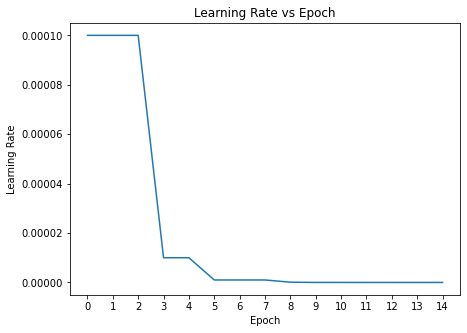

In [18]:
plot_learning_rate(history_dict)

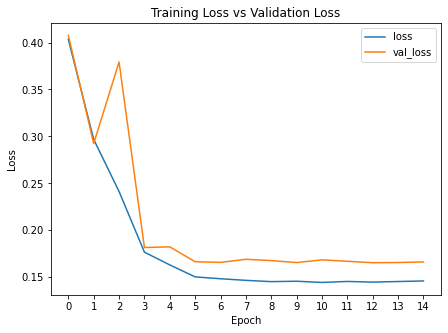

In [19]:
plot_metric(history_dict, 'loss')

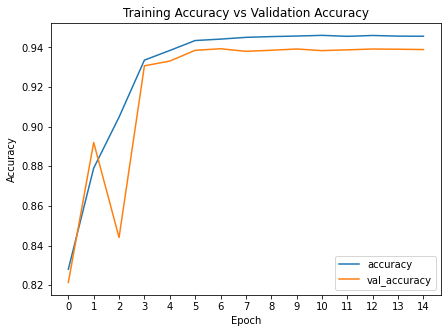

In [20]:
plot_metric(history_dict, 'accuracy')

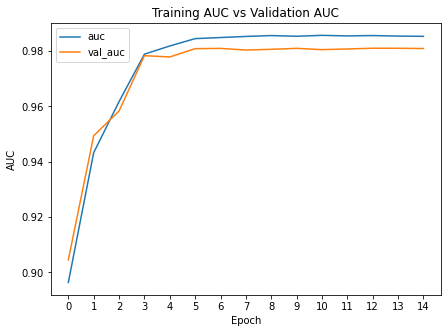

In [21]:
plot_metric(history_dict, 'auc')

---

## Calculate Performance on Test Set

In [22]:
test_metrics = model.evaluate(test_ds, verbose=1)
test_metrics = map_to_metrics(model.metrics_names, test_metrics)

  1/516 [..............................] - ETA: 42s - loss: 0.3035 - accuracy: 0.9062 - auc: 0.9608

 11/516 [..............................] - ETA: 2s - loss: 0.1946 - accuracy: 0.9318 - auc: 0.9747 

 21/516 [>.............................] - ETA: 2s - loss: 0.1739 - accuracy: 0.9345 - auc: 0.9777

 31/516 [>.............................] - ETA: 2s - loss: 0.1803 - accuracy: 0.9325 - auc: 0.9776

 41/516 [=>............................] - ETA: 2s - loss: 0.1719 - accuracy: 0.9375 - auc: 0.9790

 51/516 [=>............................] - ETA: 2s - loss: 0.1726 - accuracy: 0.9344 - auc: 0.9798

 61/516 [==>...........................] - ETA: 2s - loss: 0.1736 - accuracy: 0.9355 - auc: 0.9799

 71/516 [===>..........................] - ETA: 2s - loss: 0.1775 - accuracy: 0.9335 - auc: 0.9793

 81/516 [===>..........................] - ETA: 2s - loss: 0.1795 - accuracy: 0.9317 - auc: 0.9789

 91/516 [====>.........................] - ETA: 2s - loss: 0.1752 - accuracy: 0.9320 - auc: 0.9801

101/516 [====>.........................] - ETA: 2s - loss: 0.1743 - accuracy: 0.9335 - auc: 0.9800

111/516 [=====>........................] - ETA: 2s - loss: 0.1694 - accuracy: 0.9341 - auc: 0.9811

121/516 [======>.......................] - ETA: 2s - loss: 0.1656 - accuracy: 0.9347 - auc: 0.9819

131/516 [======>.......................] - ETA: 2s - loss: 0.1658 - accuracy: 0.9344 - auc: 0.9818

141/516 [=======>......................] - ETA: 2s - loss: 0.1619 - accuracy: 0.9355 - auc: 0.9826

151/516 [=======>......................] - ETA: 1s - loss: 0.1649 - accuracy: 0.9358 - auc: 0.9819

161/516 [========>.....................] - ETA: 1s - loss: 0.1675 - accuracy: 0.9352 - auc: 0.9815

171/516 [========>.....................] - ETA: 1s - loss: 0.1689 - accuracy: 0.9344 - auc: 0.9813

181/516 [=========>....................] - ETA: 1s - loss: 0.1700 - accuracy: 0.9337 - auc: 0.9811

191/516 [==========>...................] - ETA: 1s - loss: 0.1666 - accuracy: 0.9350 - auc: 0.9817

201/516 [==========>...................] - ETA: 1s - loss: 0.1654 - accuracy: 0.9355 - auc: 0.9819

211/516 [===========>..................] - ETA: 1s - loss: 0.1658 - accuracy: 0.9356 - auc: 0.9815

221/516 [===========>..................] - ETA: 1s - loss: 0.1669 - accuracy: 0.9359 - auc: 0.9810

231/516 [============>.................] - ETA: 1s - loss: 0.1682 - accuracy: 0.9356 - auc: 0.9808

241/516 [=============>................] - ETA: 1s - loss: 0.1692 - accuracy: 0.9361 - auc: 0.9804

251/516 [=============>................] - ETA: 1s - loss: 0.1704 - accuracy: 0.9355 - auc: 0.9801

261/516 [==============>...............] - ETA: 1s - loss: 0.1715 - accuracy: 0.9356 - auc: 0.9799

271/516 [==============>...............] - ETA: 1s - loss: 0.1718 - accuracy: 0.9357 - auc: 0.9798

281/516 [===============>..............] - ETA: 1s - loss: 0.1717 - accuracy: 0.9358 - auc: 0.9799

291/516 [===============>..............] - ETA: 1s - loss: 0.1734 - accuracy: 0.9356 - auc: 0.9795

301/516 [================>.............] - ETA: 1s - loss: 0.1712 - accuracy: 0.9363 - auc: 0.9799

311/516 [=================>............] - ETA: 1s - loss: 0.1730 - accuracy: 0.9357 - auc: 0.9796

321/516 [=================>............] - ETA: 1s - loss: 0.1725 - accuracy: 0.9357 - auc: 0.9797

331/516 [==================>...........] - ETA: 1s - loss: 0.1732 - accuracy: 0.9350 - auc: 0.9797

341/516 [==================>...........] - ETA: 0s - loss: 0.1732 - accuracy: 0.9349 - auc: 0.9797

351/516 [===================>..........] - ETA: 0s - loss: 0.1729 - accuracy: 0.9353 - auc: 0.9797

361/516 [===================>..........] - ETA: 0s - loss: 0.1722 - accuracy: 0.9358 - auc: 0.9798

371/516 [====================>.........] - ETA: 0s - loss: 0.1711 - accuracy: 0.9361 - auc: 0.9800

381/516 [=====================>........] - ETA: 0s - loss: 0.1705 - accuracy: 0.9363 - auc: 0.9801

391/516 [=====================>........] - ETA: 0s - loss: 0.1693 - accuracy: 0.9369 - auc: 0.9804

401/516 [======================>.......] - ETA: 0s - loss: 0.1692 - accuracy: 0.9368 - auc: 0.9804

411/516 [======================>.......] - ETA: 0s - loss: 0.1692 - accuracy: 0.9371 - auc: 0.9802

421/516 [=======================>......] - ETA: 0s - loss: 0.1704 - accuracy: 0.9366 - auc: 0.9800

431/516 [========================>.....] - ETA: 0s - loss: 0.1714 - accuracy: 0.9363 - auc: 0.9797

441/516 [========================>.....] - ETA: 0s - loss: 0.1716 - accuracy: 0.9361 - auc: 0.9797

451/516 [=========================>....] - ETA: 0s - loss: 0.1714 - accuracy: 0.9360 - auc: 0.9797

461/516 [=========================>....] - ETA: 0s - loss: 0.1705 - accuracy: 0.9365 - auc: 0.9799

471/516 [==========================>...] - ETA: 0s - loss: 0.1707 - accuracy: 0.9362 - auc: 0.9799

481/516 [==========================>...] - ETA: 0s - loss: 0.1705 - accuracy: 0.9365 - auc: 0.9800

491/516 [===========================>..] - ETA: 0s - loss: 0.1706 - accuracy: 0.9362 - auc: 0.9800

501/516 [============================>.] - ETA: 0s - loss: 0.1701 - accuracy: 0.9363 - auc: 0.9802

511/516 [============================>.] - ETA: 0s - loss: 0.1699 - accuracy: 0.9361 - auc: 0.9802

516/516 [==============================] - ETA: 0s - loss: 0.1701 - accuracy: 0.9359 - auc: 0.9802

516/516 [==============================] - 3s 5ms/step - loss: 0.1701 - accuracy: 0.9359 - auc: 0.9802


In [23]:
# Save test metrics
json.dump(test_metrics, open(f"{model_output_dir}/{MODEL_NAME}/test_metrics.json", 'w'))

---